In [46]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from segmenter import *
from IPython.core.debugger import set_trace
torch.cuda.is_available(), torch.backends.cudnn.enabled

(True, True)

# Data Paths and Loading

Unlike the classification notebooks we do not rely on CSV files to obtain the training and testing datasets. Instead, we load input images (x / data images) and ground truth label mask images (y) from the dataset directory.


The first step is to get the paths of the input images and the label mask images.
Two datasets are used for training the ISIC 2017 training and validation sets, and the Dermofit dataset. 
For testing, the ISIC 2017 testset is used. Each of these datasets are stored within different directories in PATH.

In [47]:
# You will have to change this. I've copied skin_cancer to the cyphy folder of HPC. 
# It's in /work/cyhpy/SeanMcMahon/datasets/skin_cancer
# Can mount /work/cyhpy/ on your local machine for access.
PATH = Path('/home/sean/hpc-home/skin_cancer') 
# make sure everthing is there
%ls PATH

AK/      ALLIEC/  ALLSK/    iec.zip*         models/   sk.zip*
ak.zip*  ALLMEL/  ALLVASC/  lesionlist.txt*  PYO/      tmp/
ALLBCC/  ALLML/   bcc.zip*  mel.zip*         pyo.zip*  train.csv*
ALLDF/   ALLSCC/  df.zip*   ml.zip*          scc.zip*  vasc.zip*


In [48]:
xtrn_i = PATH / 'ISIC/ISIC-2017_Training_Data'
ytrn_i = PATH / 'ISIC/ISIC-2017_Training_Part1_GroundTruth'

xtrn_d = PATH / 'dermofit/'

xval_path = PATH / 'ISIC/ISIC-2017_Validation_Data'
yval_path = PATH / 'ISIC/ISIC-2017_Validation_Part1_GroundTruth'

# xtrn_path.exists(), ytrn_path.exists(), xval_path.exists(), ytrn_path.exists()

In [49]:
def get_all_files(p, fl, ext):
    ims = []
    for root, dirs, files in os.walk(p):
        for fn in files:
            if fn.endswith(ext) and fl in fn:
                # The right filetype and the image we want!
                ims.append(os.path.join(root, fn))
    if len(ims) == 0:
        print('No images found')
    return ims

d_files = get_all_files(xtrn_d, '', '.png')
len(d_files), all([os.path.isfile(x) for x in d_files])

(2600, True)

In [50]:
xd = np.array(sorted([x for x in d_files if not 'mask' in x]))
yd = np.array(sorted([x for x in d_files if 'mask' in x]))
len(xd), len(yd), any(xd == yd)

(1300, 1300, False)

In [51]:
j='.jpg'
p='.png'

trn_x = np.append(g_fns(xtrn_i, j), xd)
val_x = g_fns(xval_path, j)

trn_y = np.append(g_fns(ytrn_i, p), yd)
val_y = g_fns(yval_path, p)
trn_x.shape, trn_y.shape, val_x.shape, val_y.shape

((3300,), (3300,), (150,), (150,))

In [52]:
xtest_i = PATH / 'ISIC' / 'ISIC-2017_Test_v2_Data'
ytest_i = PATH / 'ISIC' / 'ISIC-2017_Test_v2_Part1_GroundTruth'
test_x = g_fns(xtest_i, '.jpg')
test_y = g_fns(ytest_i, '.png')
rr = np.random.randint(0, len(test_y), size=(3))
test_x.shape, test_y.shape, test_x[rr], test_y[rr]

((600,),
 (600,),
 array([PosixPath('/home/sean/hpc-home/skin_cancer/ISIC/ISIC-2017_Test_v2_Data/ISIC_0014755.jpg'),
        PosixPath('/home/sean/hpc-home/skin_cancer/ISIC/ISIC-2017_Test_v2_Data/ISIC_0012904.jpg'),
        PosixPath('/home/sean/hpc-home/skin_cancer/ISIC/ISIC-2017_Test_v2_Data/ISIC_0015411.jpg')],
       dtype=object),
 array([PosixPath('/home/sean/hpc-home/skin_cancer/ISIC/ISIC-2017_Test_v2_Part1_GroundTruth/ISIC_0014755_segmentation.png'),
        PosixPath('/home/sean/hpc-home/skin_cancer/ISIC/ISIC-2017_Test_v2_Part1_GroundTruth/ISIC_0012904_segmentation.png'),
        PosixPath('/home/sean/hpc-home/skin_cancer/ISIC/ISIC-2017_Test_v2_Part1_GroundTruth/ISIC_0015411_segmentation.png')],
       dtype=object))

Can incrementally increase image size (sz) to get better performance, try not to exceed the sizes in the histograms below. Inflating images above their actual size introduces artifacts which may lead to overfitting, or may simple not add performance at the cost of computational time. 

Min row size 177; Min col size 169


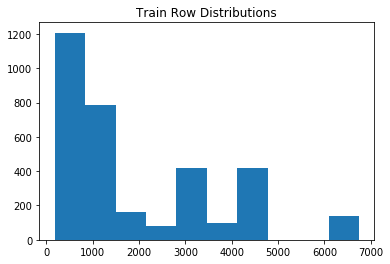

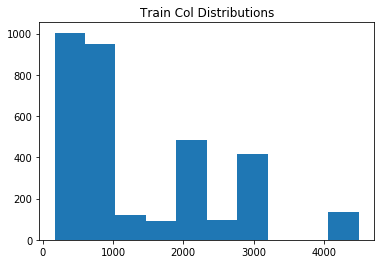

In [12]:
im_hist(trn_x, name='Train')

# Data Iterator

In [53]:
sz = 128
bs = 64
nw = 4
arch = resnet34

In [54]:
aug_tfms = [RandomRotate(4, tfm_y=TfmType.CLASS),
            RandomDihedral(tfm_y=TfmType.CLASS),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.CLASS)]

In [55]:
tfms = tfms_from_model(arch, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH, test=(test_x, test_y))
mdata = ImageData(PATH, datasets, bs, num_workers=nw, classes=None)
denorm = mdata.trn_ds.denorm

In [38]:
denorm

<bound method FilesDataset.denorm of <segmenter.MatchedFilesDataset object at 0x7f48e6fb1390>>

In [40]:
mdata.trn_ds.fnames[386]

PosixPath('/home/sean/hpc-home/skin_cancer/ISIC/ISIC-2017_Training_Data/ISIC_0000481.jpg')

In [17]:
x,y = next(iter(mdata.trn_dl))
x = denorm(x)
x.shape,y.shape, np.unique(y)

((64, 128, 128, 3), torch.Size([64, 128, 128]), array([0., 1.], dtype=float32))

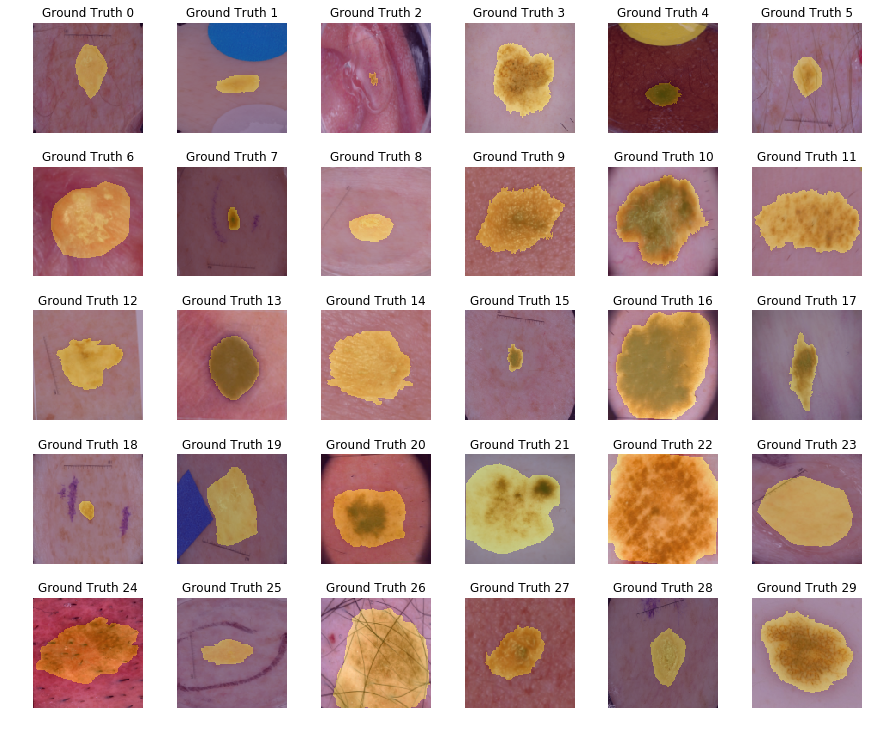

In [12]:
plot_data(x, y)

In [ ]:
tx,ty = next(iter(mdata.test_dl))
tx_d = denorm(tx)

In [21]:
tx.shape,ty.shape, np.unique(ty)

(torch.Size([64, 3, 128, 128]),
 torch.Size([64, 128, 128]),
 array([0., 1.], dtype=float32))

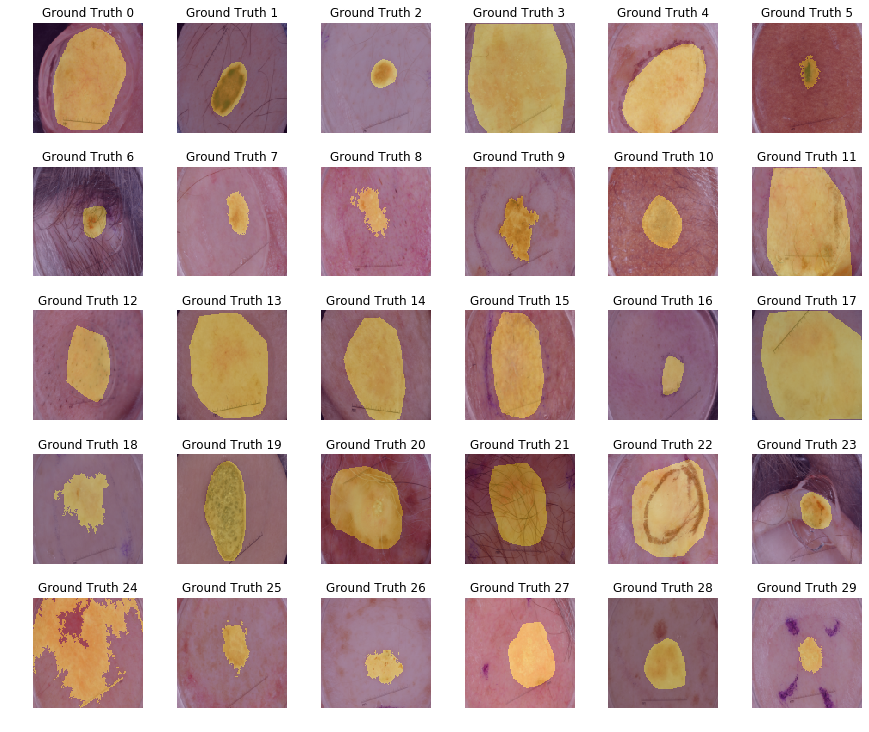

In [23]:
plot_data(tx_d, ty)

# Setup Network

Place/cut resnet into groups for unet to connect to.

In [56]:
cut, lr_cut = model_meta[arch]

In [57]:
# core CNN
m_base = get_base(arch, cut)
unet = to_gpu(Unet34(m_base))
models = UnetModel(unet, lr_cut)

In [58]:
# Setup for training
learn = ConvLearner(mdata, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [14]:
learn.get_model_path('128unet_dermofit_isic17_1')

'/home/sean/hpc-home/skin_cancer/models/128unet_dermofit_isic17_1.h5'

In [59]:
learn.load('128unet_dermofit_isic17_1')

In [37]:
# run if you want some idea on model construction
learn.summary(), [o.features.size() for o in unet.sfs]

(OrderedDict([('Conv2d-1',
               OrderedDict([('input_shape', [-1, 3, 128, 128]),
                            ('output_shape', [-1, 64, 64, 64]),
                            ('trainable', False),
                            ('nb_params', 9408)])),
              ('BatchNorm2d-2',
               OrderedDict([('input_shape', [-1, 64, 64, 64]),
                            ('output_shape', [-1, 64, 64, 64]),
                            ('trainable', False),
                            ('nb_params', 128)])),
              ('ReLU-3',
               OrderedDict([('input_shape', [-1, 64, 64, 64]),
                            ('output_shape', [-1, 64, 64, 64]),
                            ('nb_params', 0)])),
              ('MaxPool2d-4',
               OrderedDict([('input_shape', [-1, 64, 64, 64]),
                            ('output_shape', [-1, 64, 32, 32]),
                            ('nb_params', 0)])),
              ('Conv2d-5',
               OrderedDict([('input_shape', [-1, 

# Train Network

In [14]:
def plot_training():
    plot_loss(learn.sched.losses, learn.sched.val_losses,
              list(zip(*learn.sched.rec_metrics))[0], learn.sched.epoch, learn.sched.epochs)

This is where the magic happens

In [20]:
learn.freeze_to(1) # freeze all but the last 'group' of the model

 86%|████████▌ | 89/104 [04:20<00:43,  2.93s/it, loss=0.965]

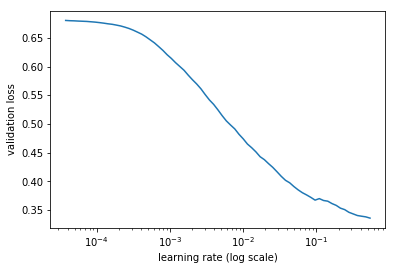

In [40]:
learn.lr_find()
learn.sched.plot()

In [14]:
# initial hyperparams (not set by me)
lr = 1e-2
# wd=1e-7
wd=None
lrs = np.array([lr/100, lr/10, lr])

In [42]:
learn.fit(lr,1,wds=wd, cycle_len=8,use_clr=(5,8))

epoch      trn_loss   val_loss   <lambda>   dice             
    0      0.169814   0.191401   0.936003   0.783404  
    1      0.137451   0.163758   0.937106   0.790712         
    2      0.130666   0.146088   0.938465   0.812291         
    3      0.120266   0.131456   0.947791   0.83053         
    4      0.114412   0.142229   0.93682    0.80488          
    5      0.115654   0.134541   0.945242   0.827918         
    6      0.111061   0.130075   0.942402   0.82452          
    7      0.11123    0.124807   0.953564   0.856173         


[array([0.12481]), 0.9535644563039144, 0.8561726046061265]

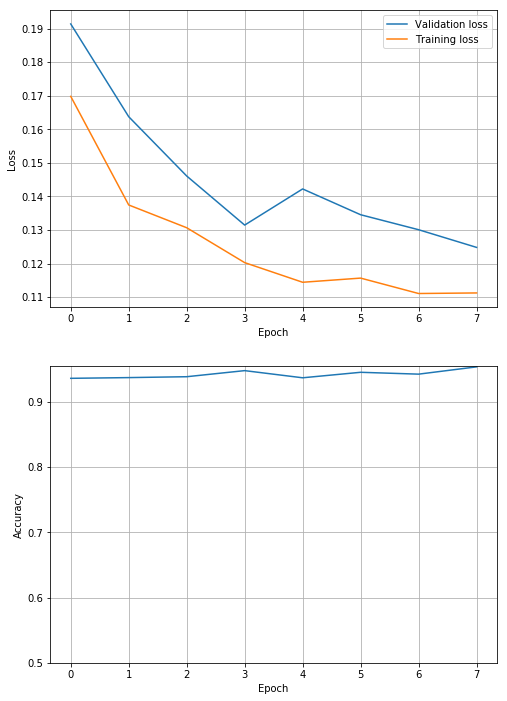

In [43]:
plot_training()

In [44]:
learn.save('128unet_dermofit_isic17_1')

In [15]:
learn.load('128unet_dermofit_isic17_1')

Visualise performance thus far...

In [39]:
x,y = next(iter(mdata.val_dl))
py = to_np(learn.model(V(x)))
x_den = denorm(x)

In [43]:
x_den.shape, x.shape

((64, 128, 128, 3), torch.Size([64, 3, 128, 128]))

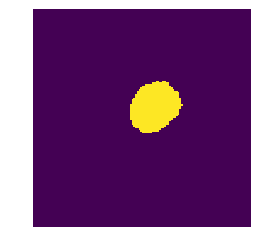

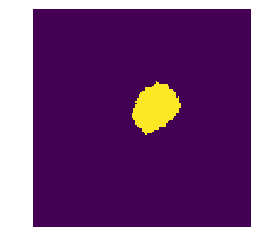

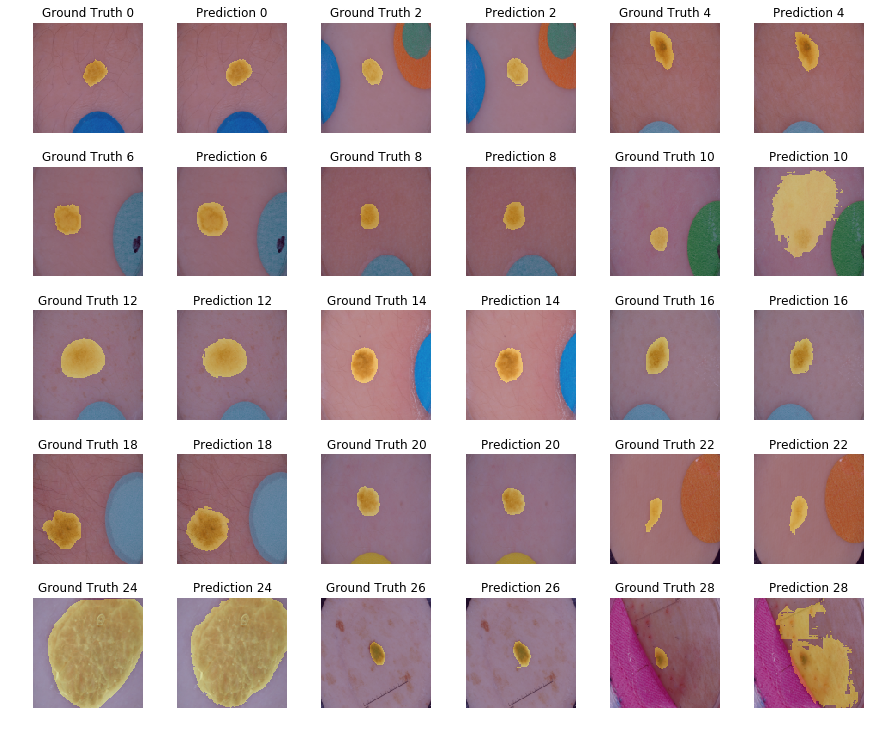

In [18]:
show_img(py[0]>0); show_img(y[0]);
plot_preds(x_den, y, py)

In [25]:
x_den.shape

(64, 128, 128, 3)

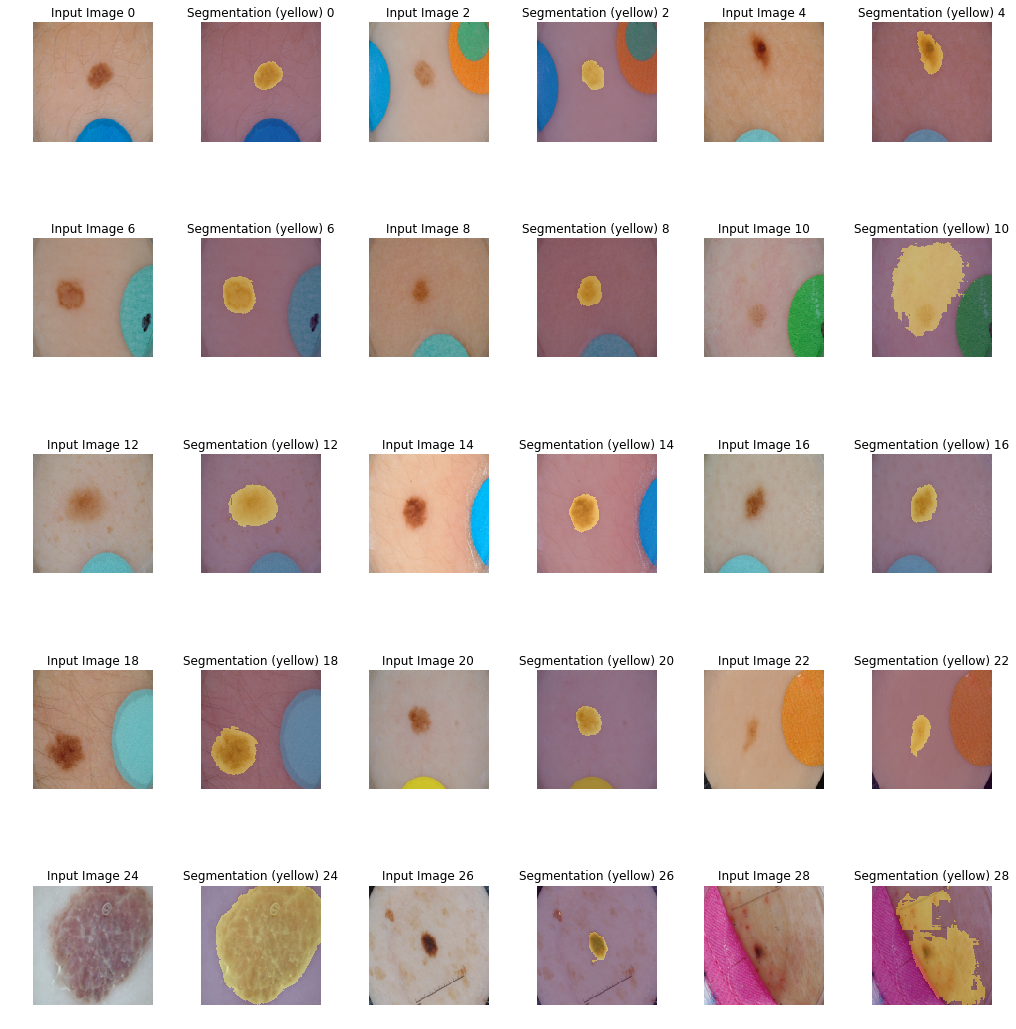

In [26]:
# from segmenter import *
plot_img_n_preds(x_den, py > 0, splots=(5,6), fsize=(14,15))

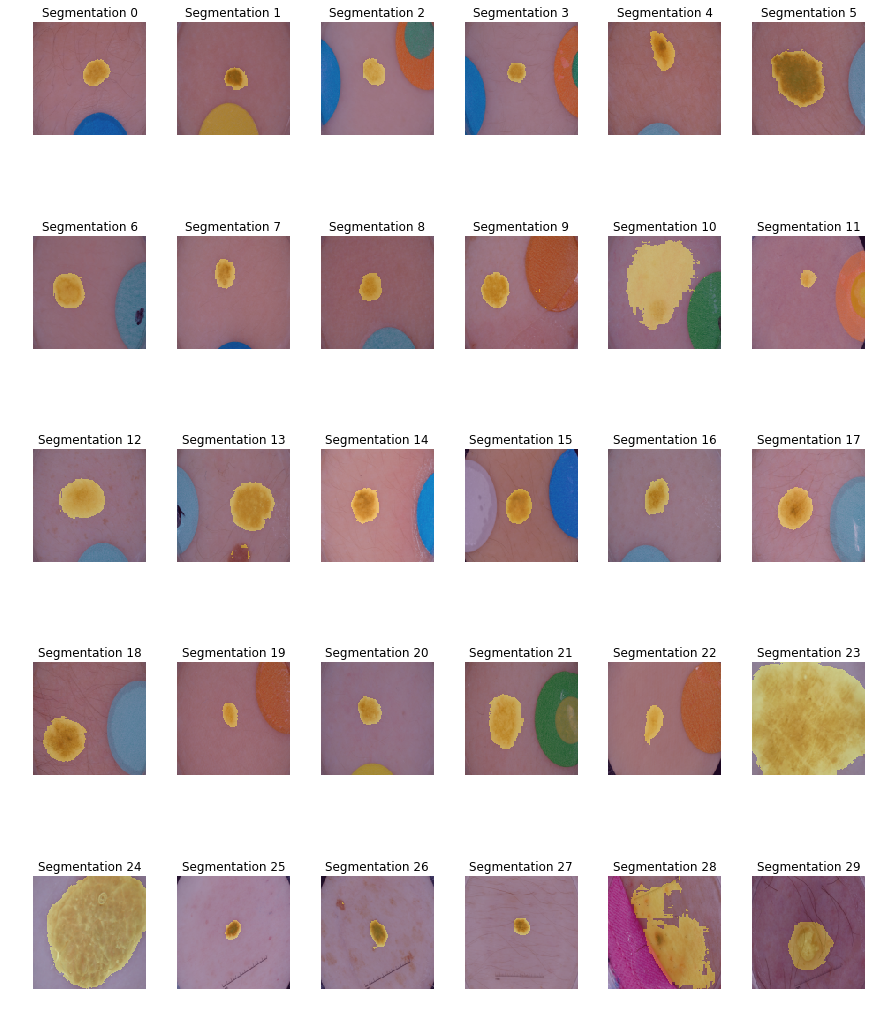

In [27]:
# from segmenter import *
plot_data(x_den, py > 0, title='Segmentation', splots=(5,6), fsize=(12,15))
# py.shape, (py[1] > 0).shape, y[1].shape, type(py), type(y), np.unique(to_np(y))

Try some testing!

In [25]:
def test_seg_net(learner, is_test=False, thres=0, pr=False):
    # Too slow, loop over the testset twice, once for logits and again for data. 
    logits = learner.predict(is_test=is_test)
    dl = learner.data.test_dl if is_test else learn.data.val_dl
    xs, ys = [], []
    for xx, yy in iter(dl):
        xs.append(to_np(xx))
        ys.append(to_np(yy))
    xs = np.concatenate(xs)
    ys = np.concatenate(ys)
    
    acc = accuracy_multi_np(logits, ys, thres)
    d = dice_n(logits-thres, ys)
    data = {'logits': logits, 'inputs': xs, 'labels': ys}
    pstr = 'Accuracy = {:0.2f};  Dice = {:0.2f}  @ thres {}'.format(float(acc), float(d), thres)
    if pr: print(pstr)
    return acc, d, data

# x,y = next(iter(mdata.val_dl))
# py = to_np(learn.model(V(x)))
# x_den = denorm(x)
def preds_with_input(m,dl):
    m.eval()
    if hasattr(m, 'reset'): m.reset()
    res = []
    for *x,y in iter(dl): res.append([get_prediction(to_np(m(*VV(x)))),to_np(y), to_np(x)])
    return zip(*res)

def pred_with_inp(m,dl):
    # same as fastai's "predict_with_targs_" but return x instead of y
    m.eval()
    if hasattr(m, 'reset'): m.reset()
    res = []
    for *x,y in iter(dl): res.append([get_prediction(to_np(m(*VV(x)))),to_np(*x)])
    return zip(*res)

def deploy_net(learner, xfiles, batch_sz=1):
    '''
    Runs the trained model on a series of images, within filename xfiles. 
    Not really intended for use with single images, but should still work that way.
    '''
    if not all([os.path.isfile(x) for x in xfiles]):
        raise FileNotFoundError('Invalid files in xfiles')
        
    test_lbls = np.zeros((len(xfiles),1)) # no labels
    _, tfms = tfms_from_model(arch, sz, crop_type=CropType.NO, tfm_y=TfmType.NO)
    normaliser = tfms.norm
    tfms.denorm
    ds = FilesArrayDataset(xfiles, test_lbls, tfms, PATH)
    nw = num_cpus()//2 if batch_sz > 2 else 0
    dl = DataLoader(ds, shuffle=False, num_workers=nw, batch_size=batch_sz)
    net = learner.model.eval()
    pred, x = pred_with_inp(net, dl)
    return np.concatenate(pred), np.concatenate(x)
    
def run_model(m, x_fn):
    im = open_image(x_fn) if isinstance(x_fn, str) else x_fn
    m.eval()
    if hasattr(m, 'reset'): m.reset()
    p = get_prediction(to_np(m(*VV(im))))
    return p, im
        
    

dps, dxs = deploy_net(learn, trn_x, batch_sz=16)


In [19]:
batch_sz = 1
test_lbls = np.zeros((len(trn_x),1)) # no labels
_, detfms = tfms_from_model(arch, sz, crop_type=CropType.NO, tfm_y=TfmType.NO)
normaliser = detfms.norm
tfms.denorm
ds = FilesArrayDataset(trn_x, test_lbls, detfms, PATH)
nw = num_cpus()//2 if batch_sz > 2 else 0
dl = DataLoader(ds, shuffle=False, num_workers=nw, batch_size=batch_sz)
normaliser

In [56]:
cacc, vdice, vdata = test_seg_net(learn)

In [20]:
tacc, tdice, tdata = test_seg_net(learn, is_test=True)

In [21]:
tacc, tdice

(0.9338878377278645, 0.8491735292650125)

In [16]:
sm = nn.Sigmoid()
sfm = nn.Softmax2d()
learn.data.test_dl
learn.data.test_ds

In [17]:
# Accuracy should be 0.9535
# Dice should be 0.8561
vlogits = learn.predict()
vlogits.shape, vlogits.min(), vlogits.max()

((150, 128, 128), -28.725754, 13.122096)

In [18]:
vprobs = to_np(sm(VV(vlogits)))
vprobs.shape, vprobs.min(), vprobs.max()

((150, 128, 128), 3.3462905e-13, 0.999998)

In [19]:
vys = [to_np(yy) for xx,yy in iter(learn.data.val_dl)]
vys = np.concatenate(vys)
vys.shape

(150, 128, 128)

In [51]:
def get_perf(preds, target, thres=0.5):
    acc = accuracy_multi_np(preds, target, thres)
#     d = dice(VV(preds), VV(target)).data.cpu().numpy()
    d = dice_n(preds-thres, target)
    print('acc: {:0.5f}. dice: {:0.4f}'.format(acc,d))
get_perf(vlogits, vys, thres=0.0)
get_perf(vprobs, vys)

acc: 0.95489. dice: 0.8654
acc: 0.95489. dice: 0.8654


In [32]:
vys.shape, vlogits.shape, np.shape(vys + vlogits), np.shape(vys * vlogits)

((150, 128, 128), (150, 128, 128), (150, 128, 128), (150, 128, 128))

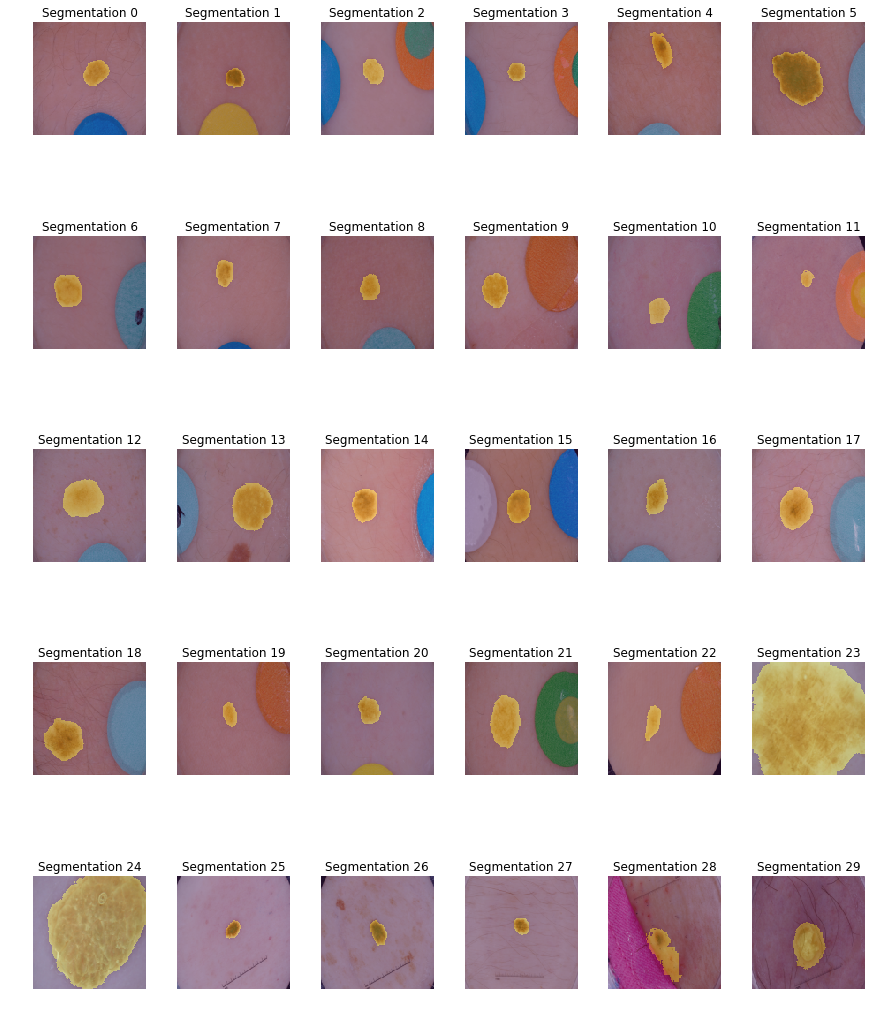

In [23]:
plot_data(x_den, vprobs > 0.5, title='Segmentation', splots=(5,6), fsize=(12,15))

In [24]:
t_logs, ty = learn.TTA(is_test=True, n_aug=1)

In [25]:
t_logs.shape, ty.shape, np.unique(ty)

((2, 600, 128, 128), (600, 128, 128), array([0., 1.], dtype=float32))

In [26]:
probs = np.exp(t_logs)
preds = probs.mean(axis=0)
probs.shape, preds.shape, type(preds), type(ty)

((2, 600, 128, 128), (600, 128, 128), numpy.ndarray, numpy.ndarray)

In [27]:
probs.min(), probs.max()

(1.0234935e-08, 4502081.0)

In [ ]:
plot_data(x, y)

In [ ]:
res = dice(preds, ty)

### Additional Training

Do some more training. Optional, but likely to improve performance.

In [2]:
learn.unfreeze()
# learn.bn_freeze(True) # freeze bn params, good for similar datasets

In [48]:
# This will train for about 20 epochs
learn.fit(lrs/4, 1, wds=wd, cycle_len=20,use_clr=(20,10))

epoch      trn_loss   val_loss   <lambda>   dice           
    0      0.102194   0.131098   0.949019   0.852854  
    1      0.100851   0.1236     0.950884   0.8554         
    2      0.100864   0.128443   0.949528   0.850917       
    3      0.100255   0.130546   0.950535   0.853696        
    4      0.097356   0.12042    0.951243   0.854279        
    5      0.095349   0.124365   0.950002   0.850872        
    6      0.094621   0.123716   0.95252    0.857746        
    7      0.092922   0.129096   0.951747   0.85558         
    8      0.091401   0.126853   0.952931   0.859103        
    9      0.09139    0.122194   0.953121   0.860338        
    10     0.089801   0.126644   0.95274    0.856965        
    11     0.090009   0.12891    0.95356    0.859773        
    12     0.088619   0.133197   0.951064   0.853467        
    13     0.089031   0.128308   0.953192   0.858923        
    14     0.088947   0.132773   0.952738   0.858416        
    15     0.08766    0.133144   

[array([0.13094]), 0.9532584595680237, 0.8586853134673078]

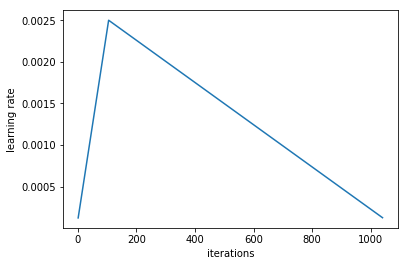

In [49]:
# Run if you want to see the learning rate schedule (run after a .fit call)
learn.sched.plot_lr()

Repeat, let's look at the losses and then visualise some results

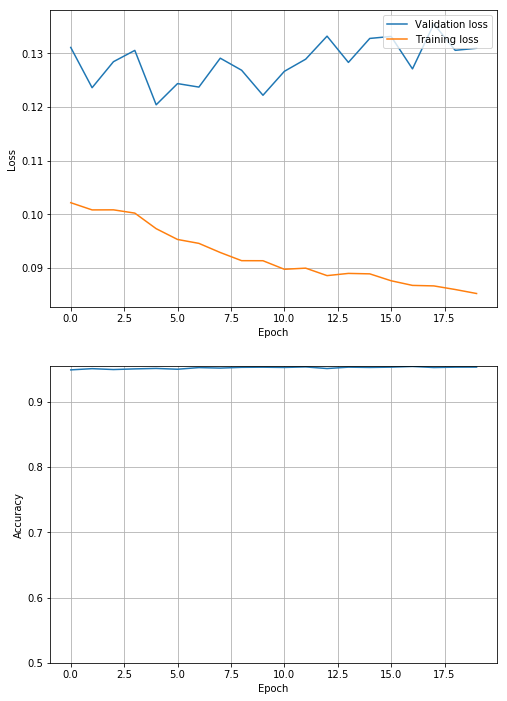

In [50]:
plot_training()

In [51]:
learn.save('128unet_dermofit_isic17_2')

In [ ]:
learn.load('128unet_dermofit_isic17_2')

In [ ]:
x,y = next(iter(mdata.val_dl))
py = to_np(learn.model(V(x)))
x_den = denorm(x)

show_img(py[0]>0); show_img(y[0]);
plot_preds(x_den, y, py)

## Increase Image Size!

In [52]:
sz = 256
bs = 32
nw = 4
arch = resnet34
wd=1e-7
unet.close()
print('lr: {},  wd {}'.format(lr, wd))

lr: 0.01,  wd 1e-07


In [53]:
tfms = tfms_from_model(arch, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
mdata = ImageData(PATH, datasets, bs, num_workers=nw, classes=None)
denorm = mdata.trn_ds.denorm
# Load Model
m_base = get_base(arch, cut)
unet = to_gpu(Unet34(m_base))
models = UnetModel(unet, lr_cut)
# Get the learner intitalised dawg
learn = ConvLearner(mdata, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [54]:
learn.freeze_to(1)

In [55]:
learn.load('128unet_dermofit_isic17_2')

In [56]:
learn.fit(lr,1,wds=wd, cycle_len=5,use_clr=(5,5))

epoch      trn_loss   val_loss   <lambda>   dice             
    0      0.129984   0.180774   0.935527   0.786172  
    1      0.12122    0.146558   0.942796   0.81403          
    2      0.111571   0.134921   0.942545   0.819168         
    3      0.109232   0.126453   0.950514   0.842537         
    4      0.099005   0.12849    0.948471   0.830701          



[array([0.12849]), 0.9484706592559814, 0.8307014933679523]

In [57]:
learn.save('256unet_dermofit_isic17_1')

In [59]:
learn.unfreeze()
learn.bn_freeze(True)

In [ ]:
learn.load('256unet_dermofit_isic17_1')

In [60]:
learn.fit(lrs/4,1,wds=wd, cycle_len=8,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice              
    0      0.092361   0.140165   0.946102   0.834944  
    1      0.093708   0.170406   0.943132   0.821118          
    2      0.098429   0.134042   0.950261   0.840614          
    3      0.095209   0.15546    0.947889   0.835364          
    4      0.088169   0.149904   0.95062    0.844479          
    5      0.08857    0.162951   0.948272   0.831744          
    6      0.085681   0.144272   0.951895   0.846641          
    7      0.085069   0.148868   0.950692   0.841825          



[array([0.14887]), 0.9506922435760498, 0.8418245722808619]

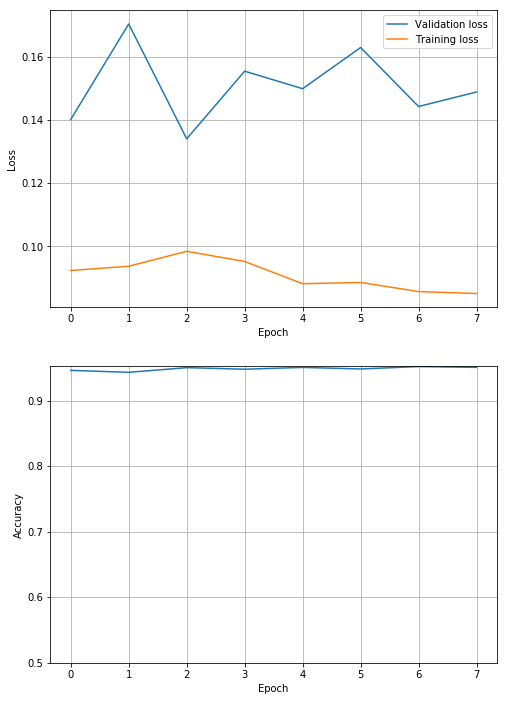

In [63]:
plot_training()

In [61]:
learn.save('256unet_dermofit_isic17_2')

In [ ]:
learn.load('256unet_dermofit_isic17_2')

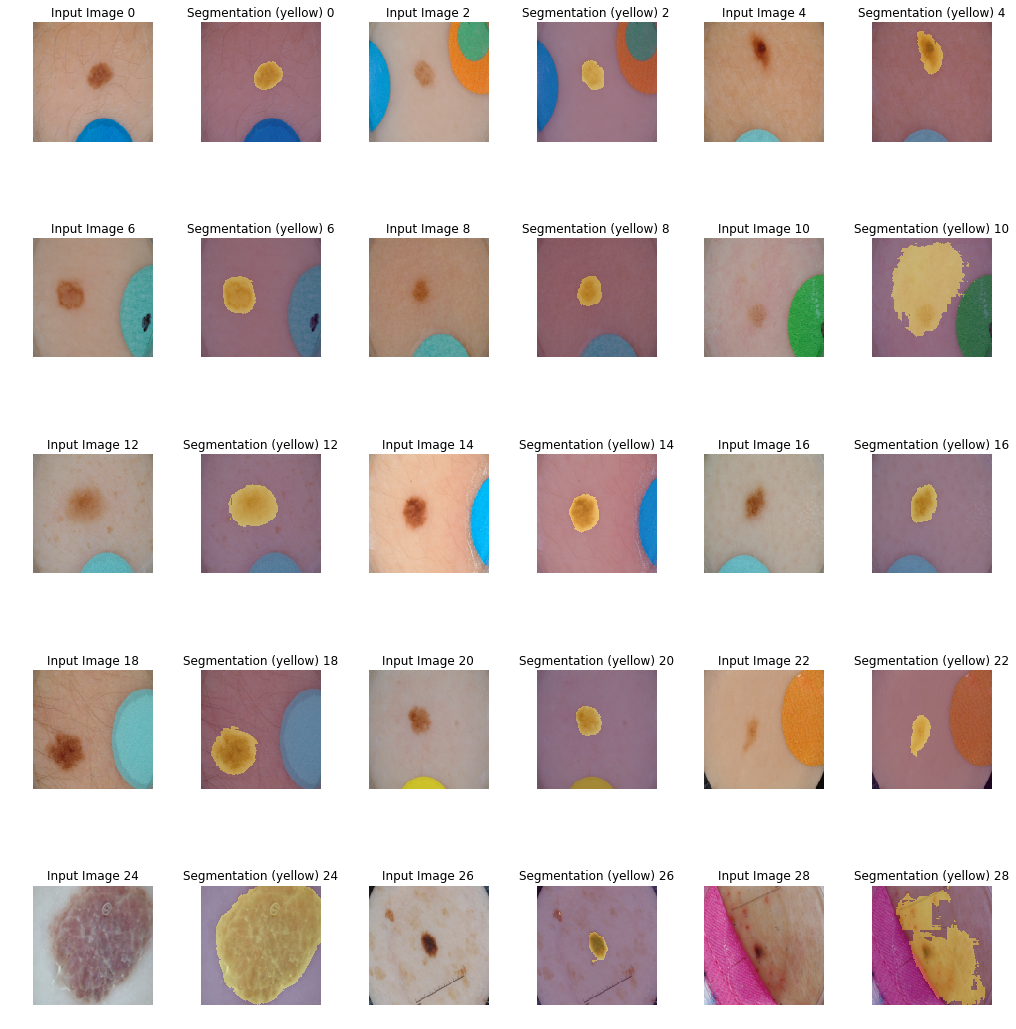

In [62]:
plot_img_n_preds(x_den, py > 0, splots=(5,6), fsize=(14,15))

# Test Cloudvis Deployment

In [81]:
def run_model(m, im, prepIm=None):
    if prepIm:
        im = np.expand_dims(prepIm(im), 0)
    m.eval()
    if hasattr(m, 'reset'):
        m.reset()
    # these are just fastai functions, makes implimenting these pytorch stuff a little more stable
    p = to_np(m(VV(im))).squeeze()
    return p, im

In [82]:
base_arch = resnet34
sz = 128
_, vtfm = tfms_from_model(base_arch, sz, crop_type=CropType.NO, tfm_y=TfmType.NO)
# normaliser = tfms.norm
denorm = vtfm.denorm
d_net = build_unet(base_arch)
weights = '/home/sean/hpc-home/skin_cancer/models/128unet_dermofit_isic17_1.h5'
if not os.path.isfile(weights): raise FileNotFoundError(f'Invalid: {weights}')
load_model(d_net, weights) # loads weights to "net" - fastai function

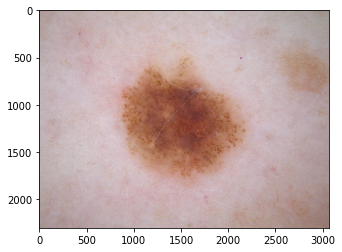

In [85]:
# x385 = mdata.trn_ds[323]
# list(mdata.trn_ds.fnames).index(Path('/home/sean/hpc-home/skin_cancer/ISIC/ISIC-2017_Training_Data/ISIC_0000385.jpg'))
# im = denorm(x385[0]).squeeze()
loaded_im = open_image('/home/sean/hpc-home/skin_cancer/ISIC/ISIC-2017_Training_Data/ISIC_0000385.jpg')
plt.imshow(loaded_im)

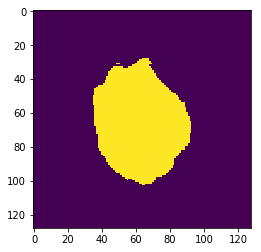

In [93]:
pred, im_n = run_model(d_net, loaded_im, prepIm=vtfm)
imd = denorm(np.rollaxis(im_n, 1, 4)).squeeze()
pred_thr = (pred > 0).astype(np.uint8) * 255
plt.imshow(thres_p)
# plt.imshow(imd)
# plt.imshow(denorm(np.rollaxis(im, 1, 4)).squeeze())

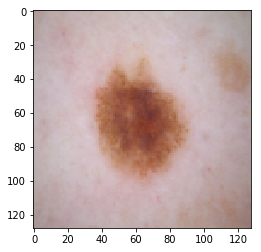

In [96]:
plt.imshow(imd)


In [98]:
from cloudvis import CloudVis, Request, Response

In [100]:
dire = ''
request = Request('{"render": "False", "input_image":  "/9j/2wBDAAUDBAQEAwUEBAQFBQUGBwwIBwcHBw8LCwkMEQ8SEhEPERETFhwXExQaFRERGCEYGh0dHx8fExciJCIeJBweHx7/2wBDAQUFBQcGBw4ICA4eFBEUHh4eHh4eHh4eHh4eHh4eHh4eHh4eHh4eHh4eHh4eHh4eHh4eHh4eHh4eHh4eHh4eHh7/wAARCAkADAADASEAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDsfr/OkPSuTZnetgHPNKQOaaWoJCEelNK5I5NUkkh3dxSoH070A88VPNoUOAB9Kay7cmld3AZt5pdq59au4+hIo561Imc9ePSgzb1JRnFKBnnJzQhdBDtyaQcVCepVtCRMN0604itLkAG5x/WkbHanqTG40cf/AKqceRweaNUy7j4/9o1OP50EsUA+tPaquMZ3oJ9apoV7C85o5IqUMcox3zSnOMUdQSEHy57+goP3j60bBYa67ht7U1wTSbAQL9cUcU2F2OHNO/76osUhB82O1BX3qXKxPUbg+tBGeM0JlCqR0zQFA+7RcbQuD7YoPtTQkwyDT/l2YHX1qg3I3xgHIx6U3nBrOxpEjfcR/wDXoTOc/pRewNNsmXpxijAb1GKdiOo1k4PeotmH3cipVwbLUXT1qwh4yT+VWSwb603tyTn1pAhmP4dxHPNKF560WFZkiA+vanY57VW4mLtx1NIy59qaHqJsIHeg/wCeaCr2GbTk0bfr9KTQbiYwDzTX5PSkykiKQccEA0gy3XtU2NFsJjn65qTGQOtESJbksefc+1SbjtqpIV9RUYMMDtT9vp1oSsiWNOAOTQCG6Goi2wasNIycGmMu4kHP1zVpi6AFwNtJyDwKzcbstPQXnpyeOPrSSR8YI61XKgi9SLZyGyR2IqZFbFOL0EyTbkc5NOXgcDFVdEsfjjPAFRyKM8E0wVxOh/rTH59axlqax3I3HfJpgJrCV0y0SREN3xU3bjrWibsRKNmDLkcHmo4/vVWlxa8pYRcADPNSdB2q3sZakbjv6UHkVMVoXsMJ2nFTocjrVJcqFIeMZHJ96cTnv06UORKVxrH6/nTdw9ah1NbFJWHdsij8s96qLTE0Ix4pp643H1o6lN2F3e/60mMk1RDYoX3pzqcjDZANVcW5G4+tRjPPNHQqL0FA708daiUrFXbDoKUCk5ITTExwecUyVeOefxoaUkCbQkXDVMCKmne452FZajlXBPzZq6jViY7jRkilCheamK0Kch/GQu761Io7DNaJaECHrzSdjUyYEDttf7w60/PHNYxjdm19BUY59Kfu5+lU3ZkLUemdx+binDBOWJ96tSuyOUa7cYHSq7g5PNKonYuDG4yc8ipkjPWnTjZCnK2xII6UrV3M02xF+9ipVFNLQGxB96hl980xJWG4/lQVyCCwHH60FJkJBz+lPjTjnrQU3oPxwRmkAouSgHXGaEGCecn3pJDEuPufexmo4HGMFskcGsKkfeuapXRKOo549qkx7/rW8djJ7jWBI9aFXpzg1a2Af0H+eaTvkZqNAiiOQ0imhRH1HjHTpTXYAf1qG2hDetL39aUY6jbuOXjPNO7+1XchjuoP9KRiAOTj61XQLjSSTjtQOKlDbHEcf/XqMn5vas20NJkigY5zQcCrWxLQhNKPr9amRSQ8898/SkGO9O9kTZgOTgGnhNw6VUJol3Q8pimFeuK1YkyMLhqa65GO9SVzABjHHSnBuuDQ0NaiNjnIqKTp9aTBDOVpytnvWb1ZVtCReBndxT07n9atE3GseTzikzkUmAnf0pwHPvVW0FJjWBx6UjdaTBDxjueKTIDe9FnYaQhOM00fdPJx9aGCA8Y60m41I0BHOecelNIPvVIXURvlJXqabHgHqaiaSNErkx5780Bj36UR2Ja1ELc7gaepzg85oV0waFYg/wBaVF/KtCdmDEDPpSqwNOxOthwUdc08AYp3Ieoo6HqaMgGmQI3U9/xoGM1JV7AR0pDVpibEbcB2o7UmVdCjp0pB0NDE7jG/KmHrQNDSQR1H40wNyMnms2WnqPXkd6eCfxpXG2GaYX44OapIncN1N/PrTCwnOfvHFKG/zmiyE9B3GM9TTeD6ZpXSGkKzYHamFs54rPm1GkB/Ojtx1qrsoUde9Drn0qkyGiMrxTWUkcH9KejCyF2LtFRSquPvdKNEikUZMK+D3qzBXFN2nc6Le7Yup060p+97V1Qkmjmasxsm3H3utR9arcI3Dbz1pQvXDbuevagpofx+VOxj3pXI1QP29Kj2fLzVdRNojcAHG6m9DjvSkaJpiMxpFy3T1qXETJQBnHNBHHpimnYiwAEHHYUhPJ5qmWhoPNPXI59elJbjb0EB4pGagzYoHNJTSHayEY/nSKOabWoINuAFLFvfNKPxpXJe5FJg9/0pjdqJMob8vqaU9BUX1KaHUnqarRiuNG7ORTgpIJJxT3FcYdw700ZA+tRJFLYjkY7sbT068ULEGGG6UKInIl24HTpUco7iq2QoCL8y5HrTW71Bo2kJjj0qJjh8Ag+1J6slJD0ByM5p4+U9aFGyKauO3Z96azcY6moSdxDD1NC56Zz+FUwTsgwSfamsnTn6j1oW4J6ibcHqKepX1pTQ0yXtntSlV6nirRNho6U4c8iqSIsOGAM7hn09KUg9KdhDTx1phJ3fL0pNoaGuM8Zx2NIehIpMdlYjfkcU2lYq1hDxyenvQ2M04oewxvmXrinY+UUieZielGcUm1YroKrcnJ/On7vc000QIvQ08DpRzai2F3cYpw/D8qYMXj8aP502rE2Y3r3ph6YNCYIay4HHFMK5OaHqNMjKnH9KZIPc0y46IiZWPU0KMDHJOaloQ7txSn+dTYrmAL3NIwx70r6iaGdzmmnBB4qrjS0Gn0GaSs3LUa1G459KQsc9qbSaCIqnpzTgfxqeVthLUAxJpwNWkkTeyBv1pBj1qhDTgE+lNP6UmAoHHA79aD0680bj6iD5jijaePSqZN9BenqabtGcmkkxmkT370096yOjYXPNFWrMLMVfypccZ65qidRp9B0pO/Xk1EkUmKrc0p749KashoQqM0oGM9qpsOoi5HTinrnmpWgnsPHQA5/CpAflxiqJGkUHg+lYtWZSHKw+lO4OeSeK0TZAH1pdx4GcYP50LcBwGQRShBn0P1qwHY/Knp1pEJ6iscE84p27AznmhOxYoI7UhORjmmncLDf509emafUWw7nIFO6g0wTGEdPmGfTNP7dTSbGMbP0NBHy5bP50hsbwKTGQfpUu4KzEjPJG4dOnpUv8NXcQwnHFKfTORmk0Max7cU09eKEO9kKMjuDilzzTsDbsL/KlHTFQ3ZghHIOOxoDHBzjrjr1qlqOwjc9c00jce4oBMRkbHPSkKleRnGaTSHcerfh+NPDcduTxipbsxjjt55FIUXbxiiLbJuhEypIJqdTwOmKoB+eDgnJprHmkgtYB9aXoabZPUI+vPXvzUq9asGxcnPSipvqKwjdD60AbuaFuNgRjrio2Uk7hjFUCYbaYy5Y8igu410PaoQPYg1HULj/L5yRT1GKHoVox6jk+lLzQZscoGc5qRc/hTTJGT9N3AAFNSi6Q+grg9BSqBzx1oQgbpTGUf5FS2OOoKp9cCg9cHNC1Q1oxrLUkfHbikmOSuPUHqelKOtUxJaDlYGhulMkjZSeetMPWs5LU0T0GsmRmocHNRJXZcHoRxsUdgeFzmrisDk5rNS5WOSYoOBtpoXL+1XHWRE3oTp7UuTmtWrkLcCcim5PpTtZA3dg67hTo129xjtV30DoSseTRu9hWbSYldDGPPNMOc+1JrQabJFPGM0M3ripu4sGriFufam5yc96nUod14pU75reOxCVxcdeKdninITGEmgLn60J6FWGkHJ3AD6GmZOaia0LWg5ZOcU9TmsovUbA9cdqaOmDg/wA60c9DO2o1B83p+NSDilBoUkPBwKY5+tKUtQSBVzj/ABpzLVqSYmtQjw2P8alx7VSRL3GNUZYjFZtO5pEhk3de9SJ71UdEDYE89etOBpNJgmPP9aXcSP8A69RsyrXEJO3PWmPyK0vdEbBGuTVofdIOfWqWhD1Y3BznFKy+9F9SbCAY9qdk46ZqwsBHuM07GT+FCKuBWmOo49KbC5Ey85qQdKhjuJRuzSbBB680mQDzmk5GltCO5bMZxUEa+p+tZxu5Fp2RZjGB6VKc4HvWq3MXuKKB+dVdktaAOopG4OByKewbDCMnpSHtii2gAvSkbnIqLal6WHIPfIpwXkmqSJbFReSc5pxH0poQc8+v0pGHqc09AYw/KefzoqGw1EJNRnOeM1no2VqiaN2xg4pGY5PTHaq0CzGSNwcfhmljJxycUpK6KiSl+MUjMduc8UXJSuNVueuM1YRuPWiK5QnHQlPP0phGOnNbRlcw2Q3GBjGKYenpVFReoDpTT1+vWgsRjxzUbrUPQoiwxOKevHSpbsO+hMoyBjjmnY/+tTTuzPqRsv8AOj2zRJagOQEUHrxzTCwMOqjpUaj5iOeOc090CRIOm3rmmbTk0JopOwr/AO1jimZ4981LdyVqISSw9+tLj8KUR2dhx+lNbKnvTYJkUhJP/wBemDr05qXG6LTsS8ilOV44NNISdhgJ3VNHkdaVtRuWg7qaf/DwKrYi1yN+vFPjHHPAq7ib0JcdaAMU7GTH44pGHemgEFKMgYwD/Ok0KzDijHHJoFqNPWkI5qShSeePy9KYQfWncEI4xj1PFM7UXAjYKByOe1RBhk9yKzlc1jsPXJOefepCfxpJu4NaCg8fhTcVpcm4m7g9Bg+vWmk8ewqH7o1uCnvTT14oTHysQsQvp60BxUt6lJMaXpN1RNDSHKxYU4H1qoXaJa1HrjOaU8jJNamd3cYe+KAvA4oSDQbI2Paq05JG1R15pSWpcCq681JHuX72awdK+5upW3LKSddtSqx96UFJMzmwHXPNL710p6GXMxvOcnmkBxQNNsUHPWpARjjBNCC4maH9iOlNEy3I3HPSmbe560rahFagV5pyrtPT8aTeo9UB688GkPJzVdCkkL2ppHNPRhpcbj0/nSn5RzuwfelqMQnPTpQnJoQluSnj6Uxs5poyu7iAEnHanEY6D8qZSbsNx2HFByvAwKkGMY1A+c9aVyk7oaPvVKq8+nNTswdxzA56frSN7CquT8Iw+1DMce/alewtyN8nNI3Pele7KFVRuG7mn7cVSWgPcUgEGonX/awKdriTsJtwOBSN9KyZfQikyR0FJHDn5yBn1pwWhLJdu0jnn0prdTwapjjIOePTFIV29fSpSHzC7dw6Ube9F9QauHTggU364xih7hyjG4FKuenam9hkg+6fXtSDdjnr/KiwPRDhzinDONuMHmnsZ2Y7+KjdzmhkoaT60wdTmloaSSSGlfmDZ6Hp60jNgcUbk3aI+Tnp+FAFJjbbQrjjP51G/wBOaa2GhqrzluntTj1qHqhT3I8n64pVHcUWLWwvHTGadjA4607ametxOuefyoLdBTDRDgcEf1p3fOKItAxS1N3n1z9KBoVSc5PWlzzRcGlcTvSE0EsYwDc8ZphU0lK4hjKMd6a4weORVXZSsGOOe9LgdcUrj3EIpnepWgIaTjB61GzfnUSuaWaIyx+lIc8gULQlNjQGzmk5zVNuwmgH5U8Hnim9Ylqw4dc8UflSjciSQufSkzj/ABqloCtcR6bk55pis7jlHbjFOCnHtSirClqJtpR78VdyeghIzmkYc80rsadi9kZ60pwO9Z7s6dRue2ec09cEEZxRdXLHEjNAx3p3MxRs+uKay5walSdyrITbj60vGOtU9g0Fx0pD3oT5kFwFOXHfp3otoK4oOe9OZiABVWC7EDcUrNn61DjcaGs/bqadG5IyeaUCmSE7gee1NGea0toZuxKvQ1KOtUhDh0pRke9JkxBuV4pm7BOc0mrjTHAZPU/nTs/UU0h9ADe1OiPrRoJNDu3pTlYN2p3GI3Q/XqaGJ3enHajoJjTnvSZ+v4UrDFYdc03hiR0qkgQijAPTJ6mnbseuKiV2VoNZ+cmgHcKSukK2ouPSg5q1cBu0AkgnpSjHrz9KQK4dKjJ5pMtDg2eOafxjrRfQYDkUHrSuTzDhg9c4pJQOappWEm7kXQ0u6s2rs2SVh4HNPGMd6q1jFtXHEbse1BOOv4UwY9T14+n1pN2Qc8elJ6MGxQf85pW6jBqrkjhwfWnpywycD6U+gDjwDg8fWmkjBzSBCbhnpzSo4bnkc9DQht6En3lzTWHTb6+tXdEpiDg+v+NEi57YqbjRFIvODxUQU5P14FC3Kb0HkcZPBpQPrSbFdgnft6e9PXG4jmmloFxdvHHX60qnjrSED9PWm8jmlcBRTx0qkFwK5H/1qjOc4/WiSKixQPWl25z/AFo2BrUYw5xQnDc1FtR30JRzxzRjvV2J5hc5NOxxRewMQrUUmBUsExp/OmOvzBv6VnZ8xp0I5EyCeBTIyRjB61nONjRTJ1boDnmplUZrWFrGc9WOB96Un3pKQCjr/jScZ96tPUhIcRhQc5yOlC4HJrQSHBhnuaVgO1Z2E2MJ4prZx14pOOhUWCN70rNxyaycWaqwwfXNPRSa2pfCZy0ZKFXaWYkfhTW+U8fWmxIM5HFKfpkUkybDcrmjPNCTK0AruzQy5UY/LGKti5myGQYO7kVJGc4rLk1NOa6HE8U3d68VDWolYULTjknJya0jFENjsEZ460Fcjr3onEIsbEfmPWnEMRwcdjUxaiwu7ixrsGOlTBuKtO4tRjDrUTL2/KmAxl7dsUq4qXcbsDYDUq4YkelJXSG7Mdn5e9MzgjJ70l75auhT+FPK8VSM5Any+9S78DrT3IFGaMnPeqsNi4zz3pyY/GmjO1hfX6UZGcUNAkKcY578VG2MdaV9CojDQD61EpF8oE/jTCeeP0oSY7oaWbsD70d+atItMSXoBTUPy44pCvclBwPWpBjGTzQkZscckUDpVbBcTOKT86S1YXHY4ppHI5/CqcibNh2Gef6U0YJ7gGp1Zd9ByKOff3pR06GrWwD8D0pR79KTJFxnpTXHUelK4WK8jAPxnpgU7oKmLuVawwnD45pyr/s+9TF6jkAbB6UY468c1fKLcjOQfalU/NQ0ikx26nr0zUqF2D1Q1uDkAipFk44OTSa1F0Jlbr29Kk3L3rRGUhrHLYppHJ561VxJIaV+YilOMDjpTY1YjcDdTMc0le5TaG4bNKR0xnNOyBWJFHTsacAealE31Ekz9Kjxk5PBoGiQdD2FM24PB4qkMXn+lLgZPWkTJpB09qTJ70mtSkMYc8UmPpSsHUbg04flQ9Ch4GKa4PTn3oROwxl703ywGLd6roO4pbikz6VlZ3DqAG481KvXmtIrQTkB+v4U7OKWwlsDDJFSKKaZLdx3enKMnnNO5DHY+tLng9ck0wGgYalOMY59Kq9xXsIwGBxzjnNJ060WK6CCkPHsPWhiTuNJFB6VCB6jW59fzpp7nHencpRsQS881Gq8jNLcvmJgvB9KM44FJrQV7ijPekPXJzT6A1YR2AG0VFnk1k1cqIFuOT+VN3Um7FxI5HPanRZ5JNCWoNjiDjAxzUfKn1rRq6FF3Y6NsipUxjmsoRaY5koxijHFbK6MGHYnNNZsAiqQIifvTGUDmpNBojDP82MH17UjJuNBOtwWMDr+tSKevapabG7j0bgdqcSDn0ppWJ3Iz1puTTaNIoFY59M96kByM9am4nEQt8vp7049abFa4Um31pkiPtGSOKB09Ke4XGurZHUe9JtNFh9Byg59aCKEGw0cmmsMtQHNYQ/dpQO3agXMSY6elAAyaEK7EGM9aD1xQK4KBkkgmoznvVJA1cax96jZfXrU6DWgADI4zin7am2pUmmJu4PGaa7c8UyLIABjOaaV+tKI72EA5+vWgD1o6juO6UZXHQ81TJEpjfTvSAa1NYmoluaX0EVeakC+2aFe4pO4jL/9akA603qJIUqMdqa45+tNMNmHTpQflB96XUt2GH3FMJGeetFhXVxMGnIuckUhkgXig/jVp6EXTYqnilHzL8tTsDYjEEZHNN+tVe5AjHjjmmBvXJqdytRTk45P40hGQRQgaAqSRScBufyqnogWg1z161G3WsruRYq9B1ofHWhJsLpjNvNOCjHTn1qmiZIdjHHrSFec9D6029BdBCvHJOKRV/L60guLxnHWnZ45oFYjds9Mimp370DV0x4PzfSjzOcE8+9Frlu1gLYNJu+tAnYN1ITx3NLqKVhCKQ/XFNMS1BsdhTWx05x3oQ7ajGx61GzfzpME7MiL4PtTSQwzkiocbstSTQh5oyR1qXHUaTEOAKaeDWnQlvUXhRyM+lID0I6Ux8o7qeaM896y1uN7AOtKO/pWkdTO4xjkUoBz0NF3cB4GPXPpTweKpMWwdBnP50gX6n607EpjD1x/WnHpj+lIdi53py+lEYo6gK96QDBPp3pOKHfQkHzKfXHFNPBxUyI6ADnuPpTgwxUtalKyEJO75eKBwc1qtUDHjrk0Mo/xpbEpBtHWkx846n2FNK5SQRZ53Yp7c9Oab2BNoZ0PvTt3FZtaDW5F3NOU4HahRKbuSLuxmnjOCePzFaIysOXpUyY6E5qrWESDpjPNDD6CnqZydhMNjt1pQPxqHoNbAKXFCGlYQNg+tKRg/X3qgW4mWII6U9W2DAbr1pIscGGeDzSkcc1TQmJ2pOOxqb6AIeRuxS7R2PWncBQOeelDquDhjn6UMCPHIpCMjHak0NbDlpze1MEhrcfX6UzlR1zUtD2AkkZHSoyevSlYpXBc5qZfu0nG47gDQx4OOtZSdhocje4/OnH7vUVSm7EtakDKTz3o29xWkVoDJI/en/xcYpSZC3HKf0pcZOT61S2C92PC80x1xjBoC4LlQcc0/wDhLUWVyWPC5HOMU5RVWY7B6+tJ39qAuNOP/r005HvWUloUkSq/3f1Ap272qo+8S1YUAGgg9M1YDHjyDzUewqSc4pMaeguOnoKcU64p20BMNtPC8elAg9M0zBwSAaTBNASDTSSeoqUkkVccowTk0/3qyQHemsD1pNgmAAAycUc5zxRcaYkgyTj86YBzSvcepKPSlxmnoIX1FAbrUykC3FyCKZIO+KE0x7MZyaAnPzdfShu41sLt4wtV5UbcT2rKo9Bw1Y+McZB5qyNuK1itAkNZabuIz3NQ1YEOz3NJu/HNZ63HoSjmmtnIrW9iEhxXgEYzTwPlPrV3Jauxm306U3Bz2qWyrWDbSMO2CeOtDjdAmRJjeTj61bT0JqYJpBPcccbetMPI5rTckZyKUkkUh3sHNLg4poRJGPTk0FfXrQwRDKPmPOfSkUHHHakrMpseFppVtx5GKlJXGiRRxThnpim73JvoPK8c01l4p30I6jO/vTv0FZSXMjVaDVJzzjrTmY9jU2aQJ6jt2fpimtwOtbQd0TIRuhpoGF96YhGGSc/nQB6VLTkhrcQ8CmjkZFJQ1NOZWHqfmx0qZemD/Piqi7ozlqIF5p2OCPyqtCHoPQ8Ypxxj3oaE2NOQM9adFnBYt36U46iew84ApG9jim3qIRulNY0FXGcjPemFhScSk7oUcjj9aawpjGj/ADzTwuR17UrBcY44oUVLWox6jNPFMQ48dTzTGbnFDVxWFP0pwGRnpTQmKynt1ppDE5qlYS91AVNBHp0oYKSYA7RmpAMjmkhyFpBknbwPehtMl6i5I/iGajkOQT71LuNbkEZy/PSpRyMhgee1C90uTIiP3lSL0qOSzHfQdtGfSmN04/lVSkkTdjeaRccgdaSu0VECtSJ0rQQ2XOOtMiZt/b/CoaUmUnZFlBjJDNycnJqTjbg8mrZG4gPFBOfegnQXgninnGKaZD0ZEy5pNoHfOKdiojTxxgUmB1/Skyrpjl+9Tj9TST1E2Jjn5ufwpGHBpvQaHA/hQR3FJA0R/wAXrUg54odyWrDXGCTUZPrTeqGndjh69aa+2p1GKq++BSYosAv60uOOtJKwpaAO/P0pjr/hVC1uMYY96b92ky0ySMcjrUuMtg8U1sRJMaf7vrQQR9KTBIM4pytz0yKSVga0JKcM56Zq0ZtIdnI9MUg61QnoKeM84PrR71Ibgx4FNbrnr9au+g2rjR1pDk59BQnoD2GgcU7nHWoBDW4NRtuzu7UMfUawGKTb1xQwW4o+U5zTH6Hk57fWouVy3FHvnAprt8uBx709LAk7kZHPqaO1S3oaXGOwxSHpSWpexEBmrCYVeKGrCYpxjOefrUMikmri9DPYWJcHb3qZdw/OnsNyuhwNSAjnaTincV0Icj6UxvmNBKauNOM5NNI6fzpMqwvb3o2/hT6BuIVNNxgc1CbJuKDnOO1OVSBTiXohG/SoiCfz4qmwTY5eBjpT0XpU2sG6D88d6VPrVW0HYXPoKac59aEjN7i7etB5xnHHoKQJg33SoOKb37mqQdQHSkHepGxe5xS7fmP6U7kPUYeFpB0/GgpMeN3OKXH51VyRv44pwz0qRJNAfvVG7cnvQW5NEfWmtu/GlYhsFHFOpXGm2IRTMZ+amx7DyOc0jcdO9JOwX1Iz1pe2OlMUloJ0yOTgcYpe+KBq9hcZprU0JkRHzUpXAzUPcpS0GhcDqaeG+THbNKTAaSD1zxTsfLmmitw6LjjgdqQnBxmnYzUWmM3c0Ht1qTRaoaenc1HirBRQq/Xmnjg9KjYckODcUHBXNCZOgDjpS8A981diHYCfl7fjUbHnHXigBMFqTb2odgdwJxzShs1Ba1Faom5PXJ9aBNCfQ00jP09aL2BagM4zSNkjg8k1KkPYAMdfzp2eO2aodkNLDGTTs8d6lS1JbGk0ZbNXYBpPOcnNNIJXluDTuNMaDx0FKe+MD3NSr3GKPWl5x1p6Bcbz9KOvU4o6kiHoO4oPai2oIG3d6OcetGgroRjTGHBA6+9NLQm+o0g9P5VH2Gahq5QwjI60hXoMDFSnYtINvGab9B3qmrlXY3byefrS7alrlJaG7eaco9qOW4ITgcmj8aUtCtGKo4o5NEWS0JyPenA5A57VStYkCAf/AK9OXAFUiUtAOO+evpTfm9c+9NbCsJg7ifbinDPc0Diy0h654qVM1N2jpTHg8EGnFQegA9femncnURl2ggdcUjrzmhlKxF/Eafn64qbajQY6cc0Ddnn8aGPlQ7OeRz7U4CmhWEJ654pOCeMiqRQDHvmlzz06+lUwAjB9fekz+FZySYDCeSOxoC9qaJZOOB+FOVflzmqsLQXB/hpwJX1oZO5KrZUZI+lSKR6UXIkh/Bx0o2jGQePapdwtqJSchcn3ptaFh2HzfhSHPUdaQkNc85oByR6U4s0RKNuz7oHvT9pzxVNkSYMMdcikX3pLYT0AgKT9PSncMc9RTHYB06UZ9OtAbCEbiaay80mCYzbtPHFPU46cmhDEb9aQ8kcc02w6jQOfWmOOc46VBadhB64qT6flmk3oC1F/wpp27j8oz61i73NEhucDPenBqIq7JkrD1IJ6UuM5roTIbHgD2FLSbFbUF+/mpVqlsTbUUewpXA25xRbQOpEM7umRT0HJOcD0zST1FJknXJU8d6XgnoarWwhG6+9Jng9aV7lXE6f0oxuzjmkxjVDZKkj8KlHbNUrIQ/J9Tj2oz+dOxNtQIpjq2PmwKNy0IowakC8ZzRoIAvHNHr70MVw7dM03uaSGJgdMU1gQPapYCg5FKSc+vFDeokgT5h0IoI5p3KE28UMcVLQ0MLEjilx7U0rIscuRTgcfnQzNC5zTSB2qLodrAOtObOMc1V0hbjGHehW7dqxjK7LasgOewqOQcEdeKc2mOKCDCjFWQAcf41stjOTQ0r+JH60xlOe1TLQqL0AA7f50FdvNNrQdx8fPrRIefxqGm0T1HryOlPHSr0JQ3vnFNPXmpauCuJ+npTtoI5qug0RbdrcYqZD61OxTd0SDHTORSP16URldkEbDmjGPWqGthec5p3TincFogBoY8CplqLdkbDLU9VOOKqK0Bgw6Eik47ClJtFR2Fzzg/nTk4PJ+ppKXMDix+45HOc0PwAOT+NEtiepCeDinlQO9TfQBh455NPIGwHPOelERrRiRnJ7VJgemaI3THJoQbSQKa/HGarqTa7GkfLjmnhfbj0qk7oJbjXXio/YdKylKxUVcRuXBUcYA/Gp1OF7VminG44tx6UvHHHetIS1IktB3TmlfnHatb6mfKIelPjA2j1p3uD2Famliexz71VhoByDyKP0ovZg0JjNMZfmPGOtJjiNAwDS43DilFDaAIaAoBPHbg5qribGMpJzQgpMpK4+hjzWblZCtdjs/5zTWHQ85qk7g1YUbvXgU8YxVEuIo69+lP5yMDJoQpAy8YK0yTvxj0qrAkJilU8fjUsOoMfl4wTRuI9PzqSrDiePWo2GenSqI1E2fSlwQMVLWhURjr05zkdPSkAK02k0PqPyfrTWYbenTisXTuykNjIJ6fhSH73ygVCk0iuW7H5WjODWkZpmXLqMkJ/ClhUcnvVQZb2LI+7SEVpczegN0ph6Ur2Cw+M5qUUJ+6J6jh09DUe0bs9TVJ6GfUaw4xg1Gy8k9s0FpCZ57mpkAAxSehTA9OBmmFvzp3QKwnUYNOzgVOlwe41u+00qcY3c1ppYYr49+lRMuCOlTuiUx3PvTSPUUhp3BfmJwwxjpmjue5oK6i/hSlfQUtRMXGKjY4Jzn+lN6krUQ/dzTMetQWkSKcAehOKcpBpxdgYu3v0pu09etaXRNwbpTgDjvUiaHgkcDmnnJ6UyGOHGc9z2pcUCYkm4fiaarc80CWgvfvig9D7UDiJnoee9NYUBa4i859KG68U73BqwjDI5qJsljk/40m7jQntSMwFSnYpDHk4xTQuWBJoSuWtB5GPeo5OBQwQDp70xuPU1CQW1GheegFPOMU7FMjKkAHbQOOgqmgQ/Hy9KVVGDTSI0HAcnOPwFLjAwabsJpsXFAPze3elsJIRmyTimZ5p31GlqG6hSOajUtoAOd1LuycU73EI3p2prdKlBy3BBx05qTk+/erTE9yItk7eaYJOfahotK44EdRRknj16UXJaHKT0pe9FyhR82e1GfzouQ0BPtRmlfUloDQSBx3qhCE8HvzTG9xSbsxtWFQcDgYp56DHTvQmhIRiMcUgHp0pi6i449MUpPOcY7UAA9O+aCB+NNCurDG60xsc9DSKerG8ZppqU7hJB3pT0pgmmNbH40oxngUnccVZinHOKYxyKVwtqIvOacetCFKIbRu9KQHNW0TfQOnT1qNj/OlrYYwdfWlPSgbG5GOhpBgdelQUnYABu7mnj2pobtYDz1pp+U896qQIYec0hz3pbC2EZiefzpv4GjlKuO6dKQn86m10C1BW56VIP0+tNRZMh2OTz1of5cgryKtkJDMhTjHJNIAPxqU7jasgI6dselNkOaluw4DOuee9KGosN3QE/XNAGc5zjHGKdiVqxjGoyQRzUsqKsKp59qXilEpjWIHakyMgmrdyGAbn2pwODio5dR2EOc+1Iev4VUWMRgD15pAMtxRd3Ja1Arx0ox69KbB7jgvGMYpMevrT2E9QOPpSED060rDAbe9Lt6U7MAx3PSk9aFsJoMD0phHPzZNN7CsNPQ4pmw4JHOBUBsIy5IxwB+tNKUNalpARnAA470gXjO2k3ZCE2gHn88U0qSPakpJsHFjSn09aQ5GKaVh3GsCfrTl9alxuyk0kIODxSk+2KIu7JWwuDjmkzjpmrEk2KB7U/BGc8fjURYNJCY9aRsheK0uSwA46fSkPahD0Rd705eDyeahqx0rYcCM8nJpytximmSkKMjnP1pWwfaquLcYy+5oC4IFOw46iletMb261JVxUyvqafn1yBihxBPQVulMCnHWhAmHGOuKcDzyevQU7jSFyvPT86jfFSxdQUL6809BxQmJ3JAP9rnpUgXHU5q9xCkYbIzTT+Ypkq6HKD1yB6U7O2kxkkb8/e61IW5x/WktyXoL1/KmkNg9x6VRQ315pTyPvcfWldivqMfrxzSou407FNjwfxqTcCepoBJMTcO+TSE5NSga0Hc80HrT6CGnPuKcnb/ABpXHZsXcAfrTSe2TTbuNDCeo5z7Uo6//XoTaDQdg4pCOemB70NaAtBjsFHPFMPWoimkVfUM0jHFRN2KsgD0vY84I96zS1G9AHWlUcHrV9Sb3iOVc47d6myCeSa1crIi1w4wcYpoOfSkmx9Rx+uBT1Ix1qtSWSL0pW54pvYWpGepxRHzyPzqUgJAQOh+tOyCOtF2NDcAt057Uppi6iEU0HmqHox2AT70/nJFAgB+Yc8UBufWm3qCH7h70E596VxWG9uelPAwDzxT2EKehzxTeKdwEIzjrQevSpH0Gt19s01vmqbalIaMjpRk5x1NJLUBy9fapD0zTegmMIxjnimuOnPWgaYwcHqfzp7HnFCZWw4Yzg/zpWxQyeo0dcZpR/nNTyob1AdaGfjk0pMcUQ7iV9+elIj4POaxcbMvQeZOOtM35OM81Ck3IpKyJovfpVg9K7b6HPLcRhwajOCeTUjTFUe5pSuetJO429BuwjGMUrUphFoI2NP3e/SpY7aibifSkzzzzRsFtQb9adniqjIT0GsOtIuc8+tUxXsPz9c9qUNmoauNNCMRn0pvKn2pO47IfnPNGSR1xiqTbQmhpJz/ADpHO7I/SnF3E1YUA461IOO9aLQQjH9KQ+9S0O41jleKWJiR+lSkkW3zIkB5HWkZmxjrSeqISYzGTk9alAz/ABZFNLQltXGsBkH0pwOVqUPoR4+brxT+/GDQ9yugp4NNfk8dquxImMnmpACQTzTvoS1cSQ4GAeT61AepOahLmKi7C4OM04cdarlKUg3HuafGTjr+dROmDsxSwOfmpwcmiMXYloGPIqRfc81SuiZIeOhIpn481aeoldCE9aVeDTejKtoPNQv97rxU7krcaBk9TT1XnPammOTHFTTQo9abEkMI96QfKTSWhV7AW5z0pu4HPINJlRHLn1pxz6/Sq5QerFA4pyj1p6ogXBx6VInXGTS5g3FJ9zTSOe1Nai1EPXvSEEDilYBGBAzTUOW4NS0WSE//AK6buHQGnYy1uJnFDUmrl81g+vX1oI/OqQJ6iBefah/u1KY29SEBs4pWXaeO9ToirtsiL4JH65p27jOawUWjRoN27OalXAQ1tCSREotjw3HWnAfLyRWq2JEfoKjepb1BD4jjv1qbOO9CkiGmNDH1pQ2R1pBpYd1HWmkZJ7VpF6k6oaVA70DKk8mmyr3ByfQmmcsaiwkmKwxxQOuCSaHcL6Dvwpe9F7lJgf0phAL1SZKeop6VE+cDryaqOxUVYVVwuemaApz71m3qPcUHg9elLuPXrxR1E0O+8p6/nUcg5pghh4FNJ3ccd6hooHboAfwzT0J9aYWuS5pGPHXtU3M1FjM5bgcVKlXF6DFH+eafux1yfxqiJJijpx0+tKD07U76E3BsnHK8UxutCBasB0xSng9aEx2uJmkY7uvFINBD9aDjOM596BCfjTGA60CuRvnPWomZiPYGpluaxkKkfQ05uBnvmqQ27sPxqNunsTRJgtwpG6EA1KuNXuMQMWPcVJjAqrWG73GPwMcc0KuBtHQVPUEPVeeTTvu9DiqViXsJkHil46U7BqgGO9IeM9KW4lcYWP8A9akJHK88mpSKugx/k04DK9Tj3puw7i44xTTgcnOPpQ9hEbNluGOKUHrzSSZSHITg84+tDH3NNIm+ow4AzUTKc9zVRLTHhPU0p9RTECse9O3dKnlACwBBo3ZpPQnZCjml+UHDfzp30IUhc+lGfQ5NDZI1xnnNREgNk1N7IuKHq3bGacCaI7jlEU88dqOgJyaohgPrQTn1oEtB3b1ph5NAmNOOahdsHjFHMDWom7k04c9alblbjh04pjMPXmncLDDz9KVRjHP40FJDm471C3PfFJoUdRyn0/GnA+xyKLDmmOA/Cm8g54GOarYzVhD0xnA7VGepoZVridulNkPHHBqZAN3YpG+uahtGhIgyaftGOo/CnAiQjcdcD0pjKeatsSuJxg03r7UuYaDAIFAXmhSLEb8hUYX+Edu1NvQXMSKMY7VJtLdxmhXFpJiPwOtRtuY8U2xJjgvPJpFIUnGTUXYraAx7+9RjqTz1ouOzF6+tJt2njgCmw1YnQfypMntSYN2G4phX+Inmi9wjqA9uOacSM9RWd3ctq6A4xTG/WtEiWrIQ+tHWhjWiFApSozxUpaksBjpTtq5O0nNUwvoGFpVHFEg3AngdB9KYeaBbCAZbdn8KO/r9KLgwK5IpQq4P1pvVBuwFHH96hak3bG7RnHNNwcYxim2UkN6UEKAKgGMPUEHNJ269aL6BcYfQfnThSd7lR2Gnpg8035cday6laDT25pG6mrUibXGN7Ug6VW4WsxwbgUcc1NrDeqEB+UdaaOc80+glceMkjmnjcaqOhMtQboc/nSd+vU07isA+XoTSDk0rDRoDpSMpz0/M0rJM6GxuDx/WnKCDk0J6CFLGkBbrQ0VEckh3cn6c1MGXv1NUmS42EZe4pCO3U07XExrj6U0defSkUkL1+lDZxx+dJi2FwfWmFsMam2pSvYUHjsaRs/8A6qq6uFhVXnOKmVTjODz05phoiRV45p/0p3IYjcY96b+FIY+MDApzHk4NFyeogyM1IrEmmmMkBOKVqTEhn3h0PvSdPpVDA4zQOvtTdxit0yMUgzUthcOc09cCjcW4pPvTM4P3vzqZOw0mO3bhSEninFXHfQUGgnpmqtYLqwm3PU/rSjg5pNibY9cYOT+GKQjrQ1oJbkLjrTDndUXsaIeBuHQCmsOoOKmT0HFEfIHOPwp65qI2uORIMntQV+tayJiPTp1xSkgfhRZtDE79/rmlC885NV0M7geuadG3rU6ookDDinbie9UTbUQdc9aXBJ3BcUAB+YfnQMjjtRsFx/BoIzx0/GqJtdCHOMnIpuOaTvcdtB3oaf0HIobQJXEzz700nHXApDSHKcgdKXOewFVFCHAnHTmnd/8A69NgLye/FDMuPXFIVrDe5FIfu0NDDb6U1lPqKVgQmKTFUO44Djp3pC2KliDIbNDD5aSTKQwD2qRaaE5ClTTXzg02CYgxjkilIx0qWHUQ/jimt0rOcWWloNZc800pn29afLdBcGBA4FNYN8ppKEUXzFmEcVOpJOTwK0SMXoLnnvTGAz6UNBcB15oJPUD8KQkPHI71G/XHftWci0kNA5zQx+XuD9acrWEmMVvmy3WnbiaiDKYoPXPPvSk1q0yRQx/CjJI4qIu5Vhscm58HtUg64rSyQpIRw2cUwkilowWwoanls8UxPUYcUoOf/r0LQGP+btTxz1q3K5NhSFznHUYzTTip3G7MQL6UgXB56UnuFmhV4pW5XNCTEwA659Ken0qtAtoJIM0xfvEVMkCaQ4DI9qbnn0qOhT1ZIMHqc00rl889KtSuhWsP20HpT2EMY88HH40m0N6fnSjoJpWHgHHTim45p3FZ2ArxQRtFKTdhpNoRct7/AFqTH+yRQlZCDHPpSq1DSaBXQ7zDjikRs1CvctR0DPXikXIODWjjcSJM9+MUjDOegoWxDYwYzzTkPPoO9JNj3HHHY0jcCqvdAkRtt5pp46dM9ancpLUZu7UgBB7U1oO7JEzz9alXGPeqCQ7APPWjB/u7SM1SIixy+9AY9OtSJuwU49KHK4PURevJz+FK3PtTbF1IyDzTBw+Qe3Spa0KRL25pDz0pt6CEwP1prd+3pS3QWHA9sY465zSseOp+tFgQi9O1OK5J6c+pojYsiIwxqGYnrUW1BPQgYfNUiDNTGJbloLtpwbrxj2onEUZEqscDBHvkZp4PNEboUhNpx7UyQcAdTWmliVoxitg4zj60/f2/rWVuVlvVBuOOtPQ8f/Xqk3clrQdn1pY2G7PatOhFnYWl7fSqjK5LTQmOvU+w70KuKbsCkIRn8KQDg59aSFrcT/PWnYpWLBycUnY9hTQXDPFRk561F7sYpzj2pBkGne4agfypwX2/OmrBccM/n70xlNC0F1I3BxwcVG7Y9yfehopCL8zetSgYxxzUpDFzx15oYtjNKyuDQqZPp+FPHyr82M9KpIzluO+lL1/DrVomTHj5j70H070iWhPqM0xs5ptgJuI5PH405T6nn60irMWkzRoyZXDuTxRmhsaExzzQRkdqBaXIn4PSowuevSg0Ww5RgdqacZIobGIMio5M8cgevvU9RoRTxTwufrTTBsXaMbcHmkYVW5Kd2QHIbkZzUseKl6Gkhx65yPpSE8Urka2EXkZ6detPC9QaroG6FIKjjpUTHA4pPUWjEXrS4Of/AK9CKA7s9s0gb0GT9ae6BId27VG5Yj29xSE1djMZXjINLGuT7mgpD8AVG7emabCw7tgHmnbcDtmiIm2O2Uxu/SqBMYQTQdwGKTKDJAPvQvTFZ3AXPHFLuXOcfrVEPcN+DikLGhahbUO2ajIySO3Sm9EHUkAOf8aXdknsKlCkx+6kLbh2q9SWgXPHGKeRxSEhD9Ka2KoEyFi2DTDz2qHe4ABz/SndqaDoAOKY3OeKCkrgv0pc/WpvcLCP+lMI5B6imgasNJ644qRGOOanqF9BzcU1+lWzNbjSaPlz3xRcoRvu8VA/dv5UpNArjd2aD/s9ag0TuTID3xS7ucUo2QpJis3HAqLcc1DdykgyAMnmk/lWqTYIPXHH4U5OFz1NGxQ1x8pHQ0iht3/16p7GdiVOBnPSlC00Ia3JxUYyD0z70MiO4jZ/+tTA3FZtmiQd6Vc5IPQ+9CHEG6449etNLdegq7g3YQc47UpGBikmiGN45pvA6mmwQ314oxzUNXLuxc+2aCMmmkZjduOKAO2RQ2VHQVfwozSbsNoU+9Cnpilcm9xx600tj1qua6HZgRkGlxxSAaPvdKXHPSmwFxRtIHpR1JuxMUL34p3DYacntihhnknNJsroQkHce4pD1oIGn2pp68UXKtoJSEjFK+o1oNPp+dNbGBU8rQ5Mb+VJ9cVDuhR1Yjlu3emrnHc042ReqY4dOlOyF7Zq7CbVhSGOMDihUOef1prUi4qrjPGaUgg9MUWsDEY+1NbnqKAYbSBS8r6UwSLw608ZzRdGz1YjA00Dnnii2hVgbHfNNY9snpSK2AHt096crHjBpdRSdyZHzjNPBHsKqO5CvcY0fcc0yQY7HrTsUhAfftxQfQHGR1pRQNj256Yprf8A6qb0YLUQDH0p496hligAGnoOOOKcVZESJQO46UdMds0ybCtwcGopODSVikKp5yakBXHPerdiXuOz/dPX2p8fXLc0kyXdD84A445oYnHrQ9WCdxuSc4yB3o7802PVh6jrzTxjGTQMTPXtRwaVxpDc80Dp3pIAOaRutSy1dIYnyk9znvUoPA6mhPUmV7kgoK8/yrVaCVhQv1ocqOO9JsHZgM9cfrTx0NK4le5FJHkhuR9Dio2Wk0WriL1pMc9OtTJXGmMZadgqOtZNaDTHxtwM049M04xuPmQmD97kGpP4cnGc1p0IdmGQc5wacucDtTQLYCNwpu35utVYSuPGACO4HSlAOaZLeo8DPQ0oByMUWGOH50jDA70mhB/nrRnPPenpYLiFjkUvXI4I/lQPoNJxxzil3cdzWajqAobjqeaRhk9O9Ux2GoxDYNSKeOTVJ6CYu7nDUpZQMtwAOad0Id+NI/JpWEtxN2eeacrK2cHkU9QYo4FHy4PrS6hcTHFNxTGgzjvSdamxVwA57041QJjD1xUgGKSehEkh4FMYYz6UBEjXO/19KdxjrQUNbmgL3qbF9ByLxS7QDVGdxjLSBR0/Wp6jJE+XpUyA0NibHbRn/wCtTXWmkJMMfLnnNNH3RnrSsUpWHKtMkU5J5oa1JVwwcU2QYGPWlKGg4uxXY4k2knPWpFPTvWaXKa3uScetKVGOKt3aId7kUhKnvj60Bs//AK6ztY0WqEQbXyM89anDfWtIvUmYrHj/AOvUfU0PcSYmccDrSlvfmptdlW1GIxJqUGqVkgluP4o68j+VVchxF+lPUcU1qDVmNx17UAYPNMlg3405Tx7VDYIT5evNPU0LcBzAHpTCpHTJqrXQk7MRf0psi9x2qeWw7hGx6dvXNPT5qIvUGyQDI5oYCrsSiIDnIyM0HrWb0Y7C0zcM89aTuXsh+QBSH2NHM7kpC7fypc/Wr3JsIvvml3e3ND0BMRj2zTV+8f8AGs4rUpslGMUjL9fSthXJFxgbaVhkdgaLE31IiDknsKBnJxSsNO4u7DUNmk9CiM565pMAsT1prYHcTHPekPTjNLdgrDlbtmnqeAefyppA3clXpzS55pk9Bw5zSSfL6j0p3J6jQ3y9TTs5qUxiinMeO9NsT3GjODTCvzZoGtx2eDzTcjGM1LHYOOuRSHBWhO4AByep/CnDk9efpVpC1AfKc07b3xzUtjuRvyKhZck1LVhwSInAJ/8Ar1NGi53Gi4NsJF600Jg5pp3BDwMdKdjjvQ2hJirwKZIeazk2WrEIOSc0FjUstaokUcbual464x7VstTHqNzz3pM4OcmqG9xyPyasKw296iKFJIUDJLc+9Bxt71cXcy0uMKntTT06dKrZlXAZx70uegJxSuG4Y496TnH0NAIjY/Nupoz1x1qdLlpDvoO/akY46nmhuyKGtIvfgVKgGM0o3E0Ox1+lDL161epDQyQcVXlXIODjinexUVYSPAPepie3NZTRdyNu1PA4pXsS1oPXCn0zQc1adyGhQx+lOB64PFUmS2OWlzzkUAncbu7ZphOaBPYUdKN3pzUydhptgzYpN4HvSuNITfnjnHpnvSocniqQrD1+78wGfrUe4YO0NjPcYpi6jWPGe9JuwKmRpF2EJyOpqJ+maOg1a40tkU3JJ96aRTQ9V2jd1PpTwcbfckYoIkSDrnPPWmuABmnFolOxCy55pq9ae6Nea6H4+tCqf0pW0JbH4XGetC49eae5FxrHk+1MX5nLHFS1dlNofkZPOR9KZk5bjgcUWsJXG8k8/rTgPU07pmgrnA7VGxLetJkoXGRS9DQLqNJ7U09ePeqWxY5f505etHQljz9aiOM8VF2wTDBxUbnnPerexQ3tTgMf/rpW0ExWz1zSEnsKEIUc0m09z+VC2FqH1pcfhSCw4Als048U7C5tRpzjnnNAP1/KmiW7sdk0u7nPekJoU9ajYUBa4w8YppFDAAPSiT1yR+NCAbmgH8qLFLcTdimlvm5qWgaDoec4pG9Mk/WlcEkxoXnrUi8Y9acRSSBqYcE+lXuKKAE5J6ikLYB657Vn1LW40sO9Ru2RSHyjeAPelXr/APXosUkP3EDigep//XSSIvqIcngU9YztBJwcdKtRG5aCkADBGaikOCafQSWoit7U9OlSaCfxAdsUKcdhxUyRI7eMgYHNBPelGTuKUboVsjpUbNzxmtbkcuhCxyfSmr9ciptqNRHMQBgdaaxK/wAVNFpWBskd6UDuQaNBWQZOT160uePWkyXuIenSkI4BFNBcQDjilIzjimNu4N179KaewwSenFLlBNsQj8KYSKTGtg3Y6dKTPPNQ4uwmxevTinD5adtBLQaGbccnjtinDAPJz+FMeo7+VKT1ovYQ3NKDxS5k2HUXgD0pQcdcmtFsT1E4HeggUId7kZ5pM+g4pbghu3vUbcnvSsK+g0gnB5FIQCadrFIQr83rSNjrg1nqydhD09KY3A5yaq7G2xhBHOSKQnmgaY09Pek/Os4xRUnqPHPQ0oU9CDVXbEx+OOc/nTiOM9D2px0J5gJ5IxSdTzV2dxXbYhGOtMf1HSk2NgOm4npQBzyc0AtTQBNSHpUpam1hO+aCQetNq5S0GuvTjim85oV0HMAXruyKRuMY6fWhiTuCmn78GgtrQejkjk1J8rcGqT0IasyN48dP500cE8UaDaHfifpSAd+1LUFYUCjnOc8UgY4LzncSPpUg7DNF0SSKCe5peRyTTsOL1Eb3zTSOuetUo2G2JjGTwKcM9aA6Dg2BT0xu5wKWxDJBtx15oyO1CBJoaR1pT8vXk+1O9y90NOOfWnbhk4/KgVkObDHjj2puOaliQbec5/CjPTFFy7CE000mxXGycU6IjGM9KSY2tCdOadn8q0RN0KP4h1FMdsD/AAqJAkJuwcHFPRtxyeaBpWYfWo2U5JovYY09RQSM4GKBtBjPanbeDTQxGQAcYzSIrdD+PFLYhkjgY3ZyfTFMzSvoNbCE9/0qRCWFXFBdDiDTl69qLBcevenUyGJ24/KlXp70tRtWF5yD/WjP50MEDAUcDpTWoWE7mgdRQAP9eaaKOoMc3Q80A/LzigcSNutKh60rsbHg9aTeqmk0xbj1bilyc96pbEsSndTVWuA78MikXkmpAeDkdvxppXn/AAppCQjKQaYc7vakUhy9akxuHHWqtoJjCtKvYY59am2gAQwo/h5IzSYLUjPUYp2Bg8fkaI7DEY0KKOpT2HLke4pxznimQIfpQV9qkAp6PzmhoCUfXmkZvWk2JJDQ2OpFKvJ980LUHaw4YpH5J4pTdghZjF7jPSmvjHrRJvlGlqQsM01Tt4rM1SsSK2TUg+btWsUkiXIZIoPOcVEyntUyjqEWKvCjmpF49qorUc3T73FMb2FKzBRGkZ+uKQg4olohdRqcMcknNSDqO1RzalNJkinj0oL89ePWhyQkmCvnvUyfWqjIidwY7V6E89qXC/jV3JEHtjFGOmOlJCvYD6d/rRkCs5XKVhyNlvSpPb9auDuhSQw8HnFMlbmrsxWGJndntzUy/Xn2pKNhsl6jHSmsOPWm2QmRMe/AphPNJK5aeo8dKgfg9c1nLQtJXE8zPeno2TxkH60qY5WsS5peecc1raxlbUF60j9uvWluMSlH3gT1qeV3CTuiX71Ox71tEhbAM0pzSJs7DD96kYrjPOSaicrItbDGIxkGjJx71lGXvF7IOvJox0wa3uIQDBI6mgj61dgEVW65Ap4HPFNIB6gjmlzgUnG5LFRqJCx4OT260th3GDJpV+tDQx6njn8aUnmoJauGTmnDvVCYxlIUnOQDUDP26VEo8yKiBPTuelSDn2pLQbasOjLBjyR9Kd+Z+tXfQmwgJpf4eO5pgxMcYqCTP4UmgjoNIz709OlS0XFjTzz3pyip1TB7Dsc9RjFDbqsQgyQaikOD25PNFtCYyuyMjPqKAuTx0z3oSKuTrx1qTqOlCehL2GtxUStnkdKoaTY9G5qcZ4yQKVxMXOB1FLu3MTxk1KbuJoeOccj3prLmtE7kNWGkfXijviqaC+oSD5cjrTenWpLTI5OvakXOOTUspIcRgdahlyW74qoocXZjVGD9e1WFbjrUydhybY4NknGelOJwM04szGZ4IqByc8dKLDVmC5FOO5TnqKl2RQwkZzSq2c4NZTdmPluPB460Bs1cdiHHUXnJp61pdEtD1+bB6/WkqkQ0xOaOBzQxK5G7c4qPnPtWcjSGw1nbJz+FN3nJqWrmiSTHo/uKsRHj61S0IloO7ZzikOM4zxk1otjJbkL5JOM00/rUtGiQm4c1G2OecUkykrDW68fzpU+96VbGx/NPGcc9Klsh6ChsHtTTlhz+FLQEIF/OkKnNWtgsKq08YHNIJiH8KU/dp2IImOTxQ3B9aTRothPXtUb9eKHsVFiAn1p26osOw12bpxQuTyRQD0HDjPHNJglj3qieoOduOlNjHerZQ8cf/WpQxA4xmp1IabAnJ5pEXOWPvxRYE9Bdpx71G0eTzVj5kLtH5UhWoC92BGB603Bp2HYcKUd+TjFSm7kpDaeq9qtoTdxeevbNDcipJaEXPpS+5oEhGOe4zSg/n9aBsCRkc4pr9TzxQGxCW9eOTThR1HdWF9eRTGU8fN3oJ6DVHPNDelGoyNuvHH40gbn1qWaR2E+UdTgd6Qt1Apaidhy/Sng8cU0TJjTxmm5zmk9w3EGc4FMY9adtBxeozGSelKB/DiklqHMxwTpTtpxRoTd2ALTjzTuIUJgnHNKOOtCdyojGbrUXU4oaSKW4oGOlKRgZ4HFVETkNJ5pDx2qbXCLQmaUPzgZpctimwaT1JFMZu5/SoigbGknp1NCg961AGHcc+1BJ/wDr0WdgbsIeeh6mjFNIl7jufTp6UjDFJIT3FXpS4IHWhITDH5UEdven1EmNfk7upppO0cE1DepWhE7ZpnepaHYBnOOMU4DHWjcY4AHp1pGXIq0A0/Wnceual3QWYGT0NRl8cEg1m5DsG89Ccg0qP8oUnnFZ9RtEynI+bnNOGcEdDW8JXMmrAfam571d9BIjbqMDjNKTxUjuNHBxTWBz2ptg2N5zgUxxtPPNCGthF3HHvQ3HXmiwhMdcke1NAbq1KOobsa3IIFRMDT0GNxQOT6UrBcF9sVMoO05pLcL6EnfmjPpVaEyEX14oJx70K4JjD65H4UnPY00rCeoh3A9Dj1pwXjPGanYezLhy3v8AjTx0oOhjhRtzzgUIQu2kYKR3p3YAR8tN28ZArN81ilZMZt5PamHgmjVl6DgTTwcDOTmi7FYkV1bg5yKHwBWlyROtIV6cjFCaKFGRnr+dPG08gUCuKOO1PA59RTsSPHf1NSonvxTsS9GIVXnd0phWgQ1s4pAfag12QpOT3x9aUk1LIsKjf3sipFOVzVDsKeeOD60Y5oEmIaCaSGxfcUq5Iw2BzxilYEgJ5x+tN3DsaiKaZTYFsdaZuOemKHoEVcczbhUZyp6c0bDZPASfrU3X06Z61SkSkIW47Cmk8Go1kOKsxmfmGOtOVqqGwmO6ZpuD0pscdSJmOf6UKRTSLY7I+oqSP1FGxDeo4fhQV79M0A7CHtxSfnQnoC2GnripYwPwoi7g0P2lhSDg+9N7itceDxk8/wBaOo9PxphfQQsVHHNCEkkEcfWkhEnbg80wZDc9KHsMQyfMe/pS53d/1qY3aGxRxTuOtUmSw2nPtTW49zQnqNIBlu9HQ4plkcnI/OlB9j+dSSKGwOuRTT0681LBIWNh3qbtWkUS0KnWnj6c1UkITcR603PPBBrPW40hQ3OKlX9ataCkkxGU4phHenYSHqAOaUdKV2MaR6etO6+vHWkyQK8ZFMNJsaIuj5J4p3BzjHXjNJI0aEHSnp05poljgeeaUUhLcKXHvinewNagwwOaMetGrAd3z0pTgA8VIWIz1pyNweePrQilG6Hlqa/IP86iWrFGNhAew6U1+lVLYa3I2XmmstKysFxV4wakDDHNCQ2hGPYUnXPGKoLaCEf5zSqfxpX1BvQlXB7YHpTHX/Oa0JV7AFAHBxTWHNS9i9iMhgeKQH1rDlZaasKZPl75oDEj0pJMasPTg1Kj1qo2RnLUcckUuW9KrQizE6OalByKYhjgE+/XrQRyTUbjSGkncKlT1qkhPcH+YetNPQ09bgkNxz0qRSOwqgaaH549KRmwOal7AtyPqPxppHShMdtQJAFROufu1ny8xVrIYygEjdUsRA4PamouLE2rE/ynr0pSPSquyL3EbpnjijG7nmqUUMaVORj15p3Shom49DUg5prQTAnjp+VN7574oCKGsflPr61Gx5rOSuUlYhJP8QxTlJArJJmqsx+7jpQDjp1NXF2E0PABanha1hK5jazAJShR6VoCeooXmnFRgc80IGxuMNyKRlP4d6JaAM24B5pwqLjDLH2pc8c80Mbdgz0FOPT+VBLGHkUxh1zSTLGlcYPb0p4PapeoDxxQT8v+171YrsFPoCfpTvx4p2FYRuO2ajZRu5zxST1BCAcUcA9aGhoXapz3pFwnyjkUrXGKc5AHrzTgtCuK1hQPSq8n3sdPWpm9AitQwu2gLQthjj1z7U9cZ/D1oTFYSUA/LyaiHykYHHrWm6BMep56809alLQYE5b0FPPTPtTT1JY5GNSKTwO1D0FIVsHPGKY3X0q+hCGs3FNJ/wA+lRctIibr680HG7ihDuOGO/WkOPehMdiJuD1oVv8AJpWuPQmUggckZpzk+tJJpkvUYCM8E0x1BOccVSBir0psjcUpIaIWPP8AOlXgmsnG5qnZDi3y+lOifntUXaBxTROdpHPFNzg8A1ve6MUrEikZ55/GlzzxTjexEtWIDzimOwwfWrQmrETPyeaj3cGsnJ3NElYYFz+FJINtNMpMI2OQKtR42jpj0qVLUUtESE0VqYuxGwqNhjrQy42aGjHrSYyT1qY7lN2Ym0/hTkAz81U7BK6FPH0pd3NITVw/WlVTmhCaHAfnSdWPHSquTd3FP5UjUrhcKD92gCPGCOKCR29aexeomMVG3DUdBxDA/nSN+lSCE2ZNOAx3qdxt6ARxTgo5bjFWkJ7DWXcDSovbmqYPYd06mm55wKlgkC8jNPC/Qe9NC5UH5im0xWsxCCXGM0ENnnHB/OpDYawP0ppFVce6ExnpTgvGOn0qQYu3v3p4XaeDxVJmfUd6Cmt1osPYQfdpCfYE1IiPjvzzRu28AYFDL0sKD1Jprtx1pXIkmM4Jpw2/QUm7FNOw7gAAdAaY/PpTuS9BpJyPrzSE0XKtoRyf5xTODmokyooU4pUGeVyR2qlsRewvIoLDGKGhoYCc0mefpUu476DgP4sUxhzVdCb6iFVAJA5xTwnr+dCKew6NcnvQVwaqxCegDoaBxxU2GgBJNISPWmrINhh5zTVXnjrSY4ajgMc9aVjxxVdAY0sD9adjPWpiTfUjYc4ppXC5xTky3ewmB+NA6HsKTQrWALjtRwDinuOTuJn/AGaQ/wAqa2HfQXnHvQV/WjUnluOAGKRuOwouSAGKM8Z6ihspJMUHn0ocn0pMjQaVzzxUMg9OlJGmw3bwfSkwM0nuF0KFABzSgYyRzU21B6ocM5zQenpVXJsRPjPNNZgo9aGy0QSyDgU1SWbsRWEtzboTIhqQL9M1pHYxb1Hr9OlPDHFNKyJe4hamkgjFV1ElcTPYgUGqGDHk9KjPJqWS9wPf0ppXPShId0NB7UpC9OD1zzSYaWGE8YUUnOMU0FhmMDk5ppBz0/Wh7huIeOgpu0ZJwfrRcaehIi8dOacw+bsKLai6CgUcjsaTVwsN7+tIdxOKaQmgC0BeOAetOwhSuPSkPQ4plWRbB544pwb8qzVjosPGO3NO9OfanclD92RwaYwGMA4HtSSCwzPOM0jH3qZblx1GHnvSHp7j3qkrooB9adwMfNzTAEYc881IMCgliE4PHNKoyeaYIUj+HINKvy/TtQyXqyQbSPelUDd14qloGjRKc565qSM47076EoG9QKaehJOKQ0iOTpndxUeeM9qlloVT704ZPfigGDKe1PDYH8qogdQuc9cUD6Cnnvikz75qW7BYTNOyPWpTY7idSTzSZ54pj6D+oqGf2GDSlew4sbE2O5qXhsnn8RSTuhtWEU7TjP61IrAilFtia1FPSlGehOaq5OzFwDnkU5R+FVFOwmx7YqN8dam5USFuvegYI9BVJmuth4HtTqGQODe9Ju55pEiluKXqKErIojfrjOKkRuKqKsQ2Sk/KOetMJ5p31BPQUMR704MKASGu3TFKOTnvUpjZIGyfmOKY/X7360XEkNxzUiLxgVSBjjSH60Nk7inOKYV5BY1NhoN3sBQTQirDD257mkximtigble9M3c7cmoYkCNtY+lW1O7ngZq07CkPA9xSnkdabkQMbijk0FJi49ySaVWx600iehMrBhzmkZetWldEjRwR1FLjJpFC4HvTQdp+tQ2Ap68mmt0pvYSIpfu5pI/TBqYml9B+Occ808LikyXuDZzSA885poLMd0BPp3pQeM0XE0ANA68mlzD6Bu/lQMkGgEI1Jg8ntSsaC7venfpQ0kZt3AZx0FNk6GonsOJGM465p209O31qo7BJaiOoI+nv1pOhIobKSE3Y707ioUy2hGByO9PXhqcVoTJWRIpBodeM1Sd0ZpakZamlsrye9DuzSyEGM0vlnjNUloRKQ0x8GlRacYoXMO245xxTgO/FFh6iBqcG4+ao5bhqByRUqt8owQSfSjYTVg9PWlA59TTsIQrUir71a2J1Bu/rUZ/OpuUr2G9CMjFPXvS2CVx5IwKYNvqaI6hETndSletOxVyJs9qTBI9DUpWY09BWG4fNjj0GKFXkjtVEEq9KdmnYOgvQYNOA/KmmJoCoxTG6delLchLUF5XrzUitx3HFKUkkVYUEYzSMc0lK4WdyHt60c/3qG0UQyDndmlIweMinEFsP6j2pMfMGB6ehoaGSrzzUo+uaqKSFJoeo49KCvOatbGWlg6GlUjNIANM/GnIpajP4j6U1j71nqUh3OPek79aYh2e9BIOanmKI9/VQfrz0peg9yKSE0Ny3PvTh+OauwWHgEZ96COO+aBD1obJPXHrTbEiMtkZzSgfjSE0IcbeOtIvPBGMUrjSDnmmnPrQyxFb5qlBHrSQNAetVpOvWlLVCi1cEYbsHinsfwFZRk0XJakbMC2NwJqWPt1xWq1FJDzjHBqNvSrs7iEj6nrUh6fSlpcHuNP3ue/epB93ufxp7MEOU+4NLnmpe5DJAwApkr7SAc5NHMLlYzGaTacda0Suh8zQ1hzR2PNFitxvTg0Bt1Q1qMQqTkVGCM8HpTkroajclAwM9aGYbeetKwlEaDg/408c59KSeo3HQDUb9cCncloi2jNOwNvfPel0H0Iz369O9EWRIDnvxUzhzIuLLKtlaTHNKn2IkiRG4NL7ZrZNIlWF7VE/QfypOSRLjqQydSDzTBz0pNXKRIinGTxUc+ACc0rJIFuRpnGQeatx1CSTKmiUH5aM8c1rcx6jGIxVeR+aTehcUEbc8cmnH+dEZKxbQnbAzSjjnmq3J3HDccUbcD3pJWJYoBJzUnQVSEthpPO30oHJPtS3BBijvQUH1NIcd6CUNakUj0o3K2Qpx+FRleSadmCuNJ696YefU+1SUhwXjFPAwKSvcTjYaSuaVTkelVcHsP6nC8mk7c4qmRdtjXP1qPPHHFQ3cslip5OT7VSAQkYFJjp3pgL+VIR696CXYjY4HeozmpGrjhTx70KWgm7iqOrZHFLznqaaISAdeM0hI600ymMJ3dDTWHPqKLCje4DFNfHUVL0G4kZl56YxQWzn6Vm9xxTsN6c80qtxQ1zIpKwpOPekfrxkVSskGg09cH9aax/2qVyUmNbJx3poHBHSjoVbUWP8ASnk8jjFKGxMgz+NA6cirExjH5gOlKGwD/OpvdjTELjp1NI3TnNGw7IEIp46D6VMWDiOHD7tx4GMdqTPetWFkg4pOlBCEJJOabuBFSxuzCnKMdKFcLaCHqc0i/ewKGC3GquWqRjjAH6VSJluRhQe+TmkbAU43ZPvUuVy7jCPqKUcULUG2JknnOaQ4o6BqHzE4HXtQF5pqwri7TRjin1BtgeBSZ54pXIuGRjjNIDgY5pNlIARmlAB65oQCFv4RTQvHalYHqNbGOBSdueaegkNIyKUHHB6VJaFGD0pjPzt/OkncOUjkeq7tnIyRmok2aJaDdpUjHep4owBn2pcrY2yVTheuTTioI681cHYxdrh2zS54ptq4PUTBI9PxpCPmC+tWrCu0B+/twRx1obHSqvYErjc84NJjn3pFJAcccnNNI5/rUtkW1GtwKQ9PpQyrWYnpSMF65OaS0F1GMO1Jt59qYrNikflS7eecUroegu3jkcUdM5qyZAeuAMf1objip6lW0EA46nrRjsBRdi6CbcHOcClPAz3zVCVxp4PWk68dfwpsWpcUHnODzxgUBaytY6R33R2oBOfai4DlbmlL8gY9alXuV0Gud2Af0prdKmW44aDQx96kAGOnWtVogbExg47U18YNJ3ZUWNBp6/3eBTegNElIM5oM9R4OSPWnEHFNIHuOUc04j8apoQ9OgpysaELqKW596azbh60rjsMc5FRN3Gf1pouKDB/+vT1P86Ad7j+/FHU/zo0uS7jxx6UvGaVhRG7uPu4FJu56AVm1qWlcQnPSnLtA56/WrsU4pig5HA5NITjioS1EthwNIeQTj86HcViu/B/pUgkOKzhIuQv+0KeikZNap6EO5IaFpWsK7Y5RinA9eKuLug1sL3G7IFRydM449aJJDTIs/N8oyfSg/TpQaX0JU5pxXNIkQq2cc0jLye1NC5RQT0qQUdAsMdec4pU6nbwPSkhWJPTNNPBJ4AqthpCEkc0wHHsKTLsiTnHXNIp5zRYiViVs9uaF5PI7daCUIOtPXn1FUmIeelN4z6GkwFIBppOV4oew4jCcnmilEsGAwQSB70mOT6UWAaelMIJ9vahIm7Y7bkZxTkYhuamS0GmTq/504saIJky3FOCCc89qRferVyRc8+lKMVSAduwKljYMMd6OYU1oK6c5HWmc+tVuJPQQY3e3U0rru56DPrSsGolMY9mzSe4J3ZFJ0601QQalKxr0JlJFKp5NJiaEY/5zSd80g6C7jg0u449qVriuAP8A9agsadkUkOYbo+DjOaMgthRj15pk9RSuQOvWgAURBqzADOeaQn6fgamTBBu9KGwR6GlZjVrkS/K+ccYqXGR71bQ29RBjnNRS9cjoKzm9CldjOo/CnqPlpQVx3HJ054PSlxx6VdkiL3HhiMAjIp2dwNPYnmIX/WhQT6U7DTbHBeOak4NPWwmMC/N1zzUmMGhB1G4P4CmgtimN3EALN/PNO2VKVibinBOM4pqttky3T0qWUndEyNlm+XGT604/TimmDHIadgHjsfench3bBsdjzUZ9v0qZFoYT/nFKOvanfQOg/wB8U1sKQapEgeSB70vY0g1I25GehpF4Pak0VEk9qcoHWmnoKTQuPSlpslDTkE880Bj3OalpjFLZ9cYpD+dCQthDmkzQ0NXsOBOPSlPrSashjGIB4pMnafWizYMQigKc881oo6E3H847D2pAeSCOO1TYExyflUq471UREgzjvSt04qiWrgAc80jCm7Ep6jS2BjrTe/oKzTNBvVjmmjG7FFrMokPIPcVHnaadtBpIC3fvQP51NtQ0Gfx07djjt2pWdgtcVetSLVJksD9e9BobuLcM8c0Fj6mmpFCY3ZzRQTuITtFNBycg8VEkUPHrUMpO7qKfQlbjdxU+1P8AM47ms9WzVrQXexXFRsuWZu3YelXHVEPQYVIfpTiW7gY+tHKhqVkIpORwMVPHVJaibuOb0pv8J/Wq6C6DOgp3XnmjlGKemaO3pSlcSEzx8vX1p+7jpUJjEZ88A1GzknGamSY0kWIjkDGc1IUGOOeK2hLQxloyNlPf+dMIx2oBXGEcfjQowcUmyrXHZGfwqJYFV2ZeMnJqoyLg+UeBgdM0xuDmiQbsYT71ICcVlYp3sI3WmMSSKrchMQDrQV96q9htsdjIGabt60hbCnpQrknt+dYT0Zpe5Nn35pN3Bx1q3sQ1qJvOz3xUTsc1F2wURS3GO31puMGrhO4OLJFIxVe5YYwMZpkJO4yLg8nNWVbjFZt6mu45Tz1/CgvyR1oUmTyDHc4PHFV2PpWiCO4qMR0FPD81Dg7mkmPBzThycZFaRjYwaJAv+RQORg9a03FbQdgEe9DcLSIbZHjmn4GKEAjfhkUD3pvQoRulNzkZ5pMoiYkeg9zShuvPPtUtlgGpGz+FPmZI1Ryx9TSYOTn8KOgCjrTj2xRe4DD19KVW25HrxSZQ/POaaxp9CSFmPHWkw3BBGPSpsUWEOB1/ClHWrg9CHcX2FJTbsFrCnmkY0biWrGnkelRstIOYVj025zjn3oG4gZAqWh2dh4HJ7UvPetFojMQtz9aaTkgUA3cNtNC8+lSVGOgjEA/55NRNktihlRTI2VqbgjnNTJDuPA6VJt6c04qwtgYcVCzHBBolYT3GlmPTigDq24ZzyM1KRT2Gs3zetNzk1LjYaYob3FSDp05pJoTuL35xmkLY+6K0YmyE53kmnE/LSSuwSEVcjPPvTS3zetU0NoUdfangjbWXMrhcUNThVKV2TqBHXFNfPetEJpDBnO0jHFLtqeoLQci5I7UuMY7VVwG45PekP0+hqXqJNMd2ppajUEriMcDIprdKFawN2EGPSg9e341SKb0EYEcbvzpAufSkFxdvvzTsEDaPwouS2NPWgnj6d6FoITmmMxXpQkVa4hOfrTSecUPQbVh25cY6E0HPFSgVrgPXPSlzketG4r2G559abhmbtikO+ghXn3oPQcGjckRuB6imNjkdqdrFpohcMW6cUCIms5JXGpEixcc9aXaV/wDrVpFaEXdxM8kGn5+X3qJLlZW4jn5T1PHQHFKDnpQ2hJNj1ByacevarirIhjD0prDJqhXEyAKT8uO1S7JF9BD1wPzpATjmpuC0YjUmBn0FaaEjBn86D7UmrjQnGOlJn8aLaA5Cr0pw55NSlYWwetN+uMVYhrcDPTvSEjI78daSHoKATzmjPOB2poHsOxjrzSZzwPWkhJsCF70cbcCmNFrkUuRUnQ9wPsKUDP0pEsGHzd6XbRa7KTSAbccdKay+tFmNNDDxx3pyMu7GD9TUqQbseevSombrgD2zQnc0irCY9KX3ND3EPTnrn2qTGPWr6GbFA47ilXG3HekrhYep4FSAZP8A9arEA70rHpzQwEJ/OmA8+lTsNCNjHWmEYPOKa0NAHPQ4xTkz0/Wq6APHT0qTrnk4pLQzbDse1A4xRe4AeelNbk1PUpEYO32H8qlUc96q2gXHDk00jn15qdgQgyDTyQRS6FEEq8ls4qLeQa556M1VmiVW6c1OvOOtaw2Mqg/d2pOn61Tdid0KGpy9fWmmMf1FNP3cUNi6kJGWpR0xUt3RVh8fGal/HPvVrREsaykt1pGycjODT0GN59aepBG3vTGBAAyf0oAx0+tCJSuSp79KR1zyKHa4k3cjf64qF1KnIxUXRpEdG7EjOMVOv+eaHewmLnmjPpx75qYttktDgTg09W4qyQHzD/GgggdKoLi9Rg/zpjfdPt71OrKSGYBpRx1pAJ1PPIpQFzVoNRcCl28gihEu9xQvpTGReuMHvUydkNAv4kVKuM0IbH8E0pAqr2RCdmJk4zRTGmBbHPsRSK+PoDSYJE6TfXNP3BulEWTKOtxp6/0pM81VxinnNMbpyTU6EoiIpOmTQ9ykO7f4UE9xUyZYUfzpdB6IaxwP504txTsJ2GZzjFKPrSskGpIrYHHagtg5BFG47D1LHFPVR+NVFJEN3EfjtxUTYNLdiTsOjHWnYyRxT0uDdxjquKBk1LTGhDt6+tRnJ+lYpNs12QIpB96kC10pWRk3cdijctYtXY4oQnt3peM8Hp2zVxY7IG7dqaTj3pkDx1yaeM46VS2B7CY5HJNO3DH/ANale4XGvwajLHuKlxQ+Zj1XApw6Hjn1qnqgQ08U049eTWbgXfUAeeelPVs/KD+FNLQmTJFYU4NzVJEitgimEY5zSsOww88U3Jz7U0ge5ImcZ7dOtKxBHemxIbt75NOB96GFwbnjtTB6daQ9xR1zipR0o6CYA9R70Hr71LaTCKuxp5YetJjB5Paq6AIpycUpzz/jQtgH4B7/AK0wgdKSdyVdCqvBx+dGcGreo7jBjJ96lCikmMXGfc+poxzVNkX1Gt1pBjbz1pMaFBp69Km4D0P1qRDgcGqiJij680xutNkrcjOM9zRj3zQtTUQLx3Bo2jdmnqQ2Hao25IyaRcWJSdKQ7DgO+KCORQS2xVGO9ShqVhMTbuz1I/lS44wOKaTBDSOcmj29aTQXFx/Knd+lNISuMbrnFMzzSZdwdjj2prYJNJRSAjOd1B6GmkXfQkRc+tPYEU0lFENjAvQ9aUrnjmmJjCMcVLHjHf6VC3C48/ypj96u1gvqR85HHFSAdKEgaFam7RnufxoYhi9sj8KkGT+FS0rlDSopjff/AKelEo3Q1ZInjOOnFSq4xjpQiHYTIbkDr3psvU561onoKKIicGlH0NZtNsu9gPXoKcMGmlYBGHykVHIvFUtgIivfmnDjp1pPYegv4imkc8k4oa0EhD9acAc4pCYh4x1pMjHtUsY2T8aYCc8dKia0BEoO45GacenvTjsBGd2SM80zODSk7IcdWG/2p6nI5qYJ3Km7AeM4qFhlic1buZrQVVyeKmCfXj3qopBKVhkilcHnimBieeaJocWmKc5PpTT0ppWGmIOuKlVecZ+tJMUmx/QY609fxqr3IY7JwcZoGBnvQ7gthwPHTFIx4p3IY33pd3Ue9FwYnX15pScUCG0jjIoKW5CwPTJpM0SNLir3pwFCQgpO1LYV2gHal61LvcGhpU496AuPetEGtxSMfSmlc9KdtR3GlcU3GD3qSkPVhink4qY3TExpkGQOOlKG496OoWFz+tIfaqSsSgx+FFC3E1qMA5FPGM02h30FJAGB0prFcckYpCTugbpSZPvTQ7JITv6/jSFqROlxjdKRDwefzpSuWMcj1pg5NJiiTR8AetO6n+dC0B7jJfY1A5JOO9OSuhReo5U460roD0NC0Q3uRsvtULDHTP40Nii9REb61YT61zxvc0YpGc+gqNq6EZ7MQj5vel2mhPU0A8Cm7c9frTbuQ2IcAEGm5/Gsqkew1aw9TxUiMuQPXvRFWQbjmI7Go36+oq+YiwLyRT8DHahBewY5704L+FV1JvqDKOmKZtA5xzQLQa33cAYNMH/66UkzSAZ55zk0bfwqYqxMk7isPx47UnXiqQ7iA8ZakzjPXn0ovqAuefWjPftQLqNPWkJ9eKdgaVxp/WmnA+tIpNJiDHWm7TnPJpWuD1HBfXNGKpLQIjlH+fWg49s0bEyvYawODycUJj3qEtRIUJz1oK4xVqwmxpFNYfnUXsUmMZQCPel2r170r6FJoeBwe1NbmmmS7EZxk5pGK5C5xnpUtFx1GdeuSaljFZN3Y17pJ0HHWjvW6vYgCcfSmk4ouKLGdR9aTA3YNFhgQcZoKjHvQhLcQrkDnFIRj1oaJuhjGkAyPSge4oXmlZQMH/Jqg5g9TSAml1HfQTjPemvy3NIXKN74z+dLjnmhhYM8gc0p47UdRJ6hntilJ4pvYezEJAGTQvWkHUtZNIM5zURR0MkA6U4DOaoQfL70/HWk2K40jHcYo2lh1qk9BjWU5+lRMuCTUaXLuAYmmkjpkZoRUW7DlI2mg9Kie5UdUOjfB61OCT6dKIydhcoEnmgNmtTO9yVMYJ4PH608L+daJEi4pr8nHUUpAMbHXNJ+eaVrjiNI6H35pQD345qh6tCqnelbOB04pAmKAcc09T6UlcGI27J9PpSZHp+tMQ4MMUHr1qVqNXQYz6dKcOM00h7hQc+vNK5KdhCp/GmHIPb8aJI0iDYOc/hVaZOfQ+9ZON2WmkLFnODmrC845qm+Ql6skzxSnpnrRF8yF1Gtx0pUbnkn86iV0x3uPyetDNxihSbBxZE5OaSM9jVcug3sTLwc09apGb1AtgmjIzTk7DGt1p6ckjpiqjsDHkbvrShapom7SHAen4imt+IqJDiRv0I6/jUZWojdsfQVVG44yBUoUjA5OT+VaMAO0H3pQOeCDSQXHc+tC5pX1JY9WOBTic/WrFYYx7/ypR056etEShjA560vQ80tCUxrDBzSqc/XtSbNBeMf/Xp45GBTW5DHKuB1pslTU12FDciSpENVFFPYlXk0p4HoKZAmPyppJFNoIsTdg9cdaiLc8ZrPU1ikPBJ5BqdDgfeA4q1qRIlyCO1DrgbqszsMzwRQB6UtihrKRyabxj9KkcbCfWmkms3uWkL9KXPbvT0CVhOT6CkK00xbiE4PWk3UhX1HbsDOfrS9cZFAyRW49qlzhRTepA12yoGeOlRc5z/WktGU1oSAfjTlzmqbRNtQbnPPNIRjPORRo0CZG3Sk2nGahRszRu8RyBt3OMfSpTgdKuSujNJXI36E1Hg7qUYmiY4ryTSVSiJuI/GO9J19aLD5R6c9cU/cQMA8VLZG7EPanHHboelOKsD3EI4phHNDEh6mkfOMDGeaSG2J0AJPNNbrSb1KVxDkZzjp0pyZzTQXdh/I704HFULoLgZz+lNJxzSuSIMZ/wDr0dDjPXpTBMXp600tj/Gk0CFGfWgZHJpg0OYcf400kjv35qBrcRenXipEb8KT2BpXEZqQsTz15oSJ2YobOc5xTmA25/Smx9SKI/MW4796lkzVR2DqRqx5xS43ZYkf40cqRUkSRnIIFI6nPpQ9iSMjnOTUq/MM0INBxB65xRTbIsDDnrTD9RRoWIPvU4Njj3qWgTsP3cipEx1qloiZJsfnOeO3c1G4JHWndCVhjeoAJzzSkcYHWiKHoOUdKRl5JzTe4mhhHPbim45z0pX0LDBH50xye1Jq4Jj0yck45qTHFAnqJgClIOc9AaCR6rxz1pcDOKewtUMYce1NPBpPUaYoNKTipldFWIyT9aYu7JpLUYpU470bflPqKqwLUNv1oCjHOPxpibJAvoaHIzntUtkrURRwfmFKaakU00Mx7YFKMLSYh2c0jd+hqkyiPBB65pQeMn8KbTB2H0xW4zz+NJPQlIRyFxzSwtu78VDepT2HN0qE9ee9U5JAr2JU5NSc9BQgAMQaH+Ycdad7MTGkc80Yz2qnqSNJO6n4B/ClylIa5wKjFFxikZUYNAHtQnoJaCAfjSMvNLcYEUnI709R3QjLSYFIQ0/MKYaVrCuSRn1NSHBHFZ/Ch9CKTC8+tV5GxStzIcdB0QyB61aQYHzE1dNKwp7kb9fxqNwactxJkluvB7GpwB3APvSiKSV9RlwMjNQha0sAjdcU1jz60iouw0delSBscVI3qOOTxUq9O1WloSkhB1NJyfr7Utxjg+egI9jSE8U7GbVg6ZOaaWzyaLAhc5pc+tAWQLQ3rRcGhjHAqML785oaZS2JBxyKM9c+tTzEoCeCOPpTM9aq9x3dwPWlHFTZsGPGKP5VRMm0DUmKaGthHFRMtPSxWqQYOaVvQGs7jbEOT/CMetCcD/61D3BDlORkc9acM4rQWg3vQagnUD9RTSwA6E/Si9xpaATzSDNNEjs/L24pp/yKBCbeoz1/ShhgcUB1GEZ+lNP8S8ZptXNURO24+9Kud1Q0NIlJ6YNOToapMloY+M1GBz/KpIgtR6qfQ/hQfu9Rn3qitBjYqtL3Hek7WFZXEhHTPWp1wBzUJalt2QvHrxTTy2BTTIFK7TzSntzTQO4w4z9aQ9KTbFYYx/2eKQDng8UNFJoVT2oLEEilbQaE3c+nrSqcjg1MU2N2RMo/OnZAHvWqVjOWogPzY4qRSMc8mkmTJAR1prLxwBVC5SIjnmm7eTzik9yuV2Fxz1pDmlswTYp9qQ1SGnqR+9IDikVohScZ9aQEEc8mldEy3EJ496CozyaY2hrADvTaCVsIBjj+tLjn2psdx6+nFKQD060CvqM6MAF4pTzQ2F7jSDml49sUrCF7UHBzk9qEtRPcac8ikzzSYxpAbgrkAg8+tKFNCQIOo5pO2KdgI5MYNVyGJoKSJFVvYmpUxUWRTY8dOtJnAp30E72I2bt2o+8PT8KzTZKsA7Zzj0pSOM8HnvWnQVwxikHGTgUJj1uDdMdPpUUhP0NN7k9Q2k89qUCpuVdID0+lBJ9f/rUIm405yMcntSDoe3Hene4JjSfpSE7e9FyxuQzEdx6in7ePektxNiHI6U3nNW9CbC0f1qdSrCj2BoDe1UJMtn2GaaOvI4z2NZJHTfUkB54GKASCcfypt2Ja0FBBozzyeKUgQv05p4O7jpT5rIFuNPBJpjYqJO5aRG/Wm9T2oSZaaAcDG3NSdR0pydkHUYQakUsOO1TGzY27olRycjvinheozWyWpiyRRtI9zUg960uS2O7Ux+/BpPUERYJz6fSjpngZzxzQth6iMfr9KUEigu2g4DmlX5jhlxz1pEuQ44wRQF2k/wCNAXY5hkepqPYRzikwVxOc9+KVGB68UolXuS4oAyec1QmrCleaXbx7UCskNcDPtTCves3cpMjcY6+/FG3I6ZprQtsGQYoC9qhrmBsenTFSD/8AXVCFPJwAPQVD0I61LRSasSAnHemk+lNRFcDnPrmlC4PYGq3FrclQHFOxwaYr2Y3HNLt64p9BcwhHJqRc96pA9iVQpweaGHOBii5K3FHQnGKjbv8Apipd2UhhpPwqUrFNigYPTinDpwetNk9RB05p68ikncckOZVA600nBO0/hRuSOpfQ/wAjVId9Rp+9xSjkdaGJ6iHkDqPxpV6EZoWg7C4zmkCY5XrTE9BSp3fWlA29BTaEPzxzSOM5Hala4hmxhnvShcUDVh69etSDn8KCWIPypkn3qGh2sQvTO+aDZbD4yN2Oc9+P61YX9Kexm0SAn8KerH+LpT6EbikD1pmzb2/Ki90JKwhX24FRtwOnrUspMQD25pCvNSzSIg+U9KcfepskCWg1jSHpxQkMQc0FQaom1xD+FKTj3pbArDg3TmpN3A5p3E42YxmHHPFJ1pIbJEbnH1p270oaIe4qt83SpBzgDrQlYErkUqnaaZF6VO0il8JKOOPalwMirUhNNCMlNx603LQGGODQBxQpCHH7vTmmYAPei5dxw4+valyT7UnoR1FU4Bp+7IGMY+lK4NgcYpjYODT3K6Cc5pWYVmua5VriE/jTGOCDiqVxaJCn7vH6URMNvP51SErIeRgdaVWI9MUN3EmLn2/OlJyDxS1KS0GbuaXPB6g00JoC3BpgAptgkOGM96ccZ9aS3BpXEH3qRuh/rRJC0bADipN3FJ6IelxA3PajPPapQrJiJ98804nkfrVCGbVUgKpAz2qXAPfn2qrjVmMxljg9OtI3DdQfxouCVxRtyTwPU0r8jHPvSQrWDHHTNOUirsA8cnNGOalkh+hprLxmmUrDOtJz6UCvdD89O1PVsUthpjgwxSMaVwY0H609TzmqtYmyuLnikY9ev0qosXUb0FMP50Maeg4ZxyKYVH3h/jSZQ9MBfSnc1QnqIRz1pzD1z0qehI5Oh7D60vI+mKQXEJB/rTTjGaLjQ04zjqKRuTwKTRVyNhnI60q9etS5WHa6JO1KOlNakAAMe9Han1KEzzx1ppzmpsAhyOnFIG7c0wH0hHOcUdBIQHFB+tKDsimgI2+9IBx0rRCFbgcHmmZ5IpC6jH5+tPi6AVk4otbD3PHNQvlcYJHOTmteVNCTsySPcEzxg+1SBhip2RO4zd81KH44ziou+YajoOU8UtbQZOwpXPtSdKqSERucnFNCnr1FSkXbQk/DHtSHqaRKQ0HjHel98UJsoa4+nWgdeOKrUiwgBpdh59OxpXHqNYUwqNx4qUgQBQOaC4qJoq5E5Lcf1qNgSeKmyK1JoF45qyB9MdeaqOiIl3I3+904qI854p6iSuPi7VY9TVRYnuMYE01lxVtjIyvtTCnoKSd2O40KRmnqAaT3C48DqR2604E49ad9RjMgf/rpydOnFHKS9EPHFNblj/jVaoSTGHrSgc1I3sOB7d6DwKCENPQ9D60qdAWH60imNYflTeKpsExe1Ju/hqWrlIU8cU08UWGKg3fMRyeadjvTWhN0B6UgJzRoKw9ulRs3PequCjcRmyPemEmp2LsKnTk5pe1Ika3XPJoB5H1pcrGlYcvTb60Z4KkGjVCtqLnmo2bHamK404zxSgd+c9qnYd7od82OOaXBxVIT0YxvTH1oFPqQ1cefrz3ppPXoaClqhnOKY4ajcEyJVJJ6Zp54FD3L2FGaUn2P4UtLieozkt8xpy556Yoa0EhR7r3oOM9KERZDCODVdh81NjT1BE4p/ao2NQVT3zinBRtHy85qrIhtMXbjOaizg0IXKBx6Ghh0qbMGxADn1pQPbinYSTE2dTn8KayUx3aYqp/9enhRQtRNkijAximkdad9BXBQc09eAanqIUnFIcgVaQdRhHNB4PelYp3Q0imHpkmkwVhPfFHU+1ERySYNjBzxTB14psgCuGyaQjp2pFBg45oPC8YNNikxKQ5HQcUJhcDyeOKegz7e2aGxNWQH2pr/AM6A6CHr3/OkYkD0oHohR+PNKelAhDjHekwOnalIaQ1+vvSDk5/lS3QJD8A880HlfT0px2FdJjccg4oPB7GgdiM+3HWo2XcDuXjkdalsFoOAAoJx34+lBVxpfn0pGb5Rk4pBZgvXJB5p2epFS4tMNA6sGOadyOKtbEACPQ0ZxxQkwbYw9DUbdM8/SmxWHAn2IoyAM45qZMNxnbPQ+9GPbJPtS59AasMJ/SkPQDOcDuad9BrRCUgUsaBokC4HA/Gg4XHy01qTe4jMDzj9Kb07d88VQNh6EUoAzQ0NIcAc5oxSQNWLKDjrT9oJPripsdDGlW9cUHp3oEtwH5Ud/elo2MVc49aVDx7VT2FYUnPOaYSPpWLNYoYx3Hg00AbuvNax2Al28UAbc9amS1C4Ae9PzxRyibdx6qGHU/nT19PSrM2yZeSKfGOea0WhLVwPXBOBimueKjqNaEeCQc570ZAXmm9ikyMfeNOA4Hbmi40h/I+lPA60xXEGD+FOOPWhoAXpSt061L0Erkb/ACjPFNcZx1Bz2pFpjw3Y5zUikYqiWiQHmjGRSbC4hH51Gxz2qRoay5FNxjnkULQq4hwc+tJkjvQG48YxShu1KTsFrAWznPYU3rWcNynsLkY6ilzg8Zq7O4h3cdqcR0xV6oVgDYNPG1u+KlSuDQvQ04AYqgSEY9MnpSjIGN2aE7CaJAeuDij19aq9wSQnPORimntRrcVw280w/KeazkVHUfxSk/SgdhpzSrjPOaaRL1H9RimHhgMUMEPFL2qkJgenvSNmnce4nPbigA/nRbUodng/SnLzQiJairzSnjoabYrCr1oYFjyaOpNw7UMBRuw6iL0NL8uCDmp2Ghc9AM46CmvVJjTI8HvTKlmg7OG+9U6nIqokSQ/jrk0Z4xmm9iUkN3nJ5PHapUkzkmpT0BodhW6dO9NdOvbNO5HUjK8jrxTMdz1qWa3Bh3pPrS6FXE60lAdBCaUc96TQ7CGg5xnnjpigVgpSxAoFcTJJpeSetVYTY9OualXGPSiyZDFxznNITtbO7jH5VLZcXoKTlOuc1D90k1Mo3QRdh+6nA8U0rIpvUd94ZBpuDk/0patk21A5zTh/tVqool7i4ppGOeTk0dBpjeADS8mlZIbY7G0UZ5qJRuC2BiKVTxQlYd7g4yRjPNN28VSJ1Ag49aawGBlvqKoVxwVsdTikCFT1NLoNIe3sSfrTc9jStoFrihjnvQOtUW1YD+QpQeh6k+tJbBcX+VNoQhhypPb3p6E5/wDr0bA1oO6011B9c0yUOT0obud1CQR3G5PrQevpzScRtaijk/NjPapAvPU/ShE3FC59qNvHWqRNhrcE800Yznrism7M0itBrHmpI/mxuzmqiEiQqMYoGVx9armIugHXue9OA9WxQEkI3B4PFIPrx6UmEUMb600jPekxiN170qtindgx27tzShhgcmkm2DQoOM88/WjP86pCuLuxzTt2QfmB+lBNtQ70mOOasY0+lKB1oGxwHOMUZ64pNMSFH5Uvakw6gOOc556UjHkZpNlDWfmkLAdx+NTditYM5PXFGdvWi9gSI5GFR7ju/lXPI1WpOG+UfMacGGODV+1sieS4Fl29cGm7vcmnGVyXGw4dB1pF29OevetiWI2McdAaYnzEnmou+YuK0JmGOnWmuufWrJS0IGypxTueMmptqUth7dT7UpyF96oTQ3Pqcmo2PucUnqwihCD9KkX/ADxVJIchwHFIwGaTWhC1HLg0xvlpdChjHilibPHaoa1Ku7Ew+7SggZrQz1HHHakYVSdxIjZeadGoJ5I6UPQu+g7bzSMMnilsTsNx1zxQB8uMcUWTKFP3aYw9DT2Qrir70jYzSTJSsM6+hpDUtje4jHoM4JOBUTDk9uakpCFTSYp8ug0x8XTHQVKWwazjuJsRvXNMI961siR8f51JuX1osJ3EyMdcUh9jnrRFpsFuMGAeWIo4C9c+mKaY9xjYLUA4oHYUEfjS7sL7UluMNo+lSLk+uKvYgXt3FRuefai9wWg0cmnrgcE/hTuDWguTyMnH1ph65GTzUggUHcQT9afj600LqMkO7I5HvTW5IPWhjVhMUmFByalOxYe4NOVcnnpRcmWhIPTAoxxVIhMjkbjB47UL15Y+1Jot7Ctjn1qI8mqSsERG/KkznrSZQcDkfzpwznrxSYrAT+VNb+tFwQlKPvZycUWGx4HTBpGGeOKCGmIQoA60hzt9PahOw00KvHNDN9aVxNDSdw96PSncIpilh2puO9NMLIQj5qbJ68/nQgiwUY/Gkbqeg/GhjeowZZu9SgALls/SkiLtDSMd6QZznmjUSbuOI4GOaM4pRG0RyH3wT1qNUySaLJD0F2jmkC89qG0UtSRcgU1m59vSoi7ikkM5Y4ycU7YQM1YRWg0j3pWBzxRcWrEUcdTQfYmne6C7AZpCPc0raAtxwXmpMYHJppWE1YTv97A96CuAe9NhHUYBin9TSQgAx8xzSMT1obsD0G575OKOqfLyT60XG9QI4zURwTzQKNgCn1pDiiyKVwI49TTQvOfzNHUXLYcV5zmk6jr0oYIQ9e9IwyKNgBR70N3xzQSNRfm5PNSBT1FJAxTnb701hzVNAmMKnj0oA9BSG2B4btQc4PNAWG9zj8aY3tSb1BbCHJ70D3oGtRc8daVTuGealvlRLjYC2Oc0jFeu7B9KFqhkZ9uaB04NK2o2IetNf5jxTewLYFT8aeFB65xT2FqNZcdOfrSH06Ch7Ah3pTl6U0NgVBprgY4p3IG5JApGzn2xSYJsQ9aZmiw47jD05pCflHNZNamgoXnqaQg7qtLQzbHBec9qcF49qaC4uKawGKpIVgzzSHGKm42J7AUp4zRsFwDYpAT60kN3Lf8AFwaeD1o6G+gj5xxTiu8HjNC1Few1gy9v1ph5PFCVgQqhuKd360mgGMWB9R7Uu3OMVEVYu7sNICk9uKFJ9M1aDmJU3bfX8aVl+lDQX0DjB70KMjtSYx4PSpFHvTSM29SRRg04dP8A69Wybajd2Qe9JyR14pbDsKfzprnnpQ2MikPP0p6t1o6lIfjPQZpR0GMg/Wm2RrcdkkHHXHFKqjGaaYxx9qD909CfrUsFoxhOTzimFeSeMfWhbF3SQ8cDpRzSEx65UE8U8HI60+gluBpnOTgcZpajV0NcU0VLTGG73wajI3Dhhn0qkO4KpzgY98mgZx7+lJ2KYFj6Uu7ioirFbgG49afVpEyQ5TmnMe4H61D1kNWsMJyOc5zTkY5AoaSYldj2bpS7jxmqTuhtBmgZPTGR707EuQ5f1p5bjjrTJYZNICcc4z9aE7jtoLg5z0pjru9qOoktQXK8dacGG78abKD/AOvxTl6jp7ilcnRsT86UUnYNgB5GOpp56dvzqkFkM74pwzimPYQdTzUh6Cgm+onPtSrndSjuD2HNjHFN6GqbEOXn1p+DuFCsShMMp56+lGMmmmIXafxphwDg9TSkUhc896a1LYq4yTg8n8KjJ7UnuNIVcdW/Q1IpoTGyQMAfc0pPXJo5tDMYxwDxmlBJA/rQtSh6s3Uk4+tPaQsBnmhoXUUY29QaRlLZwOKaYPQYQwprqaTC7Y0geozSbufesnJpmijcTnPXFIe5zTjK7BqwtJVsm4jZxTWLdiM0htNjxntTl6VSJY9eKlSm0Q1cRsg+po5NS7FK4xi2DSDrzWdmmVoxx5HpR+VUkOw5cnjNLn5vzqmRsOUY5I/WlB7Y4p8wheaHXg1SQLQiIwacBik1qJ6Dj0prBTgbgG9PUUFa2F24HTk0A4OMcUmHUd6UhyM8d+OafQSHYGOaafzqUGw5eo6UMvNNSRXQb0AyB7ZpuOajm1Cw4YxweaAvHXmncHqxuPm/rmngYp3sDTGyHJHzUoAFCYajGpOQfeqKW44Fs04Lz1zTSsJoco4pSuRQrWITsMYY+vpS7cigfMPA60oHHNDE7CtuOMEYpDkZ5zUtqxKI5cbMgHOfWos9+tZct2bbCZ+bpx61ZHTPtWqInJscMgYoXn3p2IY5V5Han4IFNMBjD8aawwcfyNINLjDxTDn3qShjbt2SeacD1zTTGrjhx704GhINhR70uPyqg0DPTb+RoXkY4pXEPHHWlxmnsAh+lATPNUTsOHy0lFxJ3EJA45oOexzUbjQevr9aa598UDQ1e9KzDOOPepe4xPxP50hJ44rO92WIRURODRb3Qi9RxY4pN54qFB2NLi7uuDilTJHWmkKRYHSjpmt7GC0Gtg59KahKvnaCKTGPL4H+PFHbsw+tPYLaDG5OcflQOlMVmDcA460jHg9c0tUF2MJySpzmlCqODQinsKfalAOPU1VhIdxj+VNf8aWoWFVjSOTmosLqRueKROKLGkUiUN70uTmnGV0Q42Y5Gwc1IG4J9aaJaGsuScCkUEGtHqC2HikxzQihG/Sm8mlbUlMOM96Y/wB7I54odguApHqUDGknmo23Y4z9M1LaQCHIx1p0aZGSCDTiNyJAnsKYy4B4GKpExepHnFO78YI9az5bMttWJDjvSAd8HitOUizDOKRnweazm2aRV0CtuP40/qcZqYEzVxpXnPHSkbcM44raysJaESc5Jp/HpUpMoQDkdPzp3cHvRIl3HUZouTqJ/KkNXcdwx6fzpcce9IGAHT0pjdeKd0JMcM4/+vTt3H9aE7hbUYck5xx6+tNbdStdlNagTxTDyeKGA9RxTgPSiLE3oOH0waD/ADoJurkZNAPX1oKQpzjOOaY54qgiiJ3LH/AUo+9SsabATSKeaTF0HHFNIz3otqA/b704L36VQugo6Zp3y0kLUa3+eajbG5adhIbuFK/J49KzjuWIaTd0/wAabAcOO1NPFUiOZB24pj5zzTQ+bUXFNbOcdKTYmrjgNvNL+QpJikLnikK7vagliAHr/OmE8/4UNDGHPGetKOeOn41m3oUtUNZivoT7U3fkd6NRxFz15pM/lSUlcctBVxTycj1qkK2gzIz2/Ol96dwQh6E46UFTmndE3FxgdRQBk076AmLnGMelLyaVxS3AnHTr+dI3v0p3Eg79KXvinYV7sTt0pjtxScSruwLmlXpikKwhHHrTCOc0+g7A2e3NN6ijoPdC0ccdvxoexO4hyQTj8qRsYFK4rWArjGOuaQHPGeaGF1YD05ph7gUX0BDkHJPqakGM0JBIRuT/ACpGyB2zVdBDc57Zox1oATvSNnFAbIhbPNKF4OcUnuUgxxwaaRQ7AtGG00o6YrOxT3EP1pp6U9ETYaxx16d6FHsaQhBz0pegGRzVj3QqU4mkhPQTHB47Ug9wMZoaBXFI44owuOaExvYTd6kdTSMaaRIg96D0zikwTEI5xSHpzT0sPZkDZz6ilVcjp+dZyZSeg48Cl4xVK5CYNy2aM8YzVX0FuxT04ppNLUezE5LZwaD1B5GM9O9K43sBLY298U3kc/jTSFa4dScZ96DkZyvPWnYLaloYzxTxwen60kdLFHbsKcMDpQlZk6jyFIPrULAhqGxrcbjHWn44pMLibe3ekwcik0WtR22l24PQU0S9GOAHY0A5XJBB96GgTbEODnpmnIvqDihAx+04609fl6imkQKfu4zSg8ev1poTQpAxikAwDTew+oA8d6GGaVikRkYNRkkHig1RKmAe9O5oM3uOU1J1FANAzAsT6nmmMTjjmlcaQ00nGKLjHdqUYJHX8Klag0Kee+KeNuSFP51UWJodtG3Jz+dRlec00FxW6U0D61O4RuBHHtTGXDevvTuUrXEA470pANQyk9Rh6Y74pCvGelVYV7DT0p6E5HTj1pA2ybPHFIN2STmhLUeoueMUj8VnOLKiIW9c/hzQGLY69KuKHJaEiZxTwu7ggVbVjMX7p9aXNKxIc568UDgAnpS2GxwbA4pN2adxidPqaQn5snpSuJi7snvShs+3HrU9R2Fdv9rjtSK2e3PWqYkhd1KW7UIbiHfjmhWNUtxWHqeOad2pE2EYj1pVqgY9m5pv8qS1FYcvXgYp478nNUhC47nNNBH0ocgHE/LTT0NSkJIaQQR2pC2BzRcq1iN+elRHGe+aaLTHr6incgZqR7ihm9adu45PNIBpJzjkinA96dibjt3GKPXvTTBp2HgjHGelOByMHp7GhESFyO/vTCVyamV7FR2I3ao+/pWcpFp2EJxjPSlXB6daIJod0L+NIc5NaNkoB7n6UYHNAmxYgQAOlSrjPT/69WTIcRyKcp2nrRYNh3GeaQjk+lMTY0rnmjbnOeQKl7gnYT2FOwMUblqTHL0HFNZRnIWjQltDlb+Hk04df51SQmOIJHXilwfX8qoTEbt2oPvUsYpHHWkJ4x2pMVwGOOaRun3am4xVPA7GkYilKWhW6G8E96dwTzzTiyWN5B4p3JHvRpcBCefp702laxV1YO9Ozx0pWsMT+VKCPwpgxpILUposC1ExTG69MVSKQ4VMpq9BMd34py5wc0tDFjXXmkCnPPFNB0HikY8VJQh7YPWms3HNK10OOxFnIOaUKMHmpS0Dcauc/jU6dzVpCbuKR0NPX0xQJCjGf6U/26VWwmiNufamtnFQ2PQjdu3amk8/0rO92V0G85FKeecde1Wh3AEk81IGHQVQNij06Uq7fX86NhNWEJ4Joj/GgGlYkzkjFG7FAhTyKXd05poloGYd6azcUmxRQ0sPrSBvWpLaFDDvQzDcPQ0JhayDik4/Gn1Aa3XGTmg8HHNRNDW4fw9aiIx9c0mrgnZgOtBwKSUkX1EXrUqACqgtAk9SRfx60pHbtVrcyYjcHtmm5IPQ02hpiNhvpS7qhysOIE0K2R70k9QewpI4pm7J2jNO7uIRc5+tSEbu/GapaBcMDsKQj61oAZxwaQ+y5Haoe4C8de9IQ2BQ1cSYiL1prjHOKfQpSsIhwOtKrds1ioWZbdxy9fXNTA8dDWiVjPYf35pPzrUh7jlXC9yc0vekJsY7A9/rTTQOwhzimn6UmhpDSOMDGaDUaFDJOmBTFG6la7Bqw5VXnLDj3qQDj0qkQwHWkK5zTHYgb73IH5VKijaKlLUNBSBjIJFHODVXBSEY/KRVdm9OtZ1ItouL1HxnjpUiHI71NOPUb3sO4A7imyfXitr3RJEAMnv+NPUZ9qhN3ARiATTN/violKzHa48Hijd0wapMhrUGbpTx/kVqhMCO+BSH7tDFqJ0fI/nTT+tJoqwEr1GfzpCTt61F9Q6BHn+9gZp3c1abAR8AGhV+poJuJ0p6txQF2LTX70CQ3rRiqKuB9KYw5posaqjPTNKRgelK4DTzSdKljQq85/xp4xjpmlG6JegH6YzSk0biAcDinY79abBjHbioXJ465ouLUYD6nmpARSLb0A/Wk29+afQi7HHheOppp6daaC2o7p0prU0PcXjFMYfNwaHsLlsKM4/ClUDO2oYNjxjBHb3NI2B3/SqRL3Iz/SmN04pFWG5/CmBsDHU1mykJnJ6UEHgc0kmJidCR0NKMnHv0p9Q2RJjt1pp6+lWS3cQihTgCkxpahmlXpUJ3C9hf1pVxu4rTdE9R+Oab0NNIT3DHOacBzRYQAZFBGDVIWo1+eai605DTBB+FPOBxUIbbGsD9BTG6kUAgJ5FITyeuO1HUqzEU048DpTWpGqBenWkfaufWhiWwhNIvuaT0RVgIppXk5yaaV0EbDgvYU456UWE9QJ6YzSMO/JourE3sIeo7UoIHcGlsNCYBpjYwetO47EZHzd8Ucc4UUN6iQ0kA9+KQtzUSehbQmfXNHuamOoPQTPPrUbMarlBK6AKTzTh1+lSgsA6Z70cZxTAcmBS1WhI0sBx0poII4qWUhc49qTdTSBWDK0N+tJEvcTj1NKMcZOKe40tAbaT6nj8KYx/Kh7CtqRkAH/61KMYHapKa0DGR70vGenamQHGAefegjP3ccVVgGE/N6c0d++KY7sOcde1IfqfepsNK4p6dh2owOtMVtQY+hOKap/8A1ULYE9S0revenA+9Smbj1b0P50/HHWm3YV9ROh5NKDkkd6V9Rsay9yc0m3/61NasS1HKvHXmkOOaT3KWgDr+FPX60RVgbuKox160Mu1Rj+dNolaEZDBv8KkRu1IroSrT+uQKa3EGBjnAJpMbcYqtCUx2fxoOT3A4oK6DcGjqeWpB0EbkcVEyYoKixVBB/wAKfgdyadxPUf0pQSKQIBSN06EGpsVEYwOelNLVCeo3oOUjH3smlDe4q+hN9RQ3PrTlPpQD1RIpyfanNjGaLMEtBrZOOfrSHgc0+gxGPpmkOMdKiSGiFjyc0q8ilFWG3cVl6c8UqhW4H86qL0AbIBmm5xgVN9S1ZkgNPxx7VUZJiaaHAd8UjLxnin1JG7eR2p4Tkbv500hIkAxxSkdxTE3qJjHegdKlAhccGmE4pSV2WkCn8qdjvQlYV9RR07cUwkUMqwmeetG7FTbUEx+cr6im5weKpO5OwoznkEU8/dqxt6iKPc08D/OaSZO45etSAZXrzTENdcUfw+/pUtMkP9rn8DSrzmqQ2PHTJxinjB602SKx+XGOvaovlUkUlYEmKSfXFA6n2o2C7FfJ6nNRH7xX29aC0hODSFfTGKpAnYdt6UbaQ9WxGyOM0HINTbUYigYPanbeKZLQ4Z20duaW5S1Qo9e1SL0wKa2IvYRunvUbKfwqWTcD0Pp1phBz1qVFXNU7oQ80mMZJoSsxXuP4xmkPA9KerHsNzx+PpShuaEncSZIv97+dOXPWrIk0SFTjil5zxT0sJMVQdvPrSnj6U7aCaE7ZzSL0rNIbE5z3pwX0qhWY8ikI59qTG3dCD0p69euKV7BYd/OnBucVXNoSIe/c02TIGaG9BpiEikz+NLoUx25s0g96QgIx1NRk/QVMikFKv+eaz95D3DNKDWkW2hNWQHnvSYqk9AS1DH50i9T2oewbiscMfoaEpC5QOCSfzpQKeo0N6A+tNIBPNC0Gthy7c46VMrDA701cGKSPU05CRQyBW460g5ppgIc8UEHke9D1Ab/KkbpwMVKQdBpFCnB+mKGgi9RrgMx4/Cp047U+gmONA5+tVdjHjpz1pAG64/HFPcTGucmmn8qmSYJakUmSaRRxz+tTFFSQ3BH8qVRnqaoESALj1pccfePHTmldk2E5U0u44Pehju0Jk0obHv1piQobaef50oIoGKeo6jjpTgaLiQjHrmo2YA00EVcbnJ4P60oPPp71Ni5CP1yaM8ms5RbQ1oPJzjtSA/MRVLQl3Yppjbiw6YzzxTkkxJjgvA9aVl4wMU0S2RshGc9KaFyMdPeoesjSMroFX5x/hVhBxV2IcncdtPagDPsR2qkrCd7CHtTGXjJ/WkJMbjnjH1o3VMrWNYsY7ds0qsOOay0TLEL5Gefxoj9ec1XNqRy6Dm4FCtx9KsUdx6tzjpSluDTRLG4yaTpVAhTjB6CjHHJouMcgxn1FMl6c9SKnUViFc88U4dcmhaDvoSLwfrU6kAcUr6gA6HmnDcB6elXchpD1Oc+360jDrVpXJe4wqcg+tLjb9Kl6DvqRtyeoBprYA9aW5SGHOfwprs3NKSQ9iI7sj5qlUccYpR3Bj/TrS9j+lWxO4lI9JgQH749KlXpxwKm9mN7Ck/lTWPHFNIlIRuh61EV5z0oBXHKNwHPHanjhcd6GXuxC1NZhgVipWkU4jDjIpS/1qmwiiGR+cZFND8VhrJmnKrDi/pSq5zya0XMQ0iZMYyTmpM4B7VtGRDTELZHJyfrRnNURYb35JprN70MY31xQp4JzmkNWHr7cU/tT6EsY/Q+1BPHHFGolqKM7fWheoORgHmnYaWg4cDOT9TUeSzHBqXsJDh9OaQgnpVLYYmPek6HrRfQBrdck4qNmJ96m5SGFuRgfzoDZoLdiRevWnj07UJ6kvYdjmmdyapkXFJ9aTOfrSsWRMzDceG44AFIc+p/GjqA3n+KnAjp0pNBHYdxQ3rQSLzjrTSeaaYmgx8xP6Zp22mh6IQ4ApAPTuOtDsUG05zupwFIz1DPBHrTTx2oG7DWOFz0AFMJ565BHahsSI2HNNHXFZs0Hgev5UN/s8fjTUWQ2xu3nknnvUi9OtJgwGc+tOwAa0QaETmoiTuwTx2qWNCjcRUg6DtSigHc05VwauxLY9qTigJC96XpRcgD6Zpp61W4Ma2B3puf1qQSE2nIoJ9etUO4hPFRn73HNLW47jGY5HQUmN2KEClYkVfXinnoKQrh1701uT60MQwqaQjH9KNxoP4fWnZ6g/rSWg2tRh4bGaFPqaGS1oPX60hYZ6Yp3CyEJA9xQcGlcBG4+7SEeuKYDCQQccVGfl4zninfQaaI5GxSDPrWTRVrD1A+tKw9KqOiCVhhzzn9ab3piixrsM8UbvU1D1K5kOPIPNNBG4AsAT60lqD2JRQScCmZvUjk/E0i9eKt7F2sOzuXOc0mKlCFJAH0pp3dTQw1FHGKcvK89aQMa/wCtN/pTQDOnejt3pAxrHHRh19KVGzz3o6CWwpbtmmlmB4JJqk9BNu4pJ7cU0Mc0kxvYc2GNIemO+Ka0EmxaaD68etDY7CHvg8UitgdKELYsggnk5NSKRnG7FStDcco5pxPUii4wyAOabu9KbAcr5wCOacOmaa1QrC9u31ppwB0yaQC4w2M598Uo4FFwFB9aVutPUEIRxjPNCgA4PWhXBu5MmBjOB75p3Q09yEGM/lTd1PqWPFKRQwBh6c8Ug4HakxJCAc801gCaTKtoIPlNJ702hpaCluKVSPak2JaCty3Wjv1pDSuJIciogSG6Dj1pWLegqn/69KzDYzYztGaCeW4vp+NPQ+1UhWsyRGpxbjrTsJMQN2pGPPOKlopDT/epCRikhrQaw+bvSDcD7Uo6jtqP7e1C8E4/SquAjEDNRHPWsY2uaRSSAcH2qxG3GOlaRSRFREigY7ZpCQRTItoHAJp4INUmFwPIx37UoJFNsbA+9JnjA61NxR1YjNTGPvUO9zS10EefrUgHPNW9jNqwpPtUZXOcY/OkWmKvFNK5B5pJgxu5l4pc0KKTKTJV6VIF/GrZm2I3B+7T06UtgTF4x/PFLkjgVRNx/XrjNRH7wAx75qb6hayH4GPf0pVGfarSF0H/AFpCeaGFkOLdAOPbNNA78fhSWwboWl4xzzTEtyJjim9gMkn1qNy4rUVR2p4XirT0CwdqBjPNK4txCFxSFc0ajEAxzTqAA5JOAcUHrQO7FGAOpBp653UEW1Bgc03ByeCaTBoMdaCvPSjQaGlcjOKaevHFIsKP5UE7Bs9RmkK4OcVSQtiQDkHFSq3FPYV0OXvjmlwc/jxQhBnikJB6ZzmhjuGeSMGmj7w45pLcVhX7fpRu6YGKUtyrIePmXmnHp0JoWorDCMHpTcnB9felKyEkPRuMdMdqfuPalcTihVPPehh827JFVcpKxH36GhfvelMpIcW555pCx8zvioY0riSHtzzTV5qIMdrBtGaUjB4FW9UTsRtuD+1PDDGc1EdhuLY4sB+VLtBWtIk21AqM80mO/OKbYPca/Tmm7m5C1m43ZcSTcNxOKGYY79atEtWGHFJuPpSaGL8p5FPU4xzVc1hWHil6mknqS1YcSPpTl6VVxC7fzoYdcc1VybkeDnkUcNxzS3ZQmAeMGkYcHacUWAFUZ96kxSJYvahevei+pRIB/KnAcVYtiNl9sUwrzUvYGNK80gXFIVxpHvSBKlMtXJOgpD+VUKzuI2M/hSjpSasPlYzPzdx1p1FxIQfWlDUIdhybuenWl3YwB+NNCe4DkU11yfammGqE4pDjGBUNtjbDbznFKeDnH50+gg/HFEZ+YipkXuOP0pvvxQiGPU5/CpNvFWkJkc4XJUE0xR8p4+gqZKwIcF5/lUuOQKExtCijH4Vd7k7gwxTG/KiwDG4WmHO8+g5pFKTEbntSbT6YNRyJlKVhvOecnmlj+UDijk5Q5iRM5HXHORSMvzVSdib6igfP82cdaVhxgdabYrscPwpxXvxQSNIppzimmVccPu0yUZ5HNIYirz6U5U9eaVtSRR1z0FOGOnTFDVh9Bw6Hn8KcvJPXFO5I9Kd3pp2ZO7ArjNRSVpa4KQwdOaQrxUbFjOtMdcZxQ1cojA+YVMqkVFtQH4OKTJq7EoaSPTvTWak1oUQt98HOKkXdipQnew7pTR354+tV0FcXGWppzk4HFJAhBt24PSkY80F3SIpGPFIGxz09azlG6LurATubFBzUwVxPQiZQcZzmnRpWqSYnLQcy03BFNoSloPVyOvNOMm6psJjkpwOKtLQkQrx1pOKE9RXsJLgI2Ac9sGkjxnoelJopEw4wKXviqRIjdabjrxSEtBR096AD2Bp3KbVhpPUbu/SlVefahMSY45IxSMO2aaAZ6008tjkGnYsaetQufaoY47jOc9qeBgdKFYoXPOPyqZO3rS1REloO7cUckk9qZmhtN/DiqSRe40KB1zmmydf50mxXuNx+NKo49KkdtCTavfqRzig9D600hWQgJz7Um3nvmkA48Hpz2pB07+lOwmkJ159MjrQOgHvR1GlYXgGlPNNk6oQ9qY5Ixxkd6Q9xM9fSo2bnHaouykN5JpQvUmkGw4jjIqMDg+tUiHuKoA/wpcjA+Wh7h0JFC4pr9PWhMbWhGfm55HtUZHSqew0SIOMVIFUHdjJxUpikKo/KlJ5qh6WDPFKenPSi5m3cO3/16M+3SmwtYVelIy+/FCE0RnB6D8jS7cccGkCeghBHIpSOc4yaBakbrxnpUQHze9AWF8sd6ULgfKKB9R4XuKAMdaOoPcCOeaaetABximEc9O3rQMQil+ammErgyrnnmowcDmqewtgZjSZzWZSsKv1+tP4zkU7E7CEimE0EpsZhcbh05qJm4oZaGAHNOjAyeM1G5d2S42rnv2prc9ulX0M76kbcDnmoi272FZ7Fx3AAZpwXgcc1Keo+XUcOmKXA9K06EgSBR1FJ7hawHGKYeMfWhyGlcUnC+lJ64pRYluDDoeRSE9uaegDc0pb/ACaGK9hN1BPH1pDsNcenSmqeKqKFew09NzA9aMDPfNFgWooJNGe+KkNEHO4Y/Wlx9asHsIc46flSH8jSsSIW5pM5xS1K3DoPWgCnewWJ92D2qVGz9aiLdjoaJTwfvc9acq547e1VoRcGAPAzUbZFZtXLQwsRnnBp8ch/xpxkDRKGABoAOOKtakoBlVxSc0r6jQ4Y79frUhX6VZN2KQMcnr0pPrQhO49e/pUi9StUtATBlB/zimvwOmaljbsOUevWnHAFC1GA4+U85pGpXBXsNPX2pD9aLDsIRxzTWxihjY3r9aDu4xTGrArYznrT+q96ltDvqMJ7ZpCOPSkDEBHZqUfLnuO9O4hec5z604NjOaEUOXGeTj8af7A4qiLBz0pOalu5YnNL/wACqiG2NJGcc0EdMVnsUGQDtzk0hapbZUVqNLc/ezn3o4K5HTpmlFtmjVgVegPFPSrUrMhu6J15wTSk1XUkO1B4NUD0ELYPU4ojY9zSTBNsefao3yDSuLUG5FMHQ4OaVtS0xyZUnuMU8cmmlYkGBx1NJ361LBBnrR0qX7o92Nfbg01cZNOM9SuQnjwR608HnrVXuTYVjmkPA9aCWh69MUvBNO4rDtxxTcck460LQoKevXjtV3I6DjgdaRsVDZLYhpyc9wKoBTt9c0Dngmq6CRHIoBpmPQ1NjRCLw3JqdenWnfQHsJ9KRgaQKIm3HNLgfe4I9qHoR1FIwPTmk5zQyk2J6mlI56UCaHAcHDcU5Rk49elAJin1NM78HNJspsUYzQW4POKTQ0kNPoaQY3Y6+tK4Kw0jA9BSnH0oFFijn86coyOatCbFIyMA804enaqexIZG73qT86lAIOvYUpVc8UwEIPqKay4Pfp3oeg0mHs2MU1lzUt6jSHL0/pTxuHr+dIVhcZPt61G6NuLbiOOB/WqsPYcvH8WaVScmk7XJF5Y5/M07v7UW0GrCcNzkZpGx60lLQdhrNkjrxSdeSeh9aC1oI7evNKvSs4MT1ELfNgHn0pwbK81UtgcSN8bs04UotWJSYDnr1qRTnIyB9a0RYFievNB25681NzOzGn04puMHrQm7lapC45yfwpxUHkAA+w5pg3cYcg/zpp/rUSu2WgTOO2KU44BPPartYBwPr0p6t2zU6kyVyQHj2pQcGqSbIaHBvfmlD9RTsTa4nXvTgB1BqkGw1l6e/Sm7e1NiuA5IHAp2Oe2PahsoRs805B83PepQmShcClK/jVXJdhGXmmbQR70hrYaVprL6UnYCPDbznBFO9aloqw3PHHSkLHI5NA76h2pOex//AF0XY2KTjoabznNAgJx3oVwtC0ZQ5W78UpbGMnAzzVENCoykfK2R6ilbp1zSuA1jk0Bd3OaLCbsxy9aXFCEMYZFIMjnPSlcoM+9LlQOeKTkUkSJ9eKk3YFNPUi2owmmnjmm9RhkU8cjrUJDYpoU+3BqkxEj7cD1qJhWmtgGMpxUffn9KQDwvt9aCuRzmnYTGlfmycfgMUhHPUVLeg0tB2cZxSbufU0lYaY4Z6U76/jTE7iDr6/jTmbilfUSQz5jThTuOwqnr81Ief61KaJasKvrT8Y4zV9BdBpUZPNIFFK+oxVFOFDTE9hS238TTw1AmtBzH5SBTWXvwT7mqiTYYy4yaicEgelNmiegAdc0jDrxQGjIdoByM09DxUsok7cUmMfjQmQ7jG6/0qJhzRuNCAAc08Hnk09xseeQeuaYVbPahbCsHT3odflqepQAKKbt4xTVxdRrKM54zUUqjuKTGpXGL1pxPv1rO/Ky9xPapoxx97ipjLUU46DmTI7cd6jZeTtrp6GYzgnnihfvVmtGX0H9utKDVaktCE57804Y2jrmqDcRunSkUc1MhkoJA5pRkj5aFoiEKPQ0hxnjvVdBNaB/OkPrTSEnoJgnrTqQriHimk1I7jT19sUhqik9SLdyV/SopDt/GpNI6BGc+9SdAeM0ajkhU+YjtTu55zSIegpb04ooDlYrdaYTjvz2ouJIR2wM00t3obKSG454qRFxkdfpUg2PHSm45NXYkTAzxk0oHBo1HYQ5zzSHkYzxTTJ1QnJx0pCaXQbHE/XJpV6+lJMUWIzAjsajY9veh6CS1Ii2O9M3dcEUndotJIXd9TUq8nrn2qbWYw78U0nmrvcVxrnkUA9uKT3BWuODcYpMc8mi9hMULwRzTNvsaaaZKQueq9cUvTvn2pPRjauG485pwb603qER3alDdR2oWwmtRHfmkHtQ2Kw9evJNIfpxVR1IaEYEA+tNY4NIFdC8Y9KTPH+NUh8xHnJ5pVU4GeKkm2opFG3HegpoATnpTZMg0AxjUtO4rCY9aRf50dBajh7Up570ikhhwDjOeKY3A46ZqhN6jTyOpHNNVfepKuPCjPHNL0z25oB2Dr1pjso55p3sKxGWzUbCkx2E75zTxgY5BqbCFLknk5pjn64prcdiFz6jPtTdvOcmpkjRKw5fyqQY96UUkJsXKgGg5OOaLky1EPSmu/HBANVZDtoRO3v8AnSqAxDE5IPFIcR69MGlI49ql6EyuNO0jGee1C8indtCewFcjNNAPfim0JC/LTeBk56U0kUhWVvegJ60kxNXEZeD1FMbI6U2KIpG3GRxikxjNK1kKQrDHelHI5PFUgQ1iFqMH1zSbKbF7kUw8Gl1C4opwPFC0FqycAZ6DNKpOCB65rK7izqauS7sinq2TVqSZLHHPY1G3PpRcLDSAc4ppbDelS43Zd9B6k461KjYHI5q4EPclA3fKF+lIVOavoQ2KFyOnNPU89qVxocOaDnoMUwuhRnFO6DtRYYFvekXGaasDH/z96b3zSSBBuP8A9enDOKAuxDw3PX3pMYoAaxORjj8abyRg0WY0xCuaaen40kUgIzjvTiSO1JisN6tnp9aTPByOcUIY1V4pwBpsdrCjil+bPqKGgdwzyKepyOuTSEth2fT9KTdj3PriqHYVe3BJpd3egLgQffNNqG0U9xCB/DjPemH5h6UOIkyGQ4bmpImOMDp1rOk9zWT0RKvJp3Qj/GraZFkOyV44+mad9aHewlqOFFPdCRG7Y5J4FOB2/wA6lSsh8rF3exxQPm6CnF3DUFHUUYAqrk6gMe1Ayo565pIeouD93jqe9NHBwwH50WQlcROtPNKVirO5C449aRMkc9utZqOppfQmUnHHTvT1bJrRvlJHU8r8vc0yXqA/CnDPNVYltWDoadQ9CWxO1Krfn9ae4uUf17U1s5JxUtjS0FH60vPWqQmFL+lF3clCHBHJphXFNu5aYxgc9hUiN+VQo2Kb0JM4pCeRxV8rJ5hCpx705RjHahISYAfWgDuOtDQJgVwaauRnPTvSTG0PUZNGDjNPoLccRxTCB3pFKzQvXOKYw4OeR3qeoNO43dxQOO9KxTHDkYpvGaCFdAeAT1PoKemM00wdiRQPShvxq7kqyEUYbpmpMDNPcBfwFHXtxU2Elcaw4P1pr5GStKbSGhMsaUL6jNKGxcthT7cUK2c09yLsevSh+lMHqJ/EM0zcd5/CpZSaHqd1SMMjii+gmtSHGDSs1TuVsMzz+NG75gD0qW9SlsMfgZp1u+R1wTxUJ2e43sOYcg+nHFGfxNaOSaJdxjNzjvTY2wcc1nFq43sTj14pGxWyZMVYaWx9frRu3H/69Z63LaFXGGz+FIBgnqKvqTYkTpQ3fmqJ6kLZzQAcUaGug9eB9fWmv1zjp3pJ3JvqOXpTgMHiqSE2P+v50pypqrENinrg0ue3Wl0ECtzUi9KAFDdqFXIz70Jk2VxAOelDCqtoUtBoHandB1xRbQGx6nHGBTt3HoTxSvdEcoDnvzTe9PYrYYelNINJjGg/QUhzSbKTuI3IpuDStdE7js89KaF4AHpSDcQ5+tIxwKB21GH/ADzTTxzStdlOw9TwTmhWx70xWuPDADAGKUMTQJ6DhmgdeauIh3G7Iwe1K1DHZMjbr1pucjtnFZyCIDnmgc+mM00hqWpIo2jjinZY9AKHuKwJyOlNb73eqQhMc08E/SoSaY3sO5605d1UnclIe2DTcds1XMMjeol++Km4LcnCkjj15ppyM8d6tMVyIk7sMpwKU47VMloO4g+Y5FLhuvNJJDuJ+P4U7+HnFNaEMTv/APXpT/jQtyk7DP4cDjtS7voamWha1YisfWpAeKhIloch4p/P41otiOo1zSp+Ypgx5HJ54z60wnBxRfQUdgZuPelQ0LQY75u3P40pJwOMjueKq6AdxjmoipyOOPWhO5NtQ24pGyegqrNAiN16VG20HuT9amTsWhQ56cUbuM5zWd7jGsSxpO/bP51atYBP4ewp3bjr6Ur6iY7aaTHvVbghuDn2pTnv0qXoJhg544pcHuadydRHHFQuSO1FrjRDjBpDis3G5qhobDY6VYiYMaxcXGRb2JlGRQ42898V2RehgVmX86FyO1LYoeKUdO1DExSM9qQ7s89PSkFxpOTxTlHHIqg3HZwKVSD1OKTF0FDeuCfanL155poVhcZpAOaoi1hB04P60o6mjQBr47Uwc0cuhVgxz70xhgfWpH1IZDgE+1QOxLVJrElRcYzTj6YodwkKTzijdjpStcnVguKXcPepbsFmIzdKTdnPemnoFhMnODTQCc01qDuOXjHSpAOc96bSQmHzdW9KAV7fjQmLYQnNJk5xSW4AO/eg9TQO1xvHB6U0t3J4FOwxcgilVj6ipaAjk6HB5NR7jjGepoFyjGXPX+dHGamU7D5GxM8ipEIzg0PUBSaQlR6n+lESWlcbIeuBmmr92qepQ/d+JoXp04FFiLaDiCPahelNWFsxOcnAp232poGxhOTxg80An0pNDi9Ryt6/zp24en60k0NvUiJySckcetLGWI7UOxLvYmU4pxPHaqiQMxnHJppxRcd2Jnrxj0oJ7VS1FpcXgdqQ9eO9SFwP3vakPA+WgnZitx0NRnODQUNGScGjHNAJuwpU8Z4pVUYBoCwHGeKTsabY0heM0hIpXEMIz0pFXsQRzzmgSWoo+mKHxn2oKZEenvTSeKLi2Iz09DSdB70D6CYJpe2DilYdtBOtBxu5xmgGhrKOtNZePWleyHG4g3Z+UDApykYzzUiloLz360dqLBuISOR+VMNNXGm0MIY84H409Qc9KNB3Y4jA60Z/OlYVtRMd6XaCaEIG9u1NY4x2psdxGweMUAL0NTfQm1h/eg/lVIV2yNt2OtMK81TQkLjjrinKM0lsNjcYFJzTeqEnYYV6mkPpUsq4cY9sUm3nrTQPYU/epPvHJosNFwcf/WpCv8Q5FZydjo1EH97Jz0xinj1zTurCtqAc9zTs89abQ9BcHmkK5HFShN6Aq5pynp156VSJJ4zgDPWpVZcc9a0RNwI5+XPvk0w5Bo2EpMep3cA80vHvStcdrjlXpnNIfxp9Bq9hmcdiPanLjrSB6i+1OwM8U0UtBcdSaAMZxyKTB2A+vWkbJOT0ppC0AAEEkikYdeKQIjbrjFNHI71LKQA5PXFKORTsVYbx1NG0d6Yug0HjPrThx2pXHcdjI9KTnHrTYtRCT36UgbBqARIjEdicdvWndD+NVsyhoODknmnbhj+VDJvcCwPfFNJHqfyqXoXbQO1APYCo5rjsRyx7hzTI12kginsi7qxYVgQF4+tPpRZm0J0PNKDRJ6DSYnmdfTmlLZrOM9CuQa5G33qINhutC1ZS2JA+TUsXbjHWtad1qyZDm4G7n8KAe/anbUhsdxjNKPUiqJ3YhzjrxTSCTQkNOwjY7E00tn1pWuaIBjqelPVe/ehCZIqnFNb5TnmlNXJQqNxUxBIo1SDZgRxknpTs1aIYuR3HFIcetJhbQAaN3OaaH0HBhTW+9n61D3EtgX3qTgjr0q7uwrAApHpQTwaYgXBoI9etNDihuAeOppyjtzT6g9R46UpxjG3mkJiD71Op9ATsA60ZAYJjnrilsN2Bhx/hSIuT1ouK7QvOB2xThz+NDHED6Uw+lSkNBgYpuOaTYCY7c01VK9eaaKHnG4DODRIoJzupksj429xSqRkVNhW0JQRjP580M3FLmBLQarDNWE96shg2MfLTRyKNyo6MU9P8abihgxjKeDUqZxzTSsFwZe9Mw2eppXsxND14pT0pIaQ3GCe/FRv14qZe8zRAjVNuGOM1CiDG/wAVN75qm7IlasilYKw+Yc0Hp6VKhdlIYWP1pI80nDU05lYmXdjrzSNwM0SjdGd9SFjyeTT1GcentQo8hTsTr05oJ57+9aoz5mmNYDNIFweM0loUOAIpcHJ6UxJsemKGwQB09abFuxNo5/pUftU3HcTr9BTsehoSsN3FTv7U8dfeqWjJuSLilPJ6cVaZLEPFI3f+VJsFqAYAcUoO4Y3YqbsGnceuO3T1pxxnjvTJ6gDzz0pWxjAp2YWEA55paoa0Ag9aaaTAXPvQT6VLuweomRTSf1osAnfpxRjngULcGxjc4+Uge9Lt4FN6Be4bc8dPwprjqTwfapchK4jgg9c+lMbgGplJJFpXGE8daQ9OtCaYPYMgKRTMjPFHUaaHKxx71KrHPFNiZIMkDtT1quhIvfNIfpQ2SNI703nn1otcpMdjjmhB1wKaEtxzZ5IJxQOeeaTRSDv3pD7/AJ0WQhQOeRTsHFAbADTwajYXUDnnBpp696pajI5G7U3uO1JDROppr0002RYAPlqN8+tNuyGgXp3p+MjHP50RZXQQrk96QindkXDmn7flpJDZAx7Y/Gm4+bjmjcqJIqnnt9aMd80rCbJV6UrMffNO1xXGbs4PanqeetFrDFJpCc5oasSI3ShOD96pKJN3FKMbiBkc07ku4rdKE28LzzVom9x/l/SmPxk4/Ktb3EmQucelV5DzzwaxmjRMjUtmnA4z/hUKDC9wz3zQW560SdkVyiKxJzTwe56URDmH7utNIDDuM1aJ3EfgHkDjr6UqdNxptBayHfLilJAHFGwrXGMw5qF+TWbeo1FDce/FM25zjoaaKu0Bj7kc0qKc9SADTaQuYspjbTZG5ppEsjLUznt/Km1caHChevc+1K2gyT86aepxVIWghU4pyevehajFPqaQHP8AFxQyRwxinAj1NAtUhyMMccilzjnmjoJu43cDkYxzQx9PzqtbCQxqaT6/hSbBbgDzwuaYx/A0rl6XIZDgHOelQjLdj1pdDWLJkPbFIR1PNCJe4i4AzyKUkdKVgWocCkJboPzqLXB6IMHqaVcGq5bIVxdvbJpRjOKSAMc8UHtVbgIc4oHehCaQA/MMUE81F7BawZpPwpx1GIQSaZ2waYop3Ez83rTtw9/yoTGMkbn/AAqNW5xSYLcgnduQuetEWTw1KUbo3jpElA+X1+lIH9AcVm5MySHA55pS3y45q47C0uJxnO7r2pR75qrE9RQvfvSnp1qrieoqgdzTg3HTio6iasOHNIRk1aQS2EZR2zUbDvQ9hJ2G9CKXnNZjixNvtTsGrsPclU8YprNVIlsMn3pP4efxpCuhRg+1L2obJugO0DnNJjnrVJiaQE0H8qVikIR171HtJ9aRLYFec0pyRQGwhIGAaGOP4QB60DTuNyMmgEtQAcUh3dulDQJiH6YpwxQkD3Gswx3qJjmhhcb2HOfrSfeFStWK+ouMN60GPJyf0qirjcY7H2puKqysDYdx0xRxmpENJ5phPWpsWhOhxmnDpSuNvQO9GeBT6E3sN/DrTcdeCKYLUFXjpTgPzpbDQP04/nQq885pdBpNj8d+KYRjpmkTaw1jj/8AXTWz09asd7AAfelCjPepsDsxw4PP8qUdOuPwoRHUa2c8CkK1puhJCLwcZpTz09ahlJCdOTz9abhd2eaGTcaaZ+vFDGhWA4zSY/KpVxaoTb9aApH0qwsy6QQKP4cVlLY607jGGDx60o6+1RZWHdodwfSlUc+taLYQoLc9MZ5zTxg96rYlsXA59fakXr15xSTdx6WJlOf4vzNOHr/WqvoZ3uOB6809TuB6cU4sm2oiqQc55pQOT81PUbbQ8H8KY21qQ1qhu306UDOBRYrSw9Rz707tRYpbDhnjJAFHGKCOoAflSMCTxTQxGHHbNIxGQAe1S7jQxuOM8U0Zxxge5GRStcLCbep96Qbj3PWgdxQMnmmnp607jjsC+1LzgU7DdhRnk/lRg0BsN6Egjik4qQQ9QM5pzkf5NJsLaCA5GKTdjgmmITdk49KTnJIpNaFrYUcnmmnPTvWb3KirCq3PNOYcVY9Bpyp/+vSq9ZXuxoeWG2mNJk1nNsaREz4BINNWYk8ZzRCJpsh+/r604Z/GtYRSIkx4BXkYH15qZOnNaWSMpK44HB4bHvS9RRF+8HKOT+7nnFK3WqZGzAe9BqGncpMaaaR1HSqBOwFeP/r07oeKE9Sm7kydPU011/Gi5K0EUDNTL15601uS9xT+lJnnrTsJike9IeuKV7lRQEcj60oGBg+tCBoMcc0nXtQyUrAe/rThwKZSQKc9DT8DBprUh7jELKvzHPPFOJyAaGhy2BTxT+tPoA8LRjrTWpLEy3OKcvT1pJMTFPuP1pRxnvQ0Tq2B6UD5Txj8aFqVZ2A0i5/Kk2NCkcdaYy5PbvQJic/h7UgPODSZothfpwaGzjtimJph16ikc5B6e1KxL2GYBGacRhf5UdBRGcqD2oDMeO1Kxp0HoD94j681OD+dWmjNMXPFJgBvrSWgmL2oxVNjEIoP6UrsTY44I6imHjpU9QQoHFB6cU2rMYjdzmoz1HHWpdzSI0sM570+MljQk0EkyTmmOM0p2sKIw+2M08KceoogtAe5ExGSaB1pNDsPHy0OAam7TGRsuFOPzp0PJ60J3kDVok6ryaMYzzVuVjKLdyN+vXNO9fWpjqai555pvfrVW1BbDxgdOvencd6p7GfUafTOaY+Ki5rYSggYO3GaaC4o+9Th+dXbQjRj4zxUhbAxQKwwnNIccipTEtBPpgUo/wD1ZqrDT1H7hjGCKA3pUk9RyN3z0p5b/wDXVKQMXuKeFDHr0qrk3SEZeM+3rUbY7Zp3GmA74pOlJjGE8HJ5pKSBaijpTgOOtIckNIGDk0o470dCIsiJ560FuM9qwlKzNkroiaT9KieTIx0rNFpDd/40bt1bKImk0LjPINJjbV2RnEcvTvUkfXFVYejJRwc08Hj0FC0JegqHPGTSnP1FVcVhD1pQOKkTQjDmlAyDTsxiMMfXNJzu6/hR0GhSRt7g+tOBJHNRfUTTsNGRK3TGOtSj7tU0O+g0fWhweOakSBOlKaaYr3InX5uoFBU9iM0yrDgWx1pT35pIOg5TgfWomB/Oi4raBtwueKUHiq6AKxAU5NMHPeovqFh4HNOYnngYxVJ2C2pWfJz60qKcY/rQUkyVOlL1NNbk7jh0680pPI5pMVhppaOawxC2BQOee1QpajSGFhnaKBu9P1ppA2PHHU96cr47nFLqTYkU56k+1Kpw2OPrWiehDJFY47D8aaaqMhONkRSJ82evNVZU3HHSnJXHEVVUD72eKRsdqi+poRyAAVCWY9ADUyLSuiVRgDnrSn0/rQhcqHNkY5zRu/D8ab0JSEPJBpxPNNSuJoBwtIz8Z4zUtjWhHuJbtj6UmCc80JBcQKcZYYA70oUjkknnNWkDd0P2+lJ69B70tCSQDj1pp/OhAtyM89PypuOtUUxQOetKMZx39aTQ0Kze+aU4UE5/Oncl6CfrTuT1oC41xx1pFIbK5BOelAmOz0/Wnc/jQSxCxHHanDOetK47Dj+VNPWnexLVmNbk9cCmkYHWmykxDTGPNTa5ViJ+p4qIk564pSVjRbEin15oJ4pXJ2YA88c0cmnsHUNuTmnhaLg2BFGBn2oTuSgY8fWhQeCaQxcH1pue1O6ACc01sYzSegDDjJ55Apofms5OxSJFOfagtzVR2JGnOemRUbdM02O9xgb0xmnbmwOlIBjH3phIzSew42Gkg80ittOelZ8zsaoTeWPB4p6jPelTbIkhxIz2Apwztra5m7oX8qeqgmqAMECk9c9aCNQTGCSaXPzEsTn60FbocrE8U4dlyMD0pJ6iauNducdqbmqJtqNCkn1p20VLRVhQPTrRVX0E1oLwaT6nigzEGd2PU0+gBOmKO3egpJCkd6THFMlbhjigj2pthYTNRsTUtijdirj15+tKvU89Ka2DqIQOuP1ppPPNDHsNbrSnqe1SAh5FNHTHei+hQvOaDwPenqS0IenXiom74oew0hg5PNOA+Xv0pCeqAj1xTjuySCaBWYzjvyaaNoBz+dOw07idxTc/WhlOwjNUZIwD61G44uwgznpThnnmly2ZTshTikxg5xk1SJbClPTijl1Ha4hJAOMn8etI3Xj86bQmNOKUNk4qbD2HKSWpxz6nHpRYlsiKkk0AdOtHUTVxzLxkD2pPeqEtxeKVRxz1qI6FA2MelMP1q72EkNPzDrz3o3YPFTcY1s4FMY+lBNhuaOh60DiGc0mfr9KQ2KMsead3FOLuQ7plxjn0pDnHrSOhXQ0560hHX/GpZQmcCnrThdIHcfilAx15pisOPTp+VIF7k4pjTFjbB6c1KHOT1pomw4YJB70KMH73ei4miZcY6/nSj5elWtQ0aAgY6/8A16QgCpb1ElYb24pPmx0BpXBJocrc4pw570x2Hn9KB82D6GmirDu1GcnpmjQQxs57Ypp9xSDqNxzxQfSgd9Rp6k5oGeOBQrMeonrSH25oGxOnJI/GnL9e1AxRwKXvnNJ7C6DSOOaYfWkNAtL9DRYYn+8eKQ89+KAaFwOpFGOfxoAcRtzikJBX3qbXL2QgGPrSk4XPU1DkyooaTx70xjjkUuWyKVgEhxz70h3Nk84rPluylYQrxnFCr7V0JJESZIB7U9Bk9cVNrMV9CXtjGKZu4qJLUIaocrk9zTwT3oi2DSJQfejgHgcnvW62M0hcUh4HNNoGrDh1pCtSJXGsBimMcHHU+xpJ3KSHqTkkU/PHrSa1KYqkE81MvSr6GbFUjnPakIGemBRcmLuxpbnpQDnmhI0sAJyQKQN64zmjqQh/vSEqpzSk0gtcUHcKG6n2poEhB97IqUHrVxFa4Nj+79aQ9DRYBR9PyqQenehCew8LzzR6jFDWgm0Nb05zTkOVBPGaa2EOwMjqRmmnjJ7UMBDnI57U7HOaVgF7HvTTnrSWrKS0FFB2+/NAaDR+Y70h4PGMepoHoIOvPSnbcg88UakSuIV7deaGHy8UCQw/KcEcdqCT2rNto0UdBCDjpTe+feqGyROhB6YqUbaozF55I5/Gg9aLhYcOlHGPehCQYpGGKq4J6jl57cnpSEYPWlYYopcfLTeoR1ZGo+f5qTB54496VhpajCn40u0q23HNSy29BxPGc4qFyS1Zp3Y0hQcEcYqYHIxVXsAx0HcVH09DilKWpUbWEz604H8albgxe3IwKSMhWwcilZphuiYNj1prP7Aj3FKdyeWxGPc96cvTkCtF8IbsGbJpw5bHSqimkJ3JOR0FI1N6kkTHB6UhPPT8am12adABPNKD+FFrMSJCOlAOMitLEsDnr/WlPI+akCDJbpSHOCetNJWG7DtvPGce9L0pE9BD1z2pC1JgkOVvWpMg0IbVx/HY05G6VZnYeT8p71G5yelCaQkrDRxxjpQ+c0h2GHkY6GggDmhWGOXpQec8f/WobsKQh6dO9NfhCx579Km4IhfGeKiYjv2rGe5vF6EEj+9RBzmsLO5Y4nPApY+g4/WumFzNkwP4UpAq0S0kKANpyaev4073AkU89qcOc81VyWxVAyTTuD1p3ELjJpTipAXb6UEVXQViKRTkNnoc/pTSDmouikJux1GBT0IUcYqG2irIdkYye3WnL8yjFUrkyWgqjJ9Ka3ynBpsQCg96QAwOM00jPTvVLULMcv05paNgS1EO0/Wm4+tGo2x3y7e+KaxWoch2IXfI4JHrilU/NgZrGzuXo0WF/WkcHOK6VsZIjK80qLTBMcTjtTec96QC55OaPwpNgLn5enakyxFCAT170E9Rjmpe4JsWJcjNSbd3atI7CkyIq2fm45OKUdfepbGk2iVGPTPFJuyen0ojchphuqUN61e43YDz9ahkXnjrVQ2J6kL/AC5GDTDnFS1Y06DJBjvUO3npUWZonYlVD68U5QVY5PHansiOojNTRupJXDZihm3dBUmeOBzTURDc5PFNwcd6rlFewgHAJBB75xTl65/SotqPdDxnaMLjmhBzV7gKaQjg9ePakS2NJ49KQfhmpe5VtBXGKjbriqW4CfSkXP51QDxj6044Jz3oiJ6AOmaevSgkY340wGgsGakJ98Urk6DgfSnjP4UbFC5BOOaCcmmRpYbnGaaxP1oCwn+TQ2MfyoTDUhcZANQv975aUtTWI9RTuOn40kweodOnpS9+aCbCilDcU9wANSM3tUbCsA7Z6Uo7ilcbVgxz70yQ9xVp3FFDSePr15ppY8jtSaRSQx2HYYqNT3rOS0KjYlWTKikDZbrgURegWQbuOeaYTkH0qr6ErcTbntTsbenNEWmEtyJsA1Cx+Y0qj0KjqHY03HrWcbNDvqKx2ipYyMZbjio+FlWuhykbs1IT/tZre5nqLgHkYFAU5U+hyfcVd9CLCOx5HY03oMDH59Kd9BjlHykk9+lLn1GM1KYCA0ZpgG/BBxzS565/CpsLQM8U3eQeuRTuhLUA2e9OXnjsfehCd7DhjgHGfTNFUhbC/KTR0HShClYT5ievFP498UXIaYEcUgPHFX0DUbkA0hboKljWwjnnHQ03GfrS3RS0F75wTSnpUq5MhnbBOMdhSc5FU2CWoFttJ1GT1qdUNuzEINH/AAGmMPT5RRTZIjAAVE/0oGlYRemTSjrSS1BgOnWlzzTQrjWAz3NMI5yaEJLUQ8ds0wkZ96GrlpXE7+lJjNJaDS1ALShcdqES9WKQelB5FPYQ2l28H0oRaE6ZNNIzwOlA9A2jFIOTnrg0iR4K4759MUvbmhLQncbkenFA98e2KAFYkrjtTDyRxml0HbUQ/l7UqtxzUjELAfdPSo3Yk00wSuNyefSjdjselSk7gxCRjmkJ796pjTQ0mgnuaQWsNLcUqnIGaErCvcePypTQnYT1LCtzzT13EHHpTRuJjGO1Lt4yaUh2Q1sY9h+lCE9AcilFBzEsfT/61KC2epFUhD+3vSZ5qXe4r6gR+NOUYzzzVphbUM/XNO79acQaJU6CpAe/Si9hdBzYIph55Bz61SGNzSHp14qWKLEXgg81IvI68URHcf2OacD6cU+oXHEfMBnIxyaU4wefwpbsFuNIyeaaetAWI+/pTWb5sZzS1AO1KPqKbL0A801hSYkhpHr60u3nOaLXHqOGAadTEJ14pjDvg/40rFDW474phJpWSG2OHv0oP3qVxPUaxx3PvShsEHP60IqyuPByOTTDw2OtTJaFrYA1OSpglYd7IcFFRsMZ60pSsFmyvyT1qVBx1NKMdBzshScDqAKWJgQMZpwLabiSkAKNp+opo703uQo6D1bHWo2O5qly1BRJFAOSCKkVeB6k8VtHYzkyVVx6EU8KMf8A16ZF2HB6Ggj5cd6eoO4nIH3jSEmkyrOwwn/61JwwrNSuytkOQc8U7pVsBV/vckVOuAPSqauiG7MaWO6nZ3DrRYHYbjvSDgdePShDvoPx6HOKQrzTa0JTDGKY/wCdRJXGtBYycY/SpNuapbCmIB83NPXvnmmR1HDoaQjvRcpDlHOM5qRSKdwkP29aTt3zTexmw6k4o+nNTcYfXpSPQ9xWGjtzn8aVeecZ5oBaCENmnrg8bhmmtRiMKYSw46n2qb3YkKOnND9PTFNlJaiNz0yASe9PTIU4P60tgauA6c8GlI96rQE7DHU4yKjbcOKmSGmxUyeD1pG+Wob0LWoBgKlVsjrihSaE1cXOQOvNOXbz1NaRJ0Q4DikIpuxKQMRt5IXHc9qkx1B96SuN2sIRzilK8H1qr6ksFo/lU63KiNbG7rQxxQxatiNj2/A1GT15yfWocixjGmrnP3uaL2C7aHHk9c0BvmAz+FK9xrQWQ1FuzWUU7mmlgPJp0fXrmtUrITH9RxnFJt9/xNF0mSA3ZxSngcc1WgrjTxnFLnPFRy+8O5Jx/F074oTgH39a1RF3YcW4qN35qWVFXI2ky2c0ISahKzNGh3Q47fWlXqa0sQSDin4496uxD2ADPrTX4U9/Spb0GNjNSKPzpJoUhS3IBBAJxmjaP/r1Qnaw1vqfp61FuG7HJqZIpXHA+/FSLwMlqcWJuxKGJGKevuMUcxIEjoOaac+pppoBu75iMGlOCOp/OhCQ0Hml5Peiw1dsVxtJwePakYnaPmpagMYkjHvTGJ9alolDG56ioXXGTg0jSLIGB/OmFDnOamSZSbJMZWnAVcVoS2PUH8KeOlDCIc09c7c5oshsk6DOaVdx+lWhbkgGOePakxRdMhscv50uaOoX0FHK80O3SlsMjbjkHmmnnNLcaWpG2CpFJ0NJlbEoO4EHpUiFRgdsUdBNDvpTXPQck0XEhB/nNPHB7ZqooT3Gup70idTT6ghSvTk0nP4UgTHKtJgbuSBk1S2EncY2e+CPpTDk1HKi4yGleppEVl/iJpWQ21csRt05x9acTk8+lCZFtRq7c+nvS9KaYWGljuPTFHfvV3C7EOAKaTzUyGmAPzU8fXNRHULIa2cDJycc+5qNWBJGaV9RxRYjwqjFOZuKvoQ9yI8mlCZOe9EWJsfimHriqdhrYFJz14qTdzjrSEx49elBYHI64qk0T1I3UYqErg07poItkTDccUqx0rmjdx230FMdck9RTQAF7/0pQh29aXUAC5z1pAozgk0xbj9vFG3/AOvQyVqMdeOuDSKvFS0xpDm4HXpSKeM9aLjQrZo5+tNO4uoxxwe2elNDYpMpMU/XNMPXjOKpWF1FA+XFLtz0oRTQfjxSgjGP1pMloUdetO7e9WkJiE+tRkD8KkfQTr0NIGz1z+dJsW4D1GSaeG4o1KDJ5yaUHAH60XJYnY01zzTBAPakfpyaSAjbBpmO5FItDS2PelUgnNT1NCQDkkknnvQPvmqZm1qOJHtTM0bCQFh60gNJ6hfUcelJuOevFTsPcQEnvSMe2c/jSuAx2AGM038ad2NjTnFRtxSk/dCMtR6tgYo60qexTeoMSo/+vTQwI4z75pkrccm3I5wKCw55xURlyjluVpHDHjimc7utS9WOKsOP55phZcnHX2qWrIajcTcWb+dPTcccmp6lSVyX8aFfJHOa1esSEiZW4waCw6jpVQd0RbUaxqMMFB5xV7AldiM/PXmnLz1qYzHKNhx+nakycAZrTmJV0DdaA2O9S0G40yHOBSAk/Wla5NrIkiy2PTNTD0NNErUUE5PI9qD7VdkgcRB1IpT+FDDdASaMipd7kC8kfeOPak4HrV3B7AeTjg0EUgtYQ9OeTSHr/wDWoGnZDT147Up6UcuoPUZ2POKaPvHnvSvcQN270EbiOf1plBmkHIOaTdhJCp8vvSnAFNMHuMP9aY2cdKLk8w0cU44FCQ0GKRs/jTsPQa3WmvxwOSam40yMn60nrTC9wHJpO9TpcqOw7OOOlJ68/hVakPVjzjikH0obEBXHPc0hzQDYxhSUmilYTHT5uaE6noBSuFm2KQfag5FCbC2o0kZxyaX88UmAdRwfwpp3Y3dDQDVmJnnk5poxg0O4+TQB1yKTnrSuTdiEfhR3popJjG6U3HNCuw2Y059aTk0uWwri4pwABH60rALk460FiwHPQU+g0iyF+apl6f8A16XQ1Aj3oIzQDEOdtA+lKO43sKpxUg6cGqZNxpzQN2OmeetMaFXNPU9iBVCY8rn0/ClUHb70Cb0Hg8c5PtTgx7nPFAxB35J+pp2/txQxWE4yOaUr37U+gRVmN704HHFCGx49c0pHHrQ9wHg4FBxnJH60mA1uvFM3UXGriMC3fgegqM8NxUtsGtADHpS8/hVAHbNAB9qCtQwWpwXH0P8AOgW4hXjFGen6UlcpK7DvTSaXUYxuuKG4/rSZSSG5OMUYLUE21GsG70gyWqV8RXQkXn1zSnNaNqwIjZSOT+lSR/XFSPoO69s1DKxz0rGpaxUdyKJssOPrVsjaOnSrj8ANvmKtwflqCGVg4BHelRja7Omy5DRQ7kz7U0nBqp2Zzp6i8cdKZJWc7JFKQQyYb/GrS9+ckZxVQbsZzjclB4p2ePU1aZNkBbj734UbqOZJi1FbocVEw6kGhu5UdRjmhG7VNNjZOop5Hylcn6ZrRsmQ1RjjNP3DHqaCbXDPGKU4pomzF9+/rSn68U2ygQ8dMc08rkY7Gi7JbG7PypDHQJMMc1IvANSmPqIAMY/rSniqTFYXOBmmhtwPvSVy1sKOnHPvT4+ozgVdtBPREmSB60uaV9DMbu5xS9DnnrR0B6gW9aQtSHaw3I5x/OnLkgihISY1jt+9xj1pVJyf0ovqO2orZ65pnUj9Kkd7AufWndqoWoEHAAoAPU0XuKw/HIzS4yR607h0FYfLjvUbr0yKTWgkxMADGDmmuuRnFTYpDCpFOXrzjNS7lxuOXbnnpT1IJODx29quLujNpokyMelMYjvSe4JXFHX8KeOgq0hajgeD6Uv+c1NwsH/fVNp3GBGelMOabQJ2GtnFRk9Oe9ZXSLTbEYgE/wCNM3Dr096mSbZUbWHp344qTBJrRKyIk9RjqcdKZGh3HjpQkPmsh5X04pGXaR2NKTsgTuwDY7/hT0wTz3qIO7KkrIeFwc9aa/4YrRsmOg0rlaBweaNxu9yRB6daDwetUCQ0n3qGRfepKVhmPzqVOg5qYplNkhU9cfhQFG70rQybZKO3GRQQfbP1ptoAI7Y/WmP0qWNEfQ/ex+NTKeOaSVhSsP68etDcen51TZFrkbyDpgfWq/Jc1HU1Sshy57ZNSI1WhdBwOTknp0qTe2PvZpNGetxd3Wl3ZBpJhYQ9aATmqG0IenbrTc1OoJMk3Aj3pKFdEtCEcdutNIqhWsMZc0x1OO1TyjTI2XAOaZ5ZOTj8KexVxUj556g8VKI1xzRuS22IycetIQR2oe44htz9acMjtSG0SrjaM04HBxVRH0HDNO521WiJEUUvfFK2okHQU1/XtSsrg0Mxn8KUD/a57UbDbIpOHpeopJ6mttBMsOKfE3rRYSiS544NNP3qRFhyU5eeapWRLCRgBn0oFFtSug05z0xS8E0mFtCSo2POKcWIYfve1NNKWhTVkNLe1BqY6gPA4we/vTsE9Ksly0BeOtG4k8VILYHyPSm/N9avSwtxO/NDLUqQbMaOoPvT88VK0ZehHM52/KT+dMjXj60tUC0RYVuOgX6U2Q7jtPQ0K5DTHryAKev1q0wQsme3NRc5p7gh6jrwOaXG4k+nqaqysS2BY7fbmm7urZxUopJWEDE96Rjknnk0XG0hAvy9KQqc44rRJtEpgSewpp+Y0tStBQgx7U8LkcChk3EK8GmY/KiwRHYwCR1obnpQJpoRvTv600e1A1ohrdc45oXrxUtFdAJ6UBjx3FNCTGucDnmou/WpBAG/OnCmtyroUDAzQ3FXoQhoYfhSjPakUxy9afye/SjYnqMPfpUWeallCN0460c5xTQkIhYD5sZ746UqmpZVh3JH+FKDyeKExWFqPJ4+vNWJDqGIx0/Wpe4yN+1RTHaMjrVDW5WBYmrEOccjNQzWWxLmnhcDJ600jF3EOD7mmsDj1pgNYc8DNAFDsCFPWmse3vUMaGHvzRUt2KQmP4h0oGTnNS20O1xD0qIgg56cVW6J2YqtxQxxWbVmUxAc0j/XrVq9xbMQMailbPTj6VDgO92Nzg80o6UoF3SGuxxUTBunf3pqN2JSsPVT6Z96kXIHNKUUhtpiOx6Lg+9PVcY6VauZWY9GPToKUNwRk1SSQXYyRuMmoXZic9R6U2EdBFJzU6HjJrJ6SNHZoVWJOM/rTskcd6tbGbQh5FJtNNXbJFAGD0zT1XkEcZqnoyJolBHTgmkG7aO3tVbkrQcBSkYHWgG7iHpxTeVo6BrYAzbh6ZpVHzc8A+9G4aWHnjOOabnt3p2BqwgI5zSj9Ki7JDp0FIelVcNhMc0xvpTvcpXY0/eycUvX3qOo0IOtPxx2o6kdRh61EzHPB/WnLYcUxw68mgkk1KuytGIWY00gn5uKpkpajgvPPNAXn6GiLFfUSmt9aq4CEc8HNMI55qWD1EC8n3pMcUMFsIENAXsRn0poabFIyeRSkNntTuNOwnHfjijbk8dKTFcXBx3ppyB9aaZKGn260w8CpvqU0IPzpw4pNDTuGT29aQjnJotYdxjc9OKbnnHU5okiRwYd/wAabu9/1qYporqIcgAmmE+gqtwTYoY4oDHP1qLWY5bClS3Jpdu3PNV0JvYTHzetNK88/rTQldsbtHNBX3p3HZICvrTSR6GluAdD1/SmjjpUpajuXm7UqkDPXNZpq5qPZhuzgil47007ghrceopVPahWG3oOA6nmnLn2rREh14IxR3x3ppFXFK45OaVSKFuS9SUAHPJp6L+PvVNESD3pGzj/AOvUXKitBM89eKVqadxjcleTmpUYYGevcelUhsVhnPPFJj3NHUSHKSOKeox14AFApXHHhaD92iwkrDc4ORj3qHP1pXLQjMc/Q800nvSsh3uIDg4IPTmnA44pkrUWlxTTKWo5cjhiQKRjmkxJsQdPT8KTJKjnHtS3NBepOKb2PNKwrDTnoDxUf8Xc0i09By0p61XQWrGnknrTeg78Uik9CVTx9BS4pMLiNtzik20bCe4pO3gE/WoZuvesJvmehrT0IY/v96ubjs5FayXuh9orTnJxkdajWMbjTpbG7TsXIVwvXP40sg59qdVHPpe40EDgGkJzWEi1qNC/N+PrVmMsQeK0hsRMnTpz1pSWGQT74qnqzJO40HOcUhY5/GolqXGwu6lJyatRQXGlRmkUfN0qrK4rkqkg9eKeT3NJibaEJ56YFPBUj0qbuwaNADyPSnHnrVp6EgPpS/gaoNmKg/KplAJ5OKGiZakeeetKenrSuTYMU7j396Gio6jPUZofkg1Keo2lcQnIo7ZxzVdClohytmngD3ouJodwevT0pXZQe+Kp7EtCE4pQcjt9KSJauwY8H2pNpP50CH42gU3PPpQJDWP92jjvmmthsGINN71MnZDtqIeKehz7n0pItqwuRjniimjPckXO07lI64pwHTiqTQXFPT3phAzQ9wEI5PtxSN0NTIpMjzyeD7UpGM81m7IvUQH5uM/lSjrRGQmmyQH60x2ycYqloJIVWOeeRUqN61TkS9wLelLltvFIQ3d2PWnBuw55poLCk0h5GcU9wGGo3VuuOaGkh9BrDA96ZtzUpFReo+IH1/Wp9oznv9aBbMafyNNHU9cUJjbHsvcfzqOXI96mWqKgRDv6fyqeMY+tOK0CbHk4HeoyeelFgTDpSHr3qUxsd3B+bj34prPzRzoQi9OablScc5p3KtoIR/nNSqBgcc1aZm3YlHQ96Ue4pjuKWx2zR1PH86EiVYRuBzTcZxihMSeomzn8aeNq9afQaWopHcGmE8dOagEtSJiaQ8mqNdLBHle/PtUi4A6UkyL2BT9aecn1piDPPWnDp7+tTce6FyN2T0pG6cdKaYkMf2zSd6oGmmPHQU5WOKVhOwvWkA+uaT0JSEI4pNvBpX0BDSoJ9aQYXPA9M0bj0Gk5p3GOelNCurjRx/Skb9abQ0wAwMHNP46UDUmCH604dSelBLdx24YpQ3pTGhwNBpMQHHqKAo9etNAlcb3wKT5t446d6OoLchmPNAYYwRUtOxvb3RmecdqeDxQloQyVeByKB972pE3HrT15PWnYhiSD/aJpcYFV1Gmwzk9M01hzTYNuwp9aaT8wqRoYcc7hmmtjdwtFrj5gAOfxqRFGe/0otYl7imgEBie3aiTsF9BjtwB6inJ93AIHuazTuxtaCOxJxRyT1q9hJaDSTkUrnpS6jsMyMmlPTnNSpMrQY3XPalHX2qlJNiZIq80jLyRVqxDFj4GDk+5pwGMAdM0rWC4pJ+76ik6HmklZCVrkg+ag8AitFYLjSO9NI4wKGwuhpz9KQH5qgCdNp9acU+ta02tmQ3ZkTx89DTAMH2q5wsXdDhnGSMUo46DFZCuIy578VFjnvTsUhw7ijt+dIYwrkU442he+elArjPWgCiw2DdOKjyfXNJ7CSuI7ZwCx/OoXPJ656VGpbQq8+oqfAxVRjYlgemKY3aquS9wwPUCnDnihFCoAc048HmqF0I3PHTnNMzzUisJt5GKGx6UMdxvBzR6+lTsVdi7uRijPOe1GrBu4HnHWlJAFO+ohrNxwaaM49KV9RgSMH/Gqsm+QnGVAPHvWkLFRdgC881YjXjrxUytcqTuiTr6+wpegqXcytZCDrjH0pG6f/XouwDt0o+XHXmgI3G9uuaY9JjSuRsc9DzSKfWptoUlcUtxTqQ0M24601uvFBNmGMg8c0mPWnaw2IMfhSkJ7VCkFiGRlBPNRMc03qhpWBFz3qQYqFLUqQm31pvQ9at6InqKTxjNID3rJPUbVhV5OQakHPPNU20Sxx6/WkPXIql8QnsBTIz6dajdccnitUhJkLtigHJ6kCs6iZqmiZPujHQU/P5UJ3RElqOU808dKqNyHoIw/ipcmm0SncVfm608Dn2oTJloOXrxTjjr161SIYxjxTTn3o2L0sOC+lOK9D6dKE0SwHPrmmMWLEY4HrQJAijvmkORnNA2xCzY460gfcetJt2K3FdunWoml5I7mi9kGzGqRjrTuMYrOLuN7CjrTt3B49a0VyNGRSMelMGSQKlttjjdIeF5BP5ZpSFByABnrVoL6iHrxQOBzSFfUCee3NJjnn+VMVhGZQMUzPPWhgmIevrR+FCAay5PuKVVOBQ0O4o4NNJOcY47Gi4J2FGMcmhiAdvehA2NUAnvS45oYXDPNNcjP/wBahgiJz6k0zOTUtl7DgAaX8KHoTYaxP50ZJH1oTC9hCcim9Ae3rRzBd3E4zg0p9u9G47jfTcfwprc8YoVrjVhqjnjk09RkZxg5pMUrjwacSM800K4wv2pmdz59qELVBkd6QGkMTowNI3X3oQ0rDWJobGOlNgkXn6cdKiYkHrWMk7nQncUHjqM09OgyegogmTsx4POKUirSQbijPU9KcOvBqt0Taw4GlHqTyDSV0DuPG3b2/Km4B74pp6iSJF61IrY6Gr3ECn6UxqnlKV7ETfLnJp6t+VStBjvajaV/GrQcw7c2KUYNF2K48DHenKT3NO7AXNBPb+tKTGMyc4pj/nR0AQ9STTOM8UkiloHUnvS9SaEJWuA5NOz/APqpia1FzuzzTc5zSdytBSQKbmhMocMfjSHHsKWrAjf2pgxnNIEx4HNO7c4xTtoFrEb/AHutOHscUr2YK4vBGKD9aZYnTjP40m735pDsBb0yPeopM496jlQ4yGHjpU3mfKeelEm7FJ3ZWm6k/nSxNzmrjexva6Lkbce9D8npmolqzndxjKc5/OgZH5etFg5helSoePrVMlO7JUbAx7daeCGHWpTYOJCzkHAp/WrjHQqUdAVeTnipOBSe5ktBnQ7vzp0XPXGacdQ1ZI3HTNOXDcdKYmKykjmmEc0gQoOMDIp+4euDSctAa1E7+lOTJ/iAGOmKqLugaHg4YVIB1ycj0qmS0xjDFIGORzmpci0rIkzxSFu3WobsJLUY7DPWkLZGTSg2y2hS3PbFMzuJ5NaIhoUMRmpNx29eaoT2HA+tAJ57jtUsm1xT1Bz60ozkCmtiWrAG55p4b2pDQmTkYb60feHXNNMSQg9KUDnP61Wth9RhpGzzUPYu41Oe9LypzmkndAxR8w65qRR2B6U0Ra4/nPJp+eQM03uNqw4DjrxTXA9KtbEsZnFI3OetQx3IzyP60zLYOaiS0NYsA30p6/WpTswaJBjHWo3xkDcMn9at6kJgp/OpVxTSsDsKOlPFXbQWw0L6mhc4btQxXE3bW+tS8YzzQtA3GZ55OeKQ+tSxxIyKQjk8dqLB1EH1zTxkihXaLdhTuOetN55oUULQeBxyahkyT14+lTJXFFpMEUFu9TDpVpaDuhrnC0m75T0/Ks5Kw7XI2604HijYe4MfSoGbDY6VLV2Woqw4Px60gVtwPUVqogTbflqVOgx1zSiZO47nPtRjHvVE7oGoHr2pIQ1mywBxTwvGaOhbWguOetJ0HHSnujMKa2D0pNFoiPXkU5FGKRV7iDj0+tL+v40loS9h1OGRn1qxbsQjj3NIenpUlgM5pwPPWn0BtCMB2pQOMDP51XQAGaeKViL3F2+uKTtkUIFoMyc0pzS0JSuIcknn1/Gm4OaeiAQ07blTjg0ACrzz60hwKl3ARsZpAQKoewuenNKDjvQCQoK4PQ+9OGMigpIXIAPU80c8imJtDckGnA4+tIV2Owccmmtx9aESiN/m71GRjvnrTexumMXrUsa9KhOwNDyQKXuO9LUztZjlI7VKuMdcUlMXKHFB6ccGtbk7APWkfqMmmmUmMNJnnIqShM9utN5+lArNC9CelSKeKLidkI565prYHNKT0CKIevOc4qRHrnvZmtkKzDrTQ2D/APXq+d2IUR+DnimnlT1Na9BbkYGXAyKeT79KhNDe5HJnjJx9afGCBjrRGKuEtideme9Ky9+tbIyY08ccZxSDrUhFjiPSm9TimrMokTt0pWxnOKFoyWNPrSNzRuxDGBpOh9abRViZOF604N70LYUkkObBphStYu6M9hjAgUu3nrkUnGzKTuKQD7VFJ8q+vPFJ7DW4zninH/PNRYpDfUGlPJHzUyWmIVA70DHegbvYGwVNQMDnsaGEbjGHGc0iDL59TkmlsaXuiZQMc0oAJoTJaBgME8fnUXbFWAoxilU1CAXIB4/OnE5FVuwIm/Wk7/zobuSL+FIfwzUAI3t1qNutNjQZ4o6DkgUi7gBQ3pnNBO4z+LrxTs9qSH0AiggCrGmMKnrT1xnipYN6DweaCcZNNEiZJx/SjoKFsAdBkmmNyOGBpX1Ab1zSevGT6UgQ3Gc5IzTGx+FSWmJt5zmnEhR1qbsoQMWpwxkrntRFITY1iAKjJx9KUpNAldjN4Henn5vQcetZxvcuSsiMoMc0xlxk1u7Ge4wNjipAQD2JrBJcxfQRz0pjHmqVrhyjTn1pVPHP86dtAu2PVhipBnNUndESQjNk0oOBz1p2Jeg5Ov8A9amvnpWiEQsM0mPwpSV0aRY9Tgj0xTiucccZ59qlIlsdFwTip1bgcVKvchiNimfxY9fStL3QrWHrwMZ/ClBODUpCtYcWwR/Shuo7CrRIc+1Ox0IPNKwaNCqQTtLc+lL6iqRI08Cg/MaRQoxjrUbnnim0KRDITkgdKVdwO39TUtFJ2QjZweaifdgAUnC6GnqCmpRjpjmsoXTHJEqDgYP502Q88V0WMtiAs3PNIrc1LiWpaEg5HFI3pQnoLqGQBQDkCnuAbvpSNyO1Amhg6GmUNiSsLz0pOeRkZqWky1oBOPQ9qGOCTzTsIaW3HGecU08e9JXuA/gYo71SZOwmG5OaVQWobC7RGSe/H40w56dKQDOSf607370aXL3D34/Kl60uo3sDBgOopMcU2SmIelN6nrSWw7ijnOKjbrjpREQ3d2xmgDrSehaaQuPlLcfh1pytxSRNxSQRzxTWbAoFcYcHoaCp6U0AjZ5o2+31NCQDScDrQW9aTYWbE3ZNNJOaV00WjUdcKCRUTIcUSZa3GAepNPXPpxUJtDmrE64ycDih1/2qPiJTbIzwcZIpwZc0JNMtKw8MDS9eelaXsJq44+nBFKSe/wBPrVk2uh4604dD2ouSHJNKMUPYBjgNjjnvmm7efSptoVuPT/PNObkdqAtqNFKTx71T0GOV+ueakXvgc00xCtkU3dQw1EJOeOaax68VO5aGtjvTeKGw6g2B2o6j0B/ChFAp5NB/PFPUB3aj6daGT1GnrVWe5aBwzcLnmsK3MmrG1KCZNbzpMgKMCPSpeT7VtZrRmbVmJt5xmmlTuPTGOtJbjaVhyr+NO6gjtVCQ2TuetRj3qQsOH3Ril6Ak07Nli49s+9Mx2PXNS0CbAgHO00zGDQ3YpEcn5c1A0m3jNYX1N4xuMeTI96WM9K6I7FvRFxG4/wAKkVuetZbs55Ds0mMe/PrQ5WYkhy7akPP+NVdMXUAe1OXtjPvVLUTAruNKq474/Gmrod9B1B4Hehki9uuKBuyP1oYOw+gHHes3IOVNEitlcZGRQRzjH1q46ozaEdePlHFM+tJRRXQVf0qROCSc1SQN6Egy34UoYfjQ2S7gTnNR/dPNSx2HBuOKa7YrGUtTRIjZiwwDTo3xgnFVTHJXHsc+xpAw+vvXQiLXFpRxxU3BPUXcMAdaeOnpVEgue1PBNO+hkAGWwRTvujHak1dFWEA4zSZyD70RWoug5Vp7CrkxJkTA84/KmHGB1zWTsU2IOuac1KOgN3QD5evrUgxu69O4pgrjgcgcc05RnFNbCsPHXPXHalGMZIPFDJQ1tpOc5pj+tKxe40rTJFz0/GjdDTsyL2xSA85pNF8w9W+Xrn608c/WhCsKo+bmpMVZD3FAH0qUDvmnclvUaTk0Yz9KQDX7cY9qUN1qRrcazfSkHzLxSirFW0AAdDjNKRjNXcSsNGFNPwME09BNjgtIV4BxSQXuAX2prJnpTY7Iaq9sY96lI4/lSY9CORfzqOpZUdhVXOe9BXsBTtoVoNZSBUYXc3pSegXHICPanKPUGmnoMlIyuAMHtTlU596EZSY/tnvRjiqvYSWgxutKudtTcOgjrz7UqHoopXG9gz+eaDyMjk0LcV7odtpMelXcLJjGGT92nBaRSEdfl+X+dMXPQjvUyVwuPT71Ddc80uhKFVhTG5Oalq6LQDG3PHJpw54xTi2GgvGR0pSMe1WmS0hR6GnbadyBe3Sk57CmDYmO9BX+70pLQBjZPFJjqaSAACc89+wpy529s+tGgBtyPSmkHGaEK7Qw5IpT1z3qkNbhg5zinHr6UjUQ849KeBR0Ib0AHnFDdKBKwh9aVe1O12NjsnFBLHFToLqIwqNxn2p3LWgyNMGnnrjBo0bHezAcnmlPXjtSYpWQo4qT5sc9aUYJCkxxbngYpQBVIzQuMCkIz060LUYx19fxpjggHHOBTaGtBBnrTWNDiN3Y4KfY/jTgenuKHsStRCRjk8DrTH6dqzk7FpakDPztWnK1c6jK5poPOTSbsuMk8Vd7oVmmTBuB3pkjfLx1o52KxX3lW+vfNOaXJx61lUTTLs2BZevT8amiJJrSmpXM5rQsLyD0Bp7dD711oxsRkE5pCNvPP4UNpBYaWP1pyAY6YqUyhenrSk/jQySMtliO9PHvz1qoAI/Sof4upzQxoeGpwbrjtSW4mrkitj+lSKxbHy1exDiJIv4e1QuuDxWl+ZAnYM4ph5JNQ0yhQM5pG4NSPqJjrSjsaLBqI1NP60PQSTExx+FRsMDn+dO2hZE3H+NPj/M1DiOKSHnjrTMHNX0E2KW4ppyaVxWBcUuOuKaKurAW+b1pcr9KQkg53Y6UH8M1PMTcaehoC8VQ2NbvxTD17UmgQ1ulNPWjqVZjs+lNY/LycUnsIAO9KOlJFPYdjn/69IafQlDXzwB+NIp5xzQVckA9gfSl9cimkQ0KOgxmgr9KaZN7DT1NI2M/NxSaLG4HJFRt97rj0qdhiKdwGM0jcgUkNoYflBJNQGT5sLj8aiRSVyZG9KUkD60vhHy3GkjOaryMeM1D91DirMbHjNTqcjp9KmDuVJIU9ckYFRTdOOa6DKJXz8wz0qVTkVg7Rka6WI3b5qVTVz2KSuO6009TiqTuiE9R0bVKOnTNZq7YTF7Gl2+taxepix6D25xSke2a1VhX0IimKa6j0pMaBcYJ5pwG76VASaJhHt+tLtxwRVWuZuVw2kgE4FNbAPTmhLQTegvyg+p9aO/AFJIpbEiLuJPSnbcZ7fSrsS7WADApDwBjNIgQdM0uc0it2GKO3FMTGnk80jZI2qKAcSPbkc/jTiBUt6hYGXoOvpUbxEY4IH86oV2mN2465IFSoMGoa1L1Y8cAimSr/KrTIaIHxjOOfrSKMqfWlItIXqOeDSkgUkriurCEc0o64pki/LnNNP6c1SY7WG4GOlAHsMUrC6jHxTehxSKVxC31oLDB7UCsLnnPWgEg9yD15oWo0rhx/dpc4xwM0XsJxsKenoKY2MY7expq5PUac5Hehup/WldFqwmORyKTbu96GAAe2KUBcZ60kxXuJ270h+9TYNDH6UYwaTGkHCio3PPFLYBhXvmnAD8ambZSiOHWgjPAz+FUnoSNOe9HHvT0AD06UAZziktwYhBx060xge/FVohK43FMIGev4VFrlJijp6UpFKw29DT5I6mms3oePejRlp6jDz0/nT0UMuMmhrQpkq4wfSkI9aOZEjWUE8/zphWlFNj5hwBx1NPJp9Rp6AOKmRsj+daEi7h/epwbsKEJoPyzTx1pt6CvoIR3zSYyKLaDSGkHFC7u9Ibuh/fPJoK8dM0NXQLchZtrccdqWOXaev61EWymi0kgPWlaPj5eBWmgtiBwynGM/SmnOOtIpMRz70xm77jk1JQqt75p7cniqQ3sJtpfbOaZNw6emc+tOH1oYtxvGQPeoLu1WeIq3SktGmaRlbYqafbNayEA5HvWmtXUfM7mFPm1uOcdOeTTAOeuag2eqHDpmlU8YxSY4iEfLjJ/GmA9qkXKNAH0xSjvimhy2HrSOvOaBK4wDnFJJjtSkWlqU7mQKCc9qzZ7tQxG4n8a5VeUj0KVK6uOt5GZuuRV6Fc9+BXdy2iY1S2itghefWnDH0NZs55SRKuPWlYA5xzU2RDdhAQOtPX3pRRV0GOamjwRTjohS1HYxSHqaoQHjHPFRluanUaHIcGpG+7xxTu2Aozx1oI70yLhznipVPANAmL19aTaM0w1G7eKeO3tTYrscDwcj86QNzUt2K1FB47HmmsDgjJ78mk2wWjEHcelNdTz60e7cpOwgU9Mml2knOSBQmAv1pCwBHWqSYJXFDD1p2e1CWorWFAx371IMnq1URPccCO5FPBB4oQmgPB3UAj1oE3oL/KkwOMtimmD2JVpZBRIjqRvjtUZrJxdzVIb0FKPrTvZBYUnBzShu+aE7hy2HginDP0pp2IsOU809SOxouHKIQMHBx1xTWOPegqKuNbjHemtjHSmnqUkQuO/OajZvzpPcpAGxmnxN15NTdIUkTA//W5p/J7/AIU0yGnYd2JApwPODkVUWZtCHgZzwPWl6U27FLYYWWmFuTSd2WDHgcg0IfrSFZkqe9IePX6076k8oAck5J+tOwO5qikKGNKO/pSRLWoc9KFHOetFrDewm00vTrnNJiSYxvm9RUe3PYZppFtuw4A9ulP2mm2iLsaV598VEUOeCO9K1x30HFRjpSrjPU0khqQ9efrTlwB1pieop60Ek0B0GMP9rjPSgeueM0m7ggP1pgbk56UaF2F7HHNKg+YHn6UJktIlIOTngelJine5LGgHJ/xoORQGorc96jPQ8Ypa3Hcei96GXjNE46DTZEnU9Rg09l5rNDloMOcUq9M0LYY8fTvTlxjv1qo7CasKo5zTic1ZOgEe4oJJoTZIhHHpRjBJ7UIBjCgAk47UIB2O2acOAT1oYC5DAZ4FNKipVwSI+uc/lTe/ensPoJ/jS5HfrQ9WOIDkCnimTZiNn3obPXrTC4nbjvSjihFNXFHXvRn8PrSGrIAcd+abIfrSY1qC9OvFL9aaHYVOtPOOuaTJYnf3p3+FMmQ4UjHFAkrjQzM3ULmpMDHUU76FW0Gn8TTetAmrDXGKTbx60IeiHAcDmkJ5AzTegbkch4IXv1qPLH8ayUW2XF6CGPnpTgmB0OKqzE2PHIppAzis9EgUtRSR60w8j2qPaJvQdtCOZCSCtNWNsjk1q7MmMmiUKeO2asRAKOaLWJlK5Ip6AMeDzinn7tWmQyPPHpTSxPG44zSY1qNx81SxjoaEDBvTNNJ4xVNXJvqJEnX1NTYw3NUhO9yObpUA4O7vjtSZSFX8akT73pQkOxIePXNIrHdVXIUrkobH3v50bAx4z+dEXZiloxNgY7enrUZjIrVsLic4pp+tZtlNgOgoLY7Urk3GPxnmmcE5NS5GiHFfeo3Un2qk2MRlwew4pAQRSsFxy8jNMZj2HrzQC3G565NKOnHFKzHqKKOppC1Y1vlPpTgeOmaoBQT0yc5pRt45qWhWGuSelCsMY5zTQxrHnscnimN+VNISGHJBCtihc47Ghsa1EPSkA5xUsdg57U/tQJ6jcmkbH/6qdh3sNOcU4YBIFJja0HN0py7fzprVEjx+lD5z1zTTugI/Wm5zSYDGbkioh175rJyKsP42+4FJVIdirdPzhcmkt1DAZ6/Ws5O8kVFOxK/GBkimqGxTkrlLYR2IU9vWqkrc9eKiUHJBHQRGz0PNXIeRyc1yw9yZc0ObheDkVBLluld97mOqZC68ilQ/KKyqbmkXoNlyzDvQoww/nWujQ76EwHSo3z3oWhF9Rqkg1Op4rBNtlMfu9TzTkIOcda2tZmUiTP1zSt1rTmJsRv1qMjGOc1LECg1NCqn65pLQCwOTQQM1ojJCE4BqJsUimgUc1JtAx/jRYJbDv0pQ2eDzRczGHOfSjHGKHqVYAO1KOOvSgGgB4NGO1ALcBTD60Ck2NxzwT9M0vAocR20DOaQAd6EK1hrcGkU460noVuhWbGMkUyRuOtSgsmMHP50jcfWgd9BOMe+aByc5pq9iWhaUelVsDjZCdflNG0AGnYa2DPPFNZuOBSuTYjbp96mluO+aUtRiZpcYPzVKY3qhW5CgetCjg4pxJiIRRjnriqYh3f3xTcfNzxTKWg3oRg9Kbmok9RtXY5TS++aGLlG0HNEdSROlNHvQ2VYRtuO9I3P8Rx2pWHYaWHTmm/iabuDVgcY/iI/rSZ9OtRJ6BHcFO7qeaQjIGM0JjaVxSfm5yacozVWIego6cmkJ4qwSuM4z1pCeealq4bDCM+lN70dCrCbunWl/E1LdkPc0d2eOAaPU55qFKyLsNxz3PHQUqP8AT61Lk2WiRm560FgeetN6sVkBHPpTgM/SrRIYIbFA600gQ5RwenFDZGKpjuBb8qerc9KQtB/XnHWnp3HNO9gS1DjPWm9uMGqQbMUqxFJjvUtWC9x60MeKdgTsQunJqMhs/eIHoKVtS1qSjdipQ5A9qWwXQ/KsOgzTGQYwRzV9BdSNlO6omU9+amxSbuIF554qQDt696qwpMf0FNwd1AJ3F70FgpxnvikCQgPb3605iePQ+tJuxQ04+hp44BFMFuByRg1GpZW5XI9RRYTlZEm76cU3OaSTBai5GAN2ab3+7xTsVJibTTscccUAtQzkYHB96UHBOOaXQd2Bx14qFskH/GpehcdzK1NX2n3rAlExY7cZ7E1WGpJyuepSmuQ1dNUsvPp6VrQ/KMEVvW0ZxVZXkyyv50ox+Ga5JK5g9x461IcbeOaICk0KVGaAvpVAxwWlUFc0myOouSRS4GOv50upVxDnHNMYn+7mlqikwB9jmpFO7iqvdCbHHrxTgM9TRFiktCRRxwKBxSbXMQOppGKuxMhRx70v0NNK5SasBGKQK2SccGpkJNigdaJBwMHoaCkriL9KU4zRoJRsxByc0ox7U0rAFRv9KbRcRufbFPDYIzxUxuDZKDmnbuvFaNaEajh3pQeT60tgFY7l+goQn8KDO4pyB1p6DdntTWiFIeqkDrk0N6DFDkC2I3T5cZ5qEfK2MYXFRuzRPQVh6CmfX1qJWKjqLzg5NAGCaLqxMmx6npUu4n0pqxPMKzEDilVu1Uh3Y/dkUw9SQMUBfQRmBPB496jo5bFRdxknU+tR7WY+tFixpXkilUYOR9aBWJVY9akRs8dT2qdCGiQH0pQeT1q0Q2LkEEUhbikCG5PPy5oC8nvVWsVcY2VHQY9aQMN9T1KirkwPWjJPbignYA3b9aF55H0qkNq44noexFOBJ+tOzI1FPrSjkc0WDcD9aY/WpkCDtQQSP/r0r3B3HZ44ApGagfQOKRl+bimmIbtxn9KTBx0puxSQ4Y9qVj0xjmpbdwsrAW4pA3+1QmFhGIPagMaV9Qs7iOeD0qIdKZabHAnNPDce+aNjO+o8McU48nH604g0N2/NmnDOPen0JQY4NCr7UXHJjgp9Ka+cc0pMEQ87+mKkZcgGs9i3qNZePxoY8Y6+lN6oECjmn44/pTjohtsOPqaUdR1qkZ3HjoPqaG69hTVgSG0mKd7CDkDpijP+c0PYkeMEc01vap1KEXmnN/nmhARPx0pjZyec5plA30poGTTSCI8A5zT8HFJikB3ZoxQxREYbSM0p+7nvSY+o1W5pfvClFjkrAelMfmrVgiCN9acX5qG7FsVcdBTx3p30E4jhihQaEyGOYce9NKk5p2JTE5zyOKd0B5FLVFWuNOe2KOO/6UxpaDTyfWlAP4UIWo48D3qJh1NNsExrL6mhF5+tJBqPKc55oZcDHGKdgvoRnpUUkgUkDk/WsakWVBajAzMe/wCVPQE1EadrGs5JImCk5PX8aNmB0wa6baGHMHfHWpFqBJMkDYXPFIWHTHNCYrWI3PFA6e5qgSEP05p8RJA6VVivsj3HvTCP0oehCFHXrQ7c80uYNSJ2PcU0dOtF2UKgH1qQcE/1ouSOLEjik/E1SQrahuHoRT0Yihg7kysDxxmhlrSLsZPRkLrk5qPFEloaRE3UjkAE1mPchfkE96RD68UmWnYlXpRtOegxVIljWApm3JpiSuxxGB0BqCQn0ApbotJ3AcA5pw+bsaLFN2Bs44FKucUhbjXXd7/jQAfeqExecg+9L64xU2AQUmPmNAAeen4VGze/tQLUB0ptJoqKEPNJzQITOGp+fajqVsgLZpD04xRzXFYaQe2KQnkUOwaign0p461N7CZIpAPNIzH8KtNAMPY5xzTGzg96lgtytIzZ/wDr0Kelc89DWJICOM9Kjd8E1UZXFbUrDLSdPpVlVwPek43kVze6NcFuhxg0YbvVyjoSmxsi98/hVeRODkUITuiDBU+n41cgIwcgZz+tc9SHvXR0Wuh7N0HbNQu30rWD0MXFpjCuee1IBjHSqlHmQ0x2M0BRUczQ7C7/AKVC8mART5tBKIsSkgbvTpVlV4qoqwSdwJ52mlA5zmrexna48HigMSeRUokMei0BOasSkIwpVY8Dn60mirqxKjHPWpcnHeqRm7DH5GBxTUTByQTQCkPA4xSn1oCzYnfFKBRYSTuAxnnOKQNg896NmOyQHuPWk9O9BCeog68U4E57UIq2guMHBppGTQQwVcAdz70jAk1RUXoKOaa2P/r1JCZHLkCodzZ5FTNXNk9Bp+7nJzTs+vFQmJ3uIxPamgZOW4+hqnohLceBheoo64+aiL0EK3b0pvvVMSF9MdRSHJbPXjpTDmsRsWH/AOumFj9aT1G0rDGbnPamhssBgc+9S3qUhQ5yfSnZoYJajkp4/rVRRLGFsjBGKX5sjIpskdgdTSHBHSgLkbDjmmEYPWixSdhCePSmsx7VFym7ocGpCx7dKlCsxD+n1pGbihoNhQDwTTW+9VINyPJyTnApSfwok7hcQknvmnKvapigk2gC4BA644+tKAR149aqxKeoD71AABHb60MNGIctjpTWp3BNhQegz1o3HYjLL03Uxj7mk2NsO1DcD8aQ1oaAPvijvzRZFilR1qM7gDxUS0Q02IJBjvTlcEcms4bmktiUfMep4p/StTO9xCw/GnD7lWgHrx04FKTxTdhEb/e60qmmFiUdPenA8UrBYQtSg+/FFwY9SPfFOwM4pghp496cvT8aaB6Aw47VG6569aVhpgq8HOaB3zkU7CYoPuaePXvSLSshjZ9OtIPyoQm2KVHUcmkHXnNNsFqOK0xunH50MBvbPSm7upbnnio1KAHjgfrSnJBwcU7Dsxw60/k0xuwNnHWm/XrSuIQqNwwcjHP1pp+vNPmErihsDPT1p4xnvQU9wK9qaelSGwbTjp9aQnH0oKewu5elMfHU1Mk2OBQvY1ZTWfDax/dcE+2aujNw0Ozn93Qv28CRgbOBVggH60qkm5HPve5Irc+1SBvlxU6GY9V/On/40yWhec8k0gbHUetJ6lDwcnil+tN7CYv407uB1pXE0LtDLUJz0xRG7GhAdpzz+FODjPWsW+VlpEqsGFPQ8VpTInYeR0I4pM59acXditZDz070HBBOelW9SEho6VKoGMk96cdgasD8U3OTUjSExg9aO9AriE7TQO+eaTRUdx67e9DYPHeqRQw/r9aax/GiU0hxvYZ1OaVT260RaYrE6cdqcMZ7/WqZLFxSjgYHp0o3JegEngc05cMPahaCeo8YC44x7UoPPFNySIuPVqM/SkC3EI45phIB4qLFJDc+2ajkX+LH4UrWLSGcjrmnK3HrRYTdmLuwKcrdaVrDZIG4zzQpPP40JoBVY5x0pW5HfrVonqIOuD0pWX3zT6AR7Rnoc/WmsueRn86FIbGsv1xSrgDgUhpjZMg9KWM/SpUSm9CZG/PFPJ3GrijKQ6mDlsc07MLj9tKAcf40XFqRsPlx0PNRDAbJqepaehOF4pOTznincdtBDmlHB6nFUJMeATjHUU7060Jku48denHrQMA+1CJ1uKdoXvUbdPWoHsMH3s0/6dfaiw0B698UhGeelVYPiDjPH86P4uhoGlYCwxgZpmT60AtRM+3NIW7moY0gL57UA4FSmVayGFjnvSFsdDV7AkhwbK07/PWjm0JdxSc9cdKUD8aNBJjhgYP9KeBnmqDqG7mgcmkxbiZ64OfapU4ANHQloUHmoJGqWWlZDGPIxmnBsCoSsVcB0zjrzSNTc0KwiGpCR6GnB8wNWHELjv7UenWr2JvYctKQcinoyWxB16HHrSbTnvTaFuAHXGaRuT1pDFoPPPU4pNiegIOORSvgCh7gmRHvTCc9/wBaS0LbEPSnItWhNkgHFO2496AiNbrSGp3E1YD+NMcccUMFuIBj1zTx0xzmmkU9BH746UMuV6k0PcpETHbmlUFvmFRbUpuxIMgU7dkU2TfUcp6YFPU/U1SJaYEZz836UD7tBFhSGZT39qYVwapWGmNbrSDpSsOO4uMnPSlPFIcgJprtyM0LYSE28e1PRRklvSgTbY84JprYwcHPHSncNmVW4Q/j3qIKc9/xqGi4vQkVaei/NnFK9mS2TdqjlIyKpSEC5A55p468UloxsceRTRwadtBCNwo69etKpHfr2p3sA449KVKdxN6Dm5HFRnhjQSnZhnjio2yzHPI7c0WHfUNreuaRgPenbQaYwNipQ3y81KbsNIVG+b19qc/U4FEHcTVhFbP0pyNknrTvqFx+70PNOWQZ6cVbZNrisdwPSo9vPtVRfMLYjZdvaoyd2ecUclihjKc4NCrg81LAlHTpSkZyKSuFtSNunHWkUcU+oWBsbetRMB6mmC0Y3HFPX7p/Sp6F3EI46fjSduvSgGgHT1pT65oFZoQe9OHT1oAD7UjYzmgCInmg9OmQKAGH8qCOPQUmxt3QnGcdRS4osIaB6ijNPlKuAXJOTwaeFGai1iWxrjnFM71T2ARt3UDinRsdoLDHHI9KNLDHbs5xRuNKwNIBz3xUbdcKMUgVrleYjpz+ApgBx1rOaui4j/mximMpJ60oRQS1HwoM56cVOAp6ZqluSxjqMmmkYGabY+gw8nH86ifIJGeazlJJlJNlcgF9p6+lSD5SMDpWLldmkFoODZ60IMnkYHrmmridrDyOPX3ppXNdEVoY6pgU6dajfd29aEtC1K5Cd2eKdHHlsnmomrMrmLiJjoKQqcHr+FXHYyuIcZ9KbuA4odwQ5Tk1KqgN354pQbuKSVh4AxycGnbVycmtmxEb4OQMUgGD04xUtgSD+lLu+tF2JoUNz9aUnPA7VUdSUkMJ5PrShs8dPpTY9RV4707kdc5pIjZjGYZ60Bs1Otx3AscUhbeAR600wWoJn8KkXGeP1oWjC+gvHel4FO5Ethh+9170uPypiV2hPpxTeoFKxTREyHPPSo3HNIItojzmgc1i3Zmrs0Nfvhs+lKMYP8qpuwkrId16cU4rx3qkrGQh4xxTWIyc9KqWxalZCgZpCMEcfjUxII5OtNxx3qtCiJ1O6kZdp60lYvQOtPH+eKlagnZEvy//AFqDxmqTIloxp6d6Veven1IQvPpmggf3e9CuOyEdVz6/jURX2oGtBhXnFMZeO/50WHFjc88A04c9azki0NZuvrSqB3696CJMeTng9KYwyapLQqI3bg9aTvnqKEF9BdvPTr3Bp+f/AK9IAHJ56Ufice9USMzSd/8A69QJMXnrmmNnPU1SZSVxc/LUZbIpaA0Bwe2Kb34osGlheSP50hHNBa1L5PHXtS4OQaTdkMcDimtt7ms73Y0RNz93FIEOetPSJXQnUsMfdx39ak6gU7IncAvrjFOH+7+VWkS9x+Dimkc9aENB1zzxS8ZouUmKOp6089Rgd6rqS9x23k4IoUc0rBcd344pcEkDjrVa2Fq2J+FOVhk9jQnYY8dc7qQ5/Ok1qFxAPX8qCox0z9KaHuMZcc5pw60kOwkmSKYfaizKYh5pVb17dKAiLk9zSMTjbx9c1N9BKNmRkjPBqPIouaNChuPel3HOMVQ3ew5eamXOMDk0EbDS3HFNyW61KKV0huceppd2c1QkwB607PNJjtqKTjODmmn86EwuKAfXFJx1yOtMd9BT047UxgC2Oc0MV0QTx/jiqLoy5IGTn1ojozdTRaQErz1pT96pZNxwOKlXPrSsgkTRgZ61IMfrVozF5zTWWpasNMWPhaeox14P1pNkyuOC+9Jjnrmly6BsPXr04pGQdenNVawIjlXCleRVYMwYjpWFRam0HoTRtg9etWYjya0grIykSn6009KfUhO5IOQBmomU5HzGrRSdhRkHOanjbd60XIk9RSeaiPUcVHUa2FbO0U1Txx1p3uVYV2HGOlIOfU+9JMLaBzken8qCcHGaL2GkBI7H86hbdnjpUKGpcWA5yP60/nqea0SsSyVDxxxUnXpVXIYe2eaeM496EICvH3s05etO9jPoOHWkJ5wTzSerBCr1qTaPWnsHKNb65FMPze+PSpY0xrr6H60mMjPUmjoVzCMuOozmggDiiwwAGf8A69G0buOPc0CuPzxihRxSUUO9x3PGTTk+ZarYlgxBPJyc+tL2pdRjMdevemsQOMmk0x3uM69KF3Y5/SktR3sBX8aciHHtVoi7uPC4Henxj3zTs0TYkIph65p3HcXpSBgSVBGfY1NtQUQcelQ859PwpDvoS9uOKRj2FAou7F7U38RVFNWHB+nNPU4pXE07D1OO/FOP+8DzSYr2DGetNK9x70CadhGXHU/rQDxVCTDk96VgNvTn60rseowmmNu9eM96ZQhNIenoKmxXQAflB4+lIy+tLYLDCMUjNwOalPU0SuJz1pe9W0IcvOaeo9elFiJOw4jrik5A4J4qeWzDRoeTxwcmhWwetXcV3YecNR/Dz1ouTsNyATT1bjqPzrJt3LtdAX461C7c8URdx2sgGSc5pe9U9UK4E/3aT5s0oxQNiDrzU657fSqXukSbFzTgOKq4N6D1z1o5FNGdxvrSfNQOwh49iaBz3poLCHIBwR1p23knHHbmpasFgHTmmFjnFK1xkb/X9aaWwOtUgDvUi8ULUB/bjOaD2pgI2SaOccH61KE7jW9v500+1N2GA+XvTl6dam1htaidPeg8DHv1qr6FLYjb/OaWPj0pN3C4/g8UEihO4LQch5pwOOlK4m7AW+lKCccVSJH880h/SjQVrDSN9IVGcf1pstbCkDHakKn1NJaikB6YNRsSKGhjh0qTHHHFCZFxjN83HSkYlqmzuUxm3n3o2VSJsBXtikA79abimO4bsHjP40gbJNZ8tmWthR0608deKqxNtB4OBgU1uMiq3QkyNjn2oV+KjlKSVhyktTl4zVWZI/dx1prZNUkSB4U4pBhjnFO4N6DsZ/8Ar0x1+QrwOOKETpcrlcHdnAp7n8Knqatgm71qYdPWmlYT1Gt7UgODmkyRd2emMUoNFmULvIYDt61IGz1qk7MTVxJQKi28HmtlLmRERCvBpMHsazlGxQozuoLcE8UCGgD72c/jTs4PBxQhjDz0prYx70mhojxz7Ubun45pWVyug3Jx1oP601YL6C9qPl9aQLRj0oI9KAY0emCRTW746UNiG9yaTg9QBSW4Jaidj+XWmnr1NIdrCkdKD96qE2KfrTcZOM4oEhT254oGD1oY+gjHtTPrSaHEN2KaTuB5z7g1K3DUTPJ54FOz16UFbi9M9qax4pvYm2pCEBzTgnHtSVgd0x3l9fWmupFCSC4R9M09m4rOyuXcjZjk81Gz8YqJXRSRC0mc4z+NROWY9ahQbNLpDQGqWNe5NDjZiuPKgdTj605VwM9K1laxC1JGG3GaaRiri9DJvUQ4xUewsOvQU9CkIY+etKg49cfrUVNilqWBuwMc0N0qo6ozW5A+7tTdpz2z9e9U4lKWpLGhx0qYjjPPWpSIlqJnjpSk8daq1wTGMA3anBcLipC44DA596Q5J4q0ybjwoAznNBOTnNMWjYEd6NpwDTbE73D3pNwz161LBIZ3Pf8AGlVlycEZz0oZSshS3NAPPrU2DS4obA6CnZP97ijqS3qKCeuaUE/xH1qugnGyA5J6Cm9TxVIm4dqQ++KkNRCP8ioJRx396AZWdSc0B8LWVVO10bRd0KMk9vxp6jk9KhNsUhwA+lPJwMdh3rfRENETn3qMt68fT1pN3FawbuKN1JDloGfxpp496tEpXY39TSMvPSp6lDdlPFNxG1YX6Ht3p2dxxkD3IoSJlqLjtnIoxz0oEnoOIyOMZpp609h6DD3pRz3o3CSI3z3xURP50mNDcN1o2Y9qm1i0wIApR+tPoT0FI55pnXpTvoF7IOp96MDd1qdQ3A9cCja2etPS41uL6jpTGPzcdKWpI1uTjnFJ0pDuCngjmkLcdsVN7obVhjNxnt0o+h+lNXHcdzmjH0NUnoS9xpxkelDMB0zT3BPU0lxg8U2pdy3qI7cjrTCcVnJWNIvUZu2nbwKeKUdypaEgPOD+HNKGwOavW5nYkUgjmnqOOlaXFYCSR1pMe9Ia3Ac0oPJyD9adxWHL6GpAuRxQ9wA/e45pW9Nvf0ppA7DhntTulMSGtgLjb+tM+nSkUrjlbmng5PNND0Qp+lFISeoEjj2pq4yQOo5NCQXHHBpm2mNDGU4zyKbSZWlxcYFMZh9PapbNI2IiwyaYW7cUJDFH5U5K0shpaEyD5acOuc9M1LZnLcjZjjnimlh61C1NLDiaaOtBL0Hrz24pduGqkJq5Jjp2oPWnuGwHGP50m1SeQD9adgTQ444/SgjnpSaBMidTUMkY57mlYYwrj1FG3BptF30HrwRUirU9SWSryMD8akXOQMdaaZMnoPVeKRlyPQ0XBO6ExTgpNDQMeAcdKXAORTFcQYXORSswqLsNRjtxiq7Ju5xxUxTuaIlSM8HHFTIvrVSTMnuSA4HQAdzQV9B+tKCaQNpC9DRnJ6VQJig+1AP1qW2PQUGkc85pNgloN3ZBpuTk5FKG5V2kObkUgyMVV7sVtA/Kjik9ikMYgH/69Jv4z0pRlc0hF2HqFbnrT1XHRelaMxYtSL1ppEtkm38KNp/yapkMeCNvpTc88Cs5NsLDiSRjFNP3qEFkOUU8HAqyUBHHrTSME9BUyZWjDHHSnYGacRiOOOKjP6VLYPYUZPPanhcg9aaIEaM4IzkH0pApHA5PoKGx7Md2oAx3JouV0BiAPm49zSjFSm7ha6HDBJ5496imXvwKqWw1uRDryKeBSjGyHe4qt271IM4PFWAp/ShfYYoItqPBBHrQVXsKAskNIpVXkU0xbjyAOKi6HkVLWo2xwXjikZefWqTFsBGKYepzUtmiRGW5I681IH5FNIbehKuCKcKHYzkhx6cdKQ5xSQrMQ80dGwetJhbUATjnimlu1DWg0hpODnoO9Ix5P86L2L5RMeozxQMEe1UK2oLjHTGKY/3h2P1qd2WkNP1poU9eKFuVew/bgdKYTh/YniqQh8W3NS4x2/Glczbuxw2kUwnBrObHEXeMUm7BqVzMpIcjcnIp+eK1SM2lcjJXvyaYGxWTbkWgL8YphY9uaiCbKT0JIj7U8tWyTSJYVIBx0ppiloJIqhR3z29KE4xVXM+o846Yp6HIoQnqh56dKQZPBA4qtCRMc0P0NJlDBk9TxSgYo2EwA9qD6daYxCajPfFJKwWsNP8Ad/rTSMmnoVdCquBUuQT05oSE2hwPBx39aD05pE6DR09qd2PWgGRv1pvbJqG9RpMOAaRg1EdB2YIxwcnn2oY7uxqrD6CEcdKUKuOlNDVhgbBPp71KrB+P1pbFSWgDGSOfzpy9Sf50rmYvr3pR1FUtRPQe3TNB/wA80WCw0kjp656U1Sd3pTKSsyRVzyaCuPel1FJAVBGKiK801uIeiHNL246UNCZGBT9hI+noKNgWhHuGetOHXGamI2xwXimlRjNWmJkMg9MCkUAHJHPvSZcR+PWnKuKFqCsP6D3pjA8VXLoTYa/T8aaBxSsV0Hjp6UoPbH45prYz2JEyORSHB+bvSi7AB4HtQv0NMHew75c8k0w8nn0oYJERHtTH696Vih8fQVJlQDxz604iaZHu55zmgeppK1xPQcFGKTGR1702CdxhPPrT1fH0qUND97Z9qcu33z9atMTVxxXPtTGXaK1vdEJjAM5pdvFZjsI3Sm9e/NK+oxpHpTDgDv0pspEfegk45H0qTS+g05zz0o9Rk0BohaXIzQkJq4Z9OacCOB0JPSqJe41jx6f1ppBI4z780A0NA7mlI5qQEHU5OaG6EigL3QUDkHmgLMDyORR06UCQjdO9IMAd6GhjT154pOmaTQIiY5PGB68U5j8vGB9KjqUrESntjI6VISQOnPrTBjhk80jcUrhcQDn0/CnKO39KWtgeo87cZqGRueaaeg0tRAcDC01j61KdyiNs/wAIFRmM+lCuxXDZ/s0gQCko2Kvcjf5RUsQ4BrJwdy1sOwT16CnKvpXRZWM9B5z9aTj+7SFZCEZyTQBxik2hWGSHH8NJGOaJO4lYmX8qVqpBd3GBM0iLmmmJ7Eirj2p3bAoERsfShRz6mhsBTwM9OaeB6UAKeO3FNzgngYpdCLNjtwJ6cU7j8e1UhWSDOaD09qdxOxG7D1FM6Ck3qUrCbf8AIpVGM8HPrQtxMeAcelIBzmgrcUt0pc1O4WuIrc0uQRnFNMmQu/j+tAai+pLWom7mjPPHWmDFJG3p9Tmo3UEe9HUEQsFXmqz4Hb8qU9UXTWpLGKcOCcVEFoVLUFfHWklds/KCadiOhEPm9fxoK9D+dHUSQ7aB2oPI7CqSBsMYHFNIz2poFdCMuP8AGjj60m9RaiDr0oPyjvmnzFR1QmAOeBTl9QeaQmrDyTikHqaq5K3FX3oAweaNwa1G/KTjgU1v1pJBuRNxxSBR+P0qZXuUg7dOc0w+lMa0A9OMmgDmlsPYDn2pudopgrBuA4HSlGOMjiouAZ68GmlsdzT0Eo6B5h2so4BPrTDzxSckCTQgXA+8eKaxJ6UdBibWPPpQOPeklYTeojJznNIAueM8U+W47Dgwz1zS7j6Z5pXsFrCOuKZ+dVHYexqgcdetDDqATzQC0Gbe/wClNcc84rKW5rEjdAeaEODiqg3YJbk3J75p1UQkOA5pwY9KE9QQvT/61KSMUMBh/KnrkimNi/8AAsU9Tj3ouCsKe5605fcYq0IeOfpSlTgnNGwDGIP/AOuj8ePSmtRXFCY96eO3JpFCjrihu/tyaTYrWGjk0nfrmhDH84601j6UyojCeKbmk0CuI/c9h1qFuBjdkD3qbGiVxmCTjAzSH8/Sn0KQgGc96evPYU4spOxKpOKRmx1alIi41j06k1GSaSRewqNzS/XrRaxD3Hx9M1Kv4U7hZCD71OC+5HPSqWxG5IMd27etB6UXGtBDjrQcEDJ5qWwVmIelRtgE9/SpZaGNgnJpo2npnii4OOpIOlJnmlJ2RUVdjkbLFalBC8k4qkQ0yVWBHDZpTii4kMPp29qkjAI64NNaA3oSDpml2880NmauNcfL+NRkVLLTuhjjH3iaci5A61UUU9iZV4p20DvTepCVxmefbNSDn1JoUbDkiRR68imNHjOOBTaJUtRF+bGOlPUHjPSpaFoI6Nim4JzznHvSsVdWI3U0AnAzSlGxaYoOR1FIpw1AasV+nFNHI5NTHUpDJQw5UZ/Go/4DuJBwapJGyZZg4XinsT0FN7nOxUbGQefepQO9KLdyJbEqDp/jQenNU3oSnoNOex5pCMfxGoUlYLDuf8mlwKtO4mncUfdwKdxt96buLYUfnS1I0Jil2d6oka2QOTULYBxk1zTkrloVT71Kpz1NXBsJEigsPp70xgfxq9LkrVAc5780gHNVYdwk+7zUZLAg9BWdi0x4fHf9aGOQM5pwbYNaDON3TikA71oJK44fe9Kf0BIoGKuc80MDnOfwp2RLdhV4OOad+NFtBPUWnA9qTJEZl7nntTG9WI/Gge4I2G5xtpzYxU6j3ZEzEd+aYCScnOe9SrDuDJg5oArTVju7EiZzipBnFBL0At70oOBQGohPH1qNsZ25NSMVG5I9uKH5OadyktRjdaazc9ajdFWE3enrShuOSRTSsO2o3d83t3px+bvTTsFxD+VKPXFUJoWRgAfWol60lYLjhxjk05pOAMn3pAlqKGAFB5PWkFtRcZ6de9DA9qAYJ79KlHTt0pX0JkiJ+uM00YAI6ms7DjcbHyfmHNTqvPpWtNWQpai7CKCtW9SRVAp2eetZTbQ1qKSMUhY5Bz+VNPQTFc8etOjP1qgdiXPelJyKogQZOf1pr96TAYDinH/9VUgbDqOc0jZ+tO6uA059eaZj1qWxXuIaReRnmgGOC/5zTgOmDmhsLjt3GP503PU5pIQxenWpM8U0ihhBJ9BTV5J549KTVh2sLtwaaxO7B4pAtBMjnrTgcijcBMnGBS00NbkcgIJpY+FweOT3puxd9CQED0FGcnAOa57vmC2g9OvvT+/St4vUzYv86AMDua0FYR+4yc03/vqlYd9B3O2gZGOlTe4kmLzjt70qjjtTQ3YcBg9aaw5600iUg4o7YxxUt6gyAr+9PzcenpUoAyfShoGJn3GKQkY5Y1PPYdtCItyKB94c0RlzArol25BpyLjPOa0WhLJAvfFMdcntVXEnqROv+0fy4qPHHvTNEx+3il28ex9KkhodwRwaO/tSvqUIzADGOeaQNk0WuK1yXcNnofrTflx681ZNhjDHrULA5zSWoxAT70pc7cZJrPUqSFUZ71KMYqoktCZxzkYprMMdarVDRBu6tu47DNPjO72FZ31LsSKOKevWtSHuSq1K2Mdc0KTM5IaEz/8Aqpj5AzzVuN0OLuRt/OjABzUWsVYa3ftUZ+ZevNDGiI8cnrTSwxyaJLQu10Lu44PBpuTxUXYmrC7uvWjdkn1phdgrZB9aUHnn8KA6ilh+tNL84x+RoEJQGHegLAfrSHrQwEpR9akBQfl7cUfd9aAGnpxilHvVXJBhUUnSpHEiQ5b+lOIzn0qVuaXQqjikKk/xY5pie47gU1iN3WpbshocPWlGR0OKIu6E9xrtxioScmochpMdjjPWkx71aYNgsY75pT6dKExaphs4qOQYHX6U1uO5XcU+A7flGM/0rGr8RonoWR06fWk6H3rVNWM3YD09ailbHPSqWwR1ZF5vrTxIB7VhNNMtqwzOTtXP0qeJcCrS5hWSQ/tQDtOeD9a05TN2EJxzRnjC9aASBmNGTjrigTQwgknPFOPFJgGc/nT1IUdyaLhZDd3y4/rTR1xzii1xako20ueKtE21HL65IzSPwOOeeKaYrakDdeacOvWp2KBeOKcanqSlcaWobIAJ707gtWN3e9LnJ7n3pWNAHTOcUbuc+lMliBueTSlu+fWl1BrQTd7U9mppuxFg+U9/1pGYY5NMTIJj1qBRzmpd7lQZOoHXpx6Uh/2e9GxWwm3pmg9Kd9BaIYTgE0pIHepYkwx0OaXH50LRjkBx7008jFUTcQjP8VJjkY5oWpe4oGWxxSPzTRG4w96NxwaGNDkPPzUrHHrUXKuCtgDJpxPaqT0MnuIwBFMIyAM0wTI8UmOnWhFCkcUwrQPmEwd3HFDdMt096VkF7iHrTO2WA6UrDWghwKCenelYSVwZ8DnpUe7INFrFJWFAPPPT3pQ2KhJJkt3Y3PNG0Z6VY2KV6jOKQAhTQkCjoAFNINUFhOM0Dr2qRMXnHXigLuNFh7mken0p2fl6ZqrFpMDx2qOQZxnms3HUcb3GbTTWVtwP5042uUtWSo3y47088VTItqNOeRmng1nHUpKzAd+acvzdCB7ZqotsclYcV+Ygc49KFzk4/GmQ9w7e1LnmhhcVCck1KCCCaaHew7dgYpWOR96r3EBH0pDweo5oQmhykY70o6UgjcVj6AUh+bJGBxSsWrojZmU8EU4fdGeD6UWHcQtjjqKRifan1KSIy2OTzSFhipaHbUZuJJ56daCp9M1b0RTsNP4Zpp6Vmxp2Y3aQ3Yj2qQCrRM2xx6Y6U1jkVm9wi9BrH5qbyOMU0ihVxmlOM9M8UIB64X7vepV6fzqiHqxWGMY/GnLyfT8aNAYHr6U4HIxQK+oDC00n8Klj2Q0nrUbFmxjA57+lKw07iZXmgChuxeo7PsaaxpNCi3cBnPp9KkRj0JPtSvYaVyQmnnJHpVJEt2FUfLSqcemfrTuA9SQeTx6VL261RGwh6UN9KgErkT9PwpY2AP3RTjoN6olxxxS9R2zVMlPQNu49qeowOuAaB3uP4GP6UoHvT6EPVjW5H40KPn9BUoLDyv40mMGluFtBpBI5FRGMBPpTbsi0iHdtNDHvWMbmuqAOe9O5xgcUJAIW49ajOCTnFXF2ZoromiO1cd6kAy2eM4ptmMtBW4pVJHemnoRa6HrJjgmnNJxUyZFtBoYHvQ+CBu/CpbsVHUFbnPeng5GMgUlzJg9R2QBg09CGBI6AVrGWpDVhwFBU+1U9gbHAcUooQmMcdvWqc4kScEDKHqfSsXTTepcZdB+MDOC3PapBmqSsJsmUd6VutULZCEcClApoLjJxkd6jQMyEEDqcVC3KfwjHUqeuBTo2IGM545pxdwd2h69KZuO7irtqCQ498/pTo25PP6U90O2g4c89Kefu/wAqfQl6sTHrQPvGoQLYU8DOfzozTuSxe9N3HcBx+NAXBRTj0I4oHexGyfKeaiTrU9SlexJt+UfXH40oG36fSrbSFzCLnmpO3P41LdxdRu4dBwKBz0OfWhMY8YxUci/N93FMob9PSnHIX2pMaepE56+lJzjFKxSYwE56UvOevFNKw5CAH04p6jnmnyiT0HBeSRmkIP4fWm0rCuMP3aTGRUxRSY8ZcDPToaCnHGaEJaMANvvTui88UmxJ3BGOakApLcExpQ+tKTgU2K4DmmHr6VD1GxsfX86sg1SZDVxw96DnH3c01qTazA9KZg560naw09RM5HU5z0pytgVnF3ZXQC3FPibAwcYrTWwEm4E0oz2pozF7dKTBpoVhoGKd1FCYah/31RimwYwj1prChAhoFKAaYLYXHA9acc96T1CxG2acqse3ShIYY+bnvTiBihE6gQNtRLwT+NOQ07i9/WkPNK9y7oaR2xxQgHpQrBIOc5pTnacUWFEafu0xW5IxWctTS+gpz/k0YOPenGNkTzO45GOcbu9TBsGpjJthLQercc0KTurW5FhxHFNwfar6C2Gknp2oJOev4Vm1YfQcp6d6f704sVriHpznvxSDqTiq6lWY1uT1P505QSOuKS3JQxhg/wAqcwP0pqzHfQhf73INRuzEcVnKCbKjKw1MgjPpU0fNEVZA2myZaeq+9aqxDZJxTX6etF1YmxDJ90460zbzTQ0xcAdKa3A6d+uaTDViKc57U9iR7UaJD2GUAcUDFJII4pVP50nowF7DqKY4yKpO5JGAetJtwTgfrQ4j5hyg8461Jzjp35qeUV0NbOKhb3GD6Z7ZpjRFIMnjnnvU8SjaOtT1LbuiQkAUida0JJQf/rU8Nn0FBDQ/OaaUz2pxlqRbUjZflqIqapq5aYjCmEdamyGRFeTuqFhg/wCFHQuLQuGoINQiroUA/wARwPekI+b/AApILphtJAxSk846U7EyEOcc009c0CbDcT3pAcnbg/XNSUnYUYxx1pCaAYgpTxQS0L9DRyR15pph0GkmnK3FK+oJBu46UyTkUahsMReM96ecelRcvcOO1IxxTuKwx2A7VCXAPNRN6Fx3JBIB3oEgPf8AOsVJobgyGRySQp+lSwjI561SbuNqyH7h9aaSPpWupny2AMT+FA4BpRQNDfm25HqRikbOB/WtAZDID7UsOf4sZ/lWVSKaLi+hOM4waWmtiJK4h/Kq83Oa0inYEiJ1+U9vXmnKMCpldlt3JY+AduBnrU0a/KMnP4UomctBQpFMyBnOetW9CUiOQ7sgZFG4rn0oZVw3Ej0p6mpE0B9v5UmMdaOYVhO+c0u49APWgLCqaev1o2AHPP8A9ekDjPtTchWHFv0ppY9qLktNsRh+FJzTumh2At9KHOST0pXAaxOPWm5NUEU0xRye1PDKPT35qXqxsaTSEk0yE3caMZBPFLn0FSXe4oO0CgHn1ptsLWHKcd8/WmO3J5Ax70JmfLchZt2cnke1Kv3cjile7KWiF3HPPSnbsVL+Ibeg0ZzQ3TtVPcmJHkj6Umf06U2Va4oPTmlPU1KYNCO3b+lNzzQ5pkuLsITk+1PGOR2p3FHcRs44pCfXFFwGls0ymmCTHE80AfN700kUkPUkemaXuM07pCluITwSME9qGNEWTuNOc9KAOPWhsS3Ebp6U3aeeM0Md9RB92g+9J6h1GlcHvTTnoBSsVcZJ935qYPTH50XKQ3bubnkfSnBcUJg2mL2OaTHt37UmwtqNK9OlDcUCbFUDg0uMj5adwuxBQfemFxp7dzSgcVLQdAxxmkUgE8DOKFsBqY7+tJzu7CqY+bQTOKY5Gazdyojd2fu5GOtBx+fpTGKCOQc4p5YYwOBRK44kZYZz0pVOelNDbHDGelSKvXg88GjUTZJ+lCirtqSKqjB6UpXg0pagkN6U9QvWlEbJBnrijoM96aYnuOHTOe9AP97njg0xrUOMnANGcEdarUBC2T1+lAagQ4kY65xTD1GRSvoXYa7dsU0/eqWUNJ6+lLtyOuaeyGhdv0pCpqdw6jXXmm4HI60kixuPm6Gnmm2xLcYW/GkXnjnmpuMVeR6Cj14p6gOK8cZoXnHBHrTsTsxyrz3NSJVq1ibND+CeelKAM1JYu3d1oCnHelbUh7gVAHOWphHOf0oWoDWFNIOPahjiNYrzkEUmV9cfjULcuw4YOf604AAcAflTbJTsMbgfU8UuOKlLmNbksRPfj61PtI7j8q02MWI2KQNzUtjSH7jn1qQMMc0dAaAnikJHI6nFMSYmRgim4IPFJ6MObQmDZ6UZpq7EmOH1pQRxg896a0CT0Hr0/CnqaExCNjnbg0keeelMly1Hnp61HuxWbdildhuycUjsBk57027IaTKspbdkc5p6LlT1+gpU1oayF8sY649qG45/nUzTJhuR45pGU4pxRd2KhOe/1qdDwTQ00S2hWb0607+dCdmZrYcVyPwqNwcU+o09BQQD3pHPBOamSbYAnzcVYVOMt1+taxVkZydwlU/w0kchQ45/Gs3a4JXROsgJ9qlG0j3pqRPLYbj60A89OKrUBXG71/OoZF9aoaEYY460DrxxU2dw6kg5oP5UbFbsUUqkYoehLIpXGQDnk4GKPzxUwdymI43Covuiq6jQ5SSaXAzV30BoUHrS/wAqXQL3HK2D2NO3dKTYwLYpN30qSbIRjkds0m7BHND2AcG3UA5PNOOonoPGV6A4py8j+lXYl3GSDk9feoQNrVnK5SWhOCCuelNLckHj8aL3QJWAdSDQcYPNC0Ha409TjinKeeaSsmBIDTW29881VwVxNpPzY4oPI6VQXsxpX8RTQoAOM0NFJkbp8wP9aUKPfNK5UnoSIuMA4odeQarmRKEHT3pSOTSuOLQwDB6UAcnmk0VcRTyaeMdKL6EsYTyODSbsnBqbDew/sMdaetCJSFOPXJqNjSlqNWGkfNxQuOjUNaFAeG9qkDhRnmhNC6j91Se3aqRnJC/LTX2gZPX3oepKWpAzc/8A1qcCcGs1Gxqxxxgc0KwxVXYkrkob5sc08VaMtmKTQTzzTAM9+tIOtTe4Ck0maqwrMOM+1MKsPWnsxgQc5FKMk0+gCmmuelZolaDRzSqMA1d9CmxecfexTl5H3vfFITFPHvmoXUqCepodgQZpw5HFTFFNjW5NC/pVIdgkwPemHviga0IpW45zSx+vWsVFqRUnoTKpodfrWtzPUhjGHI4FWQAW9v5UluNO4rA9qVGI461TJJBz+FByPU5qnsAzrSH6UtwuAOCO1Lu5FKzQCMwZs+lOHShaBcYfmIxUg49faqQDT8zd6cQByKOpJE69zTAo/GhoaBVzkjJ/CnxJzSSC5Lt9qXPbH51RF7jh0GaQ0GgxhzjPNNC4J5xRcSEb26007vwqhoABSO3HWoluAideKfjgdMVVgGMowepHbNA6dM0NaCTF6igigGIPoTTvlqrCuOCg84pHGAOKV2T1Gbc56YpjrjJ74PNG7KRXYFTnn6VPFnPbNS1qXdWJGGRnFCg81diOaw49KUcD2qWK7HginBjnv+dMLICVOfl70wrVRnYlqxFKu0cAk1GcjPFW4lRdhGUEGomQGs7O5Yzaaay880cuo0rgR60ict82cUgQrcZpRz1zUdQ1A+lMIHNF9RJgAMUhoZSExj1FNPSkJBnGeadQAnHagc+tIeyFAFNOTnGc00QhcmkK9etXYY0/KppoJPbjsaxcdSrjwpOMUMCPTvVWQc2pDIrZ4qHaTSZSYpUikZd3HNS6aG5AE2kEmpx0wKi7TKvdBt2gnNMPXHPtVt6EJ6gvapO1QlYpvQQYYbuenQ0hxir5iWMIGDxmjGKYJ2RIoyM80jYI5/KoXuibYE8VFLgdKuEwtqRMfXgk0dqJFbEsQB+verC8DPH5UoMzlqyKQsAfmPPao/vDnpVsdhT+lITjrz6UdBKQ5V4570E9SBxQS27jS2R/XNMZmJyc5qEi2A5PNPHTrU2sx6NDgB1oZsdO4q02TpYbu3ehp6huMY/Ohq6EKAD3604DFNbEjWamNnpmjQLaAMjvQc9ec1VhagRmk4yfl/ClYpCc8+lOHPenuydbgRxTWOPWgV9RmMjmjOAalmnQR35AwcfSkD80mmJCl/wpmTnrU3Qh0a9zSuRgjNXYTVxvQ+1L/wDXqZJMFsIfXNBI7cU2w0GN0IXJ7ZqNmz61Q9LgGYGlL4HNRa5Q0Pk4p344pL4gbFPQ0hYKCxIGPWm9SGhjSU0uOxzSimi7aArZz1Ge9Oz6VKlqFtBd2aXo1aImTsOJx0FG0+pqktCXqGTjGaBjHqaaEnoLwaG/Op6k9Rpz0xxQWHX+VVoAh6U0Lxmk9AvZCHpk9aiduxx7UpMOgw5b+lAGTSZY8gZ4zTcc+9NIGgbrxkmmHpjPr0pNFRGseaaW+b1oEhRz7fSngHuaLg2IMAd+KCfyqtBdRpAzQM59alsbV0Az2/nRznmnZCRqfU8UM3GBSbKRGSW7j86jYcVRpYVBjrinbewFJCDbgdqUAbcn8qGNCY5PFKq+tML6jgvvmnx5A9jUoTJe1AHPFXdCHdqaKhjTGsxzinpycdqqAMm7cYph3ZwBQO1xFbmng56U0LS4gbnFOP61XQSAdOopDn9aSGKOR6Up/wA4pFEclN6Cgd7APrijv1NJsaYgODR9MZPpR0GwHzHk0m09e1SiugmMg9qYRTloStWMIpqfUg1nHU1toSLg8k5py5+tWSxwz6c07HHWqIuwIOc0+P8An6ULYEKyn6UuOnemhyaJOlKM4PSh6Mnm0Gsp7U05GBxU3BCEcZpnrzzTbuVuNf6VGc557dqi4LQevQEqR7GjqT6ZoZaQh3YPrUkfTnNTDYU7ikYNSqxIyW59KOZE8oo9+lIV5GPXNVa4xVqTIxRbUm7bFNMPA/wpjW48dM5PFIeKCWPUcZ4pR6UaoL6CnjtSpTWoWJF6cUvb0oT1JsPpBx0q0KQN92oG7msXG7Li7IjLEdzS+YxQrjnrUWNVysYevzKQferEY+UitI7EMcV/ComUc88ZobGtBrAelMGM4NEXqVFMl2DFA4oZHUceV4P6Un3TUvQFsSRnnrilKkg84q90JtDccAU08oU4xUdQWxKgHHNTKRitE2jFitjBqvJ9/NYTvc0hsPVs464qwGPGDiq6DY8dB696UjjNavYziwFKwz7jNNXE9yNl59Kb0J70C1F5pT14xQUtGIeFppbmsZzLS1ImY59BUiH0x9KumlYJaCsdvfNNK4PqKsVxo6kUo6DPTNSNsVcEdetK/wAucVV9AW4zryTT+c8kUJDbEJ5xQvLY7UkiWx2CPrSMvJpCQwZDgbD9alHAH5VSVkNq5IOeuM0/GKaF0GurEEAZ96jdTtByPpmpbFqNTgU8jg55qSkxMd804c9RTvqF9AK/L61H0x2NKSTQIUsc8UvXFTBFD/unr+FLjpmtU9CUBA7k+1MI54ND1HewzDEYNJ9aWwk7inOeKX2xyKnlsWKelI+MnnNWJCcfSmlec0pD6jV+91AHuaVj83XmovoPl1A/pTR35prYbJVXApDx160PYVtRc8dfoKil4+lTugQBuPc0HpmkndjY4dOcZpQOfStLWJY8daeCR/8AqqhWuOB9O9NlYYxUu4cqK7Nkg1KvTvWcdwkKaaDVN6lX0J0OPepUK9j+Aq47mD3F3cUxmpSGrMM9aUdMnmlFiaQHrjNLxnmtAE70ZpCW40dOvFAPU5+lAJCN6k0wc0Xuxi9DTh0yTTY0xenQ09TzSYraCjknntTH5zQT1ImHNOHA5OB61OzNFqhCc9PzpGOMgGmmJjd2WobH41Nx2IJ84ABGc/WpIh8o9qUW22OcWkicHA4pD9K0JI3HPtUgIFQ3YppWFc4HWlU4HNF20TYkVsjg49aXt+NNXFa43n+GlbgVaepIw9DSDr3xQ2WrJCjHPanA8etFiFcOhyOTS0K5Q0kA9vxpQePakJqyEY9QCMntTdtN7CuORegp4GD0oiFxx6nrSHjofwqgbsIDx3xQTxweooDmY2TjGaYO1BS1FPUetNoC9mI319qbtOf5Urahe5JGM4PanMvpVrchjfrS4yvc4oe4krsGXApntyKHqUODgEKeCTxS8djg0kyVsAA5/wAaRjxQ2UtxqnPelPTmhK6BkMijtSrweOtDHF2JVORzSv8Ad7g04kyYw9h+pox70NaAkP8AboKCeOOopIExpfBoDnNJodh+c+lKyAnsKuE2mS20yF04qNlPpVy1Gncjb2601l5HNQWNK4B54pAvFIA4oIxQAg5HrSEZFKwrjW6UYJ6k0mim7iMD6005z3zQhrQQ9+aBkA5xSYaA3A96VT+dJoLATz0py4AHv70loSxwHShlABrSzAjxmnBefWpsAY5prnjFJqwEToTinJF9PzpWHayHSRj3zTPL5pu4rDHGAV5/KmqeeazqrQ0gxz5I696aF/ioT0E1qDDbSKxJoauFiTB/Co23DI6Gna6CyF9qUj3zS2Boaev9KO1O1wGHdztyTQR8vIOe9HJqCkhp6Z4oSIuQadhOVyZF2jg8inknBFNRSJG7c9fWgDGR2p21F1GuvamCMk8mhIaJQuB1FMkJHTHNGzE5akPJODjrxT8etZ7yK3QjLzwKUZ6YptCWg/btX2xTeG61StYL6jyi46mlPHNJMAAwc/lSMcd6EySM/XHNKBn+LrSvqC2FGAKXrVp3QX0EIxnmm0IW45cbSOOaU4wMdKNitBD8vpzTDnmjoS1qH1prnFS2NMjY8elMb8aG9BxsMJLHgjHrTwOnX8am1hsezf3fwpu7PWk2yVqKAMUpyeMVSsDY1sjOe1MLc8ZpNBa4hbP1poBzU3uxtAcBfrxUf3zyKqWiGiVFyM9KeBnFKLuiXuDD8qhkAbKtyKtPQS3I5Punb17GmP8AdJ4z2qTTdiqeRUgbis46yHIcgJ42/Snoex/CtSHqPzSZPXpVIhbi54pCTgH86LWYOIhI/uijvmp1uTLRiE80wmne4XFG7ijd1HemhEbEkVFg+9Ei4C4wetO3dOKgb2FBB9RQx/uqTzVNiGE80xqkL2GHr/jSHPb1o1KTQKOc4qRfXrQloEhGGOKacg1SWghBkngU4hqWhILhRQGyD7+oNVawk0aXfgU0k8g561PKbIjOAadjPfmqsVcUqfahc9BQJsdgD1/Kk2jGRU6sd7jgvTP5Uqr9RVE31FVe3f1pxpt6juKM45HFDNtqHZkoRn4IwM4pm7k89KlN3LswB3DmpEJCgc1SdmFiXOCeaGx68+lXcFsNxgZFKpI6A59KQtBd350o+veqEh3TOKXjvQxhkAHik3Uikhc8Z4pNucE4zQCuNYcY5pOf8mkUNbrxxzRjnpQCY4KMU0LgcZI96aY2hSoYcZppBBxxUsqNiMjk56VH39vrUdSnoiRcZPFSL16VepF7jwBjFOEZxVJEuwoRuVboaUR9xyfaqURMeV5xjpQQAc8VLYIerKRjr70ijDUdBNA5qJiKgqIzPPpR17YpspIZIuePxqMDnvUIvSw8bsYPakbBxz+FDWokheaehx371HMrDY5jSd8ioT1HckRh0qQcit0QxwUAdB6ikxViSFJ4PpTC34VDdmNIdHyMHB/GpQoIppibsOC0MuOpqmyRAePWlWkmA8Z7ChcnGaOoRWhKp6+tOyMA+tVdmdrjHPGOahYHJPUYqWUmRtTG68cVk0rG0RhY7sdqnjfmlCQ5Ifuz60x260psIke4EHPGPWhQMj0zzW0LF20LKHC9Ka3Ws56yMrDlXpStjPNUyBF+9Ux6f/Xp62JZGfvVEThunWsluWnoSwsAvAFWCeK0dyLDWk+U96hOOfpUcr5i07IcnIPy5qZU6dK22M3dkqHHvUnGaL3RIz6U4McHmpUrj5dBB6Gkbg1Yr2Gjggnig/Wp3GtWMYdQajxnPGPelGKLTE/CpFNDTQN3EOe3egYKZwev60LQOUQnj3Pejgk8AU1cYi/LwOBmpBytUSnYjZcHGOKlj64HNUtBSYjdfSlUYNJbBqOYCmNjIPeo6jihRjNPGCOOTTTDRBjqcU4dM0XJV2G7k0h657Uhsbt4yOKQg4oBaDuMcUmcUgsxHam5FJlJAOWAAp6njpzRBA0OAz6ZoJ5x0Ga0BtWHHmmsF/THWk2QtWGOabIueBT6FrQF9+lIRzn8KNLBq2Lg570hwc1I9xpbaDUZaok3cpRQmKikLbwB3NNq44onUfJzSLzzVIESjt2pj9fWholXGkc98UhI6CpsUncb3wcU4rx26VMkxtpDlbpUqinFMze44jnnvSbqpgtxwXvyPxqKRdxOeaakGqZFj5h7VLH1qCrXBm+v5UyNixOcYqWuZisWUPFSKfWtIshoUnmo5W54FD1JSEQjAPNSI2aIJoT3HkDBP8hSYyOatkpDR096aTjAOaV2ihdw6U0kgcDvTBXDBI680LwPU0ovULinGTzSgA4obsKwDrS4qt0MM8etIze+KncSGsPQ5pp+UY6UasrZjdxxTJHFYu9zRIarcknPJp4bCHjNTBXG1ZkD4eULzweKtRDitY2FLYkbGBSN+taENEZB7YpoPNZzSaHAkTk4Ydv1p47+tVFcqBu7FC8/SlHU5oTIHDFDflTuJaMY+Au44pqtzj0ouMd1HrSjn2qkAvReaB3HPSnrcBHpFPHXgUhjyM9KaRg9OppvYgevWnn3/WkmFkhretLtznHI9qdwYH7p/GmEHnnr+lNCsrjXT5SMn86aF+b0FA9Rx9uRQB3oC9xCOTQB1HegWo4cDb0A5oBywWmtwY1valj4oYW0FboB60wrz0ppgmrAy46jNNJ560mWPU4GP1pr9D1NMm2oi/SnHB+velG4SRG+C1CLz0FD3HsiROpzTmx6Z9adiLoQKCMmkI+XjFO7sO412GccGjjHFTcExpP/ANemelDKSuOU+9SKx79KQx0jAio+DVRkRayGletRsoGcA/ka0tdDTuNdaawxUNFX0GkCgKaQCFfY0Ec4A5pITVhpHBzxTSMH5aGNCHjPPagdsioKsrDTjNAH61RIjDj2pOvT1oGh20/41IBxuA5oB2Y4Lgc0jc8YouyNbibePenBcUuhTQxuD04phXAHpQJaDdvYdKkUcVKLlsBxTGHPfNDZCZHJ05GPeogKlq6NEPC96Dge9SgbGP06UKB/hTuV0JQOOlIyjcKpMhjT0NJ3NDLTADtjP+NPKj2oRD1FCigp3/p1qtSWhpjGemfrSqoA4HSiQkhfpzQByfWhbDFxnrTH44FNDWo0N83TNLxipuIUEc/zprL3poiQ1I+PpTwvFS9GUtENkGKavrzTGhW60BcClYB2SOKYxOeR+NCQuo7OAM0j4IoUbDIm4Pahc+lISHninIM1UQVrAR1603FMhXuKV/SkOMc0+g5NoQjjJHHNNOcnnmkgixrMCuGUCo9xwfrSHZXGFsUisW9ah6FJD8Dt1pMjNArA3SmAkk8UX0JvqPXinbqS0KepEzE0zsOKbYLQAeh4py9M4qXJIdhj/pSR8mqdmhImPShWOKNEhCM3r3qF84LdR7UJqxPUjPp+FRspqXe5qnYdH7ing9qzv7w3sPyw57fWlHOK2WqItckDfw9aXOeKadiWtRCaPvZxxxTuJK41vxpe/wBKGJ2Arxzz3pAvUjv2qlsC2A8dRmmn7v60WBK43r2puKSGmMPSnemazfxFfZFB56ZprDrnpWggPQAfLTSOcYzUoW43y9x96Cu3/GmrDjog5B6UdCcd6SJlK4hLenFIRVWBXsA6+h9KcBweO1LqCQoxgcUmBjpQwUVc0fvAAk4FRnOPWhmwgA3Z/Kn4HanYQo+9QfvVLEnqICc+n408Kef60+hW7HDG7GacRg8NTFdBjigjmnYSAnikY8VLGmRvz27U0A5FCWhpfQeM+9LuxnHYUiEP3inbsn2poY5acB39Ku1w0uN5604dD0GfWkg2Y4Y45obgdePrTuITt7fWmnrk9aNyrqwo5/WlLHHrSEhtAzRYq4Ec46UpTmi4xMetHWhsBOM0FetJ7DQ1lqNgADgVDKWwAMMehqVVq0QSBSTyalGOOeaZLH7QaUgDnoKpNk3Gk5GAajZeM54qHoUncB2NPDnbik9SrDGbg1EeT+NMpAMD1pC2FPakxkb9+aQZ6ZqQ1HcfrSgr+lTKVkVFXEBx35pyc8ilG1hyFkHrVdpGRu+Kzl8RcNUTxsGGanjYHrWkZO5nNWJM89c08du9apkSegN071DKv1pWFFsIsqcGraKfvdcdap2CWopFOyD2o6EWSIiPm4o7+lTYpbEqFsfMxPoKDzTsSrjk7f408fWmh2YNjNRv3qG9QSI3xkio2XI96GXFkLJ6jvTowSOv61jH4jVuxKq7V69KjkPBqpp3JiiBnG7mpYpMmqg2atKxYDcY5pMZJPepXxGUtiUClKn8e1aa3M7iBefT/Gnr0wTTZNhGFRkc8VnItaBGcH19qn74JP4Uk7IlrUMcdaYRz1zWsdSW7EkXSpFyAOab0ZG5IppxNIethpb0OMdqQZYURQNsdxim5GevIq2IMe9BXikDVhrik7VOxWw004LnpTSFqJjbnPNMOecdfepS1LTFVeOeacqnHWqQnqIx+bHrShsZo2KBhuP/ANenAKO9FyZWA9acGq0D0Bm4qM9cY61nbUNRDkevSnxtlfehNIN0SZFIzDnmgSIxzn68c1IvPFUNjj93jORSHgHmkybjNwzj1pcDPXP0qLlXQEbhnmmdKJRdh8yuA7jNSKpojoNscM5Ge1NyDnBDfQ1SE2P9Mccc5pDyP5VVrkJqwKBg+tNI/KgaQnQ+tKeTUjSsx1McelEpJBuROvFRheeetJyRaTH+1MYUDQobjqRUqEEURVkNjiRUR+Y8c0O4bIXgnr9aY2aLiQKuevWn7fc0tge408Hp+Rp6Mc0R1E1oPOcHHWhehPOaJCiG5vWjqaIxKYnljNN702iL3EkP7snOPeoomB6dPaojCxotiwCT05NPBNWZscDk9Tmmkhj+NMOXQF+WpkbPQ1nd8xLWhJwehpG9q1RCTEIJA9qY3Tmm1YYmcd+KGbnNTcLDSef/AK9LnvmkGthPx5oB45ajqOysOQ8ClzVXEB6dfemn71DYB0HSkdgVA7ikVchNNbPb3pFJWREu7eRmpjytRy2ZfQhjX5/xq5H9QRRG9yZCyH3qMNinOdhJXELihAN2R1+lKMrjJVPU0pbmq5iRyn1pRyetC1Jd0P49cmg8Z45rWJPUa3y0xSefWpa1Gri9uOacgOfSqUgHNj+8P6mkK9O9O+omNcFj0NCDHrTBDjjNMbrn0pPYY5G9OadzjNJMTDPGc0qdapEjz92m4HTNNXB7CEcdaOg703ZsL2ERdzZpxUYPaluFxrgZ4pu35u9IYrqc/eo27Sc55OaLB0AqCMDim8inYWgZ55pV6U1oFgdcimFOAeafQEh2DjPNJj5TmkkK7uNH3qOSSc80noaDSCD7U5B1zg88U7EvYfjp1FGOfU027E3A+nNJ93rzU7huRkikyCOKZSE5yc/lRigGGOaAeMg1ICEt3NKpx3zTZQbhjuaVeexpXsS1YRgMGo2796q9xajChpvGeaG0NCZOMYyKac+vNTcoRvc8U09OtAkNGM96F6mpY9hHoC8CnYbYu0eopwXBp3sICGNC4HGRS0GmrEi7sUjZwfxqktCbgV5oJIGMkChghPpzSD3NIY0qc9adxjFSwbuhDn1pjNzj+VK4khrVEQBzuA/HrSZSQ7+VMLVnZJl2E+bPWjninZDew/cB60pG7kdRTRLWgh9qTvVPcSHBetKMAY7U0wYueKXJFCepIu0nPzA55pvSmAUhBNCAQtg4zTHbJPOaAjdMjHQkdaVck9zSSuDJ1X1p2ynHYlsTaVpDk1TQX0I2GeT2pSBjPqKjYBm3Bpx644/CiRWg38TSU90Ap64Oabt9DQtgGFecZNABpMW47OR7VIuAM/ypWDoITxnHNJnNMjUcQKaQFBpiabFbp159KjOPXnFGhUXZET1Gy7ScHPPSk3qNNXIjjOSKctZTTZYhY/w0inuc0KyEOJ5qIlgSapB1HK2O/wBKQuSTk0IqwHkcdaa3oTUx1Ew5AHTrTd2D1pNJghevvSp8p4PBP5U09BEjNxim5bHvV9BKwzvzSbj3qG7gkNJprD0ojqO1hvII5xz+dPBYcqxBPpUTsmXEdyaeCM/0rToQxc04scdaDO7Gls0L19qvoUSYHehVHrmlchisMdDTT1IOa0TJuw7nFNPBx1/wouDeobO/Wo3HHrRawJjMHNLtx71DWpQDoaTPB55oehQjHnOfxpvOaZIUpPy9efpStqNiLRyrf/XqUKwuKjbrnpV3DUQ9Qe9GeM1L1KQFsZ5pNxweRSB3Npo8g84NR+We5OfWtGrlRbGhME04oepoV7A2HQ4NBwNxxk4pAg29OKcFOOvNNbDVrjgvWlXg5p3uQ9GB65pDuI9aS3LADig8UPUlMQikKjvS6GlwYYHt7U0g0MSBfvnOaf6UDbHhvfPrT93HrTFuxN3OcU4DjtmmmAcHrTh05NPoNNDW470me1SgbFX7v9KRuhx+VJ7h0EH3QuP16U/8D+NA0hD6UoOadihvU80tJjjsGCQTxxTST3/nTbExpz370zBz04+tQOw9evJpyEg9qu4m9CUc07PHfNBk2OXr7e9OPf61WwIaxxmmFs8VDu2XFMQ5o3cGlYpIYzNSd+aHsNXQ0d+lIrHuq/nUosVlHXFMZeMjrSaBkZ4pvPQVna7LTsKmScVZGcVS0RMrMUcjrUbJzyanl0HexGBt4XgVKr++TWcZu5T1JUfHualR66EzKRIaQgYFVcSuNxg5H+TU0TY7+tNClsScYPSlHTIpskTtTcZ9BQmNj1FKM/jRcze45untS9BiloUlqN3dTmmnLVLWpdrDOeaafy/GlJpDiiNs0g6j8qmmr6lzdiftUUg7fyFU9xRdiu6ZOQOc96WJSDk1SRrfQsdRg4IpRWSXvGMmWY/Y05l5xW5l0GYxmlU/N14qUVbQdtJ9MVE64P3aia0CMhAM4PFSMDkUKKcROWop3AYzn2p6FeM4pwWgmOHSkZscnim7sl3sODDr609W45xTsxXHdTTk6e9NCuN6fT3pMYpoEJg5yKcfxzSYxuAeKjYc/KcYpPYqLG7uealjPYcDFKmxyTuI/TNNwTV2HsgIOeOlSAcelNMjmGMAw+lIVqUx3uKFOR7U4jrVNC6jgMjPNJtJAzgHvT6Du2I3p2poB3dDUsV7scwGfekCkGkkO9hQD1ofp70S0Hcah5qRcYJzRHYJPQcCRyKa545GKTFFXI8jf0z+NPU89f1qU9Rjxg96a/WmJbgi5IA65xRR1C4o5pw65poEx4HFNYDHGDVJiYA/lSN8wz0qWy1qiBuDxmnqRUrVja0HE8VG5wabSYRVhgxnrmmv171O5aY5enao5TjjFWNbiJ78c9qkB5/ChiHEZpcYNVuTdjG69KTlmrFRtIroOfC9+aaW/GtGrhZgPxxjvT1+XjipbSE9R+adxt5OD9KES7oaoGTzTgvAz+NUnYb2FI4ph4HXjvSIihCODxxUTKSw/nijctaEqfrT6ErA5Dqjyc1WgX0ELc4p6PwAe1ZyDclRzT2b5fwpKojNpiD0HahjkVsS2MbHTBNMPDVI0HHB5xS7qEUwPTp/+umDPWk9wvYcpFODYovcnlYFuAB1NNVtxI70cyaGkK3SmEgjPtxTEMwWPTijbzTktCk7ibAG4pccVHUbBU5FTgVbE2RyBucVWYvng1EoKRUWKG596sR5I561lD3ZDktB5XnpTgSF7Vs0mjOLYh4pQx4pJKI5NskH608n5c1SehBExJHp7UwdKoaHr6U8cUkyZLUGyRxilXn2NUrXCwjZpPU1QxTnHtUR4bigSFGORmlJ7c1Ax6dKefTinciyuKOtJ355/GrQxvQ9aUmlcoReODmnZB60r2M7NIR6QdSSp475pJkoeRxTSKu+pVxHPc9u9NIqrXBtCEcZINKMGi1mK448jpSdQcUth3BVpDn8Ke4MaAWJ70Ac0hgeSTijBHamLWwoJ5649aQ8HuBQ4iuH+etB6E81NrDtqQ9D+PNOAHfpRsNAQc+1IevWn0KsNzz6UcnnNAJXGsD6U3LCiwIC3Axn3pQ5xUtO422Ny2OetA5qgELYPSmNntU3JW4nPrSd6Gy7DSO5PFNIPtxTikJbiEccUo24pNhrcBzmkXmhDkKATTsc/hQrCA0qrjk0E3JB36UpAzzTTEtxp+YUw/XmkO4lObpQDQ3vTaGGorA8ioxwcHr2qNy4jGOf/r0ig47ZqLalaDWHrTMflQ0UOCt0oPGfWnYVxAalGNuKnmVxtaC9FA2j8KbtGc96rQytYAeOlBJ6cU0WhDSjkdapoTTFZsUwsefSpuK1xAc/hTgTTEwbBHao+55xVJgIOMcZqReves76gyReaeOMnHNWlYl6ilvzpmD+NVuCGN8vam55z6VDBbDSQecc0m6l0KFUGgDnn1ovZCbFAph9uvrimmJbDWbAPFJyfagaF5xSqM57CkhPUOgpw4puVha2FGTjA5pvrxQtQVxPwpjfMT607jSGHI+tRN19PXPekJKxGenam7eDzU7GiYDhsY5zSsdvpSsg6Ebvnim5bvUq40hc8d/rSsOPWnca2F79aRzg1N0UR7uevSjJ7mpk0mZjuM0q1UdEJjy3+yKY/tmtAG845oduBnrU2dxoaBk0EHmp+0FtCJjzwKchPWpmncaukSjjrSnmritCWhcNntijB6VpYzsKfunAyaX5sY/TND2HqOX73TinDApxRLQE5+U9PrSk8gNjnpTJeg3BByOlO+WhA7DG4HtTX7+lAokdN3c8kY9zUtalsD7U0nJqilsB4FNbt60mmEXqINwFKM0DbA/d4oDZ+9UsgD1ppOTnvTTGhp6ZpOeuaLXExGOfpSfL7Uh3N4uf72KNy8Vd7Gg8IOoNI0eT2qrmSZE0Z98ZpORU2NVYUCngdccU2RbUcuO9OxkH/GkEgK4PHSm8dOgp7DEI446UjnvSuUN9ulI3A9aEncY4Y7UhxnHFNoatYTaD7e9L696lC3DsOopQdp4psewu7g9B3pyNz8x59KSDcd1P86cae4uo04PXNNz3BpGgbhk54o/OgXQQd8GngE45zQCVgI560hOG/ClcYhJ4oLYbrRceoBuoFISPXFJvUa1EOM+9L0z39qdxt6AOtC00jNkq7j3PFP78mmQxeOoNKXBP0pSYR3GM3J9abg0ka3F9uaAB9KaFYYV/Omn9aTKSGc9qB+H51I1sSAetDL3zTYdSGRcj0NN281CjZmj2HKvcdKk5zj9KohWQ9c+9Kcbu9Ji6kUqjp/KoCSh7nmsLamqHxyqeOhqdJNrZPSqhJg43J9wIB6H0pd2BWylcytYFIznGKejDuO3rVpEvclDcDIpSxzj8qSEKTQDnjOKV9RscD09aMck00Q0KDz0pWIxUS0GtWRg4HXJ9aGX0qkVewjLgfKDz6momzn0NZ1Ei4SIx1xiplAIopN2Jm9Rx44pjHmmyooaQD0J+lIFXOM804yAd0xTQWDj071HUTsW4zkA1IWX3rUybsMYgnijGT6U0F7ofTJhgetZ1H7oR3IopPnx1FWxyOxPrSg1ylS3GY57ZHrQvHPcVSROo8dKaV61XUSWg5VHXrUijsTT6Ei9+9SKB6Zpx2BiuBjAFMK9qHoAi4zzTsD1x70C6jDTSfXBpWKW5FLtyT3Bpyc4yazjZM0dyRl3UKvFa3JuI33eKTPPFQ5E2GF+Tnp7mpFwwpplMdk5poAUYXt2qmydUOX/aFOI54xilcauMbrzSenNV0GLigUkK1wT5WNI65zzRbUZHGMHA6fSpegNA2w3ALz+tIW981LVxdCGbjGN3PpT4mGOazb5S7XRIWGKazAc5rOUm2CiAkXGKN3NUpNobiPQr7073raN2jNoUN9acce4zRswdkMZl60x25P8AjUyuyoWGY3c81KuOuMj8qpLQJEbttH3jTHPU5pJMuIwBg9KeenP0pWsO9x8f1xTZFGc0+a5K90aQOxoXlhU31BPQnA9qcBngVd7E6Ebr1zimIOp71Dkirg43LzxTV5PetEtClsSEcE1Hkj61nNCQ6Njup5bOazTuDQqGnJ15rTUjQczZ4phB9adwYnJ7GjbVR0C9h+B6mlXG0ng/WnqQncQ/pTGwOlQ9zRO7EP60tDjcGxVJpfNOcZxWU42GtRUfmplIb3IopyFOIjAnn2pre9b30M1cZ2x3ppyucnP6Uh21HA+wPvSFeM80krAxpyCRzSbzmpkncqLuPU96VeevSnCLCSQp6U0jFakoAF3Z5FOYKBzilzAkNb2pUAxzwfT1qebUoeoGeadtwKsyGEqQRURALZ7VO40ROqluamQ465HFZy3NE7omVgVPNI+3jGc04ksAOM06qaEtAzjuaQuce1DWgJhn1pp9qEJXuKP1p27PqfWhp3CQ4NxUic1S3ENkODxSjgc1oxPUazADkkVCzbpM9qyvcFuOVsnrzS00PS44ZxSocZ5/SmTYkBOKQtnjpVbCUSM9fbmgfNnmjcsVadkdeuDQwGnqf1pUb5e9KxJITx1x70jHI4NNEJMAwPrQMc80ILJAQMckEfWk6Z4qxJBk/hSdDTauUxevtTXxz096NkJsaetJ0Hep1GL29qWmmCYU1uc4zg8VVx2SEzgdRmhiPrik1cEhp6UITzU3GlcHbjFNJ4z3oQO6Yzd68E0M2ecYo6gN7dTSHFFyrXGHrxQW546UrgKTmkJzkZpX1Bh/Ok4xnoKGgVhG9aQjjPaqC9xpPPNNNJBYQ5oJ4ouAmDmnBSVHXigBw/PNOA/OnsidQwKUfepBy3F56FT+NISM+hxQFhCSPU0hzn1oAYTgilDcdelS9ymhGYAe+KarFieuabTHYcPxpGHIOPxpE3IzyaDSLjsRv/KjFQ7XK6C8YFMcdPYUCsQSMF6806Kbc3FZTj1OiMfdLCngUo681rEwa1EZec9aQcHitLaAhSCevFJ90UiW7jGbmkwSealbjuKi855p7hscVaVxEecnvSgnBGePSkxaNjec9amQYPIz70khO4/oO4pQ2arUlC4HvQxHUZou0TZkT8nd+dRnA4FK5aQnr604AFuagLCAN9KORV7itYC2fWmHB6ZqbBcQfmc0ADqKGUOXvThjBGOaaFoN7injFNrUlMMA+tIAB6+nJp6C5roa2Peoy2WFQwTZGTz1OKY230oQ0rDaaepzS6lJ2G9RnPSo260bjuKF+XucUbfrQrWGBX06+9J39KTV0CeomcdsU1ucColHlKQA4HvTOuTk4quVNCuOXDGpc8Acd6hJxYOw1269Rj9aQH8a0JvoIzU3qR3HtScrMBx4Gaa31p3Q9SNQuacgI7ZrNtSZWtiT25zTtvO4VrFcpDvcd1NOJXHQU9yN0ISxHbpSL1zQlcndj80uapXHJagMH1oxTIYE5xzTSOvzZoCzbDr1pGPHv9aaQJEL8nPftSHPbg0nE02QnzY7k989aCtIV7iHpgnn3ph/3hQ7jTdhO3PHrTuPuii1kFrCHGR29qafy5o0YAvWkBOaVg0FAznoKCqkUIUhNvftSbfahiNgdOTnNIFYHKmmaJEgbtT/ADOMU0JWbF3DBGKGAHU5+lNC3YKq4PQfWnbOODzVqzRN9QZdp9PWjHJOetTYSlcU9Pam0GgAcZpCAvNJodiM/lSY7dRQmCQq/SlYZOQcChsYDk0fTrQh3EP4D8aTuD+tSwEXcT7U9BQkV0JBn0xRlQaaEgbB6UzBBoRY0j1OKcqke9AtWPPtnNIGOOtAtwLDmmhuaizKihWJqNlx15NLYrqNLc8Um7mlaxQ8GlJ5PWmr3IcbIeFzj3pyqQeD26VotjLUcvT0pw+Y1LY7CEgcU0ZPXpTuaJIC1IrcelTcew4Nznr6U4HI49adxO4EZ601gOi0NMLkZUZ44pNvzUkPoPAPbil5+tPceg3aG96Yyc9iKlj1E6U5WPf8KaV0FtCTNNLVla41qNBpjdD+VS1YfUruCrcdfarEfzjjk4qY6mjY9C2eelTodw71tGNjNtEgGKkA5ra5j1FP4UmfzqbDQF8f1oVsnmpjHUGTCkDHpVPQdrjt4pjsP7x46Vi5ahyjAeamU/L61rFikrit049KrzKcn1qJOyCJDwr56k1NC2B0pQbsaSiSMeKhk/nUL3hrRDdx9RTk61cVYroP4pQuR/nilC7ZlJIfGrZPb0qTPFayISuIGJJpc1LdgFDfLQ3IPSpfwkpEAUq+Rj6VKrMo9qUVY0ZKG3A4pTwc9qvZEbig0EVUdREiL8opV/GrIuL/ACp6NU9BN3HHGM5/Coz65ovYEB+tKelDbCwxs/nnrTCxxWWpoojQeaTjd2FVbUd9CUY9aXPbpVojYa3T+tRmpk0XAZn5s5yafGx5604uwpXuSNuycGmO2KU3ca1HK2RTg3QURBidW5pwXJPPFadCNwIz/wDWpelIa2EYKT70mDT3HcV8j0PrQucfypWJGvlsqR+dIvpSbGk7jZhwcdKgJZZDzx2rGoaxY8ucetKOnTmohEbYoX35pwz3qr3JS0JUXaaUnmtiL3EPtxTuBgU7gMfgmoyfmx1rJlpWJU9KC3FXzCW5DIw5+alQHnp9aaLFdckk0beOOKbEncYMjOeuaXdk8nj6VzNpMoacsDtwakRPmyBWkHdCloOoq+pCQP8AhUQBBrNx1KuSheOmaZtwOtbJhFg596j6ms3dyK0sOC9+fxp4QkZ7VZlfUcABSnOaWgMUKSBSgetFhNitThjHHpTjoDkBXvTdv41TDRsR+9MJyeazluUkLgYzSjGTxVCcReOeagmODxzWc1eJUW7kSy89atRSccdKwgayRMG+X0qN2yK2UtTGyuMVzng0PID3pTlylNXQkTZTng+9PUlV5yauLbRDWojZzTSvHc0m7oaQ2M81MDjmqg9BSE39aaWPtVsSQ5SGPShqSQmxrdPanx9KjeQ3sSFSMk0FiF4ya16CV7kJ5bJpw/Kpe42iNlJz60wAg8k0mroadiVWOMVIF3DmpjGwSHkknO5cdMYoIya0SuRcaeetJg5pu1hCjPT9cUH+tJIpNDcckUq9e1O1xWYrdM4744p8bY9qXQQ4ncepprscdfpTctASIWbcMUijjrzSSuPQevTml3Uhu1wJOcc09SfpTTsRsOz9BTWPHrTGMLdPUmnrgimtxNEmOw6UMMfSq0ElYbj8aVD1pXKHnGOtJn5eKaZDY09MZINGTzT5SdBflNOJ4xTGxA2DjHBoIGaEMQn+GmP0obBIYePrRjLZzzSTswaHnpSZxxwOnbNMEtBc47imnijQmzI2IU9ePWkOM0mzSNgY+5o3etK4xxwcnvTD1p3Aa2MEGm57VLBiZph574+lPYpAufw96GwDS6BdBzjtSg9aaG1oJnnjBpGBII5waCegdj0pp6GmwY0Z+opB6UgSCikmDBSM5z+FOB96YgFO4APrijoAhPIyaaevrSsAIw3DdSnuM0kxMVeaUgYPPNOLEyJvzpBux3/xoe5SYOOc0pJ7DAphdin7v4U3d2qJbhcYetMJ7VNmWloMAJHJpSMcVNrjTsGecDPWmyDIpxixXK0igmnQKAOnNOTNrvlJwfm5/CpF6jJNJGTQ4jNN2gVp0IGs+BzUbyZP/wBes5SsUlcFG4kk4p4PODjFEdhdR5o6nvVaoTI2A+lLjk9QO3vTZKBVGaeOnrTuUrgadxj7wpO4hNxx70wvnIpvYEhD1GeaY2AR83J96zQB8zc09VqtwFJ45pOD3pksa1RFhyP61LY4rUGYYz1pQ3GB1qE22NqwoPHNO6GrRLHA8/SnHjtmqKDAwDzxTGPFBnJWIy2VHJqOoC4Yxx0pje/Smty7jMYH1phzmhjAjikA5qE7jFAzQ3TiqbEMf9KYWAxyPpUyV0OIwtzSLyDWdrmmiDbnvxQ2MVV2iNBBwcHjNBPbjGaTu2G4cnvRu6CpTuCshecdaAVGcEk9+MVWthuzGNIcUgz1PXtRIFYOKev51HUCRcYHrTgQRxxXStiGwOKXnHbrQmTdtDadx1qgsGfSjPpmkmS1Yfnjjik5qxAcDnvS54ptEjT096Yynk9aVwWrEIPcCggY7VMkyrjCOTTWOPamC0YxuaAPUUGoY5pGPA6daVzN7jG6j6+lO6mpK2F6DHFHGTVEN2YnQUDGKXQbbFHPfikLZP8AWn0F1NJeOnanqaaHsSL0pNuM8fgKbG7g+cZ7d6bu/GoTuV0Hq/FTLIAPX6VRDimTCRSp3cimYXt600ybXAAHijZxVJlLUCvB9TSGMY680mDRG6UzaaOhS0AK3/6qUL6+tGg0Ljg4/lRtI6mixSGle+2mlcmpaLuABHXpUg7UuhOzHfjSFSfYUXshXbY0g8Yp2ODTQ3ZCY6mlP4U1uGwme3emk81LeoLcYzEGgNkce9Bd9Rw9KCM0mA1lFGOwAqd0NbibfXrUoXtz7VSKbSHYwf6U5ORVLVGb1HMOeP0oY8fhUvUpJDWHNHA6Uw2EfPpTcelRJ6D3Qm7BPOKerdBmlGV0JokP4U1uB/8AXqriG7VB60hQbs98U1sGyHY/2eKXaAeBii4N3HVGV+XjtSGhNppp4PH40ikPyNp9ajPWpsNMQD2pX6UqluUpN3Kkr4PPPvUluxI71lQelzaa0LQXd7VIoxXStTnJl7A4pSeTx3qidLi5Pze/NIT+NNoUrMaR83PQ9KkQcZoVkg6jgeKH+nb86ym7BFajHOM8/SmBsmotzGjsh2cVKh/CtESOzjjGKjfk1L1YIideKF46GhFJ6CnNB6c0lGzHoI4HpQnSrS5kF9B2GX3zU6cgcURSIkSKMnPQUFTn+lW9zBXGhTk0uwc9fpmlYtSEIO7kcUoGaXLYd9BSoI96Q5XrSbQK7FUnmnscj1oDqJz+FSr+NNaC3JF60HgU27mdtRF69RThjt1p3sK2oufXpTRxxjjtila5SSFLbTj8qXdn0pD0I3qNganQcXoIaQ4I/SlqitBQ+0haerg1KlJA4gWHTimHPtinHVjSsN780q/e9qtPUV0SAnFMIzk9abBADinKcn0qib3Hr7/nT1wetCeoID14NNA5PFMBfcUmefShAKelIooaAQ9e1NbrS0RSGSHOeKYVyKyY0rAqEVKgAPSmoscncU/N0Ge9RqSH59alpcwk9Czxz6mk6jiqjJMhpoQ9cc0E4okropDCfxpkhO75emamSsiou7APSSN9aUU0G5Gvzcdqnj56EY7ir5rMuSJx0x+tRsMHvTcjJIjK81DIdgyeaxmjVCQNljxirYzgZqobBMDjrRG3BxzVK9yHsKQD24701sDn+vWquJWHqePxpvc9KhTuDRFJ+dEY46VaQXJVVfTNOKn0q1oSxp+UdKXtnHT3qeohw9OKGGO9NuyBajWbbUinnNZxkOyuPI+XnNIwAXjitLkpWI3wOarSNznsOtZyi5M1iwDjNSo3esudpFtXFLLUFyV2k5wal1dLEcupWQ/P0q1GScdetJWRcmTbhgU1v0qlJXM7CFRgZPPsajbjIGTntWlm0O9h0Q45qUnA5q+hI0cjg89qH6Y71N00CepW8wBh6Z5qyr/JntWEZNM1cU0G4c03PHPvXRF6EWHI3vUhPHTAq7kNXY1jn86WBs8dDUcyeonoifr1zTSODjnsa1Qk9CIrj6U4HjFS7DGHIbpQyg9sUkJ2FRalX7p6H61SsT1F/h6UAnGeBSegJXEpcAn0oTAMYwOKQDHP61QkIcZ9QaVcY4pajkPbtxUZ69hTeoCscdMVEzMTjH1qeUcWPxxnikOffNWtELm1Ae9LgsCAcelCCyuPXjkYz6UvHWk7IBy/3sZHpTWGT1xQtBMb1qRMY6c0dRi8c0vB69veqTJ1EfvzSA0bgtRC/PFAcY+tK2pXKOzgU3btJIzycmrRm9GOHAP+NI2R1pD3AHkcHFOB4560FWImY5OQRSA+tNh0Gs2cgUoJAx1NSmMfu9elBI7CqRLQ35QNwxmmFj+NMFqJu5/lTTzyB0qSraCP0+WgZwc0AKGwvoaQn2xzTs2CQxz3/KmFuSazvqXYazZ4A4pFzk0WbQrWQ8Z70zJJ9OaeqDSw7PNIfemhoBjtxTv196dwbTQ059KTkHn1oJYFSB9Rmm9qL3CyDv3yKD096ENiD1pVFNszsPGM8c0bRu/CkDYFc84NNK1a2EmNK855pQPwrNosUfKaD1zSiDQhXuOlKAMfKKGAhUDt1ppHaqEmI4IGKaDxz1pMYnbvimlcHIqW9Bq4BOM8018Y29PWs5Ssi0hVC4ofHpVxldEW1K5XcxpR8poauaDkAyKmApJA0KRgU1sYqkZ2K8p9TzUS8nrnmsqjsaxRYG3AyOe9L26ZohMiSaJB0pWxitbkXIpOnHWmAt0GaljtoSqMA560E8gYqkroVxxXmlwKq9gGtge3WotwboPzqW7iVxSCDzyKTvmkkO49Mbc4P4040x3GsMUje1D2JSI2brVdmb8Kzn8Jcdx6AmnheamldIGx2Oak/KtGRZCD608dKoWwh69aRsbelNEshbn2ppPSs5XKsHXnkDFMYjdihXYJoY3XioyaepcReWNLhVNQlqNiHHbmk7U9RMbIKjcCmrEpjCOeOlAGOnNJ2NIsXoMetNbmosmNjXPT1xUe7JA5pNJDRKqsx6fWpCuMMOtEdyXYjb5T0qPPr1q5rQlWFHvRhv7vFTfmHbUaASc4p68DkVEk0yk7okHI4x70owPpWkZGdhf504dOlaJiYnFIASO/4VRKTDJHvSjoe9C0Fuhy0u40ybjCDkHNOHSqvoNbgTTSe+am+g2hD1pR+VIOViN71HIOOv602OxGeBQ34UrDS0Gk0jHkZoYJWF60m05oC4oOMgUdR+NS9yGKRx0puMYx60mDQo5oI4IyKsq1kaXOMNSg46nigbsSI3y8gc0panqC2GEkrSY6ikAqjBzT16ctj8KewINxDYqTzCR2600UOVvTilD8YzRuTbQcre9KXwOaLiSdyPcG69KVWx6HqKXUqwpIAz0ppagErC9s5/DIo6nkiquFxCOKYcE9qVy0nYD060LwM5yO9TqNajsbiO2D2NLkrnj6VVib2Gnkilz1pWGtQBwCf60pwTjv2oYNDSeDTGB/vUWBIRlHcj6U1cdfep1uVYkB/ClH6UnEZHJy3FI27PXrQkjSLQ8c9alT7vXmnuQxx/8A10oFO1hIQ/epM88DNJbj1FIJ78Y6YpygdqbFYaelRvkHqazkroauiFj1xTlbcwzUR0ZbJ1bI604/WtSNhApxmlHvyaAYvb0pO59DRawdAakzgDvmqB3A+o4pj5A61nPYpEat9Kd8v41lzlpWYbuxpsjZHXioqTUrIEncrvFv796kgjYHFdNOCUR1JXLUalR7VIB701oZkiHinDBqiboXnOQQPrSkcZHWlJoLjTSg4ob0DdihhjIpN2eOlZS3KSGtyKi6DrTje5TWhLGdw5NSFcd+Ktsz6jXJFIpGT61C+IqWw5s+opg96fMrh0HH7tN4z6/jQ9QW4x25FSIPwFXG9i5aIe/B4/nREzetKKuzLmLKnI96UjkVRDQvrS44znNFxKw1h3pMY7ZqbjEPFDEFTmsm0y0Mj4qUkCrtdCb1FTkDk05Vx/Fmq2RIgYg/ep2SRUKVx2F3cdaUOuOvNVZkuw4nPekz7/SqSJQrbeduaauc4z61K3G4jmXFNOAT81OV7ANK5qIrtbr+GaRUQI7jNJg9qdh3Dvg1LHyvIoRUrWGng9c08BQOaLEahnBPWm8nvST1KWw9FBo2gN1q9SFEDx35oVuetStxkvO0+uKQZz/OtLCQj8Cl4xyaS3DoJjB+tISQOtEhjMn15prtxyR+dRYavYF5P8qRlwMk+/NDQKSHKvI6EVJj8qpaCbuDr8h9agcENuzWU02youw9HqXt1NOK0CW4cn6008CqegkhgYdqYzc1m2XCNxSv1pjrxVoaGqdvWlL7ZOTx7VEkaJtk0cwJxmnM2eaiM+5nKNhCeKidQ31rXRkpsjhT963I46VbPTmjQpydxD92o+Qc0aMklVjil4P0qeXUb2AZUdaGHvTSsTfQTFBGOv6VYJu4qMKl+lA5DHGQPakU9h6UpaE30HbsGmseBSlqhJ6kX8XtU8fSohF3NL6DyTig+9a9DJrUZIMgioWTb0zTWxUdSrIGDc5xQJGUVyVFbVHRHUT7RzgmmyS71xXOmylGw6Fe4H/66shcc/mK6YxujGUh4WjaSfm4rWMUZ3Y1yBj2qMNzWbbTLS0JFHA7UpY49qtSFYVD+FNkOQTTa0EtyjJncTTkk28E4FZODOmLTRMrbu5/OpNv+1+ua1jsZSVmKuF7CnF+R6VLuQIpyScnH1pVYB6fLaIbssqwx16UO1aRldGbVmV3Pv1pysR6/SpUXcsUc+tKF5OatEPccAuacOvGKBNAzHODUT896mTdihykYxnNOXJPGRSjdCbQ5zz3HFJnitLkpajWGT6U8cDOcGp5htXDI75PPamBsGqu7AlqLkYzzimZxzSBrUlGOe9NfAByapPQm1hi4Iye9PH3aEhinr71G7YOSTQ0CWo5W55pXZffP1osx21EH97dT934Y96aBoFJIp4qhDXPXrTFO4+lKTsAFPrikx2ySKE7om5IDj86dnAH+NNsBjt3zTS350twsLmlyMUx2GSN2PFMJPbNJpjFXrn1py9aYug4j3pcYGcihbi1G7cnB6Uxx6fnTYIafWgVLuUI/WkGaYCkDvUcnB4NHNoHKyFmJJHb1pR833T0rPqUm7D9gzzShQDxWqYPYRuBimbcHPXNDJW4uDgdcUmfmqdSnsAHP4Up4x8wpJB1F3dffqaYepxk5OetXYV2NLcge9HNS1qDDLc88+tG1iuf1piEJyewp33R16jigLXFXpUg9Sfpigl7in9aaTzTbsIbx+NN2nnDE5NQncdwXr+NK45zVFDTn3oz2qWJi4/zmkahMLaDH7/pUZxmhotJWE3dcdqM1D1KSAsyjrUWW3ZPShxVhki8jqaD/k0QJbTE8smmkY9KtWHewqnk9PypwpCd2OBHPXpUcmWFJLUiSditLu702Nc/dPPfmplG5pB2RNjj0NKpIPLUuXlQbskDfnSbjjrxSU7ITiMOaVBznNWndEkwH50oHHp2q0ydUwbC5ywz296jLEng0ubQI6jT8xPJ5pVXHvS3GOC59OaAvv8AlTTACeq9KUDnqKLaibsMK55yR7Ux+nBpy2ErkTrxnNRqvO081jJWiXF6kgHIwcdaXFKD0G07inr3p0fI61bbsTYf09ad75OatO6EwprZwfpRYm92RP8ANSBeMCk2UrMVgAveonHfrTBIhfrTcd8GspXsOKSHc80pywI7URVgGtxkU1mwOtVcBpbPSmkjvU3BJjcik7/1qU2aDO9B9ahvlY7XGseooiUd+nrTk0wS0J0G0HFBYY960g00Z2GSYKtz1GODUCqW59qJNWGlqSJweafww4qIaDncbjsPWmucVo2hLYaGyevFSDsDUyWoa2JFOR2OKe3Tr1q4yTZm0NIz649acq8cVTC2gYwOc0f5zRcXMOCn86aynNaJoTuKR2qN27A0XKT0GZYjk0buoqbA0KvU804HjrSEmxjOcc00c0Ow3cMDceT7U0r+NO+gm7ojK4B9PehR07CpYIeO7e9Kc4pJagrDCoBoxnnNU1qJXFC8Uo+9nJ+lJ2E5aiH8qbu+YUx2NZhxUe1uegGaC0hUJY57CpM9f5UXYxuTntTl6HLD2x3p2E7jvm6jk9zR/DnH1poL2EPGTSgn0zUomQuefpThg0wiPJ+X0phc+tDuVIMj8aCBjmgaFBz/APrpDk9P0oBK4HNKDn/69OzC2ovQnpTD1osUmDdqeM44xzQmFnceP9rrSsp/ChksZ9RS4yelCK2B19s1Gd2RkH6+lSx6MUg+lOAyvzUxJu4wjnGaifcr+xpMtIcGAHNPBBGf60DS1EwO9Lt4Bx9KStcI7i49KEzmqY3uSDrnHXvTsHn0pPQlOw3pk5o70Be45fXinD3oYbDSM8VFL0rKd7FR3IsdfWlCYOeaILQJbksa0u7HfFN7CuOU5FDgZp9AvoLjPcUL0P1oWoIXHynsKTIGOORTSDoBGee1NdeMgUpMcWQMG65ppbA25rCaaNY7kTSFevSljffxjJ9M1EItsuVoonWM4PSpFBUjiuuKMHqydcHikI5NVYm48A4yOfpTl9TT0EOHHpQ2ealq4aXGHI96YWI//XUl7iBjThn8aUdSruwqjvSMuAe9EtiUReYV4781YVyw6ZqIO5T3Hc9xUYBDEgZzWnKDehJz2pCOp7UuW0SL6jS+DyaDz06UospIQRhjUoVgB8vFbdAlK47GVx1NCLk/55pIzsTqT6c089D/AI0mK2ohAP8AFx9aM9T2pNktMaScUA5GQOKEkNRY1+Mmk61koK5qtEKq09QeM1rsZtO4DK04McVM7tAtyuH3OcnirUeCKcFZDmOCjPpTW96p7ma0HL0xnNOx370x3Bl5pv8AjQwbH9evNNIP4Gh2DoI/tUZ5bms72Y0hdpBGBmhlY9eKvQHoyNqerDB5xis9yrCHP4VImSOcVb2E02xHHXpUcZ+bB71F3cpIm557ihjVvYlRYzIIzmkUMWzSVx8tiZCeOPrTwR3PftV3IkNNIoycZp3EkSfwnPWo3HPapZWyGFc5I7DJpNpzTQO9hSpAGKQcjBoYJDgOcYFPHH0qQEY8VFICRtwKOoXYbcdOtSo+4c00NXHDpxTJaiWw9bkRzuHamShuD2pWui07Ch/WlHP51MXYq2g1l5qN4yTWhKlYaqMrcfqalViAP1pciZbdxvmFXA25yalJU+orL2biwaVhyDBJqRgSPStGZPYQZxzRt+bPFOO4rXQP1wPzpR6dqd7ljgueOM1E31qXLQmK1HhsrilxVQehLVpEZyD2qVWzTLeqBzheAKSHr1qb6kJWQ4YalKj1qkiLq5Ey1JH9elBbeg9+KYX7E8VEnYErhuyKRjxUqd2XyWKs/HpiopEyPSm49S4uxWkjIOccUDODjmuaSSZalcu2oXy+2asjhfrWynoYyV2BI69KHbA6UuZ3BIhc8GolPNTdFq9idenpQ3StIamdrj0+lMk6EHitEtRplZlyaaYSORVFJ2Y9QQPapVBArO1hyeg6kx61SMrj15HHrSlR070IEKOMU880KKQm7ibefalbCrk8Vb2FZXFT3oJz9KV7AtgJ+n50poT1Ju7jZGwM5/Oo1IZtx6+tS1c02JR7U5Mg5FO1yHuKSd/PAx1pm49M07Bcblj0p5JCnBpX1BrQaGJpRy3OOKpAtRzHsKRhwV9KFYSF3HoMUyQsegzzQh9Rc8be9OUtzmnYlg544pjcdOelCeoIfgr2prqduR1q1oNvUQZx6fjTlVs0NCbuSfpSk5zU2JGtnHpUO7afelO9i4rUerCnBqzjUBw10EMnr+FN8yruTYCSRSEtjjir3QwLcknrTo2qftCa0EbqR3pFI6ZzWjBCg89sUpOBmpuMbuOetPU5680Jia0HDio3OM4ODTEiIHJ6VJkUtCmNNKDgdKLiWhE74z0NRM5J5pNNmi2Gk+n4VJCu2pincJNJEh60H8q1sRe4N82Tj2600Jx70Jg9BSu0dqiI55qWO7FRWY4VeMdc0pxzQmIQ9D1xSMcKaq4EGAW5NSjoP8ah7ldBSaR298/Q00xIjFOxmi42xw4PyjNOVuvai5IGTrgAUzdQmieVD1X6UMPzprQljdv4Uq5JNDHztjGzznpmmck4xx6ipa1LFB9TRuPOKLANOajfJ7UrjixVXnpinbfanoDkBXNM24PahoIuzEzg9sfSnj7tZK/MUHzYOKacnJq76EjBwOc5pV5pMtB29PagjNCJauhpjGe1OVcY7VbEhCATTCMUhpu41jzwaVct24rHlVyuayFC8Uqk4rSxBMvSgsKpK5LYxgxpBGcEnv70NDvoGMelBNGlg1DdS571KB7gfelBHFVcWgjHPSm7aUmMaycfjUTKQcquadkSrpjcMMsKRSxYktUcqNFdDh1Ocn2p6EYOMY7YPeh7Eu4/I9eaM9+aIsALc9KRm+U561VyElcjDdyKcGoaKQwseT+lRO9DBK5AT1oUnPXFZyZoojhml3GpVyWIeRmmnnPrV63E2Rljg+opvJHTNTy6lK4Y6n9KjdsUSeg0NLbjweMUoz7dKzinIttITbhqN3yjiiaswUrokVuMA0hPHqfSqgyZKyI2bJ96A2OnX605RBMerHHOKcDmo6A9QZuO1QMx79K0ulEiO4jEY64pwfmsZN2NbXZKj5qQkcmrpvS5lNMQH3p4bA7E1vdMh3Q7PynPBxQoGM0bEDloYcdwatCvcbTCoA4GTVFX0GfxdKQgZzSZXMITz2pCTipF1G9j0waXHFO2hYbjzSHn8OtLZE2EfoKTk9OtBLvYOf1pRQ9xClQetAx6c0a3AQZxnBoPrQAzOOlN59QaOhXQ1sj369aRm47gUFKwgwM804UNCdw6Hk07pjOSKexQ4MDQMY55qbkp3F4pw+YepqkEgx7DNNJ59KOo0BbjA49zSZyTSQxc/wCc0u7IqlqgDmnA8U7XAQlgetKADnk4pJlPUVlHejae34UXuJIaD0BNKuc96ViiUHg04ZyCMkVSSJGnn/Pehen1zUha4vamkAnGRRcB2OKRulDKTI2yPpTHPYip1GrkeMGnjgUNaDuOGKXmmVpYBw3PBo7nFNC6Eo9qD0zipe5PUQ8jIxRu4560ymG8BtuD+VOyOMUugrsRmxz1qJ+azk7DV7jR8ppwI7mqTuilYUcCn4HpTexPUBtySP50/GRzQJiA/WjOQeeaQW1HK3rSNimNobnjrSE89andlJWEC1HKg603ZAnqQSJUEe4ScZArGnJc9ja/us0kKsoxkcU4c+9dFjFMkTIHFOJ4HY0WZN7j05XNO4poW4nWnYJHPWqkA09Dmo3HvzWUkVFERba2KmiIbpmlDQqaHDr6UfWmtybkUkeRu96IW+fac+3FZxXvspu6LWBjil29625bIzuwwCM011xnHSk9gUrkMoznd1qOInOCR1qFFXNb6FlRTg3HHNW3qZ2FK8cU5Dx05oa0FoPG0Z5696VvbpijUm41moDUXHqIzEE4J96QP6VN9Sug0txQtSrXKeqHq/fnrTywPvSluKKFXpQwyprXmsjN7kBUBhirEbfhUxkOb0JAefakaqlcmKBTjp1FSKfXP51XQTQuaY5+lJlJhvxxQW44yay59R2GM3FNyfpVg7D48ZYsce1K7fl2odxdSIjnNKB+dJRNL2EJCnNLuHOKIxJsL0B96jbGcj1pocSVG4FOPWrJTsxmMHpT1x1oCTFp2aCXIOeaUcUXFqLuH+FR8DjpUjWo7auDmmnAI7inqNA2P71NP3jRcpbiA807OeaEgV2x556Gmdz3+tITA8c+tNDAColNIaVxdw/yKazZz61m5XLSsNQ5bHNSkZHNaRloBDIuDSxfrQmgH4oxVbiRHKO4yaaOR0NCQ7gyjPejGODTew76EitUoOetQ9ieonenChPQhiGgdO9PoVdIUNjmmnJ9eam10O6I0OHxnmpgwI5qYOzKeoEDNG5ccZ/Grc7kWsxjPnjqadGRgZJrFNplNEoAx15p3PPaumL0MLWYxl9aBwRigq44+/8AOoJR9aiSuiokQfnrS+b1zXNJtI2tcaZFPHNNLDFPn0BxIJsbDzioY1BXnmpsxrRFy36dQParDNx+FUpEtDOv408knqauKuRsyJweah3AGploXC5MnI69aeDRBiY7NI+D2PStopiTQmwD3o2c4x/9etHsS2MZcc/nxSr+NZvcE7oeFzTtvt19KqLuJqwKoyacOtUyRxFJj8qaJsLnjHp3pGbJIxx71OpWg0tg8daN1Sr3H0HdvrTT1p3EMzubkU5QM9KtKwSehKo5JPFDdaRPQXHGSKR+nHNBUUIqnHPGaD/KnoHQY3HSkUknrUt2Y+hJjvu/+vSknHGTT3I3EHJJyadjjvVxFfUQ0oJHvQ0ipDX5JpQORzmpasS3oSgZNOZePu1okBGV55pVHpQSnoKM470j8GlLYaRHI1VpDuORk881G6KjuLuwmfSnAk+tZ8rTNG7iMc9zSAnH4VojNonTG0AZPHenBeMg/NVpEdRsi9sU1c0NXGmPDcUrAHpz9KaER9s00mk9ShuecU9W59fSk1YpbEm78qY3zHFUtiRNpU+tO4J4/nQA1iAcc0zf1xzSkhoYAM880jLnihC2YgHzc9fXNSKfx/GpvZha6FLc03dyOvNLmdykh4wBjnNLjn71WmSI+evWoe/FKQLQOpx/WlwcUbAGOtNKnb3zTixIaYwPXNAJ9aTRavcY1MPWjdCuLkDnGaeG7mosFrsMg0jc1d9BDOScdqnQL7mlAJNj80verAaefpS4ABznNBCViFxyaOeKXUpS0G45zS43HrTGJjI6UbRz60uorAePcU4e/ShuwwYemajYUboLWIj970pwNZu6ZYfMAOKTr1qkJDGUZNGQB6UmO41Tz0walHQe9Srg3YB+tDZzVXJDHQ5qKTp6UrjWhGowetPBAB4qXuNq45cZ4704LyM59qcJXYnoO5xil4qyLAW4+7SORu/GmCGHO0moyTuPFTK9ila44dh35pW29uKmL0EBOKN3GetVcGNzzUiD1pLcWwjMM7TSFee4qthjCvXmk2jBFJsBh4x60ZxWc2OKAH3p24dzT6CsMLdqCeBtp3F1EY5/Cm5pjSuIxGCc1BI2RUNscRn60qkVF3JmjVhQcHFOB571cWZiE4zwPrSHgc072E3cZgE56Ujce1Styugxjx7VEQC39KTuxx0HqoA6cU8gdKmMWhzZG2M96jbk4zVzV0KDsKvTvnFOB4yOtZJWKnqMYc5zzSqct3z3rSbshLYXPGB60L8tOElYTbEZsionY89yKG4hHcTORznNKnOOtZR1NW7D14749Keu7NXblM9CUHAqReh9acdURMdnucmkz36DrWyRldWFBX1oLc9Tg1WwMQnmjsOORRcWlhv+eKjYdRkZouGlxp4pM0FN6iN2xwaTPPXFFxJMVTS5HQZqWzQQ/Wk70X1JdxeP8igY96dhXuB6Uh+7TJ2Y0kZzSHOBijULjcECglfSkUabOPQ0Z70GiVgJ5z2p6sM00JpIe3zDtikP3dtKRKVxuTzhhilBO2kkNjl+9+FSHj7pzV2sQ9xc564pDkL+NJs0Vhp5pOtG4WE6CnIMqeBVKNgHdMUoPPahWGISd3tQvApLQbFNLjNNaDdhpHNKM1LH0HIecd6kDetU3ZEJgDnvR0qLlcyDOcj9c0hPPXvTtYVxc9BxSHoeeKG7jSRETxt3U0/ez+tJjuLnI6UoPan0KuhD+nvRg/ShKwm0PQ496M5pMLaDs/hR1OfSlqJLUTke1Ix+akW2KD3FKvSmyWxH45qMtz1IrJpNFqyQ0/e+tLVRRF9RVJxUh/i5+nvVC6jgflpQcUncaQN7UjdaBpDk6D/Cn7fXgU3sFyNsfrTT2IrOF2ylEeuPrTXXr3q5WsJWbK0iHnriotvPWsnHU3TSRPE3y46VPGTnnGT0rogY2Jl6AE04IMUydAGVzinbhQiUKucdeKUcDtS2H1A+n8qifjrzUzu0XEgcdRj9aSNmRuelTHYpu5aUggEc0vXmnckbL8vfNQp8zYBxn0rJfEV9kvRsCMU4kVtcyYwZ5xTs5+gqhWIZU4+XHHaownIqTRPQlDcYFOBJxzSSYtESIOKADk1aIuLt4pDmhgrIZJu5NNRj6mpNBxIIwOv86aPlbk1MnyhZsGPpQDx1qIx5htjh9adkjmiUUK45HODilZ8DB4ocBJDB83FOjJwKtR5UKWqLCnimseSe1USkIvXrT1NUPSwoPJ+Y0hGcilcka+c035sj0pOw0xQBwKH7YHFOwtAPUdM084IqUUIeTRjnGarYTYySPPTp3oRMZNMbegP0yKjJ/wBkms3oNIcjdN30FTjoemadxMQ+9CkiqtoSmPHOc/hT6NAvcQ5/GmkHPrQrCYnOKVgxHPTNMIiAUuM9z9KA6kbggng4phZl5rKd0aWuNEn51KGwKUZNjasP3cZxTGrS5NxM8+vtUL55wADUcupcboVd3XJ5peneqdguNZivOamjYEDuayjoxyWgMRjvk0wkLznFW3ZCih4+tOcjHNKT0BbkW5STTgFJxSjNj5bA/wAtNY88nNU1diSHKCKUN17VQCDr1p6j3ppCcRQcjvigdKhxuCQwnDYNOHfmhXQMjfO75fWg7ge1ZuCKjIA34fWl3GklYLoQbhQG6etS3ZCLMb5FSbuK2hJcpDQz+I0o68itE7kPQcQvrj0qKUdAMHjnmjccWVimc9aiZDurJNNmt2N2tj3oG7djPFKVNXuUp6DZIyef6U0Lt4pSSSBSuSRnBAxnPcVKWOay2YhytmpFOK0hNCYkhGOMfnVCRvmP1rKcrlw3JoZM1On3aUAloxw6Gne/eumEiGrjscfSnY61qyBjAYqMfLkc1nrYasOXGRUygbcZpQlcU0Iy4zTATnp3qpsFsS5BHAprNTvoLUbuHGMDNK5AHpRF3QtmR0AYPGMVRUtEPGfwHTmmt164+lCSRndsUABqemPU0m9Rx2FH3uuPpTxkiqQSBunHSojzSYkxVbAxSgk9cUloPqNdMkf40BcVaVxp6DucGmn3otYTY+L6Zp7jjiqi0ydhqqc54pSOM07WHJ3EPTFGc1mxEydsUrA5NWtUQ2xj9RS9OepouO41mwMVA+d2frSb1KWrE3EVF8zMTjjNTYaY4pzilKmmSm0NZT04p6AgDA5oZd7kyDA5IzT9vHpVpGbGMKbj/wDXTYIARjHWlPAx2qIsoiY9celBYnnk/U1oNIRgMUi4qGUloSDpSEHGRTWxmxaC3HTmqGIx/OojnPc1LAVcEUpXB55pK4EM2dwIz1oViR0qJblR2Aqe9LyORTauhXY5OW5YAU/NKISQx2/zmoh14Ax6U3KzC2hIF6UvSrSEA6YoYYNJWDoMYZPWmPx7Uh62Im5pH/8A11LZSE4554pfmzxQgs0OTO3H600qx5P6Gq5SW9RyKVB6/nUqnaeeaS0YSaHZ5IzxSMzA8datiBfvc4x6UFuOtBNhrfMOlN+6OKTQ2riDdn69acAM+9CGIevrRnjIpdRJiEHg5pBuJNUOwrHA61EWzUyH1GY3etOVaRQ8dDu5FIeFz+lHNoJSI369ajbkD/GpvcdhFX+KpFbA+tS2waFyaQnj5jgU0hdRrnio3bPOeaGUtBoyfvdfamvuIqoq7KilcchI61OGwBzScbMU0P5/Cj69aroZXANxSEZNANDGPBxzSL196fQBT78VHIwXnn8KgaGiVWp2Txyayi/eKew9OvWpfpWyIsR85zS/j+FOQWAr7U0jigCF+v8AKoy2D1NZTtYauBk4+lN3c1mpOxdh3T1oLdOQM1rHYzGswqKQ9g3emCQx5c5qItWDNVYUEkU/Ax17+lTBtMchcjPUUo9AatTIaFbrTTu71q7WIjoJtprA4xSS1GNfAPUc+tIFOM1MkWmOOOlHPNEXZClqNYFh2qFhg/nVp3RMRpYj0pwPHb8q5pNpmr2HcZz3qMtg9vatN0THViB9pFBkrJyNOVXGFic8/SmlS3OcU9WiVqyaLqMVKVGcnrn0qqWwpMAnGelPC5z3rVvmM2L07U4HJ4Y00kgTHfTmg8j7wrRGTWojZwcdBTcniiTVi0G7JpzZ7Y/OpQmri9KjY8e9aMhDG75FNNBTQwnFN3MO345oaKsJuNLu4NRIfQF57/rTucUk9RMXoO1APrVol6IVenSkP4ZzQibiAd6BjFFwGtTSMngUDiaX0oOMYod7mlw5zgdaOnGOaAvoTIc525P9KXP4U0hIaPlB4owaT0Biq2SevpUo6nHIqkFmI2MnA5pAfXpR0HsHNA2ipH0HgZPH50FcHNXfQVhCcHB60hwazuUrBjIpVz9BV3VhW1H8UjCk9RpgD8x4+lGOcYqkFxfumj8/xqWDAHk4p33s0Csh2OCaRjmkNWDHHrSEewoHoMI596QA8ii1ygC4HSl59KqwCDGccU7GBnGaXQW4vpTeeTmkO4v1pR7UA1qB680BeSKLajHbeetNK885oYkhHPHtUbdayvYroKuAPenLgmnfUSdxx57fjQB+FWtgVhSOMdKUEdKTbEnqKevFIenGaSHYVDzipTgj3pt6CvqV5AQemD9KQNxzxWUHqXLYeGyPlIP0pSwzjv3qpJtgmhr9MVGyc5A45quWyGNVFX1znuasJ0qok6pEi454qQEEYGKvqTa4hIAPXNKD6UNA9BC34U9T8vao1BK7ENIy5/KnuVsRlO+36Ujx8fhUySHFjAzJ71Isme35mo+FDEZh7GiLntUUlqxvYnQ7TQX56ZrW1mRYcD6cU8Lx7GmpCaFb7mAKYF5NJ7gh23IxSqmB64q0tCWx4Xv2pwA5GOexzQDDH401hjjrQKKGsMg1GRST1KTYu3j04ppFRJXZogHJ2kfSpFXjI9aadiZht7Y9aUL2FO10CYgypIHenBQTSS1GP2gc4pdq96roRYOcGh+h/rUN2QrajVJP3qerdOtUth6XFPzdcim/dJ9M8ZqhW0JBk80mMc/zpOJMQXAzn9KD14AxS6jQjDBzSDr7VMnYa1JF2nkUp/CncTGk4B4zSMOxqrgRnPbio2wGwSajmuzRbCjGRzUqHI9fWlzJicSQnj2+tHB9KamrkqI4EZ7U7I+v41TFZCdTRnnvQDA7dpyCaAFx1/DFNMlOwmeaXOBS5jQa59/1qJ8E/h0qHOzCKK5z5uDmpgxwRUq1zRpj0bjmlcHcOck1slcz2EYH0P51G49ah6DixTgqMEAgfnUa7v4uae6GmLJyDTY22kjis2kX0Hl92aYzduT60rajSHh+1Dtn2qW2xpJEakh/apQcH1ojF2E9w3hjig8rVU00Eh6mkJ6gD6GtSFYVR+FSfWmJhwKaTS5hpDf4uuRT84zUR94Y08tnGDTiOBgfrVkNCFPrSlKzsxKwjL8vvULA7jUWuyk7EqMVHanrJuzmpYXux6sOlPVge2K0jOyIkh27jFMfuc1cHoCViFxx/wDXpu0YOaSfvFLYGVc+pxTCvIpy1BaCkLtx1qIr+JqI6lNoeE+Xpg01m4NTJajiyJXYN91hxxzwamL8Y6ZrOXulLUiklzwKruWOcj6VmveCGgRsQw71bhk54x1/SjlsVLUkL81JGRgVrFmb2JlIx0zQ3St1IyaI6aw+n50SlYaIwcH+VTK/FZq9y7C7sjrSY/xq1FkvRDicLUZJxzzVNaAtxA2CacWB4IBqIDluKaUL7VpDYibH4ApOvaqtqTYYy0oH6A02NDx6dacuFXaenSmiZAe/1pg6UtxpDe3IpUbmk0xxsSKARxS9M+lWtiBDj8qZ0/GlIFqSQjdngYqQ9cU4MHuNK49qac9zT1uTYjbrS8gEr17Z6VJS2JVbaOKXcc0+gCsw9KYZMUNgRu2eR60wt19amwbAelLGN1ERjnGDxSYq7ajew0d6kVeM0kSSAeopfyqkToNfpUbmhsaRGrEZznNKTzUjdyNjz14zSr0PFJvUaQjE0g4+90psaZMnTnFDVRFtROMdRTWbA54pNjSGM1N34wKRotR6NmndqL2JlErznnbT41Ax60dRq1hz4xxUbHnPegFoCtg5OcUplwuKl3Q7XIS245JP0qRDULViexIOfwpWx0rclqwnQHFNDZB67s+tLYloaWHTtTH7Ubl9BrLwT6U0Amlux3cRcU5QPTFQ7qQCqPrRjHWtURLccxG3oc/SmA4BFTbQA38/SnLkqT7d6Wo5D1znHSkY7RirJQwNkUfhUpjuL+ftQ3HJBx60AxpPFNx6YFJuxW6HDH40HFKNQloZL6dTUYU5w1OWqGkSBPajGBTSF1GO3A+UHmmnJzipZpFIjdTnrz2oCcd6FsS2OAH60o6dKVhsWoz1xjv3poka3Tv6U1U3UWBNjxHge9IEGPf3qluWmMYKOppyfeGPTpTaHe5JnJ707nvUmbQo6nJo6iqENYqO9NJ9KhyuCtcbIyqBnrmqcrMW5oa0LS1JIF6E9asKtY00kxzEPXinZ7dq25TNJig8c0oYehpjegHFRO3rSvoIryNluKhO85rCTuy46ChHPalwAarluF7jt350pIxz1pQbTB7ETNUbflVybEiJ8LQnNZSTSNOpIPlHNMLE5A5pWuIUKfT61KPlp8o+YB9eaXkdu/JzVp6ENXEpOeOlDTCJE3oaQtwaLqxQnNOzxis+oMTrUUg+Yj0rVSRFrMifj6UoOOtZzScjVaoRj1601ifwoTsiUtRuM9BSiM9TULVlO6BlxTox7VUoWQoMlQc54qQD1yT9amLsJjuvUkn1NLgjit4mchT296QDnjmqepKJAdtIzdsYpxJktRjenT3oPWm7BqKFwfUUvApBIc+McE1GetXcjVsY9MwF+tFy02Ix46cUxt2PzpDSsiPLYJ6+1Ip5xUXKSZIvHI608dM1MZClEQevekyVxVBohc8cGlOD1HNUtRaNCBh349KTPzE9sdKE9SLIX6dKa3THSmUkzTXH3u3emt1OOaC3oAahVO4/NQBInAyCafVEthjFJ83b15pNBsLznuPenhuCBT2HcT8aQ5z1qdx2GknOOacvPfpVWHexKoOODTtuRnFPoT1I3XB75pmCAOTUMu44d+nNLnH+FAkwDEmgdRk807D0sA9R1pyNzzQJ6IcSuAO9AxihXBaoGHvThnnFNaCew7sec49KiY5z2NS9yo3Y5AcnLUu3IpssaRgUDtSSAeOB1o29apMlAAAOo496QgdM0Ma1Y00znPrUvYpi5A70vQdPpQmJsfjil6n3poSY8U1xuJyT0pPQEyJ1/L61HU2KiOHtk0p6cUrajYJ1qVWyKpEXHfwnDU1xSYXEHTmlBpopXFP+cUHgYzzQ0HUa3U5BNAjzzzShEbY5Iz0FK0f0qpIlSEwO2KV1C5Bxn61LH1Gbc9KehGO+aaVimOJOOKUHjPQ/WqQ2OLZ4/WkB6Yp3IEOc4pOe3r0pKxfQkXPpS85/ChbkPYULnqaUrnHJpyVxLQjZM9RUbR45GR9KixaG7e3elXKMOpqbJAT54pG4O7P1oWo7DlPoaesnPsKYrBu9KcATRDUlrQkRTinc55FVexk0xT6gn6Uw5/8ArUuox+RgUnBHWhlER69aTcaGxjiSAeeo55piZx6UrXGr2FI70qkg9az15hj/AHBpfqatibsxm1sj61Kq8VS2FzK4OODzmlU88VIW0Fak9qGgWhGBhjUi0R2B2bFprAEc8U2TcfEe3btTzyff600wGk0mRnjmkOwnUcmmMTz3qGmVEFbvmnhie4px2CwF+OvFRuxxWcpNMcYq415CX+8TQKqN7FOwEY96UbgRzx3FNrQnQkJz/hRnBHU04xQuYeKASMYrQQoxilYkDpn1qHckF5Hf8qctPcnlEbr14phbapGRUstJDZDxzmozyc1G7LTSQ1lOc05cZ5603HUfMyQdOM981IuMcHitEyNxSKryglcdfalN6BB6jEJGc5x9KcwGOuDWcL3NXYVV9e9RFRk4rTqSkG096Qrle2abQ7jOVqTGetZuBTbHKOeeKeORz/OqRFmNCc4zSkMD7VWgm7D1P0pTj6UmS2KtO78mkh7jWI5qItgVm2kjSzBW5HvTw2SataITQqjJp46YzTbuiOoq9KOMUPYS3Gtjs3XtTQvFQ0ixm1hn0pVNZtq5Oo4ZzTs4qeVDQLNzg04vkcU4t7Da0EJyvNCmqegkD9aZVc+gIQ04LTimKTFIH4ioZlA5olsKO5WH3sHtTWJz14rma1Noic/jRGCW5x1qkrDciZoQ3zZJPalSNkHHStbXjYlSsx3QZJp8THp1rJKzKsidW4OeKaZOcdabk7kJDwQajk64zVqTkiUtSPaAakzx9KFsVqCn5vQ81KBketVB6kSTDHy5pj4wea1ZKWpEpJ5HTNPHWojuUxecU5cZHzVbEPyCetOBUZxzQkQxpPakFWxDs/NUhP5+9Q5FXuRP1GOKcemM1SZDvcGA29cU3A3DJApu9hkisMY70u446ZqYyuDTQm2kI7VbEnYWPIzTxnOc0JWCwjNg0w5PfFD1C4hXNHzelG4r3Hr9fpTgCDzin0BDX6VG3TipHqMxzxTyvqR+dNFaDWpV+UdaEShw7cmmu+BRdi1EjyTz+dSgYx0oSG1oSAcfNSUGauNl6VXfk45HfmmzRPUB15z9KUg5weKENbkTZ5xz/WnJ06VDdmN7A2MjnNOVRjjrVonoKCv8WRRz60gAt/DTGNUCIpWGRtpArYO6pvqat2Q8ZxwRn1IoY8feGKHoQpXGbQTnqfUVIeKSC2gnXqcUw47mncNxjNxUTnPA61LZUXqKh455qQdOeKlMqQ8N6dcU7fxVp3Rm1cazA5+bHfimE8nGfyouEXYUdeaRjVJg0yNevWpB25xmlqhtEb9c9jSfjipm2KLJAwA6inqM04ikBHJJJqNxVdSbMTauR1/OplxihKwXuDNUcjfNTvqCWosa8U/HHtSitBdQP6U3tTGyNsZqM5FJq6KjITdkHGacCcDqKzSHcR+WPOe1Ko9eaoGrMkLcVGzc0ru5FnciZueKQfN+FRKaTNbEgWgr+FaRMxCuMU3B6USKWoo+9Q1JMkbs560pHHShMaFHSjaOKYdRkqdBtpuCPxqh3HIflznvTxyakkU/rUcrBenP0qrgQBi3rTgePSs9mXYZLuI4waTy8ke9O5N2iThQe/40hk4xxWTVmVqx4YZ4pCeOapTJ1QhbA68Uwy+hok9Aix4fPao5ip6Z96UEynYiwGPBGe9OwB70Jak2D27U1wvf1qgtYiJOaR2LDqc1H2it0HQcmo25Hem3qTZ3ImGetOB5qZs1voDsSRUkajAqJNXJV2P28f1prfWtN0T1AcU733VKaLELDB9c0mMjFVzK5FhrqSCfbrUWMD5qpu6C4h4PWkJ96xdi0NLd80xmbnBqbDSG570gzmhO5Y6oyMU4sh3HoBgcnPepgvHH86cHeQ5LQRhk9KYOvPFaSSIhuLux0NLnPespJWLaRKp7bqeG55zWkFoZzsKKax9K0M2OB5749qDg98UuazEw/HrTd2KbkrFChuvf0pd2QPbvii5LQMRTflq9DIb3pjN64o0NErjNw7VE+Dwad7l2GEYAH6Unb3qGNOxKnSncY64oSBq40EnOOopyk45NKT0IuI3XNBPPWrjsK12MBJYAcc05WGNtJrUFuG40bs0yk7mqOM9qMZ96rQYjL7YpBwalMEx+B6Yp4bjnpVPYAyBS5JHXFLoAcjB5INKQTnmhhfQQ7jjjNLzkCmnoDHMhPPShF555prYTRKnXilPB470tBiN0pjAkjgntwaQN3GEcYNKRk0WBiYx0p3NA9xuPrSh+3ShgAb86cG4PcihXQ1sPUcHGTTl44ouK4ZwmKYy8/Sp6gtRyfe/Cn544FUCEIBHel2jNA2Jt5p/3uh6UAkHH1ppFNjWjI2GT6Um31zSZbegbeaXFAiQA0qggnvSJY5uAT0pp5HrxQwQxxx7UwjjmoQ1uNPFIaHqUncVfepF4OePemgaZIpPrQw496oWo3b7YooKtcUDIx0pSOfb1zSZImPm9alUcdKpIlkijFMkXgnFKWiFrcj+6TyMUE5xk/WpTNUhoHek5JqtLlWFG7r/KnfN/exzVhYM/SlXipQnuKwyeP50q8jrnFJiuxwz7U4dTVJktNDuM08A8UrkqQMAf1pNq/jSKUtSNo9rE5JNMqd2XuKqMWOORjgZ/Wlwf7uKrlACpPIpArD2FNaoE0kPQEVMnvzQo6EtkgGT3oI980MzTdxAccUH170rDewp6dxn3pp46fzoGMbpTDwR0HvSkUg+YqTzUqLxjH45oSCWw4qMU0rSbJG4OcU5QaErsLpkoHB9qUH2py0DcY/PSkTIpW0Kewu6nbsc0WE9hGzxgd6Mk+1OwRSsAbFJzg8flU8oKwqnr3FSZ9OlV0GmMPWnIPTFJXRDY1lIpmB9aXNdjEx6dKdGR0IxQPoDr6VGc4xSauNMYQRnj8aI896ErMd1Yl5x9T1py+9PqKzA8GnjHAprQlocF44o68dKoSHAimMeetS2NXQisVJDccU8Hng0XQuoEU1/rSb0CO5G31xSbRzjHNKLTLY4cCmlRnIGfxouLUeM0oPoeKdkwbsP+9xSMnQ07WJuMaP1HFNwOaTKQZGRTcdOaWxeiFUetI447UcyAYAD1AopsaGlueP505WyevFKw+hJu5wKTJz60xWDdzTxknGdv1osSxN20e9Ak45rObsWldDHfmmbsnHOayi+Zlcug5c569KeDz1roilYjUcvtzT1b1oYrCluaQEn3pJq5NmIaQ9azkncaAnim89KlK427DhwN3b3obkD1puwRWoxlOaev3cVO473FDcGlJ+maOoDWJxmoiT0pSQaD4+4qdeBjtW1PRES1Yd6hnYYxUyl2EkU2UlyaeF3HpzUJXNL2Q4xrikRAGpvQcW2i0q9OKcy+grRJNGbbI3jBB9KREwf/AK9T1DmY9gcccVAxKnrSk4tFxbHo2RUh5/8A11EdByYzHfPNKBjjNUiOYcvB3Zxin7/XitLEqzHD9Ka6/Q1omSrojI5poalJXZpEerdaQ8sCQOOlRswsPGCfxqQE96tMi4ZA60D1q7iQHtSEnNTYWoq+9IGyR1xmjS4yQ7ajbqelNMS3Fj6496exzwBj39aaBtirSnqO1WtiG3YQg+1A3cjHP1pWVwTEb3NIMnj+tDWpTQoBJ9aXHFUIMEGlGaknYY3TtTSOOOlJuxaEA25b1pWYkegojqJK7HYGeaYfvDGM1TGtxRnpRjNCQr6DwtOXrVMjmsxT0PJpD9aVguxjsRjpULEflSdikKOh4pwwQKV9BvQY4+tNUqCd2T6YNEhoTfwcYzTgxx26VCkkUk2gVWZiTwBUo9KqOpm9xrDn3qOTH51aZSISuTUseMYxSe5W6F4qLB3nmiTuiI7kgA4prYFJaIq+pEzHNKp/KkkUhrcDmoJC3UdaUtQi9RU3AcDHNPUNjJqI011Km0LyPel3dqtxErWBc/8A66k4XnA9+aI2JklYZnimMDg0xJ6CpjnJ5PrSt0pdRrUbkAetMJ7+9S5JsOXQWIl3Jz3qfcQPeqhuTJMBk07YpGT+FXbUl7DQBzgUozVNBHUYzcYqNV+fJHJqbjJ0YDIUkeozSnBx0NCZFtRp3A+3pQxOeRih2KvchYnI4PJoK54xn60opjBI+PfFKV6Dg1VhXGqOfUmlx7VNtQTGlWP070x0YYHf1p6DTInUq/PWlUisakTbmuiZSCvoaGPp+FXB6GTG9aQ/5NMExAPTNKPvc4x60mh6CnPahRzjpSQkPC0EVokmQ2NP3aYVwOnakUJzzxSg4HpTbHYHzxjmomGc8ZpEtXGZHJ6CkPJ+tZydmaocBzSnjtTTuQ9yJy3VuBj9KaM+nak1cvm5R4G3k9TQ/TNNIjUhdmIAHSgDuRmhwBNEy9AR+NRuamKsNvUASAQelIW496UVZisJ056cGmue9NpgRtnvj8qUcfLWUtGaJaCdaYwPP59aqNxXImpCce1RJ3ZURC3zDrmrERJAOKkeyJPY1FIcAnP0rZPQy6iFjjmmlueOlTy3NL2EBGRk4zUwPFQtBO1hrFlP86id+a2esSY7jOp9PrTDu6GsYltNjCp47j60MDirbugTGndj2paztoWnqN9uc+9HPGaVmJ6j1PaplJKc9frShZMHsA3A+tI3auhIxuMxyfWkBxSk1YqOpLGeO1PztHTPpUw3FJAzdevSm+9b30IHF8HjNBPy0ga0E59+KazUNAloMLnJzSiTOKzlLUtLQcJPwpd45NaJ2RnykckvpUbMWx3oKSG7uaTPPvTV7AJzSjbnFCsCHZ46YprH5h6d6bYrMTkmng881CQMQt6UzJ5Bq9SG9RF9MU4bt23g/Shg2Kv0NLx0xTHE1xySKd2560XKYhHXn601scYosS9By49SaU9T1FWUG3jB5Ipy9aBPYeyjHrSfyNIlNClTSkU2imwzhQD1pQealA3oOzgHk0oagEhwxmk/GgNhGXNIQM0+g9SM/e4HFKfb1pqI9bC7e560zAJ4z1PNSwVxcc8Zx3pw46Zp2BkoYY/P86RutLYcRRjODmlIyfShIG9QVfehumKTYo3GbjnnNODcfnQikyQDPWlUflTFYQ8ZoAyKaBbjGHPr7UmDSKQvQUuM0aisJ0IzTwRn3qepQHO3nH/16Urx1FUxKyGMO2c0zHB4qWNbjDkZpCAfepeg72YdM9vTFPT64poV2ODH/wCvSbt3rVBcdk+tLtwKAbY4DrjFOOByeBQJbAAMYzUqCmmJsGGOmaRyCKUthxtciZc0z8ahI0QKeOM80DOea1RVtCVVG04OaGA5NMjqMPWkycelS2XsOHy//XpVP50riew8dOKcvDd6aM2yVc5p2Dn1qib2DgHsaTCls8Z9qhqzGhHHJqL+L1qepWyJkXBzRtGatsSeg0jGcZ6UIuTSC48LjB4p6gZz0p9Cea7Hr146UrcDJpMljcDNG1c8mlqAHFRN1OKE2XEVVyDUbYU/hQ0Urj05HXAp2R6nrUt2BJhu9elAf1pJMGOpwABrSIhR70NRa5K3IxnuBS4NLlsDdxBnJ9KG5PHWkjRMduyvekGM+lBm2LkZpT1qraD6jV4bFOZgOvFTe4+onFSDBoYmrjXoA+XpSiOURSuBUbryDyKsUXoOGTxmldQOcYpS0C5E68dTUTfKanctD0fjp06U5T83tQkMkHTFJIcfNycGmybXHA5Gaf1IzSiQ3YQkZx0qOQbgBk0S0ZS1A0qscUFIkVxikds8UIkjPAoUhsjJyKWlyroVhkdaYQRT5Qch4PI4qReVApkSHHGKBihXBWBvmGD0qD1pMIgFye9I3ShlLcRcgf0pH/KixQw/iOaTHfr+NA9gYd6VVx1oVx3FKjvkD608dKGS2OGM8cilwc0A2NfryeahdcGplFNDjKwwjrT4l6ZrKmrMuUnYfzT0963RA7oPSk3VLmhC54zQW5/GstbhuLkY70nr3pt6gtBnepgowKFuJu4hX3pD6UNDQxqUKe3NStwuP2sScr04oxjrzWmiRKdxpFN4bNSk7DbHICM7aecjPXHeqauibpCM1QSHLHOahRuWmkNVee9TBSByKEkxuzEbaVHHOajI554FO2hKsTQvkHcal/P86SYMRvrR7U7qxOtyItg88VDLhsnrUSLi2CevNWBwDQnoWxP4vajqwx2PWqTbMmyQAY70Eda0USbju1B6g5xV2sxcxG/WmFe3eqsVdAeKAeO9RyWZT1HLgjIPWng8UW1Exw5OO1OqiOoHGMYpu3vzVEt6iZx0zQGPrWLiWmKDz1pwAqo+6KQqAA5NO4PSqW5A9VwOM0pH51qLQRuPpSY+XNLYYyTIBC9ccUqnHWpW4kxfzp3bvTe4O1yNjzSj7vPPrS2GNcenNMcYGKGgBBgdaVcZ59aSeoMUn+70pgzuOKb1HYk6/WnKDnGcinbUhjz09qYx5PrWhN7ibvlwKRmGOM1DLSIie1NbGDmpUrsY5Gz1GBTyRijYWxFK64PNQhuvNS2WkOUc85pzdKFsO9x6NxT93HFUkiGHQZJ7ck1Gw4JqykyNxyDQXC9WNTJFKzFHIz3+lDNgjP8AOoYNagW96ac0RVyHuRPyaemMc8U9mU7ARnNRyL255FO2g46ixqO9SlV4xnFTGWpMkNZRk9R+FQuAq46Vb2CN0Ir4PpTpJeeBgemaxje5pZD0G5c4pWGM9a1g9DOWjIj14pjselJ2BSIi2O9Ojy3PasuTU0b0JlIUGnq2Rtq0tSHoPRh15pchQc8+laRM3qG7vwaY/wAx3VV9AQwD605uualjGlsH60sb4681LdgSuh+4ntQV3KQzHHsatO5L0AKO1OKgc9avcNxuOaaBgY5/Ok9AVhlOHB5pFA2cU09OKAIpV/HNRquDyazqK5adkPPFGentUoV7iMwJ5wKT86d9QtoN3EHGDThzgnihsGKT+NKvXHNAmiUfWmtz/wDqrRMh7iBfwpW696aRQw00jIpNDTGlsdqZkk0pDsRyEDtimAndnk1Ekmhoerd8UuecVEY2BsThm5pflxTcrMSWgd+tLt981SkD0GbRnp9Kds6DmquSLtUDNRSEdv0oBXImYbcnpjPSnDpXNJ2kaNXAruyOxHrTGUVqnoQROcfhSJluoqJxuVGRJj2qOQc8VokStyBm+tMPquTWMmuY1iPRSTnFTimoEyYpYgdyfemDqfSmmkJp3FI471HjmqVkh63FIwRg5GeacOg5/Cskh3I2Ymmj5gOKp7Ex3DHOaTp9aS1NLEbDnOOlO2q3OeaGxaClOlRuAPWncTGMVyO5pANy+lRazKTHD5RUi9Oc0mht3Q/IxnP4UN0IHWtKbM5IYfr2pAMjvVSjqJSFUc9aeCxoa0C9xc4/Kgnr9KpJJEvUQdPl5FKzAD3oTdwY1pDnPWmE8VSExhBoBrKe5Seggbnmkdzj5aE2OKEA5pQAAaIXuDDdjpSHpWl7Ei54+8D6ikzg0Jti2EzSHkkZos2gG/MD6gmnBuMYqLqJfQevQccYpDjn1rVMxQDrSmmO40nH8WB6U08nGDn6UXFobuPl96bxn0NDtcsdnNLinuSIQADjrRnIHXihg3qP69Dk04cU0DkSDkfLSbRQK90OIHXr7ZoIBz7U2xapjCOf5c9KNtCHfQeMKeetIeCTxUvcpCqetOJ5p2GDdODSHgfhSQXG9TS7aq+gDXGB1/8ArU1e/NSUhV4HrTx09802guOHWk9+tSIcCRg1JxzjjNMbG/yprGlLUa3GNSD3pIpkkZyetOBwwq0SmLnI5/KlovYSYhwaQ5AzSBsBnJ9KCpx1oY0xCOKUk+lIbHc0H9aBITPNNbr0OOaSKGY68nNIFzz0NMAwAcdaAO39aAHAUAfSgBw6YpcY5oBajgPm+8D6ilJGKTCIHpUin1ppA0ODcelRtQCeg1vek28U0WCihevXtT2Yrjh8vNO3Z60ugxsijJ9/SmH9aXQaGHIpY2656VI2ydOcc1MBx2rSxm2PU/SgnAouQ1cdx3pAox6Ck3YFoMbrio2OKjqWtUWE+71HFIQO3Wq1uRewhA460DGaVx9CTIU8nP1oJ4JoYmKh560/t0GKprQV2hjEfWmlvSpadgW4x3J+WhfvdamnFo0laxKuOPQ1G6DOe1aNolMQcZGaVASazgrsbehIEzntmgpjOBz9K0aJ5hY8g85pxPPp+NLcW4hFKKBpiH5qUrk0Ow2IysTx0pCvPUA0rjUkKQOMUlISALzSnqafQV3cY2NxpwPFTsXZigjvRurNyCzEJ4HenRd/fpWiYtkPPWm56076ArCL7UoxjkYob0Aik71CcH0ovcqOwKMcCph0460+g2OXkc049Mnn1pdCNmMFSg8c9aOpN9RR1POaglBz1HXoaoatcdGNwLdM9vSldSOnrUFDBkevHenjk80oJoTDbxjNNHyvnBHvmm9BaMlHTqKTbk00MUKe5pR0OaJXAQHHFAfBpBYGb35qGTO5ewz0rKUjSO44HigdatJtEtajT+FIck4BGaLu40hCtBUYo5tBXGHOfenJTimUx+M0FflA6Va1QhoJ7VIG460hNC45Jpkq8Ar1pOwyNl9uaEOMgmodkhiydO1OQ8DtU8zsVbQCcf8A66QNk0W1JtoSD7tIw5OPzpxs0JsaOlOX6Gp1TFdWEU/N81TA+lTF2YPYG601jVtNsSYwKWOOc1Mq4A/wp8qQm9AbngHvSY7Uc2pKVkNIGOTQF96SbuVYeB3NBXNPmYW0GOoxTGWp5rDtoAAzTh+lSV0ArkgjvTWX1/SrT0Je40fKcYqRT71nKLKuh2fSkcnHGM4780JWExm0EfMaicHIWmOIi1LzngVCsym9RwHrUsYrWm02Q0h7rj0/OgK2M1sZdRMZ70MvH+FNArDcUEc81dx3sxGjyKZtxU3uihRgcUq9O9KzGyT/ADmmnrx0oM2PA/GlPT3oB2I2Xjg5oUHnnik9x9BRn6GnZptE7gSQaVD8wA6U0mmKxNnuaUdzk4q0SDYpM8HrQURv1oA96T3EhRnJ5obpikIZxyadk47Z7E0DuN543Nz3wKQ9adhjWxtzjp701WyTUyKQpLetAJH1pKxLuSJnPXrUg61ogDoMc4+vSmt7nOaZn1Iz168VGWIODxUPU0TIJJSuO5pglZu9c7U3I3SVtSdW46ihn4rWOqI0IclmPUipAg3DJ6dqFGwNoeAc4FEnynj8qpIQgYbsE49KmU5o2YmDZpDx1q76EXQm3PeoJAM8jPelccW7ig5BqNiWOOahmj1Y+MZNOchaqOhLY3b6kH2pwXnHtVMVx23t/OoZFOTzzTWwrsaoweaVm5rLl1LTuDSACqsjZY4qG5IuMVcYp9TmnR/M3fFR7R9ipItoVAwcDih2wK1hIxknciJx3qNsnvxTSbHcaEJqZFAXiny2HcFXcfapVXgjFUkzNtgeFxxzTRuzzjj0prcWwvzeo/GnEc9abC4jkU1snPagTGmMkjPWkCnpu4zUyjdFxZIvI9qk59sUQViWP68U0r3zir1JTEPXvzSMOOc0MBm3vS4LGkDY0jJxTXDKM9qbVhx2IXaojLj3FRuzWIBywzyB9aMk5FSkN+6R575pytjknis5oYF+9NEnODScroaiKGqaNlpRkyZK5IelGa3MrC9O9Iw/Gq6DG96Dkn2oC5E65PXimYGaGtC0xr9/600cDORz2rNu7BCZyehozt//AFUloJDHYbsA9aTcQc8fWsnO7KURwfjg80vmfSjmBxFV+RTw2DmqhK6B6EbyBSeahaYEkDk1nOeoRjcQ5wcUA84PamoNobaHAmgniqaZCsQn5jxUir9M09RvYUgkVDKDj0/GtELqQMMcUIK55Jpmq1JgAKUDjsK0TbRm0Ick8nmkUYxuxScQ6ivyD6AelR/jVpWRSDmhh71mtAGnrxSHIXbnvS5hbjSWxx1pF59MUluUtwK8+1OAXHWnJNhoBP41Exz0oWiEpJsjI9gaUVDNGJk5FPH60xMejcdCSKfkd6SV2Zt6kZAZs09QCPQ1STC2o7pikFbLYgMfMTj8KQ96OQSELED3xTGOD6mhRKb0EyaTk55yKlbg9hpznik7nNVKNwTEJ7Un061DTuWIGOcevQ0452884pJisxjPxTQxOe1aWuMfk9Kbznjp3oT1IaJF6UMAM4NWhWuyPdkU5VPWpaTBu6HAAA8/lRhhmqRmkxwxQykEgjFCGyNvXmlA5pMIrU2Wb5ePXmmjrz1oW5Q9efWpMe9WZ6oCox7ikHQ0WKBenWnE88DrTsJxHqW42gY7ilBzQmFkG7k0q9aGNinH0pDuAHH1obGG4ZzjFA+YcjFKKuxJWHKvNOGAOnFUwsIfamn86mxYnWnDsDVMXQbJUahiccYoSK6Eu1hmnoMUXTEOHIPTrTD8qnaO1RIa2Gq3OPXuad0PNA9hflPbFNbH0qASVxpozTKFVuc8k1IPXrVpk3HkA9c5poOKOgnEARvK98Zpw+bvgULQGhQKac59qV7sfQb68Yo7UdBoCGxkcCl7+tCBy1FHoBSH8aEtRhj60oWhqxLEwKAvfvQtUAncjNL1otqNCpnvTlHNC3EKRQcY+brSsO9hw+9kg4pRTGBxnoKQ/eoBJDT170h/OjYa3DNOwKdxuzBulR5OaFcqLHE9KTPWpsFtSNgc9MikOVO0DNOw7FiNgMdj2qUP7UrkjlalJOD1NJMiwueSu78aAefX3ob0Fa6EJyaRuR9aOg7CI2Mg4NSjGRTTF1E/Wj6Uik0kHJFLnjBqkKTBeG9ql3cH9KTZEVcQsPSm49OKSvYq1hhXPy9KVQFODzTTsN7D8/XFGcg/Sh6iIGyDyRU8XPAFEVYclZEuBj1pw6dKp6maWo0gUu35e1JaDsNxSbvekxKIA0vQ81LbNBw+YUjDHSnqyOWww8Gk3AVCd2adBVYDrTTIOcUc+oRgRs2T1+lSBqObQdhjsc05fm7ikrMewY5zTwKqKaM5McWwKj3ZFJp3Gh6ninOOv86e4JalZzTBS5bGlyZME1IBWiIYhyPehaTE07Dh1zzTznHpQ9hWYzJDetIdp+lJMdhY/lGKGIA7YpSYJakeQc7TUiCnDYGrD1+6eMVHIOTmnJahFgno3FTgCiLQpIYe5puccU5MUU2hpNIWO89cVk7XLihN3HOKhZiZQc1nzJs0SaJgMjNKPvHPHHatmrokaeQaZk5NLRDS0FPp1pT0/nSbTJQxjkjP4U9Bz/SrWiKbJAvPpSN37mquTYYwGaAD1qU7jHhuR+lOb3ourC6ET8Gom6nrUNXRSDdgdDQr89KzaNFaw7cNufrTtg2Y6enNVFszY5eBjrTztOeMenNPnQpIbj07mnEcHvUtkpEUnXPNODcccGs5bmqWg8OD35oHJ4q6ZnIlAoOAM4J/Gtk7ohuyK0Mu67MbIwGCc1Z2859qzUOUL3GnpkciheB0qnsOOo7vTuPpTukAxsbTmoXHHSs+UtMYu7d7VL096OWzGxwHy8AkA0BRmmtiHuI456Ugxkd6gaY403gn0qVcpITHFRTD5M1bi7AtyJHw3SpV5BKgmsVeJpKOg4En14qxEeP8auGhk0Sbhn0p3UYFdKaMmhRjI5NKRmmShg4NHGKY2g/D8qjYdaaQ46EeOaBwcUgvcfnIpy9On61N0ymHQUKSarYTiKwyKTAxQT0H467aYn15oRLuOI4psROTxTdhWJxgjBxSk8e1MSVxM7sYFA7incHYRunTvzTc4obHHcN1IRzQtUMAMGlFGrAT8Ka35DPTNUBE3Py84PWkC7SeKhlNj2yBz/KkJqQY9PUc09CO9NS0JJOg7dKikbvVp3J1I+SfXimyKam5ViLycsW705Yevy/rTS0G5XB128UwZc4GaylpItEqpSNx71rYy6ijgd6Y3Lc0it0IV5z7U5G52805J2DdEgK8dc0yR+eKWtgURrPgZ4qKRi31oL0Ey3NOVePWpSC9kSpgDNJtHbPNWiU0OK8ZFCgBjwM+tJkvckH3OnNJIvPSriR1IWX8qYaTLSInjPJOf/rUxom9DSSuVzsZ5Rz0p6qFrNqxXNcfSE8gdaluwPUXy9w9T6ZpwTAxW8XdGYbRzkDApOOxwKUhpXHIvcjoakxyKqJLYhbtQMHPagNGhHpNpH0oFEF+bPHQ09RkdqEwYjg5HGaTao4waq5MdGA608dKk0HE4puaAFPrzR1HIxTTIGsMc00nrSuNMaWCjNQOzHPp6UnuURsPY0wLnrwKl6ItOw4AAYxTgBikmJtkbqO4xTM4yBzRIcXdEZDHjtRjA6VFixUViatIKIRJkxT6Gl4x3zWlmZiZ9+9KD25p3FYCRnmgnjpmhXBETlQM9qh3Hse/WlJloQ8n3ox6VlCLLELAA5/Sq80ntVO5K3I0YYPqKcvPXmudQZrJIU8d6aDzk/nVdCVuTLgCkd8DOKqGqE9yBldz7YqWOJVxnr60cqaBysPdR9ab0HIq2nYlBuGKjc55rFzY+UcvpSj8M03cQ0tg1GXyP6UczJtqQucmkBweKmb0NorQkVqdnjOaUWEosTdSFuKbeoraAWGCKaV+maIybBqwHAJpp2n603NgkNJHOOlNOM9TRew0JmkLc1PMirXBuec0BucHpQ9hJAzAdMU0euORTvZEqKuNo24B/wAaq/MiugKvK8DFSdD+NHLdBzKwu4dOlMeQcKBg+uafK4oh6jlPNPDZ7GoSY5LQceO2aB0PGfStYsxtYdtwKYfzq+ZAMIw2AOPpSMvHNFx2Y1qbzkDHFFkx3DNNY84qbNiGck8dKdtyTx0ocblxGt+VIVqeWw7ibcnmkP3RnOc+lapEq1wXNOz1280ralPYXPHTmlwfY04mb3AqD604IccUPcmTuGAABil/AU0gsGOOmKGLblGOD1NPclsQYJ5oAGazk2mUtTXbr1pm3vmqjcTQ9Mg9cVOvTrVohqwueOMU0+g/OkVHYQ49s0ZPBz+tA07i7sUpx1BoG0KXB7/nQGxnB98U0Mcr7u+TzQByadiWLt/ClAwPmbGKcdAlsTKoCdaCBRcUXoRsPekCf7VBYoG3O0803mhWJ3HdeDmlwpFSUrCeopc8Yqkx2bF7YBNNIznmokOxG/yn37c04GlcYvbrQRjjOfehlDG69aTcOuRU3C1hyn1/OpAVPT/9VWiRWJHSnAjFHQdroUkgU0dDhv1oWpKWgZ4PrScnv1o2LuITzjtQOfWhC6Eq8j0pCMDND3FqFGByM0BrYUDjrQOlJiuJt705BQh2Fdcd803pVWFqKq5P/wBenqvO7gkdKB3shwVSM96NvPJFK4xBnnntQRwcUtxR2GN15pM1Vi9gHv3pQOgNHUQY7DpQ3Wgb2HlcCo349f8A69JvUI3IyOOKT0oSbL1HAcj+VBwDxmk0yrjgGxnIwenNPwaXKZpjkI3f1qTofxp7CbA4Gf1zSE/N1FGhKHL+dHI5I4osD0A7cd6ReMjOf6UnqDHL19qeV9K0toJ3Dac96UDBGePrSYNMcQDjmkYemaQRaG4680hJB9KiS0KQE8ZzzSt061KukD3G54py8nHArSOom7DmXKGmr8h61LYRd0ShwfX8acTgCqV0TpcVR70rfpQ2CQ3saMAnBwD60wb1I9vNOwcZqUkUhRnHPSjP5ULQYjDKnNRNhcms5yHFJjNwPofpTXJ5xUaIvW4gPHJ5pVbnHpT3Y7DsZ65NOXjjtWjId2SL796d9apPQluzDFIE+aqDUXmk71A4MY/WmheOtNMqLFxt61IpHT0oVxNXHE803ryDTYW0FX6052UD71JijdjXI9e1R5KgVL2GlqKZBimlsjjNZatlWsJ0YE5qZGxVxbTJauO3ZoyDmtDPqI/UbTSo1JKxe6JDnHao3GOf1okhJDOCKj53ZzUJJFLYax5qPPzjNZW1NE9C1HjnafzpJD+BrSb0M1rIjZvQ9qTuD/KoSujR7C7hjFMZvyqoj5UxA3SpQcjpWl7IXKPRuKGbrQ5EpXGMcZbrxTlYVnFO4Cj64okY7uTn3q3e5Nhvfd6Uh5qg6jWU0xRg1nJFKTuPAJ6U5QemanULjGYjvQG9TWdmW7WJlYYznNKzcD2q0zNohlJwdozTo14z6ikog9CTbzT1Hq2B6itVZEOVyXIx70hxzzVLUltEARhPvBG30xzmpwCBSdrii2AXmmtx7VO7KT0AEdutKze5BqW3ctajep6jIpGAz1obGN2rk04AdwaaepLVhQMfxHFIT8pqZSKQxj69DS/nSQOwgDY+9Two/wD10LQV7DsDPNRuuc56VS1EnYg2DNIAc8ZFTN6mkZNoduII59qmR2PfP0qNRuzJGbA+U5PbIpwb0q0zKS0JN2R1/Wjj8K2TuiLWADBxSnAFUK+owNk01qNblIWo29OlOwr2ZHuxzT1fkc1KRpZWHbuOtCOfWmtiLATz15pwPHpQIVTkZpwX3GKIu5MkDdDzjimgfzq+giTjp2pM+3FAAOtKW4PNNMAPXrxTTnHpRoShBgUpHuPzoHYA2aX60JA9RCw96b/FRZ2FYbtO4nin4PHamkPoNKnOTSFflNJajGMxXHQU9Gz9azl7rLcdBWY+tIenJA/GqVyUgwc4xSdTVsQ9AMU7b3zTIIJ1Jzz2qKNSJCcnpxUTRpBk2aNq4H+NOMrCGO2GoQZ5NDQ27ikDNMYelNiQufwpOvrUrcaeoYppXmqsNsNvJ9KkCilcV2IetKhGQP50pXB7jhzjuPWlx6mmndE6jsjbgnGKY7DHHWmrjIX6+tA+b6UpABGD1oznk9aNhu9hh6HpUfXIqWx3ugC+9KF54yaLAtCZePalbHfrTWhJCxOeDkUnpzihsqOiJo9uOpz9KVmGMZFKLIe5GzqOppAScY6Uc12Ow8KDnjmgitAF4U4pT0/pQS3oOxx60zr6UMFsIoGec1KPrQmDGNSA0pDQ9ecnNFJEtDTimswGeOKoepG/1AqIgZ71LYLUaR16n8ajYfN3NJspDlDU4nr60lEtyIJWZjt5A9aZ04WlJXCOxIi5HU0hi+arWiF1HqvTHpUgAqUtSXoIetNLDpn8aqQCjk5pRx9aSWgJiHk0maGh2IJTzjn86QLUtjSHFRTW60LYHe5C6mo2QnmgLNBsH4UuOeMkUnYq1xpFNJwD1xnpSavEUXZjgxHGfypwAI5zmsY3TKaJE2getL8vbg1slZEtDXYYz3qtJIWyeRis6kn0KgiPzO3PHWnhlxXPzO5VhTJz1NLncc9T71qmyWrIY/TlqikcAdzVygTFEeMjil5z3qI2NL2FB55pA2T9786yasxtis/A5qHzNzY3Yq7aFJokBY/NTixHOamKYm7EbSHPU00OScU5oBz9M80zdnpQthIRm49KZk/5NFtCkIZMAc/WnA5HvTtoMXPHQ03dz6VLZNg3rxg09e/WnFgP20E1upKxlysjY+9M3DPHNRJuxUI6jwcjNSoxxms4yuNilvelL+laXM0hvmD15pwO4Z4pt3HFCFvXOM0j9eDWiuTa4zb6UcmrTBDeaTblv/r1MpWGlqJjHsKBzRuhMNo9aAuGznjHSncLCMM+tNIXNUkJbjcnGBSEdPSp2KbHrnHrTguPrUxikRZsd260ueKrVjGg5p3JAqkIUHimt06/rSIerIySBxz7ClDHPvUyVy0bqLuwCcfWlMYwPmGfUVrYhyY0rt5xmgHnmhNWDUf82O2KADQh6inp/wDWpCvy9eKTAb0xxnJ55pyZJ9qChxXPvQE600TYdwCegp4BIoEmPPT1pOMU7jHK3H3qQ5zTego7hyO9KOvbNCaLeiBs4/nTdvtQAv60YGBUhqI2eefypucc4NBS0EDE/SnqfyoY+gHn6VHt5Ix1qLakxuPQcY6U4r361ViuYZIp2nvVY/KfQVnO8S1qPVuKkDce/FKMmwasx+47acD+FapEXBjn1oBz9aVmPUCefpTSfXqaaQ0tBTzQv0HtST1B2Jc0oHFFzMbtzT8EDFV0HdjgBQVotoJ7jG3BsHGc9jSrmlYbH8laYepqkgTHIKcMc9aQ+oucDJFKeRRa6KG7tvWmkn8KlMGB/CgAn0piuxMfWnBeapMVwboccmmHg8VJaWgqsOp6imvycVOtyhr/AHaFU4/+tVxBD9voKQrnr0pdQQ9F6Db+VP24HFO5m7tjlTv3pwGAaT2G0Nc8cU0cn1rJX5h7IlUZWnbeP/r1qZO4xlHrzQvU4pX1KuSY4PrSg4PPWqTuxWuxQOaUjPFOwbIQMDTgO5qdiUrEZyGPTFACsO5OeBU9S7sQx4PWlIH40PQCMjBO0e9ODcD60R0G9ifcPY8VE33h3qH8RSWhJH8tOrUzSHA4pHHHXkUpOwREB/zmlYhalyK5RrnvSoeOKmF2KWgNTGbHGaJXKSug3HbUL9utZct2WhMGkKn6GtfZiUmN7Himjg1KhdlxbJl68UMfpmqk+VBe7HxtxUhPFEWrEO1xN1OJIHWruSxueeaQ5J+Wkthq41u2etC4yBxTSKH44pwXnoBVIhtoXFJt60nuCvYQDFI68dKYJke1t+e3NLzg/wCNStTRvQay+9AWpincSEOc+9OTJp21FdEnRaFYZ6c0MSQ5m44x1pM0w6DixpDk0gSI34puefWsnuXFA2MHtTCu4DnpSaaKTsPQleD+FEnzYoasJEJJDU4sfSritCtxAxNNf0HfvRdJiejAE/Snq3HJOKtIHqiQHJ4pSODkisupNhg60qnBqZNlKI4k03k4q4u4mrDl6DrUgH51oZjW601gMdqhsoE/X6U/bip5roVhjLzzTXTABpR2C41flFKMsfakky76DwPbNSqv8q0jZIyerHLmg8NnoO1DSYIcp4oJPHpmnBaA9x23oOKUj5cDmi92KwnamkGiTQJDeBSEH61Oth2Ae9JksfalZseqQH2xSg+oFJqwLUOvpTWNSykxvO7tj609RxRsgHY5ozg0m2xIQtz15pCwxk0lcdiNuvFNbp2pspOw1Sd2KmXoO1TG42xTnNLvIFWRuOSQ5qZGzkfh9aqLsyJKw7vQw5Hb1JrfmIaI+j9RSke9FykNPB5waO3TmoVxkLr83t6UYzV7IpKyEHOcYxn1qQAjrSJFxmk70WFdksSleaeenSqjYzY5fxNN/h/pT6ANPSlB61KdmTcRvx+tIh5ODTZSHdevWkJ4+lV0ATg0hAIHA4NCYr3FWlLcdqasgsRk7jTx6jpU31HZgO/TNDED2/GnsA0dc0FifpSGiN+h4HPfFNTCtxzmlLUfMSDk0p4qraE3FDdaQYz/AIUncCZMUp6mqTAikGW4qBlYZIp2uJOxH5hHHSnA5HWsrWZorWFf5geMZ460qdPSqV7ENimkwetAREbOfSnbffNND0uNLUEnbSa1DlGseeM4pc89cZpMEri5Gc8n2pADuqtbB1JN3YCn9v6U4olsQ5PamheKsY18k4OMdsCkA59KhgnoOZeKjxTsAxgcEdhTFAzWU1cqI4KakTp0pxZOop700jjj9TVsauM2cZNNZsHFTK4LcFf86GYc1lFtspxRXDFnx+matweuAQKpJ3E9ESAZPQEUp+lb3M7XENL+FQGo0nAzio+9UCHA8dKXdzUgI3Iz0/GkBxTaDVMAfalB+lLUoA3zY56UhzninfQlDJGG33qLtjNSwsBOaTHPTJpIpIXBxTce1NLQCNx+dJGh7jFJj2RJjHSm9aYIUcdactAmNY8U2k2ND06c/XrS5ouS0B68Y96ik4HarepSepE3WlQ8VnI06inJOP0psnTjikpXJsQvnHvTRnFDBCEelNCknK4z/ShalKVh5Gc9KibkmhEO4irglsVMvTtUSvzFqWgrf7X50wvtPvVNIEyOVmP/ANaoCGrF7DSsxgVic9RT1HPP86hwuy2B+Vu3FSI2ecYzQ0S9hJKgbk5rWzaFFWHKPalZQCGqFoDWownGajZuT6UpalRiMDc8D8aeo5zgc1mmUlYf+tBHH1qnch3EIHpSBeo7e1NSGLxTdo7H86q6QupG3WmEYqZtFJXBVHpTuhqVK6CwxvxqKR6V2wV7jUJqxGTk54/Gp6lyJvMODjmmsa1g7IzdyKQNjtUY4PtTew43JVbA9qXfxxWUXqDH7qYXyO9a3uSgHX09KkU9elOL1E1YXj6UhIz0rWDujNCHnvSFsdKuw27MYW6dKaT+FJxBNi7uO5oBNFrIOov4YpwI78/ShNiQvPWmPnHSrTE1qMcEjjApApyOR3pWHfQXdgHI5pVJpvRBcM46ml9+1SSKB/FgZB9afuP40xWbGnmkbAIx+NCE1oNdfwpyAYpMpI3VXPFKDhelaIzW4hJJ54NBWkolXuhVUClIFUiUwxSAkCkyrgeaAMDdmhaj6Eg9e9L/AJNNKwXVhQAe9OweOTTTEkL2zTc9c9KV7FDieOeM0oO4HmhC0EC8jml+XOCc09kDdxSOT3FNBy1STewY55JpRwaClsKfpUbZzQ0UtRo5PvTx0NFxtDiABUbZB6c1D3FsPTpyTTl4FWgWw7qcmoHjBz6VEkUnqRbB68VKEPGc1UVYblceF46Y/Gm9CcfjSbdxRQoG6nqvOK06A2DrTTH7VL1GmKehpFXripSEmSDgd6C340dQQ4delOX5jV6lEgAB+4cHrikP4ikQ9xhX65pvekkNbDwVYfQ0h+UkNmmLl0AEU4dc9qVx7isc+uPrSE+9A9Rj4bOc0pPAyMZ6UJajDggn2zyaFPNPqA7gmnY68mi4mrjZOlMOMYFIpKyAjPSomahlRSG5J4FTIeKaaBse3zDihVHSjlJuSBfWlx70rE3sxGyCMGlPWh6BzXGtwMUiA7uD196mOo5bEygdSOO+KAceuKp3FHUJOnApgODSsMmHI6nigZzzVXF0HHp6/SjJ4yKSuAmPfmgZ6Hmm9EMa/IH40xflPtUIe5MpU/8A66a4Hak0TcYCKMYPUc00Vewoyo603dtOazknzDVidCG6HipBjitISuSKeh+btTGbjFEmTYYTxxxTAzfxfzqUtS76Cjk88VL7DNXElvQVuh9RTcDHND2JjoNJ9aZt+aslI26EiimuOCKu5mtxjLj8aYyrnpRbUtNMf8oOFJ6d6jl+Y+h5oepUXZiIxU1ODuqVETsPA60dvWquRuIBxzS9qscWRyZp0a8dcU0kNqyJVXHFOA6jvRbUzja4oHGcmm9+DQ0UKc4ycn+dRlTycUWATBzn0pknAz1NQ9ClqR53Zx1xUijApIbGNnNOUY4oTJY9umKjb73cina4JiqxI+YAYPGKf3osD3FFLnpmqBIY45IwfWkTGT1rPRlCMtIoG4c49aXUYE8EUwmpWoyJsZJJNIpHTPSp5rM0VmODjH1pOKcXdi1HKAe5Ap1akN2YLx608HJ/Ss3oA18U3PY1jJts0RMMFetKOlbQMZLUUfjSjmr2JsNf3pBjNZptsvoOA4zS57UN3YCds+9DDoSTxSVrENjSoHSnLjvmlzBuOAHpTgR0xWjbBXHD3IpAc8ipe4IVenXNKcbaasxMAaVSc0/hYDtwxxyc0xvxJzxRdCaA/hTT05bkVMkhpje9KOvWpuy3sDuAOhP0oPA7/jTTQthM470h6Gk1YExBjvTu1FtBoX+dIxP40rBoNAye5+tKF5zn86a1Qa3GnCn1GDTMY6VDTQ0GOc96cGyaltjvdDs96Gx701ILCZ4qSOTHSm5WE0SiTHah36AnOaqE0Ra41Wy1PNawYmhjZ596VQMEng1oJXEYe1RnnjvVDuxw7Zpp6d6mWhKH7sD+VICN2SCKzcrD1J0Py041rF3RDdxFb2Oac3TrxT6iIW57mkU4GMHPY5o3BajshvvU0jnIpIGCk88j8qQngnP60LVgtQDDv+dJv5PNFxuwbuKTdzRcVgB/Cn7u36ZobY1awitn2pCcmhSEL92kJz0phYQ/dpoHPHSq6DZIDmg8qecZpRBbiZyeBnim7mPtQxtEi5/vU9ifXimkSwbpxUbjHWmRbUqMv7zbg465qdVHHoKnqap6CnbkgZpQuR0qmyWOMa9hTG4oYosB1pGB7dalIp7kZUY7k08L05qinsI1R5wehz9azkrjjoOU+vNS7RjOaIuxm9GC9e9SNtzxVpsAbrSHpTuS5Ebc9c0oGOc0Ar3BuvGaaQcGlcbISyg4xwKYpxWcrlx2HBuv14p6PSSux9B3T8aRVzz3rW2hArLnOfxqrKvzetNrQBFwvT/GlZWYgdKxS1HzMcsYUjjmrEY//VWlhN6EhHHpUbDnpVWJQ5eaR+PbiqC5EefpTWPJ7VIWBeacOPfNLRAJnB70nU9qdx7DgvQ+hpp4NAWFBHNMZsdzU31BEJYsxFOUcDNS9yr6Du1GO9NoOg7HfGaY3c9qdhJXIm5NKgHOetDV2HQcwPckccU0imwvYa2KCxB9c1JfQZ8xNNAO72pWuSTKRjvSnkjHrzzQtED2A8dKibNabkrcjPX3pM/hWdja4gz65pDnHNJbgN27j/Kmnb759qRLsKF574pdopLcm40jrQI+lUAm3JPpTlUDO7OfrRJJlJ6CN0qJm/ixStcd7De/IprCs3GyKW43gDv+FBx61jFpFNAFp2cKOKu9wtcikbnrk1Fnmk9RxVhytSOx75qYqzB6jDk1G59DxRJK4CIOalU/pWVrMvoKMZpxPFbGd9SMnvTNxz1pNIYob0zS5z1qY6FEbtj/ABqHzM5qpWUQiORh9Ka0nPWsdR20I2b69KaMkVSFbUcPenh/ekUPWTaCOMUpbmjmsTIYZODjrUZYk4P50OWgkhd+OFp6N701Kw2iQsMdfpzTS1WpE8twLc07eKdm2FhVYsDnNP6D3rRKxkgyOpppzWyFqR8BiaDz34PrSbHsOxxk5pq/ez2x3ppqxK3JKFYZqHdlWQZwMU1ufXJq1LUztqN7nGaeoz1p3KsNKAjJ4pNpBwOlUSBGcHHalU4HSk0Jbi7qbSSsULnik+tIVhQwPPXtTuBRZjRvDbtzke4oHT61poZxG4+bjpT0xTT0Hoh4GaQrz1ouQtxuMkjPX3pWBx70rFJCFc0mO3WjYb3HH5eRxSjv360IGh4+bpxUh5744p2E0xpz24qJ880mmUhwP96nADghsU0mgY8fWjHPAqm7k8oY+brQcdRSLG/iKdwaSE9hx9OtMYf/AKqGxxZEy85zTgPU4zQxseORiggnr17UrAxACDS7h0J5pDWw7PIxmmMxzwKVhoULkEU7bTRINxTR1yeKdirpDh14NO3YbJ5pC6DhyAc0nXrVJCjoIV544pu2pW5aQ8jjpz6UmBnND0J0FO7naQD2JGRmn7iB2obEtxyPk04/X8KCnqNbnOSajbG7n04+tN3FF6DQcD1pxOetIsbv2ntmnbuOtAPQVmPWmk/nRfUsVenTNLwecjI6U3uQB+tKBz7UhO4A8n8acDyc8f1osNJDZKiBx6dOalSLTTQ7d71EwBPWn8TBDhHz97vT1/KnZk3JFPI96kA+XtTWwpNDhzS7cCmgFPvUb8GspS1GojGBz70o4q1oF0Sp39hQ5HbipbZCQAcdz9aQjjrQVqxAxXjtmn72P8X4UW1DqSBs+lLx371V7ABpDnihu4rjW96YDuqUrFXJV9Mg4pJBx059Kom1mRBce1SKKm1hvVjiuajZOx5FKW4otiKrKOPxqUPxnP5VHKU2O8w7e2KYxyOKpITVgC8HLA/hSAY4qmJC/wAqcrc00Nq4rSAHqOacpVhlTn3FCQcpHIDzg0z5sis1a5V2kPzxUbPuHcU7agh45Xk0x8gZH40TbHBIhEnzbS2PxqUqDRHRAxhUD86liA2//XqhMkNJmkhW0HcY6Ch29+KsSgMPJ9alHXimtUN3Hj3pT1GMY70mzN3FHA9aaaY0APt+lPA4pXsG40opOBgnFQvGc9qNyk2N25pwSkkO5Echj708L35oaKuh236fnSbeKLEX0DaM0pFIFYUjjmmjIJzjFDYK4P8AWolbb1OahRsWO3fU1H0PYZpXURpXDr1oZvlxwKV1YdtSGQAg/Nioivzc/wA6zTbZrGzQ8LnFA+UH2q+UV7EitzjHAHXtTieO2KpyFa7GHPXjFKjcYYH61MncEtBZDmmjOePSs7DJIierdqmBFaQ0MpoD1A7U9Rjr1q7kMZIeKavXr9M1m9Cug4E5p49+tOLsJ6jSQDmjd7jHuKm+o0tBG5pT9wVV0xMVWOMCjdQ9ULqKGI70L1H9TVJi1HjPtSn71Fk2TewLSHI6dqajcoM/jRu96h7j6DhTHHoaa0Yr3QxuOlNB5qJJXLT0FLfWjOSKi+owYnNI3IFVdsQKe1O3ZxzQlYOovvSM30NDsNDc88U7seRQF7kbHJ4pQP71AJCmojy3FJ6lpAfl5oHOOTmosxkowvAxSN0680uYlKzEL/L1xS7+mDRa4WTHxtg9anBz3rog7ET0FNKq8YrWMjNiEcdajZfnzn8O1WK7QE8H+tRn3Az2qdx9BwUnqaGHI5oaBSJUbAxup+4Ecmpu0Ta4nvS7j0OcVaZOlxO9MOB81MrQUfWlqUhSQlMPTt9M1TQloNZu1R55qGkWtQ3d6cDQndDewe1BOBnPFUtiOoFuOCPagM1K2hSZLuprEEbeDmi4r3AcnNP2+lUrktaiNn3pDQ7griY59KVEbPNPUp3JB7nmlOSetUSHbNMbntRawrkQ4enDpSRS2G7hnrjFSRNncPQVLY2tB4/Omuu4dapIzsR9DR9aWzKQg46c0Ht70bDSYxiAetR/e/xqHcoVBzzipC2QVzxT1QpbD0PXHUDNOzxzxVpEiMeCM0bvpRcBOvel/GlqKwzdUbSckc4qbXHoQk7jjOTSBeD6imW7D+OQOaeOKnZi3RKD60mPlOOvaqUiWrA2cVEV5JzmrFYYFyTzT0G2p6jbuOapo91MTSsBHPB5oxzk1ezJWgDGOaY26mx6EbCm7T6iovqAjjHPP0pAcmhooCfc04YzwamwrD88Y61GelPULjDn8Ka7DoaT2EhMKWOOlFSncpqwnLeoH1qRfrwO9OwmKevFRv7U7DGFelKoA6d6TQ90PJyPl6+/FRt6VXQlDCTntQeahrU0uAFBFNMkF4696cDzS1TG9hx6UxulWiURMOajYVJa2G9DTWJzhTmpasUIPpz9KQnB+n51Mouwk0KuS3pUoFKKsgumBXkZoIrSJADpTGJwRTHYYenFNwKz5irXEbGOTUEzYByazuNEW/PQ8VIvTnFc7a5jZpWFLd6CSaadmS1oRuPm7Uw4GTxV3uwsJnj1x603d7Y57VLuPlsDeg9OKZgk0lqIX7o96VXpNMq+g5mwelNJODTjIGtBpJ6CkJbPJ/Gqd2gQqjJ5pzFe3pUaXBlSVjniox/e4FOewR2DfxxTCzHtWdyrsMc807dz6UB0EJ4/lSKabHypDg9NLEkc1LTsSxhcc0gdjnPH40bFR2HDpR7ZxVxjdE6EgPFP3ZpJ2QrCp+FPGM9cVrDUhtjs5pVb6VfMRy6ik00k9O1WhWsNpTtzzzRa4bhntSA++Km7uVZJClh0zSA05yaJSHc4oyc01diaFye9HYYqkS2KMbsZBPpSe1XF3YDcAAmkPSiTBgewNNye1FrjT0F74pD168Um7ISQL14p2eT1xU87sCWpuk+2KcG+XNadSFERs5HYZ/MU9T74qtRWQ/PpSbhRcYA85wDUmOOR+VBKdg2n2pCD/Om2PUQ9KOKVy7D0JA6U6quJiGmv3qWgQ0jPalH+RQF7seeF/lSZPJ/KgErIXJOfSjd0wCCelAxp5J7H2p0Z4xzxTQND165pWAxikJKwmxc5xTSAD0ouUtQXA9MnrThtzngH1FNsQFefemnGenOKllLUTNGeKTLED80/cMUXI3ANuFLtz1FMGhRwPSnbcdqdiRf0pf5U+g09RDikxznrSS1HfQeFPpSlcHOKciERvgfd5+tMLGsupsrDxng9KlH3a0RHUUlSvAIPfNRNRfUaiN6D1pGHTFK47Mb/ABHvS8c0FK4mdw5zx0oD4J9KHuPlJM45FIrdcd6lisGTn2p+SF5/nT1sFgzk4PFLuHbFO+gOKbEZqgb71QlZlx0DJ20vVufWmtBtkyKM09lG2rctDFbjcYbPNTJwM0X0G0OPQH3peaNSHuKfdaryrWV22aoWM8elPxVXJsGaQnrSbuNbkZfHAqVWzxjtSSaG0KOTS4zjFaJCbJFoIzTVib3EGVOOaUtx71A2g4zng0xlHbilJ2BK7EDYPHPrThIp7fjUc7uNxHbRgGnKuOO9XFiasL2/+vSNwc+1NhFi/e9KawwaGhdQKKfu/SkA9eKUnYa1Hr7c0jdaF7wWdxsnSkTOaSumVo0Ok6dM1AsnlyBVztJ4FNsqCTRMzZHFHNS0Sxpbkimk/hTTGhVPOKVx61LleI+pH5a57fWnhsYzTchLVjWJIJoVsCgdh+7GPSnEjn2qhCq3B96NpY4700mGwkSchuRg+tSnjsaomWrHg5GSMUE0thCZ5xTv/r00J6DsDNNYYOOoqriAdRStjntUNlWI+/Xj2pc/Lx060r2BojIHU4Jp0fP5000PWw7YOw96TaaZNhf501jjmpegJDGbGKC2M0m9SkhpP40zGetTF3KYN90bTUZORxxUTdyobDAzbsdKUsccioexa1ZGfSmkHOaqFmPVDgAq46D60gxyK1swW44euaUDIrOasCsKfTvTclfWi14gnqLvycHFSImTkZyaUJWCasOGF4xinA4+mfSkQ43JBzTuo9vrWikuUgikGTxQF/Glq4hdXGlumQODUm75cioQ2hm7PUUvahaMTAU7IxVOSRI0A5LcijPFNRuNuw5elPXp92qjElvQlTHFDDrgUCQdu1BwfyptjEZeODTPu8Yo0kSlYd2pBg9sYqLWZW6Gt06ZqMk1m3dlJBjnmmk7vXrUtlC4/GndqaaDcRutIODnrTauCHdaTIodkhC9PyoLUuYeowsaTd2qNmNAW560nbNC3K3G5PvS5/8A10raiYMwxxSKd3FCVx2Q48dRn8aF/CregWZInBqZGJGKqJDQ/NSKfzraLRk7jXYCo29QKu9xJABnGRijbj86pA3Yco9iOKFXHbrRYltAOD7UAc1PUFoh/TOKD1x1NDYhpHPU0xwG46ihNlJJDk25A4wO1Lkf/XoB6jQdxwKQ4/GmriRGev4VG5Oen60aD6CA+1Kx5FSthjgy89aTP1qlexLF3DgUButS9GUkG78DTkGSTVJCbJT6ClXpVEPcMcmgjniqHYQjinjpQDEPBzTh0560tQFI4PQfjUZP6U2xWIgPmzxUh6DFJblMrtkHnJzUiH5T3pSWpf2SZTgjjtQxx2pxMxkoK5659KZ0PrSe4RbEyM800nmpbNEMPJPT86eu0KR+lFhaB8p9KUcEVWoDhQxGR70nchoX1zR39eauwAP502TOcdqAIm6jBIHcZoI9qXUfKJgcHApDwM9BUsbQgORzTgancLihuelOB560JcomKzfjTG6Z5qrk2Ezg5pC26i5Vh8Y71Op4xg1USBxUn6ikZT1zmtNBCsMDNRsOeKVrslNjduaafl7UmiktRrDj1qMjnuKRYh+nWnj1qHuJscMYHFNI+YYFWKw1yeccVAiMzHk560NXRSJVTHPTvmkZeKVtCbiDntThgLUp3G0Kc5HpSKuRT1ENcYH/ANemBeeKTuNMUrx70mzirWwxjLnk5o71LQ9R5IxjvTCeanoDGMfm46UqnPSjcEx4IA9aQnjihCsMI5HakKc560yrIZIKjUUpLQuLSFcCmbOdzUlexLWpIu0dxS5zQNodkdKTH5Uk9SWM5/Co3YEcirGlciZsH2ppk68Vyz3NY7DGfiq8h3c5wKhPUdtRpcL3pyvnvWbtctieYuaQSZ4zii41YUMcHnNMY8nIqkrCiJnj1oU0RnqEg6k/SlCk4/nRIWwEckVE3HA/Gqs7AnoCNgDdjPelz/nNZbMqw7cvWmMwUelU5XFaweYMVFI+TgA1CbuLkuyJsn3pDnHpTuxppAFYnn8M0vlnceOMdfemo3E5aj/LI/pTSoPUUWsDGFcsaCp7A/WhBcbg0h6Uymxh65NOjXn0rObVx9CXjB9RUbE49a1hsStGIH6rinBxkdazktSmh6yN3Ax7CnB++eKcJIzcbgHGTTkbOfrVX1Fy2HBs5oLDOa3gxWFLZpGzTSuS7C7SaQ8cYJqlFMlsQrk0q8cGoaKvoPxxQSenAH0rSLujNvUBz2owev5UluJ7DuoGevtSE8jirWghKXGaXMmyugjAY5HOaYef8Kcbk3Gk80BuaTVxp2A43UxuuPf0pjWh0jbR8u4c9M0gGBnrVpGakOX060Dgn2oehQMeaQZyRmgloeGIwcmnp04NMdkSBhinDpVEPQY6qVOP0puO+all7ihsgjkCnb+KTYITdknNKO5FNBcM9+tLmm2JO6GkndQDlKFqirC9BxQW49c0mJK40tg9acjdqUQsSAgDmlHTincYuKByev5UXuAbeOtNPHagSdwH1ofp70mWiFuDRk0ki1YXBzRnjkc0SJuOU81KvTvT6CkgPv6UvSrE0G40obmlcLXA05ccUJ6ja0HgcZpDiiSJI26Uxh1NZmkbirkj2qUHjGePStFsRe7Gs/HpUbnjrWbNLDN/QUgbbRctLQTO5uDTx17n8auJLFI+XmmYwR8x4pdRxY/vw34UDvzUt6jS0FHNPUnPtTSAaw79aYWOMDj60pC1uO8xSue1QSuFbrUSlZmkY3Y+Bwx605lBOM5xT5kTYlVtq4zT9/Ay1F7k2dxjtnvTkkx9DSV0xOJKGHt+dOyc8GqUibDs7uOajOCMVTGhhG1s9qeOnNIroGOtNyVPBIyaEtQdrCOvBpFzn05ojuFtCwnC0vqeatokUNTg340dA5RS3H/16YRkdagEIQcYzTcHnrigL6jDk56mlUYFFtBsnQZXr+tIGG7DUmOO5Ju+btSN0OG61KlZCsKuPxxSSYqpO6JS1EDCo3bnr+FYTd2XFDA+znHGal3gj7wABzVRkojd2ML9cUDpx1qk2ybj8nbxnNROOckYOKsa0HIegzSk+p+lJgrXGtyM0mDkelUrWC4d6eemc1DtJD2EPC0zvScUxxE5pQtWkDHfXgUu7n8eKVgAt82c1IjZJJNUtBNEmB2pccDkn61RO4pIXimg+9K4lccMd+uPWnAsM8EEetDuLcRmCZ3HA9aN3GaLlWAtxwaTd60m0EdSMnmjdxSKI2kPrSxyYPvWf2h8uhMkjZ/xqXcpHvWnMZNMaV5JzUUgq5K6KTGnoBz7cUhAzUjuhG+9jNAABz3pbDRG7HPp9KYxrCTNErIjGDT2AOPWnFspaEffmjAznPSmlZg5CsKTnPTmtdxDsjbgjGPSlXpxyal3JtqPCrg5600pkkflxUJ3Y0miGaJuqbs1agDCMbutaOMVEJy0A4J9808DjmsUyG9ATh9oHNP7Dn8K0ihCBc08j0z7029SbELcnmgDis0U0wHtQTSluCixRzSENkU7IBy9KcBxVakBjGBTlq1e4ug4DJ78U49OaGN6gBTvzoRKuNOOev40cHvTsPYa3So8kfMMZrnk7GkFca7ZznrR2Dc1Keo7WI3PPGKaOO/FDQ9Bwbnr+tSAjGM80ncNwLcUh6U0xCHp3pWPv+VJBaw0sRxzQG/zmlIqwo69elRtwetGqJTDPvTjg+30oRoLt54wRTWGM4ppoBmCTUirgd6FZMTA9aYT8w9PeiW44k+QRn+tCN1xxQpaEtairJ83H51KHytVGTuQ0HU0E4rZbkbAG5xT88bq1iKWwuVFKcfShkqNho4PrSxgknk0W1E7i9qYM5oQkgJBGQc/jSY4p3GtxOQaXtmpQCCkbGaobY1s81E2aNBcw3IHU0p543YzUNspIcB1I4prcYp30AYzccU6I8+1K1yruxKpBHSnp0xVakS0Asdx9Kcpz0zSs7ktMXIzz60uemKp3TDVCjHFG4hfpVbg0Ifvc5xinbvrQrgJ1PpQV4zmnYTuMKkc80cEZJoDUa4XOcnHvQo5oK6DwcAngnOKcjdamwrEUxPrUe7BpSKSGkEjPPFJuwp9e3NLoOLFXk09vm4zTTGtQAwPWiqQMQsce9OiOD60tTPoScYpDimhWBuPrUTN60xkLtySe1OwSKnqVrYRm2g9qYDu78UralW0HInNSbcD0qlYzeg0hqBSYB3xzmhs45ocRp2G4PTv71JGn0pWCWxMqjtUgHPerZkwxQDzgU+UWobe/wDWmkD1phZjG61HxuB6moZVmEhI+8KjOaEMbtOfWpFHHpQ0UOA57GgjNPoQ9RjAfSkX6Y4pahrYU8Z4NRv9aroC1ERRj1PrT2ABrMb1Gkn1NO78mm3YoZJj6Ug6YobTQosONg5zxyaaxwetCegxhbt1ppx1pNoauNLHPFK3agBAvbrTlBHXpSQMU49fwppPpzTurCVxD6UhzipGxjDP1pjZXjjB9qG0ERgck1IfzrFO0jXoMYHtRkhe2e9b9BWugSpR1rLmXMJx0GyEDgVWfLNxkVo3ZEpNsYVAqN1461i7XLVyLAVeWzUMjHPy55FYpGkSLncNzd6nPQ4BH41lNtSLkiJjx3H1pE6Yqp6DjsSDOKjkJ5qoPQlXTGFsDqSachyRk1nYvcmXngU8LWsdjOSdyNufao9oFNkq9yNgQaQL3J4qJRsXFjHY4PXFRkt3NS42KjqHPTNKODzU9Qa1BVIPWpFXPB/Cj7QmS7eOV6UEKDj0reOxA1+oz1qI4P51MnoVFaBijB29OBUpgmMYcH5sE1G+Mdc+lVdRHdsjVTu+lT8ngVmp+8W07DWU9c/hTJCRkYra6Zm3cYobvmlwR2rN6spuw5d340oznqcUraibbHqGJPX8qcnBqo6sQpOB1ozuFXZskeo4/nUoxjP86tESTAmk4P1quaxNrijg0HoPr60KzHy2E/E0vamosWgADbSijVIVrsUYIxxxTDgZJPFVFtolDc/NSbjjjrWb0NLXQ4cnrzTiv0qoy1MpIa+F6UgHFW2rDSuJtoZVoGkdAB1p6gED5R9cmtzN3uNK49aUDIJI+lJq42N2/MadlunHvQkMOenSlXr3o2FYeRx/nrTsn0pXJaFJGPX8KOgoHFAy+1NK4osUmIRnuaUHbnn8qfQGI7FumaXccECkwQgPHJoH5c00Ap3YByCKXPFNoYxueopQGzkUthakinpmnLyKVgHA4pR36UKwChv8imk5NDBCDihulJvUaGkZ70m3n1pJ6lXuLuprA+9MEhFGDUoY4p9A6gx/zmnBiM80bCe4Fup4pnfNSnZlIcCakXpzVohskB4xSOec5okNWuM3HIBpG71mPqNQ7eO3apAc1Q2hjVG/QjvUjtYZz+lJg9SOlDKTFA4zUijv+lUiWiQdM0xx3pN6lRGk9fWgEMc/pT6jsOxz3pysRQSkO3UyRSVzxUTWg09SudwJ4qNlZskY45NZRg7m0ZJMiViD6VbVs9evetOVWG9QJJ9alUnvSgjNj8MccfjQVbNaSRlzCqDg8mpI27URsO+hMvftTXFVbQl7AV4oA496gpbDwtIyg1Qo6EbJ2zSKvvk0Id9CeLPTilPIOeg61SZFxhX5vbmgHae9KyZohCxz7Uu4+tTYGrD/AK0MaEyUxB+lKOmKYNCZKHIGTT5FB6jtmso3uNsbyq/SmFioz39KiSsxpiiYHBBGe9I0has1JOVi1ETkjgkGmNlj61o0uYExev3qdtHVTzRyibsMIOfShZdr7Wob94SVybdkZpCO9aiSdxP50feHpQmNBtOeOlOHNV0E2IRTlqOgrXEPI5zTQtUkrF7AVIGaAT0/lVAxHH503PbqahrUEPUZxQdwPQ/jTaE3qTI+RT88CgjqNY80J0zQh3uhwOeaGY/jVRJQDnNRyBuwFD3KWwLnjP4UpzSkiiPOc5prNUsYzcfanIcmkkkNskVqdux1pP3Seo4SEY9PWnbw31qVNsloCu0Bsjafem/yrXoSrDG6HFI3/wCqpbNERydD0qBtxBNR7OxrGQcbTjrTom+UZqL2Y2tBW29eM0ncYqo2YmmKV596THzVomFnYco4wVzSgYoktCXoxrkg5pFk9qwW5pfQlBUilL4B4H503O5klqRnls1MrdulRqPlGnOc5zTxx2z+NWm0KVh+75cg8+lNz1NVfQlbkbZJGB1NA44yKUXcbeovOKRQeatxSQXY9cg048+lJxM9xBu7EYpw9O1NNIEhT7HNAY+gp6NC2Yu45B/rTwe/NUmhbilhg0zzOeaVtBoeOnsfWkI47AegpNhJMaQcmoWHvUTVyosTaN3OBQx9KyLuxv8AnrSfhQwsJjHr0oY9+lD1KQoZu/IpTyKEhW0ELbaaWB7c1NtRxGg+pFLk+tNNMGOB59aD0NDEkJ2Halz3HNS3YtoUfp6UjN/tVMp6gk7jFZc5yCe1S7jxVRkEhGORyO1RHtTb0Gh4kPTvTwrNShEUk0OAxxThmtlHUyvqSLk0rKSfatYu6JejAjB4xSE59OKqNxWHL8xySeOlP5x71YmhEOPvYp4btzj1zU31JYjcim9Dim1cnUMg5HekP0zQkxpjWPTPal6r60ItiUD3NDuxEcj9qjzyfWoloJWI6evGDzSUk2XceenNRPkfStLaACinMemKnW4rj09xUq9Paqi7CbTYmOPWnKuBVWJkKRnGQCKaeM02IUZ6U/DA0kgasPx0+bn0HegrxnpVAC4oOadwIy2O9MLc0mhxHHBHP60oU9qLg1oMddwK8jjGRSjgbeTxSvoOLYxuSKbt56VKYNiMNoPUfWmEcetDiVFqwqk5xShjjtU7DSHAlsZIxQemeQfrVxExjHrTo+Ov5VQmSZJ9qBmlsQ7iMwqFwc5o3KshoXn3pSTt6YpNCTGMuW5qRF9OtVYtik4z6YqNrmMf8tBWNWoqYKm5PQd5yt93mmbzuxtGKIVVUjcTjbQnQfLmjb+daRZDVhMc+9PAp3Jd2SJ196N1OxLQvOacARzRZhe4FhjFRFscDiq1sCGNk0AAISevaluyhp+b2phU0rABBA9adn8KGO4qn0pQalCb0EPPWgD0qrghhb8ajbFAIaWAPSjcTn0qb3KYp5/CkHTP8qGA0k96Tv7UrWAdnAPc9uaikZsdOp60tgSGDPfJpP4jtBxSvctLUcFwBkmnBcind2G3qOC45HApCPemmZvRgTwab29qBIB701hQVcjbrTWXdUJXLImUg+nFPVgPSs56MpLQC3B71C5LHHQe1OM3cVrDow3JFSbqn7Q5PQiZmOfSmqw55pzYRV0I7c+tQysO3GKz5irFYNk0MCR0rG+peqGv14Ax/Wk+Y8np2qZpNlEZ6+1Oj4b/ABpgmOZsD8aiZt1au3KLYFz1HH0pwWoTuxRvcerc+gp+R1HBFJPlY5biE+tNJUN8op6iaEK5+tQyHaBx3xVfEg6DOW7U3aSQB1qOpUR8SjYe4oKr070hWbY0kfrT1bDYNDjqMkLAH61HJIOvbFNXRDepE8m77uDSL161LZY5W5I5oPUjrTE0kMkJyT3qtITmqlH3QiOiPNTDOM1klYuT0GsxzUf3mzV3Iim2PwcUEH9KaSY+oijt2qVVwPTipvcljhlQfWgDHNXGxOojYKmkUHHygHA/OtHdoFYkVueozSs38Pb0zTVooUgLDJpofvSktAWo9WyDjnFL/EKcWQ0KenpSjqD6VrqybgXOKQZx1oaSC4pzSY5zRFaikgZe+KQcdRV2ugQqdKcTzkVEYtA2Mb8KaGzSmEQDenWmFsnPanGWhVjpF68UpHOa6UYRYA+pzSsRxU9Swzk9KMHB46UGd0wLcdKTPy9CT6UIfMKrccg5p+ePemkiwXr6U/nlvTt3pEXQpweM0ZH0qhqzYhwRUYyGPJOal6lbCE5PWn/kKEHMGM9B1pme1MaHR/d4yPwp46be1NhcDjHSl4zjJqbi6jiqkZJ4welA4okC1EB6ZzThzn5jUpjaDPFLjnqDVXFbUCcUw/WkUtQKnqKXPOKAQpGR1NGO1DDYY3U04dPXFK42B4FLxT1AD0OKaM8UluCH49zTgTVCvqPU8UN0/H1od2Jojzz360ueMUlEqwhApDlaTQJjS/Wo3bndjtWcpWNIjUkLHA5+lPfPB/rVD0uJyacDyM/WrvYGSq7dzn60xzxyMVKWo1a5AzfWpYXBHTnPrVpaDbJcc0rnB6jFQ9yeo0MGHH6VIOlNC6jHXNQMvp0pKxSIivpThniiS0LZNFy3XNShfmyOlUZ62HqWC+vNSNgZ2nJqZOyJsnIhapIsnmlBDaJWbA55pysCOa02RmDcD3puTuIznFQtxp6EgP1pGwRxnv0qhht/+tRt59KpWJHEelALHI7fzpMoVgMfMPypGUetFwTGEc9qMe1PRjFJwfemFvmxz3NRuxqw7HFPTPVue1VYTEkyWJ7GnIcHBqIqwm9B5G4H1qFsA47fWlNDiQyxk/damDcOec1CgjRTdieNsr3pGXkmhJNk3VgYZXj09aVOmKtREnoDLwTg1E8eWBGcmnYdx67sYNS4yKCUwC/WgCqsFxSM0p6nqB2oDcRuvWhDxzUBbUXgUq00PqKcY681G4P40DI9w6HimnGeuOaL2ZTViwv3aSQjJoepCWo1WOeM1Ju+tRqh2Qnfrx9ak4Aq4ppEvcTNKg/WqFsP7GkcZ/KgERA4OKWUjnH5ZqZXsVoMGCOlMbGM9KSQ0RsfTnvQGOehpNF20JAeKaWx34qZhGxGrjccZp4cjvWWxW5LHMOF3DPWplcNnd19c1rGVjKUBjAnIXJqNsfxZ+ma0toCG5yOuaY44qLu5pEikLdqYj7awd7mqaJA24YHFPXqT7VavciTTQ7jbk0h46c1aYlog6AGn7xt4zUuTDlIpGzxQq560o6BIe67ePx4pozmoauxJ6DyoJ6U7bx0NVCBLYu00uT0/rVcquS2O700E1DeoCN09famqo45/CtYLQTkSdV96QHFJuwkxwx7+9HXFNLUBccZoHSm1YV9ReKMcZXJoWgXFzjrThjGaNSUKTnmmMOd1UO9h6dP8aCc9qh7j1Bjxz1qGTpUOQ1ZDDk00tge9Z9Sr3QgPenHgU2Wlcb1pHHoT0qBX0DPGetKCD7fSi7sNK41vXtTQRUWGkmxG5HHFOGKuTVithdwxShh3qeZWEiN3xUfnYGKxnIcFcGnG3O4GomuOe9Q5mkY9xIrjLfezVxJAR3p0/MU4oUndTCTk8fjXX0IvYVVbvVmAjGKE1cmTJiO+KRQMV0KRmKMZPXmnqeSD+FEbENWGnoOf58VH1+taasVh6nHpSlmxS3GkDEhadHnGeaErEkmMjNIcZNO+hL0EPB6U0jd3/ChPQVxMKy5yenHFIN2OTxTVx3YuMmm9OeKYm7kcmM44yPemADOetRN2ZS2IyuRtFTRr2qbpjQr8LURA24rVbDb1G9Sc08dcVI7Kw7p9aVTmk3qJpEg/GnDmri9DMQfpRjqaYNByCMVNgf/AF6EveExF/rQxxVCEBzyeaCRnvSTHYidhjHemqCRQ7lRHcgA5p4Py0kxNjXYYqNjnoKTYIaqljjrzUyrgelCQ3qIygimbfaqtdCQxkwPSo1yWx0rOehpGxYVQvTtQwxWkXoQ2MZelKh9ab2K2JM4FNbGM0LUi+oBR0pCvPrQEhrLzUbL25osCY5VyOcmnP8AIhHIppalPU53XNS8hSoaubGqyNMf3hPOaK1JNHtYOknA6PSb7zUGWyfrWxGd3NcNBNXicWKgoyLETZ71Kua6orU4JCN064OfSkTGeuKt6ASk8UoGTRcjUfzzt644p2Oc0XMxrAjsDxTCnPJq7oaQ0rz3oK47VNik7jSuaCPehpgrke3H0ppGT/WkVccF44P1pw6kCkIXaMdaY1NhdMjc7RgdKjPXuKWjKWg3OfenLjFRqmaW0F4oKiqTM9RpGTj3pGAHXmh6jGseM9e9QhSTkd/Uk1F7DimPC+2aXGD3qlqO4jHnHNOHI780mh3AHApe/tSRAjcGmnoK0ewBTTnvUhcZ1PU0pXgc84xmp2LsQy1GepP5VlN3KihjMB1pVGSDS6jsDMFGT0FJ5oZgvTjiqmUtUMkY+p4qFpNvqeayqbhEie4bPy/jUblnPfrWLkk7Fj/lTk8mmNJ6dKnqCIy4J2g5OKUbsetKMXcu9hrfKBnilDdquSaGoiMQaVVz2pOdoiHcAUwtgd80KxKvcbvO4UqsaiYxxYdaQbV4HTtWieg3sDNj61EzCpvYIoN1JlcfyoUrDSQoYYx2p2QRRCTaCYn504qQKq92ZtiNUMveriyURLwTwRz3qXt7Vla0i27CADOBTl754qmMZJyOM/jUJANVzNRJiOUKtK8i4HPPpWTZadyF5OTQrc85xSbNEBcCl8zPGTmmr2MkmxwJp5YbRwaaYSVmOU8ZpwbgHNO+pLQ0sCT60ityev0q5TsJDgw/Glduc80lILEbyZ96aGOMVUtUCjqSq2FHrUit1OOKmCZL3F3GgMcHit7NC3Hc4/D1oXkc/jWlnYz0HDilzzQkJh2pCKaYhRSNk59KpJITImHzc5xTCQrVlPUuIm7tz7Uc96iJomjp0AyccD3pw3Y7V2PQ5FsIfU0gOe1SEQbPbikDdqbG9wLe9KvfmhWEtGKelKGUD5mx9aB3JE7UoweaaBoRmA60hPv+tNjiKTSnpmlZFIaF9PoKewODnFIVriDGKNvJxTehVwHXgU4L3p3uS9QfpxTe2fc1PUvoKCCPSjd2pNiS1AYJo+b60WG9BR1p/IPvTE3cafagelJIaJdvFNK45H86bZCYE4pHfg81MmXEhdsAN2oVuflqIao1aJFOevHpxT9o/CtbGV7iH3xUfOec1C3KVrE0ZGOtPOACetaolPUO3emmp2GJ9TR0PHSlcoUtTC3UjipbJ5RjsCKgdqxlFm8Bm7EmVFTIfXrWkNgkrD8c5pGOenNOTsyRUJFP/KmBHKOc9KZHnNVFldCwCacw4pTV0IjBw2M9OnpUqZPUZpU00hSQ5xmoGbtiqsNbCMAcYPFRscGgtJtCxt7/AK1ZiJxS6GbWhIO+aTNJ6k21E7881ImPwqoobH4HWlO3txQQtBw98UhG3nrSe4xFI4zTlOQcdKtA1YeBTgo5o2JYHoaYRyaTBaCHpTM0XLsOHTn8akUcdOaN0IaRQV5oAcKdjj1psl3GstBGRjgVI76D1PH1qOZRgnP51lMcXYjizt5xn2NKyjGfSqTG1dhjmlBqb6j2A9MUo54q1uJ7D9vFMZfrTYkJ2pwFMdiQDjmkwOuc9c0XFfUQc0jdj3zRpcE1cbJ0pu73rKTsXZis340qtVwd0Fh/WmSZxjn6UNjS1IXwAe1RDOeuamMrlNOxPE+Bj+tTMd3Pr1qrkDNoxSbfpU63C5ImRz29MUsnPI9K0ehMdxV7f1oJ59KBocDT8jGSehoJSI8DNNc9xzUspbiDr1pj7SO3egaZGy8e31pmxs/KeDTW47tjxuznp24psikmplYqOiIPmVzyePSpVyw61EUimwZCOc0qswOc1dkJO5PHIVPX8aVmD9MDtQnoRYiYbTxzTGb1xUyNIojb5jSbeeDWSLY4DGelPVuKcp3EoClhjqMU3dg0ruwRA9M5peTntV2uidhEXnJIqUhahtCbuxjZP3mJ4pyjtU3HokOHWpAw6cU1JmbFJ3D2pO+a0UkTYRlzTcE55pNDTDAxjpSjp0q1cVhelBH51KjqJuwqD1JzRVJpCYufcUZ46inbUTYY5HTinH6k0bjG5wcU7PFJ3QlYcGwKTcGNA7aB82eKM++Km1gTdxrE9qYSc80tCr6jei0zdzWbZotUIevHSn7s8d/WouxbIMUj9M0KQJaDHbC1E0wXrgVnKVjRRuhPMUsfmPSlZvTnHeoU7j5eUTfxSNLz1NVfQLJkbzqDwQevNNW4XONwrGcjRRFkmyM5GKpySndUTehSSGGYjnOKj+0EisVJ3NFHQdFIcjH6VqWzbhXRSl7xky0P/wBXNKODzyK7W9DndhW5Hp9Kcq7eeaI2sJuxIGPajcF68VZNhfMGalDcelOMuVkyVxCcnC4zTX71tB3JaaFxx6U4BePWmAjtj60qnjmjqD2Hbl4FKRzkHNMzswz+VJxiqHYOwxmmnGfahBuOA5/rTJW2joT7ClYm2pFJnHHpTe3WoauWthu1sZUc5qxGuF5xTSFuxGG7io2HNUmMZjk45pScc0rDWownc3FTLnbheKlK7G1ZDx+FOHtzWqSRnqLgnPSlxggY4oWgloO2e/TNKo556VQmBzznGaaQaBLQRT156dKbyBQWloIFyetOC4HNNCdxNvHFHOOuKhpNgRuc9CaWNTik9xaDiBg8Yp64471Y0wz2oK/LxkVK3E7kMi/L15702OMZ65qZIaWhKBgcUjDjr+dWkO41lxyDTRyaroUkOHWnEc8HiosTJai447Up4zTiiBh56nB+tMIyfSqZQ5BUV4SsDsBkgcCrpfEkC3POPE7yNPgs3zEn6Vhx+YjdSfqa7cTSstD6bByXszrfCSSyyA88jG3tmuuRSoAryIwak2eVjZL2hNGfpmpQxAq4qx58gckqB1PNRhxnC59+actUJDg/405XO7gkHFSk0BYU56daccY7etWiGgdsZBpgJPtVk8o7GFOe3emlSOe1GyBaDSwGKYeTxU3G2IelMxx70aDTEwd2B3p/agYHk8mmSfpRcjQhZs0tS1qWhmM98/SlReabaKuOGFyc0h5HUCgBp9elIzZqW9QInA60xDUy1KRKB6mgg/WiOgcohFA9uKrcb0F7cUg560+pCVxOKQdKVymkFI31x60MViB5FU8dajMjFvasZttmsdRpJbnNIfumocXErSxGCN4O3/61TqCVqW7SH0IpY9x+b7uOlDFUUAVtzqxF20Qt8wOagkIA9qwZSREvJ+UU8IfzrFK8jS9kMaNs5PbpUZQtWrprdBGViSKLn3qVlAGcVEPiE2V5lY89qrsWB+XpV1IrccPMeGGc04M1cruynuGTmmscDPNXBaE3ENPUd6L6ltWFPNIadkTLVkTsOec1EX5FKUlYpKwocnuaQtx71EVdj6ieZ+VTBsjIHFN6SCQ8Mo9D+NKHGP0qkzJq7DeMc/rVaVtpNXFpjtZjUYE85NTfdHH6VmpLmKkJ8uaD0q3oTsyN2GKhLZOalvQcVqNd/TrUbE560kmy+Uaen0p8f1pSH0HdBTS2PSqi3YzUdRynI6mn9BnNCepUk7ihwOM01nyPSm3YWggb0pNxzSTuLlQvmbRnPPvRv3E/NTvYrl0HZGOtANOLuT1HqecfzqVHBIAwCemKq9iWP4yf880q5wCK2jNJGbQ/ACgCl6cVqpXM3uHzDGc0AU4koOcU7+dF1caQnekLDHGKFe4nZELEs2O3Wm4OazmrsuI8J+dKVGMVUWkDOiQhlyP1p2PSuhsxG9DSgjnjJ7e1CE00gwab7DmkUloIF5qRF9Ka0JaFZe4FJ0pXGkKGp4YdhgU29BtCMeeKZn3pJgr2FHXHNP8Aam9g1FBAAxzQefWhDAg4+Ugc+lBbgjpSYJDKcrYxSuPl1HFhQvJpoNR2OPekdeKGIhHy9v1qdG3A8UooGO2jk8Up+lOQDf0pwzzxTSGOTGRmhicZXipvqTYYenJqGTg5FZSVzaBETk+vNTRrx81aQ2CT1Jgv/wBan/lVsz6jJflA9ahDdc/hWVtTS+hJH0qUNx1q7k8gE00n0poaVxG6UdqGFtRjkios81lpcvSwYOKaVJPFCTuUhqrngjHWlUYPSiSC+o9ZRjmnZU80udJDS1ELfl605SG9KqLbBoUim7QT3/OtEtQRIo/CnqfpSmIjc9+lPhfJxnJrKEmwexKzd8VE4yM1o2KLIWbClfxqI9Oak1QR4zwB1q1G3HXiqvoKRMGGOfWgFcH1qd0ZiE5p6HDelXETWhNgsenHqaMDGae5mloG2lI7U2LW5EyHPsOnNSrx1p30LtdDwfyzTsipbE0A4Oefao3bH/66iWoJDDznAyaQA0LQqw8DPUmnr6iqbJsx2OOlIcNUqaY7XA+gHtT1xiruTazE4J9TTM/MV96hvUcdQDHApCxIpFWQxsr/AI0vVeeamKsVcBwtIVbO4EY6YxVWAcB2p6LVrQjmHH6etNNAWY1WIJHFSLgjI6Urj6gOmaG5B4piGEYyeSKQN6UkxpCHJ570lLqUIBx/hQeD05zUvYW4qv2pJG4P86TuUQy8qeKYeexHHH1ppF6kq05G609iHqS5/Cgnnmi9xJD1NEn+zTFYbmndvX1oBIcnApTk/Sm1oLoMbv8AWkqQvcY+c+1MLDpSdzSMdACq3tTgPYcUwYxuB3xSMeOnNTLQaSZCSN5Pr1qePp0pQaCURzLkc0gAxWhKvYVsU0sAPSpeiKTdxm8gDdRjcM96iLdy2hrLt6imjrz605RSYJiNn8KFJzScYltj1bjmmODjvQkmF7EkWehpzYzz0omZ3tIQYFKZOOawlKwWuxvfPUVKOnFUmJ3QvAYnv7UrY+gpogdkDPJoB55NO4WAnvzSDmhJjuheCDQK1bdiBSacORjp71K2BrUQHB9eKXtVu1haCHj1zSZ6Z5xUJWYmOz9aOKcdAEb/AGaTmhuwWAMOQeaUfXFTzFa2HBhjvSZ9OKAuhOKjb73oKAYxwcZqJPvAVFjSDJGHsKQNtHTH1qGHUUnimF6joNLQinf5foKqSSH0JrCV0awERufeplf8qhOzLaHFuKimcAcZzitJNWJsUp5iv41VFyRJ9elcklzPRm8FoWhNuBzUDucfe5ovdagkkRHLf/rp0K7T2NSirlmBWzwAfWtSzBC12Uo9TGpqXFA9KD0yBXSpHO9BT2708HpVJhoxw68Uj9M/yqrozEAPPvSjOCOT+NU7MBydQalJNVFJEsazEGgM2en4027gloNk5pFJpyi2CH7iQD1qRM4ojdESFZhjFNHtWmyBMUtgetGM9M0loQ9yT7tRsMmqSE0RuMnvTCOaTRSHJ9CalI9QQalCbGHv7VGemeM1Y0Jz/wDrprc1Nh7DY17981YAGMHOaaGxxAxTgPSmKzsKoz7U8U1uQL+FL244qgI2JB5puQOW5FLqBA0g8zAznGakQFlHvSaZT0RJj86Q+mKNSEB4HB5zTWGe1UCGEc9OKenJ4qepWgoGMmmuzZz2+lPlElqKvPNLu9KT0B6jduaXZii4J2FCnBppp9BMCpI6/lSbdtUNSDpigdP51LKeqHbuKDkDnFNIztYY44zTF9qTZQ9R0pl2oMJHetKL95CaON12xV3JAyRWTb6RJJKn7vO4jPFerVd46nr0KvLE7TRtOFhCOpcnJ56Vd6tjBFeQ9Wzzq0+adxwGBwuTT05qVqZCkbuDShML05pgBXkc/hS7cEevWgm48Nx0pQ4AKlTU7CkCDLk4HX86lUf3se1MlocSMDtUUh598dabbBETnIFNBpXLaHCmn60cyuS0N/iHyj6mg/eplNpCZJPK/jTJfm+go1BbEYxgjFKe9SrooaWx6UqsBUt6iaDOe1Ljg9qd2CGFucAGmsfQY/GixdiJs0L7cVEkwQ4twTTDJuOBmi90VGLZIDxzThjIyKqLuiXuDHAx71GTyeMfSnYVrMQ8CgUbD6gxpj5xSW43qyEoScsKd5fGelJLUd7AIucdaiI2nFNk3dyM/epA55+tcsoNG6aaEkm3cCkRCRzmo8rg1YHTGeKqzKc8cVs9IkRvcIk5qcLxzXNHcuTsDLx61EwX2zWj0BJMVVPsKVlqVuDIJlyeBiqsy7e3TtVvUqD1GjaTwMc1Ki59veuVLUt6jiMflUEjDOBVaopoF/pUobis9Wwcbjd2TTJGxnmtG2TaxAdxzQqnNFri5tRSPxppBJNDLGlcU5W25Pc1MosaY1puM55pizYbAHNRrYNCQyEfWmHLZIqqbdhPcTdtzU6SZPaiSdw6B5m1TkfjUDykkjFXzEJXYz5jz6UjDmqRokkAXcKcIgo57VKZLeoEc5AxSHKtxTdrhsIWGO1RjpzUOWpUdxd2KXzMA4BbFKzuEgLM3b8aQb9o6/StHsRoh3PuKQthc9MUcug00R7/AKmmiXn1qZRbLWhLGSeTUhYD+tKn2M59hpZs/wBKkjJ9OKuV7k62LK9KkBOauBm9BxP0NOLDb6VtzaEWVxN3OMULyT25qlJolxFJx2zTd1XuT1AN6Ux2A54oTQ2hgLHJx1p65wagqN7CnrTcZHHWrVw5ToA2T1p56da26mSQhPHJNOU++aBMcGJBozzTugegHnHPTpzRuwaRQbj9BSOTzjNJhdDDxnmlDYAGe/NSmADJBNArRASopzT+2M0XJbaYEdc0n1xSuFhe/FB5NJlrcac49KjYkH26VO5aBSTViLpjirRMnoPXt2pHyTTkKKIz94Z6U6LIBGc1KY5JWJd3FM5HenclCkZHtSjmi40gLDp3HNBb3AqGN7kbNgZzmoZG61lLU0joNHUc49anjIxyTitKbsiZkqdOozTgea1VzNi5BHzAEc96gKbAqk7mxyccVJcbgvHuakXr60DuGf8A9eadgY96aRLbG4/MGlYcEdKGNEMq9OlR/wA6y6mo4dCOvtQy7R0wKtgrixlehzmkkxj3qZ6IaRE+7AqIsQ3pXNKOptYehz61NGwBP510pWRlJO5KxGOOfpTTkdOlNMFdEiY/GnA/L/WqvoQ7kUnXuaYp2t3xWaVmVuicPxxx+NGRyKabYbDWXjB9eOKY0Y9RVdCk9SJlbtxSxlv4uamysVe5IrYbHepQeODntTSIkiVOakp3IaJVpw+tNWJDHrSNnnmhkK4A+4pjHH/66V7FrYElHHzAj1zThIN1MbWg4tn0pjn3qQSGj2qQYx71aRTeg4dO1I/XrTauSkJg5HPalxxUNBccnP8AFzTjzyTz604sjRsD/X1qGRT5nfHY0mtR3Q/sck/hTGUg5H60kkVEASRzxThnHb86LWDQa/BpFNNalEueKVW45NTdokkB3e5pjd8fzqxEbA9qb5m0fNUNXKuiVWzzQfrxViSuMdgaiJw/HSoerLtoSoDznJ+tBUdeKZN7CNx34qNs84paSRSu0NXd37UuM8GmkO+pGwIPU8+9Ie9UXe4sS889e1S4GDRYzF/GgdeuKkCQGlzkULQm4hz9acuaS0Yxy5oyefSrJkHB60Hp1GfSpFEY/Q1WNS3qbLYcjDNSA9+tEZg1ZCSYA45FQseDg5qKkugRGKPfvmrCDjHP1pxVhN3HN69qacjnPFCWoOQmT9aSTpzwcUTKgiEmlDY6Gpjc0sh6yK3ynv3qOVWUg+ozTTckJKzGseKUH3qFJJmlhwyOpp3+9S5tTNp2FUAc0M3WhyuJEUh/OmEchs846ZrNxuy4tDlJ2/j61IknH0quUiWpIrHNG7nrRsQ4j/8APWnAg8VSZLaBuKaSM/LgUwS1F3ZNODDHtRcVtRMk96eMcZ5rSGiFuGcYozzVWF1GsOMD8cULgVNrsLWFJOPakHNS1qNWF9RTc03dAtRpOG9eOtKG755pK1htChqAwx1xQ2TYU8imN19am47CetMPyk0M0ixcgj/69IetQ2C1Yw4zy1NfpUyKRDMeOaqsMsa5pplxEB9KeGOBg/WoWpdx4OMVHMRjOciqtoNIzrrJbrVXkNk1ztpM2XYsR59eKWQYbA704q6HdCKpNWIYmyPT2NXTjfciT0NG3hGBnOfWrKqUHGcV1pW0MGx6NzzUgIz/APXoTsZWDPoaep9DVqQkhxB9RSD3zV6Etjm9qAK0SQJsdFhRznr605vu4HFWtxDM8HNCdeTik0hXJQuRilKYz6VotjNiDbnbx7DNPx74oFfQUAbcU1unvTTBIaDg89e1OD+p/SpbG0OyO2fzo4PanCRNhrrkkmo3HGKq+hNxFIB9RUhfaOaTRVyNzk559+aZuH96ok7FpAeWpG9s007g0OQfhUqbfqfrT1QnYFLZ7EZp601uCbFU4+WndqqxHLqLn3NLyapMmxE4Ktw3WopBk5PXBFBa0QAcjrUoPQHNS3cGgxyP1pDwOetMSQHoeRn+VKenUdKWgNDSOD/OlTK+9JsEx/QGmHrTTuLqMHH070isfemylexIvTrg+1LUkvUXHFM25Jq9RC8cdqRsn3oKGFSaFB70DiO4xSnnFC0JepEzY96Yuc96nccR47Ujcpg0RbTHYpyWiyPlhwetPhtYoR8qjNdM6zcbFXaJ+nbH40gHU9fSuZaiauOC0uPmHzEH0poz1AYB9af2phYQHJoPBIoJu2xrHHQ0AEnNS9yuhOqrgdjQTwKrYVxpY0xm9hQHKRFh1zSbsAkZrN3uNMQMx74pw/OmkihetLj8a0jqRZXI268Um3IoasWNI464qMs2KmQWIgGY+1TovGaSB7DmAz0NG04x2p2FYjbGfp3oxnvjmhuw23YYy9ahYlTgClLYcdwb6/jUWdrZ5qFsaxepIsv1NSBvrmlFtMVRA3WkrQziNJznvTSD7/nQymOHX3oIyQc8UkStwxihhyPSpvYbWohHy/QVFIqnGfwqh8tiJlz2/KoWXnmsZaMpDV4PFSru3VjJJs0B/X+tQSjc/H51a0RCTchEXBqRF5rKMHcclqNkx70zbz61VlYI6MTABzS/xcn86lbjYyQcE1RnNNPQpJ3REpw45wM1YGOcnmuNtqZrK9hkjY78VD+tXLUabJAcgU5evHNENSXuNK8HJxTNm77xqkxJ6jxHz+NKVUUJksgY/N3pPr+tD3LS0EZcqcVHhsdMevNXa6HBkbKxPHeiNdo6c1m3ZFXsSAAAZbJob2qb2E9iNg1NPHfmrdmCsIMsfmxT9vvUp6jdkOXGOp/KmncT1JAquhAo+UUFxtxmkkXfQYX3fSmM4AIotqLciZgVPvQNx+XBqLalseIzUojBHJwelaJMhvQcqYA71IF46VWxC0BlGajljB461rFxErDBCO/SozGA3Wlo2Vew6NTzmn7MYxk1mklIGyUKOvU08A4zTT1JbHp0pQxBPp7VS1ZmxxPvgU0sRV6iWwqP0yelSKRWcW+YUkGPfApG6da7FsRa41j2zTcGs2NEigYoP3aaE7hR1FVfUbN8L3NAOD0z+NbamNxdoP8A+uhflOM9aQWFBIIAHHc56U5Bx69+tUkD2H7emOtKw60hRIzx93FJ0xn9KTehYyRhj3+tMXk5rOmVK5KOvrj3p6gmt4mbuiQdacPlGAAPqKm2gbg3f+lNakyuowsw7cUu7r2pMpsY25u9Cjg5oiim9BwRQMdakVsHbTirEvYkHp2NL9SKqT0JIZB/DzjHalTIJ7moirIbehKGAFKWpkpDSce9JuySOgqXI0QFuuajduDWcgitRuee9KVzVJIcmxpGKegYYYU4WCV2Tr0+tOI6VoT0EY80FjjGOtSgixhDdcUAHPtTVir2Hg7etLkckVSYnuNY4zSg888/SlYoZJ1xUbL7VLQ0xo6in444/SjoUMY4P40jN7VElcqO4wE5oKA5+XJzxRGBTbHeXtP+NKWxxRJkK7YK+OMn3pclSeaNEi7ignPB71Krce9NambEJOOtNHWhAtB2CD3xSlW+n407K4+onzYxjmm+YR8poH8TGu3+c0zcaSRexKhHXFTqQzE/dFWtCG7omxj2pwUsOvSkkZsCD74z61Iv4U4k3THDp2/CkY4p3GtRhbn3qOQnGfzxWbuykhm45qUHcPSmhjwtKw46d6om41Bz1qQjmqiEtR2MGlHzc4FFxai7T6U7b19aLAMxtbI5p2457YqLhyibh1phGcdKFqwsOPC/4Uzdk4NK2o9Ghcc0L78U2IJFGD34pAnpSi7j2HYwCKjbIPPvVMadxUfselP3D1osOwZH4VGw+Yc1ICg4pCx69Pan0BIY78UR8nue/FRFO47aEw4P/wBalAya0ITGMuDTCDipKEPXGMUqHg5AB9qIjd2DLyDjoc/pTXAwKFuNDV+U08tRcaWo5fmb1pxXk49aokIwec0/HXikiJAVpQMmhoEOAz0BJobgfzpCe4oPGCaRuScCle5SIi3t371A3U1nPc1RHI3PA6elLHJx9fWs1oVa49nyM1EOp7U73Y4qyFU4bGanU/gKe5mx4NBxjnpV3aRNlcYzcdKgkJPT+dTLVGsRmOPekzUrQpajWJByGp6SZUZ5+tUpF20GupAJHFIjfgKyerBbEu75aUsc9KFJWExrP6etNEhPv7VDbuK2grcnjnmn+Xx2BraMG0Zt2Dbt6daVfekwTuOOc0oFSldEt6jgTzmnBgTxVJArWAt+dJjcOKG7isCKQec/XNKR171ViRU+lPq76CWgjHjigNS3Jb1F5JzxTgD9Kd0h3YuM9qTFHuiTYx+DnAqJzzUyepaQlPH3sdqWwPcD7UnGPehu40gDetB5NS2Ah6YzUcnXNNalxEWnfWoY9bjWPIprEYz/ADrOTGiuckHcMHJ6VXc/NWFRs0ixivye/wCNSJyaimW1oSHtUcq8egqmKJSuF5JquE3EmsJRVzSLuiaNeanWEHFaU3YmTHxw84AP5Vahi28kZroUUiG76FoFUX+dO3fLu7GmloZtMZu5NK0uO340noNRBJh+dSRtyQeQenNKMxclifIJ/rSiumLTMnoPAyp4pypk59OlXYze4rjtTVPGKpaj1sI5OM4NLGOc4pO9wvoSg809RwB6nitYmcrCEDd6U4j5e9GtxMaxIYUyQ57VWgtxpz3oX86zuXYeeQaF3DOa0WxDY9c4NMdeTg1SsQR85BpS2eDxzUspWGH3xUW1s1MlcuMrEiA55GfenFSetVFJCvqAB9KUdeackNjg25snAPtTw3oKhMHsGfpShiKszVx3Yj+VNJx9KtBcYW+akYcdKGhijnPpTsj1qWh3FBwD644qPBJzQkGo7Bo7Y6D60MTdxQePagdPxqdwH5FNPsKvoBE2M0gxmh7lLYk3c9KVTzg5qSXuOzTTn/65qkwFA49KTZ9aZIm2mtnPFBSGnvzSE9RnPeh2BoY2T16UuQ2e9TcLCfN3pOM80MaQN+VIS3YZp9Ab1EA3Me9PX05yD3pIV2OXJof6UJEgv5UvOKoGwAyelKetAIOOlC8e1J2sLW44NtzjmkLevAprYaE71FLncemKm9ihBzTW4PvSuJ7gMgDPpS5PrT2Yxy0407kMjZxkdQfrSbjj86b1HYZIahbDDjrkipew0PjXGBUg+UcULQbYjfhx1pRx1oQnsMdqjVsjFDHfQG6en0qFqL3GhhJBqOQ5qeppFDUVj6gVYRvfmokip7EnJpCKuN7GTEYfL3zUbFv1qgQm7Ap4YHOKjZlNaCA0HNPqShPm7nNRy8HtxSuGpEzelR9/btUStJFwugC5FSIuB0rOLKYSKMVXdWBPFXJXRMfdHIMdaUkKK576lvUjZqaH6Edqm40hoXnv1zSO2B1qm0C2IJHyKrPzWbehcbEY3A56UeYQetZ8jNXsMLMSeMjHtTo+vSk73DZEq07twOfSqSJbTGkHmk6dBVaWJSAnA600+nb60IZGQM+hpwwOtTLQqOqAvxgcVHIM9B3pqSIY3aT2qQL7YqdGy3sNK+tG3PqBRbQnoMP3uahbg803sXHUcF9qftOemamGqIYpXjqKaVw2a1S0C7sMYHNN289KLDWo1j0FROrMenFSkiugqxHAzgHvUyqq9+TQ0PmJAuMGnECnFkbgqncMEcUvv60xPYT1NNBpuxNmBPQ00j6GmtAaFCnNPVe2fwpXByuSBcHpQ5IPFVZMnqIp+pqRd3tUrcUhxGAeBxUT9OACa6U1YzSaYkYOSTxUyYA96ycVc0eqH5PTFIeRW0ZXMHdMjOR70injnqam5pfQkDfN6igjjgYFVZktiBfxpy5I61SXMhN2OgXG3J4NICM962uYKV2G2nd/Skrsu9hQvyj170/8aYpPQeuMjrSPgKc8epoZKd2RPx61ESM55+lQ2a2Qx+pApY+OOaI6A2TggHHOKeGxzVq5OiHseKT+HA60XEkKehpp6+lFikxrEkHH60BcgNuyM0kU2OVQTT9u3rjFNkppgB1/WggLzSbsMQtzTlII5yaS1KewmCec0nrRawhC2F6mkEwPc1jKRoo9Rvm54z9KemW4PIq4pNA9B+0jsMelRPwen6VNR20FHVkYfmpUkDZ46Uqew5oHpYiOnIzWkWriZYA565+lOODyKt7GaWpGeCT3oLc1JVhFxntzTwQev4VSCWw4gdaF+vFU7E6gwGcUgUAU7lobJ0qI81DWpa2FC89xS4x/jTWiC4mM9uaRl+TGee1IauiMqQaE4fafyqXsUNds5K9KiZiTk5xUJaF3EDfMODj2qVTxTWorpki+tS4BFaWsZtjXb5sEHFIrc1mtyuhLuGeaGYVQle4xjjmot2QQcmlEtWGnrwe9PHaqtqMlGOR0I5pfmDjbwvvVRaIsW1+ZBknOal7d6TRm9RCPXnvR+H1o6isrjwePamt0oQbDcAEHHB70PgCpkx3K7dePSlib+9nFNF20LAYYxTmPHc+wpiEXhu/PtUoK+hz61SRLYNg9etIvpmi4EoI2jgd+RRnipuSmNbFIV79qLD5hGXnvSd8d/rQrD5hy9DTSOc0mJMFYdvWnH6UPYGhpw3U/WnKOtCB3sOOMelRE85U8UWGtEIqgHPWnMOOlPoPmGnAOCRk9KULgZo6Eu4Ec0xxk0DvoMZVPbmiLh80m2X0JMjp3p44HQ0JaENAevemHg+lK1hoQ4HvSEc9MU0PYUrxSEce57VTGiIq+8elSAdqNEWpJDlXnvTyMClzEt3Gj73epk6E9aWpm9xe39KaDikwTHLjdyMHvTZMEEe3NHQLEMj4f1FL5mQcdaz1iXYaxLE80xhz70ou6GxjL6CosfNxn86TSuXGWg9l+XrQvelJ2GncM896du2mo6jSFMm1sNTt6mmtx2EYj1qHnOab3BbDuMVGenc0AtyN/xphbYOBRzaGvKPWUsMY+tOC/KCOlJNMmTsKB+FIQ3Q5P41lLUOgKPm5NPCgEmq2RDkh8Q5OfyqYEYPrVa2IY1jztx2prfKRmjUFYTGTx0qYcLz6U7gxAcnHPSk/i296behO4jHkdjmnRnn0pA9iTjPFJ0x9apK5I+jNUtiXa40tzjmlH1ojETZIuKcfQVQhNxzyaax/SoGtiItx0GajqUrlJAM45pcmm0h20EYmmBzmhRuND854pf0pPcWw09aQ/rQ0NPUb9KTdwRWb1LuhCemaR+nFZsaIGxzVeQe1ZyRoiII27J5HbAqxEm0YJ+pNLRFMVuv8AKo5DlAO9TKwIryqOmahK7Oh9e1ZN3KQ6IhnHPFX4lDH8KukncJonQDb0yacoAPvXQjIVuhxSBuMZFN7FX0GlsHpUEr8571nJiQyOTB9Mmrcb7lOD82OKiDswlctIeBmplbkDtj9a6osxauSjOMCnA7TWiM7A+Np5/KmggD1NVJ3FsMf5jg1LFwO9EVqK5IvWnbsdeueMVsiGICN2MnNOPT1qrEsaME+lMYYPqaNQ1G4GaPujg1F7Mq1x8fQ8+vankqM07iegueKYe4zzTRI0gc1G4BHXGPeqTCNh/G0dfrTdozUlIUU8jimhNiEdBzSNjHvVXKWqGHqcUqtjrUWKHtIM8fpTVf15o3I0Hk8HApd3HB6fjVq6FysarDP40/tVITYFfak2fjRYlsUjjnimgdKaK6A3Tv8AlSMeM1LWgJCA5HXinAYB5zUJWBsccDk9KaX564FMENIDc+1KV78immwd0MBOfX2qVScd6fUNUheg5pAcHJpNWElcN2e1PGMHqOO3endCGMR0FNK54pKw7jGI/wAaj3c4702Ddxycgdeacw4pJDGE9qRT6mpkhpgzDHvTSe9OLdgTsAYE06Nhj72RQ3qN6IfkdqTOQM8fSi5IiYBOB1qRe3IH4076kNsN1HBNUncNRrUHBA+bn6UPQbDA+lKwyOKEIhkYjqeKiVt3C1nLRl7knbABApCDmq5dCbq4beeOaWgaE3EClLmiwIb3zzmm5IYnk00NjXwc9abj9TxQxMkRcEZp/qaSYmmMwc8AUHpVWFchY80gHyk1D0KQMBUZFFtBxZGRSBeemaDVMcMIKap+b1rNq6BblhF5brk+pNDe1XHYyb1Gj2pHX1prcdyqchjSqe3vRJGy2HbvTNKWGMdTWT0RI1n5/wAKYQSc09bCSAqtR45p9Bp3Y5dv40/t0qI6IsR+lRtjJOaTTJjuQM2P1qFpMt1rna1NeVNDVPJzzUgP41DWo200EjBVJFVmkzzzVv4RJIiZs0wjHFZJtlLQTBbucZo8oEfNQm0O1hAig/hSgCh3YK1h/AHQ0vy9RmhXQ3oxHJAIFMHIqm9BpoUCmOe/FEWmSnqQO3zgZPTNGeKzqbmiaJItqjnNI3K5FOL0FoxF6YzmndqUXcloTrTwMLkmtEjO7IZeeneowo3fhUS0RpBEqJzmnquBRCJMgxTCvrxWrVhpoYRyaicj0qHKw0iNQN3SpAoHP41O5XQB07UYHXHNUStRRkcZpSR0NSk0wYm78qcH64POKTkKyE3c8Un06VaegLQMZ7mnL0zWnMO4/HbvTsYIPpVLUxF3e9Rt7UoDQA/Wnq/vSukxyWg7PrSHrxTTuQNZguO9KG3HOMEU+g0SBvWhmojoQ1cRcE8/oKdj6mtU1cltoUKcZpT96rtqS3cU9cdKX8PxqgbsjoRx+VB/DNaOxl1ALzzxUm3g/Lg+1NDsCZFKy/mabJ3Yg45z9aNxxUSY0iN8nOOahIbBrKSuzWLEAbPNPVeeuK0ihORKqce1PIA7VTWghPm9elKO3ahCTHDpSZ4545pMYm2kx+dA0kx49eKeOn/16GxJK4h4phOT/Sp6jFCk4xxTguDzWlrCvceoGKZIpwecDPNRJuw4uzIXxioTnPFc71N0JGrc8mrUI4Ga6oJIynLUnxmoZgB1rnrhBsqHO7tzTgStSpLlNbaiiT14/rTkbnrVQlcHGxYicEjPFSlu1bmKTTGOCff60u3saSRcnYVV5pQMGq2Jeo79Kafr60mxJWFHfNIxG339c0r3LVhrdKQ/epobAnnrmgj3qXcENPHekY8nNJ6FJjX68U3buPJpq9hsQR4J5zSGM07DuMZcHFKoxUphdEq/doWTHNKTuEQZw2Of1pjHHPNJOzKauSCT5c5H50Fjn1q+bUlXEb/Oajb1oNIpAM1IpAFUKViXlgMHmnAGpWhDZLG5AqcOcf1qmSAJNNY9jn6UuotmAapN27jihbi0Eb60Ngj0pdCitPkD6ioA5X6URTNFsWIJN3HepW+71qpMzZJGc9amUnAyeB0p30IYnGcnk0o25otoNscq+9OxQ9iBAMjsMZowR70dAuxkhOeKaeo71MdytBScUNyelU7DuNVeewp2/I6ZPrU2KGt1qZCCv+1SWxLGt3zTSOPajYHsIDijrTQaDtue2SO9LzgDqafQlCc9RTW75IA96bY7kMny49aSJjnHQ9qlGltCcAHPSj7p5PFDIS0HE5GM00jAPv3plLQbz07U4gj3NLYBKJSQhx/COKdrhZjv880xl6dDSauK4hYgfzpFYnOTxUjYdyalRvpTbsK1x27GaZy2OOcY4qY2bBoduboe1KTQ9AiREBuh/CmbSPpRYdw6nrinYHsaFoOzGuByart97pxWcm7lwVw3H60x2KkHpWUrs1SSQ5Dub605x09aq90TbUiY56Gk3HHFTZlEgYlAe/vQMiqjBk3SA8A0zPFXKLKiRS8moiWx14rFysax2I2Yj+IVZtpWX72D9ai4TWhNICRkUw5x3q1FNGQdG6kU9Gz39qIg0rEq9etOzzjoKrmIBjzTX55yM0yLCJ35qUdKTehTBzgn1ph5NJO4Cnp3pwx69c1SRDdw6Z55pRkfNTuDQ8cjmnHrVtNkaXE/KgfUGnG4WQu75se1KDTtZE7g7ZprsfwrOxSRE5PuKD09BTvoUJRng1I76CE/qPy5qMkE1aEiVeRzxRUN6gI2M9TTTzznik37o1uNOfwpmcE/yqH8JotxGbNNZ/f9azkW1qMZhg1Gy7qlsewBRz/WlZgF681nIE9SGeYKOoqlJdDPGPwrlqStsbRhcEn3qF5x6elI/bvmlFtodkh1shZ/QVpxZCjniuqFktDOTJhxSdyegrZO6MXuOB5prEAYqW7FoiZxjrUEhzWTlcqxCMg1btSelVGJMtUX0GAPpUgHTGK6Y7GT0J0PHrTjVp2M2JnIzzSo2c1otULYUrz6U9ScY6VpaxAo6+9KR6GjW5DHAGnBeDmtBWGkd6a3UdKVwb1GkehzTdvzdaT2LvceufUCnhe/p1pLVibQMeSOTimE4ouJIj3dOaU47GlG4MMGlPT1qhIUYB46Yp273poWzF6mmyZzz0ppiRGw54phPGBSZfURcZ96eNu2iIaCuzY9KajHPWhu5S1RKPugU8Dp61SuRJIePzoO4niquRyiEHBPegBetUD0BvSoHzk1LehQ9Bxzin8dKlIBrHio9pPzFuBRsF9AGcgc4qUjjnpQguMA5wPzpwO081QmB6Gm87uufapHHQceCCabuz0NIaSYi+/WnMaWzE0RvnNRhWL89MVoFtSRQM07PbIoQDXX1x+BqPtUNAkNkz2pqg9/502irj9vPORThxSIbbBjjGcAYpp5PGaHuNLQMn3zQT78U+USHA/jTlztoiJjDnjpUijnFPcOgp6dMDFMbNNisQSKxp0cY5pNlIlCnHr7U1hgniqF1Ghfel6A0ihG5prc0mLcbzjrQQcfT9adhjX6dKbxS2Alj6AEc1IQMUkRJtCAU1+lXuK5XbOeMUnQAbhkmo6lpiO2PrTCeD0FSylHUaBRtwetKLuir2YhXJqSOMA5POafQLjj8p4pnUnFO9iLDlGBzQ3I5NCB6EDLxTGXFVY0iyNm+lA+Yis5miVyTAprnGW5NJbEBzjoaYy4NJDdhAcA+9BbP8WKmVkxxFLcZOKgkbFSm2J6MgYbjnr7UiqcZOKznG5rG1hwT2+lIyn/ABpW0ErXI3XPeonQgYFJbFR3EWPJ5FPMP4VCihNkbKF6HHvUbc57U5RsiovUQDmlGO3asuhdhSKYM8dvWq+KIlqNLZHWlFJA2h2KRxlelOCsyWV5F6nqaiY7TRUim7lxiHnAd803zN54rnuyrWZKp6VIvIzVRWopIeB9KRpMGrd+YzbuQZyTmm9PWm3cq+pIjfn3qReh5og7BNAW49KY7VbdyLkEj4zzj0qEsSc81EtjWKJUA2hsUFflznJ96cVoJiHn6UoGaq2gtmOx6Z/E01hyexotdA0MYc8nApQvPH86LWGloKPrn3pfcihNC1uKrd6dkc57U7iloOz8vWmgnd0z261UWRcQvzgUxmJ6021FDVmML44qSJuRurO+hSTsSl/z+tIX9KexDVgXkd6lX7uMU07sl6AeBTc9siuiysStySPjnjBpwbA5HSpW5LSGu+cHdjB/OgHnmtJbDtoSDmnAZNVHYzep0AIx3796coyc/lWivYwFx25NOVf73SmN6B346U5iduQOaoS0I5PlHYDvUZPFZtFrVCd/elVWJ4ppDuO247Z9aVBnpxTvqOw9fzzTzjpTuhIYw7jBo7Y5osMU8DFB5pNAL0z/AI01lGSeeetNiT1AMMYxTk9BmlYY4rx7U0qOPzpAmOjz/wDqqTaAST1xVgI3PQGmyA7Dmsquw4WuVJCemaTOTWUdGby2JY1GMAY9KnCY9q6DGQ4EAU2X5qznHmCLsVZ48AsBUY5OO9ZwpmjmSeXk/dyO9IVKkkdqqUFYObURZfrmpUk55qYMprQmBye1OyuR1roUtDF7j1YZxjvT+QM4oaKsMZuO+T1pFPFStx9BWAyccimOvG7nrTeglLQSgc0LQYoX0oZfrRa6LGuOeAc1FIWU428etZzdgQi4Y809R2qrgOPHf60gIJNClcbGsOeKYQAPamtxxs2N3HotMdsHJxUyjqaKLG+YM9KVnyMCly3KWiGgsp74qRX9aaRMtCUdeKjdWzwce1OyuTyjkHrzQ+FJ9PrTb1CCuyWJumc5qZXyelDeomiVTzTxjHGarczeguOPmz+dHQVL0GNY/wB3PvSo2KUXcNBWOR703d2ApoaQxjk45phjz2Jqo6FbMci7QO2Kk3E0TFYkjYZ5FSBhSuRZ3ANzntUnc96bZL3FBwc4J/GngrSE3qOA5GOPWkYDp7U7CsIVGc1GQRUtlWGk804H1wKLgDfKOx96Y3XPFO4IaW564FSKQuKCx/3jx1pp96CExgIyRyPWjgNxzzSTHuS8duKRicdaTmriQgP+c0HuR070NjuV51qLawIbtRuWnoTRyYGGFSbsn7p5pNaktCjp70NgjFFwuGKUc9etVuMOMH1pGX5fTmhaBccOvv8AWkI9aLiSGMOO/wBKjA5waT3KvoPGO/Sk6cUr3C7Y5etSLjPQ0lHUQMAxyVHBpvWm0JaITgH1pT24NAupFJgH0pflK96S2LDn6Z6VAy4PHeokyokTnnjio5H7GsJ3bN0G/kHnFSNJxRFXQcozt1FKgz/9etEhNk6Djtmn7R3FWtEY7kb5+oqNh36UnsaxImXNMkX5c4rNq6NFuRY4OeaVDg1Fki5bFmN/yqZ0XG4Dg+nrWlPU55XuRNSAjPH1qdUy90TKeOKUk9Oc+wpORDVhMc07+E5o6BuMJGQTT88dM1N2KQxmJPenxg1cVYHsS8dOCaaRhsVT0M0he9LjuBTirITuKOMZNLmncnYNwz0xTh0GOtPmYNDvl9ueM0cYp8zDQQ4xTTil0GhjjJz7U0nNTcdkIetG7tR0CwjdKaMUKVkA/wB6C3rSexUUNzioXkO7BB61LTZcUKT8tIAee9FimMkB7VCY3znI/OlZFJikYWhawm0x2HMDtBxx25qCU4UknpUTasEVqY97PgkZ71Qab5jyfauKaXU7acVYt6e+45POK0lVT/D9Kun3MKqsyWEANjp9KuJ+NbxaMnsPDe1Lweo61qmSg7VBO+3gdKT6gmVmY570qksADWPUvoOVMnvVqFAo/wDrV0wjci+hajx6/hU69f5VukrGUlYcvp15p9VdmY4dMdKVOCOKqO5D0HL+dO29wK2RL2FHX0NOjHHehMXQeCB9aCevemIYefagDH+NC2E9w6jjmm4/H6U9htNCAf8A6qkLDAU8E0JphZDGHNRyGoTuwtZka7hncR/Knr9PpzTUbDlYcDz3pT25607i2Exn0oUc88DntTQWJeMimsAevanqS9yM/KfaoyDSZaQgznrThj2P0osDDBJpwUDtTVgaJQOMd6Tp71ViXuKCW9eOwp4I6Y59KkljtvGT1pp/WqTuMa5680zOT0pCsPXoeMij+fvST1GG315pQKsTG4+YfWnKc9am+oIR8ZpuOB/jWgx22l/XiptcCJs49aeigehpWaYm7jXXA9aZg5oYXAjv70u3vjNMY1sDJ5pM/jS6ljS34CmjGaluwrCjDAU7bz61S2FZxFC0YqRco1skUqL9abQA3SomY7sDpSFEkXoM81Ljt0NVBoGAU7R2pQeR+tC3EDf1qNl7UxJhtXGe9G3A6UhpiBuKaSKOoW1Ac9qMc80ygJxnpxSd+xNK9iUkhmCM0oByKY2IVOM460wr7En0p6WEmOUlQCM08Ng49qzbsxT2DcM4pjtxV3BIhx1xn6UrYwfp3qFuVaxDLnoKaFLD3qnsadByryaU561JOw/bk55PvTihI3bePWgm5GQab7mm0NMenvQcDiiLAjfavt61XkcZI60XNoq5XOWbjGM1NEtZzZctCQqelNWNjktT6GaaFIwO+aY3WkGzI2596Ywbj0o5Uyr6CEtmmj5ic5NZtpDSuB2ik2+1Z3uhj8DHrUbrikhIhLc9Kb1qLWZcSQdKY3WnZXE0QSNgHAqAHnmlPWJcbWEkb5cY+lNi47ECsk7o1T0JS2BzTG5NOKsSlqIRnpS42/jRZqQNXFRhnkc/WlduCaSkuYmSKs8g5FVTluaU+xUHcAlTRoB0GaytqU3ZEqrzj8qeB2ArRuxD1ExjjoKYcZpptoElcCFHpUbH61mm7jSsxQwx609G45oU0i2hSRioJGGev61cZ3RCgiCVs01GU+lZSdzSK0J1xjjHNSDpWlKV9CGmhPpSbtp6VcpWEKDTXySeKItBuN9M0hJBwO9Xa5SQo6U12568VFiLagjfSnbj9TRG6Bx1HbuKYzcdatNA42GA8H1pcMabkS9BQm2jdjJPShJMrmTQjSEg4H60qtUSi0ImVuKlV+ME1USJK4Z54/HNIBgZ71qm5shRG+bg8Zp6Sf4dabunYdrCE7j3pyenatXflIb0J0qQdOlKOpm0binJ4JqVeRmugwJFU0Y98igGmA46mjHPpQHNdDWPzfnUb8+1J7lxWgKvPFSYOB0pkvcVhhuMkU0ZosUg+lKG5odxpCgc9adjPJpoHZDiOM0EcUNCWoVG/GTnvSsUNH1p44FNDZJ+PNHU5pisKBT+nWknoS2NPtUT9KiauXArFWyeTTCCtQ46GjZLG+3HpVgMCOMe9WnZEND91IT3pkpDGVWzjIP6U3aM+1RbUtu6HYGTikK7u2TVStYEyvcR5JJzn61XVinynOO1ckk4nRHVEsUxDj+WauwyBlBWuinJNGM46jiPQ08Oe1aNqxC3GMQc55NIDzSi0XJ6EopuOp5p3I5bMNo65/Cl280a3KSuAXGetI3X1okUhCfrTHG71qHqiiIrtNKDS2QaiMTSx4z1q4IbHmmstOwJDCn1FRuvynt9allxZE0Z7UqdMcVV9CpSH7MrjBP+NDLg1Er2ATeR/wDWp6sGU+tTHmKFyOOaUjg4yKom1kRgHeeasxHiqsTLVE6NgVLGee9ETPUkA+lDkY68dqJNiehEcYx0+tKpwOn1OaIsd2DdfSme1DLQvbHJpBnj0pMSQ8YK0Ffxp3bG2g6fSnBvy96G2QLn34qQSDHUfhSu2JRFRupFTK3TNVoRpccD1xTm4JG76U7sG0hD9TTGX3qWMiwQcNTsH04pJCbAnAJPYU12IHTPFDepSWpHuzThub6U0jR2sSI+D1NDNmpMrDec9aGzQ3ZDsIGPrRu/ClF6BcXdgd8e1N3fUUr3ZSEPJ+b6dacqD1q47A2MK8ntUiryBnJqkhXFPHSj8xUyaQMVcetLtH4Zoi7oOgpOeTmkxz696oYBvwprN6nvU31Exucg5Oaif61LkOKFRiB3pTuIyMZzRbUdyVT8h+bI7j0pc02xIA3WkOc1KfMFrCZwelBb5Tznjp61M9CrXIZXyABwRSxnKjkZ+tTFtDashScDt71G7KQTn8qUpaDimVnOeh5FRtyN2elRGLkbJiIDu5NTbcjk8VpyhcTZt5wcetODVGqYmtCwnSlPWtErmZG+B1P60xuKTsXDUgd9ucmmGQMoNZNts3S0I2P5U1evtU8oNEytj3qeKQg8/wA6uLUWZyWg+ZQM7TkHpxUIzjbTm1JkK4q5xTo2I6npWLepW6Hgg/xUjNz96qvoTawwHvnipd3HpVJKxLQEU5OKoTbJQR+NMc84HFCEtQB465p3GP6U2QLn2pCRjrxTGlci3uW54HarCH5ead7Dkhc89KcMY45p3bItYb3prHOeeKG7MEhpbimde5qTRKwme1NLAf1qeYSQ0sOtKrfU0x8ug4njrQOTyaLgk7CFuCMmo2XJ96SdgixNvuRTs8VMnoU3qMbtmmtgc1m3oXEryyYBqNJMnBNczmrmliYuuO1QXJ/dmhvS4upg3y8lhkZqgVkLcHHrXPJXep1xlZGlpwZfvZrTSQYp2sjKTu7ksTjf1HNW0Pc/rW0NEZvUeOe5pw6Dmtt0ZtXAtVec1IIq555pyt7gVCtc0ii5AAatBa6YbGbVmKh+bBqYGqtqZVFcmjKsT8w98U/0ranrozJ+6DfLzQD69qbWom9B8ZNPJ464NbaEgfrmnRtxjNJ2JHg/jTXb0qugkiNGwcU5snAzRB3HZ3HDp0xUe7DFTjPUc05O4bjlLYI9aCwUgA80rC5RjPk0wnnk8d6lKw9x2B2NLt4PWrTJsNbK+po3Z69ahtFxWhIo47UvTvkZrSFrGYZIHB4o6c0N2ZWo18n396YA2KbaDUQr3zx3pMc0OwRY5eTUi9P/AK1TG4pJjvumkzkccVbJY08HFAYnvS2GSoxAodlJHahMnqRyHK9aSPGPpSL5QOc+gp6/WqSE1YC3P3qN3HBpdBJXGZyfvfhTh29O9GzGhc+tAHGaq4ARg/e4pR1NArDT3OaevB69e1K+oriPj61FtXcWyelNggGSev50v5VKkNkR6nFKBVMZFIcZFNXGc8ZqJFRJUBp/r0qtyRD7GkJx9PWpegDc++KdntnindjSEYHsfrUQUH+LnpT6Epk6Lxye3annAP3qIqwpMYXweMj1o3e9A7aB8uD601j8wy1F9RIXIAppY49RSKEznFDE8DPGaUdxdRBxQTn2qtguNHTJ/OnlehHrQojEOD06Zp3SmQxpOaZRsCGscY5xmkGd3elJXGtgZvl3dAKaOTSbsGw4Kd3tSMuO9UURMPmHQc0vtS3DVDz0GeaQDviiwB3yKOcUNXFYa3pUb+nODQxpiggck8j2pGye9QroqxXlVz0zUXktncWyfeq0NYtIeIwDT0zn2rOcWwvoSc0uOMU07GSGtH+VMdOKoq4wjAqN1OetJbjWpGRzTRxx9aymi4oG5pFB6kms3qN6DwODUTjiiOhDK5C5qRVrKUveLAjHvUTbc8mrsBHIMrVdx9BUXVi0hpA/vZpwbjAxxWLepqxTzRirI5RD0OKYQcetKTQIQ5wO/wBCKaxbnk4qdLiumiEoScmjyzg9M0PcrSwpXDYpy8DuD6VEtGPSwMx4xShjim5aDikJuyPSmFuaSTTFsxshPHNM5HvVct0UpajXkIHvSCVsfhWbhoVGzGtcZJ71DJKxPFEVYLCryo5JpMMDuoUeZDS1Hxvz3qx5ijnI5qI3ixyiNebbz0FRGdS2ARj61rzIlU+4qTfMBuqRX69fpUqTWgpRsIWHamnqa1iydQLHt6U0qW5NUiVuLxng4NO4NGpe6DOByaaTUt2C1x46dRzUnbtzVJEyAoSeOPpTSo5GOc81rEzvqJ5XJOMU0rt+tD1BPUN5xyacsmRWGzKcdByOSev0qQn05rWD1M2uVDCmGz3p6Ctpu4akgXvmnJx68dK0i9DGWjJl6U7v/OqTRNmb5UhqkDYBzzmtkZdBy5//AF07NJkthuGOwOaR80rsqK0GFsCo25qbO5a0Hp/DU6Lk8jntWvQze4pXg00ilYpXE2kg9KTaAOhJpbBrcTJ/CnBsr+NEUDQ8Nj/ClHQ0BewrD5aYy8e9AK4w4B6UKPwFMpj+lGfbr+lEhj19KeoB+Y800jNoUriopRkcCpY4siA5xUb4B9aymzWC1I1+Y9cVKCcg800inZMeGOOaepq0jNuzFIz1oxxQFxKTdxzwTmpZUUDYxUEsYwTWVRFx3K5XnGPxqaFtrUouzLlqWkfNIzntVc12Qo2EGSaeM5P061pGNkKTsOVivc/WlU7vShIBx7n9KbuI7VSvcUWOEmeOAfShuegpNalJETqx6CmqpyeMVaskVcRlI5xwabjI/wDr1mNu43bk5xx9akT6ChOwh4wacq4rVWBtA6VEY+M9D9ah6AmxpTn+VMZe+KktbCLnNPIBosUIYxz/ADphTaeKT0J2FYD2FOXOMdqSZWrB13AZyakj6AD1rVXsTJEo+Y8Usbev6VK3FZkvmcUM4xx09Kl3bBJWI2YgZPPpUkTHIIxjPORTQNXQoI3bSetI3XjsaaVwQq/NnAp6o237pA/ShE3BY+OaeI6pEjmTI7VE64zRcpCdKOvPNT0HYUNtNSxvn72e9ImRIG9RT1PHvVCdh3GD9aTHvyKTEJjJ4Gce9J/s/jTvcaEdeSuMVVcMreoPSs3HUaegqfe5qbB7dKtNWGyKVTjPalTOCDz3o6A0O6A0EGpSuLYjJZc1IMOtC0YMQ5HcYpVwTjipUtRilaB8uPSrJ3FPzfWlH4VQ1cVvSmv6VnLYIggJPepuelV0JegxwcUgOKVxtXQ1hxnvUJZs47d6yluVEXPPFAyc5NF2ymrBt5HrRyAc9K2drCVhCzKeOn1oMh9eKyaLshI5Ccg81MGqklEh6sQ81Gy5NEldDUrEM2VJApFfCiseZpGiXML5xANRO2fxrOVyopCHr0o2/LxW0ErFNgy8ZwaWJsjGB7Vb3Fa6HP8Ac5Pv1700ZB+lQwWiJkbjPanZyBTUyGtRrn0/WmPlTg49eDUXKu0ytcKSOKhQFE2jn603axvGWg0seMgU7eTjjgVz3Vxu9iRchcfnTien60GdgEpFPbkB16d+aFO+hLuh46cc1EzENxmi+goqzGh2HvShs1Ceo2iWPOBntU0Y4rZSM2KwGcGk3UPcErgGbA6Z9jSgc5PWqTROtx3AoY9wapbg1oG75RxTZCSKEtRWY0HnJp6vVNq5Wo9XO7sadn35obM2hG57nGexo3DOf50ubQIoafvUxjzSLaGO1RnmjYYvIzx+tIGINTuA5Tz/APXpxOTTQtmIf1pPxP51NkUgOF/+vTcHHPB+tJ6oa1Gk1HK2BWMm0i4rUoTSckVW87D8Nz9a5pS7nRFFqKQMKjvH+QAfjQnoRZJ2KRjD9s0LbKo+6KtWasVfWxIqlTtAFSpk9KGrBcnj+Xn0qxG2RzQiXdFhOtObjnpW1zJq4h6VHLkr2pJoRSkQhqVeAB1qGrs0TsW7c8DPFXUYYFaxJlqAXkmpAeSOK2vzGRJHgEkDmplbjntVJ2InG44YalVSc8DrxzW0Wpowd0KNwGGxn2pS1VJNArBnrSKeee9JSHYk3cU12JpppsVmMJ/OlVmA5pNPmKdrC7icdaUcmqsS3YkC+1Rv1xVaWFcQH2oZQufepCVxCSPrSo3c80rgNYbm9PalVTgAnNUkJMerEHGfzobnsKewNDe9G48AYoa0BBu9WHvS9aIosTBFNIJz/KqItqKFwaeDxioT1G9hpPOM5pxJ6VV7k8ohOaBmqugvYdzj3+tHORRoJjHVucmkRtv51MikO3DjgGhpMZ7U1sTaw0tS5BI3dO9LqNj1YMflGPr2pT6UXJYg5NKTxxzTuMAd3OOKY2RmncV7gXxyBx70bzj5eTUjDcx9qRuMf0OKaTQ7XI93PJpwPGBSB2GnjrxTd+36USbBIjbLMDkgAelIhJPSluBOp2igtx1o5gsxhfA/+vTC7EU2PdDQSeKmXPrUJ6g0Dbj6de9KPWrM7Eo49+aGxtJFMlpshZuaaNxPSpZew45Xim80O4bj9tGxmPpVJXEATnnPT1prjaSfyqraCvcZk0Lms7DWxKoyM08mtYgNx/8AqprZxSasJbjTjPtSfnSbBsHWmYweKYK4n6D0pOM1OoN6C01vxqikMJIOKcPrQMB96lzwOpqHuJoB78UAVSYm7COKjK0+gIjbINJuyeazlc0TAnim5JB6cUx3DGTzSgYGeP60nqNMcDtU0Hd1qUJgSaQ/Nx1qriZFjk8UjITzTC7IJV5xUZBB+nWsqqbWhrGSFAzQBjvWEShTwvXioJjxgHmrjYhohUN/+upV4x2rBqzNOgMBULcDHetYvQSInOT2/CoJM44BrNx1NNLkJ4z70KWrGaNBxbg0CQ9sUrtD1sKW64oUEnrTsRytDwnPtQygLjvTgkiL2ZEw2mkycnFDWppHYiIyT259aaSw54ND1RS2DOafjis0rsUrWGnr0zil5PGMU2iUnYXy+femOnGK0TQk7EMinJAGajMZ74xSaRpHYjK4BGM06OMnPFTJWRSRKEA60xhgcVUY2RLdiF8rzUZZs8VE7JmqegjeZ/Fmm4bOBScFYm4mWFSxzEg8USSWpT1JVapEUt1NKm3ciSJQnyj0prD0rqUbmfUjbgdqYW28VDRd9CNycnk4oDcVD0BKxNGQevWrC5IpQepMlccc0Dg+1b20MHcXPFQyjJoTEMMfy+9NdSuO1K1y+ZoWNsD5qnR8kYqOpUnckPQ05F+Xmt4vQyTY8cDpSM2D71pEhgJamRsipd0wsdHk54yKkUenvXXHU5GyXA496cyZ7UWJIJFx0/nSbu1J3LTsDYweeaaV+tLqaD0OB/8AXqePpVpmb0Yihip9eaRuO9DsOI3/AL5p3UdaExt2Glee9KBwf5U0USKvrTh9KGiRe3NMIqQi9RhFNzjii2pQ4dj9aU9O9DuK45flIqXtVXJkLj8MmopOpNRIcSB2PTn2qNx7VEo3ZsmCR5OeakVQMdasV9R4UZ6np0p4Xg0cyQm7sXK4603rmkpcwOLQbabIuRnnimNDeQO3+NNc5BrCpd6I0i10IGXnnpTN3OKiO5eliVTU0a7h3roitDOTJI+nqKlBz61RDsMfHGcjH60IRkHnP8qUXqDWhKF96UoCDkDrxVCiiIrjOOaYcn0pX1LTH9iaD1Pehsa3EbnjtTXHelYq6GDJYrTtuabQ27i7cU5T/ep30I5RxOaZ1NQmUhCOaRlXPp7UFDHTBzTU696e5VyQLzQVwc0SQk7MYvXH86QKSM881KWo2h3alBpph0H5pR1wKFqhNaDx06Uu3HNNE9B2ARjtScg4zQk0wixUbn15p5UHkVV0JuzFC9ulTKoAwM/ic0r6CbFIpcc8/wA6aIuKelMYZGKW7KTGsnFIFq1qNAY+KVelQJtBuIP409WHakmFh2/ilDfWmFhS3PrTgB070C0FbnvUUihqluyEiP36Uvme3NTDY0HcHmj5V6Dk1oTrcjc/N708e9JA9AwfwpoXadwJ6dKYMHXCcdfWodxQ7jkisXF8xUdiZHDLxzTg1WDVh27FG5ccn6UudJCtdkYfaRzk01n3NjIzWTfMzRKxInyjrUwPFboyaBicelRnrRYaB1O00wpnPJzRYOpFIcdOPfNOXn6VnGRfQXdg9KD81aXugsIoH3SQBTWXB60hIaDyRTg3UEHrSUbj0uKc+vFKGwMZzRIfKMkwwPaoAhwayjHUu+gNHzTJF4qmosINiISDyTinE4qbWLTFDbh1NA68UgFPP4UcAY61Nw2Gcj1qUP8AWiwKwuQRzTCecdqVwSIZGCkgA4qtI/PpWc5XZtHYjOSelOU8UraA3qSBgSMGh2weOAamTsgSsyCST0NOt7hk6/MPTNYp9hyiXFIZNy9KjJ61ruZrcazDGaVDk9c0luJsnRhipEfA5rRambBmyeopea12RIHg05ee1Sndg7inrzSDhvYVt0Ju0KxxTSSVxUXsERgzn3FOBOetCKtZjkbn0p4PNMBd31xTGbk545oJVrDN34UjMeQetBasJnAqMsM+9CuNbDkJPvSNUpMkVPzqT3pXYMQnNIfrxQwQh600/rSaSRSuhpOPrVefcRgZrKTKjczJ22yc9KqRrtkduuT3rkmrHVGStoWomOOaSdh7ms9UT1FtuWPWrGOOK2guopWuNK9aVRiqbuJMevSpUI9KFZBcmR+PeneYPequ2Z7gJNx7/jSnB4FXFFEckfHSodnOO30ptMCZBgjnvVpCePWrjZEsfuJI705WwMU0ZsnQ8U4N83XrVIhsXzOe9SRSc96q5DVyfcpHvUffr+tdEZpoyaaF296UjFVugUkIzc4zzTcknnNZyi7lXQ5eRxmlRf8A61aJaESsLwORQtCBDqjc/r+lVZBew0tyacMsfasuWzKkxSM9KVEP1rRWuRew4p9aKt2IuIw5GCfpRUPU0VrB2pmM9KBOwwFg3epATj2prcoGOT9aNvTrTQragB3pH4Hf8KGhqwJwT1pzdOufxoTuK4iH5sHj0p7EknjmhImSQKu75uhxUlUhEbVC/ehjTsIW+XPahTuNRsDY/rmlON3tgfnWgmKD0xSk56n8qloeqEPsKAOT2osmJahnBpCxxxTsA1uTmlXpQtylaw/jGajkbtTJTsyPbznnIp6nP3sms3oUloMJ60x8VSC40emOKXIByKiL1LIzI2eOmecU7zOAB1rJr3iraDgPekIG48/lW0bGOwAfNg5qbsPrzUq/MN7AevrSjj1NVczasO3YG2kZuCOxqtQI2XcNuOKdEu0cZ/PNJsoc5G3vmmDrR0Emx4IwR3pwHNNMYp5pjr834VRm7kO3Dc5pRn2qWtSkPA560qnsetUAhbmmvz0oEMAxlRk0oHXtQUkIv3iDg4pD1oB7DW6UxsAjGcZpNWQR1JAeOlNIwO/rQloDsmRse1MLcrjPWmNajg1Bb+H+tQ2NLUerHA4/CnA9M9M04iaVxp5amNmqAhckkDHBpQBmoY76CN3PNR96T0KitByH1oZuSKQIFLAZxT+oFSlYp2sB/OmkjaetO5HUB096Rwu38KcJA1qQMvPSo9vHzYH405MpbjDxTCeuc1zy3NbATx3zUB/OpaGJ+lP7Vh1B6C1FJ14rZIV7ELDnOCB61HJ8w6fjUyVy2yKReP61GfvVk1oXF2IzkkinhD61nbU0T0JQo29CT60A8cCtLEy2JQw+lRtJzyOalaEEUhDce1IMYoYXsIwHvTHXHfNMad2MT8hUuc9Kyb1NJJWDrzSk4NUrtk3Qm/mmsc0RdmS4jcU0kbRmnJji9CBxTkZsDNRJuRpEecd8kUx8AZ5rWN1Eh7lZss1OjXjn061nUb6I0WxIyKaZIq5oiRuiCRetIqZ9ac7FInjVRVlP9kU4xsxy1JDwMmmu2AcdcGtb3MXa5UkbA96jHNTN8ppGLDHGOtIVPYUboocrYI61Yjk245P5Vnyu4pEwbcKUfXmtYOxz6g3Sm447n61o46CBhkVGVPcU00kDsNx81SRdBxis2k0PoTqQB/hQzKF74rSL5UZSGmXjtTMljntTc9Qs7FiNfzxVgLxWkLsmZ0JVs5FSLwvJrqjucktWTplVP0o3DGMChgiN/Wmleg7mi5ezFKY96XaMYNJrQaY3bz+FPXONoP0ppWRGw/5qRj2/OlK7GmRNwc9KFYDvz71KZW6Hqck9Kcpye351cRSbJBz83WnEdetVuStxOPemnr96kaWQ0jimNx2zzQhofjNLtxzSeoDlXj71L82R2pk3uPLfSopHA4z16Vm3qOGjIiN2PY8Uu3n8aaRTYhX0pDwKTAXd9aGkznGaiWqKS1I97Z9TS+YaIRsU3cmVuOwpdyg89O+KcpWI5XchLjJ+bJz37U3O41FNNu5o1ZD/ACtw54qtPAVPBxg0qiS1CDuEROQCatIeeDWkXdEtu4/txS9yOlWkUtgZS2T1puGU9KVrMT1Q9Hwam3+vrVolSGv8zDGKYVweeaSRQ8D5eaY35UmhxYfjTmUkcMDjrxVX0B6shHynrStjB55PvUSdykNLetKO4zQkGzBifwpu7aeTxUbFWHsQV5OaZycc8/WrWwaWEcmlTPXpVWSQaoUZpxIwRSvoIiYc8frSjOMVK1HZikZHFJSexW6BTnj1p6hu/b3pxWgrkqA59ql2/LnI5FWR1HKODSPjPzVL0BbkbDkYI5pVZlI+tK+hTsTKylfegtj61HO5EjkYnGRnFSA8VaM7ajj81JVAlYaw44pdvFPoO4jDnigCkloF7jXXIOM0zDDufzpKOhasIcg5p+e9Uh9R6ttJ5pwJ9c1LZLSHF1/GmuTipCwxqQ4JHShDsN70pNFhKw0N60rMpGKa2CwqtwTz+dKWqgSuNZuCtRvyDWL5mVEbG21vSpj/ALwNXBaDlqxcHn270jD0puKaJTsQSLJUkae9Zxp8t7FOdybdgY4609CM1otyLaDzyKa54oYkmHUUhHJyaHsUtyvKQwI6Y9qZE3BX0rKJa2HMCwPb8aePlHLZxWrtGI0xgb5uaedpHY1nB6Ckhm2nd/c+taEy0ButNyvU9Km2g0xj/rTQWH1rNWuate6KfemPyKT1YR2IWPzU7fxzyaVrl2ANQW6t6mpsNIFYk0/nNKOwCN2JoH61VtCeopJxUbt3rFptlLciZvfP41DIBx0FSaXGEqAKMjFTzocVqOjG3v8AhTXbrSqTTQPe5WkbIpiuR3rmuX0LlpI2Nu4mrWzcBk11UomM1bUrP8pwRT42GetS7pk9CaPjrUinPetES02KvWng/nVi3QmecUo561aFoKc5p6+/WqJB+9MIGabVhJA2PWkPUZpWY7i0bj60rWGLupu7+dMQgOTSNn8etTfUBMZHpRtGKd7FvYBnaFwaRiQtS5EgvrTh1IpAL27UE8US2Aaze4phcZOfSs7lqI1mB6ZqCTqT0qHqNFSePkkjmq0kJ/CpdrmikOUbRionUse9ZNalImhG0f8A16kZx+NJyFa4oOTQardDFGfr9KXeF5yaliSHxyZPXv61KMnuaqImrEsY/D3p/b8a6FsQxx+7TCo7CmpMm4Fcc981KpyMdaasDY8daOp61d9BImQ8daVW5+93pEuI/PIbPIoXOd2frVKxDSRMh4p4PXJJPatoENXFBOOtID7/AK1o2RYXOR1oA4oWiAcjAZx096Hb0pITEVvSlVjuqx2Hk5FRkCkiWMwSetSn5QOc/UUagxq5PfjNTxjGPWnAljyCTUfr61bENPNBXmki1awgB3Y/rTW7g/pRoTfUVV3ZpCO1A7jgOacF5z0psJMORj86Y3TPWmthJ6kWcNmlDA1lqpGjWgqfeqYD5f61V9TOQvOaAvJJJ5qt2GwEHGe1Mdcg8gDHFNiI5FwM9qEGP8al7lJ6DyvzbqCcGrJEHU80p6DBxzzQNid+KUnJzU7E2sB5APt6Ufxe1NaoY1xSrnBouFh/aomx+NHQlDJDgj3OKRc1D3NbXQLuPXgU2THrTQEDSfMajebtkfWsJu3vGkVfQi8x2OF/HNSxjHJIrON2y27Eof3pQxJ9q1itDCRMo+tKfTFapEt6CjgdKXrk00Ib83+TThyapsTHhaUDimCI26U1ScH6d6liHinDn0ppaFBkdqRj+NMnUjH3aAMnNLqA9gQAKQnnrR0ATbkmk2/jTWwIRvw/Goyx/h5pIaAZ7inHp1oSBjDz2pjDBH+cU7CW4ZpsjnGAecVI2rsaAx7U1jt4x3oRWw3mnxrg5zmnYd2SHjnB+tG7HJNGxN7jc55obApKVxXaYz5TnJIpm7tS1uMYx6gYpmQKlrU1WwBs8DFOVeeT2pIB/qMUduOvvTZDYjZpNtCQXsL0GRTS27HTrzSeg3qhrdMCoJDg4zQNFd2OTg803kj3rF2kzZPQMHHNI2M1DTSDm1GnGKC3FRqXa4m9fWm5yeoGe+annsSokb7sbsbgOwqJietW2mi0RZpjng/pWVhxWo1BkZIB54qZdoXGamLuypaCDqfSjdgnGKpu7J3Qx5MD0xURfJqXLQqKuAbJ7VIOnHWojuVoIcYPrUbdvStLEJXYw/Keo60Lzk5GKxnuU72JA2D1HcUSN6VpFmbiR55OCaB65otqaIRmGB1zmo3P/wBepTsJxuxFCnJzzTsDGacXcp6B6dPzqM85pptkPUYyfiaaTt5olFtGiEL89aTcOnepbSKtoRMcn1waA2PrUlJIkibJz1qwrYHPFKN7kuOg95MHnpUE03Jx0roV0zNR1K0kh5wOtOXIrOpuavYfuxkd6acY96qLJFAzyetTL05xVEt2JEYgD/GpVwTjcM9xSSMrC8DHvSkbh04FaJ2IuxpXnikYc9KuyAaVOSc0q8HGQTSa0C9xWbj3NMbcetEZISQKueORU6hc/wD16Gg2J06dvxqVWHStoJWMpanRgdPQU5RXV1OJ7j+nNLtyeKbRSEb/ADzSDp2qWU0hw2/Xmg45xQ2wigHXGcinjGM4zVJ6AxW496QLjPzA/SjoGgxxyOMc1FIpx3qGtSkxY+2c5qwoU/N1qiXuPjxikY9aq40hjcnI6UEdaRZGz4//AF05SGFSrgyTHFHNUtCUG70pTUt6DQ0579aYTzjPao6jVhV/SnNjHfr+dabCuNK88CjbzUlbDWWmMvI61KV2XexIkfHIpWTC881diL6jfLYE4zjFRS5HrmspxNIMi5LdTViJefSrpqyCcrIsKCOPWopgCpqKmwqbKS/KeetWY8YopaoqUSdcYAx2603d83TFaa3EmORg3HvTyMr0702nYGtSMjb2pRwAMGpQWQ9SacMZqlsTJ6iDgGmNg9xnNS3qVHRDTwe9LvHTBpXY92I7Z5qInmlezKSFDDbjGSe9HvVXYXH5pCvGf51I0yPIXg8fjTlOcjtSQNC+uOnrSrmtG9CugBufu0Y7/pR0Bhtal2+tDaQrsYe/rTduMnByamw9wX6fjUytxVW0EyeIgjrinZ56UN6kN2AZ9zTJD2qJajirsYO2akIOKfKrFO1xQh6/nUgXjB4ppInckVcD1pzenpTehmgDfSlY+lS07DV7jQ3Y/wA6UtR0EkhOhx1pwzTQrC5H500r6/hTuVZjJFOM9aamc96C09B3P408dPejm0IZG3BNKp4qSkMdjUQdvpzUcpdtCVWzS/h9a0toTYiP3z1NPPTGapWsNDU4x681J3JxQxPQYeCc00+3Wla5Vxp69Kkz9aaVhD0wcgmn0mxNK4g5Hze9OUc4/KgTQNgelMDZGRk9azuO2hKjZ4NDLwSPSq6Eu43ccYoJJpJ6FEMnJIwePaoZE7jqKlopPUckhqRW3DoamLci5JJERyKeORQnYTeg7bTwMLVtsnoRt9BR0Xbin1BIjmXIzk/gcUDOOKyZrEQ9CfbpTDyKHFJAmRuuCMUjf54qW7F3GsxHY0Jye9KKYh44NO4J681HNYA3Y96N2Tmk5ajsKWHT+tRSDrihlkDflzUMzAKRXPN3RUVqVXkwaQTEE1jfU1sWI3DemfrTjnFVchoglXNQBTv6UKKbGrF22X0FXo2xwRWy3MZq4kyBxuquvB5ODmiW4rk6N8h7jNOUj60J3JHofwB6U79a1CwgPGakUjH+NUidBSeSeKQHFNEvQVDz2pCOppoAGd2OlOAyvQU7hfUTaopG+nNK+oDF46Urd/Sk3qMQfSkbj8qAFxzRmluNK4mc++KWpaC+oh4xSZoTBIUEZ+bimFu9KTHaxDLLtX3qv5xZuD145rmlds2jEdG5P1pWxiqjsK2pG3SmN0qU9RJakTr9Kj74rN3uaDZG2VVW5Jkx27VlJ3ZpCJfhIK+9SEj0zWtzN7kW/wCYimzMwj9vanZMNLkUEpd604ScYpUlrqE72JRuGM05WznpxW5k9R4PUU7HHPfrVxYtAY0A4BzxTsCSFDcDmnqevWqu7A7EitxxSE8c07kPcd5gx1qRGBpRepJOuO5/WnZ6VumZsaTzThjFVFtk7DlbA6Ubu1VrYV0Jn8fpTcmr6Curi59Keo5J5qYu45D8egpWX2NWkZ3uNVQKc5ytJBYZH19eamXpzxzTT1CSBn9P1oxxntTbEhuBS/SmK+oYpG4JHUA0JDW4AjoKCOc0JBJ6gOMntTS3zE0MT3Hg+1I3TmjYGrMh2ZPtTlUDtT3Rd9B2Pal3cVLBWY7d6ZJ9Kee3PFNMmSY1jheo6+tJjPWqYhjDn/ZpgOOgOKmSAdvzwKXv0oiwYHJOKAOKY+YVfpQ1UibjRnBOKeehOKlPUZHJz9MdqRW+tDiNLQfnimPkt0ppWQiN8fWkz261MkOIuVxnpUcjZ4HNK9iktSnNIvQYzUMcTv8Ae45471i1eRqpWRZjj2j1+gxTyOoK1fLYycmxUj5x2qUjA/8ArVSWoPYkTp60P61aehEtxA3PtS7gecZHpU30Ku7CjFO3AA7eKZDtcVWJ/wA8UvqO9Ug0sMbPPpTTndihghc9e9PTLcc9aL2Y27iNwfxppz9abYDSenanwlTmoe5I7sfem45rQNBM8n0oLUkyiN+T1xSY5pMSFPXvRzinZis2xCKjfg88imtgsQs5zgZpRuzUWuW0rCliB39qaf1os7CSFVctn+tPApofQcx+XnsOlQseab2FYUcAEmhj2qYiaGHOKaehpsaI5DkelQvn8KTNUIp2j8anRt2O9Z21KklYf2zSMfrTRkmOHIx0ooQNEbc5Hr70xvdQxHTjpSlexSI2bPAqFzlsfrWEpplWsxAv507CjtmmtUOQjD6VE689PrVJpCuRP97p0qCVm6BcComkbRbIXkbuaUyMAM1yuN2aaDGkJP0ppZ+DzRYeiGk54wM01lLEccCmlqLRMXvS55HWp5bMp6ihs8UMQBSU2S1YhfLevNR4bByadkOLsKoyetPDYFRbU0toD/L2x7Unb3rboTJqxCx+agdT3rKaGnoSBv4f60xmweuaUSGgDZFNY8Eg80+bULDSx/wprgsewpuzGNXCjFSLuxxzWTumVK1hXVgD/KlRP4jkn0rZL3SFqgZQF7ZqCXGenSrg1yji7sgYEnpikK96zauzS6GMNuacFBx/Os5aMd9CZFwPehmbOBWlNX3JvYaHLLwc801lbNW3qJkTfKTwMimNIPU9azqFQ1HeZkYJJ9KfGSeBk59azUrFSiTRAn1qVVOM1pExluPPAGB3pQTnFaLUkerfnUnpkVWxmkKSp7Uw/pWiYNMa564qEsPoaglLUkU/J70/HNKMimhQQDT1rSSdiXcduPbAp8ZyQWrT7BNjqyMZYnHFPDD9K6jge4oP4U9PzqtAuDj8qjIwefzpJamkVoO27uhz9KdjHNDsZjTgkDmn0bjsKenWkx2zzVbFpaCgZprpxnoKl6hFld12MT2qWGUMvB7kVMGymibNIe9UyVuMXrTvl9qEtCnuMdOKjXcDjNLqO10WEYYGTSsQeM8UNkpATzmkLYPy/rSlsA0tk5z2pn8XJoiaW0JF6UVVrszAjn2pdv1/OixTQ3HHB3delKo98GhA3oPAwMGhsf3qGyExSfTp3FRyKu0VEmaR3IAq54qWPAznmnHYuRLkZ4qCYjH/ANesq8rKwQRUb71WLfGD2p0ti5os9BTXjJ71qzOLGqoXAxUo4HWqew3K4Y70m0Y461CGIBgdaUNkE56U+gNCH+fvQp55pLQEDYI4phHNSykrCYpsinGRQxRdhqnA+np0peehzmixaQ5Dj7x708H5ef50JCEIVl6jIHSo8FScsaQ0IG3cZoD/AO1nBobNEhd2alQVSVyZ7j+3HWkxx1qmiFuM2YIzk+9BXgH+tDZe7I+d+KlH3T61PQJD0IHFO3HP8qTZMVcaZDSB8nGc1EYu5TSsTR+vU1JgH+tatkAOoAz705Dk4wfzpR3E0yRQeBS9CKbZKGkZNHNFtAEZOQacoHrSTAG7nIx9aYzYo1HFCeZuyF9OKlC7h2q0rIbVhdueOPzprLt75o6k7ihabhs4zUuwmhCvP40hG3ODkUrFLYjk9utQZOetItak0Z708c/nT6CYu3IJxSMOKZKY0L83cVIBgYH8qroNiMvTikZeeKVxMTYW7EfjQwwOuaLlaDVbB655qUNxSDYTd1oB980WsNJNCF6iB5zipHaxLG3zdalL5FCZLE64xSE0mFhpJxTGUDnjmkmi76EL4zuzT0YbTkmsZPlZSQxnXNPhbdxSpyYVIqxKeOeppFZc9cn0qnNtkrYJF+U4JHvTSG7NWthX0BsDNQ5IPXisrXkWtEHUelNFVLRgnoI3I9aZ3xWdmykxVTkZpcDtVqLsWRTNtNReY2c1g1qaqCSHGXcAc/nSCT34qBco/d6HgU0tx2FCbQbELZz2NV5iNo+lZTVkEVqUXbnrUTS471xtu51RVy1avzjNW16nk1vBaGU1ZjmUE8U0pzW19DJsenFTq3HNJMTH78Lgniq8oG8YPejnFoODYHWpA3vTVxD1fA+9TzIMD1ppisIDx/8AXqQHitIOxLQo4HaggdeKuLZBJ3Pp9MUevpine4CHg8UofnnHvU21BR1Dox9PWkPOTxT5tR2GnpTWHIPp70NiF70h6f4UXshjWbjvSbsZzjFTeyKtYa0g9aFkrLmuNq4pbmlOcZrSMroXQQ4z6ioZH561LKRVnYEH1FQGZVXGQa56lRI0jEW3mDZPNSNMKzjKyKcSKSbBxn8qBLkU1LW41FWEZiTxzUJPHJobugs0V7h8qcVTjX95urNvU0RqQSDaDTmmGOtClITEiOX5qaZdyYHFbIzb1K0MO161YSqqM5zWsY21Ik7kgxjmjncTmq1AcuMipFJwe9CZmJ60jHqDirDqKvPengDk5qluGjF3bcH+VOB/GpaJsI3Wpk4FHLqCZOhOO1Oc8it0zKW4g7nNO/StFFkOQKcjIo79TmqSJbF3dc9KVj6VSQNDE6k81KjKD15NZq6Y3sTA4ApTWqZi0xjYxxjPWk79celDHayDFOzzj0oSKtoHJPfNGTmqBbCsxxmkOTxzTRL3Hg4B5prdRj3pIHuIMH6U8Y556UXuwVhAtJg07WGwA6Uevale5KuBGOen4008d6NbDu7iM3HWmjljjP1pNBsAJ4bnOKmiOFHOaNBPYHbGccUwDc26quA7imn3qhxGrnPHY08nPfmpuIUDnGe9OHXGPxqkS2JjBpD83U4oBPQTb603nGO1TYaEpQMc9D9adx3HkcUY9qFqSRSKAKhI4xk9O1TUTsVHUOOlRSHauRgVEUWo6lJiC2c96tQrx71gn75q1aJM6gH5D260i56HnnvXQc92KBkmklJz1qiraixyDsfrTvvH0qIO4NAQfwqMMA5XkmtHcUR6809fmY9hUxBokUAU704rWxFkxsnHA/E1GfXNSyo6DTn1oXPrSaAeGprMPWjoBHyWzUiDncandgPOTnk0jZJrRXIQ05ANISefWlYsQ+5pAeSKEwHigjGT+VO5F9RjNjioXO7PNA7Kw0LUhA2c8e9Td3KIzwfanIO9FwQh68c80MPQ02PoIefakPHvQ9hCHpTs+uKzvqOw1+nHWozn3q+a4JDHUmm7c0Mu4wxkmnbMDGcUaMq90PB7UEnFQZ2GgsTUgNJNDtca3txUMpqrhHQqszN0NKg/GuWonc3irok6dDTGbJ+lOKVieoKRimt+NJNXC2hDL0qs6FmBBNOSRcZOwnk8+tDR/lUadSk7IPKPHIpGixRpsxJtjWUAdKjk6cA1EtzTVjAjd/8AGk2HHX8KnoCYm360hHBqXFDuRs/OPSmZYnuKh+6Fh5XjIzwKQYz+NFtChWORjtQvC59KFLQTRDIwBIFRlmBzU1GUhQ7D5sUh3NjioUbEtjgp7mmsuPm6/Wtox5ik1ccv3Rk/WmuwwQP1qUpIh7jVGW9KsKuCafNdmnQcFNI3Ga1VjJqxA7c1HjJ5pNlwiLtB/hpsqikhdSJ14x1pqvj2FTLU0SFMoxmo3mDYxUQbSDluOibd6VKTngEcU6a1YNMhlb2Bqu27B2jmqmtAihArdTViJTkZasZJDbdixHj+9zT0OO9bQ2MtyQDOe5py9Oea0uQ9wzz707dihRbFYRm4zzUTyj61STDYY02VwMVEH6c1HO9gSJ4WyBk5/wAalUkmlTk7inoPUnJzTs+ldGpmO6d6A1V9kGdmetM5Lc8ius4FqP8AwBqTtnsaBCHP4Ud6ZdtByED64pSw/i4oa1I2YwrinciqRVg3dOKTjNS9xxVxd2M4oEnY0rg0MkXKgcCowu08dOaSvc0T0JFJxmnDPPaqvcBwUGnNyMCgze4yQ+uKgcke4qJbm0RyOfTNSHP0qmR1Aex560jDHWla4IQgk5z706McEVURy2JNvHSkGKZIHrTgDjJpodxD0o296lgxAxyOtPyDzikCGEHPTNRSsQO3NZVdjWC1Il68cmplxjNXF+6KYEnFV5Tz0NYNOcjSCsrjACScjipEAVwcmtIe6S9S4mNuakGOea1M1oNYDPHFNOe3NUO4nzDgZHtSbiPwqbDQj+vFApJ6mj1RJ+I5pGAx70PYlaEZPBzxTd3OP5VKRTZIPWkdR3HWqaJYMN3t703b+VJFrQXbjOaafrVMV7scTxn35pjjk+9S0WrELr83HFBJrKMW2apIF3dcetWI2yB0/Otoszqbkg60/HI55qmiRrDGD196b3zxms1qwTsKY85akKkU2F7ic0opWHewYBoCjcaoLkyHHSn5NF7kpain1p6DmmgloiYHt0prH0qbk2Gg4OacrdcnvxQiXcGxj2po9TSCwbvl2/lSdaE2XYjDbJQNucnH0qwM/e4962WwSQdc8nrxzS4I69anqTccDx0prAZpSQDS2KacemKQEcmAfUVCfvY3d6lblpkqfWnhSKuxLbHdqafwqWO4Y46cUuSDincW4E0mT6AChK4rscR1pNuO1PoNIglUg0KW29hSSsaJ6Ein5TlgvvSNxznI9aBIjZeh5/OnAkdKkd7iqaUPjODSuVZC7uaVsMKCbNMYxyflz+NRbjUlhjIpr5Vu1ROKC+o5IixyePxp/l7VP0zTfKok3bYiMTSOBkkdTUR0L1HrMcc88YoMgpudtiVAjkYketRjdn2ojcrYkXBwD19qY3BzVS2Em2wJ4poyT0NQk2y27DqRunvQ20CZC685HNRMBzSaTRopMhkXn2pmGBrGyubKRKjZ4pd20dPrzUS0Is7kTtUE7fLxUSu0XFFGXGCOc1VPp1rmTNVdFm0YK+M1pRuGUVcXcibJF6UrHC+9aXMepHupwf0qb6gxDKxJHOKkjYNVqyZLHtGRnmm5xVSQ4vUTeAaBJzzWfMO1iRG5+9Uqv8v9a1iyJIlQ8U/uPT3raMkZyViQHn2oxk+lNNCsBZsmoz1yaHYVxcjbSBunpSVyrg3vTT1oVhdRO/WkLc8NzQ1dD6DWzjt6VG77c1m3YqzISc9acDk1kmXYkjbjmnNIvoSa0RGtxhk461DIeKhoOpRuXbkZ61QmZsnB5rnkrux0xJrZWUFmzk1NtbdkGrjC2gpyuyN42DZzQNy/1olFISncGkIxjrTJCTx0rG9jQj8vjionTHNU9UMUSFR9KkjZmf1zSincGXrVeMkfrVlse1bRMW9QjAz0p78jA61qtCVoOj4UAYpxbnrROQnqxytShzipjqDHBs4pwHPua1iiLCkELz0pGkwcc1o9R7ji3505G4GcgVLZOqHcHipo+OlWmS2SDtTx054Jqoy1M3cU+1O7V0KxkHAHNN55x+tCLDv1px+4TntxRHUUkJ3I4pVqZRJWxMpyBzTs4AqlqiWMZueuTSK+TVNCSZL2pq9aBDwee1JwcdPpTuNuwhI+6eaeP1phugJ45qN2K5zikxjVb2FSIc4HFSmgaY5d24nge1IwOPm6d60RFiPscHinKfTJpSK2Q8e9NfGM9TRcTQwjr2HPSm5IPeh6hdsQlieOaQSOvG3vUSVxxYpcsOfTrUsfzHrkUR90dhwU7vvfSh8AYra9yL3GqMc0YwaXQBwJycdKD9fzpoBRnHIpOvrSvdk7C0wrTAULgcUjfdI5/Ck0GoFvmpS3vSvYLMilx+FQn6jFTKZUU2IP0qC4YbeOtJMtblFnwxLcCrtvKu0Zrim2pnS1omTlgy9APx60fXmuxSTRzNO45doHoKhnf5iS2acVccbNkKSYNW4W3KDnjpjNc6dpjq7Ie3OOaCgz6+9ddzJIQ7QCcgY9+tSIeCe1DVwvqP4xz+VG6qiJDGP0pp5FDQxNvU/zpCuaBLUOMU0pk57UDHbf9n9aVRzU9Qsx46HNAIUVRKQmc+hFMYfNRoCEZeP1oXrxjipsDQ9enIwaa9UtibWIyM9eaGXJyaooawwOKY3II5wfeokihrDkY5pQTxUtgxcjFIT8uRg/jVXQDHb0pBnPNTe4xC3r+lIT0IA5pWKWoZ4oHQ9aS0FJDSaaueapsa2FPSgkgdO1SxIQtwOKZnnOfxpN6DBX/SnhqSjqUIzce9V5O+TVvYS3ISMUKetcrubX0Byf8moufXFXzqxCVmKgJI9e4qbaTUaXKexHIvH9KgYYHYVTfukw0E3HPTp6Uing8Aj3rGysbJDs7hggcVGxA64NVG4PQgkYswpFGRUVH2KhsG32/KjHepuMjfI7/SoiGJ74oJja43bz6UcAcjFRJaFiFsCmEnHFCehQhOFprP7VFrDZGQzHjkZp6Rke5qG7sTeg8x9M/l60+OLnlc1sLoSNHkcAVE6L3rSMTK+pXZT0FII+AcUT1NIsVeGHb2qZWAArnktTRvQcXGPU1C7e9VF2Zk1qQsCT3+tN5XitLJmiWgM3FICx7VLYxGVsfWoTGQDmqitBIikjbJHQCmcgcHn3qJq5cWTxHBqcDngdayjpIcyvICSeOfalVa0rT0SRCeg7b/8AqpOh7HFKTfKEdR6tjjinhvfNKL0FaxKjntwacDxmtUQ0PFL9KpPUyTdxrqT7VE6cYz9a2WhN7sYIcAHJPNMbr2rN3ky02mKjbetTxOce9Y25ZFPVFhf0pTjNdEJJmDvca3pTd236Va0Q02zuXwRjr9KFXmu+x55IFNPAODnpRZDWg0ge+KjPFSxtpjhwe9LwfvZ/OncSWgfLjGaRvY0kXa7GE596FxkY61Mb3KskhTx6037xFUhXHjp/9ehqlhew3tzTC/I5pNalIeJO3Spd2ec1TdkJoY5BPUmoWzn/ABrCV+Y0itBY+/t0qdR8vrW5lLccFOcUu31prQVxpX3pFwGpJ6lkhOcmkJHTByKdhLYQdetPWrWwmxWB3DaM5pg61NtQTF29z1oPShod9BCaikHaspouLsRj9O9PB9KfQdtRpO6nJDv6sBj1ojEc3aw/yV5qOWP060p3WgR8xqSFHCnvVhX3D/69XHYlrUU5PTJNKpxx70bE7iep5pDyMjn15ppmiGt780gxn/69TfUpoftyDS54+XrQ2JEeKUAZwR+NCHJkgI4ofBA5Oec0CWgjdB1x+dNA4oLb0Bxzn0pD196N2JIAPlyTSSLkHkmm1YqOpCQc47UuzjpSSVymxr46URHaSKlXTG1oWUIx1yalBwB/U1V9DNvUHwe9QkfNmojdF20JkPy8mmuOT6VZCEHAo2g85/Wk7gI/86TcR/8AqpNFJDg/OaeGzzn86LCYvmAHG7nrU8bDHWq1aCVhxak3ZrOT0J6jd1LnAohLQYeZx/8AXoVt1Ebtia0HbRz2FBG3r0rTlJuxGGSDn6c0/Py09kEhqtz3qXp6n3p9BNh9aD0pbjIm4JpoYjPvSHdCPnFM25PTpS0DqPUetSp6U76CbEI5oKnIoQ7CkU0+hH40MGIF+tPA7GiwmrB0FIee9VcpDGUYAx+tQtgZqLjTbDOcc0bhjApNlcuo1myOMe/NJnod1A2rClqUfiPoaQrMd64pdwz15ouF9A4bNRMAPXrmk2UrkgAzTH+Y4qL+8JaEicDNKW4pTsKK1Io+STTyuefT361UI6FN2ZG6kEntTQeSDzU8qRUZCd8ZoAx/9emopBdjlA9T70uOKNbiQ0rtHXtSjBb6U2tAbBumMY96iLce9ZtWLQxjzzzUEjqprCc7GijcgMqnPakDr6iseezNVFodld2QaRm9/rQ53Y+hGSueeRUc+38qmT90I3KMzYqpIwBznFclmbRuEMmG9cmtNZAB71pBshomSXjd0p/mL3qrmajqRs4zx0pFZs1SdxWJQM1JHxxVJakSLSnjkn8agn4H3gO1ayfukJ6lYsck/wA6b5hzWJqkTo4PerEbc1UdyZEqntmplYAYxmtb2MxQ5xxTlYkiqT0IBjgd6OMetaK1gEPvUbHHSpdgW4iMcYbOfrSscetNobd0Ndu+KUN+dHLoOI12ypH61VdsZrF2sVG412GP8KYrYAwScetZX1K6E8ZyBzSyHHc1utUJEeeRxUbnk1EmVbUgnTd257UyO3H3mqOtynJ2HmPGcU4JyeOKetyU9BJ+Bz0qBwNnris5Ia3K7E7s05cs2ecVklqbX0JCv/1qYycelXYhMj8nOPep4ogv1qloNu6LUR+X3qQkY9KauyNxM4OacH/Or5gauG4+uKcnI6nNDZDHAgcKc/SnhuaUUw6EqdKduH3a1QmDfiKYW/8A11dxpiodwIB56VMiHbwKS1IdrjlWpQ2Kqwmh6Mc/jTg3zd/biqS1I3HBhmphWkb3M52Q05zznH1pG6/0rVLUhNDUB3VKR8vIOO1N6FXQzcueeKQMM8Gs5zuCiTxt8vWnMc1cNiJLUawJPSkC89a1JT1HF+3fFNQHJqGik7ofilLDHU4p3MyMsAPelEmO1DZaF8z6ion3MxOD70txPcVAwHtUi/XNLkdylLQkDUhOeBWiIsMkXjg5NIm5Rz1oauLUfnnk0dRzQK7FOc9KZ1PvVbggK5xim7QO2KWg7oa/TAP1p8YXb83PPeoKtZD1YZpfXjPvVK5NrAM5pzdMk4qkIbTT7UwHrnjdmnZ5JosJu4o5yeaYeTUku9xy8H9aawLEmqGmiNumeaax+X3qWXEryyH1qIyDAPI5rlk7M2SuRtMDTSwYZqPaNFOFipcZB+XpTIX2nBNZ1fe2NaeqL8Mgz1qwpzycg5qqVWyszGonceaguCqqRnmutSVjFJ3K8QLP0OBWhGoX8Kinq2zSq9LDmbA4pv55rd3MUPUcUvf1pagOyP7woHvVRBg3TrUePxqmib6ijpzRnPSk9CkhAM0vtS6CY0nGcc5pYz+dCY0OLce1AOevJ9aNhuwBgBTeSSRkj+VCIsDNzTO5x3pdRND1G716UjCmhJjGwDg8UmcDHb60N2LVhrH5h1IoUdjQmCVhrqOuc00Jz1IHtQ0Ow1uveoj96l0GmOpecVNtRyGAcml24A5JpkptAenHSm5oaLTF6mgKT6cVKE3YayhTzxSU5ILjXHHemAYNJhHUVcZ56U49KmJelyJmBqJyM05XQW1Izz3NGDx6msG+Y0QHI7VHn5wOxNSloOO49TtNOLEiiLFJXGn1NRP0NXuEdCED5uTUnArCWkilcaSPrTPenGTuU2Mdeee9NA9KmVkNMADmhhg9/wAqtRTRN7DJPzqIn8KipGxcfeE4pHUe9REb3IWHP3qQnFRKPvFrYjLc9eKQbWAIJNKWg09BQffmpA3GDzU8oa2FV+malRhjPvTTuyWtCXjnsKgkwTgV0wehkMHB96GXnpUX1HchYcZ296axPIxik4NlRlYYWbGMUiH1qZJpGitYccY61G/U80R0QNMD0zT4xxUOWoXsS7VwfSomj3E81tFk3sRMnOMZqJ413e5p3GnqNwvUetOeYdOcVz3vK5rJ3ISWY+1SI20DtiiUWxJ6CF89MUgNFroWyJF5zxnipo14x3oiS9CXgcd6Tdg1s9EQncVTUy9KUXcUhxb5elMbH0rYxG7eKiKDBOOabdhrVjCn4mnphBUpORaZIJOKPOyOn60krMmyYwyGmb8nOSabbYWsegg5H0qRQMV6aZ5g8Y9ac3AxntRuOwxmJ7Dp2pBzUjg7AqDPXmnYHQnFUK+ow9ajZsHvSuaJjCxo3HOSf1qUX0HK5xTl5NCaM+hJjng5o5INUKKIz0P6U0gYpPc0GDg9advI9MVm3dlpCBi2P6VIq7hWltCW9RNm0VLGT07UImQ8E59qd3zTvoK6sRyVHk+vNZx3KWxKM44pD37GtbXEmOB6cipFGMA1a0RMmObGP6UzGfYVBSEKkUoXpSbFfUD6VG+cdTg1MkXFakRU46Zo8tsjBAHehRG3qKqEkYFTxjB57VaRnJkvy9O/1qGVAQcDFTIcdCMR5/KpEjwRhgfpVKw22SKvHUk5pjZxjH60DTI2Hy9/zpRkDqetHQtMa+famYJycAGoaNEORsdamHIyDnmhIh7jSvBxTQtDHoxx6dqRT+dCQJNCM1ID0FLZhbQUdOc00g84prQtWsOB/Ojt0PXiq6Atxj/eoB5NSmW0IVHekZcDIqJ3GtBEZlzkAD3NSliB2NTFtktK45cHPJxTgp7dK0uS3ZjgvSnEcUrCAbQfwpDjHykVWtg6jTyff+tIy88jHNN6FPRDWGOlJnFQCVxwG7IzT13KPahrQJWHb93FAYnoelQou5L0Hijc3405RYXBFyff61Ii4Oc1cbkO5KD6c0MBj3qk7AIVAHFNbk8USdwuN+7jOKn7etNbCvqIS2aCDQwuRk59v60nektgegMvynBpMfTFId7gcmgcU76AO6mgmkFxB+lKvvT3DUDyetAznHWkUhx6Uw57dKCeo1uOlQsM5ycVLRqtCIk0gbaM55qLmiSYhbI4NNDjpx+NO7aCwpb3FPVj68GpikkIfu454pCwxTu2washN/04oYk1IrCfMOKkVT9PenokS2BzQzcGh6oqLQkXtUnQ9jVbC3YjkZHeoyv0qZsasM46HFO4x0NESm9B3FLnI60OzYldIaeKVTmkFhGP5VFIeayd0zSJWmbbmqE0pHUj61yVWup0QVysZeab5xzndXMzROwouWzwTilM/J+bNHNsVyoUTAimtJ16U+bTUlKzKsnUmqsvTJ9axdzQiX7xOTx0rQhbKDvVxTuRJWJw2FC9BjileT9apkpAG9elSRuDmqWgydW3Dg/hUy8n396tSZi9SQN3zQzZB5wccVopIhoqSthT0qL3/lWcjREkbYNWonoRLJl6DHepFY5reOqM7Eg59qcDVqyJ0H55Pakzmp3EojGbn1qNzQ7pjSGjnJz0p2fzp81xhn8Kax4ODSbsCWgx+h5qrI3qaykVEhdvmzTlbI9DULctkyPgCnGT5TWjdmIiY5OaaSckVVkxJibT0zTgoX1qXoPRCHg+2KQtxgZAqUxpJkEvpuz3qLJHNRLUpLQibk1LCOPaoe472JM8ilZeOmKcXcNGNQspp6nPemtxdSZeBSt2OapXsA1ueKUKWOMn8q0iZu45cDFO3D1puxVwBxnAqZCKEhNEicD2pxqyWwPINMfjk0w2Fh6+lWY+R/8AWqoLUiTH7QO9Ko9a0TIHinAHH0oSuS9wT72etWFwKcW0xSQUuB1ro3Mk9QPA96jkapbZcSH5u5oQnd3rOSuy76FlOntTxnPtVw2MZbkg6/hSH6VqiGmG3ijtxVaDWw1mwaidjzjiokyopCRhjjJzxyak2/jUqw2xyLxinFRjHrVonZi8CmgZJPamT1FJAHc0gNG4W1FXJb5uKQk5C8HHGaSEnqLt3DNLhuct3ppB1EJ9TQeTmmJoU5ORn6Uj/KO3Whj2Iz8zYpwXjHNQLmBhtxT0NVcVyTHuBSfjxVREHJ4pAOaYIWmk89aGFxd31xQc9QcUrsbDPr2oYjvTuSNdulVp5doOD+lRJ3KSM+SXOeT1qEvIzYUggGuWacjrjaxLHExHNRMJF9sdMGqjTTjYXtNSKVsKdwbJ6YqEbt2WrOVJ2LhJE6MR0NSxTtmsXH7y3Z3LKzHsajkZ5m29a0hzWMbK5ZtY8DHUjrVsZHHb6V0UU0jCo9RrjH400KTnFdD1JHd+TSr0pCuL0NLnjpnijUbE7e+aUVSZNhrj1pqjmhooVuopO56VL1QDTn14+tIGbAbpxyD2otcErCbj0xQGOaVhscOuKXdzj/8AVTsIAD+FLjjqM1S3JbEbrSEnGabDoMdvpUTP61MmVEVW3HpTs4PUUo6jlcM56dKRgOxzxTVxaoYwNMbpmhgNC5NKwI9vapQ7aAOOM5pSR60LcTWo09CNpo2gAZoKtZCCn5+maLaj0sN2k/Shlx3puxFxjDjioWG08mk0VEQHBpJW9OTWcfiNEyLBodc1UkO4wgDPFNLc4rmcbMpO7GMx71GeT6UkVEkj4GM1IKmDdwFZeM8Y+tQzHC8VpsTuyqz9gKXc344rCW5qtgDHI4p/+FPlsyZaohfOaRM5pT1Gth/B+tB+70FVBaC1Ksp+YrzUePm9qmrc0jsO7+lIxqUmDIXPXgU1uQcfyqHdSLRG/b0poJ7dKVk2NaCEnPqaVTzmk02FtCdVOeelSrxyOtCRDegAsc008HPetlFmdhpbPal+9RazBaihAQR19KQxjNUpWKvcjdB6VCV+Y4GcU2rouLSI3JB+WmqCyjse9YSSSK6D9jA0AEHmk4KwhfM46Z5pwPHpmmnoDQ1+marSdapu6GiLHXinLHzxxWCVi+g4x8etNaNifbvWqhdEOQCLHvTlipqPcaZIFAHYCnhqmS1Jb0Fbmo93v+taWuiY7jg3qMipo3yN1ZK6EyQNjn1pBW0WzNjWz075phPAq3G40xcjHFI4J5PFTEXKNIOMdqYVbcM1TsUldDhHknniniHg5pqJDsd6P93mlHyjuevFehe55rVxy9O/FObr602x2sAajI7cUrlJIAeRwc04tyMY/KhhbUaevFRuvfn86TZWtyNhupGwOBSLsIDgntT16UEuI/fShv8A9dAKKEPJ60nXNPoVYNuR6UjJ360nHUaYBB15qVeOlVsiZC/MT/jSMDn1+lJuwkxytjOfzpxbjqPwNDasJrUjbkUwcN7VK3KJF6VJg/5Naol6C7efSpAOfaq6EuwED15peo4qEF9BG6ZpAPY8e1DKsDcE9Qe1QSZPpWd1cpaj48E4OPwqQx9MDNapEgIwDzxSheevFOwmhemaaQcVDRa3AqvWlUDJ9/SnYGtRTwCOMU09uD+FHQBmOOe1IOlJM0WwbRnPWm7PShoHLQXZn3pwUL06UIVxQD1prc/SjqELjfpTR1xQaoO3pSMuSTSb1HZDQeetKpzST1AD8x6UoOOtUxp6kUjbc01W56VKtc0tcnVR/F0oKg5qZO7I6gI92elKQRjrSegt2CH86kzwKJbE9RUc7sYA9qlQHPPNUnoJ3TGFMlj75Ge1Cg4q1qNu44L0PT3oZQQe5pNakp6kTof0poTPXmpVrmiaJVQZp4xVNEibR1NPABpLcTHYH+NLtpMlqw0LznvUnanfQFuBJFCse4pXC2gN14NC9D7Uws7ARmlXd70ITHH2oPWmkGgj/wCRRjHPeizQdRp5+lAXikMTvxSfzp20BNCnkmkJ5pFIQ9Cc9KdkY96TeoMTPNL60yUlcUE4GaB1yaC2kMIz+GajYUmxpEEseRnJ61GEzkUjaL0E2behFNZQRzzSuF2INxI6cU/ccZxU2Vx2HqeBk03d9aLoXKOPzHjjPanqcAcfWn1IktRSOfWnL0x2pNk7gWzxUch+UgHGamUrFJajomHWnvyOO1PRoIrUavSlbFOTSQPWRAWxJipl6VEJaDkhGzn60o4x6VTasAxic+g7UFhjnms09C0gLDJxmoZGpSGmircsAvTtWZdNwcdfeuGpudMFcpPJtOKa0ma5XuapXIzJyaDJjPvU3NLCrOM89am84EUOYuXqRtIDgkio32spoQ2rIZ5fPNWoztUc5quZmb94lDc9KUtwPSmm7kpWYzdtOacrnPXFUnqDLEcmCKnV+h79q1Mmh5f86GfIpPVCS1K7NuPNR8qcUX0Gkrk0XQA1OjD1pxuJoniY4PbirC9iBWyZkx2e1KDiruKyaAMe9Bzil1IQ1mwCKiZ/mORUu9zXQUHJpaUbokGPHYU0cZzVjQ2THNVZRz92srXZS0IiDn2qRAM+gpJaj6D+M/h60VW4kKF4pNoz1qrMGKFwBSYPoKTasJkbDGcZ+lRSNjGB61nJ3LiQ7uaQ46Csm2ixu3k8HFPxhePyqh8twRutSFuBWdwsKQOxpRgDBqkyR27AP9aUNkc1dwYBgpG4ZqRfyqk2hNCnr2FB6etaJk20HL+tPHX2qlqJkobjsfpS5xnCk/jTtqTbUcCaHXIPpTUVcLiBf9rmrEPy9s8VdtQaTHnvmlX71UmZyiTqB1PFPx6DFaRasYu9yNhg09G/Gpeo7Eo5yP50rMAMCri7CsRBg3vQVyenHrVrUBNoPTrzTVTac8VVhJkysM9OKkU96NidxRn6YoJFUtSG9QyCcYpeMZ4/Oiw1a5HIvNRkflRYaYYIbAHH1qYA+lSo2Huxy078O1XETWpHIGPIpT0o6jY0D1qQDatPQhq4mDzmlC4NGwoqwrHHFNJ4poLWEbrTx15pMq6sO4pjkfpQyBoXBzin9PpRZsCN23Y6UIcetSwJCe9KM1WqJHj2po61SAUY7k0wqNxbHNJiVxSBnFJSuxsazYPrTDJk9x9aRcdiGSUZI7mqku5qycr6FpW1EiiUj5uakWFCSQuKiLdmNyuyXbgDI4qN4xj1rSOiJ6kBh5zt60klqrDBqgbsIbPDehx0zxTRAykDFKUEyo1CURHHIqVF2gAYqVT5Qci1AuCOKn25XkCrgupnJjZM7flBJ9KBgc45qyUxCPamuPl45NNCSDAU8Zx70bsDAouUO6jOOKBgD+lCdwEJpo9cU7iQowaaw54NAwHWkPtg1KFuNKjGDRgdutPUYo75FLx9KEgsOBAHTigjK8dKYCN1PTOKY7AdD2FDZJC7iqzNk8d6iV7GkbpkqHjrT85qacmU0SDGO9ISc9OK0ctDJ6sYxz6fjTG6e1TcqzQIMUHk00S9xCMmmOKL2Za2AGl3fnSY3qhRjBo4GO9JOxPKLu5696UCjqS1cRl9uKryL831rQa0IyMcYpG69/xrF6Gu6GMajLZNDkrBZiHPpSFRjkc1k7stWRERz0pQjKelRbUr7IoU5zTs8d6OQm9xrNVeZmOMLmnd2KRGE9RUirjnHFYt2kaBwG9aCD+FVf3iU3cjKnHWm529TmlUL1sNydvB4NDNmpTsLdELIxJbr9KVVwCMY5pt3Q4poRtoxmoXbJ6Y5qVoi7oj655oIqHqIYVPfHtTCuOKSjcpIQjmkTG70pTVkHUtR4x71MBg+9FNuxDAkD60xyOvetYysQ7kffI9aA30qZS1KiPDemKX060lIbjYR8egzULr7YrRSJRX2YOeozUiqAQO1ZyV2aJ6CuO4qGTqQFq+gLcbggU8Nx/jWPLZljWc+2KYR3/OnfQVhCq+goJIwy0S1Qx3uQKeAMc80U2S0gUAikI4NaXuS2RnGetKHVaJOw1sLvBqInp2qE3YVtR8fJ5qdVIHC1SQS3HgcmhuBnitEjOWgx5Fx3zUTN1/SiTaYldjo2z2qbH1qY6sHqMbrzQFDe9a8tkUnYlRc09h2pwjoZSfvHZjlc9PxpSQDiu04kxVbB71KBuWgnUUKD0/GkIFUhh2phPGeahlRQwtgk0jSZGTkUm9C0iNiabu3fSpTKvYcEZs88U7bhcZrRojmuLjIFOGPei2gaCN9aVSKEwsPH5UH68U2O4d+KUe/ehEtj1P4UYz2Ix39aHqTrcYV64OKXacE55oRTuGOOf50Fee9FgTHoKlHFaInqBXHWl4x1o6DGk89eacrDr+tQiQ+8OtJk4OWyOaTdi9Rjnr1qFjis+pURVYDsBU6tzw3X8K0TuJ3JQOeSMUEDNWJAR/nNJg80mihDnHNC+tK4Ji8bqaS3SjdDjuRkZ6HFKoGOhxz3oTL3A+tAbmhNXJsx2MHFKcYoe4O4N65FRkEVJUW0MZTzTaRpuKQdx9MUhU59KbsiU2MHU01uGPzUFhv9aUNU3KUbDZPmB5wajAzzgg0i7khcryOaehJb1FC0JkydOvrSuOKGQRhcHOefSngnpSceYBCuDUiEqAN1EVZEy1HZ/GnKOeOo/KrTGh3rz29aUd6d0QNdSe3HrSBMAtmkty1qKV4OaUrxnt6U+YBpz2p6DAPHNK+omx1LjikyXqGRxkYoz+FCCKYhPHX9aUdOv5Uog9heo4btSY5PNNsaHLj/69PUds1SEGPelWqJSuA9Tx1pj9PX8amQDEbjFL6kUmUIOvWlp30HYaw2nOab96oY0N5z1ODSNnjnv+dDsNjgaN350rgOB6UoxVNhcRulROeDipGtCN+vWoyffmhlRbGn/PNISOMjikir2Q0+tNb9anlNNxm4jvT1bI60KLAeG5FLu9KE7kyHFuKQSEDOeORWcm0FkyN5yemRSKzH1/Os4Qk9ymkiSNgDU/3h1x9DW0ERshR05PNNc4HtSqMUE2yq/+sDBuOfzqZHUjrzUU0aSHFuep96Cf84rRe8RsxHyB1qPOOCeKhuxT3ELD3NRu3B61m3qUitc5K8Vl3LcnselctSNmdFMozncec8VAWO7hvwrlZ0paDC3Pc46VE0hycE4qHqit0NEuGIJPFSfaBjg1l8I7DTN05AH1p6S9yaaloJomWTd1p6yHsf1rRbCaJBIBwTTkk429qaIBzyKEb5q0uS7FpG461IrH8KtS0Mmh6upOae7ZXqKXMFtCpI+H6/lUoPmKKdN6hK9h8Wc471Yj4Ga3WhDHox3e3pVlHHTqcc007GbH7ht9u1AbtVokVjzxRub8TS1BIa3oahfrzilfQBSTjFLv5x+lCux7iAk98e1P3bsUXElYYT6/pTDg1KTbKQwjORik24HOKoGxvTvQD9T9KzadyuhIM5oGCKpO4riPxgUzJ6dgM0NoNhjNzwe9QSc9hWbepSViNvyoH61FzRO4jNTXY7etJtjGA4OetP3nvWV9AtoSb6UNk1WthWHBvlHrTg9W2JoUEE05W+atIydhDy3SkDfNVJitoSpgd6k3cVqiLDw2O4pyse9VcQ/PI9KeemPr0oJle4nfipI2G3jmmnYHsOP3qkX6fWqaIJkPGM0/PI59KqJDQj/d4qIvg4HXtV2bEh4kxikJLNmlFg1YdvVR8xA+tSqcirjJ3IkgOcE4qNjVTCO5ImCKU9e2KuK0CRIDgeuaOvNNRZDWoopCaqxN9RjcHmmnB57Ur2ZaWo5O1PU4Hr9aL3AXH504dPWmAyQ4OMimbu2abYtQXGc/1qQMNpHY81Nw5RN5zwTTgTzVLUlp3E7f/Wpu4etDbKtoKDwe/pSqw561NiUtBc46HNCnjnBovcEhf50d6paEsbtIzk8UigbuxHvSkCSHfw8EYoBwQaVwsO3elMLcY70xIN/H+JpUPcUrhZjz19aa1WhJ3IXPJ9aY0ZI96SL2IJY2BII5FMPSsqsbao0jK4gk2mnGTkfWsYtlOJIp3dTQxVR8vpV053M2Io+YdqdjB+tVzXBxYpAPNGFzjFVzWRFmO24HFMVRv5OPenfmQ07MsLjFSIeaqGwmxSPf9aaeOBVgNPT601qVwsNZScYYA+4pAMH1FISdhxO0U15OOOc0IbFHrTt3GKL2GxoHOe9DdfpVXuQ0N6Gl5xmp6glYNvzc01+vpVFB1YemaUbQai7uLoCsSOmBSjHTjFPqIa7VCckmqBEZGaYU+b/69Syk9Rh+9waerkdaxnFmqaJBJ/k0HOOtUmZyWo0g0h7c1py3EAPbPPpQze/SktAs2M3jjBpCc98UmXbQC3HJpobJ4pvUSQ5cnrTvpSsPQP508EYzSaIDPYnNQuevar6DjuQSMAP61EzEAnBwKykrmgBc4POKQrj+HFLlQ+YeF4B60x1IPHSnEhkewg5p2369fWonHUpSuhGGe9MfOMdqeliloMZfmHPFNZcdM1CRSZEeO+KC3GO1Y1Fqar4REfLdeM04svUnnNJXJkmRyEHPJNRsapvQpPQao4PWlqWNJoY5Ippk/E1EpWQ4kbOzNxTdhxndn3NTzaBsxQgzzzTWXcRVIG2xrfKOvFRMy9Wzik7plRQwkH7uaTHOKicrjJkZgRycVL5mFJojuJjc59eaXqO+KqK1M5Ma+BRzj/GrYWsKPUGgtj3qeXUtSQuc/epkrd6a3B2IGbJ9/ek39qlvQqKsPD9fpTC3HcikpJoWowt6008H1oimNPUIyOppcd6UFdj6h365pHAz3BqrXEIWKnrR5oJxnmlyWQ7Chz9BQZM0RYWRDJu7dKRQSaUm2EbXJF4NOAHUU4aCbsOPyqeDx2qVWrW2hNrscpZs9qHPqccdqcVZmUnqVJnII5psYZiD2z1qakjSL0LcYAAFPOcU4RMpSuNcLn9KEOOvFaOQ1sTBgRQCMEZ5oTJ5Vc7QDPAo5yMfjXoHALn5qeGHJBP51Irsev3TyKU9c9TQA0Ywc9aYzcGoZokRN83QnqOlMYZI9PrR1KQ0kihGyOf50RtcpvQsr90dKGzjpmtGZ62GEEfjSNycUmmNIO1BBVu3vSGtx6Nx7U8NVEdRDlc0vekkWLu7U8NVXRNhMijOcUkw6jhz7igncecU9LE3FAwfWpV5q1sDuL+VBzyaliI3+mDTCfxpFoUOelO5IIoRQ3aO1NZcA7RxUuIlciIZWxyetSJwRTjsNk6t04p5P4imTYcDkUhHpxVAhDnHqabjoelSUOyKD60AQtjPUUbSD6j0p2Kixy8gCoZomYHaxGadkmVF2ZMmdnzdcetAOBn+RqHuJbicnmk5xzjNNajuBGAaYVO6lYObQVgSCOxHNNYZ9qlu447jCKY/y5GM+lCNU7Ebnv8A1pinnPeo6lpaEgOcc08DPbiq6CuxdoxS9BxQTZ3HxE5xzUjdPWjqD3E70vPahtE2HryealVcduKtImWgMmBQDgevFSnqLceo64oKkijcfQUL86seoNIR+NN7CugH3qD3pDuhh65xSj1oE3dgd2aTftPPWk7lWF3k8daZvPNFrAgLdDUkbZB5pJ2YS2HduOtGG5q+pndijjvkVIpyOlNIb2Hdh0oz0FDuLZB29aYR3qQWo1eM5pT/ADouNIY2e1Kv3sUJ6Fbg/SocY+lACE0vJ5pWKsAHrTuKQrjec8YpGfbjnmgaVwLetN6YzU3GkMfofWoz94/Xj6U+hbWo0jjGc03vzQF0xe1Mal0LWwx13dqROnNNPQViU5HamhsH2rO1mGo/BphWk43Y1KwLHu56mpUXsOK0WiM3dsJFCruFPhOVHFSo6jvoSNk9Khk3Yx61nJlRIduT1xTvugbaSLW4q+/NPDexJ9q0joQ3qK7cVCzcGsm7svUjLHkZqFnbcfSsZloRjuFUruPgms5q5rHQzJ1xnNUpB8x4wPWuOejOmL0ImbNRZxnjJqLGiZC/U471EZG3H5hWUpXLSuCyNuBPNTrKW6GoQmWYmJAHerSRttyK6oJNGUmNlyoHI96dFJxUtoS2H78gUqt6nNUmrENaFhW+WleXaOKHohRGC5BI5p/2jcKENoiZg7ZzU8DEce9WpEMuR/MPlqVTzzzXQn7pl1JFx9aejU73RDuSA5FPGeoq0iGtRzDNKOAe4oY76DJCcVH3otcGyUrxTduf6VSaSBDXzxikGRUtAnca3PShR2pJjFK/TNNouK92Ncc8UxlKik46DFDc470p9Oh9qnZggYEmmHvzRpYoru23Pc5qu8nJFZTNYx0GiTNLu54/OpVmh2sxSvSmSev86NkERm78aCfoKztqOyFBNSDoBzVbIRJkbfelz37U07Il6jkYkdzzUi/nWsNAVh2OPam87hz61orE3Jhz/WnL1xVxdxMmPQeo70gZhQ9SbXJY2+XnrTs00Q9BeRUkfXFNK4JkvB74oPUc1qtyVsSR5AGMY7VIhJB65xVmchWxgjrmoW6nt+NDbBJAq7enIp+fXFK1x6MkXBODzUnGOoArSLSMpRYN0Hy0wq2M4OK0dmJMlhzj0FP28+tOKFLcQrgYH86VffGaoVxwBwAMUbfWlcSWoxlBIHXFRt0IFDY7u4mfrTl3VKHfUlU+5zTs8YxmtIgRFcDjA9qjPAoluCd0C5yac2c//XqY2DYVc9+vannp6VURSV2NJJppDfhmkGw4Ahe3tS8ke9FwvoFKp5/xobRKHA+lLnjkUMUkIc7c0h5FNCEb7tNOR6iiQ0xyNzjNK3P1+tTewpOxG4x2pVbBoY4u5KH/AJU12z0xmhE2sxiAhgfepCv0qkEmQyjvx71RmDZ4Uk5pTXMioSsxuxgfm6UM3y/L1FczpuDub81x0YbHrUq5zkjPFOMGyXa47HfFL83arjG5LkOycd6aFZm3cbfr3qnG5NyQnAxTDnrjpT5bCbJY896kAboMfiauKsTJ3QfXpTSTmm3oJNh7ClPJ6UlsNPQTnrSNiqERsecdKjOM+uDUu5SFTdzwOp6U5mPGSPagchd9JvJ7kmpdwtqKoy3b86fnFOLJb1FOPUDjgVE55q0wQD1pveoW443uK2eKQt2qrAJnNBUk0IVmIVAHFRsp+tNghrJwO9NKqB71LKiIMdPepVHy8iosOVxWHPoKRwBWqIRG7dRUTHFTIuIi89u9Ljj/AOvUJXG2AUsaesa789OOeaavcTHZGcU7rmtOpI0mmknnmoloOzGO5B45qNiT1FZtpDSGduaAai2hfQXjjpwaRgfwq42DYUZFDdKfLqBG7BRz/KombAqKt7BBoReSaULWcdTRiOMD1qMrkYzTcuUjcjddo7VBJx3FKXvI2p6kYc5p/b0NYJrmNHsIcfSmueMcE1TWpFm2NHbtTSTk5/nSdmwdyCRjnrimnNZVGy46IU57D60q4yePrS6BFXHnpTH6Yq4SFJEErcEe1RhW69qtpWLgxoU+mMUFTke1ZOKuHUeu7Hp/WndRTSsD0Hc/lT19x7UJWIbdxdp9RSdueavcQn4UBeKm9mPcR1wO/wCdRNnHf6Vas0JuzIG59BTN2DWclc1Q4MWHHWlGSTWXKUA6mmtwehrSK0IadyMsQaUHP0FTJFIlRcL25oZTnjFaUrNaku9yN1A9qYAD2FDiykOA/AUH6VC1GNHzdcYpdvtVLQWzHYPBFKlDSQmrj+KULlt2ePSrUlYSQ8NtUj2qCWXJ9KcbGMtyDd83GT71YhGRyKwm9TXl0LAHINKQ3OQDXTGyMWRt15pNwpz1BCGT0wPrT1kwc1HQaR3XuaTuea9F6M4ExtKDx1ppj6EgYkdaep5HJpEpDWNRFsnmpW5oBNL94A07aANk6VEV5JHNTaw7ksbHp/On7uM1dxCMcmlXHpzmqBARSfWo3YXFTIY+9Px7Ypk3uL39qG+lNjdxaRuDnnGam2oIQtg+tOVv85qorUOhKvOKX1qkjNO4o65H86eP1ptaBuIcfjTsj1qUNoa3INRN15pN2HFWEFPHXOaqFhydkSqPzpGGfrTEiORcUxT+lZosk5z3p65q7E31JB+XrQBT0C4h9qa/6fWpZS1G96Xd1HoaNhtiMAVI9eKX5eMAZ+tV0BMABng4pOo9aB7Cdu+aazen8qlspNMAaf2p2VhaBhTSdaQ0hrfe70EE8GgdyOVec1A5PbmsmadCCTrjOaaoyD2oSNL2JEyB8x5q1FjHrVxIlckK98U0oetTLcTADvTqQJ2DKgU0NzU3vIb2JYuv9anXPStzGTdxzGojkHjpUpalLYlVufSn5FJk63FbGPemmgXUbyen40u2qtoNuwhXC+9IQFGTUMpbCbgfpQRmhIE9AAxSOvGRxVNApWG7SfamYZW60mh35iaM560/3psV9BT1oBxQhD1bPtQrZ6Gi5MnYUdTS07CWwxjzTWYg9akaYZ9TQeeaEi1sNzSEUSWg2xo5A6009ueKhMFoLu9qUH8qlMYH1prdqbWo46Dcc859qZu/DnmlfUa1QmQc9qQjnNO5bGlcjrTWx0waZOg3HJ60n0otcaYMOabwBSasMDk56ikz7Cs2kVewqnauMUqmiF2CHg/Wnr7VqQ3qOPTHWmxEBsVFhdB7YHrmh+maTSHFtED9PeoyxBwx61i9EbIFel38+lAcuoFsgUwvzUtsYxjmo5CO/GazkUkQl1UnOcdjUbNu9xUbM1jYpTwqwPoapzRep/OsajWxrArSRDPeoWT6g1g9DaLuiGaNQDzk1UdOcdM1hKKKTIyME96khc8D07UrIbZqW4+YcDpWh0GB6VvFaGGhUu+Pxqp5m1uvNJ2KRI0h/hqdH5G7rQkTIm3HaRwfpTJFZl+9j6Va3JTsVZcoc5P1pUn9c59qnZlNlqJs/wBasRnkd6uBk1qW4JCrdSBVpvmUMp5reFmrGM3Z3ANx/wDXp6Pyc1SegmyZWqxGeOnFapuxDuLRxQTbUCM+9RsvzZAoY9x2TjmlK+lCYN6DH9MfjUT5BzSkrhFgDQGCj3qUyri5yc8UU9ADrTGwBSV7ARSMcjFAJOMdKjS5Q/dgc1FI4qRqxUnYA571SkLF+T3rObNYj0x9aeCM9DjvSVwe5ITx1zUMp460Teg0RhsnrUq8jPpUR1Y2rBwD61Ig5rWwDjwDihSc4osSrEsbc96kGMDBrToQ3qSKfXmmsMcirjsLqOT3pwYfj6UNg7MkQjvxmgmkpai6j493HNTr04raLRmxwXoKeGwScZxTWoo6kjHOOD9RSKcGrUWkRfUkjPBzUgbj1ojJ3E0MkbaM/pTV5bPb0xVKVxWsiTPIznHSnAAgjvVIm45VINOXr3rRRRLd2PDLnmkb2o5ibajo2HTqKkDDiiMxSjqLx6mg/jWildC5bAGxQWHUNRFjsRs2TjpTVwzlO+M0N6hZkmzjpmgjjiqJvYbuGaejA9ODSWjH0EfrUMnIJqmAkbcdalOPeoTdxtCA/MePxpc+uTVJ2J0uGRil6CgJNti00NUsYhbJP6UZzTsF0hQxzjmnK/PXFJoEK8nXvx60gbPvj3p3Is0xTyflzjFA681aExrrhqaXAGOtTIGxjScYoU/NnmsubUtLQkL9qBk5rREPUetKfUEYqk0xMYwLUnl00CbGSR8HIqkE/e/Tt/Ws6q9xl03qW4YxjPenhB6c+9FPWISeou3k+lB4qrCbQKozTio4ppiEKkD7pOPSm7WB5qrXC7JBQSTSuJj/AK8VE5+bjoaLXEncEz34pdw6UWHYM5oOAKExO5GRn1xSbVzT6jSsABxSFWP4UDvoBj+opCNv1pWQKQowD3zTxUReomBxUbEfdGPeqvYErCFudvNKvt1pXG2P4xUb47VZI0nmnrU21KYku7FMCnqaqwkN+bNRynH8NDGiOPAbnr9KnVu+axT1Lew4mkY8dK1TIkyJ6hY1LdxxHrjvxTjg1MXZjauKgPpTz16VpHcly0G4wMsOfalPQcnFNjTuMYfnUMknUVEloOJGWamsSOvWsXC5pzXEDcUm6pjF2DZjd3POfyp6NxQou5TasSDB9aRquLId7EEp9eDVdz82c/nSq6x0HT3JFYCnbhurGCdi5PUYSduSKQHHNUiWxkg681Uf7xqpfAVTeoqR5JI6U/ZnrWEVZlt3Y3ZTHj+7leM1pYabG5UZ47cVFI/B4P0rKSGtSsc7qUdKymrlqw6kyTnFEVoGlxw475ppIHenFgN2j0obFaK4bDXUc96aV6VLWgJofg9qVVH40IVxSvGc0cY5zTaFzXE3E8EUvY8UJgmIxVVpQ+4gfzqLlJ2E5xzxUcnWiJDK7DjP8qjI68GqktC4sQcdOlLleKxdzQUdTyR+NIzdKbkgAYpuOauL0Eiwgz06ZpHPy4HWpg7kT+IjYjHXBqJtqgnp71bKTGsxPT86dERjDdazs0PqSAc8Cl7cZrWKUhMawxxx/jTCx3+1ErigSqeO9Lu6EdfelFgyGaUk46fSosMx96qWiCKHrHkhielSxtjA6VDV0O9ywjZp2cDnNa00jCSInZfx9KiOSfY06lhRHiMY5p2OtKHwlqzO8bPbrSHvXoHmLQQ+9N+aqRUtiVcqPWlDN0zijQI2sDZPemlfxpWGgI59qOlTcENYNn7w4HpSAHPXipY0Jg7qeDTihtAF59RTgM1aQmOK/LxTB1qeoyRBT1X5Rk5OOT71poA1qQZ7VK1YdBwzSHrR1AGB2+1NVsGlfULXRMH/AP1UqvntiqRHLYeC3rTxnGSapku1xu78KQN82M1JbWg4nn/CmScHpUvUIsiOc+/tU8JGOtVDVDnsPY4PNLuB6VJMdSKT71N2nPpxTS1LvZEqbs07Iz3qmSmBJzzSbsZGaVhpIUOWpD0Jx0ptDA9fSmv60mNK7G9T7Uu73xT6Ggv40e+aOhmIRmm5wcYqGi0xN3NPDUCtqHUnFGeDQkUmxuM08ZApvYV9SKTrz09BULcHFSzXoRNggdqRVwe1CsPWxLs3IOBnmiNip/lSvZivqWUYMKG6U2yb6iZpvOakpID92mr+vtStqO6sWIsdQKmU8dK0M2xSMU04oW4ajgOu2n9qe5LAA5/xpTjGF60pBoJjmgnCnjnsaVwANxg01wSPQUrFPYQDjFOK88jpTBNBt70MPfNPViuNGM80Phh70hoYFK9+KlH404sUnYP++qOc4ovqCeg8dKUD3IoFdNDu1B6D2pti0QnUHpioiDn2pMoDnNBB69qOhYnQ+tI3Sok7EK4zqelOwOlCGxGAxUb59qRQo+71+maMk9KAGMenao5Peky4uw1eT2p/zdBTCQnUdaYfrQJaCL6mjA6j8qG9CubURuclvzphxmps2XdMQ/WmjrRyomw4cj3pVyPpSYmOz6U5M07WQ3exIfu49qYCAahfENR0FLDsQaRpOOowKizuNsYzc5NRS9M8ZqZJlERYnBBJNA3HqahotAM+ucdyKYX+bNStx2Ddx1qGTO4elFi47kMmCCevrUe49O1YtO5dkMdvlIqrN3rKaRabTK7Ak1E6Z+tZWszVELxsTz+dMlhyPelJD5tCnNDz1NRhcHcp6dqxabaL31NCyl4A3DNXRLmtbWM2QXTZ4zxiqbcH/CpsMcG/Gp4myM5oTFJE6see9SeZxtzVLUixXuAShIFVF+U9aZSiWkkA4DZye9W4ZOm786V7mcty0jDbjNTQy4arg9TOSTJj83zLSo/HvXU3oZWLMZ4qZT8vWhEsk3UdyBVIGhwOOKKfUkCCOvSkycetNu4DGPPamFc1FwGsvY03DbvSnfUpJIcD7fjUgKmp6BYY454NRM3HbNAIhlbg00PgetRJamiVhC5PHOKYx689KljtcquST/8AXqrJuB+bp7VnJNs1WgIxGam3/L96oeg3qAYY4YUxxkcUrhsJjGTUkbY7ihN3FqyRDuIPSrCLxWkZOxLEccHAxUY4PTmrsSmSR4JPrUvJ6D8quO4mSKdo+bilduMVV7MTDFOCc1V1YVrDgML/ADpwoTTYiVSwNOBq9CESqTjOaA3zelMSJlwUzmmsTu9q0Urolkiktn1PNOxxxTgxDSPnqVRxVCAnnG73p8YXrQS9iQr6VG2Rz2rS94kXsxMt605m/KoSuU2kKq4+tOJ6VooEuQ5WIpxY8c1SJdmMZyBSIxOc4/Gl1Gthygc09OCf0pxTIlIkDcc4pGPcVoBG/PNOjBzjFA7gwwSRTMZBycCnuTcYwxntSo3QGpasxt3Hj17UZz2pjuhHYL34phlYknORWcrhFaDfMbBPSiNmbPYe1R7yBNEyrTtvrXREiSYjgKpNRZ596UxpCZODzmpI+nfmpBsmXocnmmkkE9OlX0IGMwz/AJ4pgX61PUb0Qxgc5pUyT6UOIJ2JtuaTlcDmiwr6j1U96e3SmtBN6iIPoaVuuKcdxkT4wTgZ9aqqpMhbGPf1pSXMhxepYU/gKkBHfmsocyCQ1j6YFNPTNa3FYcq9zT+M807AKOhppGad9RIAMrTscVSFcKjccmkyk7CBscGk60nsAE8etJgkZ5xmgNbC8U4L070rXZNxKOgNUNDSzewqORhng1LQJake/wCbin+bgc1im+Y1a0GGQnpSbvxq2RbQaWbrUit0PFTNNDjsPDZw2eKa3JAUgZ7mtEyOo1uHPsakU/LzTY2mKevSkPNWhWI+AagkYE461EthxIicGpEk5A9elYyjqbaWJQ4Ck8mkaUH6VaehlIiYkn2pSq9M0IFoIfQetKuOO3WqaHzD04pWbjn8KqwmhCcjFHIFK7FaxG+4gnI/KowvJBoktCoileMVG8fFJLQL6jSO2KTZ14pWsWKI+PakZOp/SmJsTkLxxTHcjtms3HUpbELbmPNMbjjpmobswSGbgDyeaXeAeDXNJuEjXlFD0ob1xS5wktBr1CF5yc9etauT5RQHr19KVcEcUkNu7Gkgk0w855Bq3sVuiCQ4zUD5zWcrMcbkbYxnvTRzmsne5oth2duMc0qkk88mgTYdqZn5s0LYFqhAfTvTwD0q4tIctENPfvS7ciglJ2HKpzjqaULxyeKprQBXXimMu3mmloRewzOPejluKzaKWoBeOfzpCeCBxU9CrCD8xSdsGnYd0Rt6VXkySeuPeqdgVkxnPalH+1WDvcsTdg5ZhjtSFj2FOSC+hIB37elL2ojZolib9tI0i9Bmhe6DQxjheabnd3zTcgTAgZ605QARipu7Faserc1Ln5SO1OMmzOSRDIAy+hHvUBYg1cn7oU2PRsCkd2Y8Yx3qIOxoMSM7ulTBaptkuSF3cdxTc8mtCVox6SY46mnq5OQT16VKQpbjNpDj0qQD5qqRJKq4FNPJPaqgRbU70qTTcYPIHI9a9Dqec9xAPal2802XfQXHpTTz160XFCVwB9u3TNPXrR0HoDd/50jHkYrN6lJXG8U1uneh2GroaQwHr+NPU8+9VENWPA4z2py985FVcEDdKhLbSOv1qHuCJoz+NOqxNagcUo+goExxXIPrTG7nApSuCWo0k9O1NIzUloVeMU8kjtnmn1E9yZCMU/PHQVbMbCN1pvf3qOhethV/XNOZfWqewupG45+6cDqewpFOG/pUxdjV6ok8xSegBxSFup68GjdkqOg5MHoO9PC56VpZkiBSAcYzTWbDVKepSHLg5obH1qmxjWYL+NKvPJoExcGmsx5qWiosiyQx9+lPxkVS2LaBc9DQWIHsPepE0PUjqaYxDNSbCKG8e+aUiiTKtYYc5604ckDpREbV0SbeOOfWnscgkYFVJGaWpXdTnNQyg9+KylqdEXqV2Y5P9akiyepqorQqVkTKvyjkAkc4oCn60cpCdx67l7U8HI9qlitYa+Rj0PvSBuam409Bw9qCvPqfWnfUTJk6VKK0RApHGTTSBQmHUVGFSj71MlsRiMUhOPyqGxxaGeZ84Ug49acDwaS0Q5DV6mnjBBoT0CwbQaUjAy3Jq+gAOg5x60Nj1FF9AEIwOBURU5zUpjiKOuSeaeO9UkhMCtLgdaNibWHj2p+fyFMWzDjrz+dIRge1KwKIAcdQKaRQ9hrYaBQ/Sh2GnoIvWmtyemKye5aaEGPSnHb1I7UxNjKYV59RSATHPIzSHrQtRx0Y35aaxyOc4osUN2jqOadkY96Y0N78DBpCOeRQPQbj86Xmhhuhp45xTcZOcVF3caSG4pDwKHuMT9KeOlDsA8DHenKeR6UnzCVheg44pmDyazaRauDEAdaax5JzxRzOwLcZu6g1DKeaymy0QJI24ip15B6046IprUY59c0ztUvQewx2x1FMLK3rWbKiiJwOearuxB4xWMnqbpCFs+vNRMM59KRViJ1waYFGfQelZsYjoKj8s7sdqSjoUtipdoFJ4qk/yk8ZrHdlx2LFoABnHJPXFWgead3cVhkmP8mq0oXmp9ohjA/Paplm/A1KmFiSOTtniplfIxWtyGhkjfLxz+NVnwuT27VPMKNyvJOd4x0q5Z3JYgNWUZJyKktDTUjGM8flUqvgAYPHSuqMrHPJMswSDndggipk45FdEGmZSZOrYxUgYjnpTbJHK+frmniT5vQ1S0JZIG4xzn1NO/nVXIs7iE8kdaTj+7n2plbjX6npimnI71LYIaT3puefapepYhfjvR5mBx1qNWxdRjy8cjmoZZR2INLVMvluR7sndSipbYxslMOcfjQC3GsuetQyIMc1OpqV34P41BNNt7n061zyldlRRXju8sckZ71cWQMvPP0qItJmjjYRpiAcc0QyFm4FbJXdiHoW4eW5AxVtG44NbRVmZtj+COe9QSjkgfnVXVyFuOQ7frU0bUx2H7huIOM+lMZ8UnFpkuI6N8jvUqH1q47iY6lDAcVUibIduwacGPNKL0FYeJDilVjurWOwmkWY2+Tk4pGbsK0WxmhVYjGTmnFqSdhW1FDdP0p5bjiqUncUojlzjBqRSfStLoh6jw3FIaaRL0GAc4qQEDFNLUT2Hg5PSg88VrEVtQHBxQBwaBIY4zTl4GMUtkUmh6ZzT2xzVxtYhuwZBpWoTExAoI6Ud/x/Wmxh3pQODgdOtCYtLDX+YYqPZg5IptXGhe2KXhe34VN7DcRhy3SlEf8AeoiriQ1gOmOKajfNUzuUmTj60FucAZ960WxDVxT9zioQnzc8mk1oKJJswAxp6kAe1A0L67elNPf1p6Ii2ozb83NP6CkolWsNYc0Agr0xRsxDlPGKcv05oDl5RxbmkPXIxVIQgY5HenE8Gk9wIG5NMfgUK4dQB/LvTwT9KQNAOme5pwUnHahINRygDGacPmPyjH+NWAhYYoHX2qWA4j5v8803BOaaARvamnk8mlLYSQwmgEAZpJjaEJGcik60SZaQ4U/cMjAxSRm9wOKa3rWnMMY5wOmahzvOOfyrObaQLcXy8CkPAoWsSubUFQN3xUixgH2pRdwk9BGUfSocbT1q3sSmPHpTjmoQNDD3zzTwe2MCqd0NbC9/X8aU9OlVdMRDLxz29KryZ3HilIFa43Zz704L06fnWXLZmjeg4/KvPH1pgwRVE7jtpxjilVcfWmlqK+ovAbmnDBqgkhDjp3prE1QgX1p3bpU2G9hG6U3p2oewk7Dd3XtSE7uDU3ZaVxAv5igDHaqvoGwMcGmsy/nUthYiLZOAO9I65BxxUlEXlnPP501k4ORmnuxK5XmjJPTpVZkk3dOKyqU0zWnMcgK4zUwbnBrjcOWRq2mg6nJp20Vqm2S0BUfe4FHTtVtOxKV2Rk5Y8DGajkIHtSuynsV2+Y0xgcVm5aj6EToc8/WlChaUty0w2gHNB9eBnpRFXY1oNkbPHTimL7d6UpWGh5O3pSrlqXQT1YpAz2NOXgUdATuLgn8Kdg9uK0TE3YQ496YyjNXzJE2EKjrQV444qEriuMOSQozn6U0Lnr2onEqN2hxxxxjFMPXAPNTEvYib8PrUbZx0p6oVmQlW3e1Ic9Ki5UdhhX0696egOPWs5K6KVyUAY460nr0qoKyMxjY3U1hQ4lIa3J6cetRsVGecd6HexUUIGyRUgB49u9TB3AkHAzTTJxxRFNsTaI2YsKQIxxkc0T0YrJEyRj1OKcAo7UNXQWGkhaaGGMVX2SIxuwL7R7U0soNEJDtqSoM8jpU4jUehq43JYpUdOCBTD+FbKxCkAc8cE807DMc1DYaWPQeAPamEAjvXpHnq7QDjk/zpxFK4hvfNI65zjj0pDjoKBRVXGkNOcYyTTT1yPzNTYpMYw596VGxx2qb6j3QrZpu7bVRHFEiE4yc496eelUhATjvUUjH1FYz0Y4odG3HXNShq1TuibCnJoTrzQnqHQkHQ88UhXI4qm9SVLUTbx70zkDGRSsNCjt6UxmxUPcuKHI4Py5xUiPk45qkLlJN3cdaBuPOf1psBgbmpgysP/r0JktDWwe+PWk8vpikwTuMdfrmjYT34+tER30JU4qdRxk1rfQhsG5+lQMoz8x71ncpDl68U4jAyaGGtyEjJOePanLxx196Ey7WJF5BOR+dNP170EpMa4pnAzTuWhTj8qQ456ikUlYVT8tJ70bDGHIJ9aVTuHXmpRT1QhHBANOVgD61V9RWJFYdzS5PsTSuQMbH+NQSc5qXdmkSu6806NeOppxNJFhDz0NSFenaqIGsvOaco4qUhvYVh/k1Gw9B9MVL1YkmKAehNPUjHfNKwSuSofepkq1czaYpx3xmkA3E02MNuDml3cdqVxJaiHOSMj86NpK460LYFcYY/mB604cDpnPSiS0G3oCij6nFJ2QXFU4POTTwRjrzT5gEPORSMOPek2AxmIIFIxwM81N7odrIYG561Ip596qGwMeD296RjtPPNO5NgDc1KCcUXuFhWOT6UN0AHY02hNMafTNGT60dCXoKRnODzTTn161JSbsJt98Uw89AeOtSXG4oGTj+VIetNgmhB0NJ+NIoQmmsR+NIGyMcEnNJtHrTCLENGV+lOw7MDSZ461LDoBxn6U080BYZ360jA+uKG7FK4n16Uxj81ZqRS0AU8DkVSsDYo64zTlHPJwKq9kKwu3070nrmok7oY1lOep/Oo8VjK5okMLVC+SaylqUkMCgDsDmpBkDPAFVqNCdevFQyyBHxk/lUPUqMbiP0zUTNj2NZzsaJEZbioJOo61lY1Q0jA96b68mhlET9e4phIA4qdEwvqIFOSSwPPSlZ1AwcVMtWVYp3Pzng+vFVTBk4LY5rLlY2SxqEGOe/enhto5NTJ6jRDMw9/xqlNJ1ORUWuiyFJhu61OrDg7s1EWkrEk6MCM9MU9ZOevFaPVCsNLk/SoZnIB9KUpJIEjMmuCrkAn61NaXRVw2TkH1rOF9bFNaG1a3m5ck/manW6+bqCPStoPuYygty9BIDjBzV+FgQNzda66ZjJaDzwe+PWnBie5raVjHoPVs881KOuc0kyXcerqD709X4Jp81iWmKHXHWkz6tTTQATnpUbt6U92URlj2JpGJqG7soTHvTW4JBPNU9hXIpeRlTioGFZtmiCMsODUhZfrWYJtDWwTUZYL1oKiRSSDn0qvLOFB+asZySNIpXKE1wGPytx7VTuJ8L3zWGsmbpFKJ33HB5rYsN7L3JFNQ1FPRFlrdyPrU9tEyIc11KOhk5IlUY61PHIPelsybD2k4wKaT8vGfxpqbZPLYFbPenqxzjORVAOVvz/nQcnk9Kq90J7j1Ge9ODYxk1pHYT3HluOtN3jG4dalsQK7cY9alhf1NEdiGTH1zT1YVutiSZGAXPHSmlvmz2qiWSA8HkUVVhajj0zRG/ODnFDWgr6kytk+xqQHGa0giHoO3DPNOHQ8nFaJu5nLYCOc5xQpHah2bDoOEnON3P1p27irWhLQYoJqrCTDGeaRxxTAWOpiDtpITG9/Sg80xgWpGbPXBFS2LqOU7ulKOvfNNMh6CMfTNIq89apspbA6kjrzUZzg5/ClKwX1JY0696cRTjsK6GOq45PNQKq+ZgYA756VMrjWpaQKU7Eeopu1VPFWnoTsxHbjAzzTAe+alsabuBYAYyaA+eOlAXHByp4akznvSbJdiRVFOx3q0NEb9D/OmKefapkNDhnjH54pSx6d81V7oUQAp3vRsIQsN3y5zRtNTa4CbcDtUbckdKeyEkIAM9eD709Rx0oQxfypy8cUJh0HD5jSuAT15ppoS0GcUicf/rplpaC5wc0u7jilqS0J60xtoHU5pBciLc45pe3vU7Mp7DWPI75PrTkHuQaGrsV9B4XjHSkbCnrmq6CAMMdaD65/CkCVyN88+lMUENuUmiS0LSJhyOajfk0ouyE0IBtFPVqNiWhrEE9ajfkg9au4JDefWpE6EnNZJu5Uhsg70KcmtHqxJ2Q9frSOw96CbEEjcdcios4+ufWspS0NYRJBhlNBU5xTg+ZEyWo2Qc4BpYxxknBPpVSQ1oiVRx6+9I2OeuatLQhbkeM804d6LamjYj849qaR9aLGYcjp9cU4fnSHYCe9J1xzRoJEbj3wKj5Bxmh7FqQ7cADzSBsnFZNu42kI2T1qNlz3rToJIVVAPP6UjbgcVnYpABnPrTc/hmqQXI2/WoyuAemDUSSK1IXTjPemBFU54/8Ar1lOyNIjs8jGetP3e/NZWbKA89uaY3WtL6EJkTd8VDIcdc4oTRcSHdlvfmn847/SsZO8itLEbj/OaavU1UkrDiKB3zzTZPc1KdgtYib1pFYk45zUNlLYkHQZ609TnNJCauB6daUHHvWiWgkxQwPI6Uu4k0RFK4HNJjmtLoQ4LxjpQV5prcixGVwc03b7mhlRbG84+tNfHA71DSuXfUjbA71G3Sh6Mq4wL7mo32hu2Kiw0NLDtSq+PUGsnKzLQoNO4/GnFmckIyjvTOBnj8ab2EkISNtQPjcacVoXFWFFSLuPOTUxauOeo/jklqjI4rRGSjqIoyw71IRgVDjqaS0HenOaa+exq1GyEtSMq3scVGwbPANK6YLQaq85yasJGp6881DWoXJ1X8PSpFDevStlsZyWoYOeSKCuc804uzM7aiJ8rY/Wpkx/k05t8wdDusnnpQR+favRZ5yYjY47/Wj5uhoWgPcB1NI2S3SpHGQv4Uh3ZoHzCMOT2prLmgFdCMCM1Gz4IGOah/EaRtYPMJpjN+dUtyktCWM465NTAgr6ZqnoiRGYc1BIPSpGtAXO3qfzp8btn2pq4PYsLS7fSqIbAMcnIp4PHY+lSFkHbmmtzVAmMxj2pxXJxSaLTGrCff8AGn7T+VMhybJQvH+FOC8DGetU0rCvqMcN6VGc9uKztqUh6sSvZT71IGLDOcVQgIGPlNRnO7jpSe47XJouPvVOD6VZMlqNbocHNREVLHGLBMA4/PmhzweaT2KIfm3deKkVTj3pxWg2OGcUwnr1/wDr0mC1ZGzHOMg01fvnrTiWkO79/wAqU5PNJ6MXUVelHYelVYdhrde1NDYPQVF7F9AyT9Kayk9KLD0sPQt36e1PVjkjk+5ppEAWP8WKjkPt2pPcqJCy8dKeikGmtymSqO9SZ7USkIDijjvUhcceaQL1ppA3qIOvP5UcZ68/Wp6gSR5zzgVKu4/SnYhocQc8Hv0puSD0obFcUsScdKYWoBsM7hUkfpnFA76DjjtSdKbsFhp7cUkhxj1PSoYcowsccc1Ip9qaAXJ7UN0poBj+9MYntikxp6jAvPsKlU01oO+ouRnrTdx6HvRux2HDrk1IhwQOaaZLF9cfrQW+lJE7IMjjjnvzSZz9KrUSQ8GkPX3pIdhrA9qD8qHCgntSZaego6cUmDnkjHtUksa3Xtmm470JFIY2T06UznmhLUoMgnpmm9DQD0FBGKYxx/jQ2AhzjpTcnHWkFxVOaQ43elA4oTHOcZpCM+2aTVzRCFeCajPHuaTaSJSQqYzipV6GjRkvcTnvxTjnv6UOzRSQoPPIpp4GayTsyribuaaeaTLTI2UZPp3qKQYPUVDWhSeoxRuGaDkDipY2Ru3HHaoJmVvSolJI1hdETScEZ/WoWkHf8655zNUhC2R1psjKfrSu7AotkYds7etIW96XQtIjkO6o2BqZBEN7LnrUbnccnPpU3GndDVGc+v1prLhu1S5DVxrj+IcVEd2fapSKTK9xlQazrpzg9MVEti12KRk/2qfDcNuC/wBaz0bBOxpQTZwG71Pv/wA5pOethNCmQDJ61TvHOOopJa3YloyiV3Ntx3o8oqeuM1vEJFiKRkPcirtvM3vz60re8JmzYyH1rQiY49BXTBdTlle5ahfdw2MdqccheAfzrourGLVmAY+tShjiloHQduJGf608f55o5SbiilLc+tWkCQbvwpjHIobsFrjeBikB+lS7JFCMe1NNS3cCN+9Mc1D3GmRtyaTkZ9KexTVxHbC8Gqk9xyfWsp3LgiHcX471Vu1bB9utZ6dDVWTK8CMW6A0l3EVX5lo5dDTm1KKDLgCug0yH93zwaqDRE20X9opCOlaamNwI4Pf8ahzt4FTdJFDlkqTOQCelKmTqO3fgPenR5rVCRLt45p3binoIU8A5pAc4ppopCnpxnNITQQ7DQx+v0qZDTi9RMsIfTvTs81uZky9MnrTdwz14p9CVdih6libLVaCWxN1FRNgNninoyUSRnnmpw2Bng1SZMkwUgnqM9qkV/pVq5nJCSMAKbnvQ1cauhyMQ27vTxuJPWr3IehKrZGD0pSOa0ViGgB7Cmy5AP6ZpNgkMjkOeRU2/jPPPvUJqJbVxR8woOMYxWu6JI25GOR+NJt+YMW5+vWp6ieo8twCOtISWGDnrTsCSHDPtUg6cDn3NNEpCZIzntTG+9QHUlXj0xignLHFAluMbP51B/Hn0pPVFRsTKx280jOcdaa2JtdkRJJp6x85oWoh3lj0xmgKFqrIBCvpSD73NRLQtJMerDp39KevNUmiWrDWHODTCuD/9am0hJ2H5xxSkbjuwM+tKLH1FC80jDBIz9aqwgT1pS2D+FLYBG+6Twe1RHrxih7BsLyKd36cUlEVxpzu/pTh70bDJP4cDmkbpn+tUSRsaQ9OMGpbsy1sOT6UHg5p7oTEHIOOlNdd3vSirC1GMpB4prMcelS1dl20EUZ5qQZB/pSiD0HHOM0xuT3rRbEjcc9M0+khJsDwP/rVGeD0pDTAZpScCpaGhApJ+bihgf4aaTJbsRtkdqTliSamUWVFpjwp9MilGMdhVxB7kZ7+lKq8DoKVtQegrHA9qrlutOWw4kb7z0pgDZrNxUkUnZki5AwetTLyKmFuYU2G3mgDnB6Vq0QpEyjFDYHb86qLYXIyAOxqNyMmq3Ab79aeqcAn8agbYhU0Ac59KpoE9RdoznIPPagr6UJ6CtYjZSAajZOTmk7DQFAfalRcfWkA7ANRyAA+goKiyPOTxQFOMVPUpoXHHSmsvFUF7ERVutNYcVDRSZBJnOKasZY88msqquVF9R4jIOcUFcUnC6Dm0GMzc1GWY/wCNRJNFRSaI3z71A2ScGiwIVF57UHINZxSuaaojbODnmo84qphF6hu7UN0rnjdSLkQsd3Hb60R8HgfWrlYFcUhsjgY+tOXJHvRYXwkqjikYcYFVbQgMEdf0pwXFEEHUcFOOaXBxVqLuIOaMk1oo3ZFxGHGDzzTD7fhSnZMeoxslunFMkz2pWVhpsifpxg0zd2xUtGgwnB7Amq0uWbO78Kl3ZcbiKMYI6Zp2ccYwaxUdS3qAY54pwYgfMcVfKiWrgd2M8YppyRmlsJJDAM0HHcc0XY9QVQB69utSJgcdaQtbjgpPFO8v2zVRZD0Y4KqjFJtJpsY2QgAZNVzIxPFD+Bip7jwKRhx71FNWLfmGMe1OVgvNObsCJQ2T29Kce3saKcrsyaswJ96du4Az+tb7kLUTPsT3p4b5e9Q9WU2d+PvUrep/lXps8tDccfrQOTQhsG6e9JjPrmjqNWF4pO3r9KGh7g3bGfxFIV5OaTQ46B2AqKVBk81Ety1uQMvqaB67gOtVEq9yRefrUvX1qiRGpozuxgn3qUg5hwQluhIxnNSCPAPrV2FclRfrT9vHrSJuhjDIPUAcZ/CmDcDSdrjTTHbs9iaQkk4obGkNehc0RGyUNz3xTh+dMiw9KcKprULAeepzTSin3pNMfMhpjUfd49KULgDvQlcJMDxzTPmJqLahFuw9f880/cQMGqd7AxGfg4zSH6EUkO9hVxn1obBPNUybtsHAPWnDihPQsCDxzxTWAHWhgnqRNng89fWk2enWmtDUfg45zTTjaW7c0SIigQnPtTjjucVDuWMPJxTHXpnvQ0NMIznIPFP+hp2JuyTaCB7Um0Z+9Rcqw2QVCx7dRU2sUtAHvTxTuKTsPP60hzSew0xM5NSAc5oeiE3qPHtTuMdOaVyb6ibQetJtA5p6lcwLkEcGpgeOKTYri5poy3Iz+dGtyY7EijqPxprMAR6UMaQxzx7UBiDmpuVYcG/D1pynK+9O5L3EbGKYeBzzSY1cBgU4EZqkFh5wR1NJnn2x+tGwIQ1GQxPIoGrNir196V480X1Hohp4Of605fUgn0p3Qnohx5HqKcBTRKFO6mE81IK9xVfjGKdkf/rotoD3DPPpmnrnHemkJhzjG0imkH3qWhpCZxxSFsGkFnYDg+uKa3U+lPoONyFgB3NIfxpalXALn6UjD+dFguNamE896dym7iA8YyTTSPypLUcRFbP/AOql3HrzSsDWooPakPrnAo6CuKoB560xsKfes2rsuMkIuc9qmB46Gq5UQ2mDBcdeaQHI5oaVhLcXnPyqaa3y/jUSSRohuc0nAGKiSNIkTnk9qhyvXNQ7MpIT8aRumaibKS1K0rjPvVSWT5uSa5pSubpWK7ye4qAyVzOTuXe6HLKaeXLfNjn2rWJSIySTkHmlPU9qdxNu4xm6UA8Eis3uNLUj5PFNYnGMcVNynuN3qATn2pBhjSW41FD9vHpUTDqetDeodSrOu5cc9O1Zdwmc9QPpUNKxSM2aNl+YZqFchwcZNZXRdy5HMVOKuQy5HLEj61nazE7kok3DNQzDfzmqilImxGAR71JOpYArgetb2VgYh4UjvTYZGVh160Jagb9i3yCtWFvl9K3puyOeVmTK/PJNWo23cE10U5GEhWUg8U4McYqmtCVexIn5VJxnHep6Eu41zgg+lICPfrTBCM2DTCwNJopDS49/zpGfHSsrtFpDPMDZwaXPAqybDWpjH8aRQmR7k0hbjmhpgtCNx8pqlMmWPU1G5ohsEZHXIouITk8ZBpRsnYq7FtrdVGcYNMvYAwPPH9aTlqNNtlCK0XzOc1t2y7VAAoXdCk7ljGec0z5ugpy1RC1GsepqF+emKmw7XEVeemKmHKgcitEgY9AOnNSKuAapasm4uTmnA8fNk0JMN2ITUTSYPHFaxRcFccsm7k+tNaT5uayloEooUP6VKrZx604me5YSQbMc5FPVs/hWkW2ZtJD1ftyKexzW0XqSANSwsARxxQtyWrslVsil47Va0CwD5TT9/Hr9e9NaktDlJxn9KeGFNtkgG+brmndSM5xVQiQ3YmRPlGeaftAXoa2SsjOTGg4PJNO3k9DkU0Frgv3sn8s0SsMcD9aLoTIVHduPpRISDx1qeUsmVlI5pzsMGhPQzluJuGM0hYMTg96UZXYMcvHNHY9a1EtRV69af3HNAdBwHcZ6etIcGmLRDS/OKUZIzzx3qWS2ANRFfmyOtMabDOfpTtpI9aEh8w5U9eKeAqnavTFV1JbY0nvUYYlsdvWhlwiSbc1BINvSk9hXsxUYk1OrDAGKzgmVLcGPPFGDn2rXqZjSvNPXpz3plJaDzwBmmN1B4GanmIb1AEUjZOacWMZjnmgYyR+tHULij5qcF4yaVxNsAv8A9alYYNUtRX1EHsacVPf8aLBciKckYIp3FS9WUmL9KQ470+YBBgd6GI7daL6isQsTnNMf3pWKVxU4qTPNStWDYHGO9NHJq1cQu0fSlxTAa/J4/Wm8MetRJAmKF46nNNI75/KgL6i85B5pex9KL6g7jHb2pn+1RIcQ3EHg0jHA71KKEDAd6fu4oVwa0IpX7ZqIBmbPOKJvQpLQmKqOnNNdQQcCnGOhm9xhAGOtSqwqJqzNbaCsw2e9Ctk8U1K6MpRdx2/ANGd3Re/FaRZNhWUDofwqMpn61dxgF7mlVe9StAYhPUU0t/nFMBQaM/NSTQN3GPnHUfhTBgjHOaTdx9Bec+tIM9aVguH6U1sE45zRsCGbceuaMH6e9SynccPekPBoSFuQycDqKgkbH978qplojC5NSoMetYXuzRj8ZXnpTGjFOLMrNMhkXHFQOtTN6mkHcY3v1NQsATWF7GqiOUDPTigrwfSnDYbIn54quwIbiiVhxdxhzg0p5rKxbuIIznn1qRUP4dqas0JE20cZU0h6cZFaqOhMnqHODnpQOuBzzUpXQr2Fynfr9KUng0tgYvB6ZpDjtWqehLFHSg4H1prREsjbqetNqZXZcWJmmMRnNCvYVyJz0/rTQvc1EtjVNWGP9DUEqA9sH1qk7ocWMK9KQ8DnrWD0ZpcB1NSLgipbJbugboR/SoW49a13iZxaTGkn/wDXRu59aztqaoeo9ak4zxRuK5Ihp69Tk5P1ppkSSF4xTDkDPWtI2M+pWlLbu4qHPzc+tKcdDaCsSxseozTwDg9zWMGKViNxwfWqp455GDXW4JwFSeupahkBA61YDg8AVx02kx1I2YpOQR2xSgcjJrovoYx3JFUZodccirhqS3qehJ1PzA/0pCOfUV6B58bCZ59aM7R2FGw9gGDR1psExCeDR24aknqCuNzik3fSiTHdhu+opsrbvT3rNu5cWQ5w1NK9T71cUUlqSQqy9s/jUoGaqTFoBHy4ApNtJASw5yKlHqTTe5m9x20Z9aXt1piExnvkUxh+dTKxSasMYHOaU5yMdOc0rFJhtoxjnpRsMUHj2p+egBppiY8NxRup9SB68jnGaNvJ5/WquKQpX5R0zSdKV2CQMu5cg8e9RbfnBGeOopJe8WnoTJjqKUgNWgg2+lN24POD9OtZ6AncNvp0zTitDQK41vbikHWlFGjSFPamvz9afUSGjvxz9aUcNnnIqmU9UL8tHFIkNg7/AFpNvIoKQhUbvQ0MBikxjCuaUfpUtjBm5xSAmknc0Bjn+tRHrxQxoUAn6Zp644HUU0iZLUdj0wP1pSCTk4J9qmzEtBFUc/4VIoLACna4NjtvpQw59qVtRJ2FC+9KOScnPNFxXFYe3FIq4HGKBt6DjnPPFAYg0r2BaokzwCMU08jB4oug6EMmdvY1D5gHOaz1bLWw9ZMVIsnbNXYTSJN3pzUchoY0MVutSBs1SYmh3akOexp9QVhy8DrSN9Tj+dDQWuJx9KXPvSsJXGSbsnqKaGK1JV0ShvbpTxn1qlclgeB+FMOeaCU2xO/B5pwy1NJD2Hr054NOT86LiuP3Lz3pDyMdqTY7jNuMjPNM4/U0D0EPFIeO9SyiKQnOcjGKYGP3aEUthx64X6nFNzmqERueuOT6U09TUlphSN0oJGkZ64FKM8UDYvenJQS9GO9ulK449azlKyGtSP8Ai96cRgUQWgaXADnrSEc1TG1qOPrUbHg1nMcdyJz0+bH0prN7ms2ajJGPT9agfj5s/rUtqxSQ0yVFJMNhGf1rCbsXFMpXE2Oufaqckrf4VxybZ0xV9yBmbHWm8560la5oloP64xn6VKv3aqN7grAc5px5Ga06BYim4FQxyZb1rFtpj1JC35VHISRwam6YbEb8ikDbed2KQ7DxIxHJxSMeMnpRclNjJF78ZqjJHkkGpaZSM+dRkp+fFV/s+DnsfalEq+g2aPBpEZlO0d6zm9RpluLP41MUbZzzVxVhOSIWG08mk3MeuceooeoiORjk1JF94Z6d6ajyoe5s6ft2jH861YyMVrCRzTLEbZx6VbjIFdEXYz6ExbcACRTSGzwwrRtNGS0YKxU4NSiYt3BxSKkG7IGaRm+goumxWE3ZQ/N0NMcjPH6USErETnmmHNRbUpBwuCKcG9eaTdxtKwZ6Yprc0hxV0DBQKQntxUtu5SSGtz3pmwc9Sad7CVgVaGAzg9qTsxiL09qhlXJ9aQ72GxRbW3VaVsDGKFIBxORim8/SrB7iFM96ayfSp0sJsTBHWnr8wqorQB/YHp+NO345pvcLCM/HPFCvxziqTsNATzmmOy5Gf504y1KiG/HAxio2HzZNGlx2HjOCKkU8djRHQi1iUcDrmp4mGea1TRnND2bJ4OaUM3tiruZCBiD3I9akU8/WiO4MmjY896lB4+Y4BPWrTbIYAfjT1wOTV2JJG+tNy3J4AHvVW1JvYenPPepU656imtiZE4PpTxzWquSNdc456Uo6U2Tqhg+U+1IeT1ANKxQ9F/GkMe48+tU9jNbi7dv4UfjSsF7DSaWNgMe/FRyhfQk6DvTa01I2YhJ9s02OUs5U8fjTexqkmWA3akbjvS1M2rIQelG7t2odwsB6cUhPHPFFgsKAKeue9OOwtmOAXb15pj9cCrBbjCe1JmpexbJUb6UyYAg0kZEUWN3qaspzz0pR3NW9BOSeakB4puWpnewjGoy23NNPQI7jDKN3qajeU9uprNyd7WLsh0cjM3t3qUnnPenB6kyQYzSEccVoncSGx5qX6nikhMeORnApjH1rQXUVcY6UOTz8wqblEbMc89+lGfTio1uHQQluxP50hOPvHmm0AinvQTuzSQ9LgFGOaayenNUg6kY649Kk79B9KnqEhQPXigDNVchscP5Uvb39aYrXI5BkY5pnTNTIqIbuKRVyealblbIeRjkU1s8+lWxDG6U0nHbAqHdlRDIxSDGDmkNuwDsVX9KQg+lNWJ5hjL7YoT3qWtTRNWH459qc3TmriydiFic03k8r0qZvUpAVb1NSIrYpJIHIcq+vapF6d6vYzuO4GKCOatE2GNgHnB9KQspHvQMafqKazALnn6YpNgNDGjkj0qVqApUAcCmtjNUgAUcDjFId2MbpxUZPfrSY0xvzEY/PBqQehqbFgTgU12oiTbUhfOM1GFBOTRJ6FKw7Z6Uh3A4yBz6VOjFcUYwKVveptYp6kbr3xx+lV5MBjkfTFNaiTsVpevFRDlsFu1YT1R0QZIvyjrTZWUDrWcHZEyZXlbJxUfU+9Emi4rQGX8PxpFXLZrOT0LTJ1XgUqkD39auOhD3H/wAJ9KZt78VcHcBMD8KaxJYgUothdMRc5p/r60PcTDJ79KB3+aq1H0AHHA60p6VRNkMxzTWXByOealWuLVCE4PBPBqNuaUnYrYY+M4K546+9NKgCkaDWXApjqe+M/WmkriasRFf8ioirY9PrUtFJibT3GRTowfbBqGO4rdPpULjr2qoMS0YzHzdaULzSlG5aHhf/ANQp49znioS5UD0Y+M5qRCCeoqVJtmclqOobG31NaxIZWuM4I6GqbE+ZjnrWru4OxpCV9CzARjJ6e1Shue31rlgrK4mnfUZKwAyenfmqMgZn4GK6VVdrDpr3rj48qOtWEk9Tz9a42tTR2bH+ZnocfjUiNmtLsy5EWAw9eabI3Xp+ddMdEYvRnoa8DvwO560p6cnmvRsjzUrCP0A7UwgAgdaGyhcj/Pagn29qL6AhD0po5BHPWoHZMazYJAHamMT196epUWmIGPenMKmQ7akTZzzTkUcVUGNuyJOPw607npz+dIBc9B+tLtxVIB0eR7fjUo6DnNNmcg55p3qKQJIQ5wcdTTTgmgqI3qaA3rxSvYdgJ5yB2pDk0mLqNB2n+dOD+1NFDg1ODdSenbmmSx6n6/SpFP1qhW1FByabjnOKFdAOB+XkYphHPQULcGtCTBx0pQNvNDYraiLkilOATxmlYrqRvnAbHGacOnIqrKxQ1xzTRw3IqUDY4k/hTe/NUkNMdTaRN9A5AIFKRxihjG5201mqOpcUIDQT60NlOIhP40E8YqJD5SFmOc804ybvSkmVYRm/KkBLVdrstaCrnOPSplGVOKCJC7c04Aj+tUSxQOOetKpPNKxL2JO3pQOvtUsaQh9hR249KSBIBuz0wKeenAq+grhzQwIGe1TJDWxE0u04PT60b8/41lzaF8rI5n4+Wo4x83Oce1EU3Ipx90lXGOlO4U8GtWKMdBydOaR+aegluMCelSpx9alIJofj2pWTvzTuS2xO2aTjGeadrooQ/e9sU5MYIxmkJuw7bkdqaVHTFJk9Bo604HHSqQXHHvTJMhc8mok7RHFGdNqMcLsrHleuKtWd5FOMq30rOjJy3OmeHajcuj9KdgD610I5RCSMcgikLNUitZid+9B46UmVuMYj0qJsYPFKxSGdSaacZC9c5p6lNWAcUxmpAtRp6Y70m01S0HYUYoOMcUmSNPpSN1plJoD8vUVLGAR2qRNaCnO73BoOc/rUO1hCDHU9acwz0pKVxpaiD+VBzx+tUwGluOlQv944waxZokNP3fm4qBid3FRLVlxVhD1qN9uelLWxSIpTgmqEzk8dP61yVL3N4RaKk7epwPrVZiSa5tWzayaI5PakX1681NlcroTodw4pwG0g9RWsZDHbl60F/Sm1oO+hFNIMHoM1WON+ev0qFJWH0Jkb37UN+dK4nqRONoNQswAPJrKQ0yFrrb0xU8MwbpxxUrUpqxMGB9/xqGVR7VSuIoyQAueOtBg+XtTSsgK13GAPp3qmq/MMio8x6pGlDFuweKnMS4wf51elibFV4xuIx0prIaeg0hjp04pEXIK+9TJi2NGykA461qwNkd6dLUyqFuF+R6VOrgjNbxuZEqP3BH51IHDVpGVmQxrbt3WnIfrmr+0Deg9mOKAx9KXQm4ZBpvrSTC12RPk89qZnGAKlsuI1jz/KpIjjINTcdkK3TNRlsGlewK4gbqD60McHJI5obuNaBxtz3ppJqWK2oDjr/OmM3PrS1Zdh2BgHOKCqgDFNvQBDjHvTwM49KcXckNuOTmnCqcrMSGOzdFxSrnbV2jYqysJJnbSRng1OhBIx4xmmN7/pTTsN6EZOM8UB8dTSd5FWuPEmQc0jYYZ4Iq4Ow7WE6UhNNRuNsA34VIjccGp2ZLTJVY544p6uevSqUibsmhk9am4PStYyTIkhrcDtRG5yeaaTIRYjPA/GpT2PUVa1Jkh3mdu9OVs/QVUSUSZ9ajZ/m45rS2hNrMsRnC//AF6cr8incTWpLE/vUuf85rSMjFxswLZoz7VdwdwAzwBQAOcCgklC7RSHrxV20EgA+tNYYJ9KQMY3K0yPIY9etZyQRZOASPWkOAfrWiWgrXD8OKaIu+MU1KyKvZEgBFD8ULVEpu4ypFHPSkK2o7aB1qN1H+TT3Qk9RV4Hanhhg9qhaDdmJxjNI3c1qiVe5GOe1KBzUdSmx68Gkc8Hiq2JYyNcNuxzUmWx6VHUbeofyNODU7DaTEPJ5601gSapWE0MeMAGoyvYVMhpgBg5/OnhueRx61CQ7od5mKN4Y/8A16abQmiVQO+KePoDVonYXPGM1Hjk5NVckToKYSScVLHYACeuM06jdAgCnB4/GmOvrzTtoUtxcUBcHpQhPcOB9aax447ULUCNuCacj8YNZzTLTuhzPwKarc9jVJ3M0lceGwMU4EiqQmNkOBknPuaiOFPzDmlJaFR0I0yWJ7dhUy4wPU1A5A33u1Mk44NaboRGzcc5qMkE8HFZyuUouw/heTSqwY8dKhuxViXHHQn+lIeOmatEuxBKucj1poyTzmm9GOOxJyPpTX5AxketMTI2Bz90+5o561CCLHIpbFWEVRgU4octEP2qCfekxzn8q1uQIQR1prHvQtBXGksSflOMZpp9qLXGDfjmo3DUDE6ClA+nSotYUrA2cYXrTFBzTauHQk29qRxTsG4xgBUbNtNJlRGbi1KQccfyrKLbZTVgbOME0jK2Txj8aqwmxrrwc1GF544qZrQtWHryOlKVyMEUoPQTWo1o8EGm5wKu1xK409ahn5+tQrJlNlZwrcd6Yyn+Ec81ktzVOxEfl6jNRNuYlqicEhxsxjdPemj7vvWTV0UtA/AkU4Z461Ni4pWH549acAKFLUVh49+aYQcHjj0rWLViHqhTx/hTSoxkAiqbsVHVDQGzSjr04od7EyQvbnpSAgk80W0C4cdeppG9aSJS1E570rGndDs2RO3Haozu/XtRIcUNyKOuKjYuzsIw56ioyODTcmDGHFJjK1LbuV0BkGOtR9e1K40IVOOabj2IoAAq9cZNOCg9eBSuFmG0j7vNNbjn+dUkS3qC5B68ZqVc46ZqHG7KTuSHgUh9SDgGtVKxnPQrzlccmqijJGRjNVNrkKpLUnC4GafGuR7VzxWhT3EdM5qFo+cDgVvHYzV0xpib3xSCN1zg8ZqeVdTS/Ycqkd6mRjnpxUOLaBuxIJfzFBfcefxpQUjNpNnpXIJx19KC2GOa9dPU8m9g3clQR9M00k4zx0oY7oaWHr+tLmhjjoJnvRnHSlcBMj+LrTHXPTPFD2KSGjPfjml3cdSTRctLQYc9yaenOf5ZoSBsccAHJ49aD8w6mkxJi5wMnFPRuOe1VFaia0JVxkGlOO3Wm1qRYcBzSmneyBK405x1IpvY1JpYaTTGPNQ9xpXANx3oDZFO4WEJ68jFHNCQB05JpwbnrxT6jvoTIwHqTUo5OatGY4Dg0H5aTYktQJ460A5IouWx46Udz1NO2hKFAGOuKU4x60B1EKjpTW6c9KE7D1I2OTikwRSuUBIHehW69aaYdBCMDvQM/wAPFNBckXGOetIw+WiRW5G2cdOaaQTUFIaeKjLYYdalmiQGRsYFKAT7mkloLYa6/NSIhA6jPelbUY7A5yRTkVQTzmtE9A1HHFOwNu4flSbBArYPQ8VICOP61N7EahT6rcGL/WmE4FS7DQgf1zUiYYZzREbJF5OM07bVmdgC88YxSMOOlTLYaKs45OahIYE1k9TZeQnzY5NOiznn14pqLuO7sTqARQVC1rsQtxQTnvQ/txUS0GkCA5P6VJzn2prUli8/3qXd0600T1FPTsKQjn3ppj6iY5NHFS0Gg8Yx3oP15oVhDT8ufalOc8UJg7Icu0nGeR1pJBlD1qZq6HF6nL6tAy3JO1ju79qTS0YT/KcYPPFa4anZansSadI6mItt7A0/3pN6njMU913AGo2J471IIaWpu7OKVyxCewIoJ60rAyNutM654+lUNXGyU07fXApXEwZVzg0h+vWhsu9kC9aN3WhhbQGxTKQ7AeR61Ih59Pegl6jz1560xzyetZyQK4KeKk42571SFrcTHHU0jn0obSHFakTE/jimPwfesZpGsSFm55qMsf4azjua2EZcUyQ8VEnYcSvKdybetUJl5PWsZm0GU5RnvUZBzmsHE1W4jJ6n60gj2nrSa0K6D1+UA0PJyP8AGovYqI3cMcNSFs96vmQ+pWlbAJwc5psa9Tu5Pt0rNtAyZOvJIpxOT75qW7DsRllGcnrVK6OFYg9qzk7gtzOaQ5PJPNWrFsufQdqFcci+p57iiQ8VaJeg0KCwp7qvaiUrAincouCM81S2BTkMTUXQ2Xbf7vUD8aeGBLdvrVXQhjqAdwPWoz1GfypcyFqDKGGfaq8zeV83WqeqHYW0nUScN1ragk9DVR0JlZFyGQcDNWN9axdzKTQ4Nj6/WnRSDd8xI9s003clq5OrIwHc1KuVPPatVJyRjYV3xTc85zQmihS1NLDFJ2GtWQO3XtUe/nrWL3KtYUt609X9e1DbZO7Aycj0qJ2PrSk2XYaZMjrio5JwpxUtlRQJcFhweKlEmTnNJPzFJAzcdgOlRo6np0ochpDmY5HJpd3IxVr3gHDpzxUu4Y4zVrYLBxjPWmk4GeaOXUhiFuc4yO9Bb3qmrAhHI2jmm7v9qm9ih26kZge+KlO4tCJ29KRT3brTsVFBHIH45AqUNt4NCVgaFJHrSE5qot3FYa3XvT0BUdf1py0BkiN8x61IMe9VHUhpjwwFSq/PWhpNkyTY8HK4Y0D5elbU9iLWJYmyasKVx83WmiXcQ4z1pUIJFO5MSVWX1o5JHWtEm0KRMDx3pu7LYFWo3RlcmhGB9an2+5601FkyYoOFJzxUgyB17mtURcRTz70qZLe1BBM7ZbhsDpTcc+tWmLUTPPpSN+NKQ1cQkc8UzGCKm10CdiZeBx0prrxmrT0BCfdJ60b+oz+FRKSRSVxdwB61GzBjjNNSEkx69KVWx35NO4LQkOW+bdzUT9e1HNoTa4qjcMZwKcq9qUUDdhx4HWo3JPTNXcE9RoI71Io56il1HuhT2wcU0YBoepA8e1BX1z9RSQXGvxTRk03uDY8AmlAHPzUtgI5CWPamBfU/TihvQdrDsADg00KD1FAIRxwcZppBBHvQ1cqNieI4HPNT7velDcmY3qaUjirvdk3IjwxJpo2sScg4NEgvoOYgew+lKgyfpSTsMkYdqjYBfWr6CQzdjNDOTUt2L3QL8wOcUpGQcUIkjZeetMKjAIJzQ1oC3Gv0PNNVjnFS0rFxZMrDFOMm1eM1KmTyked/JzQF55p3G1ZC7eOuKa3ytjJqmtBJNi+ZxjimN8x9ahN2DlECsRzS7MChahzEb+lOjI9s1FRLQ0WxJu7UtXGSMmiCTngZpqkK+3J/GlJlwRNwAMHNM7miEuZCa94UgAd6QrznFWPqPRRmnj9aSFJh1NLgfjWlyRGbnikPIxUpiWw1scDNMIJxnmruCQvl0beaYMYy4NJsb3pNCuJ5Z6mlC8egpJDuIWAJHNNZsikx2GSNyPaoTyTx3pN6FRFXFOBXP4c1mhsUc/SkbAFVYTIznPNN6djQ0Uh4607jGealJIJK40jI4FMk4B/WqRKuQv8Ad68+mKgYHNS9C1uNYA801tuc5rnb1NbXRXlPXiodpY8NxRN6FRiL5fBOKaV44FRBB1I3YL+P86F3EUpRsaKWgBiM09ScVm00Naj91KWz1/8A11USNwA5pcE+9aK7QK0RCtIV4qmmSmNbbjqc0wcCpexW4Bsd6Rzkjnp71MWD0Ghu1Ndu3b609mBGWzk0ZPrUNtspJob1IHSlJx1bmritR3uMyPxprNn2ptak2IyAcYz1o4xnpWbvcpDWbnrTT160pNxQ4q4oGaAmeMUo2YnuN27eg4pe/fFVa42xCyr3pDtb60NEWbBh3LdO1KG9OaiUrIpIkV8Ux3HPpUqQmtStNIuR/Kmx9fenN3iaU1oTgZOc8U8YA7Uo7DA8jApRHggnk1vCVzGVrjH+Vse3eoyrGtJRuKDuPjiBODwP5VMkXHtWUWTOTvqPESnkc00w/gKtEp2PRi23knt0phOcnpXoI84QHjrzTsntTe42NIOenPtQRkc0OwCEHFBBpIbbQxsj/wDXTSeKkpPmGn2I9800/nQXccoyOmKdwpOCD/jVAPzml6dMUuoAowc9c06PqR3ABq0gHhs9qevJ96GyQz60uTnOakAYkg4OajLdSeaNChG54FRtz3qNLjTCm7utDHYXPFDZ7UxDg3vz6UmeaFqJMkRgB1qRW98VbRDWpMhJHGPzoLcc4zQ7CT1G9SccU5OvODkUy3oP3U9WPQimtiOoNwaFOOOTS6DEdsdSOlMdyR0pPcpCDcWPenDdzzxTsDbuNI70m3jGOKAuKQxprnFHUEhUb86cTxjHNEitLjW5yCA39Ka4wMjoBUlbETdcn8qj61KKT0FCgHOOT705doIDHHvTbGrtjWbNIKUUUSheaa33jt6jrVTFFjNxB+lPWQ/d/KoHLYkX8xSkZHHWnJXRAqZ/nUnJ9KcUrEyuAz6UMDiiSQRepEynNOUkUloa7k0b5HFSAjPNNsiwvQe1BPHWk3oK5BNn2x61WIbnFZWXMaR0RIF4H+NBXBq9BkifdoI3d6dyG7MFG0eo6UpXuc1L3C7FReKlA4xVxQmrgRx0/Co2fDdMewqJsdhwYsNpPFOC471S2EhD70beKOg+ovQ85B9KXNCYrDWP0oHXpSQ7DgegpxHGM9qq4k9SrcW6yj5h0pIrVIzjirUmkbe0aVi0i7RnNJuqZGQpOck5z3ph5ANSNDCcnH9aBUjGnd6U0s2OMZ+lFrgMJP40jdMDH50WLWiGjpj6+9Nf9KAUbjQzGjkcUAkIKG4NIoU005z1pshhjoc/WnAlam42rkitSSdeGxRdCasAPFSDGDkc9qlSE3cjdmGMDPPNMfvUJXNI6DC2DzUbscelTsXqQt833sZpM+3FZSehoiKSTbmoWYk5qVuaxWg0rg561BMm7PQVNTUoqyQ4qFlNZXLjsJTcc5qLFRGsCOeahlG4jpSNEQ7jv9Pxpd2D1zStqUNkG41EG2t0zUSSQEwfIphf04rNrQCNpMnHFQzNwR2rOSKKTIScgCrdrGRhu/1qokstYbqRTZDtznGKJS1FuEch9KSeTaO2aLaAVJnZj9ahKkg+/eos2WOgYr8rdfergxjr1qrE21GyLtGTURyx7U2hX1HR5CEc5qC4XcMEdacbWbAihQKRnArRtXp3JZaSTHX+dW0c445P16VUTNJWHLL8h3cHFNEuB19e9U9BWJIpjvHtWvDIsy9RnFaUZWdjOpHQZLkHHNRlvfFaOKTJQhk4z703zBzWWw0iFz703pmlzIrqDNxTTIce3ep5irCs+RjpTXcbcZod7BYgeTaPp6VUmlyfXNZlRWpLBJtHJqyZRjOM5o0CzuQSStnnI/GmxyMp65+ppuxa2Jkm3H5jzVhCtEbomw8txxS+Yu3PfFaxdybti7iRnninfw8mqsIaSKaMnJptgJu6n1prMaLoVhBIcY6UisSOBg0nYqyQStyKj8z1xT1sOOgqHDdqkZxmlcHdj+2DxSoexq01YVxSOcmmo3OOtG6Ha5IG5GKeHx1x+dCdiWhUlGTk5qYMuOlO+pI8ZOOPrU4PyjvVx0ZnIA22lEpzVtMl7Cgs3J4pyvjGRzTSJ3JlbuKmU9OlaR3M7WY8M319Kcp59K00E1qTRnI61MH+Yjdn6VopIxadxynFOzznNXzIkQnmpIs9eKaZL0QA80u6qvqK9xAxJzxSE8mhhdoRc5p3HXjNAaDlZgpwCR/Wmvk9eMULYW7GN1phGPmxzQWtBG3YFNBYd6losm3Z6UJ1FHQi12SBhjFRMxzjrU3uhdSWLO2pcEdhjHXNXF6ES3A9OtRPgdD9au4iFjxUqMeP51DLsOPypk+lMDAHJpiSJlYYHpS7h1HNCdxNEUx+bjgU6PtmmxWY87QOAc+5zUfTimVHYb70nfrxUiuKtDcZ/nVIauIoz2p/lmpT1Ju7ihSoo3EnBNDK3Q8GgsMHtTUibCMVbnoKbzk5xijmQmNdvmwKfGfwNAx457/rRgMuR645PSrRJA4b2xTQvNKTKTHBfnz2pd3NACMehqN8tk8e+TQwW5HJ8o5HrimJljmoY1Jku1vy9KTHNJRsgd2Owcc0DIbFVZNC5hTJjI7GomVjz1J/SkriTaDy2wCaFGKUloVdskX1o2k+gFOGqHbUhlHBwaiXd71M1dDpuw8O2OOpp+48Ej61MY2HKxGwOfSmHOf60SiKBMFbApyp83NOnFJCm9R23/JppXH/AOqtbBzaCrkZ4xS89am1hNi59OB6Uwt71VhpXQgxkelIHyP6VKQktRN3r/OlDHHHHFNA2O5welJnnB61VxBj+76U4D6YponYTHrikZfQ4piIWXPemsD6UNFp6DWFRMOlZyQ0KBQR3qUNsT2xQeOtMoa230PHSkPNJ7k2dxaN30xUNl9BWbHvUUp9apaEXK7E9sfnUMrHPqfasam5rAZzmgr61MdS27ELq3px2pAvPNE2rFw2H7RjiopuvHWlGViXuQhdzcinhenFZNNyLWwYBpjKR0/Gq5BKVmADMewqRQeAaixXQVeeOlSfd5qosjdiA/SmkHJ9T0rUl6EUg9aYD14ocbFXI26HtTR61CZS3Bmwucio3O4ioK0EHGaVaE7FJi5+U+tQyEAAVcbAtxA2ec0jHnhiaiT1HMjLNnAoXO7t+VLdgthJDwc00ZzSlohx0JYunNKEJyeBUwRL3AryRTT6YrRaEXInU7vakHHPpTluWtwI/u9aaDyQKh2sJu7D5sHGM0193t+FSkO+pC0eMZyaEyG/wqrXQ07MkEh6CpUGRwajldxSZOqn3pe3vXRBIyeqGMec/pTMjOOM1U24oIXHwsd3zDFTITnrWS1Kkrjt30pc59OlaLYix3RwRQf8iu48++oDr0zTqp2EI3Df/XqPcc+1Q9yrIXcQeDTg3rxVJg0mKNuM560jYyfemncm1hDGGJ7fSkeEZyMjPTmhxY0xrRleoo20WKUgJ9F/Onr+tFihcdef1pec8mhCRIMY60p45ByKGS0AJOaXvSKsN7elB6DtRcYwtkYppPsamw0xMce1NZd2TgfhS3GmAU+n40Hv3HeqSuK4D8qcelDC+g3dhsc57c08Sfe56egoRPKSBu+amHIzk1bJtcUCngYpWC4q8U7PXrx1qkFh2cdaGIqXLUWpG2PxppwTnv2pmgAe9OJpIlO4o5zxxS02gEGSR0pJEzT6gmMC4PXmgn60PcpAFz9KGXIIzWckVEiY9e/OKY+AanqaJajlZSD2xTdgyPfqaq400hrL1pq7h1pRGSo3vT35HH6UnqQrpjSvagoAM0FaioeM4p+cU1sQ1YeOnvTwR2z+NKOgNXQuaCcnqcelUwtoIFprrx3pIa0Q0gqD1xT4254pp3G20icN+FDf3qTERvg8c4NQsNuTis3ozSLHI4Iob160SV0LZjN+DjBPvUyciqjohOw447U1geSKLXBbC42nrmpFdTRezI6Ck96ryD5u9RJpyLgPQdPWpgfwrVi6jT/Wmt+OKNyhCeeKUGkTdsQ0A8igdyVPU8UcZpojQVsYGAcjrTCQpA9aW7KWo/PpxQRmmxXGd/0pj8A9aTRSepXYOWGOmeamG4dTQ46Ftoac89cAU1j7E0k7CiyNsd6Yc8d/eldtmgZ5/pSM3B5NJoURo70m5c8evPFFh2F4zSn60yWNPSkHOf8AOaLaBsA5Pt6UfxVOiKWqFBOac5+tQ7icWIjc/SplPzAZxnvTW5LWgyQgE7icVG/bGalt3NIWaIm+7g0xs5rNmiIpGFQmTGeOO1YyvctWGSFX5OaYWxSbsjRPQazZ4yaYeBz+dZ3KIyR3qvLg+3NQrotIgbr1Job5V96llJajAwIqGQDdQi9UQuvzCmY4PX86hmiB2AFRMw3Z5qNbhZibsCozMD1yKzbd9ARE0nPFRSSe5qJXYx8JGB3qzECc9vpVwVkSWFPBqOYDnHFFkxbDF+hFJIm78KqyFdld48N0JpCoUVlN2GncjkOOaWO44xyahvW6LHNcKw2nP40izbjjFHNdWFoPLMB04qKRtxHWmnqTcFXjqRViFRkHqR61vFpg2WgvHSp42YLjnBrS3umbdh5bap+lQSy/SpaEtRkNwFccmtW0nBPtSSaYpq5orIr/AJVHL8p9RXWouUTDZkErZX2qHzB/erFmiGtLwO9L5gx/OoY7KxF53zFc0nm9anUFcQzDsTTHl4yaWuxaK88vGKrgMzdxk0KLZS0LCrx940rybR1/Wi1gZE0mRSeZ6k1GxaSFabaRjkfWrUM/v+FPUhomE/NPEwxzmri+guUesy9OSacsncU7shg0ig9c015FwTk5+tXF3DlIjLzxSNLTTTYA0mRzQJFzigrdDs7ufzqBtynmtVJWEkAZhzT1JPNRy2ZTZMG980GTBOPxq7KxD0F80MacvWp6BYfkKajlmWNS3QU43loCGwSHrk81cjc8dfaiMWmEkidX461LGxUZ5IrVNGUh5bdntxR+Her6Gdx6txzmlUjPpQrgShucD0qZGGM1pEysx/mA0vmDgVWqYdCdT8oNCt83FaR2M5bkqSHuaXeD7Ut2Taw6NiWGBUpYquOa1jHQiWom4tQG60+hIKSKk3Zppg2gzxSH5WP14oZA7P5U1unc/jVdAtqHWm+tA1cRiOe5poXIzyKSZSlYUNt9TUi4I4rPm1B3CmnGffvVN2Qk7EkZ4qQt3zzVR0REtxMk9elNb25qlsO9kMRQfapFXHrRYVwkPGKhHX1pNaDT1JhjHanjGOO1FhSGEHPNJnB9/QVT1QRF49aRzgikgsMWTPTke9OX1PNRd3KtYU80Y6Z6VaQLcWMc45OBUo6Z9qa3IluDc1GRgjrVWFzDTkf/AF6Ta2S24n2qHFDvcC+0ccEVGZCzHn8jUtWHceFOB6/WngkVSQXHhhgfNz3oZuO5qlcljGBJ5FAFAxNvHTpTTxQ9CVcPvHnOBTW7ikyrETrlsVIi7R/WpejKb0HKy9KQqc1SdyLijk9TTtv40kDE8vml2YHen1HzWGlahcHPSm0hJihjnmlMmT361jrEpu7IXcdWpuc9KepaVh8SYH+NSenXNNITYxhnrTF++OuM0TV4hAsD27UA+9KKsiXoDEcU1j65qxJ6Bke9G4e4pK4asbkHNNoKSYE5AO0D6GjaT7U9hNahtAFCjjtTsgadx2B70uD70RJuBHfpRyBg5qyWIevQ0nbvmkh6DWPaoz16H8KQK41l46dKiYf5zRJKxURccc0o6VCHbUQ/rTT9aezGmRn8TSYwetSx7gOe9KOvXNRYbEY+oxUbnP8A+uqFFMgkqLHPNRPYuI9etI4rJaFtcyIWwtRbsk+tE2h05XFbvycVE7elZ8ysUxpYe+fapExWXM+Y0toKRntUZCsvNboi+onQHNJvyanoUxwbgcU8E81K0YtgbAXuT9abya2juRIjfGDuOKQqMim2kw6DSvHFRlfWpT1GnqNxz3pCmCfSomtTRvQNo/8ArUmMDOKlK7BXGtwDVaRuec/SrilctCK3HvRkj1zUNWYCHPU9aTPWloFxH7ilVTSew00yZQvpzSsRxSWqJYvfFNbGeapMzGkcVC3BHfmrk7xGmIf6UwlVas0W4pCnkjinRotS5NsFqPKDHI/GkEYIPc1rBktjNqqadlQOKJh8SJQwx6Uz5frRGehD0Guwz8oOKRRznilKWhSkSJ05p/U+lEROVwwT+dOQZ+tVF3Emju0Bxz1p64x1xXoHmcwfzxQCRzkU2IRqY3OaVrmq2GjIHNOBP4ULQh6MUgdsUE9KFoymx3QUqyYqrseg5WDUFQ1PoJ6MQx4HvQEx2qWhuQ7bjjFIq8GizFbUdgY70p3bQD0FBVhCc0D3oFsNI7ilycetBQ1skcD60m0/WlYEw2kCgj3osFwK4HXNJgZoWwriHP0pCfxpjTCjp06UragOQ4qdW5quomiRDT+9U0Rd3F/i+9TumTnt0pXBuwvO48dBmlABHv2pW0GMZcH1pDzjAp9BoO3NBx164pMoM8GlHPFNbEbAMg/ypCc9utLUpCFfWgUXKbE7dcUvQUW0C5C395hzUJ5OMVkzWIgznsKlX0yfxqog2hQoPv8AhTCtD3CMriKPQipNvHocVTsD0H02T5TgnqOlZvcI3ZGd3bpUiFuhqoxsgbRJgd+tOG6jZkp3HAUuCKbYxCcD0pQwx2qGwYxueN1KqnkbqI6DbHEkHPPvSpJkdz9afQBGwetIUHPzd+lK2hTdhvlkEbRn15qVI+frT5SXIc0fFN20rMVh4xil7fNyaYCHGPvAdqaV561IAN3I5prLzk0MpMehwOacfeqWxPUYTg8dKaT0/WgqzDNJu59qTQxT3OfpmkTcWOcUIUtiUE/eP6Cgt6etMi4cHnP1pD2xSSdy00KTSq3v+ND3BocRjqQ3pio27j1zTJsMIKnGKU+4xRfQsYwBzmo244HfpUIqKGYJNIBTuJgc0xsntS0LjoRZxmgevbNOxSY4Z7n8qd0HFBNxDTB1J/KkGlxWoOODn6UmwTGDOakPSpqbDGbsVLGwz1rJEpofJ0B9agf7x64PTNaPYqOpE5wc9qjZ/fJ96xbNUiNiG64z3qCTHABrNlR0InO0dageTAyetYykbJXIWnxgZ/OpRMrL3rO66FOLGuwIqBj680pSZaRE/H0pu7jmk7DitSHnefmofOM9TmpexqQk7sg1CQQ39aLaDEk54yKhPWk7NFiHvVUjk881ikiUI2QCc59KbjjgD/Ck1YRJFmrsbcelK6uUShhg1G7enNWlqSMU+lPpNMlIZL36VSuX2jIPQ1k02WjNkunVz83FRNd56kA1Ci7m3KiI6htJBoXVfnC1M4SGoJmpBeeeDyB6AVLu4/zxWsFJfEYyVnYTzQq5Y1Ztp965GPxo5rysmS0aMLLtHPWpD8oJ7fSt09DG2oxpQR1xz61Vum2g+9KWqtcteZSMoDE5A+taFjdbcc/lUxYSWhsxXA4Kt29atfall+8c1006rRzyjfUqzDuOfaqzNya0qQ0uhRld2G7u/FRtJ15rBu5tYjeU46moTLz979aljsrDVl5xmneb9KEgsBG9uv6VIFVR6Urhrcfzt7VHP1zx09aLl2aKzr75z+lMj3AYznmpcbhcVm5FIJdvRqaGmidJCSO9TJIQuM0kJoes3bPNPWU4681abJsxvmnkMeaPO65Ip3sFtBvmjOM0qyZXrzQnZisO38YzTQSDmtFK6AfuOKQMecnNS7hcXOTTg2BnNaxbaGxRJye1I0hxwRmlrcloSNuamVuvNNqw7aDg4pjMD1x+JpxdibD4/m6cVZXp70NiZJE+eOlTbyv0q00S1oSJJz7VMw+XK96uOrMeUQsQDzSBq00AkRv1qdKCWh+7iljb5vaqvoRbUsI3FPwPritIuxlJ2E3Mp56UoemrivdFqDGNzA+1K5561qtDF7gGNOHehDF5prb8/LVpIWhIudozRyT34pXsT1FB75pGbmmhoQNx6Uxmz9aSY0hF60/tU83vAyvKcdKFl6UppFppolD5+tSqA2OKI3IlEU8dKazmtJJgKHJ7/Wl3Dikm0SOzznrml3Vd9CZDWP603acjBA9aQ0SLnHJGPpTy2OtUhNWGnp6U3AoY1YUnHHSo5JPzrN3EQ7tzY7VPH061MUW9iReR06/zoI5rVbEXFxUoppEt6jW4PWm4yetWMcR0NNI9qlEkci8dajjqZ7Fx3LA2kDv60Y4pp6AwBzS7cd+aExMa7YHNM39qbHHUTls0mCOtMG0mLkhM0w4x1JOaSBMZj5vvGpV5FQ1qNrQNhz0wKGHy9earREPURalU0mPoIetPHYU7gNc9eetQOVH1obIje4xiKibOD8uTmobuaJ2BY8ntin+XjpVR2GmPRT+fvSsOKFuKTImPB6ZBpUHOfaperDVIk5oxgHJzzxVJCWg3jr2pRj1H4mp5ncfQThs4zk0mOuaq6QKTGu4xjNRhs96zvccRc0oO2tFsNj88UoHOe1CJYuPm444oPPvTiyUgxjjvSn9aYxrN8p4PemE8UXsJjWI7mmsQRSvYY1m3Cm46YFFxoGG0+4pualuwWEJNN96VxrQacY60xvrRLUaYgUcHvTunSpKGs3rTDg96JOwJMglK++ahGcdaynL3TSmSA56mmlsCogyiGU89fpULsc5GKG7oSVmMD+tR8sd1c0tDVJWF6dP1qTcMdaCroQyg8GmluuK0iyLdRo9M596cTz0H40SfvCsNySff1qRWpPcelhwwe+KHPHFbRTFcjK7m64oxkmhq7BsTmmN6d6BLYQoPemuOKTRSG7ffmkI96Vi4oib61DKMmmpNDTI0G0AZP1oY+uM/WplqxhnPU0HOMio6ACLlqkjUDk5qUDHkHjvSEVOxFxppQCR81VsDYhHFMZeMVtFpom1iPHHPFNOKh7ljCef8KkQ4HXipkUtSZWGzAoFOCuQ9yOUc5NQuwUk7jVt6BCICTjKt69KR5cc8H0rB3bBxsG4Me4qSM7vwqb6lWJdwwT0I6UqsuR6V0LYz5R6H1554qRevAoVzJ6HelQMUpGK9Jo89DByM54zilxUl6Iae/HNJjmqSBtilR6U1hjqAOO1SNIT09aXOR0ovoNJAPSkGGGcVWpSSAfKMDjmnB8c8D2pNkNaj1k9cDirCyow2nr61adwcQ8tStNaMjHHH1qdSdRpyKbQXuhduBikZSD9aGhMM8D+lFBSA9ec0Dp70DAAYORR60Ml3EIpucHigoX1pCD+FTqxIYcZzSjpQygqSOnEHaxYj6ZNSA/j+NVJmTdmA69xSrjaQ3OaE9A3HFufSnD860GkN4zzz9Ka/HQc1DtcaQjHngfrSdqVrh1Fwc+tG3OaoGOOcHjNJ25pFBmm555qb2C1xWxtFJuH1oUrj6DW+hxUEg+aokaR1EXGSOalXAx6e9VEmSA4zTWbFHUuKQJzinkewziiQ1qxm7Bz6UfeNQtWGwq96kAq0Q7DsE0hYj3+lJ7iVxy0rNilYeww56k8Uw7velyjvZEi4I6VJgYFO2gLcYxwOhpm/JyBiiKbNIoUHnnNSA1ViWPUjPvUi9Pf2pN2JsBNAH1PpSjqJtihPwpHAA4zzQ3qIaT+FKtFrDdhz/lUTUDWgi/SlJ596AtqI3WmsRUlpDS3PrSq2fWn0FYVvyFPQAY/GnEGxwPODScChsmI3+I0HrRfQa3AN60vBpXuPUcGx3NIDzmmCQ1xk+w7CkOAB0pdBojkznPQelMHJwaSKTB+BxUTHHOTSHYa0hz0ppJ96ewKI11HtSEjoKC7aD1J70v0obIS0Gt9aQnjpSauNQAfypWxUSuhxQingEdKV/vYxipnsBGw5HWnIKiLsJvQnzx71DIxJpy3NVsQyNgVASMH19azkUiN24PFQHH0rO5pHcguG+X0qhNIckZNc85JaHTBaFYy/Nx196lSXH/66yirdSnEmWTcKaeGyaGyVuNbnNV5DgdcGhN2LiU2lYHJFPWXI5NNqyKRIDmo5eKmQyAtx0pDkUJWRQjjOMdaruuG6A1HUmwkwGOKrMzZpTdwihVk2+mfTNWI5mxz1rGzLurEiS8HJp3mY7fWqSaRAqtz05p5bb144pPcSuVpZcdMfWq07hlxnmpb7FpNGVdR7tzLyfrVHYc81qloaOT2K9yG49KS3hHmhiOSaluy1KTsjftMKg24xjmrJlwecEDtWTbe5m0VL1yyYXI4p2lzvkIcZzVQp6XHpaxvQS/L3qysi4GTW0X0MWkRzbTkr1qhcybc5alNJ7CiZ0knznn8Kt2MoDgHpS5XoymjZhkwu7OKkE/J5NadDFxZYt7xSSH2ntSSgZyvTniuuElKPKYuNpEB+Xk45qKRmPSuaaszeNyCQfLiq/I5qG9SrXGrKAx6/nUkcozz+tTrca3JVkG4HtU+4MpqwW44n5P8AGoZfmxnmkhjUQdcUu3BND0ZKIplO0mq/05osESZDx61J82M4pjtcVXxT9+PQfjQNjWkqN345PandWCwwP3zxT45cZ5/I0r32EkSeYGAwf1qSNz1Jqk2JolByTg4pw59zVoSWo3PNO3fr703oUkKenpTGPP8AOnzOxAK22pUbjpSixpDj930pAGx609hLQlj4B69anSTindMlokRlznpTmftz1xVOxDJYmHPHAqdJP0rRPQmQOSwFCnb2rRbGaRIjgdTUyvU3FYc0nAHXmnRP82NpHenzWZFi2hzj2qTKj/61bx3MpLQaxJPGKfGucVa1ZLVkWCzAbaaW4rTQztdjlPbtSltuTzQ/hG0iRJFJ6dvzpcjiiLaREoikikDde9Pm1FbQQdKQnjincNgUnvmmnGevXtQkkPqHfmkMgHeobKSIWO4+lC9ehpXY7WJ0X+fpUqgkYKnHatETJXAnmgd+9NsmzSFYYFMOe3TNG4k9R6t296UsSaL2C1xfXC5p2BTQmmKMgUhHGTyadxXsNZiKbubNJ2BIRidvbPpUUgY1I47jolxkmpV/Gpi2yrJMfuxSgZPStLkPRj8ZpTnt0q0iBDyR39qco74ojoUDBvp6VGxxmrdmJDcZ61Ew2n2+tZzRaFWTjFKZMVmpDkhEk6kkU8yCmnYgaeW6HFOKj0rRMeiHBF29/wA6jmYDoAAB2oJsR+YOp5pplXPWs7tF8oq5POKnG1Rzk1SuTJCb88YNJtNNIBeadtyMChaCbsLQ1AIilcDp1qEZb65pSY1uPCc9MmmFRmkwJFXilOQe5pwWgrigU2Rdw5+lNIZBtG7HSpYlrNrUvdEvfoOPeo26nitSCCXdz2+lM3msqiuaRuI0zCo2kdsZyCD271KTsFlccuWI71IoLAZXHU81MItjk0L14pADnJrZaE6js8gYp6tn160JEtB3Hc0AkrzmmhK9wZ9v50hb/IqgGhu/SkbvznmgCPndSnjP1qVuAxmz9KQtg5HXFILOww5alHHahlITsRSfxe1SMa/5ikouC0Gke3FIcqMtwKAadyKXrxULu33cH6g1ElcuJHnd9frRt2isL6mrWhEz49qjeT8RSk7FKzRE0tIGDVlJlKOghXNKqY+7TexMbjjGAPumo2XA5oXvIYxsZzigHPA4pIt6gvfJpCeMUX1JcRw5I9KeAceopp6isPzxjAprVpzWBoQA/hTu1NPUOgxu1IeTxWllYE0xhyKTvnvWfMUI3XHGajOQD60XuAxsf/rqF8DpzU3sxpIj6d6CvFKQ7Ado+tKvWkDJBx604daTIk9BWz0qLnPPXrRZWBMcMenBpTjPQ1O49WNbrTDnGDxWsYkp6jHPr61E9EnYuyZGTgYFOQ96zlsNMmVh7UhbqelKK0JeojNuOBzTChJ4GTVqVhpjSvGcY4pjg55pSiCloR4wc1KGOPl6Vnyq5XNoOVmxkipEU56VaVidCwisMZqdFxWyVzKWrO5J/wBqgt9TXaebCNmJnB96eNvPJzVFSGMex96UNx60kx9B/rzSEDP8qqwkIVHHOajbg8YNQVG9xP509emD0qraBJ6jGGOlMA5qdw5tCQKT704VQEiscY3VIHNNbkuI7hvf1oKDPtRclaMQjtSY7ZJptMpMaxz2oWpLYpXjrSY5oDUORR/OpbY0Rk5J9KSpu7hYb06UDpmqQMceT7UhXHemwSDP86fH96nHQGWE5HWnA9RTZC3F/WnYOKLDBc5y34YqQHitCdRrjg4qE5zgVFtTSIbuuTT15o0E0P4zxR/OnckduFMcelSxrQbmmuM/hU2uaKWowZpe3v8AWnYTYHsM80xvzOaT1HeyG7TmnL8ppXKHBs5pjgN17UdSk7Amc9TSsfzomx7sYwyT1py9RUxYpXY48/8A1qlQZHOavoFlYXcAMc0088g1Lu0TbUQEj1qReQOMCkkymKRx1/Oo3O0c80N6glcFIJ780/ngbqaE07htJzRsUZqrtIq7HhRt+WkA57UXuTdiSqeCDRuwTz+tJotaofvz/F2p6OPqaUURJEmSaQKM5LVYBt/Cmk5Y4qepLYrc0xqTQxBjn1pvXPNBWyEPHNRtnNSWmhmOhHFOQMR1q1aw2Px61JH0pJkjuox3pvPel1Jsg25/ioK8UxNkbKPX16Uo49aCtRe/Jp2SeelK+oxG6Zph9etS2BHI2OjDp0puc5Pb1pLY0SQjN9aiY89aSTKELc0jEqD60k7ibIm3ZpQo4PerWxV9B/6e9OxxQySMn86FHvzQAvP408fWlcS1AAd6Z1OQe9Q7XDVAwPUUKeetQrNlXsSMcDHFV3bvUydmaRZA7d6iLfiT3qE2aJXGOT9KgkA29ahsEmU7k4Q884rHuJuepBzXHVVmddMr+d81TRScZrNGpZSTjANDSMc1pzEpCoTtPUVFN0PNJh1Ksijd1zSRqc9aadyiwo+X3zTJME1MnZiWpAwIOOTUZbPBNQVuK7cYz0qKTAHU0k7DvoVWk59RTeGFQrD0ECMeTgmpBxTTTJbHbqcJN2BmmS2KGKnhuKHfjrQxkbktVaQNnrkGsnbmLK4B5zg1E6KD79qJS1KiZd38rnC96IG4RvxpSvY15b6l+CfkLV+AeYOBUx11MpyHSQYOeoqJItsu9a2tdGe5pW7ZX0q1G3y45zTirENXEZuD/jVK89QeO9HNqNIy2DeYSRx9asWhO/6UN6g7tG1A/wAu3PBombEZwTmnuyFcihdt3UVpQ3G1SGYH61q3YiSJHRXGVqnMWj9TVyXNEKb1KE10QeWNQfaAf4q5JaM2tqRmXJ6mnpIO5qr6gyeKXOOTjPSrKzdjTbQkhxkJUUu4HvTTBi7wT6UF8460xpWGv8y5zUEmVFF7CcVcI2yakIP96lcpIRW+b73FO3Ed8j65ovqNojkkHPJqrLN/d4+tDsSMEmBgmpElyMZoXcqxLFJg81YVveqiyWTo3bOfano2AeeKtT0JAnLe1G73xVA7Dz83XOaa/SnuOxGG561Ijle5NJqxNiWNs/8A66kPTj9DSuxagHHXNL5nI5GaaloHQf5o9fyNSxvuPtTjJkSLMbDFO3HNa7kNMeHp5fnGc/SrRm0G7B5PWnK3HU5/rVWDoSY3MMn9amjOG6mi2hDLIkXafmx61IrZ5zxVxk0ZNDlb0qWNuevNap2M3FsnzyR3zTXz69elaRlcm1mMD7W/pUnPrRG9waRKMY4o6HrWiIewPn3pMNnJIx9Kl2EmSIM9TgUN+lVHYHcjckdTTN3+RUtO5SDPGaaqE0x3Q5VNShRRElvUkTjnOaWrsJoa3A4OPWkR92amQJD93PNBbNJMVhOtAB+lV0GPX5e9LyKEyQUnHpS5OKES9BhIJ5o29ecelUNNCqDjnn3pHT5aLCuREbec8U4Ngk5rFpou3MKpyeasIBWiIasPGM8dKXrxWhA0gK3v9aXpTsNCn6803AP1oTGMf86rydOtJjTuRjJPFL9azsU2OVuSKeFG3n3pIWxL3zjFO4GBuzmtERLUNp+7Ubw96pMSuRGEZPOaQQqDz2pNGkdRRtUDjHNOEgHUkmpYOwofinHleOuaLk2Yh4HqaN9NsAMoI65qN5eSO9TcEiLI3ZJzT0I9Rj1rPn1KcR4IxUTHMg64HvVNuwo7k6MNoB596cAMZNFOWmopRsxGwKYx3GtE7gtxFTk0AbT3pcocwBvrSNzkCkKxFIhY9c03yTjmqtdD52mMaPaMk1GQzNnoKicbIuMtSzGg+9TmXk4Iz6VMdCZbjGxwRzSfMW9Kt6j5mPC9+KQ/eqokykKOo9qbg7cZ5zRZMTYHp3FDdB0NCGNznvTDj+9R1C2gi/MafxjrSS1AawUdOfwqI8nkgUNBYMYGab0HymkMbnd3ppH1qWAZ4pu7FZuVmapaAW560w57mquTcjkPHWoXHXk5qZXLgMCke1NcjB6isuW7LvoV5CW69aaYz1PWoktS+ghiz0xSpHj6UaDvYCo/CkDAClMcLWANwcnnPFMfkc1KlqMj6k80bcY5zTasMHWm+tDloJPUUE46mnbyMelEdxPRiq244zUg604vUd0IVx6dKM8kHr6Vry6EdRpwcA4prMMkDFK7BMYWBzTSeepqEncBDIvt04pjNnoAPxq1oikiNuc+9RsuM9B9aG7icrDSvA45JpDwfapcblXGk4anqaVmhvUkAGeTTsc55oSZDQHpTCKGkJMAvHJpdvNQhsRuD1zTWYY75rSySJuREe9MdcdDUtFpELLxyc0JhRilNNovlTJAw7Up+YVlBtCa1AD9akHHA6VVrseyGucVA/zGqZEXcEiJP/1qkhjVcDnIpxXNsF7MkC5PH61NFH82FyTVSVyXoScAetITWsFcjqdyTz0pwPtXXE4tBCpznGablsHOR1oskEbhk560qnmmooJOxKSOcU70G0U7oi4hFMYHPrUFcwm3vil4x71SWgLca3vTwoz6UJaj5rAAc8D86UrTaC90JjvQMjqf1pIdxwznjv8ApUqsR3NUiW9R4bjmlOMdqfMKK1GtHhSaaF559PWp0KuhyDrjtSMv0oYIaw5OKY34VDZSGY6+tJyOvSk1cE9QH0oA98c1S0GOxjHFIw/Ck0JCFfxqRBx1qog0Sr0x+lOJbpnj0p21CLHDtjk08e9aEy3HfjSr1zS3DcQmmFe1Taw0RyZxj0FIjclecgZ60J6FvYfu+YA8ZPrT+/FNvQQnNL9eTUvYBmM5pQOPWhLQL2EI575pCaTBaiH6c0FfQU0kVcQp/nNMYYPapcR30I2yvv1pVbPWoWpe4FiegHfvQAW5INMaHHpStyBz+FJC1Q0E1MjA+lUFiReR81IVxmhk9RqnnFSrz055ouOTYp56VC5FRJoIvUj3bWGPepUbdVw1RT0JVJxThxnp+dUyeoBe/A/GncjntUX1FrcXt2z2qNlz6U2PYidTQrsueKVy0TK/bHenqTjOapmbuIW4/wAKUNupIVhT9aY3QjihscU2CjketDde9Kw4jR8yZ/z1qI9faktzRDTx9KXJJ6/hTdrlDgalQ8dealbkDyDwPekKkjBq0SAHrTX68Hik2NDM570hyPei9kNDSxpBIR9KV7oZJnd6fnUZPbipeiCN7kEjeppm/I4pW5mbKLsPBz15prDqaNiG9SN6QHGe+aVtShf96m/TmqBhjn/69OPzCgaSE78ilPFJXJeo5euTSmpmKIDjimtw3tSlawt2ITxTc4PbFZplbofN93cKqSN15/ConK7NYLQhdmNM3daVkWhCeOlRv8w9KXLYb3KlyD5ZUHIrCvUbceveuSrG7udNOV0UvmBxgfnU8YI//XWUTcsKxwCMfWnbuxpvRDsJ5mM9qimk3E9aSkhWIvm3cGpEVmGcdOuKuKUmJjZnKLkVCJSTuGMZrGWshol3ZqCVsciobsVuMLbupxVe4mDHA6ZqtLBfUrc5PH61IucAYpIJFiNQabjrwKdtCWRyKeDzSpuAxyfer6E6kg5+tRyMudv9Kyk7FJNgrDYTUMxODxz2pM0VkVNrHPuTUTK5bGM0nZCb1Kl1Gx9qqSZQcdRSUkzRXEikIwM59q3NOl+VR0P1ptCqF7cznayjGO1AQ56fnVpGTLFuh3jaOKuADHYUStaxFyvLuU9sVXkw4weaWiKT0ITCSTwMUsUexjjGe9HMkTd3LUbkfSnFizdsU0D1Q5cg5xUm5l5zxWjd0SmSRXGx/myc1O7xzZHAzVQqcuhM49UY+o2j8lVrOMbJ972qqsFui6crodkqeBQWI7Vypalk8bMPxq6hOBzj6U+okOcn1ApVbAPNNSTGKje/0p2cHmi4CFwOPeq1y5zmpvd2ERK5Vt3XHoasCbgdqpFXIzKucADNOMox60DIZnPPpVRnJPB/Om9UQkxyFsHOafGjFuMU4ptBdlpFwKkycf4GrSQrD0lK+1PEjYzT5hJkiscdaDIPfH1pt6FMesnT5qcJODnGKjqLoQ7+acsv8OOKtvUljvNB9qf5/XDAVHOUkDXHHY4pVkz1q9xSTtoOL8mpYnI61djOxZSU4qYS496uOxDRLG4YU/eueWpt6ENDhtYjocHjNSd61UtCHuSxVKDzzSIZLGecYqY44xVxsS1oKG21JG2Wzxz71UWJkyyAEg/zpd+V4xWilqZSVhi/ez1q1Edy5PWrje4pbD1GPQ/WnHJrTUysITTPxzQ1ccRVfFPDZz6dqFZDY1sN6CjbxTuSh21dvSmlRmgE9RgG0k5PJ9elSK3t+VS00yrJjwTtBPFLnirRNxjuQBQACtLqJaCjrgU7mnYHoOXn0NKeaaegrjc0qD6fjSaFe47+GkHB9aLBbURWp2cmi9mNIXODwaQscYyKLkkRJzxSKfoeKUkUhyLnGasqflP+c1UUTLUC3GcYpRWoh3+TTHPFSJEZc+n40vmZNTrcpIY0jHOcVE7bhSu0GwR46U4imhsEGcgVIMAe9FrBcVmz0py/Meex49qaZI5zhQe9R78iqbBADQenrQpARv29aixik2MlQev4U/vxSSQhWHNMK98/hQtQGsPT1qN1P0JpJAhm31NOUEvkcjNQ0rluRJ/OkZfrWiITQi5HYilVmyBjio5NSm7oXMjZJwD7ZpVGMnPenqiLkufm4xg9qikbsPxqk9BpajQeaccY/wDr1mpajkhAR0Ipx6cYqlKwiJ+nOKiRDuzxinN6AtyU/d4zSckn0qY7FaAQB0pCcegJ9TWlyRGbjjrTQ3rRYOo5WAGTj86cGUnii1hsa7AikYcnNAiJmwMLjHrTMVLY0tB46AdaUEYJ5HoKaBoY5poX3qZKwrOwoxmmt36UIaIm9RUZY5rObsaJAaOv0qLXHcQ/dOcYprZGc8VdmT1GYJPcUBDn1qbIrmY1179agkwR0qZaMtEK+3rTtu4Z7e9ZNXkW27CbR25pduTQrXFYidc1C33u9XO9ioDTx2OKb1OTzWCNLCcelBOMUaseghbjmj6U1qRbURjQffpVpWQIVTtPbH1qVZOOSMVCuOQ0yenSmmTv3rSOqJtcYzk9KbuOal2TKDJpjkDp6etPSxNrDCelIDmlzWY0riMvAH8qaeOB0o3G0IDj7wpjHnNCmNCAg529qeDwOtL2l2JokUn2p/bOatMhuw09x2pCPxodhIMfSkB9Bmpa1LbGvkdaYxqnaxMdWJSHG3pWd9S9kNdO9QMo681fNcURv04605Mc9axlqaN2HhiT7e1S8kHn6YpJ2YpbDXXI49aVI8nqB+FatrlM00iTGPqaVU59KuCSIlLUcODjmnr074q0kJ7Dx92nBVwOB9afK0iVudoeDg0q+9daOIdTX/vdx9akoZjHze1Kzd6d9AaE3Ng4wD2yKkhdu/8AKiK0JaJGJI96YWwenNIrlGFjn71CnnBzihDsPDcng05Sv41SIHbhSE/Nj9aaYNWHcH5TzSkgZxxQlqC3G5A9vrThg9DRcHcU9aa3y5HU/wA6GUmHmN7ineZkdx75pDaRIuCO/wCNIz44xTb0ErIZJtyTUQb15FZ6jQo7+tIaaQCYpyL14707CbHHgepphpJDQDp2pwODiqTHe5Nuz70NhlIOeQaaErj1HSpeo55psGIRikbIHX8qluwDd3BpMk+1JDQx8GlRe/IrSOxTehJ/s8/jS7ffmhkCcA9zSZyam4DwopWXk/pTYIjkGBUJzn2qHuXFjxjNP4zjrV9BNiNjOajcdalrQuJA+R1oXaT1560oq5baJ0UGjb6etDQk9RrZ/Ghc7ai1htXHcHpSAfN16VdgT0HBsE04Nu9RS3YgHBpwNPcVxSePSq0o5J7VnNXZcHZkaBs85x9asKeM81rHYqVmyVW/Gnlhx3oIHbue9AOam1mAhz603O47cEn2osJaMMZNNlHGaTZaeoiMckZ61KKdgklcN3NHvzSRLsLnp1pCc/SgethV457U44xnIouLUaxXHHWoH5J6nvxUlRRHIeaEI7Gg1a0H9cjmnqcEVRk2TA4607dziggQsMehqJupoBXQz270E5BA61Eti0QknJ5oOMGmNMQMRzk0PnHPSlKNy46ELLQF247U7cqNG7oeTjGRwKR2/KolJInlI2ZQMmkOKnmsixT1pvQ01LQVtRucnrTlPrTTYaAG55B/CnqQB7Y7mlrYiTDdz60hOalSY4pNi55HX86G596Vwa1GM3GM4qLO5scj8aSWotLBMTzz17VA5/OsJ7m0NiFyQOpH0pAeOtK5SWo3OKUDI5PFK+g2itP0rOu0Vskjmsau50U0UJI1ViCO1NIUCsHI2Q5SpFDdKqLuaLYryt6HpULP83XIrJLUN0SRMSPX61bDKi5rW7USGrmbdzqzkY6GokcZ9KwRS00Jyw2jk1BIx3e1HJqC2IJJcjb71AWPUkmh6Fx2FVhjnOasxbSfb1pcwnqWF20jbc9CacbslpjXO08cmo8gnmrJ6j9wC9aglXcMgms9yovQYo2HHJOTSyMDwQamQ0QlhnoRxUT4DfL/ACqGxogmVWHOcVmXSdeoPtVQRrfQqL/rAWJrc0xlK8nmtCJvobMKgqCDz7VOyj0o2M2x8Mm0mpiy9/8AJqW0TcqTyc47VExGOOam40Pj25605lGeKcdUBGuB605XHNCZO4+OT5uRmpWYHrVKQ7ETuueGJpEm2ucGhsCeOZXzvyaJrZJFO2uqjPm91mMouL0M2a2ZR3qAL2NY1qfI7M0jLmRMuSewx2FSo3rWOyLF8xeRnmkV9xx/KlHYEOVuaeZDmr0AaZqZJhutGl7gncrvkNnkYp/mdi3FWDZE8oz/APXqNpABnNQ7pjsKJflx1HvTI1yw5NXFBsTxDB55qyjYPOcVcVoKxIMHp+NDZHNKwDAx3U/eQKFFkPcVHPehpuQCaWxaFSTuKmWQMRnmr0sTsAIJ4GcVEG2jvzTauJDDIRk9femLPulI5H41FioqxajO40pZlB5NVGLaFIVJWz81WY5ciqUbIz6k8UnSplc8DrTUmJvQsRSZHpSMR5nfGapS0IZMkntip43x9a0TTIZNyMHtTt4xx1rRrQzQ9JMVPHICD3o1uRJagWOeelOEv5VLXvBaw9X4yf508OzcZq1a4rNk6NkYqxEeOtdEDGa1Hl6QyGrcmjOw0yNz+VPQ57Uk2OyHEHGRTiwxWnKrkN3Gnr3pydM0Josk/hJpjEfWmzJbjTihl5PrRrYpXQ7cCadkY9qBsgPJ+lKkuCMdabHoODADinrICSuOcUibDi3FKzfLmqFbUaJFYZ5HHek3D3pahcduwKUN70LQYg74INL+NJ+8SMck9O3WnR/NUO6Yug/b6Z/GgAdDitXcmI9enbFPOOlNILgTjgZPFJ+FPYBWycU1uhPWmK4wfeJzSkbVpaXHdkT9elIV5waOoMVFwelSBcmhFNDtnWmEc8UJ3JFC+1Oyy8/SmgTsIzZ+lNGOaUgHBuCOcUpx17U0gIn9BTenNNjirBnAxjmnjGR2x2pAxxIIzzmmnkilFkWEP4Gmkr0xQyrjNwJwAfrUsYGPWp3Y7pEmOOmacY8irSIYwrgdKRsA89KdhpgecUxuO1RYQhb0HFMYN170mmVsNOc0EnHzfzqbD6jd3PFOEh6Ur3K0Gltx9KcuOMc0lL3gekSYD8qQjnrWyRne7Gn2pj57KaaQbDAuaCvFFxkbbhwOeaRSfWqkir6Eik9mxTS56c1HUlDM8HvTWY4wTQkadRqsSQO1TAj1qbaiklcax496aDwf5U2SmJn1IFNZxjoKSBIiyT/hQq5FZS1kaJ6ClQOmDQMn2qmibiEe3PNRNwe5NN7AtxF6YNOIA75xWMNy5IhmPTPIqo7Hao6VU1dDvqMGd1P/AIqwtqapgDjNOzUp6huxknoKgZe+D71rfQXUiGMnjPNKwHWstmaoZnIph+9z3pxKeo1+uKaDxz1qNieZC7vpmk38/wAqeoX0HZyfWgljxS6iY6mDrWisCFHT3qNs7h+tSkmMacliO1Jxz0oSaYONmNLDb6n0oPQ/rQ46gmmxvY8U1skdaWyKuNY4FRsc01EEC5PTNTRjjOOfWlFag2SIMGnY9c1okYvVi5FIcdutLQGNPXIppbaP0pNhYjds8U01MmOKFPA56e1FKxo9EMbnq2T61Gynt0q0tBDdoxzTWPJxxWY09BQ2DUqsM9OayluVLYlHIpwXnC5wRW0W2YtWHbeKXG0cGt+VWJvcQrx1pxLEY7Cl0J1HqDxUgB7VUJWGzsyxOeetKq8dR3rtRwSY7B7UhHHOM0XKiNzj3oJz1pWCTFSMY3c/iakRecdvWqTshXADjHWo2U/jUhcBE34VKqe1PQlti7cDim7W56UMakAU56596f2p2KdxdtIVzntx+tJkgVPfpSc5pj1F79KHBA96lstIjJOaVGwfaiOoywp+XHcmmkcHtTZA1unQn6UxlDfLgGoaBaABjjNKy45prYpsQDmpEB9qepDVxTjbUZ49etCLTE74OadxQMf+VOj96aAlWndRxRqZ6NikkHGKQ9OeaGgV7jD3pGBAG0g0irjW59vcUISOtCHYk3E8/wBaTJIPY+tVa4hWPBwKax5G3pmlaxSsOVuSoxkVIW6dPen0ElZkZINRnGT061PU0iKMZp3THvTRFxCe45phwc96VylYjk60KuCelEVqV0JFJHXFPwMU2JO5G/B60p5AxStcbFReuKGXau6m0CsJ8u33oH50kiroXmnZ59qXUlDj92o3WlIq+o1Vp4X34pxWgdRcnsSKcrE9qWoXTFDUvTuaprQm6DPoaXdj2NRcdrjS2DQWGOvP1oHexE/3ieKej5bHoKd9C27odSqfpU2M0rjvTtSd8dvWtA3BnCjnkUxWz06dqyuWgLZHTFMPQ80DRGx96RO361W5r0JVGTmnLj2NIyauSjPHNOz7j61TMgbpTCecZ/GpZaGH3zTGAqUOKZE/Az1NRhvr15yKDdLQcCM/ez7VICaZMriEewz9aQjJqJMqOwxh3qFs+vFRJBEQCkZv9qoNEhNxPQ80cnOfetdGJqw3vxTznPBoTQmgyDTt3y4Bok+VENXAnj5iKYzjHtWbd2Wtg3/SjeSCOtJsGNOcZNJ0Oe9BDI5XPqKhZqxZtBaEZOTTHB59Pah3sabCfnTux6YqWgI7hcLWbc9z361hO9zaBQuOpqBjxWDR0piK+0dR1pfMHeiwXuQzHI7VW6HHUfyou0xt6EiNg8dPap3l2x845FW3eBJlzHdKXHekVm79axRpYmBOMdqZK6jjdTcrIlaspynceM0gcg4zUN3RYzed5xjFWrd+D/KoaegWuWY33epAp/pWtrBpYaTt9O9MCnPWhMzsEjYO3jHeoWkYEcc1LTYWGmTkcZpskw6YGawnfqVYrvMPSkZmYluuaqJWpDMxC4zWfcc5XPOa0il0KTsVQrb+P5Vr6YrZGRWjiRJm7bBlGR0qxlmX0pWIuRsMZOc1HJLjGCPzqGkCK0jlqcrcZzz3pQ2C2gBjuBJqYP8AjQ9AuQu+CQMCojNg9e9IYguT16GpPtR9ePrSasxWEFwM9RR5gzuU8mk5dEPl7j45j17irdtdMD2PtWkG1Lclotfup15IBNUryzIkOOlejb20NTnjeL1ZWMbKcEHikyQOWArzqseXQ6LkZJ6nNLuxzUK5Q8P71Jv/AMmhOwrXEJO3oKZuz71XMrDVhr4YfexTDwOf0q7gQTDI79aiMZBHFVfmYJiOzqPlX86lhbgFhzVKBKdyyHHc0eYMnJovoUlcnjk4HNP3ktz0pJ3RL0GOw9eaCzBRg01J3JRGZCOrc1FLJu53Y9KcEPYUzFeNx5qWCYlT2NJJbjRZjkJG05FS7dw5xmrjoJsRofxFMW22ncBVqIm0W4oyozSuODTRBFjPp1pw7ClJuwEsRK454qysnQ1KTYnYnibJ65qQ81VjOw+M1YQ8U4omTJ0c5xTyD1rdPQyFQ5NTo3vQtBNEo5X2ph+9joKbRKYobHQ5FSoehPelcbZYQ+tSluODXRTZjPuODcZ60q9TWtmzMVu+2nxueh7UtUJrQmU0p54NaJtIm1hjcelKrcjvSvZhsSDmkbk9KtJijuAU9etKf1oiwbI26mmkkDPJ/Cpe5Y8Lu9qjCgZx0p2FfUQ/h7VKvrmgY4DAJ7fWhiPu9RTRG4DJHFLtO0nj6+lFtRWBuBxSIPelbUY9aU9cU0K10RTZ6DpT4X+XHGamTVxx2JM0mTu61a2IvqSZPTqKAxPensKwvTvSZ+nSn0Cwpbjr0pjN6UNiW4ihsc809wcc8UKISaGAHNB6dadhNuwhBHekDnBpSRotUPST3qQDcaUXchqyAjFIfWtLARNnn9KB71nJagtRN1OLNs46UICLpTgT2IFNspbCFu9Ju4+bvRcaWgcAnBPPr2oySR82RSe5MVcGaonkwaLj5dRYyN2e9WEyTUJg0SjgGkLk1qmZ2EZu3amHr268mlYWxIMkn+tI9VFDuIoAP+NOKgipe4aEUic9RjvxUWw7upNEtiosUR9aR19eKmMQvqRlaVPlGKyqKzLTuTq3HvSlscdMVonqZuIwclhz0puOOOlW2MY2eMY680uRnnkUrg72FI+Xp3qNhiqvoJIYzDNRhueamTGtCQDI24qN15FVFlLcaq7QFHTHApR97Pb0qeo2Ix9OKjOc4pNhFCd+SfwpDkmpuCQDP40pJAxS5RoCeeOaAcnpQJCkjHWoZAfU1ZQzmkYjBJ61jb3hy+EgkbJyTj6VDt+Y4A+tTU7GlNaaihSBxTDns2KztZGl0NB//XS7l6ZBqdgauIzDIx1pjvxirTVgsQM3NIWPOTxWc9WVFEZPcc+1JuNK9hNq41yeuaaOvWk9Qvcdj1zTSrE5FNXYuojEjnNCE4z7UtUiokn8PrSj0NOLaQ+Ub16Gkb3prcSjqRkHNIWXFS9xsQsAcdfxpCQe2aE3cXUQc0h46U1qxsQ4IxTCo3EdarZjQqDBHWpAcGiO5L1Q9epPrSkgLVPUzSEOOOlNByKlvQajqIxI9qiJ460JtofKhpHrS9/astykB7UhPJ7U7MGNPU+tI23FVdoS1Iu+AQRTjGTyKmTTZXQjKYOeaenHyjmiUbofMTxnI6VKgOeKEncykx4HOKXaf1ro6EvcXaO3NKFX1xVRVyeYReCexqVDz1FPl5SWzrwc8jNSKfwrrjojjHqMAH1pH6etMFoNYcUAVCZUh4J6U8njC022RG7GnORRn5qE9BtWHZoHX0Gc/WhDaHg9+v1pp6ULclIQZyeMAd/Wl6dAc076DWoF+tLuY9f5UJlWsGeB+tAJzSuNi5wDUbMc9zU81xobuHcU9duacQsTKFIzmkP6VTdyLDDxR3xUCQBRu9T70vXnHFBVroaPw/OpBjJ4FVbQGLxUTAZ4pIpBjIz1pV78fSmrgx+3nmnrimxDh3pR92lYTQ5WXGOaRm6incIjG65K84oBoW49gC55NIVAPQYoY7iqCCcnj0qTg9x1ppjEcjHAFRkDnNK4CbQDnjNOXk85ppXEx5Hfk1E5IJqXoVFjd/NG48UrjaYZxz/OnLnI4P1qooQwr7YpVBHvTtoO7ZJx9KKm44iDb+NOC8+/1oQPYkCjPp9KTb602CIyrbs4wPrSjp0FKxTVxD0pAe3NT1AdkY/Gkfoe+aUpDSGoOoIFS7SPWqvoQ1qIcUoHpzRcoCvPpnrUgHy/nTbJ5bsawx0pjITz6cnFQV0ADcnp9aQqwB4ocSxpGc9RSEcjBHND0YtyQNlaZuAalfUSRIrZ9acehIGcVTuC0ZG3PQc0L+NRHcdxT65pp7U29Sokbc9qRAQfahOxfQlzxkUw9zUXdyVHQlSQfjTtwPfHNXcmwu71NQzFSfujI6VjKdxpNMjVzkg8emKcvIPGa0Q7Ayeuaj8v8qbsUmNAqTtUSeg0Mzz60vGBzUj2EbHWomx7Gk02XshnGPXNRsealrUqLEXNOyd2O31ovZA9xk74Xj1pIWYjmnTWhTtyj2ZV4JyfWolfOM8e2alyuyIx0BmHvjNN8z0FZs0SQb+Kej5470J6kyQu7rycUkj4zTm9CIx1KzOcmmM3risXI2SuIG4ppOe+KakhijoKdj5h35qlqxJaDLkgjHOPrWdOAKxkawVihMu4njP4VWdBkispK8TaLZFJGMZqP7o9qzUjRaMYW3NTT7ZzSdy7AitnHaiVjtC8A0SXuEtFQr1OM0oj544BpxWo72JJMLHxwKpzL82eQampZsmLaIGJHWo2Y1ik0ax0HRfN7Vaijb0qklcoljO0DHTNTbsdME09bksjkck46UzftAOcmjqQMZmP1+tJ3/nVAtxsvTKjn61UkZv8mo1K1RBtyc84qZS23AqWtRp6kM+SnvUKw7uTTirA2Sw2YDDvzWnaW/l4GMVpJkGjFGAB6CpAcdhSiyRsgyvWqkyfMamUboBPJG3NAjUCloloN+RE/DcUm44rPVgkMkbPNVpDkZ61pFAiEs2OpH0pHlwDzUzZSKzXPPFTw3Bx1ocNCrPuW45Ryw5/Gplm2+/vSi7aGbZYiuGUZ96twXYcANnH1reMpRehlOmpE7RK+WFUp4SD8o61tKPPG5EHZ2ZXdcD5hxVdnAYelcnJqdFrjg4HpT1cc9aiw0tRxb8qQcgkda05R9SGVyHwDzTvM2jLAflTjYENJ47Ae1GRnnFCExCMntnoKG6bRxirTJSIZGf3phZm+lapLlGrotQudoqYPUpJidhjSUFvyFTytCsRyN1z1xxTTtx6mqTBMZ7cYqSIs0gGKrdlJl6AFm6Dj3rQiX9KTuRYsLGMDP8AKnAL7ZpJslq5IAuMHHNRXEYAIXB9SK3haa5SGmmVHUq3Pb1pUPHOKOTlZV0x8Y+tWo9uOew6Gk7CckTx7QQVqdduDTUmQ7ijp05qWNmx2q0ybaFhDxnvT923FPmMmlYeOuRyfSpEbnmrWomSgr6n601z81CJS1BWb2qeLd/FxSSG0TKOOKkHQZ5rogzBkwJxzUiYx0rZNtGUh23rikHyk+lDVwWjHoeTzTsmmnoA1zwaIjnPX0obsCRYHQYpQvOe9XfQhsafcY5oJHSmLdkT8sT0FA5IHrUNmiRIpUimP83ygZppiaZEcjIFPUntQxj8N05qRcY5pohtC49KG6ccVVyWyNuenrT1zipe476CjjIx+NLtwefwo6ivZEEynBxjPrimx5XpSnEqL0JxJ09acg5J5596SJ6EhPFNB5rR3FYGJJ7ACm7ueaL6BZjhk5wpPvT1XjmkiUmSKB365oOAf/r1ogEABB4zzSbcH3pgMdf8+9MMZJ6DHaiwXYjIQ2Mf4VJG54H157VDVgeqH5zSE4BqrisRsKjYNz+tTYabGqvrTj+NSkXJ6Cd+lIwO30qxXQ1jx6U0HB6cUmhxaaF3fhRnrxSFZiM3YdagYljjvRJ6FRRPDwBlQasIR2qKa0FLUUc0Fue1a3ItYQtxzQOue1S2Frjlw3PenKSDTQrWBmHp/wDXo3HuTTEiOUtjvg0xDzmonsXBEm5Vxk9qRgGFEbpEvcYyAjGKidcDORTsmVFjPMOcd6erH3rJ3jIpu6EabapGcZqPzeKpysiYxuOBzS7aqOo2xpYjOM5pjM1U9iYtETMMc9fenKeOKzLVhQx96N3FO2hL1FIO7rmmkGqWogPTFRuvcCmikMJx1pVYk8Vm1qUtRdp+tIy4+tUhdRu7+GkGfqKljsLzgUjL+NJD1Q1kPWopBxxmhO7Bu5Xdeec0AVnURrBaDZG4wBUD9elJ7D3Ywq2OOM0bSTzWSXMy7pAVxUTtg9KV7MaY3aDyaXC445FSXsJt64ppXj3p3dhWQwqKQr04NZrcl2QDr607jGOlUm0x6MaRnp1pu0gHIOe1U5cxFmmIdwFHOc1Nja+gZxjignn0pO4DXHfoaY3J4545oTEkM25Bz1pdooKtcUdxSEHsOfSrgyJLUaRwOtNK4bpR8TCwc9McU9DzxWfPqD2HnpSMpI61qnczWgbT0NJtPak3Yq9wZePxqNlPSnfQloQL7Uj8elZp3ZdkNHTtRnJAxzVPcLjG6n0prElvak4uwD1G3Hy5JqZRnk9aIpB0EKCmmPnpWjSsSSIpz7VKAxAAxipgkmTKw8KeO+ab19hW0UzOTQ9QOtIyqzDPA96vlRLegbQaVMZ4pXcirHZH8akU4/Guu5xNC7ge30oLcHrRcEM60Kc1KHyj1bmgvmhu4lHQQt2FOGMHHWhDYo6ck9+tLnimNLQB6ZpwPJBNNCugA+v40pJzSElcacg0uSe5o6FtCFqA3vUia1EYmmMaRpHVCJzxUyDjqMZq4omWhIOcUrdAAeKdiLDWHPFIPeiwLcCNwPb6Gg9agFuA60g+UH36mqK3FJo5xQO9huGzzjFNY7ecZpLcdiWNsjPT608E9ufxq7gOBzTiRigTGg89aQ59SfrQLqNbP40oP1z9aVyraDwR2pWOaZNhMc9aAOvNPYBD0pm45waRd2PGD6/nT0HPt3oQgpNvrwMUPUSGPHxwR1/Oo9pDVJd0OXjrgjrTs8HGR/KqBDT83el7baSYKw7d/KkFKxWw1gR6j6VKrfL70kK7SHg5AxSFec1pcSY1jxjpTQeazbKuG7k81G/XI61DbY4oTOTjoPen+W31pqI72JNvHJoJYnk5Ap9RagPu04Y4700LUd2pGbnjimwdwLUw5z2qXsX0BT+P404N69KL6C1GsRTHNIaQwyHJGQB2zTHfnt+FRfUpIfGxHUjOamDVTYmMPpn9adx03BfepWwrCZ5ppP8AWgpLUa+MDimAsD1oNFsSIN3enY470yLsaw53VA0jK3fGaxncuCuOExx1zQHOM0owa1KsheD/APWpynBrROyM7OQ7dxUZOAc0pajhZEZbjAoL8E9hU6xNbJgGp1VYliE+vrTT3qVdD0aG+/Wo5MZ9amTuy0rIaWGMenHSmbvTrU9SkhD8w60jNtGOM0OTSDqV5JDg9z70obcKyU0y7WQ7cQKQuo75JFF2PlbYK4OeelODYPemTJWHo3HrUFw2TupSlsKCK5kGeWGahmmxnnFYVJam0YpMgiuG3ffJPvVhHY87hVUtVcUkSoePWkM2BgdaqUuiElpoQyyEg5NV5HDcZ6VjdmsdCtKAFzVdl71DaLu7kLj0qNlz1FQ7MsjKbeVqNyO2RVOxSVx0aggtnimzpz6iqm9EK2pXK9etNZgqnp+dYplOJVkm45zUTtuHDVnccUM4PUmo5F44OKNi02LG3lnrn8KurOCgPFJuwk2N8zJ/pT/MJApRvcBryZGKYd2evFWlYmQ1t2cn8KA2STnGe1JiFbleuai2jcRRqU7iGNc9fpTlQZGfShvUXQbJGrCkii5455q0roL6FlV2jt9amiI34z39altCJwQOMk0+Nt3BoTuAjsAOtRsyE5ND3JsIzcdeKheTBPzY+lZOVykiIuGIw2eaRjhcc1PUewgxx9elRTKrLiq5rCS1KUvyfjVKeXblskn0rRNNDiUhcFmz0q1C7sRjP41VrA2aMP3c8jj0qUSYGO1TYNGPEgJB74qRJ9pOWwKUttxJF2C9ZOhyPrVn7bDIArDB706VRxfkZTp31QjrGytt5z0xVKa2I5613xUakdCIzcXZlR1dW9KC5HfmuGcHGRvFk6txntSM20evtUX1KWxXLgtkYJ9acJDt4qtED1FD/wCFIHX7u6mIN+MMTTTKMnpmrSCzG+ZkjNISMU72YtmPV/p7YqVZBg5NFrsm1xhyxJ6CnocDHJplIB83PSmlcv8ALyPehOwiSOH6damSPD8Z9qOZvcllu3U55JFXE28d6q/cGTg5X71DBgDhsmkkhXIjvzzmpYZSqsvmYB61MZWZM43RXvFOdwNVVkPfOa3q+9ZoUEidHNWYct1J9qzuOyTLKhumeKsxqPX9a0ijKTQ8qQccU5c9612Jd2h4b3NPVvehXJehIkmByamVsjNCepL1HBjnFSFhj3qlKzEOQc9ec1Mg56043ZDZYQ4Apw+9WyREiRTgccVIre4NbJoyaJA3HNK3pVK1yXohiHb6/nTg1So2YboR2428UqZHWna6BE8bfLTi1UnYloYz9+R+FRlsnjIpNjVhyjI5YmkPXg0nsCFAOaUfKciqSGN/AfWlUDrVWAlC+9OOMfzpGckLSMf5VQyJjzTkbtUsdh+5qCx5yTj3qlsS9xjnPGKaoGc8g+mKl3DSw9RyeuKeM9Q1CExQQOaazd/5ValoAm44yTSDDHg/lUvYomTggZ4qQ/WqiZ2YDr70A5+8aoQueev60Z96aE2xveg+tPoIbijaB6igbdgJ65oyfWpaGm2FR7jz2oGr3AHk5pD61I9xrcfWmliT3oYmmhpxxxk01gc+1NscRuPc0vQcdTUsq6EII9RxUZ656GhrQUWiVGAOT0qVWGKSdgkOVuR2pHwSR/WtDO1xo+tPQ4PqKTVy47D9wx97BzTw/FK4XuwDU12+WhPUTRC7ZoTOeaUmVoShR1pGbbzwRQloZvcN2OevPrUbbemKcWDuRBMtupH453Hj3oHcgbJJpY/eolqXHQsAjAoznvwKcZaEyVhCeO1RuOPWr0FGIxkHU0ny470tGA4Ln1pwVV96FEeqAY296a3WqvZCaGk80hzUoERsBihQMVDepomLuGD9aQgnvzTvcTQFAfrSbcCmEdBO3X9aTPPWp2LSuKOtMl9fT2poiRWkHQ9BTCVBI6isal7m0diKTlzikKccnio5rjV0Cr7UMoPb86S3DQjkXFQt8p45+tKWhotSLBJx2pwB9/xrJPUvZClSV6nNRuuO2TWgiMsaUt8vqazlox3VhB096UrkUubUXQToM0E8c1STuMb7g/nS496NUwsiNxzwTijj1zSY0rCMaaaFqAxunvTQx98CpepVrC/e55/Cl3HHNOOwWG7ucUHGaa0ZLQ0ninL8uKUtRJMeDkZx+dLzuCjJ/lVpaGTFXrzTx0+lDVxtAyg1DgnnoO3vWjj7pMbjWGDxTW461lHRl3sMZu9NJ5/+vVXsOLbEBBP50m3kHtU7jjEeoHWpUb1PFStRyskFKOwPWtHaxm9R6CplBJGKE0Q1oKcUm0YOa3jaxm9xvvRhjnr9KBD0Tinqi9cVSuB1pOe1KOBjNdBzuwqsQWyBj60E5OecUX0EnYTqenGe9KdxHy4HPfmhNFN6C8nmgd6RKQmMH1p69M8enWq0RVhxpO3596XUVtRy89CKeOeaolhz7HmkzSsOI0tz2oJ7UtDS4jflTc+/Wk3YEg3Uh+uanW4JDlXnvmp1GB/OtU1YzlqxT8vFHFSFhaTGc8Ch7DVxoJz607PFCY9BAOO1Nz1z6UAh3vSjHVsZoGtBrdcdzTSAe9JaFtjkx/8AXqQYpkjweOR2pGPGen40Mm1xAwz7/Wk5yc07XBAe1NOVHWiw0KGx1NPDD1xTCw4daUeh60MY1xgdj+NR455oGth3TvmnhuKCWPXk80NyM02JDSuPaoyc54qWWkNHOfpSPyOOv1pgkAVs5/nSjeD8wGfY1KQ2xe/HPrUijJ5PNNbCdxSo/GkVfmJ96EN7Eg4pG/ShsFqMPWomyM1m0aIF9cgfWlA/2hmgExQAPm5qdeQMVZF9Qxj5RimcVBS0AdPanAfN0PNXYEKfrSMu45H86LiuNIbvjFI1TKxRGc4oR2K4bGallATxmomf0qJXGhjMTRtz700guPRWz3qTkDNWJiFgOvfpzSBjmpWqHqOHQ5pDwM+9D0Y0Rl/ak3YPrnsKVi46EkZIqQHI9aLkuOoxyQKrvWU1dmkBF9+ad24FX0E9WO/hz2pAxz/jUx3DRIfnOaTk8dKvlEhj5waYMZ5rPlNBx5NCEDrxVt2QWEY9gAM0xmPfHFZMaQ3f2/rTWxUuyNFsQseTyRSquSOaIaMGtBzfL2FVJmbPPWs6srMqmle7KU83pn8KmikyvXmsIyNZJD2kwPeoiyq25uMVrcq2ggk+cbatBuaZE7D1Y4Oefeq8rjJBP1zU1HYmCuUZpNucflVOeUmuSepsoshSTDckVdiuFUDocdjWkKnIhTi2S/aA3GQBSGXHOf1o5r6ijGyI3br6VG7n14qb6DSZCzcdfeombn9altGisNI+hPpTSpwapOw07kbAc+nvVeRecjmoZaFTiMkiopWO6iQJ6kTtgElgBiqM0h56Y7VnNWLTuVpXbp60i+gOfrU3sUrDjmoZGP8AEaW6E9GJuyuSM/jTwzYoa0DmJYy3XAz61JksBUxFuOyqimhgT34q4yYnFiTMBxxUKuM9f1oEloTb8gjjtTd2On86m92Ow6Mjv1p38hTsriEZtvOOKWKQfhTdwa0JRIuKYZcHj86iTSLS0HiVh81Ks7Zz1pbq4cqGPcdc8H601JTznkUITQ5n+UUzINLYlaiMAOV/Hmo2kyvagaG7yvHNNkkJPGKVrjSKdzJtU5rMuGGD0JrSAuhUX7xFaNkvA3cHNaNaDsXlfjaO/UCnMzbeB7daiKEmri7yo6U0sO1LS4WHJIWI+WpN7djzmo6hcdHeNGwGSPpWlHeI6YZRz3zWsajpmc6bY0qszcMM9qge1IG78uK9CEY1o+ZkqnJoyuWZfl9KZI7MMEY9K5KtBweqN1K5XyVbr+tPWT16n1rIpPUQSNuAJz9aUP24FUDtca0h6dqaHY9TWmyC9kO3ZB/nmjcMdRjvT+JCDzAOnH41IJOD054pL3SXsOjlOcVMH55UUWSYXHDjFPi+Y8KfrUO7ZViyBUqcdAAc09iGyeMYAqwnXpxRzXROpLtO04FKrYHPXFNvUCOQ5X8OaqsHUll+tNxuh3GGRifmOacI8jKjP9K1pO6cWZyfK7kiDHBGDV2FSRzipceVlcxYjBHHSrCkqf8A69Vrcyk2xTJnGPxpAeacdCXqPGBgdKeBgcdK0vdEWHA88VKhNONxSWhMqkDNPT73IqnYhEqkgYwM1PGOM5qoaEseW2gZ6etKkoLYU9K0s0gS0JT2/OpB74FawaMW7MkB+lLuzx2o6iewE8DmkUnIxzVEocmSxzUgqiWhS20Umd3WgYY70Y9KTYdRpOBikUmh7AkTK2fT8aSnHYlrUcCOfYU4YHWrB3Qv404daAYtIeaGybMYVAPvSj/JpWEtxf5UP1ySBj1p6pjbFxwaTB9KGrC1DntmkyaChjOw7UI25u9Q00CJAuacoxTTAdu9wKenvWiJY8+/SmHr34pkBnn0pC3WqExf++qWPrS6AmOprH/ZqhXG96T8M1LHfQRuRxj6Uw9aTKTD1oJNLYoaRUbe9MWyGtnOaUA4xU7h1FA9etKw6cU7BdtjW6Uxhmi4r2GNT42wMelS2OI4yAjHGaaWYH6+9Cuh2sxQ2WqUY5+bpSvYUkAYsP60qnHfPNVuLYeeopCpI6miKsTfUTZ+dDJznFDSGBzio23GjlAYzkDG760seW61lK5aWhIeAahzvyK16E6XF8rj1pDHgU0hXaG44xSgEHI4GPWo6j1Y+o29qvSwETdeelORc9+Ki40x4xSjKkHpTBq4g4XHr1pOOlWrEoaUOaawHNJjuxm0k8cilx7VDQ+gEUigYwAevemtxC85z0pe1MepE4z0/OgL061LRS2FI6YzTHy3TGcUxNFeRcr2qqVbJ+vrWc9jSm2KqNnpk0/YdvPNcySLchAvPpSsMDrWqVydkQSfxfL+OKrEN3/Wpl8RcboQD6e9OA54rF35jW+gnvTD0okyG7CbCRUbIcj9aErl3uhCCtKDUtDWwjU1iSRxTuLZDsHFIy5z+lOKYrkZXnmo3PTPrRItMQkfWkLfhUjE4J4pGX/69Ta4WbFC4J5pOlV0GnZDPTNGcjHSkkIB1FO3EjtVRtYUh2egpRuzncfpV9DJxHjp/WngjHJpxFJOwjH8qhZuetU2mKOg0t1OaazM3GQcelRK1y2RucLjGe9RjOOnP1pSirFIOcdutKrY9amwJ2Y/cB9acGz9PWi6QmPU7j3I9aeqktVJ3ZNyTbT87aqCRDYozj60Ktapq5m9xdvtxThwQcCqTVweg9Vyaeq8ds1V2S7tnTr70DrXRY5h209aRiMetSx2sJuweTQsnJAoVh30F3elOY9c9KsaVhVIIpOx29aiWgIXJByP1pA3XJ6npSuJrUlB9KXkVomhPQd6cU0/lUyBEZ4Jz6evShTgcnNZpl2E3ZPcH2pCDT6lLQcq0oXmqSTJuPXpin5JBx17U2Sx/wCeaDjFNCiNYjrTcBgrEc9ee1Jh1HfxdaTHPFHQpMcvWgjg0CaBR196PQ57dKFsNDWppOevpUspWHgLilx6c1aEx2786jZiRnt70luOGoL83zHpUhxkVTZL0Ynf72OfWkbr1oNEhhNPXpRYHYk54znFOPc5JOc1V9CRu7k0h+91rMaDoeKBx36njNO4dQ3MvegycH0ob0FyhuznrQfmwPzNJFbAFx70u3NNCbHAAD2NAx9etHUOgxsAjANOHHrzxQtQWo5B7mnqME0xC9qiZuvXNRIpXIw2Gxk4p5UEUuhWqGMvPt9aB0NFh7j16e1Sp9aroRohWC89RxxUeMHpUbFxBqBwD/jVphcf8uDRux3qb2HYaX6elMbJ5xz2pLUFEay800qp9elND1DaFXHT2pjrx8tQxp3GIvPeph+n0qugNB37UbuaXQZE/U9c0iOoJPJNNFJXJVbNI/IxSnHQFe4wEHtxSMOeGOPShbF3HA8DH40ucZ5pMS1EbO3rUJDcVmk+Yp6D1604rx8v86smwA9sGmlVzkbqaQKwqr+NK+R9PahljTyOnFI23HepEtRrGoyzev41nPc0Q3dyfmpp2+tTctoYzY71GZOe/SplZDSED5pwai/KhS1GtJk45qrcbhWE3dalwRRmyVNRQyqhxuOaxi7aGty15o96fuB79qqMrIdg3KoOAKeJMgetDqczE1cUOApHSopsYOG557UpyuiVe5SnPJOc1TlOeBXPyuTsbogL7eKh+0YY4Y0Sk78oJak8Vxnjd+tWfOH+NU7JeYrajTLnPJo3e5NCloPl8xHbI96Z6Z6UMEhGbAprNuGe9TqNLUhfr3qN85oS1L2GvgL1qs7fKT0FU9gTIJm3LiqUg57mua+pUXYhcmmxt82P61T1KvqSqR3Bpk68cUR0HLXYgGcnPWlLkD1p7kIniPHNSBuajRFXuglbevB79qdGQEHrVx2HzWiMnYc+nvVfeoPepd+hK10JVbgGpF6Z9qlsGgjbJweanXn3piGzdDgcVXVyrZpc2oJaEjOSCR1pjOD1XFDdylcmVhjH6VG8mD3yKWgdSBn+YipY2GM9qZRMWDLmowwAOOSaSjYhMcD1xyKrMdr9eKY1uOLdPSo5G56D8KHG5L3KF9/q8rwR1rLaQtkEnOa0gla5dxEYbhwDV6OTanpRUkK2oouMPlSSanWUsoJb86laA11Av0w2AaZ5mDwxNK92Jbk8Uq46dKk38HFDTsNEEmckhvwqSORlXAbAoa0JbZPFdOCCDgVcivflw4J9Oaum5Rd0zKUEy4jWsi+hI65pj2KyMSrZPtXoxrxq/FuY60ylNZMgbHBqm0TL1Gfes54dq7ijWFVSI3BHsaAwx3PrXM00acwm4ZGeaaGxnNPqNiq+COlRzTgdetUoakkYfdyDVhJMYyaT3AmVgacj8/e/OkJllW6/NUycA81Deox+/nnp9KlSTbznFLQLosxyfhViOTPrVRSYmyzG24c9e9KxCnp9Krl1I2I2+Y+maY21V6frWkdCHuVZkBy1LablYdSKuVO6ug3Wppn98QSuPoKnSEj7ozVJOb1M3KyJwhApDn3ocbMXMGKBnnANSVcVeOGPFSqwB56U7WEOVuKsREHPWtFchkoOevrT16UOSZLZIje9TI3y9apIhoftDKf0qOEEORg1to4ii9Cwn3qlJ6daq2hm2KmWOM4HvUg64q4tMzbDNKGGB1p3sOysOj5J/WpS1CdyGIx4pgaqHFjgxC/KpPsKVjhc9KAbuyPNOB56Cl0BbgHwakR144P40nLlLaHZz0oB7HmqT0MndDlPP+NO3YB5BOfWhCTuBJwfYUKeTTuKwufXilTbyO1FwvoKFFL0qiVawwn5u/508dD3oT1BuyEYHjimkfXmhsExrrmmD5WqmrlEqnj2p+Oe/wCdQkS2G3BGetOHAHBqtmTqSZ+WkOea0EnYXZ6UhU9xQTcRlOO9ABGcUAmKKXKkHNPmKGueOgpnOfQUhIDk98imv6c/WpGlcYeDSfN0AHSkzRCrnNIQOvU0dCHqIRQKEgTAfnSsufY+1C0BDGHU5xTW6e9DQnuNbkYwKibIHfNJlAjD8afnjPp60upQmCOeuakXPpxmhpMTsiWPJH/16lH600yB3f3pc/L6mnuAm7JDDjFAHA70K4thjfLnH1qF2Y8nqfSnYZEUyeQcDpTwdoArNotPQC/GSaAcdBR0EtiRentQwq07omxEwOeBScjrSaAVstTTnvRESZG2NxHXB7UucDHtQ1qWndDSwxQGJPBpMGh+4Adfwo3dTRFktWEJbFMwc5pvVFKw8L0xQV4NCQm7jDxSDp1pNB0F7Y6mmu2B3poY3rS4ANIaEPc9fao5GGf5UmFyu+5qb5fNRKPMXF2FK844xQFOKm1kUxG4H1qM5Y46fjQ1yoSbbE2cGo2i46UlFMfM7ETxhTzTCAOO/as5RSZaldET5BojXPJ9KiSuakhUYppX5TmnsiUQP96mk1m3qVG4uCe1KBg9DQtQW4uR1welNGTzj9KtQ0HZDX6ZNREZNEloC1GleaY/t681NkNCDpSpjPfb6VLSKWjF45NNPoKcWiXuMZc0jqcA05WsO4wnJp6YzU6huhc4HNIZB29fWtHFKJA8SEjHGPrTlbK4JqEgdxC/amHqT/WrdkiYoaSeabu570Md7B1AycUhFSNLUQR+v8qGX0q7pAIEyc45FSKNv0qNGO9h6KM55qdfUiiK1MnuK7dMHilCk1tYmW5Kq/Wn7RV8qMmxvOMYxRxmtEgeo9Bzzmn8d6DNM6XuRThWyZF0LnPFDDg8+tOQW1GMKbSKDdg8+lO3buf50IlMfHjlsinHnlTxSkT1Gg4796djPPApKxbsPXGD/OnZxVEXYu7j1ppapk7IpbkTnLZ70LnPU0obFtjgB0p2OCc0NiAE5pV6dc1YrjivQ0vPehktjwOTkjFPwuPemLYYwPGc007qQ0L25xSHOfSgLIcd2NvYUoHY4ptAOweDmjGRmmMYw96bjB55qR3sKy80o6U+gxJCfwpuM+1EbjSsheh/lzSu23mhsSV2MDA96cv40jTVMaFPPB64GPWnL976VSepEidT8tDHb+PrRIgZnmkfrQNDhSjI6UrDTsIMd6dsBXFDDUQrg0p4pDuIrYPNSA8VUdhPViYGOvPemgc8YoC4fUU8L74FGwC/Mo7UjdM7qB2uBb3qFjz14qN2Uk2IODndUgOc/NRcpoDQMelK9kSBAzwacrEcGlzF2BpByeAKaZPx96SuGoobPJNIWHrT5kJIYZOaA5NQtWWOHOPnB9qVqsSkG1gPegqfX8KGhrUifOOtIS3Qk+1QgQkXUipD0rSw73GFTTGY7utSxp2GMC2etIO4+tCNEPXhhk9KczCqkwW4z1pRwcjFQUKMg8Gj5s+tBN3cUqSeelOVQDnP0pN2QrjsAjt+FIF59qm7BNiFaYQwbtTuVFCjOMDFGc02xSGnmmtx6Uk7oqIx++Oaibr6UmjSI3p70wnk1ii+hG7CozgjFK1y0lYQDBoEw34Jx70qnQIx5iMtx1qF2JHNYO5SK8wz24qoy88cVzu5pqxdxAxzSiQoOaTloUkMkuTg8/rRHdHoKUZPZjcSfzg2CP5VKX3DjpWr1RnYqzD5s9KqSnZ83es53RaTZSupN2TVF+WrFM1tZaD0laPgnge9WRcEjkiiMnLQQ9Z89/1qaKT5eattisSbuDTWY44FNvUeo1m+Xqc0xjxnoPSps7grkTNxx6ULk81cItyB6EcvTBxVKdxjAOMfrUVHa6CJWd8ocHmoJGxkE1jY1iiNm+nFQuTxjiqHYcJBt2980CTjtQJsYfWmDnk9KoStcsRtwMY6UHkHuahIlvUB8p9BSq/Xmne5V7oY8u5TkjFVy3txmmrMlXJ0fjrUgbiolsaJ3ESQK1WY5FqLu4ncSRwM81VLAs1DY1qhQ+F5NRmTL/Nj2q0PUlWTjJOaZJLu/ipJtsFtqQeZ83bP1qWOXnH5UmhO9yZZc4BFOBznHA69aLdbkyG528DmobjknkA+1OL1HHsRxudpGTmoZpsHAPOaG9SooqzSbsjNUJgQw9Sa0juJskijC47mpyp296JWuFyJEZTmra9PSm3dE2uV5XIBPXmoll564pbDvbcsRy8/eqTziR15qGhbjlk3Z3E04yACmnoEbCpL0qaOTIOatCkkSxyFQecVYW8kjHDnp61PUlq6J01JcEMmc9ald7aTlOMjpmuuliJR0kc7otO6K0lsrMSPWoWtG55GK6eVTEqruV2gfHSq0u8NgoRis/YWNVUTGZO7GKZId3FQotIq+gi5HbFSDPeoUbsESRyFcqDk+lS7u/TNSxvYlhl5HNWFmOaEkCJlkz71IHyahJCTLMcwxyTn86mjkpxVmJk6SfMTuwO1SeeDxmqXxENaEgcdTjp60xjnJzW8ZIiW5E+ewFLGGyCOtXKLsNJXNS32hBu61oWyAgHjgdDSpyUtDnq6D5l6DAFQFRxnmnP3WKLVhO/XmlYjHrWUrmiegw8r0PWm5xnJ4ovoCQ9G561ZjbC+tXBsTJEbj0qQPz60t2S0KrjJqeJsjtWqdiHYmVucZp4HfNXGVyCSP3zUm6tYpEy0QKec1Ln0q1oiNwzx1pok/AUpCtYfu/OpBJ9KUWkDiIWLDFKRgbvWrbsSN3Y5HWk5I96E7hZCFufSgP8AjVFpIUN+tBfGMc1jKVykiSOQY5oaQBh/WiDJa1JFcEetPXb6/maqLZnNJCs644IP0qJD06n3qpMSJMnNOQ84qou6HZD9x20x2b1qrpEWsxiM2/BPFWF5pLcUhcH60gxVtCshCKifaCTQ2CYLIeBTg3vU2KtccCe9SRnvTJHH8qVWzVbkNDt2FPBpwbqO1WKwgZcEk4/lSrtJHU0kyZClR7YqNhxhf51dgTuJ3PWmHOO3elYpCEjbuJxTd1S0NDSTn2oU80htjsdKTpQN6CN+dN7UIncQtQHHt70mNPQSmtnNJO4LYjNJwTTY4rUTbk5709U45PPsakbY8KMc0DnGOadhJj1OKlQ8UhSHLycU+PrzVktinaO3NNDHn5cVViWNPI/Cm7aTC9hpGKiZT6j8qW5YmzvxQFwfpUpAKGwD3pAxNK1kHUOOeaYzHnnijoO1xm4+1NaX86BACTg9KRs0otlNDQKOaLXBhu5xTh1pXsyn8I8nig8VpuiU1cUsKRjn8alOwpDANxwDmmn71NCTGnPA6c0vGOTS2LEOB0NNLH0oB3Y0k7qQ/TmgaQ0qB2FIV9qkLDSDimkEKaTRSkMI546UBTWN9RoDwSaY+eTn8ardBJ2KsvBpiLk5NZVmtC6fmBVeT3zSMQMLnNStjRMazHGKhlZh6mqRL3IfnJLMTn0pyKw61lON2bJokY4FN5yDx70Im6uPB47UjN0Izk8VUHcbuMdufWo36VVgTZCcknBpTHnnPP1qUtRpDSuBmjPyk+nelJWGKVLLmmHIHJ/Cko3Je43PXpTT/k0luPUMbT0oHQjv61UUUtBGOAB39qZnn3pyWhKSHjinbvSlBtA0Ic0fNj5sdT0qnZkoRgc/Sm99vehrQW4h749aeCppKN0UmLnvmjbnHSqT0JdxSuAKb2xjFSoiFTpxT92R1Ge9NaiaJUHNWUXauSacZNszloKevFIxwSf5V1rUz6CA565FGe3eghMcp9aep/nU31Cx0i1JjjNbLQzsJxnPpQTxnNDZMUxCKG4Xv3ouaJEZOT0+tIp/KqihvRFhSBxgihjxilIlIZUiHsaSCSQ/I7CkZuM9OKTdhEbN6Ug3H1696W7L6CkfWgEgelGth3uLuNOGCCKaJdiULSEYNV1Eh6nqMU76UE6XFDUpNU7EsVmpvbIqR9BDwPSkJz70FIcMZpGIIxznNBQ+MnFPGSvIwatWJYhXA5NMOO9S2CE4OehppJB6HrUpjQbvmGFJB9KUlefm6dqYxAwpT0OMHrQtQsRup7Z96UL8vFNJWG2x4DKeM4PJpVX2piY77o46+lDf5zQJKwmT/d4pEJbqDSSGydVGKDwAKpksbt607vUoB20kdqYw5pMuKGnrxT0qloErjsZ444pQOKTZNhPWkdRu3d6L2GmNJyelMcntR0LWg3dwP5UP0qC9BVGRSrhQeuKbCTHE9OKTd1xU2JTQgU7cjtQxIzuo0HcByOmQaXHGOgoHsRt0pjAsDzxWd9Shm1s1Mikj0q0h3JVBAoNVsZoXdx9KX7x7Chg0NZc1GwH0qbFq9hOf1pw5FWmAFTnnmonHJ7VEmXFoZ0zmkPJppFpAPXpS44pMrQYTt+lSLzSWpLeo4fpTht+tD3GxScCk4IFDJsxV464xT8DHNKwLQafcCmnGc0DY1uuAPxpMgdTigFqxHHemv0zUspaMYetMkIxUSbNERMOOOlJ2pK1irakErHkVFu2jPFZOXKjRpDfN55/nTZo1bpjn0qEzRXQ1uBjPGaaehOKmcgIiOMVC6fN0qNC0M8sEn9KqXeUHDZrmqMqL1sZzTndSpKc8ZrNGrRdtZdy7WxVuFtpPcfWujm0sc9twnb04qhcZ7j9aylE0RSbkEnpULKKhlrUhdfmLc/SgcLzQloNMcshU4xU9vJxz3qotibLIfggZzT0YlcnoKaQhpIpCcgnaDSV7jsQk87cEUruqoc/pVKfKidypcS7gQODmqcpOKyeupUbFZuPzqKTg8jP40mjSIhwRUExycCos7lEYBx1oXPtWi2BIN/zHgAnkinr81Pk0IkicYUYDCgP82OeKBJXB8fgfeoi3Iz/OnFKwWsNfHamY5GaOZWBMljb9aV2wfSs2P4WRO+OR+NNa4ZcdfpUWuaKzuS+fvXnFQyTbTnNKNtgWjEWXcDk80mSOTz7mrVtgvqBkJXPpTHmam07g7DFfryacsnT5qXK7EtssxydCcj05qwJPlP40aIhrUjL4BGR+dQzP9OuafKmUtSDzCATmq075+tKzuNXTIhjIzQw69+DirbuzRq5KNu4LgdKcxCrjtjtUtNshx90geXHQZ4qI3Jz81VblVydBrSq3aoi205zWi95A1oIZv7gqeKXOOalxEidZBjrThID9aSQdRQ5xxzTo7j161TjchrUnSU05nYrnIoVkHNYb5mPy70oldcc1XKh3Hx3MgYYbOPerQvmC4bnmqV09CJwTRJDexH5SMe5NTBoZODtYH1rphitPeOWdNrUa9vbMAAgU565pkumwHLRswPZcZzz611RqQmlcz55xK0tmwz04qB7dgD0zUSpRvpodMaqa1IJUdSNoJPtTgZMYKVzSou97mvMrD4gwyGB9eRVtWO0bh+lJ05XEmiVH9MgVIhbtSUGxbMcsjA/jzVqKQ8cdaPZSuJyVifcSPmp6Md3Q1UachaE6kEgDvTulbJKxk5K5YiAZQNtSFcYC4FTzXiQtx6AbuuT61oQTYHX8KwUbPQqpqiRpN/IqJpAvp9KJtpGcYpMWM7hSP8tJXaNNLiA5HXFQuTVLVDQ6H7w9KthuOv6VSdiXqSKw47ingAnNHNqQ1qPBy2KkUbe1XHUTViVc8VOrcc1olZkMdG3PfFPMnJ71UZESsOJHHan7xTuxNWE3fMMDNKWOP/rU0xWuxwbtxmnKTgnBzVKwnsPHWlJ4rVGaiAXmlOAvekrlWImNJu9qm7TNLaA3T+VIrc5/SploC1H7u3Q05MGovcJKxIh2gcU7fxnn86tJmcrDXlBbpSIxJ6YFNPUSjoTc54zzT0HB681otzNi569zQRnrx9K0JuIV4HOT705OBSaHe5KrdcCkbgmrRGzI3JONvHPNIE5z1qWUh4QY6D8qNgA96pMTdhuMNxTlbj0qZblBuY1JGeCDS1AkwMZorRPQyGt1+bigE+tUAu5vXilZiuWXHB4zSbBxQeZn71KSKLgotDCgIPQ0zy+RgiqVmgTEaPsaZjacUmhqSHDrjpTSdvuakQ3PFNZqTZSZFv69qBjd0rOUmCV2O8znGeaa/XIpKWo3HQQEMc/hSfd5A5rRAhm73qaNsnuaQ2TDOPWl2s3G3n0FUmQ0xPu5FPXGaNwbHgYxTgMNlRkY71SRnccFxjNDKMU7aDGHvTOaVg3GsT9aSkUtBCeOaazD0oAYcn1/GlC8DmpSDYRs96UbQcsCTz3oEtCJgcnjtTNvNOSVi1YcV4poQn2qEJNi7en1prcZ4q0IZ05705G+prN6Mt6ok4x3pjNVJiskKW9KCcihIbSGgnpSnii9iBp5pMfz9aB7ITGaNuT7+1LqO40rzSMcH7pJFKSdxvYRs5Jx71GW+Yg/XpTsNAev41G7cnik0HUQdelOPQVlDVjaaZEzjmoHei3KzRakD8/eyTTN2PasZlpMaWyRT1FTzD2Q4qOKY6jjitUTuxFjU84ApGTv/Wpjqy2yAkA0Z9qicLMtWaDd7UE/hTSYOwxzz71CW60uVjitRFPLZHSlWQnOBQo3L5STYDx3pPL78Y6mjdGb1FZeAKgZQWPtRFMlXuMxhjtORSn7uAwPtUNK5QdfxoIG3INVB6lXZExz7+9MHX0qZsEGfxpwftwKUdgHD5utK2M5q0myWNbb+dN/iPpQ0wTDco600kZ4/nUptAlqSrlqlAwK0V7k1AYZHH400rkVe5mrpjtoxikC/PgcZpRixttkkeVOOtWFyT0P4001ciohx5NB966EzJMbxyO1NJ9OtAh6kZpykd+Km2pSeh03GaTd25rW7uYXE3/jShj04IqmihynnFK6bgQKGhXsxioV+XJxTttU3oO92KuWPWndRUMBhJJB5/GlJUKxzQnYJNWHkjtimNJ70MajoOADHOaVc9xgetGxPUc/6VCxIrOUtSoipnA9akC8noec9K1toTJjw1OBOc0xWHfjS80MSsh4+9ihutDJa1DkdKATRcppCE+/4UKR2NK+oIfxgnikK5J5xVhrcUfWnZIPtRfQHoKclfxprLxwc0MaZCQc4x370MCc1JQ0A5pwHXOelC2BsCO+eKUHB/rTiNrQk4zyR70mR60J6iu0L2pw6U4oHsHBoIFJjjaw09KUZDZHUU4sUk2SA9RikY+1FxWELHFOU5/+vQtgew/PrTcgN7/yoGm7DfvdjS5wOMYpMXKxd1CsfWiJWtgBznntQVOPWhiI2Vs0U29B3DbzQMAdRx61KLabQYFL+FNi0YN16cUCpswTQ4jio8c0nuND9vGaPah7DGP3xUagnPrUJXLHoD3p2OevaquSx2KBihsOowMQ1PHPfFNA2O9c0x1HrTbTHqRlQOuaUHFK4WFJXPpTG+9QUhCuT61Ew2g0jSLEGaX1/Wk9i9EMzlqeKIk6jxytGcGhhuxAeuaBnI5pD2Q4Zzz3pTnpnFAbjQ2etP47UW0FZsax96Y7BQRnPoKQJJMRm54pC3Gc1PMi0tSNvyphqZalDce4/GomzjngVm7FrYrXMiqM5JPpWfLOM1w1KjkzeEHYSObd/FUwkI69a0jPQ0Gu5JozuU8mpi2xOwvamNjr3oaTYkRPwe9ULpepzWFS3U0gzJnLKcCmRht3JrKO+po1qW7dtrnBNaCc85znvWqfczdth8ihl+ZiOOxqncH5cbqJFIquuQewqLGTgVk9xibATTWQduKb2KImUg89KemV6c0JgTL0ySc1KjYIHPSrsSOkbC+tRo+SMdM0QVxrYdKBs689RVSd+MZ/KonqxR1ZVXv8xx2zQ65B55qClqU5htOM81XkO1gOvvRuaJ6B2qvMOu1qlvUauIhGOOtKevoaobiyNgVOTino2Oh4qouyM3FjywHekMhzlefxpWuFtBfMIJDdO/FI+CPX1pvRBEiLcHngdaTdmkkS1ZgX6c0NJx1H50PRmiELbj97k1HJkjPXnrSuNOw0hl6fnUb7sYxQkrjCNto9qsLICAentQ0xtCsQy+3am7R7GnC1iSPaVJ9KgZmyece1CVyLjkdsdcVZjm6knApONymPLZ96ryyBSVpoSIzMKoXdzt6kCrjG+gOViO3uC5zntwatRuNp5OaJRcblQbkTrt3HoaGwR1rK92NogZQRwSTUTqMnPFNEpEbsNhFQnPqfpW0EiZLUji9yBjtmpkPJHenKLuONibe2Bj+dSK2496LXRNnclBUKKarLuyvamkxO6HLL1O78KlWTI4OaUo6C6Cl1HIJ+lIZRt5zmhPUNQjk5zuxipGlUnHetHF3JejGhypznNO84564pWiPfclS5kXncfzqwl84GAfzpXtqiZxiyT7cDjIJ/CopruEjIyD0/GtY1J2MfYdbkBmj3YyQalSaIDrTVVlOmySOSMtuVgMGrG6GQZ8xBx3PWq9suYhQkhYvLLbQwHuTVyO2UjBmUHtitY1ad9SJuQyeOOInMgz9afE6bPvDA75qpVU3oJKViVXiIX94MH3q1C0PHzAD2HSs/bRTsyuWViRZEU55xyTxTzICMj9aHditqTRSrtx37GplPOGYge1JqyC1mTpsZvlzx0zU6gn196mDuhS0Q4sFXjrUYbdJ8zYFZzHEnBVBtVs8moZW9OCTUvYFcbuwPU49aYWzRGd0NRZLF90tz7c09JBnBJ61qtEKKsyVG296mRhszST1GxVk561NHJuNNOyIkrosA5/GpN3+TWqkZWF3YHTj1p4dc9vypppCauPVwxyKeNvr2pxdybDwOc07HAq1qibClRgetKmc+1LqHQl+lB9+a2SSEJn0NIWznn8aTlZhGJEepHPWlC4p7sbY7b8vJxUbp3zWbTJUhqr845qdDUyTsU3ckXr1496Cc1cWRIik7Yp0RPrRJ3Y1sWUbgHNSAjHNaQZDVg6HtSjH1ptpEWAffPpigkZ4zVc1xJWY5W4pdpPWqi7EtDgvr17UN1NUxdR6DrS8UIT0ZGwHPOMU3Gfr2okhxHIpPUj0o24PFC1EnqKCehp45zz+VJILWYUHpVCQm45xQckdaoauR5PSl3YyePqal6DuxwY9c0HJPWhCaGu+AOcZPH1pRtPJ6007ES1FbGOD+dM+X8apvQENKio2ArIpMiZfzqF3CEDGc5qdy42EBPrUq/d9ahPUqVrC7Rn+dBHXnFWmRZETADvUiHFD1GrkqPTt/OO1OOgNCgDOf61Koxg7sDuPWquQOHXrUgJboOad7EtIeRx97BzTXzjFNS0ERnk9DTCwwaNBpCUKDSQ2NkxULNz60CjoKM4zSluOvSkitxMcE/pR/D15pJgRO3PfNNUkc5okO1kKmSS3vTgcjtTSGtgAAHXmo2+vNDFYh28808KQKi1ymwz0pQR6ZzR1JY5euKRtv4+lXcLaCZPajb8owe2alsaAjpRg7ulNCEJpB65P5UrjSEc/LULsaTehYAnuaGIAJ9alO6JsRM3pURyx6n8KUmVGOo8cdeKR259qinGzHUIZeucZqJ846U3G8hwZEUbJByaayYzWUou5uMVecdjUq4UYqJKzG9UDMeTTSWPQc1q46CjogHJ/wpH+h+tKKsxy2K7LxQoB4NFSLeoQTsBCjmkINTFAxGiz3pojCnP8ASqaKTGvFkYpyhVHp+NZvVFOVhWdaTcAOKEnYhvUids1GOen6U7ghh+UZFM3cY681nJMtaj0OAfT0pkjHA5NELk9SJ2OfakBonHU0SEySPr0pQDnvx3ojYUkSA/nTxuxjPFC0JsNYdu9Nbp6Gr0Ji2M25+tPVc/jUPcvoSrkAZp4PtWy0MmOXkA09V+tK+opLQCoznFNK5bNacxndoVRgg1ODyMfjmlHcmd2hxZen8qbkk8da2vciw3kMScZ7UpHP86laiTFPBzSqN3fmncb2OnY/NQP7xrWKsZPRDlj70oVcmgSD34pwYH/9dUmSlcXtnrSE+tDZaDmlx70mtBO4MO1RtuFSVZsbk+tNc8hs9Mimtyr2RIjcU/dx97NU5IQNJgDnpURYsec49qzWrGlZE0Yz81SDpyBWvQkRjj6UqsMUrgyQdBjH50M3rjOKFqA5M+1PHJzVIhrURtzemPWmtxzn171PUaFVh6U7bnpVIGOVgM+ntS5/CgQrdaQtj3oBagWyKaWwRgmkxqwo59aGj560xoYB70Nnt06GpGiN+lNG7vxQkVLYflj1pvzZ6mk0yb6Eik/rTwT2rSK0B6j+i0hOM1L1FHRCZ9QKcAKaHcUdaaSQewHeknqN7AR70K2KLiF3c0rNmk2Ci7ACenc00txQyk7CEsTxjp1qROuaaFLckYd6XP602IQ7fek24HHakwQw+vemHHtUtl3Gs/POAKePmGaNx20HBTS4x1NPYhXA9KaQN3HWpe5aFHUg0N0qbDRF1JxTl4qtiri7h0pGIANJCVxfvev40oHHvVMEmNPrShuSfXil0CyF3GmnPQ8fWgdxrH2FMbkYAzSKSAKRy3WnfrVXBBj3pCPxpMcbjWAC8ComqB3dhQvekp7FXFLfjS5pPYuwDdwacMZ6cinoS7ik5NN59aNB3aDOOvSgNjNJhcXJYUw7mPJzQCYv5Uxhkds1HKi0yMjnqKa31qbaFK1yIkioZ5dqmuWr7ppBXZkXj9SDzWdLIwJwM1wyTZ2LYdGzdTVuKRsD+dbU0IkVieBUiZAyepqloRIfwSBnHqaY3PPFPmSEnZEco4NVJl3HtmueeqKgUri3DNkYqJoCBxj86i10XzO5JFGFHNTrkemAa00TFy6j13NyOneobhPm3dRitJ2tYnZkDrxzUJHJyPyrC12aob3GeTT1Qnqah6DegyRATyKaqL0oTBu4oXB4FIDk8dcc1d7MlDuSO1Rs20np04pyega2GyS565FVz1P04rNJli7eOBx9aa5AGQMUugrlSfG4nFUp/fJHvUrQaGBuOeajkOTR1NI3aGI7cBh+VTK3GabRaI5jxUW8ilFsiS1F3fLigMPerViESBgxxUU8jA+npmhLm0LRAGOctwaFfP8A9Y1py8pPNccXABJqJmywAzjNZqOpS0Q9WxjLGnKeOvNTYLXJQy45FRsq7jzVRGkV5sL938RUEVwS2D1oabFF6ljzDR5rZ9RUpajaBpmIOBiqc9ztk61ajdESHQybhnBqeNueSKVrIWrLGXY9umahlXglqIuw1uVXzk9dtUrmNZH3Y4raLFJaWFgVVyAOKuIrYz0qZSLpXQ8HsaRycjHIzWJTRE+8k7duT2zUbZx6VWguhXdiM0wN1ya1itCHuIT6AU5XfbnoatxFzEkTFm74q0nC5x0HapehcQZuw4qFpMHrxVozk7Mcs3BXqD1p6SelJxWxKaY8EnvxzS7yBnIINUo6AxRIMjH4ipA4PXiqUlYoaDySBTzjjNNJEjuMfyobsevPWlbUTGliRt3VE0m09sVm00wInugp9TTBcMW9j2rWNrajJUnqysxAxxkelQodhtEsczeXnPNWbW4k3ja5zWygmYyasyW7k3SkE5xxU1qsflAEEjtmtUkkY3dtBJTtkG3ge1XLWUDGc4rKpZyuaXfKaCSHHC54qRW+cZNacyZkkWYtqgcZNPLd89O1KTEl7xPaSDGSec1dEq7RgAn1rJNK4Ti27DWbctQNnfnpipspIIuxIZAByefeoZphkZNRJtKxaXUTzPek3ZNRFlO5YEg8vFIr4I6Vo27EpEyyd6ekjHjoKlbjZMuakVtpyP51qmrEMnikBx0FS7j68VUXoZuOojSDOFzUoNNMLaEkeMVKGz6VcWZyQ9WwetSh8LzWkXqFhGfjt9KcjZ9qcmmyLEisfrS+ZnpVcoNIafr+FRbsHpRNpihckTknpUgXp0zRFochT0IwDTOOc1UloZp6iMvIwOKcoKj/AOvWaRWthx5Ipyo3OBitFZibsMdeaI1xkGpkrCWxMhxnkU7dVRehMhd3pTS5zVNXEAkIp6fh0oS0E7kowKeW/H2rWOpDYufqKOnvVMl7jg1KTTG9Rp5x81MxtYdcA1O4OJJGOO1GOfWmiLBx6U4v8uOKYCdTmlPPagbSQjE5pSeKoSYw4780h64zUNDuHFDCi4tWN9s0cimAuT1puSaHsK1xOn1prjIxz70tw6kTrnPfimGKpaLUrAsfOCMfjUixjmhKwNA47cVGw4quhIEYx6UcVKd0aJjWOenFOU9OOe9S1cb1HBuT71KrGqRnrclU+v4VMh4qk7ktDs0hb0FMXKNbP3ucjsKiYc5xigaEOc0pJxQhMiIZycUbcZNLqCGgjmkY857expXSZQbhn396RypHBppoCInJ7fWkGOgHek0NOwoY45pysM0X1DmA9OxPtUb/AIVQIRfvCnEZ6cVOoPcjPSlXvzUN6jauHTnNNJbsSP61TBiE4p4OB1qbCY4n6e1M5PeqEhMHB4o2n2osVqMK8c8/WoX+WplqgixQcd6ZI+WA9amDui+pHyRnFN2tSSK5hMkHFO68+1ZuVmUlcQcDrk0HBOSMmqjK7IkrELLzUTA5yOfrVu1i4tjdpJyaTawbt+dZJXL5h4XA9qCPanZA7jG/D600/wCTSaYN3I3XIznmmEbT0rRaoabQ5ewNL25xWHK7luQbWP8AWmlTjacfWtLEiBaZtOcdRmpY3awhXk+tIw6cfWjWxEbXI5BjHFMPt0qLGl9SKRGbHp/WlSDjJNKS1K5rIlWH5en1pPKz/CaajZ3ZDlfUhkiGT/jUDIeRxWlRXQqcnew5I+BnmnlfwrmSNJMTnPTIpVz3/lVMWopwM018YzmnoFhqcnrUicetZP4hvYf8uRQR6cGuiK0Mnccm4A5Pc08HnNGlxN2HAE0MDWkY6GVwz29Kcm4joAaVryC4fN+VPXJA6D+tUgdxePrQVH0rRKxiJwOlKuSc02kXFXR0pWnJ7elaR2MWyTtR2/marYmw0gY56dKUKM0MpO4oU4PXNHrSVrjb0DaD1zxnocVIOAeevrTRCYHBHH50wDPbNQzRMjkHSmEDP3vwpJlaiAUBsPSsFrCke3402PkjNOK1C90WkI6Cl7H3q9iENYnB60gOOc1G5VkSryvHSl6VaVhDwe1P6VaJaHDn1pCOTUpCTExzTxkCqeiE7itnjimFsP8AzqObUqKux2/IpjP26U7AhNxo3Dvk02UAYqScCpVkz2o6CsK23qM55qJxwTzUS0HF2Igfwp3HvTu7FSYoOTTwPbFNakt6j1Uf5NGB15ovYFuG8Y/xpm8E4pDTsHJPHSpF6Yxmq6Evcd069KYw59qlopMbk7qAe5/WhDbH8daa3BxxQ9WCdhw5pAo9D+dOwmwK4709QeM8UNCZIqkHuRQevfFJiQm7k0PnPegYh2+9NIpWKS1IyvOeaeuR2oRUtiVc9xSOO/rTaErIaM9OKGPVsZOKmSsWkM8zPrS5zSHYaSM5pd3tQFhhPzdec+tKrDvTG0PDLml3DHalcBm+kzxQJrQeB370r8KKewiIjjHSkA5zzTsVceFyKb0pIExc8UwvwcE5qWy7sjbpnqDQBxSuNsGbJxTc856UblIbnk8GnDnnNNlaMR2+YAAnPU9qdu4pNCtqJkZ70b8NkUmVyieYrH5u1NLfMSvSgOXUkVuOKNx9cf1oFbUXrTMc471LbuMa1RP1zSk7IpbkbtkcVTuiSDjvXHV1OiCszKnBOag8vOeO1c0Yu5vcFiwOhwPSnqCOta7DS0JweM1JuGMc1D0E0BPy55qNnIyeaNGJIazbh3qF+ves2mNWIZOnGc1HtOe9ZJtMrQRwMelIG4qhoUTbce9IZkYnBpxqpuzFy63GmPcCaikVhnjgDtWsqPNsF9bEDDk8GnqcLisZKxbYgC89qYWXJxnpUtE7jSw57U3dk9Dz3oitR2sPPQ5qCTHSqkOxBkE4zTHbGOf1qL3GPifI+YYz6UyVwCetSCZSmYgnuM1VmbnvVxaGhp+7URHXd0qbcxcZXE5zwB7UE47kUk7MrYZJwfvfrTQBx1xVpombuBYYqJmb6ClEgcjEDrUjuGQA5xWugNkD7c8Ck+6p9KLtiSZC77h8tCdR14pNJI0VmWFTI+YEVIFG4Adc1jcSVhShPIHPeoJsryDyOlUncroQP8w+aoNoWUsKE2S7DpZGx8vWiN1dMdz1qoxVipPQH5c8nFVp4dzcE5q0mmZP3kS2ylcLnH41ZXGc4pS2Gty7GBt3dKZLk8Vje5pcqzxqFJA5qm8fOehq4EaiIpzjFXEICdTk05SLgN69WprAc+nQUkU0yM9mHHrUb/KOuOvWnFMl7EMgO7GOKhO1Tu962joZMcvPv6c0rL6DH4U21cAQZbC5z6VaRgo9aGrjTI3YZJBPOagk+9ksQO9XEiVxQQ3PvU8Q44PPpmmkri0LPCrnnv2qGQ5AwPwqpNBB3Bc55p3mVm43ZY8Nk9wD6U9G28EZprQhuwFuT3qPzMORSd2w6Ch85qK4YlDtHNJtNgZ+2RmJbnFAZt3vW6I5i1CdoAPT61YSRc8VnzalXdi9ayo4CtVkIsbBovmLdR6ZropNWszllzRkBwz88mrcLHYOPpWnLElvUa/zP8zAevNSwTRRnlS2enPGa5Z25tDeOsbF6K49DtB684qxHcKMYyT7mtLJozRbik3naOTU5glTnbuJ6U4UuchyUZakUNwFYr17de9WYfNlf930z8xJ6Vype84m2i94tTxyQqTu3AHGR0qqLrIPrRJKHwsmFp6i+aGG49agkk+b2qWy4odHIGyB1p8bfvAvfPap0ZUh7yYfA5qRTkfU1crIS1RKG56cetTRsDx3qWSyddxGOtKOTirSbQiZOB1p6ue/rVJKxm73Hrw2aGk59KvSwmhUuDnntViObKg98+tTF23E0iUSE/WjzO3NaqWhmyVDuIqZtoX9etXGWpNhytkZHWlLYbAOa1UtCeUCeuaa3WpSQJjo2Ix1xUynPbj604rUGtAJ6k0NitZWsZpDR1xUnGD69qx3Zb0QqetSryM00kxboa4B9qjPWrktCI7hn3p6cjjNCegN6khHFNwAB71ojPca3T+Yp0WWPGcVEnYpE+TjrQpGfSrTsQxxzjj9aOfWruSkOBwemaR2x1pq5VtAD59utLwRihaMTWgKSp+8aUYOKOor6En3hjpSFfxq7EX1EPBpwbg9Km4XA5ING6mO7uJmmtjmgbepGpyemOaf6c5Bqbjd7AQMHjrSjpVGa3EYGmcA4p2GGeoHUdaafvUrWATApPXilYOooA696D0460mir2Qxj1/Wo2GW54p9BJIDwvSk6k1DNBQop4VcChMGhcAfSl9xVLYzY5F5yc1OpH4UIQ4sAAKOtVYBrjkcmmtn1oFewwE56H60MST7d6SQxn1yPoaa7A8GmBCxOTSE8e9ZyTuPQbnkZ5pTnvQkJ6DT+tPA+WnewCHg5OMUgYUdSkncN2BxmkPJ55ouOwA9sUOfl5poLK5EzHdTlbPWoe49EgPSgYzxVbisKAPXmnjrj1otoRfUQk0hPPTFCQ0wJoLdWOR9ad9R2bGE9qryjGSKTGiMZY9cU7aM+/0rNKzKdxeM9qawVj3zVtWAhbvxSDGB1xWM4pFxYvUUnORyB9acUhatiFSV9KYR7E0pNDtqKF9qTavqfpTiwla4mOvXHoKG6elK12LmInUDp0qM9qpq6KjIToT7UhXnOKiNkym7ihelLs4P0os2xXsSBBimGPtjitIxsS5DGTk0gQc1MkmUmG38BUbKMUooRGwG3kZqPaB2xRLQ0gwAGe9PTtxWa3NJPQV8c0h6GtZWsZIjfb3qvIvOeg+tTrYcbXEoIznmsF7ppuKox0pwHHvRBom7ImAzUJ3N+dVPYpXJYYzyRzUhZR1BrKC1FOTuMZ/TPNG4HGeDmrnNhbQlVuMVIhJ7VMJXRk0SAE//AKqU59q6oJNGTWoq9Oeue1Icc84xVN6i6icCnF+OKly1KeqFTnGfxp7YNXdNGdtBjEfSlXrxSkios6U9MnipFPvWxhJ6C56UZ9TzVLUW6HdacOnUdKb3BaARkHPpTKh7l2Hg8e1IxJq47iS1AdMZ45paiT1GRtyajb+vaotqUgApwXmtEiRxHGKQKKLajTJaO3TFOQhjN/D0PpSIM9SKUIj6FiMYXrSjn5eM1TZG4rDjIGKXftXJ4HUmiBQ8NxnNG7dx3qroiw4Y79+1KoIH1pdQsgbPXv71FIMZ/lUSKTGK2OtOBBOM8VTY7agPSgGmO+g4dfXNLgg8dO9FhXsxdwXG40DkEfWpvzDlsBizzTZFK57VVgixgBU1Iv60RVxPQkXkc0D9KGCEdMnrTQu0k84qQaHhflBFAyKoALZOOfzpTjacelK2gmxnNA6c80WHfQcd2M0jdOuTSeg4ix9+2KkX6fjTuJpJgetSAAj3ponoO7cU1l4pNDQwe9L345NTcpWuMc44oBoRTEP+RTl+oFIBwyAAaN+0dqbYJXGOwH8Q6VXaQ/3qzkzSMbjVfmpQy9s1S0QNaillNNZv7pFJsY3dzSc847URHsA3HtUiqSetVyoTsPK03aVODSIuxw9uRSnGOtJu4bETHn0pBTT0LQ/PHbFIcAUpaDSGluMEjNREZPX8KkpLlAq2PWk+YHNNjjIa27601H3L90ipiaNoUZzTgeTg/hVpCVg/WgcCnYqIxhk5BpD165FS3YWoFRigDHrUvYYBiBRljxipj7wN2JMkDrmmFmzRK9wTDOMk9Kgk571nU10NILUhOO5wP5VHMqsOvGKxktDWN7lKWDk9CahMa5+ntWehotSKXKnpzTG4XPcVDskdEVYRWHY1NHJgGo0sS1qQyXmDg9KVnyu6p2Vy5QsrjQd1KOnNJu5j1I3A59PWhlXANFuVFJXK8zKF681VmfavX8qyk9S0inNckEjIxmoEuDnucmslvdFqOhfguWxjdVlJ8DkV006jTMpRuKWjY5xUMmBnnk0TlqKKZCzfXvUZ+alsihPlGefzphbHGefWpcmWI0mf4qYGyeSPes9AGOwx8rVA3bPNJgG79KZKxyKpK4FSckcmqE03l8HIz3FDTKSutBYZBITnJ44qQ7fYd6rlYRGlsE1DJ94NwaUUO7aGM3BzyDUTuF5VuD2zVW0HFsRZeo/I0jvx3phJIBIKerqw65rSNkQI2N2BQzDBwalsUWyL5f8ACpYkyQD0zSTuaQuWAMKOM+9G0Bs1k4jHlsdelVrg9ucmoimmDvYrEcFvypjDOc9a35RJFd84wOtOgXjGTTi7bjdiyu3+IU0opoTuyWkKkI3CpVXBPUUr8zFYkWQ9CacSrL8oyazZaVkQuw7/AK1XlUb+tUnZANBAOaHbjAp9AVrDA7BSR+NMMhzjrTSuGiJN64xwKYx7mnBMmVmRvHkEnnvjNRTKMY5zitkmzN7kUYbOaft9eaTu2NXY+NsN196lDcY4xRogTIm5YtTXQEkHkVpEW4FTzinodvHcmm3cTdix5mEwzc4poZfwx9KnmVzJKwzJLE9OeKcAehFDkrmidh6Hn1qQZFRe5YHpVd8Bu9aaIiyFDfN7fWkZhj69amzUhrQgY4HFRkfPW8FqRJpDw3Zmx/WpYgnG1s1SikjK8rluFmU8CrKSkY3t196Xwspoe08ecflQt2wGEbtVN31IUUndlZ7plc85P1qW1ujI42sevNZuLUja6sbNvISo54NTGTacK2KNomWjdkbGi3ENvA91cYYKcIM9TWnpup/a5sRx7fcDipVWUbKJjUpqV5GVfrHb3k3lZOWJI9DUh1CT7GIIiyvnc3cH0qajSm9dzWKbiriPfSvaPC0hG7p6ioYydo55rlb5VZGkY2uElxtOC3NRGZmPtSjK25XLYkinAPXmrCznOQeKbl0RTQ2O4y3XIrRhbgVSlrZktE24HjIqSM9ee9aXsjNqxZU8etL90g/pVRloR1Jd+B9fekEvPf8AKtOg0ri+bxnn6UjSdeeayb1JaGLMPXmrcTnHWpv7wNWRZVuAM08ZxXRF6GL3Ho+D6VJvyKpMBVk5HPNShsck1UWSKWwcf1oLbjj3pp2ZNhycH3qUNiqhLUh7C7yVwTx6VFI/FaXuJIdE2fSrAasotXHJXQwuqsFLDJPAJqVG4+8KpOzBLQXtzzUZ5PUdea0i7kcooGR1qRBxRGzQnuPzxjmlAGQTmtLEWE2knpSDIxihxTEhdzZNOQ8jNJJhoSE57UA89wKtAogx465qEt83Tqe1NjQ6Mc1LmgTaYvGM0vTFNq5lIkXHHFIxP86pE2GFuacvSl1K0FDfNilJ+tMFoyM7smmn/PFDQCr0FP79Kmw2xCOaM/SqJsLuwPTFNc0XJQ0DJ+XrSP3oLWw09KQdsmpKTGsxXGMUZ7nrRclpCjGOOtMYcjAPvT6Ds7iEUzo1Jo0QoanfyxUR1ExT7nntSE+pHtVMS2JI2yeSRUgYYojuZyTFU5b0p38XWrAcTx6VHK47dPrQiepEJMt04qQ4NZxbuOSsROcHHNREn2rR6DQn48U4Jkdc1Nw2FKc9qZIuF65qrCbIi3vRv7Vn1L6CSOB3HFMLhjipnNFRiO5pGBzVIXUlRTgfrTWB5zVpEtsbtG7n+dJt68jHaptqVqJu9OaULn2paopaDwvHancYpoyuMJ/OmFh3NNldBhkGR6U4Scc/hUSvcpIRnGaickjk5ovdAkNHXmn8fhis07SLk9BjDPt2ppU4zkfStr6EXI3BwcUwgetZTjdmkVYM9uMUo6HJqbajuheo7k00jjOaejkT0Fw2PagIuKu1hXALgdqCvrUq9xNkbp9MVC6elU2OLQzaQ2cZp6jmo5byNW9B209RzShfWrZlcABkn86QDnNF0NjW6nNRHk0SV0NSG7uOaYfmpLQa1EK0x1weOmaTSY1PUYqsGp4Wp5dS+a6FOenemkMDiqtqQ5DDGWzSGJsZ61DiylIjddo6VByaUqehUZD4155waeeB6Vzx3HYjZBkYpPLz+fatJIaloG3aCBxTSu7rzStYW4gWjZzg81UELW5KiH8sVMg9KSSTJkyVMsOacE9hW0bmEm2IQRz0qJ26nmqsF7kZekEmKwle5tGKsTRyA9TTg3HNXBpMxnGwwk1LEap2chx0Onx60oz1NdS2OZoCOOaF45FOI+g/PPFIG5FK4RQbuaM5NJlIch+bignrzg0Jid7iE56dKOPWk1YFe4wsc/40L1+tKKKvoPUf3qcKvcVhD96lxR0AHz15HvQSMd6kSRHu9aenXNVBalvQmQrjOePSnEj7wqnqZ2EZsGkX35qSh+SPXGaUFWOP0p3EgHBAqZe2eaZPURzULsc1DRSZA/UnFLGWPWiKuaSRKMnrxSMfm6/TimyEPjbrTwQ3Hem9gvqNb8zTlIxQhyHK5Uf/AF6ViD6ZqubQQ0DuOtC/TFKwtwJ4Hp3o3E9OlCVyojgOPXml6npilYQL1pW5pi6jRgdeaePmGOBRuhBt59aXaewzQihOo9KY3pUyCK1AcN0qRfmoVhuzEwo4wacCc8ZxVCdh4PPYUjtwamewkRMx7DinDd2ApJaFN2Yv+FLtp20He7I8YPPPNOHP/wCupGSDoaifHI60MEQlSBjp+OahaMkkVFtTWLaG/d+XpxTwSVwMfhRYpIaN3TvQ27pVOIkx6oeM1LjgcflVWRL1FHpxUiYzzQrCYp9PWo2468UpAkRs+3P+NKHGNucioTL5VYVhwTUYJD4xTQkPz3xQWBFJspIZtyemKDxnigNxm7jFL169KI3uWKwyKieMK2/nJHXJpSdmCYg+9TwuSecU0KVhcYFIynOecU9UVFjW9qaT7cVm/iLQAZPakOePaiSbGtxg9+ak6DimrWExykYHPJ7U1vYVMtAQw9CKhbg+lZOV2awTuVbott44+lRIzcjisXsdPLoNlYLkGqjuOSK55yaZUY2IGlUGq88vBxkVlKdzVablZJmL4z8tXI3OOD1HWtIuyG/iIpYsvuDYqZCNm09QOtEppRKnP3bIbwD1p4yVNZ3uYNBnvxUMrEr/APXo6lxRWfpg1UmHPK5rJt3LKkkJkfgUC2Ma44qX7oEfmMjelXIZBIooWoNEpY0yVj6VVyUtSIvzg96buGO9LcoYzc8iomfg1LkJERkOT1pN/wAvHU0wSDdknpxSE5xxVDEIGKjc+tEhIqXX3cY71Tni3owPHvSi0tS46C20QRAo5xxzUoU59PwrTmu7sXkIV+XJ61DIvBpS0kNaFWVj0HSqzcvt4+laqzDUeucde1RyEg1DWotwjyw9qkztHHaqEkN8wMxOcGpAwb72KdhJCfJzt4qVD0HGah6GkU7kiOcVKGHPpWc7M0sIz8ZNVpcnq1KO5N00QLwScZ7UEcdfyrSUmRdsi27j1706P5TmptcfJcc3Xt9ak2jA69KadgURVVgPWnseeh/+vSBvUYw5pNzdKHqNMCoxzjNV5Tgnpn61K1KlHQgDjPNKZB+NWnqSk0M3nBpm7nJNUgdhykthutTKT9RVRiRoB64qOQcc9a1TZPUhcc4FIQccYqtGNbgvB7U8NgVPLqLQQnLZC/SgE5x2qnHQdkOb8qQE5HA60kTJCFuRn+dG7t/KnITQ8MBjFKGG84Hf8aEk0DQ4cU9TUuw0mOLHHPIqI5aT5VyPSrhDmE3qKF554oaNV4Hp2qgbuRN1PFRyRlRuY4yOKte6zCbsyqWVm4Yk1YhbYBtXp2qm3YUU7lgTtzuGPYVIWZuh/CoilfU0dkABJprCTf8Ae7Y4NatJiuiW1tnmlzIQsYGc+pq4loY0LKoVQeT0raEVYxk/eJ4Lry12jt7077TuJVen6151So77nTCBctZFeMRTNhCecCtW2voLWBY7XKkZy3rU+1iltqZypt6dCL7QZ8uzFiT3pkgZRuDflWVvadTSKtoVjM+7B9alilIHpmodloWJu3c5p6yDhc02tBX0AnbUkVwAMbc1DvcbWhGJMPkcD2rWsrncvJ5pt+8D2L8Z79qsoe4xWqVzOWpKrHAqZOvNaQRm3cRj2FJgZyfWqTuwjoh+7j6Co2fBzx9KzerJRErfNVy2bnnNT1HpYuIwB56d6lhfK+npXUm7GTjdAW5wKeG45ouSKrrmpN/FHOSlqL5g705HyeKOewmiUc9M/gaUyH1q1Im2ohb0oB9aq47IVWxntTvNK9OtJuzJ3EB3EOQMjofSpBIRT3BrlASsxAyT+NSpnqaa3FokTKMn2qUdOWJA7VsrGLYpxjNLyPvYBrSL0ISF696Y3t1oTBIcijAPfvTz600FtBpYZxzTh3poOgflTHwsnTqKoEtRQfQcUE4FHQnlsAfPtUitk0rg0KHIFBkOM8mncizFI9qcOnoKaYrCD1ozz+NNlRuJk5NGedu2gb2D9KcaSQmmRluaN30oZK0Hjk80o5zTQNDTg9fypG9PSgBh6+tMbg8/jSRV7DWGTkUoApILsbTxzxkUX1HcMD8KjYbgdtPcNiIbl/hyTU6YzWT0kN6oUrTSvPNbPUjUQHFPR9w4rNy5WXqyQkZHtTw3FVuZtagzLjtxUL/NnnFVcW4IoXtTy3XsPSpigkrsa446GoH+Xrk1QK6EU4aplPHFRfUp3aBj3FQNnPerJRXmbAz2NVxKzZ+UgCs5m0bWG85H+FWIFx9aya1NFblJ9uaCFxwvSt1ZGGtxQe/8qVvpTTdw5RvHG2msO1ISGMvFOX36UmaDx60N04ppWZkyNs4JwT7VGylie1KW41sNKNxxTCjYzSsVcacgjr9KUVg04yL3DcAen6Gn1okIaKQ5BxwKu4ETszH8PSmspPalfUnUQRnPzUd+xXvzUuJa2ELClU5IzUvRj1sP4pM//WqmyVYFHeg1VwGFcjn8Kay8E0Ahm0ZpSuCBjjByaSTuW3oO7YA4pvH0ppECFufQU3dRYqwxm55FRMW5pO9yooQDigLj0xWd3cpK4pAwaaUGPu1aZNkJ5fr0pSuBTHcaRijAPUUthDsY9cUx1BHGaaJbIJI8moHjOSQORRJXRUZWYg7GgZ755rm5WpGrkmh23r1qQr8oIpxEtBjrkZqMjHrn6VTjdBfUawP45ojX5upOKEkUtidduM1KnTp9akyerJB04GDnNPxnPetYNNGUtBki5yQKrOuDz+Fa9DNWuQOSOPemDdmuapFdNzphPQmj+X2p+TgYHFTFWQS1EJNSxNwD0ole4raHWgU/C+ua7jlsNbpx1pOlUK1gLDHBH0pM5+lIaasKF/Wl2+9HQlSFAAFNBO7mklqV0Hk56nApCam+oxoxxzzShev6VVxXHqD9aXjPXFNvQLgehpM9qSHuK23GQc5qJmpNDiIAc8c1IDj1qk7MTdx4bilH1zTuADJ61IM9KEhPcU9Pvc05flPWmJi+pGaBkH6daWtxRQMxpjHjvQi7OwxlpyD8c9TmmtENsXqO5x09qUgE56VLFEMDHU08A/5NMBGDduaQ5HfmhhcASemKB1PrSTuw3HZwOePepFIPXrVp6iashzIp+6evamBNjHmjYSegp/lSd6RQvTHWg/XikydxaQEg/wBKRVtB+c96XJ/CncBDnHrTDkv1G3vS3AQfKPvEnnmnhuOCKEApORxzQXA//XTbBrUQuMcHmkLbvrU2uxWFVePU1Ko4x3q2rAtxCeaPb+tSMayjH4nvTf4hzSTNOgobmmnrRbQENPSmkLg9xQi0RyDdx0xQq46VJY8L05P0pdozxSvcz6jtoxQc7etadAQ0HrTg3B9aljtqG8dzz9aD8w9RUtjInTnPaowSDUK1ylqSfMRxTgDj1q1qLoMc49aaxGeB2qUNIch9xTmzgVbC+owpx70inaealblNkp7DH41DIN3B60STCD1GFcHNKM9M0lsOZKBkcmkbgUpyVhJMhkbmmZ4qI3aNhxOFHX8Ka35USbBaEZYg9KkVsijmBoNwJJOeKV/mGM4pSloNELEjpxUMh96yehoiNxxnNVnIBJFS5GyuiCc5Bw1ZskhyR6VxVL3OiGxUluAoPzcj3qsbjcfvZrGMtTRbD4c8luKtxnA6n860TdiBHk3Z+aiN+cEk0rsbJAwx7U9Xypwaq+hDYjN7896gkbnuKzbaZSIpG5yTxUezceufyoVgHBRTLoYj9R0rOo7ocUYl2zLJ979as2cnyk9frSp7FyViyJMjrj2prHgdasmxEzZzzTR35ojawmRPnnnvULtzyQBSYIbuBO0HikJOfemhjlGM0u4CjcBGYdaacEc5+lQxIryruPU/Q1XdVOf0oiipCJHhs5NOfqcdatu7FZjM87WzmoHHzEZFVy6GkNitOh6jiqgRlfINVAU0SElUz0NQn5j6mqjoSTQr8pH9acwye1JyuzRbERjGT0zTsjv0qm7oys7iBVyD15qVX5rOTL2HM+BknFMMxz14ojFdSnKyBnJ4yaYWORlv1qtDO6BmHTOaYzDn1qHsOLREdwbrxT3+6Bnj60nHQtvQWNuasx8oeMDFC3Erjx0FD9M5z7+9U0R0GHpTG65GalxKjoxjk1TmZjkE0Rjcu9yuXIbApSxxxVbMlsRWx70DDE4/KrSsC1Q9PlHWnqwU+gPWq6kpXJd/HFRu/HJBo6kkat6ntUcjFTwOe1aWSJk+VAPmO45/Cn/e+Wq5hAflxQGIyenvU3C45c9+fWhzhQBiqTDW5C7YPfFIG+bvSjuPqTr8wp3OMrmlJgIS3XJqZBwC3Q1cFcV2iYMFIAUdKeo3DGQPem9yGiOXauRnmoS3HalsOKbK0shI64FVZHIHWtIJWCasiurneauw9s9aqdjGnJp6llGGDnNSj71Qty27sXPPHWr9vBGE3SqWxzjvWifLrYUkrEjsq/cXaPrVa4mdhsyQtRObbJpQ1K4yrZzgdTVm3DNz0PNc8rWudMdL3Lwbaox97FNEjf3u9c80iol+0YhPTFT+YpGGNJaaokq3GMhlyfaiLrTmtENMsgZxikO5TwePSiOwJ6jbohR94nHpTImG3qKl3sN7aD0znueeKv2hK4IqVZibNONmP8XFW0fA+9j2rWD0M5D433H15qdpccbq1i9DIUEmnA/XNWpIOpI44wDVeRh9KmTuIjRssKv23PGT1rJKzuHQssRjr+Zp6NtTriuhS90nWwsbgnk0TS7c8mpUrmdtSPzvej7Qcdam7LsOW4IP3sU5Jzu6nNL2iDlSL6SZB5pWl45NbxldGUlqMabk80+OYZA9aHPuwcGSZBoHX3qk2Z21JAOOKdzgVoloDBAq/Wp4m5wcGnFiJQeKeGGc1tFoykrEqsu2mse+a06ECM4HSmEtnuaAsiRHpzNwetJaA0NJH1oElUmBKnTGaayknNXGSJ6ijgc9KikJ7Yo6B1FVSx9qlAA471C1KEOcjng+tNBGec1Rm4snDAdDkUqt2ppaE21At2600dabHHQCw465pSec80x6ihuo74ppYZ61OgiNm5oH40r6ia0HlsH2pfM96ZLuL+NIxJHU49KoNiNs5HJprfXnvS6FID29aODyTSeiCyuI2e5NGeMdRSKuxdv/AOqmkfNnv9KdxWI2BPQgetIjNzzn8al6lrYkQ9fc5p46GqiZy3IpRnPNLEu0YFTNXKT0JB19qXPH400ZgV96XaMetXuD0BsjFC880CbuhW6elQSn161XQSGDnnmpB8o/+vWUC2MZsrkEVA0noKqWxUUQsC55zjNSiJQuT+GKzT1KeiI3Tt3qRMAdcmnLVivoPJ9KQ8mtLaC6Dl9uad096BMjzzSHJ9qlj1sLt/KkAG7rR0IY8UHpTQdBmOBSEdRUghBzRjcp49qBkEq1GWCk/wCFTUV0XB2EDemaUNxWcG7F2QpcCmMdx4pwbZLTQBMUcf8A1qoTVhrZph9KasNK5GzAd8460K/oTis5yNbaDt24U4daqLujOSaFLdB604g4qloS02NYGmNn61Quoh7GmjpigroLwetJjHJGcd6SY4pCbWb7vP0FJtyBTHsNK89Kj2/3iKT1DmYYXr0pnQk9jUxVi0IDz70DccnNJoLD8A9aQgY601cz6iFQTjNKBxjqKbQ+orA54xmkIpRtYG0RMueKidOaYdCLyRgfwj0ApyoF+vas2mOL0HBRkDvQ390GlyopyYwjtgU0xljRpYlNtjDGc9TSBTntUqOhXMwfdgZfAHbtTkYdql3sNE6t2qRXwOuaqCkkZzsOY5+6c+tQSdK3RlYiWNc/Nn86esQx0rKpe5adgKKBxQF7g5olaw1cUDj056ikBwelLQb3OuBwMYNJnJ4NddjmQP0pjHnihsT1Gk9BmnKDyRQrFocGPQU5WwRmqFYc5yP60xjzWfUqwm4+1O+9zinZMQoU4yKeM9+aRNtQzQWzVJFC00nFLQERseaBgnk5570Ie6HfSgHinbUFsP8A1oy1LW4rDk681KBWiJeoowfelFJC1FyD2/KkLHOOlJvUtLQTcaYfypglYd+FPTkU7JCtcVto7/lTQOeMmp6ji7Bt96cMg+3emxbj+MdqYemM0JDSuAU4znv2NB65/Lmk9AaYZzjrSgHHH6UITHIzKTzUu8E89ad7ktAQGJ5ppXjPNVyj6CDpyCR9acVFKSEiM5zQNoyWPWpRY7A/GgGkAvbvS9apISWojr6YzUJDr1I69M1mlqVZDgze4+lCjPUmmynYULwTmpVHenEzY8Z444oLYp7jtoAx1zmmsQaTYK7GKTk9hQQcjp+dBTYGjGaCo6jHGR0FRnrU31LTHL8w4NLt/A0dSWG3pTgvHfApoY4ClK80xdSNx1NM545qW7liEfMPWnrnFKwSWgjtt9KiP596VhxTRJH16U4nHpTsK2pFL93CgE1H82McVLia7iqWBqVW5yaaJs7ikntRjvQkFxR1psjcjoaT1BbiBeM5qM9cVMrXHfUQ5ppJ6ZqZWL2I2yW5p42jHemmkhK7YjdKikHHXFJtGgxnXjpx3pqs2Tms1ua8tkSo1KzDd6CrZFhjmomUVnytlp2ZC/IqCReDWLN42Kzr1qhdRnHHGTWFRa3N0Z1xCedo69c1DFbndyAKwja5bZbSPaaGY/SiQK5ExPUUm8jFRysCRJDntj2qYSetXFWQCs3HSoJXwQOMn9KVybaCIpYUoVu/al0KGMzAdRiq80gKVjJocNzMm2lzxRbnoegqYttajkrlrzBnPAp4+Yd6takvQY8ZyMfjTNhwfX60ybkE3GRVGbcc/SmkUhYPU9KsD5h16VaaTBvUeenANIV/CiVrkoawx70ypSY76kcx4qAihJNlIU4yOBUTdPu/kaG0mV0I2XnGfpSNHn5qsUW7kTx5HrVeSE7s7ajm6Dk20V51OOBiogMeprRbbiWw9WbJ9cVKW4+lFrIfMyItz2/Gk3c4OM01GwkMkY881GZWGMcY9KOW43uJ5hbqx5p0bk9eabjYkf5mD15oZ8Dd3q0kkIazfhUTv7j86hajRH5rKT6dqfbTNJmlKFinIsL94d6tLwveokrAtx8bEk4POKVvfiqVkDVmRM30FMZuQc5ovcV2RM2PzqtMpxjI6UvhHqVwp79aVV+mapLQE9BrA5oUHGavVkJsk6DHIpxxitFsFxDxxTWz65pqKAZnnrTtuT70rkMN23600Nk0WaBIkUjAz60MoovqPcjZuTzxT8rwAeoqrA3oQuQfX8qEwTnpn1p6RREdiVenf86k3FV5oumUm7inGe1HmSABVxxQ2RKN2L5jZyfyFPR84pJajWg5vm9PxqFydxGRVNJxGnYqy98c1WZS3v8AXtTpu+5nUXYckeONvPerKrzx6VT1CEdBSzbvlXHrU0LM3HertoNMuxhIWDHBY8KDTzNhRuJzVObS2Ek5SbIjMzdcAZprM2flrm1uapWQ5TxhutPWQhsVlJpyGicOxG3196tRR7uD0rmk9TRtpFmNyDt7Y71KfuZABNW9EZ21IQSD81W7eMOflx0qb9AtbUnEW08g0NH6iqt0FsypdL6ZAqCJT/CRgdaTKTRctBuFXYlKkEcVnGwpFyNmwCOB71L5hJ65rdIgkSQKR81TLIGGf5U0yVF2Jlkz0qSOTBznpRfQGhzSMVPrUT9fei9yUtRiZX5uhq3E+BUtO4SsSiQ/5NBkbd1OK0WxOhMhPY5psje9CZLWpXeTnt0phkwcZzmsZSaLiKJD0OKnjc5Hp60rKw7JGlbtx/8AXommCjrXRTaSMGtSs84/hOTToZjkAnHrUSZfK7GhDJkGpkb0ranK6MJqxIrc04tnFbxdibaCOO4pyvg9BVy2EieNsinjk+lVSkZyRLG3HPf/AGqJG+la6Iy5SJnNKrZ460nsNkoFO2+9WhDWB9DQIzn0pom9h/IGQKRmYdOmKdhsaSzUmOe9FgQ+M4z24p/J5GM+1OOjJerB92Oce1NVeeaGkGw4dc8U9etPQBwAzQD68076Eu9wC7qVgcZ4zTViLsi5zzSMmccgfU1PUpKw3GOtLzU21BsRVY9fSn446009R7h075paYkmJgmk21Vrie4jDik+b+7SZSYpGRSdOlTYBGbgU0HtQNXaBgec03GAOOaGK+oqjOCKcM9TzRElvUFx17U/aM81VrDTF2fl9aQLihWJbsOB9cUu7PemAnf3pw59BzQJjeMfh61BIeemDQ2CBG45p+fYUo7jkmRPjHQY9KakY39P1oaGnYeYwPSmEcGjlHe4xtufWm/SpK0SAg0fMOmaZL2FBxzSjLUW1C4uMHkc+tIcY5ODT0FcQNmlJX0pbDegBsGndO9C1F0GdfSmt1odhCdCfSkL4+lIshkfJqLbuOO9TJ6FKKJI4x3pHjI7j6VNNaA3ZjOtOOMDAoUbMpjPmzTivPaqJkxhqvKx7Gh6Ba5FtZjTlVlOKxUeY15rIlC8Hn8afnGT1x7VtGNjNsBtx60bto9KdhNiDJB9aQbhjpSF1EfnJyKbjsfxoQRY3BGP0oz64qhtCbtx/lSVI90IzetNb6ZoHYCCfSmNtH1o1KTEGQRSn5TnaD7VLQSbQnzd6GPIGBx3q7ELcVfmNAIqVcHuGWycdKUrkc4p9BySsRv05pnfiixPMyNs+gzSj72e9JxVx3aFI5o2ZNJRsNyuLs46UdgPWmoolyGMufTvzTHBBzxSsg5myJ14wBnj8qQA4PHIrOaSLiyRW4qQdO1EFcb0Qo3Z9KQ5PpVrcjoGDzjmlB+tJPUlvQRh7D8ajJI7VTVxp2Q0v8uO9R/NnnpWTsVE7NlFJhvXvXakYCrnGGHP1oZeDSZCu2RtjPIzSr6ULYt6DlAGetOPJGRihgIx2j5eTTc7vY1AWsKOmetSLwO9WgHD7tIwwM5pN2AZu70oei42g35HpUbPz3IqRpDS1HPXqfrT1K3FJyePypQ3PNPWxNrMkVqcDnqKaDYevPtxxUq/pV3sRcXcMDbkelMLbRk1PUY8fKO+eaac5J60BF2Gg80o496pobJCQAaTODn9aXUWwpam7+cUbMTHZ564pcZ9aLDWwNuGB09aAMnPtVLcaHDGSOaQgH1qGJge5xS4BOOaQkOHrmkxwOuaqwXHjrUqtxzzVRZDuPKo2DzUci9uooeoxjDaKaPmGcY9azLurCHg0L+tAEg5xQPenfQTuJnB9frQVyfWkXFWGgYNOPfANAXQqjkU8CqJsBPWk6nk0uoAMZyaac84OBSvcpOwgGT/Ol/Ch6kvcU8UoHy+9BSYx+fY1Ay+/rUJamkGSxqMnmnU3qwvqGKUDApsoX3pPTHApXJaGuBmmFT1zRew0IvfcOfrTwcDmhsfUjZlyfTFIAMgc0kh7DgKRuDzmnqgTG459BTtopFNjCNpp23mpFuGD05p2M889Ka2E7XEyd5Xnjv60jcNRLYLDWb0NMPzHpWalqaJJCHj1phyc1LjzMtWRDJuUfWlDbl4yDmpi7DFzzxzTJsSIVLdsdelDWhcdypDDIvDNxmrIjGKvmTsayYKpH0p4HHSpW5k9Rkq8cfzqEswyGqZamkHdEUp9DUBbjmskkzaNkV5dyj5Rkd6idhg7hk1jVtZmy2KEpXntUKyJngfjXCpF2uKXXoDk0x+RjPNO+pSERRk+tStGDwR+tbrQQjRLjjrTM7evWs7i3FLE9Kgl7+vvUJq4Imhk+QcCmzPtO7FOTQ4q5UuZFxkbhWdNLwc5rGbsXHTQreaGIxkH3qwqbULD60rhK6ED5z1qeGU4IJ7cUcySIaJxIv8AFmmttx1OaqL0EtytOvJPPPeq0ig54GKsb3I2+WnBjj+tAD0ZmIFWI+Bzg0CQkm3pVeRunHpSTGQTFWBG3n1pjbfQ0aoadiKVu2KEKkDikV1HHBH8qGXFF2VsRMMA9etQSqf4elFrC2Ksw461UdSoPPNawQmIH/vYzT9248VrfQUWRSYAI6UqENycnP8AOjcErsSQjmoWyzZqEhNWZHtIcdfrU8K7AB+tbOOhLVxB9c/WmnJPU4oVhiuvHXNRMMdKmyE2NCbj1NSwx7T8tKSuiywAcE96lXO3kkfSosiUxR97g896kduMetDTaHcjY+ueKY2Mk0ldDSIz83Sm7Tg96VmabDSowciopYwF7irUSZRIuc8frSgcenPWrWiIFYe+ajZtvPWqtcluw5nyDikPTPpTaVgT1G7sjjrQXwPSqSshvUA+5e9N6dfwodkRsx4OB15FJuJOM9KSQ9mG714P40EnnmqvYXMQyEnpQsnVRjNNJNCUtSZWJxnIFPSRc4wT9KaWgm9RWJPY9euKdGOfm4+lJrQV1zBKQucZxnrTPM44OKjZD0Y9WcfNu4p+N6tu+8a0g7imrEDRuvUVHjaMcU3GwoyTDy+elS7elPRF2SRIibztA5q5FCsPGcsfetYRuzGW+gswCKWOSccCq4yzYbgVEkjSF7DlXpk/iaVyABtzWbtYq4oBP/16lijJ+tYT0RUUWoY+rHrVoYAHXtXK1dGjasOPB65qWM5HORnpV390y6kixM5B7VZjhaMiROfap5uhdzShAkXlTRLajGTwM1vFKS8zBysypc252knP1NU5ISqnPWocWty+YktNq/L6960o2+Xn8K51dyG9h4ZQ3FPDnBA4roWiErjS+0jJGalhkyeetLRCuWUkxUm/IxVSehLWpKhyBUm0lenNK2hncjYY6ZpBIccg8fzpdSosnjbPNSpnP4090S3YlX5ccdaVlyM00KxTmHJxxUPT7wPtUygaRHqScjnPuaswqWwtJaib0L27YvB5qrLIWBz1+ta7IzRAX5xmnxSHd1qGaK5o2kn1/CtFT8tb0jCpuLuGO4NOjPzd66YsglJz6AVA5O88kVe6M+pJE5zjP61aR+P51EPdYSWgpk4zSiTOO/PrWzlqZ2sL70q+uT1pxQnIeGzUgbitLGbFLcDNCNkbu340ybMeQAOgoAXb061QKQzbz06U7aKAlqGMHPNKWINOQhAWzzQWweKRL2FGM81IOcYoDWwlPTCnmq3FsOamOTn2phdEbZBpC4z3zUPcYoG480ECncprQUjjrTWP93NCaRnqgBP0p3GOaE9SmOFBwe1UQxCPSmMcUmCYw0Dqf5VF2UhOOaQDnrxTbLHjle9JtGQvc00iWwCBRzSHrQxMeuDjI5p54x3oFcZnBozRdBfQQ8j0oVsU2g3Qu6jdx0NO4hH3FetRFe+e9UKwzB7Cnbjz7Vk4u5pbQUdOcU8cDgBR6CqvczaDv7VE55z0qrDRERzQmOhrKTVy3sKwH4U3txxVISQtGfQU7BcG55po6UtxMOtLzRuA4dD6U0tgGhDYe9NduKmwrDCSfrTOT70upSQjoScjik2n0J+lKw4uxIVO2mvwe/51URJ6kZA7cUhzmp6lLRiDNLnmp15huzIpQTUXlfMetW3oJOw8Jt9adtGOKIjbugxSnpRcQhXPXrTT/kVQAecnPOaD06mkhyGN7Zo7e9Nk7Ijbj3pm7rSZSkLtGDnNBB6YoSKjaww+9Lxj8aTVgY09KibO6mkO48HJ20p6jNSm7id7gMik9aq4ou4p25ppx0xTsDYc+tGeDzUieqGs3QHOR71GTk/Wmw2FAwTyKQjn61L1BSuxQTTuaSHJgT6GmEH3qkZt6gM00gkZxUtXZSaIyME8UnepkncpMaT9M0oJ4rOWjLVrDxkDFKG7mtlYzuLn06Uu4YqVHUVyN2JprdO9VdBe4gXPSn7MAetZ2uGx17cikII6119DCLEPamn3zx71ICjGzHHXrSrz7Vp0GxSOeabg55pWuNCN04NNPQ1Nh7jgTnk8fSpAD1pk6ACaGPSlJaAiJ8nPT6YppfA98dqk0s2IJCR1pCWxxzRYV7DlX8KXb83WmNbCL1PIz6U47fpQCYqsMGpF6UyRynj1pyueeoqhNEnbr9c0mOad7g1oK2c9eaQ57mi12Aq8jHWnBTmiwN3A4xSZPYn60IExc/Lz0pMYPakwsIc8U6NsDqPemAFs0qnnk00hpXJB3x60u2jYmwDIpO2WxSGlqKhz6EdqeSPamhNWFBGf880tKxNhQ2PSneZz0FDY+Ujdww7UAZ96IjYEEkVGw21L3GGQSOakPIpoVxNvOTjPpSgZ5pWHe4+k7elAR3GjOT60o3bsdKpId9B5Wkx6d6SEtBCRjkd6MUgE2kEelLgUAkIwPvmgHjOaLlWsNPI5pm3mpRaRIBxSt2pvYEhD29zSrS1H1AtxjtTSV/8Ar0rhYVvUDFMPoaCkMY88CmMxPfFJsbDknPenqHGduOe5osIXdjORincEZFUncS0G7RjpRswvBoK1GDnmlGeKh7hew4daUHHoPpVOwaASKjPzD0qWUkRgcUoU5x1zU2ViraCMMA1FJux8px+FFtClZIjlHB3EEiiNecUoxsUI4KjNRt1JAwTWT3NIK4Ent+VOQ856UrOw29RSyrnmgNxilHUGNck/THrUEoZqJalRZWkBXINQudoyevas5OyN46laSX/aqjcT853YFefOeptFGdcT5z8341TadtwUE49awbN+VWFW6YMMNk1N9qVhyfmFLn7CtqT2024ZHBq3u49a6VqjN7iM3HWoWORnNRPQZEzbSQTUcsi4H15qAtoRibb3ANSedu6n9ae4JpFW4cHIVs1RlUsazs2tTUhiiyct2ParOCFwTxTnsTvIhkbB4PPNEcxHVjjH5VF3LQJak6Ozc804M34VolYi40yZz1NRt85+XgirDmuROv4moVbkil1FqTLkH1561Pv4GKbtYYjt8p55HeqzZ+tSgG43Z5+tI3A25BpuwdSq4OetJuVSVPXFJGiHxyDODilkcAd6b0LukQNJk+1Rnkn5iRVRTZF7kE4GMgGqrc1VraiXUiZc9qAuFNapqxIxn5wfzpY1BPWou0UrD2Tj1zTBECffmldoJDzEMnFKI+OOK0UtCbDTGWPA5pPL9fSmpi1uMKbTwcjNROvORyKUmFrAgPOfyp6HDcml0BO5Ordc5x7Uu7PAqVEbJYxnjqaV85xRqkC1IpOpzxz61BJnOc4pMd2hFx05qcHI44qZaGt9BrdCOlROPWnFhK1iuy857UwH+EYFaRMWKzYXPeoWfBPStU2kJgHDHtQW+b2oYIPu5xSN655AppC2BSQu7bxmkzk4andIlu4p4JOe1JnJPPGKqNhOyDPy7d2fenA9RuFDRNwAyDTB1+XGaFoDZIDz83pVmGHK54o5tbE6yZJImAByKjY4PFHQWpCzMzc9O9MOD+FK+polqSAjqTxS7l4I/GpuypbDhNz83SpVW3YEspzxitITaRm4vdD2gU8qcihLdmzgcVtyxl1Icn1LMMSRDjluhyKJG2n1PPNHMogtyEnc2M9e1NLLj5eaxlobDC/PPFIrAkVm5FbE0QHbOD61cgjzzmsJN9Si0q4HXkdqnVenNZ2DoI+MnHWlQ7cDJpP4RJXZMk2Op4q/aTrJhcEYqYxtqU0rF5Dj7tKJgWIypPcZrWN09DJpS3Hf6+TjCg+pqOe1QjruNdMLT+Ix5uXQqNEI/wCHHPenrJz14rGpHlehsnzIhklYEk8c0QXTH5d3NZtX1G9EWUbe2RViNWODkD3rSMbshysTx52gtgnHap1+tJ/EJ6ksXXGfpU6dPvZ4pp2ZLSBwevahE/GnuDVkWETAz/WnqADmjci45WXgcdakIGwdKFuKV7lWVBnmoPKPpn3qprQ0i0SxQknmr0caovHFZxRMmR3JJXg1TPX1zVN20FG1iMtz7U+P5iuM5zWTbRabZpWnGCa0N4AwTWtEzlqxFYt3qRW54rrWxEkTK4P/AOukJ6frTizIcEG30qRVIH/160jqQ9Bw+UCnqxzgU0kwehKo+XGMUAlTx/KtYtGT1YucnJpQeD2NXFhZokXkH5hwKXzOB06VWxDRIDx60UEbMToOevelU7unAoHuP9e/41G33jVbiSHgcc00rUrQkX609DRYq43cdx9KeDkd/rT2ZI0ls+op3zMKGrg7DSDzUYXJOal6FRsOPy05Bz+dMNxXFMZRxz+tVYhoTBp4zjk1KQWdhRnmlOfWrJGnpTXHSlqNK6EGMdqaalJlDf1pB96h2GkSD60q/eoWgxxBzjjimlD9ab1ITEWnD65ouJPUaOvJzTjjFCQm9CNmH/1qZkls9KJbAlckXvS4FNbCsLkZ6n3prBQO1O4X1GHFRyNg9AKGWnoNz81SLnp6+9ZoVlYc/XrxUMhxWqSsJETEk0qbvWsWa3JMetIfXiqWpCYw0q027BfQKDwPbvSQmwPHTpSgDvwfSgFsKfbkU2q3Fcae/TFMbPripHuR45qRVwfT6UrFr3RWHPGMU0jAJzxTBNBkAYqN2xSSBLUYecUYxUjFGKPlyM00Axgcc01utS0mKw4gkDr9aYelXHUEIKAT/EKQNWBs0nei9hC44oIOae4MRwaY3I6VXQrVjNpJ68Ypdv4/Wou2wEZTwOB79aQ8E4OcGrQbDG6VGeBSY76CNnseKaq0ubQpPQkjj5zTyoHXApJEX1GMDjgjml28VTBajdvNBAx60AMLYP8ASkzkY4FJqxXQjAbPzY+gpygcipYJ6CN8p7Uzduz1/Ci40tR4XI6Zpy8mlG7JctRQmc80pXHsKtiGqBnpQ6jnpSIuQtUDnrjrn0pT1RpBjD2pyZI49awaNLkqUMenvT6EXGnJ+lJzTU2haMTcP1py9O1KTuykiSNcZxT8fjVx2M3e51hxjn9KQ9a6dDnWgwg4zim7OtBS2AL9eKXgdRVBa444xxnNM+6faiLsUPAppHPTNQ3qCBQDzingcCqvoK1mBpjdMfnio6jW4wg9gaY4P+NJmnURFJNTYAx61XQh7i8GmOcdRik2UhEYZp+0c03sFxAMN6U4fpQmJpkqdgBUmM81WomIaVSO+aauLcMikOMn5qVx20FB5yKd5nOeaLiQjEHHWnU4iYp6HOKQnPTFSwjqIKUH+dVYbQY70/8Ah4FWPQUetSDJ+napuRcDwfamtyKGtChobaR796eGGOSCc9qRMtBy5x/jTj92iWwIYTjrSZz2qOhpZDSDn2pQxzwDTTE4kiycYbtT5FVu+ap7ENNMjKbScYwaeg2/WkDA4ApQB9KEUPIG32ppHXJoZKBRgYNNY4JxUtlc1gBOaUtzjimAnyjI6d6Dz3oAGXPBAI9DTkx6dKoAbGc0w4ycLkn0rMrQjJ56inUF20FCnp1px+7imyYsYTimscd8VDdy9BhelViCOuPUUIpuyHlqaelNCTQmfamOvelZjsAU9PWnL5g7cfWqvoLQHP8A9enKMH7x+lK6Q9BWIJ5AI/rSM455BFTKVkMhlk59/QUKw6VMXdFNEu4Dg/zpjtg4602yYwBGzgHijtijqOxGx2nI5pvmbsj0NQm2zR6IXJxz0pj569qp7CjqRsMn1pdpC56H3oirI0sBwR7VXbINYz3LVxA2G6YNPDcc1ndjkRyZYdKI2OSDmhaFdBzZIpvanaxKTuV5+hzg1m3L8dK5azOqn3KE8hD9iPSqs2Wz8tclm0dCZm3EciknbwTVKYEfNnmspo1i9CBpCOOeKW2mYsQSQKlIGtDYs5VIA6Ve39a6FfczcbMjZu/c1G0gx0Gc1DYJFSWUAkZwTVd5sZHb61zu6dzRRI/ODN6/WpQ/I7itLkNailc9KPLBXkU+YS0YnlgcY/Kkm+7jiok2kUijMuWxTo0x09KISYm9CzDtUYFOfB71qHLoQSlc9cEe9R7lB+vvRcdrAcdNxppXbVJXJsAxn5gaUM393gUMBu856ZyfSjgik9AGMQBUDt83tSGiCRjz2FRE8nPrWi91Fcw8MoTjOabLJuP9ajSRStYrlsk4pyZPJ6VaskS9BWHXrVVwp6cc04sFaxC3BNDHjiq6CjuQsOQO1PT5cY9alrQpWbF8zIwf51YtwN2SOMUkmimlsPCgNgrinMnG1eRVXsPkSIyvI/nSEdsdaXMmZP4iN1bAG3rULrgfdNaPUT1ZGTn60qD6U3YEh6jGehGamQccdalJIp2Jo1ORgE/hSP1NNppCW5XmOOAPwqJskE4/CkopiluC/d3e/enFsdKza0LTGluuTUbncODTSsN2sRtwCD+dRhR19fStIshxuhJOmOT25qlI3zHFbwTSM5qw1H25AqYHI/DkU3EUbpEnRaRWXPX9aIp2Ktdj2IOB0pvqegPTNC0ROqGZ5zxQzDIog3YnluxgZAeMU8ck4YCqauxWiPBHpmlC89xStqKOoirk81etM7PSra0Bx0J3GVGeBiqM5wxCmpvpYcSu5H41GZNoNSlYq9hY5GJOfTqalJ47Cp0Ha6AHHBPSplYDH0pIErFmAMzgDOKvRDYpGa6KUW3cyqohuJuqr1qoSzN1zSl70hRjypIViy4x603djofwqHGyNkncjk3N06063RweTUSa2H1LiHGD0NXrfgdMiuecRt9SyDmpGfp1pWdgRD5mSehqWIhlrNp2NFAl2AjOcU+JtjD2prRENampazZUZPJqzhWA6VcHoRJAseD1NSDcATnj61cdGZS1IZArHkCmlQFOAOlOpJyWoLYqywhslm/CmQWwVs46dOKWjiNN3LiqcAbRVhF5GRSu4jaTLS4JGBzT+Ac0Nol3uPVlC9R9RUkbUrq4bMeTxUkbccVTFytk6N9OtRzSEZoTsSlqVlmAfOelW45S4BDVnze8aPYcx3DOaaDzVykZosQNxwKk5NNWsDSuRTfd24qm2Q2D+FK2okrELNztxmpoc7hispastOyNW0+6KsEc9uneuimrGXNqOUge9LmtuaxNxwbg9aUMcccematO5D3LEbNn1qQvgVakSxUYEU4Nz/hVRd5GTuPDU89DWkX7wrWHKDnNOAFaIhgXO0gClHNMViRenfPbinHvjirtoZt6kbHinI/GKhspaj2fimrtJ5GapCsyUY75ApAfbv1zT2ExD1zil3KOoNHUFEQ8nikw3rinoSrj0XpUnC+9ERNCSdMAVH+fWiQ47CN3yKkTpSsAuMj1qNhjPeqsSmCninjBpIoCeKN2400yY7jRTSaQ1e40k9f0pm3HTGBRZlW1BsDPy0nf1qWgsx6+v6U7P4U0rDHjnnnNBppkOI0qBxSH5Rz0ouHUYWoLUm2hPYaxG7+VITzVbiWg4HjrTufWmDQ4kYpj9eTxQwsmMGM+tMZQW9qXQEN2nnAPFCsF9fpUlKzEMlRSyZPHcdqOawKIID1qXjFT1K0THBvlpkh+tVe5LuJjtyPpS9DRcGhT83Q0FeTVJ3J2ENNXdnoMUrFRHqOu4Uj/AJ0dBNajM/gKY/egEiMt833aVZGPXrSkatIcWpFI4FSibWEbb+FQOwzVDQ4YxTl4ABOfeoWw2g3ADmk28e1MmIx242nnvTN2c+lDRUUOXOBml284oTFLQaQB0phYZp6gA59qXbkGob1BoDkAikDDFXsJIaG5701jz7UxiLjFOY0k9QuNHXAFDbfxp31BkZ9+KjZc5xTaGkhEQ/XFOx7dqixQ5enag847mnYhoQjHQYPSgA02ERu4+1BqVcNbkTDr60hFPca0FP603rSauhIYysx9qeigUpK6KjckxgdM0oHtRHREPUXFMbr7d6aExhI7Ubuopoe5G4zVdz14zUvYErMMA89DSgd6xZotB+KMZbpThGyJdhwXjpSbeMVUErEt6kZjYDOO/THWpY14OCOOoPWiUSudEgFOAAq0tCJXZ046deaXHvWzOcTnJpOvAoQ+gEfhULlg3sKWppDYVG3dxS9TVMGODbfQ03d6e9Z7hZiZPWn7mA6k072FuI0n4UgJPzdqOo1uOHUZNI/eh2KV0xgYKe1PGGPvTT0Bh365qNxmomhxepGMqx5NSiQ9PSmtUKVuYcDuBxke/rTgOnpTsHQlTjPPb86erDH881ehD3A+5wKbnk80XGLjn2prZzxSW4Id0HtThjZjpTewLQTq2c09enPFNaEsSjqakrZATSDpVxZaY9G9c+1SLyvFO5mx+B2I6UD3PP0qFuJXAN+VDdCR+VMBjqM0L0yOlJMroP24x2FLuAbrmhiQMAe9J+dFrDA0AUILsVP0qXOBTk9Ab1Istu96kHzdc0lblE9Ry4P8qUp79qd9BMRlb6ilGalgmNJNNOSfSp1uV0FAGaCP1qthrUac7u1KDg8mi4NCjp6Uu7AxQ3oIYzHrmo3fjrU7suKuHB60oNO5RKh4pWI70SYrakTYxx0qMc9azi02WkO8setGMEU2F7ju1HfFISWgYBpGGfeqsN6DlU5Jobtmh2IQ3bz6+1NKsuaTLjuJxg9ajkG2sZpmsNyuZAG54p3mADgjFJTZbjqKJD/ez1o3bu/P1ppPmFokOXPYmnqxweRWliGxCvvUZXDZFQ01IpaxHA+vWhqq9wV0xhwOaUMPWlfU0GSnI+WoGXjrn61Ety0hOvWmMoOOaiS1E2OUAAimsvJwcVLTKTshCccUxuB1NQVC9yvcdDg1m3GQeRXJVV9TphoUXU5qWKMMOefxopott2GXloCgx1+tYd7akZ29z0rnqK7saQZQjtHUHcTzT1tWXt+IocbPQ0bLUMTr/Cf5VZEzR/K2cU3dKzM0DsCM7sj0qpPL1waxkzaOrKrbpGDE0ksTYzyaT2G9yv8AMjfeP4irNvIW60R3Ja0LSsuOoxUgZfYmhtJmYHk5NQyqw6d6U5MEyu8fzZ9+hpwXJ9hTjJDGOHAOGqMylV+Y5NaFELSA0wGhEt6j0PzZJqQnj1p3E9xq5P1qQ96uMbohXGEZNI+AvHFS7XKRA7cHmq0vtkUla5pEZkFSM81CwbfmqaIW4rBsY5FIc9880NIbeo0RselShdo9PUVd00AjrngflVeVD3qFctWIHi54FRSDbyelNu5NhhK4yuSfehvvDPrTjohqyDaOueauWzDbjilcvmS1JmG4dAPxpcYwuad9C27oikG1uvFPVQcEdqlLUztoI/B55HNV356kVrYm2pGEXJxT1B64pNiaSF2/hSr8p/nUSuySxG3zD6VFOcEsMYJOaTTURpMqyfODUfbnPFaRvYqW4xpNvHP40wzLwN3OcUJNjSFDrjqaYWOOlKKFJu4Hn+tAO1cVcXZjdiJjuPXFU7ltq+vJrpUtbGTlciQ888e1TpndSlK5Mbkj4ZT61HEpXk9PrSjLQexKcZ9qa3zdPyqtkCGN+dRStg+lKO4m7kO/JqaLd2rVxsYN6lhOvUVKMH0xUMtBjnirMDbV281Tfuj6E7NwRVC6cbjtOAazW9xLcqSNjqxOOnNQMdx4qtS7XZLC3APf3FWUORz09KynuarYl25X0pba3aSVT79TWkGmjCcrO5sRxxxjAOPrUM82G2xnjpmrb0CK5ndkALEHdkmnqv8Asn2qE7lOOoksJYcNg00R4PBpzkpWKghSML1pI1LHt9a529Smki9DEDz1q0uFwPzqfiE9h24euaRnIHrWbWolcYXXPpUkUozStdl3di2jKfmz2qRQByaiV7gOjk+fb0NWRJJGv3jwKcVqS2T29yx5LVcRwyNubBA4962ox11MZp9yvI+Bn9aieYEDPrTk0mOCG+Zg9akjk3H5ehrJybRVi5ERu96m24PANUncjYeuVbqKC247c807jeozfjr2qSKYfSk9tAjEmMnydetLHIoPJPHpVLYVidZhgEfnUNzJ8pbNJS7k6ma0xV+au2s4K9fyrnk7M0itCz5+7ipA2QMNxW8XeJDVi5bt8o5/+tUueueatWsQ1qRuw557VXkQfU/Wm3ZAkR+Xye1WIUVcHrUMLl2OQADnOKnV1PetKctDNrUB3I6Ukj4I55rVrQlCxSYz0NPMq9jURkkhtCpNg9akaf5ea0jPQloQXFWI5Nx6/rTu0yJJ20LCE+oxUifex7VvG5m1qP3ckdaaz+prd6Ga1E/GpFcr05zT3J2JVywz2pW6d6LkWaIm6H/GnBctmq6loRs5p8ZX/JqhEu4Ypuec5NNENMazYI5FSDBxmp6ljug9qQsPeqIaAOF+nU08SAjNK9ibsa3JzTSTTvcLWHLz14pc7aUR3AMxHegLwAeT3qrkW0DyzuGMY7mkPA60x2G5zSH2IpMGtBw56cUMDxjpSQmw2jOQB70hXHWqHEjYHFNDfMBzmolexcXoOL9s0mG7fzpXdhWZKM49aUDnnimtib3YZAqOQ8U4kq5DIdg5646VF5rMflqZuxcU2PTd7U85J5oigkkKnfGaUk/hV9CLaAM496NhPPApoAEZpfLyaAEKDpTJI8jPOaFoBG0fFRiPbUNItD9vGOlIRj+KpSJ3Y0yDH40KxYgZ+lDdkWtSUqQOuDVb5vN61otYjjuTrwvNG7LdvfmlG1iHpIB79KcuPp70r2JbdxDwKYTzkVTasKwnb2pJFGM5/GhMpEDDo3WgdKmSNegrdOOlNJwOD9aSFcYWNNx/e/Si407CZ24pQxqJXTHa5LTWbbxntSjuS0RdTyacdoHH8qV/eHqgyAcjrQD60r2kO10IxqNsDHStU2R1FXkUuf8AOOtJKzBjWJxzjFIijPXim2weg8oDzTWXjnrVRGRnr6mkzzz1odkNLQGAYHDEfQ0Hmi9xMaygc5J+tN4FPoAuewpSOf8AGpTsF7ClaYxxwKe4XbGnkUDd9aTB7A2O3A7VGxpglcb25P1pcD60titbiHpTTz3pIm4LwDzUgHPFJrUBe/Oc0HOOKZKELnv0pjNg8c09CiM00g5zupMS3Bs44J/Co2BJ9qRbQbMdehp20etTKNwTsx2MY7ilAoWiJHoFGBkZ9KcVH5VaZnbUGVc4yMetNxVDvqLyaUYpNaA9zplPen5FasxbVyMnk4JpU9M9aSZQ4jg0xk4p9QjKw0IB9aUrnnBpvUpjH6c01euARWaGOIPpRg4pyEJwenBo5qWg2ELEcUFiaUmWhnOalRTzzVJaA9WKQeOfwob7uO9S3oCWpAytUqLwKqKVgk7McFp+Plpu5I5R0pefwp6iEP3aXt1+tSUOTJPWnheK06Eht6jPNIR6VPUFqORfXmnbcVUidxpBz25pCcH049KlGltBOp+lL2qhNgOlTKT905BFNCkPVh6ikPJqbiQc59BSd+KLjF4I5pGBzR1BCAk9TT1JxTe4mL+NNzQNXAkjnHFOByacSraDk4Pt2pWYbahskb26Up6EdKBdR+TgcdqTc2fTigGOWRgMZ49BShgT2zntQTqP+XO3GaUxq31qgTGNGVPPFJtbHvSsVcbjt9aQjj2pMfQYW5PUD69aRm5znioTHECx5BpjA9DxQaARz14pTzgjp35oC7sPXrSnqeaHqCZFJ7UqZxzUxVh30H4xzSkAr6VQk9Rh3D8qM7v/AK9BYoGKd34p2ZKdyRV47Uwg9OMUhIT2zQ53Ek45odikiMjvimSfMSKiSuNOxA8KkdqjdPSs5JWSNr3GbcU8KTRHcd1YsRqf8mlzg46VszHdiE5IFNOSalmiTRE+QepoRuKy52XYCxPFG2hXQ2Ls4PqBzTWX5achJ3IGTnGT+FKOmKFqjRbiHimnO7NZWuO2oEfMOlNZQ31pu1io/EVpF4IqrNBuHXvXNUhobxZUNu27p9TTkjCn3NSlbYrmvoDjPUH0qCW2jJzwKysrlRbK7Wq55pBaoBwoqruxdyQ2y7eFqldQ7QfkrCo9BweplTOsZPp7VQuZ1zweK5WzpUbiwT9jz7VaMm5acnfQh7ldk3Nnp71JHEVHHSqtoTfQmjXnHtT14781AKzHHpSMcj+WaItAlYicMaiOVamvdZKuxGfioHGee1U3oU7ojcYI4qN+M/pQhpBGeOeDUkWODVdSdUOZuOxpGztBz3rTZEp6jWkOMCkZmxz6d6zQ7WK8hOcYzVeVuDxTSbGQbsduadG67sEfhW1guiwihs8frTvLAFJ7E3uITj5fSgKD81ZNWKSY1l5yv61Ds3ZzzzTKWojR/hVadR+GaXKPoU5Qq528fhTOSO9NCSsC5PPfNWYWwR04q3sPcn8zFK7DqTWWqK6Ee7ccZ+lTLnPHFUpO5Dldg4Le9QsgDcn6VtzIL6CNHyOcetTIvYCi+hK1Bgu3iodvzcr0qEwejJom25wKhuec881XMLmKm4qfxpsjGrbHzMryMTzzmod2OemT2p2dh3GmXaDzRHNxzilyshyd7EqzDntSnnnNFi07ojkdVHt71A8fmAcCqjuRZMgMD5PGKnRSACa1k9BK48MBUgHHb8TUtOxTAx9/5UjJ6LS5mNLUjMZBqOVNxIqoyTJktCusZEgJ6D1qdAd3et76HNC9x+35utTqnPrUyYKMrhz1Xg+9OVip4z0rNs0QpmyG56Cqsjhjk1KfcEkQS89elR/KorRahezHR9cjpVqKTcfUfWs3obJouQfvGxtwK0IE8sliQBW1KKauc9Z3dkMup1Z8IflA71WdjnrxWbnc0jG0RVYKgJJOf0qQSEc81OhdtB6E4x2p42sPp2qL3GRsuR6VJEvTpRJpIC9EvHFP4JwRWYnuMkOCAvFROzZOT2qeWxRGT7mpoG+bPWqlsNK+5oxMDzgGnbj9KweonuSLhTninSSMcDg5q4xExYpNp+hq5DOuzOeKd9VYhq6EkmDD2qrITnrROVwjGwA856/WpopWU+nHSoS0GXoZCVzgc1cilPQ4q4tCkxs8nPFRK5JxnP40S0IjFsduI64x70m/n296UVoUrokWTng/rVgMMgn8qrmQpOwbuABwfWo52bnuMU1ZkmdKXLZ96lt3YHHc1jKOpotjQtyT7irfKj3rSCsQyVJGUEelTBy2Kd1EjqODHvSMwyaJTkDWozc3tTGmCmiL0EkTwyjv09qspICRg5qYvUJRZOG+XI5qCVjnNbqWhkkrih+KUyYHrUFtCBuc1IHZutXzaENaDg34Vct2Oc9aet0ybOxbVsipUb0611Qehh1HbqTHNdEXZEPQcvFOLDvTTRNmOV+KDIaFJDcRy+tPDVaaTMxG29T27+lMLYyabARpGB5xQkmSckUthqOpMOnNAfBxxjtTumiNbi7iacoHXrTvoJ7g2OmM0zO0Gm0mhJApY1IgK8HFJNDQ4tgHGKATVMTY8HigA9sGmid0Obp2qFutMV7C4wOBimseaLaDi7scp9qdUrVA1qIc8kDpTW3Yo3JRC+eeaais2OevHWpkWtCYLilAppaBzNgTgdKQE0wAn6Uh4HSnexGxVl3M3SnRRkD0x2qJas0T0JFXK96Vl496tIzuxFzjpxTuSAKLWBu4AU7oemaYBnnFISe1AkIc5pP1qhjGHNRE/N1rOWxUWw3Er0FRO2aiOw2ryGtk896RX20WuUiXzAVJzUW4bgcc1cWrC1Hh88U5nJGCentUppkvciUnnP8AOpFOfT86XUdkL1zzSfjmqFqOVs+pHoKVh6YYU4iTZAy8nP5UgXFOSLbEZuKiJz0rOUrDW4nUenFP6gVKlcbQ1l3EdBg0hHFU9SbjHfH50xmPIycGo2KSuReYyn3pBKzHBzUSUkzRK44SU7cxwaI7iFKuQRTgp74rWJm5O5KiYGaHQ4LcfnVwRMmQup96VKTQLUXDc9xTX/KnFgrjGXIOKY2c7WodirMPmA7YpM+3elYNgbdURDHgmkC3HAMDu3U7NNWExGJzjAphzmn0BXsAB2n1p64wM1KGpDSu7PsKiI9elUA3HNADZ6Y96T0H0HgZppUZ96YbiYPfrSgc5PWpFJAG5wTSZPsaoSuNJ5/lR75zSsMOtNI4x1FMBp6Ug/3c0mhu9gPPHvTlFTZ3EKVpOnpTtcS3FRjxkAE9aeW/2hSWgmhR26c03vVNiYvOKUdf60INTo16GlzWruZaCHJzn9KAc96gY8nj1o/GqSElYQj8qaT1XJpNFJojkPUdTTV4bmiOhUmTKwIobGKUmIZxzS5AGaOgJXGlgOgOaidh15qLamiFjdfTtUysvaruS1ccxzz2phPpU7gkCpg1Kij0rSKJlqPHGKUKvXv3p3uSAFOApaD6jSvNG3FAwRsGpc8Zquguom6heVoQ3sSDHrQ3PvQ2TFETZ/CmFuaDTUcvapVGfrQloQ9xOlHU0XG9hxZgCM9R6U1WO4j8qS3Bx0Jf4aKGJIB96lbpQ1oMY3HtmkVmwe+D2pJ2HyjtwpGP40r3CKQ0nmlU49hTRV9B4bjqaXcfb86e5DH9M/1pVIoQmO4x1pvXrSGIz80gb1OKA0JVcYx1pwY9iaaAUufXrSbvXrSAFA9TzTnXpnGOlN7C2ZEV/Woyi7u4x71Ni5AU44ppB9KqyCLDHpmnBOalIYHjjrSdfc1DLQu31oIxkHmmTqgPTpSDrTRV7inrikA+maVgUtCTt/8AXpcfUfSq3JQmcD1pSw60rKxSGN69aaScUhsM8Dj8aYRjJpSihRY3aCue+aYyAc5IFLlSNERSrgHimx55yQf6VnGykaNXiWBimt0960ZCSGopY/MeM08j2PWpnexakRuMA1CRtbgHmsre8UnoSqPb8akXAFbInmFPA/nUbqD3oaAhK/NjkYpHxjuKm+hpcjfrTGJzz1rGejLTFBznvTHJ3cYIpN6lRK7vg01m3dayk7o1TaRGy7uxqIqM49KixSIn5+7mowRms2tS4jXx2PNAAI9Pxpc1kXcUgAYNV7iMNlexrCbuEe5zmqwhScVhyqxfbya42uaVjqUrosWkDbTyc4rQihyM9MVo4GblccY8HHBqQKAoGfwqlawbjDhT15HrSdfY1ny6iE6A81GzMf8ACk46jWg0MwamyPuPPFDTBPUiP1zRk85OTWkUO6GOfUcVGME0+o0R7QH6kntVhOOM9avQiTuBUZ6dKB156U3K6EMfoOtRMaSdgRC/3g2B3pj5K81qrWE0V3XOcGmLGd27pzUXsMtQt9alPXOOKl7gtGRNn8aWLLfSloy29CXy89entTGiH5042FF2I5V245zVV1Zj0/WrgtQUivNbhh83X61X8sq2OMdM1V07lpkLtg1KrDb+FUtiVIkBO6pI4S+4Mwx9ahNDTHrEEG0GpFPPJxSauxNKwL3zmmMSffFOCE9hyLzk808dcYxUt6jiI3amuucYx0qrIWgsH3W3HmonDEknH1pvQVivIpLZqJl4IxQndCKsqkE1XkXb2PPWtYtEtXKzbix25Iz6Ui7ga13QixG27A5/Cp0PIFZySSNEEsSSDnkClRNuQOlZ8ztYpJXY1l7r2NIRk04yVxWF8vLZ21NGAvtVuVxbjyBn3puzceKa2BK6IBnJ44pCo3Z21S0IY1ox6cU3auOAR61dzOKsKi4YHkmph8pJHpzSlIqOgYOT16VFM21S2TiluJsrmTJ74pOtDiKMhAcjpUUi4B+XilewTswDELwOfpVu0QuueAB15rRQUtwVS2hpxMkagHioL69K4VelOSS91E82t2RrLuHHU0/7w65rPlRunceisR82M1LHuwc9azlZDJEzg7qXrxUxkxbjtnTOc1ZhXBHHWicuYaVy2i4/h7Z5pGCj1qNiiMkZyw6VC6hjuB5qVIpojlwOOaW2O3vTeqJW5eSXAxn8qcZhzg4rNKxK8h8TZ/i49afJJgkAnIqoti3I2mx9aljuMgKOfxpJXBk0T7uN2T0qGeba7AnpUW1sPQdBJvA5INPM2Fx3qoLUTZes5CUB7Vb83gdc0mtyZX6A0gbIP86YpKGmryQkyQtuHGaZyTwaSY76k0ZAOam3ZHvQkkxNDwdopxGRTRNyF4lbjnGakitxninJ3HcuWybBgVb2grjFCTMpXG7MZxnNSKMH2q3sK4rn/OKrtNg0nqi43buVpbo5YBiSO2aiMvuax5jRbE0U/wDtGrlvL701IlxNCJ8r0Jpk3U9q6IWsYuPvDNx+lCk5qdSpbk64pV68VqtYmTdiVQc1Ziyo96pJkSehaRhjmpkYelbQuZ2JF6Zp1bxbIkMY8d6Znn2o+ElCq4z1xipFbnNZ3NHsSocmjdg46VvTehhJLoPznmkIB5xWkBWsIyg84qE5B61VroSvccswX1Jp4+bDdKzjdaMbHrwSM1Kg59TVkNikD8ahK5POavoTEenTHSn7lHFJIb3E3Z9eKch5p9AsSKwx6U/3oIaEOBTTz0NUTsHNRyDj8KATsyEsyjjn61Ij881hy8rNrcxLxjPXNNb8q1jsZMiYc8UqY/8Ar0upcXoO3HjFLzTa1JYhP503PHHrRYSdhA3/AOukkb+7nNT1G0JjP5U4D3prcbYqjH1pT0qyBjNz3pQaTeo9x59KOR15pkt2I3OKQP60MY4ZAHQimk8e1CFYaemKi2UmMGXjApoTOanoXB6gVwM9arybs8UOOg0xF3KDTSxLdaizSNI6kkfHWn9RRBWRD3DHXtTc+ncVTQCpuPPSn4YY4oSuRcRc5z09gafniqSFsMJpjHLDrT3KSuN2fNkgmk8ulYq9hrJ7kGmNuB4zS5dBNiK3NOzxjqKzbaHa6IX7/wA6YSPzqZPUpPQQLkcD8KURDG7pmh2eo02hPLweaVOCB1GamcQjsTrtA4p24Z6VpHYhoXP60N0rVMljGKn3pufwoYxAecdqRiMg0luD2GNjBPIqLdzim3YauKPyp1SmDbEx3z3pmDmqQrj1GR0oPApJajGN7UwjPIzQ9AAeuMUBgB6UkgTDj60fL7UdQtZjTik603YVw2Z6kmnEcYoWqGN20je/NFtQuMYGmEdeuKBIcMYpOv8ADUpg2xfl/GmnHPH60IY1vYVHVFod36U8den6VItBxPFNbpnHNCM7jVP4UA8dc0gvcXccc9KViGxgUakjl7GnDjFFwbOjAwPrRt4x2rdXMmhwXAo2nIP580mFxuTj15pc0XKT1BmApm7ng/rQykKOvpTWTnPak3YVwUmnHmjcakB96Y4wSB0osyoPUYFJPXNRyj34rCtvoXHqQ7vRhTldvXmlBlOKsO3P2NPjLkZ/StYEXRaQ9sHipU/DpWvUzH7ee1Ljg02AAU7t6UrKxIY4HrmkI+lMpbjCOcg/pUijjPajoJvUGHIwaUentT2G9RT7GkycDNIl6DWPvTOhoLQq8VJu5oehLWohNOyKCnoNOefWlUc55FSkNkoPFIetU9iEGeM9MU7J7dakph1pCpwef1osO+gz2zgU4Dt1pLYl7jse9KV74/Gr0sO4mzjilUcnFSloIVwT0poJ6HGfagNx0ZYnuKeQc9QKGrgN2/Mc80Mu5fvbQPSq5RPcdt9+lPUc8GhAxSMCm/1qOoxQKGYg9fypsFqN5/vUox3oSCzA47dKSmhocNp5GMD3o2jHQ0XBasilVlB/KmITn7wrNK7LV7DmLY600FvWi2pWlhTk96QZ/GqSRNxT7kClTr/nmlFalW0J1BzyTikI+tD0IQxhmgqPWjoUJtA5yB65PFJtPpUsSdhoPOKG/nmkUrjRnHpQ315ps05iCVc+mcVGMA7v0rPmsW22hysM+lO+Vvm9aomKAsQKTccdSTSi7j5bA5zn0pFVeGPNTYq47NC9OeafNYVgLfl7U12yKHIcbkR6GmyZxS6Gq3I36Dmomz7GonqWkhgb5sUGs1qVFWZA6nPFQtuBwazkrM0TQ8AgZpknTrSkwuQMoqFhWEnctDGHzdTTQ23JNT0KGmSopJMj0rKepcTOvE80EYrOFkS5O3H4VHJZFtkvk7BTTJhe3HpWU7lIa8mQSMZqPzmCkmsU3Y0VrFdrrbk9Sfzqe2uElO3OD71pBXJtbUkkBz2qHjceRTW4OTsBYbflP51VlkRSVZsY96erFEiEnzZzxT1bd3p6j0Q8jPXmonRt2QKpMXMPWMk9/WnY421SQh4UcGmNkH1pW1EMZc/TtUUqgD3FO4JlWV1xzVcS7mx2rWMdAk9R+Ac802VQwwKh2TGkSxrtA5OKk+XHfpUdQjuJtVnA6jvU0cYUccYo0HezH/N93nmmsu5adlca1ZDIOOtQEDaeORT5lcNOYrliXK7ePWonTPfg1SaQm9SjNF+8HJ60nHr+NaczaE7XJYhg8nNXIcMvpWTRpF2iSFeNxxTXCr0I/Cqb0M3e43gAsxO00hAxuVs5ouF2NBx70LJ8w7/Wla7KT0JWK9c00/M33silFWYluIcgZGTTX24HPNVPYqOrImz3qN1wP6VKixNaleVWJ4/Goyik4xzVRIsN+zAEnpn+dRvDj+EGtlIpJEawMsu/7vHSpkjz0FKpaw4x1JOhwopGBz0x7VkolJDBn14oRef61UNCWifavpQij6D2rRE2Q5gOnT0pOnSq1sNWsMlHGOOtQZ7EAU4bESdhWx9KYVGcD0oTsJMcGOQKkbOP6ZpbsoVhjjgCqtyvB5yKtWvYzntoUWBVvUVIp5BrSUTODFB55p+N3GKxaLjHQltoAx5zirnkhYzjAH866qdkuZmVW+iKd2zuBtbpVZ/M2/MSff3pKUZO5SVoklvGxXBP49KuwoEA5P51nN3LpqyuydDyTUi5JAya5mrs2RKIyy5zTlUq/bHrRooiJQMjk896kh+92P1FZt3RXKWB1JpkmH+gPep1uVFWImXjk5pDtUCmkVJkMx9QKSP5SGPFUZpEsbe+KezEe9QTYliY+tNlmIBJ9OKEkGpW81mbAqUSlcYPIpq6E1csWkrdzVifDDfwQai2pTtaw2Dcc9fapzGxI7A0RJki3AxQDPP0qQ3Hb60KNxLUjaY564J60+ObdkM3Hapk+VgO8xgdoP5U1JiCOai13caLKSBsZOKsRSe+atCJ9/0xTw2fSmJWsAbnqKnibnOaXMLoWFPfNWBIuOOa0WpG4vmBck0xpuOCR1pSdxcojSZGNxqrcNwenpSW41EpOdrE5J/pTC7H+lS/iNE0SIx960LRSD97Jx1zS1buNtGpGdqDnOaceRjNdUHoYSGmM9sUiL81Sr3JJ0RsZNSxKe3/AOqt0tDF6liMevGO1TDjnpVWIbBeB69T9KkRyPeqQiVXwOOKljatUyFca/HfrULMenSiUrCSE9cdanj4x3qVuNllKax5610R2MH8Q5eRnNDMQOtVCTY2tQjYt1PFEgHI61aJe5GUUc1IvTjFJhLYaDzViJiBTW4mtB9RONvervcmO40PSjJahaFvQU+lSJx6UXFYkzuPA4pwzjtVPQh6g2eOnvR+NCJaYuRnA60EAkj9aCbETx7uMYH1qHaVNTNJouBMj9uKU7ivr9KiDE9yN+TQCAMe9PqVcUuB7mms5OOo9qYmKMd6HZfU4oVybEG7njFPMgHape5p0BW55/DipOcdKpPUkUfWkY8cmrIGYwenFPTrjNQ73GtiTqPekIO5ugGKuxDsROPmP0pp6n1oZcRw/OkLEDt3FCDmIyfpTs8cmpb1GkMbp1pAfxoYkIw+Wo2T3o6DTsRspyec1GoXPTmk2XGRKB8vGBSjFK4Cn9KUY46Ubg0kO4/Clz9KtPQza1GtyaWgBhPrTVOTR1KQ4daD9KkT3GkDofT8qR4x046U0wtoV2j2kmoix5qZItMULuFJJtAxUQSG9xiZzxUg4Hr+NTH4i5KyBhkU0Lz1xWjV0THcd2oBbrSjGyJbuxwkA/8A101pMDhs1a0Bu5GZODSpJuB6VEm7gtxwbjsDTHb1/OhMOVogkeovmpyZotCQH1NKJM4xSExQ2KfnIqyLMOn8QzSZB70XJGv14P4U0sQaBoOcDmkx+lJMdmNP60uWHPFMaWouc07Hy8/lQhOwuNrYByKbnjrQTcQdPzpMUIFIY61GflPX61VgTVxKUL39OtS0NgcZpMZosVfQa3Som3A5xQEWG716/SpAeKzSHZDk5NBPHQVRDVhrdaQA5JPI7VLQxxXFLjBDVaIsh+VxSkjipS1CyR0Q608Hua6LGLYopXwaGCVyPPUZ5qNv6+tZsvQjdjg/Smg/lSQ7kyGnHmqbBsY2c8VIv0ojdhsgKllPy5FNYcU3oOOrIi2CKjb5ulZvVmyVgWHJ96d5NHIjOTdx6RbTUir3INUkJkgG2nL15qk7Eocr4ORTicrwMmm9RWHccVIvfOPzp7CDH4Uw88dal2KGnAz0pUO4HrQkDFJ4xSn1p3C43PHOKD8x68ZphbQMeuaYV54oBWFXGMZH5088frSY2rDTnrS4buMc0xXF704UC1HjOKCT+FSxpDFbk1IrUFdRSaC3FFyWNIyRUigdwTSQrgOnHT6UvPfNV0GDAkcDvSZZe1IHoOz6imBeSwJ5NUCaFHXmpGI+ooExVPr0pe4o1GIB1p2eaaJtcVsj0qLODUdShzPtXJ7d6Qjr1FCC+gdPpSE0mCQvrQQP8TTHZhjLZp3bigS3IpehH9abFjn6VMTXoOYD61CcZ/rU9RpXAd6Xoc8/TND2FqNZmJ9qfHu6/wA6cVoXeyJQ529c04N9KasShppCxFT1G0GA6exHNIfypMl3Ez780wnmperLQm40jt+FNjY1gTz3qM9/lqUik2Iq8GnDrjHHaqTKb0FI/GgocHjik1qCYmOO9AUEcU9bgxShwaj3MrHIGPrWclqNO6F3bvwpSgxmh6DjqiNvvdPxoePIxSV7FqxXdCDg9Kik68ZqZO5pEYQOfzpN3ODxUxvceopwemajMfPTNEtxxYhWo3UEVlLctFeTuMc1B0JrGasjSLI3JPBxULHqKhxZaIw2O2c0hweP61ity0hqxA5NKYl5yoq3orMCndRgA4AzWdKvOOg9K5WtTSOwzbz93gVBdgKuOc1jU00RcVqY115gk747VPYsd4JXH1FXTatcc2rG4hDoOOageMK1N6MiOwKwxxxVG6jMkuOcChSakJKwohCpxn86aF+YegNVdvUGyxGO3UU5l7YqhCY20blAHTrVAAxk+lNbg8Uo7gkMKs3tzUci9cnirlawMzLyPLHnB9aihi2jAH61alpYTuSn34PenoevaokNJkgAxTt3PAqLDW4hGDxT1k25yc0NDZIHz7j2NMdto9BSQ+UgbJFRl/biqWpO4yQqSGyM+mKhOQMdPwq07sGypKO9V5OD7VoloKw6Juo7mrkXGO5rOTLjcn3cYpwA69/Sp1aCT1I2Xd71Gw2n2px0ZLI2wuen500hd361oFtSRRxUoAzxUNNAlclO3yiVFRERn6/WiWgRuRnHIX1qKRetQm7mijcYV4yKgCFXJ61aeomSlQR0A680xkzkYznpVX1Je43ylxSKpXjrVOSHazFK9SRzS7c9f0rJbmyViJ146Z4pgODg1pexLdxxOeg/KlyR0PFUtTJ2F5KjJzS7vlHY+laJIkax45qBwxX05NTZmb1FjX5eT0704p8w28461UVdjSsKU2sSaTdkfQ0Fpg/3TionGRjt70XYpPQrmDJIwaDFgD19K2UtDHlV73EEfep44TnODj2p2T0Qc9kW0McYHbHXIqpc3DSsQGwvcDgUpOysTBXepGFyduaUpuFYps2tdkkEJ/XmryRgkelO6TBocYzwe1PTGRUz1KSuiQtxgtmkB3cc47EVDV0NEjEewp0TYbPas+hSZPnjPT8aaN2eTx1ocTS2grEgcCqxDbw3UVMURJWY4gFPm/nTCvze1aKVmSSYO35RSsrAHmp5RJicqOailLMm7PFCHbQSCInLk9s9cVYKjHSm2xPQdCfmrSij3R8j6ZrKWjLVrBF8r1bUDGQoHoalESGjjtmqss2CEwAc/WtYu6siUP3gj1pyPjHFYS0KFeY96jEmHHp/9ehWBLWxbhkB9D9DVpJCpyOtELsGidJh3/GpPNX61SaTsSKkoB79KmhlXd7/AFqXcVi7E67aeGOfu8VpAmSuKxJzz+FNP3ewHWtFILaDN2Fz+tRFshqzegWbK0mMml2Ar7VLkUlYngQE4IzV+BQuOcD6URd2DLasoHXmpY8HrW6bTMZEq4pwXLVaM5EoO1cY/CnoAv19q1eiMk9SYdBzzTyfeqjsS9woLds0c1ybajlYemakVj2FUnqJoUk5oI9q01ZKYqq3pUqDb1FXGF2DkiXd2/pQeauN4shpApI4p46ZPrVRbuJbCqcU1mJ6VoS4jB15B61Kqjj1zUq7kFhxHNAODVtE8wpY49aRvmppkvRibT160pODn0qkiroRWPvinBu+ajqD2Jo2B/CnBqpSIe40+1EfWlcVrj8jj3pTgnuau4nsNJNROhLcr9KmSugWg4JzTjnFTGNkD1G7c4pj4FW0gWo0dc07gdKhO5TGu3fv6VE7MR70MlbEJLD+E4pytgelZyi2zWLVh6ydPf1qeNj7fjTT1FJAX/OlGetbJ3MVcBuNCgqPug+nNDC2hKOtI3WmnoT1GHnr260yTjmkyo6DA1BbilzDsNZvfjtUZLdqQ9RdpzQeKSsMUcjmjB5yBVITImHPtS7eOfypS3L0sG3FNK7qq1ybi4PpSjC8lRSktQBm4OKARQ9AtYTdg/8A16AwPvQJjW9xmkyMfdI+tDQJu4oP40EfpSQ7JDTnPpmlBwef50O4XTIZm445qHDE5qJ3aKSsOA60hUnntUKLiN2YLGQcVJ5Y9auKFdgV44qJwfT8asEhM460My4xUp2C2gw856ikCjvTuDQ8KBSFefT6UxXIXLDNM3cc+tZVE90awSaFZcgUqqMZojK42mBVSMYFKEHetTJsCM/SnAUrCTGMADzj6+lM3DnGD+NPoPcTIIO4UdqkIxHKvX9KUemOfWhO4CFeOKQjB5GaoGwHA460fNnpSugFz3x+VB3YOADVEpCt14HNNxnrUpEvcaw7VGy+gq7jsLtyen500rg0mNAMY98049O1JjdhgX5vu5FNaPHbAoC43yxzzTSevr3xQ0Mcpx978qeeRkDFRsJsY3bik3HGOlN7CQbsDPWkEuXI24H160+gtSQHjijOTSuI6YdeaeOoO7Az09a1MrIAffpSBwc/40bobaGnkUmOKTGrEJ+9gVIkeB60LYb2JAoFDDpSYIZ+PWpB168VaQMdjj1qNzznpUSHEhdV7MMeophTGcHJ96VrGtxVcLip423L6VaWhDHdR+NOWglsVuenFMyQT1qWrFRYhLc4p4ZsDDY59KpPQT1JAyk+9Sqc4z1p9Cbahk+tNb0zUsFqMHcjnnpS9OlD0BiM/PWgNzyKIlKwuKdjFW0IMcA9TQaljTGnIPWldiR3z3oHIFPY08sNw64qibhnJPX2p5Xj3HFJ6AG7FIG3cd6SHqDLgdaZuwTznmpe5aWgof8ACngjnJ/WhakvYl7/AHs0OSMYznNBLEWTB204tVpqwB0NL1PoaQkwYc9cnvSAZ4zigY4LwfWlAH4+9NCYdPf8aXHPfNVsLcVV96MYBpbANb600+vapAeijbyadt54ptFCMvHpUZ4PXipvqUkhwx2/GlK++BTE0xDwOehNJu4+lJvQIqww8mnIf9okelJM0GuR0zzUe3PtSCLYoXmhhxxSZVxAv0/Gne2cf1qokkpXpSgY5p9QAr6HFNkX5elQxJiA/gaDz8tMLu4jDFR4WoejNFqKcYpCOv8ASktUNDD19TSOuOKd1Ya0ZGy0L1pbjkObqAppcHHfFWh30Ajk0qr3pA1cXscmoJPas57FQTRHuYHg4FPGW/izUJXLvYMHB7Um5sU3IWpFMSc+lV265qDZL3RDyvbFMPWplctbC9qdt+XGSKSuyWMYEL1J96iZetR1KgyJ1GaryJ+P41LVmWiBy2CKrsvOeayaTNUNZDgmo2Rg3X9KxlGzKuL25JpHfgktj8KUnYEindyAjr3rOnYEYzgiuWo9dDUarDafm5qFwXPc1OrY4uxFLa7uTVWQeU4X72f0qW7OyGtS3ZznjLcVcdRJ6CtYtX3JT1KjZToRTC/XOM1LsWtRpbAxntUYYbuarmshJEqyDOe3tTt/enF6CcRjN1Hf1qvcmTYBHgmqUk3YlbD7eRtoD9QOamBzTaV9Bgfc1C7DnBzSjqKxBKobtniq7LtyOf51V2xleRtv41Ih5ByOlXeyAmVckfN+FSj8qhNjQkiHkg9qr8k8H6ile5THqWzj0pQ2443UktQQx24JFRN9eKa3DZkTKxNRtxyegrRtCsV524z2qqTuI/pWiXQTFTt25qeGTkZJpTs0VEsRNuIq0uGPSsl7okhG+X7pqBvc9KqKdhyRDKvzHDHmk4A6HinzMWpIi8dxRISp4JOazcnccbolQkwbiePTPJqH+I802EdWI7bRnPHpTC9TLU1SsiMtz0yKkAU+tVtEztqOCDg9jQygY4x1pxdy+VWGFODUT4X2phy6jV6dc01zj2pLWRTdiF5DjHXtQFyM1Vmibi4weaGPBx6VopWMZO4FuB/hSkj/AAp3shDW5XFMyT1qlIS0AE05W4PPJqmLYGcZ4yaae3WpHuMlbbk9aYGOzvmrilYl7hISCD7VH5hJ9q0VmQ3qSQRlyBzV/AjgJ6YFaqNkZztzGbdXG44XOPrUIbd+XOa5pbG0OxOh/h/KpUVSQxPOam1kaEwHNWbdW4zRo3YlppkrANx+NMYAdM896HGw4jVK7s8+/NTpgLnggVnJjGyMoFETY7cHpWbZWhOZOPWn7vk+XP40mNNjWYtjqaTkD5u3anZgldgv3fr0p4jbIOc801JDejJVVs0PHkn1qVImJXljZie1NSPscmi7FIkXaOMc1MsZK89+lQ7piexEyMsgGCR61qWX3eTxjj61VRWGnpYWRVB6n3qWNsjrxWdyWxGZQKrygZPT8adwVxgTjFKTtGOeKLplJ6kTsT92mRGRjhuuaHYGlcuQsUI3etW45Fz96s78omiQsMdR9c0B9vJOabVxLUekpYn5ifxqzDIMgd6SbuNxsXYnIxiraP8ALWpm9xWde/WkZsqAGxTW4JELs3K1E5UdW/I05WHbUrSyLnO40RzDeOvWsfIfQ0YW3JlTx9KsQtt7/Sqi9CJJssBu1WYs4Fbxd0ZW0J0I6E/hUqdelWnYyaHE0qvg1rJmaH7+DzT1bcOvFHNZDsPTpSA+tUk2iGPXpT0+v5047Ekq9eQam29q0hLUh6jhS/LitVdImyuAwAB/k05TyPSqTuDVkJ2zTd2CetOSsKLAyZ9hSpzzQpDtcXp8xapkORgVSuS1YceBjNNJP061qZuwuOOtOUfhRELDgvHNMkXOOe9XcSFUHFBTj1pdBNi8r/8AXNOBbjHSoS1Ex2CDzSd+n61Vh3sKM5OfwpQctR0IsPGNvFG3ntmq6AlcVh/dwKY3pmgVhh4phDfWp6lJWGn5R3BprPnvUyaiWtRoDMe5pVUDrwTSWoNDyoIPaoyAMgkDiqSuTzWIiwz29qkRs96htXL3HgmpVHAqluRJDvpQelaEDe/WnjkUANkKqPmNQzH5jQC1IQ/PHNHPWs09TRDlViM0pT3pxE3ZiKn+1RtxT5RORIBxxTXIC9Oc046kkR604c9TUstbCqO/FDdB9etNO4mrDG68mmnpVNBcTBPAoGcYPWpDURs5ob5j3/GmwsgAOepNBXPU0IEhoBBzTgaljuBzUTLk88+lG4hjIKFAx1/Oo6lDSKcAOlNjHDjBA/WnE4AP8qOpLG9aayDHBOe9UxjDFmmeUM+tJq6GmxGQUxuKpIBpbPQU9T70pFvYZKexqExktncaHqiKbsKVI/8ArUA4NTy2Ropcwqt71JmmnYiS1EJ5PrSBsn5qYhjZwajJx9adgjqR7uafE2e5rOVzRMkGcnnFOOMgdPemkZ2YdOaYck+tUJCDdSjPc/nS0HuL94jj8adjgdqa3JsKeQaj5GOaexLtYax/A801jigrdCZwM9aQdOTR0DoB+ZcLxnjNPHIrNBYXbx1zR3x0qxJDccc1G6jFNBEjK9G5oyTUtalXYj5A4xx71CWLZ55pPYI3uNWTt0qRMHoRU3L5CVOMVInPtVdCTodx7Ypd7L261qnoZC7+CT0prN1PA980S2EgywyCOaCx244qGxK4gGT/ACqZenNaW0B6i+tNPSklcI7ABmngHOaqyB3A+9Rtwe1Z21HG4AZzxSSqCvUiqaKvqQtH19akQBe9V0KbJM8U9T0AGalNEsXqRQ3SiWok9SJh83alVTUopkm1h2p2TjiqJJA2etDYoAAuKD1pNEojIyacqnHNNKxTeg8cZHrSnj2qiUA54poBJxSdygPNAG4HHJpIeguOKQilLRhEQZHOcil3Nnrx3obuVyoN3Jp4wPShIGBPOM8UwdanqVHYNgb9al6Lj8apKxnqOXGcmndvWmCiNbGD/wDqoBzSQNaEnGPalH1piFPalCnOaoVx/H40hTPzZ700xCFceufrSjNHUBV9+KcenXpQ0G5EyHrx7Um2pSKa0HL6dKcTzTJQjcZ9/SomNZyLitQBp3PNNvQHuMctxz8v0pC2TiovoaJkZJHSkD4+nNFyrIdv3CkBx0GfxoQdCTHajbTZNxApwBTguDyaZLHjjvTlPrjNO429BQCaHGB1wKmS0BEW05NHU8ihKyHpcUimMoxxipd7FLQjPHFC4znt6VEJD2A9O1MYruok9CoK4wZIyelJmmnYbVherZ7elKScfz5qrhuKD+VNc7QdvekyiIu2elIW5C4JJ9qlq5aTTGDOamAxSjsN6gaikbHIpS1QRvcieQnCntUT7vUn60RSaNL2EHTFKRgVjMroC9MkcUnQ5qYsSuB+YU3aPr7Um7scWQOvXioZFA7ispNtGiuV5FBNRlAKjY1TVhjLUUq8elZS2Hcrsp5qGYN2xUWbLi9SnOrbTxnrWfMpz05rGaSLREqMoP3uv1p28rgnmoV0UtgaXIyeKz52y/X9ayauyoq7JIN3bBq9HIVTrz9a0dooj7RBcOe3HrWfLNg4HJrNLWxqldajFnbmpVO5Sc+5rZi6Dlb5akEi9BVK5MmP3c+vvUbZzwOnSiyIYhJDfdxU0Qz7ZqxhIwx6VA+78aFuCY0Zz6cYNRuFD9PrSYluQSQgk8UnlbR6VSloNrUUHaefWpQ3Ht6UtSoivJ8uO5qIH5s96m42tRSTu749ad8vGOTT2Ythko+UrxzVduD8tCCIE4JZqhkYAdBmn1KdipKc8+3eq6svmYx+tbRbIvqKw55/SpIiCRlcHPFKSdimToxzmrCu36VKVwXuoazNz6UqkMfu8DvRdWBSuMddxGOKhmcqD/KhK4kOjZmiyOvpTc9u9K3KF7kuMQjDY9RSdUIxRK9y4akJ4B5qElsn1qUrmnQfEctycCrG3kelU9jNXsORscdT0oYA571N2ildEDPtOM1Wlky23dk+lF7sbYBmVh8uRTGDMeM4960SsiHcFjPTPNOH1ppMAYioyDnNUnYloXgDpTCwU8E043sZtWELfQUoJA6datJoG0hrr+FC8Atmqkib3Y122jI7VEZORUOIPRjycge/Sm5IP+NXETuyN2J/GnRRyMwbGF7/AFreMbswlIuqFhXfuA9ap3ExlJ+bj2PWtaj00Ip6u7Kzfez7800D5j3AFctrnRGzJ4yePSrMeMAHFS7Gtywigjr2qxF8hxnikDbJRzTXJBA4xQ2O9iLgOeaa83zhAam13qC3JtuVGR2pAwxis2tC+Uk3lsdPzpwZvWklYNSQZDAjFPPNTzahrcbwalCtSaE2PHTtS5wvGKprQCOQ7un86YWyPWizsKW4Dt71ZiLYCk0WaYXJzGN3zd6miX0FRJXF0FlXHWmjPQc1CVmHUCDz3qOT0PH41q7IEIM5pJVY8dOfSs7iYsUAVfc+1TR26qufSobGgkjJ5FQPJsyM9KGuZAmx6XDMoBNSqzSf45qYu2hSsXIV2p1ye1WYlx8zfzqlZkstRN7ipVmwOSM/WrvoKwjXH41Gt1z647ZpXuiRJ7kNjPH0qp5zk/MRz2zTvpYaI33FievPrUkMbNgnr9aiRRqWrYTHNW1DY3AdKqCIb1Lcca96sKuPp2raJhK9yYdPWpIjz71pHcykyUn6YpARnpWstzO47HAp4JBxTjuK5LHzjmpCgP0p9RNiA/4U7vxinYTJEJ68mplatYoh7kit6ik3c9K0vcmzuMZ2/I8U5CcZpJagrCl8gCm8mnswSsIKeDimrWLFyc+n4VLG2ORg1SlqZyWhKTnmkwT0FamTQgzkelPU4prULaj92B0qPljyPpVvYkUHFOHqaUQEYc5NLnAp21CwoYke4pcmiwtBCPypyA96TSsStGPU0jE9vWqVhyEbJpB/dA/KkxJgTzyKGxS3GtSGQAnrULLzxUTaKjdDo22mnlsiop2TY56jd2KjlBY81UWTbUi8t2PTFTRQ7V7k+9T7PW5TlZWJgpp3bOO1bJWM7oCxxQn3cZzVMlbjj0oHSgBrDIqOVTz3NA1oIkfPIpyx8cVMUJtiUA7WzQw6Ct06DNR87vanoAqtgY6UpxQmBHJjNRFW7dKkrW44dacd23Jx9Ka0QSE9u9LwcdaroLS43AxSD16Ur6FMQ9KQ9qRIZ5/+vSnmmgAdKbjgcUrWBPUXb70hXAH60JB1IXBpmADjoKUrmkALEdKCwYelQ2FtR1LjJxTQmx6gUuMD1qlYlA+M8dKiY9QKroO41lwoPFQyDnpxTvoK5GQeKRzt96TNdbETyZNCMc1hUkVGI9um7IpnU+vpWiaaM9mLs75HXpUqLnAotqNscUGPl4OeaaVHXtVEDSvpzUTqT931p2sWnYbsIOcCgDCnipeo09Q3UZGO9LYUg5NKec9vxpjQfMf4af8A71DJF2/hSkHjcaehLGscA1GW5ytJsSWgzk0xm6/4U1sG4nX73NOUce1TcNQxznjFSR5wCcBu+OlDvcseucdaZt43VatYjdifSk657Ug6DSpIAzmmNz0HNK9xoiaoZFOclfxo0KitSMA565p8eRzWNRdTW5ZU5FSKO9VGRk1Y6E4FJy3TNbIx0FUcEkmjbz14p2ITbYdFznvTS3rWdy+gqVOOgFaojZh7YNNI7UluWmPUccDJp3rkVTVmS2IemRTDzUSZSYL+tDD60xp6kRB59KUNj0/KhlIA31NPDZHpTUQYoNKrdc0yRSOacvOamIPYeAMUHGfrQSmBx04NOQ+tNK43oOxTX70mIQjmpF6c8CixTaB/WkC5zmgnYXCimvwao0jLQaD09P50hbnvUJ6jsmhySD86Vs549KJEJiHqM0g5NCY7skOOwoC89xTuNu4jA9sU0bs4oS1G20hwDD6UZb3p2AUdP508NSsD0EJ/KnJ9KdiWx4H4U4jA7fnSEOGe1KPc/pVE21FTnJ5zUigcZo0E0hdvFMINHUBMjkUBuDTsMM5z6UcAUmF7g/qRTeD9c0mNCZOeaa+cdOKmSKQwj68Uo6dKOUq1hQuRzk1G6+malxHF6CBOMnNJInGVyeOaloavcag+Yg54qQtwfl4qrFWHAZIPagn160AgJo3YxtPXrS5rkWY7OcZzxShgAcHFO4WH7xzzTN+TRe7GtiQbdvPWmn72B1psBGGaQ9O9LoStWRuuaaRg1LaNHsRlvpURb5u9YyWptTQ4Nxio2bBok7McYq45WycjpTy3FU7NEtDQePlpR7VUVoK7YhU+gpu045oZcZCbeQelDAnpTSQdRBnncaY5+uKzluXcjdeM81Ft71K0NHsBwDR25pOLJuxGXHtTOpqFoXuh5689Kax696mQkrEDdaimxgk/rXO2apkJ57cfWoZeoFJvU1ghjDjrVeTr6VkPl1Izkd6id1zSdi0iKXlD6dayrkDJI9eK55b6GkdtBoX5fmFQzqvQVlMuOqM+ctz1qKMFx3JqYJWK5kixFG8fzHvVhunUfnWrSRKK8u7p6VnTq27ngVnGN2aX0HRqccdaITKJTvOVzW6SsZyZK8h6DtTo25zipV0Nq5YQqeTSgqy7geadyNyI9aejcDpn2q76ANkPJ5poOfekgHD0xSPHnIz+VVdCQ0x87vWmOi5qExkbADPfOaaGXGPWkrjW4bQ2Tg4FRPw2cHFOzbLTFEnPc81LwME02rCtcacEYyPWq4+96VUSdxSMrmqzj5slQaTQ1HUgkU7WwMGqGx/N3EcV0UrJXFJtaEucetCPznp6UmrofNctxHcOetW40LEYzj0rKVh3sI8bA9acVIHf8KUUFh23H3eoqJ7dHJ3DI+tHNZh10HGJVX5eKquuDVXux3sS4xCBjnNM2nHccVEtWXF3RDOnI25NKkZ25I5p6xQJNMZsIYY9aRmbzOB9eatK5m20ydW559KjlkUHC56UoopsjwSefXvSRxLvLlcN06UpSsXuhze3emldx/HNUmkJoZIvrnioiQvzc9etNN2Ja1Gsc/WnqfX86rluTew1/emhcmq0QrXFAIPQ5pwBxyOvNVczYGNuvH40x154H5U07sasRyL8pqIr8xp9BjQWYd/xqWJdxPQDHWkvdZnexYit/MIO3I9hViUJFH93oa6I3tcwnHoULuXzCdvCnt6VVVVJ5zSbY4x5RjKB349KarYNK10VG48uFIqeGVSO1S1oaXLUbdBVtGHesWmylexIeFJGarbyWzk1DkUh27IGWNRN98dOuKuO5S0ZYLZAGaQA59ajQttscSw544NORsnkcUkBYjHycmn5BJwef50rsl6MfHGM8A/WpdvH/wBapYrpDG4JB6U1m6ZpxdxXuyF5MPinxsMc5JHUU3cJbkgxnG2povlb0Hak0SycPkZzzip4OSDkVLWgMdP15z9KgDckcmpGiVumRUD5Y570AnqToAeg560MnoOaSFLUkQqB8wp6tj6dqhrUaI5m+Q4PPNZl2Dj3NVHe9wTsRWjZbGfzzWtAmF6n8azlHmkXJlqI++KtI2QPmFXaxAjTCPjnPtTHnLEYzjNDvYW4/c23NVpZGDE89KIqyFfUcsmR9386crdeaUnYuxajVTirccIxkcGiDfYl3Joht4PWrKP9a0Whm2TxyDPPSrcbcD0qkZN3JVKgZ61JFljxWyk0ZskOffmkHHetZXJ0sPVv1NPB7UJidiVeOlP3/KRnmqjYhrUahyOBmpFPqDiq2FYlTgY7VIpqk1Yhq47ce3SjduPzfhWsVdEtWG896dnv6Ux7iZ5GKcp4H1pdQkGOTijaaN2QxyhgPWnr1449a0UbIObUkXdu5zigt1HP4HFWjNj0GTmpu/P51a1Jkxp4+lNcjPHTNWwQo4wdppcfrSFYMcU0kA4NPUaYofIz+VO44yCcc9am9xNCr05o+hppibHD71B6CmyFe4vbrxRnHTNCDYa/0pjAnp0oaBSK8jdaag3VjK1zWN7DynBNLtyByacY6k7iFeeKdt96pR1GOC8Z68dqccg1USHqMZsnNAP4VQcuoobj3pS3HBxUi2EHpnNOU00x7Id9Rimvt6+lVYkAwzx0pTSQrkbe1NJAzQNCEkc5/Co9xz6UtBpMQk4zSbie9QxtK4vvSd6e5SQ9Oce3Wpdvb+VUieYY+Ac1GP8A9dPoSlqAbHXFMJGOmKlFsQMS1LjjNDeopAVpVHOaoVxzEU32oAOhxSHqaQupXkODUDGpqaFrUT0FC+9ZydkWiReKkHIyM04O4nuKGIpfMFXcljWbORjFMYHtzzTBrQQUki980LRhYhk68VCy+mfeiRSZFIoHsaZuPQdazkjVO6FVmJAqZF+XPJwKzVxNpEgUU4HDfSuiOxlqxWfP1oyue9FhWYYB5/OmOuFJ9KpWEhhBHSmHpzmlZFkZzninAHNS9S09BwAJHNB757UEuQ44x1pOuMUIl6ACc4p5PHGaESyI4OetMYd6bHawjcLkfjUZPPINIasO2jPA796XaD3pJBYCfypQePQUPYFqPVueaf07ZpoTsgIz7U0qM0yRm3pz1NMdePSkwjcikT5vu9OhphWh2NObQayKB6UxuBxUXuEXcejEH8asqVPXmsl7si3sdI68H5hmmqAK6Y7nNYUjj2oXj3qmTohHHXFQspB9zUPcuGqHJU6njrWq2IluKevWjHNC3G9h6H86cehNKW5FhrNweeajPOM9frTLSAZpTmpKGOOKifmldlxAEg+1SKCa0WgpEnOAOMfSlxgDt60mtCZMOcnmnLxx0pIXQepOeelK3XA70MlIAvNPTkUJWQdR6gngZJpoGeT6mhjsI3pj60zOPpUX1NEhxbI60bxmnfUWg13GM5qNpM9xik2wSYBt3XFP603sVfUTnccVIhPrQtUS3qDDjg596aAalKxT2HjjnvQjE0yXYkHJ9aUKKaC+gpXmmlfwNMIuwh5GKF+9260rj5ri/L37+9P9ME+1NN2CQ4E04niqJuKucbqdQxNinpx/9elUkE/zo3ZFh2eCKT1oe4yNwQT6Uitu+vNK5Vh4yRgHP1pdwxRqTbUZn86QnnrzSbLsG7j2pjNn3GalgAGT2FPAwcdaorWwNmmHJzR1KTsG1dpz3oZeOKVhjGXmgDBqRtj+4peMe9Fg6CFc0wxgMcYznnFDWoXDB6ZNNG7pUkpsASc81IowOaa0KQ8NxgZpS3y5o3C2gzd83brSs2Bnik3YdiLdTGORUtMpWImxmkVSTk9KmCRbbQ/yx29KrS5z+JomyoWGpJtXaTn61MrhgBnFTzNlOKFp6deRWiIJAOKY/DA4BHcGpZMdyIU89MelO7US3a5GfyprDP3aiVmVFkb5GR1qA59TUrc0T0HDG3qfxpeMGnJu47Kwxz+FMbg9ePWoloOwxz6HvTWY1jJlJaER6+1V7mQDPNYVXY0gtdCsLgA9f1pryCQnkY+tRF8xryCbvl68fWo2p3sxpWIJWwOpwKqv8znBqLGsWNdgFI7VQn69uprCSvIZENxHHIppXzBzWfLdhzFaeDn72fpSQwhSff1qFC0rMd0STK27bjp7VCFCcVq9ELdg53ZPFQGPjkEmsk3cu9xq4UnjrSPhV+XpWmpOlyvI2FPT86ajgD5m/WqvYrmLMEgx1OalLADrWTVtBJFaab5io/Onwscd+RW8VoKRKUX7xx0oVcCklYQ4LjqQKXoaGJDWAyRuH41WuG2qSGwM1KWuhVrFVpG9fwpEXndu+laDWrJ4m460yb5kKjAxzml1K0RWGVP3qeshJ55p7i5iTeCo5A+tNGM/jTincnqKWwMdqjlXjIYVUkUmVnU8/rUDLxzVRVkQyJh0wPrTkiYgYXPNEmrAi3CmBjvV2JePpWTdzRD26ckYqIYzj+tOC1GrDj+NNJ9OPWm46j+yBBI+XJ5qJk59KmL1J6DbgYApgP8Ad5pyTuEHoIV+bdn8M1IqcdBRJ6GoyVMnjOfSojH+feiGqM9CN+MN0/Cq7FifShXHawwN8/zNz0qwPmAx1xTcRq6Hjb65NKwA5qowsNuyIZOuevqaryY96pJIlSGHLY5oLHOO1XqZ7scnPGaf93pzRoikxBTwuR70iBQpprqCcUouwNEMi7Vxu796iYfNjPFXzEJCBV6gA1as4DJ0Bx3NXBc25Emo6l/5Yos5ArMuJjKfmGBW1RpOxFPV3ZXdfeoSOD9KnUprUNvHX8qb5a5zTvoESKZiV47UtscEZ60J2QtHI0YnAwTVqORcdaxd7G5IZCeAeDTOBjPSsmkGxHuOc5GRUUhYzDjvwRWsbJE3LEfIHUVOuAOfzrNpyNk9BJMc8U5V4yfyFZc1mS1YnTaFFPBGOKsbkrE0TEDjHSpRnbu4pJGZBOfSq5Jx7etCbTWhVkNK9DT8iq6j5tByvzxnipUfjHU57UnqIsRP/s5/CrcDbRzjrWTVtBbE03zd/rVQ9fSkKw5G4IzzTDnPXFSCJ0bAFPDZBBPFNIaegmePp2pN5z+NT1ARz8h7GqcqknP60WEhIIxGc9/WrsUuF+bjAqbNst6kiSZxjmrcRyf8apak8oskRYdcGnwWzepJz0oauiVsXVhBG00x7Tj6eoq00lYVyrLbFScUkUJIC9e1TOOqHF3LtrHjjv8AWryLhRk/pUpNMTY7HPPrTlVsit1ZmZIoPrViJyO+KHAXKWUbAqeInrWkHqYyQ8sGI5p4rZkaIUevFOzz1FDWgxQzHvUgHIyRzQloS2PTPbgU8fpVxI0AmnBmGeeKrluA/wAwnA4p6NjOefwqtiGgLD1oyec9KtPUHoOHT3p+CcdacdyBD8zelLzxVJpsG0SjHuKBjOeAKqnqiZeQMe3SnxrVNaEqxOoA/wAad9DwK1iyJMa44qItzVMEPQ9807dxz/KouFrjd9NkPB/lVXBRQ1OTUy/09aQ2tB46GkIHuTTsZtoX1pA1PoJLQU5py8ile4mtBdvPXFRvnBqhJ2K0qHr606EEDHb0qJ6msJe6PY8cComY57Yz6UmJPQVXoMpLHJyaSY+W44M3fNKW3egqosJIQDNBHHtVJEicZpWxzjihOwraijjGeaUY6j8KLkvUXJ9c0x37U0CFVqUtxxUxdwegwtUTHtnBqrgkBVqRVyalO49mKcjgUzAxzxSsO6Q059aXvSZSZKj7RxTieuKcSJbkbGk5yDzVXBMRhz19aaepyaQIQEE9qeMjHPFA2gb9KQnjvVrYTQhNG4k9amTDoLjrmo34xSBFeRSQf8aTy+Pf0qZbmiWg2SPnOBQF9TSktCk7j06461KNvvRHYhoYSPyoX3IA9asSuPOMU0jn/wCtQgbIwvNGOKOo7jGj9cio2XAPf0pvUWxDIhP1pgh79DUNFxViRUGOakAwOOtKMRaWBm646mkBzkE81eiDYbxgndmlycHHWgA8wgbaXdxyaLWJauI/Q7eaiYHd0p3GtBrKcelKgPOeRUyuW7WFPGB0pQOeRQrkOyDqOMYpT/KgXUAMGlYnIweB1oBoic88U0UXFsIw4NMI570+g0OHI60N07VCQ9xuCT81O6Ac02K44NzTiSP/AK9MTF3e3NKaFoKTEO4DtUbLVWTEmMk6GosD3NRa6NEIR6CozGSc96lJAhu3bwDk1IueODmsZxsXGVzrX4FNC12J2ObcMHgc4+tKEGOo6UJMm7AUx1zmlJalpkZG3ocZ7VJE24HnuaaegSWhLxikAJ79acWS3oSBaG6CnJi6kTnmkHPrSi9TQd24pflHFDJSGNu/D1pjDufXtS6msWEceTu3Y9qkQU3uQ2SD2pWHXHSmxdRgoBOeaVh2Hq3Hy9qkDcU2rokQ9c09elC2G1ceG54HHrSFjnAqGLYQ9DzUcpwvaob1LiyNmbPYewppY1Vx3VxGyR6mmENnmki9CSMY57VMO315qmZ9RwXcM96cV9KNgerE6scfd9Kco4AA6dKIoSHEZ7CkIwRSe4Dlp3fIHFUG4Dr0prcc0uo4q4wkd+tIWB4xxTWrHsGOmOAKkX3p9CWh3QZGeDShvWkriaJVYEUpPoapgheh7/jThjigTQjHn3puTQUI3SozkHj1qXZMSHDdSlto+7T6CAdDSNjPajcu1wJGMU3gVL0YJCqc5HQ07PpTY3YQk4puGxkjNSmUgJwKVe/FNIErCPimrnNSkMKd60W1GthM+9NbvzmgSHbhsLEgY/M1C7E4pdSkLF6E81IT16YpsHEQMM55pSwIpJghoK5LZPNI5De9TJtsdhvJA9KBjHFJSuhrQgkHOTgnnJqSHp26etKm3ZsuSasTHofWqsqnJNKa0Jg9SBo1btT402//AK6I/CaSbY4+wp4fHWhsGroeGyKYzelJt2EtRo5/xpw4Xk8VXKToRlxzUbOoHFZPQ1SGO+RUWPm71KZqg6Dk0vSqbuCVmMkNRZbuMVm2itxjvgGoi3U56DNZXuXy6EcjNg1kX0xXPJxXHiHZm1JGRPfsrELU1veMVBHp0NZ059zdo0o5Aw7DvQ8m0VpNma3Ks7/7WB7VVe4IzwPrWfNcpELzZ/8ArVC25jx/OpV7ljShUk8j0pFOOcZNS20yWJOdwPrUEZPTH45oWhXQSRmBPTPvVbcWJ4FJWYx46DIo6Y9Kdg6EcinOQMCo2U46UPQGVJFzxwPWovLbJO0UmUmTByF/nT0YsOv600yXuBi56CpVXaMVopE6koK9etAx1AGfSkgvcac9Ogo3EDIOaU2NIjZuev1qvOR9eaSQyEhc5700thvf61STK2JIiST3xRLuJxmizEpFZ1YDI6UiOMepxV2E2mP3AgYB/OnryD2NWtAEbioxy+O3tVaB0CReCeuPbrVd0yeePampNiI3j9BUkJxjGMis5IaROmCetWYm571Lkmi17o5m46GkC9xQpBJXY5l4HQGmIDnbjP40tbFJJoeMdB60zBPA5GaIrUTd0N1CP5F28evrVRBjirnLmYQ0RJw3YcVIw4461lZlKQqrgk9fSmzJ3/pSYOSuU5YueSahkj4yorSDvuLm1IWibI4/GpkG1Rwc+9D1WgWJF9uKa5OemfSnAmWo1149Khdc+tPqSMMfvmo5VbBxxW8ENqwlurKeWPNTgc81M7XJHLnPA+tOHoOKlgnYQddxpHAFOKuVJtkRX6mgIDnNPREWuPih8x8L8vatGMLCm1ew5rog4pXMqmrSKFzN5hK9qqScDvg80m7sGuiIywAPrUB3Y6YFGwm9Byr8vv8AWmt261WrQoKxEyjdk9MUsAzU3KUUmW1IVev41NHKCfvZ9qh6lq1yUMOueP5U1pVztLjNZtW1RV0OIB5qIuVkCnGKE7g9y1B96p2GRUaopITbwOQfapV55rOzuMdxnjPXsKD1IJ6+lW0xW0JoeDxUsj4XjrUpiaKzOG6460xiM4/h9Ku9xdRhdQTTGk4q1sK46NspkCpYn4O6oaQ2XouMVaTJTcMcdqxb1FflHI2VJzzUMgJPBxzQMO/JpTj1pWGPMhxnIpY5OKEhdCTduBxzTTwfT8aQugGmMueeDS0HFWIycA8Z5pyHPzbhQU4ly1j3cketaUMeBjFJvXQTjoSqvU06H5Wz+Zq0Z6llSueOlPLc1LTEyOVFaoSgUn0q/siViaALjvU4bA45pLfUb3DJLVLHz1FNaEtkuBj61JFtJrW9yXexaTg4PNSRn5e1aRdmZSJM5PpTlz0zT3ItoODenFPXr2rRS0C2g7oaehponRCqTuwPWpVNMiw8UVewnsB6/LjNJvxzVbCG+ZjuTUiPk1lz6g46EhPHANODc1s3ZCsh4H5U8YI/pVw1MwByMU/k9aqnoJ7ht/P606M7auYluWFYMM0ueDiri9DKS1DBz14pHAzzWikLVDSABQuGqZLUpDivFMI5osJXFC8Bc9acoNA2LkUKcE9aq5na4rMMenrTC3YUr6Fj0689KkB7UotENgTzSN0qyb6kTgYpEOamTLVrBIyrjJ61GVLHOP8A9dVbQErEe057Ujfe4GDUNJFxY+MNg08Lt54pRQm7sd16YGaJB8vGKuJKYxlPekyARuNDFzajwacOnSlZDeo0r14xTGU5z0ppEqKsIgI5Boyec+tLYLKwnrQ+2n0EmJnOMdaAc1KG7gTxzxTT0NV1EnqMHDelDZJPpUPc0SAZ79Kcf1pJMbSaD0IpSe9UZtDHaoictnHND0HEAfQU7fg0lqOw/PFJ+taaEsaSQenFG+pZVtBd2M5qNmoFFEe6nq44qWWDYIJ4AqIjceg9aYCqvPHWnk4xgUWQNoZgknApwB6U7EJ6jgpJpQo56ZoSB2GsvA6U0YzTYkxr/WoW5pFJDAp+opduBSS1HcHXj3qM9cU9xsXb+FN75pALz3oA60wsI3Jz061GwO7HWgVgAZuC31qQH2oY2rAcHp9aUIc0E3FK8+3tQfu0W0EmMOARRt4Of50rlagzY60xjxT2FfUYTgnj1pGyD/8AWpFO1hrPxSjvQ2OKuCmihaCFpvfgH8qdjMBnAz60DvSKsxd2D609X5GKGK2g8MvekYjHGMU0SiMjdTGjOSaBpgsX40hXHNILkZTnhabtqHuVsdbzjPHekOK30MbIQnpTkxjrQnoEgpr+vaplqEbkTdc00Mw9qS0L0JVkB4apM8AitGQ0LuwaRmB5z+tFwtqRnkn1oXjPPXpWaLew84NIScg9aq9hW0EZu2fxpm0k0kyk9CVVoAqxB0p3QZBzSvcANMHU0tQW45evNS9+OlVqJqzBRyfWpB0yeaB3H9RSHp61LErjWxjsPpQFz1I/KpSuhtWGNHzlsUm0dBRoCGMOfUU0jcKehdxdpHcY9qeucgZojqxNOxOnIPXinbapmdxCuBShcd6nZlBu680DHrSBIUN14FP65x+NNhdjDn1x7Uxjxjg1NykNweeab9TSTsVe5IhPUnNSkelaLYxluIT+VFTdplpDo2Hc08Y55qr3FYcAfWndMU0KwZ55pPvcZ70xMXaP1qNxg1D3Ki9RM0u73pNha7Acj86Vh8oPH51Q2IentQBxRYFuJijik1oNoX5fenoOOaFsLqNcZ6EimAfMeTQti7iv06j3qMHmpC2hIuCPekI5+Y8VWw1cjJFITg9elZu5YoIOcdcVGd26hijoNGQKeCrDvSGIemacORTQnoBXg+tN2+9CQ1ewE7ehoGc+maSGiGUZzUi4wDSg1YuSF3DNJIfk5zim7jWhEOOQ2RS/jU2sNsaQQMk/rR6EdKm9gWo8dDyeaCnuTVNCjYToMYpARz64qVO7DlQjKpFQyqBkYqKiLgys+c/exQM5rJ6I1Q5WHeg45z0ovZFIhkOM1ExP4VLKW5E/P40jnatKyKtdlZ5CeM1lamnBNceJR0U46nL3ZKSnng+9OimORtYgiuSM76I3lFo2LO5JX1xUtxKQuTkVq5W2Mle5QNxliNxNRO5bJH60m+rLSGKGkPHNXbeA7fm4Naxso3Jkx8kHP4VDJCccVEgTITEcgYxmkMJxzUbIdtStcjbkiqi7ieKzg97lPbQeM4708biQSelaxs2JMRs5AB5qNuh5/SlawkQGMHnpTWTHNRdFrciKE9elPRdq9ardDaHRv8wUmpxt6mmtDN3EAwcg07PB9aYwBX6VG7Lkjd9aGrjsyJyvKjv3qs69cUlc0exEc7sfypdvO7tWkUmS9WTRqM8tilJQfe4q1JJkO42TycE7u3pVULC0gw+M1qpxlozK7RYWBgoZWVh7c01lKk/KRj2o5FvcpSTGMV6k9aaoAbg1nfU0QpYbcE81E68/N1pocrAEGO2aYF2ucZpOVhIkGelSRtWbauapXJN3GM/jS7zwD+dJy0IkPV1wdxpdybvlPT60kxRdmPG04pQMNjpWiaTG3cqX0iqxy2DVeJt4ypzWc273LWqsTbcAU8rkdaSYWHLnPT86eE3A8A8UNCsV51AbHr2qJk5+7QpDUeUZ5OPak8k8txgVSaGhgTb6kZpGB57VZMkVmfDbacqqBjP0qwtoB6H0pnt1q0iHqQsQpAA79eaenPOOaJ2M1K7JArdBj86GPHalZFtWGsefmyaTq3XPsKrYaloOAHSpI4S7fL09aIXmyXKyLJiEOCG49aqTS7icHI+ta1LtWRlFNu7ID8oJ9ahJPv70o2LkrEW1uRSAc5wMU76kpMcwqIr82MmnbQaTIZAACDSxgqR81PVgx5yw+9U0KkHik9EStCdASDyfeqNysvmBhkgelTC3Ud77Fi2kLDaSc+9PdcNWbVnYt9CzbNu6nnFTh/m2jn3x3rJ3TLi7odyVGOtSx/KMZpJtgkOJ70RkNx3+tKTK6Ey45wenemTSfKR3+lJasgqtJ8+Og+lOZufl4zW0dEJsiem4LNz07U1KyBliHHTtUyYJOfSspMbJ42HXPSrUMnAUtx3rNsCQkDIB4phbNJ7DVhp4GTUbOABt5NCuJ6MVGLDnil3EH2qrsLXHrMQalVtw4x0rNgkGeOtRO5H3W/CpSuVcEUkZqWOMY681VxNl+2+Vdu7JzV5Gzj0oaErk8ZHl88GnA/L1q4uxFx4Y5HJpwYk5J4p3VybaiM5z6CmD73LcUXuBLGw9j/WpVPH9ahuw2rki4z68VL0HFXF3MthpZiBjNOi3g7qp6i2LcZbPOashsda0imjO48EGnduKaExRipKuAmSKfr7U7nNaR3M3djlB4JOOalHvxVJAP3Dpmk6DjpVEiO4weKrtId3FDaQJMjLck1NC2G2561jJj3LaEn/Gn7dp9a6IvQgeDjA7k0oJ+tWtCZLQEJ3cmpgwAGTyacG0zN3aFLZFJW1ybDwTxzTlZvpQmJ2JIiccn8KcfvVVN6EPcRhjI71GSRjGasuIhIySDmlz2pN6CkhynAo6H1ouRZisWpcg07WGNx1pQvfPFCIVx6nA6078cUgaF+UCmnPNWmS0IcUwqBx2qZFLVB8u3n86azhT2p3shpDMjBphJzmpbui0iZcdjTJDz1ohrELDQ/epkO4ZLZ9qFoS00BxTMDrmqJSFHJqVFpPcJbAwGcA0w98nnPeqsyE7jD0NMJqWXYD05znNMbOTgfjmqFcCQD9KFIGcdzk5qW2mVcN3NKRTuiUmNIz1oWPnPNSk2aEgXjB6UkielUlYiQz7vbNLuznofpSS1Fe40qTTSqim0FxhXB46YpNtKxVxyj8BTj0pxExGxjmoJHwcCmlcqOowybj1zSEZqLjasG3HfNIWx0zU2dxsBn8KUHA9aSvcLWJQc9qXbWlyGhaOevvT0IsB4NIzHmkNbjS270FN600wsMkzimc0hrcBx2pCc/jSiO4hXBxxTW6Y4H402NXGHOPWgUhi4yM01uPWmrhYaSRSHkZJobaCwHp/WhT/ADqbjuOU9B+tShueW4+lO+pEkKTxTCuTwKtmaQ3HbFKRzk1DNL6CH9aYQcH60yUR7c4pGUc4zg+tKxSdxoAz3pSOOKXUtu6AccdKXOARxiiwg9c9KQ7e2aaIV7iHrycUmcE85HvQwTEzz14pw9qTFsxjN/tYpQTz6d6pGg9eB/jT1IPU0kyHHUfxt603ZjPei+pEkMKetNWPJ9qUtSonSg88/pQO/wCla3Mr6jH3Y4oBoW5UthcnvSc5qXYlMTZn1ppUc/N29aGh31ALzx9KfggjPf3qlqD1DB70hVs5BpMpCDPenqFIppaA3oOC80FeOtMVxpQYzjOKXZx8vH9KVrDvoSfdYY59c01+vY0OQhoB7/zp+M9xSHuOqPacH1qhipnA65qTB+tN6IVyQcHgUpODnPNS2K4q8+9I/QbQKmV7Ar3IyeaehwKUVoW1qDe1Mwd2frzTSJSArxmjHOMUMYMPYYoUduM0kNN2JUZgOen1qUMNvSqIasMLZ7UZzz1NS7jWg3BxTgKaQ7jsc4AxSjpxQkK4jLuwDj61GV4JPNLqUnoLg7aYU+b3NDWo4kirjNS8A1ZIjflUD9eKyauy4sEYng9frU8fTJ5rSLsRJO5Mp4zx9aGGaoAC+/NB4z0oYriEkdeTSMwP51DdikR+tCkbvUUtB2HrgU7cDn1qgQn4U4CmiUhG4PamfpU31HrYcCM+1LuIPYihsasxhek3HNTcsaSaQ/do6DTBWA60bs+lCegJEbt6UwVKKSFXjPOaRiQ3QUuoDt24EcU32FMEJ1qZcYHrTiDA5z6ikbjggEk0MaEyD/SjORxUsLkMq+9ND8dc1MGaNaDg2elIeRz071SELjjgU3DcUm1caGbyW7+9PQZPSlaw7skXgen404EY6c1RmtGNYZNRlfaoaSNLiNkd+1Rsah3ZSsiF1wc9ajLDn9KzqLU2jqNAP4UOf9nFZu7YdRNtRy9Pu4OaTY0QspxwM+lQshZiWxge9NGsdCOZVz/TNZupLuTt3zXJidjeG5y2oKN/vVNWCt9K8+NlodNjQ0+b5ge31rQuH3J0H51tLYxW5ngHzOAMVZhh3g9jVRS7inLUuwWqqDxU6qRxgVb3Is7iOCeahde9Si0yAqQcHGc0pTHXrR0BPUp3UYINZ7KB9awas0WmO2A85zT1UY4FarUBMH0psigjkUtWJDBHjtSeXu6Ck4l8www8ZqGVT70rdB3IMlG/+tUySgg5qncm1h4bGOcgdee1I0mG6gUaiWg0y8kbu9RO+DVjvcY+Cd26mfw/LnOealjuyMj5uTUUzsrqq4571UFdjTsx29ud2ahmkI54xTk0NNXIGkPXdxULzAY55qldoS3LNleyRvlGxzWzFdQXaETbI37H1reDVuRmNWFndENxZsoypBHWq5U+gHrSlC2hUJIjYHPtimEE80o3ZpJoVSfypsjdcZz7VE46kpsI85I61MCQMGsmy4of0B5I9Bio2JIH86SJ6jC/PB5xTo2JPrVJNoLFuJsrk07eOvt0oStIroVLlVmblcjNJBCucLwKmV1uOKZa2gLxnHanxKccj9KlC0RJ5fPpSMMCi49ytMOeMenNQv1HSkXG4cgfdp23g8Cmim9SN1wcnGPaq9yMggZwe1aRI6lHyzv9KcTxyD+FbpmerQjuwBI6U2Nuec1TWgooCnzUoXbyMGpbElqSr096ibfv9qlMcncd196TJJqlckliiZ/ujFaEMQhiyeD9K2hG2pM5bIq3U3mHA6VTycn2rKb96412GHOTkfrUb5HQ01IdiJufrmhRn8KoAbIXIGTUbc8be9VHYCN047UoUY5zVozm7IXbgnHSpYydw7ClIIXZIzbaadzAEY/Ko2RokOijG7J6ipD19jWbd2A6N9p6CpVqHGw0iYbscnHvTQxHXBpWViluO8zjjrTo2JGTSaVhrcfvJwBUcrHggUQbuJrQqPvDHbT1kbHPFa3sQOV+2CaGbr1paBYVGIPU1aRvlBH86zZcdyWNvU+tSo2R6VM9UJpsmSQMMHikVskiiKTiTsL9484xQI+eKTdh2TY/aPc0yQ/KccegpxkO9kV97Fvap0kwtRPUEKHZif0p8cbN1pBZlhUx9akVcDdjijYJOxLB8p9vSrMcm0dKLkJssLLkipC/GB+NClZid7D1bpxTwx5xyKu9mHQUnd6ZqKSQ7sDtQ2K5GsmW28/WraM2zr+tTa4yWJ2P3sVY3ciqirMzmiWFfXGcVaRMHtWkUQ9iZRyDmnsQzZ/KtU20ZsXqc7c0vYdqSuhOQAsDjipUz1FV0EyZW71KOatEXHruz14pzdauLuyLg3PFAPGD0p3C2hFIxBzjrVaRj6USs0VBojDEkZq1AccmsG9bFNFpZMGplk/GtoSM7DgDxmpV5rW5m9hrdT60i7s/jVtskkXJ7U7mqppkNEqdcdaVh2PUVtsRJXFViD0GPrTjIelTHRBYTdx7012wK0vcIkZZs05VPJyKLlPYfmlQnJGc+1KxLVyQdKG9qrWxCADr0pew4x+NCGNb2oUttwfzo6kMXdTg2RRoxXEJbnpTQMnJoasNO42TOOKg2OeWGOfWlJXRUXYcOnekHPJ/WpSsgbdxwbHFKzAimincaQMZxSqTimJig5H+NOAHJ49KVyLO4uDnOakRuxqhXYdSePxqOQc54zVJiejImzxg/WkzzUOzZbdgpu7FO+grajXfNImaUmCQ4JkdKSRtq9M0JAm7iI+cdqmTPXA5oW45ASeoGaAe1WZoY4yPSkX19KLFpjsHt17VEck+9EVdCiKc8cim7Rz+tSNAMDtQTnvTWgkhkhwDVOXlulXBmsEKvDU/PqcVlbUqVhQrenFKUBoW5n1EKbcUoXjNOSDmH7cgU4kj604oltsjJOOTSbuPek9BoGJ7imlvQZ9KSdxWsGWOQV49aApzgDNCFewMpC00sOlUgTGNwaM4qepoI3Som6N2pkq4m00qqT1FK1xyuLyuO2TTX4HbNNDWqI2NO7diKJAmIynmjHFJq4pMVc7h0xTgSDQrAKWPFCtxTYpIUNn60jHnmhCTENNPWm9CkxDwB6Gmd+lLcYEZGKQpgHFTYhjeaTLf3abK3QGigmwh+lIFAOfSgaEPQnmm80kNCrT9oGM07jFHX0ppIDGlch3uIWYY9KeGJA5pXE2IXPrzSxyHIyOfpRPYInQc4pcnGOK0MbXF7UnQ1VipbDsjH+NN9PWl1ErWFzRjj1NVZWBvUTaVxxUgHahCaHN14XApj4AOASahuxcSOnp1OP51URy2HlsHGD9aPwpISsIRz3FKo4z2qihx9qaOvr+NSShQvBzz7Cg9OtHQBG3Aijj1qlsUPXb1707aAOmaHclCHrxxTueOtAXVxwJzk8Uj81O5QxlI680gzuFSnqF9CUEAdc00+v409RpBxwSaB37EVVidQO7nA+lCr6g5pW0BDyPSk+bkcc0krBcQbuKkUbR96newXuIWpynPagZIAOpFJjn0pNitcReeKXA56c0NDtoIQPpTWHXqeKT3KT0DaM08dOtWSI3OaZtyeh9hU2C4pXnGMH0pyDGBSTLViUHj72O2KUyDFXexAK4xTsqT1FK4EbMB3FRNyeOPxqG2xxGNnGKATxknk8UK9ynqOJ/CnFvwptjix0cgPfPpUgIz1qkyZCFsZzTRg4I5B9KSWodBQKX7oNDQkmIy89KQpx3qbWNExD780m75enNOQluQuo5bnP1pAvrmpRaloKVppzxjmm0hoTJxyuDmjBLZqR3sKimlYc9KrcQ04GKkQZFCsEtBcHHJzQwodgTRGQKXIHNQ3oNK5DI+5sc1Ht49+5qFE0vYkjXnvUhA4xWi0J2A4qKQ+lRPYEnIiVdxw3SrCqBjnmnF6Dk7CtjOKF61NnEloVs4po6EYP1p62KWox+OtRlvas7ts1RFLz9agaM5NQ0mzVO6FGMcZofBOOTUOwo7jT8tNdSVHOTU21LImXGc5pjDApME7FedfTrWddjKN7VyVlobwZzOox/MSPwrHYtls8DPFcMY+9udyemhdsPlwcHH0rUwJIxzjFbThcwvqMWLHHarlquO5qqcEKRbH0oY1cloLYbnI3dqibHPPNSJakLrlhzUhUDkc1L0RSSM2/l2ggdc9KyJXbcT09qwavqax2HxS5HTPpV2JlK4Naxd0S1YeqKRkUhjHHWjYkYU745NNK+vH0qluO408pg/nUMqAg9zSe4ylOuPmwapmVsn0qkm0AqyHvzUMs+CcnFJLUIvqS28nmd/1qbbuI605biTEZSM9aQA80lsVuRSLgZNR44981SdgWgxjweOtVpTwRye30ptJji0inKTjGagztYk/MSa2itAk7FmPhQelXImI5zQ9GSzQtrxozhuVPWrvkx3Vu1xCwGDyvetoNS0ZjP3Xcz5F28YNRHv6Un7rNb3GZ5O3+VNHzfnXNJXKSJFwoFIZMHpxWcjRIh+1K2V64p3mZUYBq4xHpuV2klDjgjNWYycjitOVJaMzk1fQtxdM9qnhjU5ZuQOvNQyW9Cjc7vM3KDgHtU8PzY7evNZNmzloW0UY9asJHg1DkhKw4qNuaiZetN7gpalaZct7VAyqB/jTTNUIq8nuacq/lRfQm4hXg1DKgwe1OO5Jn3bBW65qEN82OtdNrpNEsczDb2BqBSAT9etFmjSmm0TFufagN8uOlCjqTLRgZAFy2c0gOQMetN6ESGscDPTjpUcTuZR8uQa2pxRhN2ZtWyrHESTyRUM8+75c5H0rWrFKKsTBuTbKrfdJyc9Kiz19a5eVNG1hrnb3qEkk9KHFAMcA/WkzgetNSsJsaZVx6Ugbdzu6VrypE8w3kHHanAjFXyuxlJtisvzHFKqnPzdPyqGOm2hJWII4z+NLA2SQVK/WiUeptFk6fe3c1KoB9aw3KsKFFKuQR/Ss2y0ibkDFJE2ThqFG8QWo5hwScewpqNt44NK4WQbznING7LYP86taISYxvm5pNvfimmxWuJ3pfak3cSHA+mc1Mp45PNJsd7DvM9ualibr1qXG6KbuiTd3zxU8eGGV/GlyO5kx4wD7Yp64AzmpdrlJknHP0qCZeAepxSS1B2RXGMEjjJp46c0TTuO6JYVGeP0rQhTkdSaiVxtuxKU4ztpPl3cijoTuAPNOSTJ2njimJJk8bbTntUgfjPJJodmJki9PrUob5evNULcieRh3z60isXb/Ck2BNFHxz1qxHt+ppiZIqn681OnuKdtCWyzGeRjmpd/zCtopcorIniOSM4pxOW71rGKUTB2uPRuKkHJxWabuJ7CN1pA3UCqbEkPRj0qxEzHrijUTJxnGc0frW0XoZMUHk8c0pPXg1SHca65zUDIc02tBLcakPzbqm4UVnya3K5rIaGIznpUkcnf+tS9BpJouI2VHNTDn2+ldFN3RjJA3BpykCtkzNrQevNPwO+TWkdDMRjt6Z/Kl3c809wEPI9OKAwHHNARlcUHjimSN+FNAtxqYz9Kmj7Um7McloOBHPWk/j4piJ1FGDlh2q4vQybsNPBxuzRuGRTQuYBz6Z7UHrUdQkLinAVSVgsB/HmmHAqh3SIy9IFZnPQCs3qxpi7GpCKaiO4hxikBz0ovoGoHOcdqVPpR0FID+VOB4oFewFucZ/WkDflRe4kxQ5I4zTdxOfWmrhYYO9KCCaQJoXbkcHFMK89aLaFXAICelOGB2otdEp2AMrdOPqKQjcMGmhdRuzBzTx7UrO4ri892Jo/76qlcBMg7vbPamZz0oY+g/jFIw6549KqIiNjjjk1G3BqWhxuJu79s0DmpT1H1HHofXFV3XJ6VpHYqI3bzjFO2dsA1Gw2She39aFX1pR3J2EY46Y4oX6VTBMeMde1I+CMUkyWQv0+9ikK8Ag5pS1GtENYNnHIFJ6ZzQkhrVD0XA9RzzS55pxuDA0xvm7VonZEoiNIvGeazZSEc46g/nTfpnOKRQ9Np7U8cZ700Tcjk9DUTdP8AGq6FRY1R/OpKlgxh9qQYJpdBWQ4D60vbpQg0I3k6c8UnmUSBjg+fX8qcDkUldEvUMZPGKNuaq90KOo0jj+lJjBPWlfQq+gm4Zo3A+tBPQafWmEnNG5XMNB5BNOyDSuGgxsjgUbuDmhlCSNx74/CmHpRcBd3NOVgTnvUJWJ3YFuaC2cVVwSFX7vNDDtRoTbUbgil7570PYo6T1+lDdCucZ4ra2pgkHGKetTbUbsxCcH1pCeTTKSsG716Uh6im2Ow9WxnpTgTnBppkNilv0phaplsVFXIy1PTkcfnmnBhIkBz6Ug4ND3JiLj5hk9KQrjuKHsMQsalUAc8U0rlDgufak9etJkpob9eTSMVzTRfQepzgf1p2evGDQ0yb2FGNx6Zp46UEPUaelKM47YpI0Wgj9KjP3v8A69SwEJOf5Uqtk00wHLtJ56fWnluPahsSbGqckipR0yafQTYNn6U1uhOcUig5x/Sk69aVkJBjb3p6kZ6/rQhsdnjmmF/rSYkKr+mKXd+FA2Lu47Uwk0r6jtcep96firERMQMZPU4pQ3HBoV2OzFY54700ik0JbgGIznPX86Cx/wDrUmVo0NUtnvinLv4weKNhbEgGTSnjgA0W0GmrDVTJzj6U4Y6VVibjG6jr1pQBggms7GiG7ffAqQZ6E9vWrSM3uLjHenAcdfzoRVrIBSd+1JsErCZA70hb349aTZSQzPcYP40h3evPtSuVawq4J6U7jOcCmTcY545qEsq8qvXrUu5okKr5P9KcwHWk3oO2ogkXOe44HNLu4+ZhSb0FYaPmHTvUgyO5qrIGGeKRskUMS0I8cU1gcVm1oXHcEXBJ74pzq23tinyhfUhDc8VKjLxmqvYqSGOwqFmJYCs3dyGtESBTg09cgZ7fStLWI0uHU9aCcZz/ADpapFtMUP70jMd644GTmlfUAlGVxUGNvpWco2ZcdiOVT6ioxyPrUrQu4w8eo/rTFzu9KyZVx5X3o57076DdyNyCwB/OoXJHelctXZBLzzzVC4TcepNc9Rm0GZV7bdQFznvWLc2bL/D09K4XDW6OqMtNBIItpGTitOGP5ePzq1sS9x6rxk1LE204p7IiQ/zeTwOPWmNJz2/OkOzsHmUwt1NMEhpYEYyePekkcKvT9amT90EjLucM57Z9qzbwFWJHSudvU1i0QQv+89xWjC2VDGtYOyFItxNyBxUjAH0q3FszYxxnPHHeo2UeuaNRoY6Y61G6jr1o2FoV5oxj/wCtVOWHk4FUpaFkG3A7cVBNHuOSOtJaMB0MDL/WrkY/yactWK4rqdobHFNUChrlEmRuuOWbPtURXnioKQxlPI49qrvEGzmrj3NLaaDGhHQDGKgntc54HT8q0RHL1GxwlRt6ipl+Uc1o5XBW6kobaeeamjuWQADOPrUp2JnCLZdgkjuF2SHaSfwqG7tnjJKjcK6pRU436mN+SVik3APGDTe/U1ytNGsQDkcYpszfI/uKXKjogytbRFWYnJzVqIYGBkdqUmkx2uiQID1609V3ZAODTTM5xsTJ1C1YDbYix6YoIeiKjsSe3XtSxcZ569K57M0jqi5HkEcnpVxelRJFCt2x07ZqN19RSS0IsQumRwcUx0+TbVJ3LTI1jOOmKcEWqtYrdDSu0+gqG4BYe+KcXqTvoZWoR/IT/KqkGdvJyc12wsomTbuWFXjIH41HLGP8mpcrnRTkkLGML82T6UpXj2rO7Jk9SGQqfvc0F1wcHGapXuZXVwXLlV681bjhCKx4DfXmuuitHcwq7jzMSu3vionbB9qyqz7FQjy7Ddy4+bJH4UgG6sbu5tqRyKVx60wscnAHoTVu8kQRPgD0pjLSSuK90RyR7gQaRISoznitVJfCQ1ckOVUdzQpXtn34rTdGezHbSe/41IgJGDispGl7DgBzxTSmDkdc1nqkOKY6LO/FWEXnrjFHNZGqdhqqwbFOUgN1xUjbJQQQTTeeewqErErQUk4HFL6nHFFgYny4zSfe4HFWlZDQu0fTiq8jbaUYu4dByHIyKUvgZNDjqTcXf17mnhzg80SLiPRueTUu8Dp+tSwkSBg3oOKdDJsbuRQ7si1ywPmG/OQaejKec1VSOlwSuTDpwaY/XnniufqDRAVCinRjB56U7MIvUtwLg7uo96uxDGSetZvVlXJCen09KGx0x7807hEglKg9qjRvm3ZyPSh3sJXZZQ7hwalX5j1J9zTJZIMgU/OR6cUMRHJkkdjUluuDin0HEtpz06VJHweopq1g0sSo3PWn5PFUkZN2J4pOQKuRkHjqapPQTkSj5QeM0gIzkVqnoZPcfGWzkkdakDYFDGNY5ozz6U0Stx8fXnpVhDgjtRe4NosK+RT856VpAwauOUc5OKfgYrbchuwgXOeaNnJ700kNuw1lwKhk9qGrIdyI89DSq22sUropaFm3cgirYZic8VdN2ImrgXHcipFYMPl6Gt47mUrjkJzUwb1/GtI3uZsXd6E4pe1aEsa/TrUYPz8YyKT0QIkQHHNMk4HPU0RVyktSPdz7VYiy31pSSuVNaEqqB3poznPFaLYw6kiN7ilJFEdGEloMb60lUkQhwIA7ZoByam5oPXqDS8Zp3JELYGKYx496olvUY20e5zzT0KnjIqHuWML5xgflSP8Ad9DVNjIGOAc06LJNY1L6WLRLtzTQhUnnitVsZ3TYvf2ppbt096LCBWz1Ip4IxioT1E0rjhx3pNufWtUJjRGMctgClK46GloIax7dTSN1pbjWwq9KUgFc5H0zQhtEeNvORS559aW7BgSO/Wk3c9f1qrhEC3y/jTXkXof50kwaVxu7PenrypZj0NHNqNocKYWPNWkQhjdaNvrU9Sk7CeWAPTmk53elKSsFwYcdabsHrVJ6Bew0gA8/pTO3epew73HjdTjk4/xpJaiuG0kYoC8U+gdAJ4I5FR87upzT2JHbOMYFLtA6UmDEKn8KZtXGKLFbgQaaoODihaDa0EXOcHpRzkjqBQKIgXcuaYy8e1CeoN6jG60yhjiSL6VIVx3oQakUmPaoitPYSYuPlxSdam1imxAvNOCZFG7JuGKRh1pjsR+XzS7OOWFIHcQA/WjO2gd1Yfu46UhYZ64zRYlCE8daaxJ9qVx2Q1unUZpMHIxilcVgJ5xSYz7U7juByD2xUbEnByOaSQOIhb6UzdzUt2LSEzmg9Tg5ovdCGtuC9BgUwyevX2oauhxFDf7Rx6VKhqVoD0Y9TznpT1578+1aJGbY8qOPSmlOMjr3qrE3N8f5zSfWtETuh26nA80ugraDX4zn+dR7snFBSHjnkUo4FPoMX8OnWnhuOBQidxGPNRNnP9ahu5URhHWpY2AGOacAaJgaX+VWT0HHp1pMH61IJC7T+NAz7e9XF2J6jhihsdfzolqVFWGtj0pjdDSTKBDg+hqUHjFX0ExynGOPyp2fyqGiRu7ORS4pJDYc4xjNMPGcYqbDQ1uvrScKctgD3NNaMuyJUOBSOW7fhRckVfXv3p2frVE31HDrluaTHoKkoUdKBjBJ69qQmITyaD1BFTK9w1bGFmxSZ6Uy4oenFPbp+NDFJ6jDnHHIpAWPFQtWNXsTR/nSseCa1uSRt8x6DFAUZqostMcevpTGwp6cH0rKT1BIDxzRn3p7i1Q5ck1Koz7VSRLdx+OaYSc89KTGthR+VOxTewmMK+2aYRzz0qNSlcemP6U7Gc89Kq9hcoE4HrTS/r61N7DtdgZFxTC+c4z+dF7saVhTkim7Tnp+NBSYuDz6005HuKmzQ9x3UemKOaoWw1l9BzULqeTg9alq5cXcYy+maawdhjkfjWUomnUcEYineWelXy6kuaHxqynHapCeKokTcMkdKR2/HPpSb0FYRSCfanlQV5HWhLQG2hNqjoKiY/Nt5zijcaGbOTwabhlOP4azd0WndickmnImMA9KuD0Gydeh4xmhgDkDNXJGYzZzmmnPTFS7WNEyPoelIRk1EZFDiTio/mycnilLUdwcZFRY9s1mmWRvjPNRnHbj0rNblDw1NY89al3sUmRE/rVa5YCsqk7GkSjNdbRg1A1wrd65nLU6EmV5JRn1qvKN+eB1qXZl6kAtlJ7e3FTpHs4PShpcoA65HaosqvHU1DDS41iCO+frUO4BjkDPc+tEZDAyEHGeKPOJP3vyouOxGzE855pZXAUCpk/dBblSVk2k4Gay7l9zEVz6N3NIlXYA3StC3Xb1PfgV0RexM3cuRdvUVOM++K0izJ7DTkcjJppb0xSBDW5G7pUbHAy3SkiiKQHOev41DKu4c0waZCYxuzTPLUDJUZpIdh2zA7YoBG7HehPUbWhLuxEY8DB9uaqttTt2q6lTmsTGJC2WJGaYcqeam+hokN6jFKF9s1N7Fu4uwYPXmo2U+49K1T0JI2RfxPvUZUZzjmlaVyErEbBs/wBacB6VrdJBYkRiDx+VaNlefujFIikHoSORWtKoo7mdSKlEbf2ysxMLBge9ZjqVJDA1dSOl7aCptDGz1xioy3ua52jZNj0bPtUi8/dNZ7midx2/mpEkXp1z6UWuKS0J4RuOKtzqBBjvxjmtEmtTKWqKm0fU5qGaVoedp5PSsmnsaRLtq26PceMjpmrcLnHOKyaaZb0Y/dk5xikbPU0MhMYzZ4xUZyaEkihzKBjsMUw45wOPemEWyN19Kgl3D2px3CKsyncpmMjoKyGXyyeOK6abdiGtbliI7lGKcRzkYFNuxcZDW5+XpSPjB9KlWJkzPupgsmAMio0mG/AH4VuqbZlza3NCFcKG3AnmnvMcY61pJ8sbEpNsiaXPTrTl3N1/KsOV2NBQDnjGKlU8VDuyxshUqRUT9O1CuhOKIJhSBBgHrVWbI5RmADk4zSs45HXFaK9xWAfN60nuO1abEaEiN608tn0zSbHfUQ0AjPTmpbQyRBjnpzUhY4xnNZSiadBqNmQjPHannFS9ADd35FOWT8aWo09R45AznFOICg9+KlXQNaDDtycUnb8aqN2haiMxOajeMHqKtaA2C7VG3p70yZt2QPzp2FchhbGVYj61ZUnBNRJ3HfQFc56ipg3B9akSY8HniplY8fKM880WAkilw+1iAKthAp9PamrX5WBIHx2FNbkdcVE42HcaPmBp464HXFS9haFiHgjPFXQRj1rLqDYE46HFRtKApBNCbFcqM+e5NPhBz60SZa1LsJwvTI5qxGuByMUIlkpQYz0FIAM4NN6kjCMntxT42AIyKSBFjzVI4xT1YZ4ORVJ2Amj659qnBXjvVJ6mciVOtWYlyQQO+KtakNXJ8dOaVOlavQm6YrNtFR723Um9AJVb0pxyR7URZLQ9c9fSp0UkCnbUmSuTLwKkDc8VrFszZID9aczZNaIhiBsf1p5OR71d9RPYaWz/AAnjvUT4qnsNJELcU3GTWE9S0i1APm/lirg4GKqDsTMa6nINPQEdeK23M2nYmWlCkn0raOxjLckUdPSnbcirRO40DHBpijBoktBq1yRW7UrqD6UouwbDVhUE8fnUg+U9MU3qJy5tBN/NKGxg/wBaBW0DJJ74pyDnvVCtoPbbwT1ph25yvXpVE7IawI96FPPGazZSV0Sr0o3AA96qOhOwm7rlWHuTSfeNNhYbJwMjNRFjkevvSlsEWriqxpT9aUWWxpQd6VQB0pk3sPYkDvimlx1xTu0TuxpJK9OOtNKk89zSLtYApGc04tjjtU21B6iK5Jp+7HequRZgWbFNY8nBNVfQlK41eRjrz1oz61KZTVhA9DN6e+aWqY+UDjjB70oammF0MeRVyc4x1phOehJpyJVw5x04pCvPIP51K3G9wUAdKlT86FuNsk647U1l5rdPQzRH+tPU7Rms+o9Brtx3qDJ43Yzj1puw0O3H60mealD5bAACc0oHtSDQXvxTc89KdwWou4YppbAoTCwBuaUbd1K42gLcUh6c9qpEtCMemabn2+tJD6DTjBpjZGPQUPcaYEnB6U0MCeCKT2FoKH2mkPI60Jg1cb2o28U2NAFwTxilPJ9aEEhpGTyKVlFBIxlOOKRUbGe1DC4oANO6DHX3pRQbDSoHNNIH3qphfQTH5UwjGeaQJ6CZIBHFRhiclqGi0hGb60A55qWxuwo6cc0054qb6iYh470hb8apoSQ5Tn605VbrUg9wK8H2qu+eevFVrYNyPOSM5pDnbUySZpFWQoBobPTtilYka7NUQHPTmhvQcUmShQAPWnCpjGwmyVORyKkB/wDr1UZXIlsP5PSlUYJJrQzSsbT5CnaRntUeWOR71SQkxwz3NPBwDTvoUtxp+YjtQwIOf50hiDdn2pQ3Oaq4rD88f0zS5x7UrjELdaYWyeam5URf4jzzQVZWzR1JuGWzkVOh461akKRIDnqaB+PtRclDvfNNJ4oTEhoOehxSgtTbNAzwfp2pG6n0oQoq4nXnNSA4z/nFNg1qOVuT34pGbniplqLlELZNPB6UAP7c1HIOcCkUR4P40HPr9alsaFDYPtT8np2poG0P7UbeRTELj5utKc0dCW7CNwe9NZs0t0XugyM56U7IxSEhMZpAvzcUJgnqO9s0ufzqehQ0/U0D1oTB6jlPGaVm5BFU2K1hDjvS98A+9HMGgwtzwc80h69aRaGs3PvT06dB+FOOwpbEobt3pkkwTljimpWCCuPilVh1p5YHpTkmJxaYIR1Ld6kJXHNJMGlYacEcmmnA/rR1JTHBQDSHPUGiTHca4xkjqf1phJ6c1FkUk0JsXb1yfrTFJU0ktS9LE68gc/WnKuf4quxjcNvekcbh14pSNURA4PcCpR+tC1E9ALBeuOnc1B9oQsV/rSeppBCFhj2pvB9vxqbMt3HZwMcUoYd6m+pnYfjIpOKu9hXuIy56VEwPbIpMpBHhu+DVhckds565px1Qmxp4xnmkVQSTVCuK6VGR2zx3rNq4X0Gsi47c0qKFPPIA4qkUmP5PbjHWmE4bk0O443AtimK2D159qRa2EbkdKj245zUtJFIF5GaXg96BCSDC1VYlc+lZNWNovQjkYetRknI5rJsroSK3uKa3IJz9KTsxxI5OAcHFZ9+Tye1c9azRrBXZk3DZJ5NVSSCcZrlTZ1IkVWbGKesLse9aRihOQ8pyBwMdSajlbYnbFKa0CO5RnusZweahW6DNjv7Vz82tjTlH/N94ZqMsd2c1DbTAQnuWqItzlTx701O4kKJOR81RXMg7P0ok7LQErspysdhycn61TZSzHtUcruaJ6Doojuq2obGe9bRWhm2WYXORnqOuasVpYloa2cc9aZxkg8URWor6iyDKdcVWYnJ9O1VJpDTI2OT1OKjOQfaoS0KuJkAZ/SmN1pT0C5G4Yt7Uwjae4qUMfk4GSahkY5zVWDYTtzwaibpjdRYvWwzow/GpNvQ9enakVzaDnTgdaZ+FO5L3InIK9OaibgEe1bRdyZEbdaUdM02mCYZ5J7+tG7aMgimtWFieG5ZSeSB9atFYrkBlKhu/NdkPe91nNU93VGfcwNGSM7gO+KqPkHrj8K5pq0rG0JdRMe+PWp4+vBrK5opO4SkBSO9Qwn58mqgrDqM0YpB8vPJwKtyOrHryM8DvVNNRM1uRMQT1ORSbdzc4PSuebuaJ6k0S4/iAqwvGGzmoKu7DufU/nQWXGCeaW4tWIcMBjtQFXv1qo7DQSDA45OKjPzD/AApiTQxuRjrUcmcd+BTTYRepVugWUg8YrJlRtxB5HrW1ORMiPcsZ9/SneYjdTg4p2dyVYa0hDDjI9abI64GMiqtYNyg8E0lxwcg1YWDyu3bk110lZaHNVdtB7y/Oyo2aavXnOaym25WNKSaQ77oxUikg9ah6G1iUA4J5zQxIAxWSGiM+v86R/p071W45bkeDjv8AWlVflznBqtUxW0ILnpzwfWqqt8+c5Ga1gtDGTcdS4uSmcfkaR8UXbQnIiM2OMA/zqSFieuaHewbslVgRjp6mlUBuOeKTuVa6JA2F60pK4b5unbNTYtEe/stSIevbNRKN2ER/bJPFOVQBluKiSsNslG1l4NRMdpJzmpbBETyYx3p6vlcZqtYorYUtz1JppbkmqXvEMY7YbpUbOSvHP1ocbDtdEKKTMW7elW0X5c0rpMlKyB+eMHHqKdH19TUDS1J4zxmplyeOlD1CxOkQ4OMmp1bHWolo0VbQk680192eeappMm1wOd+MjFSKO5PPtWb5R9Sdfu/jViNuPSoSuKyuKzcdzVWfPHOaEJjIUYmrcY2j3qW9S0tCxGSFOD+FTLzz0H1oTJWpOrDGKHHHpTSsK1iI8U8KvY81SEGeSP1p8Zx34pgXY2GOMH3qUE7s9aFqQ43JR8vfr61cibj2rSK1IlsSbu+c0u8k9atkDicikqtLDsOToOamVhgg9KmL1E9xU5PODUqn0NaLQiRYRvSnLnNXFoyZKBxljin/AMPUirW5DA88gimFsE1XNoJJoA1BIPSlzMroMcE01V77qJLmAtQJxnNT5wCT0AzThHQUnsPj7H2zT8YHua3huZSY9TgUu45rXoZ9RVfnmplIK0QkritYY+CaiKmrbQktRQSAAMVIH4GazSsy9kOLDsaTk1ZIcZpVpW1J0JVWlPsatslvQQnFMdhmq6CV7iJ82Qf508KM1KY+VgTtPvTGcEUSskTy6i5J6sPpQCGwOalbFtXQMRjr+tRPnJ5qmtBLQb65NODLnqai9iugpYfSkHc00yWtRxHHU9KAueM1TEtBcUoFNjbEZeTzkU1gO1O5KI+B0OT3pwYZHXFS7FNu4pIPBYimNj1pvYnlG54PPIpjucjvSKbuRtJwSKXcdx54qW2NIcGAJYtjj8qcoBB55zxRuDVhxUY7Um0D0qmyY6CqeDSt6dMURBsjJwOelPXnpn6UnoweqHFuBTS3XPPNapaE8ohYD0pGbHr1qARGxY9zSGP5evNPRlDlXtQV96QrjDgMe9MMp6YND0Huh6kkZyQKXHT1qVqF7DXHqaY4Yg02JIVAR1p4K+tTsV0DOOlBbjOcVRPUjYkHO6k3f7VGwDWHf9KTawz2qk7g1Ybg+9IBgVL3ExH574FCfXAoHdkh9M0uMAAmqtdE3G4OepNG3I64PahqwXDjgZ59fWjnvRcdhp6UfSkC0G4OMluB2pT/ACoDlGseKjLfWhgkmJmmOx6DJFJalWGksRTdp75NDNRpWlAx3qWjO4LtY9R+FKOBSvqOSYpwQSc596jZeDzirFFjlPA/Wn7hjFTazFLUYzAdT1qKVskc1T2FFajACTTiuARWK0NWxdvFIRVmY0xgimhR26ii6aKi7Csp70m3jvTSIbHAsMn8qlDDbz17VNrMHsPVunJ47VINvHaruSbknrTAtaE2ugPOcUvOecVIa3ADFB7dzVFDfpTSeO2al7jV7Dkfoaczc02K2ow7sdRTcMSRn8ajqO9iRevXPvUm7oP1q3sSxCPbFOXpTQ27j6cGyelCJSHZ/wA5pGPYVTCwY4xuGaUDAxQJMaw+bOaQ5zUq5YEc9aUDjFU3oJADj7tOY5HXmkLqJ1py570h3HD8Kb/KqBjuFAzTcDnI70rDQgUHFSHgdMUugDS1OGaAHYNLu4oExCPU03aN2KljEC9Rn360opAIeAMH8KX5s9KpBYMjNOxUpCSYjKRyaT2wKTLS1Dn04zTwcjHFNbjcRQp704qNtOauiY7lVmYN2qRTxUQSNHqJIhx8pwfalTrzmqjuJ2ZIhODnr702aPd2A+lU1qFN8rI442RvvZHpnpU4binKVxyd2JnqRzUqMaUTOQ7nHYfjTgKQkxDjbS8dcc00NITqRjH50xl645qWhp6AAB0FQtuzngA+/NSxx0FTdv7YxxzU27Pp+FXfUSWomaSRxSmaRRGuT0qwq8f404rQmTIZ43bp61GsARegzQkoo0T00IpAVOc0LliO1QX0JDGwGePzprLk4yOtZL4iW9BW3KNqtmo28wdDzmqadgWwGTaPmzS+ZvGR3qZNyGkxBuzwKljc9CMVcHYlkjHNKOOR+lON7k3QHnrUZXng0X1KFC4FIVO3PT2zVIV9RuDj0qNyQ2c8UrmkXoNLcUJt5z1pRYPYVjSAjHNJ3Q+gHrTG79qy3KBulV5QMcEU53NIKxVKlsjIz2NPMfy+9YS0ibEeCCaUvgVBC0EPNVpk3Z4rOotDSL1KFza5HYfWqb2uHHArnSOlSuiWOHgdKCCpxV7MlCkc8DmoJ03KeMmsp3Kjcxr6BueKqJCwbJrGNrmt7lyJlI2k4xSSHB/wpStcEQvu5xUMgPNZvYOpECc46VJKu4DpVWdh7MheDOCD17U1YwMZNUtNwvoOSMck/wA6mVQR057VotSRSozUoYjj1qoJk3Gnlh60p2jr1+tW7RRm1qRy8qVFVmIU44rNWNlawHGO1RkY9MUPQlsa3oP/ANdIq0iloL5fryKY6/iKlMeoxuFNVpD9elVHccXqRbxzzRuBUGixqrgFGaUcHPamShS3vSBuMdafLoJ6kT9f/rVE43DvWtMlsaF5PWh1bHHFKQXTEXK/ezUcjfMOwqoLUaauEeMleKsIMAlWOa3UiZWJUnDII5cbvWq91b55TB/WiUubYyTcXYpuCM7hj61Ih7DmuZm1hWG760CM4wOKEm2OzLMUZ49frUqjGfWqk7olLUdGD61PFHuOR09K5m7GlidFzg0vQnp7CkUrNjgenrUbAlu3FK4Lccv92lJA9TTWouomCcYqP5lyvvWiimTYYTgZqNi2D+tFkmHUztSV/LKoSCc8jtVa3LGP5x8w46VrdctxOWpFLGCSc1E0QJHr9aqNTQW45l4OMVRuVkdti5BzWkNXcmcrI0tNtWhiBk+d8nn2qG/lP+rRQBjk4rquktjlSdR3ZVgj2896sYxXLNu51x0G5B5xTlzSb0Hdj2fGDnnvTx05PPWs0x31GsD9ajUsxIwau7C4/Z0yPzpHX5alsG9SvNGTw3NQ+Tg81rCeljNpkw9O9McNnHQ1QWuR7fmyw4J5NIhIB/rVczbE7ofEzs3PA7VMhIwP5UVGEb2Hg804kZBFYPU0Wwn1pqls8cD1qlqgJ0HIGeKlYjB4rOWxSV2NXheOKjlOM4xilEdjPlkLTEIe1WoWbAJP61tLYhXJt3FN3K3B/Ks+hSEbGOAB61GBkZ6CmK7AYyMAVMGwP65qEgQq8jnAp20e2fUUpICxF0FWYguccfnU6oI7lkcn5Tim4z9KiSuau9ia2xnDYxUhj8xsLyT0rWNmmjCV0yIgg47iiNnzx+FZctmVa5aUnHUmlV8HFQk7Ath5OQMfjTGUseetUrGatccinb6VOFwASfxqWW3dCqSpx19cmpg3HXrSHckDkDrTlbcDz+dPYLXAnAOCKVGPA496TWpApGOeKdHzzQItxE8A96tRdBxVp6CdyVTkdMVMp4+lUtDOTHbjkdKeCc1d9A6Dg9PDZGTVKOhOoq8DdTjuP0pK3MJ6EkRxjPPNTg4NUpakMlR89eOmeanQ/Lxz+NaKxDFDcdKfuPTFaokYCQaeRkVTQm7ifWkbPpUCSHYOKFGKEF9SdDxS+YOnStEibEkRyR7VaXDCtISImrjgMHmmstbqzMNRNpHX8qeCw4zUtJFK48H5SWpjYxn8qcHoIVVpSF3dDj61VwuOpQOp60rE3EY4ORxSI59e9OeiCKuSluOOtRlmUle2exq1sJbiHqcZzijHNJg73HD1pwYUri1ZG7c8Uz5/w+tEmOw8dP50E/8A1qlCd7jS4z81RrKu7BYZ602PlEZ1NNeVRgUua5XkIsm5uhB+tW0xtB4NTGd2E46C85I4oUHmtWzODDH4UDcKY7oU/wCcU1lxj/8AXVakOZGYzjPSmlecClygpXEyc9zSGpG2xCKYy8jvQ7FLQcFHpTGXinEGN2nFSKQCMkH05qbNMroK8nHHNAbcTk89qpk2uBakVuPalsJh1/8Ar0gyrcHn60bgthd3HPWg9KpFDTnPekIyOOtDI3ERWHJJpzEjB60lpIfUEbcoPf3p+Dg9OBQnqEhjocj0NRMvNDdxRJExTuKUQYnBpu0A5/WqaEtRX6VF1NJlXAvyee1NdjxgjilsJpsiZuc55pyt3oKViU4Ipr5JGKcSWMoIyeOlDHshDg+9BXB45NAIdnn+lPXknIpol6gMdQO/SmkEAN37VS1FfQYx9OaWpsDegigknvg0hGOaFuPoNbk+lMOfWkVcQHK8kZ9vWmMcUISE3e1IMcDtSehVrC4z70pFJNAhHXbycfhULZ46VTsFhv5U5MZ/nWdxg3Bpj1V0TqCsee9OLcZqeZXG07EUj84plEpaBBDl3Z54p3ODxmhWHJWFHOe1JgkYppkbjDuX/wCvSgZNDRSQnQ59KUc5J71SWhLiGBt9/SkUNnjpSsIk2sO+afH0weKQnob7Ked1BXFbmcVqKFDUu3nGTSaKb1A9DTCRmo3GkNIFIV+hFA9hCKANx9807hcUgg9CaYWGealvUCRM59ql425zj1q0hWdxwHPFOIUDmm9BjS2O9ORge4qYu5Nx20etO7dapbid7CdDTWbryeaTdhxVxhf86eG4BB5xTWxTQA857U9SvHXHelfQBueo96N3HHNJaoBQeuByKdnjNMBM80ud3Ht0oFYd2pQMDBzTeoXEIwe4ozhT35pWBiDkZpwB/CizSBjgcdc49aXg8ipQxO/qKQepNPqAp6c0hPoal2DYQ9KaGAHIzmkylEM/zqRD2ppj6CswHBqEk9etSk7gloSr0pT04qrMSY4NzSswx260S0FHcrMOT6U+LgmiBpIkYAjn0piqATgU1uEdiVGGA23B7jNL1z2qnsRewhHOc0w9KnqOKFX5u9SLwM07ailuOV6XdxQyLjWY+9IW71FzVJ2HBhjn+dP4OKaE2MOOfeoG5YDOM1nJXkVHYkVelHFaNCi9RpznFNZW78ipHqxyMAOe1TIwxVJhZDiQTgCmlc0xcyI3TI9agaPHTNTY0gwVznbilLVMlqVJD4/u8/hTmUE9OtN7GV9SFo+eM09YwcHFERvQkC0EKKdhJige1KRkcii2gkhm0luOlJ0NIp7kifMO5oIqh3I5D8uO1QNjmpZVxNowep549qZg5PT8am9ik7iM2RjHFM5Pc4qLq5p0JF9abL1oqJCjLoRseOCc1XlI5yaz1NYbESt04Oe9SdutKVrFMjPOaNvJzjrWa2ARunTFRYH1PvWclc0TSRBItVZgAaxaNYsam0HGaSRByc0pXsUnZlKYsGPNCsMAdTUO7RtuiC4jV1PFZkyhSQK5ZPoCKqvtkOSQM9KnZkY55zQ3oURyDv0qNmbBqIq4k2RhSX6fhVkLt6qcVqn7or3Y1jtGeKryYIJPvioTsUMDL0NOR1A61omTYUSKCMN+tS7uRg8n3rSLFy2JN6gYqKRgT1q5tMhLUjZjjjNQScg7eKjqUkxBzilkXCnufrUMaRAvBIGakVuM5OaGyx6HI/8ArU2UjGNvWiwFeUsoqpK2M0rDSKpbPBPPpToz6+tUnqUmyXdnmlyfQYp7EsBtzk9aQnj1ppjdrDWCge9MAyfSqjdiFZFC5Gc0zb6jGa0JQ1wf7tROoPFNOyCwQRtu5z+NWTwMZ4rS9yGmRvgrx1z3qSFzHw2cfSsoycZDcbobdxwzAhM568is+KCZZSXBx2NXO1rocWWl6jH5VOgUY9ax1sa6Ei538U5hk7jRbQlL3hyLuPFWI1xwc1g9TRImjAxyKeVPBAqOpPUiPBz3prEBuKrl1LSEL+/FKuevWmTawjPgYzUEr9w3NUkLRiFspkAk03cSmWyOKEh2RBIP7wJqsy7QdvetIIzexTnG0+lR7vl+XmtmrEJ6j1XI9DU9tbiEtJj5mGCfQV00FreRFd3jZDHmwpXPHeqcnzEg5NRNuUtB04WjqKoWiUbh0/Ksm2ma7Dc88g0obH/16Gw5tRkrDjkgfSlhkAGTzT0sNNMkZgev4U9QOo9amWw0OGM01/mPtRATRGRxion7+tHMxpWRHv5x2pN3BJNUnoShHPuCKYpz16GrTQmP4GR0FOjcE5p2uiVIXdjvTx82AxwDU9Rtj1JA/CjcCcc8U7aBHYlVscjpSmQc96y5S0xrtkfeAzULnJ680Jl2TGbVOTtxTs7Vx61XNcjYQOaQNk9aL2KshXP1xQp/hqUJuyDHOOAPrUnzY55pKLIYqcnnFSqKHYpMmjOR9KswFcnmsm2NPUl3YHFKH9ql7mjY7dzwasW8nzjcxGPei9ncxepNJH/d5qEqR7VrUSa5hxloTRZK+p9qcvB9651cT3JA2T39qQkk96aeorK5Io444p/G7Dc1LbY7XB29M9MUsUi4Gf1od7DsTq2RnHFKhANArj8+majbd/Dyfemibkq9anj2mhq6CxPEeOatRkA9etUgvoTgrgjNCtyRzWq2MXe5KG/OgtzkEg0kwaQbyFz1NSxtnOTgVcYtorSxMnT2qQcnvSjqzF6h8wGOakViRzVOKQkiWPpk8VOrehqtSGh6t+tLu561aZDVx4ZW5p7N0xWkZCaEVtx44qRVWktRNskVVproR0rSKRDZGWZeMc04AselLlY0ixCuOuelWY+BWlOJnLcf15zk0ZI69PpXSloZMQtTGbNJuyGKppD1zzURbaKdiVOnSnbhVQ2JaEVsEenvUgxTW5LQEZNMxtNW9SU9QMgx70m9T3pJ2KtqOWhup9aFK4lqJQfu0mKzZHnr2qROT0zxRfUrYViMYxUbfXpVbIm5DJu570sceRWT+ItN2FaMdhimtDuYetU10FF6i+WFGc5OOR6UqMVqXT0HzXZKGO3PrQC3Q1T1RnpckDdBinkg44NaRbsQxc5PvQe461VybDGIPWo3xjnrSuMjIH1qMnkLz6Z9ak0TFpF7mgcnqKnalYKPWmkwI2+uPSo94oY0kNkkB4FCvzjFEkXy2Qu7ccU+OpWpFrIk7cUw++faqSFuwUZOOlOVabdhaC8UtImzYxiKaWAqW9QsxN1JvPNNtFNDuo70je9C1ENBwfanbiTznigGGWzntSbuDzTFsHOO9MZSop6C1GfjSAHkYpMaVh23v0NIVww/lSSAfxSHj8aYWdxhHTHrSsAKYhn6UuM8ZpPcpNscMqB8pp57d6aQNCE+9NY+9MgZTlXvRqMRsimnPQ1LJuNJ+uajbrmqGNzg+9IxzmkWRnGRjNJt3VE7lK7JRx7U5uQaFYzeg09KhPzE9uabGhj9x7ULkY/rUDux3HfrUUn1oKGE4pu/HXNZyg2ytLCE5JpMnPtRzDjHUkUktuJNS5GMilCTZM1oIx2g8flTSWx3rYyuNLU1m71MkUmG7jGc0uQOgNCegWDcCT1qRMZC9CfXvTBkg6etLu5OaqKJR0AbmlPtWjZm3ZiYOKXlf8KbdiXdsaGOetB5XHas+hohm3rQoqkU2LjnJzmlUYpoQOD36VE69c/hioasykxqEZzuxz09asIfpWi1JkSL0oY5wKTIVyJu/NETdeD+dTB6mj2Jw3HXims5XNU7IncPMzxxTGyajdjihD+NOU4HpVJg0IS1LuOeahIfQDIT0IH1FLnjOaa2CwpkOTilUEAc8c01qgsOHWpE6/rVJEseaTknigHIXaxPOMUHj0o0C9xCOMdzT+Mds0ajGNu5I5pA2CAeM0loFh4/OlYfShsBrZxio2/SoaKWghJH4UY46UWuVcUCngNu64poUtgemjPoTSjuLoSjoDilIJ71bJ3AKPWkK8f1qJGiiROD1FCH8aIOw3sTAilGPrT5iU9AJApCwJyTRzEDgeOtIy56H1qixYxiMLwDjmlzzjPHpQ9wtqOHSgmhu5LQAj60EDrUtFJjSpx8tGSOaS1DSwOSaaFPX3pKOo76EoIYAHA+lLiqSJWiHbcimOvHeiVrFRIW4pU+tTT2KloTZP4fSnKT61dyUhp3Y6cmmMooVmNXGhcDk5qORckbT37iomrspDkG0AHnmnFs5A4ptXI3YBTTxxSimDYoGfbFBHGeppsVhBk9KcGFMq+go5x0prqKB3I2DL3pPMIXDYGM81Ow7DDIP1pnBPFRa7KF79qa4py2Gm0RMp9frTfumlFKxbd0SArgZ/Oo5G5I7etZzWoQ0ZEWGf5VBMMfWhG8URbtvByKerr6j2pNJluNhSc5oYgc/Xis5R0FYjc8ev0qE8VjYpEUpKgnFULiTrzzWFRtM2pplUTcgk8VIs69DU8xbTHHYy89arzptwyjP0ofmXFkUnyqS2ayLzcznB4rlqK7NImbIzBzVq3HAORmlEJblwJkAlqR41+oqrWRKZEYwGyowaR2IXHaobQ1uU5JCSarSTseF5+tQk7lqwgLlegpNzKPatVcRGGfzN2cj0xVhZtoGDWlNMhvmZJ5wP8AFSh8jNJjsML8D3pA3aqRNxRgYAPSklZetKTuMrhgTTgePrUu407jS5Rxg8U9nJz60+gX1K05bv0qnL35I96prQ0joZpQl2O89eKuQnIGV5FVb3SpXuPLcink/L97FHKT1G7utAY4wBUvUq4MxPbg0o4Ge/1q42MxcN36UNVCejEOOnf1phUE5OKAFVTt6Uu48baaldAIU3DtTSGBx1rNt3HYYwwcjrU8LfKA/IrSMrCerG3Fq7MJIMHB5BOKcqnILDHFVP3X5BzN6FmKHbGW6/hSBcnnp6VnW0shR0JFi9BU6x9Paudto0umPCsDzT9vFNFLYjdRnkVA/wArEDoah3bBasbweBzTiNqnn8fStIxIb1M65a4+1Da37vuBU7AMBWsnZpIS1HEYOAetMY8fSp6lorXEigYz29aq+cMkg5qk2mJ7lWf5iS2AM06JMqABmtn8JKSRo29uFj3sKivHULtX8a1cuWNiJJNlCTAJJ4NQMAwwGxWSk7l20HfdINLkdT6UXTYkMJx7U1n/AC5pJDtqQTOKZGzbiOOa0srE3sy0mepzn1NTqcAfnUSbsWhQ3X3pCwVfX1pQWomyNuvU1FIelWviHcrTZBO386rG4w+1uPwrenGL0Oec+VlhCrLuyOaem3vUWsy76Cv8wyoGaFByeefeqWwCFh9T60JMSTjPFHs3uSmrkol+lL5vHakmWpCiXK4JphmwetQ0x3FMnvzilLjJbqcVOrZV7jlkzjv9aiuy23avP0pqKTCWxFHvHXP41KvOOxokkiVdodjKkZxTh1/nUtgxV69OKcWxRy3GIGGeRU0Lckjiplaw9CePk1YjUdc1lYBc+9OQtjHaqVmwQ8ZXjP51JG3Jxiomg1Ro2jcfPzk1aubdeqntxWlBKacDGd4sqEFevWmscE4HWo9nZmpCWIbrTopDuxWc1djgy5EScY59Klyc8L1qOVXGxWX8jTCvI9KbehJIucDBpy8g1KDceCRg9qcvJ5p9BIlUY6VMvJ9qaEToMH2qdFON361SeomkO3MPTn0p6txzirkm2Sx+8k/e+nNOJz1p6olKwLJ15zj3qaI7lB6UN3Bolz+lTqQBwa0SIkSq2V6de9OXFN6kMelShulWJq6HcGgcHr1q0ZuNh6qe1KAx6mqFclXoKlRaIkk4U7cd6a3yjOTittSWM2oTUka57U2ncm9iZVxUi9K2grIzerHg8YNDd+lWiNhj5xioz+VRMaZIo7Clxz17U47A9WG7tml3ZxihyswF3MfSnoeMj8KVxDweBmkYE960TsQMdOaiIIpONylqKHPenht3NStAeg4N60yRjVJgmRFj0zmpUYcVLbTHa44tk84prnIq7qxKuIByKXcB6Uir3A5OdtPC8g0ALtGDUbAEnFDehmmTQr8ntTtvr1pwViJMa689f1pVxkjtinLQI2sOUY/ipT3q0F7EbHqB1qLDH3oYJ6jCvHTNMKfPupMcWJjHpSgcGpKsAXAHrjBpGY468c1SSGQyEnvxUTZ70y4pD0j555qQLxULcJMRV5qUDHt9KNmQ2O9KNuapMlBtGO1NP0qtLCvqJyKUipV2xt2IH3Dn17Ug5AqJlJ3Q/bTSD7YpiuPQ5HWhsbQ3HXAFJCegm3jrmk24qhO4oyfamY5ouDAscUmT3o6D6CdTQDQxWswLc8CkOCfegew87Qmfzo+XH3sUC3I25A55zSNx1IoE2Jjj0pRwQcdaC1Yd7bjSEgd6aFcYT2pfw5p3uJocoBoOMHHSkmJjHPvUZPXmk2CjoG4GkIGM54pKVwsRHGP8aYzAGm7ldBm4E805WyfasJydy4rQkDDilduenWrjYzkrkYyB8xHXjHao3+8Oe/NWNaIjJbqPSkYseCBgD0qENCnJPA/Gm7Wx15qNbg2iOQMKhbrzmqnHQqGoBsnil8zqD09a54qxqkOWYdKkWQMOp96UZWIlFi+YCcZoJz/FWntLInkQoUfWmlBgn0rVO5FrDQDk9qO/BqWrDTuKqnFSgD8RRC7CSVx6nilAOTz19a1Vieh0JA9jQuOeT9K2OdscG5pkjelS5FRlcjJJbrTxx1qFsaCA09cDFPUTYrimr1z6VSE3oK20io3WpkUiJuDxzT1fBoTG0yVZO2aGfmnJitqQSN1NOR8HoamG45fCWA3A5pjkFeBzRLcmIxuDk4xSoeKIvUp3JQoyaUAZ5zVvQQuMmmEE5rOxUdgCnJPpUm0E88AmrS0E9x3l+gpwTKZpiE2gHnNKjYzzSjLUNLEgwww3NKOBgYH0q1qyVsKe3tSH1qHoxoQ8j3oP1p3C2oBs+lAwKBjh0459qG9aGgGMMiomb5sVm07lWsSLtxzT/l9KpITeoq4z0pxPHTI96qS0HsRnGakGMZ5qVoDYE00uuahu7BREVjnnpQzegAp2Erh3psg5BpSLS1GknPpThnHely3C1hrqwXPGaiZpP161KbLWwLI4I9O9WklVuTxWsXoQ1qPDA0g601uS7okGOgzijFUxXuKBgcU7tQ0rAkNZcHNN68YrO2pVh+3jmkPHoKLA0C4Ax+HFSqMcmqQPYSmu2BjrSktBpFdyNwyQvanJ0+bg5NTDRDkTHmkp30AY0qqSrd6QsMdvwog0xtC7vak4pt3HsOXBHIodec0EMVacVz069qfUY2Qkfe696aTlcY4pB0DPNOxzTSFqGAMAZJHqaXG6kx2sNI6/WopQp9DxU2uVEiIH92goBznB9KTHd3EIIPJo3cGga1EyD3ocZHOPrUyWg1uQSMRUe7jk1mlzG24w8+tIw/HPtQ3ZlojkQMc4qJlK+1Q3Zm6leIu84600t+VTJk20EZqYzDNZuw4xsQzsMELisTUWwx4NcVV6nTTMz7QQ205FTRzZI9Kz5maW1LEc2W4Jpzz+pFOUuhDTIpZVdT05rOux37ZrKRojOm2s3y8fSrVrECvNTT03Gy3GQqnJqJplVsUSk+bQmw1pB16/jVaeQbSV6YOalq5cUZjzMWZeeO5FOtyp/i3e1VBWZclYuLGpHTmhoR0NbGO5BPF8uOlU5s4x35py7DiiMyEd8GpIZ8YDdOxqUymSGbI6D8qerGtLozdhd59qM7h7mp0uMbIuKYDjpjNJpgJuPPFEm7Hy9c03a40QSuPTPFVmyFIJpFW1KgQAnA654qRMjg4BrTcd2PK9cfrShhznJoTZSSFGOtMP97HPakxXsCsMY4qVCQoNFtAtccG5x0+tDEkY44pg4iDDCjbz2we4p6mdlcVk7f1pyrz8tEtQtoJt4pCuKlrQcdGMAw+SOQKcoGaSNIq6LEeQuOBUiokmSRz9a2U+ZGTjYsmH92dpyFPaofLO7BGKzqblQ1VyZUGOAakRRWFimOK0gGDQxp3GOvaoZoyewzmlGzGRhME1HI20H0qtmJleQ5XPtUULndljk+laxWhK0Ji+cnpUTOMcDFFk0O9jKvZN1wykjgcVFbsxYg8D1rRR0uCYt0uR16dwas6eu0AuMnNbU1fcmctbF25ucR+X046e9Z0j5GWxnvUS3HCKauyvNtYe+fXpULHnPapdi7ahyy9cUrZx0OO1VBETsNLMetMYEA+1PUlMhZAOck5oTAb0pp2HZFqM/JkHj3p6sfpRFXBysODYBzzTXbn2PFJxsxPUjMmDnAxUZJbjinFWYLYgkbJ7CoXjyfWtr2MZ3YqcDC1MpwKQ0mkOUr608sGHU0dStGRP1PIPvUYGGLZFaNuxKS5hN+W49adndkVCQSdhsjEKaiDNktn8KpJWJUrlmN+PT1p7Hisdmaq6QxWZSB17CrKsG6qKmpFtmkLsQgY7A0w/KM+1NXSJbJo8E425JPrQwORxUphrYRwfem7WUbiSRWkWrE6jugpYZMccHms5aoEiwj4bpirCyhfc/WoKa0Hq+4j9cmp124yOlNKwJ6CqM55xxUyYz8tZyXMCZOr4AxVm2nwcOSVrJJwd0J6l3yvPHFU7uF4zwM/hXW37Vc3UiOjsUplCq3HOOKrQyssnPftWE1dGiepqW0oJHP4CrStgZ71glYpgzE/4U5ADVaJCJQo9OKFX5iOg7VKeghduKlTrzSitQJlHGRT168YqiCZBuPIx61KriP8AGtYaITWopkXj+lNMozSTEKJR9KV7gL70tbiW+gJJuPJAP1q9C3uPajm1Ka0JyQKljYGtjAlQ9f0p0betNEyJlpzfLWiRCEBINSxtyadgsTpTjxWkTN2E3AHBqxEaNbk9CQE9aHYc1tclu6GjO6p4iKItsGtCUMopc5reL0MBTk5x+VLubB+U/XPSrRKY0/nTcevvQ7FRSHL1wvWmluKlPUb3GFuT780+MfNnoKzmwirE30pBu3YGKvl0JSJA1IzYOBVQQrCsSe9MK5PPXFVqNCbR6U5E46dqTFpYcfu4x0qNsHvVJCWhBIBgmowXLYUVE0mXAnRW9eakAOOaUXoKTFde+KYM+mfWra0EndEie1PBGOetKKJEbGOmaQDnpVMSZKpVeGPT0pRyA2KcUQxGx9aSMelDCw4sFppcZzTuIaeucUEjHFD3BIQ8jA4pjin0HYiKkmkHFTqaXANTWUnn9KSYIa3BI2g1Gq5PIqrFbEqDAyRSjmoehDuKFpw3DJ6U7XQxV6+2fSngcc1SRD2GseKjJyD61ZK0FUYOc0P3J/WpiMgkPVccinryBWdVJuxS0F9R2prYA600gG44pO/Xn1ovZjvYUScgGk3rnPH500xaMC2e4opDtqMbnHH0o9qYthPoc803bgltuKeg7oA3rijevakLdihs9cfjSFjQrhYMH6ZpO3IAxxQPQQE808ds0riaFJGOPWov51aaSJtqAOD70u7I561I+oqnHSgnj6+9CYSQ2TrUbjjtTYojfukj3poes+oEUztgkDj61WZyepJqpbFxQuMmnjjGMViveLkh2T3NSA4+lWtCbAxpjDvyaZHUTAyDnmnbPlINIbHKu0Y60FRmjqSxrRjBqtNDwTitBJlV0IJP9Kjfp1ArkqRs9Dqg7kEkgTnr7Ui3DcckD3NYTVi0rkiyt35qaOX8BQpXQnAso3AqUcDJxXRSd0c81YjY8H1zTCB39c1qxRY/PFKp+ai4NXJEG0YHT0p1HMJo6QdKN2PWul2MVsML9Tkgd+aQjI4qGhrcQqecfrTT+IqTSK0FRufapQ3yVp0JYjGkzzU2BICaZy3U4pMLibcgdqQpxjvSsVcNpGe1I2R64pSTYR3GEH6U5V79aI6Ftk0ZB/8A1VKoPJq7XRnsyNx1poHzelZpWY76EycDrThWmog6kZpGHekwTG5ap05qotCkyReO/wCdJznP9aaBPQSTO3j171AW2vjp9BUW94qOxLCx7mpwAeM/lVpmSTuOxTSMGhlIYcCmE81DdyluJgk+vOaenPfpTQMdkUhPp0pvYBrtioGbmsm7s1ihyt71Ij89auLJktCUYwT/ACpZGC5qalSzFFO5FuyeDinlwFHf6U72Qcuohbdnke3NCrwSamOwTY/GFqM4B4NUCVw3elMLEnrUa8xaWgrfWgPgYzTvZjaJA+e49uKY+MnFG4k7CoBg5xSKB61VgTsSD608d+pGapbkvVEidcnNKT83PFFzNaMB0600dTz3o0ZauBYbeaarioT1HceX/ClGD3596p3C9xBxS+YcVNx2ug3jHHp3pjtn3oeqKirIYBubFTCOnGNkTJ3HqAo7c05lHtTaJSsZ+pWqXERDZwfQ4plpEYowhYhR0HWoprlTRtKV4lr5aVQHGOatEK9iTbgcUoJyMgUgAjnHajK8gHkULYXQjZsE96TuMUrh0AfKeaA9O4C7hnr+tJuwaCkhGbI4PPpUbtjOSKlsoQDjmlK8dcfjT6ANI9aa6+9TdDjuRbsGlLZGPX3rOUjTluyCVW+bHXHFV8MrbahGiehKOlIw5z+VS7jTAEEc+tNkRSMdKTQ47lZ4ju4JqPaQep60m7m8WrDGyM8moXbA4OPrWEnYsid8gAdB1zVO7jDgn9KwnC6uXDQyri32tnFVG3I/XNc+tjdJsnjb5flPeiTKn/Cp5mmIhMm3JLVHu87PPFRdyKRVa3cE45GatwkRx800vdHLcjklJYdcCq7MeT3rLZi8iM7h9Kid8nHOKV3Yu1yjdIdxC5xUdkshPUnr396umtblzVom1bRybPm64qw20Kcmuu6SOfqVnUyA9s1Tli+9lu/Wsb6mnKZ04C55/OqrMdx5prcGtCe3Y/xE4q9HyBg5Na8qM7E23jGOaTYVxinFKwXGgbmwTzTX46cVElqFyMt19KYWJJ6gUm0GpFIQATVd9xJ2nNEUUmRFQuO9Bk59a1Q9BBKucY/HNL/EStPZjvYMYFOGOTmok9QWrBMKd3anqy49qd7suL1FB+p96GYkHjtxxVaXJkxVIK5HHtTiMjGeaCCQjawwfwpFUE/ex9RQ3oUlcZzmpPl28k59KliEIVl4yD9Kj+VSf51OxUW7D1Y7T3NSwSM0qR7Tz3HSpim3oJ+poiYxjA49aeyrIPl6/pWrknozNRsCxMuBil28Vg1Y0uKQ31puexqdQQjD3qJlyOvP1oTVinsVpOC3X3qvK3H41aYo6ogJ3ggNUDAqxIPSt43sQ3qTKxZeD9aawwTnOKTSK3My7hWRmkBKnse9MgVj8prXSyE00y0ttuUswzgd6bIxjbAYA/yrS6ijOSUmRSPlsliST96qs8wXO4/lWcXqap8qIY5fMY7elSe9S4pAndAvpQxP+NNbCsLjrmmP9P0qmJqwyUcio0XJ5OKqNnEerLMarinn9KItWENfOPu9e9R9Ww2cU1K4ug04IppX3zVRYJ3ImT5qRlK8jFDYnqMAx1P1p4OF5B96b2BrQcMdulRs3JFPcz5iOVuBtz+NQx+Zn5iNp/A1tFaGTdmSjPSnZJNROOpblccF3feP601054GKlsSaRLGuAc8UoPvWbR0iHBOM9KniA9OMUrNCvYkPHAwaicbu4rO9mMIw2DU5U+X1pymiuW6InLBv7xp4YsueRx2qm9BJOxG0eTuzUYR1kGMgVLloZtMuovA74qRT82e1RzjRMnByCamRmwFpKRViVM9cj86lbiP5evek9xWuhV+7k8VNE/H41DvYcFZl61mZH4I+gq6zCZBx2xVUqnI2u5FSGtzOu4DtPWs4BQ2MA1UtBwWhYhXGMDB71cjb5AOtc0mactyQMuM8fnUsbL680Cs0TK2Rkc00nknJ+tN2sLqPQ9mY/lnNS5HrSEyZNuOv1qVOeOaIi3Jcgd6YxrTmJsMLAZyaheZS/X8qG+47E6kMgz3qvM+HxkmpUritqORyMZ49a0bGQjGTnjrUNja0L4O4VNEo67uK3jK6MGmT7gopNzbu9WmToyaN/l9TUm7I6nNVBslhyTTsYHJ/KtnuSTKxGBUuRgHtT2JaGtT4mIHOaYrExfrSZzTWqM7akq46Z/Onq5HFXHVA0ODZwSamRgenatYPUhpJDwfejOM+9bozcQJ96jYnI7CmwSEY+lMJGc96zTVikrDlJJwKeg96lasTQ7cNuMkUZPrWhOgqsRT92SKSExxBzQc55rRK5LEH1py+/QUrahcGHHFQvmm2KLuQsuTnpT0UAHqT2rGSbNCVRxS9++a0iQ07juTxyaawGe9XqJuwoUMeVyO3FSYFKKE2NZTgYNOVT9aHYnqODFWBHrSN9aaBx1Im/HrUm7pyPpSvdlS0I5DjPNND7u9KVxJEiHj6UEcc8U1sSnqM3c4ppY59qb2HqxaQ/WlugSGADNSbQaFuUthDGKY4XNWK+o0r2p2AB6VD3HJsfjig9aq9kTqAxTgR2oTuK2hFIAOh+akVeOueKLsdrIUYUdcYpG5FUCVyMoNxbH1NIygEZrO2oPYXGe9LtHI9KaeoXEbKj2qJ2459aHYa1I93vTWbtmpRVrCjP3uaeDu+bpTAXtTcjmgVgXGaG565poTiQuuW+8R9BSEdMGm9xpDgw7Y60djk8VKuMQYI4546k5obPFAo7AuelLg5oGL83FGBtOM5ppaEXVwxweufak4oQ3YUdaX0wfzovZk7jXGD1qFz/ezVPYViN3qJmPOKguxC5bbjJ+tIF7mom9DSMUTKODwc9qeUOKmCRMncbtOM80mR0zyeau1ybsUN6c0vvxn60kwaFUZqSl1H0ADI60AH8K0M2BxjmopOVPI5qkwWpRlXrzVOXnPFYVe5vTZG0W760gh9q45e9obqaQoG31NSKOaUYtC3LETEY9vepgw+oraM2mZzVwyDShM9z+NbuWhkkJtNK3TvTcbjHBjjGaXcc+gpJaiep1BOaa53A84roMIsaM1Iuc0+hDVmKw7VC69uBUM0i3YApwcAD0Pen9qdxtgeg+maa30NJp3GMbPJpNx5/rTWoEqc04gD0p2FcQjOOOPWhhUsZEeByKYR19DUNjJYjzzk1Z7cc1aehMlYY+PSoj161nrzDQ8daWtGw3F3D6ilb1oYcrEU4PHSpEY5PTmnEGtCQN19Kch3cLmqRFrCSNjI7ioG5JNZ68xULkkY6N2p65Bqxj91NLe+KAGnnP6U3nFTpcEPVgRRxSWg7WFfoKa7Yzgihu6FcidskVERjrxQaq9hw3UBiOKnmsxJNjzcHaOi8YpoZnNK12UlZEv3cUnzMMdRWd+aQJ6D405qx0Hauq1kYt6jGPB5qvuyeKzv7xpFNIADk9/xpV7Z5pDV7C1Gykk88Umh3sKNwySeMdKf2ppWEKpOenFOPWrYJ6ig/NgetSxtg/hTTJbFBPvik3YBFTJCQwsR93p9aQNxnNTFmiE3k+maaWZcVN9QSHxOWXtke9S7sVqybWDf3pw5FCGBA/GgjOaHuTzOw9R9KcenvVCjcaT2pAfXp6Unqixj/mKFG4d8UIOgvl/Slx/kGknYFLQd+FOPShsTYnUUh6GkC1RFJ16Ug46VKHYOSaSnuGtwxzSMDj/69OxSYwFqjfrzmpb94rqKrZPUEiph1p9CWxD9ajkB9f1qGrlRdiqwYP3xSjI71kro1bJMAjPWoXHfsKHe4QYxfvYzSvkU57FrcjQ59vSnGoTQyJupqGTAHGKzlsaxdipPJz1AFQNIrDGRmuZyTN4pkT5GeOKoveKGKhTwcfWpUW5aHRShzAcSjp+dVrmEenFYzXKGzsQDanHYU1pVyeBzXO9WCuV51yOCDmktkwTkURiVIsSqOcgVUuGOcZqHowiRJ83UCniHcp5p2T1E5ajJIWCngVUMIweahrmWhaloVLhGJHpT7WMmQECrpXTHJ6GshCpjpxzTJOp+btWzM4ajAeD2qpcYJPvUSbuaGZeDJwVziqcce9jx06iiMtbja90txw7f89KtW6qo5O4+tbKRmWRgnNSFeB9aa1IsRSKuSec1A/Q4wDTbVguRY+amPzU6FJkEvJyc8e9VpWwOD096Tkytys0+M803zl69fWtIrQGuom7LArnketSKzD355ouCsPDMD7d6Ce/P5VM0U2IW4AzT42yeaIqwNjywxx+VHXoapT0FuKjEN0zUwbuv40rMVhwYMOaQ7t3PSkrspIkVcjpml29MdaV9SdhH9en4VFld3NK9xxV0PQqTirdsn7wHv604JxaFokSyD5zj8ali3ZXniplJORSXul2J+oIGDQ0ZPQflWiXMjK9iHJ3bf50EcjgVlJNFXuNZc59famMvHGOamwJkE0Y5/WqFwnOP5U1qyk9Cs6leBnFM+YA1vfUm1h46H1x601hwW6n0NDaG7kBjBHv3p0Nptl8w5+naumlrqTU7jrmZAhVOvrmqEuST71NTVjitLsp3MjJjORVZtzDuaIpJBcbA/lqc8cmrKuMZ60TQRfQkzkDb1pHbnbgVCZUNxRwAKbnn3qopXCW4w/e/GlUD0qr6kolXaRwafGF6kUtgEn2nGOKrYOTyTTTQWAxsRmkGa1VmZ2aYxt24EDrSfeqeo0xu1ePWgYGf1pq7G7kDyYPtml6/n600tTK1xrJnqO5pw2he+BVXJloyJZN5wAcZ4qT5eOKA3QBgT71J1AJ60K6FFRuIGwaa5x3qWtTbmuCOMjPrVmNuo60nawk7sczcnjAI4pgz3zWHUpky/MQBwanVMcZyKnmaZomI0eW9KYU2jFNstOyGk7QOv50Bfm+Xk0m2QyQc9OakT+dJiLMS8DnNWkU7RzxUJIe4oQrnHTsanQbgODVTaJTHBMEUg5/hAzU8+g0k2T22dwz0q+jBcHpWMndjkS7o5F5//XVGe1QA7cKRXXBxqRtIxTcZFeNWyNw+hqcZXnvWMqaTsbXdiF92cdamhckc5FZTC7LKDIHpUoLY2gcVImSJ156VYjH0ppg9h5JXp+NPjk2sT1qrXJDzOQTSNIpPp+NMLKxDNI2w4waqeYQfxpPVC6lqKfjmopnzJn+tTG6GSQy8/NV20lXPUZoQ7GlbuSPXirCM3bpW9NxMZK5Mm5nqwqnFVyambsOC9fWnRx4O7d+FaqzRNyePipdq9+a0REtxVAPGO9P5X3p2JFC96eF5ximS2BHPvk09emKpLUQ5V5z3pwP0FWRIXOOMc1Km7Ge3TNO4mrEgYY60Zx161tzKxnYUuMDn8aYcbcg803LQBm6jaetRFjvqShe+aeuOTVxQNXYe1ICQabIWjHH7ucYpuew4P0p9BakyM3fGKevK+tOLE0IQRTlP/wBbFVdXF0HHoe9Rlc1VhEbpz0qMq2aiSKTJBwKVTycdM1KuJ3Hbh2pRz1q2ybMemMUvOPWhXE0NwxP+eaUc4+nPNAJiMfpSN0p2FbQiZiO/FISfWp6jsxhPXrQGwKljVyRZOeO9O3EjGQacWKUWIc4pCvJ7/SrsJKwEsDyKTBIPWmtC27DCpFPVvlOaXUlSF3cGo5OT1GapWQnuN3UZzzUXLFO4mjaxPemtURezAnHFAJI64pWsEmOIzSrgD5RTWpIx+uajJJ4qrlRQo3H8acQaWhYAUdSaLGbYx81XdWzTaHETaBkGg55HapSNLXEzxiloJu0AJwabkDk/zoGIZCOmM0xpDj1NStxa3GlzTQTnAp82peo4e1KvqRzS1E0rCrwPpSjOapEvQUZHPWnqMn2pWEr3Atikcj+H9apPQh7ke453UmTipGByeP5UoPJ5FLqNseOnPSoZcY6Zq1YSICuTjn86V1HHaoe5bG7M5zSBRnsaHFMpbD15HalJ60kDsIckE8c9qayjPTiqiRazGr3HPWpPpgmoa1BiAmgMeDTsTF3HE9s04ZzSvcbQEdahfOOa06EIpTnn+VVyu6sKzaidNEmSMY6U/wApSRWFJXFIQwrjpR5YAOP0rd2EptkTjB4/nQmOMmsqiuy4akqtjHH41JuxkY5qoIiTE+b1pD+tbIz1QD71SgHAwKTRSR0XbrxRzW5zoch6buD7GpOtSNxQhqMn5jQ9RoTcMZ5NPx75qrA7XFRaRqGFrjDwabx1xUooen6+9SDk4ODwB/Oq6ETBhQelJlJkD7cdaaRUItIEBFTozbRnimnZEyVxGb3/APr0zPSp6jiOHOcc4607GauwMP1pHfH4ColuCGgsOe1SI+Cc8dauIWJA2fvEj0pwcYHNBNgd14OM+vPWmgk55NJJ3KTsiePpT/XrWjRCYhHHUCmlcHrmpS1KQvQdc0xwM9TUy0H1GHjtTs4AHeh6oV7MTHHQ5zTgvei2hN7sCq9xUD4GCc9cU4vU2jqKy8elR4+brWTXvFRY7YTT0Tbk+9WtAbJFximtwe9ZvSQPYmjbj+HNSbsDrWjloZqLIJ3Xp1571BCNzYPU1FJ3kzZrliWFX1NBwK2aMlIY/wB3j8aao5PX0rNFPYl28CmHIY/nQ9ykKhPOak69atXJaFA5zinj9KaRF0OPfmmEnNTIaE6gbqbtGcfpSsVdjCNp4zQWJFLQpApHT1OAalB681bYpIUYPfmpBkc8Yp3SENyT0p4JIx0pEi7u+afxmgFqHFIc7TjtTuBEeTzT0bjHNC2KHHJHFIc59qVrkxHIP71ObgZB59KFEL6jXzTHbtSKIuTninY45pIewnSj86LDuhDS8mmkS7CMvtTSgNJod9BAgXPfNOLcdOaGw3Ig2TznqaXPAHWpvoXYgkUZz3pg6/NnFYWaNFK5IvT8aik4PNatDW5E+c4Bpd3BzWVTVFRGFetAOPpWaK6jG57c1VvGCqePxrGs/d3NoWbMW6kYHrVM3gU4BNcXtDrsWIrncNpNLJFGSWIrVSt7wQk4sazqi57CqNzfoWxjNc9Wo20WrtlSWZZM496qSS7W/rWF0maLQFmAHNWoHjYZHH51om2Q0SM24Y/rVOULznrWX2hxGRbAQM1bhXI9frWkkS7XHOnBBqvLEATgUtojTKM8J8zJGRUsSAAcc1UFpccncnGQpA/QVE/DZ6D+tNCjoiNzwM8VTlOByaGzRaFCclm6HNLAnzDdQldA3pqXvKUD61Eqqjnn61pByMmiVSpPDc1IOvNXFoBsn3c5Iqs59KmWobETEj1prEY6nPsKUUiitPzx61nzybRjrVLYZm3Ux5wKSCbkL1FbQ2FfUvx9PSnruB9RStcEyYHikY/LSaui0VZJPenwyNgE8D1o5bIm5PuzzShzu71CY92HmHORUsb9unNJyuDJ1bnHX1pw5H6mnBuwXHr070bsHI602rA3cZJuYFjmonBxuP8AOs9gTsEY5B71qWbHyy23j1q1e9yZMVfmYnrzU6gfr2rDqVzEwORxyB0FWBI2Bnp6VtTbTIYjhX5FR7PWiauxAB8veoWyDQ0kVErzn34NVJCpc+lQ/IvYgkCsajKgDH5VotUERuOoPXFNJ6jk8VSjqTsyWGIKd5FLdygJtQ8nriuhXhHUmT5mZUigE5HU1G3uK50mX0K13D5ink1XjiYIc8V0RleNjPZlVo33kMSRnmp4xtok9BxTJ17dqazBTk5zWC0ZSDdwBkfnSjdgkYqkC2A7mbPelP1//XVozY6MgmnMyg7eQfWizZdgkIK8MTUO/DY70IFsTxuO4HSo5cE9PxrRPUm2pHjB7U11x92m9RPcYCHYr3+lK64PXioVxorTx8/LxUI35AIxWl1YykncflwOnApjHinG1ybkaSYNI9yMAYPXFbKKbujKVSy0GW5+c9a0IyNgDdqicbMdHawmQF+XFNBDdeDWbOhOwoU08MFIxyaTVxKJL8xAxQh+bH61L2NFuSJhSO9TFiD7fWsy0yRGwOaRxuJqJbhzajRHTHwgGTzmmndgCuuTtqdM5B7YpNAW4VA96tK2Cahag2O4Pfj0qZMhcCplK4uou3K/0oC9McYqVK47k0XXnNT7sDv+dJxsIa3bAOeOlEcoVh5m4jPPNXCbixNXRcjEUi8c8fjUFxGVO5S2D2roclUjoSnbRlCdmDHk47CpbdsgHGa46sWjaKT1L8LDqSV46VMpDEdKzUrCaY5AM96m9P51fxEXHE575GKDwOKokYzU1m59/SpuMYNzDnik8sk+lQtyhGjKgnIFQneSAaqSugJkIwM5FW7dsMP61EXZWC6NW3zjjJNW13Ct6cbmEy1C3GQKnU8cZrZaGcmSL+VPHStIWM2OB7VIOvXIrUhko56Hikfggk1T2F1Hqw4HNPDCmtiGNZ6cp4zTdmxolXjkfzp3GM55q1FoTAcds09OvOTn1JNPoS0SAAU5hnHNaxZnJIYFxx1owc0aMa2G7TuqQE561m1qPmuOJ6U4k8962RFkMZx60itn8abZJMu3ad1MJ54zRfQOo5X7HtUqtx7UR0ExDJzxinq7Ed8VXUbSsODZHSgN2qnczVmMJVieOh7ig4IztHHTFJ6id7kbfeoX07UPQu5Io96UDBpPUl7j+o4pV/GmjNthwOmaRsYOTjiqSGpDeCaTZjkZ9qT3BbDSoJ6U7YG6UW1GpWQxkGTkcfWq0nynFEkgvdkQds4qeNjXP9vQ2aajcnB4AyBSd66FsZJ6kir37UcDjINCWhEtxSB61EV+XiqFcibJPTijYD61Oo02LsH40nekkXcerbcUFs9Bn2pomQje3SowTinLQEyRc9/SlJ2jhfxoQnuRvzTQP/rVXQpDl6c08kYxSS0Jdxo+lBxj0NHUEMYjFRt161UtiokZ/wAmjHesyrhgY6YpGz2pA7EbtgH+VQliw4zVPRBEdtJwc0jLge1TGKuGwnHfrUgA2/8A1qOXUpyVhMADkUwE8cUybDxyKeOmTQiWA60uTmhoSG7qTIPAoQJCYzQFwPm60CAj5SfSlOOvFJoaEYkgAHionY9KewrJsaMU7C8c49ajW5TQ1hx04qJw27nGPWrsHUWNFU8IM9M4qRhkDioS1G9RFXnkkChgOtUS2Jx749qXgDIz0pNagnoMYZGaYDznJ70PRDiKrfNzUhas4r3hy2EL496rySA9M9Oa1JiVZc9aQce1c1WTehvHREyEY5IqQcrxyPWs6diZMaf0pr56Y5rob0Ji0RODnpTefQ1jPU1Qm9gOTx70odvfNOLcUTYeGJPJ5p4OR1pwuQKG5xUygY9sc1Uha2OiA54zS455rqaOd2AkL+frS+ZzU3KjqMMnJpuSW69ae40KvWpV/CmkQ0P7U1jmpm9BqyImppqVoWKM561MvStIkinGetMcmpbGiNgWGCcUbTt7n+tEUVfQdsB9RSlaUlqJbjMEFiSTkYA9OaTrzxWcXdlrQkjVie1TKMnH9a1aM27iFePQUzbzzStqUnoDJx6n0qN1dSeKT0KSuOiY5wfxp7ZIx+OKctiLajRuPvUi8URG1YnRuOf508n3rRkMaxOKFNJFCnJprgik9gSEH3uuaWjZD3E3KDTsihMXKB+7UT/MKT3LjoISAKaxBPWs5PUtIdGcnFSFeCRjPvVIS0Ykeeemc02Vqyr3RSbuQeay9DkU9ZWOPSpgnJWZTVtRTuZeafFHtHr+NbU48pE2tiwF7jFRlW357fWtFuZx2HuvGM1GFOcdKza1LQ4qwHHNBUfpTsF3cVFyTTwvy9KqxL3F6HmlPTvQCQg9adRa4Ngy5HpTduM0raiaYpUfU03y1BzQ1YpCMvcU0ZY9aSeo7kipxTyKqSuAHJHWjcvAGaGSAzn+dLmk7jTsLz2NHzeuafQQgHO6gg5PTNHQoeG+XGOaM8k5p2IWwZzS7snBo6jEx15zTSPWkykJtIzS7eKQPYG4Ge1NTa2cduKBJiEf/qoAPc8U09Aeo4jjrxSEc/jSaFFjXzkDrTSpzQaJoZKOc8f4VF75rOyZpHYYWH55oVdw61MUytELg0x+D83XpRJgmQuvNMfg+tTJGkUxA+KDIuCRWLd0WkRSMT0qrdAshHHSuaqrouGjMG+Gxj+NZkrLuPY1wWs7nehEudrZ3HFW3vBtOCM05VPdBxuypNcMUzmsW4kkZxgE89j0rOV7o0hHUs25kVPmpsm7cemO1RLfQaVx64VecZp8Clc1cb7ib0JhndkGquobt3y9cVm9xRd2UIZJFk5Y4rZtGOPrWsV1QprUthCT9aSReMd6qwrlWaMhd2Oc+tVUZgw9MUriJypIqCU7R61nJu5asVZX65qtIC2c8ind3LQiQg5PH41MkI/H6VpYlsnC7U/CoJ1Cruq7NEJFZo5MghgMnnFWIi20BqEhyaHsjFR1wagkhyR1zWnLbci5G8XBqF0INSyuUq3GFUndmsy6XqQcGmk4jM6UDPt60kI2t8oH1rWOwkXon7Yz2+lWM4+YHmtHoikOXgD5s0hP9alJsS1ZA6A5JFCgjGKbhoLqSrwOf51J2HbNYSVmVG1yN+B1+tSQMGPDAjNJblNpFqLk1LzQ3qSKrdemegp8S5yW6dqJNoFoK4GOR8tRMFLYxU2aQ3LQWNRuwRWnCm234HUZ6VSejuJtDR7ZzUiHj1P1rJNFcqRPF977tT4z96tYpNGb3FTPbgemKaOWPrVtKxCeo8qdpGaqSK2SOffNRJWLTsQSg7T1IqpInFRpcogIHbpURLZ5AzWtwTG4qzDDu5PJPStYJydyZaDLqRUbavGBiqLkEZGc+lTJt3Y4rQgf7x9AaifDE9qIMchjA96aVBWtNLCRUnAGccZNRBgGw2MUJ9gWg4/OAQc0BSRjqaiSsygwKUN68fjVLcTaTHeZjIp3HGT1qnGwB0GR371EZu3Wk9ribHiTcvrUbEA8feqktA5rDw+ByfwoHIPTpSsJjgoYDcBn2oKDGelNvUlakYUKc/rSswK/dx+NOMdStCCUcEioTkc8d6ozkxNwxiq8mS3FXGJDsIkfOelDwluo/GmppaEype6OWEr0qUEr8pJpzd0OnGyHlsd6VF9x+dZxVy1qLzkjp704JgZpO1jVLQQueQTT4frk+lImOjJuvQgcUBiCc9qysirskU49fpUqbyMnpWbGmri4461HJHvIz2zTT1GyRI8D2qaNctxQ22NItQkcZqYFc9qjWxDdx4O4HFTxDJ5x0pOyQxwHOMUbSSKiFhXJos/U1Y2gjkYzTktRjQm4n0qGWPk80asExY5CjcVYFwvIYZ7UQbjIU02iGa3WQFunpVMyeTJ5ffuR2repD2ivEmFW2hfgLNhuAMVcRuea4dmbS2JUxyenpQGwPWrMhARj/Gnbvm680pxYEbtheaajc/ezSW5SRaUKB25p21VFEVcW5FLtbrzmqzbd3Bx+NA0gVlx15zVmElTz1otqFjTtJd2MnFXYn521pTutGRItx9ev61YTvnj0rpiczJVz2py5zzitIpEdB43DkZxT1GMe/vVWI5rkqkcUku0sCacWJ6MTIXFPBOODT6jAZ608H5auyYmh6sfrTw2RzxVK8ROGgqEk+lSx9sGmnqS9iRWpd1XFmYbvakGQecn0ppe6TfUUgsvpSMxHemo6DuN3sw4oAbbyTSUm2JrQaevOfanxsM56VMpF30JVcYPPPtTGk6Vaehm1qI0nQA05W3d6pOwLYUBgeP51ZhHHPWi+pLsTqBj2prI2SQcAdq3WxmRhT3o281Liwvcay5yaacBsLzQlcpNEijjnmlOaCHYFNPU54qlYQ4ikbpTJ2Y0A9jSj6g0kht2EOF9KQHgdfwpbMkYxYk1WZC1KexUA8oDNSRpk9qy5dDTmHlSPegda2WxCY9enoKftyODVLRA1YNuD7U1wMYqiCHHzYzTgPaoe407CEY9h703bljzVIaYnbmndDwalqwPYa5Pao/umnLYcEiVCw69aceRSTJ6jSFwfWoz1NNjixV6UueDSVwuNLcUbgcZzQ9wSGFhTX65qnsNbgFyaXaOc/wAqm1ht6jdnXtTduAenJpE9SNlwaZ5YJziiUmap2Q7GKY2SP/rUE3G7Rj/Cnr0pNhbQQqKQp14+lNDQ5RgU4qccHmhGbQnI/wAKblvanYI6iHJ78UZ4NJ3BJ3BDzT2YcccU7XCwgYetBGRmh6CY3GBUTAdqLhYTbk5p44zjmpd2ygYccmmkcD0p3JVxBQP88Ui9xyrz1FJIdpGRnPSmtWZWIiSOgxTd3tilJWLV7DSxNIRx1BqWwsPRScAfMaD931qIobZG4PfOajYe/wClW7iTsQS+gpqgnvWFSNtTog7liNOOn5VJsJyFJ45pQtIym7AF7Y5oHfOK1kSmiN8bs8elMbj61MrWKgwKZ6cU5Is/N/SqS0Hcf5f0pkkZ/H6U1G5k2RAEdRUyNjvUyVmaLU6bP86dnCn1FdljmSuI4BUbqib2/KsmiosaoZic5qTbigFqxjMR04/GpFOTz0ppj3JN/vSMefTNTLYXKM+8foOtPK8U7AnqJg8g4pQeAO9NMp6hu9RTGfmlcIoFFSqM+9OImxT1pp6cjFE9gWwwjvQq/iKhaFXJAQfY5p6HjFWtiXoKee2frTlHy800hdBccH9KZKvtzWc1qXAhC4OfSl5PX6ZoaKshyj5s0/GMZ4qmkibai5/OlJ+UGnfQTQ0njk05PvdKFoGo7dQGzTCKDPGAOfQUtKQ76kbfjSKeO+aSbRTsPXPeg9KQczSIyMD5TUTcsTgAmspP3i46och/iqdH457VrFoJbDgygZqtMc9s1hUfNKxdPYYqs3UVYjXaOmK2itCG2SY4605OmPSqJQ8Ninggjii+gNIjc4FNUg57dalNMdh5xuPpUTsBSm7DjdjfM9DipFlyccfnTi+ZBIlTnkink/LirexmncjJX6UKealMbJcfhSNiqYAR9KCo9aTehTRGwzxSIuDUxWoPYnA+Wm5GTWm7JjqhrYzxSfSoKSHcrRuzyafUVroduFGfmoe4XHL92lIB+tNiSQhGD60AYFIAI+Urk/gaJBk5HpTYJaCDjgflS9RSQ7ij3NGBmnZEtht5PPFKVH8PGakaI2VT2GfWlAAFOJQrAY4z+dMHtQxLcRuKaaiRSsQy+1R7hjnmoS0LWxA/zNmpYueKcVZDbHyD+7zTJO9LRjiQPUMvtWczoiQmlzxg4/GsmikI351BcYAJrGdrMcVZmJqQB55rDuB/F37V5Uots74lOQfKPn71GZipyecdqqKTdjTQnMisApOMio/KVQWxxRUtFscSlNdGNsD5uaktp/N68c1lHa5o0kWWwrA4FTIcjpxVxldGTVmKo+bimXYyAduQc1LfcI6EEUKZ6Z71ft0wAehraEtCXqW1xjtTZm2p6U3ohGfK35UyMKzc1lHUewl1IFYciq8kgcHoKhu5SRWQdc5zT1TaOBRzFOV2SKufrUgXHtTg2Rux2FwcioJUGK057jsM287euKeoCjGK1je5NhQRgimNyc559aupJsSImVuTkkZ5qKUbgTRF3HfUpTp1GDWXdxFmPBprzGUHh+vWmFWUZC1tECW1YnPB4PerSYbinJcuoCng8dacQSAepzWTbRI0j1pM47DFW22gDcc9T707f83tUX5kNEVw/Py022dlbvTiirmhBIxGcVYL7QDUte8JPUVGOQMd6sK3AH86HuWkGc5qEqd9RsyRyfM2K0p32qF6egpprl0Jbu0QhuRg5NSxNkgYrHcrqWYmOOKsKcLk960grESFGCKQkZ6VpJXRCvccxO3PFVpOnNKT0LRVlb5h0qCQZB7Gs4xZpfQgZMUxlJU9elb3ViXoSwW27JY4wM025uFTKR5JHetnaMDHWUjPkJydwJJ60wsAOBwR+Ncyubctiu7fKQAcVGo555FUtymgbH4VE+QDjpVJ3ZJXlUgciqrxlhnGBWi0AkGVUL1pyM1Te5SFfqB2qrcs4AAqopJmMkx0O4ruNSMcEdKfNdjTsI0vUc5xTeDgn9Koq12KuEHPP405WBJJpWYWFkBIycYpEBUg8GpV0S7j41Pc1Jnn2os2yorQYxyMbR1pjDuQMelNaIEiF8DioiecYz+NUmyJaDWU85AHpUTqcZqkyUhyAk//AFqlUcVVik7jl9waa4BqmrIXUgccY6DNTRJuj+XJPpUp2RLTuWBHj1xSOWCnAqHHU1V7EL7iTupgk2nGDSUUyOazLEMysu3AyKlHzf41jLRlp3JY92Pw705pSvboKjcpMdC2/jgc1J+eKbVi0roVemKljGOhrN6jcdCdF47Zp6DJ603KyMrE/wBOB7VJG2HHp6VFuZFWJlORuFKh/P3q0kkQ0TRNg5IxUueh/Ko0bBXJA3HTg01h9OtGpZVl4YnmoixOal3Q2xv2ySBGAG7ParlulvdRr93e3VSOPzrenW5FZmE4XfMi4lttUbakEZHXipq0r+9EqMroeFFPWMnoOKyGNEJ3dDTzENp60mx3K067RxnjNVWl2Nn8xUy1Wg1Yt28isA1W9y7PmrGDaY+Vled1X2NUZJF3ZrdslLUIZAWzzwavRvnHPSp6lSSsXLRgG9a1oioIJwauDuzOWxbiKsR1GauqoxyK6ab1OaZIp46Uvf0NdC2M7Dh92nA+vNCE2KOvJxihmGKcdhbi/eFLnHWhO47Cl8dajM3bitoIvle5IpbBO7NTI2MZ5wKluxDQ/K/WpVbjrz6Uc2pk1YlVsnpml9O1bqOhm9B3GOhzR6Uct2TfQdxj8aQYbtzRsJJsNuO1L2Ge1UmwaGMQoPTPpUTMuOOfoamTSGtRiyMx6YOe1TRqSeaylJuRbVkWRGuOnNN27TW0YtIxvqKByT1qWNuigVaCSuTjPH6U4bsc1ojGzTFIGKjenuAxgc+9NJAOSKGUhQR6ijaCcnk1KuFh3tkYoUqKfUTH7iDx09KQt61RMmRhupx9afU31G0NK9eSc0q8KOxxQydLkMjEjH8jSKR7cUpFpDuppyjac/oKW4WuhT0zSY+lX0IS1FGQacGxSiJi018EjtVoLEZFOQfL7+tIBrD5qjL7c/WqHYUHNIO456+lLcWwrdKhbOelRIpArY/hp4lqVLUbVw3cc80HArRahawgHNHfHFFhaDSOcilAz7UrXHYCOtRsvPPSq6EjgOvNOAqb3HsDfhUbYyOtUthIjdfypAvrU6GgEcVGwweelIS0ZEcg/wCFKrHpmlJlrYfmjNHQjW4o4OT0pxY9sURE2I2M9KjYHtVWJbGkEHbzzTgPXml1H0F5o69Rge1aAhuKCcDIqNwbG53HB60gXceBikwjqCA9+lO2ntQNsY2f4hml20A0G0j3pmeRxTVhXFBpcfL70riI36c4qIqT605aDQgXj+VOUYNZ6jQNuFIncdOtDVgTFZfyprKMdqaYm7FeQAE5pi8ZzWVSJdNonQ8HHQU/g85qaUugTQjNxwMk0jdMYrYzsRt17mo+QeBUSkaw2J48lenepFA5HT6UkiZNpi7SDzih+mO9ax3IaIXT6VGdwz0pysxp2OoK9++TmkMm3g81XMYpCFx1Jo68Zp2HayJFJAP9aCKGPqNK9ucU0gipaKGtv5pu5unPNRe7CxNDnO4/lUo/GrM2ncY3fmk5+lCZoIScDOM1EwJIxzUspXHpx3qVZBkjdnFaLYliluOtMZjWcnqCQ0MGOBn6VIFIX3p20BsQ8U9G65oiBIPvVKuDVxJtoDL8vNMf060pXBXGY4xTfLPWjcocPfj8aXHPFDC9g2kDFGMZ6UJBcVcbsevbNOxu6UPUL2EZMHgj8KFAXNGwJDsc5zSnp7UNgNIzxShfzpbg9QZO+cUm0+tHUaQFR0qMx80NalrQdtGOOcelDLjOM5NS1ZhfQbhsGmqmW61nbUpuyJVUD3p7E44xzWvQm92RMzb9vOKsRn5TnirtoaCM2MEUzzD61myWhhbcByRyaAef61KYdB53dKgm3fjWdW+5VPcrpJIsgByQeDV2FulbU9hVNy3H/vUSA9qqRnAgP3vmUZ7GnK3uSBSiVImXPejGavQiKArxwfxpdrbfvZqZbBG9xpPJpfepSsipbjg4A5PFIWXNU2CGjk+1CjB61KYrj1x/FioyBu4prcuJIi7uB1pwTke1U7Iz0uOQMP6071/lTQN2EPoKaOHANBIrD0xSDmnYtMXbx6CkPTvUWHa4hHPXmlx+NNktAODTmYYxmkthjGHalAqgYp/Sm4OPvYHvUsdxhHoaY3SplqPVsgkPX9agLc9/pURVjVINgJ4pyjb9apqw7K4McepqORuoArGTuy4kWMkZNMkHGBxROSsaR3Itu2mN1qLFLcTpyapXj9a5a2isbQ3Mu4IIIJzmsm5Xa3fmvOad9TrgUpUOahEJZqdO1zSWxN9n3EcYH1pZY/lKCpqauwU2Yt9C4m44p1pvjYEnK55qYuy2NalmtDVjZZEB4z6UshI6HildmKVwjYkjdxUsikr1yBTduUNmQKPLPy/WrMMg2n2qk9BPceZdoPOPxqvLckjJalKQcupVMwduvFOQgAsT+tQnoxtFK7cu5Ck5PSnwoQg3Ek4pQS5RvoP2bhk/pQIyckMPxp8tg2JEUAYJzStw27PHp6VcEFtSKWQ+tRl855OaFuC0EEg31KuWXnpWqZDYoAHSkKbuS1XGV2FyF8r97monIzS6AivMuV5PNUJ059RRF3Y7lOSL5+lVpY25xnFbRYLQZGm0VMCVxmtFO4x4JPuKYzMOnaptZk7DfMdvXFRrI2TuwPSraE2OSb5sEVYABAPP41DjoWlcQRqxIOT+NPWH5uMY+lK6AsKNoAHSnhjj2qXYaJA4C9iacrH1rNsEmKDzSuxGBxmmmh2J9PjE10iGRVye56U+5OJPWteW1PQyv7xGrdfmqxCcY9K5ehoWY3wRzVpG4wc4qoysKSHbsdabuz1qm+ZmaQGQEdaryt8p2mpmzSKIGHO48monI471Udg3K8u5iRzU1rD/ABMxA571vSSuiJOyEurhVQqoHHHFZ27IJ3U68lJ6IUE7EbBshsnFRt8obv1rnaubRdkVpOeaYrYGKpO6FcUMGqJ+DWl7IehFJz3/ACqMKD359KFLUGhjjFEbcn0pq5IkjHG7niqYfzJMDoDTBWuWv4MY/Gohlc9+eKE7IGtSJ+ntTlk4A5q7toltJi78mnr7GmnoJSuTADoeaGUDFHUTego5Ap+PlJ4wPSm9EUiNgQS2RQx9aSubJaEEi55zUe3H1qotmM1YRiOh5pm1MnPrVrQx5bEqKP8A61RF8EnHFCsxocj7m4GBUu35c4OacpWLQwp27g1KnympsmOSJS27HWmsKgl7DWQ4/CqksbZ/GnHYmabQsMe1tyjk9fer8fQYqJPQqnfqTIT0HfrSmPcfWsm0jW1x8YVSaV2z6VMtTQdGrDqalHXdnNZi1JVY7cheO9SJ1GQPenLSJBLu7LUgUnHSiOiC9ixGuMYJp+Pm9qUWGxIcBaEbnlv0qHuTqSb845pwI9jRdlXZWnzmq0jDnnFSylsQOec9TT7ZnDjkigEtTds7phHhuRnr3q1HKsjfK3TqDW1GrZcrMnHW6La2/Ge5p0cPPzH8KU4/aIUrskWLrnmmyQ/l7VNkVczb0bVbPasa4lVicfhUbGsNR9tcbeM1cW5+XqfpWOzua2uR3Em5eeazZJvm/GtYp8tzOyRLbSZbocmti32lM+1Yu/MDL1uuDnNaMA4HWt4SszNmrDtUYq0rAiuqGqOaSHD1zTwwrZJWMmG4d6A3FErphbQUtxzUZk57AfSmk0CQ5JB61JuBPJpxZTiNPIx2qDy3WT7xNdKasXF2LsGdvP61Jt4+99awTsY1HdjR16mp4jjikQ1oWlbjnJ/GlyOM+vpXRBtmEkkOyMnH50qr3rRNkWuLt2inpjoc4+tMdnYUsOxyM+tMYrjvTSsgSaIJWGfSoiob+LH1rOT94auiOFlznPXpV+A55rKKXMXJXROfm6NTDnPciuvSxghyCplAznvSQ27koyetAx0rRaGLQv6Ux8etULqRthVJLAen1qvIefvUuhpAQSD+8alViazUtS2hAzdcgDvmpB1q73MxetI3SmSyPO3vT1f3qXe49LDi3FNbdnrQQ0RujeuBSFSBTauVF2QqNn1pxziiNhvURSc8tmlI571VybC/Wn9F7Y61MSWGcDrR1GR3qgasNxzigelK1ht6CHnNQyLzVdBJjk4HbNOJ/CpiORESc96a/I5oluNEO35s5Jp6qQetRa7L5tCZRkUuOaqD1JYMOevGaCODVIl3GMKVc0mxq1hStMdeeaqJLkN7/ShTnoaiT1KTF285zSMDTuJjSuBmo3b8/WkNIQv780yTk8E0XGMZTTQPQkVEitRwFIOtUtgHbu3egHmmQ3cd26GmkDpTvoKwd+elKOtCG2xcD1pKtsQ04qNmyOKTQJjT60meallJD069aV/qR7ikJjePXNPA9aEKzYH7vaoiOT1qhCYz60nakU9gK9KTbzkntRIUUIRxQFwPekNoay96NuP4sGh6oSQq579aaytj1pDZC8Z3DgnPYVA64PU0mUmhQdtSIT2Nc7VpGkrtD+e9BPGOprUxTGMD3NIV/CnKN0VGWhINwxzx3pwbvmlBCeoobgHmms+3rxxWrRAm4nPPWoy3HNQ2HKdU546Gq7jnJ5qmtRLVCKp9KkAPoKuwncU9aMn1o3ErtD8cZqNuufepe5Yw5JOKXaPc0ktQdyRQRzkCng46UwGnryRikbB+ZcH8abEtxhzinD0qbFsaQ3PFHQHihMVmDE1GzEnHPIqJK7GtiSNfXNWFPArXZEMRwOTTQD/DSQ76Dx7VLzjrzV9CdRpY4pDICOpqZFJCbv1p5wcCmlZA9BfTkGlHyknjPpQFtBCecCnAEjn3qQ2Y0tg05MFs4/CnF3FId3PrSMMH/wCvQwVxAc/d9aOfbFFitLCjg+1PzgdaNhDCy9iKCwB9qVjS2ggyaSizEth474pj9OTg1MnqC1FJ4HSnr6ChLQGLjaeBQTz7U07A9BVximydO+KTY0yA53DFOKMf/wBdCRTlYGQ4469aVVbHSjQOg8MOcrzTiu4e1Nx0EnZkEkYDcgUIPm+XBrKLfMU7WJA7rjOD9DTzJ71o2RGID5h2NPRce1UhN2JQKXjtTZK3Ammu4CdAPX3qZMcb3GKeakJwBxRrYqxGWPseaBj3oQWA8U4KfpQMfg44xTHGPY0SYo3FibjHepurVVjPYkC8UEY5p7BuN9qMD0zQtQuO2ZHT9aQxndVCTDbge9IRUlAV7c/SkK4oYdRrcdqUgEcZpIOVjQcUufbincqw4468/nTWyDkYqXuCI244FRMePSkzSLZDNwpPU4qKMDjHUVMbmj2JMfShhkUNCI+c4NQSnnNZydi46saM7aYcsSPSospM1bsLtOOelROBk4A/OpkVFkL5welVLpdwrmqxubQvcy5IWzVK5gbGSK4qkdTphIpTQ9eKfbQso3EdKdKDs32Kk9BhjfoM1JHbtsyamOrGm0RyWCyA1XGmEDr3qOW1y5THJbMpxTJY3z2qWlcFsJDG5I3Y49KuhPlPFFtCblWaPa31pm8jOBz3qNg3IZZCT1qm82VI7UnLSxajoQ+ZzwKGmIXHAqXLoUlbcdbgSZOauLHzjtWsZLYhvW5IIwB7UBfbindtkoD1HGahmPB7Gmmh9CvOcLUasWyBihRQW0HLGxfJqwiso29utMBN3OFzSFiD16VS3ExJORx+NVZevFUrArshkbIP86rTcnj8KlOzK5WVX6kZGTVd8bTnrW9tCepCtPbbjFaJDe4gzjilAHfpmpaBi7O9RNGN3ShMkRYxu5wanxuTjHSrUkO5JCvy4NTbSuAeCMd6xbGP6rjmm4GB25pJ6AgVsjgcU4cDNEVZjiiRWyvWk3NkdqX2hvUsacjGQtye2KS8kCysCcEGuiceWCsYr42iJbhBjkE+tWIZ1bgtXHJ3Om2hajarCsdowefrSTsRLYXc397P40pk9+e9CJI3cheoFRs+e9WkmCGFvWmkr696tRuDHxQmR+ue9F4wijCgjPP4V16Rj5mMuaTMyV85/wAarnj8ua5pGuqQuecjPNMk+bmpadjSOxWkUAH9KgIOcnpjpRG1yRSOKRumOvpzRLQZGRlsfX8KjKY68GhblyukRFctxTE/EfWtjNDZGyMUyOFVfeBzTcrbBZXHuewPNRHOKpaIJDDnqaRunFDuyGKi+/Gaevyt/wDXppk2JQ3O7IP41IiM4FCY+WyJFhOCaY5MYwSSKq10OCI9+e1N3Hkis7uLNdiNz1zTWfJ6VSbZEnchbgfNxTVPOQcirszFxHjdken1qK46elOOjJkmkPt2LAVaVjxVSSNI2sgz680L8wNQ1YckSDg09SGPOKl6Aoi/N83B6UwruHqfencFcbtxmpV68c1m0kykPz6Yp8bc9uO1ZS1QakgPHNVzJucgce1EEitidJG+7371YjO3r+NQ0aJoeX/h4571PFuyc9KUkZvVkwUdhj8adyD19qSswdrEyNj5jU6yrzjFTYm5Gz5460BqpyQ9SSPg8nI9KGkA9KnS4JEEj85/HpVKeTJBUfhihRuwS7BGuSev5VYg96iTRpYuxSKDjt6VctFHmBxU7Ey0Ni1kYKBwa0ISsidcGuinLozmlEeUAU8VTlZRnmtJQSQotsy9Qyw49KwbhTk9awnY3iM24PHepEmI4xzWLRshzysyYA57VSZTu3HJpQdkFtSzCc4G0j15rXsmwdvqaUnroJl9Oue9aNqzbQK0iYSRoQsxHy8DvViLcB1rrhaxi1YnVsjrT81onqYyQOOKjLNuH1pzVwJSSy8D60oVcURHFWEYhfagP157VTVikrj1OalAXqaqMtBNocCOtSA5OKq6sZvVCqOc1J90A5H4UEMkR/m/wqUdfWtITsZyQvpTix9ea0ctCByMc+tSNtx0pwlqTIaF3jvUbA47HrW1g1K7nDdCM0ornldTK1sNWIscjNSoxVTwfaoavIv7JOsrVLG30rSMjLYkQ+w/OpF6nNbq1jF7jwcY6fnS5yauzFa6GsxzTW5BJ60xX1GkgjGKrzoTzUJl7MiVeeTVhASM4zURjZmkvhHbeelOANa2ZmwJ9aa2f8ml1I2FCcc80pj545oQ9hMYO3vUi53elK2opLQcV9ajZcDgVpYi7RCBjqM0o/Ooe5pzKwD73A5qQY68GqdxPYaH3EinckYxmle4Am1h2pxbaOKZLY3IakPpQTYQ/NTStG6KsxMYfkU8+wosK5Ax2nim7mJ4pSKiri5PSgdKnoMcT74pV5A96IsTTFLEAjPFN3etWJMF684p2ee1TuOSAt9KbnnOaq6FYbt5oPSjQAppPHvUsBGNRMMjr/8AWo2KQm3j2ppWi1wI3yOn8qjBIPalLYpakiljSNuz+dTFkybEP3vcUueadrIEhdxxzxSFtozQmDE3ZJpNxB9BT1EPHJ7fnQW5wKaYnuNGSc0hHencQh/KmgU0igy3p3pT0OeTU2G0AXJqQLgUJCYFeOlNwM+prS90JsNvB5pOQc8VIdCI5z0BHf3oHPtQ2NCEce9PAHSpYSQhX3pGWgQg68/oKCO9T1HbQidcn0qOSPJxntTdhRV2RiOpUT2FZyRpcdjoMUbe9UloQg20hUU4q4MQikPXFDWghME9x1pposCYp6cnFNYfL1qSmdSentULcmtpbmQoA6dPTinL36EGnfQTk0Ddc5+mBQNu7nGTTWwXuPHeo2x061DQRWgmORTgRVLYscfu8nikDEUthRSYobg4prFSM0pBfUZ60u7B74pD6hn600P+P40myxN67s4pVZciiKJJhgdOaXPFOwkBb3zR+OBQtwHI3HrTt3rmjZhYQkds0zktUoFceF444NPVfrmr6AKetJndzUlKzYZ+bNPLZFW9hS3IWLZz2pUZUGMcVnF2Ha5KJQRtzSbsk9KtEj0xxml4zTBPQTHFLtyOKW4IY0e4nNLtwR1prYtsXHbmlqGyeg0naCKj6nvUXuyo7D1TmpwoxxWttCZAw4FRyAg5HSosOMtBeaa2TTaGnoMUdaehwO+aa2HK9h5PFIu33pWFcCFz0zTi232+tJtiWrIJm+v1zQgw3rSgrGkn7pKF/OmMtTJakpqw9MevNTrwOxrVbEtDWPrSjPY9aLEh8wppHrSLWqFVck4qTbgAdqpD2E2gnvTXXFS0OLuIiE/SptmBiqewBjApkg3L6UmSnZjI1IzzVhT+JqkTJ6ky/hxSEjuRj2obJWgIAzgcYpwUU1YT3AqfXigfd6jJplCEHB/nRxipWolqBHOKQj3zTZSY1hxURP1qGPoIR9aD7ZplChvYj6nrSFqRPUa/IqJvSk1qaxY1wCDUKKFJC0khqw8jIzntSfShlEch/GoJOvrn1rOS0LjuMbr1pBnd35rJM0Fwc81HIpGaTWg0VpOp6+9VnO7I9aykdEdURPGpHSoZI8DB5Fc802aRKclshJ2/rTHjZUxjNZp8qdir3GxwgcmnOvy8dKzt1Rad2QBwrYKmgsuDSnqjRooyybSajMysMbRXNrfUdiZVXaDnipOMYFVrcm5BOufrVCclQR71nJajRUDbuvFQyxtkkdKU7mieoyJW39MH3okX5yKHqDaJ7VMMewx+tXE+tWu5FrjgQR3pWdcEjP41XNZhcikk46VUmkweveqUkPoU57hVwGI3GprcBl3YqlsGyuXFQZ6fjUo4HtSM2MIG0YqNuBSSLIHfqM1BMxxjNaJ6BYqyc9+BVZy2fX61SSbLTImXK8tjFRSAD6VvHVGTepCeCQBTJJB2OTzmrgrhzDVYtwM1bjTOO9Q42HccVJXP170xlzn6VK0Qmxm054609G5HX24odhLccmd3NTL0zjmjQ0Qo6Y5NJtz9KzerFfUd/s47elO2565xVbDe4xhjA70Agnn070WbEadhtEI6nPUelZNzMJd3ODn+VbVk0kZw1lcqeZ82Ow71dtpOm6uaS00OlzL8UvParSS9way9SG7jy/Ge/amtJ9RR1JZBJKx4BpyPhSO9XFXKvoNeSME5IzSwKZju52110oXaIlPQuSOLeIds1mTyeYTzRXfvGdNFdwMFvU1D3ArBq5ruDf7PPNREAHrSU0Va6IZOcEc+tNx2645oS1KSSGMecCmk4AJpytYejIi+DzTS2e1EY6ibSI9vPBqN1ORWl0mTZWG7SCcilAXFJblRsNc8HiogGZj+larREyY9oziosEEkjNRe4hd/8PGKXceg6VaegXHop79K0bUfL2NVzEvYmlA28cVn3XTBNVuhRZTct/COPem5I6nNZyKY5fu4PPNM553dfSqi2wKt4zYPJBotpPl68+ua2l8Jzr4iXcc9z7UpXdWaZpoxVABB6VKrAqfbtVttDikCOM8nFSDpwvNTFgmrkmQR81MwR90k0nJNGkkrEsDlgQ2RzTz1yprLUmwhx3FBZcnGBRZyLtoNaRQ2O1K8y42p1qeW+4r3JImJHOc9KVI1WTPc1KdgHjJPy1Im5h3/ACqW7AnYljU469+atIcc5yKhq4PYsJ0zTgVzjnNLUT2FVl+tDHk9qcdGKO4u8Y4pVfH4UnFWLTVhxlBBI4z3pjXGD97PHY1KTsS2V5JN44BwakhhDH0+tF3FFJvoW0hXaaGjAH3cVF+o5IhBdZMbTj1rRsWOR9amoutwdmjUhbjnpVtDtwyk9KqMjJol+1SYKnJqIEO/ofeumE9LMxas7oieMyMRjjnpWdPp7ZLBaUoJp2LhUaZWa028qh/GoJbUqTkECsOXWxtzXeozy9qE45zSGEZzzioehpvrcYPlb6VoWRLEHB/ClJgbFuVIVeT681egwD9fetqcbrUxm7mhA3yDpVlWOK2hoc8x275ScmpUPFapmTsiUdumKjfBI6irjcjqJuwDwadu/GpW5d7iFsikCmtGtCtLEqVLnGKiN2Q3ckU/rSjjPeqIZKM+9KV5q0RoKp549amQ/L1/KrT1Af8AjShfWtEjJki9KUnirjEW41m5600sKu+gDE+YnNSJEpPfFZatg3ZEhQAcKeaQRg81q1oTzj1jGcU9UwaFFInmZIMY6VIB6GtFoZ2HFeMmgc9KskaVzSHhsLmk9QGN+VJgEdfrUPRlWRAy89frU0WAKG9TRvQkXAIpHbiqMmyMcuRyCB1p5+VeM1O7E1oKuacrcVeiC+gp6dBQjcEdc89OaHa4r6DiTimN/SrJGMGxTcgfWoa1HfQBtobGcU0xpaDgQDnrg0LzntSQnuPXGO3WmyY7nimIYdoHGaYSc5xQNOzAPjil3j1oTsU3cN35UP3zxQmQRHB6jNHQdKN2XcUYIz3NMkyoJ9KEhbMjDc5yalQnr0qCpO6F60oHbNO5NgPHSlA70dQvoIduOKKbQkGKRulNCuNbrxSE0thkbNzjd2pF796Gxpig8+tMY8k4p7IYx+egqBtucUmlYEwRhxnmpCwOKzg7sbaEPU4/lR7+/NVuK7HHmk60WBsay1GeuMUSDYevTPWnY96aJY0/nS09R6CHocUn/fNNXGNPPGaQ8YJyeaGK49T9etKWOanYTY8HjqTRxVCEZeeKaQTkVSsBGw+tAXNTLQaF2/yoxzg1ICkYNMP50CEBxwaKSBMaxGRmmN1wKGtAuNYe3FC9c4NKzsPQfu7kUE5x6UJNAmxDupuef8aYDWHXrUZyMdevNPdBG4qnPBpwHHXpWaY3a4jqenNJt7nj86pj0OkZzjjFRtywPJBqupmkkh3zDrinA569apEvVD84oPJptCsIcjPPaoi3tUtu5d7DlpT96iw0NzzjrSNuGeR+VK+oIVWJHOM+1NJ60NjSQ0NnjpSluCM4PqKTGlqNPTqKaW4waTDUY554IqSKTr0pxeg7XRMrjODQXGPemyeVi7qUc9TQgaHjvR39KOok7BxShhimgHL1qVWAHHIoWwkMZgSRgDPpRgn3FSCYgBzwaUbu/SqRbbuJt+XJqKTvg1hOVmVBXGoxNSqTtzjNaxbsJ2JY3Pft7U/dzTRCsO98igd6LgKfrTCzfjjim2NbibueaC6+wNQy0h2c+5prDGTUtNSGth8RBbBwKnAJOSRjtxWqMmtQPvUT8DIqZK40xqjnO4/Slbv2pMpPUgfI6E0qtketO2hcmPQDt68088ngYxQ07E7sik3A/e9aT7wx0A96lXZWyJUT8TT1UKc9K0sQnZDzjHYU1lHX+lRJBEbjBzTwcHG7NVB6A2Oxnn8zStx0p2sJJWFPKc+mOKb1PWhoWg4cd6XrxmhDaSEKkMPanc0Xuh9QB5wMVIB8uKZLeom33zio3x9amRasxEIzjOKlX8TiqVrGbZKenvQBkjmlcExy4UEd6XnqKrcBu/605eT6Gl1AGOPvHFIOmaLiQp7d6Q9Bk80dBjGqN/TNA9BPumhvu5NGlirXGjGOpprUrha4isPYUnTpUlR2I3GRTMfSkiogSdoUcYGBTQw9aT3GtxjjP3RUTocnpUysaRkQNGQ524568d6eyFQMDn2rGysaJ3Y3OM561GxznmpZaIJRk5zxVObg+9Yydjop7FRmk83g8VNIx8v5ielRO3KaNFb3qGeRVxhhmuaTUYjV7iQv5g4wacy47iodrCvZleRB25qNx8uOfzqZPQ15rmZeLhvvA1UT5W7YrGLs3c10aLUczY7YqUSKUySM+lXdENDHkxx1qnddT0+tZStoUipj5ualC7vSi90MTy9p45/CoyoMgz+NOMVclE235eAKQfK33jVK1x6ji3XBqOSQKBg0KzFuVZ58Hr7daqTTFuVYYzjrUts0KzAO2TWlZqV24HHStI3SuKTsXl6daccY4/GmmZshkzUTNjJzTeo9yGV+McVVlbrWkdENEDtgj0PeopDlvbtVxSQ2RMeM5/CoZDntWjehmyvkluc1Ise4EdfrVqWg9ByRbe3FTIvGM9KV7rUNh7DgAdajz7/iazYmRM3zEBh7GlUfMPelsWkSKBjcD0NPDfnQwuxynqTxTlPPb61G7Cwue/f+VMaTHU5pKLAcOlIOv0rSIFmRvLtiVI5HrWPNuznd1pzbva5MU0NVTtx+dWYm2gZrN7GiuW4ZOAevuanWbA28Z+tZjVkOabIIzTd/YU1e2omw3knGMU9ehFWtCQjtyzbs5q7PutkDAAKeOOldsbKN2c890UWn3HLc1CWBOcVyt33NUtCNjkd8e1MY4PrUtWLi7DDkKeBUL8Nk0WRa1IGb5uDSMfyNNJpFNDRgdDk0j7cgsc0tyeXUgdsZ75pF5OOnvRqh7DgBz0oKjjim2MicYz3GKiIJPt3oViFqN2nHPrU0MXBOAeOtVzFQSsE3yj1qvIM9xVIXKQMmMEkmnD07elPm1JtqPUFW54FWopwi5BpN3Yh63OeWPvzVeeTc3pWt+iFEZnNRt8rdalRdxtjVbJPpnpQzc5PSqWjJ6FadfM4yMe1MSPYSBW9/dM+RNkqj+VPGQQDWSZS0HDDDpg00jsPxp7hdj405qwgA96l7lok2j2oEYzjGfxpO5otR+1V9xQeeazbYug1l4+9TtmRk0LRgVJg4b7pqSCNnOcVq7WIs7lyKPA5Bo3Jv5Fc1mUx6r3zxU6L26VLkrDVyQACnr+NQ3oVYlVzmpVYbvpVKLFJjs5OR1pjnBDHn3pW1JGl9q/L0qMyc1I3sKGHqfcetNccZ3frVc2gh0H+1nrWjDH07CsnuaxSsTMBjjORQMnqM81nLQQ5IxnJ5GanjwhHpTXwmSuTrL82Ae1XYpNy8nBojqS0OO3OdwoLDI211N2iYxbuN89o+hxUkE6sCOKhVXB3L9mpK5ZEMMg5I69KguLHCE4GD3rpUI1LNGfM4sx5rYhiBUJgxxnGPauWvTcHY6oyQpgXZ0yRT7VGBA/Oufpdlc1jUgIQ9Kvwtkev41pHQybLsfAxkGp1bn0rohLQxeqJVORj+VTpyv1q4u7MWLu+alP6VrfUiw1m9Kcp+XrzQnaRothyRnHJpxGKtJtCkx8a7utSMmefaiOhN9RxXtTl4YdaLCZIvHfk9Keh4ycCrjYzYoI/CnLhehqkibq4/dx709W3ciq5rMUhTRmtHK6ISsIec89Kaynse/U0LUVkiSFcHFTAHoDgURfKVJ6EsZIP8qcFXPHrW6ehg0rihPpSN1osJ2EOe1PQ+ppoVmS9sU01TIbQoNKRx2NG4yKX9KjIOM96TLTAqCM05BU2HqSYyOuaawy3NVoSkmIeAfWk3ds0ag0hCeuD3pQTihkXVh6+n9aXHNCQnZCjj86Rvpim2HQa/Tjmo2B+lV0C5GQwJ6AdqVf8AOKmSNFexKg5A7U/GOhxTM20J06n86a+DjJxQK9yFjz60bv8AOKkvlQxsnFOjWhsOXQl24pCN1NCsN2nNOAx70kCYBPwpjrxWhBEUFAyMVnJamiHYpRn6GncG0AH+RTwaGyA2nBphznrVPYSYm6kLZNQUkNbimEn/ACaNRoaabnj0NO2gIAVxzigcdAKkdhpP1qGReaewIaqtzSHPWpW5Q5M808Cn1F1D9aAaELQR246YxTdpJ6/pRcLD8Y680HGccCmJaIaR0IYe9NbBqrsWg7qKbjPrSTsFhOnfNI+c9KYtmPTpnFJUqzG5ACcYyKVTzQA8k80wE9c81VtAsIep6YpowRjbSWoth4peKQ3sNPXqTTSKom4xt3fFMYtxilYaEOelGCuM/kBUp3Dcft47UY5IppDBgqqW9M0h/wA4oewkNC5XJP5Uh9O9TsMNvFIy7u1MLtETJjgY4peh75pWHoxC46daY7jd6+tIR0pGRSDqemKuxFrC7Dg8Uh4Pp+NVsNMTfj8aN5xnjNJsHF2BpM//AK6QEmkgSbQq9Mc0/NNgnqNOBnHWk65qSrXGv04qNmxmgpKwxmOM9vpS+YO9LqJpgW4z1z700vuY9qTKSImY5NCvg+lEdAexKJDj8KcJPxp3ESI3rmpEbNOImS7h6Uh5OabYktQ24I55pCaV7DcWIzn8aRZmzjNQmwfkPQ81OvtWsUS0OGMEnFKcelCDoNb3qrN8xOAM561zVE+bQ1p7CxIwNWk6YxXTbQzk9RxUdePwpQKYhSOP51EW2YUDjrUN+8Ow5WzSsQcjr9KG9RpoTtxUbq5yyiklZlqyJE4HNMZ+McVM5LmGiaEfxdalLgDrWmxk1qAbNDelJ7h0GkD+7yKZJuJ4oW44bkDqQOaQL0HvzTT1NWPOQPSnRyq7bQwz6Zq2rohp/EPZA3UU5VHpWa0EndDj60wk5IoY7Cliw465pQeOabtYFuMyd22pIyAMd6mIpolUntTi38IIz9M1bRCVxq4/Gn7eKYbMa69OKQMRx2zUp6lOKYpcN0FN39M8UXLJEwOaer+9HMTyoXevt+FRPgt8pH4mlIAC8/8A16mQYPeqjsQ3qOx9Pzpp4o6glqSI2adu5qpANHQCl49KSJtqL25oFPZjsB4yaYfzpMY1j0pp9qZVtAODmmsN3pikLUbt59vrTZMDipZSTaGZ9O1G4fQChlIQ8npSBR1pIGtRSqk4J5xTHiOe2PrSktRpohKsCeP1o9c1LWhatchcc9aMbqxUbs1TIZTtz0quX6EGsnoaLYil3BO9VJOTisZXOimiMrtyzdqryzbhjjpWMm27I2K7v8vJwaz55OMe5rGrNt2HT6jraTH1rQBDDNWveRElZjG6dMGqd2+xSawqPlNIGXPISaidfkzg5rLob2QyKRskEZxxk0puBuxSmmlYTIZLgK3zNj6UnmCZsKRU2ckU0NlTaR+dRGRhmkrkskD4POaDJk5wMU3oOOg5X+XPNKzcZxV81wsxjO2KimBIHFLW41qUbg7frVKWRgp6Y71STbLS0GQyNvOenate1YkA1rfSxDSLatgd6fnJoJZHJ9arytyAMGnowK8rYHNVJZR6ihOTBWIC4ZwM8U2RxkgfhWqBsgll+XiogzMec1rTjqQ9EOx06DjmnKRn0p8quC1JlbaMZ4zTo3yRj9aiWrLHlvlKkVC+3JxwaiK0FbQasYyeQKApAPcVTvYL2FGCcYp7cLn9aJXGthM9TnqKXeMe9JppABfnk9uaU8n26moskO1yKaUIQWz7cVNCwfGPWqiuYclYs322O0jGMsxPftWYe+f0qqsfeJpt2sJuGBSbmY8VnFFNWJ4skcdamy3BpSjqXpYcGbp2qeLI560bmdyQL0zUkSn6irjFNkN2LMjpbwl2zuHQCsi8vpJzl2GBwBXVLTTczjq7kPmlulLHJ1DE/nWMo2V0Wxwfimsxz1rHlRSI2bJPU1C5y23NNuxVyMtgYA5+tRls8dKfQpN2GhvU0pbjHWkh62I3+Zs0gpi3QoH4UHrSu2WloNdex5FQScNxRGSuEogu5gQRj3q5GoWP1ah3RNytPhTll59RUW0YJxn0qk31KUboikXcxxim+W1O9mQoO5J5ZAOf50wgk/jzVpCktQAK0mMfSqvZhyiGTaRtyaPmYEMB7VZDK7Kd+MjFS7Ny/wCNJy1JWoBcYGKGTcxPeqjIdhu3aT2HrSAgHjrQ1YTQ8ZwSMZpypx296Tdikh5xnC9akj3Ak9RTewrakoJ44zzSscAnIz6VDZRF5wb2pVYFTzUrUuGrJI+TUpcYOKiS1DdiLGrHnmpliUcgVSB+QMpA/Co2hO7cMilGyRJMqEVLuwOmKxkithCef6VKrcADihrQkfxnigueg/KrTCwocjGOBQWzWd2mJIjYnG2mBeeabiPYmXGKY/OcVCuOKJ7UDOSeK04mG3jrWMm2zW6sSb1VjnrT/lJBJwKVtTNscGVR8uDUTy9QOR9KvlRDd2C3AGOcVdtZ1IHOfpTW4S2JzMvUfShHxk5FPmtdGaQj5YcDGKbExV89Kym1Y0RbWbphh+FOe8dExwR71rTk0lYiUUys17EX/eK3TqKjLQyrlTz711KpGS94hJxEEW5fU+1OjhZWx2rF0eZXRanpqWo1bP3eferMe7jPB+tT7NpXC6ZegDHnmrca+tXGJmPHB96sRDKgjvWkUkzKSJAD3HFHArblI0Ghdx5qRIx+dStyr2Q/7vB5FIMc+laK5kiRWC0pkBzgGi1wAMcZxTkyW4BoimDHjcD04qUc1aZAucLTlIIz39aFcm2g4sNue1PjlXGR0q/sg0x5dSKRSDn2FWtUZJskH3RjGKNma0ghO6HBeaeGAIzTS1Bu6Hhs89aej4z+lVcgXeRihfmxniqctCGhwTvk0oFNK4DlpeoqyXa4o6mlqRKxFIPfNQlsClIqILID2zUi+oqU9TQl3AU3jO7itTIaygjrmoiADUN6AxDkkelPWpuMlHQ801s7vlqoysTYcG496Q4q0xNMQr9KafTAprUHuMOTQMcEUnoNNWJFIHakYnt+IpolDN3emMTnr+FDLSsxD0pQvPepT0Ke4m3kelLzUvUVx659aXgGqRLYKvO7r6e1OGc4pC3GnpTSeD8p+tUmIibqaAeOuaUio7Dl6cimnH40JaErcM/hUgA4o6jb1Cmt6Y/GtLaEpEZpRz2rLqV0FK5XFM2+g61QkxjLjtVeTrTaGmMVu5p/mADnFY3940ewNJnpmm7sg1TEhDyO4NBH407CTFUcU/sTRYHcYeCe+emaQCgmwhDc45NKN2BkUralJik4+tA/M0yXqxTzyaT8KpbA1qIOCeBikx+FSVqN25oA/E01qS7CfNQc9Ov409hJXGjgY/KnclsdqTQXaHDApNo9DT6AhSeaQ9DwadkLqKuMc/lSjpx60hhwPSmEc5FAtBp6GmFh/jQMDjoTSkLnjpUR3AD0op9QGt1oJP1oYbsTOTSMBSsAZ9qaenqaBrYQnpwajdeepoYmQlTSFSTnHFRKJUTqx2pevHua2iZcwoz0prAYpy2Em7kJUkUqx5HWpSNL3HBNo60mOtSgQZwaUfMPSq3E0GOKazY4NJlEUjcEE81GTnNZlpDDx3NIT74pobTBnwRlvxJobrnP60pNoUUxjHHcUiE570RWgSTJDnuaB2601uHQnjxnk5qYEA1exKQ4t6GhXyTniktQ0H9s0xulJtXGhFGe/NO2gjjmlYTAgqOaevApxlZha6J1YbaVsVTBETsemaiVdx565rOLvI0i9CeNQCGIyKmwM8cVsYjiPl5zSbsVPUFcjZjzTWZmxzznpS6loQH5T83PpThnFANWQEgCm+dtYckVi5vYajdCGQtUZ6jrSady1sTW7kHGc1Pu4re5lfUFNPPTiq6CbE3c4oNLoVHQicZ60ix85HWpjuVfQeY93tSJbKrbs8n2rSDtcm91qWNvHHWmvu5NJkp2QnbrmkZRjPSlIqLZEx2jrUZuCVBXoayk29EaJdSSEsanReM9K1itDJu7Hgf7RFK3oeabJSAfKeT+tOEg96HsJoR2yflNN5Oe1SlqUm0LtGMg0YwMc05PQu41iemaaoJbioV2PoSiP5eWIoGAeapbkvUmVQfrT+g9aolqwgbtgimyMetDEh8bH8Kd9KroTuOHT0o7daChuTSFiDwaLhygpPc048nrQxbMibNNP5VOxo1oNZgP4qY7sT8pxz6UuoRQL35J9jSbfyqmg0QEAZxTSO9S2CGPkUgNK5fQaW496iMrDo1JPUaVxFmOAGOfU092UrnOKLqSsFmtivKHDZHINIp6D8+axjFpmw2YjHJFU3OTntWEzWJEQfeoJsfjWLNYuxUmOR8xOKqO6Kx56Vinqbp3RTuZueGwPTNU3YMeelcs5NmsNEFudzcHitVDhOtaxdog0D56/rVW5G5euRWTYIoNGFfPamT42k9qibVjRFGQkN8uOetMJJ+8cHFYS2HsilcsNxbuOOtLC+BmqXw6Gr2LSszDHWmOuORSldGaZBLIwbntSeZxRqyrWRLG/wAoI608sSOOhql7olqOiQ43HGaWccfMcUNji9TOu1UZ5zWTdPwR2qoO+pTkVllZXHGCK2NNmY43HmtkZSZqdSMH6ink8UuhJEzdeaqytt75qknYCrO+T/OqExwx5/WqjK2haskQ+Zk85xQzZ6NWqRAzIJIBoDbXH681pqJ3JRlj0GM9acUH41CTQxU6+p7804HaOlK2gRAu2T6e9NbGefWknqVqNz82fSnEtn29qJySAQeo609CDwxpqxL0YOKiZuOoqXcvcj3ZIORj0zUsb54680rJopIGXcR3qeyH77BYKMZq6S96xNSVkxdTlHmKgboM/SqZxxnNTK7nqKn8IxucdsU6PGc5yfSjlaG7onjZQS3TFS7lbv8AlSejNIq6F3cY/KpomxxnvUPczdy0vzdzVtItkXmPjArporqzCq1Yz7uYzE7iR6c1nyBQp7nJo5ldlRRWdwCQOOaduyQc9K0smh2Jy3yAA80wnNYNJFjJTgd6rM+T70raAh21toI4puxse1JWLSDHGO5pG45OKE9B30GHGDUbj3oTSCLFjIxz2pHkyCM4pXY7q5BuJbrTpELHg4x70k7DbuiWNexINTD5c+lU2KKIpT246dqjAJXNQtGbOOghXA45p6x8VV7kpjHQDgGo2VmPHH1rRGdR6kcgwfWoyeuSacnclXsCqGIqysIZfvcihS1Dpcgljxk8GmoNvfJrSNiLEgXIpWHtTsDViGRN2fWoFQgnnIqkyWtSYAEcE4qRduCDwMUpbFWHKozxUseMFec1DlY0VrEnQfnTSu7ik5XJluQeWc4HTNL8q/y5obuhJkingHNK27PUkGoi2OxagHHrVhfy49aSkxsUAcmmnHNS00TqPRVzRIo65xSTuwbsRbhk9Ceakj6cHA+lNqzEmKTtYHJz9aUFWbPJFKwyTbkjHWl6Zzmle4LciYMW7igDt3p8yQXJF9P50xwvUHBqEhokR1B57DmrKzZb72OOlS46he5J52XH86ZLcsWCrxRZCFEzjGWpPPOCc+9SohfsITvBZs4qpFqDpdeSiuoX24rsp2dJt7mSleVjXtrjI3MetXYp9x+lcTTNErOxciPHXpTmXJqUtAZEMg8E0kjYX5m5qrCZUOM8imMQvI4qnqMFuGU5Vqt214xI3YPuaUZOL3Dkvc07ebzOgGKtxFV4LZ5rojU/mMHC2xdtjblSWk2nmrCNHj/WZq4zizNuQ/5ePm9elTx/dGG4q0lcTu0PHX73Hc0pz61akjKzuGMHk1IpGKE7D6Dgu4DAx60jJ/tdvWne7JuxygelOwvTvQCEXJNTxFcURE9xzMBmoHl5/rmqbsJRuLDMHxzVmNgR14qVLUbVkK6KwxzjGODToI9iBVzx71u5XjZEXZIfXrQOM9qqLsieoqtj6d6eGyDhv1rROyJsmxyy8dKmWQccURkZyiSqATml8tvT8qvQh7CHKgZHFND+lU1oC1Q8SFVwTTlfdxQnyiauSAjn0pTwDVp3M7q4jH3pMnGKY+g1jkYyaglXJ44qWVHcagYVKGwKmKuWODdM0hY1WpEkIWweuKazA8A5pIaiIgNSH5RwCfpUx1YpIY7etKjZOM4NVLRhFEntnpSNnPXmqjqQ73I2Zh3pdxxkmmyraCig1LYkhxPXOaTPOfagEMIUj1pNuG/lVOWg1uN9MmnA8cVF0hDwOBQB170+gDhx6UfLnvVENgeRjqKaVxg9BVBYYwao+TxUgJsJYjpimunGD1FTqy0LlqTv1o1RKHDg1InQ01uJi545pp5qyURt6npRjvWbLWoA5pTiqEMZuoqvKuQaBpELIcHtTAB1PXPSokjS45enFC5GaWrRO47P0oNNDQ5On4U5hxVLcmQhUY61GeDTZK3DPPPFAbNQ2aWDvSgc00Qkx5x3puRnrQDuB7Z49eM00jmqEAFIcjB+tAMaT2qM9fepLVhevpSqCB3psVtR69aBgEincQtAXn1oEMHAoB570MFoJRnnrQKwjfjUbHJxQMQdTmndF61I9gY45BxTCSTx60NEvUMn14pR1xSkNDh0pp60JlLcaR+JpjEjg0xvcQt9KKm4mNox7fXFIR0iZqQdBWyMbBSPhh2ptDW4wDnsKTJ5BqVYvqI3J6YzRj6Y+tSHMIy/ITjimEj1FJMauxu/8PrSFs96TY4kTNz3phLFuP50upd9Bc564xTXHXFS3YqOw3BwCeD9aU5NEnoKw1l5GOtIucn9OetEJXBkqA45XNLg1WwlLQkVsfdGPwp6NxmqGP8AzpU560JEvYePuGmg80rXYJ6Dx0Hc1IuMHqKpkNijk8c0pXvipasUhudpPFSZzn9Kbd0CViI5C/epE61ML3LatEnU4GDSh/xrRsyYsjjp0pvbqKltDSAEZxT9vUf1p9AvqRuMfhUZZucdKwcmja10IXJOO1I2CBwetStBoWPl8HpU3lrjOB1rZrQz5tRoTB46VLGrZHemncciQdfrT927nParexkNk6GmbqkuwnzNkDjipI1AFOOiJdyVcZ9qXgdOaq+hKuBprcj2qb6lO4YNI/fdyaTswSZXk6EUkKcnNKG5tfQsKpwMninj9Ku1jLoNLHNLnJ96dkSmLuznjvQRxilfQvS45F4zmnlcimLUYRn/APXQAcVG4XFK5Gcc00RkH0oW43qSKrH6UpT61Vieg9fvCpO3vTEMYYphDbv5UAO5XHSnKxJ5/GncQ8N15ph4HGPpSbsw6jWck46fSm4Y/wAVJFJij5crShziqsIQtwc4/PNNY5NIpMYV4+bPtSY61NtRjgBSkEAnNUFrEbt1pM4HtUjSGSNio9x2mpTNBh5Pfp2qJlPUZ/Ok0NEUh2ntSEtjis9Suoiu4IGeKczLgnvSk7opR94hkLk9sdh61AVPfNYTRvERs4P1qpPxXPVVkVDcoS5JIA71TvCVyAMAisJ6R0OhauxnSbiPu5GaideCBxn3rHY1TSLVuh6/1rQUHbjAq0myWDLn3qCSPnpQouwKRDLCecDpVKSAnt3rOcbF3Kz27KTVa4XYMmsG9LFp9DLnyz/jTol7Hj3NCvayNGy1CpU7s80+TIBOaUrkLcz7gtuyF5PFMhbOc8U4ebNWiUt6HIqSJj7ULUzexdi6DP4VHOmV5q+V7jg9SjcqVB/nWVcKd54HNNLU0dysYmJ46juatW5dSK3TWzMbM1Yphx82ODmpfNBH3sg1DVmSMaRc9aqytkHnFPmsUU7h8jjr7VUlUtjJ70466sCORWUfLzTDvx0JraOrFcQAjOe9N6yH6Vo9yGtC7b5C+9Odcj3qG3caWgxQygDinMTjjFJ6jIJXbJHXmkV8qD+dOKTGmxS/HXmnK2R3qWDF53U9fc0NNMa1A/UVE3HHelKVwuM25+9nk0hO1vlwBntST1Ksh/mNwTVuwDPJwNxJwK2or3jOo20UbmXMrcnANIjBves56u6KVh2cnikPQ4qrqwNiLu6k1NExKkVM0WloSbsY7e9TRNuO33qeW5MtDYtofJwZF5/u4qO+n3ZQYHUYU12P3I2OdWlK5nnrzn86rT7sccetc2nMaoqSLgZPWo43ww65rZu4FpGznJ5oBwAO2ayk9A2Gvkn2qNIwTnHFZt2LhG5N5fHA4pu05AyMdyahzL1GEfLz29KZ+tUrJA0iB/p9ajdsGmldDtZDC+Dxjmo2JwcDmm9ATTI84zkYqaNuB3NA4k0WeTinuTtNO9hpIij3Mx3nv35p7H+HnFQ2mWpaDGbb+dKrcdOKlkp6ij1oZOOa0jsDdiu8fzY4qJosZbJq4zIFiwKtxldhGc8UWuQ3dEUo546fWoB94jFaXEkOVlGc9aHPI5H51SQ7DM/XNMZecnPTpT5rieoqLn2qKQsp96ItMiehNC2D1qwpO4HFRJq5rBXQ/wDh5HP1pV9sis3qEk0xGXLdO1RlN3XtTjJJCsAXaM4qWLGee9S9UJplpB0FTLyMenWk3ZCJVwVphXFJvQppsVOG9qGUseKcOUlkEkTqfm4NIvHWhNXB2Gs/Kg/yqWN8dAMUT1GnoTpJtxjp70F+eRWSV2XyJoQY6ik+YnnNVZyIJEViduKWWE4PUmhKzC3QiSNs8VNGrZ/lTdpC2JQvX+lIV/i6EVlsJICjMadHGQcNjirjsMWRd3XtUW1d27v60m3YlRsyVXwVwuRnk1et5Bxgc1k0abGhDJuUHvUpJY9azi3clsQo3rUbLkc1ohIruMemfSorhuOQaauthlVpjuwOKngkOeenpUvRmkdjUs5uBjNW2lO4Hcc046GUrXHxXBBGVzWhbzbgKpOzFYto2cZzVlJGFdCaZgyXzOOtKJMelUiLEitn3p4PzZqlK5DJFbrTSSx61pzJE2uyVcbQKGxiqVhPRghp5bAyo6U42TDqQSyc1XeT8eaznKzCOjBJDknFWopiDisozszSSui3DJu71OGbjH3TXTCVznaaEDMc7h9OaUse/St1ZkfCKfu5pAWq0tAaJ4hzzxUvf/69KnYUnYlRsdM4qUSkY5rXQxZICsh+bA4p3lK3p0q4syejuRPFz61EVIz7dKJxVi4SHxybfvVLw3NTTdkKUUMP+RSeZg+3etLhHYhklHOMVCsjFqmcrIqMepKN2MnpUgBxUxBscAcDNIV5qybjWT2NMdfSkxp6jow2PapwOOlKFmyZXuRyL6YxTVXb0pyQkmSHkY6VHtOOe4weatPQoU57UHjP8qHoSJ1PoaUtgUgGl80nXvTYJXHr70HnNC1JvZkbLj3oQ4FTJK5S1RMeT6Ui9TVE3FIO3qKTcRVCuIW560gJJoAGzg+tRt1oBSEzz7/WkPOazRYbeKTaefWndEvQCCD60qnvikNaoXdxj1pu7mqJsBxUbM2T/SpGmG7jn1pdwIPSmpOwAce1RMRnnGaSGnqMYL0qM49aAe405OQKUACkWKc+lIvWmRsSAHmgk5HykULcd9BWA/i6VE9UyLajRyelOVeMCs3e5prYAm0g5BI9KcPXqaom4pwew7U0nnmglsaW7dTSZNAwzTXbmmgY1vWoyWJFOw7DkyRxinjJ9qQbA2c0gJB71VhDqXcaQrMYzEmo23bhzxTaGhV4FB9agpi84poBJPQH607kMRuOlJnmluMTnODTCTzihNiEO6nDg8GpbBEgpDyDTiVYYSQpFRNk9KENDBuyc0Z7UncGKpGacGOTxxU2BHSqRx1FOHuTXQc7Qvb07Ui7ffNACkZPI49jTWHHAqbFLcbikOB2olsWMf8ASmFc5zU2uhp6jX57AComAAwBwKnUaEfj+GkGD0oZYp4x1ph67v0pNhZDe3PHpzS55oBJjW5PXmhPm6dainoORMAc8c0rZzgYIrSxDskABK4OakA200wWw7qOlEeAeP50BoyQHPekBBOORjPJpLcEtB6cnjFSjHTmr1sS1YeCo6DmlqXqSMI5pdvOOnrSSsi+YTbTSvzUtim2PQkdfWnY/rVbkS3A9Kjdvm9KickmVEkQjbuGc9KmHtWr2JW4x8YPrUTDjr9K57aGiZF36ipkCkDGPendOI9Li4UHNP3DHOatLQT3E9T2qVPujPSqimoktinjpzShhsPtQGjGFyc8U3lfpUq5XQVWHP8AWpQy4rRPQhodnoRSHOc1NtRJDlH1/OlP5VTGncaeuBTWB61I2rCFQe1IF2n0p21BvQkX5RwaeCO+aGQKelNY7mNVcaQdjRnjrmlYd9B8ZOOaeOnemSnYbkZHWpBtxUrYbYhyKXtniiIrik4GeacCGUHB96roAxzj3xT42P0HrUrcfQXt60irtGKrQncOpHfHSjtiqBjs4JHGPpTGPBNQ9UNEQXBJ3GnZ44NNDbGk5JB7elNZuwPNO4birnvUgPHWnZWB3EON3zE5PPJoIHUipBsMDFRM20fdPsaTHFXZEzsx7YpfzqbOxotxGBzmmMMd+tJqxTZGeh2+vpTD35wKmWwJlSY5fIBo3dmrG8kjZWDPNA68cijoNSDr2NNI9KUlYalqMPPY/Sq88W+sKmq1NINIz5Yynbms+eJ2YkgmuOa1OiEis8LenFRiLD9M1PLZmvNcsxxlTnHFWEB9a0WxDlcVzgdKaZBiok7D5dCBpOaicKf4cUm0xpMrSLwWzzWZdRlyeeO9c043epvF6GbMhVvu54pQpYDjn3qLNMt2LVvGWFE+ACg49qqolykrczpRyCcH0qELvY9aygjZ7EqW4jU85PpSLnPetE02RbQuwt0zmpX9+lauxKuZ92ysPlHOelUGTJzilFXLbYsUG7r0qZrcbeOlaSM3IqyRTK+VbirEbScBs59acHbQJWewSsw7VWeQbsD1pXuwj8JDMCDu/SqqszSnkc+1aQSTJbLCpgeopvl9arcBhjHekCL2HPrVbho0SLnbgY9zS5IAyc0Wuxq1hU9eTSM3NTUEQspY1G/y525q4zSQ0VjPtJ781ZjbOOlQ3roLyJ4xnn2pzNSb1KTdiM9SKYeCeDiqjGyBBu7dvrSOeualRSZV9CM579K0Ld2ht0kVQD95SP0rWDsmYVHoZjFmfnnJNKvANQrWNU9CWMil7ccVD3AYPmP/ANepYxtOexp9C0h5bqe9WLCP96sjJuXvzVU0+a5E5OzRpT3uEMasGJ+8SOR+NUi3OTRVneTREY2RG5yepqCZsDgVEVcZCTkEEDNVn2qck85rbm5UNIfFMGHselPL56cGpvZFNCoGbmp0GOlYyZUGSBc5z0prLyeeKzZaVyCXjp/OoGJwdv6VcWhrYhbdmo5enzcCtkyZMiLDB6EVCz9u5pJXBWSAt2609CM0OTsXdMsB8e/NP3Z78Vk3chp3D3o9ST0qolIhZgeeakTO0nHFPlBtXFToacSWAHGKYW1I8YNRyk4wKEgZHjnJ60vAFWmQtgLdqTtyeKm2pSV2NYDB9feox6Vqp3JbFB556etGfzxR1Jk7DkbsBzTJYznIHNF7MThzIIowp7k+9WY92duPyqJu8jSmuUkPH8VORehpXsU9R469qjIyMfnSaJTI1X5j1xmpVQ7gadyVFE8Yxgn9asJjtxUPUaH7uOKVdrE464o1sUnYVfzpfXHalFmT1I2bdnfUTgY+VvxrZ2sQQnqB6U5AevTrWbSaKWiLELAfeYVIWWpUUmW3oLv4xxQGH0qlLUnYekjZ61OHLKSQKGxKOgsPllvmB/CptsTEdalNMOVoayLk7enpRtXp1pSUUgYYHpSlSOoqLghh61GV5z3oi9Q0DacnoKnhb2qZJMFcvQMR2wPrUoctjHPNRFJC3LUe0jnj2pxAxRGSEVp16seuapzIW+natL2AptEwfNTJkr8oqWnc0T90tWzlTy1aEL7x3OKnS5DWhMiszd8VoQcYAzVjLikfh6ZqZXB+lbxVjnlqO3GpAwzz3qrOxBNG3Awc5qbjFXAiSuh247aI2+b0rR7ERJATnvRu4P8AWm2rDYsZPY5FSdqIu7JbRUuOhqsxxU1WkWl1ANz1qVW+tYIu2hctyf8AJq8Cu3vmuilJ3sc9TUUHinYY11RM9LCrTuo9601QPYkRsjsPUVLu44opvUzkAPB680vJ9T7CtmS3cmTdViKRgCDnrREzdmShlYc9+9Ryx56HNWmrkbFWRSCaajHuelRJWKjYd5mB15qKSbrTTHbUibmnptHrWTXMzRaInUhvU+9SKMVrEzY8AHNIy1S1YhuBjBzTCAvJHHvTQXGqQh5zyc1Ksi1nsweqBmDCmg+2KpkJ6Dhuz3o5xn2oS1KTEbr3z9Kawb3PvTtqS2IB+dIRk5PJFUilYYy9CCaCT70WBMkQ84xTh1pEWuIV/GkwBQ9SrhuyetPPyn1oWhL3Gl8//qoyPu5oFa4g4yaEb8KoEB5pj9KA6kZ496FBJ9B9KzlYpD1Xmg4+tOK0FzDSaT/PWgLCe5oP3T2qtGFrIQ9OeaWoGrDDz1FNwcYp7CGs2Ouaidsnik3YaEwT2o2YqY+8WIep96eNvWqEwIznFGPeqV7EXEz705SMdR9aQ3qgOMhcZJ6VE3fg5qmxbABg804VEQux5xjmmd+1NoAZgTgfhTGNO2o2tBg5J6mlX8B+NSK9xvOT1ppBJFUCI2Y/rQPcUWLuPHUdAMVIehqRXDrSEYFXuiHuNOc96XO4Z74pMYDBNNOM4HUUXAQHrkd+tJnsKlhqN3nPJPWlySaeyEJkZxn8Ka3pg5qdw6jW60xjzxTYDQ2TUykgZ/Ks27FJDhQcZzmqWgiNh796ax57073GmMOeOtJjjpmkx81xyrnNOXgcZNHQXMdEucdePrTlwB15rZGbQZ7Zp31NJaBawE9cmgmmJJidqYe4qXqikNZSpyD+lMduKgqKImywx/Wl6D049aGjQbjJ56U1hikwQh6009KQPQQfXJpv+cUnsLmuxjNjpmlVj2qaexUtUWEJpx7YOPWtNTO4JnuBThyO3FNMEyT5R14oPrTaLFB44prdahqwkmwDEVIJBV3Vibaj0kyfepkbKnHX603sJ6MCwFIT6kfSkAucevtRnrz+FIrYTcAaUGkgeqAsCvv0xUUufY1lVXUdMjRm3DrVlJsdf0rRTuhyjqKxyRycUY70raAMdTmmDcp9KSQdCaPkVKBgetaWIchwApV4qkLdiggnpSNkHHSs5DRHjnrTgvHP6UK4+ZXHBKkVeOa0SsS5AQF6dKVTmklcSY/HemOeMim3oGwi9aD1xS1KuxzDiowv40LcSloOx+VI2exP4USHHVDC7DvSCQnqpqU9SookDU9TkVfQnoBZl46U9mLAAde9F7oOW4oU+9PU4GKRN2g3ccmlHr0oTHpYfnA5pCfTim9ge5E55IySfrinq/BGaiLE1YcrZIqQc89RWiAUik20Ep3GnOMdqa3p/ShalCBc01gF7fjVNaAMwaChxmlfQq5GzFfalRm/ChFWHq3PIp5OR6UmR0GSE+vHtUT5NRJ6lJWGL9O9L3oKTFz75prCm2OLIXOM4qBmJ61m1ctEZXpgVG+VYYHGeaykrM0iw/U04nH5VSVwvYMigcn2pyWgJhtwM1GVrDluO9iCVFzyOKrvCD0xWLpIuM+5C9mjHLc1EbSPPQH271nOHY2hNtjJYQg46fSoGwKx8zo9BkvzL1FQOuF4xWbsWnoRgc+pprDnnNAoyK052gkntVAncx+bPJrGSbNbFeQ/NwDiogcsMdKSV0NlqM7RggdKglK8k4oktAgUrg/3eRVIzeXk4GaiKd7m3K2iSG6WQDHXoadEf3w71fIovzM73L0RyO1JPJtFPdCTKx+c5UDPtTBEvX1NCumNslWPinbNwNUkzMa0Yx0zUTJgnj6VcSlsRSI2Dx0qsVwetKTGNk5Q5AqqsYDE4/Krg7MUiYKTSFev6Zq3YWoxo255J/Sk+6OlWmg3Gg/NjOM0EHPXPNLqCHBTg9qjcUna4DfxqJlbuaOoJkDwbwfSrEUewDjirWsQdiY8/d7jpR0A6mo5QjcjkbpzzQ2SetNMob79qQc89hUD5RHU5G3BJ9asyLJHbBd2FAwMVon7hnK10UGPXFCHjnAOfWlEtWJEYfjUgy3NTK1wHHGQBj3qaOPcOcZ7fWpehoS29s0jbivFWLwi2jAB/eMOAOwrePw3MXK8jORmYkljnPWpwxbjvj0rCT1NGkNc4OVOOvaoZGz/AFprUjqMY9arzrvUgmmty4q7Ili8sBQTgVOtJu7sPrYmhOeh6VKDuJHSspRdyookTaq4JGTUcz/Lxmps7hsyHdlMVFuUZ4xVoG7MgfcZBhuBTJQSBnBzVRkuYTWhEMgc/lUcir34rRvUcUIoz+dOACjpWci4aAZMN/8AXp6SAg8kUdCZXbF8wfU07eNuScUuo+UYWU9MYpolYS4AAArZJtWFJl2M7hnrmnP8o+tZNFaFWZupHaoS/bNUkxPYTsO/1pSew4q+bQiN2RP14OKenHf8KLJopJg/Tce1N2lqhOwnoLt49KGHWtlqKaFQBQPWnjmlLcaWgNGx5p21hkVLaHaQJxnOatJyM1M2OI9QvA70109KnmuJrQQRchs/WpNuOnWkIQnnnrnrUquN3AqnexHUcGxQjt1NJ6lXZMP1pX6dqaRDIH68c1ER8vequJO41RngnNOxjigYnQjmpUYlc5zSY7CtkDPJpAw5pIT3JEy3erKZ2jNJsB44qZGG7Hb2rFoTbFLDjPSlDDjpii4xw5pduT6UgSF8vil8vr3pXC2pF5Zzxmpo0KLnqPehsfUniGepHHbNSoAD+NJuxJajIx9KeeFoihMrTbmGBg+hojj3HH9KqVgWw9rVeelV3hVTjHep5bqwh8MI67avW8OBnp7CptqkU2W4xz938asw8e1bLQiTJs8ccU9A3GDmrUkQ0rFheRyelPB5qo6mTZMu31pwYZ61cXYlrQeX+XHNJn061oiNiRGI4p2TijVDsPGfwqQdKI7kS3IZVJPUiqzjA6ZFVUVyoysiMYb2qSMAda57miL1sDuB7VbTr1rekZTsywuOOlOb5s4xXXTfKYMZypyPrSNz+daonqPiHJJqcZ4q42FJIeqn1qReKtK5kySP/wDVT8HdkUIi4obHPNPWT3qrAOYK6nccVVlhwTt9aW6sQnZkDxt7fWmbc57Vm00jZMkWPvSsoCk9eKIJsdx8Y/H2qWnFWZnJ6jg35UpHatLE2Ex+Hao2H5UNXFfUYVz1NATuKVrlc1h4XjpQF5otoJvUeM/hRz7Y+lC0E3YWhuvt2q0K+pE2M0g/Km9B3Qvt70jAZ4FSO9wXHrR+lBKDnPAoP5UBoA6nilA9Tx6mnbUaTsNOKa24ZwfwotZitoNO76UufrSHoIWYHkcUzzGZuvFDBIQ+tOQ8dsVAWJV5BwRTSOTVxehDQw4zS4A/Ggq6QjA+tMb1JNAbicstABye1TcAPQ8jOKaG465p2sLcjlU7eOvvVdjhqUtUOLVx6uM0/cpzzWdOWpbQx2Ham5yOua1uStyROmetK3Ttk0ImW4z5enanDGDR1C4p4wc4NNZeciqbBIbg011J4qY7lpAu7nmlBHrmk9wktQHXPfvTiOe1NvUkYR2o7+tFh3GkHNNJ44pBYaec8c+tMO4c00hqw4DjPFOB9uKQpDhgnigkGri0TYae3tSHr60bsBCcCj36Uuo72I9/Iz0zQTx1pWYDUbIzg496Utz+NKw0gbnNNb9aaJGHpTOh71F7sLArDp0qVf0qNblWuOppatECSYHv/jTcbTSSuGgGk707C6iDqewPXFODYP40mrh0Oiz7UFq2SM7MA3PSnE8E9fakhINwx0pDnNCRQtNb8RQ7DQx+nTJqNs+lZo0TGZpDz7UMa1Gs2FHrSbgegbp60JDEIwBSY/KlYBMDpTXrKpsESCRuB/jTo2FKMmOSsWIsMDg59qmVc9a2u7EWTFwPQ/jS4PbmmrgxenPH40NmhrUEIOB7UMT9KllXGqpJAwamEVVYTZIsYBzjntUgBFNojqOA47GnBec8U7EscFHFMZO4qGtS47DNp5xmmtuHNTJtIuKuNDHIyOaCc4/WpbuhJWYDjkAU8DgY5PpVLUpskpm4g4pRnqQ1oP3e/FJt3HgfnVLUG7IkVQGxuxx+dPOQKvYLCg8d6WmxN2A5xTTubqp+uamzuDYoXinqMGmibtiscGgNT6gtBy+v1oB57c0XuF9BxIA559aiblu/Oe1JsExR7U/Heh3K3Be/HJNBp9AsN6nApeoP60LYm414zjd6+9RH1xUajHIualBGKq4xc8ZHSgNg0gvqSB/rSoC3PUfWmtxPYeQD2pyDBpoQrjJHWoz8uOwNIAIB+tCqBmhbjvoSBORUielUmQx/amnvQJCGm7Qe2BQi7g2KiwWPNPcTJMUjDg8UWGQOuc1EeO3NJGsHoPXnvTs+hpdRNCHp0qNz+dKQK1hm7mlzyaS0G0ITx/So3fipY7ELZIOaYw6elItLQaTio2xmpu7lbDenSnKpPrzQrg3YkVBSlfbFUQNbmmOpPY/hWaWpSasQOp70wrzUyjoUmMdcdf51Wkb6VyVHY3hcrSuTmoGXd/8AXrA6URSLx6VXdmzg8VGligwNueD6UMpx0zio2RaaM+9YAYHUg1mSMVbHQ1lrc2SI3fdkYApI9uR3xShuLoLLMo4qBvn4JPFElcqJFInHqKo3aLjPQ9Kzu+hpFtlWPCt97mrUJbd0x6VfNdhZF2Ju2Qfxpkx3OAaq2pmotjosdqeULMOw/wDrVT3AnEfHpQyKOoqkiLDJF9O1V3G04zk4pJNMpDGyQeCDVcr61SaQNEEo/AVEnJyMUK7Qyb5cDnmo34/wqkkJjWHpTTg1V7isBC4xilC1XK7EWGkeneopBxmjmKSIcdwOPSl2kj7vFUmhIMY46GlHNZyTTKSuB4FMPrTvoV1EUsWyKeRx1H4VKd2DEKlh6gU0LzkcCmVHUekeWAWn3mVRQ3Q9BW0IvkbMmveM6TdjIoCjb6Vjd3NbXHouCMnPNTptC4FXIhKw5V+bqau20LSOMUlG7Rc5KxsLCsNoXJQBR0J5OaxrmQySsxIGeg9KdaTVomVLW7IY1JbtinNhemAKxUjoSuiGWUsemPoKYzAZB6U4ma1G5BJpuOuFBobZpEjbHU4zTCwCng54xzTjqKzRJa7tzHHNWgepyfpRKwk7AXGMe1NLgn1HesrO4a2I5OPu1C/XkU+pcXzMbGOeaR9ucdaadmVbQqzSKuTwKrCbc5ANbcrJcmiRG3D1p278Khx1HdNETMMZPX0zTl5GT/Om7AtUKdy9aVnPPOaNmF7oZ945HFTIuG5PNVzNslJl2IbRjGKJMFTUMrcrSDPB44596YyZIOOKFIcloBHHFMC8YxVJ2IsJjDZyeKXa2TjjNTzalqIFD/8AWo5+lUkmwskxvOfrSOmetXezIlsOP3eO3aprYZGcfUUpscXcsbaa4HOe9Z82pY1sehp8TcUbii7liIEjNSBCzAbajmsNkhh2sM9Khm4H4+tVFO9zPoVX3Z+ViadFuzWvMZpalmOnttAFQtC9Rycn0pSOg4pXaJtYjk+UknBFMx2/rVrYSDHI7UjYz24rNIqwAFulA696SGxzHp3pEwPcUXuToWYxnnAFToB0qZFOI5ep7GnE46kU7i0uMZkz1p6NnFS07BFImjI44wacDuIBAqVFtATKMrgUAHr2zU3BtCqQG5p7cnGOKaZOrHoOOc08qB+dRe7EORsD+dSFhjg00ncb2EGGNWEXHH8jVO1xJaDpDtBweKqOQW6Z5o6CWrJVU9hir8XCjPSs9bjaJ129qeFxx0PtW6loZSlqSgZqeP7uapakvQkDDdjiguVPYCtFZExWo9W9PzpfMwfeqJcUOEpY9KnQ8c0J2JsSqeKcvWrTJJKeDxV2IYhO4fyqCWPdkdu1Deg42IRH83AqWOPd1FYpK5o2XIo+mR+FSyZU+1dMFoc7eoqTN0FWo9zc7acHYUibAwMqKTb3xXXyowuAHJyKlz9KpCbuPVuaf/3zWiJaHjr6mnDrx1pohiN2pVIAINHQBxYqaUtntmmK1iPAJyahCEn3pSWg47kkajr2pxXjiiOgpPUYo9OKXf7cVNriYucknFSp90ZppD1F2sc0hGKtGYir64pSM0lqNoMDtxRtz3phuG3jApcccnNCC+onHNHH5U3uDWom0GomXBzTAFGT159KD1qWUIfWkJBPzfoaZL3A+vWkyccdKYWTF3c8mnbuO9BT0QwkUf170NkCFRz60hHPaoepd9BpXjB4pu3mizYD9vyjFG3ByaLEWsxAfSlOPxprQGLx+NMPFUA0tUUjZNR1KiM37c07zR2qRsaXJzjrSK3I5470N3QtB/WopgMH9KcCbalR/l7/AJ09G3ECs5r3jdbEi89KB9KpakbCkt70vX3poWgoQ1IqimJu4uOKTHHPFVa4hpXrt4pCpoaCLsR7T70N1pNBcUdaQHmkgtYViv40hbHvVWGo3EHOcg0w4HSjUWlyPv8A/XppHOMUIpbDxjGPal6jgVJIo9Ka1Ukg1Acg5ApM5zii7HYO1MYsWbp7U0wTGGlxzzjFS9Bp6CEL0NBAK5qbk2YgPPNJ34PagBh3etRN971qWOwKMj29KlVuKzu2yrIepyR6UhODWkXZkpJDcnnv7Ug3fnVErcQYB70N26mjYHuNyeRSr3xzQy4nSelGQT3q9Tn1DJXrQWGOvNDKiG454p4bnOelHQbBm7imk8UArjW61G5qWaJDDSY7+1IsTHemHr1oAKXpSYAOvaopTWFTcuJWPXrnnvTo+fU0QuElcsxdR3qyvOfX2roMGxR9acOnpQO+ohoP1oHYOOQCaaMmhIdrIlUYNSqvfNXYhjk604UJ3JvYUDrT1yAc5oGOB6im9O1TcTeovHXbwelIw4P8qbVxxdiF05zmkXHvis0aNaDioI4FMPFRrzDWw8HI/wDr0u3cDnj6Gr5SdREjxk5z9TUmMCqWjFZ2HjHOKMnpTYajvqeKkQdzVE3dwZeeetNY1DY0AYDrQDnkenShajTHZz1pSynnd2xTaJeoDjvSepz+FPYOUcBkZXk0bRUgLxz6dqUrxn+tWwG4Iye3anYOATx60twjuB7gUvei40riN055qu/Xr+FZylaRSTaJF9qdt4LZpsSEJwafHjcff1NXHYTHEqBkcjpxQGBPX8jUp6lNKwF2zT1k4HNNPQizBpuO9MMgbr0qea7Lsx4kXsf1oBJPFNO7JehMn1qUHFabEMTdx/XNNNFxpMQtxSF+evWi4xpyzKNxAB5/WkAyfxpAOBwaTNUCSI5PvVGQMGpNENHt61IOo5H40AxrZzUbAEg0mKw1unemnOT6fSpLWiFbio3xjipY0QH7xzmms2aTKV0yN+CBTTk/nS1KQ5UPWnL1I9KaaBu6H4x1p3PfNS5EjDzS5AXH60nsJkLrnpUEvytg4/A1nOWhcNyrI3XnFVZiG6HpXLUuzphoyM9evFMcEen4Vk42Nrsgk6f41XlAPIIJrJo0ixAcdaZJJ8pGfxpSsUrGbd9c54xWew3MQaw1N0Mk44zioHcL05ojK4mis0m88HAq1EdyjPNOWqKW4ybGDziqVwu4YHWs0maIqGMI2NtTQ8nHX8KtbCkWlOBnGKYzNmmFtCeEc98VbVeTjpimnYgevT2oZRkZ61S0YEcnU1TuHCg/XFCavuCjoV/MIPc5pC2Rg0twRXnGewAqOMKKb0VgY5vvfKT9KVuhz6U9yWyLo3y81HIrcEE9a0ZL1JEUjqc0pP8Ad9abkMaRknFJtAXvmoauylYjPBz2prnI4qoaCsMPpzSOu3vVSaBB1HpTHHqah7DvqOVc4HUZp6pgDFTdobHYOfemsvFaxV0GqJrFVM2euB68U3Utu8DOQBxWkptU7MiLvOxnyA4OKYgrmT1N2mPC+9SKcH2rUh3RNAu5+5rcs4UihDMwBPU1vFPcynKxWu5PMJG4le1U5QM5FctSd2bwSURq8H0/CkccHHNZ3uw1uV5OMk1Hu56nHNO+oWbBQcjHpS9OhpgkyKTARqgVjngcDrVJal9CypxjHWn7+2T7VMkZpMjL/vNvWnF1UAdaNLFJC5JIx6008jJ4qQSaZHwWHPNNlO0dOMYoiryNNihchmBC1XjtyHLhic9R2rpT0Mnq9SZFZRStlqiSVy1Ehk3Kw9KRZSvFNK4m+Uf5gbOOpprMy+lPQJXHxNvHXBqdM8e1EdGUm2W4zgdc0Ntb+L9Kxa1LgyF/anbvkIOCfWq0sE7Eff5c0vzAZoexFxgXLZ5qRBngcUubQ06DT0x0PrSomVOc5qlsTJDCvPSlRSw5PFWzK92BUjIJzT4iFPIOD6VEtTSGxMW/Sl3ZPrU2YwZRTQOOv5VL91hyk8OcYzzV2A7RuPXpSinuN6oc55zznNVLrnOK1i7GbjbUrDIPTjvT1HQ9MUNtE21JlYY9MUhPPfFCbHcmTp705NxUscYBNJSQ7XGMeucU3IxnpV3TRFrIb1+lRy5AI6ipWor6DFJzyKmTnIPSkwewEinIeeTwDRdWBRuWE+bGScVKmMls4qb2Rq20PVvSmM3UZqtzKQ0KCakTC8ZqJRuC2JQ3T+tO3Nu4yRQkxXJElYEDH1NTKysDjOazcLDtcaW+fA71YhGev50uZId7FiJVHXpUpjDAZ6VPMrkNkZC9M5prYHQ9KuNxJtEccwB4/OpvP475qXbqUIJC30qQLwPX3oi7kolEnOM9O1OaR9nyt60IY1Lh171dtrtXGS2frVMVrltZVyOSKnVuOvX3rSLsZOI5SMHnPpSsxxyfwrS4rXHRuMdqJWA5yaSfKyZKzHxyKxqUNk01MTTuWEYccZzU6mriQ9xwwSRnnvTgeuenOK3TJdrh360xutKVkK1mNAJ68VZgXrWUWN6Ispt9abPyARmuyK0MLa3EgAYjcc5rQhBUfL3qKO+oqmxJxjrSHqa7Uc6G/dyQOaePWqjuNh0xyf8A69ORse9MRKJOOp/GpCfemmZ2FoxznNO4rNBnvTe+aGCegfNT1G4VKZWoN6cCk57kVZnqhh9jSHGeetDYxy7evYc1Iv8Ak0JXYMeGOKD1oEkJnApCePWhEiHjJ5oHNA7scv5UhIB9aAaG7s5/zigU7iA9Ka3IpjSYYx3pOMmpGtWNNBXHPah6C0uG0+vFIwINMHcaR6Hnmgqd3UYNMN2IAacVouJsRulNPtzRYdhxprLkcdqVxdRBn3FHXrSKTFPNIQB3z6UEgc4pvXmnoKwBc9qikjwKSQ+axWOQcHjnvQuc+3rWUkaKzRJtwcimt8rc5B701qhdR4b86ZIc9aqANFeRN2c4xTRHjBqZalpWJ4zjtxipDgf/AFqIqzFN3Qh2454A9acuPwqiLaARkHGaBx90mmyUxysfWgtyMfrTSErijGOtIMKeDTVgYxsDOTk1EfvU5AhD0pcbhgEg1CKdxGUk8Dkd6RAQOetO90NyHHkZphHGKLkrca3XP6UzqxHpR0Kihy4wM+tL3IzSTBoG601jxinug6DeuTSUriE703dgYJ/OkDQZyaaWweW5x0o6gBOcYxnNJnnrR0Bphnimk47YpBsRyH0qF2wfYUtBoFbn61LG3OKzkWSDFB4J5zTg7ky3Ezg00nr8361oSkxD160DORmk3qU0xx29qQcHPWhhqdGx5NA/vYrQw2YHue3c0GqNBygZ/CndRQRe7Gkc9qYenFZu5SDOSB+FNPvQ9C09RM8kdqb0FJliNTcbs1NhMFG0n/GjBz7etPqCWovGOfxqGT3rGpuXBkJ69KVRyO1FPewSLSKdo6VKOR9K3Rna44Ypwxs5/GquTYR8f/XpmetSmUkwySacBtH9MU4jZIn/AOr61KPXoKroZscBSgUDaFX9R3zUgYc8ijQQjZ5x0pD+P0oATvzSntj8qV7FJWGNt59KjIP4VmkUndCgMPpQo5+tCRKQ7bxgUoJyefzouFmKCe/86X0HWmlqNbD8celBB7dc1T0FfQVG4qRTzVXJehKPao5OM57VlNXYJkWGJzS/TFPQq2gbm5xjFO3AjrindMLEiDdSN3PenJkoRcgU/BxnIwBRcNmIpAPWnE596pANZucZzTvrSQm7gehzSY75o3Y0x3TmoJMZPeoklcqJIi8ginfN/k1XQHdDQOtOAHPNGlhoZIzY7URk56fjUx1BqxLjnn+dNZuOKJXCJXkZgKbEWLdfwrKOsjZv3SdAe/arETD6EVvE55LQnGPWhmqnqShu76fhRu60DEY+gH50IooQmSHjg03FUUthCM+tMORSuIYxJ60m3uc0ik0J2B6c0gYUWLtdCMfQZpmMD3qWxDH3Hp0pAeT0pD1EZuOgPpmo396ka2I3/Wocc/1oTZaGydcc05B8pNJbDd7CO5wADTd5Mg/KslpIprQertnDHNSkkjA4FaKxkxpbgZ//AF0KCR2/Oob5hjX+vNVZsAc1lU2NKaKM3fioDg+5rmZ1x2GnpzUbP1NZyepokynPLy2cVRmuMHsKx5jWKd9Sst4Wk2849akaZX+XJBoaVvMuyTK85OOaqS7VYYHPrXO3qWmMbBGe596o3GR2we/NNscdSi+7eMnnHarEM7K3XIpt6WHbUlZ93O2om6/WosNOwySPvwaWKMjnAo1YPQnVcLypP41BMMH2NPVMaYsEm1tvHWr0D8A8VqjKVrkm4ZxTwfrTkFyN+nvVK5UseBxUpalX0K/lEdQaXado455pyaBS1ILhd3zHAFVyCCPT60JPrsU7WJVI9KZLnadvrVLciw2MZ+8MGg+hx603K5QvYmgDgjtT3M0gLMMbcCml+ORipcbFJkL5LH0/SmH5cHt71asW1YYevalLEjvQSkIQM/WhVHpzTaugtcX5sjHAp38WO1TJJBqSMPl7cdahc1S0KTaJLMkk7cLz2qDU323ropyqnb9TWtRR5ETH4yI7duab2rjTubSvYWMfNwOKcobIGM5rVGbujStomi2ySAg8kCn3N0Wb5FAHeumclCFjJpuVysG3fe7+lBPA5rjtc3WiGjvTJG54xkdRTVg1K0rEZ5pm7K1py3FcUA444pAdvvUSNLDGG45p2zB+bqaSukJIcFAOeaa7D+HINDeg4xG53Hjr64qKbczHk8elVFWQ3oTxsTH70FsnnPSovdk3sRghcngc1HI+4YU07NMvdFZzg5OM9hTAGOdvFWhaNjgOzH61G/B46CnZpjV2hpZSKhuAxQ7RTWjM6hFbiQ53rjnAqfb6c1cmr6ExTHIrYBxip0LLUOV2a2siVG4wDS5PfilZIrSxGc5+9mn849aelhIM9SAPzqORyMc1K3KbSHIzdhT41PJ3UmhbjwucetShcN2zSTSHYY6kgHHFKkfaq5uUWgGP5if60m3HPBxSTuC0Dv8AdOO9HVhtBAzzRsJ7kgUHFSRp83A49Kloa0Jok57dasFsD8elS9GKS0IZGwepFQyMzN6VolYh7Ef1p6g846UPYavYRjt6inKp+tMRIMgAjr6Uobmi9yk9AYjaahRm3HdjFEtiRxboe1Iw5/lSg7IzloxQvNDfLwOead0mVbQbk05W2nd/Kk9hRWpMjHcO/NTKdzelZNlPYeTzg0sgyOODVJ2ZLWokfIyf506TAORimtx3Q6IFhnjFS4wtS3qQxjMVOPUVNC+SBWb3Ki7osRLz0+lTbwCe2KlRuK4+OTP/AOupC3Hr+NUopEtEZyTUi/dxjrTkxrYja3O4lQOO1KkTNgNUX11BMsKmzr1oc7n2g4561a2JvqSwQ+vNWPJwMChWCSZVuYDk+tVonaN8U52SuEGaUU2AM5Jqwl0c9hUxfUlrUlW4Vu4qT7Qvc1d3e4rCGYY4NVpbls4DVqnoNontpi3StOI496yhLXUioiZWwu6npNz1zXRf3TFq5OJF9ealzuFVCdybIFVgwYMR9KeVrV6kuRHjHP6VPAMN2/Gpej0G9Sysak5705wMbT6V0wZixqLjG3otWoyStJK0iZMmBxSdcnt2rrjsYdQwMdaATjjFWNAfUZP40q9KNw6DtxHSnBvXpS0IdyVTz7Uueef51SZL2FGMelGMdP50asQjChGI9MfSkwuSD5vXHrSMvoOnWrT0F1GEYpCTwOvvUgJn5uBUitxihj2JR1pccVSREncRs44oXmnYncDgrntTcdaOg0GKawJ9qAuMIPApyEkUrD6C4oPSqBMYc84zSAH6fWh2Er3BuBxz9acoOMVIIOe1BHBzTTGiL+LrTu3SmKwh6UY6k59qURsTP41GScZxTbC90IGp68//AF6m49QLc0gNUSOU+2aDyfaklcBrD/OabxQ0AFsd8U1j60wK8wwSQM/hUXQ4HWs5LQ0g0KHIHSgt83apTY1uSDpimSLluBTjsJrUYB1zQfu0WsDEBI6DjvTzyKS0Yg/yaUYAHrVaicrAW+uKQdPSgS1Y8f5xSnpTTBoXNI3tTTEiN+R2pm7ng029B2FIz0FGOalA73Akg/8A16Q0KxNhpoxxyKBpjWzkAUhAP1qh3YvPTtScZ96l3ATDZpoqktAsN9hSMQOaVtATEDZPX9abnA71A+UTnOaRjjHIOabGtBp6ZoHSgaQv1pDxSJerIGzjHYdKhJNJglcRTgndn1qWM4wOtczbNEicMSOKCeOTjAramQ0Rk4pD7VothJiFjn2xRuPSlZFbscc4oGce1K4ndHQueKeCuAcnNbWM2tAJzn6c0vb3o2CyFB5p2Rg4NMloG/XvURPtUsuL0EJ4x3obGOMVLKTGL14zSnHBNFimB+lJtPbFJ6BqB6Ug5HFJjHHp81QyL1xWM9WODIgn508Lx7U4RsxyaZKuQnvT+orW2pmwFHmcdM0xMR2pgb5jQUh6tUvUcZpolkinHTFPzVEsdkk9aXK570h3AGnq3UVQhzHGDRu59aQAenWmHrzSYJjccY5oB4qWUrDTnJwDxTkOOtCsTsDNhTTdwY+lR1NI2SHb8YHNSLtPHzfU1cWiWiTPSjsc0DuOwKVcCn1JskPBpjcklgcH3p2EKOR1qFyc4FZNrmKjsIQx6GnKnYZpxWoORJlk4pNxY81XxCeg9RkE9R3pVwRj2p21FccVHakJ5ppWExRj1zS8YpggK/gKAPm74pWsFhHP4VUYtvNYSb50awtZk8B46jP1qckY75ro6Gd9SI8kY7ijB9agvdDWxmljPPalBWE2iU8gYpmeapglYZIy55FMTGR/Ootqa3Jl+7170sZUN0waa+IztdFhcn2pSDz+vNaGdhuR+FNdutJ6DQg65qZemTVJg1qHvmnLyDmmD0BuhI5+lRnril1BNWFOOtMbn3FJoIsj+XGO+KQgbugpNFJsTGSccUN04pdCk0yFutRscetIpsRm+tMdiBxmkylYhZuTmkz3XHvnmpLVyNuc9s05W2oR3olsJ7kTSDn1qFX+fPOc1zOVpo0irplpGU9+acX44Na890ZONmL2yaTP4VO6GK/eqk4beR2+tZz1NILUrMvNQS4rCSN1sV5D6ZqCVuD29q52zeFzPnIbNUZ485rOSZ0pFZ/lPGSKTzCWzk49M1nfUYx23DvUBwGHWp6DQFh1qpc8se5NS2VErGMHPrQI+fSqS0Cw8LzzUsY6ZHOaYNiyJkHB/SowpXt3oQnqTq2QPWoZlHUfzptaE3KZGH5qzFJj2FUpDkWUcnBP4VMW6Gm9RDXO4g96ic5NRYBpXqcZqJ+T3pgmQyAdKiCAt05NK5XQNu0VG5GPatL6AhA4P3T2oCgjOKza0DZCqnBpCuB6VUWHQY2ckUxlGQWzitRJIjfAXjPWonIPX+dFrMTInfHpTd4xyeKcou47XEEq7grMOegqVD2H60n7qEiUDjk80vT61K1KA8r6ZqMt2OOlO+odSS2B27scE9qzLt9zs3dmJNbTskiY7shVjnv7VMjFj681hy6myl7pYhXnBz/jV2yhVplLkhO4HXNa04Jszk9CzdMijl8segz0qqTuA71FbSYU9RH2qBSdxk8VF9C+oeXkHHP4UzBAO4cURWgJETRqQWxx9aYIhn1xTclYTVhxXap4xVSQPuHU1UNUU7sePpUoHPJqb2LtoKVxnmoJt28Y6d6gXQTp60Oq9acXIEhm4L0PApPMP0ptjVmRvISDgE1GGO4cYqtbie4pO5ue1I2Pxp2uxwQwqxORmmyDjDACnuW2V2VlPqDUxUYGaHuYu7EjUd+T6VOkOamUmXTix5h2n0/GoZVKmmndFzIlfnNP39D6U2mzNNDt275qd5gz1ApWHYZIxzuprZIppg0ySMdGPNTqPwqZNlxWhKGG4Z7UoGW3DPFRux81kOYgKcnFEe09DVWZlEc3tTGX2/Ci2o0yFiQcY4qSPn15okNMm3YHWlQ856/Wpa1JuWY2zjFK7fnV6WEr3K0/y5y3WotwKDBo6o0URgGOpzUyklR2ND3I1Qbec4qWFs4UjmjQcbivhT04/rUZb5qNbiT1JUOVI7io2XAoTsxSsNxlcMT1pRgnB6VVjKO4114ODTCzKM5OKV1cq+ggbK5PHWozMQ+3GapLmJbdy3EdwBqyhHI7VjKN2aIkQ8Gnc7KlNCcrAvXB6VLtDg+lCuiU2LHDtU05iPxqtbjlorEErZP+NTQNxzWc0raCSS3Lqt8pxn2zTQSW69alD6kqAqMVJuOKonqID/Op42FRK4KxYQqegpQq8MOtWgGyNt47mkhXc/rSexKLgzinqecU7aFX0FkUFSDz71RaBRk81SdokX1FzgdPxp0fI65/GpTSHdjsMnTOKjeZlI6im31BEqPuXk05oN7KCueaUZMLNGlaQ7Rz1q8i7R1GKqnFXMZ+87jJ5ML1qsLjB685rWT90mO5YguAQDurQt5c45qIztsOSsXIpARz1pQ361005HO1qKEp6ryP51dmS20TxsfSpAuRzWsW0QxwxinpnFaR1IbuPXOMHrT1bjmuhLQhjvoKXir2JtYQ8dc0cYwKFcVmhScU4c1VgHhsHFKrc96nYzJBinNz0ppi2QFfem7eKpoQqr+h9aceQevJ5prQUiNkK9P501fenIaYpxnpTht3YFSkDsSoaX8aZLQo6U3Bp7koXpS8Bc/nRuPZjTxxxTTmnYBrdR+tC4pNDuKDg/8A16M5pAkNYHqDSbScZHHvQJbjgo9hRkUWG9wPJpDzTQtyNl5oXrQwFXApzYApoCJuvXFNIGB2NDQITHHFIBjPqalou4Z9aUHnigSeo4NkYwRSnr1qo6Esa7ZApjYOOuaHoCIiWzjmkGahl2Q1jmoWUZJ6de9D2Er3GFhjnp7UB+tZtOxpEkWTjHelMn504t2E1qRuwPSlXmhisSKgHSn7eR9KqJMmhHUEU3b+VUSAAobp60hpjUNKWXPU0+o7AW+bB/Chj9cUPUlaDMAk4pyr34FFx2TFHrihvrStqKTshhI65xTT780IS2Cg9KQ9BrZJ60YxTYJiAfSjb70hiFe/ekPXFUDuMb+VRds/lTtoOIhHPSmk1FirWDNJSbEmL7UmKaG2GBjikHfPPWkQ2Qy5xwCfaonziky42InbbjdnrjpUqN2/pWEoM00RKG96C1aQehDGsxz35o7da0JW433qRR61MmkitbDlzmpAuDzSIbNyl6DP866Cbi85604dM0rkiD2OacDz1plCOcnqDTMHnvUNhFID25x+FMJ/GoVyrAPxpcE07lgKD+tADTTlzwO1NCdx5+7jvzUTjjoTzis3G7BNWGlT9KVVqktBcw/bnn+tLRuF9BCaY3tTtqMQ8ndSGkwsxw3eoqRetFxiqWzU0Z596tbEMf2zjmmMSM85qVdFWuIHYHtinLLtBOT+HNUmQ1oShww/DNPz3H86sQpbg4pPvD05qbCQhHNHKqalvQEwz1yaZzk4P61KRV9BWUfiKjYkHBqLmiVwB54xTssBwRzQtEG7H7mA2k4FSq3HWtEZvRil8L60hbJPYfWgrRoeDz2qVScZ449aa2IGknk9KZ1qOXUpbDsdaVBzVRuSK+Kbj0oSC9wGRnDY9alA69qtagKelNOO9FtRXDaRSoDihBsPC8deaXGB60PUYyQHB5qo+d3TjvWT+I0hsSR9RVhfZjWqZmLjnk5pGXpg0rAMbAJqFs9RnPpUaplRiiWN+xYcetSltwBJH6VbVxdSJ0DHcGHWhU9CPxqVsXclx8vJwajCfPnNJfEJFqPgUp71oyCNmpAp55zU2HEcq45yKf2qgd7jQT3xT8gA9elCE7h2pD+FNgkJlSuPWmFeTTH0EZcmmstTYadwIA6VGy/lQ0NjWFROMdDUO5SVyN8+tREmlY0siNhSY61I1qNb1OKZIxAwDSlsMrztgHpmoo/73XNcct7m8diQZJPSpom9KqEmiXHQn3lgM9aci884A9TWi1RjawyaTnrn1NQMTUvY2irEEmCPeq0irnP51gzaxDKuOaoXgO3I/QVi4a6G9IoENg5qEqxPJGDUzOqNivcg8bR3qFE5/wDrVziY8qMZHU+1Urj5SahlRkQI/OTSN2PWpCN0V2PzGnBlqkXZtj41y3tipSuOtN6CaGucDjFNI3LTSJuGzA7fnTQOu4Z96bJGSQhuV5/GmFGA74FJrsVcXftHQ9ae0hxnpVR1JsPV/lPOBTTIo9CKNUxWAScfWkbHr1pMexHMvPXrVcjaxy30rLW5SHbsr8x471RupQEKKOfWri3KRTTsR2Ssx3HPtmr6Iy4zWk9HYzQo455yaik+8cntRCOpQ0jgEdaicYBzgD1PrWqSJeiIif73fpUMpx3qXowWpXfJ6VHk7gMU4TsNC7P3m79asI3Hoe1Dkmh9R4bH1pwf1/lUpMq7GeZ61G75NXCKuQy1bsWtmUPgYPfGaxnfcRk81tOyZEN2OQbjwKtRJt6YrCcjWO5bhgMhCrWgjfZo9yqPlHf1rWlGVm0jKpq7GZcM0k3mFuTQku0DuKwnK+5skPLAigErScRvUeCaR/mzuNQpWKskV3OB1phzgNzjNUrMStcXO/gce1Ig2kZIxVaWKd0iKTl8Zp8Q5Bxz71LsVF3JGww6gH3qBl6HmlbQT1ExgYOTSSN8vAp8ruFisDlj3OaMgg9qGmKDVgz8ny0hIzkj8KIu4+oxiBypPNCDnca0LjYmwvuAKrykE59fSlHQTtcik4UCljxjLHiqbFJXZNDCu8tk4NWFXav9ahy11COi0B84zxUErKR7UQYpXKZO05x36U8fMo4rWREYuw4ZzyeBTztPqKzTaNFcaVKnOePrUcjYB5z9KEDsODNtHOParMUhZfm/Om1oESTIJyTTwcdPXtUJ6gJL81NB2joKbd2S7jomBOMdO1PLZo6iWxG4zjA7UyWTyk4BqtwXUkgk8xRkYqZduCd2MUSTYbk0bjH1p3BNZSuUlYr3EbE55I7VXRtpKtkitFZx0NYNJFobdg6GmBcZx1pLQydyVCTwxFTFc9D3oQtRj7ugwahcNvGAOOtNWuS2PUnGKQnHJ/EUITY0kEU0noB0pxbbJRInIwKbIMdelJJARqNwzR5O45q72YnsOH7vpVhHbvmpauUiZCSTxipN21OTWUYrmFIVcZzUsbcDFCskNOwu49OlNd+evrxTvoHMyIsGOOOnNTQMemefXNZy1He61LMcnY9OgqdMZ3DFSlZkXuyRSc+1PK/nVAxQv4Cmudpxxila4Dlnwozipo5yy8YpaxHaw8jeMmnRkocgChsWxZSfJ9qd5i9jzQnfQWwryg9MY71WZ1yc5quhNrjD6561PFgLjoKh2uaJaDiwA7VTuWXeegrR3tclK7JLNif4ga1Lbb361zwu9LjkrGjGMUOy9CT+FdcFdHNJtsgnyw4ODis9sg8mqm9AWjJ7fOe9adm/vWPUpo0oTkVOi8+1dVN6HPLfQnAFOOAM9a3izJvUUMB16VLGwP3e1aEsk7UZNdEbWIe49ckZpwzg81adkQ2xw65H4Cn7TiqTuQ9Q6UfTt1q0NAGpc0WJsLznmlUnNLUGiRelPBwaqwmhwbn/AOvTj04qrGYxSd3PT0p27g0ALwR2zTNuCMetC1QkIFpzLx70DvcVevNPOQAaLakMOelBPGKtCsIaTJx/OkF2KcU1m7UBYTr9KGAznP60DtYY2RSoxzUvcroSE5NA6fSghiECm4HNUMXkUhJ9utKwkNIzx1pCB2OD9KY2rCle/QUjd880kTcaR6Ck28dTyOKrqWrIAML7/wA6Y3HSlYSGA/lSnrU7MfUUZxnrSZ5ySaLiA9aXkv0ouVshrJyT3NQupz1pu1hEDDqc9KhcnnFRcY3JPFSRKPrWbd2bdAfgccfhUDb93y+tXsTe7JI1b+L1qzGpx81Z25pBJko4XApCeK2iZNEZbIo56HFNgkJnA5I+tIQ2TjpQpKwINpoxg0rAKR39O5pABkZpXGtx4XAz2pCKpMTDbSMOtN2ZLRHjc2B696TPbvUD0DjPPelHTA5p6gGAKQ9KOgMTj600Nz1oQxG5wKb36807gNY8VGWoQ7iZphFSVcb0+uacPekxgTR1oFe43+VB69qCeowDrUT80wtYiIHoMUnAqJF3uODdqA5qEtAsLuGOuMUc49s1aYCgkHFSKxz0oauC0JFJJHrnpinKPrSRm2bjClXn3rdMnoO4Oe1Ge1EkNCA9qdngfTkUmDG8Y70Hoc9aTQDXphbAqUi7Cr0oLcjp70DQHOQfSjPrzRYOoi7qdu5oB6kiHmnBc/UmqS0IasNKZxSlcfMeB60ieYRiAPeo93PPrUIpCMfTrSfxH09ab2NBjdqaT3pLUFoODc1MPeqAcg5yc/TtUiA56U9CHYeenSmnr0pLYSdg20BcDpRaw76gMgj1qVTxVIJDxwKXknimLoOxxTJMY9fXms5tjiiAvnr15qWPmnFCa1HMDj0qJl45FRJIuOg0KNxwalVcHpQ3Ye7EJOeKliHrmlC9gdkOYEjpSIvGBxxxVw0RDtYeCAMHmpVYYxyKqLuiQcZ74qPHzGp6hbQcWwpA5pY/ujNUhIGIx0pcgUk7FJANuacR6VYhW4x6Y5pMdqoT0HEYFCbt3zEcmlsJkg6evHFIxIFQ2NELPz2qIrknB/WoNIoUEKTxUiuMfWqiyWh+6jnHPWmJDWXjPFJtzSY1dDSnP1pQjY4NCu0UmOCNxzS7scUm7AxDJxilVs9qIPUGrIsqcj04pr896tkK4zgYwAKUcmhaiZIvP49qUYINMLjXGDxz9aQd6Fcd7gOTSdKAHE9+tIcEEevFA0kkGefWkLHHNNkrRkbHim9jkHFS7loiPHrTGPHSpdzRbkTnjvUeevFJmgwkUmcmkNojcHrmom6471lJXYRIZkJHtUaJhSOpArnejNN0A+9xxViFcn061VJXbGy1Eoxk05s4JGcVq42RnezKsnUmmErnuPxrFvQ2RBK3sSfaoJOmeayaNIrUhcnvVebBGMCspI1joyjMoAqpMwUc+9YykdK1Kk8i9AOe9RrMmMcZz61l1sNis/bOapXXI6n8KzlcqOxVQ7c9Dn9Kcwzy4FHQOpGOe1I+0DpRrcpaElvtHOae7VWoXbYw4btxTl6fKuBVJNoliqo6UMuOxxSuIjwQaYWJ+XAoQJDduSehpzKcc0rgRupI65qHa24jOR6CqV2FtByZyF7Z71LkEmm0kDegNjmoZF4zngVlqXEgnkVUYkcdqzYS81wTxgcCrprUvRI0oodqjd6VID/CB06VctWzJoDjHpUU7dcdaIh0K4ZixB7elEudp6fnW7irCKsjndjNRttIyah3sCRDJjBweBVfzB5nFJDSZOWP3s4NL5h+tKEU5F6WHCQ4zTxJ3xVtE3I3bnIqrcTMqnYAWqoJN2JlsWiZksvmGCVzk1nLy5bPf1rWduYmGuxciOR+PWrSBdoH3ueKwa1Nb2ZrWYMMG/8AiJ7iqmoXKySjZlUwOM9a1qVLRUUZQjzTcipv3D0ApAMHqMDrXItzoQ5WJPPT3pysCPm61beglZsduXHpSbsggdKy1LchGXI+YgcUNH+7O2qvZEKJEw2Dd1OKhMgLYJIqlqihknysM/nUsfTINErNBF2HZ79KQHIOaTsJO7BvyqFzwep9aqEWU9UU3G2U8celO2/Lxx61c9BKyETfzkY/Gh+ADWfUpvQbtLbeBU6pxgmrHGyIZd2TzximMenbjrR1FpcjcBj046GpkVCAvai5C1LcaqvA60jtgc1Ei0yvJNhT+WKg5YHHT2q4xE5aEagFjmp9oBFNuzHFuwFtoHH15pPXrQrFpWExlee9MKbmpqViHAkRcVJu65PFRuO9kCep5qwPvdAQaTGncXBY0Ffr0qk7MiTbZCWCMSTUyncNwxz6053RMROP8mmSKHHOMVKH0HQr5anrUhwQOOapvQLK4p+XkgVYEmR05rGV5GrQHJXLcZ6VWkjDP7U6bsS7EgUev0pCce/GK0s5IV20Oj5NWQTjjj8KSSQPVETBi2AOfWlK4YZ5o2M5JjVHP40yQYbBoSdwTIpd+3CtTYQzZDZ3VbmDWpZVAvanhTjpweKzJWojoF7cU3HQY4z6VQSQKqtjcM1KE59aE9QJFHIAHf0qZkPl5xipV0wYzBH41MOB04zUSSuJpCO3I4wKqyy+nOOtKG40whO7nHarK/LhhRZXK+ySxqSePWtCBdpBNS1qCSsTDbgdjmngZ602ZscQcVBcNgHIGe/NSlYZUZ+enFWIpBnHSpldsrl0NCAhh7VL5XGc1MX3IasIUxxim8+uRWorCYbPFOjTJ5BJqG7Mod5Oe2MUwZThuBT5biuRSTYJ29PWs27lbdu561aY0tSewuiJdvNb1s+4ZHSsE7TCp5F2OTIxUx3Hp0roi0jnaVxrx89D09agaJWOaqUrjY6KMg1egh46VFtdwbRfT6VMma6oqxzy1LCsfr0p27NbIzHotPTjoMA1pZkslAOBTz90889q1imRKQ0nHAqRW981d2StR42mnIfxrVPQzaBskcfzpPm75q7hoG4d6cDQ0Kw/8OKdQhNiBsGl3/MaEBIrZFLu571cZGTWogJzQx7iqJTYCTnvT+ozU7DugXOfxp459qbCwhz2pyn5Rng+9FibiM3sPfmmNJjJ61Teg4obvyc4pyliKi4SH4DfeoA4poQ08GkK5PrT3AYwpv3T1pS2LuSLkenvQzGkQ2Jv+Wl4z2FA+UQ9OBQh46UCFxn8KdTRN9RvGeaYW6jmmgtqJuAH9aYzelBbG7uOeaRjQmCiNbrTsfLUrcGKeTx+NNZccdqGJDT+VGaY0hWfjHJpjYI6d6TCxFIi88ce1V5F+alYE9RgGG5zmpkH4VlbU3uhHHGKhKYPAq5aomO5KgOPxqZetKKE2KfugDimknNUZN6ic9qG6dKFuU9Bo69KeKbCI4Zpv5U3sIRhz3B+tKPzotoDloOYfhQB2osK41qaQM9OaaRLTY1ulNCilYaEK8HJx74py46UPYY0/epDS3AOtNYAdhTSAax9aDzz0NJ6DIz8w9qYQNxFK4DTzzjFIf8AOKCug1gc/T1pT0pMFcCPbNJ264FJPULpjWb0pMnB4qhaDWIxxUTUAkiNm/OmZ4+apYWDORgdKcD9amzRY7+VOC89c0XVyWmOCcAZzTl4pjs7EiL3NSLjHFCIZu47U09etbmbVw55/Sk3H2pMsbu596XzAeOQfWp3Y0L3HpTh04oZSGNTTyaT0EgJGMZ70vTmluUg5BGRn8aRc/5FCGxwx2wKCvOQaNbi3HgcdPzqQdMVa0IkxR6UMQBzTdhEchXZ3+tQkfX61ki4rQO2O9O74zn8KYMaQKjbj6VPUd9By/zqQetWhkgxgDmpQadjNoPU0oGe9K2o1Zjjxj0pCelNtBbUYc+tSrwMZAGc9KcVoDQ7pzmkz1zn2oQLYfkKoxnAprEgckmpmiYuxH+dORsHmphoipO5MOee1NlHb1NEwiRngVGzMJMD05rKTuy0iWL5m71ZVRtrdaIhvUDyfT8aQLnvSsCdxxUYpuGz1qE3cFaw5VY96fjbwau1iGxcc45zSdj356U9RjT1oVc96SsDHquPrnin/wAPTJ+tWKxGW644qRSx69KobQ8jB+7ke1N6Z7EVLuRYTzBTXfKnk1nJuxaVivJvY8YpFY4GSKzg9DfdD1GT1xUi8en5VotjLUUcD170pbjNUmLqG/AAPbNCHsaLpsq1h3BqTb71RO4FsDn+dQTFeueaxqpMqG5AN7ONrcVZhGAcmqgkkOWhOCcYH50YP1qtzO9xHGD1xSJ0GKIg0KTSlucZp30EhhLc/N+tKO1UmrFOI7HB5prNk5pBYRWPtil3e3JpoVmL972pD1oYmNcEjrTCtSrmsbCHaRzxUbgEccUx3ImHvUDkD6Vk9TRXGHpnrTFGRkVMS2kxWXdxxUL8dcYFD3BbCMoKDkHPbNR+XwTWclqEJKweWTx0qVMAe9EUolS1JA2AOaa7cYyR+NJ6sSsRM1Rlu2KxndGkGQOTk8596iKtms1c0WpFLwTmq0vQ88isZuxtHUzrxwoIyax7ucgkDrn1rlm9bnRFFF5j6jNQ+Yd/yk5NQm1ItIvw58vczY4qvdFeo465onpIpFM8n+XNS8D/APXSk9B3Yg5570OuaIyTJs7ipwOKDnoaoYLnIqbktnqKtbEiqoz6GgjrzSWrFbQRY8gk1H5P8Q596qTaC4bAOD1pgDH0/OpikPSwEcYyaj2rjj+dNpjuVplbccULnrnntT6DdgEhAP8AjTC+6oYkRSRhvlAyKdBbrF27007IZYI4/pTW+UUkHQrTy7AQe1V5ZWcDbwcetapXSC19B9t8ybm4akmHPerk9SbWKM67n+XineUzJ71bkrIoryRNu7ioWTB5496zGKGGMdaU8HPai9mIPN6jBoRzwO3erVrErVB60gi3SccH0q4aMeyLF8rCLafpWcIyrFicg+9FV66hB2RPHwQpPWtbSYGZTK52oOF/2mqaMLt3CUkkT385CBd+SeazGYn6Csaz94qlHS4nOAM089OCDURHLQTnb1ppJ45PvV31FclVcgZPAqQRd8EfjUtq5dx2ztk04Aik9Rp3GSxbh1PvVOS3KvzmiDswaI5uGw3enRngVTsQKzYIqRSCPSpSNI2RHIQT1NRyBiOlXHRiUk2U5Q4JLe+KjtpnLlWGPStGk0JaOxac98jiogdxzurPWxelyVF57intx3xxSirj5bkLKS/qPrSNGNuea1ehEmRFeT3FPULmhaiRYQ4GB0HSmTc4571Fi0ipLuYdc1EDgcHvzzWtNMzm1cRMk4wferOTt54NRPc0g2xApNPIwPepsa3InJAPPSlibIx61aRmpNsf8vUdaayEk+lStyWrMVM5HWrkK+9KRXMicBcYDY49KY+3GeDj86I3I3ZQuVLMTtwMdqQPIoAVT7mulqLRnFO+hIpbHvTgzZ7Vj1N3ewSvsHSljLN8wqnaxKWpKTyOTUqP8oyKwk0XsPB3DHGKRkyABmjRIVtBFBRQucmnyKdvSmm7kt6CQsAOeOtTh1HG7rRqmTceG9OfpSELtPXOaW4xBgHpUUuMbqqCdzO9it5nzNg5/pT41XdnnNaO1i5aosJ8px1zTtw/yahxJSYSL24/Cq7bg3QnmhWuWSxDI+YD86nRPm5/Ogz3JETH8Rq5EVKfMDUptSEyIqGpCM/wmotdg0QThs4GRVYKAT7+1aPYFuTLtTFSJhuvHrioa0Lky5Cu3mrUbcdf1rJq4lsPLZPWpoiSaGS7k3YZNVbkLhuee1JAUvl3ZJwKdnkNu6dhS5tTRvQt2kx6dRmryScZBP50oRs2RJCLKWJ7VKqZHy5xVKepKeg+ME9QAKmj+UfzprVieg9V7gj8eaingyhx1rSNhFCW1O09qpzwnbtxnmpk0mUmR28DB93PHQV0Gng4wwrmqfHoVI1YolbByeO1TbcDHFdUE2csiM9acke44XH5Vb0kJImjgz61bRcDbziqtZie+hYjChQKcvStYrQyla4oNSKce9aqxFiRWyccCpFbmrTE0WFIx1/Clb7uK6aa0uYysNbpTRweCRTkKKdiUVKDx3xVRVhSH/ShjxgfyrVEXGBfpSr8vvRcd0LubjuPrSjnHai9iWhRnjjHHrShcH7tG6FclUc/hT+McnFNES0ELL7U0sCOKu5KFCqT3pwJU84xSBu6FXOfSlJB4qhdAZto/wAKQk0riS1GtjPXj600gZPvQyktRyLz1xUi9MdKEhSuB6fepD+n1piEP1pVA5yTSbBajW54pAvPNG40L0HfrigjvTDYRQOo5oPTAqdw6gTxjJpAQTzQJtD8cZGaFwvHeqJEbBXvzUb8Hk0PQS3EC+tI3Q4oRZCd3pikOaG7FbB0HU5pQeetSgY8frTWz9avYnYb1NNPXvj0qdxgMgZ6UY6896lARP0AAwc0xyV5ob1KjqNVs+tOABIxUR3G1oNfaucio++M1TVwix6sCAO+alBP40IUgPSmk1TViRO/H40oqepW4KOM9acvFO2onoOHOKTGDjb6nOaq+hDYn8WCck9KB0FLoG47ik7n0pg9BhzmkPNDYw256YOabg7jn/JoQDWzz3pKTAbzml6+wqQtoIemKYe26qTKQ1utBDY+tFtQbuMwc8UhXFSwQj/0pPu89aSY3e4jU3JAODTsUI65b7xpGO0/eP509LEPQY2CpJ5FIWOP1qbDtoMB7Ux+c80bDWiI2zt75puTih7EtsQA7s7j0xindetQ2ax2HfnT1zRaxLY4E/lTlNVqSSL1p4Y4/wAaV0SzfbJFNbOPatbELYb2zz7U09cZqikMbOKF3de1ZR3KtoSZ/GgnAPWmIaTwOaOevegtMac7j39KUE5qbgtxaUD/AGeKY9R3Sm5Yc4o3YEitx6ZpxPGM1W5lLUcG4NNY+tKTCOpHgk5o2+uaWyKTEwe3PpSFvzouWJnmkb2oEhAvepVPamhkgJz6089M4NBmPGPr6ik9cetNCHFsjGKZn2FSyo3FFPUHpjPFWmKTHkA96CDigVwC/h9KUqx7UmJ6C+XSMjdqTsPmYgLKMUMcn2qJMqJGx/hPSj7x6YpIvQep2elWUf5cHHFaJ6GclYA3B65pQQRnrU6ksVulMzhuvNEdGVb3SQH0xmlHUdc1d9SbjifwpccAZ702xN2GMD6jPfH1oh6/MRSiO90O9cc4pCRnkmmMUY47mpFxVEsd16VG4OMVLBDCvy8dfrTGYrkCs2aLUjP4GmFG429M8istbmi2HqpHTilZnArVMhXuOXJA5x7U8BjVW1FdDwmQaj5UhvfuKVtR3uiSNs+/rTzkA5qyBHPy55qFlLHNYtcw4seseAfWlBJbgcetVFDkTpkAU5ie1aEkbjNIoNRbULEmKG6cGqYET4pobHrSiyraDsnFITnrVJCiwQfLS9GoKFzR1B+lBAmP85pMUrjiMdahcHGe+aLmi3I3LZ+bio2XPTms2WnZjAp5pAvBGBzQVqxCuBUToMVEo3Y1oyFwQOKQu3Ax+tLZDSSFG5uimnKKzW5Teg7I9OaaQSeuKqb0CO4zHHpSEZ/Ksi0NKjGBxUTqAazlaxaZVfHOarTLxkCsZPQ1hoYupKwJx3NYtyrMfcV57fc7I7GfKrb8FcfWkiDeYKpalmlEcxmq8oY544qJu8hXsV9p3U8Kc880kh7Di68HAHtUbSLkbePrQlZjHpyOuDUgXHbOa1joxEqgEcYFSeXgcYNbcqM7ifdPHpUbDjgeuahNoNQIwM/pTAcCqbVxJ3BzxioWPNRe6KbFHI4qNg2eR0pPQL3IJB+FRFcUXbY0MZwBjqaikDAAqCBTtZjvYnh6c9cVLkD0qW1cY1n44JwaaT8v/wBekJOxWnQHIPeqzRsD+74HvWsdhu7RYj+VRwKbJ8wNEtxLREBXc4yOKdjii+gIa8ecVUuVwBgZHenoVYrbcNnGKHydo6/StHsJkbkgZz+dNST5u9Naol3J85qS02+ehZQwz0qqa94bSsWL8Zi9PmIA9v8AJqht5x2qJu8mKmtCzp1o91chAQF5ZiegFazRrDbsS6qq9Pc1vT0hzEyd2kZrnIphXj2rhk3c6BhyrY4xTl5NCZA51yRSnjtWiuCRJGwLEHpVjjAxWL3LskNznnrmnxfMRup2BDxt9qilXgt2qQuynJGWYtjJpVgPPANWuwPTcjZcKOtIvfpTitSURSg7x/SlHI6k0TLW5G0e773So0hWMdBTUnaxpuRSfdwKo7pvtSqoJU9a2T01MXe5rRqzcmn43LzzWJsN2hck8e1Qyn5TjinyshxuU2m2uR+dTwngDqfWt+hKl3Jxu+gx2pAm4D27k9ayb1NVqhjocdqrvHjvRGegnFMRRtZd3SpG5NLmuOKHA4HUYHWl780rg7pkeMtzyDmhFxwKvoK2hKFHcjPvT0UetSrhqOWMDkdalXOw4am2J3ZGWdTk5pytv70ELUHUsemKFh570ufQp6CGJuRjNKiDqRU87bGmR3G35gccUtszbe1apNIS3JRnknnmlBPY/hmsmrFN2HHPpnmp0PHpUyGmPQbmp0+1PQU4t9SZaFOVm6ioopOT3+tbQs0ZPSRZjlbHTpUqNu45qR31Hds8VBcOzDAxThuTJMiihLDPGe/pU8cWBzTm3fQNkPAJHYUzAGcVnLYcbIcGOOueacFAFRdly+EcuM9P1qZTimjNomjXOT75q2kZ2blIIzihyYX0Glfx9aRlX6VNykQypkZHIqAxludpz704y1IQqWrde9WYrfDgdPWqnqCLiRBQc9+aZIu3kVkhpDd3zcdc1Zgc4zj61nLcpRJi59MgVUuW5OFzz2q0T6lYngbuOaTazH1qGlc1Vi3axsMH86vYYjGaL2ZExyxnIPWrMf3cHp2oSuyNxxGO/FPVjg9M1rYklXNToAfShuxL2GTw7ugqpJafxc9K0fK0EX2GRwgdhxV60jIHQVzyQ3qjRhXjNSj1rWncwe5HIM54xUtsOTzz7VrK4uhdQfLSse1aLYyuOVuBmnb+faiO4NXFDLj0p4k4xmtFZIlpirIGfOamjOTTg9SWi2mdvzYp+7tXZTemplJEZ4pqtuPam0kKL0JwGboB+FPB471pHUl3JFPHFITiruQ0Eb8mlGMcYH0pMTQvftil5yKa1QyQdKdimkZu4uetNNWA2TkYzSIGHsPrSYJxJxRuHpVJaGVhd3OD0o/SnsAE5PFMPBoBWFJ496aT6VKKVxwJI7HNO9j1oTDcUdKU9KaJasM5zR3/ABpMBQ3ToQaZI2KaQDQxo3nFIqzYhc49KSNj3NDKUbIezHaKZ/F2prYhomDccmgY69SaI7EDXJBxTW+lU9QuNJxQGyOcVN9ShjEEelRlWJ4HFDY0KB7il79KSBhtI5ozn5aq4gbgdc1GQaAEw1Lg454qCnqhWAz71DMvFNaMnmsQKOanXOeV49ay1UjS+gFc5pjRnPHFa20JW4gQ55qRV6ZNQN3HEH8KaVpha6GMOuOTSAD8aCUyQZxSHNAN3FXr0p3Bpp3EIfx/CmnNUwEyc9aXOM9SfU0mG41iT9TSqAB70NAGGJ6cUMpGB19qpEtojOcemaTP5VLKsNIO3PApv4UaD1Gdsng+lHOckjnnio1uOwgxnnmkZsfe78CmJClc89BTWGDxnrine40MPrSHJHNLqVd2GnIptDEwPIz2puP/ANVJkiEH5uevamFSKdyk7Iaw79qYTikwuRs2e+aQe/ekw6htpWjOTSWpXMKi+vWpBn/61DVgtceBx0pwVfemmSxVGTg808U2hNG/nv2pu761r0Mr2Gtk03H4Gpdy00IwJ5600/dx/Sp6ldABIHPNKrMc9aYdBTyKPQkGh6ArjSd2Mdz6UE8+1RYtMMj8aN2R3prQp7DixxgCjHNFhWSQ5cEe9PB9KpGckKc46Um7nmpJVxefXNLii2g9iMr0/wBkYFMZcckVJW43jg80oGemT3qkFx69aUdTT2KJFHHTBqQdOpxQZir0NG7B602LcbzninY5HWhIpOw4eoxQPvZ6GmS9x6/N/wDXpwIYY6fjS6gLkZ7DFP3Lt561WliZDhg0pFK1guNIGKiIUHCgVm4jTECKCSB1OaUoOMZpW0LiwVeeetSBRknn35qgk7jv4vakZtozngUmxRVxrSbjtGRTo/mOeRzTgtRvYlYDaeTS7qb0IasMdm+lLG5Yc9auNrDaViTj+6KPpmkLZAR2pu3nufx6Ur6jFHHSnKfemA7cPWmM3OKTEhvmBenbpULtvYk5571m1dmqSHIBxxn1qQrknGMVVkS2BU4pu3cfaiwx6AYwe1PPGQOtVoQOLKOtNLA8jOallO5HnBzg/hUgfPvTvoS0NJznGcUdOe/0pArgpLGpFAU8dfan0G3celOAzzmmIZJx7Uq9aENt2Hn/APVTGbHf8qLiT1IMszH0pxAxSK5hHOFpoLZFUWSA+uRTyBjHI+lBmmA96RitNBpYMZHekZe1J2THHYa1MZeKTKTIJF9KYBzyKnoaAwzk4pjfWlqOLGP1FNK8fXvUXKvoRlefUU3HXjgUPVEpDdvPGaXmhaIvZCH3pD19Ki1yrWEJyaY3Ws5Rdi4kb0xh61k7FLRldlHPB/KoXA21jO1jZO5nX0AYHFY01m2W/SuNxR0wehUuLXGfWqbQ7X6c5yaz1TNlYtRfcx/OoXXbk1FuWQEXH3sfWg5wSOMU1uPcrHf6cUiqT1oV+YHsWY14G7p9asKq4wRzWiTIsOVRnAH5VKMKTWkdEQNfYcnpUXGf/r0WuCI5GI+9jFRZ5OCeaUkUS5yhqJlJyPemo2QaCxpikk71LVkJFaT5SRUbEZA71BoRFed1IucDcuKbTsTIJWCLTFkDfxCpimNIejZANOYiraEyu6Fs9aFTA5FV0BqyFcECqbyMrc81UNir6CrJupwOeR3p7EjgRj5qhlVck4qFzNllOTluAfyqFiN3vW3KJMgmyQcA56ZqmZ9gII5zWkOwpsdDeNyG6fWtHT5BJMm09Dmt1GzujNTTRc1Fg2PXmqavkgVhKN6jLh8Nza05EjhKnKMerluB7YqC9mWSZgpJQcCnXnaKQqb9/UrFmOf0zTGfscnBrk5TqexGzhmOM5pytjAJpqxiTDkZP86eMYpSegEkcYyWpc5Py9KlLUvRIdtXvxTh7EnvVNNErcdtbIx0pWG5cH8qz3Zo2MEa0x1xn0x0psT1KtznB25qrHuCndWkNhO5JgHoM0DcvPaiSVhqTbGTN8n0pgDd8ClsimtCGVSQSRVeX938wTcR2FaR94iyLdo3mR7m4OOlTYyOKnRbFxBk+XGT71XlX5Tii4MqPCC3pzUkCYarc9CUtS4q5btQW7YB96z1ZotUMmXA7CqjnP0p3uhoRm7YoUAA81S2E20Ctwcn8KczHHSi1gixnzE/SpFXj3qk0AjIwbLE/WnxyKh5GfrQ7sTmkW4yrJ0zSlceuKycrMV3YikTcw6+1Ead8Vo37oixjIzRAQ+cY61D2C7RI0RAqIrjqMVKva47pjJYAx+pqQRLGpAyafO9AcUhG+Y8UbKN2DQjZHSnQMWGBmm1dDSNCBcJyPpzUV0FON3XtSg31IdrlS4UbP8ADmqMSv5p64NaQSsyJO0y0jYHOaeJDStcJbimQsNvOaXpThGwhQ3oDUq5I/pRKSQhwyPTFIVOCcZNRdNlJERjcPU24j/9VDd2VcenT+VThQBmouD2JoW9j0qwrErgVMdyWhA3B7Gg47cYoWjBjPL+bBBNKqAMBg5zTbTYrJIsxoAOn4UoUA96OgR3FbjPX2FV5ZMf1oT0HLcbCdzcZJq/CnykEYrGS94E2h4R8dqq3Hyk/wAq0QaMjHzMPlFWoYDjP8qxk7PQ00SLSxYGAKlROmDknk8VdjFt3J414FSBF/u1ZIki0wNt4Jp2aZPUBIxPDEVOjtxjIpN6jLQYHNQzNhTTirE2sihIzF/lJFX7ByQA3P1qaj1Viuhpx4I64NSqvQVtDYxkxpHJzzmpISAau1yS2jDGfbmmlvStoLQyEZ+Af61E9xtyefwpOyYavYha553dvrTftGCMHNZ8zK5SWC4+brxWvayBu/WinLUc4WVy5ux0pQ2eea9GEkjierEfkk1FyPanLUcXYnjbtk1MuOlVSdkRK71H+vY0AHvW1ybgQc8cUgOTtFArkqinAZqlawmx/Sl61SM9RduD3pTwM80xXEO31H4UnGaBJ6i7s9qAV5xzTjoWLvxwaUOPrRYmwE8Z5+gpnOAOmKqxNlcTOaAcVDiymyTI7Up7GgVrC+9IW5601uJsb96gnB6UPViF3ZxUbfWi4JK4w/KfY0zfg7TnFD2Nb3Q7dmnDn/61QtxO4jtg5z+FN3ZFaEpiKxz7fWpcntUJi6Bmmn61dyBGXvSqoxnGaSGxTimN7U3sCAYyetLgZ/Pv3qUNsCD27U3biquFxP5UHj1pMLAB04zScEelQAhHvUcg44zVpCtqQMPnzzTlyKxndM0RJ6HBNKDzyKqLAUKOuOaNvTvVLUmTELAAnmmk5PNIfQa3WkGBzwKG2xAT296O/FA1ZC5GRk96XI5x6ULcHqL/AA03oelVuJ6AfvUh75oFcQ8dqVTzSsAu7AoZuKexLIv1pp9qdxoQ8/Smnb71L1KEPNLjFFtAYmOOMU0jn0x6UhppCDoetMJqlsDGk46AU3nipHdCMO1N2gnHvSYNhikA54oFdCLnv+NIeh4oGhjnv0FMK5NMkQpjkfjTQuSe1IoU9hg0BRmkhMcAM5oPWhoeyHrt6VIo5wOccnnpSQmxw/DpRVA2b3Y4+tN/Grb1Mrq4HgH096GwVA4NCLGH8aaeeODQx9AYY7Um71qbjWoDpxz9aVj9KdykIF5J5NJt5PAqWNDCvPWkG7d7Uoq5UVoSqcUnzDvTaJHZ6Yp/41UdiWKWz3oXJHA5pJg3oPGPXn0px64zmhO5IBeM9qbIB3pSjqCZFhcEjp1zS84oKsJ8vrS00NEi56d6f9KCBQe4I460vG7jmmxPQBkUvehIaY734obj0oa1Fe4meOtOQ+ppp3RViRVG0j7tKM46596CGPDYp2dx4/CmxaJCMDTChJ9qiSHuJinL7mluMdhSO1PQcGmkPQTb1prru4PTFQxxkNAANSr+Rq47EsfjHB60w7h9ab2Baick89KB1wKSY7Du9PzxTWiE1YCQO9Jz2HWqAcAe9KVqWCGkcnNRPn/9VZy3KSGBd3Qmn9CTx9KaQ76CjGR0zmpCMLxx6VS0RL3FOMUje1N7FDc84PBp+evIz60t0RewHkUwDHpUPQsRCT04p78DtmhvQSWpGWx3waXcWPUEfWnuNpj0OO+RT898ii5CWogkx3NPWTnriq2GhrOTSq5HGQT61Kdh8ob85ppBNUrgtCQJjHTNNZeeelDGBB44xTNpHQ09RJAOTgnH409TkdaLjbEZsYOeaYWPXGeaLk8pLG4x0NK33sg0MQxxz1HvSNnHUY9KVhxIWHHqKZjrn9KXQ3voNfr/AEprYxzSb0Hcjdc96jPFQg3EIPOTSH7tFwTYmMfWmE84qUrs03Q1h6E4oYY56n0pSjYasJimkc1EloUmRNnNI/QVk4lIglGAc8VXYenIrK2hrFFedc5qnPFkHIzWElukdMHZGdcp/Wsm8OG79MVxy3ubIbGw25z9aJMnPp2oeqGmVnfaxz+tOT94Pl4NNbjuKY8df1o8pcc0wZIi+uBUgxnd3qiUBkweoprSZHXmjcVtSIyHJGQaN/ye/wBKfM7BaxCxZ2AOPxpAMdO1LmYajw5+vXrTg3HOKHdsB24bc1FM2Rx1ok9BpNmbeTmM/eNTIN0avnk9qzg7oqWgyRtvWmg+wOapXsHQimy3XFQIuH+9iqi2J3LUZ465NOYr1603YYgK7R64pyqMHkUdSbDJPunGKzrvCg460dSkVDcbTyQPWrkDgrwa0a7C6knBH0qOQjaQanVMox7y4ZAccn0oiYNECVwSK3u0iU9RHXryRVWWIM4zzThLUGiNoef8KvaUpWYdCACcmupTWxyuNpFq9fLDDZPJPtRp8XmOXJwB0yOtZtXZo7cpaupwqeWp+vPSq3mfNz0rnrL3jamkkL5nXoBQx3L6Vilc0uRsvPHpSngdRTdibj42zgDmrMa9OOOlS3YRIhYDk05QvJB5ppXQx2Oafg5yuKT3BqwD5SeaidjnjiklcpMMnpSs3QY4oUbo00InVfpVV154oje5LViIjtS7sHrWjSsTEi5/OmMTmodzbca8g5VqQMpPFCTISLEW3GOak9Cp6U+W7GnoJ/P61GUyTzwaOW4KVyOZRn0AqND81EQ1J1I68Uw7skDj3p2dy1e42VWCdcntk1CRx0FW0T1GHoaAQVKip2HdXECEN7Ujg59qLg0SooKknrUsYxUpMT0Y2XawPIyKpLu84DnFbU5OzuRPsalpjb3p7nk+vaotdjbQex705fyFQ2OI0sWkCDp34q5FEMccfhRIiUmiwUO0nnFRTR7jkYpPQcJNkLhgOmabtZjz0pNqxo9BGBX6dqbu5PrTTJuO2DBOetSwxqvc+9LnBMuqAqf41Vvfu7lwDRGTuKxTXd/F0qu/3jj04q42Q5ki8dxkd6X1qjOzHJ15qQMOByaJMErolwNuR+NAboM1FrD2HDGD8w4p24YzVWsJMbketCfMKWw09SxGmQKkAIX5aySux9R0Z7+9TxsORzRpcmWwhPI/rS7grDnvRuxJD1YHkcVKuMj+dJR1JY7dlSelG7jn8a00C9iG4fB5PaqTMxk29fxpMa7mjZRkgHHNaEcZzlh0rG1y2PlAArMvDt6cn9a1jaxmVY5mD89K1bN1ZBk81jKKubJe6XFYUqLluKtbGJbiTPtUhTj+VNIiRG2PcVFKvfNWkxMhRTuyematQnA5rOTtIq+hOTj+Ko3PUMf0qkTpcpl1EhHU1dsx8/DVnK9yka8K575p5+tbwMJ7gDzmpY+grSxDHjOc849KRj1yatIlakMrYWqU0pIIzVNXRUVqVnmIXr3pVmyRgg/jXM07G3KizC/Pt9a1rNiMUovVGdRdDUjb/wCtUoxXpQlocbSTJAu6jysg81qloQw8rjPIqSP73oPrWiijNu6Jcd808cgc4rVO6Ieg2RsntzTFOGOO4pMESK2BTxIccDirihO4wybj1qZc4HOTTe4mrIeMfQ0+qSM2hmO5prf72admDSQgJxzS0xjWIz1pVOGPHGOuaV2NOw4nIwP50hxTQtGM6e+TSZ59qTHuh4PvTt3p3qVcVhCwPOelIz80Nu4WAMecU8c/SmD0QhHTvTZPU09RKIwsTSMpOOmaTLGbeelOB/OpWjFJiSEnio8nd1yMVUmJEqAde9Sj7pxSRLD7x70w9TVslvUMU/d/epIJCHr04ppxn3psSY1getOB9TQNgfrSHnp1pjuMOc9qXhsdqXULid+tL0pNBcAOecU1sZotZCvYjZc9vxphTbzUNal30HDp1pqnnuaLj3Hg+9Lmi4mNOezcU1enzcHvQGwY45prKKBIYeCDil75BH50BJsaSc9cjtSruoGheT1alPX2qrkgOpFKfWhsNBmc9+PzphalcFcdub0ODQSfwFFgA84wOKTAAzz+dNahsIeSc01utNoBrHGDSEnAxSSGN3YPQ9aa5OOvWm0UrDQxzzSk1DYCFR3oYUISsNIXPpTRyadhX1F2+9IOmOlLoO2o1h3GKjA560dBJ3EKnJ+bPtTGU1LB2QbeeaCvvQh30E29OaABinYQdCScUZouUthR17ninp0PbihCsPXnvT1xupsWptDPPpS4/WtDPQVh/nFMP3qm2pfQTBz049aXHtS2EhrA8+vaoyDk8frU3LS0FXrS8ZximUtgxzQDlOf1FTcYg4NJ8pb3pAHQjmjncafQExVHyk0/JAPfNPoSxpODzmnKdxwKEwdh+6gEZ+7TRKRKhwMUxmyDxzRLUXKM3DpSM3y5x27UiuW4g5GTxUi5x92hMBy8Z5pT6D9KChV/GnHofT3pkSF3fj9KCy1QhVxjrilBoY9hOPSgKMmp6lJ3RIu7oKkzVEAccUq9fagTJFPtQee1FxXsIwGCKbtOM1nYcWCkBalBzV9AYEj3pjH6VMkOOhH0OB0qZWDcUkFtQA+YmhjiqbFcQ5OKMDtU9SrXFHJp44Jq9hCNjPc0obBP0q0DVh4bjoDQW59BUsBGHB4H1qJutZWfMUtELjHNGCfcVpYGxyqM+/rTjnGO1TInqROWpUJPWmn7po9hp+97VIrGlEiQpxjrmkI60mtBoaF6kmmSMeOKiWxcHqAViM0hyBjH5ULYTYKzAjOduPWnbsZ6DvQCQ8Y65/CpS2QOlVcnW4mKU/d96EtB3sxOhqRCvFWhNDifwobpTaBkYNKemaFsF0MccH6cfWo92DSW5VroeG3EggUjuoOMgGgUFcB65zTlYdM4FNCaHAjFRtwT/jQxRIpDuPXFNz3UjH1qTXoMZuOnNIGDL+JqZJlaNDHY+mabxjmoTuPYaRwccikZeMVQ4oawx6+1M6kikti1EUL2NIV5pWB6gSfT8BUbr07D3qXBSGr2GNUbA4+WsbWNERyj2ye4qtIeDWUnqaRK0zDGaryMKymkzoV0UrpcqRj9ayLqE85XFcb91m8GV2UAHI9agkk2jGeKzlKxVtSpKSWLcHin2WerZog10HNaaFtGBBzQf0qkSL8uM0O64A5oYkQSOO3A+tQSSMoBHrQO2pCkhMmTnbU3mbvYD1oQmO6//XprEAnOKLpMNx0eG6U44Iz71Q2HIyCPpTG4PXPHpQNFSeNSd3WmmbkDHFQV0D/WHpS4CLgVV7hdDHwRhqhAPOM0MGiQKcd6RunI4pCsNGFGfU05Xzk/kKd7g9hGYZIz1qrJGGyNv0qdSWrlWW3TjC8ipoV2pjFaXv1KQ/P8I/OoZ2wp9a0SCyRiy/vJ2BzgGrKrheOnoK1lsiYx1GbmOeuc1G2O/X0ohoU1YjZTgbasWRKOxI/hNbw31OeomkOuMmVdoJ3HB4rWCQ22myTNIEVDhEPLsT7VrpGLkzKU3pFGDLcO2WXOfSp45gygtwe49K42mzri7AZ16Kc0+B3ZjuHHapStuW3fYjublYWVdrFmOBiobm42AMx49KqEHdEt6FrTn8wBulaidB1JrKpHXUcddRzcDnvQeny/l6Vm3Zg0P+buMUBuP6U9wE5YE5prYPPfmn1KUUhhfnj1qOSSRZBzlfpVNKxpZNAz8VE7dSVxxWWzJexAWO7gVG+7PXFXZtjSuRh8d+fembu9KN7lkFwxPPb60kbYIxzx1rZMmF7suwdNw61OM8Z4rG4mgIppbg1V7Cg7MhbDHGfwqAjBPNNIt6snXGMdaGbB4BpO4xpY9ajkXB7GrSZLukRMcDmmLjd6UJaCepYx8vTNMPr6UlJI1WwqjjPWnx9fX0p30J1HiPJ5xSiJc8DAo5rCb1JB+7XCgYpAwZsUkyeo5mIYYANLEc9aVilsWYguc96sxA47UkYtMlbn2qNtrL75ok7IqCGuFIySagdgCQM/rWSLbuQyN74pUwxyTxRrYEiwi8YxxUsKAnmjmsWtiWVttUp23Ng9KadiFuQPtP8AF+tRshBIxzVLRlSEC8Z9KDgEVpFq5DuKGA/pT0YdqTiK5Ij4+UUmPXFJKwpXHKOAakx6dquTTCLHKoJwMmplQ46c1Kd2NtE6KFX3p+1scCs5aMlu4xl+op4ZaSu2LmuMkY7sdMd6XPHNNpId9CaI/L71ZC8VGzBhID15Azz+dI2QnHStHqSV5VYnkE01Izv5WonoUkrGjb7VQc1cRl8v3qUSD/MOazr1T6CnFW3E9DP2ndnGPWr9oxXis5vVI1i9C9G3tVuD74zVt9CNi8CFGaXqPpV6WM2RP8ppu3IoEtRAmAc00Eg9D7UmkxrUfuJqJ5AoOaEibWM64mXzDtbmtHTGbIB/Os63S5rFaG7bvxipvvdK6aV92cs9xwUDGeal4ArTci4tJ2qkxXIpVJB6Yqhdp1HrSm+xUTPcNnpxzSquG6Vg5XN1sXbYtn+Va9oOR60K1zObNKI56elWFz1NejCSscc9yVG4xxUyj/69bJ2MWPAyKR+OeK1VmTcb8u05yAOetOLrjinexA3GW3Ypwz1xiq3DoHzdMUHrjtTdxxRIseP608HZjJGKUSZO5Mrd808HGB71qiJDXYdqiJ68Vb2Fa4Z4oJOKlgriDbz0FHHTGaQ7IXPYU05zxV7C6DG+hoGABUvQgdnjignB96lM0GlueDTh05oYtwOQtOU8UkFx4PPA7UyVue2KpsnYQcijAzznvS3LGtkelMEu0/40mMY7k/SnIBipuPl0JQOM0bmUdAa0SMmKr56fzoJH4U9xWDNOBzTJEY+nemZ5qraFW0FHHvTcke9SAZ5B7+9GT3FArBjoaB196SsHQcTzTafQSWgE5pG+lBQwkik3cjjH9alhqB6+lMY7c8ZpMpaDd5HvzSGSpZL1YBsAY6UZYGlcerHluKYTzVIEhrdaQcim7WC1xD9KTPPWkykhc85zRu4JxnA/On0JasxQ2X3cD1oGc+uaExNB39qMDkUwEOB60EcZotoO4A+vIpf0qY7hJDenemt+dU2Ta40jNNPfFSU1YRhn3NQvnsM1T2BDB97PftTs5HPFSymL1Pel5I4ouJrQTnuP0pp4zxRYaFpCODntQLqMDelJ16UXC6QAUY56Umg3GkDryKaQCaYIacCmuM4wPrQydWBX1wOelKFOOBSGmAGKeGGOcUDa0HK3bt3pytyeOKBKzNsthT14FODHPWtLmd0xzU08nI5o3GmhQB3pdvOO1DQ7jGznoT9Kay89ahopMYVH5UjYBB71LKvoKnI5pT0oYxjFsEZ5pgzj5iCfUVKWpT2HnHQUBhTEPDZ6GlJyOmB6UTWhK3I2GWyew4pR1B6Y6c0RG4jw2MdCfrQX5qrtk2sAcnng4pGds4AAoBpsMsRknn60fe4yaNhoeBgA08dKaBgP9qj8eKB3HqR70rGglpgWyMHrTScdvyNFwSHhuMdacPrVCeoL97g09T1zikCsLinpyDVCkOK88mgMF6UhIdyTwadn6U7CsBP0poPY1OhQY55zTk+tNAD8HBPFMLZNR8Q7aAqnrSBsHHtSW490SBsjvTXJxx0pTZCEBO7rUyjuRxVJ6FN6C5X6UjdetUhEbNzyeaWN/wAKd7iZKp45JNKQDxQhiHPTmk2+9SwE/H65pR32tketF9A3DOfT608YYfep2ugYjrjvmmkYpW0GmMPHfmlXpS1sUBXilXnNC1EyRVyOppCnPNEloLZjduOM5obaPTjvml0ANmfp6Cl2Lz0oaHdoikBA60sXPtWdKW6LmtCRjz1pDJzjNaRZHKOZucUI+3OapMbtYlV1IoZ+OKbErjOi89fel3DHemNoRmqJuvrUu402KpwPakI3NnIoW4Jjh7Gmnr9Kb3CxIpJFKQvWhiSsROo4xTMVHUq4rLgZ496hZTncAetIcXcaymm/hSikh7gxyAGJ4zzUf1oBIR15NRgGjY0UmO4HfNN4OaluxSV2I2exphLVHNYrl1I/xpp6cGoctCiJuP8A69V35B6Hr+Fc8k5FplG6jznBI9agCDHUmpcdDsi7oimj/iZutZl4vPU8VyTtzFwKcy5Xmsq8+Qj5q5KivI2hYij3Ng9qtwx7FPT6VasmJsl2A57ClCHIrSJIpjNRy8DjmiVgRWJHNV7gE42sayd7ou2oyCIcZbn0q2ijbt7dfrWxmyZV+U1n3bMJeOlZXXMVCzQ62k5HNXFAxwau9mJjm27cjn6iqsysQfmoGtiq248Ekdqgk3HAzxU81mOw+Ngven7sgkmm2NkbNnP6c0insaG0OO5MMYx6VBLncaE9RWDJxzyKjc7TxnFa2IsAbdkkYpsmcdeKzb0KRXkkWM/MwFNW4RuAc5q1G6uPYey4GagkYnOcYrUncqFVbtjnnFPK4X5QaG3ccdGRsCQeKh2nNXBq4PUVVYjkGpbdcvyDxW8LGU07GkIY0iVi2ZGzxnoKztWm3TlY3LRgcfXvWlSXucphS1lqUogpOSOfrUm4YPTFcqZ1LQbGuCQnfqauQqwHJ6+lLRlLUV4gx7HHrVO5tPOkXdkgGnCpysvlRdsbbywAD9K0kXGMk1nVlzA46aDiFpMg9Kx3JHA496Z3PzZq4pWBAWxwD3qOUZbPNVsgT0EIGMk0xz71L1Li0kV5JOf50bsqAuD7U1ogu7DGPXHHHWmSDIp3GiqSS23p1pj7hwe9ONhp3Kk86ofm/KnWzeY4wKrltG5ClZ2NOL5V75qZPu5NQki+g7HfNRSdDSe5CWpV5D81MEHXHJqtRpsQ/KSRTA4YfKce9TYqIwt1ycjNBPrVX1KauG3cRxk0ipyc4Aqmwsh42k4o288/pUNCuNYbT1xSq2DVR2JFHJyM1KuRnrzStceo7dzTQ1TJaDSFLAgmnRMvuafQSuTK7CQbQME+tXA2PrSvYUogJMDnmo5JRSlqhRV0MMjYJU1Xkd9x560kkUrRKxm+bH1p0UxJ2iqsJNtl+3k7H881bRgoFYS3LfcilZjndVS43FDt6/WtYWJbVtChH5igK3zHvVmINJyf51rKxF2SFQBk0xx9emayTLdxgbB4qQbc5+mapNsVgcgDIpVfiny3JkyZGJU8VIpz/WrsZMkTgjGRVuJeAe/vSY76EwXC8VZgty1Q1Z2Jb0LLWMckfz5BA4qpJZrk7WOfrXV7P3TKNSV7FaW1kSQ7uV9aWOGuSa5WdEdiaOPnaOauJHtWsuoSGsC2emM+lR7SwxVOxKQ5Y+KRoyCf5Ut2VuSotSoG65zS6iuSK7Ed6hmVnHNNDepWa3yc7amitxj0PbFRJczHdJFiGPb9auRfKPfFTZtgyc5p6txjJ5961IYh9eTRlQTjrTurCbGvnn1xVdmP979KVhJq4wybfXNUb+5cY5x2rWFgbKVud8uGzXR6VGMhu3pXJVkuc0ekTbhVdvU/hU4AzXZBtxOWXxEi896cQcc5PvWkU2ZyQY29aSm1ZhEDyMdarXUOVzjJx+VLyEk0ZcqbTz+VIF3HIyKwkrHTGV0XrSEsQcdP51tWkWFyRSp6yM6uiLiCpjHjFelT0OKSuSKOKlX2raFyGSHkdab1FbxZiM28+lOx681L3Gh6gdelPUA1aEhzYzTdoJzVBew9VpdvrzTS0Ex0fJpxPHXpTRMkI2ccGoW61V7kq4pz2OPXilySfqeKlFNMbuA//XShlIqrCsKOueopG/vc4zRclkZ/OkLH3pN3Ehc+9G7qaS2NLC5+tOB46mhA1YAwApVbrg0dQSQbuT82KOaehPKxT8o4amlunSiNkyXuMJ7mm9c8VMty4sTHXvUsH3vzpFN6DxTjyOlaR0MdxoUUFVI74pWswFHHFKvcmqJAjmmjvincBcbc5PNIRzRe4CE8cGk6nmjUdw6rR6daVxgenQ59aRunvRYnW4E4B4HNNOcUDsMK5oC4P8qll3Dbz060hXv0px3E3ciYc4pnHrUSQLUUc5Pp15pC2fakNIATtpD6kmi4WE5INPA49KLjuIy0wn3psV2Ic0nHY80bCaAHtnmn7hjrigFqB54zzSgjr3oFZiFhRuABosNsTcDSfjTTExu7ilLj72eaT3BDN/YdKUsMH+lGw2NJB5zUZ6dc076C6jSox6UHAH1pLUpsQL1Io6d8U9xp6AGOM/zppansCFBwuKGYY+tSJK5GOvNIffikwbHAc7eM0ucnP86EJoQ9MZqM5wdtadAtqJxz/jTCB2OazC2ogJz60o5B5waGOzDvTuv50A0Lg8U5c4FDegludD1GetB+UcD9a0tqQgHbP40Y9KewCqOSDQCpGRwKW6FyjGPNIBkmkWnYG9M/SopOTx1FTuVfQAx28Y6UGQd+pFJjTGk5PfpTCCSABk9qBp3HbWAOc/jSqrE0o7jJQnPUGg+nFOWpKGEZNABAx71KGri44oyabaGAZQdxXOaMimAisc04deP50InUkUGndST3zTuAcZ9xSE0rAOBx7079ffNO4twYZweKbt6YpCHbfejn1/CmUOHTHepQKoglC8e9AGDTYkIe3p9aQn5sZGccCmMeDwODmnLnH16VLFZiOcdelIg59aiOo3qh7/e5xz2py9KpCQjg+tMA5NJWuVclNR7eeeKnl1JQoAxxSNgChjALU6oOPTNX0ExWAqM9xnilFAlcjbr7UL1JBAHfihF30JFz1p/OfWrZn1GktT8BvrUopoXaMVGVA7VLQRFUUYOaroApJ6H86YTzQ1cEncTbzmlB4qbaFsTJFOQ0R0DYlTk9aRs4PNOViHqRj7+aceDnijQB+T370Y/GhqxaZG+MHPpTVPT1qEtR30H4+lMI9R+VNrUSeghyeB1p21h2pgtRN/Y04Mc9qCU9RSzYNRhmz2p8xpa5IOQDUbHAokSNbcSDgGpF3ZwRQtih2PypMbm4NVbQTeopJUcde1RxvLu+ZRjvg96SHoPYZpjemKTRIvrz+dNI6/pUtD6jSOtRsnvStqWhuOKYflHqKT3HYbjNGPypO5aY1lbFN2n0ApLVApDdp+lI24dRUyiWmyJ16dqhZaxNERv64H1qFuOtQyo6Mqz9Tjmq0jBQScVhLXY6EVZZOAM8VSnVWGcjNcs9zaMipKvy+lULm0aRzjispq9jVOxElv5ZOecVYtisgO3jHrVJXBtk2O1SpEO+DV6EahKvB9O+aoSnrWXUq5XKnPP1qKZc9s1L3LGRQvuz2xVxYzjNWZu19Ac+lZ16pJ5zz3rJpcyHB7kNv/rB6ZrXt1yB0rZ2B7jnUhMCqx5J4qFuO7SI3j3cHFMNsp7H86UhxkRtDhfw5phzjC9PQVLmaLUomRw5Uj605HJbH0q+gctiwGHBJyTUbtwadiG7kXmcGkMm4+1bRTsZajSxGRQrc/1ocbI0inYhu42Zc9cdKoGUwSDcDj6VdLzG9jQ80SKCOPTiopRn6jqKLJMm4wR5x2p5jPXp7URkMYIqYVX0I/CnuABMnpWho1tHLcZlieSJCC204/DNdNHdHPXb5BfEUiQyDZHt8zO0A52jmualyqDb6dKKj5ncKMWooImZhzwfpT9rZyBx2zWfKkzVJsmhDbR2J7VYG5m69KlpItEy5Jwe/elVfmDHGPrWV0Xe5OgAYdOanyMfyrNpXG2NJ2g+9OjxjAqjMM9euaaVzmhXH0IizDjPSm7sDrVtXBWGnkEd+1N25H86EFyvNG2/0o54JHBpNqxUGKqgkZwOtPOO2KhWKjqQPEDngde1V5sqeua0sFinPbhvmKg9aYmY3AVTiqjIUVZl63kYjB4q0jMBzzWTdmWpDt+eKNqt3APen0C2pHJGuenINJhttVewnsRv8oGeveoScCgqEQ+8Dxinc0WsPoPjBwTQU564FNkNWY1s9uaTdkjBpDWxFMWY/L1pF4b1rSLtEi+pLuPFN3sD1xU30BsdjnOelHzd270lcNbksec1YTnFRJlbE0Y4z39qfvBBzyBUXuV0IzuKlt3aqn2tfN2g881cU5XIb5XYmaRiue9VppODkmhRQ2mV2b0H506KRVbHQ1Tg2iVdF6J+lXfMUJ7VztGjehC8gIJH55prSAgZ6VcW2Qr3HKoYcd6kSNR6CqZXLoOaJSe1Vrjg4B5pKOpN9CpLJt69qEkV1yDzmr5bIEyTnAxzQuRxjAqk7MiV7kqhuOtW7UHDZQEY4NVd7ksnVHY/KR19avRQvsHB470mnzBdJajyAvU5+pqxZSKWGMbc1duW19zJ3krovv8AXFR7dxI6kHmtuhjG6ZHNC+0jbk81XWLBywx2rjqu6N4S0Jo48H3qVULZrFGg7yqAnZf5U+W5IeWTj/DrShDnI/OpAUIp696cVA44+tAgUc8c04qeoFCdxpiAKo+Zc1L5YyGxgmm7oBdoXHy96euc+lILkwzjjgU2TK1UUhNgpbvQ7Efh1pW1EthAxcjA780hQ4/GmhPQa0OQeKr3Nn5nG0Zq0gvZkMGnhHyRzmtmxj2nAHrWLirspyua8AG0Zp7Y7V0w0RzS3Fi5br7VPVJksAuSeaGj3A444qrq4iMZFLgnqOKUlZhq0QTW+77oqJLUhvSlNJoqMmi/aW+1fT8K0Il2piqowVzOpK7J4y3Q1Mq8etdcdzKWxLjjmiuiKujFPUU5pN2OD3qkQw+UnPBpV601sIfz70oBqkTsOwaVRk5pjsiUA5+UCk5zVLUlik5/Gk5/yadtBWFprYGSPxoWgxpJ9KbnmgBp6570p696LjTEwfWnL0A7fWglpDW646U09c80pai1AdKTaQc7j9Km9ykBbB9qFcqR0x3yKroA4NzyKQEZ/wDr0NjaFOGHBoGcZqbieg7aetIwane5F0hCCfehVyaAvZCkHjg8803vTa0FckVue3tzTx0z2FKIhS3PvjpSHpWl7ktijOcfl60c0W1JQuBjmgYxTKEzxTT1pWsFtBrHgdKafwP0oKQZ4pRSbHZjj0wRimg8cmmhC4wOaaxoJGGm5pNjSFXpwT+NIWO04pIpkLMfqKjduMdKmW4IjMjdBilQ9epBNZSvY0iSrnbjGaftyOnFVHYh7i/hTlXI4HNWLYa49aiG0dqrQSlqNJ74I/rTSO9QPUUHJFLwRngUx6AGwaQtyabBITNA696LktCHrxSZOfwpDjsN6n/Cl20O4roCvFMI5poYbTSNwaQJWGmmk5oSGrsOd3ShvukDrR1G3ZjGPPApp+9TYLYPmyeQeenpTmPFIqwzce/Jo69u9JsnYUEKaUtmgkaTxz6etNJ9KY0hpGfpTW4PsRSsDGmhRwOaVmNXsOU5/wDr05e1MTvYcKaN3cii5KuzpORTcnFXsRygOnqaUNgUdBxDLfpyaTkj0oKEz/D6jtTgAKkkSTDD/wCvUB57c+tJ3LSAdT6Uqp0HOKaQ0OEeaNoX2pSYkNPtT4xmhGg48Gm59yaTJYh754A96RiQQKFYYitnrn2oLAikO1g4HJ6UjHnHSjUHYAeKVDz05qkDVidT1PWnDqe1VaxmnYRhwcdaYASelJbmhKq54zj604DjNBmxQAep+lKBQhMMUgHNUO49VGOKlVenrQtCU9SQcUrciqGJjHHApGHNTcnqA60pPA60mihOp5oBwaFsFx+SacnfGc+9CAQ5z1pOh4pC3HhqOO9G7GISKjY85NQ9xpixtz6VYU5HvWvQmV7g/wA3fH41EV96Ww1awhwM/wBKb3IpJ6lXViRfu8UEv5m3Axj15zV7kJDj0PNLGTjnmkkNseTwRUbnn73U1LWpKYKQAcYz7Ubs9qbtYqwx34P05phY9uKnUu48NThTbsTcjY89805Dgdc0olPYfv444oDl6LXIV0KozntSE80KxSF3DjrSF+OaHYEtRjtk0idM1km0W2O3elPGK1V7E21AYB5XOakOCAPaqtoK2pDIny5OBSIuAPmNQmx2HbjSFe9O1h3sODbR7VG7ZIzih6sEriLwuBzT03ZNNbjJFHUn8KUAZ45qjO4jMAOlNyM8cGg0WwHOaSoJYg2k0EcGn0GndjDioyB2qdi+owkZxUbfePJAqFK7KEwqj5R9aTdzmm4jAtxShdw4NEUErA68d6jbg+1Jq5UWRSDcCagZKzaaRakrjSOMcD3qGVRjPHPpzXPJmqRSn68A5rPuZABiuWpozogmZlzcAPtA/Go9+eDWE/eN0rDTzxt/OlKqV/8ArVJdytPF8vfmiBVUgYIz1wKUI3buS5aExUL0yajdsDgdO+aatYadyvPJuBXnOaqn3NSUg6jvTRGGIIOee9Sr3EXIYRtxTnjC4/lmh2YirIBggVVuI2ZDjBrN6DW5SSJhMVNacZ2r0zWqeg5bk27ctQyJk8cU9BX0GNHz1I9cU2TIXI6UpbAVi3PJ60gbHtWGqKTK00PzHpzVd02H3rZFJ6jCWU/SonmO6tYWFJO40yEnp1p8ZIb6etabIi2pI/zDrg01Y/mzurPmKWxIy7vlqpJbt5gUABep5q4SDceqqoIGM0pw3OOfpQ03IGtBCMcj0py/zrXluCauJtz2pDEMscjnoDRJCYmwj+En2A6106R2Wn6VbW0Jka4YF7pmGBuPQAe1dtFJRcjkxDbaijmtcJnvTJuP3QoHYAVntH2IzXE27nVBLlI0hAPpUhj46VctEVogC8fNkU+Mcd6ym20NWJRggkY/Onr0GMdKiEbju0SDgc9fY1IOFznPNNbk3Ffv3p0eRSlZIE7Dm68H6Ujde4NJWsMjbbkgjNMKgnaRx7UJsVhQnNI8YOSDiqvZjSIW9OKYRnB6UNFpoT5c/MeOfwpGXJGOfwosrFJpCPxUEgGOQOaErslyZG6/nUDYB5FT8JSuyRR6DmpY24I6VXQdkiRO/POKlKjjmk9QT5g2n+7/APWpHXA7Zqkk0ZSbTK8w3ElqhK8/LT2ZanoAyV9OaeijPXNZybuWiQDI4NIy5PHSrjYzmxkqsEJFUJJWUnINaKKaJU3YRZc9W5pwfGBmq0SJevUk389abLLtI5pJXC9mKkq7s7s1OjBh0yKHexspKxMOnH6VZjwV9xWMhKSbHsQEz0qNWwp9KyaZWzK9zdbBt3dc8VThAEpfoTXTT0jqRu9ehdZm29jVduT3qE0mOzGEdDmm8Fuad2Gty3C+33qfzjwRyKz5Oppcjd2JHGfapEbnvTskjF7lqLAxUnbPNZxvctyGs3J5zzVeYVotyXsVZI85NMWLGR2NUSrokA2gCnKx6c0XuVe5MNzc4qxC208f4UcwrIuRHpjgVfilxHtbnpSi5XIlFMcsi9xnnpVq1kVrgA4HbgYzVqV1YzcWkahgHG1t1Ah25OOPpXU4KxzKQjRjp3qs9v8AOWOa5qsXY2pvUdsVU6VJEikZ75rmhG7NZMfJFwTUQXA6f/WraUWmSnoCjIz0I9KcFB9jWNtShrKQcKM0qrxyD9KcloIei8/Lx9KkCjqealDGSKCOlV97KTzxVOIE8bKVHWpexxUC0F3bRzSBwTzQ2PRkm0spzSNEfX6iq6EtDoYwrcA1KQOBj8aqK1B2HLHTljAGKTJ0E8kZqaJdpPYVXKDZcT7vWlYnaeauOxlJ6ArYIqdGBHGfyqtyWPDYPrTlbK88VcVoKysBA/CnAiqYIdGoZsd6eIxwSKixDkTwx55ANTeX6VvTXYzbHxgd+1WI8d60iiJMl4A/+vTB+VdEXZGG7HY45pGAxzzVJAxqrzgDA9KlGc9s1UdxDh90etAq2kCdx68jIpTtUcZoSIY4NxS0LYAoB7dqYriHikf7tVYQxsHpSDrmkytAY80lCQC8AFqbu5o1sSmIfmph6+1TuO4bsGnE55Gce9StwiyMhg2KAwPPNWyosRm7jpSbsnHWp2DqPVqeG7YpLUbHbvxpd3HervqZSVg3elCtxmmx9BxIxnpTTjHYfWkJJMcFyO9OCnBHNFtSWrB/ESW9gKUHg5qrAHIpDn3pokbu9vxpu45pXHYdmkLD6UJiEY9e/wBKZTGhR708Y4FSkUwJPTpUZzTvoT1F3Y55xSM/0oQyMt+Io+XI5qWxpDu9JtGBgc0LcBjLj2qJwMZOKTQJkbAYpF9hUNFXJA/zYxxSqdpH400wewu+nIwC/wD16psW4u7d1HFN4OcnA7UXJYzC5NB2n0o1H1EZVx1OaYw2huvTJqtxPRhjApAvOeakrQX25oY8cDt70bhZMQFc479qaefWqJDtml3Dt096SGBbimk8jvTegkG4d6jYgChasp7kbNk8k0itz1/Wk0WO4/nTTjd16+9JEPRjW/Koz8o+UYoLFPXvk0nc+nrTuJsUDmk7CoWrEC59OKcKqSFoJzxmmngkigFYRj/Dio2A20FXQe1GRjvU6iUrADg96enak3qO9x6n1pG6cH61UVoQdASDTCwxnnFVYRJuUNnkijvmmJNi7tvQ80dqCYvUTHpTs9aL6DvYb2xiogOmR+FSi46jgOnQU8L69aLlMB701+vekNOw3axOBj8qcMjPai+gc1xrtRmgLh296axxzUsXUaelNH3qENju2KQtnNK7bK0Yo780/GD1NUnqFkSrml3d6rqQ1YcDxSj8KGFxw69qkGOM+9O2hD3Anj0oLUILi4x170gXPPX8aLjW45QSe+KlXpn0ptkWVxx4BycUo9eKA0F6/SmnJPfFJMoGbB749Kac8nP4UwFA4+U49M80AHd1BpdQFDHpUikFvSnqSxTwMZpvp9alsasNIOc59aRn7cVN7DsNyT3xTgtIEhHyMcVLC/8Ae4/GqjsOexKWBNNZh1qmyUMLcYqPK596mLVy7aEqselOBz3q2TuKc7sZp2PWgLDWPvURzz0I7Vm9w5QyO3WnbW9aErlKwmGwe+RzQAd2fSqBXFJXPHBNDHgjr70W0C6bIyeaeo4zSjsOTBs00yYHOfzqW7AlcasxJ4BFSgk+tV0BgwJ560myoSHca6n+HpTHZlJzQ3qUkmIjHcMk4qwrcVpHYJaC4zg5p5PHGOKbehGpE+WPABHfJqREqYjbF28+lAGaprQVxNhwctnr/Oo3jPrzmocRxdhoBB5qZME54FVEloey5FRnepGP1q0x6C9VHqKQA+1JoFsByPQ03PPP6VLVwjdCqFwT+VKx45p2HfUicio2zkYP14qGik7jCGI4J60xlJOc0upQ7b1//VSEChsLakL5z3AoXPrRoXZCMxJ/kaCORnAB9KQaDHXB4qMKdpyR1rJmiWhC4w3HSopFHNc8kaRRn3eRnFZF7nn864au52U9jMuPlO7GaIi20cdaxVjZ7Ey+uRTgM07Nk3Yx4zg5OMU1VwcfrTjcq4SIxTg4NRPCwU/N+dS15gUrhDnOPxFVypLH88UatDuTBP7tPjGCBSS1E2W4FGaWdV49aGrCWxUdcn2pjRbhjPP0rOVyk7FSaEg8IT70+L+770Q2G2Tg8EADp6U1sYJxz61bSZKK5PU9KikJxwOfrS1uUnci25OT1qNwMjtTshiL6nmq07AHtwazbbdkaRjcrM6k98UhhVlxn8q6FZIlseIQB1pChz2xSlIVrjk755NSr0BApLUEhHKq349qifJzjmqTsx2ZTCy+YckgdjVpFO0itm9BNOw0L9c05Pu8jmpTZKsOKgAEUzH8+9WpaDLmnRgyK+B8o4PvUuq3HmTMGk3ydSSa64XVM5JJuoY98xMi/Nk47VWJGcj0rnl2OmLdhN3bqacN397FJIob/h609G5qJsq1mKQMcdaVCw5pRYaE8ahj+tP6dO1D3JHqrZHcU8gdRmk2JjvmA9aZzk5J+tKySGnYjkPO7mmE84px1Hcep574pJDgepoaVxpXRXIx6n/Gonx61bQkrsWIFvmPX0pzck1CTZSdhhGB16d6jc5HBp7MIsgdlBxnmmEfL05p3NIyAH5WPekhHzkk/hVcrsQ25MsIw34XP4VZ4HB4rGUdRvQA3PXFNk5PJrRWsZPRkTrge1RY9KVmXBDXHvzQv3fxqWlY0tYlXr2pfQitOhnO4yUKq81QmO4HHIrWKSRmtEURIMkd8+lTRHnFauyIjK7HFj6HNRTMS3WoTSCT0FiV93qMVZRihIBI9qV0yo3sTW8uG+Y4q7G/PB/H1rKpqaRWlyUt6mmOm+Mr0z71knY03Zm3tu8eNpyBTrIGYbnUgg9MVq3zRuQlaVmWmDAYHFCx881nobXK9x8nfnFVJJvLOOpz1zWkFcynMsWjbxuY59qthhnHp1qaidytkmJnLn5iB2qRM7hU2E0TxOfu5+nFWBIMbd2amEbyBy0I3kXPpUTvuP4Vpaxm9Rqxkn1pzxhVBPWkm2MZtOeoqaJeKmb1Ki0mWI4VJA6ZNSpD0pKSE5a3LMaKpxwR7VZVUIXcyg1pCLM5u5LF5QPXA9TVtBat/wAt0Xvzkc1rThFyuzKcma9oqmPPnRv9DUzoQgOMj611U1a5yT0kREY+76YqKRcMQ1c1SDaNabdxrRjOQDTo1w3qO1c2zOhu5KQdvOKY6cj6Vs17pMZEe0DPBpvze2KxUbMa1BBxTx9znrSVixw44B/SnY5GM1Di0FhCvJzVOePLbhgAVQMImKrg9PWn/aV3c+npWYMVpt0fFJE7Z5obVhFtXyvrTvMH6VcXoJiiTJqRW3YzT2QrNk0e3vjAFT7crSs7kSeo7bwODQE960vYTZKlLzTjoSPRSfWpec9efWqTsJ7EirkHvRjaf61cXYzbDB5609V/nQ9R3JkG3pUqgk//AFqpK5mTxL+dShcjrWsFYye4FcHrmpU61tB3ZD1JOcUi9etbNXRGzJBSErVLYQ4daUc+1UgYjEetIH7VV9AHhjTt2VovoJjhjNBFOxnuKM80DFNCuITSNz9KaYDCD1o44pMpIPWkY80kPQQkc9/ak70bC2FAprj0oSIk9SNiR9KVWyMVD3KsONMYdaYtCM8Z5pAw5OaDRMkUrzxxmngjv1pITvcULznjmnE4qkJoa3559Kcn4UpMUloPVflHJ9s0jgZIyDVLYiLJIjxz0pzH5aqGgSeo3vzS87jimK+gMcHjJFIWGM4p2EtRhOe1GPSpaHYDx701j3p7CQh4B70cAjpzQMXNAx+tHQBx5ph4+XJNJIi+o1j8vFMx3pSZohCvvShec1NmCY4AHnkUNwOtUtRNEbk49qi28j0pMcUGBn8KDjNTYbQbR1FI2MYGfzo6AhpYj1pQ3y4oG1YUMT3p27tRfUEgPI7e1Jt5461TFIRuDg5prcjqST70JCbuB+9jgH3pm7GMnn26UrAhG5OQTR/k03sPqKR7Uwt0zz+NILgTSHp7UCSVxMik3cUAtxOaa2T3xQOw3aKQLz7UMq4ZwDTS3OMc00Fg92pCD9eaGwSsG0HPODSBe3aklchsAvrSgjPOKm7KurATmmE8cZFO47DeWAo6E9qd7kpIaSSOTmkI44pFWExShcjsDQT1A5pR170rag2KuRzT8bgcVSHZm4Sc80nOQR1oMkg2nHXFSbRVCdyQL8pHP50uBnmjUSTEI701sY7VJaQ0/d57U39DmnqNCgbcHrSk5GenpSY0mNz60vPb1pLUrmQ4L3wM0NyM4+tJjWozb/nNAX0FFhdAYADPNRMcGpktC0hjNzQMnvSjsOWwrZNJnoMU2EUC7lY1KORmqQth560/bzg5q7isOA49aeAaViHoPAzk4pRz9KroSxxGKFPtSbHZiED/AApy/j+NIi7Q5OtPXk46VRQ5QSBwc04KQOlBm3dCMPyoIyOf50uhS2Gnk0u38DVAxeg9iaaw9KRWgAcipE64xS3E2LikINSCQm35vxoZeKJIdyMgjrT1PX5uaEOwOMgd6QZHSpFZifNSMzD1obGokYkf3p0fH3smmilsSAnoacM5z6U7i0uPUjA6fnTi3HtVORI1m4qI88Csr+8V0JYowDnnNTdOn41rYm2o0/Kev60x2GDz+NQxojJBHWgmhg1ZiKuc9xj9anACgHNWlYJasGHBb86ruMnms2lcpaIF2dNvNSx4x15+laRE9R4HOM/hStx2/KloEUMLLtwAajlUE5IzUNamkVYbt6E8emaQNtJ6URbC3MPElPDZIXmtE7icbIljRQoxUhyO1C0ITGDk8gkdOKeMDPBA+tMl7ibkHoaY7qzbc8+maTLSIn4xT06cVMRPUmTqODTtm7OB0Ga0ZmNZeOlMpW1LiMbphs03ik2UrgeDikc4FDHYjzmgfhU2uMTbjpnn3puw4PbnPWpGmJTW6dMmmykiMg4+Y596Yw+o/GkNCYyTQcYPqBxUtgrNiMeOgqJ+n49KylY1i22MCcetRSqMEjNYtGivcoXS/hWbPBnLc1w1TqhoihNB6qKakJC5xj1rFKxq5OwgizipViwKqzYriOgx64qHofSizK1sLwe1JspWBMp3Cc9BVYqpPTmps+hew8Q4pNu1hmqiKVyUHABGTSknknpSbZC0IXHOaacAeprGTbLSEDDjjOaGVcg7c1S0RQzp24qBv8ijdBqRlcgjFNZdq47fWq6C1GHbu4qGUA5zwB0pXKV0yCQ7VC4qq37x6lLU2T0JEhByWUE9acI14+XFOLbZDJfKyvHTtimeSjexqkRsyCRNgz6HmiKXcn3celPc0Wo8p8wxjBpvl43fpTSVx3sIIu/pQevvVptsi7G5UnpmlIXHpVN2I1uG3gnd0pgHzY555q6bUmNvQ0AFtbQs5AOOOOpzWJJPulLN37muub1UTCDbuxswLMCrHFR7CzVjKTNqeogUqenNOIJ+9yTWXMVLRiBQTtIx171IIflyB9KTY7jlj4OaeUFJArjyP3YHH4UKB0olIQ8nHHY04fMNuSPem9AHjCjuajlJzxipV7Et6kDk9O/YUi/e+bg01GyHuSNjn+dMY80rNAiJlxkn8KryEAc1othjFfDAhiKUSHcBSadxkpb5SM1Cw65OKlNjS1KkozJn3p6+p9O1aJczGtBx/Smg7elU9xJ2JY+CD3qYP2rGxcXdjWkxnpSp3z3oJmrMRyPvEUwHIPBP9KbiKDI5Pm4xQBSW5YEnoDz2oViqndk1rbUhu7GTS5U9/rVOPduZSDjtVvYm12Ri1O4t71KsfGAOlHOnoTGPKDpx0qBkOdwqk9BNXQ+Pr0zStxnuaiUbhEheT5sVo2cmQPeoloXDRl0cjn61JjgYwRWdrmsXqNIVlOVNJEioOO9Q7mkUmOkC9hTSuFNR0E3qZ2o5XBBycVUeJpDnB/Ouum7K5zNXdi1bKyjBGKnwed2BmspO7NoocpWNd3XFRi4Lv+7xjNUoX1Ypvp1L0O7AJzTvw561NrMlsRsnk0gU/wD6q0ukhIsQx4G7mo3Vi2T60ktAvqPhi3Nn2qwIyflAqOg0mWo02jrThGA3B47mpjZIW7EfkDFCll5PP0FJyKcRd+QQwOKki3N827ircnykWszRsppFI549a2YZyVG480qdVxZnWpon3Ljd0zUTH0rolK6MLAi7sk0hzuHT61hJXRcXqOVh0xQM88YH0p8z5SkrMaw5PA/CmMGPalYbWoIvPNPwAOx/GotcroGOAfanqQBUq6Y72BuW4qCUdsZqrpk3uVZeFwO9UpnYH7pP0rNspIbayOGAbnmtNF+TI61lezsyuXTQdI5ijOaxru9lBO1vzremtLkJaj7W9YsPm/Wt60k3qCO9ZXfNYuUdC5Dg9Ktx4xjFap3MJokVeOORTgoHYVrHYiSFUKfrT9oHbmmtCNyWPkdKk2kmqjYl7gOOF/Gn/eBP4VqhMVQfpT09OtV1JuyVVJqVcd6a3JtoPVgB6U4OfTNax0RDYDk7ulTxHNUiGiTJyaUdfStb2Mhc460BcnNWJaDj29O9NdgBgGtIpDIDIxx1pUzmhsa0JVY5xUy4IpLQmRMuMikVPfOKpbGLvcevvxTWHtVoLsaw745FL9P1pMd7kb00H5ueaTQ0wBwDSM2T70FdRo688VIFzgtzUq5MnYOgzUUjdzV2Iciu780oesZPUtK5IrAjtTm6cAD6VMJ3Y2iIrnNMIx1rVAg78cUque9T1LsSI7e1LnPeqW5D3FBFOB54paXE7D9xpWPH3aq1hSHIeDmnckf0zTTIE5oHT3qgsKTkjHaoJmIOBwO+KFqOG41ZGz3/ACqbcdp9am+o5JCPmmj3qiUKetBBwDii9h7CFcnvQAe1LoFwJNBYEj9aaYhpoHuKkEBHtQKNWMDTWPtgUIQxvXmmHH4Gk3qUIRSD6cVPUbdh1NYce9BKYh/CmN9KLDtqJSr+OaQrsUk47igMaoEhS2enWmluOcYp3Aa30pvrxSbBIEb1p2c0WHYYepOaH6cdKYtiMH0zQSaT3GthFJPNO7UMq40/Wmk8HvTTDcZu4x0NJntTeoJBt680mKnUbQUqtQK9g70lBMmJnFNY/LmgEhGkGMAEEUxjnvQW0LuPakJz60iLMAv40BeOnB6UA9Be9B6nAIxTQdAxxSCh7hcd3qRfujj8qHsLU3ivBOaDWhCQHpjvSjrUJ6i2Q/jFHU9atDTEP1po5FZ31HcXt9Kadvfjmi4IZ+PWnk4HfNFtDTcbyT2/Ongc5600iWhx4phwTUsauKooYjqT+VJsEiNz3H5VXduaxlLQ1gRKTx8351IAQOtW7JA02xQ3UdDS470D2Q4dacp5xyfaqIbHjBPJp6HJNWiWPXr1qQCquTzMcBTwAMf0oYhD0B60gzzmpaHuKp5p4HP/ANeqJY4dalUUIlPQcuMZ4pSOM5xQJNsa360znOM9aCri4zSnjNAJ3G9uOaTHFBQoXv3pwLduaTEx46UmBUsEHQZzTTIfrTuUkGdwPpTGyoqHox7jkC7eCT61KF61pZE3YEcdKhZsc9x2FQ7XBMQLkjFOVDnoaaL5h6qcAkYz0pxXGTiqtoRcCMjofxppVu1Q00C1EccdcU3NRpcscHIHy5PNSq397mtb2RmnYa74zk1WabcOM9T1qG9TRLqJ8+OMZp6IS5zn34poTZKAAR1p5Zc9cVXNoSNLZ+VTnNIUU461CKUrCqnbFSbcHFaIVxy7ceuKUgcYo3BSsMZQp4qOXpUVDRMgCBjyM09lAWpWkSyMr6MOKdGSOtWr3FLYnikGc1MX4rRmUVdjc80hbB696VxyFGT3oZAAWxz7daTBXGEHtUirgf8A1qUUJyJY1I7VJtA9M1oSI68deaaI8qaSQEbRA+1MKhenNQUtRMVFKMjPbnihstaMi3FVxinryKFYbFxjr0pDjPBzUsQ1gOpqPjtxTKTGsOKjbpxnP0paFJDWHNIw/H1qJNoa0E25pp+6ayZom7kZaomPH51LasaK5WmAYEHrVWWPg1x1EaxkVXi+bP6VE6AjjpXO463Nk7kRUc+1B4XPvQk7jIHFQzDapbP4VL0NEysJCJOhqeN9xyePaoTY3uQXCruPqO+ahWHec56c00x3HlPfmo3x680DGHNMZjikxW1I2Jx1qJm96xvYpDRKR0xTvMJI9K03Ex4+Yjn607yQ3Q4NFgRG8RViP1qNozj1NJ3sCK8q98YqtKecd6m9zSN7kLr83ORntio41CjJ/Ci9kW3oWUUbflHNSeWvXjPeqi7CumKVO0ngmq0hEed2elVGWpnYaQjAHGeOap3LCMAjrV7saCznMn3hirowfr7VbgkF7kc64Bx1xUCOuQCy/nQr2BscQpyMikbknJNWgGlyOvT3qzaQ5Xzm6duetaYdamM3aJU1m4beIg42qM/nWUjfvOTjH601JSm7FRSUdCZyyqp9e9ODZ6805McWB6etNJ6tWEkWORASO/tU6rtGeRStdlpXJBtI64FAQZ5IxU7MHdCLGOxzTgvOeRV7EWHYHQ/rT1GMdKWthXAgf401l5z0yKakMYQOn40x1wO/vTcrIlsArAcmmNwoGaTbKIpD8vas+4nVc5yMVpFcysC2EikWXhQT61YX1NJppji7jhjHQ02RQaiTsxpO5WZSGBxxmlCr1WtFLQb0I279eaVcZ65qkiWPDHORT0f1qLalJoST5vY08PtUk5z6URiOTTEB3kgjjHrSD1/PmjS4JWGtjrSA5PHFEL3FZoa7YPbFJuDfL+lW9WTPQCoJHemsmQfSno0CaDHaoz1PPFEbXE7XGFxnA9Kjxk81UkTcNuD2xQ+3b+FZ6tgyFlVs5/On28wVgu7im4u2oJmnBKGTr2q3bOrDaeKwk7G0Sz5aHnOOKQwqPmqXvYqEiKX2qKT3bGKUYtlSZWZYXOXbP0oiWNnwvY9a0d0iYXuWhbjpyT/OmTRKuP1FZR3Ddla5WXCiMcd6ZaoVk+Za64NcplNPmNRHGBSlASKU3cQFP4QafFFl8HmsnawFhxtXAz+FV8jGMcU7jSHxISRtOcmtOKJYot74+h4pwXNKwqjaRCzfOcdDTo2BHPWoqb6BHQk25J5pgU52449ahIq4KFJxnPapolUD8fSqbsJtl+1U5A7elXtu0hsn27UkroiTJs4TdQrZ4ya0S0MbK5YQ4UdKYzZbnrnrXS2uUiK1GE4fjj8KkDVxX940DjOQe/pSN0PJyatsaTQ3t14o9RUxKsKtLStYVhT16/SmPnPC5p8yQbFaQKTnpmq0kQYkYrJrUtEDW/lsT0q9ZsCOaiaW5btYnmQMlY13ZsNzDvWsHZGUVZla3hkVvWtizYofmY4HvWErOTZvLVGlbzqD1FXYZct1zW0JWMGrl+PBApG6mt4u8TB7ixkH8al2ijqJocPlHepV5A65qo6MiW4o7fjTlFatiew5gFGScVJEvy1fQzbJM8YooIFVqkDc1SEyRalTGa0juK7JR0oz3rotcyY84wOetOXBP+NUiRrt07Coj1zVWsNK4hHY05QMdcVIMOakXPrTC5Oh4+lSK2M5q0ZNXFA96XH51dyNRCMD1pn50O4bEZ5HvTPzNDLQhOKZ97uRUMaJB92njPftREUxjnj5TnioZQcd6q5HKVXOKZ5gB7VhNJM1itBRLycH6VKsuT1yayhJIvlJU5HuabJ0Pet4u5MiInnB60KTxTY46omH3adg0kSxOhp27bzmmSxwcd6Xd700xXHqeKX6VSsJ2FzxTQ3Y8j1o3JBm560maalYLBhRzxSggHufrUsd7i7uOvNJn61WgkAx3pN3bNDBiFuPrSDOaGOwoz9KbnjvmoDYA2Bx+VLuppiHL0pD0qkA0cewpGPPqOwo0C5ETzTenvUN3KSsC7se9KB+NITWooHHXimscduKOgDPrS4/lTuVqhdoxTG696ETfUjbrSjNSxvYUcVINvBwKECGPhjwaiPWqsNMQZ6jijJz2oTBiH8aQg49qrcEN7ZHWk74apSJbF5B9qQmmmBG74yu6k3HFCLSY3cc85x2pSc+1Id9A5HfOKXtimLUQ4HejnPWh6B0HZPrTT6+9GhLTGHjPNRvye/0p6MpIYTz+NKT856EZ4xUPQYoH5UooBkg4HNKfvewNFrEsTb0pSF2+lUiE9RGWkKhe9FrjW4ZxTg3GMiktw1sdEfu9aaeetOxAwcY5zSnjmn1C1xyE07rnrVEpiNSd6jc0Yo4znmgmkwG5PPH0pSuFyaTHsKBmnDgYqkIRiKiqGxoVmx7U371IpajXGKryHr8tc0tTaCRGDzzmpVbtit1qhNWY4fepw3fSqsS2PPXnvSqpzTSEPA7ZpQOBx+tNbkNskHbpUq5PcZqyNSQD0pUXLUInURl4PQn0701+nap3NU9BCwC8AClXnuAKexI8HI46/WpUamiWiYNz60nucCixFwbFRZ9aTZcRVb3p+CaoLiY9KNo9KQk9QXik5FLqPqKDkcc0DNJgmI1MA78mhIu5J+FDL2z3pSQru4irt5qTdn0qrgIS2fbvTO5z64Oe9QlqG6JdpxSkY5HpV2FG7D6dPSheTQkDHnGe1BXPtTBXI5F4P8AOoT3I5rmk2mapKwBucYoLnHpWqaaJdhCDjnvTQlTa7BXJkjx1wfrSnjvxV2GL35GKaw/KhiiGzmnbdtCQbscv+cU58hatonYRfRemaduO0L0xSeg09RjMzE4AP0o29T+lQ0O4bV9/wA6r3SOyERtzSabsXT0epDbQvHGfMkLE+tTOO4FVJ66FOScgRuKlDMe1WiNh4b2/WkY5I7D2qNbiJFxt44x705lz0xV2JWjFRDmlC807CuSdB70u5s8inYnoKMilxQDYwqcGomGTUlxZG3SmEAnHNTY0GhR39KcRgcU0hN3Aj/OabjBoa0BWECEDk59zUbCpaKiRsDntUZHPak2XcYc49KRThjUsp6oGPNMbjFYtXkVAibHWonDHgVE0aJ6kEn4CoJAxx0wa556lxK04/8ArVBJ0PArmeh0oqsdpbNITyR2NADCDnOc0x0yPak1cd2MMXpTWiPsPrWcoq5cZEDR5+tH4Yp9C9BCOKjZPmPWlU7oXoIU9KryqFHTispXsWU5ZOO/fpUTsXX731rNSVyiS3hz15qUKAM1dmQCsAcetXIxuGfzrSKdg6jZQ2Qe1VnlXfsBGe9IZDNkZPAOPWsuZpN5+UYHtWbVmaQZFu5+Ymk69/XFEb3Kbdi5B90dalKjrVEN2HKM9QKiuYFcc9KPh2FFkBQKPX8Ko3Sb2wq4+tUkNaIkgh2DjrVheK0UriB13D3rMmt5I59wGAe4rSErS1E9SYKSMnilbPIFO+ohsURmlWNQSTx0q9qEqQQLGqhSox1zk+tdEXaDbRnUu5JGBO29s89arqyiQc81lTXM9DR7FuSRWhUbfmBPOaiV/TiqnZMUFoORs1IVBrFtmi1HxqAcDHvUrbiKlN3NVISMtkYXirC8LyBQ7DauN+YdOKcuMiqMWhxx0ppBX0xnrQhKzEOeOlL2PtU63Bqw3rTW4471dtCRjHBPuaibrx+NHUauiOQAjr+FUrm2WRl67c8j1pxnaQ1qtCSKFEXCgA08KR1oer3GlYfjHvTW47CldDUiJhkHH61XYlTt49quL0CTIWbJ54/GnIePartqQncHdgOBiljmVj6EdM0+XqgbsyZeR1poXnvRdJDQuDT1bqO1ZWuXca5+Y8ZA561GMhScYpx2E9xhUsc5NLGCOvarbZNx55zSAE9fWjoJbiMuPSq0hOe/0q1axTQwAq2c0oxuJP4YoZmlYkPC+tV5Sc4Hr604JBIaw468GqhUrJle1JbibuaMErYHHNX4XJOQOa55o2izRjckD9acz59ayexaI2YHNQzRmRDtPXtSh7o+azKbQyRnaytn34qWEHI7UPVjdrF1CMHFNmVW57jpV3USUtSKQKaRVB6f5NXBqwprUmClRUnRfenKxFgiJDkHpVqNQpyBmk0hajgrYzgdfWm+UCc4qOazGWrSCNRudSKbeS7yFVjtHSuimuWm5N7mN+aViJlYj5SDT4jhttczaubFiNqcF796jS4WYgibOSB9asRICRxyaJPUfNoXoOD9KnfOOnStE7IyYodkXHXjuKZHO2T8uMVMaiW4uTqWkn3DFKXXvW0ql48qISYKQzcEU5AQT6VjHc0siQbccd/elbpg04u7JAJkUMvTj6+9JlDGDdxTBnAx+VO2hGoE9uuaGzgmplYerRA4ODnmo+/XipZSEbnGafbj5sVnOzsUi7tzgYprxqPl4qk7iIGgRSMKMVVnVt3AwP50lZDchbeOTdnJx71sWgZcbqzXxA7W0NKNicDp360pbnmu6NuU5XuKrHPFSqOKFoKSHAFT1qRc565q0iB4bpUiZNUhNj3GVpwzjpWiMkOzjtSZ3dRVaJA07j06ZFOXknimloSyeM44qVB61qrmbaTJs8elB4FbrYm6GNnd+FSKTj0pRvcnoDZZcUxgQO1at3GhyBuTtH408c9RQkga0HAd+1OC/KcAdKLENjxnGetANMhkgOBQW44z+daJjFyfQUxhzninqZ2Ywqc0117Y60mykNamqp696kqw4dR7UpwOhOKES2RnpTG5GewpS3KtoVZhye9UZW65I68VnNaFU9Roz/ez7VNC2AF7CuR3sbLYto2SP6085Iropu6Mpbkbdwabux2q5XYk9SVGzinM/wCNNEt3BWozQ2NLQMHpjFKuR1pidmTRtwM4pd3PbiiMrkNChsjApjNxmtFsFiNmpytxUS3KtoKGyKeM9e9O5LFwetA64OKQkwzSE1b2FYCN3qRSgALjv61O4kxGGBSHgc0FXE2ilP5U7JCSFz2xSN0PrQmh2GFuwFNOTQ2CV2Mzz260Hj+tSykxBn6Uu7C+9IliFuOoprtxkKT9KdwSGjrS5Hc0MpiksR3o29z1pRZLGFeaUL3JpSQ+gMAF4yTTGz2NNbEpXG5OMZ7U0t171VyrDCelBzUghwI25JAFDZDc4x6GnuF0IRQvT/GhsEJ3pjjC9KpJDvqRuOemPSm4OcEfjUtFAentThgggcA0IFYT5hjnNL83XNNyFqgOfTNIelIVxrE+w/GmFqCkxu80Z4PTJoYXGNu5xxSrnvQx3bAc05MmkS1ck96XP0/Ona5EtwxzmlycbB39apCsH+cUHntxUgN2/Nknik53Ypsu1zpm6VG2CaZkkJwDyxxSZA78VNxpWA9sdKeOeetVfQG0BI6803HPepiC1Q7HFIR3zVDHAY55oJqWAh4HGKaW4HFK4K9xoPzdTQf0qGWhrZ/OkLECldArjHOQcmoZDx71lUdjeBD827tViEcCrottCm9CTjHrTh3rYi+g/Hv0pV4qVcSsPB/Gl6+tNEiqeKlDE81SIbJI8biKeCPTmqIV7inrTHwTSZV9BgGKUdOaVhu9h+R0qRM01cnYl6ClHXP9aewnawpqFulTPQqKuQZZW9asRuWUZ/SnGSaHKI7I96eD8tNEbC7R+NMbv1oe4XBR/wDqpxwR3FJspMjalVQQM0k9BtisOewoTJJpoB5HrSjnOBS3IT1EccnqBUbE570nuWtxyOe9SA8luasVrMOoPFO6LgYoYMB09KT1xQCWojdDUaqpPNZFPQawAHHJo4x9KWwJiFSfWgD86a3DmJRwcCjY3WtGTcGPSkYH+LvUlvQTdginBs1SZJIuMdMU5jwaGxLUjT1z+FP+Xjv/AI0WHdoay9+lNBX16GpuNMQsKUAHtTQN3HFQo6VC4GcYzQ0aRG7B1qZcbRT6BJgV49Ki+YkdamLdybtosxq3fipD19KsgMZ4BNIOnU/XNGoIerUo+8KauK49WGe9B+70qhXEJAyKjcckipe5a0RHIvFMAHocjpSC4jUnY5HFBTYDpRxSaFED96oXPHSokWtyrITTfzpNmqAmmqPm9KhxQX0FbrkdKYxrNpmkb3IzyM1FK2B1xWc72NFYqy/f4PFNfHUc1hIqJVkBNV5MYIzWElobx1KkgBfnNNC8k5OPSkihxUelNb5R834UmkFyPPP86Y+0+9CaGrIjKjOQOaMAqeKzcWyr6jSnbnionQgnioasXcjZsKc8fhWfLLl+ah2uWtSjO2FI70kZ79KlFNF+2+7z+dS7VPParbIQ0xgH3qzFtxjoDVCsLIoK8VVeBVJZcUaDWxVnBOcZ/Cs+5jZs4zis5aGkWQNCeaIl2HBY0o6tlepbRsCpFYH6U0nclolA47Gg7fc1UnZCKU3OcH86RISeTmhAOAyKYI8sTyK1RN7D9nvTSnHzc4zVaXFdorsgJxgYqCRGyQMY9avqDJbWJhlhkMR19KoX0wmnIGQo4Fdc4tRUUZRfvFZlycYqNol3Z29Olc1rGxJJGpiPaoBkAjkVEpNMuOg13Ea8Nz3zUsE4ZM5q90DepPGwHPJqdGXrWE0OOrJBtAHr2xUucnngetCLk7jXZh2piSfN3q0tDPYlYg+uKacbevNKKQMFxnHPNOPAJ607BcjPSkZeSwFXYLO4xwCMnIqBs4OGokKxE7H+KlUZXrUNFrcXbz24o2cdKnnQ7Eb/ACjNIpBGfSrFGyYFKqzRDnqcdK1i0TPUqSRuctjpUkcLbMc1vJxRnFW6iXEeFGMj1qKNefX0oU1JCejLUan86nAHespGkUI+KiL84wahPQbY0HoKft4yQcEU3cUkIAOAKVupGKa1FcaSMe9KrDaPrRysaY2Rj/OoGC96rlJb1E2gYzzSgDdnHNXLYTFbngVUnJBz0ogiZNoh83J24p4XpjjNJxs7gnfUsR7QD+lWYphuA7+tRJPU2hbqXY5FPQ1L5gwfauZI06ETyYNN+0FSMZzTVr2IaGXN000m+SRmb1Y9Kak2M9atq41YsxS8HtTy24kDpWMjRbDWA479aXI6c+1XByZm2PDj+907UzzdrY9+laOXMSmyxb8nJJxV3AA4rNO7G5WHxrz6mpVibrzn0o+IJSLF42y1Cdu1Zg5frk1tVuqaiY0o2dx+cAelOHNcyVzexLCflyKnVu1Jsol/E0KxB9qG0zN6Fy2mXOSO1WA26mmQxxwRUeOPu/jWTVwTCNio9c1KDuHSnGQmiSNffirAHA55raF7CbFU5P8ASlwOppXJlsOXH0p5GSBimkh30IyNx7mkI244/Spu7giFhjn+VNJxVWuimRyYPTNV2+U4yD9KyY1oIcn3/pViDgeh96ltWGmrF+3A29e9TeSGxzzVRsS9CJ4hn/61RPbqSD60WsCdxY4lBFW4yoHQCkkF7k6OPXmlOQQM8fStVqjCxYiyamHAq46CJBgjGKQ559q1jZoiTsx6kcVKjc1SVmZ6sfS89+KtO6EA5pyqabQEqrge9PQD0NOLZm3qSBSR3qRN2QK6FqZSVibb60Yweua1TujPYMc+9Ox8tUNvQbnnvS7frVJErQQLgdMU8DkHpTiVd3JAO1OHA780ramcnoLkU8AYzWpFwPJ6AUoPFKzGAOaR2B7UxXsNzzyaay5JpKxVtBjcdKb09hQxoAePWlJPA7YqUDGMRmmcBeOnpSbuCZXmqpKMfd5qKi0Kg7ETqccgg0iDb9fWsOhtFouW75z1qXNXTM5rUaSDlec1GO4xWwkhxz1HWl3c96XQTsPRd3fn61Kq8dTSW4rjwOOnNIRyc5+lUkRewgyDT9u4e9FrMptMNpoC8VTEyMrz60uB2qZasL6Djx7Gl3AdKcRN3AMcGkUE5obDoLjHegexpoSFx25/Ckc4Pei6EIJD/wDXppf5qQWsLu7cCjI49PSmrlNBuGOlLkdjSuKURQe9B2nFNbiRFJx70h+bg0pLQBPlAxUbvleDikgE5x1JpQ1C2Kd7DgDtPrTdvNCBWFBAHOfencEZycY70JEtkZ+8aQHg02PoDMOvWmFuTQKIw9qOM470i0IdufWm56daBg3T1pB79aLohsTdzyKX+H3oBXsKD9KD+NMNUhh75pmAe9DQ1ZiYGOopQBimihuCKVelJ6MlbijOBSMVyR82O3FDKIn4z1qMdKroCY4DHag8Eeg6VAmrgB75pGXHSmTcTaccilXijQpDwe5zS7h29aS1IbHA9qBncMA59KaYhCe9Gae4MP4sCkOevP50McTomJphJFCZLuNzzS4445otcdxwXAJpwqmTyjSePWnDtSKQvGByPegc+woJbuhw+79KXbyTSsJMNvWmOuR1qWikxjL0pjZxWc9jWJGzYphb3HNRzD5bAec1XfOeelZ3vI1ih0akt7fSpOla3UGZr3h2TnHSpM8VsOSsOyaegPI460IzexIBQ3tQTcM8ZJ+tPFUhNDl681IDtpgOzx1pfx4qSRhHP9Kb3p7FEiDP9anxt7dafQiQE0A+lJbgL14NMbpSnsUmkREc9qVH2/LUQZpJ3RIG3KR35xUsYznmtUZaEmTj6VG/3jUyYktRtOBGcUh2GnGTQG2rxzQmygyD9aA3amrgPU88mpF+tWiLagSDUZ9Kzkio7jQM+nWl+YZxz+NCdmO12PDfnQW59KslDxjnnmkY8DBBqZDiQSMQcDp6UxXJ6EiohJstoXcMcnJ9aUYznNUJWuOLH3xSZ/KlfUEkPVvTNO8zjHPNU2JoUfMc44px4OTnoRRsgZC3XmjoKSH0HhiQOtSBdy+tU0T1ADA2rx9KXgDqPzpjEcZHBpirzUWGndgU49DSjHfpTQIDnrnimlaEWmMZSO4oQuOqZ/GnFlNJk+7I/DvTMDt2o6mLJRy1L9TTaEgJ59qaTjPoaTGNLEmnhuPfsaaYpIkQjBy3SnAk5/pVXCwjg+tItJghG6cgA+xzTSOaTGMZaZ3NSUtgI49KQkZx0p2BbiP29Pao36Hrik0VfUgZeeaYRxWZd0hVHPekccUPQpEJ/Om9drbtpDce/Wsm0aK418CqdzIFPOMVjUkro0git5q5Pb60w3AORmspSUjRIieQ9sVBJ0/GspP3TVMhb6VG3txWfQsTnFRyHnqT2qGnYY3axphj7npTtoO6Qrjj5cUbdwqgvdjSuDxUbL1rKWo+hWnXdwKzLhCCWzWMrJ3NY2KkyZJxzS2y4Y5qKbexbuy4jKo4IqTOV4Na7Ih3E3e/NTo3HamrMIj3YEdeaYoyOTyKQX1IJIsDAx3qhcK2T0wazk1exaKzr8pXNVpMKfahKzL3Q4kqm4flmp7ZmOWOORx7Vd0iWiyW4GKQtkZpaNCRWfk8d+9TRfdI4zVRegmRsrZ6U5V4zzWsZaE7Bt5FNb5iFzzzVqJHNcjmiMYzweKr7GkdeDtyKun7zFKfQn1RjbIQoVGcfcHVVrCdTkkVvObbClZxE64yKUDCmsUtDVpokKAxn1NRGIZ6cc96ymi4uxWubUTkAkgZzUSW/knjAX61UZpKw+VbluLP3RUyqR/jUsaQm5s7f1qYbsdeKegmx2c8MfpikVeT1OBQLlHbxkjilBOc8UrE6jxgD/PWl25IprYbQuwf3RRtVc0uayNI7EMy5yetQGPPSnFiluVpRhj39MVImQAv50p2Q0OA55ycdaVjxxWe49yKRWbvikijOe341cXoQh5TPNNMa5OatPUJaIhKBTSbe+BVtMTsRzJuBBNQpb7cHuDRF2JSTZMnAp6884qmW1YbIu0E9vrVeQ9c0NXFcI2yeV71KHBHbFEVcBCec1G3JH51VrIliSMwx1/KkO5TTvYVxCeeeaN3bNNSJk9Q4JPFNZhjA5oauIYW4PSo3G4HNO1kN6kKxL6H86eFxkHp2rOT1ElYUq3AH5U6JWDHNJ6opXbLkTKoPJ/OrAYADoDWTVjdaEbbs5YgDtTZOefajQmzZVm+VuCeKjV5OfmrR6ohtlqGUbcH+dW0l444rOUbI1V7DwxNNPXr0qYuxPKHzE8dKd5RLA5quZDjFl6BAqY6mrXsevask0ge9iZPlILdM1ct2JywHHvW1J30RnNEF4xkYnjqeBVF+OmOtKrLmlYIq0bCD5jUwB2isE2maJWRLGhUY5qWLJwam+oN6k6ZPbFRzDk5q46Mm9xscmDzjj3q3BMGO1WxReyZNi5Ed3IqYLke30qYO7FezF2Z6dqcVx0z9D3q1BsTZJGOOakydvHBrSzUSFqOjH51IBnpWb0KSF2nH3qUjgii1ybCqoH0prqWHPSrjZAQyJtG7IqLnPXP40ndFbkUi8nB4qMoOvI/WsykDKBkfTmpYgd1Q4XQLQshtg9alWXuKqKsiWI84HpmmG4VhjHP1rRuwloO85cdQPeniRccYqB2JIpABzVlZFxjNNXIaLEbdKlJz93+dbRJY8HAoye1a6JGTV2OVug6fhUiHqeKetibEobn0p2GJx1qkQ9x4Q5FTKtPW5Mm2SKpAOOKlVPcVtFXIeiFAAJySaeg4zWkUZ81yQdKRz3FarQzbBPxp23/APXTQaWGYw1PJ9utV1AMfnTh71SvcB46ZzSqc96CWrj8U4FgOKohaIQ0hIBxnmncegN2+mKZz+tNN2BJXEDHOTSk5qUN2GM3BNMJ/Ohhd2BTzwcUpbJOWz9amIXG0yjQI7EUo47VUmX0OPSlKN0OLsCgHO7k0Oqg54zis0lzDbGq+D7VMr5XNOw73HfyoPXpT1C4q55zjFAFO9iXuSL8pqVOlJCbYp9jTs5qkTuNI9DSbipAzyap7Ah27PuaXPFJEjcinYXFNaj2GOcdgaQfd5wBSegLUkXjJHfrTlPGKaQmJj8aiPTGSeKp7AgzzSn5uDUdSnsNYNimAHFHQEKV56Uw7gaAuKpPepVPt3pbClZsU5C/zNI3PPeq0sCY1yTUDNUtisNLH0pu7JOai+pSHrjFOx3FWthsXnnFNLbTikyUxQetNZsD73NMViLfyTnAFCtgmlcaVhrMT1pN/PNFykhyspHWkcjHv9apCkRF8E8Zpm7P1zxUtlIVX7U4n1pIJJDc9akTiqaACPfFJ+FBFhG79qYcY9KLoa0EzTTyR1podw5yOlLyD/KjQdxT1pjN1oSExjcn2pAvNDEgIwSetAK/xdfWgd7juR9aOnJpasgT/eGPSkAzQ0NsOaQlR600GgvbjNLlvwpLVi0Dr3pN2DmncXUFchieKM+/NFxpanRlfU0xjzwTTZK1AMM/Mpx7U8d6YwB/Glx+NDJbAqKD04pIasJ7ninelCuJ6Icp9xSg9s0hJBu59qaSu4kcD60MqI1uTx+NQy/LkDHtWNXY0gtSrJIQ2TSo2RnBNTB6Gs9GOY8dKhJ3NnGKhK9QafulmEDFOkA4wAMdfetKkTOEiFlIPvmnIu4YOPXmtIXaLkywIyV4p8YI6iqTMmSZ4pp9vxoJ1Ynfing88D86ED2JC2WORyaMkU7kpjs8U5G/WhMUhWHp1pNnI3AH2NCGhyjbwO3pUi/jVAwPSnA/gKA2DqeOlG2pJECY7ZphiXcPUGly6lJseFwKkTt65q9yWtB4K9aa2c54pMSTYzvxTWODio6lpMaCcmlwc9adrjHKoUdqdnrnHWm9idQU5PpTx79Ka2FYD6Z/KmnBPBpdS7tC/wCetL1xng0SAD9KMZNK7AXpzTWYe1J7CWrKs0nUscCkiYscc1nTd0zaasixtH+TTSuOlaambsxe3egLnFCWoN6EiKDnH8qdtA61TQJ6iiQZxihsmkxPcYw5o2jvQhvYlUY96evXnvVpsnUXoaQ89KGhjdvHrT1X2oAa3yimZznjipDcafQUv5U0UgXr/jTgMDtR1Bsc2NvTBpvI6ce1MnWwoLe1OXnrVCsxyjn1pr9x0pMFuNK9gaVVwOKSGwU7WH1qTd+lNNMBPM5HPFSDGM+tU9gsMBXcO+TjrQ3OetICNunvTMc1JSFOMfdprAbenPrS6hF6jd2BjOaax9s0SLS0ImGeKiZSD6Vm1qUkFIWGD/WhlEUm3BY4xUCtvY4Hy+tZNNmiSsJKcVn3bDHSuSq0jaBmTSbWqMzYGRmudT6myikSqSRuppIzmi7CK0HKu76USxqRkAVMrlJlKRtpINMVQ8nCk1KjqVcsBcKKbIg28D6VTFuRhTj3pdvrUME2NdeMdqgdSe3FKVy4tELxZIyPxqrcwegyK56ia1NYMzZE+bhe9EaYz61nG7NUmI4APWlUsOxGa1TsS1ca0hU1Ik3IyaIsm1idJA1WFAKjvVXdgSGP09KpXCg8cgD0qHuNFGUY6Cqrp1zkfSo5m2Wtxq7R3yfrViNsjI9atja0LES/X8adJt2EUbkJEKRZ6jAqZIxniqTuD8h7occqKTyTuGMY+taw1diJbCSJ8wUelQGIgnHBq1ciOw24Xd8oOTjtQsRhQuegFdVFNJyIk+hm3Tea7SOct6k1VkArHmcnc2irIifA+YUxW3NkU72KTJlzxUYIPNKTuNA2SKjXr15rJRsaJAG8tt3FTxurLjgGpaZN2hwXnOacPvYOcVUWJi8gAnkURkk8gjNNM2jblFbjnApQPfPpSV7GbbHIRnHSphzmqaaRCFcjac5zjjFQeZnqKSTaOlLmQ4jK1E428UtSbWRWlAUgdc0qcZ+lRJoUWrjDuFKPu5JxSVrhswdhjjmn2ic+lapaEyRZZBjj8aqyjbk4wPWqQbohxu7UjLj61XOyNBhXI5o28ngnApbgrXBUz7YpSuKvW4DGzj3qvIu7IwKpgCrjpUmwY4rKKaY+guxtmDg80x4WIyQK2sybELIwHH5U3r17UPUjVsD2pOjbhTtyoLWGnGP50xmGOeKcW7ClYbuBHHWkPH50xpi7VPUYHapEXjjrUsOoFcHPeljBLYyfeoldIuNixGARTZmxnb/OsluVfQiSVj8p608senrV2jYdyN8Mc96YRzwCKroQx4XHfr71PDkDnt1qNWNXsTxNng9KlMe4dcVMlymid0Sxx4qWGPbyaybuxllFON204qZcZBppXFsxwy/RcCr0KBIO+fSqpP3rIylYrS5JOVwB05qtIv8Ad4HelJ3ZcUEanr3qyuCOay1bHe4/nGKljUc57UO6JHnjmopTztJFUthxGPH07+tS24Cv6mpaugSRo24Hc8VaUrupx7ohscGUc+tDHI4rZPQzSsxUZcYqaM9fl4o3Gr2HDjmnow9hUCdyXd0pC3OaEncNR3HU1E8ygn09aFFk31K806EdeKrNJuOVGaqTWxaVhFct2xSbsE5rJ7FC8Ng5xU0KMW45z3qeYLFrZjk81BOdh6GtLNku1yq7lm+lPHIyetQ7XKshQy5+bpUqun96paAe0qqR+tAuRnjH4VUfMizL1tcbuvNXonIrSEyKkexJvznvT1P4VtpcgduXNOUrxjj+tUpK5I7f82BU8LcjmtOYzaZaX16VKg6d6uMdDGRIuPepEB+tbIzdyTC/jTW3biozj6VqkZi55+90pCeDmrsJoQHGKk3dDjmiN0MB0+XFKDjrV3uJBntTl6YprcTFXjrQAc8c01qGxKp55p2cHsapbGckMkbimgggf4U2Ow7tSHPYcUJ6E6idOtJ+gqRjH9Kb9KChBnPpTgPWkht6C4yKYyc/1pqOhCY1kFVpF5wV/SpaHbUifgelQsT060mio7jMc5qUMRUvQrYkUkrng1IpHHr9aFZiauPAxzzQPpVdAashwB7jIqaIDBwvapYnsOC7fugAZycCl/CrRncacdMUh4FVoCQzjHaioQXYoBznOaXccULUY0semKQ5B9KdwSsSRkHvTm6URExu7imhueKt7CVhhB9acp4zWbHbQRmPTrTuCKHuUlYXH0oOAen1p7kpCbe/P5Uu3HpTSuJ7iFqA30qRdCOT5eetV3fnOKctiokRYk0AHPPNc6d2Xy2RKq81Mo6DPHetU9RMX1NRtyavQjcjKucYIApjIc5qW9RuyAYGQSBxTjg4756Uuo7jJMHp/Oo2TkE/hzTZQwvt5wAO9J5oNS7oEripz9KQx9cZzRzKTCT0GdOKAevGD3qtAWo5RzUnY0bsVhC3NIWJp3ElcT8/zpevapaG0JtHGaMdgKpMLh16imsrZJAq7oLXGbW+lB5qQ3AjjApCG4oRMmNPX1pB70h2HBsduMUo5Pv6CmCWojKD2BPoaTtTQPQM56rzQMY7g/zpMV2xc4AzSFlI71NgTI93NKOO/emxKzFPXIpOnSmx7HTOffjNI3Jz1ptMytqJ170poWg27CDC9+9SK3vV3TQbiSH+7ig9OAevrUlDduRSg/5FK4nohx9qO/U02JahnA4/nSEcdah7lxGE4zkjrVads+vNYVXfQ0g+pEkRkkLVaSIKOuRVqNloJybY2VeOKg74rOPxmm8SzDjpnAp23KkdRWtQzjuRuuBUsajGKqN7BJ2JQuPSnA8dSAeKpmdxG6UgXGKixYBeSO9KoO71qiVcl6GlxxkULUhO4dvrTlZaaBjuC2PrS5YMaaSKHAhuhxSjuO1N6IBrSAMKUNjpSTF0HbvnA5zTwecmhE6AxyOtNDKxPeq3G3YBk98Z6ULkN1qVuJq6JQePpQWzTaJSsxAN2eo9aYyY6VHU0jIUKOf5U4DHtVITFOMU0rwTxipkmNOwxegpd2D60N6BYQycgU5Tlu9OO4MfwBTGcDjJpNq40h0ci4+9Q7g4x0702T1FL8YB780xh3zSaKSIJE3HnnrUkS4xWcEiptrQmUetDjrWjehK3I+acrDj0px3G0TKQcc4zQxwuKqSEMbZnI/CpEXcKS1QMVl5NAXnihITd0KePU0dOlO9hi8c5OaDgHjNPoTcTPOeKUvStoO2gzO8kbsYo24HtU9CoiOi7wygD/GonbBqYPQ0VxUkOOPyqVTz83StNDOW48gnGDUZDAnNLUew6JQF69ac52jtxVNiirkCzjedxwKnJyM1TsKSa0EH3jTj61CQCcN3pTz3NWAEYIAxQW+X3pDWrG/NjOPxo3sc570riEbLAc/pTQGAB5x7VPUe6F7EYpD+dMpDCOetNccVMkPcjNIy5HWk72KTsMdajztzUqN2VHYR8FMd89aiYbR7dqyloy4sgmBYHk/nWRdyDnFcNbVnTTuZsh3E8/SkCnB7VgjoZMuSnfFMIwevH1ppu5KWhMrbRRIcjirkHUpzoScjPNLBGc9+tZxumXK1i8EGPamSKMdapolEBxzTSCOnSpSsCG8MeelMdfSlJFIimVgODxVSReT/AI1hK3KbIq3EWTniqcikZ7+1c8HbQsbGnc05h+VXcNyvcBVGSQB6mqX2nDHv6Ut2aWui3ZTcfMea0Umwg+atUZtDJZTnHWq5DP2pPRAQSR5J4ziqF2kmzB4rFyd7lRepVSF0fIJOeuTWhAmY92RnPSqU2XJ6llWVciow/OKFKxKWo4NuJ5qeNOmD+tVFslkjAd260qEj8q1hPlZDRQuppIZ9yrwTzVhsOiu4I/CtobXIktRIogxLgjA9ag1FwcICcDrXTJpU7dyVrIypQuGwPzqpK2FIzXPrc2RXZ+tKvFO2gbEiMcDgZqCU+W5TmpuVEUPlcHdUR+9940JjQNJhhuJIp0LBuRwabjoJu7LUfXg088Z61KRQb/cfjUjMuPl4qU7AncQ84zjmmjGetNaMelxwwSMHp1qRCV4zmqbJtqTFgRjnmoZEAQquQDSvKxrB2ExtHUk1GzZbk9aLXFKV2Qlcv1z609UHrUSY4XI50zyM8VAW56mhajb1FGduferdspC9/erSJk7E54Hy1XmGR0q/sgloVmPIG4A5p7rnBH1NKOrM+owikK/Mc+laKSuGwFsHigr36Y9q0SEyGQcH5u3ao2HI4zmjYncUAbsUv6mluU3ZDsDGewprN6HNaLRESkQv8rdOKikOfYUk7jepHvGSMHFOz8vpQxcwnyjjvTJWFIG00Q+uKclUrNEx0ZJg7cH8KkiAwOakpvUeyqRxwwNIF5+9jHWplqhp3RJ04waax71gtWV0IGHzcZyaJGwODn8a0Vwa0FhbPB596ft+Y5GOOKfUEyVFHABqULgjv68VKRSsPRcuMEgVaSPPes5vULE8a/hUwUfiKyU3ctp2Jkzj+dBXniri7merZLChB7c+tW5nVYgo4NVTsrsGtSowJ+maayYBzgVi2i7EYyHx6VPGPzpNWYcrsSocH5h9KlGc5NIm2gfeHJqMqvXINOLBIjkbGBmnxSYbjBzQ0NqyL8Lcj5qsKTRFkMeM/hS9fUGqTsyOoqDqeanRiSfmquVWB3JQdy8ml4AO7oKUQtcVnP8ACD7Uhc4560JsXKxksh56iqTu+Tya2TSQrMgDsDz61ZiXcp2g1z1Ju5ok7EpXaKgm+7nPTqRSQXIVmXO3k81p2ZDDjiobs0h26ltY8DHUVBPFv6ZrWJnIpvB847c0OmBwTipe5fQz7t36Lx6nNLbmTOSTxUVHpoaRStcsSOxJz6VGGOeKUfhIsaFg53AdM9a2o+VzinT3sRV2Hq3XGaUyH16muuyOZjQ3PU07zj0zQ9B2HCbIq1bPk8GqjJJBKJoR/dH0qyrfKMGumN2jmYqtzzUyVsjCTdhwbGO1BYY65raJLI2cA/zpBIORk0SYkhwOeAaeFxnmhMB69DSnParQmAH86Xvx1q7g0PXr609eT71S0IvccdvqOvGaV+1PqTdtkbAZpCvNGo+gvrzSFuR97HrQ2TqGcg54FMPrSL6DT9OtAB7UkwQh+ppDx3xR1C9xQwAFBcGmDI3b0qJ+nJqQSIJB3qIgUWGkNwenSlTnqeckYqZK41clHTvS7ePekh7EqdKkGCfpQhSuxQcc5p6Z6g4qibMetOOMCqRm9WMduO2aYOT7UpWKQoH5U7ntmkkDGtwKaD9aqWgdBwo2898il0Bij5aaz496FcVrjC35e9PXrTbGkO2g0xlySO3amTfUYNw4PX61Jt+XpzULcbYqt+dOPSmhPQF4z0pHqthPUhZsDrR0Ge9Qy0I3I71Cw5olqgWjG/rTxgioUUimwUHmpF6elV1IbY3k+1NZsVQr2IyxxjH400tzU6XK3EBXNKBz1pLcJIa4wM570gz/APXq2NbEcqggnvmq7Kd1S9hweo9N9SoeOetY6tFy3F4PagqMcVqloQgC8c/hSgcnmnFaEtiBeTzmlCtjtmiwahtGKXjHGKdhKTQ0rnvSdDnkUWLBRml28A076ktkbcHimt7U5MURVXPejBNK4NDG64PFMY0rCUmKuPahvXdzQUxSMnGcn60hHHPFAugwnHf8KM4zTY+grGmluO9IVxvXmgHikxMXtS9RQmOx0r88dPxoPTjFX0IsMBIJ5p4J9aaDW4N8wpV/CgGBzmk5qWxgCRQAaom7Y/jGKaTz1qGyhQx70xzyfTHWk2kgiiFm96TbuJrFJ8xq2kiVVwOBg1HI7BjjkdsVqpe8KCTHEnbgnmoW+8Ki37w11SJ4vmGcAU9s5GKqxigC5PtUoFWKTHbsn3ppBB+7kH9KXUhDlXPWnorbMnuOhqtht6jlTLdKCp9Tj0zSb1CMwwB9acOvWqVhNilcEg9aT7vfr096QlZjx044ppbj3oTuUOHWnDOKb2IuMZD61IFzjPXFKw5Njjx3xSgbiCP1poQEU3oKYIkHbjilz82MUO4XDHJpSpFAXEBPOPWmuOeeKWgJCDGe1Ozx70rg7iknjp+IprMeelK2hSRGrc8qfzp+RStdB1FULn/69LgZ68fWnsLqMbdghSM1E2cknk57ms3uXF3Gq+OmKVZOuelNSuNxSJMt/Dn8KHZlok9AtcjYmpIDjrRSelgncsgn+GkfGK0aIsN/GmhOc0JWHdkq0O3ymlUegupXEhDDvzVlT0bABoptOA5odkk804A5/rVkptikU1+lBQmBnuKDuFD2FuMOQfal79aV9B6oAT16VJuOBgfjVAHX1qGZV61nazLgyMdanTnqOKtbBNaj1X3pr9hwaGjNXuCscUkxJ5p3uy4vUgi+VzkDNSmTjjtTklYH8QLJtPWlMmfShbCa1BX/ADp4fnPSh3ElqDHmkBOOP1oAQk44NNDn2qUVFAzMo6ZP1pc+tAwU/lTSeam+pPQQkZ/pTf4jmnoy47CdKQ+wqbjWgwq3IqJ1/DrUXsXdkLEgn8aa+SPWpmUtyvcfdwOKyrmMtxXm1UzqplX7Ng9OaesIUDvU8pq5CMn0A9xULDk4FQ2rDQAFiAc1IAcdP1px1QnuM8v17VLHGBzVwCTuSsuBn2qB1b8KTTEmQ7eeKR/lHNJaoq12N3DHP5ZqB329azk3catcidi2f5VXfduOPxrOSRrER0+U5wPeq0kY7YxWLijVDQuB2pskXdumaHG4dSpcxqw27QazZ4FXhTg5rG9noaRd9BsYManJ/Wr9q7MBnn1rWLuTJdS95YZc4pfLwMgVbERtHjkgA1UnhVj7dqlq4LcpugViBRE2DQkrlttj5XXvVV5GzhcdaXKUmOjlxj5vrV+1f5B0zjFaJGbViZ1bbzzSD5cfrR1JuBQMASvNNf5htOCBXRBWQnsEknlR5IGe3NZV1L6elVW1aRNJbtlCZ+vNVJydmaSNivt3mnhSKq9iR6nJI9elRXI5yPxrOScikRLuxRj5jTUSpIRhnnFLGCOlWtiSyuecZpyyZFZtuwk9RVPrTs4H0pKVy0hHlGPvfSmhstwauMWSyeOQY9x1qRCzcjj3ocdQFPXce1Ab1pCTGSvjt1qtLuPIPPai6LHK/GOc+tSrwdwPGKzktTS9gMqdW7VGyxyHerdacVYhO40R8/L0q7aL1zn6VaXMxSGzEhugqJyWXA96Je6hxsVWQSN8yng8VMq4HvRFu5GxG5x160N80Z4+mK2UVYh3ZHEr5IYD86ew4xxWulhK9iNxxVeQgnHTFZt3GnoNUevH0p4OBwvWnG42yJ5Occ0m7JA5rR2FFpoG3E/40xge9Ta7JctSNo8nnil2/Kcc9ql3HZEZjHXv3oKrmrQ7Icyrt4FMUd+/tUJE9R23cep69aco2rz9aq5AbhuOOCakUqcnuKmzsXTYpb5SabyTzWaTNGyNlyTSMuVx2prRg1cfHGcge/erKLg4PJpSvIErDgmB0pUVmB9RS5rIdy5Cg4zVhVXAIArJyuaRaAfLyM47UqzZbkDrzUNalWuiZGHPIx9alQg+mPSlsTctQDnt1p03WtYO0WZ815WIWzjFJzjpWBb2ImB38c1aiixzyKGNLQdKh4wTQM4we1O5GovboRUMm5QTnOelGw3sVZXYuP1qWHdnJobQkmaMDZx29atIfm9BSTSJZP8AeHTj60cmrWpOtx2DT4/oKtWQrMmjz/jUrDPI60k1cnUFX1603YTjp9KUmx3dxfJJJzUEtvy2KtSRRVMOCd1WYPu+9Z1Nyr6Dblqz7yRgvDcc85qrX1JSM3ziJOPmNbGm3OMAnvXPWj7xqtVZmzE5foak+YjoM1rCWhjqiJ045xVdl+nPAq7IS3IJLVnHY01bfaCNvSsZRuXcZIvy+uajVecj8aQ0y9aoQwxg962oVOBkdquGrIqvQeye2DTCpJrqasjC4188ZqFm+ap3QIcrZUetW7DzAxy2aT0Q2bFu3HBqyPu100ZaWOKe45c5qYEYzXQjJ3G7vX9aNxPIFa8yQJDlXd160MozVRi7A2AXGe+fWgs369qIqwupIlPyOuRVxdzN3uLxSg81Vx7jweOKco2jmqWxLQ49aTOTVIzbVwB5/wDrUHGe1O5S1GD86Pw5qbMSQEce1NP1ouUxmPWlPWpuwQ09e1KRxSvqD3IzkFsng9B6U1u1X0HcY3HWm/N7ZNTYLOwxlJHpTTHk/wBaGFhuzse1KEH+RU2Hck24B60DOKGhi4Ofanjp1GOaZFyRQCRntUnbFNCk2L2xTGbacACgmzGkHHPSlVccUmUO6egNK3WnfUnUjf60ic8UpbjQ8/LkY4xTweQaoTEPSomHJ/hz1xVNCGY5yKeucf41GzL6DhjON2aUjPcYqtiGhq/eyKkz6g81HUaQwr7UmeTmmF9CQn2pjkVV7iZC/XnJpFPrWcnqVYcDhdu7iq7nBOTx7U1sEVqIMDgfzpfx5rP7Ro2h2CAMVKOgwM/jWiSMtURuwBAJqMk57e1N6DWohHG2mOh9aSRQzkdqcrnipYWFZlpCy53cdKq+gmiJyCO1MzzUzasVF2HBht7delAb05z6VK+Eaux8a5FPCdTTg7oiUrMQ+1Ic4NaW0JugXleaUnHFQtwY12we5oBz2qpaIncM8HOBjrS4oTHHUQ5xwKT6VVrgrjH/ADpn0qXqWxQKd/F0qkQ9RNp54GaYRnPHNG4ug04HtTM89KnW5e6F3UMxx+NJWuJ7DC276im7vmwabHbQTLd6FORmkxbCA9qVRwccUtgaHKTxkgn6Uq8mnfQa0OiJpT7cU9TNMYB1zmnjNNDkP6ev5UDGe9USmOIwvrTScjipe4J3FVeDQSKoV9Rpbke9N3c+tQmaIRm9ajlcbSPfisau1y4rXQqq4DBeQuamhk56/jVQd0Oa1LClcZPQdTTimCDV9SE7MbLyhFQAHd7VlDWdzdO0SwnAz2pzHHetW9TFAhyc9qcuckk8dgKaJd7jxzT1HSmhNaEgXv704Zxz37UEoeOnWms3JwKUkA09aBzmmgdh4pQMim0JPQRu3IxTcYGaSQx6468kU5uDgc1bEhVVSe/51JxSQN2AjoeKUdOT9KEJyGUoFFhIUcNSjrTSuNrQeeM4NIuCe/vUAm7Cr70jAHGRTeqHzELdOAaQOO44qIspi+YoqN5u2aU59ECQzfn6VIhJJxmmkwZIBwKXBPbiqsSgI/Ok2bqmULsqMrMb5CgfKOPSgRru4HGKmMLFOV0SogHSo5RyecUql7ocGIkXcnPrSMhDcYA+tNJgpDlYjvn2pxYYq3qhWTEDfjTwyj1FOIND9wwagnfjAOBUVHoOG5BGrF+4FXIumevrVQXuiqak8Y981JVshMYTx/SkY0BuxvzY7mj8zQUI2MGogfXmpjuV0JVbt2p2eORmrZK0Ansp4qGQ9aT1KiyLdhh3FSxsf7uBRFEyZPuyo5pGIJB4ptCjoNI79KjZ8Hnt3qG7MtWsO/nSbB3/AEqhtiMFxgA00Dg880otieqFyAQc5qQda0ewbgM46n86TrzxUsmwZ4o4plLYU9Mg0h5qdg3HHpxTGX+LHHSkwVhh+90o2nNF9CxvTOaDywIyMDpmpAG5qFz19KlotaELdz/WomOOPyrJqyNIyIZBljnOKruq5+7zXO4KxtEjlRcdKqudtc9rM0Q1sleDj6VE2MY71nOFyk7EMQVWI3E81L06VSQ2lccmDjqKm+XH0q4qzJ6iHnPXFQnJ60S3EtyJhxkZzTGXjmspTNGypdyYU4BzVRZGbqCaxbd9TWC0FV8/XNPpOzKY48gDp71WnGAeOtQ4jj2K7kAHH86rSS4xn19Kl6lcuo1icHuaqXEe7oOaxlGxcCHy/wDZbPvVu2wuO/pmrp6hIvowwBUhCj6Vq1YjchfByeefWqc30I4qW1YpMoTjPTg1CreWP6+tKyszTsGd2T1qtPuGSOlZp2ZUSOM8/wA61LF8HoOnWrjJmc/IvbxjjmpooMgM3Tt7VqlqZO5HcfJ82M+1VWdlXzGPXPeuiirvQJ7GfeXRkyMnA6Csy4n4PXr61fN1YK6IGfccdaUqWPT8qhqzLHC3GDTTGDnmp5n0KsN2EHjpTJEyq0LRAkrkXlkUgU5PYYpp6DYFQB75p0fzdDVc2ghSx2n5uKRDyG60R1B2HmQ4/wAKjLN/k0lGzDoCbieeBTuQSd1Um7hcA+D/AI1aifKZz+FJMkVpGY7uho8zaeWP51LEtwZiRjOajYdeKlpNmkdQXjsKWVgo9Dio1TKSM678x1O1iCDT7VpN208jNapq2orM0Yu2asAYHBovqCV0Rt0OfyqJ+h296i9y7JEDMyn7vPtUiPldxyD3BqrGdhhAJ981Iq1tFXENkAHIPWq8sm0n+VWkmTKyRGrbsk9Ka3fAFUlYS2GqeRxz3xUqjKgkY+tS9RWbIZEHPembdo/nVOTL6C84/wDrUjDBHvQSNbqFqNyF78ijYEiMtkZNMDndyeO1CJk9SXOeKcQQMdaHoAAdh1oYHbz1pKSHugCNuJxxilx169KpasFGwKTnkZFK24g+tRJOJVxFznnrT/lyfp3NRsVcmRcgZ/Sp41XbuA5IrPnbY7D/AC88c5qSKIcjvSlNXGrXJNu3I5NPi6e1S7tFSQjDjHSmqvXmktSSRDxgGrER9OKlrUL2Zct2GecdKkLjfV/ZZnbUjeReeM/WkZt2NvFY2NY3sJGoLcdupqw3C4GBQUHJHPWm8g+n1qiG7MUtjv1ppUuuMH0o5h30GLbfOflzUqQhSOv0qJWbC+li1Cg2jtVjZxkYxVmV7D0IHTmpAcjpVxWhNxSPl4HNORe1DYXsiYfjUqnNN2sDSsSYxjmkxzkCnZMgkHQd6RgMewojHUpMikh35NRrb4zSnZ6FIZNCVFZV3GdxyMVKjoLdmZKm2QnpzUkEhVhzWFRe8mjeLVjWsbwrhT1rRjvAxFXBmckTh8jmkYAgVTk2Z8ogHuRRLH8gPPviqSHdFWSIYx2pqRZ6KahqzC6LtpH83IxWxEoC06UWpGdRqxJj5KYy/hXW1dGNyJ14NVXQM2cYqWrFRY5MA+lWYMZB96xd7hY07RhtGa0kxgeldlDY5qj10HrimOWUYrq6GN7jfmPWnIp5pWuwehMh+XGMH60FTjmt4tkN6iqu4A4pxTmmtRSE24BPWkHpQ4i6Dxzzjt0pQPmzTVxX0JF6YqUKFH/160RLeojHn73OaSqRNkhRyKTIzQrDsNfn86Yx7DpRcLC59+Kb1HHPNJmgAH6UjfjS3JbFBFITSjuS2NPIpmBnvVDI2XnnNNZcHNHQA+8T9aMcVLHsKqnB5pMCp3BMXb81KFwKYX0HY6Uo9qdtBDlIxTgxx6UWEwOccAnJ5pDxgdcU9BIXHPpTvaktxN6iZ4/pSVoLoMehe3rWbKWw5ulNVvU4qnsJLQfkEVG/AoT0BqxAZakWQMcDrUyepWqQ7APPSnJj2NDZLuL36U5etIHohSc1HJ06cVVhIiZyABnmkLkn2qR2sRnOSe9NzjvU3uynsO3HHIprA/WlzBZ2EIoFNK4yRcE8/wA6QsckY/KqtchtpiHpmkIypJPSi5UXYYx7jn0pck9elJ6CaAqGHTBphj7CnugUiN1NR7WJOTUyTsNDHDdKYQwf73aocdB2Hrk46YxUqcf0otdFuyJY6czVdNWVjFjRnOe1B5z6VbBaAVxjFAAHU0JBdWBlGR/jSbfwptEpjgoA7c0055pRQxjHrg//AK6b1PtRqVuKR16ikIzTsHQOn0pOc9MUMm4ozTWB/GkIhkBySajOaTLhqhyqDwfwpWXFKIXVyP6AGmt171TGmhG+uaaTzxUoXUcOOT+dKPbpSSBh/nFPjODz0pvYEzox+dI3tVdTFIToD0p6HOOv0qinoSDvTZDg1LJ5hMmk3ZcDPXpSGhQWHJ5oPPr+dPoNxVxGXPOOlNC8HjvUtFoXHA7VC6kjt04rGpG6Ljoyu8eM8VC5KmsFNxZrZMlhn2Y3H6VbjnUg88128yaOdqzHFt1Cj3qYaF82hJ2DDGKQqab3JixRxjoKcD7VSYmPUripA3vTT0JHp6k/rUh+vWqIk9R23gZ5NNb271DuNDH4BAOCR1py9KcQY78qcD+tVcjmEPbOAKCcelCKiKpJoGSeaL6iloOUAc0uTnqRTYIN1PGcAnHSh6oTeoh5NFNIdtBT06UduKkfQUn3oZwP/wBdG4knYcMUMeODSlawyBmAHyt+VQuy465NYykWkR8nrRjPFNWKuOZTux26VJFnPPFXDYmbuiddo+p96fk4qlsQtBM4NOPFIE7saSOvFCbaaHoOJpr427qlpgMDYPXijeB1NBbWgmQ3IzihVLHbikosOYf5e3vTinA78U+UVxCtIUHVqJRTBPUVE9ulPXvgcCqitAbuSKcd+KcSMk5pvYlLUjZuTzSBiOuD+NCLsJn5s5IHTFLnuDQTfUY7CkxxziktjVWHjnHPenZ7DHemZ9RCajl+vapaNI3Ij19acGahOxL3Hgc5FPHy96q7FYXzlBwTSSLuBx+FJoFdB8wGTzijmmC3EGcnJpQuTyKFsDY4oozuPamjjsDVDvYc3SmY/AUkO90PwMfyoCnNK2oX0HFfl4601uPpSegk0NJ4pobmhsFoxTTCcVJoxp7nIpuRT6BYRm6jNQOfcGs2PW5GxwMetMc9ayk2bIiOTnGKgdT2z1qDWDsNkX5evWqrRZauaUbstMQpxVS5+XpWM42d7lR1KqSKGPGKnRi3ShO5TRKvT0p+R3rZEXE5xx+tMY5rNq7GhjLmmSKqqfUVDXumkdTOuF+fk8d6hlPlqSvSsG0bQXQrxSeYxXPerSdOuMVWqQNajiePwqrcdCc1nLVDTKpbAPpUTJuXismmUhm3bx0qCRhvwByKzldmgjbivDAmo1O2Qev1qoaMOhbW42joKkW4yOSBWkXckUtx2qncsQcA0peYRKNwxxn9Kg2u3/66V7I1iSoNqVBOFz14NZtPdFRGRw4bjn0q3axsrde/PNWtCZmvBEFRc5zVjOEAU4reNmjBrUqyBpGK5qlfqPKMa/xda2ptRi2S/isYswbGCMVnzOBJtzTSuaO46HDYq0iKM9KmWgLYldABxULpn86SehTdxg69KkEQaN8Y455ofvISdisyY4qJxxgDNECmQSDHAxSIcLnJrV7Ea3DcT3FCce2afKUPDc/LUoXOOxPes+oAFO72oZTyOpptCurjNlSRA4+9j8KlA9R7Hg/SmgFz97H41SkxLcnCnbninOuelZy1RrFDduPmPWowm5izHNSm0aJELxDJxkA0BcDjg1St1JasSw7geTxmraZPzDvS59BJO4synaDVbA3fNUxdiuawMoGKQjIwpwKuLbJbsN2nOccVIM46fStoOJncgl3etV3Xca2joTa6Gnjp37UoX5ewqkrkq6YjLlu9LzUyRoB65JzTCSewoWwnoRltuRkVFLJlvpVQsiOohbPcD61EzZODUSRVxMewqKRGMnyk4x+tOL1M5JtlqMZUg/nUhXgcDFJ/EaWFwcjApDgg460JWJYDjqKa+QD2FCl7w9UiNH3NyOB3qTnbx0qp6igmgRcnI706NSD656+1Z8tjQQuwfbyOavxcKB1qZRSAmXr1zUihucc1jJFxWoiv8+01YRe20YpNtFSeoOoBGelJsyMdj6Umrha4CPHNSpkNnj24ok7oztqWoBnp61HO22XbmqjdxDZjHkYfxU8OuOlYuxrHVEkZwM1OpDDbSW4rjlQDp3pdu49z/Sm2ZsRYGJ3HmrKQD0pbsFoiVY9qjHFI0YzxxRFWEORCvPvUnYfrWqi7EdRY1Gc8VMNo6fWmk0wbJBt64pVwaFdCY5VYZ71MgAUZzTbElqOX7vXinKOevaiKYuo8Aen41IijbWl7IGw27T7UoXmoSux3I5I93JPNZF5EdzH0puOgJ6mVcwtnnpVNgynB/SueSNY7jo5WwOlW4ZSM/NU6o0auallcMwA9D61orjGc4px31MZIX5s9qeAcYzW10kQMaJm54zT4rfnnmo6iRdhh2jPFWV9OlaxVtSHqSgfUU1huOK6VqjFbiGPjoKryRZ7YqWlYaYzy+elTwpgVzuBbki9af6wDg+orUjHyjtXVQ0Zy1kSBeOaay12tJnPqhygEc0uPl5pU9xvcfGBk0OecVslYze4Jwv0qU8rjJpLQGRsR9aMetXsMkC/lR/ABkkDue9NIhseCc47etPHWqRLG0mCPemNK43JyOaBkHBOaqwWAnuaDwSKkEN470o6evvQMUgim9aBXExzSEcYpJgBX8aaV59fakmK4jR55pNox92mtirieXjgUbMikHQQpxTVXn+tNCH7foaMHBzSADg9qYabElqKPyoDEe9JD0HK3Sng5NCQDvxpTximZrcD1pv1psbYhTJ9KTHvzS3H0AjNRtGc0hoVRjpUbrnuaqLsFrjPLHApyrg/zqJLmYXHHIx0NJ5gXrxTWgkODZ9alD8ds1NwkAP5U1xk//WqrkIjZe9Nxmk0O4jfdOKi6tSeg9xQfl6UZpJ3LI5BnvikB457UnKyHBXZKrDaT+VND5bn1pp6Epajxz6UrA7aFqNqzITw3WnKNxHOOepqnuNbB3OelNbG773PpQkQlYQHNJ8valIHsMfnrURXmk1oC2HKv5U8JnHWoV7jk1YcvB9KXPrWqItccPu00fep2AUAd+/vS9OvSgGNbrSd+v4VT2EwbpmmnNJMNRoH86UcfSkyuguOaTH407MSYMARjp9KbtUHvQmA7IFNPOR0oSEyJkOMZH5UxlOaTWpUR3Tmm7c8npUIbGstNfdx3xV3JsMxim4PsKlrQocueo60mcDtTExQPmpwx34pND6HTYGOeRTW9PypmERgXn1FSRj2rRFtjm6Uxy3as3qSloHzdKbwCfWi1hoUMBT15App3H1HHp0ph60PcaYfjTT978amxSI3Xd1qGSDP1rmnHU2iyIQgDAz19akRfc1VPViqbFhF7Cn7cnnitne5itRw46U7rVA7CHgcU0tgYoKT0Deacr9aSkmyWrFlQeM1ImVOe3pVsi90OLHtxTgO+cUmSkNKjvTCaadyhwpyn/JpdSdBw7/rUTMBn1zTvqUkh6EDrT1+6ccmqWhNtRwPalx60PUbEPBzjNC9aExKwc54pQcdeKEymOzxyPpTd+KnmJ3EZuKaPmHWkmWiVRtBoPSiT0EkV5juOKiVMsSR9Pesknc06EqKvNHl85HWnaxPQcg9akVe/6VpFaEki8HNK3I5PNN3Qm9RhPzGnZLChaoew0ggd6Tc3SjYOW4p6ZNI5YduMUn8JViEnPQGnqu3kg0raAxxYZ9KkQjHTmrsA9foc0ppPYkPTA4pjD1qJOyHHVkZfDVIDkZFXF3QNajsHORQWNDWgxCM00x8ck4zzUgm0ISBzS5yKd9CnqQsTnjmnIWxytEQadiZQeePrSngVTJirjGPXFMwW6+vFT1NExyqN2DT2Ab8KbIvqNUbT3zT3VivFPoC3IFhbcd7bueBipt2Bmh7WKc77DlYN/DQw20WJuhKcOnSqEwOM+lIvBz15pIdxrsM8f5NI3SkNBv8AlxSq340K4tB7N6U05PSmxrcjY7frSKx5pDsKc4z1FNbB61NhpDWx2qM4xgKMfWjctIRjketQSGspFIiZju60hwCflFTJKxcURscE4pHbI5NYNmibIWB9e2KhkOOlZSRSEdvkzVKcBjjrWEnzaM1iZ90Pnwo/KrNt8qj5eMUqSsaTWiLKEN0GafjA6dq1SRkxdvOBimMoB/Gk7Ji6DX27feq8zK33azexpEpT/Nk81Ql3E+o7CuedjopkLIYxuUHPpUkTyMPmFKEmUyXkioJx68j60TYkmQOBnheKZg96Vx2I587SDmqjE5zisG7SNE9BpJzypFNZdxH9KWlyrD2G3B6mmwFtxJ5rWNiWT7zjpUD4BzSqO7BIiZlbjgmkxnH1qJRdyupFLkRkdjVZEfO7qfpUbMuMbl6zt2dQWXBrQhtQBjpmtomcn0LaRlTtHNNlHVa1VySNNivvdTsHLVmXUgd2Pr09quotEiYK7uzMulO7PHTFZ7225896UZNFuNyRIwg247Ucr2rQexKJPlx1NRs/PpQldibsN9+KfEhb3ptWEhjL8p9jVafIII//AF1EHqW1oV2+n50iDrW0U2IYRzxSANnBPSlqTZk0eBjmrI6YxmoKHFcDAP5U0/qad7B1GsPlySMc0xR8xwTihsB3OOeg6015FVT/ADqU7isizGrOQOSDzmrPljp39ambNI6DHUgEYwaiAbnP86zvoaJtjArDJYGoip3ZxTVgbJ1Ax/WrEY2j1qroNw6+/wBajaM9ePaqTVyHoNZeMUxwQQcHFUrCshFx60p71VnchkTdTTSpb61rd2EhsoI9h6mo8cY61UbgkMZivXg4pA2c461RNxTu/D1oYccdqNA1ICmcnGBUZTB5oYrMQjC9x6ZqNV4JbrUPYdriHJyOAM0hIXHX3o6BYmjbdmpgOKVrFJXHBKGTHOMU73Q7DWU9gTUcyMVwODUKSuDV0QRgk4Iqwp4PYY/OtGxJXRIq88DOO1WYIUIyVJrNzsy0uhJ5K/3eacq9R0rLnuymrDwFXnt7mpYFLUp3sNaaknlfNuOM0oFZLcGIo3Z3ZqdlwdvGPalrcaYoXPFIy4wFXAqlJEWJLfO4npTpI8k7uafNaNgSV9SCVDgVEWI6dqz3GrXJFlwOe1SLPyCvWh6C5S3DIGUAn3qzGR/jU7sLEykYwacG5FN2JkPDgZ5yMetNdueP51drIi2ob/epIwG596akLqS7Tt+7xQpweelF9QshTIualjce9O+gWJVbripFI9xTsSAIJOSe9PiZc9ec03Kw9yfjk9qeP9mqVzOS1EGM0/bTW49wI42gYNVLyIMOnetXZjbsZk9qW571nT2pBORzXFUT5jSLK3lbeMYqSJcMOlZO8TVO5dtNykGtSJieo4pRk7kTLMa+mKmjT+9gmumFmjGxMsWSBU6xgD19qpLUz5mP/DvUgGa2UUSyQdMGkPT1NaLREjAzc5GKcybulVa7GxDDz7VIkPQEVm4tMV0XbSHjv+FaCKNo9MVrQi27s5arHHgZqI11SMbgDtHc0B+tXDYNWO3Gj86TbFYXkKOtOVi3BxVCsPAGMGlHFNO6AcGyCKXYO1WnoTYPumnBgBQh2YZ5pDmruJDTxioy3PWq6FDkbPapMevSo3JaGMMdKUcUmNWsOzxTQOtHQl6i44yQfwFHvVIGtAwScdBTSpB5FNkMUrxSH6YNJIVxCpzSYqSk9BCKaVwfan0Hcd+FHahC6DGHNNZTjjrTaBDgv1zQRilYp7DCp3U5eMGkK44NxzTwc9adxWQ9celBGelNEtWYm0YpOadxAFz/APWoPWkO+hG4PBpjCh7DTE2gCjGfpUg0IVpm3djihopDymOabznFJoXUcDz607NJFCNTD9KojZDG6+1Nbg8DihotPQjLUgboDmpsAh79cg0oQZ5rKSbY1sOwM4zTT+I+taJaC2Y+NqeaVMckRMO5o49MVciE9BBSNmgWoxjgcjpQXwPekxsTrncP1ppHb+lG49RV6fjT1/rSGOOCPT8aa3FWjPqNByeVz9aUGkykG6nhjtxgfWkpag0AGfb1pCAOTVEp6CMDjPamHOeOlNbAIOGPFSL1PFK43sOH1600/pTTM1ZMacccUUi7B2pCo7im1oKw088imFcD39qLFJjSKb0PHelsNai01hSQtiMrk4IpGUZ9qNxWuAGDxTXBzzRbUVhRgH3pw5NDK0sdFu546UE5/lTtqZbIbnB680/Puce1VsgkhC1KMnOealbhfQcORgdaRl+XvSm9CkRgZb86evHfmiOxTHA8UhOOvNG7EmJnPrQevFDKQDH1oYfL/wDWpMFIYVz83tSLH05IqIx5ZDk7osBQopCK0a1JQgBoOR9akBmT+felUc8mgAk9uaIl+bFTTjZsb1iW0AP8XTtT8n1/CtyLIdxt4FGcHg1KJsNJPXvSY3e9NMsUZ+lKSo6ZoRCVmAbjI6fWkyOTR1KQ4EdjUg6ZHWq0sSxQRTyeKL6AxpOM96UdOtHQmzQ84wSaQ4HPOaXQeoyRuPwqINn61mm7lJCnkc8UqtxVJh1JA3HWkLUmmxq9xpUHk9KXb1x0oDcAoH8QNA57kGm9ULoKvBqUDgfNg4qldCeg7oO+frSEnI+Y0rhYT7zYB4qUBduM01sLqIVBHHvTCoHOcUnuUhcjHemOMDJpSGm7kQUE9cVLjIpod9RhXnipEPHU1SdwkP75zTh04NTcm4pIGOufrUbsCuVB6UpbAk7kHc9M1Ig4zxzRHYp7j9zAAd8U4Ek88AdKoB2D2o2kZ5I45poCJwKQqOamw4rUb8mc8Zp/A4/TNO1i9UOU5UjJH40E+9UZiH86DgDmosVshD82BnH404qRSWwtEA96kXlfWqWwm7hgZqNmwMk0MpK4sfJyDxUjLnqTj0p3E0N2jI60vsOtMQDPekI28/zpXAjbjtTcHqRUpl3uDA4pVpkpDsjFKP0p9CbMRh6imbWyPekaRGFvQ/rSbjjrUtlJDSQKZI3TGPek7loickdKi5/vVJcdxo6/jQ1ZyjoXezGFc561GVINYuxS1GPwKguHVeh/OueTsXHcoXcw2Fc/XmoYDt7g/jWF22za2gskeT759ajMqK2w04Ow2m0XLV1ZPlxipuSMdPauiS11MkwxtpjgN/8AqrNseiILhBg9PzqhI3WsZXT1NYalKWRt2OcdqjVXaTLdPrWKd2bWsicRqRxSEJnZnnrScSFINo21HLFuOM8+lDRabITGAfSo3AxndwKTKV2VJOT1yaibk4NZPQvYRgAMU1MZ/wAam0bhca6g85yKagyfSqiO44nj+tMkUsDg8Um7gisFCnr+NDZyefypX1GnqATcPlXNTw23zDjjFHMmNsvW0P5Cr6R/L82fbIreHLymbYu3pk4qGSL593WqirsTehm6nIy8R9f4qyXkYn0p1JJ7DimBUMOozVeWP5wP5VlFsu9hjgYyOBULFj1A610RkQk2xo4570xmIz2qloNjN5x1z71JbvhcNyf502mwRKx4PoetUrlqzh8ViyozYbHQe9NZj1yfpXUk4shNCKzHpUmfmJI9qiUlcolh+8TxxVqMjHHWspK7Gtx0jKoz+lQrljnt3pxehbVoj2XOarsCslZmdrBIzGI9BzVfJmfy1GeeTWkIpoVjatx+7Geo6VKp3MCRgZrne7LWwMowMHioCncU47DhcYy4X1piqd1F0aOWhKFABJBye1SLz8vTim5GdrjXO0nsajL000wkNZjjOaZk9D+dXf3SAIOaMDOauCYmBx179KaRg+1PmG0BUbO9RTH860jMCm5YtyKemKpXuZ9Rx/lRjjoc05LQadxGwKgl9OKnZjbGEcf/AF6gkJznHFCQk2MLDsOKVMt68dqNkK7Jo1wc45q1H0wV4zWTkpI2jsSLHzxnpTzH3J4pOVxxV2RlRj5T1qNsbunbOaqLJZCxVTk9fanIQRiiwuYsR7SM4NW7deh3D2rKbZUdyYKDSFCfeojIpibRv7Z9xTl3oMqeKOZjugeVicU9ZAOM0PYSuxQ2CMVOsilcVFwSQqSKOvUUofd1IosHUmjwAT7VIWAANJq6H1K07LzzzVLJ3Z689aaTtcWwsp7A/rTAeepoegJaFq3k2qFrRgl3Kam+o2upMJBjril8w4Pc54p7mbdxVLH6VNHnIPPtVNpoTF461PCvIPajZE7Fknr6VFJjB/rT1sIpyMykgU6GWRiAcUnoVFNlxGb1xUyyHiqjZsza1Fds98VJEefoababKtqWVYY7cU7zBnrWkE7kNig5PBqZSPXJqkIegpJF3fSloKNiE24zzVS9s1K52j0pWu7opPqY9xa7cnB9qgSLJzXNOLRrGRdt4uAasxybTjNZw1CRchlU98VaQFm/HrXRTasQ0WY48DljUqnnAPNapaGLlcevXmpFXtxWyWpDuKRzSYy3XiqvqSh6JzUipjvmqja4OQ4KOPTmnjnGKbM2y3bDofyqz71tRehzz1Gsff603Hy1cpWZmG3g801V5znIpNNope6yZANuD1oxz17Va2Je44rxTFxjI61fQFuOQ84pSCfrSQDlyODTwx9apCYrDNIcDr1OapkXuPADDilC/jQmNDXX6VC64rToCeoo/I1KFOahXuOTAj3FM5PfOOlVaxIoFGPpUvcOg/HWkPeqTJu7CjqRzxS4ouTJDeOe1FUK2g3HvQc7c4NSBE30pjNt9KVtS46jl6ZpeaaYO4lGOTRYSDNDHCjr/wDXoKuRlqcuTUgk7DiKTcemaBWuSKRnryafkHoapbkMB0pO/c1QCdO9I2aXUBhHzcikY46U7alIYTSBuKlXEIT60Ejik9ytbC5yBzj2peCOnSlsSBWii+oCFRnikP6UW1HYjYc9aRulA7aELKx4pAnqaUthocQBgdaQ/MT14qbFN6CN+NMYMDwabJBSc1J5lZxfvFNaDS2aQfMfvEfhWjYgHGeetHNG4lqNbr9Kb/wHHvQxijpSH8qUbCe4nTgZNOB2igY7cOKBnA+Y5/nVJkvUTikY4FAdRD1pyg1K0YdSQd6aeDVohoazZPtSdR1pDsNPApAWwBTCzFXuc/nS7qB6C5o7Z71SYuonfnFNOexo6gwyO36UbueKSYtxjcVHg5HzHGaG0XHYcelITweKFqJtDfpTW570aC1bGHrxTGOBUgA5HBpw+uKBo6XPrimltvT+dMyTA/NjOMUp/Dr607DtqIG7VIM9M0WshSFX9RTWORjJ60nsUmN7+tO6HnOPrS6Be7GsWPt+NN3c8nii5TQ1m5pecUmwiiROB1p/BwQaYrNCnpntULnmpb1LjqKr5p4O71wBVbkjxle3Wkc7s9KTQDcDNNZlxkdqzcrMtRERgTwTThweKq9mJFiJvepNw6Vo2ZPcTcdwGRz0p3Wh2SAOvHGfejpSTAB0PJ9aaTyCKbKFX1IBoA4JxmqAQHGakVmx/wDXpIljxwOTk0u78KYajWbOelOB4pJBYcHpC3HWht2BEbEmlVcEVIDh0prD2oH1Ezt70LnPWphJtjasSgc/hzRz9KprUAzz7Uoxk0yUh2cdhUiNzzj61ejQpIUsecc0xicdKzYK4Lj1/WrC8/gKsTWoh4HPNRnn8KGhoAu0GkZaTVixoXnIxSH5anVMBvJBpeRxmqQCgtt54pwY9ADx3pi6js5Hah8bBSaBIhGCeoGPWp1AHGOM9qEtA0uO27SemKXHHWmhgen0pGbg5akyXe4wnnOfyqKRiy4xzUvU1g7Mrjdnv1q0DlRV9CpbgeKAep6CkyXqhQeKQ5JNDZNgCnuaexwOMml0J3GMWz8rEH1qRJWUDjOPWrTQ2hDJ1HrSBd309KVhxJgoApB8xzVWROwo4pG3de1Kw7AD+tKW4zQwGtUeWpJDuxSu7IwSPrS7PmNFhsQjbSA89AaEwV7DmPQ9DTG9xUjRE/tURzk0I0WwnPpSFTjrzSC7Q0rweM1G67iccUmUJgqvqaCAc/SoaTLGyDaajOc5xWEtGWrkE/TA4+lZ923OM81yVH0NIR1uUyOcnmhAxPrWKZvJk5U7TuXnHaqktm0h4qXB81xKSSNC0txDAq9hVjbwfWultyVjK5HJ3xjNQHOaXUL3Gn56gkiUbvU96yqK2xrAptblnzt4oEPsKyikkbczIbhSqnGAO1VVDb8jGaJS6D6FtB8hycmkMZxnNJ2FHcq3J2k+9UpHJyMVEjRPUqMWyeOtMG5Tkk1lZFjZGJ4HFSR7XGM1KWpQPEQenFNKtnCqAO9WkokjijY5psvTii2oFYKM9KkW33ZIPWkx3LVtafL24q4IsLxxVRiiUyzbqBxjpUzLgZWr0uS3YTYWJyKZInkoXOM9qqOlxOV2YV+jMzenUVkyIVOfeoWr3NbjPMOcYH50Fuc4x6c02kMiYbu+ajZeccZxVJgkRvgfWoJOcqTWiAgyV6cj3NNST5ydwGK0jKNxbokluPmC47VC7bh6UONndCuQvGWYGnCMd+acm7C5VceqjHH50rKGAz1HfNK10W0Ctj1qePPrijoCdmTEIwy2M9uKULgHH6VjHc0c2xT0PHNROueaOTUzV0Cw5H9DSRxKjn6+tNPQdrbl2M5AGBT1U9uPaptoO4rr05pmOtRdlrQa67QT2qv9oTzNg61cY3WhMmTbhjrUiDOf8KHsOyEmPHy1WDHdtNEUrkyV2JJ0Ax9ajcgHmr5biaYpk44xRuG3dx71rGyRO4P0pm7aOcH2qbNlrQaWz0JxTScjHNVHQTWpE8eWPWlVQBz+vStHIz5QOG9KVNuOPwpVJDSEPc+9QTAdlpJpg1ZEJBzz0qN+P61asmLUiIUg9PrUkZwCKUmUtyWI1YRhxzWDTubRtYlU9Ke3Qc01sLREbfNVeTJBXpRuyCIpkde1NjLDg881bJ2Zci6c1Yjb5utZTWhqmTKwU7ePwqUEk5NQo6lcorjjHOPU0xiVBXPXvT0Rne7I2Hz8HJ+lSRZI96TmUkS7SAPX60hIx0+tTHUfxDJZcZPH0oinLNwQM0nHQi1mXIZTzmpHk4qUtBvVlV88gZ5pnlnaf8armHykcgPfk+1LDwBuApSsyossJ/eAFWUkK+malWFJiiRmOanikJ+9RYnoWohhenPuakz2qooVh6Lzx+NTxg9B/Oi9yWiQ/MuDx60wjC49arRkbFSd/m45qS1BznGKJpFIvKm5ewpSrYz2pJ2EMAc9yKtQk4xmktyWS4NKFbPtW8XoKzHpuBA61ZjBxk5/CqM2mmSdsClHb2FN2sK44AMOKSSHcnY04CKMtnuU4qqLIgk9PxrKquY1U9AlTah6CqEjNtP+NZciiiotsWKRkG4HP41p2U7ZPPNLS5bjoasTbl7VIv610Q1Ry6pkq5xk4Pvmpo+lau5DA8tQFOeKuzsKLJo1456+1PI5FXBGcmAU0qLVSd0S9S1H8tS54z061rSdkZyV9hvORTs1babMVdATTC+KoBDNgdacspYntU81tB8ug/zGx938aaGONvOB+lCbaFGOpNGcjrTx17VVNaNjY446UAY//XWpndj8/nTGB9MUXC6HJ0p6/WiIhsnA7EVG2TnvWmlgWgigk4qbacdKhPUJajCKQHBNWxc2goNO7VF9QuxR+VAxn3oJdxT68dKQ59vzqkhczQ0cc0h57VWwgB5pT09qlgrETVG/epK6ijI+lSD71HUbYMByP5U3b3p30FfUCBTT65pofMR4556e1PTI+6alodxQKBgUCA44FHOeuBTejJHh8gGnLg1V0JoUj0waa2fWhC0Gn3pj0W1KGFc8HNJt5x+VS0Owbfl7UgHHX6Ckx6i7c49acDg0A3oOPvTTwD6Yp2JuBHfpUYUlvrTQXFK/TNMZeOmfpSiD1ImPOO9IOlTI0VgJPqOKYTQ9gFzzTWNK4lqIB6U7adp4Gc+tStxydhjqR0yaaq5bHIpz0Qou7JUX8aGU568UR2Iu+YjZT70nzA0jQdgk+lNYE8579KcHoAwrjnP508Dj0pNXZNyRRTGHvxTigbGNnPFIPerexWlhcfMPTPNSIoBJzz35NIiSshScU0nnmglMRhnpSEdutBVxv/fNBORwaEPoHOccEeooGRgjrVNiQpz+NBpCBmwaQFcdRmqT0ATjpR7VIhSOnSmkZ5p3Bsa3T37jPSmfwjP86V7AtxnORg9+c0H7x785oGxpFIUO3mkxrUQg4oAphq2dGWIBIqPfuIyBS1uRFXQvOMZNKD2qxdR6npipMZouJO43o3tSMRjioZV9ByjqaXbzmqtoITpUbDn1qGi4jOSfvc+9ScD3+lML2Ym4A9acHAFTeyKeox5lXpnOaheTJ6VN7u446EsfNTopwO1aa2M+a7FC/WkK+lSNMYwKnNRlWLZrBq7NE9BVG0560pcYrRtMlIVJPTNTBuKsiVh4G5s+lSDPTvV20JtcTkdjS7h36YpXC1xQRijOT/WnrcdxQGHbtQzYI69aOgk7sAdw6ZzTlP1qlsN7i557ikZjjNAxV5HSnquOKLE3Q7aMUjLSa0BERJ+lSLjHrS6EvQcV9+tNce5qG3cpDNp9P1p2zvVJBck2he9NY/jRqNEcecHnIyanyAKp7BIa0gzihWB71KESKcH+VDsAOKJbAkNG4t0p4DYOGPPvmq6CkkSfNx1oHTrSAQtzg5pu/qKTlqMUdBg01ivv19Ke7GtxFOWpTgAsfTk+1Uw6iDB6YpWYZ56CgYoYY680E7s80nISWogUVMOxppWQNahngc9DSNjO7GD7UCTEZjt6/SmdT3pWRQ5uD6UxtvrQ7FDCFAoLDFF9CrCA5HNODAZ5PejZCaQzJLZzUifd6mjoMcM570uaNSdBB055pcKaLBZBxnilGeO9NDurDxnHcc0qEjjpVImQpx2x+FKcY5oZKG/KT3o4J70rBoBHHFIDQhinp3o7c5+pNDsCZE59TTVx7ipW5othx6ZoOSTkmmxJEbJ+NRFeRio1uaJgBzSjNA2J1PvUbINwOSPapYJjTg9qRxwf6VPKir3I5PSomBwMc1jLc1WhVugQvBrMn61xVN9TeD0EjXPJU81MEwOmKSiO48DqKVUPaqshNqw8qcDBoJIojqQhr5I4/GoSBk+1CWhSAA56YpsoAPIFTKNxxK8i1ERtB+bmsUbLUhmGVP8AUVW2Dd6n0qIrUvZEuOpz0pkjjkc4xRJaklS4/Gq4jyelQzWL6jZoBn5c1UaFsnPSsuToi1JDBbbmyScelTLBtThSafLqiuhL5fAOMCmiOnykJsYy4PPNRyxlvukj1obbKuEdsOverMVuCPmIFXBKKJbLSxYXAOMVKF+WrlZogQADjmp1HAzUxsNkgTuTn1qtevu3enYVcldaExvzGRcqOcjtWRf/AC/d+tczWuh0QWplMx3HLY/GmmQnoa3shvRio+Bzn8KeJd2Rg5ptXCTuRTbe1VJnFVGLuSivJJzjpn0qOPhuSferW47EuMjOPbNKPvAZNUnqJIdjuetAXPX8KbaZS3HbAfUU7aCNtTcTRE0Z3fLmpIzgY5/OqcdAJlGSMn6CpVxnmseULiElelO2lu3enezB7ilNvv8AShV5Gc0J3GmmShRx1NPRe+DUNsaSI5ODnFRB2L496i6KROv7xSP5VkX8U0NwJIuV7itKdkEouS0RctGZziRTnFW/p096TaK+HQjmbsOlVu5JPPOKIpi3QZLEDrzTJlO05q7mbdiAYyRzUicYYVSbTFuDOPQVHjPer1TBbChD/wDXoZdpoVrjcXYVl4GKjk4B4zWtiHsMGD605CN1JjWw5sE8ZqJxz6VKi0yWyFl/GopQfbJFVJWQ+gxYxS4Ge1Z87uXFqw8KenNSIvzDAxik7se5OnbinZ5xmk1qU7NDTzmoyMt60tgS0DaPpUYUAnPNPm0JlGw9WVcgdad5u31PNPcUSRJGY4HFW1OV9fxrGTNFcnHtxTGjz/FkUm9CU0hypkgYNSLF6ZzUX0KvdDmVsbaTyx2bmnEXMQSrntn3qo0bL8wPer5Rp3ZZtp9oGetWfMBJH8qzUdwejFVXY59aJFcDAbNF1cbuyOVWHf8AGq43A0W0C9ixAX6NVkHdioTQpIcpOMU6NivXrVEyd2W4Jh3zUytkZNJJoT1J43XH49qmV8egq7EMcJAMZqKWYbvlORQSiHaGf5hnvVuJQOlK9yy5COnHNTlcgE9KFqQ2yCUc8UsAO/qavl0Elcupgr6U4Lggdc1UdhK4pXPQVOh4wa1imQiQdBR1zTjG4mhwbtjNSKylTnGKRLEHqKjljG2mlqTzIzL2LGRWVOoycE/jWNW6OinsMjGBjtV60bBHGK5lds1vdGxbN8vGTVpOvTmuylc5ZPUsCpEwMV0mLbQ8jn2pQlMm90SYNOA4rS+hLH4BzzSj5R6UbslscOOafvz9KpGT0YFucZpQxwatSSFygd1RMPShMFYEjJJzU8cf41kruRTZLs9ajKfNkV0WuZ3Hpke9SIfwq0S3YeScDr3oVuasz6i7sHkjH0ppkzxQikridDxkipN3y9DU31Boadx6A4oGcfjVNiSJo+On4U96cSW9SJh0prdfarbEtxMHPc1Iq+n8qi2pbsIP89qAcVoZ31F74OaR8c0Et6hjimZIPAP4UDuNz36UhY89aAE3Z9RTDU2KixyrUg4pIJbjm6d6Z24P51S0JGnHUc0mPrRqUtEN2HuaBkUtQuhVbnPSkPX3oGH6GkOfvd6bBCbscc09ZDWYkSK9KGq0iQ+XvzTB16HFVrYExMEe/NIeKkdxncelCjk0txpscRg0wYz35pWBMkK8dcUh+vFNXE9wBXNNZhS6g0MdtvXrTC3HWnsEUmRy7W9c1GvBHP4VEm0VDRjgu6hlHXmhMpoYxwcYzTcAf0pNagH+NKCT9KFuJsXtnrTC3zdKpslDy4A70pZTjPNTHRDvqMLZGRTSwyOxpoka0nahW46UmzSKHjB604dMUIUnoPGKYzgnb+lWQiI9ab2565NSykLnjvQshx1NNIGhd3rQW75FD2FsKOlBNOKTExvakKjmhIA7YxSZI69KB3FPrg0itQK9wYjt1pvWgLCZ5680oY5xQwtoIWI/D1pGOevNJMTGsR36nqTTW5Whsew315/WkJIHJzQAhP8ACvAHWlLDjqaSQ7iZXbnmlHpTe4bs3JGOO1KgbimkRexKB70gTnd/Kk9ERrcXPrg0bvendlW1GyN+FInB5FJbl3JVp3brWlyEgbAFRN69aybKjqIp5zmkbd3/AJ1MmNasQLx1pMHFQ37pdtRpXPJpNvXFJLUq6J48Z96mDGum5lYN3GTQOaVgBqRehJGKz2DmshrjjOATTNpJ7VmormLUtCRIwopwHTrW5C1JY8knJ4qUf5zVGbTuBGRmmFSOTUWsyxGHp+lOTNUrkvYeTx1xTVJJPOaSBaDwOfejPOefpVrcNBSw5HP40mD+FDYOTuOUd+2af+PFO2grajv4eKa2e3IqZCuRlSW9qcMgVMS9xy8EGlznkjj0ptagxQueaeBx1ppWJtca3WkqRiMeGxzxULk5GDUyk7F6MYFYnOSKlx8vXBqlsIXnj5jipAODnHNNJCbJFUE+uKk4xxVENNsf35NNKjHWiwdRrDOfeomBFZdS0Lk4puDVMq6QDKkfSn5yetO4mgyMd80yQhTjcPwpN6ghu844/nTdxziknqBOufrUvQcdq0Aa/uc+9MLNnPH41PUUYgpanZI4qr6BYbt78+1MKtnFZ2dy0tBDuWmmmXewH8qaTgEDrQ2ADr/9epEbPcdcU07oTWg9AFAGfpTifeqIvqMkbGO1Irc9alXLtoSZ460Agd+K0iTZEsbKw+9+dKeDzxzSd7ksU84xSNwRR1EthDkUitg1PUpChsijvwRVJC6Ck+4oycgjihgtSB93GfSgGhK5psPXFHODjk/Wh6C6jCf/AK9JwexqbFXI39elItT0KWiEOF7/AK0xm6A4PvUSQ0RMcZxQDnmk3oVuIeo+tNxjnNYOJadyGdVcHgH61Sltuc9DXNJa3NoMj8rbnp9ahkk2nBAzUt6jjuIknepUYYyOKq4yVTmkZjzSVmyUR7jzTDnnHTvQUhpfb1qCRiQfes3uWiPccdKhJ5PvWb0LTTGPkjFNRMdetS7lIHyMj+Rqs2WB4qb6DK8md2DTI/velSaLYe+M8VCyk8YFSEUxdqgd/wAKXvjtTUbltiOozUeDz+lO2pL0GOjYyTTVXp9e1EUmCJ4kz64qVVAI+Y0J2YEyrnvTmDHpxxVk7CbRt6jNSxUorUTkTTMqxkDqaz5uc80p2THTuZt2cZ75rHvxk/LWHK01Y2juYl7uB/CoY23H8OlbR2HJ2ZMWwlAHG7nNWldiTEm+XjOaqyL9a0TEpFdsA9qAPSqbLLESFgeRjHAo24PPFQmwTQ5Vxkjn8aT6802JNASe/T1pec9c4oWg9bAwz7d6aoOc4q1LQm1iVPlwWPPvUqkOcismy0PRD3yfrTxlTjJqeZMHZskAZhQo55459KeiE7D1HNI0gHQ4qLXZaQOu5ODVVlxzz1qdmWy3ancuccVJJCDndz9aFG5N7FdyiHrg/So96t0OfrWkYEuVyGVsKfeoR0OP5U2ncVh6kFaJMY/SmrsnchdcfXNA6citEAm3OaaD1FK7KgNEmB0o83PHH51UYlS2FLZOOaGXj0qk2Y3sNRWzjPFJt59KSd2AM2eOeKTPHT8a0bVyU3cY4AG48AUzCtwOlJAopsayhTgfnQqj+6KixokIxPYU6Ng3Q8ntQk7DukSJIPWplAzmpk2mOIOB65pAB9DU3K0GvnBXionAUE/1pxSbJbuV1l3Skc9KsQqWHeqn7ooosIjD61ciUAc56+lc7d0bJE27OaAPm9am2gpIlSMc1IvbjrStcl2Q/YOTn8KaUB4zSQrpMrTxsM4xVT5Y1Ax+VUthtixRhidoxVtV20CT1HqwB447VIMA8k1DdjW9kDJuI469sUx41HGKEzNtkaqy/d6VKqtj7tILuxJH125+uKlEfze1PZGdwKlTxzTllZR8x56AVNy4skExycZxUy3G1OOtWmS0Mkumx8tRJM2/5jx6VbasEUWo5QzAZ5q9DnFZRViZd0XIS2M1YyAnPpWiTRkyGRuuDUTSlc+1U7jWhagmwuG9anV+M96qHmEgMu3PIJpftCg/eJra3LqSSpMCcBqmWQAYz+tF+xLQm4E9amRflAByKnUl6j1XaaVlLD61SumSUbyLI+Uc1j3MW05x9aioro1pMrdxVq2ypzXG0zfobNiTkelacargV2UDnqaEgXipBheO1dJzsdwBwaXd71XQligkn2pTuzVJ6EvQevcUoBotYTHduTS9sD0rToZ3GOSCPSpYCSelJ2GtiVmXpzTQqnpitVojJXuSKvHrT1FVGNkEpJjsgcVE7Z6e9WSKjGn56c0hWF/lTgoKnkVSuPoRMuPWlRe9TIEyVFb6YqSnFXZFxOg/lTl5NXoDeo9R+nNPcYJB/WnEzvqRMvoc1G+c9apvUaSFQtTxxyODWcdxtaBSdelWyVuHamjqaFsOSHnBzjFR/MoznBpoWgxsim55oWwraje1CdPpUSLQ9M88ipO3vTiQNPPOaCRVMOg3qwFGMYphewhIAPuaazUlKw0hmSaAaVyhffvThSTAaQDk0oU4oYXH456ik5xjNOL0IA9O1LnincLBnPtSUXQxh60E8jn8KTDqIT70q1JVrIXcOmaGPHrVoghZupzgUzd/dOfxqZPUtXBm3UwGo6glqIaZjH0pXuPqCydaDNSS1CQwPk9Kd1OM4qrq49UhAvI+b8KeOlT1FcY6kjgmmsOKpiWgzHvS1m7tlJjsAeuM0bfmJX9RVMBuzHBxmkC+mKhxEpWY7+HrQrVcdgeo/dxxk01+D1zVpkkbN1pN3U0FC8N+famswHfHpTQa3EPQ5/nSL19KT2C1yTdilBoT0FoAHOaR8g00SN9iP1oAPPak2UtUIck0hPYUxOwE0UArCHr607HpipbEDgY4pjA53cYx0Aqtwdhj9Dn+dRk80McUA9Pyp/8ADU30HJJDRndjJxSdPSi5PUM8cUgbgnt6imJG0G9akjbmnEmWxIMUZ5xQCQjHik3H3qUUIWViDzn1Ipy/e9BRHcWtiT0p69fatBgcenWon4NZzVxx0IgDnn9Kfsyf6UWEh23pSnp0/CpcR3sM257U1gcUuo0PQVNgkYHetUhMXABo7dKGhCbadUtaAI4yPekQYJwM1EFYasS7fpTTzxV6iFTIPt61KDVGb3HkcDmmtjPWlJMoTjNKdxGFFFrCu7iFeRT8c+wqlsDVwJHPNL/FxTDUcVpGGPShjW4L1pwfg5FO9ydbj+oPHFH4UNAmI34VGo4C8ms1oX0Hjb/jTlwe9UtSXsSlcgd6UrxTDSw3bjr+dMxzU7ghNueophTnpSaKuCx807YCMMKdmDFMZxwe9NGVOMVKdmO2hJGW6etSr9e9aGfUcBzznrT+pJ61TQrJBtGKa6/7OaloaIzHk8ZA96aVx71D3KEPXFJQUxrE4POOKb3561LWo+gd8GnBV+tUlqJ3sTJjHvUncUyIsjY/N2603+VItbgZB7ZpynNUkC1YDJ6UjfrQy0yFmZieMe9RMzAn/Cob1LSTEDZU8YNIzhT/ADp7saiI035VLEy5DFciklqD0RIG460rHB6girWxKRG7A/SlTJ7cUJXHclHf60MucVWpDJQwUdqUHPvQ9RdRwHHWj5f8imSIMFvX8aZ1NQ9xxHY4pAKpCbuKoz1pSuBmkwW5CxPPb0pyjiktDRik4FIzZPXFO4kIR3HNI2PTipZSuhjAFsCmc8/KfrQxjHySaaRxk81m9C09CNvmOBSbT7Vmk7FWQpGB0/GkI46UpLQOYa61Gy1jNaGsSlcE4PasyeQZ7k1yzNqaGwyc4PSrKN8p4OKcbsclckDN6YFB56nmnK6JGM2AajeYA/L1PrSZSV0QyPn71NbGOM1my0NH3SOKaQFGD+dKSuxojdTk4xTdvsPepWiKGPnFV5OCfSpkioldhn1BoK4BPSoZVtBjZpFOPWkhwdkOd+RilIHWiw27jcYNMPH8PNFhMYefpSKvFPVFJKxPEAAfWpUGaBEvQelOXpVLQhasQ8DnHWpo1VVyTg+lbUYq9yWyvNJuc54+lU7hv7uSawqNXuaxRn3ILccCs67wqkcZrFtGiRj3i84PFUWXnjmtacrPU0lqOU4xUhJxkHNaWXMQxsmdvviqrM6sSeapWTHy3E4I449qeI/lyKV3IfITQj5j6Y70jqVZlJz71V7ExWowtTgabsxdRpXI4/CnBKV7oGxxXFIowelNPQd9CTy8gbjUsUYA4FZNaFX0Jhj04pxAJFTGLuK1xyDvgGlK9+1XypAJtJz6U0wKzhjnis3LsF9SQr19KrSx7iSMilzamiaLdqm1AD6VZcfKc0Nk6MzboKz+9RRR7VIxitL2Vg0sJLH8p9aiRTj0561XNoK1xyqe/pSFSRU82pIx19uKj/iOfwrRBYa2cihsFelU9hwZEFOexHpQE3SD69KUGypO6HMhWRl9KDxVJ6kDA4yBRL9386pLUzZFAxZ/m6VY/lWnKONhkwG0r3qHGCazciuUY+cYHX6U1N207jnntS2QWYvLHpT0QYz3oldIqMbiNB8nynmrEW7ZilJprUqCsxwXqT0pwTjI6VmXyDG+9gimOuR3ppmTTK5hAfIHNXbVFBAIxSnK+hUXYtbV44/GnqOawuzXZE6px0FKe/H0oSBvQcudvNSpkrTkrGT1HKMj0o2BRwPapHBCFNygkc+uKo3cPzYUVUXqw2bQ2BSmAwGKs8cVHMTyhgk8YqWNc4JyDU6tGuqJ8hVx0qPO7OKLOxN7sVY8HpxU6IfTNJaCYyWPnIGPelRsfezVvUmO4rfeHHWope5A6e1FkJoh3NnNTIJG29utD3K5HYsJD0bbk/Snm2PcVCbuNodFEY+T2q1DMAAG4q0ncxZfgkXAA9KscMvOK0TJktBhRT+FRyJgcKOaOYFsRAMGBI4q0jMB6URbuKV7DJJD3NRPN75raU5bAtULHcMr4z+tTG9+XbURnYfKSQ3LMwyeK1LWXjmp9o3ImUFYtr8xxUgHQ/lXXHVGEiCaMe1ZV8mDxilNWRVMz5FC9qdCB2riludPQ2dPB9K1Y/u/j6Vvh92c1Z6kgB9KQ7vwrtRz21GktSKTmhtoEixHxzSk4IOKEyZLUevWpFHAqk9SZIVuuMU4LxmtW7szWgFcUh+U8VMojHK2etSqo69qpe8yW7McGwacGyfatjJgx9uaFXA6c0MFcd26UmeSKq2hTHBeMk0A+goRHUDhqUDH+NFrsaRIvP0obODimiN2ImM8jj61IMAmn0G1ZD6C3r0qooysNY4HFMZsjkU2V1AAdulOBAHNSkN6AAP8aUr36CmJ7DSAaRRz8wovoK7Y8jPQdPWm7cdqVyWNkHHSoitWNC7Rngc4ppXHbmsxpsUdc04E846VSHezG8+tCjmglBt54/Sg/rVAxu3mkZeOKl7jtoRlsYz1pDIG6Ln2qSrDsErg/rQFO7qcelJO4CjikZ+etXYaAN9aeDmlcGL1oOO/XtT6GdgLevNNBzQikg4JNIR1FIGMGQafx2pPcVxhwe1Nfp6UD0GKpanBVAORk1N7sEKFGKQqNoA4HtTsNibBTGXnGKTC7QxlGcGmlF/GkOw1U5Jx+tPpWux3EKccdaQbgMVXKZ3sO7VG1HQaeoi4x3zS4Bx2pLcpPQXbtbb60u0jn9KmzbJY1unPemE461bQJoXPcUpXjilEpCD5R7UE00hkTjjntTCDnFDtYmI5Q3/16XHHbNKL1G2N2gDpig+2BVXGLxzSjjpjmn0JbsG75c8fgacCN5HbFK4uoH7vOM03BAzT6FkZYj6U3eDQ7om2gpYnsaUc4GPwqbiYo7elPXp7U+g1sId2ccjuaacZ5prYgik9qhcHOcU2zRCbtvapFbI/CpYNMUY4o/Hmgi2o0sW68GkxQmwaNYklioHSpU7cYpJ2E9WP8zGMEinK4OardCWgHpQenWlbQfUXb8tOANNaDexIppSffmndEWGs3YGk2+/WpGhCcDnkUbhjrikh9ALjpnn0zRu/2uPSmNIAMikbqc0mNscMKM5wKcrkgcYpxZMkSrz34p2O+arYhaDOSQR0pT0NS0X1FA9cZpdvXFDWotgfjpTEO7kVN7jHjI7mgZBxVc2hNrocCe+aQ5AwD3NAKNhR+tPLcdaYNXDHJPNOAwM54obsFxrdaemMVSsKWw/IK9aCeMmk9QQ0nk00HnHWkh2JEPvmn8Y/GqTFYQ8UwsBkjrUvQaQzccgetTRDAJz9aVNhJFhBxjvSjpWnQzGv2PU1EeaRp0DAHrmo5HZVO1c1MnZjirsjhmMifMCuQc+1Tq5z6/hV21Bp3JB070jrxkN+FTInqLGMDFSAj16CnqQ9xQWznAA7U4NTQ0xRgmkY8E9h1oY1sM5GR7etGOOcUrFPUZJgUzce1TcpPQQrn+Km7ee496lArClctSZIyoPP1p68wW0LKke2TTieOOKpoiKI2xkU3tjJqbMsYV56/hTlYfjRFgyQH5e9NfkYxzmmwi2Rt8oP6VXjdJs4yCDgnGKLJ3sbpO1wcY6VD8xPzdahPUa1AL061LHVRbuDHndxzS559ad2RuCqcdc1Ip2imtiWiQMKdnI4FDYtUNYfjSoeacQkShgTz3prHA4x+NF7CuJxj8e1KaOo1oh6g45pcDOf0zVEhjvTXPFLQcSIjkU4cd6W5bQjdaay55B6elAhw6c0w5yeaClqN5zxk0p27c5OfSodxq4zFMYf/qqWURMMEENikDM3DMzenNQ2XyjM5PU/nQzcVmmrCa1E3bie3rionPGfyqar0NIS6Gdfbjnt3rMZeevNefK9zrhsEa7Tz0q1GGOB3qoCldE6pTivGd2atu6M0ytcmqDNhz8xxWGnc2irocZBkY702aUKfvfrQ3oOOrCCTcM1LITnrwe3pVbE3ZERnn1pdvHb86hzRSRHIOKqzbvwoY9yv060PyMCs5FpDCPqKYevtUMtIUdcGnsQB96quBEzN29aRu/JzS5tQ3ZG4x3pUI2nBHWmO2pIhOPT61KrehoFJEitk/zpwbBprYSiKrbmNLLLjgHmrUrQJtqVZGG361WlYk+o96xZrEpysKz7z5gfm5qL3LiZN1yw6fjVB+uAa1gmU3YVRUqg4HP4VTbBK44g4qB1BbkfpVaMQgiDE46U3ac8tikpcj1NE9NSReAO9PuAvysp4KjPsa3b5oqxnb3ioVbOPX0p4DcCpQSWoHBJ55pynC4LD2FEtCWg5z9KkTGD6k1MdAQ5s/e3Yx0qaJ+3GKGlIu+hLkYGOtInORWfNqNrQmTg1J5Y5PHWrb0I1G7Odq9e/NOXI+U0pRSHEeVzkADFCx9O9ZOw0Txx9zgGnT/cIHUe1LQp7mW8f73dnNJt4xzWj1kJWsIUGRu5FNZFxUN6iTGEc9OKbKCvOcD2FaQdypIjIyOKYF55raNmyGxhXJ+nNAT3J4qrK4kMbbk9aVVAIzzUt8rDUXAJ96bKvbHAoT1EyLywpyRxSfeGATgVpdom9wiiwc1YxhctgADvT5ikiCUAH8arktuqLlbMhMnz4705ScbQP0pyCOpKF6etPC8ZXNZN6lolUYFOA2mpZQ5OR2/GkOQfajYAfkjApr7tpC00Np2GqhPuanjTjrUtkItxKqg/TrTiPasVqaPUNxB68elIzn+9VcpDkKkhyN3erKHaB0x24pPcLkidaeeam2o92BOV5xiomhyM1fNZaEdSvsycdalVflpwsmDVhhzvqVG/DFZziUOkbcDilg6gNz9aHsONy6EBHHagKAeaFqJyGTFQPeq4b3xVcmgk7k0ahsHANEseemPzrNXuK1mVDGN46Vcth16UqjLRfjjVV5x1qQBCApqkmTYc8QxVZ1CMfm4q9TN7klu7A1oxSLtwWxRFq9iWHmcnn9aeuGHPNaXVxW0HmP3pSnzDGRUCvqQXEfHWqjR87sGtJO8RLcik6nBpituPXPrisVexqi1bN0HOa1LYtxzmiLVxSRsW5yvOBnrVr9K66SlY45rUhl6ZJ4FZd0w3EcHFbzStqFN6lNrcu3fGanitm3Dr9a86S946U9DTtbcqcnOfSrwG3/69dNBNHLVldjhnOKkCjqa6SHsOIGOnFQSYUjFVa6Epaj436fNUoYY61MY6Ce43jPWnhunzVpGyZLTJFY9+fapR9a0UuZk20EJ5OaRvUdK1VjPURcA9MVYj596zVrjlsDLxnv3pucVsZbjlznk5qRTSi7spqw4nmmBsN9a0exNtSRT6c0jZ/ChPQTeo3kcjpTgx9aXQW7Hr9cCgt61a2E9xoJzUkbVK1G9h+7j/ABppNXexHKKWGaaT1oHYB1HOKcAaSBhuFKG4xSIuxCcninLyf/r1QO9wZgBTcj1p7CvdiEZ7ik29qYrjSe2TTe/Wiw0w2k0oHOPy+tSVKwjdOtIO+OvSm0SBJ4GaTOeDSuO7EBXouT9aRj1oW4Eb4IOeDTVXv04qXuUnYE5PepcfWl1G7CMO2absyc5NVdghwX1pwH1+tCVhCbfrQfajckQnB69qaGpthHccG98ik3DHpSRVhCaTcffrRYVgU9ec59aRqRIijOOcUoU5oVi2xStI3B61VtAQA8dajkH4+lShNsYFpMDtzSBXuIoP496Urx170rajtqH480h5qkS3djGyOKQ5GMVDKihvJPNOX8zQkUO+Ud6O3J5p9BWuNZe/Jx70woWpjEAI705d3bNSSKV6gnmmMO2KsE7jWGQRzimgevWloVFEiD3pcck9+9JIhjG603b6tTY0NOPwpCfSmhsB06U4CpvqMeMdKUelNEX1I5F69xUe0diBgVTeg02xBxnPNIeORUPUXUQM2eW49KXcemcUMdh+8+lJ97PJoTItYa3C/wCNMK84PFUy0MIUDnAoHHekF9BwbH0oY0mSGN3UgUAc9/rQkDZtADBHp7UoUFCc4xRNOwr3I2B96Rc4IqYXSHLYepbb1zT13Hr2qyUSKpK9aduxnHShitYU5ByDTWHI2k0PcoQBs846c1Kq/wCc0ExY1146AAVCcg/L1rLVSNd0KvqcE09Rk1rFCd7Eq9PWgrxmpktCU7DDnnvTkyaINMpko3d6U989uvNaX1M7oAe1DdKG9ChAeeKfk9aNzN7ileOfWjGP5VNio6iBh0xSHPYipvqUhc80jtjp1oaTYloOTLck1KOnT61Zm9x3FBxjvRIaQw+uacrDNOJcth340vc9aRKQxic4BB/GmbiMDtmpi9SktCSNuOeKkHWtGiHuKaicZ9Klq5UbkD8YxViByeSc/jRAqRZQ8c0q5yea0skZNA2R1FNK1I9WKi805lB5PJpSV0O9mQmPGeMU8DB64zQh3dxxGMeuKaOGz/WkTe7HN69KcOTVpMWw44xjvSAZzj1pWC49F57CnHdkdAvcY60NBYYe9MY4qSiCaTOaRck0ItuyJQOPUUrLxSlsSMYGmKpzSiX0JUyoyafk45q27mezGhfWnbcChbFN3GSdKjVuahNcxcdEPyxJwRikVs/nVdRbsGXcpH9ajji8vPHWlszRS0EcfN0yaYY/mzSS1KUrCMuOnNPj6VSRMmxcdfShRzRbUSY4A0YzSdxjwMDOKcG4pohsRj70hJzxjFF9SlsKpzTy2DVMSSuML8mpVII3dfYUIljmY7cflQrEHg/hTRLFLZHWo3/GpehSQ0vg4HFHmDGG5NCZTiITml5z2p2BMG6U3gc9fxoaKVhCOOKQDjnrUDTGsOOc1HIGxxjNSURTbvwGag3fMB0qZK5pF6EyrgUMMjjrWU1YS1ZFtbPNMlBOR2xWc3dGqSuUJ1zkVRkh54FcU3dm0XYI4/mGKtxJjvVRWgpu4/aefSmnFaaWEitdgnuPwrOkU7jXLazN4q6FwwytMeEsfm5BoGnYniGxMYz24pHbj2qtRDDuzxQc9zzS0bDcftVuM1BPGCMdOvOaJe6OLsyp5eDyOKa/3fSsrFX1IDkE80j9c0imGeKY7dc0MYqspHamsQRzQUkRPuxlhjimg4P8qCXLUlUnHIpwJPHagaJA4HFOEoLdKAuyQPtjZzgelV2fIzmqkgV7kDMTUbN2OKzZorFabH6VRm+7SSSGjJvI3KnbjPfmqccEhb5gQe3vWnNoUSrGcdBUoTJ4GKG7oQFARz1qGWPngH6007FIZtxn5jzTDjnIoVpA9RCcj5cZzjFSbG2MGHzDtW/MoxJvqRiPcaeF55NF2kNtjHj70wL6cmou2K7HBTjkGpI1HHY+lGhCTuOO4HP6VKjY5xg02kyyRcsDipEUAg5yaynoGpLjac96cvNSnoA9pNqbRjNJkMcmrbuhK45ARk5yPSpIwSRipZa3JMPkenoKbNkj8Ki2pTKpjC9vwqvcN5abhkmtI6uxDVmQ2s0kqneME1M0e1eRTmlF6DSGKPXBokTC/wAqI7id2RbGGMjk1FIpwTirgrEK5VckEZ709W475rVqyBasQqNxJp235cjk+9TJodxjkq3TtT0O4U4wVhJC+XkEECmpFs4zkURdnZha7EwqnjOaaSe5pttlLchk5GDzUBU55xgdKV9AkyMr1C0pbaOcU1qhLQmi+YcVOnQHms2iovUkAwv4UKtQldmjQ8qTSY7EDijcNhwXK8fjSEAHFElZD1YiL6cZ6VNHwMdTQloLYmU88in7ePzqeWzJu0yJ159KjZucc1aaihXJI1YtwMge9WFViB+grHdlk6dhjmngnNIV7MdjPOc+1CgscY70JXFdDTHx2z2pwTgk96qKuyXqQCPc33cU44j6nNTJaj5rDGbpyKmhrNMq6JtzKvHT0prO5xWitYl2IpCdp9ajjGSMmnKfulI0rcDHrTbgDPBFZQfUnqZ8/wB7B9fWrNpIvT3qpXsVFGirAp6iiFWBz6VUX7pSkkiaSQgYHFUZZMmmkYblm13MM9zU0jMOlRTdmKSIopmLYNX4WOc4OKttN6CLQ5APSpAM4A9atGYskeQO4qrPD8p4xTcW1oEXoUZI8EjFQlGDcdKymmkaxLdtGzAHvmtS0hbIz2qaaT2CTNiFcIBVj7w969Gkmoo4ZyK9yPl9qoGEs27qCadd6FUmixb2vHJq7HbgDtWUIX1HOQ/bt6U/iule6Y3ugBXmnr3/AEppakseMVG8e4g89+KfNZiT1I/KZTTsE0uW7uU5XAbhxU+Ay8cVUdBWAZ4G6pkziqi7MmWw7AzTTW7VzJsQegqwnyryalJXG20h6+1NZfWtUZDVbBqQNxQ0DDccVGdze3PWhvQESp6c07n6047C3E65XpQBg96Ykmh+4e9NOSx+lNXFe49ffin59BTitSHoM3c46inE9vak9yuawhb0pu446igpXFU808H8KGxCBvUD2pc8dQaAEGc9KepyPenfUlg3AzSFTn0q9yGrCFfSkJbuKSJGluf8aZubnIpSY0hQad83tjvQhtDGpv602CWgUlDGI3YU1zzwcCoHYY2760zDZ9qTZYq7gKlVufmpdQAYJIp23FVuSx4IzQ2c1SIbdxpJ5/SjPFSO4x+RTCcnAx3zTa0GlqIenFNJIznpTS0BAGPoad1HWpvYsUUD7vzYB7gUbEOKBeDQWoSGoiliRTWOR/WmtSeo326nNDe3NT1HfURu1Ax6fjRbUNRr9c8dKQjA5oegle4gIzQB70Jsp6iEYNMPJNDDoKFoYf8A66EgZGrEGnb/AFwaOo7hu+hpO9HQLicj+uKUMQvpQ7Be4pbPamMaEKKGt3qI5z0o6DuOBPTFPy2B0qYk7kbMc+tJuNNu4R2Eyc+1Kp5oSHG7HdunOfSlAxznNGjZLELewzQGXmmJXuBY5pjfrTuPVEe7HWgnOAOtJoNRvXPFG3/JqbBrcXJzmnc0JWHK4mTnmmk596sSegwnPYr7HmkUN9TSGkA6n0py/WgWo49z70md3FA0bDHjgUyEMWPpVRegraEjrimKKxceYaJo045xUyouPmzWyVjO+oHj5cECkVhik9yhw5HQ4B60YHXvSEpAvy+/Pr2pxbOOfyqlsFhrc561EzYz8pqJrUuIz+Ic81PEpx0604p2FJ6EoHIpxFN7CImGDSJ161MNgZMvHP504rnnP5U2yRpGBScnOaL3AeF+vX1p+MUwSQoPTPP0qJ8++M1MnZlJajFYcjpSluPWgetxAx45z70vJ5pPcTJYz69anHPTitFsZscMfiKaW9uKUloHKROe1CE0omlronQ5PrTuxz+FWzNtojfgY6VAcZ96x15i09Bc7TzmplkGM85Nap3RMkIZM01m+U4NTcpEZ696ntxheppwVhyZYVsVIvqOtaNGT3E+U5460gwBSuWrgCKcOtITsBx/F6Ugo1E2KTTffBpa3F0HqOaUDjiq6DaEzkA9KepH0pCSAvg9qRpKkFHUiaQ4FRO7HpUyZoojVHPNSg4PWmrjbQ7fjmlVt2aaRL0Bh36Uin5ueaEirg3XvinKV75qkxXHccUGRchSevahk3syJxkn1piqT1rNLUtuyA5zjP0pR+VVYpMkAx6U3FNiQ1iOpzmmHrS0KEJG4jvTlGM4o6DuHv19aPur1/OndDELfXFOiPcn8KmL1E72HFu4pB68mi+ougUdaYxTlRSfe7UritYdtORxTsFTTsyXuG7tSh+hqhoduDCo+9S7jTBhzzn2pjpk8E1Nirir8p96c3I61rfQlLUQd6eB6/jSkNuwhwKbjk1Nh2EfpmmE+tSxrUhkGc1Dswc96jqa7DJCwb6GpUb5KLpopIa2eeKR1BGaxlG8QTdytJCDVWSLDe1ck1Y3iyM4B6frSB8Y5qYvUHuEk8eOGyarPcDJJqupfL2GecrNn881HIYsDpmsp6McZNOxE8ijPPFKjKw5H0qLmoSMAO1Ro+SKbIuPYDoKbwOefzpIdhRn+dEqjH3uKVwT1K0gx71BK2amzuWtyBue1JjjOefSpsU3ZkbEAcHmoJfvZyai+pcdUMEm3v2qUSZXnAzVKwbsax9Pwoxzk5/OoW49Bhkx34pSxx97p71orWE9xok69T71LC27luBVRjqLoLPNu+XnAqIycfWk73HHRDQ+cdxTJG7Vm9BxepXlIAJqq/I3dM1LTbL3K8ignpULRVQyJo+OKGyF7Gne6ARgM9yPpUTp6d6Iu7NYojkQKcAjmoSAVIOc1cRWIdwDnJwferkHzn5uMjrWjehk0xAvPPBo24+UGkmFrCFW9OKSJBk+9J3BMccj5e5pwXIq42iPQY59zgdKaJMnv19aPiF1LCN8pPapYst+faspjRKB1qSMcdec048onqOKqeaesY9MelD3BEhUfSmhuOKlNFJjzLg+2KMbhwetDeg0mI0YKYOSahe3UjkAj3qd0WrFdbcRnKjFOKjGKLtkNkbRnIzSJGd3zVd9RNiOo3cDFQXA+X5V471onrYhGe8bNJkngdsUEGOZV2lgR1FdGlgSsS7NxB5o2fhWW5VtCJ1y3Dc5p8abemaOawE8Xzdjz606VQTwCDSjuS9yvMAPrUDccnirs0O5CWDZ2nmo5T6/pQ7XDQjVWZqkKZGDzSugQyNDHIe4q2p4x1FKepcEPGC3tUi4A7CsnLUpEijBHcU4ihblu1hrdKidsnoCKLszZLGO9SRqeMg9anmuNEyjt+dSbeOeaadiGmDR9arPGWOVpSdmNK5YgXaPmGanXn1rPctuyFCEk+lPOMDP6UXJbZIAu32z3py8D0p3Few1v4cDNSL09KcNGRcgkGG47iqtywEZPfNO15DumiCBiW/lzVqLdkYyeazd7stR0uWRnPrT9hHtS6E9SCT7+OMUiqFPHPNJFxVi5Gw2jtSXEg27T09ef896cCJ7mRcSMpOT370trOQ1VNlxsakMzY7k1aimJpJ6ESFfLAnOahUfPtxnNO+hKWppW6lU571HL145p00rCluOtIdz+tasUYwBihU1z3CbsiXYRjinIB16VtZIytYl9u/rUUyblP8AQVfQl3RRnh5wenWoTBg965Zq5tF6F+zj+UKFPr0rVtYflBPFOnC+hnUdkWRgDuMGpEOfrXoJOxyNjmUMuKjES05JNBFomVQopQOM042Qr6gwpDnbT3YrtjVV/WpFVwaOa7EydFPVql2jGcVpFJiYhXr/AFqPbwKuUCE9RCvNGOPSoW5TbFPyjPXH60I7E07ibY7fgdM+4oZm46VqpNkNagud2GXj86sLj60qcmwlsOBpTnFbImwgB9TSnkU0yW7gDmlUdaVgRIAKD39qqKJYw/55oBPQ02MPpmnqefpQwUbEnykE98UE8VSM2R7s46UpYK3OTU21GRu2M96dEPl4zilJlJWJggHPekxwTmhIlsVeT1x9aeOfWnYTFx260uPTiqIchnOaeG4NPYlu4xs4xnNM/iwzflQ7gkJ60jrSeo0xo4OOaXdQgYhyfejIOe1DGIcYNID7UmNMF5/Ggx8k0haobtHXFOwoJ60Jajvcif8AGkI69cUNDTuH3cYp4JxTRQvbmlLDH16UjPqIdtIetA+g0/pTCcZo3GkwLLjk4pGIPQiiLaKQnPXFOH60CbDdz0wKTPWhoLiNxzSg+9KxN9Rctn3pnIXuaadhMQnjjNIN3uabKWwEj8aTfx1FIE0IWHXrSNJk5NRe7DYY8m3PXNRmc9elU3ZAkPWTcPWlz1rOMrg42YhJwf5UBvwq0wSEb0poU43U72BNWF6DpSd+9J6jsGevf3pwOSOMULVC6DG+6fWoyxDe1D2GtRS3HvTOc9yam4xGZiKATjvRclLUb1NP9+1FwtYQnrSc54FWUO3dD7etPBzk/wBaFYhjT17U3GD1Ip3RKYdepzQ/PSoLsQvUTcEevQVdiVccCfqM1Irc9OtToU9hSO+ePSnD2pW1FewhHPI4qMrVtIlDOvWnDp/9ep2KvYBz0p0a0ITeopU59aACp68YORVLUNzYf5vpQq4+tFxX0B+eOwoQDA/rSW4nsWUxgU4gZ7AZ9apkK4x/bvTFHPPes4vU0fwkq9aTpVshIidsMaFcg9qIssV2z3ye9R8k0mncpWJU5OWqVCOMEHmmkS0iakPXqKJERZGcdOtKBnpSKuKN2Ov6VIp44xVbiYNimjOamK1FrYk7HNKeBjNOQkxB7CkcVE1dFJ6ke3JxTgvrTtoVfURl9qVQAevFCV0EtQf2zino7DI3AU4yFZkm8dOtNZuacmTcQsM8Uq9eMUolkisAPSn7umelW2ZvcjY8dcmhY/8A69Shyeguz8aCnHfNDVhrYaBz6+9Ky8cHP0pSRSdmInXBzmpV468VSVhN3YA8nmpkcDtVonQQtxS496kNwIwetLuNAOIAkg5GMU/PeixnYYTyOacBx700aXshc/L60qls01YSYjH8Kj3c96zuVsIdx6U5I8/e/ShO4m9QaPA4phXjFTZlpiBTnFOKkUNMFuR7WB5zinpwODVJ3QNC8nrSjNF0JBualXjqaXUGGeeM045z71TFoMemq3PWkty1sO2nHrQB/e4NDuPQcOnBppz7UWEmNbjGPxqJs5OeopI0HJG3U5qdU+X3qraESE2jtTWXPNJjiyNk6fMQe+Qf50BMHhqQ2x4XPXNKBtOKa3Jew4gYzSpjNNIWyHPtpEGe/wCFGgcw/j8xTZGwD6UPYdisz88nmlVs/wD16ku2hIKUGqQkBJzk0Hr3oYtLjFB3Z/nT/uj15pooVetPOBx/Wm2AnY4xz60Z+lQyU7sY+fQYzUT/AK4pFRZGaMZ96hlvcjaMUDIXHai1i02NZuCM1G3IxWOtw6jeemagucYB4Fc9RG0XqULgHt+dVLhmUcH8q5b8up0RVynJKeeTmq7yHuevYVn7R3NErE9vuf8AKmXG5Sck0TkxLcrF3JxyM1ctlOwZ9auFuV3BrqLLnBGKhTIfriknqFtC38rAetMfipcrMnYTkfT1pSvFVzKwJ6kMq/WoXT3qEmaX0I2jqF1Cg+tKW41ZlaTcG5wKrOrM/wB6s7amqVkMfd0ojP8AtU+gupLHnI3GpCdy0DW5XkYVF5hOOcUIGhybmfavU1MJfLJXPJ61vBWiRJagwz/UUx8qeOlYJ6mo0swznp61FK+R1pNAVXkIOOcUxvmPcHNUkkJDDG2PWmbeopXGNCcHrjPSopF54waLjQw8YprMKXKax0IGIw3aqrsM4yK0jB3Jlcr7f3gOR1q5GcKB1NaSvEVtCVg+4ZHBFOCEkHHOKnYTTsJsOOp705AB0FNttC5QKjd9aULwfmIqWmWtiNlGeSOKbtx8vrTXuonqSKuB3/OnxKxb0GeKFLQdtSyobd0pQOeD+tTzILakgGOtS9OcgikldkoCxPHHemMdgBzUtWZp0K6yNk7myDVm1b5hzmh9w1sTSE5OM03qCO9CehdrojK/lShOM0kjNoYYdx3HPT3p4tj/AAiqbadidtBlxb7VNUhFhiGxg1cdgKl1GytlVGAKSNcqA3StkvdJdxwU46celBTjoRUKWpVxi2/z7/zpWUohPPWpUrvUd9Bokbn5aduP6VqrEO5XmBB45qJ13J6VqndD3IjGVFRyA8ClyhsJDHzuOelSY4NRe7HdDG4OelOjY8E8U5WSGnqSbvfNTxMrd81jJGq3Jkx2xj60SMF4yOeKlRcmKcrETMOcVGgLMBxWjukZ3LKjaBxyKlH93pWNnctNosxAhfw71LtGBStZA2BWmCPGT1/DpQTYdgAe9HfNEhpjz0603PzDdUoTu2TLx9KeWzwMetPcTYqA4GetKUODjtTT1EQMNpPpVO4YYOenpVXXMO5FbYY4zyKvpg4GRWEnLY1voizGrFaceF+YjNOJFkUryVlyOMD0psTFlznNU7W0CmWI2wuDxUdw42HB6VMdGErGVeM2/wBVqGCYK+eetW1pcpOxrW7BgDkVciPHHr+lKLCVmtC4Pu8VNaRgnlRUNvYyT1Lh4GP61FtLH2rXRIC5axhfp7VeiBwee1OG+pjN6Eu0baYOD2Irfl0M0x4296Ru44INC0Kk9CJlXJyRUiQBsVnKKuF9CxFDtI/lVqPAFaUo2ZlKVyUDPWpUABGa6rsxaRJtz60hXA/+tVximJPUQDipEHFJpXEOdfeo9uabirAtyZFAXpTtpyKFFWE2PVacF464+laRTIbuwOMHJOaZ7djVaJCV2yNwQeKYTjmonoVENzAcjFPVA3tUbFWJGTaoIxilXritb2RndSBuueKfGeO49qOonsSde9OXHr0rUjmaQMMg800En+I4FNuyElccO9HbnkUdB3JAVwNtMlBBP+NXDYhq7GKSevWnhqXUewinOKeO9D3BsVSR1FLuyOadzOzuDYJxt4/rRRcauxSO1Kg4IxQVzDyQKCeOtWZX1EXaT1qTsMGlHcTYDrmnbhjrVMQ1iMZpm/HUmmFhrnJwpP403b65zSbBDScUx3IH0qb2KaHJJk0vH+RSUhWA57VCW2Eg96dhrUQyDueachyOKlzK5SVV469KeG+lWiWNZTk005zVdBJjWHPNM2ndkVmNC4604DigbBh9M0xhtOCabIT1G5wad94VNzUQ4xTSBQydWMYKaMYUDHFA3oIckgdqUttOARTE3cTdlu5NOBHrSe4XFxmkJFOzBpCO654znvSF+Tt6Z4oEmMGf4v5YpRn3pFXI5Gwcd6iZ8029BRFViTSNnHWs+o7WIJM4981C+7joKmbRULtixyFasrMDUU27mjs0Sq4xSgnHJ4raLuYSuMJ5yMde9HIFUxRsNPSkB46jNHQOoHOfbjmlycdaAvqMYnFRnOKlssTNOVucZ/Ss1sBJgEUxhhea0glYluxF345/GgP1IABPWiW5oldAT70DtmqIY/jGOlA9OKFsJ2Fz60jHjPJ9qHsJIPSm7ePpUxDZDTkAZxn2qJh8wzVgtRAvqaeMqamxdiQEY9KCwFNaEvYRm4zmo2PAqmKwn+NKCcE1n1G3YcMEU4fdqrXJHDGMn8Ka315ppiV2ag96kAU8r1oE7Ma3XrSoflAqU9R30JFlCjGefpTt+RzVvYiyF3cdaFFRCJT2Hj8elRs3OPU0SCxHKwzwe/400LzShctEgHFBXnkfSqdxX1FXPrUy5ppiaRIpIUbgefahxxmhmd2NkPOOOvNIpODSRoPTrzUlMjW4hyR04pp60m9R6kgx2pQcmmRYdikI5pNBsJjnpSsCOnqeactiiLHzcjvT1HtSWpTYuNvGOKj3NnHFTswumheaUg4+oppXFa47b6c0u3ac9KYIQZxRk9PemmUPRctzwKePlBGcmmiLJisT0wT7Cj7xPOaUhob24pFyGGRigEh/I44pWBC8iqBNDRxj681IpyeKaYNDh7UFyOP6UO1hMbvGaVWzUrULEpxn5WzxSfe7GjUiwuPWlBouNO4vUnjpRxT3HuMPNLEufap6jk7IkKHINOXv61S2IWo18/SomUDjNQjXoKq9eDTgpH0qnsLUaw4PeosHNRsyuhKo696CPm4ptaBFMAOOlAXHPWmkDQ7bxSn8KbRPQjYZOffpTVGCccA0bD6DgeKXKkYFJrQEhi9sU4qzdKdtBpjSMDHGKbgK3/16lXuXEVW5qTd8vvVik1cUHjvTWcUmUhnHTtQOvvmkhMkxx2puO9PcnQQmnjHNIrcMClzzk0EtJDS2TimvgjBp3KSI2XIpqKc1Cepp0JQRz2pSeOK0IuSdBjvik/LmkkTa7ADrnFITk80IE7j8/hTSwzihsY0NzRvPtU8wBv8AWmt04xQVG5GeuO1LjgkcVNh7jWH1pjdTilcpIibio3cCs5NG0CLcfWo2xy1Y1YpIqFypNIvf1rPu5BnjvXBOx0QTM58lj1p0ERLVlFa2NpI0o4dsfC4OOap3CncfrVTWpMFqQQw/Pn9KvxrxtUU4rQchkidagZFOMUtLidx68DFG05ycfnV6DH44x/Khug45zSaIZG0fy8cCmFQB61KbbKRExGDwfzqCVcjgUuVjIHj7sO1Q+WMHjFSzSMtCtMgBqEDBJ7ZpItokUjtj/Cnu3HalLQIlaVjjFQpndyM0Rd2NluLasZc/e7CqpYtIT2P6VrOWhKJ4/u/ezUi889qx3KSGTEccZqqx602OxAV3HOPwp4SmAj4VdvNRlFHU8UkgGPjIx0zVcqQeT61LZRCxqGVsAjt9apOxoV3GOPWq8q8981rCV2RJBGMZ9BVm3HP1qqjJSsXdymLZsGRzn+lNVcnrms3KzGrj1QAdBzS7cAjFTzMbEGB1HNIF4p7IQ3yycmn+ScZxRzPoOKHrEVFPSHpg1PNdjfYm24GDVdkKtu6inbUnQWORmcKVJ/Cp33FeKq/Kh2F27F5qtNJ8pz2PSs73NCruOas2z/MBTdugWvqacZDYz6UGPuKW5L0QjR5HSpY4htz/AF70X1IY/wAr1FOCDHtVAV5U+UgYJrPZPmOelaxSuBWlVc5qGSMn2NNvUVriqu2nbe+OnWokOwAfSnPGpUd6pAiu45NN25I4AHtQtwauQyjBP86hPX8OlW5aCtqNdOcU1o/WlGVw3ADHFDDgYp7g0Rlewo2HP9KWg4jlQtjinBSo4B9alMrUerNu+tK/zHGKqGhLEKjOOlPjVR160SVw3JQygc1Ku47WotoFyxGSMY/GpCfqKya1BCB81KPu4xRJWAYSN3OKVV/Ok7WGSH600r361FgSux6k4H8qeB1NSElYkB+Yc5FPBwCORWkNyHsU5Aecc1UuULDDDrVPcuKuMji2N71cjBwMCsnuXJJFtG4AFLIOMjmmkRzMz7w9d3FUTdeWeD+tUlcEy5bzeYoOO1Sum4fLx6moa1KaKF7F8vNUdm1uP1rTdDSvqW7VmFaUMvccVi73G07F6GdSo+YVctZgpxRymbiXVZW96cqHPtnmtE7ogtwAA8DirSEH0ArWmmZTfQfyM+lIc44GRW72M1sN5HTGKa7EZxWV0XYap+bP86vRY6UtGEiZTuPY1OAM9K3jY53uPCn0qVRxWy3IkSgnrSEgkitbaEDCaeue1TcqxIFz0OacsY3dKbRDdidlVVK8g0nStorliYp3Y4Yz0yKc4HamrSBshY5zQEOKUo3GtBGjbGBTSgyOM81ny3KUhJEBBJoXjtUPQpsfIcDFIh9v1q/skQY8KackeTVx94lsdz79aXlfoelakgOT83SgYHahbj0HjpnbQwz0xTS1E0NVtrYIpxbNNPUT0GHg+tMLHPr6U27Ah6HJqcMMcdKmO4S2EbH0pvbiqkQrjh7igN07UlqPYXdzTgw78VWhDFLrzikDL93NVewlHUeBijJ545pIppClsjmkPTkGnch2uNOf/wBdDDigdtBuDtLAZNKFHJxzQ9waG8c+uaNqnt2qWm2O9hpjA9qbgqaTVhR1FU5zTHTdTuUlYhaI5p6YXr/OsZwlcu6aLKEY4pwxtOMc1vHYytZCbc96RuMjAqyRhPFRscn/AOvUysi0hy9acMY9amOopBTX6VVxWI6VOwyRUGnQG4wDzzSMe/pRci4cen0puR92q0Ka0I364FGOR6UgQYP400NtFCEhWfjjFMLHtRzMLCFgxJPFPULtqBIO1BI2/wBKfKIrytnntUG7B9DRJ6GkGTopI6ZNSBTjpWdN8xUtyOROneoWT2qyIvUglXDEjNN3MO+frWc7WN4osRPxzmpvlOAR3p022ZyiJkbuD0PSjknnrmtSbaBt9DzSEY7UtydxPmx+PSgKxH86Y0mKF696Yw+YcUrC2E2jFCqM5/nUiuP/AIenao3yQRVrYGyEnI+XgU5fm65qXuaJsdsB7Zo28ng4x+GaoQgB59qB/tUmZijk7s8emKDz9aLjtoA7YzSkc09wuNY8CmMM00LqJtpQMj1qGi2wIwP8RTSTnt+FOLJG7uaRm5J65o6jYm7j1pQSfYe1INLDg3SnbqI3FygTxThn0NUStGayilzt/HvQ2StyNmy3tSoxzUJlMcuTTx1HQVZLQ/BPNLk5GTyKEwsKTwMmmSNnmlrcpDCuQTz+dPVmyo69uBVob0JVHHNIWGecD0pMm7uOAHX9KeF4p7A2KOB7e9KzcfNU31GRsTmjb0+tNASLyepp+MDHXigh6sX6GgjB5PNOw0xcdacO3NO5LHL2GeaViSTzyaTFuxp+VvY0hPpSaHsxoyX54FOHHfNLZFbiM+7p9Kaq7uKW7FaxJ5eKZghhRsxrYlQD1IpxHBGeMU5IREPlpV+Y+nFVFFXJgODQSB70mQxOoFIRyOadwT1GhWyTup5XmmVdIdt9emKQtz/KkyVcRec5/Snr1xTG2OOe2aQ9cUNaDImG4ntg04ZGRUxdgloh4JBpSxwad9CVYFORjNG4E7d3NMfQmU4PLU1z0+tD2BMjLZbHarEYGMjqKI7CkP7ik+XPHegSQ7ll9KidN3FJ7lJj0UKRSleOSKCXdMjkUhj24qJuB1qXa5UbXHKTS8Eg/wBKplcwqgZ56Z5xRu7Z70kybaiFwKTcSe9X0G0Ddf6UwksSO1Sx2AdaVetJMaYA49adnjr1qgW43P0pm0M3PI60dSkSAflTuKCbiZ/CmlScfMakpsQrzjdQVA5zTsT0HKGOf5VIAMc/pRYLsZIAGxTFzyMijqXuh/vSZ9/1pISdwbnp+NMCnHXpTurliydMdajxt7dahjQuMqTnpT4uRWkdUS0x5ytCHLUtCOYcQeo4pppDi9RM7elNYZpvYpoF2jvQcDNS0GhGx5p3HvmpG0G2jBx3xTSHEjc8bfaoj+IpFoR8881Xl5JOfpxWU7XNYOxGQKYwGOM1jOJqkU5oupxms64QknBrhqbm8LEIhIPc1btYMYPYc8iphFt3HJuxadRt4qrOqlvvcYpzuxQmyt5yBiM8e1PSQDvzRF3G3cJpOOM1XLc9RiotdhsPT5h1/Kn7a0UQdx6r3pCKpokUrx2phX061nbUCGRPQ/WoGFCvcepC69s1C6ntSexrFEEkQLd/eomiwCR1rNFp20Idu1/6U9hlf/r05JMpEEi5pIoQW5pQQ2PmGBgetQbe3elUleWgRWg+PgEjJPepQ421I0itK/JquWy3HWm2UKvC55zT+eeuTUp3AUqSajkBHBqoNMi1ytIRuxzioJPftSehaRWlbjNVm5PXNO2hWqGMuT94800x5/rWkJMlkiw1Mq49aJS1swiTpHyC3PapAo3balu6GyTaPu+1Iy4WkrgM2EdjjmkWNiRimpIOhLGpx061Ltz2/KlKwJsesWT149Kk8rHzCpJvcRkzz3pfLHOcVV9Ck9BnlgDcuM0oAUjH8qnl0C7EcjGM1Quhls56dqV9bFQVyADnmp4l+YetJ3LtY0IM7Qc546VbRcgVSd9jOVr6EqoB6VNHHx94/TNawRmyQw8ccVA8e3PatLWEmV5k5AVsCqkqgDjJpXaH1KM8agEr1qJwfqfWk3oNMVUyAT1pWXg8VEblWGFfmPOeaGGFqoCtYiK5pSvyd8U+o7kEq5HpVaT5Tz9OOaOa7E1qNU8E9/pSYP19apBsNkVsd/eq6SMD6c1pawXH4bOSalRS3X86zuNPUlWMj3pSg69Kl6sd2hwUlM+nSm7cHNNEu4nJIHXmpNuB6U3uNLQCvBPXFPjfr25oexSWhZU8DFSE/KfpWb3II1JLZqzG2emTUzHbQCMn3pNw/vDIocW0IYZNrYzx60om547dqaWhSJYzxmpsjnjtUNibGAkPxVhAWQjPSkncRVk+XnnrTQytzjFXKwJ3REww3HrVq3QYBPJqH5DS0JhGxbrxUgU46ZzQmxJlHUUJUdKy/s+99vOatP3blQL9pCVIU9cflV9bfgDtXKm76FS0RWvbYEYHp6VmS2+COOa6HoECVIcc4x/jSMSvY8Vmndjd+gsUrDjpWhazHHvV26k2ujUtZTtBJ5FXkc8ZNXBoymrFiCVC3lhhuParsSYNaJ2MpLqSFcD1qVVOPmq22zNiNFz681A6YPQn8alpDTGIGzVmAHFFym24lyIc8GrAXPNb0l3OeW5Jg8detO6elbJXZmxdxPWkJOfXmrTGI3TH9aniAP1pON2K5Kq+vSnP61pFGMkKjc4JoIGN1ac12K2g07sZpoY4wc596zuwQ9OvNWEX5eacbtjnJWGHr1pGWtjK5G4pma55I0THDGeelSJHnucUJ3G7InWPHpUqx81ulYybEdO38qaUwB2qmhKQxwAOM/lTc8c/lRawc1xwYqRn6U4kHvihMLXI+/40jcHiquOxCd2RTgu7FTJjuPWpFcKDmkkK1xd4xS7xVdRbCeYARnmkLcZ/Khk2HKe+aecEdeaFuJoaeDSDHOKcgaJVJxzSljmnFk62AfMMA808crt5OOpoIb0Gcj3pAcg8cmmgvdDiO2CaaSGOO1UwTYw/epVBwfmHFSnqO6aFAG3t6YpjgfSmC0GBec5p6gVKRb1QOvFV5oww602iEOTg9+BUit6dKzppouTuODe9NOc9a1voQNbJHeo9pz1pWKWgoyMZyadycZUg+hqVoS7h26mmv9aY0MPXrS7gufWl1LSuN8zJ4OacM03uLlsKetFOOqE2RHbnNLnA/wDr1PUOg1jzUbjIqrg9iJjjOfzpvmHGBWcyk9BdxqRGweuaSlcmwpbjimMzd2zV3BJDGojTLdvxqJ/CUokyrinnFFNaC6kTMDna1MI+tU0rAkQyJk1C8ZqWtC4irlTgmpUrGCsynsO3DOc0obnqfyrezM7CluaXr1qtifhEIHGQOKCfzoHe6A9DUbNQLdCDHpR6noalbg0G7jrTGbPHSqVkFrDFPOCaVcCp6lMkGT60xiw4qkydA7ZpxxzmpuD3EPQYxTcEHoD/AI1QdRycHk1IvSkiGNIAOMUw5J7AfSqT0AiLc8805cZoZbsOJJqNh6cd/rUpCTGlfekKnIIOCDmiybGhGHI7+9IdqnrilsAvSnINxFUIeCD6Zp/BoB2NVT68Ug6Hj6UPUlWFCZPqak2E/exx70ctiZOwpx6EinYzihWYcwo6npTtvHHWgoYetG3mpe4C7e5xRgA9auL1Jew4MKbuzgVL1ZS2J1XbgcVIOvNaEXsNxzTX/SpY0GBn60mMGi47jlwfWpB371RPMIDgGgFix6EdqnqLYev3frTl7knGKetybjuPamuwxxih7FKJGW5pymkN7ijr90/WkPGaGCADninxjHoMULQT0Y/n86jJGcZyfal1KQ5W454pCxxTlqhdRoBJ61Iu3GeKFsN6oduNBbmhpiE6GhsjHNLZA0J25p3r3qkNKw7OBjNNwccc0r6ggjDbuoFS7flqhX1EOe3Sk5707jCkY9qjqJDxyBmlYY57VVrIXUGHPBoA5oQNjs8c9aY7ZGO1S7grjFzy3pViPiqjsU0O8z3FN3A8mglIcHxxnrTt/PSkmhWYobnikZucU7i6kTOQDjmmO5PGKg0iKpbpyKlXIFUhoRgeMY5pjZHf9aNBIaqsRkY/OpQCPrQmO4jjaRnrUZOB2x70tgQHPfkUi5OKOoakhPy7eBTSfm2nrVDVxSKaDz0AoRa0RKuM/wD16VsEYGDTaIuMJ4I70i/NwalFdB3fmkfG3t1psS3BelOH1oJuI3I6038MUmVF2FPANN3c0IGrC5yOKUd+TTKGnJ+lNJx7mo6juEgLR4XjNJaLIhYMdykcDHSri7XTG2uUmbiljAxnvQZscxB9hzUZPXipKiNprN8pGCfpQzUeNw6ikfkUmQRkUoHPHP0pIdhTx1OKRjzTGiP+LOcUw89OtRsC1GkHGOlMZaxlubQZXkU56/kajC4/wpGytYUqGGOlRPbrg9K5Z01cpSaImtlAqN1CCoUSlK4x5OailwyGs56ocXZmXcq4PydvanW4cqd3Jz2rKD0NpDpc+wqOFctz0rRNEvQtbQBxge9OAyPSqinchvUk24B/pUTnDdaJaMEA601vyNAdCMnjqKjcZHAFSxojKe/61E6gA9Km1y0yJlGelMMZyRxUWuyk9SCaHd7Y70xoeKL6NI0uQvGd3SnkeWvzYzTjsPchf5l6ZqFlPtms2yhuxh25pkjcZqG0JO5AxyvSmKRupopFyNVIBHTnPtU6RjGcZFKOwMZIAvTr6VVkHPIFUkTcryJ83cVXmXPemyrFeRNwOelVZFKH29aSlZlDkAYjI5qXyeO1a6Ep6irGAalWM49KiW4WJETHX1p8m3aW5pxu2OzFUFl56U8hSfmNJjdxuB/hSEGpEOQtxxU6rnHXNFw1Q9FOelSBMDnB61TJbY119KZ9etC0Y72EJycCjZkk9KTYIikXr61A0W7qM0pPQ1jsAgPGRj6CpoYwueBzzUSbGTwI24Db+Rq/FEed1a09dTJuw8LjuaerHPAzVX0Fa5IJexxTJGDKRVxaehDTRUlUg+tVJwx7Vm3ruXYpTR5BxwaiI5HXNDkmh2FjXAz15705unpRdpFXuRqBk5H402UqvU8VUVclrUrMwYcGm+Yee4FEYtBYjaTPB/Omvhun6UdRoQR7RzTHU444q4WuG6BYtxO4nBqi8MiXBGDg+9aKXQTi0kWVj555NWYkwPSpdmikrDj93gfNTUbnDA4qUkLqOA47UhTJNS20ypCRr6in7Tjb2o5tSB6rhewppjyw6VPM7lpMmQbRjJH070hfkjOad9CXuCnq1WEYAcYqd0A2R9vU/lURZhkiqeiC5BcSMo3cZHaoI7nEhDNzQ7PYZbS6XGDUiXWR96pktLjaXQtJKCcGrMTFlyv61EUSyCVuTuqJzxwM1bSECAs3ODzV2CMl89KmQ0i8q8A0hQgnioiyBk1uGX7v51CtrtJ4xTauioyaZIkKjp+NP+715qFCzHdshmTcOBj61Qmjx83Na2uhp6kSg4561HIM54qErFkSocnHerluhBCqKHqFzTtt4cDqSa04Vbv1q4owk7lu3j+fditGPJHNaJXdzKV7D3zjHaiNmHBrVGZLwQOntQ0ZPWqaJTsyBoTuNTQx4GAKmKfMVe5ZCkD3qWPOeBXVB6GUtSdVJqVVIHNVuzJiMvtQqjBq1ESegbfWnJwetFrCJVagng9q1UkQ9RrMPXvUkZyvapd1IXQmVMqKjkiOMitLJkXdxFXn5iePerA6VKT5hy2GMPehmGBWhnqQyEEjimpEzPnoPQ1nM0hqiUxYqWJQBxSUbMTlcmX61Kp561ukQ0IeaTFNEoY68dqi2c96JbFIkCkio5BzipSBkYILfe+tI3PSn1KvYibhtp71Kg5osD2HdDmkIyOCaLMQ35ulG7nGefelewEgGfance1NC2FMY96BkeuKdtBcwHnk80tDFsOD56Y+tLxihWJaYinsKepxg1SJasJu45PSjOOadxAxzjmlwB2oQIa/T7v0ppIUDt60WsNAfvUdT/OlcbYbcUM2M9BQribE3etJ1HI+lFwsG3uaXb7UkFxrqwHFN5zyaGCYq/p9KXHHahWBiE0A9eKppDSEb2pMZJ9aTEREDcM9aVkBXHU1GzLjYjWEq2f61IowOaJXuVJ3HEdaY36VS2M2Rt0pwGFyfWpTHdDfxprn5elPqNogfr1oROaioyloiQrx0phU5oilYQq9w3XtSFQfTNNC0SGj3pVboRyDUtXBEwb1oYkjI4rSOwrFfLZPpQeuO1D3G3oJ94CmMpJFG447jSuDz+FByD7fSsOX3ipMQGlWtmxJCknoKeGwKa1JY3ceaXv1oYw/GmMpPXpTJsN9ad271OgrjZFX2qNuOQKZY0ZFOQ8kd6zu7j5dCQbj07daaxI68VaEISQe1KW9BU7MSFHSj8aq4mhvfrTvMxj9KSZIpbODj60xjwcDv6VQ1qNwM9M07v7VK3KaQE44NJ1AyKpkDfu4zg0xjxz0oRSGE4HQUmaTExDk9c+1SLnpSvoOyHDj2pd3tTTCxrqcnpinjOfaqtqRYlQCnH7vFADC3UdKVD0z3pJCY/vSjjuTV2BIaeMEUgbr1qVoFx7sOvrTC3ApK4wXOfb2p4HTrT6iehJjk0/jFUmZiMfSmlsnFS0Ur2HD+dIfu0FIQ5PfmnKxx1poh6Ehx+H0pQBgfzosMevSjP8AOkS7iFsnGCR603qPl4p2GrIiYgYODTkx9ec9aiJb2JCzDvxTS35U5ErQarHI/WpRJx1pxegCl+KaOvelfUFoKOnen4z9KBNoRsKD0z25pBz+FVcq44bsCnqp70m7iYjL6UwsMhfWpaGmLnrTlbPFUtgauAbnAOaeq809ydUIQe3SnBsChaC1Y4OMHNN3DoOabGnqA79qXAqQvdkiDk5p4PPUVViWJwxJIFN45+tNFbkbNn1pqqWep3Y7EgXBxmkLYNFxp2E5buakI4oZN7sUdR1OaeRx2FDV0FxMsCcjt1pBktzmhaooVhwKj2jd70tguKoOepp24r7iqWhTE3cc0gxjOc0WAcuPrTzj/wDVRYnqNkPy8AnFRch/WpRSdhTQcKaV9R3uG/n3o53ZB/OrYXYP1FJjJDcgVOo7gMAntT4+uS2KpPQlvQRj65oQAdsd+tJFLYf9aifDEd8GmERw4pdwGcMB6kmhskTP5UZpXDdiE59hSN0681FncsRTSk/WrTHYRmWmEN61Nx3RJEwx6U9WxVkXsxSQQM0fdz8yn0pdB31E34yevFRGTJ60upUUkKG4pyqeetAXFOQKjzg+gpAnYYWySoYj3FPxx8ppXHfUTfg46mimGwj8oR6jH0qNvlHPepKGU1m9jWfK7lxZE36VE3HNZNamydyMtzS7w1KVki7Mil+XPXmqc8mc/wBK5pztqOO5UdjTo2+v41jzI0kmSKiMPm5NKYQgqeRbiTIGgLZJHehYdvQc5p8quU2OdP0qVIwQetaxdkZyGTntmqzt1zkmlZyZSegKR6/rQfmz1pO9gQ0p3pjdam+g2I/So5VG3ipkmWiFsL97Iph+bBpRtYYgjzyw/WmyIMenFKSLUkiJox1YVSumYsNqk9sAVEtFa5d7jVHHQik2gnbzUOKTAbLtycVTlU78gkUpbFory/KvP8+tRRNtYFhmhPQo0LeRdwBHNXQflNCiiSGXrzmonUHpVO6IIJEzx+tRNCM5IzUu5S8yB4h024qKSDcp6kUWLTVhggK4HJ/pUgUbeapMTVkSJGMClROOmaclYLiyDb64z2pM8HjrSTG3oRvIAe5pszsVOz8KE9RptjrXcyDdnjpVoBcYwcVTab0FckRO+OaeAQvTmptqJjxx3pzHC+h9aqxNyJuVxnNNC8Z560nuWPVCf/r0yU/KRmmohYh5ZO5pYxk4qWNbE2zikXrzU2QuYni6+1WgVwa0i9BNagXGPpUiN7YpRtJiEbBG7pio/of1pSXKwuMcMRyOKimXiqSuO5VmjPvVdk+vFHL7w9CPcq8HrQSuAapRsJPUZ8p4A/CobhQwwRzSjcdrlNmWMY6UxnXbwSarlCLRC5/GpIuDik5aFJE35flQydM0KWgkiLO0+gpzKrqG28804xZomrCqnPK07bhfxqlqSyM5696cF+U8YoaRLVgHb2prEKMmoUWPoCPVjaN27miTsLQUj0FNI6DvRuNNXKmrPOluTDncB2GTUOmtMYv3+QcVcnFQUVuZqPvN3LqNgirWRjv0rPl1NE9BEPHf8aY4Ib/Cmmrh0KN0Rk9cd6pSfe4NXYlWHhztG7OacjsDnkDPGKyaaLSRpWspwPWtOFmEeR0qI3bFOOhWdj5nepI1ORnp/OnOQkTKuPYZ71bgOAKnluJ7FhG4GKmT5gd1NLQm5IqcU1lGT8uK05dAuRFQpPOQKSVd+M9qlDTIZeF4Oce1UJNuc9KVtBx3GHB64GKYke5sdfwqZOyL0bJBa4Xoc1ZtYcHPFKzexLfY0I0zg960IF5FbJLoZl2HAIGOfpVqEjrx+VbQjYymTEbvemSJhv5Voou5jezBA3H8qsIRgUkDY7YDzjFOVQvOBTUdQ5h6AZ9DUnQ4ra1mZdSSNvmqYHB960i9SZMc2OT1pAMk9qu2hKY4jd1zTVUZpy1RN9R+MYxQevvT2QriMOtOh3bvao1BMtrnHtTZRk9+lbwWhi73K7t8p780qSMMg/hUPSRp0HFieKaytjvWiMxUTkelWVXFZp80i27IVlzTdvHetWiLDl6856U/PZc0+hOo5TkcdaU847YoQriFfypFHPNNvUfMOfg+9QS5xVLYV7lNgY5C2884GD2qYEEetZN+8aN3QgHPanZFWtxMB8x64/GkOBSvqJ6jG5z15pFHOByah7jWxMB23YNSKMev1rRakvYdu/KnP92mkR1GY74ocY6elPqUR7WB4YkU87sepNQ2+YGG45FKWGMd6rqTa4Dpilz6cU3YEIp546578UNJg47+xqtkJ2G+Zn1NL371LY0rC4HXP50A44NNCFY9OtMJz1o6B1AeuKB2qR7Ds9KVj39aqO5LGdabIODim0CGKeg7VIDx71n1G7CN0pEHFU9hC0wng0kNaEZz2pVY57UnoHQduHamlu7AjPY0NghwwcZzQwwM00J6kbnnjNN47+tIb0Q6oZCADin1Fe5Ft5pc7R3rJxvI12Q9H+lOPIHGM1a3EJt4PamsKdiExhHNNJK8VNkUhVftnn0p+/jr+VEdBjSwOMUw/kPaqYmIgUZAzQ2M8ZpIS0Yxs56mkYUmVuM6UEkUJAG/nigydMmhMpoAc1KDQ2TbQT5VHHAppPpVWJRG24UBueeKTKFc+9Rk+maG9BqyE609Md6hsLjwQOOTQTu46VaQiNlb3pADjvWc9gWg9Rxmg4wOKcUyGxB096O/0rQEwzR19jSWiHYOgFLTC6Q0svPvQOfrTBoY/XqKafagEiMrzzTW9qlrUOYXPvTh160rILj6UfnVA2bGfr1pwOAfWqtYgeGK/T3pxfik9AGdT1p6cDr+tKL0Exyt05H+NO3ZBFU9RiNSEilqwsIfpTcHcPSpTsPoTKDgYp4b1FVZkPUUNx3oLcYz+dDYtbjCfegdzmhMbVhxJzQDxTuNR1HfeJ6CpAQFOTx3pbETVh30p2c9qfQQZ45GKaWyfakWOzwe9IemKexO5Gx4GelKhHt+VRHctrQV2yaE5PWmrEod3oFDiMco96eqc84xTtoQ9BcdjSMMUirET/eHSnRn3yKIbD0SJR045p680xbA3HHeo8ClYaI3U4OOtOjJ/GlHULijjv8ASpVJzVxJk9R5x17Ux14GM02tQiJsyDRsORU2He44cCnrg5quotUKF96f0p3bQnewnJNNI6460mEWIwIz2pjHb+dKxe4FqTnNJICXjJHTFKOvtQ2LoDEjFN3HuT+dUh9R2d3el3DdjPNDE2x+cg/4UwkZznFT1EmL09KQjvQ1YpMYabk9qL6lNoXknrTj25NNCVhWBI5NN96TVxi4BxzQcZqgW4wjnKnPr7U8YCjHX696ED3E2568UjDb7VLKjZoaWB6Gl3kDFHMJrUblmH3vpUitt96FoNoaWZm9Kd0qkTYUnjmnYwMEUAB/GmScDqamSHHcajCnMVINItoReTx1p0gzk55pyQXsyIk7vm4pw/AUJXQmxGDDpSox280RCw/cO5ApC340XLWozls+1QuPmwKXUpWJlx6cVJkeo+tN7mbtcC3H3qiIycdaljjqhcBBnHJpkUhYfN8vaqSVh9RGxkN3qRBx6nNSrlPYa/c96idju68UhxQDnNNZaxdy09SNunFRTq2w44PaolojWDV9Sisbx53MWJPrT4lKkuSfpUXudErIjuJAc/Njis+VstXHOWthRITyM0iNg4qC2TxHpg1cA3J/9etV8Jk9wKYHaoyBSsUAAb61IwKRmtErIz5k2U3VmJNV2Q5rFuzNUM6HvUg6Uc1wAnBqB+/OfahJXHawA+vFIV74xUSuUmQyL83XikCrj/69EUwdgLdhTQN3ufaqsMZcY3YHQdfrVRxknisp2buaR2ISvzUjKcc5FQ27DsV5UPJHWqzVF7lK5VuBlTuqqzBRye9EdXY1WqLdmeMjmr8b8fe6/pT2Zk/Iexzx2NNKnHSm2UtSJsA0xlJyeTSuwInjzSGOmCGeV1PQj1pojydvf1qL3ZabsPChcZxxTXOOOxq46kPQVwWXpziqshK8Hgg5qoxsx82hXdgw3A7TnmpY23Lg9qco6lQZZiIUf1p4cbQaXLqLqSowyevvTx16inpYB4GD1pr55x0oS0FcjC4Henxng0ruwMlJYYxxUMwyMYpMY2NNqU8KAPemo3BsXdnoadgdTQK5JCozgc1KPxqU2C3AJyD2p5yOlXFJg3qJITtOOKRPx4qJLUYrt/d6VFwflNXrYkhmxj+VVZRxnHNF1YpbGdeQyMylXIx1xUij5ep6UOd1YEgHc85+tRyncdpzxT1uUkZ91Dk8Hp0qOJWUHIz6c1Upc2g+W2orRbTnvToiCOMGpSYO6LATBHSnBM9jipegWsgMS59fWnLGBwDVq9iQ2DqT0pNuRgU3NJCuIqZPKgD1pkuB3zSUtTTmuMZXKYH8qikjbyvm6/StFJEuIWkJXIOT+NXVTjk8Vi9ZXYkglVs/KdvGM0AcHIH1rTn0C42SPja3P41EY8Cs0riGIvOew9asqu4cU3KxUY3FVduefwzSMCAW6jrSbZbSsVZ13A4quluCec1UnZEJX2Jkthz1NKIAp5XPvWDldGi0J49o4XOa0Sf3WB2qoasioR7TkHd+FToO2KiW4mrIeOVwMVMh2+lapaGZNG3PXp0q1E3y5J4pNO5RKp9KaexNXzWRDIzGWJ7Uwx4zkk1IyrdbkTPrWHe3JBx79KqKuGmwlrI0r4J6VtWsJ4bGM1k2m7I0aaLwtwcYxn1qQW+059fQd60gjNvUnhjGO9XrePnPaqV+Ylss+TnJzU8SlR0rqizKT0J41PPbilkHOM9qtK5jcI1BPFShCT0qFqDY/BAFALDn+laxsiW0PU7qcFOfWi9yR44PapY8g1pYlokz8vPA700sM9a05Loza1HBhmlLKcHdySeKvoTJhu44NNzg5Jqeo0S5+UN606MopAZuSabSsK5Nvx6GopWJzzWq0RmmV1OTxUsYB71zv4jWzsTIn605l5461pBamTeoACnEN1BNXFCvcI2ySDUvy00gtYQjg5FMAOaoSY+Pg45p/vQkTYDyMdqM8UxMjd/mIJ7cVE7ZOSTU3sCWhDOQfSo1PPf6VMlqaRWg/dzSZJyau+gNAH9zSNJmoBIZuzT0b360XKsTq1SDrTiQkxe1Lng1qRLcTdQx3HGcmlcYoXjml29z0qeXUVxrLx2pvfNNoVxc4o3D1p9A6A3FR8E9aHsNDwvHtQByfaoQNj0XBPehsc8A+1aJE2EOTzTQp5/wpt6C2Ex3oqB7h7jp3ppfnqKopIUHcaXFFydBuMdKUc9aUkNCjoaD19aaVybq4hHGTUb8DilYrYjZsZNRMzNUyFuCO38XFS545qL6lu1hQwx3/Ok3Eg81aI6gTxj8acV75yaBsik4zVaQsTwfwod0KO4xWbOCwz15qYYxwfzrGM/eNJNMVQN24njHAqTd+ea16kS0EOetIMEdafUi4hx7VG68YpMtDT6007s9sdqkALbepxSk/jVJlDT7U0HApJk9RATkdjil470m2X0E6d6ZK2FznvVoRXLc077wrnnJqdjVRuh6FsYp+49qqO5EthCT0zTVJzg1oyRQ2Tg0hoTE2rjOehzR2pbFpKwqqSD35p6oamxLHEH+Ej8RSHIOc8VogEzQCOlRJ2AXIzS+lWtjN2uHABNNZhk8iqWo0tSMtyeaTfzUdSuXQTeSppmeOo9qq2guXUQvinK4oRSQobJ9qD0JoVwtoMbrmmnGB0oZKQAfhTl6+vrUitYfRmqKNhAfSn7eOaadjJDg3pSN0ycY9aTuO2oKOeehp67RjjIpdRS3FHJPFO6g5xVWBCEe9A69acR2HfrSAcnPWk1qCsSgc0YwelNrUhJ3FJ5zSOD3pSRZGffmlXmknoTK7Hdfek9ulJFoelSjPtitDN6iH1pd3B5xUXCwmSetPU9aeyGxe+7tSOed33j0JoYkkhhbtgfWnIOfrQkU7WJNvXnFNztzt5qOpNhQTg7qXaOfp+tW2F2h6L7inHNUAdjTWOCKl6CaI2bJoX1xxUrQb2JFbH41IW5xmrQW0A8ik6HpSFEQAFy36UudtJWKWwFhxgfrTlbniqQnEcxB7Uo5GDWi2FqhVHXmlx7E1DRLV2MbGe1Kv5UkmX0JV54HSnYHaq1sZiUob/8AXST1KQPgjpzUUhFTLUpMjC09gPwpLQdxT1/CgHimhAw4zyKQDimikOOdp/SmKWb6UR1YtkPJ2+9BOOc8elFgFHIp+OCBQ9Q1GbTSOD1A/WploUNXPNKM5G+qTAeF44oKjd3zRYlB/FjFG3g+1Md7ChV+hprr25z7UbFxtYjVZAQN2R70r+9D1QK1xg2hvTufenE8fWpsDHBRilZTt9aHsCZGM9aXcfTijmCzFDZ4pw59aokVRx1pkvTpUyKRGo5/nTjx0osy7j1qQYK46nFURLchk69KbuxjNRexT2DeDR14FPcB2D9TmkJ/zik3qUlYUMaFQEbjRuLcNuDSjjnj6U0HQcemR+VMyR1pagrDJfmHY/jTVAUYoLuHVqevyjnikloJjTn61G/Wp6lKwsfUjpSv0OamWiBXuVyCMntTSRnFQ9UapjXVePlqvOSoO2sZJWNIu5nTsTk9u9V2/KuFt9TeJEeewpcL3zSKexJGpLe1Xo8Kg+lbwWhlPccD16UhUNTa1EKo2n/61RTknjNKSsgRCBz61GwY54qdGWkV5Fw23nNDEgVnexdkRs3JPeoi3Jov7wkh0fr6U7IoZYyTkcVHt60ruxKQ1V5PIz0pxXYpOOaaHYrt8xPTNQsnPNZu1zVK6HCMelMkTI5HFZtMrRIrSqSOg4zyaqSLnIxk9qSQ0U7lMEcEcmqE8fTHPJOaUVZlxaLVrFyuckf1rRjTA6U7q4pDwBkUjr6ZFOTJVrEXl568ipQoCEYHPrUczaDYjkj4JAqPZ7VSKEMbE4/pTPKK59KS3KuM8rcRnr2oMYUetVcGxA2Mniql7tkT5ch+gIqrpk7FFBzsf+L+dPiYqwB9eackNF2FvlxxjNSBQBwOKh3GyeNMLUiDDfzoTYrkjAY6Coz1OR9KpSEBUFc96Yg2+9T1GiTIxtPWjaMnNXLYLWGt93cPw5qN5G59cUaxQIZ53zdM04SFhjr7VF7bDJoZMfhVqNg/vQkQS8cDpTWGOlJotWEbpTHbbyaGhMrNOCeM49qeX44571fQSRFK4yfaoXb5alqw7EDA9gKbtHSmUCqMnpUciDtTV2x3K00fJHpUSKdxwOKppCQ7yt3f2qMQeWxwMZrNz5TRq5KF2rk44pTuJwKV7ikh6pjHFSBB6YNXzXFfQcqjBAFIyhT93FDSJsQyY2Hgio4lPXgim0kikmyQqT/D1701k42nrUrcHEREweMVKD8uCKtbhsOXpzTigx6UpJoW5Gyg5J5PvUUi4JYk/SqTBIiAz61MrbcYGcVm9xxZMPm5xj2pJBwR+FJFPRFV02k8UiKu48Crl8JK1LCKCOKbKPwrnitRshRgrgkDNW/NRUA5zjmtoq7E220iWNht5xmpFY56Dio6kyuSgNTwQCAc1ZKJAcLxxT45irCpCxOJRjtT1bNUnZkdSRW6cDFD9eBVND3KV7GzLwM1h3VozSfdH5UnK2xcIq5Z02yZfvDFb9tCCo4PSsIK7bLnJWLkUPPvUphH6V1xVkYW6j44VAxjmrMcZWrgiZbE6dD0qVMc9RVpGEmrkqdKGweK0u7EXQqcdOtWIgc57URWoJokKDAx+NMdcitb6maeoRqcjtVlFwuRSjqwbY1hzmnLwRxWyWpDY8/N1GKTaM9jRqwbFA/KlwvJ6U7NEaWF2jtQV3Dpmjcd9B6pTWXH3RzQldGbtcVd2ADnmpDHuHfNNSbRTikRGLaduKkiXb1FLqUpaE6/h7UjAhuR3rdbGDtceq8U4qcYoiAgXaafnHrTsJgT+dNPUVW5KYqHBzS7ucDNCYNiFh6dPeh2zSCyGBAxBIBNIyflSURpJEUyAVGNvelKOpSG/wC0elORVYEjORUu6GK6hRUOMtgc4603ewo3F8rcPT8KQLtPfFZJNormJY25qda2jsK48sMU0kbeKshq6EyevWnx8fLgc81NyWrDvlz15pc4OOKtCuI3ajb0psI2E29e9MkGPaluSrELTEHBBwaA3cVDZdiZDlc07qaatYbSA9e9DHtTJGg4HNKfqRTuJ3A7eT0FGPf8KQmMYY5+tR45zjNV0KT1HICCelSe1TqidmIRxTSMd6bBDh0FDEU0wtYaW4qNmx3BPpRuDIslifT3qSNV7jms3uWthxQEdKRoxxjinYhjNuDQBjP1oasNMUfezzSg96BEUv0qBl2jAA9Kcth2GbKei4HvXPvItrQdsHWnL9K11RDQdaMADiqCw0/nUZYg44NDGhDz2xR2wPSoGroh+7wFx34FGTVFXdh45A4phH5eoqdhCAe59abuwfXmiLuh7CbvmO6opCWz+lHONRbQwL0qaJaxfvSNVpEftpcHr3rZIxbuyN93pSc4pMVxVxSsfX9KqIWsyJjTx6GiWhb2DuKcrY5wM0kZ3F3DjNJuHTtVbCRG2MHHNA9aW43ckHTpijIA9KECSGMM00qOeaodrkbIM57+9BPJz+FJj5UNJ+XFNLYNNsfKNB+bOKcCOPSp6lWshc4yBxSg5wKexDVhHbApufzpvVCQ7kngc9qB0qVsS3qKOvJ5p4NNiZuqcHinAE9TVskB19aRsUr6iQIDgjJNOwNvPWlISd2Kuc072OaZQhztPNIfrzR1BMUsQpy2B60A/qadxWsiZH+XGeaCec0hRTFLDGenNMznvQCbGnAOQacgzSitCh+MAZzTXHGc9Dmh2GhVJ55qYHiqWxm0wpMioegxNyjuKBIMfexTTCw4NSM+O9EgSEUfNnvUqdeKpbCkx4OaQ9aiS0ElqNJySMYzUinkHrnrVLYbQ/g0YagliN0qNj+J+tG4wVMtT9nr0qWhtiheaUD3PWqWwN2RIMY64Apo9c5oYkxjHnrTSeOlK5QmT705Gxg857U4vQB4k49fel3e/SrTIdyRaeWyKHcm+hG+MnnH40itz61MXoaJaEgbnvUgYHp/OrSM7CjnPJppIHSkkXa4u7IqN+tTJXYRY1eM/Sl5PO41JVhe3c0oAK1SB7ClaaeKQIZk9M05eKasgvqLkfdNLtwDk8ClbUBVI6f0p6daolXuKfzpjEY96koRetOzg96dg6gW5I3daTOWPNVYocOnpTh6579KZIjZxxjFR84NBQZFRStjv+VZyKiMQ7iBwKlC9OlPZBLUGUtwTT0GFxnmmtgshjHBo3DFR0GR55yKcrnsacWKSuPMgxVeRzkbT3/OlJlQY9DtxnvTyQe4p7ghVIpe3Un8asTWoj8tTCOR0rN7jTDaMdfwoxnmmtxXHZxRjHPQ09CgGB6dOlPOAOuKIkpq40k/w5peg5zg0PYpjDg4yc0pOaLBZoQ0zBJ71DbLHBcUhPWnpYTGk59zTXH86kpArfU0N0zSktBvQYw/+vUTR9+ax5dSo7AVyAKr3C4FYVFdFxM2VcsaiMXNcrXKdS0GGPBHPFNK5apSuyncnjjP1FWHHGB0rVaGXUZk9utPQnHNaQkpEse4NV3U9amQkxoBwQRxTJOCAKVjSLZA2dxyfxprqNh96ylHUrqVpQFU1WRixPtUl9CRX4OTinbhjFEWmLUU8imMDzzSlsUloNiBBJP86e7ZHFHMrCW5E36+tMKHFZyKGM2wVE0mAaV0y0Qud64HSovL2nOe1K6TLuyrdR5FUjH+86Gp6jXctwxnA5qwFO39KaYxMDdUyx7lqhJEbRhfemAM3OeBURsNCNgd6jf5urYxQlZiAlccfzpOTnkVSiPYBjbUcv3eeO1IV7FKfHbr61UmByAucn0ojKzLvcbCqltrnkUs6qAGXn1rWa924loLbEmUAng9RWkiqRjPFRJCJVXtmnKCB/8AXp7IGhzdP61E5HTnPrS0Hy6DQ3yd6YrNktzVNhYeGGPl70+Mbm56VKd2S2LcbQoXoBVQkZ60mtSkM5J561Iqrk+tHL7wND1znGe9TRybHGMfnWiSQt0XI5g3fmlcim1HuBFI+PpVZ23AjNRILFcDB54Bpyt6ZFJSsNEcjcnOc1EzHHGaLsdheCO/50g3fhSaKSHouWzSuuRjmhNg1qRGH1PFMa2Vee1LnbG7IYYiSRTWj5+b19KV0C7ledhuCrxg1JFjj19ap2QN32JlU/UU5sY6UJXIAEKBmmFt2Tmr5XYcbkTgt16fWo1fY20Aj3plK6LUQyM9DSMPmzk++Km9htCkcZ4NJuXBFNIlig47nPalJbB7n1q9LErVhwRyKryRruyev8qyY9UQyBsgjt7VIgPBIyacthxdiQSYH3uKQk9ie9SkF7ledsccYzTVY56e9W0kgsXUKkd8UjKpBOaySsDloV3h3PleeaZIrK3BNaRkrCsOWchCGJz+dWLWXcccn1pcugmn0NGM9exqRVyfXFJoVh7Ljp0qBmAJ9KWtxXdyaHkjGCKuotTd3Bkg6Y46d6VeBjqa0d7ADbGHOagMKE/dB98VFrgmPjjRcc96u2yE5AbpVw0E7stqpGM1LtzXSrWIkyVY9vB6+1SqvHrTitTJscY8Ybn3pwHOOla6MzZKq8cZpfL5GTVp3EO246Gpom56UkiZMl6jn8qY3rwK1TISJI8Ack1IDu9sUoLQGhdrHp6dakCj8u+K0irsm+g7bTStaOJPQVvSkOO1Z394S2AVJGPX0q73YmmkSgelNlAGMdauyMrjFPPSpx04qYqzG2wIzRsGKvlQrsVV5yOtOI5ppCbHLwPWpARntTirMG2G3jNIy8GtCNRhX5vvcU1gTUJ2Y7pADjrzRxigpMaTim7iwqQWo9OPepGOV461USJEMgyfU1GI+p70NXLS0BlpoH1qbajHNyODxUaqcn0olsCH44qKRD1oSshJ2YR8Dnn1qXIz7UloDvcOSeMgUMjYzVKVxaoRWI4qRXX1oW4uV3FByeDUi++aq4pKw8f/AK8UnGTntTZN9RCRTDj8Kd7koryr701V5GM+9ZSujdWsTKpyOe3PNOHb/GnHYkdn0pBzVEtaiZxxz9aTdk9aENK7HCl7dTTW4WsHQcmm459vrT3JukIPzFKp5B7ik9BtXQvamn60dCBwHFMJPcCmkNjTtx6moz0pXGtBApFSAfrUL4imPC4HFI3YZBq73IGNweuaYxpSGthu7rSb8dKQ7CbieBTHBBpNiQi/SpAo6d6iNrlti7R2prcA+tabkq4wnH0pu+i4boQtyfeo80PYauA6U4NzUXuMYVBqM9e2apoIoUtTC31pLQGAb3oJXuwFTcaVxp/OmlM/Ue9Gg1dMAADjn64pclelJW5ipK4Bue3XvUgb5a1M3EGHGM1E69aSswEX60/AzUp6lbiBOaULim9xN6DDn+9nNRlmB5PeglDixpA3fNFxtWHBuKcCCaAuKzDdj25NNJU9eBVWErC5+WmEg0kLqNJAHPBo6H1NJlLYaUBqMrycc07AtBNuKeMAccmpG2MP3utHzetVfQLhndR14qRK44Lgc9KXb71XQhoXjI5pRyKTQ+hu8etOBxV3M7iM3TpSryfc0luKw4HA780v15pgANA5JycUJsNQPy4yc5pvO7gU+othxJx/9ekTrWaVyt0P+bjHHNKAfWmgsL25oAPsPbNUrBfUDjHSkRueMUR0K3RIz4HWmB91S9WCHgnIp+4jvVXEBPemyybRms5OwRV2Vnk3Zx60qMR97BpJlNXJlLGnc44qibEi9KlHAq0T1FzzSPJ36e1DQ0iNix4BxUqHsBSSsiZasXf70ofAxnPvTFZjSxJ6/XNL39qQ0h69BgkfSlqth7oBQN1CFccMgc9PWmM/X1+tS9hbDScml5PGKfQpDSDmjBOfSkhsQZ7dc08NyT3prcW48SEn5sflUin6VaJasDfNmo+mKi1mVfQduwc5I/GpFbnPSrT0JYjPjpTQ/PvUuQWshdxxzwfanZPfNPoFtAH9PypAc9ealJ3DWwoOAeBUqgdapA7hnHpUbdcdvepY07DCMUDPvQtw3Y9VO8EKD9ad37U3qhtiAU8HHNIYmWyVH86YPvc81QncerYxSHv9fWpGho6849qVRzyapMdh5PFBYD60CsGeKa1AIibd1ycVGeT81Q2arQVPkB6f4VIJPmwapNCtYfnvQckelMncQ0wp6fjUMEIY/wCVN2kH0qepdgx60FQpHynNFhJWDhh3NDLg00VHYeBjpzS5z35qrMiWjFHOCc8jNIwzg56GpZURuTTwM96vcGN6UrH1NK4IBg9OfpQR7mmtGOwAHG7t9aSRx0xQ0NbjF5PTqakUYAoYO4hBpwxSSB2EY81A/wCRpMtCpk9aHzjtSaEmM+7SjnkjpSHdsMg5HvSkcVLVgRHj5jx071FKu4VhUVzWO9kUXhJOf0pphKjiuXle7NrkEiHpRHCOMipje5XMWPLwo6VE27ParaJQ5Y+/9aePvdKahqJ6BKvOVqJxnikkCRGw4ycCo2xj8KllrQgc/nULN69qlsauQynvis+4k28Ad81zt+8bRGrKc+tSxMWbPI9qtMbTLcbEgjjFEi1N0mJIYeBjNN29xUNrmFYARkDpz1okXcPXmqkkkNbkMka8mqjht3TjNZaXNkxCr0yRGUbiRijQCCXJB24qq3B+7zSS1LuTwjHsamzhCeOnNMm41fvc9al3kL+FJoZWnc54wO9MXOMfnQtBXY2VsdOagkdt/GOlVcd9SZGOz609ANuehoQxCuM+tMZSTim46EoqzxlVOOSe9UWX5jzzUmmgxlVTkCnRsGrRRuhTHLGyynj8atwfdxmpty6Eosxrwc/nT+/Apv3kHUVxxx+NQOOaGrljAxxtprKfxqWrMLWHwIx+9yM1cRAqjHerg+pFivOpORzVZgPxrNlIEHGcmnAZPXrSi7sHqOjU++Kf0J/wq7BYkiXo1WAcjFNOwiGXPPOB6VGE9OtS2VF6jHXnvUcnyr6mkhtogkb6VGGJxnOPSqdrDgwjyp68VPtJI6gelS5KxSHqpz2x9KlCdsCiJLdhfKY8/wAxTXj46fWm0ri6EEke1uOarzq231+lCiVzaGf5e98/nVqJOMD0qktRakqYzySDQxGaLKwJEbhh0HFNUY471VrjS1Ar0780hT9Ki7ESoPlxShW3Z7U0kU2xGDHJ5x7VFjJq07GZIoycmnnGPfHFNXSATPByBg9KhkB3HoKnRjTsQuCq1Ckrb8ehqXYa3LHbJNGdwxngUkh21KtwfmFPjGV/Cqe2pXLZalyHAX2pzrkHGR+FYrcByx7UxVW4U4J61aty+ZlfUhhYF9pPPatG3iC4I4z1qZPl0Y03YtqM1MnQ4ppInQGcCq8oyc4605JINxInaMgnpmrK3g7t+tTG1wZYW7Vhwc+lTRtuP86p2JsTBdy03bz0osMhZiJPar9i3biiyRL2NFDxipB2rqjZoyuPBGO1Sr0rRWZnIM4x9akGOtW0SSLTwOMZrSMdBJCDpjtUsXTOOKGhMeSTmjac+3oK05fdM3cdg9elKr1MdhN3Jozle3vUy8en4VcDOV0hpPSkZvQgVrdGbuMLknFGazbVy1ew9DxTx1q4EyepImfXAodvatEtSLajDnJ/xqVAcY71LuF9B4HGKUDPFVfQL6CqCOlO7Y4p3AUd6cetO5Otx4PyikNUthDXB7VHk5OcCpJVxpHPWlj/ANqla40tAkUEdqh27TwaT2KWg8dMjj2pwJxQncLhjmgseRxirSB6MYx9BUbZOOPyoaC40nHP50hYduam1ykhVbv/AFpCQeM/nTB2GMduKUSVAlqTJjFP7Zq4pCepDITg84qONSP4R161M3oVEsJ6VOvAPQ1UFoRLcU/L7+9MJya1MhjZ9KjLc1m72LGvk5Jp0agnNS9UUtiVfu7aU9KtR0Iu2IOT7UhpFNMjPfmgZznNIESA/Qilzj6VSFd3A9aQ8ikS1Yb9KTBosFhyn1FOGKaVgtoKSMfWo26+1PUlEZX3qNlYdf51FrltoVPc81IpPr+JpLcb2FYnj0o/DBrSxKIXz06Um0nuaJbDS0EKcfeph5Y9hnis3sGxKBkYpJF4z+lFNWEyu2R60qkkZoa1Grj+h45+lNJ/+vTEr3Gv9aj2ndmpkVZIQ5pp68Uloikx31pwO0AgCgCP5setMKkNTFFsCPlzUT5zSsUtGRs2KYJOazfuxNEm2ShsgZp+7jPGM0qauiZ3uMP+9zTGYjpmt4pIIpsam4NnPNTCTjr0qG7yGx4O7GKRsglcYNUmRIiIOaeuQ3oO4qgs7Ct8tM3HvxSa0IuKX+bnFMbkdql6FWY08cnFKMdjScrDbHr06Up47VSehLegzPXvQDQyUITxSH71NFW0EOSOevrSj9KaGtBRwKawBPvQmF9ROBTSueoxU7hcbt/GnqgoG9AIFAXjHFPZEp6ikYNL3yAKSYmtRjAU9B+FNgb2BSYyOpq9jFbhjOc80qDaeeKWpUnZDi2QQD2pgb3ojqxLUcOvJ5oO7NAMevSloBRsRs3HU5oXPXNJMtOxIvWnjPTqadtSHKw8KO3X0pDz9fWhoejG7eKQL35pJFC7QR6n3oKjdjv7VNhdR64XmkZsdaGCQKQc7mxgVFLkr7VlPVlRepFHHg5IzTtp96EmpFJ6E8S5p4AAO3itmZ3uIG5H60vmYPWkm7hYXceuaUc9TmqbAmVCc0/bxTdyL3GN/nFIM46d6UblkmB7Ux2x3pO5K1FRuu7P51J1Xv8AnVoWwq089RVhJ6CPux0OMdarMfmzWNwWqF5yWBqUMCO9V0DW41j83Xim+YOwpDTHKDnPSnsvHFMOgqrg/wA6kA54qrE9QJHam8ZxzS3YxD93vimqcA80LcYrM2NoxQnBoVrjT0Hg5FC59wKETcOlJuwaOpY5WGRUobIxTuTIQn14owe/SloDskB+UcGkHFCEmIc+9KCen60XQNXHA9ajeQKMfNnHHHFDkOKsNEhbrTg2CKHsUO59etKOnFIm4rdKUN1+bJ9KobY2RvQGkjqY7jJABt70OePSqYJkRyR3qJxn86lrU0iwBx649acu3PfmhjBnC4ycU9T+VNO6M+o4mgcijlExxXAphUEnilYu9h2zr1pjp3pSQ76EYABwKVuT6U4iQ8Dj3pp91NN6DQ/qAcYPalHrRa6FdDTtBPBzSZ5OMUrFDWOcjPNISzMOppME0Kv5c0p79s009RXEZuMDAFIVyPWmncaHphT0p+fx+lIdxkg5pqdKS3BpivUe3v1+tD3KTsAHpjpRxnBpbgmRkbTg5/GmsTSGIGzn/GlDH7uaB2QvOKY2c+grKa0HFkTcZwP/AK9BUYrBxVjRNkTxj0qu20NjGKhaM1QyWVVwuTknAxTwOKdr6sco2FYhcAc/hTl5J4o6EjHHP9Kay/hUPYEQyL+FRMO1RcoiK7jTHjwRUM0RWlXg9qzpYstXPK9zWLsNSMY7/iKljAUYFCvcq9iQOc4Bp7P70Mh7jNxzipFPY0mtB3A4B3dB605On/16aWgiOVR1BxVN8hqhI1T0AsmRzioZxvwvNHK0CdmRSKABiq/l5b2qbFR1QrKBjFEbDJ61SVgskOb1yKjkk4PP696TGiuWY5L1IGyPbFKyYxrcL/8AXqu/JxipbaHYmQdBmrUaEL81a/ZGKQTxzUckZ6jrU2ZCK8y8fzrOlHzE45prQZVnzjgUkEeG3BeSeapTaK6F2LjkgkY5qwg3crnB9a05UzO9mSRbs4qdVIBxUPYoY27/ACKhJYDLVFyhAc8gVMEJUE9e9JoVyaAKuSw7VIu1SevNaqFkRe7IpAGJqs6LnHes7FDhEMH3pUh9aSYEvljae30phjPbmqRRKkeAOPyqaNRjkfnVXsiVuMkT5s/jSFcDpUyTKZXcAYz+FVpMkklePUUuXQSISAf/ANdM2gkdqnW5SWpLGuPmxU+zdg80NaDbDCj2p6OpJxkVUdSXqTx9MHJxSldwP9KrUnqV5k745+lU5wPTrmod31L9SiybW4/nViAALxzxVczK50KRgfXrUZUEZI5p6D6DXY52qaB19azUhX1HFTnLcU1j6Dr3NUrsUh0WT7VOo9qrluyb3EZTj8Ki8s9sg1d0kUnoLtI70MOOKLk31ECfLTShzz07UnJNDWpFIvbrUBjGcnrUSLskI7cY200Ng8/jQhNg6LIucGnR/KoHejVFXuTI+O9SxsC3rzUszbJ3ICgYqJ4ty9M1cpcrFEgjtyr7ip471fgUhR+vNJ2kDsPLbGHcU2WcLHj9aaJIhcjd/hUu4N05qZFISVCx+92qB4ix49eKjmSGizaRtwDnOa1rZcD5qUbuQSsi6ijHBFEkRx0zW2pjcqzIc9T71ZsuGANKSZS2NJcfjUimuiGxhJDwcjnpUqdK2iiGw6/Wnx554yasgkT61IBk+1a30FsSgY4qROfpU21Ib1HMAvSmseOBzWlyb6icnvThGexFRJhsSpkGpl+pramnYzlaWop4HemEc9OaJImLSY1l9eagO4txUv3UVHVkkZKnk1Mp5+9ThKwSSJQQRzmlJFb3uZ31EbAI96kTpkUnoJ6jsnFBNO4hhk9MmmmU7uhxVBa5PFJu9anH1/ChNWFIUGhmzjjtVkNEZak75pMG9BjN+FJuA4FSNK4iscdzSnp0zSZTSQi0+hIWwhOM0gP507WYXuIetRt1psRGoycZp+zis9eYt6IYUwMjNJt57k0TTYcyYyTO7mlCbh04pS0HG1iUZFIZOMVcRJCAEkelKMg8ZpLViY5SR/FUyNke9WhPUeeuRz70w/equhitGKAD1pjxjBHrS3K6kLqVBwTSI3y471EtCyVTkDmlxVxehFgzQTxQhpjG5PFOBHQ/ypPcocuMcUHmmQ1qNxx1oBwfWjqDY89DTTzgYxTYkgHSl/ShIGIelI1JghvX8+tIwOOCc0WBakQHJp6DkUupbJARjmmvjrmmidBjf5FA6elJlbinGP8ACmOAD1xRYhaCZ96cx470loNkMqjOab0HH5USVx3Hbu3A9ai3fOfpSYm9RGB2naN3tml3cEZGKZSYhIPUU35SaliYjcc9qAQ3tQCQoHHvSEcA0IGxhZVyT096idlYdc/SqsCdytICfeq53qe3071lUVzem9dR6TNuG714qYNx3IqIO2g5bi9R/WhOc1oncWwu0AU5Fx2oRD3HDr3pxPbFVYlyZGw+tL0PHNNIGxMk8U0ns3Q9KLiSGkc85/OlAXr3rNt3LlsBGevT2pmPrTauSmhwLUbj09aL2EwLfhTSee9UxibuaAwzihjWw/t60Bh/dpEtgdtI3XjNVcNBO3AFI3QDpSHcAKUmlfUTA4z0qMcdasltik+lKDUqwXH4zyRTscg4NUO6Ru8npR6+tErmMUJjmhlbjLc4qug3awj/AHfXmgA55zUxVhKyQ4DjP+c0hbg9zQ2NAWIb60pPtmhyKEIb0zn3qRRheMe9LoAdOtPQnnPfpVRJnblJO1N+8T6UiEGOOuD3xShcA9/rRJmt9Bp9qA3NAwZtoPQ1E0h7Vi5PmGloIH3d6lTJ960S5gehKE+XimMmDUSi0wUtBUXC+lOP3a1sZ2ExuH40qx+pzSSKuPVKcpxiiO4Eqd8UYOfWtDNCFaRuOcAVOzKE3Uj98ipluEUCDmpQ3uatWJdh34ijdxxyabB2F3fL7moWHbjNRJWKgyL5lH/16bvYMSDUqVmVa4rTHpnilQ7uauLuxWsWkFPWraM+o4L/AD5pSewoYMa3pnNNbioBREZtqH0HNIqbjk5o3ZaWhIwAxUTnB/nUvcaFB59fpU30xWi2EwIO7qKQrQUPVCKVlP3qmxKVxV6e9DcZGc1QK4welGcGgoN1GeaViJMU/WoWGW6Goe5cbDjgAU0k9qbG0KpbPfipc1d1YnQA3ajd70mMjeTnrSxMc1Eb3G9iYuAvJpHYY9q0JSEUHqKZIMH2oepcXYjJHtT1bHakloU2xH9hSpxSQhSzNnnOKem3BB5NUiW0OYjuRTvlxngYoHoDdOcU0jtnipdyU9SErznvRj5qIl2JI+nvSMoI5FNiuxpHGRinDoKFcobtz7e9DjGOaGFxrA4oUHNTuK9h2OcUmxskGhoaYbSDT+1NLQHoRybyvsSQKfGrLH83J9uM0XKvoMbljz+tOC7VHIpXY3sIzUwsKAiITz2AoIJwTRYLq4jjuDTGXv1qR3Dbn8qYcK+M5NT1L+yLnJ459qZnd/8ArpPVCi7AwGaDt7YrKSdi72GN0qCVAT1rFptmkG7EXkKDnj2odsd6T2LcrkeCze1Tj5RRTegnYYzAfj71E+TSluAxzxjrUTDg849KmUdRp6jAcYFNfnPc9qhstFeVdxqCSNcVlKJqpEDqA1RnC+1ZNjGk7ec8mkjb5wDRuBMcYwGpOnU0krFK1hScjrShiKG9RWGSMxBA61E8bMMc5FKyTKiiu8JznmoZAAee3tQ79y+oqruXIOcjjilWMk5YcikwvYSQDmoD8uSAPSkNWIzI277tO2/LnjmlNXRSIZV5wec9qVMBc1KukNiSkMnBqFsbun40WY76E8C4AOeKsq3Hqa1itSWx+30JzmmuoAyWwT6UrMWxSuFyTtas2UPk8GiTtoxx1ITGS3t3qWGP1qY6sp3sWAnynHpUkSMrYbOOwrovyozd7Fkx4wV6U4DHWs3zBFikcYPSopYg3PNZtO5VxqRHp396nHWrjdxB7AxAXA/lQrYzk5rTUlCN83SmbTUO6KQ9VI+lShT3FNJtiTHFSB2/CmFT60/hFZ3HdcdsU8EH60NXBPURhx2qKQ9aWtikVpAT1NVpAdvSpKK852j5adBz6DPrSa0GrlgJg9qcc47kVMl7obMVEz81POBzz7VNNNITepNGVI96eflXmu2MVymbbuQz9OKozLnPqK53qy0QNHletNVdvSjSxfQDnsKYc4B5H1pWuOKG7Nw5NA3LntSHIRn459KYPmOM4/CqVkStSeMe9TqDtyO1O7YrXJVXIJ4+tIYwD602mK4wpwfpUJBAORzSvqDBenbNOI455pyWgaorTDktu4FRStnKmpuPcpO3BwTntSK+Tz1qrKwEsZzwe/SpOAKnqVuIMnODxVm2xjJNNK7SJkiZWBPX8KsKcL65qZq0gjYSNt3Dcc9KftwcfWhCaGPz71SuEPvii+ugIgRHL8Hir0RKqM8VnKV5GnKrEyNlhnpVxIVKjgUSjcz2LEUJzxVpVbocfhVRViHYtQHBH+NWNoZea3hDqZytsQyQ7uBRFCy5yeaUkw+FFlOAFzzSknOAPpWiTIb1HRM2ec1bRdw9D2rSLsyWrjxGfxqVYq2SEP24HpTl+X61bdjO5IOuOtSAHAqo6GbHD35p23PSqaJEZVGWzUir8tRy2YSHKvOKcM9jWqizJtDifWmFsHJNUJbjF3MevGal8lQPvZrPWpKyLb5QeLjKim7WU+v0rR0yFIergjFDnitET1I9x6E1LGcKAD0pXuO2g/ce1HzHnOKehLE28Uj44O04pK7GiSLHDAcEVZU8dTmrjoKQfjzQTyT61TZnuN/yKaeM9/xo6DshppCuT1ouOzArg/ez9KaTzjvSC7AdemBUgY46kn1ojuJjHamZKnvRIcQLk/SjGTQXfQRuv8qcemfaktyGNLCk3jHvQ7CEOCev5U5MD6VLV5FX0Fbtz+GabhT2/GrsF1YVQMdzTtvzdeKFoTcMNzggj6UjHac9selNbiTHB+mKdkE5702xMF4I7UrHimkS3cY4+X3qDbg8NmhrQqI9ScCn7vTrWcRtCD6/WnMOlaISGbhnHSjv1qXuDFHocZ9aXOKoYhLc0wB+OT+dJkskUnvTmOTRGwmNJ9OtKelNiQzdzSbs80DuO7eoprP6VIMb1FAODxSC+ouaDgg0wY3cOeenpTSwpDSFzxio2U59qdxpahj3/WlIY4+bFSgZGzDNNJz+NNgkNZjikVh+NQ2PoPppGQeSKasITlcUh4J5oS1C2o37w9KcAM0tUGqFPSmt36CrQtWyJuQaj25/+tSbLtdDWX6VFKgxU7lapEJjOcjp6U9OnSsZR1NU9B7HjqBUiYx/WqUWQ9hx27c85+lR7jjitUZrckAG2lK56HFNMGg2/wAWB70hH4/SmAEU1xwAOKSQaWGHjrim7+D0qXHUVribjt4PelH4UFW0DnHb8qQj+dO1hCMTjr+dMb2oQCHB/lQMMaVwTHrkHqMfSlpoUkCinDqeaGgS0Arx1zQeRmmkJWG4yKTaetLZg1oI2ab/AA89qGPoL2xkUKx/GlG4OzJEzx1qT3PNXcm+ht7uOM0n8Wcg07mLdx3B9KkVfkp9BXsNI/KgLSKb0Dbjtx6U1lGenWpauERu0Y96F9ulCRTQ7blfengYHNNMGtRrfe9qcjHJySRQnqD1JBRk59aoWlhf++aCeDSqPQaRCzc0hbjPXnpWaloU9xN2etG3NQ4lgY+akj4+oq6T0FN3ROh+lK3U1TMVcaAew5zTwpb196YxwpwqrWB6CkVHkc8c1HUE9CRW+6f84qXPOa0toZpsQ89Rg5pjEdKjqXfQNo25Oc5oA5Bboae6Fuhdp2hvWmng9KErMFqKG/zinK25eFpvUOUXgge1GOKGikQy7c4HWo22+mawcDSMrEYj3OD/AFqzDGQPxraC0IZKAV5p6k5Gaoh7js+lHze1FwaGvnORg880gH69agrZClTntinDiqRL2FOSaYVyam2oKSsKE4oHy/8A16adih+7n6U9elXYQAn/AD60ZNIFoJ2pGLYpN6FjMbjzxzSjtS1YrAaXK4NUloSKMtz0oxgYJJqb6DQ1vmFLsGKSKbFVBSN1K8YoTBbjSw5zxTWY46c02xy3BVO7dikVjnBWpT1BLQduyOtPHI6VcQaFP3eSRSH5jgDNMaSGkLu296dt9OtSW2IwKmkbOBVCTugH609Dz7U7aEPcXOBSZPX9KS0G1cduwD2pWbI4xQyVoNakHXFLRDu2SDpgdqG7n096YluMf86TIB5pXNEIG5pw2475z0oRHKDdfSm+vpUrRjaFQLuFSE8dKt7AkNPJpR06d/WklYbQfhxTXNJhEYvzNUh24PBqU3YpkDnB9qbzjNVfQ0SDdgH5QQKTOfp9adxWF3c+tHNRJagD/dOemPyqs/U8Vk7JhEQhuo5pFXJJJP0zQ5amjWg8cDnNMPWonoxxSGHJHXvTdprLZloaVaonjOaiWqLHIoHHelPT+lVETsI3rUTAHODUtXGiJxgCmMM1LbKS1G449abt69azdmVohhXg8fjUEg56VElYpJlSdRu4HNQOKykaEEnU03dzUtMfLdE8TDb+tJK+M4znFF0CViJJjux35qwh3UWutxNdybYuOlMf0qCrEUwAU4qi2ZHxjIoe5SuSIu3FDDApjtcaIy2Seaa8SjIOTU6lJ2RTlTGeDimI+Mj2oTKGSseowai8zaPm4FS07ADzJjiog5dx2HejYLsvQrxgY9qmCnGe4qlcWxOMKBUFycqeT3q22S9TGuDOs2EbC1BPJIFGWY461nKo29ilHsSQBmjDYwD+dTxR455Jp6FMlVfUYpxBYmtYSIdiWNsHaanCqVz3NaNXROiFUKT05zQUHtWMrstK4joKYoHT2pxTAYxwxH9acF6AN29Kak2xj1UEcCnogweOaUrtgPRBjBqTIP3atK4g+XowFQsvPHStJQSQIQLzzSjqfb3rPYYpwcBeB6VDJ0qZuyAgf0xUEnBPes0khpWIX6YpY+GyOPpRdtmiLKrxTW6f/WqJOyI6k6KMDHXHWlMWe2apK6Fsx0UO04xSyL82O3etk2o2ZF9SOVfl4Gc9KqSgc9c/Ss92WkRHoePzqNgM4U4NVIuwmOTuzj2pjIMVI0rkZ5GCO4pwXPPBNSnoUQOMA8VHAzb8nihELcuLgZzmpY2yNvWndjJgdq8AUu72ovcmxG4yPSm7QBnpTd0waIT16D3NSn7hPShyYihebuMCqhY568VUY6ajVxjjODzUZULzn8xSa5R6IfE2QOePSpWOR6VcY6CvoLFk+gFSltpwCaSTuK+oscgzn1q1HKpAAz14FRZsGrEyH5uRUoO6k0K45Y9zYxSS24bgqcVA2xi26rwFA96VouvTNRpfUq5DtZW+lW4pdo9K1J6FmC4wwzxV9WBxTTVjJosRoOD/AFqZM5rRXYmrFjbmnCML14zWlmzOTHCLPoKeI+Md6tLQgVYvnGF/Kp1+X1rRJNilqSA5qZBkelUtyGmgl5GOaRVOef51oSTR59Pqanxx0qo3JGn71PHOOa0s2yb6DivHTjFAODSkkQ5EinPXikOc1tG1iZCnH1qKUDg+lK4o7ksK8EgVOOvOBUUV3HMD64qJ/QDNbW0MraiCOnCM4rOz5i27Ddg6dKfGny+9Uo6gmLt2ilzkU+XUW6F2j3pCMmqV0yVoPTgc9Kd9400wvcOego55o5gSVxxbigk46daLkyG5yaOpOKTeo1oiN3wMFcEn1pE3YGcUTY46koCge1HAOOppWaRL3EYU0gU9WO+gwj8aAfl/nTK3Q1xSA8daTJb0EJyfWkK5pMIiEFT1qZdhHvS1uV0Gnd3FJWu5L2HKvXmnHPep6hoLz2FKR6imkIj4x6U5GwcGk1qJDmk4/rTA3btWgdBS2KaMEnik3cI7ihfTmkPB4qUNu4qEE805qOYTI5KQZ9abBbATQGPapuxoC9Lu4oE1qOGAKCST9KeotxRQ1NEkbH5sCgFc9CPekwEPp1optghhbnnvR0yc4qblWHHr7UhPHoaYSSIu+FHXr70gz07Cs5PUaSsKG55pxPFNMVwIxx096a2QO9Ug0ZE/Uim4OeelJsUReMUm0AZqXqO4gyPWn9sgUIGxAo7011GKsExu3HNGTkVBIDIIof5uaE7MtEZHFNZuAKN2Mj3Z/A0hG489aDRBtBFKY1Bxk4qVcm6GeX83QkUo47Um3cfQdjAxQq+lXuiXoOCkdqOV+ahakPcTOaQEbc4IPvVdShT+Zpre3amgIz1qNuvA/WpY7aCcipEHesktSnsOaozxnjNa9CHoBX1qMryfSlqOwY54Bz6UvQdKzUdRscMBelLjitUSHIA6Zpc/T2ouTsKzdBgU0801ohO4tK2T3oWrCxGV9eaY2ecZxTAAcHpTg3GR1pMoenPWpV+9TWhmzWHXOTQGJFNMjlJFOakVuKq+hPUQ8mnr1xQrDtoK31pjYGe/eoaYldDVXI9jSqoBHNBauOAp4GR6+1HQoa69uKaCex70RdmJRJAaXOR3qmC0DcqgYNMBGSeTUtkvRjFGT1p5Tis3E0TE8vk09R+VVHYbuO2g0gQDP86Lkj1p4HFU9iWGMn0peemaSbsKzHKOefWpARjrWid0OwhZfxphwxPtUPcEN2+h/OlUketOL0E9SUdKUflz1otqTuBYdKRecZOaa0Y1EfwR1wKYw+XG6h7hERVGKfj1p2CwM3GPem/mKkLjSPrSFecn9KlRdykxygDqKcBz1NUgtcUnvmnKOpp3CyuA4JXmnFvWkIY3c880qmiyQD+pPelUHPIzVEWDGMkZ/Ok5x1ouWg+tNK8delS9ikJ827OcVKpzx1x6imndEy3Hn2oAJHpTBtCMFyRkZ/Wk2mk1cEG36008HGaVmWAxntTxgjtn61W5DldDv4fSmEnrSbsNaIQZ5OcU8N1oWomKpprZpdSloQn72OMmnoBjIFDTLuOCAjPIGf1oC/nScdBJjGUA8YpQ7Yx/WnF6FPUQydRTd3NWmFrIeuD0qQdDRoDYhz160gGT7CkJXGNgEnrQN3HpTT0HJaDwOfWnMMDGc8ce1JkR3GYz1pVAxQPS488io3OOe9S7jsOVsjFPO7jjIJ5NVckjbFNYc5qC0yMsN3fFSocelWU7EmODTVwaTVyLpCNwc0oPvSQxyrzS1RQu7j6VGwySc5qXuQgHH0pGY496XQcXdkAHXJpevFM2uKVJHWkKmp0EMJ2HJPA61ImGJxzgdvrT3B7Ct0PH1qBx8341nJAgx/KhU7jrQ0WpaDZFPOOc1GwI781D1HEQLzQRziplAtOwx+BtHJphHPNZtFJtjVG4+vrQVOalAkHOOvFQyKRT0RURjLxjNNK/X2rOSdyhhADelNPrmpdgbGOD6VAy5zUSWhpFlWcfjUEnTHSoduUvcrSKPc1GF9RXOabofGGBKge1KyHOSTik2EQiQYzwamj4bNSr3HKRaUjZUUx4zVuNjNbmfcSFiV9KbEoVeandWNFclVT+VNdfmqrWGpEirgZB7VHJ1zURYJFO5AYHB5qqoOCTSvbcrzGOvU1C43A96lvUa3KpRg2ckipYkPHU020ytDRt845JFTgZ5z9a0SIsOCnjnNRzg4HHWnJLQOpTmh3ckY96i+ygnd3BqGuxV9CURBccdKUJxkCnFJbi8w2HqcmlwoJ6jFXEkcVB96fnbjnkVcZ8rBJNkiqWHB/Knhfc0O1w2Bl4OM0x0LL1P50m2kVYi2kg5yaMcYzUJhYeowetSD5RkVaSYNCqOrc8+9LwBxnNNSHcdnI5x+FNI5qpNMnoI4+bGeKANvTvUSbQxjfr9aifcCfeldDsRuMioCOTUtsroRuue4B+tIgwcMalsfQlB44Pag/Oo9QaiTaQRViWBgBtNWIicfWtKbu7mcnuSsDjOajOFPfNbzlEhRuRucjrmoJfUdMVCUWjRRZVl4HHFMTnlz0qUotlpNj5I0bIVjzTGVgmR0pyjZFKVitLjApcrs64rGw9RjlefmBqtt2txjH8qdwepOkmRjPepo2XscnNVbQdtB7TY704SY70aWM7Dt6nqx5pGYEcEGlYdyMDcetSbfkxQlqS1Yp3ablOO3Q1VEWD3+tVq1YLkbq23A/OoWiZjzkj6U7pAlqPSLHTr6VJt4wfSkpNlSA5jA6ZpiszZJznPNbbRM0ripjlh3NWrcFsjuKwbady1dl6JcoOnSp4kIxmk7MgsrHyDgZqUqcZxmkkBDMvfvUPlsfaiS0BLUcsJAAPJNJLbkD5eKm7HJ6ld1ZTjBwK0rGRwRnNPmQjXj+ZR1+lWIlyRW8DKW5ajT/6/FO/i4rdWsYtDj1xT1XH1NWk2iR4XjGaAu5vamImWPFS421cVoRLcULuPJp5TjjkVpbUWwqAp0qTJx65rRaMiQFcnn+dIo59DRyi1JkYgc05l43cmmtzO2o0Kc80p5atNkT8TEClmPYUMvFTa5ew6JtvY1OjU42Rm9ReoNRdD6Vbego7ksY4p5ojZIbeozA4oQKoPJJ9zQgQ6hFy6r1ycdKbQh+386aRinYItXEC5we1O6CgGFA5bGcUPQAJ9KTdxQiEm2IcDvSHPTNJja0I25b6VJFgjJOMUuo+hIy81HISCec1puiG9RnmN3pxqG0WloMbP60w53YplIeiZ707ywwxjmpIkReXtHc09etDWoajmTv60gXFO1wuO29BQV5q9ha2HDHHNIw9qSdhJiZ454FIx6/Mc0WJsxrEt1x7U3cRxinYaFyMGjOAKL6FMRj+VAbHoPT1qQHg8daGHHFPYkaDgf1p2efWklqAxmH400/XFNjQ11J5zTDkMc80mUmG4njtUqc+1Q2DuhxbFM8wZ5rS+hmtWO3e9H8XBGaVx7AQT/8AWpMfWi5LuhCDjNHegq90Nyp6c0oHvQwTQrcUwsDnnFGoXG4bincdz9am12DEIyOmR9aQsMYqrDVhCwbrmmyZI60MViPnOf1pQCT3P0qboVgIz3zzSbR0zS2G9hrA7vlb6UDPbNNIW4oLZ/xpPbJpoasIRxSYNIoG4ApjHoNxwKbFuHBqOUdQDSi0w1GdPXNKo6ZrNyK1HsOKAKfLoKzYnNAUdSacdQdxuOetKPlPpVIALDpn9aaxy3XNPYnlEPTNIehplbjd2KTJ9TQrglcZu9M0u3r1GKllbIAOetPUYFIhiN97g+1MbdwdxPtmm2JXYA5FKPxpdCrMbj5s7iMdqFzjqSfU0WuNMUc04A0xNXE5zQ3TBAzTSIaG/wAPFA7dzQytLDuv5U1t2OuKpCTGlvT9KTr+VJsL6jW5PNCnHTmkyoslB9OlSJ696eyIszXI/HvSgfUcUtSL3FU44pQ1UnYUkmOzxTkPHWqTE7Ic5PrTGJB6VPUEtB24gdqRpD2pXKSdhystPDVTEI3I96Z0PNSir6Ds0M35GhsLjR9aco/Gh3JcdR67fxoLDOOKErhYAwzx0p4/Om9ENyFPWmFqzHFpiqeanXp1rRbEy3EwcmnAd/5UdB3FzgdKaG29qWyGNJOaF9TyaS3JsSDpmnDPtj3qiGhwHpQeKbF0EApfUYFJjFBIyDTWY802xrRAuRmlHWk3YI7gDxTgvH+FPoDAKw9DSEdKRSEIPtTT0/Gkx3HJ1GelSN0O3j60yHuNHUY4pxpsbV2IelM3bTUpjHo3GR/Ope/aruS5WYHkHnFNwfrSexQu0kZPanFT/wDXo5dAdyMjjvmnxBu4xSiG6JPrSlsED1qrGQfT06U3oDkikzSNxM54pNpPOPxpPYsTb6dKVRggA9TinEXQccbTls0xmAA/nSe4khofFIZMkY5ourlEi7jihj2Az1okTZjVXuRQWX1xTRUVcTfnvmnBt3X+dVbQpp3GOcUwNWaauNCZz6fnSO3IFWUiWE/L61LuqiZaMO9O2kH1zUkNiPEGIJ5oA60D5gUc08rnrzTsJMRV7UEUkN7i4OMYFRMvJFS9g3Y1eG57U8P6U09Ae408tnPFJnqPepbuO1hAtN34fmlzNSKuSK2T14pzMf4eD781oRrcUAsvODQo7DrR1KWwuaQtQNDd2OMdaAQRyRS6ishy9KRlyDUyKvYiIxnp7c0Dk01YbbHhTjFGOD1zQ0JOxG8W5e+KSGFYl2r2FJMvm0sSHOM/nUbKCfeolowQ0qQaTPT680IBPXFNdcj3pPYuC1IyvtRjpU/ZLW4h6kUzA5rntqUmNwMgjj+tN5xVWGKV4xn8qiK846jvUWuNMiK9+tJwAaHqX0I39ccUmOMGotdCTI2OBgd6jZRmpaKTdytKvBquyYzXM9DXchaPknFRlcf/AK6zWxadh8S8Ekc1K0fRhUML3AKM02RcHNGqExPMYCopHYrjiqb0HFXKxHzZJGaZnnrSWhZIspUY5pol55GasTVx/mYTrUEkgPsanlKVkitLktntTcZHSpcUVF2RHJ0xTNhOcdKXQLh5O48KBTkgx14NJq6KZMq4IxUgY1SZDQ7cMc0jEY4rRpNCT1GLHz81OZGUfL+lJaSK1I/LPVjT406+/vU9RDimRUTLjNXG4CBeM0AEn7tOVrgmieIbfrU5Ubf8KpaoV3cib5eDUZznGOKh7ji7jD06YxSYyTnjFS9ykBOSQtPUnI4HvRfULuw/HWkyccVUZJgL0WkyCcE8VcbXJbEc5X2+tMUn8aTtcfUVj+VMI47H8aHYtOxFIB1AphU45wfxrJ7h1GHKmo3IPWpKYwdep4p8YY9OOaG0PUlXIYMeT3qzE2R0AP1pw0ZmydFLdabIvooyK3drEoiKbsLwCTUMibB83WsowK5ipNH39s4qHbhs1NjVbD2Hy5qJZ9pweV9KqEiuVNEM+1juXp1xVSWUgbOg5qdLgVmusEjPtTDck8N39KtWsJ6D1uMYXr+NWYGHFZvyCKLOQejU1pCOKkVnciaYqAe/pUiyEqMNye1Me5ahPy571KOlWmZvRkUqjB4qDZzxVSloFxDGMmonhxms4y8ikRtkfL7UCNs7uvtVpaktWRG3Jw1McdMVq5NMV7Ai9gOKu23XoCaxlJsqLfQ0YuRVmIkEZxUohsmPTAxQGbaQTV3ViW2QS8HNSwYbsetD97YpEzRY5GfWkC56j9aTQB9mB+bvU0VuU7DNRCKuTJ22LsOV6CrUR9h7V0RRkyyrfKelBOK3S5TFscnan8kg8cVSeoW0JMdqkUVaTuS0yToKcMlMnkVeqZJKgHPanrWkWjMdt/GnBSfwrRq5PML0pPmHPGe2KBdBwIwKcGOapESbDdzkc0qZ3dD9Kd9A2HqvHpSnABpibaGYBNSKMCo5UmF20PLDHpTQpJ7CtCE3YVW9DmnK3GM0AhSPm/rSqo61QJimPoRk805EPpSY7j8HHSkYcHbjPvVXuShuPmHalZfwGetJWBvQiPU+lIp5+XrTa1GthQT0yKTbzzxQ3oGojLxnP505fSkK90Iy05Bt9MULcTuPZjg+tQucHB60xJ6jGXAoTPsai2hSY8jj1qEjDVX2RpImRuaXkZAoQmNJNR8g0pWESKfUg08DPbmmrgxCOKaGIqmidgLk8kk0o5zxxihoENYE9OlMb16Y70myhu7FMZm3cUmVYF3EnoKkA/KlfUUtxvOaTPzdKb2BIlFOzxjrTjsJjQefams+P6UW1Erke7JNBzxxSZSVx/amtTsK2ogX1p4zjIxx71AS3A8flUePXmmyUOVSBxmnc5welCE2LnFKRVIb2EPOe5pjDaKGIiwQewpwPQ1Deo0g3e+RTcHNUguPphJzk/nSQmG/I7VGWquga3Gh+fanB89KybsW7WEwaCOaLgKemKOvpn600SxD7UmQap3FHYDTGxgMcdelNOwNCDpyBSjpz0qR2GsPpUT55ob0BIUZYjikIJBrKC0LkMx+FJyQMnkfpTSswuPJ9DTRwau9xJsXd9KaWxnvTQncTOecfjTfMOMde9AKIZOO1H+13p31KURCxprNxT2C7GMfaon5+9xg9jigpCq3FS7uO1Q73ExeB6U9elK7JaBm4PQmom5br9BV9AjZir6cCnY4qRN6EZFGcdadxIcOfzpfmyBzzREHdMCeoPbrRnIyDxVMHqhhzj1NIp5wFFTYEOzikOCKakSxm38qQnbTa0KQxzkds0qYHbNJrQ0siRTzwBUqt60Izk7G50B4zSjGOtDRi3Ya6+nSkUYH0pbjurAB9fepFO3PUf1q+gXBjx1pFGT1oW4NaEpUDIpjkAUhpojB/PnrUiEA007jbHgjP40o60ITkKQAT+nNRMBnjt2qXuNDl6UFsHFUCBWz0P1pw646VOwwHXP86lXtz0piEc98Uw7s8c1CWoWHrjrUqsQK0RMkOozzQxDj938M1EKlbjTHDp83SkxzxzTdyh6jGKkHIqzNsccA8cCkweec1KdhJsd/DxzSHqM9ackJMQ9v50VNhpoQnnjP40pPBxQ0U9UIKf0zTTIauxT1+92oJ59QKBpWAjtSHAQjHPY0MabGg4+lOBXHemJO7F96GYd85okVpciLEnjpSE8c1kUnqSQnHtU4zjmt1axM9wPQ4FJ3qWCeg4sFH86UHPrS1E3YMZz1p4HHJFANjWbkev1o3Y+tXFCsOJOKjLN2H1qZDTEzjrn6nvSGTmjQoc/bqKjdwO9FyhSxIpo5PPNQ73DQUKKeqrTS1DoPP3cdqao474prcE7Ck/KeD+dQMOTSdy4WALg1IGwMVV3YbGSNkcdOaj6/SsxxQmOeKUJ6/hTVyrEygf5NSDjrVq5m2OPXinA8Ec1ViXa4hwRhuec0UhDkFL0HNUJbjHYA8c00SYB61I76jvMXtmmsw3ZxUtDW4w4+tKPmPHb3oSHJ6jgvye1IABTSFe4Ae5/OmOiselTON0VzcrEVcHqfwqRcFtuacXoDJCNufSk3KP4sUE3GFgxpMdO9NFKzHADjn8qYR6VIMVT1p2cd6YDXC4JwPrTMcdaNy+goJB9qch6H86QOw7gc9BTT0pdBJ2Qg+YUoXmmNvQZLjBB4NQjH61m9BrYReS3pmg9KLlJ2GupxTSKGWhuO9HA9DWPKXzDQPShgMdaNCkxhxjoT9KiIwM1Fg6kbDnP60n8NJXZRGwB5ppbjNZ3sUMYcZxUbA96hpjIXXr1z61ARjNZOJaGOnXnj2qNlzxWb2NAUUrAkHHFRYSE5BwBURO481PUpjZACMDIOMVFJgKKOhUdWQP0PHrUEj8kA9qSVxyRJCN7ZNPZOeelJ3uVB3Iy3JGT9Ka6jvikm2PQYSoGKjGcBScVdrIV9RjRg8D86cqYPTNK5Y4Zz0x608gAdyafLdCbGEqOaiaQZ6nNNR0FoODbuBwO1Pbpzz7mncjUXdk+g9KkjHBzzQ4lAVyTTlXjHNNCWopBz1PvzUUij3z703cZEwwec/gKkReRzRN6ATBSppwpwZIMqtnt9KgIw3tU1FrccURO3ze9NO7aai5aZGzbT68VKknvQtRkvBI6/nSnG0/jVWsJDd/IB4+tRSTIDyc1d0SQy3Xy45+maWOUbRxUybvYrZkm/g/Sk3EjnHvTegwbaeeaiLAetJtMbZXklOTjpiot56ZqJNFLYUYzzU6bTnBzWdgvoSqBgY5qVMN9a1iiG7F+2TCEk1XmYBvauhJJamSbbIpWBGV7VWmfdn1qHsaqJC7fjUB5bNYNWLW4xmZh14+tROn5UmbRZG3y9ao3Qxkg5BpJNodkUJeOveoWVj0Y1aYNJliFTjIyeKtoT/eqRNEyyEEjJwaV5Ox6UJpg2rEbYL8VPEmSM9alKxPQupwuAacrZIAJxVohocwz2pjjnjihvQlCYAz6+lIy5yDSikh3sQmPn86qXDNGT1x6VvTsKWupDG6S8j86nCcYrOV0x30Dy8LT4GOeOvrUN6Cv2L8EgyOpq2j9fTNVFXJbuycNz7U8dOhp20JuQTE49qntcAc1L8ilLQsbt3NKFGRkZ4NauOhLJohk8L17mrATPX0/CpULkNikBeADU0LfWtLJMh6kz06Ncnnj6VrzkLcnCAAYoQ8VUXcTepIuSe5+lTqoI9K0WpLsOK4PrxT0zgDFWiGSIKlQd+lWtzMX3wKXNbXIQmTikPvRF6BZ3FLf3aM80lKwpK5LFj0p6kDrVQd0RJaEoCken41HKvHy4681b0IuN2H6UpGDWdrsu+guQDUiMOM5pxViXe4EDsOKFX0qxaIevT0qQfnTVhko4yMc0u31qkjO+gECmY7Z70MpBjg9TTSlNKxQxkpu3BzzSYXsAxu5oOOaOpLdyNidxU5NJntSbBXHA/U0NJxSRLQzzgelMZsninzWRUYoQMex6015SnY/hSvoPlFEwPrSqWb25obVgSHr169KN2DjJzQhXFBoHNCE7DgnXP86eq7fcU1uF7jgM89RUbKetMlsbjFL270IVhjHmkz2BxVFkcntUe45qZbFRHLwMk1KvWoQdRSDjgZpjKQaprQSED5p26lHQGrsU4wc01xyPWqdht2RGc7ulOU/MAeneobEmOB4BPBoJ46VSEmxgIFPBJ4NSnqEhvc+9N3HP9apslWJAwGOvvTiy4PelFiaEDcYxzT/XBqhDGz1qN2wKGBC0nNAbnFRIrUcOnSlz6GiMh7C7uetJuwT1H41RNrkbN3/OmPg/lQx9BPl96VTWbRWlh6gnPqBTmXABxmnFgMPPAPNITz3qrEtiMQOlAYYPWmCQhNMLcZzQERpb3NOGfXigvoIzZHf60xzS6EpgCee1LnjgVlCOo2yJ6j4z1IrR7FJjgc9uo704ke+f61MVYUpEbZyc9PemDA4FaXVhLUUH3ofrSsVfQTIye/NOLDHGalIL2Q1qYSO+arYEhCRgdaYeRxSRTsKq4p44A9OaViZDB8o+8T7mnb/rSd0xXbAH60Ej8aOe7FflHJnnI71JxTSE9iNsZ9ajx+VWKLaFBwPrT6lFSQ0jjrTScCqJA9s5peAOhqWwEOMdOaazUKwk9RuT+tDED6007lN2EOMd6XjFF9Rq45W696UN9aLEO50IYk9TUncVSRzyeoEkE88Y54pnLdemaOU06D1DenFIwO4Zb14HFD2CJGSd2M5BqeEd80Reg5Jjm96jlyw4pAhjDtRnbnoaUdAauMaQ/SpEPPOaaYO9yYtk0FRQ9wWgoGP/ANdIF9B1NN7hfUXaARSn3H40mFw/Hinr0OKTDQZJ7GlXt3oiNjgOetPXpVPYm4buvakGSKlKwWHjJxz/APqp6r/Pmm46iQrL29KaOlJIWrQ9ffinhRVEtsUg5/Gk6ZqkgtoOX1pRnPJz9aGSkriEDBxUTMf71Q5WLQxmycipI89+lCKskPIweuPWmtQtxIQ/hT4x0JppDexJ/nmomb6VQ0wC5HWn4J96SM1YCOeKY3Prke1J3bK1YoHekZcgE/yqXoi7ABg1KvTk4q4u6BiluPSms1MlIUGnAkdKQ2PBBBzwfalLcHHNVsJIZuwSPWlHynOalsLAWLfj600D5qLitYH6Dnt1qE8EkVCdmWtUIzn3J+tChid2cj0NJSuyrWHjrgU6qYmkhC3OaerZFOICZ4FLn/axTS1AcDxSMOevNMcRjDikPXJNQU7iH696VmoshJ2Y0fepwxg0FtjQ5UY4xT4yTz2oW5FrIlSnDJYcAjPNaIm2om31pRtzwwP40wJO1NPTmpAgkbB6il+9yfyqVqUhT7ce1IvP4UrB0HdfpTkGBkVSWhNxx7U0gnhe470hp2Qx8jvSLk0NXDcJDgqByWOBTk46miKDQVnbsQPqKjOWPXihsYAY709enSmh2SHqMYG7imyLz16Ubk7sRaHweCOlK5oM5GRTSRnNGzAcpycfrT9u0n5gc+lK7ADxnmmE8YoTJHL079aU9CeKGURS5IPf8KgGM/NzUW1GrWHEHtSYwCcZ+lBVhDx9KYW60nsUtyN92OKVePaoWiNNhF4PvSYyfSoe40hWFRcZI4xU7oEROO1RtmkaDGzg80w//qFZN6ghpbsKjkakUrkbDPU00xDHvWUolpkbr+lRMNw6VkykAXnbTtvHpStcsYVyagkABPHNEkkNMZj5ec55qvKMZzWcioEbL15xULIM1DuaJjoPl6fyp8jZGOaoT0IDuLelI+cetRYLiKpx70NnvRqWMpQD659qtK4DlXgetI+VY5/DmqSTRLIWUt3qvLwxPoam9mC1RYtMMc9assvyiqaVyCMRnd7ZqePpjimAEEZ9KVeSaOoJWEY8dhTX5GKG9B3siu27dzj2qxGpwGOSae4aWJMjOM0184+XjNOwtyMSc/Nin5jYfLTSbRSTRVf5c8VC8g4+tYNFJjD8xJ6UqnHvUxbRVrknmgL1496VbhcdapthYguLjvniqgmJO7rVppNCtcR23v6c1Yh6etJuzHbQnB7UvQjcQR/Km7tCH8Ec9MVBPwuQMUWvoNGe8gDHkCkPbnj1qGi7MeGGODUsTnHWpvqDWhMrkcdqt2y7hkjIrWLMy9MVWMbe3WqDv8xHbJreo3yozgQNIcnrUTsCcVhzXRv0IpTsXNVixA9ahoIrQAf9qgtkcEGoSRokiF+cGq0mChzjpxTSL1uUJFy33aRIRuB65pNlR1LEKYOSKeYxxtxTT1G1qP2FTxUcqNkHNKNkZOwqqzHirkI571QJEz7gOmaI87s4xQ0SywxO3261CcLxniriyUhquS/HIqYjdwfyo3ZLI5eBwDVeaMOuOacZWFfQrR221jip4kbkn5alve7BJjig4J7VA7Yc9QD3qQ6k0LNkbulaEOCeO/ehC6lpiAuO+OtSwfN7Vd0lYRPJCGH+etV2R1NJE+o6M4P3qtJ09aq7GrE8XBFWUbIq4qyM5aMkK5PGKfDGd2c8Y6UyLkxXmnLj1rSxL0JMgc7vpRkeoAqopkjwy1YjIJ28VohSRLtz3py8HmtoxMiQKOO+aeOKtOzIa0FGc8UYxx1rRIgAOKTOBz0otZjvcMjFOTkZpNIQ4ZwcZz2pRyeDx3471S0QpK7JVU7R0xSFvWqTujJx1Hhhx/hQfmoBobsGetSKikD2osx3HFfrSAHPpimyVuSBee9OHWmtguPWpOvTiqRGobcHPFIy9TihMd7DeQeuaR/XOPeqSKiJnNDAnniiwmyJgM+lNOaVtQ0GH9aB061I1qLgUx07Dmn0BPUjCYPpSDr61jq2Xcfj5s5wKbIFIrRJkXdyAqAfSpkPFZNe8ac2hJjbxjPHWmj72a0bsjO4/BzSpnPpVRWgmSKOPen9qpIkQ59KaeRTSuTsMYevf3pevJ/CpKI2HNMfFOxa1GPg4prLx1qbFsYeOAaljJAqWSx+84460xic9eaq+hKQi8n3p4Xg9qlFJjtuTjrikcccc1SZO7GFWHoKRicHkk570nqJjWbHHemmTnpii9ioDgeKcvTdkUlcloazAdKPvVQ7Kwm5lJ5/ClDilsJCh+fvU8NQhbjWkOePTFVZWwQKu9kEVqRhjnn1qVR39a5ZS5mbbEielPC57454rWCMZMY+QePWmZ9KsE0NKnvUZOCefzqJN2KiOBOad1prYTFHyc5ODS7m6im9gbbQ0tzUbFqOgooYWbNPXkZpXNLCkH8ajZaHexC3FUHHBxT8fp1qItsLjW600nH17VpbQXUjPrSbjjFREdhD9fzoC8nNU1oVsxdpFFKKQrkZXPU9u1MbOfWrY7hzmkPT3pXHoMOc04NUN6ggZWamMpHBq90UmLtoC44xn39KSDYUKcCgjApEMaRScVMrsFIcuCBS4FCVkJtMdxjgUNnHOfzq46IlojZm3dKTseRQ2xxD6NTd3OOg9aaQw+8TSkZpJ6kpCc0Bjx9aa3DQdnjJqInP3efpTYJCbsECjueanmQ3qNJpy/Ln9aNSk9AB7Z5pQefx5pu5L1Oj79KkQjPORVR2OeaFIz0FAUEsOnNCBDgADzTXXOf0qZlRdyLkmrCjC9QR7URuohN6iOVxjn8KE6E9qaTACPTio3ANQ3qWmN2beTmpF2gA+o9OlXbQlsdjn/CnrnHPSpQrDl4FKfwrSxQw9KQ4x7D61L0JsKMZ9ak+Wh7FDW+X3poOelKLDoPzSs3y9PypisJuzznNBzu5FK4yVTx1xVhCAO1UZSWoNUfei1mV0Hp0x2FOBAFXclBnnpn8aZ3qUwbJQcjtRu9eKRK3I3bsT+NRPmob1NFYWMe2amXHetUtCWP96aWXPXHvUSVmOJHuGacDxxxVR2G9hwJI5/H60pUZpPcXQXbxQTtGTwKASD+VIelHUWrHLSkcUAmxuOR2qULz0600tCmxGXnGKYRg/Sk1YAA59KUnHWmAo/SgdaGMUY+tKMUmgEyacuO9PoGgkmMe1V85YqOtZvcqOiHhOhNOHTimgFwaa3TrTewLVkZBzT046ipg2xtDt+OPWmZLevHvVXYlqSL7804+uBj1p3DmY0jGT3xTCWJ6Ghj1D7uOKewGKUloUiM9fekwG49PehXsNtIRl9M05Cc4NEdx/EiYNyKkH5VojJocMcHvThg9aYASuPT61DK2PpUN6DS1KuS757CrKrUxLasKQM46fWq7kiTjNS9JCik0SxyDHvTtzdjWqZLRIp5pSaGJMic8d6aJMdBSTKa0AAscn1p5JxiiKF0DjNLt/CjQQrYAph4OQaQ73Q/cMcZzjmmsSTkmqEKKUhcdRSZSvYa4wKhUHJ3Yx2HSpLT0JVxjHSn4yOetNoSGv8ufShce1Sg0HDr6UkmNveq2BkRJIPFRHrUvcqK0H0z8SfakUNf3NRlRk5//AF0kUhO+Kawx0rKW5stUMU/MQc+1Px1FR0J3E25zmo2XnjNCk0NIjf6ZpoXI4rORqiNl2jnmm7M59KQiORMZz0qN493bntXPK7ZcWJs7dKaQ2Nx7U9bD3IfvcdqY+AdorJlqIKjdc/hSnoapRVgQxuKryNzxgGokUrkTNhTjj1qtjcefWspM0QrKcdM1Ey7m+6eKjca1HCMAd6jdee9DHZMTA2nuaYVyaaVhvREhUD61Cy5PHNDQxuz5umAaeqc5xTTsDaHH3qN1GKZLuRtgcDmq8g+YHGPWlbQrYsWqjGF9e9WCOD7U7iWomG4wKXHerixapClsnjrSDBG6qQbiuAR2zSNH7VDdhXshVj284FO29elOEuUFsMkXI7lhTc8DNEpXCC1IpBwelNjbBPoDSjUcWWgkdHHHBqnIpBIx+PrSqa+8CEjUg/NSSuFBHt6mseY1SRVeQ9M8URMSxx07UubUrluPm+5jFUzlZAO3fmmmK2hKjdKtRNxxVczbE7kq/MQe1BID+v1qkxNj2fA6VDdPwAO/WndoaRnyDDetNJOPWs+pohEbrU0bcj6d6ZDuWEbeMgVq2+2OEKckmrpL3tTOpsKWJ468VUkPPpzW1W6FFFeXjOOKruxDjpWN1Y1Wo12DHkZNIwXHSo3ZSRHJntxUaOC5GMiokyrakmzIwoxULw4PI79qXNcrdalZ4VX6ZqFQQcqOnpTs2WnoPwwXdmpEwcdelDasJK5bjVdoJHSo5Y8nOO/SnFmcxIoePSraQ49aNbiukhZFOQDQoAbnOBk1diG9SRjwKaQH5xx0p20E3cYkY3524OOtWVT2zSTZBHLHjJxyagZD+dOw7XEC8dOtP8o45qXcfQjlHHFVjkk8URi7CWpPbp8oPWrkZYDjiiw2lYl3Bsc1PbuOg7U7K5my4rDBxSNGGxjv7VpsSiEptzgCp4Ccjk0ndsJLTQuwruxjNWViAA4qk2ZydxwTvzUqdeRWm4gZuce1CtzxVk2JVPrSnjt+tVHVCeg0uQvFPhk+brQpEtXZcimOACc1MGB9T9K6YPsZyQ9W+bpTiT2/KqJYu7A9qFfLdPzrTmVjO1x45/h59qRlG7FNTvEm2oBOelPCheajlbLbJV9elCkZ7VaWhm2PzxTdmfar6E9BUU5xUm0g8ipvqC2EK4NSL1qru5DE/i46fSnjp0q2Kwq04kYPFFgb0AcDrTs89aq9iVqODfWnZz7Ukx2sIw9OP1pjYOBVBcb+eaN3/wBegNxrdTmmHkc8c/WgZE4IpAeQKhvUpIcz+3NKOR2qlsDjZDX6f4VFxn6VIo7COfegNnsevHNMpDtgOeKbtIPSsmmBIORyKUKOuPwqktDPVMU7umCKVRjp+dV0BkitxinZXI3d/eqRFmxRjFMOMVSBkbUvHfrSYDGz2BIqNuKT1KQ1jgc+lA4FTctbkMnJx6UKW7ZJqZalLVEg6UooJsKgX0NPAGfanEQuMZo52+9NXARqjPvT5QEOO9JtGKhq47sU/cpgIOafQGJtw27vS5/GpS1Bu6AsD2Gaao7/AJVTErIdik57ZApLYq6Gtu96icNkelKd7Ep6gmOc4FSKMioincpq6HAccduadu56EEVsjOw1nBYjjNNI70WuOyE2jFMZOeOaAWjGsBn3p5bgY5qUDd2GP5UnIHTAq7CGkZHFGM9zxU9QQhWlC56daT3KFI5JzmkKkngZpvYlDTgZ7+1AY/NxnPtUrQNxO9DAEetO4dBpUYA6imlfelYIsXHFG31/DFNKxbWghU9qaVx3qhCbcH2pQgwS3SovqFgKKM55+lRuqirAhb6U1cZPt2rOV2aKxIrDOBSsMiqRL2G7eaULQHQXHPpQeMjApNaCdrDDikAAHFKWiJQ4HjpQT6UlZIE7jc/hTWf06VWoWuxD931pVHHArO7uNqwOvy/zqLYfXjNbX0Bbjh24pf0FJALnj2pQV5xVA4oQAAAYwKY3WgS0Be3FLsGSSOKm2ouYj2jOaRvfmm1YpJCINo7Cn59KLlKNjpGzxxjFA69eKSkjmlqiRXHfPSl3d+TV7mQ7dSE5PBpSKWg3aM5yKXkCkr2LeoYyBTlbtxVReg2KSABlsZPFMbFZtO44WYi5zUq4288VoQ3qDexpUHPT6UlqN3HsRj/69J0FNgkNzkHtTWOFz/Ooe40CDn1qQMcYH61bYw2j1pvCnvWd9QE46bqPXntTuyrDlGBxmnjoc8d800TIeTjrx+NSpnHPSrjchrQkXpy1Mk4OR07cUnuTcegJNSFRjufWgSuMNR9O3FLqUoocG4GKGbJ70ybO5GeQaRRkk55xQ0XZDl4NSKR1zTSIaYbs8Z4pM54zRJDE285p/CjrzRF6DYDrinKR0HNO+hLHjGOelRyELwSMY6mpdyosQMadn3/Wh7hy6jwOOvNHbigTVhAvT9alVsc1RT1GseTUTt0qHuNIFbnrTy1VexLugXlu9SdsU7XEwPy89Pc03p3pMpbDGY525oMyr3oTHoxksoP3TxTUZc/erOO409B7yLnrSo4x/WqitQY/cCOopi5PJoeohxHOeuaQ9PeklYpSGlvnAPFB5PB4qmFxVwDxkH61IPvEc9ORRcAIwT6UzK55OKLagrD1HPrRLjHrTlogvdFfknI6VM7bEyew7Uk9Bq9ytDM0rMRjb+tThuBVNI0emg5G5p+/nrxTuRuPSSnlgPSmQ1qIZNwqJ+flNRJFRIyuDUiNxzURasU1cazNu5ximSdzUzeg4rUjiOT71OOTxVRegNWHITnnpUmexq9yNhCOvXFJtGc0XDmHbaUr6NSEmRk7eadu+XceCT0ppg0LmmsQAT1NFhpK44dBSFTyaka2DkYzx+NG7CkGmthajHO7imDk9+lSjRE0Y6U5jweRWgDGPUU0detT1AkBpH5FDFdkWeeKYQC30pFRHtzTCOcCo1GtSOQ5IwD05qM9ee1MuKEOM/e/WkfqeaymtC92RquG5ank81FrIrqNzwaRzk0rgtyPHfOKRlIyazmjQjwCcHP50u3jrxUNWE73IpxxUBz15qdLlX1EZsd+ajeT0pS2LV7kByM9Mk0qR4YM3Ws7ajHHFRt+VTca3I8MSc4I7VBKACTUySuVG5Xl6kZqNSA1ZvU1u2iZWU8U7y1INKUWhxbIpVCjrVaQZYZNIE9BVTI9qNuKAi3YRl3EmoyD0GafQpER+ucVKozginFIVhT079eajkbtzVNK41chPXnP4VE8eWz1APBqecpbEkRO/wC8Rn0q13oWxFxVyCKU8fd6UIGR5+maUdOO/vVrVBFWFIqRd2cFuKatYTuGG+tB3ZHHFOysSnoGMNnjGKY6rjilypDV7leYE5ycD0qLG3NZStc1WhFhmY9QKVlznPWiTTFbUrykxnrkZqrLJuOKwkaxID2w1SwDcDzip5i+o992Tn7tVpcFjVMbRE8q5yM1at5dw4b9apSsTIuB8LmojLluDVOSSuRuQvK3HrTx8w5NLmLtYYyD3zTWXjjjrUJ6lp2IGTH8RJqaBGPOBVNq4tNTVhtzGuXGO+DSvITjr1rop+7G5yytKROPkizu7VTk+71p1JaIqJXk471Wk4J9frWLZrBELNtPzcUQy88k1OjRoSOQw96gA5wOD2rOxSJo265Y46UsjqRjqTVJ3ZK0ZSu889QD0quG424/pVN6F6tWAEqCeKejoCKnVofMXYHVl4pyqSevFFmRIlijwMf1qXtntVpGUrjWIJHfHWmMDzgmm9xbjSjdzxUq5G1e1NiaZKqtu+bGKlXtSRLCRep61W2ZI9qbd0ER4Q9RQV+Tnk1mlZlFeUdPU8VAEznr171rrYIpsmhXBxk9KnRlzioWwpIC2GqSNvm4qhItIxqdG+XGSMVVyWhN3PzZqe3xjmm7JkWNG3TjHf2qz0GOa1ijNtjlAwKAPWtLJEkchPXdjFMV13damURxkWojv71IRgdzTimkJrUhYcEj3pEGD3xSaaHsixGfY/jVqLPvWsZamLRMmM9s1IORXQlcykKFqRI8H3pu7IWg8p9aQjFaLRE31EBIFOB3CritAs2L83Y4pwUUNEtIVQc96lVhQr3ExRgNxmn5GOTRbUjUZnbkUq+3NUNLQMc8UpPpTTGPXpS8mmiJXTHL1pCO9NAAJzTg/ahOwChhmmt/Kr0Js2MY/gPam59yaV7IbjcOtKQKlXBMjkUY61GvB5oaGmxcA9iKXPGKBtjG9KaF7k0ML6DXGW70bSDSluGtiWLsO30qTaMc0khdQYYOBTcZOOoqrWJuP2+9Jg57kUgbsGOpzRkmqWwnqhwPY4pTjGMkUJ3JasRNxjkig9PWmUkN3Aj1pkh4pNhaxGw5pvzZ9qkuMQXk1IgGKkpqw9VwvXmmMo7VRGogJGP1NAdsYbA57UtmPoLu/KkeTJ4PNUhMYZOx/nQWBPJ/CkmVoNY5PAoPTrU31DdB0oLD/wCtTWgmIWGPemE0hbjlUc9aVT26iiOpTVhxbHrTQwI68VViGhT0Peo3zmk0Uhdq5G7gUoxyVb9Kksc2B3P4U3nd61aRA0ikbqeaAFyO3ApD0qdxSQxl5zkfnTc4PU9KQkhy/jSnBPTNUncoO47UAev86LmYnHbOaN2OehptFXuIWpAx6d6AYN+FNxQF9BxC465zTQuKSQmwOMCl9TRYpIZ2oPHHNHQV2xpOMZ6UhH40D2Q1uMDBFAYj3pgmDNxyaidhg+1JPQfKQ8kdetC5/wDrVm5amlhyp83NO5xir3JkmwH1p6DdyWoT1BMCOaaRgevqcVVyHqyNsE+1IDk9aT2CKFP60rdKkZE3+9j3qPk9aJaIcUKrHjkCpgeOOayg2EhrN/tUwN1yM1tJ2QR1HcY60euelKLuiWtReOlIR05pgxGXnOaSi4JiLTiPxoTBjHBOR6ikIxxT5hK4jAcGgd+anm1KZ1DKSen60w8enFBhEM8dfpUq/SrWiJa1D/OKQjNBW4LS/d4/ShsUb3FGfSnjrkChaDbEamAHPapvdjitByLg1J6Vb2JtqNYHtShvzo2H1DcoxyKazg9DUt3KGhsmlIOOtGxI7OR0xjmheaSKtoDN2oTOKEgWg/ac5wPakVSWz2otqDZIgwPWnnGAMVVgFXOcCpF6cj9ataIzbHbiMjt701jzz+FS9WTrckQ8U8Z+v41Y+oh65HWo2Gf8KgpO4gWnY+XpxQQ2xG+XAxUb8fWjqUNznpxS5PHNJDtcM4xUic/SqWoSWg71oyM8/rTQlqhcjNSqeQaLE62BuvPSomK596llrRDS3pSK2eR79aFa4rsmVqcWxVOw1qIDuNOwR9KS2AD70yVeKzmrlJjFjJ6/zp+Pzqk9BD0HennGBkVadiLsaSP4aa3vUt6FogmIB5OKq78vk/kK5+d3NVHQcCXzThGw7VV+UaURwRjyaRwQCMnFEptBZXASn1/WpYnLexraF2ZSXQmJIHSombOM8UNiSI95zgVKG/Cl0DZj809T8vX61cQbFY8dPoaiaok2mXHUaWce30prM7sem3FLm5ilAcqkD1qcAMAMcVe6E20xFjCjgAUjgDpSuVzXZCzY6Uo+bPJx7Gi42SIfrUw6VpfQze4jbh0/WmZwMk1MmUkNHzHFKuSfSoE5DjjJ4pkg+WomvdCO5WTcG59TVpcZyauK0G1qS7l6Eijdg9iKu1iZMczfKcHIoVsdaA6AZD1pg3b89setGwJDiDimHtSRTHL19KXOR2oZL3HR+/SlNCFcawzTC2TipNEhhGOaBk9P50Ddx4yB19aTJzRcl7h1X3zScqeaXUqOqHZ49Pakck9OtNiSsJtbGSRx1pnPSp6jSHdaGXj0qgvYjcYFVnzu68Vm2rmidxR19Kb+VFy0lcAMnrTipJ/lWUkCVmRncqnufQVE7YOe/wBaztdmi3GCTJOec0/IxmnItbkLPgn1qIz/ADdzWOgajJZGbgBjTVTjk0rADR8ccVH5ftzUPRmkW7DMHd7ZpSecUkguRuxCk1EzF8jOOKTasNO7E3ACombdnms3ctWIGAbpSCLHSsWrtmiZDKCuTzT0lGwDvVJ6DkuwyQ7gKaFJGePxqb3H0FC5HtSMnHFD2GkNxxmm4O5umD2qmtBjCo3cD8qcvT2pJuwXTGS4UdaibrmpkOwhI6mmEZPpxQ9EUiJFKOcc5OatxlsYoTTM5JXH7mpXLAckGrVxaka4ZuOBUoXIo2YDtv8A9ag5574qo6iYhbNITz6VaFYM5pp/EcVEmNPUidPSmlcHoPzrHlZohGX5aryyAA4AqUiipL8y9P1qrJERzg1MrXLhqNCk/wANPGEXipjY0a0EZiR6ioJDzn2/Wm5BexW5J5Wp4Ay9TxRbUGtC2GJXb1pFX8KZmDj8aVdyrg02rloeuc520FDVq1hMaYTnkVcs4VQq7dB2pxipSSJlLSxZuZ2ldiTzio4I9zY/E101LNpGSVojrvKgL7djVRz8pPWs6jV7DitCE/N2ppjwOhNc7VzWJWuI/lPrVMkq340omiTZNE5I5FP6vnHFSyuoMrbjgYNMkbHYZ+tEJDehDJ8xFQiMswqmwTbQPGVGCDUIXPQnPehbB0LVoxUitKLn6UXsSx4jGOev1qVV6gCqWrMXdjhHjtSiPjtVtAMmXHIFMjJYZ/DrQrWHrYlBwakQ5XrzQtjPUVmIB9agPXPWkwHqNqlqbI2SO1NJMLsbHHuYNjn0pWhGTwKhFIr3S7EyOtVbaUsfu4OfSrtpcl6yLbZ3Ag8Vct48kfXpWcnpsGxcSHGMYxT5ITtJXjFawStcmTRFtbjIz6VbgU7ffvVOxF9LIuQkg81ZTNaxasQ0PBPTtSlhimnczZWmkxVcN83rzSlJouCL9o+R1qyTu+6c1VOMnqyJ3uNZcg+tKqZ4x1okwZYjiwuTUwGOMcVcImchwU96cuVGD1reMtSHqTxHn2qwMYreN5MxkGegqN8461aSJsA5Hv6U/GKSegNtDlHPNPGKcY3ExWBxkVGm45HaiTsiLMkjG3AyT7k5qT8jVRBgwwCajBNN6CuOVjnFPQ5OCKSZQ/hTUh+7kd6paEtkZPSnFgVxil1EM7njAo/GmAtG786pB1EYZ60gGBUtjYp5pBupshpiMMiq7N7U+hSuRyM45HNCs2O9TdGlhwY56U9DuprYnYbJz6+3NPQfJ82OuKJbibdhQp7U7JwB0p6E2uDNnHHam+tDtYSWgu4j0pQwwKELRBv+al44qmkO2g4KCuCaUjIzuzUpECMGzjGKhJP407Be4x+frTOSetQ9jRIXb70pX8fxpRQ2xvKn0pVOCOfzpsBSc8dajZu1UrWFuxu9fXil3Ams3Yuw4fdpjrnocU0JrUYcgfepuM4OcVIWY8Z/yaAMtQmih4X60114xn8KZm2RbTnrTgvtWbWpS2H9ulNb+daR2J1bEbg9s0zLZwRVdDSNrEvXkYpjDnPekmmZtajX5FIrY60MV2mO304t+FMNxrUxiMdetMLDd3rQrde/tUXsU9UNJ9cUKAe9DYlsSgHFBzQlYTDb2YcU8/dqkw6DSOR6UxlJGTwfTOaBaEZyOlIN2Dk/Sk7j1FHB9aVWoewdAJ5NIWJ6cUINRNw3YoLcVVhoN3FAbI6d6LIL6DXDE+g703kc8/SkC2FIJHvSbT9aW4yOQcZUc5qDvzzUvRFxQ3GDwaeMZHpWPxMGrIdnvSFh2roiRdiBqkTgc4o6gP2nr2xxTG6enrTM73IHPXjimqcZP50mi4q4/pRjI54qYvQbWowrmmmPg9yaid5McRAm36UxtyilCNglIiaQA806Nhn1p1J/ZLWxY7cUBsdauC0Mm7sVTmlPJ/pTJYd6Q/QU0GrE4yBQR6UwSDr2FMb9aLDvYa3403DHvjmptqCudY3BzUeVJwufxoaMo3Qg+U9KeGxVJC5hwOaUL656Um7iSEzgnkYpThqbKiwHWl9BQJsD3pPxND0G2AHNPpid2Luprtk96Utiklchlb0qAuQx64rB1DTlJIZC2OMCrPBGe9bOxktxADj1pu5vyqb6FoQsBinxt6Z/GqiEyUc9elBx2FOwiRBnj2p+0AGm0RzWYDr2+tO3YpoT1QhcdabuJ5o0BJWJFbFOVz+FUncgcTkCopG296ybdyoiI+Bznk1J5g4Xuegq9ymtRC3HJAqJu/8ASpa1GmIFyMU4q2M4NDYNoaDk96mjz+FVElseSMZpvBI+tNgmrDxSl+eKQ7oU5ZaibdnkVEtWJaoNvNO4/wAmhIqysLjigj8eaoV02SRjvTxyKpCbEA2kGkK56UrA9g9OP/r0w/e71OxUWCMVOefxp24471XMgcdRGOOmPyqCWRsHAx71jOVioxuyuY3kbduPX160jJtyrVlFXN9ETQL8gVQcAdjU+DXQ13MObUQn2qKf7vUVnURpF3disBg59anj4FaRdkKUbjvMzx3qF5M8c0XJsJ5mKRrnHAyatMmTHpJKZCu3t3q5CH255GfemmiGiQnI578UgQnr0qbGkVoIwwcYpB/s80lEtvQDuz7U9WGBziri0S3ccW4IzULNuJHQ1DepSEA4NLgjvnGadgWwo5PtT9wxweaaExxqNhnpk0ne44ysCjj3qQH5SKa2E02MP1pD3GalrQIvUYi5J4zUyLxhu1CQ5MG9O31pjEj2obsxJ3HI3GKf3PNXe5I4Y5J5xSnHrS2AaW/OgYxzR1KvdDtvamsOh60LcGPUgcc0obcR29afUlCSfdOMk1GBnriouXF6iDrzig4FVYtMReRTlX60nuSxxxj0qFiFJPrUvRlJihtyn5sU4Y46k0yULt55H4mkIBFJgmMPU84qN2fJpOVilEaxbBpjL+dTJXZa0EIwOeTUbHLYoauVFu4A4O2n7wBQxPcY59c1EyKTxmsJKxsnYFSkC4Pr9ay1RVyKVBndx+FQOoByTis5RKQDaR/9ekbNOzQIUv61CX3dKmQ0tSNgc+1RFWqHJpGkURup53E0w8g7c8HniobuPRCSBuPSmEYNTcI7hCnXIz6c091PsaGkPqVpY+5qs64PpWb0ZtfQVF9TnFScDgDFOKCzsHbgZoGQDQ0hKViI+9M5xihuxe4beOKQKc/pSW4tiKdQy46HtVXkHGTTvrqUiRBkZFO6AdqHdhzXQw4J6HNTKc8EH60rJEtXFGfWkc8VV7EXaI+n0qeNjnGavQq+hIWXgf0pG4Jz09qZNm2MDdeD9aX73apaFoB6elNHWouWrICowPrzTD1IxzUspIikfgjmqEi9W3Z69Ki5aZEwzVmJVZQCDmhasewyW32qdv6VWkibpznHpWE42bNk0xnl47npVaVSKFYaepGqM38JqZFK0c12NkqsQfSlG71q1JkO1yRFGOOT60oT5uapJol6EgX04pxGc+tWhrYWNNoy1OL84HStYrlRl1HryOKvW6iOPcRnjOKqlrJBJ+6Zty5MhY9KilzjGcUqklzMIqyGoFLj9aknUAcelYLVm1PVlcrlTuxjFUbiLhiCcHmoatsV1sLBGD0445qdQM4A/Gs2mDY51ATPtVCTljzzVqOgasFVvYipYIwcHHFElZXRSuiWW3+QkdKomEqeFJ681Cb0uNNEtvC27p/+utKGH1OTWl7iuiRlwelSRqMDj9a0RitCYrjnocVA7c5FVYLkUjg8VE7qPQfSny3Ym7jg2/GKlHA5yfapSsyXohCc52g/jSANu+Y8e1VMSJ0jyOOPwqORBxkHNRGyAdEMdqefu+9OKuxN2KtyNy89KgRfnA6jPrRUTWwLUlZRvCFcVbtOoHvShpuBqwqetS7Dg5rWLM2V5I2B471PB/d/OqkkJaosRrjkmpd2Bwee1XDch7AW55NNdjnjmtFoNLQhcZPNNC9axb1GnZFq3x3zV1O1EJO7RM0O281Ii81s0Z3LC8rThgt2AreK90ybHv8AIhIUn6U0c81othE6dMkVJk1pDQye48DnjrTWWrTIbHDvmlIHfmhCd2x0Z5p+Ae+KaJ2B/WkGOnf0oaBJj8Z7U4cCrJuNLA880q4qWOwoHIOR9KVuuaLahsG4mpA3FNsljHwOuRTd2PUUxageR60BuaaBijv2pRzzkmm3YY455oLCl1BiA46ZzR3oYrsCO1RSqOwxVW0BaEDD/JpOQfas7WZqL1py9KZMmPI5o7U7E9QLLtwetG6iwXEJ4pozmqewluSfw9aDyeR2qQY09TQG560XsMcCW+lKAe2fwppkWH+YfekJVuoFV0ItYaY9wNRldnXpUSRSYUhppaFMiZuTTdw54qWy+gm7B4NNbJBpXsgSI2j696VGO7FYyuaR2JuBSZPOOa1T0MrMQ+n6U1Ae1TzJIpLUkxxzmlT72MY54oWxDeo8jHTpSMvvmtegX0IpBk46Gk4WokNSFA49TSEZ/rzTRLeoDGT9aGXJ7GhFJgOPpTWHOaa2E7DCwBqIn5qBihsetOUk9qjmsxtaC520wjvVXEyNs57/AJUqn8Kx5rstLQcWGOc46dKYpxkdKcm7CiP3/jTw9UndEjs04senUCriShobPQED3pSN1CJZC/PSox15qt0WhTjmnKvNQLqO7dKbtwDTswb1ExwfrTHyOMU0KLsN3804MPwoZTFLdc4xTuKSEkkJzims2Hximhcwxu+f0qFl59aidi4jCpwTRt9zWdrlX1EOaTbn161dwixy9eafu+XinuQ9xQxpjOSD2qtkDWpE+fyqMqcjsKTY07jxx607dURYWDvQWA9atK4EbtuHeomx7mjYehWde+fwpUVgOvXpWE73NU0kSBmHBPSlDcjk9BnNOMmkTy3ZPF78VIze/wCNarUykITn1pD3PerEhAemeKTvzmkhboN31x7ikzkjFMQp+7TffnNLUvZHTv7nFMHWkc9mB6+pp4UkD61SuPdD9tB60WY7JADzx1pC3PWjqC1AOMUDd6ihsLCjrk0vHIoVg2G5Ioz82afUaJOMdc007QfSh6gtBGUMOaqzxt/DxzXNUWxrBixISTVxQVBXit0tDN7gc4NRMeev4UragEY61InbgU+VgyQdKXHTkU9hX0JBT196pCurAzbRUTMD0/Sk3YURG69acgoiNskCnOcmpFwOtNEAT69ajk56GplqwTsIoJ/rSsOeOlNDbuxDTo1yc5BoSuN7EgWkKHihrQW5Ft+apB0oVkDtYGP5U5CvenELaC9utIWGeaBJEisCmeR7Uh4B5yfpTY1JDD1pQpJ4zmpauxseowBmg9euRQ1YUQVucVMrL0yM0Etg3pmjn8aopIDg8+naoievHFZSepVxScDjml/SqS0EmNamnFTyotMTHFVrlfm+WsZpxaZpB6i2wYDBP4VbRen0Jrp0auZSVmNYZP41BOev0rOSvYunuQ/dNL+PWogh1GNJ64P0xSxxu2eO9bWsQ2TC23fe4pyW0aN60lqC0JlUAcCnDdnmmhJ6hT93FPYb3GOeelJu5NEbh1A9aacgc0Wsy1aw1uepP0pV60JO4JWJOaPXp+dUDYp45qPdycVKepS2HgnHvTlo6kMRjUckuz1FJsroRmQ05WZqV7ha5NF1x1p+D0zitOhDHFcZ70xhUyQJ6jAOvJp0eScdaUWN2JeOOaRuFPOabJI+WNSR9aaH1H5wM00c9vpRcV7AOO/NAGD3PvRccQI5PNNPXHSkCeowHk9aXkgcUnqW3oK3y43cU5SDSuCFHB7VBNu7Hg+hqZ3KilcSMfLU6KCuc1Ym0mG3C/eB/Gk/EUrEjAvJySc9KZJGc/8A16T0LUtSMnBIzzjpSE0nZldRjE8g4/OoJCF+tTbU0TQinAqUDnNNq42xXHFRH71ZNWkNSbQopHIxUzSQ7srSkscKarmFjncawlJ3NExPLbP3qFJBwfekptsbGyMegApoUj86mRSV0DehNRM1RcpbkYVnJ7DNSmPGc1G6LuRso+tV5FJf5az2Y0KBtoLZFaXbQrlWZuduagYbial3NErj41II/lTyOaSiyhCTikPQ/wAqQJ3IiOeelMYDtSbuAE4HenDnnjFGw0NkU7c4qs0WeT6mobbKi7jdpU0/kmr6Ce4+OLqaUrzjipirhJ2EKUxgabIsCr144poU7/6imtGVdNFgL9aR8461SuxJ2Q3Hc9KegyeO3rTbHYVufamlcZOR+dLRoEtRhHBNQzNtH4VnIa3K4y3fimNBWRqRmHnA4NQXGYjkNSUmncOW4Q3pb5W5NWj8wyDWs0pxvEIppleRevWq8keSa5WjXVjQoTNJhW696rlSQ7okbbgcc03ODxVRuIkiHzZHOamTGTlqtasXUJFy2QR6YFSRMpUD0rZRHKzGz52+1QAnJ7VLndmfLqXrIZGWPTnmrU0isu1a1ppxTZnK1zLfBc96a4JA7471g7mqSGL8pPNSM4ZSM4NZw3BuzIv4CCQQarSjt1pTjJhfUW2Tk7fQ00sVkBzSi7Kxo2Sb1ZcH0qo6neWxxT1YJi7cnC/zqa3Ug46CpvZWNElbUtpjHzCmSxhhuHWq3Rn1EjAzzxVhD2pwigumKfmPanDoOcVo1ZmTdmPydvzGq07FQRmqWu4r3M6WVvMwePpQUZmz1ok7DSuWoFIqwGwMcDmoTuOY4HtkYoC85BptEk6jCgdfpSsm4CizIYwrgmjyyTRqmPcZJDn1NNhhKvk9KHdiTHvb7m3Ac981at4di9eaSjdjexei+UA1KSDXQo2OaV7kTj5vapIQN2cfjQ1crSxPuHtSoCRu7VaRI7kqee/ekVcg1fKJDjGv1pgj5PSoUdSk9SWJORjFWl4xirprXQUnclK8DkH6UqZ49K1MGydeo4zUqAFh6VSauSybjHGcGkCjnArZK6M22KvGKeGGemT65q4ITu2SJ1pTj1q7XMZPUa2e9ISeKlSVxih888g0pk4NXETuIZM1LGc0pSVwSJlpkhyxOKpk9RiYZjjFTbRtpa3E73F2n1pMcdaYNoDwPpSbiCOetOwmhQ+RTWPXvRYl7DA3H0pecDjNDdi1awck98VLGePSmIefvUjYxzzVIBjMKA3ze1Akg3Y460jtkVQ9SNgDTW5GOMVA22KqjGKFXn1obHuP/DpTDVIhoYd1NbPqaT0GhVdt3PIFSHAPrxR1BqwDv81OLfWkJCbgc1G5IoF1HR7gc9alBOKFa4SYpU/hQFxWhF9BOVbOe1G7OVYZBGDS0BsRlVurEY9s1AyH1o1SBPUhcnOKZlsnrUS0N4q4AnNPGaz6gwK5NJja1DVxK48Dnpk0hGMUJaBfUY3TjigNgZ70pbDW45W3CnDse4qtEhXQ8PgetRu/1qlsRcDgnNNI5pMoF9hTsY9MGpVwGnHPFR7uaq9ib6gGpCxxjvQncobnJ60jLnvTHaw0x8dT7UD5T1FRYS1Ak96DnOc029B6i7c8nFMIGTWbTY+bQjY4PWm9xk5H0pSiwTsh4Pv1p45H/wBenBOwNkoY0EkDPU1adiRoY/Sk3HOMim2TYDyPvYPH86YQe/PPWqvcNhAPWnLwamzG9hxOD3pT+tNEp2EPSo2XI6mqFcbtAowMc0lcu6sJuIz0pQ2eKLBYX+Go+5yeKEMa3T1pAM1nJXBXQYGeaNvU9jVKNg6jQgzRs96XLYGw6GmU7BfUU/rTXU7aoLajSORyKDnPODWWiYIaw4puTnqKGmF9R6nmh8dauGqAicjGKiblfftRK6HFXY1FP1HrTtuCOc81jDWRq7DvL3c9/Sk29qcmQnqP2nt604HJwK0iZNXYoODSMw9SarqGwiY5bvS7hmktwWw1vvY5x6001RNtRR0oYmkiranSt160pGOcg0zJaIbu56dKkXvx70+hLdx/UHINNk27uM/jQyAyozUTnsBmo6msdh3b0oyQ2P1oW5Q7ccfTpQTz0xVXQRANkHjpRyD7CgVxxYmkABA701uMk/h4x0qIrk5zWU1dhH3RUUL6AmphjA4PFXoAj/dIqswzk1lJ2kOKuKv61IvH9K2RNtSVfvetS96HuTaw5QAc0rN+FMndjS1RkjPvUtalrRC5+bAqRMA1STJbJARmmluKBJCBqcvJpokdQRilLcqIzJ3Z96kQfnVx2G0yQcdMUjN2qZahEhY+lNLgKc4qVuUkmIZcA460BjgcmnezC1kKWbIAGaeFLHrzR1E3qTpjAxSuM96olOzAjihNynIpxVwvqL1HemO2AMdKhsqIRrgdPyp6sFppkSTuPY4PbNA/Ki4Jg+MdjUdSaJDkXvipAvFMTVhki8H0qBvlqG7FRjcjMnUUv3hmh2sNXuJgr0FL5rDjHNEZJFONxhmfO3YfrSMSPSs5STLjCzIF4qVEZ1+UdfUVad0Zy0ZPDbgfezVkKqjitCAI+bPBA9qb/FyKNLgPXp601vShlCAgZoGSTgZHXrTQCkZz60xvXH1p21GmAbnrQW4PcUpXBvUj6jqacvBxSiykxWbAzTRIOfWriPoSBiVwaY2SR+NZy3EmPRh/FjFOL5FNghjn5TiqxViTnnJzWd7s0jew8AjtTlNNbg9idOCOTU27vWy1RzySbFPJ65qOQZBFTNDQzFOU9etJOxVhwb/IprHindC5RU4wTTuD3OO9LUQ3dyeaBJnuCKNBWuSK1Ljrg02OKGZOaZI2Bx1qZGlhiegqTNF7oQklCVK3HYVpBn37VH1zTlcajYmRfbmn4x7+vFUnoZtajTk5wBUbdaLloRf8mh/bpUsErkRzSY5P04qOVI0TI5BgE81VnG48UpMuCuwjU9elTK3r1zVJXHIXeCueRTHAz70noC0FUfL0qKXBGBWFSLLXmNWPpnmnyLx71ko6FaXK7rg4qN1ABqbF3IVwW96VxStdFrUhkbaC2MjFQp87H0+tQykTRrtH1pWGDRHYV7EUjjBqu55yKiUUVC5DIxY7cYqAyOuR+tQpl2uRnd1p8akkY6UJ3NCdFDYxjih0+T1oaaYm7MYo7UFaUibkMi/hTduM1OrRomLs46UoXgZoBsUqDxgU1o8Upp3FciMPtQqHI700PcftYLihQO/Wna5Ddh8ihugxVdlxSSQNjgvHSm+VzQ7Md0SgDHT8qHQEcc01cLkZXDHPSnBRj3psq2ghPJFMbjnHNZ6iI2OMZqvI4YkdRT+JFLViKuPSpeNnTrWbViyGYDtWdeRqzZ9+KytoVDcjt4dpLN17VbDFSOOO9FOVjSS7EgVWGOnFV7iIqvAzTnF2uiE+jKfzZIK4pgOAMdO1QkykSFsnilVucVUZJFEkf3t1Pk6cD9KuErMXUFcY7g1NDt7jrWkmOzG3DDGOvtVePJPPrU+YtS3G+M9aHZicDNdEqi5UjJK7ECgfN3ppA25rnvdlpK5FIvOeRxVeXKnjJqXoNkLStgrjOeKQHPXHHSlKTtoCiPXCgDvSODgk9KVrooYKkKZX/wCtTjGxVrlZs7vlNKsjKev51K0YWZbVjtFMknwNvNWmTbUEm5561Or8f/Wqk+xLvYnt+eT+NSH9KE7vUmw8dAaq3AXBPrWnL2DYpGPcegxUyqqr90fWsXe49B4Ybu309KVz74qyRFO16mhf3qQLS4I+lP4x0FVBuxIzI74p0XzdO9AEywkj60v2cDpmmhCiNQw4pxTH1qoIjoSpu4H9amAz259KtvQjlJBHnihk29yaIiasCLyOKsKo24OKuOpPQRl3HjFSR8Kc4NUndg9hGbFMA57ZqpbCRMq4Gcc/Wo5ZGHoBWlFLc0UbsmspJG3ZA29ver6JkUSd5Mwqq0ieNBjvS42npVpGTJR05/Dmk45FbRRnLccRSquemK0Yth4XA5p3TpTWxm9Rp/2qOoxUuRSWgjKPWmsuae5MVqKqemfyp6fKc9KzV0ynqThjTiwK5wK2TuYtWECgHNPJ4w2DTWjHuL3pc809CbajTypx6U1gc5pj0IyCDRUtsOgjKPU0q9PehMEhxzg09G9KrqIkX3OTTWPOcUySNuBnHeoyctyB709xoXd3zgUD5un60alpMYW29aRTkii6HYkxwD+dKBnFLcgeBnNM6HtVCdgK8kYIqNl/KpBMbtA5zUm7FHUG7geaPrjNDQkg2gUjr6AmkhOyD5gfapkIxngZ9KcUrhuKzcdf/r00Z/CrYlqLtzSEcUJitqMZTnODTM88imUNkQEkqKhdStQ1c0SGc8UoJ9vpUWBoUtjv1o3DBOfrTHbUXPXrTWPHYUITVyLdzTk5qKklY0itCYL+FLt2npTjojIXHTFMYemMVS2JtqM+bJ6ikJ9qB31HRkdMc96f35qVuD1EPHvURXnNO4lowVBgnJPakkX5ehqYo0uRc+1SDGAMZFO7uKTQvTPvTSF9DntTZLEO3JPWkboMn8qnUYzdtJGOKUjdik0Va6M/WGuIbdpIVLY7CsXRtZuZ5WjuLdkZCQc5x1rWajGg59jHDxlOq4vY6GKQMvenhwT0NctGo5x5jaasyVG9TUhbjitFZshpoYcd8UirnJUH15qp6oEO2g89qXaMYpq5NhDH+FNZSDlaoGg/i6ClBxildoe44twMc0xsE5qthconbHXFNbBFJbjRG3oRSr7YolsO9xvTv1pDS1C1hBz2PWg/hUrcbQpXjpmgYBG7HHbNWD0F+X6Cg/doJeqGE80w5Jz2zTCMdQPOTjFMJqVoVawmTSg89M0nuAGoyAMZ7nAz60NaAAHNKFwOOfakDY0jPGBUZTIBA496bTEpCheKUFeuKzjFoqTbDtxRg80S0QJXFHAz2phk55q4sXUVj/8AroPTiq0YbsYaZuKndUtkpDw3HrRu5ou7Da1FHIxSkYHNNMTep0n1zTxRsYXsIVO3inJVxY1sOOeQKjkOAfWkxJMj3E1II+mfzpWQ7ajiFz6fWnbPxp21LEPXmk9eaAdwUbecmlGADTdiUIO/OKcp/A+tTcbAnp8xBpQvHfPNJPQY9frTwoOO1WrE3GyNxg4wO9QyfnnpWMyk7EXf3p6n3rWL0KexPH2x3qVRVIzTF7YpPu1PMAjfWgD0osLqB/DNOXpVITsx+Mc0g9yKOo7XExjjinKaaukJ6j0pfx6UnqJIYxxTkbvn8qIsciQPx2+tRyN75pMUY3Id2MgGmOehqHuWkOWpEVWP3gPrVq4MkQDHUVIFxk0E2JB170hbPFVe5IvFBzzyKA6iFjjOajLMQOTSexYuad170xq4bj705Wyo60lZkyWoj8cetIvrURabK6E8ZX15qTtk1q1oRqQSsMcNn1OfrVdwWPtWE0zWDsCIOakwNpz1qraCb1E27qVlQDPeolC44yaGDb6Cho89qTpIrndxot+9TIAAOR19a0irKxMtWODDHNKKu5F9RwH1FNcDPFK+oJ6ic45pGbvQ2UmNHLc05NoBI4HaqQxWYc+tRMT71MtxxIyT2pO9LmuW0OJx60iSd/50RGloNeTIxkU5Fw1VFj2RNlscUhPrSepFiNnB5Gc570sb5/8ArGpVwSJDz7UgUA5yaGht2EdlA54qIctS6lW0J15P9amTpyTW62MpDge4/nRwf/r1L1EKOM9D6YqNjgn3qWhx3GDK5HSnDmlcT1FOcilbiquO2obS1KI9uO2TSeobsPmB9qdu6DOSKExvcUjj0NMYe9KWxSvch6U5D3/nUocloO6+tKOQfmHSjYSIn659M0qMOnpQnqU9UTJ92ndvQ1QhMgjGaaQabIvqN24PFNPfmpZW4xuDjjmo3579Ki2ppFoa+4+lJ5Pf3qZWKWmwm00FfzqirjDSCncLajSxUHrVczHzAOOtZN66lcrtuWY8d/zpx575qZKwlJFedTktTD8w5zisH8JomQSKAxpjtwfaoWqNbkLDd3qM5UZ/OolZMaVxrXBXt39KPMZsAnFCkCjqNkwFJz+FRKykdR1rN3bNE9CGVhk84qIhfwqb2NE2N68ZqXBCe1KG5RJHwKVie1aN6ktkbcc03dUpXFYawxnJoxnk9aS0K2Y05zkUhWm0CVhU5JXnp2p2D7YoaJe4DkYJNNC/PRbUQrr1PWoXBzwahpJlNMVSSaUJ1znv3p3TEg2HqKVE55NFkgY4LzSEemaL2Ethm3JPpSGNs5yabVjRbDe/JFMfgd6L2ArTtkHmqSklupzWfM0zSKsi/brvXk06SMqOamUdbhcpTtx+lU3Y5ODms3oiosFPI5qZPmGc81HNoWh6g9KfGxVwT2Oea6KUktGRKNyK4jRsse9VHtHyFUgmoqQ5dhxlbchK4Y/0pDGc5zj1rKyKvdk0W0DHWpX5U461okkaJ2RAd3f1pyMRxVpiJMsfelVMDrS5jNaslGPWlxk1ClZADeh7U11+XjrVJkq5G6sBwT9arynORipu2zRECKpbngj2qRkCDoOamWhasRqMyban2cYzgUasTAxrsPJpNh3Ac/Wk00JbkdzAwYdBk1VMTiTcaSb6bmhKC6ptJ4qKTk8ZyTV2diNxI84xyfc9auW3XHDGlGWg2WwdopY5OfariZXuyXqBjpVe4BI69K06BazKseS3pzUxjbtWctAsxqQn+LJqTytwH1pxegriGI9s0gG3PJoQrkkcuPTNTK7Mc8/SqI1YSBiPl/Wp7Jex6im22ilY041JAHalcfnVwTMZ3uM2DJ6j8KVlwOlUm2AqL0JzirES80JO5DuSEcgDimlea0auSmxyD5+9TBPWqj7o5INvPy08rkVSsiWyvIG45+tCcmiTQ1sWVWiSMMOa0g9BxnYltowo2/0q7GBgcUoRMp6smU8Ec4ofGK3UdDBy1EJPfmnelCYr6kpHbt6U9F4xW+tiW0KcZ9KQe2aTdiIoV1yKiz1+bFFrBuxc5zzTQ2DUyY0rEm/A+Wnx/eoewkrkwUD1p3GBzWkVoZsRecinkcim9yhQuR6UuBnIoRDFbJwc/nURIJPp7U9bCSExx7etMPrzSvcaGt1pR0PNGwLcUZOacgBHPP8AjTTE2x+eKQ8HrVoTWhGzdPT0qNvVc4pFID056UmeOTTRbdhD15Jp6rjB/Kk3cCT+GgUKyIQ7jJ560h24H1qiGRlsZoz15oGhp46UtAWQooA6mlrYocPvU/tgtx9KZm9RB0x196QZ3H0+lJg9hTx34oHXrTEOBP1pM9aezExCRg81C55psuOqIWkwcAmmltw+9k+wqEzTYYV56mhj71DQtyJ8t/ERQAdhU9DwaznJ2NIpEg680j+uTzVRegraEJ4PWpofrisp3cjS/uk5PPtQTWyME7DCwC596gaYetX0BK4qygkZzUow3SsuZFco7aM5OfzoHWqRDYuODUe31JqhhnaDzTWYkcUtAjYYcZ6Up7VKd2KwzuPmpccfe4qmxibvUk+5pjPgHrSsCGlu1PjOT1rOUitbCuoYEHpiqr2cavuCjPsKqa5oOIozcdQ8vYPWlIxyPSsrezioopSuSpjvycUN04GDWlNaESYm73qRTx60XQW0FzwBzTh0q0RqKMg9aMg1QmxrLkgDmmhep70NDWwDPSo2znIzQJDSePx5oDDaPf160myroTI24OfxpCc0Xugs2Nxjvj1palsvYCMjrmjaPxpktAchRyaaemc471Quoo25JUjBPenADPvQgYxhz1pj9+c02CGMR26U2pZSYmTS8gj86mQk7Aeaa2Pemri2GsQfWhTzTY9RSAcdvWkOMD2pXFbUbjPSnge+KS1Q2JtGOKQL82e9TytsakOJphbJO6rsSndjW5brQc4HOaRSWggHXn8KRhx0FAmtBp+Ue9Iv0oegK45T9aXJJ68Zp3B6nUHJNOHy03qc70FP4Ui4PTnFNDYpbHBFRyncPXNRUeg4u5H0qRWJ75q4O6Jd0x4bmnK1U9SmwPWgcdeaQKQ7sfWm0ihp+9T84zjmkhOQuDntinYI54xQ2iUncUH5ue1Kceop30GyNz1pjZPFZvYqxCVYk9qcgPc80RbBFlMcANnvUvatVcztoO6UmKOVDA47c0p+73FA9RpA78g0vajYB3ajAx3FPqStBSenAPqKQ596dykPTGeuKe2M8cfjSkRcYRzS0th3EycVG7Umy47jV5HGaUjipkMAOakjBwBn9K0jsS9idSQDxmn5FNGd9BCeOfSlBxQhJ6igf/rpemKbsPQa7c9OCaYOe2KjqWtEOxhfvUD64qhoa/saYJN2cEYFZ3Y3cX5jnJ7+tPyB701sD1HI3zZqQsxHr71d1YhRsyM8nOajc9ccnnpWLbUjRaofEePwpXPFWyUNBxSMc0PYoVB6MPfFPotoTcQ9z7dKME9adtB3FVWNSYApq4pN3DP4U08tTsPYXbTSq5qbagrWBucVE7MOOlF7Di9Ru9qUctk0FbDsAikIwKVtS0RNkmopn5OBU6plxGITkcVYV602JY7efWncstDVxEbKSO4oQbecCsluPRocH9adklfatNCUrDXVmIx1pFFQmPVE0eOOKkxnv+lamcx/PGc8UZ/CgQ8de1NK7jznI9KGJMGj5zjBxTRxmpSGxxPtzQPvU7jvoLyo+gpwanuFtRHqLO3ocmos0F7oaWO40rPx70X0LSZEp3E09Fyazs7lMlwMY/WkPAP6U9iepDIzEEcUiKwGfWoXxF7IlRiKkU8e9bLUzEzQx6CqYrDqa6n3H4VDLIDksR6Gn7Tj3qUDVxAvP86UjHoadgW5GVx0pjA0PY0TI2XmlIyalPQd9SO44Xg54qi/ytnjP1rF6S1NEromjkxjPIp6y5fGatyJSuJIwwfXFR7ttYvc1jsV5yzdDUR6dc1lJ30RothO3PFRuAQaycR3GMq01gNuemKjlRbbIpfmHaoSG5OehqWy1qNK8+ppfLycEVLRadmRmMq/HNOTPpimkW3oO7+5pDmq1uQ0NHU55+tKVA6UrCSuI3Ue9G3NCHYcFAFNYcE9fpVMd9SIZ8zHUVZVeKLaClYjx83A+lOIxx3qbkgVyD6VFKuBipauCY2Nf4jThuD9Bj1px1BpjiuVPfFNGcZp20BbChRzSN8vWktQQ9QB2B+tRyHGD0z2poa3K8mc5HNRE9fUVEtTRale4HPYE1XCtu6fjUO3Q0Rah3RjO2rBYEc9K0jHniQ9CldKpY1XWINxwK5p0ZJlxY9LVcctU3kIBweav2MuoORGV54pG6/KtVygnchm3Dt+tRea0eGzk5/OnGrYvk77iFlkyTgc0OopOmm+a5KbWgwx9x1pyqcVPK2VfQGXncOlIqtnPvSKQ/GAeP1ppDYJ7UCaY1t/B5FTRs38X5g0roQvJYg1MqHAPHSn1FoO2KRhsVUlgXfn2qmrFrYieEA5GKSVMAcZqNUx82hBEm1uSKtYDHPH40R2He4p25Py4pNoLj0pNGd7sspGrIPlB+tK9qrL0H+FJrqhuRXntMLjrWfNAwY9qEmkOL7DFiIAbHerVshHpn0p27FS0RI27Hb/AApIW557+1UlYzUSzu2jtUUoZq05dBNsSGE55xirAQ84qUrbheyFVfUYp3ljPqaajclO4SIdpO2qFwrA/wBaaDdkSq7MOvvV+2jbIz0pJ32BqxakjO0dM4qxaw7W3UlpsLoXQAo4prcntW5m0hduckClVck56UW0E20OWNefWpAu3kHFXFE3EyTSqCQabdhbEiDDep9alHHPWtIO4mrjgO9B9s020kQQT0kWd3THuazkykXI8EdqVl59a1VrGbRNGp6irKA4xkfWrgjNjsgYI5FRPJz3rV7GS1BZeOnWp05NLRlJEgO0cn9acGbA+lbwVjJx1FX7xNPzxjFDV2LVBnioZI25x1pydkV1EjX5sUrDrWK2DqImferMa4IzTdxS0RKDmms2Twa1WiMXuKhJp7Z/CiMrljkPSngirJb1GN9Qfxph4zUsm4h5GcU3t7UdQuITwemBTf0oHqKvtUo96dhMRutIxqgWpE/3utC03qUO7dKZjPoKSQ73HBcU/tRZkuQo6dfWgj35oJbaQ09fekbk07jjZjSD17U3HNF9A0HdRzQPwo0YXHHp6ULnPoMUr6iuSA7scD3xQTyeK0IejGg85o5x+dJgkB75qMtg+gqdQSFEmMdKA4z1pqSKaVxHYE1C7UXZSWpWkbmo/Mx1x1rNvQ01J0fPWkk6Zpx2GRMxyaUE8Goa1AkBU013A/8Ar0WArSNzxmmrOVOKibSauUrliOfIBI496e035U4S5jOUSCSVjxk4pFOeMfiTU1p20RcEkh+AMYqeInAqdhXuTjPHel/T6V0paGLGMdopp/D1psYwkbutJxikFwIppx3NTZgriHFN3Bcg8+1G5UWRlsHp3prHjkUm7DsMAJPvThkfSsG7sd9CUMcelOAwcjpXQnoZsY4DLgj3xUTevX3pNXBSHFlA55OetNZ1JHPSnFaBq2IOvGKlzxx/k1il7xUk7BuPalDEDpWyI6jgzEGl698VaYmhCeM7sj1pDg9KTDUMfnTW/nU3KuMK560m1s9abQ4sPY9Kad3QAUaCuN5xRnpUldALewpT1/8Ar1V9RCgcDn86bn/IpJk3E60oznrVXG2HT3+lMbJFJk81xu0596btI+tDKuIV7UhVQ2VUL7ClYNbCjpimnrjacZ61SFow2+1IoOfb0paFXQYoxSJe4BenvQBz+NCVgY4rxTTmgkQjimEHr0qgQxtw6Dn3pRyaWjZo3dDgG6HpSld3Wh7k6IaVU9ai29/ekNNA2PbilB/+vSHG51B4PSlDc9z7Vad0crtYUnjJz+VGeKdyosa/XqTTOpOB+tZvUa0Db9aXacdT17UQVkNju/vThnPWruwsO7dTTucfh600DDNIR7UhRAYzUgIx/SgEwJ4JpRz78UmO4v8AhTW+Xpmh7DSuQk4JoUHrzSWoXEYYPHNN3EmloMmj6dam3Kp5O0Y71oZ9Rd1CnAp6FWHdutLn05oa0JaEIwexpw5zmpW4O4mMDg0Z7Z/CmtwYuflzzSZ9+KbGOU809jx3ptaEJaiHFKMVLHuxCeCKiI+tIoM4FIX4xSY0hFNTxjt/SrSsiZWJse5+lOFGxmtBGO7pSZHXmn1HuPDYpT0qnsNEbfeNIuc1mty+g/Oehoxx60MlNDCvNN2kAkCo5rGkbMY24kbTx3qeOPj/ABqlawSHbcZpc+uRQkQL16UhUd+tKUbopaMTp25zSheM8inbQQxlGepphHUc9aSKViVQdvvTzVk3GHrS4yeKSuCVw6ZwaDIVX19adwGbyxK45pyEjrmmUSbqR896GtSUIxAXjrUBwXyef6UrFbDsY7Zpw9adh3YmecflTWbjr1paMpPQYV+n0prRjOTUMrm1GFfmOOtNZWwaEaLYB1AOfzqcNwOatNWM5bkgcEhc5OKGAxUVFdAmMZTg7WA+opxH4ClFOxEtxyLkZxTtvtTsUmADH2qQVaZDeoZ4460H5jxgU76iHqR6U4NxRcjUcW+XPrxTGU9uaGVFsQt1HNL0Ge1TqNPURmppek3YtXAOcEHmmEnv+FDYkAYHPWkfbjpUtFLQiLAdOlSRtnBpRG2iYc0ZBpkX1IyOafgYHYUJFcw3H4U7gKeoppaCG+Zzzx2FPBGelUmDDIzk8U2RgM/MSD0pMasRJ94nn3qXgk9aUdUNi9/ag4202mhXGMe1QTHiom2kax1IUYZ96kyGFJO6B7ledv07VSkz1NYzkzUjaTAwKI5GBzkn8aancGrFmNs88k0rfN2NZyRaegyT5Rj1qF1zhqyaaLiV2Y5+Wom8wkkkmocki4xuHY54pzJ8uc/rSs2VYhdSTjJoSIYOTzUSWpd7DZB6Lmmrzk5pRSY9hXALegpjYAOMVXIrj5hgYUhJwMetNpIpjQcnpyDSjg7e1S9w6CnGM00tz+FK1w3AEn29qefu8ZqnawOw1RzyKk681CbM5MUD60xv5UdASD8xTWTqaJK6GlqAUAUrKuPWi1kFx3FMfCjik7gxF680rAMKEgG8gcVC3Qc0y4ohkPB2mmEDFZOOpS3IJRwe9Rk/LtwTUM0vcXccDrTZJtoK5xVrRXQalRpmOR1p8T+vH4UObuJJk6L7mpQvygknj1qZTbY7ELA570qAflQ1oWrISSMFTVaSPrmspxKuVjFtfjP1zT/m6GhNqIWQoU9c5FOYYPU007iaQn3gBtoClT6CquO6YuSakXGMfnRYFa48ooQVEMZ9Kiwr6inhs1PG3yYGM1ajqJoilZ2OBxnPNO24QbutXLU0dlEibrSFQy/hUtGSehUbK549qaG56k0tEVckVsnjNWYlyO9G44pIsx4Ax3qQMMVUYakNakM8ir1quWjcdqc4jjLWxE6oPu/nTSwA65OKyUbDcmyEyHgDvU8UYIHJqnqCJFX34p8a8cnj3NNSdiG0WIo1zxVlYcr0ArTdDbQ0wcc00Lhh1pq9iGx5QEYqN4ARyMCocB3Gi3HXFTxQ45qYQsS5FlVFKq7T149q1jBXIckPPzetA/XtWltCG7kidOaeoGewNNaBceEHUjml2gnmrjsR1EIWk/i9aaixsetSL6VSQMkbOO1IAT1oaRCIZ1zketRBjvwenNQxrQsIeOGznuKsxDoauLFN6FiNsVIGHHet46HPIa+7b8uM0zy9xOf505yHHQckO3HpUwYjvWUU73CUkx+crjFOj79/xrq5jIkTkmnY4/xq0yXIXFIxbHHWmFxuPzoK/Wo3YaDo15zinjfuxx9KcUkJ7Eh+mDSHk8VTI1Fj+U052BBU5IPHelFEyWomeeO1AbtzVX1KsLk9TQzjkULUjREZz6nFJzzRbUdtBvP4UvamDYZp2femhtuwzc1O6rzmknYEtBNopR7UXG7CgnPcCk6GmhMUfep3Uf0p3JQDqf5UMcU+pLQzk0pwaTtcOgjcHNRMO/NKzGRgt9acZNtK47D1k4xSkkqdvXHGadxCozAD174p4K007ikwx78UDI4/rTYthD6GmMAfejoJED7lI5OaiLNuzznNQ2axSuSiQ4xSM3PWhPQdtSCQbhxnHvTFTms5XZrFWH42qaaZeoNOCsJu5E7Z+tAJH/1qUldltaDhIB0JoLbh1pohK5Aw571E5OfxrGrumaR2HJu7GpgGIrNSY5IawYCljfnHpVzTsTF3J1yf6VLFtq4tuJnJJMmU0dvpW8djB7id++Kb/wB9UD0I34OecUiSANlhSaJHblxxnNNPU0NuxaI3I7GopCzDAZl96Wo47kYB6jJPvQzOq9zk9qxcrs1YK3oOfc08EcA1N7yJew8EUFwBW5m0N8wEkD34ph+/6cVVxJWGlTn/ADzTHU5J/T0rNydy1uCkr1qVW4xzWUW+Y0lsAJyOSKerEnJrovqYWHeZjAoLZNUN6ibl+7nGOcZ9aCwyTuoGKDuGRSr25oJlcCRj3puD/wDXpX0BMaDzzSPjg80rCvdCN6dKaRTWpSYjcHpijPpzmiwbijOOaPbvTsMaBgnFL0FBPMITzyc0vWlcFqhvTtSYDY9O9OwJiSAAZXscY+pprbfQ9aB3E4GOab3oFoB5/wD10dKWhVwzkUD86VkibIB1NKPyoJWoduOtIevIosAhpDTsFiJhx1J9zTe9NmiH/wBKD1pJkq1wPoTio26dDj2psm4nWk4Ueh5NRItI6iRvc0iHFOOhzoeGz6Cgdap7CW4EZOf5UKv51KL5tAf2IB5pu4Z70RaB7Dt3HoaUE5qth3FOcZGc+1ODevNUrDHdc9B+FB61DZKEzzjjNOGTihXuHML3pQaaK6Crnn0pHyehxUsSdiMrnkke1AAGRmmtht3GnGeKbxjrmpW4MFbkDipt2BnIqiLMAx3Y3VJ0qgs2KvLDmpM89KBIac5xThyaBpiHIOeMUxsk+lT1Gh3zcUHhePyq2xNiBiDmnbjkUcwxeaUEgHPWle4tEC051GOKJbBcYy8dKhcdf61hO6ZrTWo2MsWI4xiraNx7YrpT0M6hKDxS9qNTJXuIx596YT7/AFpXLshyNzUm4H2qnZijYaWHrRu9h9amxXUeoGetSKoFITQNznpTDjGKUkmgi7MbHHz2x2qbvjPtTiG7EK+/NN4Dc9aFuUh6fhTiOM02K7uRHqaX68UlsDGsue4o2rSS1LBl4xkjil3VROwHpRnApsLiHnuPzprEKDyOlRLUI7jIwN2c1Mvb+Zqo7FCbtpzTZJN3JIFU2SkR/MxxnGe9AX5utCKsSjrTWOM8jFSykRBsmlz71LKsAPPNOP1pvYZG2Ow60ADHvUobdhCnPWm4NNaFLYkjXBqQ/wCTVMzbEb7vGM+9OXOex5pJ3Qr3Q8E4IyQDSihibsL0NL0bPFHUlvUBndn+lOUYB70dQW4ZyCe1AbjjFUD3HKxwQemaN3vRuhIOrHPTHFI4PGCcVN7F3TAq38Rwe1DLxRLYd7kZGfQVHI2O9Q9hxGRsNx579Km6jpk03ew2RkDGOaFOD1yaiO43aw9XyeCAKfuBrQhiDGakVuMVCAbxy3UZpcDHJOabuO5E/wCFNV8kqc/jTgymroUvx14pCePXNOTshLQVRj3qReetSmFxSwzzzQ54P86q2gJXZE/eoZOmKyqP3SobkDD5gtLytTTbsXLchl3HJ/KqkoYLuOPpUylEuESqCzZ61LFwO9ZJpyNGi3ByKkOMEZxmtJolOxHIuTjtUZ/u9qzS0NLieUKa8OFNZSgWpFVlOfanqcr1GfSktihm31pCpDZ7ZqY7hcXaG7Co2XnIpSVmVfmRG6nr61BJ1P8AjS1uWkMUbqkC/hSe5TaQKvGeaY5C04xHHUYDuWmsvPfFXy2LY9V5x7VKF6VGpEhrjmhWwKjYnlYoPBPSgrnkkmn0EKF460pU5/U1SswEZMntQCMetKzFpcQ8dOtMwzdjihvQWoEYPFBOOKmzKI5M4qCRiM0rCRUkl5K7uaerZG0ZqHqbRVkRlTjnrUL7scHBrN2KTDtjNV5UZnNJmkRghJarEULcdxUQTvqFy4keFGRSsOT344NWtWTchkUnkdKEDA9OavYocV7/AJ0xogal6iTIJocc8D2qsF/GokmVcsRwk9xRJDhuOlFh9CQR1HOgUVSix3KpbBGeBTkk4xmhInlsPd+iinRA7cFiabEhJBzxzTo9wOeaEU7EzdOlRMf73XmrUbE3uRHknFOKjb2HFQW9itNDlhg55pqWoUn5qUlsGlidIuB7dKnjTCcCiJKYxlbPWmtIVAwc4962UxFO6kycZNQRlvMzuz6VhJu+g0iSRmweM+tNj3E8jrR0HfQesTA5qxACF5z1oUbjZOTkAdqUfTiqsQWrZfmHJq0BitlHUz1uPIJFN8oMMYq3BoTsKseKRo+fSoRKuNI429qciLzT5bIdkO25GAeKTBzihMhoeOVp6DmnYcdiUKR9KkC8Z64ppakSdw74xS9iK1S1AjI9D0pp3Y961TQ9x0bEHn9asLzU3Jkh6jilAP4UNXM22hHUmoRH3AqJIpNEgGD6VYh3AURdmSyYL70qAk4HWuhS0MiZVx1pxGe1XAUhwBxTHXnPSnpYhaskTPenj2qoKyIlclj6daeP734VpEi4pB9ajdcn1qthAgH3T1qReB61mncbEXk4zj61K2McVpYlyGk0Z5J9ulJjE47j64NKcdjQhaiKhLdadt2nOai7uHQcemBmonBB5Oa0WiEtxBmgsfpSRQjGkzjvQ9zPqJn3p6jj2o3NBwUHHWg8dKpGd7MGIzTT060dQ6hg9cfSl25qrDb5hOfxoOR9aHsCAMR359KXdST0FYTjNOyCKEMYd24YxtpdvvTb1IbsMccGonAJ4pPYuL0FVTwakGfWpSExw+7x1pMn1q0tCLCq2aeTxQgaI3P41FubdjoO9NlR1Y1+c4OKix61DKtqIT6UZ2kY/GpLQvHSlwKEMY44qtIGDHpVoFdMjzTt3FQy2yJ2K9+KBKc1nKVi4wTQF9xIyM0qgZ5OKiepUUkP3KoA4z6+tOWZc8/rVU6PVktMflGGeM0wqFOQapxuZ/Cx8Tc81KnWogTLVku8+1Ju59BW62MuoB88ZpW69aYLcjYkdxUL/eod2DQbvc0M3SstRiO2R1NRHrxQ5aFpWHovvTjj2pRjcUmRSoeCvFQgsP4qOVISdxTJnvxSB+lJv3RqKJAMgcZpVHIBqKeu43orDx14pH5HSujlJkmQvj0pV555rOcbGkB6jOM0dj1oiZy3Dml5xjJ61oShecc/ypv8QoV2Mcp6Zp4bBoJtoB/Ck3cGnYE7MQgY565pP4f8aNhMawPHrTfmIH15oaBMPbdnHBoOOOaaY9QZu3NIGbacihajV2GeOtNLUIlsQngdqcDxg0SBCDFISM8fzouFxAeD2qNj2B+lJlWDtz1oPQnJz3o2G2hB96lx3yKYDTj60VNhcwgzzzRzkGglChsUqnnPf3ppAxG5PJ5pvJz8p46kUxCNgHI5FR4/OkiopXAZApUHXnNITQhXJPIH1pCcgc5FNu4XYzdgGmk5+tQ72LjodRxn2pUxnIXvTWpg7MkA6/LScdM1VyGrMcMY7k+9IME9qE7jja4yTpgcUwfe9ahJJmmliRWGeafx25rRptktK4op3TGBT3AOCKVutJoExPlJqRccU9BtAVz35pOc5APSpQXHHtTDz25pjEGfalPQ0X0EiInv6UmKnqMAFwetSAjvRuJin5jkDFOHAqlcZJG3PSnfic1WpOiDPTilXOOelJC5UIfxpKFoxoXgdeKQ0gAY6d6XbzmlewNi5pWYMB8pzTFrcVOeMVJ6UxN6iYzmoZl5FRK9y43EjjPpU6gjt9K0jYljgfypSRTuJbjT96mbtv8A9aoZdhvmc96aZT707hyj0fgd/rUyAmmxOJIOD0pxYine5PLqLu65NNPJ7mpbCL0HI2CD1xUhxjjOaoaWo1uDwc0zH161NgasSoO+Kdt4FU9iWhjcnoKZu2g8dTSVjS2g1mHrTS5xmi+omAcn2HIpV6Z7U09QWwrHg0ikdqncLCnuetMJ496ENCrT/fiqY9yNs5ppGaAQ4DAqJy3YGiLsyoXuSR/KO/1JpkrHOAM0pu7LHRpxTivHXBqWtCb3ImPPFCscURd0UxCKRWOTnpQtwd2PB4J7ZprMpPpg0wihwY9qReT1xSuGhKAMc80PwPSnoS0ORuPftTt20D1NNksazKxz39aUvz0AFIOV2JFb5e1KzZoYhqnqAcfjT+v4VQDSeefzoB2j25pNgAbmnj6/Sk7AlqPP6/Wg4psaImwTxxUUi8Ad6ybsXFlfB3VKsn6U4O6KkhwG4DqOeQTTHXBpSbCIqqev50q8nnikmyWiVQB6ZoJ+bNUKzHJjp/Wn9c02hFebABxxUact3/8Ar1PU0ew/Z6U5V56/rTQmrofgUp6cciixKQwClctgCqKV7jD9aaQPSs2irleRW3dqcF4xURjcdxsyjbxVWZNw6ZqaiSLplcwnd93A7mnND2zWUV1Nm9bE8KbQKeVGPf8AnWt7MmKIsU1QpY4P60ktS2x5+gqJwTmpa0BEDpyTTVXrWK0Zp0FI4wKj2k80AtwOMU3FLdlK1hMce9V5E5xipklcqDGhe2KUAZqZJ2Kb1FZeDVRlZpCWB/OqitDSm9BwTaORRtz2PFJyG2OU+vFHmcfjSaIZGzfN/TNCn2pWuPVIlUZH9aceBQombAsBQW7mqUUKzHdj2pjgZ9hQxp6jT24py4xWS1YNidWpGGKe7GQS4JI6YqpcBgOtJysXDcphMyA4q2sZGM1nzXZdgePkdqjaNe9LluXF6DNnHQ00Rjdzz24rOzuNNknlL3wOeTUkaLjO31oSYNknbpRs3DpzWiXKhJkbR5poXt+tV0KvdC4PoKcqjbxWaVmTcr3AqpGhLn5RUy0ZSRcRMDpS7PmzVK9guMk3ZIINVryQqhyMZHer3KMveWbHf3q1HHhRxzWT91lbEoX/ADin8KoxTTYlYMhuMEVKvbiixPUJGH0qCRuSMVrHYaRGZBk0qHPv6VCk0wsySOMs/TNT+Rx0IpaPUQqx4btUiryc4rRRY7XRHPH6fyqpLGCKU9EJMpTryRtpkEeXPb1rnlfcpFlYc89qkjg2tu70LUdrIk2L6YpABnp61pyuxLQrAHoKVcgjuPTNPVCaL1t3+WrQXI9q2p3tdmchyjngVJzitbGbYDp/hTH4HoO9LYLoYBzzyKVByMCpSuNsk29OeKR8DOKqUU0Zpu40dPxqVeBxURWo9LE6dOaU4IxWvUjm1ACnMGK8DP49auAXRGTjPFNcjGetAXEVqnjPy0Ju49SVOlSD2q7mUwPU0gjyvTH0qZJi2FWLn1qeND6Y96UItMbdiRk2rT4h83etrXM7lgZFPWNQB8v5V02VjByBgME9qbs9qTikJNoCVXinjGPWnyaCdxdo9O1PU+tPYkUt/OkbnH60wGn5Tnj2yKepXFRG4NsTcP1pwIJ9TVX1AVlxTTQSOTk4z+tOKDmmhoXPOKU8+gpxWpLE53dKCoI9aY7kLLSFT6VPUe43aeuKTbSctR7D1jxjAqbHcCmiJN2Hj7p71GcD6d6tIhET+3Smjr3p3LsPHA5ozzmkgFPSlXnin0ARlwaTtUtEjW60oAIp7DQueemTilzlf50ITSsNbpTAOSRVMcRew5owO340WE0HTvTMnd3qQiSI3FOY8cU4ksiZhjFRSE4okOKG+Zz0pDhhkGouaJXQ0jr1+lRM3fGOcUIpIUsVYDj2Oc09Wz36VLdh2HN3HBqCRRzVrVELci27jSMvb86jqdKsQuvPtTe/bNZSvcpMVxhclc03zl2jNNRctRlea4ycLSJI2BXQ9rGqgWYHJbnOMVa5I/pXP7XWxzVY6CgAH6VYjHc0k/eMXaw49xzSY4roISuHP40h4U8ZPapQPcD684qvIcHjkZ6VS2JS1It+GJxn0Apd+TiseZ3LabAA/lS8Z6VDbky1ZIevSk75x9a2TI5dAY5FQup5ND0QQV2NZRjjpSIoB5GM1i37poo2ZKmMcUpP1qqcbakNsAxyOBjnJpSTzWpLuyBgSfxoTg1FRlxiTD/PNKBgYBJpxWhnK9wxilGcZ9KoEB6Uh69KLCY38etKM55PFFhiqc4pSeKTeoaCFsdTQPamm2TYXHFMKnqKq40rDTjPTmmkjFTdobsJ60pGecii7BagOvNI3SmiWrjDQvGc+lNlIaWxn0o3YAwKGJq43NGcdKgq1kKCDxS4XpVaInQa3FNz24oFa7DvQTzxR1GLnNJ06Ae9FhJWEFLmkhAfag8jpim2UmNbbtJ9KYRz0poFZjfmAHfilyKHoUNy3NN3c88GkmgeoEcnvQOv0pMNkdIp9ce1SouByR1prRHKSYOeTkUnU4pIbSBulRsMZ5NS3YqKGHOe5pQOlCKE78kU8NgjArRSE0x4kXPNKWY5xyPShivqAfb8p7+9HmdRnvSbuDuG4g+tKDjI5oZQ/PrTh7HimQkO7c+tNb602VYToCaQncRhgPqKl2GJjd0pCAKiT5RpDCOPQUoznOaakJj1P8JqQAnHNWSrjx9acDxxRcU9QJGO/FOXrRF6CvoKVHPJ/Ogr7nFNiuxh+Ubf1zSjp7UiwIGetKMYoAMUw5Ao1GhQ+KkD5FUpXIcRS2KbtDHFTK9xxJNuBShcZIOSe2arUTQN0pO2c84pj1SA5x8tV33bvSsp6lRVwHqOtNORipXxFK5JE3OKsrwK3Ia1EZuetAPO3d+tT0Ew6Z707PJ5NPoNIdG3PNSb8nqafQGIxzzQpHNJIW4/fxjrSM/XHFNsVtRnbrzTJDzUTdjRIj788ClIGOnA9afNoDBcjvSsxxRzDQ0tj1p8QyuR1poUtB5B/SoiKT0CIuc+tOGeCabYCkc9eKD8wp3BCMPftRsXPOfzpW1BMJGUHjoaaAN3r+NFrsqKJE+mKdgdKJIWxWlGD8tNX+7mohaxre6HVGT69fpSW5Q0tnjPH1qRBxkmrtdASLTh260rJGL0YrD3qPnHXmsr6lJA7ccHkU0MSeeOaancTHgH604Zq1qK7JVU5z+VP2n/ACaondihRjoPpSHP0o2BEZNOHQ80IpoaeD3PGaf79KdgbJFbnFBOe+KTEldDSw6Uxj74pSQ1ZEezNNdazaszRWYiuKcTkdae4pDJJAnA5zQjnHPFPQLWJRyKGIHVsCi4kx6+oyOKduwvem9iUQTHceoxTVwPxqINNmrVkTIfQ804rV2JuKvTmgnsKGJuzEXrgjtStinqD1GNmm4HPrQCGNgnpTPX+VQlZlbiMcmmGPPc1Fky07IR1CjIqNI+Nx6/Skm7DTHouR/jQ6/LSctC1qQhdxodSowKzT1NNRozzTWP4VUmCuiJ/wDOKYq+9YdS7jGU5ppO3/61O4JgPmHpSBeakdw2YPFMePvUyTKWhC4we1C4xzxSVy7ijaajcDd7UW1GpaDCvpmkxjPXFD0Q7jH/AAHpUTHb71k2NXbGe+cVJGPm60ru5TLCdPWnd884rRppEiYyMUnY00LqJHyTUjL3zk96LJh1GN0PrTBnvUJJMTVxQ3NI360WsBDgkn1pksW4dama0Li7ESwYNPxULY0vcQr+FRsMn0od0gIzwDkUwY3E4qXYtMcAW9hT1woxQlcGOQg9+KYZBnrVrYkkXD/WkaM54pO4XsAQkiiQHBANS9RFW4ywx2FMSPDBqzua3Js8d6QEZyzVqlYQMwrL1J8qcZIqHbVlQu2UIF3PnuK0E+UZzWa3LkKNxI/rSlWzzV6XM9B8cZx9Kc2VGOapbjexG7cZzk1XmJz7VPMNJFZmbfgcirdupOOhHpmpuN2LtsNrdT9KtBcnFbRSM2hGRun50sUTbsk1dkVexK0RwcmqcsGAaUldEJ6lR4OTwaFt8AtnHtWDRaYuOePzpVXGTVpWKT0AqMZPNQycHIJrS5MncSPczdcirAX6movcV9CWDK+v1q5G/HvWsWkZPUlLj+GnBj61aZKbF4296TZuHU5ptuwtAC/NgnmnDjjtSiSA4XGc00jJpNqwIQD5h9anTGM96IDZJwRzyKUY4xVq5mmOXvkUED1x9adwSInYAmo92T3FK40kwH3utSoex5pN2Y3sWVOR7elPQ+prVbEMnj5z1xShfXNWkZMcEANTRjiqUdQbuiQjikXjBNaKCRi2TI3fmn/ielaRuZPccMYPWldeOOtaLcS3KrLuk5qThF+8QO9Ju7LbTQ/d060objJ6UpMmwjMMdab5hxtzkUEpO41myPcetN3NnFZuVylG4o309XZT696OcbjYlEgbK00uM1pe5DWpIrdKXzDVRG7iFsng0v4mmiXsBLL9KA3XNAkhTz8wP1oHP9azluDuLsB9qCo5aqSuCBR3wfzp2eAKtImQEjHUU3GT/wDXoFfQa64J60gX8KQ4tgw96aRyOKpoocFyTjJpQMGjoS2KRTSKNQ5kN96aevHFFwEPX0pRwM0rhcRmofbjIPOelC1EkRFvfin5YDgnFU9yktBpJpyDI6VLDZC9MjpTS3XrTi7CW42o5D2qL3K6ELnB46UIwxU81maJaD2OMHdnI6VFJVbiTIyfT0p8ZKmpuMeW4xmon9M076BGOoikAdMmkOTUx1Q2rEL9sUwZJ9qmeiLpoJB8lU5CFz820nIq6T902jHUqrnfjJI/nUiuM89BSk3zHTrYsQS/MAK0Y2LKKxm0pI5ay0uKeTxUynCgHr6VTfvHK/hHHJXGSpNPGB1NdC1ISBz71GTyaWhMtxhk7ZFRFskj39aT2CK1E8v0ppTDVik5G1xwPFKRxwacINCeoDP3aYWwK1S0JuALEnt9KGOF61LabGlYa7YFRiTPOOaFFJBdtgJOD1p6vnjmlzJDV7C7qcBk55xRzE2bBgKaPrQ9UCk7ij8hTug96cXcT1YuKUdaObUBHOO1MLVoSxdy4/8ArU7eMVIWsNJ47ikyPxo6Agbkiko2KHhhj+lB55yKEyNxrdM5pp9qQhh4zRj3602ilcOx7Uh6YNNDQ3IPr70oxyPaldhcaVXJwRimkUasQm046kUd+Tjihsq+go6UpAzRcSY1iM8cUhB4ptaCHcf3c8UbRz8w69KlNg2J09OlNqxWENJkj3FRcOg5QcU7H1qkK40rgdetNZVP3vWmNMYRjpmmE4xu6f40WKYm7nIzSA9OetToOw7PUjrTcN9AanYErnTR4x61OmS201qcb3FZvpn3pik9sf8A1qlIrSw4ig4PWlJXHFkZHB6fnSD61LVi22BwB2pvzN0qkMcFOPx6VLHxn1pxJasgfoSBmmY2sD2qE9Sk9CVfun9KacAiqe5MXcerZz0xUmfxq0wtcQmmhiT0o6DegqnrikJyanqJWFAGMe9Nfj/69RN6lIQ4pobmiFwlohyZNSgHt0zWhEWOwc8GpAvy596EkNjTk96coPU9KaF0HjJ9KG69ab2Jje5GM5o5OefxqSmH405SoPJNMm7Ezn60MoxUtloiIO72+tKCwFKMrMocpPepl6CtE7kSbJBk9OKXvu702SH8NIM5qRp3GSd8VE55xUvctbCdsH0pjMKmUSo7joc98VMZMd60RHUQye9Afd0oewNA74PrTo24o6AkSo2c5p454B/WqBi9KQnPTipcgAnBoPWm0LYRiaYcsOtRLcuO40D3oY8EU1qK44dMUxyaUrXHF2Eyc9M1PGCfmxVx2FJjx7801gMdKGCExzmndqbQr6iEHnJ4pPu9Dmk2UJvAJ5/WlzkcUwEIx1NGOc4x9KSGmyRVIHNJIcCiQJlaRhSduO9RDc16EgUY61FLjbjoaJRFC5GBhhj1qYHjGKaehUtx6DcT61Jjgc/rRrYyerEPX8KAufrUsb0Q1lpFXnpURi7jclYnVQAAAKMMPz+ta2sSrDkyeDUpIA7GqRGwhbt0OKjYnnHrSkNbkTMc4oDURLktBSwz70bjn61QraD1b3OaC/zZz+FK4kmhGPPWkPT1qUyrXF3ZxkYprkFsAcU3YV9SMqMdeeajD5OOeKwTszXoAUs2af09xTVrjvoTJwO3PrQwKnHpVPczQq7selOPT3qrXC5E6gnJGaT61kotMvdEsbcbv0pzEk8+ucVsiLWFB3detKRQ3oCGHg01jnjOKVwegDoKaxx6Chh0GM3PFBz/APrpWHcQ9D/hTQBjrSSVyroCMnrkdhilK5btn2osCdgxgGoJelRKyNIsaoHFMmbIO0c/WpZoiMK3QcHGKZIrDOah7lrQZuI+7xTlGRycnrSsAjLwTjiq8uAayasy9BsfepoxTE9GRyhyTtU4NLGjFMyDB9M0200W9ivccE+9NCkrWN9NBxYm080za3ekpF2Q5V4qOQfN7UXsPYidSeOh+tRlTUN3GmxArbulTIoHX9aFuNkn0IxTTux1rR6iQqggfNQevalFib1FHXNDMM8CqvoLYbn9acBxUWH0InGD9aZ3P86nqAzdtJ49eaeOaljQOv8AnNRHIOMVS1LuKRx68VXk3bvu/rUyVx30GuuRx1qMqwzyKza0LWwgJBpXfJ7kUKyBsaz/AC4qM9M0OSBJj7aQhyOnPrVyNg2cc0/iIknccFPtTJFOeKfLZAQyR7gc1FIdpIrFo0WxDJLzjtUTyccc1XNoUkRGRj/F+tQurSZXpUTmmi4poI4QoAOamCflUpdRSHBOc4qaNVx0FaxiJsecbeKrTvx2JzQpK2pOpXZsnj+dIwJ47YqNGzTSwwQnIPUVctozt6VP2rCktCzEmCD6mr0YJ4HTvW9jKVyQpzk8VIkdbRjoS5DWXrUbR8ZxRJBzEM0IPTH1qCRMDHWs3Hqiou5VddrEcYFGeeTUrctOwHHIBqOSNmz603ccdSSOHgdaeF2tSimTIUZBJFP3EEcj3osiCZWBPUfnUqtmrQpEyD061PGhPpzVozT1FaM4qMx+lVNJkc2ovl8U3bz6Vm46DvZiE/SnBhn7351aTsDY4ZqWPrzT5iVsSBRSSjA5B5q4sVyrKOvFRLkY9KzmaQsSFW7Zpyhh3ovoJlmPpUgyOa2py0M2ye3PPcVYC7uT+tbRepk1qAX5unFSAgDimlcmUrIjeYh/apI2DjnH1rSUuhmot6ky5HSnp1wR0q43RnsSjA69O9JnIq0IRRzzSleeKVveHcYwzyaT60SiA1zx0qNBlveok7IcY3JQhIp6xfNnFYu7LTSHbNvvSY3cd+1aqGhm3chfchP5UBWY9KSlyjtoP+bHNKpDd8HNbRloJMkRTmn7SDnrTvqJu48MG4YAGmlevFDRBGCV75p6VLC7HmkY+1WtguN3NnmgnjO40X1IcW2ISaVDzyaTNFGyHE88mmN65x1qnsZbAVOc0h60JFLRDgeMGmnrxTFuxByTmlGTgVN9R3Gsrf5NNH60XBDsfLxwfpTe1FhWGdcY5pw6ULcpDGXB4NLmqY7jenXmnLgdsVPUOgZ9eaZIfUUPYmK1IyccmkZiTWUVYpkMuf4aiVjuxipm7M1WiHmSonfrWt9CbDc88VIrD3/Ks23c0Ww/OTk0gxVEIQrTWwM85PenHURE/XNR4xUSVzSLElY/hVK5B7dauCsjpp7kMUZwTT1hO0t0zWHN7zubzYsMZEnNasHKjtSmm5JnLWkuUdkZ6fWpFJ4/TFa21OV7Dt3PSnA57U1oR0H445qKXnBHX61URNkLE01c4zjFROVkXF3JF6U1vwog7IWzEPvzxTl6UKVxt6i45phXirT0C+ow8E9KXcPQ59McVKgrjkxrc4pgTr1z2pNAg2jbzjPehP0qZLUqLuiQ4z7U4NgVSTsSxCyk+/Soix5Par6ExeoLJ/On7s81jDSQ2mh4bd1HFOH51srEPURsntUZUj6U29BhtOaMfNSC4vU89qOKeyEmDDjOKb0FJslvUB14/GnA9fWjQNROc5zxRnnAqiugEcEGmdMVIthoORzSE8HOCT3PanYLjRwM0DOeSaTeoWEY4HFJu5qhqIoxgc0bR9alA1qBx2x1pKNhinp3pCcknp7UNErQUjnrSEHH1qgeohB/CkOaVwtYB3yMUDd+NKwrikUdqa1QgPzEUnrTaBtjD+tQscnpQtxpsaeTSbvl+7UFoch/nSr/AFpRbbHex0aEc5zmpEYbec1qmcjiO4Ye1Ip6AHFTrcLWJM7j0OTSE9aJMUXcibHSk+X6VJrcO1OTGapbE8zHEAE9T6UHqOtK6RWrF3CkPc5wPei9mMASO/FKOnNUJaEgHTn8KduwelMV7ATx15ppI5HrUDuB7DpS/nV2GOC4JpW6dKykriT1I3xj1pg+9Uwi7lyeg9B7VOOtbWMEOIoXpz+NVYpoUcnnpTz260iHoLgY600j/wDXQOIH5c800UdSugnQd+9AIJ4qhpDl2g8UoI7ipYne4xh+VC4rNWLFGKUthu3StExbj0Y47fUVKrVTsZNBnrzkfSmswxjn8DU6lJIiZgrfMQB700Y2jOM80PUu4yQFug7dqaifPyR+JqL3KtZA3TimluRzincdtBVyTT+QKQLcTjI9amU4qlqJ6j1bHBqRZMrjJqloRbUcDleTRmkCsxV689KU/KByTTauJtDM4zScZqbDQNj1JpiYLHjilYfQfnA4xSJ09TTsO1gI+tSp07/nVQ2FJj8/TFN3c8VbRKAtzRnJoCwjt2wfSo39qhlpaDQOcc08cYzSTC90CnJp3fggj09KpDTBpNo/CopGLcZ+tTMaQxVAPNSBc9sCkVfQQnA+U1AVZnOelF7MqKsP24I4p68j37UkJ3Jkxt5pTg8d6qWxmmNINIrYOPWoiaDzkgCkUYbJOBTUdTPoSqFx1oYqBgY/GraBWuKgI70q/e9s0hCtnHXimtg465pPUcWRP1J7VCxbd7YpItLmA5A655PNKCR7UxoeCeDShutFgFzk0pGOtBImT6daM80NFDGyTioylZXXMO6sSKAByKRiAfSq6iVhyNu68U9z79Kpi6iISafgEYPI/nT6CYoXjJqFvvdal6spPQkT7tBPPB/WnsJO44HmpFJx82M5qtxkcp6mq5bk5zUp2Fe5ICMd80jH60ht2GgjPU044pJWGmiOVuSvvTFz2psHYcAcd85pwGaQdQc8YFQEevSos2aLQRl4pm0Z71PLdD5hdoGTzntUb4aqkvdLjIgdcZ5pVHzDHOfSsrGjJCveqt0BjHc1EhojiAUgnPNSZw1Jbhe4rMAMn9KYW6Yp2sh6kP3jkg/Sjb+FZlIcBSGMbuvap5Sr6ilQF79etQSKtU07DiyMrimFcnis3E0F8vHtUcisCdvJ7ZpQdio7hHkjDfzqVVI6irvdkOWo7H1ppXHtRazJ6iY70EflUWuNah1PFI5wKqK5RxdiMtgZ6Uzqc5qJWBEMuM02ObHY8VK7FE4O5e9NPXO7vVWaKVkNduKrO3zGlJFWYhZc/wCFI/zDrzWI02NKDA9aayHHc0PQpEfBOKGB7YqJasbEQfNn9at27fMPX61UBSVy6qjmkkj+tavYwuQyDiqFzjcQf0rOa00NolKbIz9etR8kelYam0RqDnHWrIHC89aErsG7EqRr3p2wNkituWyB7AY8DHak2EDipTsQxGGBzxVaRcsSF71T2CKVxm325+lAUZwTWKiOxZiQcf4VZijHpVRjYL3JljIGRmpIcnjB5reDMmy0iZYZzTyuDitIXMmxMc57VFIvP86uzBMjlBwfpVViMnvik1Y0i9SrcD0/SqeTnPWsJaamq1JYxz0qcrtGdvWtItXKiyWFQRnsKbIAfrRJWM3uA+UfWmHBbvUOxJIn+znrVqBWz359qlNolsuxrgHPFSbSp/8Ar11JXRi2Px8tRNgH0ptaE3E3bhTW6dKhpMaIXbvnFAbdjpRqh7k4Pyg1LF171F7gtibKqMUN8wxWyMna5BJHzx0pgj25yP1qGrs2gyWKME4OcVI0SqOKfK7kyYRDcO9SlR7itYJmTd2SRHHFWFY46VpFEti5OelKeh71tdJGTTuMEW5s1ajQLj+ves4rmncc5WViZduD60hWt7GFxy+lOJA7546VUdxPcOKQmq2QxrNk1GcA0m7jWxGzEN93mliJzms57mnLoWB1qVMYwapGLdhHpFxnpzmqaFoyGQc5p0W3FZOPvFr4R3DHqKZ0J4PWtJIlJImjP1qUChEMaR81BwTkcVbYXInG4nFOj4qAb0Hnoabn5feqexCGt9KaWOCcUGiGBsmpl4HJ60DbaHHGM8009fanujFPUcegpjY5xVIp6sTPTGaYAcjrU3ZUdB3TFOTGTnIpIG02OfGPX0phGOlU1cz2GtkZ5NRvu/KjYpDkX0pSuB6VK1Y73Y0jINMPXHWqaBDW9Rn8aFJzmp3KHM3r1qNmzz70CWwwsOnNISMDg5qepWiIm6jGaiZuo6YqZRTZSZGelA5qZXZaFXpTt2BVRRIA85pyt6CqkgF6/WmNnBxTQJ6jGXjFNK9qzs1Iq6Q0pxiopIgR0xT1sbQkN8sU4R4HHpWMYlOoOSMDk9qlDenFWo+8YyfMJu+apY8AAUSdmKS0Jc0gbB56ZrRIxe5IrYyKa574JojILJDNgOODnvSiNc1LjdDUg28/LTJYww5FUlZELUbICOnShck9BUOBomyT5aikGDwc1pHYh7jX6dzUYYY70XdiluITking+xrPmRUtBrEY9T6UijketOd7CXuolQcf0prKRg7u/Q0RehHM7ieXTJMjjHHaq5roauiMHn5qnUcdq5+a0jRrQXBFOUHdzn610ox3HZUcUAZB5qgVkwxkUFRSsTLcRhim4z3OfrTsDEJ5x0prdOmaB6CbhnkAcYpc855pdBAzU0sR92lYHcXdk4NO7UkUNOO1MkGRwKsWoxc/h24p+MjvUaXGmN2+1NK4psYuKTp+dEdQ6iZXn5uKVcU2JDuO1L971pXVxXEI69TRtJ5PFVYlNjTkcmkPQf4UrajbEPFI3PtQxX1FBHFKDzSTG0BNMY56VQJkXfvSYGeOtJlJibR9aRgq59KSQuYRVxn3p20AYFFwex0ijFKvX0oT1Mtxd3rQG+br3q72FYXzDnPJ+lDycccVEpWCKsMDc84NO3ZJp2DmsB6UikEd8UkxilueOoNIWyeetJlD0O4e1OZe+eKbdiUxoGO9SLwMmncqwLTgSSMZpsh6iE4ppb0palj15HbNP4BPWnYWg7rTsYG7dUNCImXP3en1ppXsetJKw9xY2wTj9amDdP61qZNC5z7UqiqNL2Q5SPX2pSw9e1SQxA2cH05p2ev+NBIP0FNxg00Ve4q7cdP1pMfjQkWhlKD8xpJ6lCv26H2puDuqGrCQNlQcYpu/PvTvqOw9eh5AA5qQZziq5hWHnOD3qNmx0NF0JKwwZLeuKUflQtRsOg65+lQtxUO6KWwzcR6mo8jOCx6k5pc2o+hZVuOD24p3GcDmnJCTuwTOaeBxVK9iWhckfSjI4xTGPQ1LuFBKskBY5pGb86GEVciLH1oWTFK5drMGbcaljxtoS0FIcelHbiqQCY5prMQwxSYWBSc+1SDp1qiW7Cj5VFIx44qgQg9TRt4POazZSaDGMkEfXFNJp3QJDdxHTpmnB80dRtMafm5JoAzUj5hdrUAt0OKdtAUncQr1pvAOaRauBZQO5NPXHrSWgrsd2/8Ar07DYFO9ybIR2x96mIwLY6ntSW43oiZegzQcVbRA1iyt1744pctnIwfxqbhsSK/FAOBVaMa1AN60N1pNgivI3zHk801c5z1qUikPVT2pdpz7073HdWJFX6/SmsRj0oC43PPHNKzU9xijJxzilxRYkQkc0i9cg1nbUpbCOeRUMh3E88U2NIfGyqAB/OnZJHrUuVhWux6Agc05h7/UVV7Ctcblj9KNp25zQpJjtYeB6t09KOVbFU9Q5UOHX0GKDk96Li0GsOOvSoX4NJjSuKp9abK3pUt2CK1GBT3NKXKjtRdl2uREsTnPNPj68d+lCdwkrIlbp2xSIVPQg/SnYXQcQT9KZIuRxispOzKTIGDe3vikHB5q7pjtoKenGDTSBnNDQ00MkAximHC/X2rOUbGsdhN3FQsm5s8VlIpB5Xyg0hQ8jk81F2hobtbmk2nPSm5FoaF5p4HPpU7k3EIC4GaikbnjFDVh9AGD1/Ko5OhHv2otoUiP7xo20i2xrtgmmsc4OOah2KGjhu1TAZIyR+FCFYTHB9aQnBFF7i1EZsjOaQsO2PzqUhpWAflSNj1IqkyiJxu6HFJjA5x9altsm1iGRe9RCMg1i7o1WwsblW9amLAjPatE7olshc/hVWTOTg1MmzSLuRK5zkirERHOeKzTdi2yQY79KbIv93+VJ6gmQ7cN93BNGxu5FQkx3JBGenFSwx/MOT9a0ppkSehcyAvSo2Y1u0kjJXI5MHIzVG5jJORWM1pobRKUoOKi2Y6muZ81zRWZKi7RTzgDirimi73YksjbMCoraR0JUsTk10rY2jBOJpAZjGOlNPyjPWoaOV7leU7m+Xrnml2krmlbUYhi9eaaI8HPT2qHa4FlI/wxVmJABj8qpQbZnKVibGBiljX5jjFaqCSIci3GoAyeDTivG6topoyuMZQaiZeKfKhxldkUqkptyapMhXr6mlLY1RXnGc/41WaPg4x+dc0my1sLCrZyTV9Y8pg0UtWNsPLIXGRTSoXPr1q5NmfNqV5txbKtSqvPYVluylsSxLhuoFXbZeev5VSaIkXfmA20c5Ga6ovQxdmPbgg9qa4VvunI9qbi7EsRUwKYyZz6Cs9QIJVPv+dIicnFTJlonii4/GrUUQAqUrkSlqOZcd/0pneulJ2JWrHbcjmgxg5GfpxQlcaYixNvzVgr8oHeqbFKSGqnzVMqcbqcdyGwRMtk9cVYAzWpLRIFGKa69cCtFTRk3qLF71Nx+NOMUmRJ3HnLDmmscjrVkoQNjknA/lTtytyv86SCQOSpKseaj3+nem56gtUKMtTwvHPNQtyk7CPGD2pgXb05FOxSkSAkYzT81UbENCOzN06UgHPvTd7CYxzzSggjjisvtBHYVeDQfrxWr1QNkietSLjPWpiRJ6iuSTn9KRWw1WybA+T0NKox155pdRp6A3SmBTniqYKw9Vz6VHImBQkCmiHAB9KerHPtSHuO3ZNJuOKE9SbWFDDHNIxyTg9PeqQWDafal2596EGtxpXBxSqfmHTd2pCauOPSmv04OTVpkjCeKafzqGMVDzSlie/SmgtqJnrTDyNwpFIaV5pPbuKTKQpxULMOScDFJiihGxtqOVsKahKzKbY0tUbgnOR+NF9S1exG2c8enWkVxmp3KiyQYNG30qwaGt1C+3Wnr3wwqmxMeOB6UdegxSFcRl5yWppX3oJd7gVzzUbrzSNExCvTp6GkPpn9KVgbG785FAUtSk7IuKYoT61LHjHIBP8AKkldESkPHXilyeeRWnQxEJOQeDTtxzzU21G3oCd8U4ZBppE9AJPt70mRz61TQIY/Q84qNuO5NJsfMxAaDnNZXaLWoxj0zTNoJ7CqbsgSTY4KCQMUpBwBURjdjZGd3ApyjGcH65q5MOhIG4pAxI4BppWRk9xc8mmOMn2pxQxoj708LgVik+YqXwinrR1AA/nW5FxSPwpCcHHI+tUK4uTg0Bu2R9aWwMXrjvTW/rzTTJ0uRMefamknHXgUmVcaDzmpE5qVe49GKynGc1Gc1V0K40u3FO30hIUn8TSnoBmm9Rtsa34fWhThc5zmlYVxevI4NNbr7UD2Gn5eBTQTgZ6+1NPQEw/WhemeKl7j0HDHXilAHQGmtxaCD5T60u/cMVZK3AEkBd3BprE5pW0B2GtnOB+dRt169KTWg1ZgpNOz261lBu42hDnOaY6nkBq05mKwgU596XnPNKTH0FxnikYdwKIyJs2MA+uM+lKMetJ3uX0OmHbigjB7VTMOpG/4UzPtipi3YpoCWxx+FN+Ytzj60ua7G07DiAMVNF8wHX861irkyQ8rjqKZUuI9AI65UmmEhcKBjHHNRFNMZIpLY7D2qX8xWkhWEyOnNG9hwAKSBjjz0ppOBwTVErViKw245p67ce1LoNsdxnHang7qYXQH3oz+IoeqKGHOaADnnNTuRuOxx604dKtIHYfntSjGB046VTFZMPXpTcgMRg5FK5Q7PrinZ44ouTZIdnPBpB3OaGiRaU07aFDJM008Cs9mVcSpFA+tVa4XsRykc9hTEHzdOazjFJlX0J1X3p/fJrSxnzDWbA4qMNyaEWkL29abVDFOcHtTGXJ6VkxxZEwycZpnlgHNTrcomQbScD8qlReM1otSCXauM/1pDwaE9RR3EHUcUhHze1D3Ha4KSCalT3p7ktajm7DPX3qN2BAPTH61D3LiMU7ulPWPGaVgbbFIPYZpybscdMVcBO0kOHXnOfSncetPUA4A7U0kk9CB2NPoCYAHPtT160a2E7CkDJ7fSk/GldoV7gvWlYcelVYWo1+mOhpu3jPSp3RYBDyaMc7aVrBcUDOB6elPC9cGqSsD1F7YpkmM96TKQxunFRS5/hHFTctNCID3p/b3paoGiSM8DOMnsDTwcDJH/wCurujPZjJfmqPa3v1rK75iktCaNuPmH504EE5PBrW5DQx359+1OHB7UkFh64p3Y07Bawh4prN1pNXRUSE/M/p2p6r05pRLJAMdqXHNMi+oMePT+VMxxtFBY0delGOaA6CqKkCk+woaARlwT3FJgAHFSJEbjgnrUBHNYOUjSJE2d3oKmjbpwfxrWm21qE49S0MsM7sZ9qeoGK0exlcPajHB70RigHHvjmmEd6GNMX60biAKA6DHOTTG9xWck2OIh9qaB61SWgnJj/4Rn3qvN8oJ6ColdM0ihinPJOamUqAOKcUDuhe9PVadnclseOn9KGHFOSuhdSN0qBxWS0NExhJBxTWbmtClEgkkYtUgHH1rNq5WwBNo9etORcc559KlRbL5tBWXgkc/Q1EVHY0SQk9A2rSNGPesnoUncQRr1zTHAycdqkojcZpPLyKUkxxdiNk2nPXNRhTgntQmy1uIQc4xTZOKbdkWtiFsk0nvXPoPoJTifz96pOwdBOgoXrSbSBbCUjcH+tQmwtoAb3pSapRAGA5pAuTjqKm3KxoUx9c1C0WenSnbQpSGNFTNrdxioTsi73GOvX2qvKmee/ahyuUkRtH9BTQSO9ZRuUWYQWHr7VOIuOa1sLYc0HfqaaIQvWs1dslvQesXPrUmxV9q1SdyLjZGwtNQ57Vo0xqRFK+1ulRTrkZqaiVrmxnzLg5Iqu7ckEVyt3ZSVxVbHfpUhb0ojqxIkRQV5qWGAZB2g1dr7GvtGkWSNq4AqGR1x0q7Iw6kQ27uOmO1P3D3pR1ZS1EaSngBk5WnLYco2RLGq44qdAO1OFzGViQ9cU+NcNVMz5rosgc0vbmuhPQzY1j9PaoiCzHoKlWQR0GtnpVS4U/3amSZtCzKUkZHamiLPUZrnauapE0MOeozVlYvQ9KcbrYibHtGNvaqsi88j16VRMWQlPn/AAqZI9w6Vm9ynohfI59eKt2qYPTFacxLaLY9+tK3+RiuiNkjHQFXIpdtF20JvQcq88ikZcnila5N7ETx7hmhY+f6VlOKuUm7k8UeATz+dP24rSDsiZDzhlwRSGEKBgVpfQm4vlnHSkZMY4/GhRsxXFTOeKeOD8wquoh4Udqdjj0rRLUhsVc5qZO/T8a0jZshyZIecUh4PrVW1I3FAOM05PT+dUIcTxQOnNOVyXFD8Ag00rx2NCWg1sNKZ74NOWPjpzWb1Y9hwj5xg0rD8KpJCvcQ/epD9RVdAQtIfu0RQ0MBwakB+Xj0pvcJK5ERzS44qGveHF6CqvfmnBc9qbbSE9xwGD6fSpYxxQiJA45pO9U73JsLnjNOToTTWoSdmBDckE49KQemOaasQpB06UjE45qm0OyIjzSY5IFQ0yloAHTuaRxjtQtwaAdM56dqcn3Tx+NA7XHYGMnrSjFV0JYHBY84qFjtNO2hEQ3AjrS7uMcn6UJ6FONhpYADvUYJ54qOg1YCcdiTShgaL6A9Q9TuPPbtSHr05q0tBrQQsVyfWk3VLGHBphXnpxQJaAFxzimuoz04NZcqZXMM2cU1l4PT3pqHKNNld1xzUQByTyM0MuBKnJ9qk78c1MdwbI2C5BJPsM05VIPfNU73JVrD1znpTgtV0JbDj7v86Uj6+9Id3Yad1Rt9KLCciN+TTHBz0pt2KT0Izz2NSo3TA4wfzrnu2zXZDywI560qkYyBwK1MxT0/wpA2OMVS0E0OHPfmlC0O4mhD1xuoEnryaaQug5iMbqTdz0oTJT1ELDaeKhdj9OcUdBpCbh60vbjFZmlhp560YGc7aiTuNIkAB9qGACkd/arjflJlcZwemDS7eKX2g+yMP50YIrR7kJNgGP4DvS7s89qlsaQq/UCn/wAqUXqNrQVvbmkOPTH0q1czvZDSc9elNbk4HGOtN3DoIeD1B9KcvUbaY0Kc+nNNyCP60mTbUik6jgn8ajwwPc0myojudwA6GpFxupK4pbjm5NMcYXgd6sLDPlyVxTehqGF7ig45pxb0HNA9BAxBH9ad1FU0CQAHGc0j9TQgeoxueuSfem9uMUmyUBXA6GjtSjsPqNyBT+uMk4znirB2YvPNNI5zjmjoQB9sUhOe5oHoITTeM9OaTYJMUgGhRihABOMUdvTNOw1qMIz6UuP8c0mNIDnsaQZTof8AOKEtBNCbSQaTaMZ70twR03OBSE4A7U3sZLRkbck0qg+1Z2ZYFfSm8Y4PFHKwvcT0zUkfGBWkdhS2Jd2QaZI2Pp65ptakpaCBtwqOTOeDmspFIcmQ2e1Tb8/WrepNmhq/dALdBTk2k9zQrjew88CmNzQ3cIpDVXJpwXA+lS73Ha44c9z+VSKcVomSwJ5oxnr1p9AbAKM9SaXpSTBIXcPxoBHvzVdR6McMU4fKvWkLlsIe+KTNFh2uODfMe9KW55NDJ6ibvenrimhseMdaAwzSJsxD830zSEdqTWg+gw4+g9qXsCDTvoUN3K33WBx1waULzniptqDdiQNxihj/ALVV0JSI3zjrmoTnk1CepstiRcil3CqIsDNkGmtzmlYpaDccnk04LRYL2H7cfSnJjGc1SESDGB3+lIfTrQ1qTbURgSOG5oUfjxU6l3aEOPfNPBAGc1SYrDS2T94Uzkis3uFiSNdv8NPYgY61S3AUZ7ZpwGDzV2VxIQkY7Ui9T1NK+oXFx6r+tOAAHrzQJi54ApfcVRQ7aNvpUf8AiaHoKKdgLYoYnHrTuFhuc/WpB0/ClYYp6Z9ulNbrnvQ7AmJTgDjrigd1cOg6ims2TyOMVMlqJDOck01ssRg96hspIdg9R1wc0Y56UNDuxRTWbBPOaL6ha4bh1yaQnJyKmTSBDBJu9ad5h5/rVcysPlCM5PJH51IMnoadtBO1yVAMjJPX86dyB1zVJkNDWPJ5yKY+3PvSK6DT16mnLQit0SEkDik79aZLYdO9IentSsOOg3qev5Gl7+lANMCcDrUiknvimrjGkkHOaQsMdaXUGNZge/PrUb9etZyimOIw8nmkUAEetTCFmX0LkZyOnNPNbWuZoQ4+tKOoppMiQh+WkP6UNFJC7RzzzQQBxSHaxEWw3vS54703sNrUaoy5OakC9KlBoI2OSaglTevPK4qJpsqDIW4TGAtNVjnls0RTTG43RNE7ElcH6+tTN144rTS5HKKjDP8AOnmgSV2RuwJ/pUEpHasi4oi60hQ+tJq6NoshkjPv1qVFKjmpiOWg4KT908U4ryO9W2ZqQ0/hUZGTSUbMsAPc01s+tZtD1EGckc+1RPhn54NTJFxFVfXpTWPtQkVsNZcmmeXxioa1LiyOXP4Unlt/F1qJFJkZTgkimeWBWTSNLjCpyaQjnkn8qqKVyJDsEY6HNIVOalopIRuKYxHTrmgpDlXg0Hik1YSQhPT0p8ZApjJMDPXNNI9Ku10SQSAVERnNS4o0ixowB81Ruv41k4lq9ytMD61GEyR0rN3uUieA+lWw42e9b01dEvVkcMxaQqe3NWOCKqcVayJasPRaJOmKStYncrutMj9+tZ82pVibylZs+/bvUNwvHFDTZUbsyb0c4JqkD8wH61zVPdNotiNhWIyakVgf4jSTHYtw7SuKtoy9M1pFu5nK9hs7ALnPY1Qlk2jAPWrbsEUMSQg5P4VMGL4BOKcZ6G0LInWMDGeakzwAKe5EnckiHGSalQjJ4oitTCSZOg3H/Cp0Xj0NaxiZPYf+NIc+ua12M0MOeppoz61O7KsK3uahaPdwCTVSRUVZkXknvSiFc9PxrFwNOYfHBggdqlMPGKIrlJbuROjL9PrVeRM+uabkKNhscOWzirkcQ21kldlOVhfL+Y4GKmRcDNaxTTMmx2KjfKnrWliUCP0xUg578U09ATJlXjtTiue5oSuQxDGuOD271E6/NwM1LQ0yePnkjFSlQBxTSuSxCQvtUowPvfpWkU0RdjSOe9IR+daqNkHMNIbJ/wAaVVzyRUWSY9kTxoAM5NI24HrxWkG2Q9xy8kmnDPPNWnFEtakoztz0z1pOe3A96pPQi4nLce9OHHeqViGO604fzouOzsSD60oGT1p6kvYay89aFwO9JIE3ccOhNKVyPan1CRHjPrTJARyCPypMaaHKCBSMevvQnYYi8+tOCnA54ppjQ1h83Wl7f4UrXEOHSgA568UkA/aewzUik4GTVR3JbFI4oHf6U3e4gP6VEWwD64NVYncmDdKYx5yMk+1JE7CEjHU0meRVWsNXBvpUbj64zUlJDVb86UnnjrRcHowA59qcOlCB6AWORSqwwRVE3EPXihl3elNiaIyNoNHbisxq41hnNJ75xSZpokIQMZxn8KavX0ovYSHk84Hem7sjuDWi2E3caQcnc2fTijFRfUYuM9KCOtNgIe2KYzfKaEBGz8VEW3E8kUXsJajCCfemFct3qJGkVZigYPNP4xUQuipasbj5s5p6hu9U5K5DWg8Gl+ZjyOvX2ppakNCA5alwPWqsVoIQcelR9etN7BHca4JNMK85zn2rOyHzDCvHpTN20+hrNpcxaYvmEmnIxzzgVaaE2x+4baXjPFDegnohVY/lT1bJ9+1CZF9BhPODSDrmqb0LFyfrTc555FJN2JSuIaQqDwTUtuxStcTGPX/GkxjPNJXsDvcbtPJ9aeN2Bk9KlyRSTFyc5pCST196uMroy2Yqdh6VIo4xjJ7VMbuZUnoMK7QOxpGHFbMV3YYynqOfrSL7VDSKuO6U7ORjvmnGwrWQoPzY5/Klc8YGfwq0YvcaOfpSletBY0r8+7PGOlIc49MelS1dibsxCxPUn/69CHjGeOtNsSdxW69etRkD1pDVxqjnrTwB2pJlDjSVXUliEelNOPbrTEMI5o3DGM1L3KG5pc+9J3GOXnkc1IOetO5LuMcZ6VGelNDT0DPFITwaVhX1GFfw+lLn0okwsOUg/wAVBI28daEJoQ/pSBabYkhxXjIpmOQepqUN7iHr1o3c8c1SFuwB61G/UU2xpNCj9KUHPQipvqPoOUq2cY96Qjp1qkQAHcH9aZz35pMpXudJuOeuKaQe5zQ9zOI5R270oDH1FDRF3cCGVfvcZNRntSNFcaVyRgn86eg4PHNGo7ji3OMn6UjcnpTsTfURsnIHSnIp79frSSG1ceVwDxzTThSMnrQhKw0k4IAz9Kkhz6YHoacQktCQnikxnih7kx1FJ7UY74pNFX1DGORSg9jTQ7ils0DPSjZktO4o755oPIqgihfQdKMEGhsFoALU4k5ODRcauIW460zzM4xjHvSTuyuhICx54peTnmnYnUPu96cGOeMUJiTuCtTt3rx6VQ2PXgDHehjxRJaEq5E5wOKN2ecDFQtjQVTjFOz+dUS9xjE854PalZjyQKlvQdhjselREjOeprNbmijoKHNO35rS4uUdyeTTgMnnpQmJqwFenB496cB6cUKxNhG604Y546mldDFX64p/8NVuTYa4OaTP1/GqsUO28cnJpQD71Ar6ge+3p2ow2R6Utx3Hj7tLgnpT6grC9M0h+Y9P1piuOEZLHOMA8YNSbdoxTcdCb6jSKa3AoSKQJxTg3NMTQkh9+KRcmiw1oh+3b3zTWFDQJiKN3pTyQF+bincGITxTScnFS9xJCDtQSe1CZQAkjoKM8dMUNgMkOOnpTE4J/wA4qN2XeyJs7lzx07d6Qe9PUSbHKoznHFQz9c9azm7MqCALxSsOPvUp7AnqVmyG9KduyMChPmRbVmSohxzipV4pwlqQ7EinI4pHJ9q0JTDk80vBFNiTsNxz6GkTs1JF2uPH5UFtqklgB6mhOwmIxzTGY/T2oTGkCjJ5qTv1+lNgx2ODTVODxUpu4gfmmNTe41FDX6VGOazvdmg4jGKRc7xTvqS9izGxA5PNOzk/nVmd3Ydjmgk7T/e9DRqmPoIV9aaeDimmEUPX9aXhc0O1h7kDY3ZJHrTQxbNQU0KqkU/oO9UmxJXEdvypj5I4Gc9hUtphdkDhmYjGBQF4x1qY6lyJYwwGO1SHp2Bz1NaEdQHPP8qc7c0W0FsRvnnmo9p/yalopXuJ5eKftwDSLbI3XPNMHX2rOO43sSD7tNY8Y6H2rSwkiN2/GoWz2pNGkWxw+9TWBrNxsir3DaTz0/Gm+vSpKWggB/DFI/pSGnZicgU0+9A2yJlBOO1PxkelRJItMiI9etMZazdi1qyJuPlPemFeetIrqSIv0FNkbb6ZxQtRrcqiY+cFwTn2qVwc+lEktypR5UOVsGo3NZNmcbjT37Uo496USrFhGytIflGa1M3uRMCWyetIqfN1qLamsRskYAPNV2U4xmobaNEytKrE8YxSCPoOKE0aIswRdeMDtUpi5FOMZIzv7wIgU8Cpce1URJ3Dac+lKelNpCI3XmomGDnFTylpEsf5VFcn5TVSd1YS3Me/+YHrxms35tw54rhqLU6YpsaC27npUyrk5x071CZo9SaNmVuvFWg1apsxaY2ZmKd8fWqzHcDnFNyuioIjOc9anhYqetTF2ZWpJNOyjtxTI58n39K6Ha2hDRpWv7xevtVoQnb60rmExV3KetWEZq2gyB3FISfatrXM7CnpzUZHPAqVZIdxSDgYpu07s+tNu44sfjI9qRkxz2HJpNaATKnGelOKjHH86cY3FzEUkeR71WeLLcc1lNDUhY4mB+6KsInA7GiITdxduGzjikJHartqQJyB60pXI6UMWwBCBUiKfSpSBvQf34qTHFauxm2IQR2qN87xwPei2gJio2AacsmRg0RsS7iZO78fWrURyOapasL6D9vNNI5x6VsqbM+YUqMUBeRzRyJFcxKV49hUZ7+lWkkTfUOdxHApybsc4pNXC6JUXjrTwvHNNaIlsa64pNueapEbjypxxSqu7r/+qgd2TKMAetHIznvVpMzerGuT2/nTY/veuamTSHFEyqOnHNHr9aaE2RuQelNADemaGik7IXocUrDp9KmwbjGXaeADx1zSbsZplJtgvrS9RQgFX8DTl+8AelLqImGCOtHPSqSM2yN2z9fc0b8Ec8VXQNWPPWmlcnNJsdkhSu32prdfX8aIk3TI2ytGT64ptlCkngdaaz4PzEAe9Jh1BuvvSNkdjTasKwA1IDxzSW4NilMLnOeKYVx0xV2JTA9ef0NFAxD1oXvmpaFERqZj5qTQ2LjPfNMZcUCuRuzY4pA4z2pt6DSsO3fjSg0lqU1oJu/vU4ninYSGknGQKiZl5poZCxzTDmp3ZUdhyjt2oPQ1JRGcH+L8KB05/OjUT1HL1NKx96Q7D05pxHy8dapMzaGnAFOGKoBjYx9OlMPrQ9gQHOOe9Nbmsy0hMGoZI+rAHNAaXIQrbutSqMj3rCTbkX0HHr0xilzzitehDkKuT1Hfsaeo5qWyVHQkKg+9IVx1rVRuhDScDmkPSlYbehGGycjpTx81KTsyop2GEEdDSMM9BVXFd3Drjpil5BA71i4alXY4D5cdKQn/AGQaqGqIerImJUj/AAp6ShTg4qZaO6KS0sOZwxHIo6960iybWQnIpevsKmV5BzaCbfbmkC45A/WrRKY4DrQCQaaYNahu+lOXnrQ2riauNIzmo3znBxiqEkMPagZzUXHIXdx2pufXihNgtg3Cnhhg07A3oBP4f1oHy5p3JbuhjHB/GkJ+mae41ZoQMf4qazflSb1KQw0Z6GpbBS1FBbghjjuKkyT3ojsN6gW+XHWmfWq6EIUD5sUpGBUjYwAHPIpuPmoaBITB7UvSmg3DdyRntTqGK4oyeKQjB5HFNCbGHkUx+OlMEJ/OkPoaTYCE8+9OVskH0qbFoUc+1ADY61cdjOzuB3bcGgcn1pPcpHRdDg0oAIJoaMk9AGQe+fanEcd8801sTIQmmEZNQk0y09B23I5/CjGKuwkJkY+agDB4z1otoMDzTwSBmnHYGhxYBeDkn2pjfzrNL3hX0FIPOSCaFOKqO490SZ4opPcEABIpRnGKqIAzdvr3oGBnrihIVkOwMdTRt596eoKwMSOtMMmeP60g2Hg/Nk0p6+9MFawc49Ka2c8E570mxpWGHnjnPtQo471CZfQeH4pVYKv06VaYhWk4pVz3otoTsLwaeuMU4gO3dORTXY4ptglqR/iafxilpYoNwz1pwbg8frQJ3uIAaaT2Iqeg9xhbPy5pNvGaiLK1Fbr04pR6VcQux/QinA/MeQaETJWHYGc4zQKqwXuDAe9Jn8agNB2O+MU9T7VUWAEc8mkB69qpsBc+lGeDil0ATIUZ5p684OTQrAKBz1Oad1xzTsAc8k59aRsKKSVgHxyDoAR9e9SVoQ0MbpmmuQBUjVxFyaXkUXKFKgnk0u7B45oW4mhw+tNPAosJCc0EnHFDK3YL70FR7ke1DAb9KiBJJqVuDdyUE4pD196HqHUY+B1NRgfPznOPWotZmiSaJ1OF6YoDZOBR1JQrHAPPP0qDBZ9xzik3djWhMoGKHHBpTWg1uUpj17miBfm3EVnSNHsXF6d/elOa3sjJixnnNOc5NE0Stxw+9SnrTQPQaQcCh14z3FD0ZSdxjH5f8Kbk59qLlC85PPakVeSaSeo9EPpw61fUhq4rNim+tSxMdTH60mVfQhftQDz61JSWgPJiiIlm3YoWrBLQnLYFPUnFaaksXdzTd/NF0DHbvXoKbIecikxJihhjrTGfGfeh2CMRGHBIBNPAHrQU7hwO/XtQze/NAuoxj3zxSLzz3qUrjYjrhe9Rg+lJKzK3RIp45obLNnn8aq4WsxyhhmnY9eaYaNCGk/CixN2HGcUHiloC3I5GFR85zzSaLHAjnOaidufamilcifJpVXgVN7o02Exz35oAz9Khq4RWorLTH6n+dTKNg1BT8tMlyehqLlJoaTgelN6g1WlixMc07Gah2sCIn4JNNIBHas7WLTIXyep+lAHGamzuWkMJOStR7Duq9EjSLSGrHtcsQc04DqOtZpDlK4mMdWprgc1DWplcjXqelSCoW5dyRFNKwzWsUIVRzSOpBq09RoaVHTNVpVySBUzV0WpWIGXHWnKMP+lc7jcpSLK/KOlKTx6810K1iJbiKBkVKB+VFiGhjdc0n8VJKxQHk9KjKdTSSKTuGG/DHSop1JBzUy00EnZmRdKc8dqpSR+1cVQ6kyIjD9OlWkUbOalLQbk7AoxnGc1Zj5FUQNdMgjmq0o2nHU0mUmNkB9DSxAqCTzmi4LYZK3zU2LqTRcdzV0xvm2mtUA7fpXXTehz1FZgVznNPXp7VrGJk9SVMHvilZenOK12JehGevNKenTrUrUEhysBxTTzV7oV7DgvqOKkCjNNWuK4o6nIp9O5LYjLkE1AV+bOKzluClceMbf6UilQeRTikK447TUeAW6d+KTQ4kwT8qXYB9aaiDYix88jpUwQhehFQk7kNke0nP9aAxWr0E9UIZN3SlWPLZ70T2Gh4g7nINQzRsrcZoQuYdCoJHXPrVyNQF9D61dPcT2H8ev4UDlu34V1HPfURuBilwcHmk3qNMARuPGCO+KDk5wDTFYFHHJp6rg+/1qHG7KasiZegpVxmtEjJuwMOppo64qZRY4kqqfcU4L16irsD0F6Y9aRunFVshbkYPPelHFS1caWg8Md3TIppJ9aatYhK4beO9IvXvSdyrJgzHPBpN31ppDsMdmweaaA2SMcetZuWpS0JB096QGqE2SHGOKBgH1ou7gODU4HjNVcgYeeQDj3pncetK4WaHq34U8MOevvTQCO+4dcfSmk84qraEoCCaYUGPWpCwhOPU0HPbrTQ9hD9aM+vNDC7QwkZ9KcjcnmlezKVrEoNB/zirUhDMikFGxG4vf1ppbn0FDCwuM9KTGOam4xpbB70vGKLBy6Ecg/Kq8gIOQKUio7Dl3bRxR8wz1NRCWhTeo5Mn+tKOKtMlDHOeeajdRx2yabegDCpJBzjFBxkr3qEmVcTnGORTGPPWm0NO41iO3NJkE7d2D6UiugoJzjnJpu519z6GldE2uyVSevapBVIh6CHqMcGlbdTEhSBg5pjGgpoRulNKgGk0Ng2MjqM8VFL071OwrkH5VKg4HNYP47G3QazDn2pu/mtWmZ2dx6SLtHX8qmDLjPT60L4htWRIC3Xmhzgc1smZXGNTCvHeoY0IFwc/wBaePSo1bKkxrfepCKt2JVxDwuAOO1MFZuOhSY9cnvTwv41mtBvQa6+lV2GRnBq5JpCT1IjuB71LFIwbnNZ81mXy6E+8Ecc07t0P41pCRlIUnim5B6HFaom4HGDzSM3FO2o+YjJx0pu9s5zkiptqMcXbb/hTJMDknHvTuLYjRgAee2fWngnPrWbvcdtBfX1oLcVV9QGlsfdpMnPerbFcUORQXO2i+gnHUaWNGcg470r6CS1Ebk0g60DuBprdeTjPSlca0AcDrQG7c0kOWwrNimhqq+grD94xRkmpjFIJO6ExheD9eaQNuFWxLQM9KQ9OlKNh2GkjNKpqWmS2P3YFJuzWiExhbBI55pM89Dih7jtZEbfjTS2MDBJ9hmobTKGEnvx6ingnilewWJVGehz607LDiqTJQoPrS44zVAzfyOxzzS7ueuKDHm0F+b7yn8aPrzRZJCvcbvGSocH1A7U5TuONwX60bspXHY4x1/Gm4OafUSYuOPUUhLHPNJpDbBRkE0H0JPTjmk2O4nOKcmCPWmkJokPTpSbOam2o7C7eTinCqtdiW4GjPH0pWKuNOeaE+YDkA571SYxc9aUZPtSM0hTnHJplCKY4UtNiuhrH8qTnHUVN7ssQHNO4UYzSAaxI6UoyTtzQgegoXJqVT2BqlsDYhIBxkfT0oDcGi6C2g3zCKUvx1Ao3FawZwPU+lLuND0QxCakVsdTRB6AxCwzSE0nsOK0Ix8xzyKkB6jNSVzDWI70iydacGDVyUEEdacobHy96tIgevXk4pwIptCsI2Sox1pADms7O4JDh7de1GTu56VaEG7r0pR39fcUWBXDIx1pR+OKQCYHWl/iJ6ZHHFNLUrqPXjNPXHWqFsg4B9RTe9JAhcc+tO3fKaaEMz15xQv0oHsOwd2c9qXjnmhoERknd7U4HGRQMUNQ5P1pyJVw5xTRnPWhFD+poztA6bu9J3AikbIJJ5pigk1HUroSD35pQM1VhJ6gVqFztY/WsWveLS0AOzADp61IobGTxzWhDFbp6imE1BaVkJvweoFRTyE98mok72sVFWIdwHORnPSpEkHpiiFimnYsB+tO3DGa0ZkCZ6jinMc/xCmkTyjxuAxx+dAamriuyVORSFfxqmhpjSlNlHUtjP8As8VFjRSGYx3oA9aYN3AdeelLuPSgjW4m7PQmpFX+9zxREdgY4qN2GNxPeiWqKInf8BTMFj8p61m20i1oKsfTJHvU64ApRTaExBkn+VSqe/WtlsQhRg9aCKHoPQYcjvQOfel0DQQ9fak43dDQO44Nmnq3amkS5aAVZs4x0qMjj3qWxqRHJkg8mpIh8vOKEN7Ay5600JtqVdsd9B20etKF561VtRj+/FDE4NMgbwO+TTfcYzmgd0Jjmnds5oElqRS4waYWA96m5okxucU0sM9qG7gnYY3JoPAFQtzS90B60Yp2J5mDfWomG7nNRJstXFA9aa57VLsVEgkJA9cUo5X2pF2AEA4zTh0p2EmrjXU5zUT565rGTszRbkSA7TuOeT1NKUJzzQ9ShoU5p22lohrYY1I24Ecjkc+1TKwbMYV9+KYygegFZTuyiNkJz9aljTpzmqjsN7E+0YqNhgntVWIT1BCc0r56k1SsVrcjbp2poQ9e3rSa0KTGvGNwpdgHaslHUfNoGBj0pcVoTuLtwRThnJ5q7MY1vmJ4qInDY5NKSC2goOQQOtKwJFTYNgwMc81DN8xPpUtOw07sqzw569KrPbBie+OuK4mm7nRFleW1Ppxmoyuz1xURTKvcaTg9au2a5BHBzzTt94m9B7wkZqAxgsabihIGgB+vrTXh2rUqGo76FV0JGeaRVOfahpjLlmdrg9s1vQ/Mg/Suimm0c9TuKVoA4wRW6bMubUQttpFl6hq0jexN9RTycgUoBWjUa2ADJ6807BHWtI6IHZkycgZ69qceDxQokMQ0CqjcljgWwRTNoNRJXJi7CiP60phYn0+tTZltqwCJsdPxqF0YOeeaGmTdE0ROMVOF71cUxEix8Hmhuh54+lXyMz5tSMKetMdT9TUNXKTsQIPnq9GvyZ/PmlFe8EnYeV681BOoIraSuZqWpHb/ACseKsE8UqVkXLsHJI5NSqvHvWnNqYuNhN3J3dKAwb7tU43YtLCquTnNP8vIxn9aWtx9BduMUn3SB27VQm7j16hu3NSgfN2qyE7g23PvRlevINTrcGPyAKf2qroN0I4+tMbOTzge9N3RN7DVAP0p2O4qdyk9BOdxXvQf9qnYQ129KYGOMih2Q43uIWYHrTSzHgHik2UkOXBGe1OK5FZpO4SdgXgUmN3ciruA4cHGadjigBD1/wAKXce1NkpDh9aaw4PGalbiuNPvTiQBg1rsNIapJ9AM0uRzRe42kLuOOelIGAJ5NJEO1xG25pm6kPqN3daaXPrQOSISWPfmpInbHzL68Vm5XkO2hOpyO1Ozwa1TsiEJt9zTSp69qE7hYQZzTu1A2kAwKdwR1yO1OyIkyJx3HNIrdcc0mUNYFvxpm00pDsOB9qRuaajoAz15zj0NLgtnHXFS9BtaDSnucUuOwp3FYiYd6Z8wOeMfWmERHbg88+9V3dcmpZa1G7+uPwpwOcVD901UbokHPf8AClG3HzZ6cfWjoZscvSn7x/8AXq1sTIB6mk3VSJVhC34H2pR0pXBPUO2CaaR3HNAA3T71V5uWOM/lxQVHciCNkmnhWz7Vyp2ZqxSCRimtGevQVTbYrqI0p15+lSxkgU+UHK5KG4z0pe9brYxsBBA6/hSEDFQ1qNiHnIyKTBppCigxx1pOfXNJopiMPlz9ajYj9eKmWwKxLHyPepBwaiF2wkDD5ahZct1q2nYUWrjGjLU1o9vtWLRblqIGIOO9PVjjrTi7MmSuKWyT83FJz/DWzehCWo0MecilByTzTuPlFI4NJilfUBcDHpTHXFEUS2hu0bc0u7jgUrLmLs7CLuOcmlYfnTkroUWkIV98Uh7cYo1kibu405x1xTPm3HLZprQe7FFPTryanm1G0OKrikPNXbQlKwxs1G3I5FFhx1BulIWOOuRWetirpjHyR3/CkO4jhsH1xVXGkKGPrmn+YT9aUZJicdRQ27g0m3FDZLHY455ppz2qkhB3J6Uwv6UpDiJv4yTSGTjtRcGkmJvbGCRSkhuc/lQ5DGM3ej5uMVFrSHdWE288nJpfmxkVV9SbaElOLD61RAq/lTgf1pqSB6G2xPGOv1pqn1oi2Z7jkwOecjPWn7iaepPK7isvyn1poySKE9S9kSq3HNL9Oaq2pnYWk7en1ouVZgW4wKYw6GpsPdDSDz2pVb5uaEwkmTZbgU78adiVqIDz7UqsMmmiugrNmlwOvWkxoYwzSoPzppCbH4G3jk0nA9qTAd94ZpABk+tC1LDpjikY803sQmRvJ7fj2qF2PXNZdSyRMj71Pzxnt61oBG7fMMd6cmRzyamKB7D8k1JnahOCcU7CQxzg80vGKQ2xjdMbadGc9uKpD3Fb+tITz16UNofQbJxz+lG4j5T/ADzUxYa2HL07njinnO3FEnYErDSMd6a0gWo5tBpETsWBHI9DU6L8o7043sNkiDbyeQKkGe/etCGh6jnJ5o5qxCk0nBqUtSVcUdc80N0oYWGgZBPNPA6U0UHalXqOKmwrC+1GeKdyugqinjb2/GqFYcCNvQ0wsO9UTqBOBQOw749akoax7c5py5qiU7i8jFI24tipKE/OloAOOaUdKNQ0AmgYxgdqEgdhN3vx+lM3lmAXimwSEbr3pwxUWG2PBG73x60nf1qkG4vPFRSL1PvWctxxdhUXHOaf2z7U0O9wJB7Gq8pIHAyaynKxUNSFFbdmnOpwecewrKcro0gkhkcYzlhmlZcEHng0Q3FJonQ08YroMtR6GpMcfhVk2EC8GndKQ2rocCAeeKkGOoquhIfKfl701gOmKTTGiIrzjPFNb/Z60i0M+Yf/AF6XHcfWgOgq4U+1SFs0ARMcYHoMVG7j0qWwW4wnrTS2OnNJNGijzBFIS3OfpVjdgc9KshppjlxweRTyy/40JAtRV55zSluTk5/GquJ2EZSR0oVTipsF9AC+tI2Vzg8elDQ47jU5H/16Unb1qk9AFLcelIzDNSwsMxuOO/apkGD1x9aSTGxRjbzwf601uh9aOVoli444oAPWq0YIXHPXikb8PrRZiuMyTnrQfu96LlXGZ570McCkC3I5CST6VGT8p4/GpbsjSNyvJI2P/r1GHLErjH41F7FONyUEqM04NuHFO6YctgDdsUucjpTbsOw0596XafpU3RXQG4PTimMODzWclqVEhlUU1Pc8UkrM0vdCsO9KM0c2ouXUcetRSEAfdpNXZUSJKbI3JpRsgbGZoaTnv1qXa47irgkHvSn0qLBqxPL/AApjxj8ahlpiBcHmpFC/hVQTSFJsUn8+aY3rjpV8o46Ia33t3emliQMjJp8o9RrZxjFOzgdKRSGbsilbOM9KlvUbQij24p+OenFFyQYe2aZU3aY4sXr2zSFB1FNsQFcL0waCMikDuMK8Z7GolUlyOKl3Gmx06YhyOtU4ieVbvQoxtY3hZpj5EBTpz9Kz7iPOa550+XVDiyuIx3HArSskHHYVlG7kOT91lqaMbegqAw5O7861lHsZqeg5IQD0pkkX/wCuiMbDUtSpLCc1EkfPrWDWppcuWkI3VrxrtjrqoLUwrMQnGeKUe1dFjJaDGXPXio3XApWY7ixHjb6VKD9c04XZLepIgz2pzbsHk/l1reMUKTsxAP0p+cmmlchtWHBe/BHtTkQfWs2mxJg4A+vrTcc5OTTs7CbRMi8cDIpxX/IppCuIy5NRsgYEZ57VUlYjmI0yG2lSPerEfShbj5tCXcFGOM/Wm9TnH/6626ERBetMkzyCKy5EkDlqQeWdwqwrFVAA6VNNpsuew7cajcMTxzWkrJGcNx6KAQOaXZuPQipiuVA5XZIse3t1p+DtGOlaU4kzsRYyx6596cqUpOzHFJocEx0p2cHgdetVGVzNrUUGlIyOnNVoMVAwz+lS7c89KoTWg0DJ9qfs49Kl7k20G8+hpfmX1qh6WH5pCPqKGybjTx70jNSTsUkxAT6VKB196L6jZG69ajK9OtOzBakbHLYpxwc9aiSuWtBY15qRhxjFENDOQzBwQKeq5wce1NooXbhiMdKXtz1ppEtjDQy8dKLlCjoOaCetNWM7DC3XI4pRIoHzU7FPYXj6Uvf5aExADk9Kaw6kUkmG4wjINGSM4xSuCQ3j8fSonGOaHEtCrgnGalGODjmsow1CTEfK9M01JMkc4zWrIWpYHI4NI9XFoTVhhHOMEikHfoPTmhvUFqLH7807dxzRqDQh6Uw89KGDWomOD0z2o2HPPAqB30AdcYPNKVGKom+hHt+Y/XmnqvPSk1cYpXsKjKcninyjI5FOM9qgYH/69TcqL1I2XI4FQNHx349aiTszVLUifINCnkEUpWNE7InQ8e9PHHbincyk7jw2aeAvXmqTM5B8o60hzVIi1gY8e/vSlvwFJjW4h65BzT1xR0C2oMF9jTHUYx70iuo3atIycZqOQbYBc/Soyp9KtJITY1uBTVzn2pFpDwp7cinHK8GiOqIkhc89uKa5POKpInci8zbnqfxp3nYpl26grA8DpT1J7e9SxNaDmGR9KgkHpUboIiwk8DqSasDAPSohe5U0KT9KYVHrW0rmPUTcPSmNz1qIqyH1GFeeBTSn1FY2bZo2gAwaUZPaq1ROo4LxSbcHNXBibFX1OcUrDvVrcCNutByfwFN6E2RH0p2Fwc4qG7GnQAMUg/OnzXJDFOVadiRSKhdeDjg4ppOwJkfRu9SLk9ayb94voPGM8UY7cfgK2RGiInPUEfrTCeuRQwvYDj6VHIee9ZWZSsMBbBzx+NOX86mWhrHYkIwPl/OmtxxVQiZykNXIOealB5pvcQpPPXmg4PerEmhCvGOcVEwx26UkTsMxkY5FIVHGKylJ3NVqDKMU0YzkkADvSiD1Hj1oJ5x3qvikKTsNc5zxj2pQeAD19appE30HYz1JpASfpV2ViR46HPX60obFJKw2buMDrikOV4UZOe1LmMlsITgdcilEmW689OtVF3QPQmDZpT7U7aich4A7c0vtnA9aojqBYDvSkH+9R1HcQY5/rSdM0MIyGuDjnOPWk/WoRTdyVBgfez707piqd7A7jWYDvzUZOcHNStyrXJo33LnoD0pQccVbJvqDNQvHJNCHox/GM5oBoFa4h45zQzY74otZA0hN2fcU12AFKQ4xIpGJPrTNp7/hUbFtDwcD5utGc98DvVXuGg/bnoSRTgOmCKFcGkO4BxuwewpWbsaGSr3I2b5up+lKG5PJ5oTuinERm7DrSgbSaI6C2HZPHf60nOct+lGzHuiOR15pIgWbOe9Qr8w5PlRaChRSMM05JsIsay571E4+frWGvMaxHIuD1z71KpGcZNdMdjNu5MCMemaUD3q0ZpCqeOacQFBY/nRqCEPIpp6/zpMY8E46j64pWwR1zQxNjWC4HOKEJ4FFxXF6U/OKaKQuQaRQAMHmpV7hJikdcZz3pH4xVpgH8qNxoFrcUZYd+vSkHA5zmlfUYKpJ/wDr1KMdqtIm1hW+71IqPo3XNSA4N9aXPPtVDWo1+maRTzz2oWw2g45IJAoGAOtTcLDSOOtMIpdRgM0qlgOeKbkDWogJ3k7j0/xqSPOT9aSZVrD93FNJ69cUmRuOA4p6tjgckUrDtYY6t941Aw55rHeRol7ooUZpXHHtQ4pIUW2yMDB60N0z1FONinox6DJ5yTUnHvVk9RwOD1/CnbvwFaImTHD3J70vGf8A69IL6iHr1p27g81QkncaST7U4tQ2O2o1yMVG2e3FQ9R3QmAeaDxilcbTIznPenhqY7aDW78/jUH8fWoe4+UceOv4VGahpMtXQIOepqdc4waqGwpO7AnA609TkdRmrjchrQlXIxyRQp5PJq2SO3HpSbqEK4hakc8nniluVEUdD0/GkI55ouUJj1IzTSo59al3FcepUd6dwRxV7DWoqrzSsRRqJiemKViAP60XQDee54pp5znpSbATPGegprnIwDSTHuAXcvpQRjrzS1GhrA5pm38u9JoakMePBqu6Yk57elc1mpGyldD2Hy8cikUYOOavRAtQce+aFq9JILNDicd6ax3Hr+tCQXuB9qYTQ2BHIM56D3NQjhuvFQk7myehNkHlTkUpUL1Pfj2pSSuTdingdaifGR6VLuCInAbAXj8aYV/D61Ck2aQWo4IMHP500xgDknFZ2dw15hh+X8KkjG7mtkgluPxxSMOBnv6UOKBMYflHpSLg5rNMLgMD+KlK5HXim7ldBHXioSMZpO41oKyrt4600DtQkh3Dy8U8BT3zTUbodxdn5U1sKPalJWEmIvJwetK+Ap/xpWFdiRjinnp6U4xuLYjkH0oUY9ealvUadyNsio1OGrOaZSumTDBByevWonhXJIzRbQcJEezg7uKp3ChSf8c0T2NIy1Kh++fQ1dtGXaOSee9c8d9Cpt2LZXcAQcetKynPGK6UrsxWrEP3h6U9o+M0OKsMhMKsDUP2bDc/zrF09S1JE0aqpzxn1qdJFIx2/rW8FZGc9QPNKpI7mqTaZL2Eckn3pA3HPJpvUOhF/EamjXJ5/nQnYEizGOfepHXOOK6ItWM5MjzjinKu7+LFRfUTZMAeN3T2o6CmlqZg3SkUHd60SdwJlBHB6elOrVE7Cnpkc0zFVYhuzI3HoO9OTGOePwrKSSZpe6HY9aRevqKroStyQduetNdM9BSkrIhbiLHnqKkMQxUxjcvnGlVFCrwSatQSJ5lYcfuH730oj+Y4ZaponoTY6U7bxkEYFWSMCgsc8n1qQKMcVEYO4c2gjADrUZXjrVvQBVHIz2qQAk8Uou4mKqnjJ/8Ar1Jghau5O4sajripAOKS3G9EIeT2pCAB1/CixCuMwM/1oPSmXuIev4U080m9A1FVT604HnGKcUDBz8p45NRNyOW5qmCIT1qReR71i37xTY4cUvXAyatEPcUjrn8KUdOeuaYPYV8Yz0x3NRF/Sh7CvcaSWI9KlBP3qCxrHkYpG/GjcdtCN+ppmNzdTSbsFibH40rdQMfU0kRJBuwKaW79aoVtBeooI/ChblJ6FUpJuznI9RTjmqlLU00sKgHtUqMB8vJpJEy0H1C6he2eaTVyNgWQinrJuxVJ2CzH0hBPB6ZpXuJAAB60hHvmqW4mIAfWlHTmk22AHpSE8YpANzzx0oVueaegWAnntzRjn71DuBIv4mkbnPvSE2RyJzkEiq8y4NNlRvYjxiozWaWppdogmjUkYOOKjEfOM1E02WpEgAA65/xpQce5qUuVA7scOR6VIpzj0qoENaAetJ82OuK0Zm7jXLY680o+pp3BJjsjP+NOHXIJovcppif7PSn4FJggA78UjcDtQiWRt97rmkP3aGMYV/I0wih7FxY5TgY70MwFJWsTIarL680rUkxx2Iyufz7U0qB6+1Sm2yhAfepUYVQ7XRMrA5549qjmBxkEUJIye5HnBHbmp42B71la0im24iswx1qN349q2bsjNXYi8k5oYcHFZ87ZTVhOR3oJGTUrRjew1sc80i8DrTk9AiSjFIeeKuGxMlqNYcgUhaqTsLoJzQDtOO1DB7EbikGe3ShoroLnj1+tH8JJqNLiVhep4py/jgD0ptiukFMbnP6VonoTsQsOx6U5eBgYNZyTbNE9B3ekBP41a0JSsHy4z3pjrkUITRHyOKRl/GpbKWw0oeuelA4HWst5F20FVuMU0tzzWkXoJ6CKcmpB/nFDDUcMig01cli7jTWO4UaEO9yNuvc09FBHPWs3uXcRlx0zTNp5703G4kwHApNwzgjNUo6FARkev0pu0kfSqZPUVA3tmpVU4qVa4NhtG6kB5FD1BI6An14oCkkFaaRz31GSDDc8daYnXiphdmj2JkJHGTTwxx97jPTNbdCLK4/kn3pTkHBqUxtCEc0/Jxk01YWoN9w9zTckAcGnpYQh+YUoHFTfUtscvBxSuSpokxa3IJT6N3pm7mpWrLLMWSgz1pwy3fv1q2jKO40k46U0ls8UkzRkiMcUbuSKrclXEB5P1okPPQDHvUyfKONmR78Z9/SgljzniiT0KejGjOe9SKu04C/Wp3Fcc2NuP1qLqcdKiKakU1oTDGMelLnHWtkSwZ8MMenI96iabPbmhjQwtmpIz8uduPekrFPYeOfTrT+/IwfrRYSdg9PamMMn+dEhaDSqk8ipEBU9sUoKzLbuiUc08BcZ4FaNXIB+FxVZ+vPFc8laRpBjk4P/ANepB7DkVrsSx4A9cU8NwR1qlYVmgzTulUTccPu/4U0j3NSw2EXNL3549KoYhPFGfzx2qSWGDx6U5ep9Koqw5RShfapTJHZOD/Ko2GW6GjqXGyFAPQ80ANk81QhR7fjRnJz09QKoSFx+FG7mgGh+6mseKTEhjMDjFOBp9CmN3ncRjil6E0kMRy2MDilXIHXNIQ7rk01gck0NDQMvAxTCBnrn8ajZjvcXFKCc+tUnoNq4KD709emOlTcgP0p44/rTiFhzdKhkXLVk4tyLTsBXA4ppU9+lOWwJ6kLjHeoxuODUxlctpNFiLOMdakUfjWqMr6kjbiOcDjtUYOCaa0C1yRSe/WhT61QrAep5py59OandBqL2x60hPFFh6jD+lL9TTsihM4HpSDpgdKl6Be41xTKSVxpjfm70EgY54+tS0WmRN8x44oA4NJaIttip05JqUEVSM9wPWnRZ3ehpoGiTdj2/GgPjimiWOz+dL3quohCv50xjkcc5pbFRHR8jpxmn4yKbsAh6Hr+dRSN9alDirjRz+dSL1BUZqrjtYeSw60xjjnrRchpilvajdkc4+lK2otUBbPTpSZ4znipY1cjZvyPSgA0ykyZc9D0pe9FhIaenpimjrjGKljTGt0PcDjNQSrluP/11lUT0sXB9wZMCkCnB3ULUvmsDr8tRspA6fr1oSK5rhhSMfzpDj+EVp0C4nI4NB6DmoumBE45wO9RqMtQjS5IPz/GnMoIzUtJgJ16UzlW3CptYejGgDIz1xSPwKQldkRdqFO7PpRpY1ashr9Nw7dqdCM57UotohvQkxxxSbt3pTacmHQjcZZu1NHT3xUbMpMVY9w7VIFx16UathdIjdu3pUXJH40aoI7ibSakEfFDabNOooG7+tJtKtRsySVgvUZ6dKiftj8acloSrjM4NNfLdKm9olJDowQvI/WiR8c4ojJNCd7kJk7UofaMGs9bjvoMkY1C2RzQ5K5fQkVm75qRJDtPvTeomhkrcVRuF3Z7ms52tqXAriMk4z171PGCvHvWUGkaSZaQ+9SKfmx3966Iu6Mnoiby1ofrVKF0RzDGz1FJwwI560mNET+h5oUcZHWkMcue9PHT3oC40tzTT1Oce1NqwJ3E3DdUsQxxxTirsmTLKt6YzUnUDnmuhJWMbjGTcT/OnIMVluwZKT/8AWoPUVupXM3HQCOKdGCT6VKSbHeyJqQYHbmtdjJu46kK/LTEhpQ560betRqVdDVBxjOfrTgvPSq0YugpbHoKUdM5oa0FYVTg09iSvOKIqxN2RvnJ7ilQnGe9NpD5tBrN8349KkiweT0pdRtaEvIpRz71RICn478VURMjY81E7dcfyodhIUHmpA2OcD8ahDdxyN1xmnkttPXB96smzHxZ4G3P41L0Gaa2E73GnpSd+lIRHIMjjnmhM9KTL6CnAHSjIPejcExdtIwIz2P8AOmTrca3T5gOlRyKQfWi5pHYj2k+1AVs9RisZOzBajwDUgHX6VS1E0OINNzjIq0yRD838X50wj0/Gk9QSsFAbg0AI3I3Z5ozx1p3C7SEIyp/xpijBoeo4ky7uPWjPJqlawmtRDzTdoqXqyrDhzxSnFNIlsYRgdhUJJxzinoUrjkqVealCk7CnOKil6fSq2Ib1IcHNSx4GMGsrts0b0JgMjrmngelaxMpBj2/Omv15q+UExMjNNJwaTuDFzgH3pvfOOakEBznkYppx+dBSaI8804HNNDFWUZxTt1PqTa4h6cH9ajkXcOetK4dSJ09KjxzzjipsaLUaY93VuPSomXHTpUMexGyNg4xxTQSKmexfMSKSfapFwDSgTOLYoPy84z9aQnC5atUT0EP50n1pWEtxSxzTkP5f1o0G9R2Oo/IUE+1BIgZjx0pDuz7YovYmzEDDFLwRQgQx89aY3U/WnN6GnQG6Ux+n0qU9CUrMhGc1Kjn7tRJ6mqSsO6+lNbPrVRJQwrxwtKqcDBxT5rFajxxmndBz0qYu7M5Iik6gjim+ZihrUFdoUufWlBweMdO1KcvdHFWHqwA96N9FOK3E3cbknNGOOuahy1B6oa1IM57U3JhGxKnpTzmrhqTLcawPrUThu1aNWFZi8+tIzVEdR6iHjFB6etNiGPkkcClK9aHogixSe/8AKgetKInYOvtTJM5FXoNIj5/HNKPyqbO5Q4A470cjtTAM8dgKaaEjMYWznA79KDn071MkaITHHIzUZxn0pXQrtDSOv1pMEn2zUvmTNFsH3acGOeaG0DY/eCo+tAPOc1pF6EBkY9TSjn72KTkriaAe3NLjOeBQ7i6CY5NIF54pivYR+nSmgUrWHuhSuewFIc809w1sC8EevpT+44pRSTDdCZOKTkk96Ytbm+vOKefbrWmljGwyXvTI+O3NZRRbvYmA/OgAZ5UGq3Jb1F/iyadu5/8Ar1aSBWF55POcU786BaNh0pr0Mq4AgUbuaTB2Glzjk4qNpscmlcEiNmJFLDyfmqI/ENlpWwBUgP5Vq9hLQRh83WmMMGotZidxVI7CjqetNysVHYQZHrTuvrRZSQk2hCv4UgXbnBJqbMrcDx0Gfxp6/T8u9UgYj9aaMbqS3Ac4O00xiw6daXMOKG4ctTscDNJO4bMFAx04oZtpqh3HKxwD3p+aoTQZ3HrT1WlYNgYUgznFMehLGDjJqTqKq9iHqNfp1NRlNzDHest2WnoLt55pwwMc1V9R3VxwYFqRW56kimrkj1anj86pkpBkY96QnjrSuVfQMj8KaW5xSe5O43+dPAz6/WqT0Bqw4D09adz3HFMVx+fYdKAMnnNFguxelRscnjtStqUAHqeATTuM4psLXA+1ITjPTNABknJ6n60AEHNAraD84IOKRjzQ9RRdmM6dRTXfkYpdC76iAn3AqQNkf/Xq1qgauwYnHFKOlSNOw5QOetIT6UCbdw/Wk+97UNCbFKmj3osOO4qqdvX86U9cd6m4dRpzuwDzUo4HOKOgmhrEk8UBe1T1H0Dj34phyOT0otqNETruIA4pijc3HFRb3i76EyjBwf55qQfStERuxScDvmmnk8ZotqJCrxS5qk7ghCckfMRT88UIq4oJyM0r4yRSAYcD6U04OOaobA8njge9BGM81AhjduSKY0nJWm2UlcaW+tRk7s1D3HYU1G56euKRQqtUhPFV0F1EaTPTtUkJ+T5j83P86YNMkJyM4NA7Hn86CL2JFbrjNOWhIY1+vXNMGfSjUaHjgU8ZxVXJe4jc+tRN+ZqS4sbg5qRep61SQSFzu6Gm7SN23AyaVhIFBzzQy8Zyc80rilZsaDzUg6Yp9B9RGXI9KaSV/wDrVCKJEOQPSl7e9U7EbIjbGaQnPNJiQjelM/nS3NI6igU09+CcUlEdwIGDUbrwe9LqNEWwgelIoJ9vSncrSw4fLyeaaetHKmwTGlBjv/8AXpgTpt/Ws3dGkWiTHBpXHFSog3YhLKozn60E7smhxdhpjSOaG6Uvsj6kbYNM+7U2Zd7kcx9Ofxp8B4wTVwloJkm7ikz83WqbJHbcjik2n3NZOOpV0KBj8KR9xz6VTfKhaEQjJ604w59RWLcmzTQcI8H3p23J5wKuCuyeYQqV6Uu04/Gm0NSsMcEA/nUQz3qW9Bp3EK8c5oRfwFJ6oG7Enyg4prhWTNHstAW5QmjZW3AU+MbgDjnmsbu5b2HlSKVY8j7tTy6jTRHIuDUZOataIdrgyt7nNReXySKUmmhoGjyD600A9D61CjqVzInRQKeF/ixnFVaxFyVOlDAlq3TRMQbjuKibqecVLJuV5X9M0qSY4YcUkWtiTd8uQKA56Ug0aJBFuzu7inGLjqKnVk83QZ5RyTQchT69quGj1FK7Q9HyvXBBqVGwcHIrVSIcbInGMdzSFTkkHHtVNkLUcvT3qTHT1FCTsDsI/TGetOhBz7mtIszRIPfP0px4bocVTdjPqH0pfzqlsOQ4Ln5qRgAcU0TcjQYz6U5s8nNKw72F29SaMYpJB8Q3HJpw6Ch3HYF59qecKpzxQr3JaK0n3v8ACpovlHes+a07Fpe6TM2BSKSBypH1rbRoybsOJyBRu560LQZG4Ctx+NMbpSlqhJWFT0207v0pJ3RQ5PSpQflPX6VSRO4+NuMVIHDfLVJEa3F3etL1HNOxN7DGAPeo2HPX8KRSkg3DketJIPrj2oBWYoLA9aduJNK40NPPtSEbTwKGPmGtjkfypdoFTKNwTFUc5p6/TFUkJsUfpSMBzj35p2JbsQspzxQ3XqfajYd2xu6mn2qXoUmIrfjT+M0igzSfWqtoQxSaTcM96adhNgDnntQeRQCYKvbsetKW7c8Ur3DVsa361G45xQ1oNDQSDUqOcU07Ax+7KH/ODTMAnmm9gi7ChVo2LwRWcU0LmHJx608t8ucVqiWrikg8018c96YupFnbx2pzYJB70PRlNDe+KUelILCOcU31puw+g0r1OMUhRh15FTcpWECZpBuBIouErIkUmiTaTxTuS0Mwfr+FRsmRSGmMK46Dmo22n1qXexWoz8MAVGRnj8qixVxFGM1JnHXP5VGrBy0FGfvc0jEEVokS7WCkOCQeemKavcSdhp6+9IrMSOo5o6D3JkbjHNKeRRFkrcbnGSKXdxzQgsRkge+aj3H3FPYaiG7OM5FKT3/lUN6iTsI3oOaRvTBzTsUncjI9c0gbms3EcdSSM5FKfanBhawBRjvnvRVWYuYUnH/16Ut1pqLRLZDJyetNC+tRNuxcBy8Z70u0DJ5zis4K7HNjHbsvSmqxFaykkhRJEPGCT1qZBx1rK1wbSFKgnmo3XB6E1qo6Gd2IG56kGpAwHXpRZoqzYpwwyeKYy5PXArTWxDuNxgetMJz7fWkkJMYOMcn3pxPtSvqU3dCHr7n3poJzQ9RJCjkg5pSSBjGamLTYMUCmsM5OMVqCI8c0bgKlgSA/L179KQ/ifWhITuLtH41HIecU7jtcaKOhNQ73HsI3K9DxTGBOOtO2glqxNvbJo5A4qGmyk7CpHkc5pdi596co3Q+YYV2klelOTAz70JWCwY4HH60DG0+uOlF7CTuOzjp6UMePerIYgODnvQeucGlYHqhhz3pO/wCNNlRQ8Lz3oKZPU0Ihsa2d3J6UhbI3UW1C7D1Hel9aGylsdAPzzTzgd6pvQyuRuNxzT1XC54ojohN2HLjvSj1HNBIHGaaOD0OKS0ZWtiVMcUHpV6Im40sc8dM9qUd6ehVrDXIpAAT3qCwdeCDUJU55x7Vnyagmx4jFGzbzx9KG2gSuLuPT+VPRn3f54rS4rEgbg0HpStqJMB0p5wcZ602g6jWHrSZORSRQp/ClXpnHtTaJtYUr6Ckxz16UrWGiMnLe9OQcihAyRscjINRFVHbpUuNmVFiZGOfypM5BpobFQ5OKaxBI285OKHuNN2JAvHXFOC4UdzQ9BJ6iKDv/APr1MCBzVR2EwPPShevqaS1YiRSO9Lu/Kr3QAx4Hem81C3HcaSaaW6896bdxpArdeacq4xjoKHoOyHqc05W/yKdyCQ9cU1vxpArCbh700lu9AloHU5xing4HNNIHqiRD+NPHQnGaCFZIQde9Kx5qkwWw1i2OpGfemgHrmknc0F64ozTTQNajge9OJX6UPUBPqM0g6/zotYV9B3QH+tNyeO3rVAhshqMDj1/Gs9y+gH3pQeapMaHqelOHJ6/hTZN9RxwKU/nSE2Jk8DigU0rBYVsig45pND2Y0sOgOKXdSegr6iZ4605Dz1qUNse20AGmJTQug48Dd2NRt1Pr/KpsUtCPBpxGPrUsu+gD19KkVq0jsRJiuTjPtUYJB9DS6ha48scUo+tNEoaRg+/1pdxB96B6jt3PNBYBj3qg5RpPBpuR9am+pdtBRxmg/dJ6n0oYrK4xz071GCDmpsXsBxjtUe7+dLcoa3XrxTfSluFxFPPNOyTmh3sAJ696mjpx2AeDzzT8gdccd81TJ6Cp8pwT+tSqeKozSaAnnNJQtCxc4GOlHXimSkErYQ469sVEnIzyaktWsPK4GaTtzxSQkOXHrzQcHoabYJ3GklfWlT5h7UnoN6DXxu2n8KeMHgHn0pX0E2B60yTp15+tOysHUVDxyadnIpsEMk75P0phPFJajVxrE4wKE6jJpaFD2XFG3Hai4JqwnBHvQyjoeDUNMaZCyjceTUYzux2oSKbHkfyppUdf60mvdGmkRtndQB+VJNWLsLjmkZeKq9iVqyu24CmbiORWPM7m3Lck3lgAaCuF/pWqWhJHs5qOTC8scCsjSLGYDAsvNSoh4qVuNyJ1j/LFKU5rTlSRjzXYzqSOtG3AoaGB4p4X5c0nFtDWg0qKf8u0DnNJUxEZ+9/SlPQY4quVjvYQLz2NO24HvUMbsMlAUdee9VQ3zEdeaVgWwrtxjinxjC84qeUtPQR1z0xmkAIzu6VXMNNEUqjB5GPemwLhsdsVkkkxuWhOUJ6j3pcYGKOQhyIJ13DOajCYHXmpa1NIvQUL2WkKmhIoj8sscDn2pGhIBPSp66juCKcgcf8A16k2n+HP51aJdhyKw/Ol2tuzVxaE0wPXBpjpuqZN2HEYYRUcsYx6VlZtlJ6kallIHb3qWP8A1ntVg0XEHFOx74rZQVjGW4MPlqIrn3qXEIsfGnHFOdeD0ojFpA2Og645yeKsbRjJyK0gk3cxk7Dfu+5pPm9zTe473Qz5t1W4xxnvTi+Ziash5XA5OaZux1NbGbQqH3zUnX3oE7DwOKjfnp0qrErcF5yKfxjORml1BiA4NHOMijYFoxByc0j/AHcihJMbeowPg5yaXf8ALikkS0xoUnNPj9wPrUWVxp2RKSB1o+9V2shDsZppHNFgZG2c0L26VLtcB+0Cgd8etNKwcw719acA3Tt71SC9x2c5xx6U0sw+6frkZqraEpEiydjTlfpzRcWwrHNNPWn0AjYjinDpSbAXjuce9I/y9OtKwJiAtTvmxz603YBoByaeFYnA60kKWiEcccGnZGMYpkp3EDUvmYGKdgbI2OWPAIpGGRzUsqKGFM54phyO9S1ctWG7hTg1PQY4s2c96YOmO/NK6SJV7jhnOM0hB5zzTC2g0Ag+2aep4oExG3cYNJnnqadxRVh+ARQUpj2Y0oMUKuD7UNBzDiMA9cU3ApvYWg4jijPPWnHYm4pPanj1pPcsUHjpTHYZOOnpQQtURkqTjNHPtz60BqBP4UikAg56U7DQvBPrQcc84/Gm9xbABkmkIFTbULq4DGD2pGUE9selHKN2E6H+dNYcjFStEVdWGnp0qNmP0qkJDS3H9ajPP0qJMtCMvXNRlR9fxqdB8w1etPbkZJrOCVwlewH/APXQy1qyVqhrLjpxQG4weaSZRFn5qASD6USuwgSFuOtO9+aI3FO1xFYYOG70pBxyOtVsLdkZHPXk9KjJwcA0nqNDl6U4LxmoVmh9RT+f400n8603I2Ywrx2NR7eeOnepnaxUW7jl9Mk1Imc+1ZxY2OXPOeaQnjHetkQpWGljjBqMsetO+gJNjWp69Bk1lJXRXwj1x+dNcelOGwm+ZkLKzZOTinKvespXuWrWHBSMHvmnq1Ceomkx6Sc80jMNvvW0VoZsj4pc8YpSkykGTjmnBqIkvVjCOo7U1sdKtCsMYd+tICCcd6iSdy07CHj60AfhSk9BR3JANuc9hzSgjHFENiZvUAMdxj0prkgVqhakQBJDc04DtSe5XQUHnbig9cZoSJuJ3/8Ar0HkUMEMOdw9KjJO7Hb0oQ0O5I64pRQnoHUUKM9KT3/SlqAoHHFHHPSk7jZFg5z/ACpwXmo5kx9B2BimelUo6CuKeRSHt3ovdE3G85pdx9TVIWwwk4696AcHtSurl3siVSG6fzoIGOG701oQ7DG+9jbxTcdQRx9aew1uH8WaXjrSC2pvjPtQTV3M0IMjofwqVefahPQS1QhOOKdnnrzT6A0O3YHPNM3c1KEmPRhnmhmGTVMT3Gc08dKENqwj5I96RM5pK1hpinaO5pmAW68UJFNolGNo5pHA3H07UpKzErIYFXIOMkU/Ge1CZTHAZ4607pxxVNEgT3oDfMKOg3sDHNNYgVPUSdxAeaXfihy0Ghpc+mMmgP2/rRfQL2E3c8de9SRnkfSlHQY4sMd81Ezc4xRqLYTG76UqKcZ7UIbAnAJANOjA69DVJFJEo/8A1UrAdTTsC3GmkJIqeaw2rihuKUEg596ETYcW+X3p3equFh3pQNpXIz1pPQFoQs3OO+aac1BdhIyQTUob3rRoJJoeg59BTwKRkx3P40hzjHWnYLCM1NzzmlsXYcrEEelP3cngVSRI5Wx0FSoygHqD3qyGIaMVLBbDT/tfrRwvUjNBSEJzSZwDS6jSuwBGfeng+tUlcTsLnmlB70xBkDrSNjFSyiFhzzSqQODUrYp2GswJJwaF60Ib2HKR6U5TlsirsQPDc4pRy3vTAcOlOPWl0GMJPOOlITzUtjVhvXnHGaUD3pJEoXBz+NOxz2FCG1qLtzR06VQhGySPrTG3Z4+pqHuAoB/yKRvQgUNFIeijB/zinMvH50WsFtAC574PvTSuDmgaYlJ0PXFO4rBuoTj1osxWdwPtzQOfWgpCHPNGPekikhc89DzSPx3zQJ6kLuSMUzdtxmki1oAPBPWkPemDQ0nFMbg+tShiZ+tKpKnjpTYx4NORvrSSsIk5xxTlGcCqtYmSHjhsnGe1PVuTnsOtO5DukPppPHPrQUtRrNjvTkJxz2oRI5h6kfSjoOBTV7gthpOeM44600n+dGzKQ4Nz6UNu2krycHGfWmTZMCwzQGGOlJq6KG96cCetSJoX1/nTXXceB0pyY1uKic45NOGOcU07jtYaeeetMK1DHEYwNMXOd1SmVZWJRkjd19aeOcntmr3Jsg4zSNjb71Ng1I5AcdBmotpzSLT0HD6ZprdcUwuRsvfPekHy9+ai2pdxVB4JNEjEdcUXQXITgimsFPQc1MoXNI6EYHz08ferSKsgYvFNYb0wTwKymhoasY96nRdo9alK7CTY/IxjFIOh6VsloZsYVHGP5UFTj1rOSHFpjGU06Nug/SiNyug51yRShd3SnuK+owrzjv2o2nPtTbsPUcvXb+tQ3LiM4OOTx71SQLXQZcPhOOp61UWMnLA1zVZtM0glbUkETDnBNK7YGMHNQncbYoY4zikfI5xxWnMmEVoRyEsPanxg4FZtajexKOKRsEmtbWiZ31IiB0FMdetRJmsROFxTGcbsYPNTbQe7Hx9+tOYEgAVIaMYYmBPHGalVMr9KIaiaSFC04KD6VqoK5LlZjJgMAj05pu3jNTJA5XI3btzTSoYcih3sVAiuY8RZVsGljGCMis7PqU2XY9pTpTgK3jojFu7ImPbNC8gmplcasS8/jUicoMgA1UXoS9xv3W6YqbO4CqhHlRk3eQpBpVXiqcbsabsMKjO6pkJwaaTTJbdhd2RnnHNQyDccrVt2RMFcco2jPap04+Y0oPQJLUV2zTQOau7SEhFyD7VMvPFJEtClBSbcA1aQrkff604ruHcClaxbehAV5Ip3l9OKybdwWgbWDDHSl2gjPPFNXHshCTu96kQ57YqyGiVeKGCgZJwPrTexO4beM1HgVKVxtidfalXqM9vegZKo4PfrzS7gOB3oItZgenvUZJBPGKauNRAnnvTg3b9aoFuPVsjPalanqJ3RHu5xinGk7XC1xG9aUHufSi47IPpS7uPm60aWFsyRcH2pW570JCk0yM57UBsZyP1oZPUR+nrUbdKL6AlqKuSeeKcwyMCpi7ssagO35uD7VFLwc0ME9SMsCSMU5R8wPb0rK+pdyVRk0hxnhcmtFG6M72HD1zR3qrDvYQrk4prKR70mgbIyx+lKCp60WBIlUig1UQbE7Uin5un409hLUdjijbx0pBYU8U0fSmiZCgU4cHkfSmkNvQc/TNQSEAE9qWtiVuRg59Kfjjk0i2MLHHGPamg809hdR340u7j1ppjYB+3SlBBA96SJ6Cjof8aQ8Emmg6gMEilPrUpDaIZvunrVdm/nRLRBETd9c4pxHGetRfU1a0IXOO9Rsxz703sKKFVhmpe1ZQ3FO4jcdaZI+0HANbaMnUj8w96Xr7e9TLluWkwxkUMuV6c+lQo6lJibR6c08kDFOL1JauID7ZNO28cZA+tVe5LiNkBx0qJl43UpbDURqMepXOKlGSo4pKSHKNhwXrTGBwTVxdyFuIvvQ64Ye44pFW1IsYbFSx43BcH8KXUp3sOPC+tM3c076GbQlIV571ClqVbQGXimdKqw9bEgNKTknjvQlYnmsMb5ee1A6e1TLYcdxww2RjFDBdvTn61Vk0F0MJPYUo5GKG7EtXHDqKDgDgUo2YndCHJ9aafrWnQY09utDNTBITcT9KQMO9ZNNsdxOp9qM9gtVYnUeDke9FCWgmhSODTG9/wqwTsRsSrdaXOeoqHoylqhCTikzz0pk2AnjjjilJPboaLMLMaTnvimH86T0BXFX8BTxu6UkkipIcPvUhzzn14q7XE0MJP0pM89aT0QtxR0xThWVtR9BAfal46d612JWo0fWmnrj+dQo2AYzHB7Uwk+5pxehVriO3HH60mT1IpX1H0Hq+KcH4z2+tCVmKQuQzdTjFJVkiN24NJU30DW50Jxig8HPWqEHTHA9zRv496asTIdkd6UHjiqEtQOc9aTnNQrobWgoPIpeOpqktCXYU9uaXd25NNblCYPIp2Nv0pMT0Y1s/h3pp6dTmpWg0mOXGOc0rtjHXk4pyaYLQUEHkdaUZz2/OhJ3E27D/eg4xVdB7oYcbuMigZ9eKm4WAHDcHkdqbJz6UNDtYTPBNMYnPXNKL1GtRy9PajA655pPcBDj+9TlbAp3Goi7uMZNA256mjUaAnGRS7vfiqDS4jZx705AQck1aB7EykHrSlhikyRu7nFMc+nNYzRSEUnNPXnrkitIrQTViQd6Xdz70ILA0lGTjrSbVhDH78UwcDtWSbsax1FJwKVDk+9axFcsZUD8P1pd3HWqaM7XYKw45pxxjPam9EAzik2hT1pWHdscCMUH0yabbRL3JFznmn7vypkocMdjS59T0pvUEtSN29DmmZPOTSKsLxjnvTWK+ppMYgbk4xgDg561IjfJnnnmquKUQ3c09WHahE62A+/FBxRfQpMib60mD7VmmXa4H60nQVVyrAXpwJbq1NWJtccp5OM/nShjmqFbQeuc85p+760dBK9gULk7nwD3PakYcDmspbji7DCevpQpy3HApoHcNwHenZznB4poQ8EnnI4pM8ChsA6YyaGNJPQpLUbuPNOQZIPHFPQl6kqhf8A69DUML2QxuAPm5ppzjrU7BcYfvcGnbfTrQ2Vaww/1pc/rRFjTH9B2pc5HFNoExOPxpjnFIpWGlvl5600kEYzRJ2BLUibPPekZcioexoI33eOtB600xDH3fNhiM8UAUm9B9BTjb/jSdBwaFewmByW5PFO6H0P1oTDoS/jThwOSRVInUePrTgQBzxV6ByihuD+lIW7UmwSGhjmnqeDzTVhco4sMZzSFvn29B9aQmrMaetMPXOaTdy42HZ4PPNOJ9807k2Vxp60ZyevTrSGtRQOPvVKu3GQf1oDYM44zR96m1oS3cZkhuGI+hpQTz60WBpinH+NNPJxmkUMKj1oYAr95sfWoaGrgSMAAnk8j0pQ23rVIdhwwwpO3rQydRrH35qJsjvU3RfQFbHcmmOdozRctIi59e9PjUZyaNxp6inOPao5OnUUAiBnxj5gPTmo2dWbGfm9M0r2LS0HAemTUoAA68/WqQxCQox1NA61MtgQEccEVJnjpULREvcG6HrTCBt4J61Skx2FVsf0oJqmk0LZg33eDTfunqD71DQXHjp609enNNaiAopYN3pHC55yfxpNMqyI9+1sZ59KguNjMC3OORUybSVgirMhIaR8HkdKtRoNuKyTcpGklyoVgCeKrzrgZpyhYExiHgc8GmSck89KzY9QRcnmrAXCdcULcctBh6dTTG2nJ5rRyshMQ+tMkY85NQpKwIjjUsfep/IGOpzWcveLcrC+VtNPRBgZqoiuK6H8KRAA2KpR1Jcrjn4HHNMPy5/SrSZI18UxyFFKa94auVnOWqVQAuTU63LTsiKbnHFEW1h1oerDZEwO0jmpg3FWnch6sibG/rU0S5xU21Cw5hjpT0PHUGtYxMpsY/LcVJEvHFJvUcVoT7Rjn+dNOMVsiXoIASfmobhhzmpSdxNjyMKOv4UoQY9asm9mEa4PPSpcH6jHrTQnuNK5bjNPVfwq1qDAqBSpgHHtSYmSHpnPNNI468+lO5KVhhxmjOOO9JhuIV55p+3PGalINWMdf50i8UrJAgbaT8pzSZIoGIWPc/lT0bPc8U2yUiTcMetI+OAKENoYRxzzSDrmi9wsSq3rTXODjpVDHBsDGaZySfmzUoBT+VMY46Yp3JsLEwY8Y681Kc80c1wbEHIPPOaUYFG4boXdx75oPXrimtBWDnFHc96bQbDlbIxmlZj1HNCFYTd9aawyQRSYmhTwOtRHvk0ug4q4sfBzStINwGacEV1HcYqJ1z15oewluM8ukX5T71zxi7lt6D+gNNY5PGfrW62J0HLTwfU800xPccp60h6HNUjN7kTgYquSVPNZNG0LFmIqUHNPYcZHTNODbRnKyY1u+KYvXrVydhrVj8/5zThnrRcXUaRmlCnHXmk2S9xcHp1pwb1pq4r2A/XNQynj6VTBbkA6nFSbuDk1CNGMJ5/Gm5560pPUEPU7ue9KRwfamnoDYjDgY/GmjKgDk8daVxjw1Dcmn0JsJ0OTmmtN8vBPvVRJaK8sjHvxTN2T2ANRVkrFwi+gvbvThkjpwKiMkUr2GEcjNDL+VU0HNZDGj54pjZU53cZrO/KP4gDMe/NLtMmSucfSq50gSZEysG5PfrTweM1lq5F3shCee9Ay3TFaJohRHDpS4pq1wdg/WpAOOQRTRLYEZB9KhkXrzVNXGmRNwcZpyMKzsrj5myQN2B6e9DHI9atWQk9RFAweaawPXmmrA2MHTk09QBWco3LYrA+oqFs/jVXUUZ2YD0JNPAGfepUrl7IbJ1yBn1pgq+hKuxR0FPqXKzFuNPSkFS9giKeBwc0gPHvTjew3qLx2pR0OPxodmhapCH9aUjoc072C1xN20D0ph9etX0AACF/pTTjGe1K4CE4HNBbpzxSsGw3dQCfWn1JQ/c22jn1xmi45CjGeTmmt0zmmmK2hE3XjNAz9aio1YcU0OOT1P5UgUgetHNoJbiFeM0o6e1Uiue6GkCkqZSJ1FxxS5PTPFVYLC54pc1QWuMZsD/61M29+BxUN3BRH9B1p9JA0MyAO+aQMuRzyabJQH7w/WmN3+vcUXKsRnv25pOnfmpeiGgIx060oAGc1DbGKVGRzSuOtXFsTQ0MelO+pxSWrC+gvXvQV9xVJktpmyrGpF+uPWqTsY9Q5/Ck5z0+tT1KSBiSOCPenqx6GrQN2FZlx70wMSe9CvcG9CUHmnN17c+lO5Ah/CmkneRj86EymyRfukHrTlJx6/jTYk9RD+AzTD1qGjQaSc47UKc5PbtTjuBJH0p2eenNDRNtRNzdMg8+lHXrSuUOC+9KRQzJvURhnj+dRsQeFqUtTSOwKD36UMvPFOWpWwhzjbxjtSenNCSYascRkdvSkVfahRdx3He1IMZ7UWC2gEZPpTsZWqimT1A4HFNB96rYvl0HIeeeD2p5Y0riSQA9zSk5+tTKJY3oaejDHaiGxM9R7NxTc8cd6pivoOHQdKG9utSlZgtRBk4zQF59aVrl3sK+McVGCM5wDRC/MJrQmQ/LTlFa3I0HqBT2PB4oaEiPHOeKbyTSkCYBsHnt1qSNsnrVR1QnoOZvlwO5/GkDUIW44MCDjj8aVmOO9NghvWkwc0kUxSOOKjOWOKhq5SQ5V70Pu2/Si9hOVyIyN+tSROe/WqTFKLJd2RgUduuapqwJAFzye1GDj6daSQ72YwnFMLe360FsFOTUg/Lmktwsx2VHQ8+1LGvzBskYqrE7EhHtSAnpx7YpNkthkgHPpSZJz6VLdxpJjJThf60K3FSmNrQJG9KFJzxinBsdvdJ0zjFKSO/8AOqsiLWI5G5o3bhwaketxV68VKBzVaCYHk8DpQOTx/OjqANxnpTA64I61L1HoNJ565pynPtT5QvdjZCfrUSL+83DcM9ialJXNEtCXOT0o34q0LluxCxJz7U1uaUhrcjA6Up65GKi9yroYTzkUh60XBMQA5pCcg5z7GiwxAOtMdto7mgdrkYcsc0/PI9cUr2EO25pw4xQgsPX64p+7jAJ561XUTFB69Pxpyct83TPNUh6EiAYpSoIOaUtSW7DPLweKftPNLYdw5BxSgbgT9aq9xdRD944FIR/s8UMFoIcnvRwoB7UguO4xxx+NIelNoOZDkX5fenKeOadiZMVjzz3ppPPTH41NgGk0xmOOlK5aDcSMH0p3ajmTE7jGPvRnipGkIG5qQ429c596sOowA8/Nilbr1xU3HcYSOfUUxsse1IaV2IwC8A1FIzYxwc1KbZSTsKOKFYdqaVitLA7Ej5s1HIuRkDBpN2Q42K0m4nHUU1YznPIrByuzVFgDv0ppbA+lbK9hXuxN2T7VIob73bNXYljzjIB9aAOT0oaIW4DgbeKa7HBUdKLXKuxg3Hmng00hWuhxHHGKQ9TxSYrir0yKUGlDYbSsLnr2qGRipobErsQLuHJ3fWmtHx0Fc0ua5snYjQbXqyMY9qdNdUJsY/tz6VXnY4x3q5ije5HgkU/ys8+tZastOw9Y8e1ObgcZppJA5XI25/rTQBnHfFFrgtRMDNROMHHbFZtDWjHQr8/tVna3qK0ilYGO28UzG2nypEIQvx8vX60h6+9MQjE845pnOeaFPQaDsKjfnjNS7mikRsPWpVjyKzu2U9RjRjrURzu4oSaYkSMwx3pok6KabeommSqOc81MrbUxjP41UXqQ3YU/MwzjFLggY5q3uS9hqkbqsRnABojG7DVIczNnpxTc5JwD+dbNpGYcik3MKaasMkV+KcG4zVXViWKp5zTxuI9qCGOAxzTzVoUmNPPSkXIbPalLcN0TD1/rTW60InUjcfMF70Yo6g9hefwpy+tNseyEfOODTANo+lTII3BBnP1pWXGaS1G9CKXgd6dH9f0qWCTHD60penF3BpjS2elKv3ev403uLoPX29O9B6VQmmRkkdBSjGQM4pMa1HUm0VIxmDnPvT8tj1x1oWjEx6sCDjimZ5qyUPU9f8adnNFrDvoOPak2mgljc8nBBx1waXc2BxTSDoB5GaMntSAcenOOlMbGDS3BbCIeScZppHzg01oMdnnHOKABj/GgSeoH8qaevNJILicZ5xmk6cdKiY2KetNJwetVFk3BZOtPDZxVa2BsY+elRPnnHXFK446jVYqfpVhJPlNTFu45oYfmXjpQqkk8H61o5XEkP4py5OPahEMkwMUhIA96pJBdiK/tSkZoFYY2QKhl5HakxxGAEckc0hO0ACskaNaCA569acFpNXC44DH0FKWB4qoqxIqilI74xQkDvYYeCaF79hTe4+gEd+lMZfaqewrkMkeRx0qErjgVlKJaegDvgGpCD7UoaIbFINIQO2aska2BzUbctjGfSk1qNOwwcODuHWpkbj3rFq8i+bQY4Xjn1qN+BVzIWw0ZyKeFBqHrI0WiFAbnj9aUDArTlRk9Rec55z70oZvrVkoEzjpTZOapsq5XfOabgisZqxUNWKm7NSjP0HvRGV2OSsBPHNMbNaGdhvG0805Tz60+poOYhu1NZR680mQrDQOD2NPjBrNrUp3sK67scdqaw4rRi5nYQZB6ZNKOucdal7kNsU49Me9RE4OaTV2UmIT37U3OTV7AkGSeeetIWaojK4NDw2PvHJpecUJagGeKUDI6VTE1YCG7fjTSaBDdufm4+lMK5Bo6ldROnFGaAuLzkHNOODQS2B7/AJ81GzfnVJCTuMJbHXFC96zk9S0OB96cOapIA6CiqRmNbNJTGgOMc9Kbnr0oDcVunFLk4qR3EYemKQfKOeTUp3Ha44GlyTTQhGFRnIptk31Ezlj9KTPOOPzrLVMu10NKntTStOT0CIc4xmnLUlu4480hzyapWuRK7GtnPIpRmiTsCWg7oKXt+dWtUQaq8dc1KrY6c00RYfx1zTWxQ1YL2Dp05p4PFPZANfpxzQNuOPSkncbJBxQWYdOlW0TsJk49vWjv1pKxSHo3Y5qTqKbIvqM56bvzNNbPX+dJFAyjHrTFZFIVmA9s1EdwbuiYEjGAD9TS+/Q1pdArA3NJ+lQ0Uhy596VuBk4780pOyJS1GsSDzTCwOTihO5dkkPBUjqRSbs02gTFBB96PlpJMbaArzxxQG5xVIQ1m60wnHWl1KtoOVuc07cD37U7h1Gbufamjk/XrTdh2uSElaA/r071JNgDEnuacrce9K9xpXFZqRSc8VFOXKU3cdmlRfcVotSWiYDHtRnHU5ob0EM3cdOaA2DTRVhGamjr0pWsxq1iVCMnvU4IwasysG70pGNUAfQ0h/vZ5qXsPYrXEm1uM0W8u7/69RRkndFzj7qZZ3cc/pUZbkc8CtE9SUtB6nNShuPmNU9SdmAY+1PHTmpE2xrNTeDxR1GSjbjFNIpsBhQke/rUbfLxjP0rNKzK5iZB61J8u3NaslajC3BpGcD/9VJajsRs2T14pOCTmi2haBFIJFSdOKFdDvqKFyQak3c/Wm2TJjlPf1pfzpNEDJG54xTlwKzsxrcjcjPXilzSSKTuRTtknsafCvyfNRFscnYlHJ4ODTn6DPrVJaGdyNl56mlVQAcUR0LuBZh0GamVu/eqWqM2JkE+5pGbb0G4k9qYxrMT3NMJPTFQWhM8+v0qTd8vU/Si7sGlxj5JA6etPZeKUU7F3EO1R8p4qMn5jVIEx4IpDRoO4h4FRtwOufrUtWBDD1NKfzpDA9aaevBpNgC9evFQXBxz+VKXQcLkCyVMjZ5zQrg1YnQ8gilCgdBxTQXHY/ClB5qkFiQLkU9M9+lUhDhwvBo3Z4GaHuK1wZuenanqcj0pvVEvQUgdjSSPtU471KGnchjLFueualJyf502yhO3qaY2Pp7UdSUgz0604HIobCw9cY65p1CTELlRkt0Hcmoz/AHs5zQhWTEP3eKZj/JqXuUmNz83oakU5PakkLUa5UHlgPqaXAx6e9JoauQTdflYipFbpzRFjdmgRhmnH6mqsUkRuaYPrxSC4kjjqagdicY45/OobSNI3aDdkYIwe+aRW+bHep59SuXQlYHr04pjZ96p2FFCBMdaUICT2qEi+a4mzPOPxqN19xVJ3RPMCr0zUufQ04A3qBbPHagdau4mhcY7GmyHj5RyetKw0yMdfelBIHNCdguPjfk1NtyOFI96bSkjPmsM7UEc+1SlYq9wbBHWoym7BrOcUVFjscdcUidKcXoMhmjzSHIXHJrKM+VlLUPMO3HeoJOvXtVSdxx0CIqQP61Og6VPUTZIcYqJmxnvQ9hJkTNTC/Q96C1cCcrULn86mVgQ/djB56djUqTeuauLi1qyZJ9Akm46kiojNuzzjvRLlQkn1EViCRn86lXkZqFIrRClh6800jnvT5WCdgOaYqYJ60NlJIUrweKcnSiLuDYjspH0queW3UT0QQ3Hqv41DMG8xSo+tQki20PWQlP4s+9Swv/e6VSkjNouJhqlKCtacTJsgkjX73GaWI5AxzSUXzDbXKSt0+agYxwK25bkAp9s5NNdeaHEBy9AB61JTSE2Ko65pQf8AaFUiL3HMcf400Sc8c1TESK2etOG3B657UWuC0FVqUnI7ULQljWXHb6UAZGaEgTQMOBRz260JiF4OTx+NRkUpBGTHR4pzYxUpF3sV5iqqMEZyaiDEN71MpcpauywhyBwaQjP1p82gvtChelKV96mLuJiHPQcUZq2wEzkEmlAB5o3EO24/D3pelUS5DVz70sigCgJMjG5e/WnsdxHrUcw7BzSq2eBn+lUmFlYlU0re3WmrEkZz60FiabSCGoFhikVvmxnml0BrUkHTnikODnrQr2AiOV+lG48dKSBrUd6Y/SkZiMg0xWDPFKSMGgRGzcdzRnjvUtBEGY+5qMk888HpSjZIdrsbn1pVY8UucpIlUhjmgqvOKpai5iHbh/fNShRjilbUG00OxySOnpQtOKC9h2PSjvVkPUKdnj1oQtBq4zzTs8nGead3ccnoRPnHfNMPuPfNEpIcVdC96RlB96hARsCpzzTo2/GmFxxHB9Kjzxn3oZQ4Oc8VIM7ScfLQtCZDHHek6c9BQ0JvQcG9KazZppBFtjS241DKuCAFPJpNXLTsyA5VqlR/YioSsymxQc8UmaqxIkjDHaoXzik9BtaER5PGc1IhOORWLtcqy5RzcjPIqKTp1JrVvQhCIwzzxUm704rGD94uWwmeKC+feuhkCZxngfnTgwB78UnYEhyt0pGJb1496EBFtG6lCYqJ6svZAefzpNvIzVJWRDdxeM0NjpzVhcawAGBUZPIwcVK2KuOVucmlZhSJbImI7HNPDjAJqZaMvdD1koZufw9aqMrogF6UfQUaAJxj8+tMYAjnpSimhJoaV44JppDZ57nrRzJsrVBjr60hXr61krcwO4cqOSaC2elaLRiSuAZqkUj3/KhvUbVgPUdaB16VfQRGwIPc00mkwEB55z060gI6CgLAeMe9OUjH1oVibAeeB2pjKCenNVcEkIyk4z2pCOMDpU20BibufQ1IPuGlexTFHSg8nrVq1jO4HpzTW74OKEUmMPB60h/GkxJXEHXJanqR70la5SshOcn0pDgimQOyKN3HSkWhA9BYHOKBdSMkc03dSY9h68g+opGHfNDTsDZHQMjvmpsMUHvSjDA9RRFhe4HpnsKE6U5LmErsdmkB+XPPXpVpWRL3Ncnk07JHHNKN0hBu5odm5ANDZDTCNjyetOVievSlGVwa0JNpx6UbBnH9KaVkD1DngUm73Jqr6Byjj7EUv8Pv2phfUdkZxyKcjev4UMXUCx9qazfw1Nyxv3j1GfSnYOCfzyaegmkOBz70vOKYhN1LnLc0mD0JF24+tDEHjvQ0mgIpmJ6k5qIHB9qzgza2hJ/nrTx0rUzGZ9aevU4AxTjsN2BsYxSbRSVw6CZxTH+lRLcuLEBoPX6U3cLoXbx0pQD64FNbAxXI+tQO/wBRWUm1IuKTQ6Nhjk808uPXv1rR6E2sLnPXmpFB5289KoXKK3t1qSNsL70QExxb3qNnyaUgSI+mSTTkwQcHJqUUloSLyeuRSkdR9aYCrnvmpGzn2+tUS2OUU8jgZqnsTdMb3PNMkJx1/GobKTIWj3jNIke09ayhFxncpy0sTGowDuO4/wD1q36kXsTIPwp4I28n9apEsUZznjFKWOM545oa0BDX3Uozx0/OpSsPoPXNPXuO5qncm4f7vy4HNRt8x6jrzUtXHuwHtTtxGTnimtgSIpHyflxTOT1FTdlRFUYFIepxnjincq4Dtz+tSKynr1q+gx4I55pynuTn2qWzPoDcjHakO4YHzY9aLg0OHXtQR6mkxMa1NzmlfQaEYc7qlTPHHFKN7FTsPDBVpN2f4qqxmhW6biaDzSK1YY9KTcV96L2GmrhuwKAfSncGkL3xTH9aJArXEXP40/H+c0gTH9KR2CmmNuxETmkHJyKRQ5sgc8d6aCMcGmyugpbnuKY31/WpbuJIYOvvTmGB6HHFIpMj70HqTSBCgfL1ANUrxmYjtWFVmlNu5AF+U5NTKx3AmlSld6lTVy3CeM1OB8vHeunqYrcRh0/xoQc5pXB6ko9jSHpk1SYLcbuO7rUyj0I4FW1cOofnTl4NJE9B24kYzUctDCLsMBKjGc4FPHQ0JlClsfSkO04Ktye1O2hKE2804DFT1E9x4xSriqQBuwfWmMc96VmNNCNjGf6Ug6VLjdiVmIvGehz7UhJB7UbFoUH3prcLx2pCRG33ab681GiY4q44N+OKcrZ44q7jdyC4Ygmq6yHdgd6z5+5SjcWR2Y4PA9qcuAKzlO5rFER3FjtzTxxyetJSTLJEbjtTgM1q1oZapisvXBpp4ByP1qkhNju2RUbJmmCsHbmkZflO04PvRsVdXH7R+NORTzk8YpK6JkwPfpUTj34p3BCbcEE/lSgZOM0IbTF2d8/lUkZ2mqiyHEeAG9KaVIPtSloFhH6DvUZP4YrGRaYZ+YLz0pS1VGzQ2RtgnNRSnIIB+lZFIhcMO+T9KYFLexrOVRbI0S1HpGVY4q1FwM1UG2TJ2EamFeM05aMmLViKRKrsD3qW7GmlhjlsmkfJUNnp6UnIatcmiXcnWgxEZ5rK4bDGyB7VG2VI+lMEhyPufg1bAOMZzWylElp2GuDk9fzpRtxnv3qtBCE/WlH1xSUdAIZZG37MEDHWnhsjOc0XQ3FoY7AnAqM8L2pziOKuIrEkrTtpY9eMdBUco7EyRfKM8/XtTvJOO1So9RNjoSV+U9qtr0rppvQykMmBx2FMj44zTtaRKTsOc8Y71Gm7POOK0uCRKrY4pSM89aXUegij9KlQ5bmmZS3Hsfxpo5HFFmJDXznHNIvJ61RS3JYhnntTiWz1FJMh6sUEZwTig80agSADp+dKFxyDTVzNu7EYDIJ55oI609hkXJzTGbnmk3dDRLF8wPQZodsD72RSQPcqMNz9j/SpljGAe/0rmqNSkbRaSJGTbgr/ADppHPYU0rIm6bJFXHvTmXPtWkWQ2Rv+FRjBrSysNC96UdaQCg9c0mc+1Nk9Ryng+tEjemRQhXuyPrTWOCallgWPrT0yTnNNMCZT1zQ3HPaqIYxsHjI/GkI460D5kNPTrUXPmA1Ik9SwjfL160E8iqT0H1BzxxzUO4g0nogtqSqxA4pOSTzSjsQ20xW4pCeO3FPVDbTGnGDTB7dKGCVwZsDg00dM8VnJ6DS1FYGmr8tPoNEy9BxTs8VUdiGxrYxQnTFOwNkg6UhIHWriguKo3HinEZotqK4lMPA+U09kJWE3DPWlZsilcBhNBXIqXuUhp6UgbAp2KFbkUxThql7EpEo6AcZppWhD5g2/SlH600S2NI+WmZ4xTDlGjIYnPB7UueaLhYac0pLAc02yuhE469hUUjBcfNgGpaAQSLURmOT1xSvYcYgslP7detYOpdlqIgXJ7VIo+XaeQKdk2KQ4/j6VDJyMYwK0sSVpCVPpilWTKnuayvaRSXMgLHPH86enXn+dKU7lpJIl2nbnjFR/99VrH4SNByt8uBigNxTQdRPWnDoeasmzaA9ODTSTnFJkq4E7RTT1PNNbDsIOB15phzQVazE3nOKVmyD71FrC3I2HAx1o2tnrmpk2XFIX5qcD05OaFIVh4bApQ3GKTdybMcMMOtBHAyapPQWgxx1Ippb3GaXUfMxrE7unFN5z1oehSYMoYHpz14ph+7mh7BHcVMjHrTznA7UooiW4bjnmkHA61fUOgh5ppU9c0m7BFaDWHvUeTjrxU3LSHA5pw+tCbExee3Sg4OM461d2kIVwM44/Co2PHrQmQ9xoXPzClXpUN2ZrZWJF/wD1UMOc1omZ2QnamnOTQKxG3FLnkY6VMmyxrdfakJPFO9hLccW4o3U0J6MdjIAJ496RmxnFTqDIi2OvWjfnjtTewasQtzSBhmsXK5cUO38Ubtx61otUICcjAxSMMAYNLcExF70oPJqkhNagc57UAnjnijQm+o7dzjmlPX04ovYrc2sUhB68UzJtgEFG3npUWaY07j1TkdBmnKoHH+TVxVmS7j+nHSjnJ7Vb2EmNJXGevrTRgLhVAFQmPceOOD1py89at7C6iPjoeaaHB4B6VLdxgeR9KCO/NTox3FAAFSdq0toQtxP5+lIxwOtLUpLUQsfzp/B6Gi5TQvP92lz6nmm9RIjbqScVETtPPSoUbM0voSqw9c09j8p55q2tDN6jB16fWnZOaIldBzHtn6008dDQO+gE8VGT1HAqd2PZC4+XNNCknk5qeo0tB3OMHpSg+3fpVJhqNkk6471VIOeTWUnaRrHVD13YqaIev51otSGrEyAUuNvO3/GqtYSE6k0vAB6CiKZejFc7ifXqaYc5pX1IuKfmFCHBJxSi9RWJNwzgUu7I4FWMejcU8H86dyGmPXI608HntVIkCAR9ajI5qGikGCBQ2MUmrAnZkZznFOI7UJ3HJCjgHvTlxjGM96tEaod264qTjHSq6CbE/wAaQjrjFRuMRT1zwakVxnoT71XQGtQZ6Znmk2AoYAH2ppy1JgmDjj3pp696lF3FHWl77Riq6FETFc0K1FxkqNzipAaroZyVhwwBTDjccUEjgOBn1oz69akFuMY5J60AZPNTYaVxStOHHNNA7juv09aXtwcU0Idz/wDroFCGm7ChT7U0r1NKQRZDIxB5pVY+9JMbiOUMRk+tOC5BBpsOgu3oB0p/QYxTS0BoQnORUZDEg9qSZW4EccUnQ0WLsIfWmMfm70XBKzAnrScYOe3Skx2FHHzYNQykseBSTGhVHFOGO/ehikEn0FVZV5rnq077FwGrgD/GheW5pKKTLLUWNo45qftzW900Y8uonalC+lNNXCw7HODSj8DTJSsAXnNPXgn6VSKaFyeOKCOmOTRfUlCr0o4/h55p3bEkrieXyfek2nHv3qdmNWQbc59Ki2lT6fSqUilqSD3pR8tBGg/60xj/AD4oQmIGx3zQWHahMEtBu4lgMcU4qCPSnYa0AcN/Ohjyal2LGKeDRg0mAh60jYxSaBCcVG8mPTFJMau2QTNuHTikj2jtWDXMzZKyFdepBpFXg0krItMkiVelDqOfSiysLmI0+UnHSnhua2pqyIeqJOvcUOMZ7mnczeo3IXrzQTk07aDQmOOn1oxSvYbaHKKd145NUhJjQOaXaCDQNMTjnjioVI38DI7UkgTuSqMg+tNkyBnB/CmilqERbnufarGfl5q200JoaVyPemMhHPvXOoNMdyI/ePBpwXPA5/GqsJtXI3GOvWhUDLWTXvGiQ2RABx70xVBNJwVykyUIMc0uOuPrRFWE9QA556UpAFafESk7kbDioZU4+7WU46FplWNQZGBBH9ae0WAawSdyh0KHJPapyv5VqtUJsYYwSOKrzxbSPlyO+KmVOw1JMgi2iQ56e9XlYbaVNBLe4e9NJxnjNa3RPUFPPHFLlQvX8KErjbREcHnFNkyRxUxVmCEReOaeF3DkUblc1mRPGBKD+VWYsc9OlJRaYpMnVR9PanDHSt4wdjNyRGw2y/d49jUobHrRBWYpbDXO7oTTACMGtJPUUdhWI70o27s4p2uFxd2KlQhh1FFkZvcGYBj0oQknkGlJ2Fck+U04expxbuJjWGQRioxtDDiruUrEsZ4xTlx3pMhkm04z2prLjsaQlqGfmp5b6U0TZIN30FKfX17U2LWxGQM01kqZFLQbGCpOO9Eilj3pOdkWkrjUQA5HFTAVEErjkOAyOc96Rk5HXiraRI4A9M0/qBimiWm2RSdc4qJOuGGPrVPUaVhSaTrx2oGIfrzTVJz1yKTJ3Y7cOlN+8aL6DSsOzxio3wSO1JDQiJzu6U8Eq1O9wbJARy1SKd3pTJ5boaevIoVhn8KLkpXYwjOaYY9oxjGKlu5oN3beKeG9aLktD88Y6++aYwUilJXEmAbj1wKepYfeJoi2EloI7ZAI65poJJ2jrVSZKWgDrTsfLxxU6lJjSuRTWU5z2qGhoQPxg5oBH51e6EPTGcU8D5S3arJE6n3pwoB7Dtv/ANemstUtib6jV4qQNxTQ2rjWbnpTSfwpXFYTrTGHHFLqMZuIp5k4pdSiKSQ7h0FCtyKbY0hS2DUZJyTmk9h2uSg04Zxn3pRYrWF7HvTC3zHrV2JsFJilcoCOKYetIm+o4flSSdOvFCeoPYrTMc4BqvIzZyBk0pNIcItkY3N1H0pCu0/dNcznzM35bCbuCTx+NSRyDjNCG0WU27euTSsGHB+Wtou6MXoHGME0xmX8qZF7FabBU+9Vt20/dxWFW6dzamTwkH0qwF49Kmmru7HMQcdaD0+7muhvUza0GD170vUUnLUtJJCHij8utWib3DdtBPIpeR05obJvoIRg98+lLjk4ovoFtBhxuzTWwOcVQXuRFRnPSkB54NSy0h4/M1IduOwrNq7FewrbcVCSO3SqcbIFe4jM3HNIHwOay5yuUnjbI6UpPBFXCVzOasxpzzlQOfWmnkH9KpsmyYgyOtG7BqW7lq6QvXk00jI/pVRZNxOO1AY9Dj2poaVxA3NKSBnPA9fSl9oTF4x703imwQhqN+vtRrYd2KgUdadxx2rODVypS0EZqTdjtWhGthGYimdeQDVIEtRQDkYJxjmpAu7Pas7K5b1FC80p7dqtbkNcoyQ8cVGWOfaiTJ3Gg5JHPB70jds8UhuOoh6UdqlspDsfSkqritYQE5pD9aXMriSG7sBuee31pmcnJpNXKVwyCCO9KvQYFRJWKiAyAOKUHg4qotWJaQZ5zSFtx46UJyuVyiMwHY0qtz1qudWDZi5GSf60cVMZNmclYXnHFJuI61TaCzR0IX8Pxpx6cH8K0MgI5xTWXHek1qCukKq9D61IvXuKZF3cdjj2zTWxnPA565pdRxYxsE80g7+n1oSNB46DNPP6Gqa0Mr6jWPPemDnkVCNdkPACig9KLWAaM56mnj7vX86q5KWomW9aa4OeTSZQhwO9Kp47mhWaAfnjr27UE4oYkITn1NMO3G3P0pNloVcetPB5wOPeqbFHcTOTS89aSuO4bsZpGbmiUrDiN70qgdyajUBWIx3pm7ngmpUrlWYu4+tDNyQCRVSdkKKdyMIcHc3ekfjrmobuaK6Yg+97VYjHGOlbxWgpslC8gdsflTmOT1z+NBC2G4PPpSnj1FJlIidgOv55pm48Dmp3HIeuSuQf1pdxxTZKeoqc1IuRTTHJC7u9SxcZ3HNUmZyehMtL+NUQ9RCxx15pBnP40mhxBm96TqaT1Q3uDAZ6U1qjYoQNUiHd1/CtIkyuPHtzTuf71MQ1j703cc/e+lSxxQo5pTSFqHBH0pQKaC2ojAZ4yB9aOncUtSrDTnr2oH3qfQTQ7Pp1prNkGm9hxIG3HIHB+lLnGKzS0NHuSIec1OD8orVIzd7gxHI6UnJqRO44Z+tLxQxCfnT8DbQwvoNJ96QMd3B21MR3Y8dCTz705QGHcHParVxXsSKOP60uBt60wSG9RxSEcUmFyGX5R6j2pF9qzitTR3sP/wA9akUDHNWiGmOpDgDnk+tA1ewzOaeBhc1KCJGT83ejgD1qrFXdxh6DpTeen86TKEOfu5pOwzRYtCNSFd1JgwxjOMe9KvA9aQgbGfeoZVLdPespIcWRqnBpwTJx71CuU0yeNSD2oubhYIGkkztUZOK6IpN2IlorjoJFkj3qT8wyKlA+n50NWYozugpQM98U7jeop6UpbtVoVhAxHGaA/P8ASiwrCg8dafn5e5o3C1wBpM+5zmkiVuHbndnPXPH5UpHH1ptDuxuBTsdeP1oWwncRuuc/rUTk9CaltIa1Gj5uaUn60r3BocvXjP1p6imgA9c0x25xRoOO4hYetKCc+tJoL6ju/rUbYxSa0GtCEn3Oaik6momaR3GMvJxQAc5rNNJl2Y7PNKmM4JJH1pu9ytLEgYA0TBSvvmtJL3TNaMjUfNUm0Y7ZrNXky7jCMEcnrTx061qmRZCbT/OnKvPU0KwOwbeuOlKRimLcb0NOU5P9aFYkGxk03HamrIaQr5AJ5PHSoGX5s4pDTsSqelLt4HcU7DQmBuznke9ONJktajS3PrTWY9KaaBD1Tg96a4wBgdzWWzKsrkcnTjPehOF60orU1voMc+/NIPvZq73BEijpTW4NJJE7iK5xx+opT0qrILajTn8KY/SsZMpPUijQbjU7KCPbvWShcblYjZdo4pqMCTn+dVFNBdEhbiorgblHXj3pyd4iW5RnRhh1GevGe9OEjrzyfpWCmo6GrjdCibg9eafHJ1BzWt01uRysevWmkbjS5mh2FC4bG7ilVf8AOaSbGx+3jFIxKIRVRViWRj5jUyrheKd9QJ12/jSvmuiMrmT3I5G9ajywyc1m20xqLaASfMN3A+tSgEkc1cdhtaimPB6UoxjBPamkJ2Qx25xuxT1J25zRcnlQh5bPf60KxU5yQaiU1cprQesnzYJyamjfIrVMxasSdaikUZqhgnB+lTLtYUkncU0LkbjzSg+tOxmlcQ4PvSL9fwqtGFtR6r+NDHbnmpW43YjLdTjtSowYe1A1ccF5pzJkVEUxORC3XrUoU8c/rRsyhVzzz0FPPpTtoSkJ+NGcVS0Q3oIxqJulGgluMx9adj3oWo2hjcGm9sn0oEhhOG9qerLjdUPcaWgBstjnFBXmhhsPC570FeTTFcT+LjP404daLiauhT1z1PQUhyCfWgFoNyeM9aTexJ449aopJ2Gyrxn+tNVqyluC1Q7J5xShCR159cU3NILDlQr608cjrQm2TK5E4xULZ3AgkYPaqb0BLQmVjnk08fWi4NCMfpTuMUWZKdhjIpzjNIseBg9qlRdy7oM7T1NODZFaJE3DJ5qRD1oW4new44wO1Ix5I/Kr3IW5GfXNNYkA9aV7F7ATx1NIOlCYDj0oPSjoJkbr+tM27TxmobGmNcZ79qRF78j8KlvUuwkh4xTE9jSm9BpFhafnjnpTgTJgc5PamcZ61oK4o4HrSNjJ6jnjNILiE8U3HNDQbjecelI7cYzSWgrEDcn2pNgJHNRUu2bw0QpjGKY8XFZwgS5O5AVwaQIe2OtS/dLWqJI2PqalDHrnJPqaum9CJK4xixzUT7jzn8K15kZ8rI3DYwD+tRtHXLOZvHQdF8uKs+ZkAZIp09GKavsPX6g80xm710JGdtBh6nrSg+hpMpocMYpCqtTF0HDjOKFGcCi9iRGBpoBDc9Kd9BbsCo5x+tNIPrTHytEZXrzjimqpxg8n1qWy4N3AcMDzgHnFDP1PbFENhyWozzVyev1p5IIHNNiEI9TTSoHOax5dCxUbFShvc9e9RF2ZDVwGc9aDx71q7Mi1hdvf0oZBSjF3G2NxgUjBsVoIaR3PSkHPSou0VdCHg4ozTiibhuyRzSZ56jrzVpiuKSMHpn60xxkcYoGNG7HXFSJtwRUWSYbjW9sAUL6Z5qr6g9RduaQrkUlIWwDinAe9So2YX0HE4pGbjitBO5E+cUx+vWjoNITp0Io9M1nzJDbshCOTzmgH/a49qV1ILATx15ppLCqjZEpMQ8AEtzTc4P4+tLqVsMY803dTkO+gpIxkEGlGcdaVnYauKvQmlZjn26UJpCa1Dt1pC2360o3C41uc5PWjGBjNS9QYuMY5zSr1pr3WFrjvofrSNwD6VTTbJ2OjJ6Uo3evHatmc8Rex6ZNIfu8Zz3oaKEJ4+nSlzjrRfUVmPDZHv2pH5BpsUYjST0NA/wA81KepQ8HpRnK8VTYojD97HbHXNOHHHH51C3LHE4HJ5phai+oo6CAsG5AxilU9acRSQ7PPNID1XtSsUMYU09SDSTsxgrc+2ak3dd1WtRctmJIeh4z9aQ5NQ9Bgn61KBzV7oL6Ac9/0pAfrUFJaCd6Qgk98UmriQpHY0oPvR0LAe9Lt4/Os5QdhKRG3B4pueTxThI0EZuBtz9Ka7GqTUhoBu+lTI3HXmrjZEyRKJeT/AI0uT1GPc5pszbH7vwp3ah7DuQS9eajXOT6fWsaaNJbXJ1T5RyMe1LtHrzWkloRsI2c8ULycZ/Cmtgkx22nru44pp6ku1idTgUvXmtCGLkY96C3GOlAETcUK2O3PaoW4O5LkMOtRtxRIEMfIGcUCTH50os0a90lRuuOtSK3BzWjMrkTPkEA+2adjnrUN6mi0Q9QccU9FyPTnFO2hDvcQ9O1KOlFwe4p55qNhnNDBbjM+lLk4pWLWw3Jz0NBpoHEjY87elBHpSNE1YeDxkGnBu3fmqiTuPHJp+cj2osSxw6daXJzzxTIuGeOCAfekLHnPNADc5zzigZ+72qBrcehI709etWtQkSdqQtxzRYm4Ag0nGetFilYbIR7ZxzUec9qzUdS09Bc4Ix3qUFgfm71exnq2BJ2kHgdqY2ST3pMaTHIMU4tx2p8otmNJ4pjDknr+NTsaXEORjPrTctzxx9aGWthnf0of60Ma3Gk07J4GeooE0HTPvTwKlhqIwyKideazb1KQ3bUsceTRoJuw/b6Ux4txwabTBTHKMLgUq1ZLQ4c89qXPIzmmihxI2mmnk07aDGnr7UpbimkIVG5HGacTxT6k31FXpS9KSE9xC3UUgORzVAhVIOad1OKGg2EPTFRyLzmokNOyIj8oxTlU4qUx2HjNOHs1W2Kw1icUwbsHOKiQWGleDSByvXmlGVynqh27vmmFufrTBIa/tzzSbRsPrUblJ2AJnnrSFcD1qeUvmYw579Kbu5JpbMLuw5DuPFDuSfWtE7gmKrEkdKlRhkjNVGKRLsJL93Ix1psRLGh6BfQkJbJyuKcnvSSTFFiled3PQ005FWgTE25PPSnDBzUokST5Rimbj35FNNlIM0w5JxjmkHKAHNODbc7qGylYa3PINLuOM8Zz0pdA5UM3N3/nSg9OpoHsPDA8U5mOCDjFVZMl7jGGfpTCpUHaOe1ZuLTNIu6GlSWwelCp8wqW7DvoSFe1RyfKMU76Ep2Y1SdppCzdzVrYbTYoHTHJpJB+NYtWEm7kSn0xmplbIx39jS5i3YZPnHaqLuVY81NwSJPO460eYD16UNqSBJobLjHBpqLn0rFxVjRNim3yKE4+Vu1TGFxttomQZHynvTthzzWqiyLsay06Lnr/ADq0ncLkwXj+tRyoKtQVieYhEeGBJOKf3rKO5dtCX7o6c06upMyvqRTA1Gf1rGWrLWgqjkexqxFnuOa1gTJkpO4mmkDBXvVuJnuRvEDSqmPf+lc9nFl3TJlj70jJk1qoKxPNqQtHjpgVLHvxjJ47UoJxY5ako3AjuKcPT+tbaGQpVeeMGkAwCOv407DvcXPrSsyqpLEcUJXJGh+CaVevuaESyTLdh2o5PFPYSWoxo+KYuUPvWTWpV7j95pSzcHGRzmqT1DlIJH+bNSxNuXrzUOVmNRuiTue9OXmquS3YMfgaUj1qkJajcYpj0Wuxob+NN70WBgetNbijcERHGeaXvx+lQk+YtDscdafyFwPSi5F7sSIYBDZNPLfKB39adtQYgxT+CKLBbQY3B9qUdvm4pojW4HpTWUY+lFhubIZWz9KhBbdWVV2si46lqE5UbuDUmO/anCJM2xTnjNNc+mK10sSrkTdelMPWocky4j1wCCMU7d7U1sDuDH2I/GlVt3J/Wgz1F7Uh6Y6VSDUjbOe1KinPNJsqw/OOKd+NCE3cGz0ppY5rW4twyPakPJ+lTuUhDkDn9aQZApCbHE03d1FBIpPNIRwTSKSGsOabzU2KQuwN25pPK61Ljdj5iQDAGaD05q4qyI3GewbilPXtVXKGMSD+FM80Elc9DR0IauJu4NOByelTcoGzz29qiYE55xSvYaRGFp4HNT1KbaFPApr8jtVrQkhZVzilCkDviueo2pGqFkTgY5poBFaJaCELNmm4z1ppKwkwK87gBjvVd+DzWbikhxd2Kq5xjtT0HP8A9eohdFSQ/wBKD97ORW62Mopjh1/SlIyM5qbajkxh4Dew9afgDim9xbgfY01uKolCbsH1+tJ83HHNF7IdxST6U3JA+YDFN7Cu2gwDTW65pPYpaCEEr25qGZODgUoaF812QhSrZzTt2B/9ek1zSLtoOMin/wCvQTx6U7MzGlsH0p6HNZSj7w1sSg048Hb0OKqmiZK7FLY4pScjFaPQiVyMnbmk3fjTCIEr3pjMOgpLUGMJ6c80hbmk3ZjTAnjrSAknvQ5D5Rx/HNNOc8cU1JNArJgPrS96L6g9RrNmnDA6CmCQrMAfU0gkz7UKOhOrA5z1p4xjmkxWYFuc00n0p9A6DNwamHBPpUt6lIWmdSO1KyBiHOaQBvpUyjYYi7ht+6cg7iO1DE0ooBjeoppzjtmtAsDenGaY+fShsaYIxPanBTnmsoop6oUnABpSTu+ar5dDMAce9IeWp2C9xoOccGnBsjjBHeocUNsaCN1AbB5NaNEX0HBu1K+MdaSeo7WR0pwGzSg8VsjnUhHNM59wKXUoVsnr/OlX3oFqPBHSg4PFEh3syJj82aE984pJA9WS8dOcULjGAaGK6FZSCD0phYdMk84qVoFmDHjvzTFOB/8AXplJDi3PWlD545+tNMbF3A8A/WmhuvPemhJCO3Wk+970mXuMJPbihdx5NC0HqL1+tPXnHrTJasSrgntUo2jigTGso6rxTTnFSO4qqo6Up7+uKaKvoNfB5qLoT0yazvaRUVoSRsuamB6/41o9jO9mQSAbsZ5pgXk/41jGNzToP8vIxUbqBmk04s2g9CFjg496niGecfjWxlJ2ZKBUyAYx39adnYQpHHv9aQkAc0m7CViJmyTQq1lBPmNHsTqP/r00A/xGtmQK3tmlEY64pJWE2IfYU9DTSJQ8Hr1pwNWhWAng880DmkwYxzjmiM5JqUVpykowP8aD90mqdmQQuwxjjNQE8nJNZvRmqehIhNP3NiruTypihuakXrQtwexIWP0pwbirIF43dyKQg0kAgPFIzc8nk0wW40gDnNNLe9JtFJjDxzzgdc0M/PbNTcu7GA/NnNOZvQmgaGE5p6dfegbsSFvqeakXNF9TN3FZsU4P1qkTYbI3H0qMvyOwpX1Hyj0Yg5JqX/OKQIQ8EelAbnrmiLHoP8wlcUhY+tU2Soj49pxkhaC3JPf1pkrcZI2R6UyPpxwKhGxKmOw70p65zmqZDeoHkdc/SjHPelYdhxPOMUo/CqJa1EI4Oc/hTH6YpNDSsNPuc01hyOopNWNIyGt7imnpkdKTLG96U9M80AhRx/8ArpQ3FLqIepzQ6jv26j1qJIVxNv5UL8pwv5UQREx3b+dITkd6odhuRzmkVvSnuWkSD86fntSCwdCM9aAeuelVfUNxjcY4OKYTyastbCq3pjrUhbiob1Jug3AfxUFiKasjNjN3Oe3XFOVs5oG1ZDl4pScr1x9aNhXuxATjGabK3H/16TF1GEZ7n86kXpSgi76AeuO9H1pi6DTzQoVRwMVI0KMGopF49qlrUcZEZ+U8DikDc9xT3B3EJOeSKkIO0FcD6ikrIZIg456U04Oc03qJS1I3A61XJxx61nqjawseSPen7OvJ5xRdtD5UheAaXHOQTVttEtK4NkjmlXgHnnvRF3BxsOU/h9akB+tUkTsKWJGA1DEew5qtEQhFwxyVI/GnKvrUpj2EdaiZCD6VQ00LjmjFJ7hqBpjKC3HNIEkBJx6VG7HkilYsYXIGMk0zzdrc1UUUkyVJAVGSPrSu4PQ5FDJcdRN/HWljk5I/mKLlNEgKnOOakVBUuBmpNA6nsRxUbj+9zUuyRUdWMK8dKgfbjGTwe1FyluPVlGOaCdwOORilJaCurkZBFSIfyrKOpTaIrgbhjNVXhyelZVpSbtEuDsKITt/nxSPC23ipTaWpV0yNVbdhs496swrt7fSrupMmWhMTmq82Fftk961cRRkSR8DipRtx6mnFXBsa6rjmmJxIewoasxN6FjPFI3TJ6VqRYh43UiqN3HGe9Yq1zRN2JsHj1pyg4zW0WrEt2GPjmowhPrWc3qKDuPEQxjvVkAZ/GnT1HNqwoUAEUlamL3GKfrxTl600IdnHX8KQtnv0HrTSGhxUDuKQD5qixKJgoxTHGPWq2HcazjHTkUqyZxxmruKxIQDnaeKaUP8Ak1L0FcFBK8g8E0KMHgcelCEkTDke9OC9eadxDgo5qvKuGBxR0BMci7l6HNDLx/KoK57kHlck4zmkXcjcipuilqWVYbfekbjkMee3pVIliBjnnNPDYqlqRcCd3tTG796e47kRNIT81ILIZ0bg0Fc5+lTdlbDJFwfl5FPCYAzUsd1YkA7mgnjuacURLcaW5xmj/vqlzJMEgUH14p+cnHaqTBpiOR7U0Yz1quhKY4k56E/SoWY560XsGjY0Dd6e9Ky4bjNc8lzM10J4gp+lSYXA71rC6RnKVgYegqJsAckfnV9Cb6gBke1MZOc1nGKNFIaQRSsSBVKyYmxM96QHnFU9QvYU7ulODZ6mp51cjqGOaePWna7HK4Ht/hS496q1ieghOfb8aa3Q96LgmNbJOelO3ZIo3KBun8qjoBDzwecUz1xQUGVx+NOHPPb0pMLjvSmkDFDRNxQKXbkdKEDYvSo5M/hTRIxvlXj+dLGwIOc0+hSuIcFRjNRMoFRLUqAAAHNP7n+VZpWBiMfpULEA1ra4DS3PT8aUNjgmpsAM1Ru3zdaoVxM5YelKCMetZWuy7qwDmmnirZKdhhP1pV96Ulcd2K3t+VRSrznuamWqKTI1VqetYw0Y3sIW65z7Uq963urglcC3XmnK3HJ4pksU7sd6aCeaTtcFsODHNK2DRcSQxuuMc0nzd+tCE3cQE0rGhyQo3EU+lGc9c4pPVlNoMimuQc1UVZgitL3zmq7MQePzqrGkbgJMDk8U9ZAxpO5pbQVm+XntSxuM+9YzWpKVycNx1p2cdAauGxnLQTJ38dKeG46802yd0I2eM/pSbflHWmToM596YwxnrRsNMb1x60dTjvmpk7jDbxwfzoUN6GplcpMcnT0pT0prUlsaDSgd6tiYFc+n1owMYFSkx3uitcsygnkVDDI2fmP61u9I6GkI3Rejb0pT04rFO5jMTPFNLdsVTZKvcYxAJ4ycUE8YxS6lid+lGRzzSdgTQ3HJ9aD0xUvcUWxtH+etNDW4nAPQn8aTIwOM81NmzQbjr05peQBnmq6EoNq/SgYojHQltB3xzTe/WjoCSaEPWkLck4/OjoFhM+tKMAHrRLY0aQcYFJz60a2MtBQOOtLioHa50ucH3p4YA4JroSucz0Gv0P8AShD+lA4u6FG6kPHGal7hqxVzmnHrxVpXDqI7YzSZ4qUh3H4JHXFGDjrTTuStwkOR/KoVz0zk5JzUPc0VyQc0pHBWm0EdCF938JopDdric/3qNzdM0KQ7aC9c5706m3oNbDaXGO4xR0JvZit97oKeo44pq9gepLHipR17UyURsSAQcfhSE460upSuKDknHp3prDHoKQ3qBBzTGH4ms5xuVCVhF6470/nA68Va2Fa7E65Of1pVx170RWo9h27kdPYVHKeKmaLg9SDHzc1YQ4GBx9DWiWgS1Hrz6mpQwpkXF3D1pO3PFSxXuNZSM/40w5H8QFZxepon7pMGO0dPrSZbeD2/rWreplqxw5NLkfj24oQ1e4Y9KTnNFrDsSLkD5qd3qib6gMmnMPeh6Cb1GH3oUZzUxeo7XQ5ulITzyRQ3YcUiGVuMg81AhYvlsAf5zUxfvF290tR9KOAKp6MlSFU4NPBOODiquLqA69c0/f0FUS1YenOcnHenMRsPIoERMcc9eM8UgGaL3GxQMdaD7YqB62EOOahNT1Lu7CDoaSgsQYzU23jOc80XYMbnnNPD/wB4/rTRL1FDEmnnjpQ3YlLUj5Y9acOD+dQr3KbHpk59BUy4rToZ9Rkm49/wpvQUKwIduz6CmyN780pLlYJ6iK+BznFPaQYqm9AtYiJLHBJ5qVOOODSi7lEqlduM5pMtgGq6EtDl6UpXrRsVsKMj60nOfWmidbjs4BqIn3pMYjHtmk7dc0MpKwxm56dKb25qNi0hjGl3Ng0mDAE+tPJycE0ILD145Bp2e2etVa5DiB9jSKp67jnNTsRrcU/epjk4+Xr70rmkSGRx05FLHktmrRrayJwPlzRuweeKlGWo/dmk3DmqGtBr9OtRnkU7mkWJnbgdvSpEb3ppaClcV247Uhkz1pW0JsRyNinwt/eHektga0Jcgntj1prMMYouSrjcnJ4x6VHITzSkxpCxtnjIqXdQhjS3vSj7tIW41j25/OlL8gU0MTf7cUN92mSlYYy9f6VByDyaze5qtUSdifSnI5AppCsPB4zmhmAXHFBKRESOaiYZOazqG0XoHzBe1P3EDO79auCVhO40sM9eTU0ajHGaaQ7DimQajZetC0JvdjR8p3GpRg98VaZLd2ODdcc0FietSCBW5x2qQU7CejEY8cdc96YzDBycCmSkAHPtSEY6HIpWZSENMZsN0pjRGeflz6ZprdMfrUc6ZohrYxz1qF4gzA8/nSvymsZD+gA4A6CnDdxzVXItqJ35JoXgn5qSHuTIfw/Gpg2Ov6VSbIkkOLYAz+tIcEmhpWM7crGN8p4NRunFRKDZpGRG0fbrT4kP4g1m20UrIJIzzk0jL8v3TQtGK6ZGRzzSqpOeKmSHfQay7VPagcjGO9NU1IWxFJGOtOjIyBU8upV7jpM+tVpPmfJHerqaRCJNF71IAeoohcUrCN1phXoc029SVuKDx3pu8+uetWpJjcbB+NORDnOayb1KWxYCgg4PNNOVGOvNUm7ktKw2T60xG/h4FPSSFy2LSqO/WlHSrpxsRe4pzmmEGqk0id2Crx3p6r7mktimhJAegpo3BsVS0QR2JFLEH0pp2lvlzx0osQlqPyR19KXO4nJobBoaI+9JsIydxOfWlqWmKu4HipkbJ5qo2ZjLcd9KjJ2kUcobj1znk8U/+IUkJjx68VE/Wm9iY7igdO1OdemOamKsiribeB0NNdR6jPpUuFxqWogXFDLxzTjsF2MbjgNSBvm6jNUmOwuSAec03J5yQaB6IQ4HcU0nkn0qWhdQPI9KZu+bGaEUOHSlz061na7C9hW9KYzHmtLkuzGg5PrTuh/lUNpMpLQcvTFKeMZx+dVHYiTIZOeOMZyKau5eppylYqMdCTc23jrTSAWqXJhswRee1PIyKGJscny1IG461cWQ1cC3FRTcjOee1U2CWokL8YP5084qIu4NajCeKYRlj7e9NloQnqM9uxpN/Ip7IFqx6tzSE8cVK1Ja1HI3H19qkBHehOzJlcRjuz1xSc/hVsQ7qKRulAWsNIwcijBxxRYoB060du3vQxLUaRTDn8aeo7iDPepDkHAqVuUKT74phPOM027EdQ3EtTw3dsAYpRB7DgfX8KjJyTkgCrYLQjlHSmqccVJaYFvpTGbHFAr2EzzT/l6n/CoQwfkVCQS3BptaAlcaDz9KUDPJGKkpqwoX+VQvwT60+hOlxijn39qdzjms4ttlNaDS2O/ftTlyfpitAtoIRj6flSDv1pXsCdwB+brihifWk0CskNII9xSMCR1rO6TKGEc+tB4/Gokx20HYOKXAzVJtCauKSQwx075pV9wK0augsDYwelNVueCD9aaWhnfUdnnPcmhhn60bAMfI70gPrSs7gmAbn1oJ496ErMsQgke9Mxz1Ao5gWg2QDmqM/f3rSKNKZVLHAUE8VNDnrzn0qartE3t7pOV78mljUZJFYO9jNIsJ7VIM5LE5JNXTbMZNAefwpU55qnqRfQX2zSEe/aqSJY3sPX6U1vmORzQym7ojI5BHGKUksxY9ah2uC2FGO9HHanfUq+ghNJ1xUzVkTuAoBOcHFVF6C1Y4nmkyc9ePSqGiOWPd+NMWMKOhzRKT5S0x6gA9adkYqVdIhtNjf89aPwp7sQ1iecZzTW6cUpDjuHY4wTSc5OKSmVZXA8tk9aQ+lSk2xaXEOM9aTPbp+NaBcD3701uvbI9KVrjYcCgDnGaTWgXFI/H0zRjuePrVR0Rm4jW74NMJwPWmgQFu3amfzqdUWlZiHrzS8j3FTfUJJD+3AxSZ3dacNhNCKuH3YqXPrUO/MUtjoQOPvHqTSnge9dUWcmjQp6e9JupW1CNrAW/vZpeD/wDWobKTG529DxTlYE8+tJDYH71C8fSmmDY8dMdKcGA96CbEbtntTF+Zt23HvUJalapEygAUOc9KtkxZG68/4UY9R+dZpMt7jXTp2wDzmocc+/ahKzLWxKnI5qTAA/lmqasQnqNbHakB570R1Q2hcnNOVjmqihNaEqnn04p4J/CmrCBsHjJPNNPXnmo1Fe4LjJyaUcDufpVFKQdajfOOOtZT2GlqNHTnrTl9qa1QaoVvbikGBz/KqiDixd35VE56cH3qZXuVC40fX/61PVqtDbJUbJwBTx6kfhQ3qAArnPpT1ZemeaEAMwweTmm4qOT3hc2g8dcDtUiJlc471oSgIUe1Mdj05qbDDdyRQPvD2quoJaEgYFcfpTh2pslocP5UN+ND2ENI+uaFzngVKL6DjnFMwSv+FN6kpjXQYqIrgemO9ZKNpGqehIvC0jNk4rUmw5elSjOMY5p2JQu3mkbjryaLsGtRVfmlZ8iqexNhu4dqduGCMH8KSB3YM3ymm7uenBplRAjk00jnpWfUq4hUdM0w+/agu41eoqZc7acthN6kRz/FjPtUycj3qVqhS0HKNhweT71IcGq6ARswXPFN3ZNK5L0ZLGeKlJ45HrVXJiQzSFXC7W57jpSZyODiobsaaDc/WpEG4euKObmQaCHIHvTQxJ5pJMexJnHbmgZ7cVZMrsk+YdPWnDOKL3I2HDjoKXdk9TmqQXYvNJTBvUHOMAd6YD9al6sq409c8/jQ5A+lNlxRC3AOOTikPTJzmpZYLz0FB6VAOwlODdOaYhw2ng8j0NPUcgU1uJofJtVC38qWmSI3Soz1NTJXGiF41LgnJx0qVV4+WnFmt9B5+UHmmkk9qGZ2Fzjqf1pu4E5oT1GBPvmmlu3WqbGBIxnvSKTu/wATTu7FN3QpYE9MHJoDYHvUskhfLNuwcCpot2Ogx2wKm42rIec9x70Z/GndMliSNtX86Yue9HQaiKBtYmllbC/dzSTCwqfN2NShflzTQiKTABz1pgPJ5zQmNDlX6g0px6HNFxMZ68daa4GfSkwQwHmnbh0qLMrqPDD1xSHocVfQRERk+1PULip3Q00Nf2qEg7/Sl8JpG7QuO/TFWYsgcmri0wkiYE7c0w96toyGlRQq96ybY9xwHWlFUhDDwaepOBnNNMGOJ4x3qMn1GabQRFBGck0vGOKLMb3GseOhzTCOelLqNO7GNuD9BgU2ZuP89KHFFpIhO7ORUi5x0pFptCFRzjIp+OOR60ieUgx+f1p6cdetMuxKvr+lSArjpzTSMZbi5J4o7nI5FK+pLuNJzTSvFVqhpAc44xnHFOjbHUUtGO90JOw2jCkknkf1pcqU9KmUUxL3UNBXODxmk2jJGah0+UE9NSKT26UsQPX0pN2Ljaw6ReOmTVdlYHgGpk9RxRG7ZG3NM46EcfWk/eLSsSR4VeCABUhbjvWkXYiSGsec/pQVJHek53BRQpBH5UpTkds1KWhSeooQ46VKq59elEV7xMh447UBOTwBWu5mhJFGPWoJFw1HLylpkkbHbUwPBp3M5aDzyPSm9Sapx0FFCrxmpQOaEmJyYhHOWxj0phxjApjTE7/pgUBQBwOKTC4mCSeaf0FG7J1HMRjvUZYgfd+taLQEBB79akQDHJGai+oWuO5z1qSPpyBzVN3JbsDISRzxS4pLRE2AHg5HFIRk07XBLUXihOTRaw2lckC+x+tNZe3GKLELRkT8A+lML8dPpUrcvURvvUxl+bPSpdy90KG4pOgqlcSVhDjHvTM9qT1HsKePUntTQMn8aQkxelKWUD3pJIL6DWY8mmg59etEmkOCHBfangVnFNDY44WmuwrRGdxvyt60FBmk0x3FwuB9aYF54p9BjlxTl60o3JeoENnNOHFaIGgPTBPamPn8KLisNxtbdSlqSHYaWGT9PWo9/Jo1CzE3ZH403ANJ6lLQVMhuRT2PHpVCe4isBipRgrUg7jgOTSp978KpEinoD2pDT2C6EYc5pBQ2Jik4HtQe3NC0ENI471G2fShgkJnIp3NCNA/nTSDkntQAsfHbine9T1JYFjSbvQc1QnYaaifjPrQmNIQMCMHrTHzn0FK5Qi9fpT2Yg8g81MHqJ6BuHeojgOeetU9iluKB8vOM05iO3FZRjoEndiEjBNRN1zVLYXUTtSMewFCVikmIFWn8Acmh7lcwpHFMIPNTLYSVhh/M072NKN2Jq4v4UhFN6E9SN1PXpTf4h0IrORomOHfrTgnAJ61cbNGbvcD1xt4qP+dVZD5h5IxjGOKjzk0LYUVdj6UEAc+tJPQHGw1zTcc1TegJDl9MUN07ZqIsroR55waD0NS1qCdyvOTnrVSU9TjNbJ6GlPVkWOR29s1Yj2jFY1tWkdD0RJu7Clj5IPvSlozGN7FhRxxn3zT1IxgmtIPQya1EfoTQCPxpu9ieordaTp1Hei9hDSMH1o6CqvcNRoGSeCR7GjbweKiWhVtBuMCmnuelNNE9BvOR6VIMelKViloDHg4pmcGod7BAXP4UoIFCbSE9xTyKbxVxd0K9mMZttMJGKewDRIQO9SKeeeKL6lWF4PNJsznFTPcLkZG0k4HJoPTpzRpESuxT9cU07Sc89apO4PRDT1GKUCpuwQE49MUwE59s96LpIq12BbnpxTjtPtQr2E2OGDxgU3gj1qkyXqMOM9zUbd896qw4oa3T0po6VLLvZjselKorNtkyQ+haG7IkXjPcUZoV2B0gK9zz2p3UfjXQc8RD8tRE/P14qepSSAcZ468mnZwPanOQkncRhmjtUp3Hcfk4oHWqQ1Zjiff9aQNRzCa1ExnpTlGDmmmUSZ4ppwcZxmiREbth1NN6Dkn6UkWJL2xjHeoG9RWcrXLQ+MjFTBu+ea16EPciYnNPRePwpILgy980ijOCTSTaYX0JV7c8+5qRfU+tUEVcaTjimsWzxipuFgz60obtVBYRm+X7340x259M1DWo7Coff6U7dn7vAp2B7jWbqOtIDznNKKsWkxSeOtIBx7e9K92NpDNp+lA+VqpMbWhLG6g85xUilTwDTaM7WAdfWl5zyTio5rMd9AJ5p6gn+tUJ7C7cU4SEcY/HNOLDUa8jc9cmkLfU/wCNHUEKTn1qNt20lffFKV7gkTx4x6VKDVoTHjketKelPqSNPtmkAORyMfSkx3sKP0p3XqT+dFtBNiHrUbKDmpZaZG7bR3qIZZh1FEWmVYsquB3+tSr05rTREX1Fxxwc+1MYZPNSxrVDUX5j/jTivIFIkUocUjBvWk3YcRjHn3FKtCY2gZunb0pcnmmkCYh4HNRykAUupaEQc1Ju2jrRfQGRnlqsRfWlBWRMnoOftngml7H/ABqnsGpAwJPU09V461KG2PGRS7setUnoCQ1m3Unf1qWLqI5AX6VLEwxThsDHMM8Dn3ppj6VGqY09BQo/GnIPfA75NWtwehJ/KlLYx3qklcze4pORSY9ab3EL9KU/epD6jWPBx1puPrimykrCZGTimOaTY43uMfmm96mxoOH3eTSAZPX86QCHOSd3P1oxSFsPVTmpE/AVa2H0JGFKQqj8KCCNsGoy3FA4id+CPzp60WHYUmkY8Umh3Gt9RTWywPt3pAlcjH3upIp+PrijmL2EJHrimgknrVJk2uxQeeuTTiPekyuUaq5Jqwi0lEUpXBjzUZ4+bNBDuRSyZY+n1p8eD82fwp2ZeqQrsM//AF6YevJqRJXJoWA6nn3qRhx1zWmxN2MbpzTRgHHaoQxwpjNniqEhN2BTG+Y+nrUyHaxETzgMaI0ZiPX0rNyNbXRMqn3FIw2qev1Boc2kKNiJOHOWNTFgQOvWqTuK1mNK8FiaQJmlJspaCOu3ocUsbDp3HUVcQadidMZ708rn/wDXVambGsv1oC8cc1KeoIewGPeo88Hn1ob1EM5JFTJyNpPFG4wZRkUxwMUWYk9SAnDdTT42JFNMpu7Hd8U4DikxuIxwM9eTUUg49aAi2R7fpTl+UVO5pdinGfel25FEY2Fd3GMuO/50HjpTsF2CHnBNPFUhEiv0z2HFNY8570NE2TI2YE9s+9PX9aLtD2F5JpcYHFJbi1FPvxSMBtPNDjqS2RPkOOw7UrZ24zmlctIYRwKVWpr3hjt3qahmZc4yM0nBMWthu1T96nmFSCDn8DWfsne6ZSm4jRAFOQT+dBH940veb1G5JiKmWyG49Km8vgUJNsUpJCFCaQA9MZpxVmDkmShODzn6UsYOOo/OtLC5rIMcf/XpQaUr2JW45hxUEgGeRRZtDTsxyL2qZF4PP50RTInqBHakxj5qtsWwzJzUiueh/nTTC10BfIPamsPfFU3oNIUKcAc/WlUEZDfhUXQ3Efjkdfanlaa0IvYQop65zTdi4xjv1qxcwhQjvTlGfap6ibJMDqKQ+lOxL1FG71p27+VMYbWHQ545pwHFLcTZG/IwD0pE44pMdtCTPIxRuz0OfxqtCdiOTucg1XbqKnQ0itBVxjPNKzZ65qUyrjM/MacOuep+tMh6IaevoRQRzxk+9AXuhpNIcUrANLfzppNN2KtoN3e+BUqdqwlqx9CTp3/CkPXitURIUnjrTOvFD0BIQfL/AEpSeKEwasIW4pD07UArsd3pw7DBoSBjuMZzSE/L1p3E3oC+9KcHpTeoJsbnnFRyCgVyuzvg8/hTQxwAx59qluxpCN0JvI96FdfxqVsNLUmVhjqfzpSQTTVyHuKq8VIoHNJaikJng88jtTkb0rRCHhTjNNdj6800LqIWLcmjPak2Fg470Y75p3JEbruOKYzUGkUMJoVuOtId7jgaQ9OKAHKfennb3NKJL3I29Mmm8560wsNY7Qfm/Ooz1z/WhsaEHXkmkP50k7oExme+T9Kczc5POKFoUmRu2do3cAnNAweuTSk2NWDJyOeKN3GaE7A0xxwR1pnXjNNi5RD1xTWHtUlPVCdB3pwJxmgndgWOfb60hak9w1E6deKUHP8ASlfQLoeRzjFM4zRewkNZlHGah49aifwmkGSDgfe604McdeadF2RMrsQ569aQnHI4rW4uQjZ+DmkVjnJbPpUVJWiOOjJe2T+tI9KmtAk9ROMdcUDrz+FU1oDTF429aRuelESUhpPvTGbnrVNFoikwfaqzqDkH8qiV7GkNBhiPXFO2sBnP6Vzxd5Gk72ELOORgGpYWGfXiqm0TbQtJTsY/iFa00mrGE9xe3PNIMCrIYpOPrmkJ/Om0LYTt8xOaGP8AKpSUS02xn40mcd6JaidxSfzpj8/LxStqNbCA9s0vy+1LZitoI2en401+Mc9T609EOO4q4xS496h3G1qB7fN39aCe3SqVkKwgHem7c+1L4mNOyGle2OPUUoGBjND1Y09B20jg04Ci9yGmhhXIJqP8KtxVhwD09aTHHvUqSSKYgBz04pGHHWi6ElZDcD05pvehxQaige/ege3BojogbHBvz701umc9e2a0SRI0jnnmopOvB4pajSsJnkZzTh1yDip6j3HcYpvbilJaAxw9aUdfWpJFPUD1pvfmnZxQJ3OjPXrx7U7dn6Vs3oc93cazEe9N5b3pJpljzgD370hOepFJaiQAsCc4xSbsmmirCktwO31pAWY0Jk2H4OOKdT0KHKOfUUP3o6iELGlzx2qrErcXgjkgVGWGc9vakUhjMc1GW5qJK7LWwA5PApwLbTSbsgSbANz1qZW9KuKuhSQ8ncMCm/xAck/Sh7iSH5Oec/SpFI70yXuHOOtMPLeufSpsUg2Ak/1ppHzcHgA5qL3KsNZvelBBNNXsGwetOHShPmH1GsKbjvxUxTRTloLg465pw9SKuIhG4Ge5phxQyovQTv7VIoOetUnoKdmSr1FOON23FJq5nuPXtgY+tSgDr600imIy5GMc00r81ZtWBMbjtnNKOn+NWthvYTnNIMg1Qhye/wDOpAWoQuo9enenbuKrchpgX4+906Zozz2NDC7F6DpmnAHoaYCleCc0w9DUvYcStIOSaVfvc1CNCdacOOetaIyYp6U32zS3YajlXn0p4561XKLcVhimSDjipktCtiLy/wCLIFO9M4z9aLaDTsRP1PUUoOBkkfjUx1LsB56GmtgCixSYgOKUDP1oexNxflBGakVhRBidmKGFDPkVWxKEj6VKgGaW4x3bmkIGe3NJoIMTb1o8vFIpMZID6U0Nt9ce1EGDjzEiSEmngnjmtNCUmkL3z2p49Km+oo6hnrzmm9yOlO9hWsPDdsHrTmGQcGgV7i84xRwST3p3GmMJ7DIpjN8w7+tS2UpMQsOneo2cflRuXFDDk/T0zSo2TihItIcRxxnNGD6Uuori5CjJFIrI3PvSaYlcevU1IB05Aqk9RSbJewxR+NMh3ZAetNZfpUMtaCKOfxpX+UU1dj2EZsZGc1FI34AelUtyookQEpk/zpCu7ipluKzuORAqj1HrQRwfWpSFchY4zSc46VVi0hBwetPH86NhseuPrUhb5SenuaFsSyIseefyprNkfeoQ1oRcE/8A16nQ/LjikVJjguaZIDn2oIixFOG56VPv4q09BSQ0tmgZpDtoOzgY60xuc1PUSdhhHHIpoHuKXNcq10Iqc5bmrCAheKmKEK3Xpj6UoHGPWtOXmRN7MY0WcntmoGU56VklyF83MPGStJu/OrirhuNfLdelIBg800yldEqP9KmVsmtNyJbic5x0pytzjHNTYT2Efdioz6d6kpWAL1+tSKPpTT1EJKWx0P1qNThcdad9BiMM05U4rO+o76jiCBxz68Uh3cDoaolu4g/Wmsm6i5SdhhXmmYANIE7oHHcdaMmjmDYSQEjimgMP60XKeoo+8fTFKzEYFNMdhR3NB6c0XuTFWY0DrmpBxVDbsLgZzwaVmIHapRFw5I9qbnnriq5hCMfXkUFhUlWuhjSA8DnFR7+aLIqzFLZHpTWXcwNKV0hppEgj7k5p21s9OKUE0gk7hJ05qCTI+lOUtCUrksJ4+lTMwI6d+uacdSZrUbu601Tz2qnFE9S1G2MdPypwYE880Oncm48qO/FRSKuN2aHFoSmRouT1+tO8sdqzkrovmEKkHk9+KcN3YfjVQG2hSrZ5FIzbSRgVRN9SNhyTS846UFXHBc0oQknI4pdBNj8AUpQMDQkLcSP5SPrUnUk8DNWkSBxzTSMelHQm1hhz9aA3emVdkik4I68cU/HHqaCWgx1xigrz+NLQUR3akGBTE9wk2nnpTPbpSegJ3Dp6UnAB28ZpbmjjoNIJ7mopEpNoUNBO31pM80I0uKAM0pU4pIm4Feajb73t9aaZNrITjFMIznFJsqI3mg5/T86l2Gxn8YPOKmRs/T+tK1wbHM3XtTWYbeTVWIbGGT0zQjtnBxSlJItLQeelRtuz7d6EKKuOAPpTwuAamM7sb0BeuOmKdu9K0RMnqDN8vpTckjim3oRa7Fz9aC4wRQh7ETy4HFNL7ucUSaRSiyMqTSiP8a5XK7Nb2GSxnPBqLaRz3qk5WHFpkiHpuqZRkFgKtSuzOWw4Sbexp4br9M5rSxFxGZW5XvT06c9aYa2HnvnPSmNzxTIQwsB35prEk96SY92IWwetO3cdaNyrDWfrg5qMt702C0FzTCeDSRS3ANjpzT1fjmgGx4NOOc00RIMnGMZNNbNEhK9hpXiomHJ9PSk2XcbwR0FIWwMZ6VKYNiAg8j+dIeBmn1KuQSMM+v401WJPWhjS0Fbcf896UemeahSG4ihjTgf51RNtR35Uw4NDJAde9K49KmO5V9BB8zbTSbMnjj8ab3BsjO4HpnHpUqHjNZNWYPUUtximF8DjGfatUjO5DIWJpgz/APXrKq+htBWQ5XOMU4kZHzfNgnpRFtCa1DJzyaUfdo5nYG9RrDj0FIg5zS5bsL2JBnrignJ9q1irIz6kZXrzQh4qW2jRMUmo2Zt38qqOpGo1mOeaQH6UNlLUG5OTzUZXnpmlJ6FxvcUDBxgEUhXI/wDrVlYqUncayDsKRRgnrn61MrhqWEJwM8U8/Ka2gtDGQ1m9elIG7VYhd3PBpeOOmaLgNIwOPypCaHqAhNNP41N2mAm7jmkPvVJlNWQccfSmk+hzWc52Y1EC3HNIG5yal2sPYcD1x1FOz3601EhyGk5Y0DrwOKqVkEUx+PzpD60oRHJCM3pTRkDNXNaCQu7mng5Ge1YxdmU1caelJ26c1qtWQhD74zTCPpQkEr3EfhaYC3tRyodxH6njApuRn6U7Am2L3NIG54zj+tKwMUydqb2J9KpIV7iMOnaozkdj9aLjeow5J/Gjn86Q2gB5608HNJkJsUHA96dux1OKE7gxcchu6nOab8u7OM/jTdwR0fJ5NIOlUZiMVzjn8aXOBSirAwY5HWmEN/eGPpijUdgPB4NKp470+g2Oz/8AWpVxQJji3Hc49KVX5p6iHFs/xYpufzpdQFLYphc0XBIC/vx2pm7qOKprQqIhPpyKTaTzWexfUcgOMYAqQD37USSsRzakTDBpyH34qYXLlZolU07OGGQeeBxWhm1oG4L/ABZI61Krdf51aWgrDmIz1pD0OAKQk7MaKRx6Enn1rOTaRcUrkDL8xzmnD0zj8aUL2KlqOJwp5pu7JxV7IaVxCcjHT3pScrtPpU3uw5bihgPrTwRWgtgkIwelQkfnWbdi4xug+U4BFSpjPfNUkKROuT+NOA5qiLpDgtO5Ud8UyXqCnk/40EDJ60mOwwsMn/GkJ5xUopPQVDg9/rQxzRJCTEAFTpVRE2Ky8ccUUmJDXHzDOacrU03cb0HZoU9apE2F5PXNNbjvmpkC3IX706P71KOpo9iZacTgc5rTYnmshhY4pB8x61K1YbomXH4U4Ff7uPeqIYhakY4B5xmk0NDD09aQ9+eaGVHUikbnim57ZqEaRFJxRjOc+nrVXbBjwoxyTxTe574pAmIw4pjvtU1DlZlKILIKmTmquZ21JFHvipU6GrsS3qPIppxjpQxrYATn3/OnjvUk31IZT2FRupxntUyRtHRAnWph6Yyaq+hDSuBJ4pw465zQtibaiE0vFOwnuOQ9uKc2PXHvVbgmJuz9PWl3D3NJFWuB5z9KgY4ajQqNmKBxTWzt4zUWsUtxnBJoxjJAzR1LViRQvf8AChjz3q7EpiPnbj1BqOJSCe/PFK9h6WJQPrUi/iKSZD2HjqTn8KkAqmTG1yBlyc0naouaBjHSmH370PYlIYVOODSqhbvRctOyFO7OB2pyHP0qrCFJ4+lRj680WBbkbdemKaxwT6VK1NFqhuefYUF+PSmU46Do5OTnJ/GpNwI60NGb0Gs1RDk5PU9KSKWqJB68Zp69DUpiauSx7skkYpH4ob1M+pCTzT1Y4zzVLYoYW5PNLu2qTnNO9gFD5HJp6nNLcLCOygUisrLu55puIaiqwxjHFPBB96SViXcPr1p4PFUkS2B9Kif370mrsqLGHgcUhAJ7k1LVy46MD9Dmk2fWlFWRd7gFx7U5WI//AF1aZDRKHPfpT+M+lDEg6j0GKRunY0rEtob0NOB55o0DZDjj60x2Ldz+NHKCVxCCOtKDRbQdh3WkOcde1KwN6DScUhOc4qnEadxrNgVG/OaTTsGtho5UDnNKI+CelSUmNxluTinKvpQUBAGaZgbqAUh44FQ/Nu5zVJpFRkSHOe9PGakzkxGpO2KdwQuRjqaccUlclqxC54OOOaanINHQcRAATnsaRk7Cs5Jo1UhAh9DTsevH1qoSYNIkDfLUi9/atdzKQEBu1MkjBUg56cVlOMhxlYbEuFxyac2QOp/ClBsp2YgXdnkj8aUKQKuLZLSQ7OGz6dqdvrS5PKOVj6013wOW/Ojm0EooYGK554pyux96ItWJcRQ4bpg05WNF9RtCmTjk1G8lU2gUdBA/Ge9Pjf5c1CWo9UiVG4Bp28dOa0UUZ2AsNvtQjjdzRy6FO5KwXFJgY61NiJXF+XjnmggfjT5WieZoidKTy+KnUtMkVemKeUOc5ptkyHgU1lxk5pgkgC+vNDUJjI2zj+lG7GB3pNgxNwz70vX2osGwhHFQnjKnmlZXKuhMDoeDQAvpSBvUUNgdDS07JEu4jYA9aYwJPtSZN7jemaDjPNBqnZDWAPFNZWINToK5E4btTSWHftSTGkAk7c04fMvXH1ok9ASHqnXBzTgo5rFJsdxTTlX15rTVIlPUcRwcHFIfyq7aE7saWw1IGUk9fxppBa4pxj0pyrSHohXA255/KoiPf6U9UhxGmLPsfrUQXHesHzMvmRIop2MVUYEybFZetV3HNU1oEdxqqNwqUfWog7MqSGsOT2NJtOOtU5O4rKwsfX0xU6dfWnGTYpIfnsRSE81rczdyM896SkUhQufpQeuM/nUrcT1I3PFRM2KpMpMYDzUq+ppNlWQ40mDmmrCuSLgGlLL2p2YhAee9GcmkieghI5xUT5zTuCGsMDiopOBUFdRkb59aczfjUxbuWRPgkDHHrSBetTMq5IBhehP0pGHsc1airGbdyMfj+dLuPXtTTsPZAGbO40qMG5HepbSQ1qiRR0zRJiiKIe40DP5U5frT2YaoYelNNS9xp3InJU9T+dIGDVM5NFRgh+3igrgcVnq2DY0cH+lOJ3dqpqzAUCkPy85/CqV7k3AMD2pCce1UtxNi5yO+Ka3Azgn2q+g20wY/LxwfSm54HHWp5QeiGlh+FIW9Pzqug43sMkwTkcfjUW/HTNDWhSvYUN/tH6Uu7OOueayctB7Dg3t+dISOMUtbCHcY5BNJtPao3GmrjumfSnE1pTbInYYx+tN+6SDVuQkrh+fpQG/OhNsVtR27I703jjFDaRXUG6Ud6GyUNwGNMf5aWrNLiA5POMe1OAx0rO/vFW0Ek6005os0iULvGaPMGDzinDcTQFsnjGPrTo+vBomxrQfnj86HNawehMRoIx70jDk4zxQ2iXcQDC55zk9acOnesnZSGxRwecn6Gg9PSrTuIa30pMYxz1qgGnpkc01umc/WhbiTuMJyMA01l46mlrcq90GOgFL8vahuwKw1uG6UgPpzz2pk2sIxxnvTW5HWgYw8j3zTW6fQ8VDlqXa6FXuDS/Shu6FoGec08GldCtoPHT1pKa1RNrHRn5l2jk0w9cmmm0zEcFDfWnBevarSGgZR6j60xlKr680DTI370obnjJoTLY0ljTwDTbJ5dRWHXFJ6jgZrL2l2Uo3Q9WpSR3zxWhA1mPTIpjEjvz60rvmNFHQaxNKA2M8471VxqyY5R+VPHb0pE31FAOKeOmepprVkAV9xk9KjxzU9Sojk+Xv61J5m0EZNVuhS3GjnrTh25qkDJA3p2pSxz15NDYaWEJ5zQcmk0mCTGN93npScE+tR0KSI2NIgyfQU0i9EShcDjvSgAL0qeUSk7jD7U9T24zVp6BLQSYk8cCoOeBmoepothyoe9TDiqSsRMmV+KkUnuOPWrZmx4IPcZpW6UhCcUgzn1oHytAy5ajHvUsE9Rp4FRk/NilzJje47dhqmjYt1NaQasS46khbgdTjtTQOD2pNBsIRtNIDj09qUEVJ3JRTsZ9q0IFxTXXH/AOuokOLIiOefWj7v1qKbsWx6k4zjtQxYjjFaNkWE/QU9V496FuUmODcYwBTt305rQi2ojNxj0qJmPIqGwQzeQaRnyTSVmaLQUKWFIQc1Nyk0HPfNN3/NxVxsLoO3ckZ57inbs+lEkAqlSPpUcqenFZTjccWQhPmqVHK4pwZUkWITu9MVNntWqMGhe1Boew4iDpUnRuCQcUkLdjWXqxpjLuNS0U5WFwAPSlK88Z3VCQJgOKCTkdPyq1oJbDtvGTR/wLNMY7jHUUoOTg1RAh/3uKN2Fxxio6lgWqMr681XUNhG46cVGzH1qdLFxWhGTzgNx3qQNmkrMGiXJIHtQc85NMdtRDnr1pMcjFFriuOFOBz35ppC3Hg9M07d2p7CtYjdqYDzWbeo9Rx57gfhSEdeRjpT6FK4wDmj8cUxti4PQcCn84OeR3prYhvUibr1AFIFJp9DQUjq3A9qgkXkmpLiRscc7ue1QksT3z9KLlMniUkc08d+1F9BLViH60Lx3qJC0FDc1MnShak3ZIvPvTW685J+tOS0JW40rt5PFKcbcetJDvcrSMd9IWHSlJl7If6c1LHnGM81UWTJakbqWkDZp23jrinzXY9LCc5609TgcmqTJaVhQ2elKPmPJwPWhsUUPLHHXNNZgfSnuGlxjcnGRxTcDsc1N7FrYUDOeaeFwDQthJiYOCP/AK1OVeOagTbY9U/GlOcetUhDW3KePypAx5HcHmm9hMF780EkHrxS2GKG96Q80LcaFA60uOabQCY7E/rTcnnOaZO45hkUw8Uh3GSsccYpq5JA/lQ9ATHBeM04dOcVDLuhhGW604CiPvCYx6jOfX9KY0Jv5oPqMU7Jj1HKPWnDpSBhyT7UoXp3/GndMV0HQgd6Ce/apVhJXIZBli3FA46Gm9R2YY5AzUwQYzUayY27DcH60MO/BJqrDuCKcnPFSY468U0iZJDfbNKW2nI609SWMRsE5z14qdVU/jS5VIT0F8s4yOlN2HNGwc1xjjAPU0L0obGwPP61Hgk8/lQ2NK4NkjluaVPlPX1pIHoAC/dB59AaeFPB6Ua3FYawOaaQc980cxSYzBB9aWNjkj3p82omTq2Bz0p4PNXckkUc0p65Bp9CbiOxJ60it6n9aexLTsPV+h4/GlLcYOM+oNO7JVhhbPHB5pd1SpaljVlOcVMslaXREogJecYX608SYWhpENNCB+OlIWByc0ctwuNYgdaTr0qGilcb+lABzxU9Sr3Hd+tNYUNglYYwoC84pFXF2nNKPxp2AY5GOv4VC31qXsRa4wsOmaQtj35qblWYqOCfT60vUnBz+FAwZRjNQybdmRyKmwX0I8dsVKueP1ourlbIkXrTs81SRL2AdKcpx/hTJbHEHbn1FMY1QoPUAvFNZcZqFcq6uJzUg+tOLuDWgmWApKbEIentUbDB+tDBbjlx0zT+/tQimxrd8Y4qCQd8UWBMAPce9KPvUoxSKY3kHnpTuvap5bMNQK9MDjvTxyAB2p2Jb0At1zS7/wAqvoShg6nmhmOOOtJblWAMf71IWH96mJRuNY5HPGfTmo5BxQi0kMA5p681IX1JF7c/1p27v/KmiG9RKTd6VTYXHBhxmkJ5P+NCGG400459TSEtBrL6U2VRt60rDKbAq3ApzZK8YFYt2maWuhgPOOKkT8OtO6uBIv6UhxjmtYszurkRznsaAO5rOpdstPqP256dKZjb+FKSJT1Hq2QMtj2pHI69a0gtBAGyM9qM5OeKT0DlbEPJPPHakA7VDsVqkNcAjpn/ABqsVIbrWc4vlKi+YlEgAG6lLHtRTTsTLcD1HQ0o4zQ1dlN2Q9eOaR+vatopkMYcZ9PwprA4oirCT1EBx1xSsx9RTK2EPTOaYTwc0dA5SNj1HrQmcYNBQ8rwTnr0qB+BU3uhX1BefQVKAeDxWF22aO1hCvHNG1gM5q22QIWP4mnFuOapNcorahk96Qsc5qotInW40MTSg/nUt+8VayEboRmkAwPWm3qKIjFlOe1Ct+dN2DoO3dqTPp3poEgGc9Ka/J9KY2lcaNuM9h+FO6KDxisnEG2DfUVHIeM1bSaEtGREjnnj0prt6E1D91mj1QqN0/Wpo2PXqaz5bsGP3GhM4966I6Iza1HYO6nNu9eD1qJbhuNI447elNBPTv61N/eFK9h47HOfWjBrRq5LsIe9IWqkmhXEHf0ph4zSvqNIiOF6UvencrYT2PJpMfN6elJuwmtAI4pOhob0HZWEbmmNx0x7URuxXsRnrx0+lKx4OKTSKWpEGOcZp27vU6BrYcG59/enBsZHSkrSFfQVXwDntRuB/WtErAldnT/dOe9NbOafU54vQdH2pSAf/wBdVsTqw/P6Ux/rQ3YuLIW5NN6EHis09TRkkYDD7tSgCqsTpYGwR61C9ZS0NIsWLuakbpkc1pcmKuM7HvmmsOfenfUcdxF5IPWpVTJHajqMUAqpGB9acAdo9aszAjA65FKG47kVKYmNdgxB49qB9QPwpPUauITj1pN2T8rE8c/WiD0K0HbjxTg5POatPUSHhxjHanq6nqOadiWtQz3NL16c+wqUikQSN1HXmmoeTzmjoaxFZcgHFKnvxURd0JoeXYBsKDxxz3p/y46VT2J6kTkg4HJpO1TH3UVoxrHNPjjHXvTV7jXukm3/AOvSlR36jpTZDtcTOCeTn60okwe9NOw38I8S0pl5+7xTbM1cUOWNSLTQ1ceMduKDyD1pSBkb/WoeSTjjn1rKCKsOwMnvT1OO/FaRbQaD1fIwOtPFNkW1Gu2eMim5AxU3sytLj42HSrCnjrmtURIdwRnABphHH9aGKN0Rgf5Jpyj6fhWaVyuYcCOc4FI2KfKLoLjjNByKfQBuDxk07vimmNoT13fpUbHrUyBETt8xxn8aVPpTiaEucClodrk3uRyMDx6VGoweeD70i7Acgeg9aUE+/wCVPmC2o9M1KBz0pSVyeox1ySc8mojHg5qdjRMljFWU6Ak1qnoYyQpb24oHJ/lQJNjsce3ek3c9M+lSD0F79KB1zQxJK4rEduBSZpDVgxQOpFMTsPHJPFIeM96Y0IDwR+fNPA4+tFirKwjCkxwaTYlqxB15FK2B/jRcttEcmcHFQOSKnoXFIaPmHpUic5pICYDig+9VuR0Ac0EUXCwh/WnLmhDQ8D5sYPTrS8c8VT2Je5E9RlgCfepsaC76cG/L60dCdxwwSSaYRkcj8qBoXvxj0pT90n+tNE21I1OedvSjmndGiGSPwBSD5gD/ADoY7WYxhkGmBQPQAVG5exOgG3mkK84oZNyP5Q3v60xm5qJDtdEij1/WpuRTgkTeyJFI7H9aCR0yM1ViFqI7En161GRz6US0RSREVJb2oSPcSPSsm2maJqw/YoAHT2pynn2qlcmQ8bfxph4H+NWkZ7jN1KFzknNMocCRjjgCnZ6dabYhC/BHNR7vai9h2Qu4AdOKU4znvjrSaGhytTg3Oc0EvQDz/hUiAY/pQrCbY/7tJnNPQaI5PXPNRg8ZqbgmLjvQPejmHccDxTv5UXAUdaU4xTJVrhSbivbPPcUNDegjHiopDwRmlYBo6E8/40vHXmqSuVox6dP5UH0qWK2on602Toaa0AbjPPQVG7ruxUpXGMKjdj86VQcUrlEi8HtT2Xin0FJ3EANH1pEKwd//AK9NZsCncd2NpuPm9qV7FrVAF2mp1ORxTQpAcAjPQ0uOcU2xO4EbfrzSbiCeOMUJ2FbQZ0P1pWPt3qbtj2EYdvX8KkRsDrRAG7j/ADCBgcUpbdWujM+UBtyMj5frzSSRrklM49zUONmNSsGwgcimsMUrD6jGBpFzg7qb0KuOUDdnrUtOKFca9MPFJoQwYOeBx3JqJ2GQd34U0tStRwfnrg44qWFqL2Bxsictx/8AXpoOB+NVzGdtRRk0Ege1TuxSFHPrSVaehNtQLEUufyqVuNCHk0Akf/rqkF7gCcHAzUnPHpQ2waDtTWYAY5/Omm7iZG0gzjrSCTkDmhySLSQ4MM/4Uok5z0+tRe4co8SA+5oMg3EVasZuLQqspFOAHOOamwWSH4XGKY3QjpTexNyvKvHU8VDn8ayk7GkdSNw2aQ81F02aCDNSx569aXUBx6e9RvjFWkQRvk4I4NIC3NGg0tCRHwMU4tx70ybaihuaeGHUVRLiKzcDApF5OMHilLYcUPC7ef6UjDrnpQthJDGA6UqKSakp3sK/t9MCkJ/MVVhEUknWojJ83c0NAhwb86cWpbMqwhbgmo2bPr+dNu40huSGzmlLc8VKdwaYoOetSp6dqbB6DsHuOKaPlPTvT0sIVsbaiJ5pN6AtRR0px5pITGuPlOBk+maaVOP/AK9XexUXYVcg/SkY8H6VKV2D3IyO1GNoAFUJ6DuopQetJA9Q3DIFNwc8ZxRdA0rigjABpGPPBppjdhVxmkbHQUaiEzTJG/GkncCJhkUEYHrWEleRreyIWXn0p6YxVSsieg9eBSMa0RAoXJo21D1kX0FAxTGHJq2yNRuOaD0xj8qluw9xMYFHY0ikKcbQMcik60tIsV0wZu3oKgYjjGcVVroVmmMyD7YpNxBrFSsa6Mep5GPxqQN04NUnqKVrCgnHTNObJA4IzWiM7tjWxn/69Iyik3qHLoRygY4zTckcd6dyrAOM9TTJMmiMrlIRV54/Kl6HoKl3bC9hCfrUbfhQ5aAlccnbIzT3XI44qabSYqidtBqBlHzc81IOactZCirIYRzyPxpOewpy0Qo6scOfeg/SlHUGtRjKQAaF+n51CWpVtBTyKMccVe7JeiGkHBHT0zTT9ab1Y0NY88UzcfTFWNK45XJHJp3uTRcHowHuKUH1rNp3EloI2FNQycfdJxVNXBLUjxkc8Hr+NJisJbmq0Yo61IrU4MJK47nOKkUYNbXRm0iQtkjvRwaNTNpDWX27+tNcZ4wRVboIoUHjNGSR/hUrVCcQLbqYxyD61S2FYTPUc00sORigoRRjOeTSNjigSEI4xTDkHgH60FDlz7Ypp61N7IHYbxjtSNjB5zQr2EQlt309aQjnOTTclYpJWGt196QHjpWelilYUAnH1p46jrVbxJsKOvrTT9aV7DUTqnb3NIrYz6etapHKSA9smnZ9DTYkhjk/w1ESx5P40my7XE+b8KQenWpih3JBtU8d/enblx16GnLQTGlhzzmmO2RxWT1LSsIhOf8AGpTx71d7iTIzyvemOcGjm1NEroWNuQM1N14H0q7kbDvyxTgRk5OKogD15yRTT1/pWctEUrCbTTQGBPrmiLuh2A5x15pQDmmlqOw5f1oIwcU9biiKMA5p6nFVcHYf2FDEgdfpRpYkhZSaWJDQti76Dn3D+Lv0pgbk1nF3Y27IkDDFGc5HND2FHUYMYJHqRSEdM5pLQdrDsLwVJ/GnKxXqwH1q4JILjwSD1/CgGnIm2ohPOaQhiOD0rJp3L5hyr05p+04qr6k3FGAPvU5fY1pclkntkjNKWxkGkncV9CKQ9eajHLZOMZ5qFuWnoOTJpxByMmtBNajgR2pWbBwaSGxpOT60YYikJkqDaM04N6NVqQmrjt3HenHlaq9ybCr05oPLcVOzAT3oYcZGPpTbYJagMYIU80p+92z6UdB7MafrTWb8/rSAMjFIeuT0oY0mQSnr60qHAqYXsaMlDc4pSeuT2qjNbjWxk+lC/mfrSuWgK8AcCgDHfigseBg8U7vk8007kMa3PXBpjnpzUtagrksO7aOam+7zn8Kol3FJ+Uc00E1SRL1H55PYZoJXrUhzMBk96UtxTbErDNxbof8A61Ko474pJsbSaJB9aN2DjNCWpK0Hqev86RuppspOw0/Lz60Hr7A8UIIsXPHHFL9TTYX1G/jSM3HvSaKsV3PJpM/Lz0qXqaRQ5FHalCHdS2YSdyQDnOePSk79zTJANjjGDQMZznNDFcCwX1p8ZB4qkhrcUHBpD0GD0psVhjk4PbmomXp2rN7miArj8qAeaLhcUNTw2KZLWojH0peCfvECi42hyYx3o25yBS5dRkUgUkelIOnHFCG7sVvyqNlzRsPZEi9M+lROfn27uTTbHHUaV+XtikKHrkispN3GmkPVec89fWpG/OquS0iNpCGHIx3pTJk//Xq7qxKSHqfxpHbnvS1Y7MZn5ueKkX73B/WkPYG4zUROKWqY4ib8HP8AWnls9auOpNmOOMUmcAgUAKvQc/Whm7elFri1GOaKlloYWpY244NOI+UkDdacG+bAPanrcmWg8Y707djkUtbkhuwKQyVQWDd70mDjioCyHcEj170x+GKjnmmxa3EBOaVSQPxoTKHCTqM0obAAPGTxnvTZL3F59cUe1FhsZJUfVuho0Gth344qGRjx9aBrUmiPy80rYJz0NN7A7iE8daQngn+dT0F0FBBGKhmhBfOOcYpN2Ki9RuOuDSFjnFLdlJC55yDUiNk+vrTJkiTseaaTzxQQhcGkI7UmgvqMxxTkGRRYq6Gv7daEYMKdmKxID70hP+c1Vgtcbuz0PSlBGP8AGhldBccijbUEiMrYxQvyj/Gi6BoN3NKOtMS1FJ2jNOSTB9RVq5L3JgysBwc00r8x+bt0puJK5iJo2BJxTCrZ96hPU1Wwo/EU+qExppj5K9aVwT1IUUhqZIrb/wCVNy0NdLjiCE70RyYbFEFcl+8Wi6sPlPFPGWNDVjKzQu4DHvTGbmktA5RQ1Ix5oHsBpRx3pNg7WHjjqR9KMVSIW4UuSf8A9dUD1DdUbn3qRrYixls5xT9vXDVOrY0PHqc0w0wTYncZHSlZjQmGooNSb88VSYmh+7I4IpMmnczcSNuvOfrTCv51nIqLsIy0wpjn3rK1ik9RCuT6Uq5UdeaaSsF7oVsYph9jVrYFcYcUY56VLgO7QoX5z82PpT9pyfSmHQXbnqadtxUqTuHQXafXNKF+br+FWQtBc4NHPanch7jSOtKpAoRpfQQnJprHAqrkpFeTnvTAtZTuaQVhxUUzdjvTjew1qB/GmgANySeaJOyGiUKNv/16jkUg8GmtiW7sUH1qUNkfzpR1G9h4Jx3pxK+tW1czdyNiuAR601WyfbrUy2Gk0PPTK0DHrnikhWDHB6UEfKT6Vp0KG5Oc5prEE4HXpU2sJbEZHU7SaTBB4zQlYY5eeMjNNP5UgbG4yetOU+4oHZMVue4IprZxVC3AZ9aHfgZ60CeoxnHPWoi3OeaNgjHUB6bqPzFZw1L6DWUZ3dcA4pAdrUnuO1kKWyDikD8021YlRuPHXinCphceyAk5weKaOuP61o0SIfrj2popS2HFinHFHb0qHogiJ82Se1JzkkiqTTQrDJOfaoiD3prYtCBfQnFDDnuKwWpelxq4FToOB1oWrCS0HYx3NIfu1tdGL0Y0k5FIrcndng0Jq49WO6rmoivFGjNEIA1BHJpaInm0EC85zn8aTaDjnvRIFewhH5VGQQQaSY1uOXGPf2p+cUorUqTDcuPvEmkL+9aWM5NjXPB701cZyCfpUOQWJFHy5z1NH1zVRegnowOMe1NOO1Qh3EHUn8KXdinK9h9A60DGev4UJNEoYy5Hao2Xniq5rmiGj5eD9aNx3Ywfr2rO9mJvUXJNOHIzk+1NtXHYHIxUL/zq3sENxF4BFMwSeScVjFK5ezGk/hUiMMcnFDY2Sr1689qeP97NNNszaFDc+3rmlVvrWqaZk4i7uetIeW9abYraitjmmH8aSHYTueTTNxBoTuVZsXPJphPNK2omhNwIwaWjVEtMaeTSd/WmwQmetB5xyB61KjZD3ZGxAGAenpTSx7Dind3Ki7jOpA7k001F1cvoIRk/jQAA3PTPSlJ3EkSfLSHHrgU4ysgdmNUfOeT/AI0oPPvQ1zMa2OpIOD0px5T5iDWpyMC2P4qQuOnYU27k8o3eWyMY59aU00tCribcEdf8KGHPoKWhSGZ/hApHY7+ox3qGx8o0seO/pSgmp5U2WPj+YnbzinscCqskKO4wH1prDg1Uooaeo1c5wanj5FVHYma1H7sED1ofc3I9aGQmLz3pwqFdsqQH5uMZz0pAOvyn65pkpsTHy5o7HAppmgKM0/8AAU2TdXE2E544owR0xSvoUxQeecYHSn5zTRGwoXjpQVC+tMTdhkhP4VGc9utZqOponoHPNSJjGaroIcelMX7+ahR94q90OPAyDzzxTGOOvvVhoBfnJxTlb5SaG9CXuIWJb8amUU1sO4/7tDHcCBjilYSuIVP+TSA847d6UW7jauhwkH0pd/pViWhEzZNPRc1mo6lXuPxwc8Uc/XmqCwjjFIpbgEgfU0k7g00SRgM3OD9DUwq1HQzuK2f0puOT+lA0GacpzVIQ7kcHFL1PTmmIQ/lQfu0r3QCZ+bHanNkc0W0AYxbpwKTA61FhoNuOlNkzj/A0rmhGQGb3pCOOKEA0vtbB7mpwcj1rVrQGrMafvUoxRG1wSFLZoB5oaHqAbk88U8HilYTbGs3rimZ3Z7Uuo7E8ZwAKfyWqupLdx4PBzQzdqCNBmcZxQCCcdfShFNWHg4HXmmlmzz07UpWJWrEWng4/pS1G7DmbvSB8tmqJWg85/GgHg1PMh9Rp60fxHHI7UXKaE+YU4nn0p3EtgJ45pjsPWluikROPWo5A3Y4FJWNYsljGB6U8HJ54FU2mZykSheKa2MEfhQ1oJPQjbCiiMHqfwpLYGI67mAxx9amQfL2NNPQbdxSpofKgcZ5pMWw1hx2qNvvZNFrIuOwhwaa2e9Kw7oUL3xTsNnp+tSK+oSD0pmSB14pp2DdChiG4ORS7iDTTBq6Gls9f50A5oRQE5OSQSPzpGbtgClbUNWG4BST0+tVcl5+N3ynrTsi47MtUfWoS1I0H4GKRvT696q2givIvJoAIOO9Ze8W7EgDKeppHPy1t0BbDASMe4qVCMd89qm9yWKxyp7nFMpMaTGbeeKcv5UldD2Dd7ZpRyemDV3YXJAOKZLuyKltoUdyPvTg+CFyMnpTWo2hkhP1570kIo6mq2H98dKAvzA+lVzNEOyJwRnFO4AHHegyuJmm5qRig9adu4xVKwrCFto6/rTPxzSbuC0H00k496TG2NOfrUinH/wBejcHYcWwaczcCqISsRO2aRT3/ACovctDmx79KideKHuXFgh2+1OLZzTdiZDC7E801pGCnGM9s1mppsIx0Ho2T2pzHmqQrEcjKO9Q5Bx60iosfEMdTnrUycjsCaXLcHcf2oHXmm9SRW9etJ9KrSwkhoPPT60Zxk9/rUj6Cdu2aYv3tuPpR1AkGaRqa1Etxq4zTxwAcjOT1p21KYpOSMdaQFskHj8aloSuiRV3cfWmMDikopgRg88DNPHWnsANk96YSetPmAernHSpFf86pSBq5JuOPUfWlCq5561SiRewgjwe3FIUx65qEHUYw2mmHmgtCsgzUbLntSkhXEK5BU4qBoG3ZDfpQpNGkHrqSxKRgE5wanBp83MTJoX73PSmPnH9alqxFhF3KeTThzz+lNMVhUHPpUhHfvTEw+bnnn1pVB454701uAY5J/OkZh2/U1QnewwsPWmHrStoAAccU4Dg1I0tBwzikfpTsFiJuhpjnnjAGKRaY+Nic5JqVDmkmSyRjgU0MM5Jq0Q1cQsGHSmngUtga0G8Z60jnipewRdhBjAx+fvSmlYq6GSFs5603rQ9iRNuTTgOaExokRaUD6UWG3oO2nn0oP5U0rkq4obIPTNHOPWnYTdhHHPrSNk4/kKGtRaWG5PemMxB68elAbAH4y1DE7egqWy0yEnnFSIvTP86nqVsNcc9c+9QuB6+taPQcWIo4xUg/TFQwtoPpvXNV0M1dDdp+lPWPFCL5h468cUE8VSRLYxu/vUYODUTloNWHFsCmq/NJPQB+8HANBbIxV30Ab/FSHGMgfhUthYUYUH1ox3oSYJjM57ikZsH/ABp2G9iu0p309WzVSWhXLoSbjj/69GQ2aghqwevTimO1NDWxC2SMZzUMm7jacYPPvWbmOK1FUsSOec1MikgUXTNHoLtwcHmo2HtTSIEXJ6KQPX1p+3v1qPiY07IMZ6U4dMVoopESFY/nTFLY5HNV0FbQVj+vtTT96pJT1EbOOv0pEYH6UFrVDscHFI3Q0JonYhfvUbHjB/nSmzRWY5SOuaa/rWe0R9RQvI6fhUq9DWaG9h/UUFa6dEZEbD0pvOalxvIE7Du1B5zSWpd2NyBTT61YkwxTWzx04qEkDbE/CkOaLWBO40ce9BqlqN2I8n17UrEgH6UXGkN3YHWlG3jsaxasxrYeM59adu5NaxjZGchvakc9KrQSBT2460YH41DsUth1JzjjjNKKBO47tSMorSK0C+pCwz7VEy4+lKS1LTuA+8akX5RnrWW8htWCTHUYz9agkY55FaP4SFoxNwJpzL61nGSTNGtCGQfMOlCdetKpIqMepKvHeng8GjoZu9wGe9OBAq1K6JSBT9SfSnr3xRzWFYc/NRM2DxViEHXmkc/nVDukMY8YzTFJ3bsnFQthbscTyeKQE4zSTQJtigsrZBAOOOO9JnimxNDRy3NL2OMVL3GhjDPYcVG/T5ulUr2LuNYcAc9ajzg7c5I9ahMLi5478UgbaPm64qb3C4buKVSKqKJTQ8EcUYPPQUm2M6sge/50j9DWyucidyI8+9NzyaTbuWkhwPJxUisMCtFsS3qO7Ux+lJoq5EzArxkenFRkc/WsXuWmrD1Hb0pWxnjtU7MtO6EB2jk4/GpS2QBgn8a2Wpnd3Dbx1ppxk802UtxhznPPtU8R56dKd9BSdxST6804f7VIkCecZwKUY7UWExT096TJ5z0Ioew7iE8/MTTR1paj6ki8inhcDHFWTsIzehpu7PtQVccGHYHGOc0ufTPFJaFaCq/PXFBkUnGeadtCNRrKG5xTGxnI6D1qU2i0NZqRHycYI5oi00Mk3En/AOvT+MVQmKenemuvFRNXQRImbnpTgeOOKEroadmO6c09GwwpxQpWJSeO+abGfn5qnqCSHOvTjmomx64NQ3YdtAXOT6UP075NRJtMUEIAc5qceuOg9K0QS3HZ5/8ArVJjCjgk1SC4jgdKhkGDms0uWQ1dj4Wy1WFI71sjG1mDZ9eKjeouWmIhGCdxznpT0bnJ/nVJhIkbpQDV9CRrNz3pC3vWZVgDD1p4PGKqwmtQxx3pCO+c0mhAxwKZkngcikUhccelIV6+9BTGNGM5pwx2p9Bt6CE/NnqKOfXj0oQ0R7vrn3oU80+a6KsPXrTicDim7CsiNu4z+lOXrnqKjW42TAjHFPB565q2ZMC2BSKx7EflQwtYSRgAWJpitmpTCzsTAgDv70x24qZXY46IFcgUu4076CS1BTk8kmpB9eKpMGhxz64p2c+1FiExCwIx+VGfWlYq+oH7pG4g0qn86LDGkjngmmOTj+lDGtyPORxmlJpJl3HcdutOzxVWEPVvk9wPWnnAz0NPcRBIecetC8fSoWgdCQcjNPT0ppCsP701/unk/nTZGyEk6Z4HFVyTnrUt6mivYAcmlK89+DU31LHcYpAwHQcYwKuxDVgLZFMAzUWLRIqcdhTZF6jpRfQZA7bTxQmT3/WncGOGBxSOwFK7uNIbuyKBx83T3p21BOwpfJ3Z4zxT1fk801YmSHbuOKb15ptocbCY55FMIxxzUIAB7DNDnt1qi9LDd1O3ce1JCauh+RSEGlYI7Cr0pp6c07DsCjpUg5O7vSuQ5Ievb9aY5yacrCixpX86QL370oltjWXPWmhcdzU394a1Q8dqkH3aoT2FHHrmnKegprYkQnknmmdKENJBupVY+tFhWEDZ7YNBYY4Iz/KkxWFLZPr9KazjJFG41qODDFOHNJJCDd0B5xTZHwKpgtSEybjweafC2eOKI6js0Sk8E9BTCDnPTimNDX3dR/OmknHJpbofQcmD1ppVW/h+lZuA4OzBcg+lLK3GOfzq47BIgkcMeDSoNzAbqlsq5Jt7jNTxLgD196tPQU3oKTzzSA5+lIxuEjAetMD+/wBaopSsKh5NKcbalLUVrsjUnJ9KHX5x0HPah6FOJIDTc8cdPSqTQthRknml4Gff1pbAIDmgtzSYXuyRW6Uj8n60A5CAAUUCI3YLznHvSjpyTQlcaFTb705cbsZotYTbJwOOTzTSpVs7uK0UrEEgbFOJ3DPSqaTQr8ojRqy989qY0ZAzismrAp3GHaTjNIAW5PT602rldSMgZyaa4707aDT1FBAPf8Kd168UrsbtYQsF6k08EEUANbFKMZ9zSsJsAw3U/dV2JDP+c0qsuOuKVhMVm+tMbrmhsFYjbuKYT60cw1uKvPryKkB7VK1G3YO1ISMVVxpkbgmm7evWpuNNWJI/u8CpF7YzTIkwP1wfem/jRclbAKdu7nHHrQxtDGGc0nGcmlcGNZhuxSFhgChIa0Ddj3ppbkk0WFYQE5NPHzfSpHYkxxSocfSqQmLu4xnihvaqSDoMwce+TTlOR6fhSuQ0KOTQR61UkCGEe35U1ulRuOLExz1oY5FIpbEJ+8fapR0GB+VT9ob0Q0/eqJyOe/FaWYtRgxUqLU31L0sBHPFL+lPWxIoHp09aXgd6SdmJoXcPxprEjOOpFWgtcaOvrTSm7npUSY0hHXioyrZHNS3ZFJIXkHk0oPcHmkptiSSFUkHrzTxz+FNO4tRcZ96ZLjtWlwIHfA449aYXZuFqrGqjdDAo75py5xWXNdjk7okHTDUoYVVjJrUGYdaiPJ56U+gRWoo6DmmMo9c1i48yG3qM2896nTlaiK1G2OI4zTWUnJ4rYjmIjxRupLSQXuJnnGaXdkVTHsOU8Uh68ZpK4mxN1NZs8cg0bAG5SBjnk96afvVEmCQ4Z9qV22ryDRB3YNWIWx+FRPtzkGie5UNhgkUHbnNPD8Vka30HoeO+KlQ8e1XBXIb0FOMdaM/nWq1M1Ya+cUwNn1oloNADjj+tAYcZqUtRt6CHp7fSkZm/uj8qcopichM0g/WlHYLXDmmueelUGpH/ABEc4NK351nzPnsVbS4x+ecUmSKpgtRpHPqaVc5yT+lS9WNEnOOuaTPG0k9e1NPUiwHIHt2pCOc0+Ydhe9KzcD1qXESkxVOetO9O1VFWQN6h64ppPoxH0qoiImznvUb5wMdD3pVHbY1jYRetSDisoocmDYIqJ1/2c1U9EREaVxQcnoc1lFFkcuAPm/Wmp1z2q5R0KV2iYU7PU1KQpKwUvaqctTNMM8e9Kre1OMbikxwbPrTWGT3zWqFsNoyMmlqhXuRSL6UwE5weBQndDSE3k55pUdc4Jx/WjQuzY4c5700tyfSk2Zki4xmgmpckyhD9f0qJsjOKvoRfUiY8cDGKY/TiocTRbDMnPf8AGl3ZPzZpO0WDEAAGFGAKcvWp5ncLD06inmrcrodjrOP8mmM2CMHvWjOOKIXYkn5u9N7c1mtGaDieODz60qtWsZaE2FZu/Wm7qly1KsBHUk8UhAzUxV2CsIxK8A8VGzc5yamOkjW7sSK3GKdu+bIrVbmb3FJ7U3600wsOQc8Z6etTYYD60WEA64PWlK8Z689MUNlAeg+bgjselOC4UHpTTEpJjwMn/Gmsvv60WsiFuMYU2pVy1YeG+XpSk8e31pt2C4m44PpRuyKQrCE9B04p3X16UMpaDGPNPTr6VUUwY4kg4pp6cUNDG7SRzTdu0/NxWVmmVHUUN6Ubs960T0FKNiRT2wKSRiF60p7DSI1Xc3t61KqkA+9CvYb0EZSv+0aFODzjj3pQn7wpR90sIxYYJFLtwK0loZX0FGQTk81HICSazmmy42sLGo3VIEyOKA0Q8R9sUm3APv1o6BuIfl5qRTkVotiG9R3A/Kq8qn5uuOaznuWmEGdw/rVpfetVsZ2Fz3zTG+tJoaEGcc0o7dKFoOQ4seuRgdsU0tx6U76CQwsS3c07nFLWxTGAfMTz+dSL16k/WhMSJB096TH0pgwPSlUc0WBNpi7eaaybelJvUq9xhGKOtUxpjCOvemMwHtUjvqNbBHpSqoHJ5ppFbkinjmlLUCsIMEgZA+tPHAosJig08HqTj2qnqhJ6jWbnk4pVbbRaw5OzGsyt8uQeeRmkXO7jGPTHNZ9R7ktIR+X1obERt16YH1pyfyqU7g9CRc465p/cZ9fWrSJdrik8Z7fWk39RnmncURB0+8KC3UA5I64ouFrMTPPrTgaEUhGbj+dMO7Prz60PUIpJgT70UkmU20GeRTiw57ChXJHq237rDFBbPtVJgJ6ckU7aDSeg+ZBU0Y4pp6kSHU08E0rjGHr2qu+ASahrUtCxt1Jp+RT5bILDDlTt5/Gkzwc9e1HQYmc9DTl60R3C5KuNuW6etRTt7inJBFlV1anJwxFZQldmktiXbuGaikznFNjihnf3oXJNNO4pIkAoA259SacXqToSqDwR+NLnrVdRMOx5qNgT+dDQhuMA5NDDvUlRYgXr+lNYHNStGWtESIcDofepOTWisQ3oMJ5xRnBx3oBDxilpJXJaAHnr+tKecdfxosC0Ex1+akxz1yKeg7ikDFRycGpsAq5xnjNSLnHOKA0BuDQKodxPX/GmkipYLUQc5oJwOtIliA+2KQkevUmhMLhux6033NDYJD1xnliKTeRnHWhO47NDdzb+OBS7tzc1UrNFqOgBcHHQUqj5hURjYUrMlB75pGzzVsmxG/XpTCcNxSukV0HAnvTwO9JsQxiFG6oH3P7VM58kS4pt6kUiNjFOi+UgMSaxhVbdpGj2LaMSvOMVIDxha6UkYWuJz6/WnLwKSdyXGw2TnnFMzs7DNDZStYcmPz7Uv8O3tTuSnYAuOjHNDdQetD2KuxKTBJ68UIV7gOvrUgHtTYdRh7/400dakLajg2OSTSq245U1SuFh/YsTUcrEDNFxIhyTjpj3qcj5etQty2khI/vHPr609fvc9Ktu5DepMKUYz3ppOxmx6cselI54H61aC4xXIbOakMgPWqumJwGsm4ZA/KmbXUc/pWT0KUkNJqKQ5PoPpTHYYXVacGyKNi7B941NGABg80gZIyZQsM4XrzUJ6+hpK6JWoh+9TlPSqTCwN9MCowCD1NQ52QcpKDkU0k9OaaegxO9DL6c0PUNyIswk9qexLYxilexLSYtBBoUrsdhM4HTFGMtVISY5f6dqcM87ePxoW4a2FYtgfpTCeKdid2I3Q/Ng0isTSuCTuKc+tNPXg0ugNkbHr65pCcd6LlITPWlHXrQ9gVkhcZPp70qfe68YpBzIfu5704GqIkwJ4+lNDNznvT2C1hVb65p6mkhXQv8AOm9f60ag1cM/So3JyexoSC9hoyWFO2gj8al7lMY61CWwcLxQO+gNJzjv1qN2J9s02wimKoGKkHHfmsoy1HJaDjzT1Pr+FbEigDGetLjrikwV2NweO/vSEdTQ2DY1qRWwdu6lFC6AeRn+tR8UNalxYhxgDmmd/ShrQSY9eelOHHXiknoVsPHIzmmvnqau5JA0ZbqaRIyp61EmzVSFKDOOtMbr/gaIx0Ju2xGJpMkmqbHYGb5doNKny4qZN2DYce23pTWwT+dQrkX1G7wDT1K9uv1quXUGLu496GbjGRVLUhsiYZPFMZtoJPFFi4iA55OaXJJ46VHNqOTYBsd6dn14oV0Tuxrc9M0w5zzS5mmNIaCM4/rThjHWlzMrluKrL2pGbPHUVcSJIhk6kjOKjdT1rKpJ3si4IgdWA96RHYfeODWMrmqRMkwP1qZZK0pO5NRaEitnPXIp26t1cxGSNmmAnBomtCoMUZI+nrTGY5xkUJEvcAWGKcGJqZS0KSsKR34ppPqf0oWqDUAxx+NNl7jPFNKwNsj43daeQMdalRaZT2GP0pO3Sq5hJ6Ea5znofanAHFR1GOXj+Ic0mD9T2qrg9hFbJPJ/Ongr+NRrcG7IRuvsKACTVuVmJaok5FA6UJEXuITUb55wRnFWpAtRh/CmHPPpUSki4iCnlsDduxgZrMcnYN2aD1zVXYhjZz7UoXn1/CpaGmyOVcqec1HjnmiS0LhIX9fpUm7j0NQtRMTPHXrShie/FaSjoJIMjFODYPtRGTBji3uaUdzWqZFxpHH401gfWmK5GwamFTUtD6kMp+opFO4j1ofuo1UdCUGl4IqUrxIEJxilByO9NRFcax680mRirBIY3PNRu3UYoKloJ26dRTQMdTisWtBIPU9aB1yM0tLDbJB1xS7mpwaTE7nWnpnmmMOCDWr1OKO5GRzzQVx83elPY1WrGgc04Y/yaUb2G9GHGeop6JkZquUhvUcFAz6d6jcY6VD0ZcLMjbkU0LzST1LWg+Pp60PVOVmLcbn5cr/OpExu5wD7VohWsyaMc9Key1RLYKPn5HFO4zmk9ge5GxGelKTiiL0BJAG496Xec8UNsVhM5NIx59aWw0mhVIANA5+6O9N6AMYHPFNHX0xmsbtyLS0JF75OalGCtbPYXUjfGaUe3pSi9AY4etOHSqJG8HilKhuopNaFJ2GFMZpvAP8A9es4t3NG7xHFgO3NM8wEEGnuLZE0QVuBUhGPU1dtCOa4mOKjdcVi1aRpEWM4PAqctWrWplbUYWakXOfxoCxOqjP+NTKOKpIQvqcUyT071LWo0RnPPT86UdKcR2uO3Y4qKQ7iQKJK7Fqh8a7SMH6VKTj0qkJxDzOecYpByc5pMaQp460g5HQ8UugpbjM96eBn0NMdxAoweeakxkewoV2gkxSuB9abjnIosCHgCgnnrVXsJjd31OaevrTQmLu70nq3FDsCGnr0zUch49DUNGkVZkW7J/xoPPamkXYMcGndB2oHcTcMd6cMYptgxMd8U4E4qUxMN3HagNjNMlJgGz1/ClLU7lct2IWy2c09Dwahgh/6D0pD0oSJuxCtC7eopJDexIvSlHXArRSJSDPHFNJy3uBzStqPl0FHJ6UHr0FSwiISAacSSOBVW0GtxjU4fNQmNoQkZ69BSHNK7QNDS3G70pQ3p+hoTFYcPTnNSDrxxTugFHHrSHdnNDCw9TzUgPPPpVIzaQ4HPWg9M9qTsOOxE/eq8x+ape5UNxisalH5UcxTsKfve9MfP19KzbaHHUaPu/zqSPuSeh/OqTuOUR5+76VEW61S1EhtG3jPep5bMvmA5zgUhHc5pSVwvYbt59s0/Z6g5FEYpC5h20Yz0qP+I4GRVJO4rXJATtPrQxx8xqluS0xeOw5pCpwOKTY7tDSrbsYpDk9KjRjHHATofeoXxu/+vTsNIfESR82M9+amOCtO5LbuQ5w3407jOaIsaE+6aQvgev41XQbQu75goA/OnknPFIlajjznJNJ6f40kNAxNRkk+h+tGg4pDkx06U4HHNITDduB+tGcDpTuAhx70x2470NCGHjp3p3Uc0gFxx79qQg80gG/Wk69RQ2NDWbJ4P5Um7HvQUkrC76kj2nmi1gbHn6UpXI4p3uS9hV3bcc0uKbGnYikPOBTRSaLQo+9TjyKViWrCMgYY4NGwIvNRZuQlLQj+UntQ8Y7dampBqxpGTtqKpbAWnpkVpfQza1Fyc8CnHNUrCW4nNMkPPQ9KTvcpbjVbB96cX96aHoOVsg/zNObBUeuTRcz3G7vUUnJPFV0KSHfnilDc/wA6loVmNZvXNNB9s+9AhCRnjmlXj2oHdkpYCo3+Y4FKeiGtwVfypx+76Y96mm7IG9RAVDZ71InPStGiWiZcheaXPFUibCjpnP4UMcDOOKoTSICec/lS5qCopJDkcjA/rUrSdMgf/Xq9CZRIpQHH/wBeoGUj5RyBUttDhJELcZJzntSB++KV2zW10OEn8PfNSRyqONwqrCadtSUyZAX8+aQHJ5pSJtoOPXFIRjFTqSmCdOaXg88UpRuh2Y8fdz2qFzg8cCmlZCV7gOTSnk7e9C2Bq5HKnzkdgetPjRdvvUSbuEVoL0/hBp2CenPNWkgeg3FIB2qr6j6DgoB4zkZpc44oWxOwOeM0zd2zQ2LYG5BGKaAQR2pXC9h/Q9KRguTtqUmCYzH4+9NK81MrpFbsQrjnNMb5TyKSvYNBc8djSqwzyKbd0Kw8nIzkZFIjLgkn6Va2E0LuHUZGacPWhsadgH3qdmqiTugzRkYwKOhPKLn86Yy8nilsGzEAGSMjNHTj3pId2NfrzURHPtQ2VAYV5zSBcH1FZyTsVsPWMduO/WhuKuC0Bu4qnjmnDAzyfzqhSHA++QPenDr/APWoJFUjBpr9OlK1yUyJvvcfypAuctjmpbszS+gjg0ztjbgVYReoHODzUZB/+tSbLSQ9etOOCMEe9SrkzHqaDtI9KpEoaQAaY33uKGJjW+/imcZNDehpAQg445prHAyR0qGrgmJuXB+bmlDcUbiaYhYY+9z6UE8cc1WiENK89MetKPvVj7R3L3Hjp703PNaambFILUxlp3KTsCpz7Cgr1wKz0uOTVhjcdcUZyTTbSYkmKB3prc/WpT5gtZkZHHvQpzilJWZomKF4NJtwOo/OrUnYSQuNzcUpUfjWfUq6I3jU9arywntnPaokhp6ke3A5FKr7egHHFTTk0hys2Sbs45xSiXgqc1upsz5B+4kcnihc05yHYcOeKDnuopxehGzG7fwo28GnGIpbjucU09eaL2H0Ex+dIfTrTTuNIY64700sRUynYq2gKT60mfXr7VKfMxbAeeg5qRR1NK+opDGpu8enA9K0exKvYQnGW/lQCSf/AK9K7sUoi44NSIfoaUdWN6D85FNzgbR0rRoiTBumcVGSetS1ccdBp6e1MJ7Cs3HQd9RO1NBOOafwjHZ5peTj/GnHVjsBXH40DgCle7HLYRsDimECtGk0KLEXvTed1Y9R7sC2KUdT2pX0ADnOCDSbuaqNmD1Q4NznjP5U859+lVuzPlF7YNGDirbuibCEd6a/8XHIourFIqyq3HSmKuDnHWm2kjVWsPHQcdKcDxS5tCAP40080aibEGM7iBRu5pXbGNJyKa3f3pJaiRGGxRu/hqJ3GkhzDimEHPFEEJuzHL2FSZ4P40pKw1K51QOVPPNDngNnmui1jjincQEnucU1uQTWc07FrciZsf8A66QNkd/zpw2KY9M5HzVOhHaqT0M5oXIxyeKibIPrUzSZcXYaSM4pwXJ9KEtCrgTgYpGXPUg1MojT1I9nPt3qSIDPoOeK1g2D2J1YDjJofnpxxVMhPUcM460P7UPYWtyInAx0p3alqMbjHINKjZOSe9KDuNq47rmgqNnBxjim2JsaDTwef/r0MVhDkHpikBOOtSX0HLkH7x+tOL7R36VXQGiMnc3PWnoPmPzYFStAlqiQHaOfwpjEY96d9Q6CA9zn86UNk9frmqSBIU5wKYVJ/wA9ah7lRdhrofcGmgYyDWabUjRaosRsB/SpcqAeQa2Zz9RCeDg59zTJ2+XJNZyjcqLYxDzxUhbpz+tVeyHbUaSc09CSBSjJNjkmTp29+9TLz0rZaIyHMRj0quzfhzUPcpIXOcdaa7YB5xSkUiLzD68UIOcZ79aauTbQsKOPenk4Xv3qhtiNyT3oDYGMmgT2Bvu//XoG31qNQTExkfnT1HWmhCn2pw/HNWiZXHNjNRkjpSb1Gkxd1IT74PagqIv1pcgY/lTtYGKfam7j360K1h20GvJ2PWoWcnNJsaGIOckUpbaeoFCbNGxM+4pw4AHFN6g0HoKeo4Pt71KJY4kAd6jkYnoabdhpXEwfWgZ6VKZVh25toHUUnzZ+tMGKOnr+NODc+lPZCaHh8nk07OBSJbEdsnk9KFbH1p7lX0FZwBk0bqdiWtBwJxmlJoZKuLzg0pqWw1In6ZFOXO2hSK0GnoeKXJobaHYAfeg4JwDke/FKzJSdw4PHQ/Wkx2z1osUnoSpyT/Wnjgmq2J6iZ+alP15obHsBXJzx9afH6VVyXsPzmlz8vMnJ61IkyFzgVA/vWbRpEYFOR6VKDTQ7AWyveonfn/69IUUxVfP0qRW7A81VhsU88f1pjbaptghM5NPXpTUQtYU88imkE8D+dZJWYJgOh9PrS5xVIdxN1No2HewF8kAU4ceppki9DRuoBsG5X3phTaMdqlNDSGlj04qGTg5zQ3ZDWjHqcLT1kATk5NPoN6kRfnrUitkDt+NJCsMct680xm5NU5XESRncc5OasHgCl0G0APXmg4ppsmw1m4puMnvSd7Foc3Wjt2qUCSYfjyKCf85p3JSGsfp+FA6HJ5+tFwsxMdBnn60d+cigSHqoApSBmk9QbI3XjnpTCPeocWWtURke9MJwcZp3QJaAcgVLEx21V7g4ssKwYH5h09acuT9aEtCWP5+uaD6VfQLpIjMYJ+namspFA7iHg9zSZAoLHryB1qG73beCaE7MS+IjtYuQ7ZOetWQBn1qZT5h1JK9hCMNkUjfLUqN2S5OwK4xgcU4depqmrEju3vUcmcHikJNkG480+MKc/MSB0ptmiViQLwRn9aeORikQ1qMPFNGc+lUh2FJI7/rQW96RI1296ap4PpQVa4pP50obnvTtYLEi9OeKcv1qWroGKeKZuyDQlZE7kEhbdntirFs7bAO1NSu7Da0LG84wD1o52mtLkdR1I7Ci+gdRgG7/ABpzD1qbu5XQQLjmh849hTRLZESwHXpShueaL3CxHIAy/wCNVj8p70+WxtBkU2c7lYjHPBqt55VwSxpxbNUky5Dc7hVlJARSkjGUbDw4zUnUD+VSZ2YxvlPXip05HHNK9xvYTNV5j1qm7IExIWzUx+tSmSyEkbsZ5qdcbeTikrXHshO4Gacv3e49KtsmUtA9u4ox3JpANzz6igYxz04p9BNsRupxnGe9IR17UpBoNOW70ozSuCiO7cnJ9aYT+dFhX1A9KCM1JQhH+c1HKw25xnGaLXQtbjdwzwaax5oii9yQH25pOScc07k2Qqk5FSoOaTd2Jqwp/SkzWlxMTOSe1L0pNgJu/CnK3ansIU9COKZ044HpT6B1EI703b6/jUtlXI2BzSJ1IOaTQ+g8nA4ppYn6ULQlMXHFC9aZVwOcnninKxIHY09kJIUbh3/KlJ+UVKZNiMgde1L264xS6jsyOT5vWo261bWg0tBCwUFiQMdacMZJqLDvcUjHIpjnjPWmojsAfPGadk/hTTsKwpIJHXNRMzgnuKGwasM3HPvRyQMMc1N7lJaCA4FMkYYyMZHSgWzICxU9eKBIe9ZOVjTluhQ+QSBT4296cneJCROvzc55oAOSSKcY2RNxCvXH6UFc5q7Aw+b1NHOPbNS0rhZi4BFNbpmqUVYVyJ1yRQg+YjmoklctMft+tJtNOLujMYV/KmBevahrmRS3FPTrUbH+Hdz9ahLlLd2Kp/OpO3Bz+FCtcGJTG2lcmm43REb3IHUY+XJ7VWkBLHkZ61i42No3uORal2Ds1RFsubQ4Dinrnjk/nWkHYh2sSDGTSkVrFGbYzqeuKD0Pp3q7EdRCB60xuv3sikty07iBue/4UM2fXNS7FK4jfN3OO9R4Ur3qZFWIyMfxE0Cp+FhuOXqfmAqTcO/WnH3mKaGOc5yT3quzY9auTsKERUYnvxU0Q+XrWO7NPhHgZ607Hy1qlyGb1EyOeaAcn/69NOzM2NaTnoTz+VNY/SqbsWNLHFNz+FZN6huDHAphI4A/lSdmUhRyKUGrjYGmAxSkr+NVdWFqNOcbu1RMfp70LYfUAwBo696iW5WwmeM8immQBuc1NhCNJkmmmQehFItJ2HK3vUgb0qoPUzaFVueKl/h61SabJktBcbc8UhziqsmiFdEMgqFlJFO1kWhcDt1oxxnpURbTLTEI98ml+8o5pu/MQ7DSOhpu3vVWFsxhHJ5NRtk/QH86SK3Y1hn3FIOves5yTKsOA4x0HpQKavymfUVecc/nUi8VNyorU6dm9G70M2T3roizmdgL7fyprSZzyKmY4kTAtT0THB4qE3Ydh+DjjPSnd+M4q1JCYhbqOPzpCxPehtMVgAJPFS8ZxVR2GIflYMRk4xTS3HrSY1IQtkFeMGkUkHjHvQhkycj2p1WyGOWmudvOf1pMFuMzubPH508fhS3QMCD/APqppxkg0WKvoLndHnjHrmk+tCYgyOaXdUt6FRE6jHanDqKBLcXGBgUwcHFJyGkh23jPGaUkDrijmQ0rsRnJpFGF+bk9qqLdga5WLklfSkLMo+704GKq4x6N61IMZpctyHoP2DnkVEUUNngetZNe8aRloJuxx3pC+OPWtFK6CzY7eccc00Ekc59qm+gkhFIyM4zT1IxjpSadhvccu4den1qYKeoqopXFzEiL8vIp9aEaDXf1qBmLfSpbHsLuKjHNMJYj5qmT0KjuIo9cCp0QY5ojK4MeN2fepAD04rboRqhHPXgVETzU9R9B4J2nP4UEf/qpy3IuOGS3SlI546d6THuOUHOc04ZNUr2JdxTn05phXrSY7ie9GfpRYqw1s44yeOgp6njniqWw2Lu9KYzEg1MtATIHOW5pce9TcvYaRzTWANUlYtC9BSDOaTYDx1p4+tVuJjiwYEYpoTjnrUyBAVxnJpnGTxk9qExsfztyKQMT+VFtRMQkj2pDk81SaGPVuKkXJXNIljJH69aaH6DOcetIFEdkn8ach/GnexTJAxx1ozii5LQbsHOcilD5p2uJKyFY8HBwe2RTC2elLlC4gwDyaeMbaTWgX1GDhulAb24oK1F6npTxwc4p9SdhR1GMUpbnrRcECgUr9aN0DVxwbAwxp2cc9adiLCg8Y7/WnM2AOOeaHsDepDIxqIkGsmWkNLYp27P1pqOhaQyQkfxVAWJcUrjtoTLUoIxVxE1dAzZzzxTWagErCBjgU9HzkcflVXJaH7fXp60jD27VEtw2GHg8U0sc8flTTRSQgLbs07ax5qWwYuMN6inhfpQhbBt5xmkI5qibJijA7UrZIzSaK2IXXnPFROOKxk2iojR7HpTTycZxTctDRRTHFePWkUtnjFEZEtEx4X+tVZFwxOasE7j4XPFWC+cYPNX0Id2xyOT2qUdPSktg2GspH5etIo9adxpoU80gUgde1LoG4nOD9KRs5xUpWQIRqaCaFcGx6DPfmgg5Ix9OaHqQxcGkUBRxwKYMUngVGwwOKTHG5E3J60wrk1Eo3ZsnoOAyuKEGD9TUuWo1sTID+FSqTnitr3M5IfS9KvoZW1FJAPrnqajboeaLDuRt6Ux884ycVFzTcXzCoqKVmZSuOavSw9SaEbVA/rUkjAdx9c0WRE1cTGTUd2Ds7gYqXowjoRxHIwGGc9KnH581JctB9NcHk8UEIrSRnJx0p0ec+9CdzRvQmCnHNPIxnvTMm9SIgknP44pQDTeqGGPWmHryOKSK2ArnPekwMcUDTuMPGeaVM78d6HYgnKnbxTUyvy0+ZIq6sO7YprLxxUvQgiIBbFSRELkVMWmypbEwb3p6MSK1Iew8nPSkJ3HmqexILjtShsnnPWpSBgT7/majLU0JbjCM/NzihueaXUu5BM5jB5qk96pXDgBs9RW8KfNsaRT3QyORZfutnmo7uFsblGazm3F2Z0x3IoWKN0+laFvJuXrilzXWhNVWJ9/NPSUgc5rNbnK07DjKOOOtPEm3vRazE1oKGyMUyRaUmCGx8GpahSVwaI2XnIpVY4weaqMrMN0SnPBwRQGra6J5bIcGwfaml8+lCRIm7mnZ44qW2W7WGv0poGP8aCbCdRn3pd2AaVh9AJ4PGT/KosnvxT6EpEg6daMkDikh3DqPb60yRaljK7cHaD+FKF3c1Dk0y0lYmPApM85qo6IhvUVV5pzlgOBiriLqNDN0NPzTla4SQxmOf8KUMaYkKd30pM7TRogVxQ1KDT3HYCfQ5FMOcnBpMWo1uvJ496aeMdDUtFICfekXrTQ7WH55xQM4OcfWi9iXYbzg+lIucn1pN3QyQH+frQ271ppEtjecgDvS01a4yFic5pCGByOlTJlxaGOoZcdc0oakPYdgkc1Ecg/d79KqLJQ3pmpA3y9+O1LqOT0DJ69qTHqc0tSdRhHHoPWkGRWbepSA8ioJcqw5yTWnNoJasjOST0o2c9q5ZSNYocFp+3/69NOw3aw5SVHFS7ugNbRlcwluOXoaCW2AZNWK5GWNAbjtSsmF2Ct83NBIPWmShDSg8iocbsvmsB7c800kcjpmqtoTcacetN7UyrDCp5prjj/Cs29S0nYbualDdzUOyKu7AXbafzxUTuR1rVbGK1ZH5nHSnKpZf/r1zSZ0LRD1j707kAU6cCHLUa3HTFKDwK2dkC1Q5Cc57U4MDmnewgPA60MeDWiIGN2puOaym2VBaDX4HFMJ4zQo3Q7jSx7U3dk8807KxSVkKcAcjFIKykxiAc07IxRF8omBHsPzqORDx0IPvQ22PYjVMdamjY4qNLg9x4PXHBp+7Axmt1K7IaYzq2R0oPB6frRJomzGt6dKaR36VN02PW4gJ6NSDPfFLmGkNPT/AAowevWpvZlPQUnj0ppPf1q4ajuJu5pSaaloFhD1HJ4NRt94mi7aJGBvY0u4AdKHFWL5nYa7krULNn/9dTLYIoTdx0zQG6YHFZNmjehIpP0p+aq5ne4+M/N7VKpNEEkyZok56k0Mcd+a6GtDFXIn61Ge9D2KjcY/PNCDgk9PehKyK1F54+U0g4NMjdiLn8M96RjnjgUmWhrDnNRnG089KzUB3I29qXHQ/nWbQ0IRmk7elXfQjW4o/T0qRe3rUqxSkdPj8TSDr71pFNM51ZgSWNMI9uaGmxqVhy4zyevrUyqvQ1fLZCe4PgLTC3tUtaAkRysF60L+lTEuRIhAOakYjJ5/KtjO4xsev5Gmk8Yzx9aTZaGn64pS3OO9NDWw9X4pxbI7imyHuKzlRUTSHpS5kPlVh0Zxyc1KMdjmqeoJai7wMZ6npRuGfWpENI7gcUg79aQ09RVFOC9SOhpWYr2Y4Lz8w/WnbQBuqhpoZIWCBsZquWO+sYv37F9CdS2KDznPNXJJkxQ3AbpnHvxSmnGNkVe45evtS9qe7FcFIz3p6datCurkh6f/AF6a3OamSugTsyMpz71G64PGa53ozaLBOtSgZrSUXYhOzEaOmleO/NRGTRTSY6POatJyK6boxtYdu46mgtxQxqxG3zHvRsOKhlEcuVBqNHP45pRakNxsiVMk9qnBOKuKSRDY/PfdTlzVIlvURjlfT1pKHuUthc0oHPWnYkl29McUjcUMVxOlOjPGfwprYHuPHvSEd6GtBJ6kZ2gnFJkCpTKuIME9vrSF9p4qrWKWqGM/NIpzUtD2DgdKb69OaEVuBICE449aaRQUhSPl7UbSehpWC479aTbxQmLmHL0xz1qT6UxLcaw4PWmuvHrUy3KTFA4oA5ppi1Ync+tMb86OpXUVeKUPxiq0BpDS3OaO/wBanqA5eRTgRxj1o3YD+xPajLZ68Yo2FoA70+mriY1jk0nPb/8AVSuO2ghODjml3ZOT0+tJPQLCqc/407GPfmrTJ6CHAHXFOVuaVht6C5o/xoTsLUd2BpAee9Pcew4c96CxFUkGg8HjqaeeEHepkSQnHPNQuWyKztYtJWG5P8XWgsB7UkVHYaTn6GojlX6gjtQ46lpWRLGe+7inbjniqTsTZhnmnY9elDYSHADGcd6VNoY4qkrkXJlxtppppEjGHtTStZsoULyOn1p3b1ppDE7YOB6Ypy7SPf1oSIejH8Y9/WjvwaYr2EwcmgjH0oSKuQybScd6YVHSsm7MaSDYvQfjTXwDRy3NIMdHtII65qPHzng0kuVhfQeXxUMvIq3awoojGc1ODkUFWuPVgvrip423DNUtjNofnPvxQwAosIYcY7ikJoY9hDgKW7UwtSQatiFs0GjqFx6frSignqIScHHWm7s0h2DcRSEZ5zTGnYactTWG05OSfWp6lxaQq8/jUi4HPaly6hzEmR+FPx/dq0Z3EYcHIxSdD3NNDHHp0pjg55pvQS3G4NDL8tTdMpDWHYUBM59KfUpSHAHihl696TJeoKcetEvzKRQ9hRdmUzkE7fwqyhGzvQmmaS1JFbI6U5mFVbQysxhU96EADVDiPmH7qH6Z6VdiVuMO3OT1pccfSkkUgPNMbCjnNMIq4MQp9aXG4VNhtWIpVx9aWNSOT1oHoTK3FMkPNOyItcFPuKGP1pNh1IWPzUm8qe9Qtx7jjJke9LBJhz9au9wcdC0WVicZ9qcSRx2qiExM45zzmgt700wYm+hRuzUsI7AVIzSN0NNFJlG/GYzjJNc9fpLGxBRh3raNVRO3DpNEenTtHPuUMwLc45/Ot1Zdyk9CeTUzqKoy68bPQYygnipYoyo9KxnaBzt30LKJnnGalEfTt9a5rtsh6IHXjbikRTmtW2kTFpscQQcgEZp3PPOaObQjqORAcnPNOK4opx6sTG03HJ/StLJgtCTAwKYx2+1Nbg2Lu4pu8citEyUyPcVbKk59qeW6nk1NwsgLdwaaWyM88+tIaYxsg9eKNx5PJApNjQFvTNMycmhjHxtx1qUHNJEqwucUjEUE3K8pyfT3pFb5fapkk2WtESK3NIeevrTJHxnnrUpwy1SuJvQjIUDIbmmluvNO1hJsTqOtIpII9KV7lJkjMD9aYW5pgKGGcetKWGSOtFyHdMaTj8aUHn+lO5T1A/MMcA01RzQ9ikLt5pWXjHX2NSkS2JjjHandsUxWEOff86QjrQ9B2QuMZpD17fnSvoJ7Cn1pvHIoTC4wg7jnp2oKgjilpcaaE24GSATTTxVFJhkYpGFCYJq4wrimNwT1oKsODdjwKGIz0Oah3uKWw3OR6Uitn/61TJXJEduPaoH5zxTk7RHBNsiII7mpIhxWGhu0S9sH8KNuRmtEtDKTFAoYnPXmrSM3qPDHGMYpC3T1oTVhPQY2e9NLYp63Go6Co5PrT+tGgrB3pAP/ANVJsaAn/Ipjng81Vxuw3OeCKT2JpMAPvn3waQ+tRJFrQhPU9e9IvpUvccXoJKfrVaWTnHNW5KwJDY2zn6+tWoyTg8iuTeRcicYx1601gTXVGNkYt6DCPehc8elKW5cWLxn2po4P3j+NWiG7skDccc0hbP170R0QWuC/eGaUkDimCIn6HvUBbn/GlJXRUNGMLAg8UBsY65+lS3dGt9B+7I+bt70hzzxisk9BNJCjkDIIz70/AAHBNENUSxjbj1JFKBn1xVaCQhUFsY4poXDBVBb6CjlTHcFkHuD9KkHzcEcVOzHIXGR/OmseMYNBOg3nP4UZpoGh3bOKb69cVTbsJDcfNjt2oIqGrjYxuAcGmA5/pVWaQCYwfU05elVF2QasXAxxTSBUoCN1HU03271bdh7kRwc9eOtRc5xUT1RpB3HgdsVIqFvX8KwerHJjioAxzTR8vTFaJNIzT1JU/SpAenFOmtSajSHbvXpSllI7/jW8DNELYpv+cUN2KTbEP4/SmFsU02HQcSpUHvnmmmgbAtx70bsikmTcaenPU03CjGcn8aYKI1wCT1pu0c8kVg1qVEY6octknjFKec02mO+gq/dBBzkU4cVI7HT7uTS961RyJajTigMOD27076F9Qz6VIjkjvwatbEvcdu4pBjGam2hV7Eb4z6/jTDwxxSiFx27jp+FG7iqT0EDN60wH+dA7MG6k5puTjimi1qiVTxzTg3vUydiUI7cDFMLZYccetHKgJkPA9KcGwOD71ewrASTzmkVufqKW4rEgYfWnDvQ0LW4iqc4BHtUoyoxnmmgvdg7fLnjOaBjk8YB4NDHdXGy+uRmoCCT2rDl980i9CQA7ST1prEj6VbYkgL+9AbOau+gxVp49iD70+hAnIPWnowximtRuI8McgH04px9OhoEtBO9QyY5NYVFqbU2NXpU4GDWsdjOW4Z5IzQwGOaUoXCL5WC8e1SK2KqKshN6iNJxkU0N+Io0B7EkfSpGPGeKbSsTdohl5qIIQT+Nc8bKRsm+UmjGBTww59a3TJHU9WOapbksCxpVB65odibC4ApQQBmhagKpz3z6U4k1T0F1GGnjoQKL6Ax3OOtJntxTuKwxm7VGMZ9qjqUHcVHI3zds0FWIz83B/nUifTA9aAUdRep9qTH0osXqgIxSErn0p2HsKBz7U9V4pWHoO20oXnrS6EsbsOc8D2qSnHUblYb39abJuZuaGiFuAQjig9elTYtMack8Gm9eKLtlaAq49PekbrRccXqJg4PPNGe1CESJz3pOc9aoCRCQflOD7UE9TgnvSsZ6ocO3NIc880DQq9KUqoHU0W1GhMYFNOefSl1GtRV9KdzVaie5G/wAxGTj6GnLtwKpFDwwx1/Kg7cilYTDP+RQWGCOamwWBWAPXNP3dT2NUiXqLu4xTyflpNCRGT1xionxkHcelSzVWG9UzkiojkmpFcM5B3Uh/KnuWiVOnBz60rYz6VUUMOhHOKeB1Pc9TTtYhiMdvFOX5jT3JZMGAGKUdMijUkYe9I1ZyKFTHOaX069aoXUhkY7upoRvzpp2E1ckL0FuOuKWjY7Kw7NMduOKpuwkhoBI+lNbOMVi1qUg3cYzUE5xyDmnexcNx1sxIOacfvHninJ3CW404yOaQr78VFnYpNCEe9GeOOapRaQ29Qc87ePWrEJ+Uc8+lNMzkTp3NOznigz6jGAycH9aZ3J4oGrjJGO48jFRHP1pGiWg1uAMnBpVahMGrIkDjnrSl8nNN7kDck5xSj7pJ/E5qXJXBMUdaU96LD3RGeG9KjlcKpJ6Y60y4EcLbRjPNWo24JOAB61Y5qxMNu3NSA4xTS0MnsNdvpRjOOg/GlbULjm4pjDBzQwSGGk6ZpJFIQ9eKUMAOTTsDY7kGlHc0AtBrdKTBxUiZHJGRls0KpPFItSRKFwvGKVRRe6E3ccBTWB3ego6EAM5IFIZMHuTVInqNamiTjsaEy0OVj07U8KG6nFD3BkYh/edTjNSBSKlScmVKSsIVyemaXbTIYhXA68HimnHSnqNChR9aTjNSJIide4qMqf8AGs5ysaJIUA4600DD8k1EWx812WE68VJub8K6Yu6MmmND/MAelP8ATnmi4WBjzxwDTlPHHHvTWomrjmY45NRSfdIzigEivK2etU7iBWzmpmrnTSlykAtwpyOKftzxiopRad5GzlzPUkjj5znFTxHaQODn1quZSMJ7mhEq4wetSGIe45pqFkczmyJ15PtTR19qV7gmPGCB3pGGPaiwN6jg2BTetVFWQuo4DBpO9O1gEJPamv8ATg0+gLUaABTGHJpdCtRQuaMcHmi1wuIx496Y2SaL2Q0gHBBpTk5zj24qFJMTsMY88UEEj1qZtjjawY96kTiiMgskPzx/hSHNXqTdDDHk5phTg4IFY+9cpNMkVFIwTz7UjxccdaIykhtESuyuFI/GrHbg1pGVyJIjxxnnn3oUkHFNvQIoV1xzxUe4jrSVgsKX+XrxQpOe3IxVNoXKh4XbzSFsHmjcTEJBHakyc4z+VWhigjHWnKam4EikGl459apktie4oYetKwrjCeepNIfc0Nj3E7+tKcYx1pXCwBs8dqcevXOaYdBjDnNGB6/Sk7BokC9Kjc8U0ihD0pvfHfNStwsKuO9MZQfxqmyouw3BxTW6ZrNDlsMLUxmGSBjNDuhIACetG2sm+Zl3sNZcHoDzT1UYxS5dQctBW7UgZicdPYVqtTLdig4pGxjrT0QLQcvT1ob73alBIUr3EHSmOKUk+Ypy0ETIqYdOvrUx+IJbAzVETg4zWrWgoig8DnJxg0xuelBIbeKT8OaTbKsJn3pCSQaiT1KWw1+lIemefxpSS5h20K0zYNVnORz1pTWpUdB0eOlWkbiudaSNZkqnjtSk8AZNdUW5MwaSFI9aYw4p294Vxp4phcd6spIAx6g5FODcHnH1qXJNBbQUPxkc01n+bnpRG4EbSDcBuxUJbJPHfinO/KXBDh054xTWPHofesdx21FXdnvSk8fShJXB7AHwevH9aUv0HenHcmWwE8YoBx3ok9Q6Chgaa+eSO1U9EJDctxk/hUit+BrPqO6F3UbuME5FN6MloCy49aQ9ePSnJoURQwxxTS3JFSohezEPXrQuM9TVxuN6oQjaM8daYc1TbsJaCHFKBxUWci7iHHamMcnHWrUSWxhz+FMY/NxzUSuNMY46EZpo5PpUNmkVqPUHHFPBxTjEqVkOHzH5aQqOc1TSML6ioMYqVPm6etEdBNXYH8Ka/XjHFax0Jb1G9eT0pD160xoRuT1OaaR68UD2GFcd6cTlR0xiiT0G2MHXkilFZtq4ugc7fWm8ZIziqi7oENHp+tIQCcUaJierArk560jrhvao3YaIMYFKgPOalxsUjoR92pF5PpWsHoczuK3I6GjGeB+tJ6DQBDmpI05GB3opt2E2KRjrTT68ZrToJDHDbPQVGQB2PTtWDcjaKEYcf/XoTrV02+pLRIeR3qM45rNyaZStYYWbqQeD370Bsn8K3Q7ND1K4604dNo6UrO5LSAhc8daFwT70oqwrj16elPAA/rVtkiDk96co9+KLj1HLwff2pxPTiqJe49V5HqakVcn8e9BNtRPumjhu9C0RQx+G25we1IoqCtUgbjvimNz61m1oVB3I9vXmlTrg804NlSRLHtbvmpCDg9vStdTPYY2MmmluR0x3ojsXfQkU47U9cEjqKojcU1HIKznG5UdBY0OMmnhOOtXFhcApzS9etJi1DPFJz7e3NGhVtBhbsOnpRnp3xUXsxIkV/lzg07zMjNXchJ3FA3Uh4pNalJWELcUA85zVDaJA3HJ4+tPDdDwaYug9Spp/eqFoJ1OAPxo3BeMjPpmpExdy+opC3p1qri2Adc/1p6MRkdqFqFhSRnrSN1p6WAik60nI7VBaWgNzzTH655/Ok2NLUaOOTj86dnmmi76Cj8qX5fqKq+gm9RrhQTjimgAGkmNJEin/ADmnjg0iXcRcZPAFSBR707gKMU09eMcUtmAbDjgjPp60gx+NG4X0H4XaOeec0wjALUdAGOvIwc0w8VL3K3FLcdKD0pbjQ1mGKarZ6fpTasx20HhzwKN3WmJIdGvO786lHUEU2K4vUdPXPNIcc9vWpsJXuKWGMjNN3fNiqQK47B5/Xmmt3xUsaYD86fjdzVINhjgemaiPynrQm0V0FV+B16nvTt456CgAJwKjeTnFGo1qOjZT17VIje9Nk2HhueKm3ALz0p2uRYhkYc9/rUWd3PP0qC0hT6Y4oIHbNS9zRNIiZSevSkVfmxQHKSgYFG0M2QTVIV9CRVyRmnr0pt3E2iM7SSKVTyfzpIlq47dzzTgQOtPmZOzJFwAT19OcU1jkZpWHpcjJ4603cxJHNSJ3uLt6Z9KdtAXpRYe41RQy84oWgJq4D5Rijr2/Wm2NpDox25pHH40ncItELDmmkBhyKybuX1AYUGgnKn1qm+VDs7iL3NSN93irQk7ETAgZpM8U27soFGTmpUYqfWhDauWYyPcZ604sM/LTMiNjTXbAqWNLUYvfNIQoOealq47ojfdn19BSRZLHPap0TLV7Ds8Ugw3FVfUysOHWhu/3jxTBoXPI96dTCwhFIVypqZXZUNyFUwc4wKsIvPSnEtsmWnKMc1Wpk9BCpPUfrTlz7mmtBXuK3502T5R83B9Ke4akZprHnFTsxjeaAeaL2HYN5J61JuHNO90IX/PNA496lbiF4IHHB6ZFIOvQUMBxIAwOKAQfQGhpCYpbB600mi2gkIeKiPL4A+tIoVutRbewFDZdiZE2ipEPHoaa1JkPHIpDTWhNtQAwc0Hqc8Uxsjfk81H36ECk9wHK3y9OnWkds5oaswEHJ45+lNfCk/yqXC5S0EXDdacVUqelDQkOT6ZFKBwc/pVRY1caTzT1qXdBIkwOKTO05HJqkrkhu9KbL9ymBVfJ6VG2Rjoai5qhpPoKAnPqO9Nsu9iVIwMEihl5yOtYydgbLNvIcc4qykvzc9PWuiEk0cslqPJRgc/nUZh3A7Tz2pPQlDFXbnPWkc+tNajvdjN390UuTnmlzFMVW5pwx1601sSw4ag9O4oEmR4wOOlG0MwpMaHFeOlRP1NNMHuM75pwxg5+tQGyAcHtmnMqtUtIFsRvHycDOfSgDmk02ykwpVZd2D1qlGxLJQuTRtKmqAb0PK9fSj6AfnRa4rXHKcEUp5pJINRkiDk0xe/fmsuVxZSaYpXBzyaQDaBWkrtCT1EJOO+KRlUg4GKq+gWISmOaliwRk1GrY2tB7tg9wKZnJ+taWsgSE24J/rSY54pKQgXoc+tIWOaroG5IjZqUHgihEOIoxikK5HemDGkKFwtCruHUZqWFxAvfvnmgrSGhGGPpUY+U8c/jTQ0O8zI9KQdetDJsKDk89Ka205HBo1KsiEtg0jfrSsFmxmSDT1J6/wBaTloVbQXqecmoj9DRa4KQ18dMYqL5gQcdaUloUtx2RxRnnrWUI3HLRjJM8kc/WkRmzxW1yUnck3Hp1NJng4xSbsgUdQOcnik3elSo8wWHqxz/ACNKeuaqKSM5XDtTSaqxSVxqnmn5qEtRvYXdwcVH1znGauVrCiHtTQTyMD2PepTQ9BA3PSpGxjjGaTegmmhjbetNPSs2i7ojc80m7cKNLjtoQXC5GO1UpAwJNTOVmaQjYInK4P8AKrcbrisovU0ktCZHPocZp/NdEdDBphuwKUsK0WxDVyJjkkehphANJPQ0SQqjjGKfyDwKmKG2MLbTg8VG7fhWmyJSuRlcnil24GawdS+hrHQcuCeacQOOCKlR1FKzIpAwI+bFN3HFUrJCWqGv8xyvFKBge9ZybL5RT8oz1NGcn0pxvYjRhnANOVxj6VfNoFhHIzxUbM3aiK0JUVcFZqnXBB/xqXO7B2FbpikU8nIyKpMTQK3UYppYZ9KIp3EwLUK3fvWm4PRCM3saM/nRpYlbiHtQOnNC0Q1cTdgmm9R70aIFqNPP9ajZRk+tL4iluMCc0uzA3Vl1NOYd/nNL19CauKsiW7ijHHFOKggcfWmrWM2hh4NOVuMdqu+gdBQeOaax+XqTTimQN3DHWjPWquXoIPbihs1CepIvUUxvQdKLg3cb/EG70Dj8Tmom9SkxTjFMOP8AJq7E9RrZ+6Rjj1p4xt7mo53ctoQdvSgjnHaqTIYHtSKOtKTuhRvc6HPPNKrAHH9adNvW5MtiQn0NPHPbj1rRLQy3Q8Lxj16Uoz9KLENgQvSmnHeod7GkWMbmkwPx96UblN6jHX1FRg4b8aiN7mjs0S01/u8ds8Vo7CjuVpGOQP60gH40mzUeF/CpVBz3pubuZij3/DmnKvNOLJZKnXrzSNjrn8qoXQAcGnDpkNg/Wi2hIZHIOc045GNpNINLjwcjk1IrfL1rToAmfm5IPvmmluOP50guRliT/WnD5R0NRoi0riMxwPc4pu/t2oCO413OMA8UxcsepA9qy5lcvVokDHHWpRJuH9K2UroiaGnv/jTQPf1qYydwSJkAyOlKOK0ExS2B3oDZFAJj0p/GfpTsNMQD8aXGDigd9Rj/AImoiDzWbepa2CNealK9+PpTsmQkg204J0pR0BjicDFMY9jVNsZEc569KlU9KaSFsPXk1IBwafUW4A8kdPencZwGp3J1HDJx1ppySPakOw1j1pynNAPUHYKDTVYZ6mqixSJA3XOcY5pS2O/0ougSGMcnrSdueKloq+gY4+9RtyKVgVxp6kdaAOmTQVfQME4UnAoLUxxQg+alK0dCkA6jqR9aevTv9am7uQ2x+fzpy8VdrgBzSHjJzRuSKB7/AK0Hv+tJDuIGGMdqRmwKdgQ1m461C7deRWc2XEZ5mO9IZPwpxY9RAx7E8dxSlualy1GPTJbnpUwXNDV0IkRdopwHPXFWQxxxt7k1GfWhsfUbkjoTikzk0FW0H/wn1pWPbNDWhKQ0dPWn7vWmh9BHziomB9eadyug3BPWnqvHHNK4dAbOPeoGUlvSlKRUZDlXGRmlJOe9UpJgtiVegp+Tt65p30M+pGTnNIgwD0z9agoXnPzZp/0pWENKnGc00fKxye1Fi07DSSOhqRTx71VtAdhaUtggZyKRIvy+tSbcD2o5WJ6CcUpb8KS3EtRFfrlue1I7VTYW1EABp6rxms0mDAeueaRie+cmtBIADTmXb94H86gqw0YOR1oPAPegTAHFIfmyOlO+g1YRkBHPNMZNoOKydrlpjNvPUmgrg+lLcq+g1uD7U4cg8mtYsmQFc+1MK0nIcdUPT+7ihxz1oT1GyRHPel3kscGrbM2rDifemSsSMZzWbHEiVjvpdzUXK2BlyOtCDAx7VPLYG2RNu3U9Rt44z9aS95ilsOHWgZ707O5ImeetKpz0rRKyFFjjnPPFPZeDg0hp2Yw9804Ng0RWpbd0KzZ6cU7cw71roybXRLGS3XA4p7cdCaTIbGk8+9RS9C2elNaAiKN8gjkYprMc5JqZGmhInK9M0pHFQ0LZkIUjqcmnqKpMQpY5600sf4ad0hW1HrnbzTl61IDZd3WmrIRSi0wtcerZOfzqT6ZqriasN6nGcVGFImrOW40E27AxzUcKNuyeapuyLi9C1xjrTcc8c09iNR2NtOBxyeRQkRe47tTXqthrcgbOR83ek/Hilcq41j2BpOnpSbY0xyH+E/nUbfePfNUtRq47FOdTkmoT1J1uCNUgwelUhtiFRk5NAOOO1KxLbuOJJxk0pA7HvTYLYaTj3prtnuaOgJXYwYwQM5zVd/vE9iKmOiNovUgSRc4/OrEXP0pWLncsLj60jL8vGc5NErGBESVbinpJng5ojNIbhckVzjHY1NHJjoeK0jNSM3EdIwamFeMiiehKaQzB3dfwpVGMDpULcoVlxz0pe3WrE9RhyT1p3brSQrCHr1zTlABJ7AU2rhqDdOKgcEngj3pPYlCqMUhwBzUQTLbG9z+lO3fjVWCWw5cNmgrQxJ2BlBHFMK9+lTqwuSqeBzTutWkNIUrUbDHPSkK9wU07p0poGMduDk89sU1G603YNhzE4pAR3qZOyBagFH97n60h9qa1DVjGUbfeog2M47UthpDiwIpAfrRuNocG9epoJUHqapIQKQe9GKUguKuAafu4zmkidxEbrzT9/Y1YriMevWl7f/XqWFrBjk0HihBuNPrUTLznpTKSEZeaXjGDQMdkHjNMkxQBDKuDkEEdyO1RFtpz0qZSKikKD370KccHrUNXG0TcEU1hxVpEJ6lZ1PTJ60j54x/KpbTLkxuaRTlv69qmMrRHa7Hbdw64pgxjPb1zUczaAB14OTQH5wTRqkJIcWXHWmN04rTmsCER9p5/OnCTnOapCkrj1andcZ9Kzb1FZjCO+eaDnb1FUnqEk7DdxA60gfFFS7BbC7s+ufSkbilL3iloiPJHWl3HP3qXNZjauGd2cZoyd3IqZSuPlshrNz1pu7niiVkEb2BsEnBzVafbk9qjluNOxVZeTyT3qSIGsJ+4zpV7F2Pp1p7HHeumm+ZHPN2GP7sTmm57dq0voQKc/nTRjkng+9JSuUPUjHPWgnH0q0S3dkbfXtURXccbqmT0NYWQ5F7Z4FKxOOtc8LXCQ0Hk8U9W561fNZhbQZL1PORUe/oBt4PeiViIp3EJFJnFZIu9gkfaBk1GJd3OcfhW9rR1GlceJFK9eaRiNoO41i2yWtRGJ9/zpBz9arm0KtoPCnFTIODjgioirsh3HE8U3oe9aWVxdBrDnI/Goi2Sd34c1alYEh6t8vU0Z+lJMOURuP1pu/HQc09iRyuv40qnNEXqApAwaY3Y9DjkVpzajQ0k0043AZOKUtEIcF+nWjaM4rJIbbDb+ApAoAz71py6CGjrzRk5x0+lEbWE2wJ+pPpiilKVxpWFzwAe1MPXJOauN0hPUG6U3dk9adgewE5PApRggevvRoSLng0mF9aXMC3FboDnrwKbjvQ9UDeojdaY2eeKXvJDQh5pePTJqF8QrMcB270neqSuKWghPzUDIPNDSSCOrOhbgdAfYmkXoOBmnHczepMq59DUg6n61o9UQx2SG9KQn34qhbjctQW7dKgaGN160vB7U3sU0Ncd6Zt+YMOvWpSVylsBJ3HnB9BUUucYzmpkXFMiUM3Bxj61PEoxg07NxG3ZkqrwcYxSqvWhLQTdxp4p0ZqoJJCk7isSSTzmh/u0NolAgOfX8ak2qe+KroK7EAIPPfvTguDn+tSwHAHrSn7p/wAad7AMLZpoHzZpcxVhwGPrSnOB296GJDQtBVvyrOTsVAhfIycnHWjzABSjaRTsgDe4qUN3xVwXKiJaiO545waI93H6042K2J1PFOPHQ5q2TYRmxURbmoW5SRNEee1TL8x45JrUi48qcig/0oYIY55xSbeMGotcfMKQABigGqSKHYHtS5PTpiixmm2xjGnEHjPGRSa0NCCU4Jx61JCDilS2HLYmXA96cenGK06E3bGt0IHenJ6mkDHjj0pDnPpTaJTG7cmgjaOKnmsyrELNT46L3ZJKBxxSHOKZQh+7z/Oms2BQxD05HOMH3pc/T8KAsJSHPrQPcb8w6/nQWx1oY0AYlqf796elguFPXt/jUoGJ3GKf06mqZPUaWpM/3qXUroOzxmmsSKTJQzccDinFuab2L2I5ZML71VZzu/8Ar1m2i0mK24nJNN8vJyOKy52XGOg9V56Hinng8Yqmrsm9iWFSB1FTmtUZdQH1/Wng4U81ViW3cG/Km4461LGm7jH9sUin0xQjToS/w4xUft0FML6D1pTgUkQtUBYbcUw5qrMuLHbTjGPrSEc/0oBOwhycmm7c9ulS9WMRl4pp6U0U7kkY3YxUpX5RQjNbkTDrigDigoXbjrzTqSEhDx15ppPFFhpDDyacuQvvTvYqQ0sacDzz1xSuiRwJPtUqE5HoKoTHck8c1BIfnxzUuwkOCmnY/CkMcnenDg+1WkS7jiBUbGh3GgXggnrmpP4euaGroT3EC8GkYYpWsNakLMAxFKuSKnQLNDux/SmHkcLSship93pUbfNkdMVSiUM2c1IikZxUjbuOeoj35xSTEmJwOaXdnp/Ommmh2Y/aaAMVKbBu41mbNNMnrzTVpIdrCr8xzjinDIOMHGOtCjYrVid8f1pT0PeqM76jWX5c5zTRnNTsO2gqcnrmlY4/+tTM7EEsnOSf1p9s+48cUncdlYsdz/SndV65/GhaBuyCR+aFk+XBq0y4ibmbnJqWMNtJLfhTTsNqxPGRyOaHfDcU7GS1GO52+9M6gg9/elctIOgxTVGT+NS2GhKM5OKD909BTRJWLHfj1qwgpyNNkIVOaaV+tQTEegPoKeqmgl6CMp6VGU+apmroaJI1wCfzp5z+FOEbCb1Gknbjim85p2SFYcSBnd2pF9KfL7wcw7tz0pV4qncOg49OR9KF9O9FiYoeOhqKQnPU0tBpakTDJppFZ6srYCOlNfb9atIBgbDelKFXfu60W0HsKTgn/GlGWHJwADSAWMH6VMBwe1VFismMbr/gaNvPNKW4mrDwOT1B9qKauJIMZFNZc5HapabKTSZG2QOOtQSAj6/WpV7lxepUlJ3E+9SRSY64FK15HQ9ifzsHsasIwkjB6cc1tKNkYTWlxuOT05pdnFc7g7k3shQMA8UvzU1HUmV7ArHPU08Meua1UjNxZLGc5NKYwRxTsTexGQy8UzOeO9C2KS0E/iPNOHWiwXYNxSKwH1p2FzMCe9M3Zai4IU4PSkbCik9hoZJ+f0oXO6olOw4x0JV45GOKRgatEsRetLyB6076jBCDnAA9qeM0MfMBbg9aYT7UAIeRg/lSn7tJMbZE/XmhKTd2Lck5+lN4wQT/APrpSBpDTk96Nx6YNNMWxHIflNMxk9amTsioodjA7UjfeO38M04p2C4fNx7Uc96tMqySEJPbNPR8/Lj8aGQP6n/ClA5pdRPQdt4yODTGPOKZPUTPPtT0cUDY4tnikIyO4pkiHOM4pp78YpWHcb9BSHPPFDBSdxgbnkYpSc9MZoGiJjxUUhABzRYtOwinB609NufWsrFOQ4stNZyD7VaTSMndsY1Rs1JxRaZGxIPrT0HOawm9TXSw/acelRvwvGB/jVwSsZMZu4PWo+3rzS0sXFCqrE8UpyM+tTGV0U42GHPvim7u1XK6JJEbpk8VYB4FTHVkzugfGOOKYy+9at2FEaec1GeM0t0VEEbkZNOZueTWSumUyPOe9KvXNSy1sP444FJIOaqmmRJ6EEjcDj9aiViCe9KcrIcFck3YznqelQTE7TinawcupXztJJ5qSN/mz2rmerNtbFqNuKkz+VdNPYwmIw4yRx9ajJ9BVyVkEGG455pDgjipVhpXYbiPXA70pbOaSkxtajM9qb/FxxVbRNI2Y70wf1pp5JAzSjYze40ncKeM1ne7LsxJOhPXjpUEitu9sU3oiI6MaSfU/nSebgjoalWbLd2Ry569aiGfxp1ZLRGkVoDSYPXFPjkz71DegctyYYZSacOBznrT6Ey0JI23HjFPDbfTJq4qyMWmNYt60AnPWquhWFPI5NQy5CnABJ6c01FNCBc44/nTyeOgqFctBzx6H3phAGPWne6EC9+hp4pqN0DYE+uKaTg7j1rSCaJG4/OmMduORk1TkGgvmcDqKN/OM81nzXYnG49XOeRz6UY6kVTlZAJjPFNbOaNJAtgHIpwNRG1wvoIQc8mopAegOAK2WoxC2fak3c8YyaBC7scHkUmRSQ3qhwPanMeTxQkkITg0AcGhk21Gt0PAzTG5U54qG7DsIre2PrTs4FKNiugu7IHr3pp647VaWhEthTnPt7mkY8UnZiTOhZuOT1NN6txVKNjO5Yj70/HrV6Gcg59aazenSmUhoYDJOc0pYEdqTJ6jOpp/8JzU6lsY0gB6U1Wz06UJWKT0BsY96hf9Seah7mkWN7foDUsZwDjOPrWgNXJFPpmn5wPajQzWjI5Gz7UqHB4zUxaZU0Sjt65pWxnoabVyU9Bvcnmnr17VUdA6Ds896ecYIwRRawcwHGwgZ+tIeV7/AJ80MXUa2AeaQnj1qLDQ0NzUoBqugaXFwCQMZppOTg0pJND6kMqnGKgZWB749a47crN0xVAXluKkZwQMGumV3Ey2Y1Mkn0qYE46YohZIbTHGQAeppDNzxWiehD20GMxxnkn0py+prGW5cWSITnrVqNsjrXRFkSJAf/10hNPYURvVs1IPzoSCQhH1pnapTH0DOPWgk43dqdx3Qnf2pSeO9MLFeVvmIPNTwbdoB9KUFoOWxN9OMd6QtjOardEth8uRzinlueooiKQo6ZpC3bNBIqknr1oboe1KpHQpblZxzipI+M0oaoqbsS5H/wCqombGCcjnpVx3CPvIeTxz0qLPHqM1MlqPoTAcDt+NAX+dNGdrMViFHOaDtK53EHPpmjcpAR2yCPaoueeO9SaIei804/WnuSNNOBJ7UINRSMelI56/Sm3oA0elOGfqakBwxtznmkPWnuAgBzTZO2alpllaQgKAOg7UkceRnNYNPmK0JAoFIrAsRg4+la8nMNNjscCm9+OAKnZiZLG64Awe/OTVjg9efxraxi9B3f1pC3OeKaQxGbHXNN3DBxmpEkRu1PQdzwCDjNMvoOL8UxmGevFJoVh6nkYp+B9eOlNXJ6jW5OfSjHeixohd2M+tDZ4PrRcXUT0/pSFV3Fhu/Emi47jW4z6UgUkUgvoSouO1Pdjt5PT3prYT1ZEepGcU3I5OTSHawKdwJXkY7Uo/Gp1AR3Ge9R7s1XQpIFI3dqeT8vYAVLQuogHHSm7uaIvUqWqJ41zjsakYKBzVmdwJwPemdTnqamSuw1HAY9aVV+UntTE9hR/+unMe1NMQjNjrUbNQ3ceo4bfenFhihoTELcVBLNhwvvQlcaQ4gNjGakVRU2KBh6U0rt5pWHfQQt+IpMHOau2gkxdtC9aiwcyFk6VAy5J71MtBoZtwRxxU0SLkH60XuX0JMfWjGWptMi4yROnWoZFNYc3Kax1CLOcVMM961g7olvUaU44/GgHtWm5G4bf7xGM8YFNcYPSs5LUak7CoOfaiRTzziiV0hJ6lG5U8jNOs/krOFS8uU2cVyl0Nxg8Uvzfwn863djAbImeR1pjpj61N7IuLQ5EFWEXj1pJinIcV9qYe/FaXZIhFAXnnNS7jUrIdt+tJtqOVtg3oJ364FMduCBWy2EnchLhZPfFWt2V607FyukIoxk07OBU7kNikY6elKDnuAaaQrgx49aacEZwRSaGPX5VxS54/+vVJaENMQjjmmkcdqjqWNc49KFxRsJXFJOenFOQ+9UDsPP5UfpQSmDNzimAnp70mNbjWOBUJkGec0aFpXF3Z6Uxg2DUpk2Qwj5OhFEZPSoU9S0TKpYf40MOKpLUm4L7U9G61ohtocBluPxpdvPrSsT0Dn6UdPpTuEXoRzlsDacDPNMilznn8absVYc2Kgn+XuDmpYJlZ/umqjt8xUNg0R3OqnqWIMnH61fiYBcDPNS5OUjOr2Hq3fmn5DLz3FNI52J/Fj+tLgYpNEth7Z/CnUKKQ7uwK20U5ZiCferi9CJakiuGOcCh0VhweaGmw5rEIXaSeSDRyPWgoRuV64qMq2TyT70pSBJXAE9KR8j2FK9xWFQ8cmndf60+gmrDeKVRzxkVHLqUpDicAk0E/lWiSE2Jj8qRj70aWGthQPmBwKeCcf40LUlu4h5HOKTHGKGhobuweR+tI5B7HFJIGQu3oetOi6+wP50pFdCbgDknpUT9eDTWwkxB70PjHtSWoJkMjDvTolH3j61DTbKurDiOPWkKrjPetRJ6iHJpT05/SkhNiHHSkUUNhckBAFLupoLaDSxxxQM59/rUSkSkKeaDwSOlNCvqKG64pd/rVJg9WAINBPFA7IYxGOOhppPGcZoYJjG9qbzmk2UMeoX7nJp7IcWhCCBwc0u5fxrG7ZfQVmprNjg1o3ZGaE3/Wm8c1DlZFKIhFPSsmtSm9CTqOKYw49a2SsZt6kBXk85NEY5x2+tYzVjWJMF4NMZflKmhKwORG6fWotoFU27BFpkkXAIyRxUoYjoM0oSJaTY5s/wD1qbnnBzirb5kSnYRQBnnr6mombr6U0F2Rhv50E1nrE1TuMZsNxUiNz1NZSvcpomXr1qOU1tBXMpaFeTNM6e+axqO8jVXSHBaGTg4NCukO5BKu3PFJEnHTmspxZomiyi+makHSumlGxjOSGuwweeajJBzjmtKjaRMRcH8KcqmsJXZeyHbV54prLxxkVUUzNyRDJleOtQhzn0rSV7GsGmh+7vjNIsnUVlccVYcvSnBsHP50R3CTYEDdTJBx3HvRNIltkEvHftVctycZ49qNEi4O4bmPU5oY8cCsXO7NEyJ+eo70qdfSqlqhqxbXhRnJqQdKcNjKVgHTjihm/OrRmtwJ9SeacDgdzRe4PQM571G/clic9BTvZBFoTd68U7dkCoix8op6+1RlsZ5rdKyJEWYBhg/TjNSB/ajmG1oKOT1+lLzVkWEPA5qP7w3HI9OKWtgVgC546UqrjP8AOsLe8U2KOny/zp2Mc1rZXIY1sA0hHPXFUlYlCZ5H+NOBPTpUJO5TasNbIyM9RTD19616CTuhpPuMU3PP8uanULgow2f50vc4Jx3p3B7Apz1zmlJ5Hek7tiuGeAPWlJ47fnVXDmGMCKaw71LtcIiMuUxuIzmjnPGaTiUB698fWkzgYzjJou7kDj8w6k496D92jcTsdAuePUdKVVO7k0kmiUyQdeuKUscH271qmQ1di7jt96YW7/0oeg7EZySefpTh2+lSpXQ7aDg1NLFumRVX0ARunUYp2AvGaSuAnTPeoGPze/1oNoq6BQSMHpUgGfalLVEvccOOKkHSkk7C6jGBzntSp1yDiphcqTJQcUDk88VqZu6Fx6daU5UUrivoOXpx61Kv51othbAxOMZ4oX86iwCPj8ajI9utS02ykw6DGBkVIjKfxNVBaCkP+XHX8aaxGOufxoY00MPU9aaVyOtc8oaGkZ3ZBKOOoPNMA+YU4bFSsTKvHfFObp8tOSsxxkRclytSqpxVNi0QoUjr096kCjHoaEtAbQIvzdasoK1gRJ3JOQo+tNHI6U2Shw6etPUdDT6CbuxrZ3DsaY3SpaCzGkHr60p6cmmG7It/PWkLcE4/Wh7DtqRMGZ8npU6blHzZFKDdimh7FgSM/h6U5c1aZFhymlzng0h2bRIrdvb1pwxjpzQJaMB97sfao5GULnuaHqhorPnn5qcr49KmFkN6kquDQdpbOR+dadSYtAxGexFInqffFK12N7EynI7UoOBz0p2EnoNJ4z+XNNzxzxSGhSaB1oe5Q/7vJpjnk5OaLgJ/nrT16UtRNinjtSYOCeKlhe40KTnrUh+96VVtBsYW59qB15PagnqOJ49KhlPHXrUzbSNIorOML/Wnxtt7mop+9qy2OYhhUWMNWidmUtiaM4jxknPpTcc57VjUepMRVY561NG2RgmtYSTRnKOpJu46il3DHvVdCURM3PXJprNxmobaL5RinJqRd+D6U7itcUKeWIFG7BzU8yuUkPQ+pxTt3XBrXoQ0J369fenDmkUm0DA/Smg+tK4IUMM9acGGKNROwmMmkB560krgmiTr1pznkewxVsRE2AajPsefWsy+g4U05B/+vVMEMfk9aYWwuBSvoaR2FDZ79KVWyDzT6CshWJz9KAvPFTsGyLC9BzQX7Zqr6GfURuSKcvA5oWwNJIe/HHSm7sCmlcSkOBHGCaVs4yaluzBEZppGamUmNWHqpoPQ003YNkJkc7ieh/OqjAGT1I5604sqDsWUI46fhUjHaOCKaIWrGk0jH0osCeofWnKPXpR0HJDjTfpUggI4pu3njFTJXQ07EbcsacDgHbzTSSBsezcds0J0DdBVXC47Gfeo5kDJ+PSspxCM7MSOPb2xTm6UU0+pTd2MY/Kccmo268VTaTKjYcDhOaheTmiU0iWrliLkbsk04g+1D1RLRFJHuI70CNVPFYKm1Ivm0sPA6cZqTaP7xrpiiNgK+mKhfr1HemlqNDkHfPepkJDD070txSRIWOOME1E7Fjk4/CqtoSriqNw6/jR368+tJIa1AdetI5wDTTC+hEGOTUUjfMeakqLExuNTIR3o1Y27jw2QMEYPrR83rTtYkUtx1o+9irQWHqOaQ/eqWA7tnGaB0wTQQ3qL39aR2wM0NXDYhY5ye1Kh6c/SoaLHNkDmmq3NUibD8889qVXJJ/L6UwsKeOc5pDnP1qHG49COQEjjioxGc5NTOTRcZWHMm1elNibcCOhz3ob90W7HNHx1qPBUnvSSuh3JA3FHJrRbEdRr8cgj8KRSc0XGkTqffinrgn1q4kvcRwuc96aeo/lRoNPUZIecflUYGPpSGDHj8ajf5jxUvVFRbuRSrxgdapGNsn19aS0R0wkSo3ljnr6mrMU3Xp09aETJdSwjZHfNPLseWOfrQrnO0rhx3YClBGT0FMhiBuTz1qTdxVAyNjz+NJuOaBLQUMRSmUkgVSbSE43JEYGpRj60W0E/dGlW59KjZcjriotqTzDWFIVyOKZfQANvFKpqUmkCdmIwJOKVV4OGqg0FJ9+KSgm+oAetB68VNtSrjRmlzmqFuOOKQ5JJxipYAVyail+Ufe9qE2mO5Hgk8YpwH+c1Dd5Gmg8EkYNJ3xWlydBr/Wo9+AcnA9+lK5PUhzk09GwcUm/eLsrEoegsOmOlWTpcDnHFIScGhARsfmqRD0pMnVDuPwpCM0IoZnqOB+NSr05IqbagLnj0pr96sl7ELvgHtUaOcjnpQ9gSZOrYHvTt+fypg1cQ++CaQnjtSHEhJbaD0PpSjpUtjFPPFRyLQ9QejImye/Gabj0rKz5jRMMHPWmOeo9atO4mRhsN1qVMMOSB9aykx3FPXp+tOUe1Frkt2FJ/Combg5P5VuS3cZnjHNKoywA69qwnqzWOw8cHng0A8VSdkS0hrN9KrSZ7cfWqa0FB2FVhUyMvc/lWceUtjmcAnmonYYOCDWyVkZSdxhk2qcnApjuSMevfNSpGkVoCfe9qcR3/AKVzTblI02RFIcGmbtpz2qrBa5KsmRRK+K0jKyI5dSu7cnmnK3y8daxkzWKdhykmnr3BppEtEUo4O2lRaU2UiVB8xJOKfxt61rTIk1YhkHbNRjqaqpLQUFYkj681KvvWUbsGwJwTmkyp+taqDJWoyVVK+9VJBtbpk1UotxKjowHanf54rld7GugvQduaQ98n8KqLIa1DOB1pDJ8uM8YovdDaK7ncetV+pondF00A608L1rDU00GMpzRF1PNNgloWVOR1p341orWMHqOXr0FJIOPx9KrW5LIwSOKdvLAdBSVrg1cN2FFIDk80rtsT0I5Cd2ARx6URk55JpzVkaJ3RLuwtRSHk1rTegluRqeelTK1FveCbSQ/nj1pwzn7361sZ3QjenWm7jn2pNCuhDJjAzinKxb0xSUUiluPLDbnj8aQ9KUlczYOfk3MwxUZ6e1KzQJig0jADnPNOLK6CcsR8wC55yOtNY+lWhJEbMe560hYZpctxJATxxS7jjG6mUOyPpSZ7Gs3dkvcU+9HbANOV+Uq4hppPHejoStGGePamb85qbsq9hrNzxQH6+lU3ZmYqk7uD1HSpAT+NC2BaHQKwC4xnNPVs9BTa0MmxGHB+lIo9/wBaqN7DsOBGDmmuQBnnn3pSTCJHlakVuD34pKNkNu7E3/jShumOapC2BsknNIP19TTRdmwfjHNQsfmIoKSZIoGPrUpX/wCtmpnewlZAevTmpByO1OOxEnqOAyfXtio3+XPFCK3GAnNTR/7VW2hS0JE4Xb15pCBjJoItYVPp0qTdztBGcUXGJ0JHNPXGPemhDH6nHfvTSO+ah3uMjLYPvTgfXimnYbF3+pp3bHTjmhishTyQvWkIIzg1DWhSsQupJ6UBcnCjms4Rsy7qxOq4GTTJBjPSnUJihiKM1MoxVoYp69KQdeadkA/qeDipkI9eKtKxNh3WlJp3E2Cnk0/dxVXJSZG78UirnOWx61N9BtDWK889KidmOeKm9irDTHn1POaXaQP/AK9Fy+UVVGc1KM96fQUnZjyNz7iOp5p4poXMHb3qMsRnmhsEODcZPFPDdDmrTIaFLDr3qGRuevespSsVEhJ49agkkIbnPtWftEjaMRyysvvUglY/Lg+tbcyexk6bvoSISR3qUHjvmi4rMcHPNOPQ1TFa4dqPpUu5SQAdaXFAmOLdjTCcg+lNsYDGD9OlOUZPNJXEx1KM0WQaWF3Cm4yD1p2FuNIpCe9JFiFlOMHPrUTvnIFJ2HF3K8zYBJxUMbtu54rKnozWUXyFxHXvmnso7c1rJGcWwX8/albHWsKiuVFjBjdjmpFBFVDRCk9Rdw96CeOKvm0EkQO5zxxTd3NRzItJj4s5+tWFUbcZ61ejRDjZjtuDmkYc85x7UgWwq45A5/CnEgNt5q9RbhkelIGFO4rhuJ4pCT9aL2H0DNOB+tIFqwz+VIuPSiRNh26lZsD3+tC2G4kbMeuKRfpQWtB5UCmOfxpXVhojpnep6lX0AjnmlHWrCw5RkGnKCe/SpvYXQkDcUDr82ce1USPPT+VAJNJCYpJxTGPOKpCUbj0OAcYz71I3pRJXC2pG/B6c0sQ7HFQDJCdq56Co3b3xTSsF7kMjbRVbOWY9PQ0zRE6OR/8AroZj0obSQlHUFZh9KmBx3oTUkKw9cbfenYyOtPZEti4HtTGIycdaTWgkmHQUw8nqanoOwxsn1pvzY6/pUcyTLUQB3eo5qRWO3b0q1Zg0OBJ5ozg4ouTaw7jFRsQfehDGYHpQoyewqZK4XswlX5Paq4jwRxx6VhUvexrBqxbjXCY6UuOa6FojK9wAwR6e9KRkU+okIF5qTt61adkK1xDmoyuDnipbLWg4DucCndutKKuyWwLHimscdQap6jSHLt5yPp9adweuaVyWxnO/A6Z60knT3obKepDjGev1qMr3qLmnQevTPSlzxTWhDQ+LB5IqXHpzTTuDQ1lHtTQPzqkwWiJV6dRmg4xk8/Sm0Q73FzSnjnr7UktSWxpbrjimnrRJ2RS1Ex2609QBUWuOw18nNRAbcccUxJskB6Z6UBBk478miw1sPAwOaQkfrVWYPYZj5c0q1DYbiufkI61Wi4ckY60nKzGkWeCP8ajm56jp6U7CQIOO59zThn1pp6D6gV9qYVx8wpJMBysKepGOtXcm1x+QaYcZqmESPd83PU9KRhk5/lUtjV0N2jPGaYUbPT6mpZommMdetRsFA9qV7lIgmjyDtqFJCDjmnHVm6SaL1pIzDAyTVgnkZoZyz0YOwAoU5p30JaDOPenq3HTnnmmS0NJz+dHbqaAQAHJ9KTO1jioepSdh46ZzUqSCri2kRLUmDbhTWUdRV3MuUbsyemRSEbTwKixUXqI3XpSd6XUNbh0U9SaQg+4p2EFFMY5unFIeKQnuNbGKQdeKCkx2cYzQp6/pQN7jSec/lSP0pXC4xR83pz605gMVKV2FxM8UdMc5p3GMY1E3Q9T7UDTsR8Z6Uu9c96ytK5QhNCuKuMricUmSCZe2f/r0hYNnmrREhAD2pVVgeB+FS5K5VtCRDgHpmldhVmdhowc4P60m7B5qdmWtBQfxpTg96aAhkGc00LjPrUyTbGloOHFKG5qkShx5JpD36/nRYVtSNj154oHA6jOeaVkVHQOc98UN0ouDImwD7ClTH3jzUMp7DX+nFQyAYPaqSsEdWQnrT0bB5rB7mrtYl3D86PM7VpDYxkNZuSduMU3d3xVSlYqKYoXcaeOAc/hWS3G3YjJ60xn5z0rR2RKsMdieKjO5gc89amU1YuMRCGz1/wAKchOemKxV0zSSTFLn3pC28fWtXN2IjFCY4NMPB9qybKWhIuD7VKvuKqKExkg45BGarSrzmi1xqRDuKntQ0hPFRF2Y2mAU5zU0UZJzilNps0WhYVRSsvtmnBMym0iJ17ihV9qfLYUWSjp0wKR87SABWtMzlqRMD+GKaFye9OpsVDQdjaafnB56UQloOSuJnoNvOefpRk59at7E2sNZvkPrUEmPSiXwlxEC8jBxS+h6nvXK9y7JDW+nFIRnOasaVxF+9zmkYcdKlMG0V5V2kkflUO7HbFZzuyoDgx/CnrjvS2ZbQbeaRRycVbRDZIq8HgmnHp0qOhMtUOU4HekZgSevFXBsztqNPUUNnB4NN7j2Q3PPPSkXOPejRIFHQSVfl4/MUwFgfeplqaJEob1prc+ta03YVkmM5B61IrDABqr6imPGaTPU1cHczashQ1IW/wA5q29SRp5oX71TN2RonZE3PHahhxzSgjKWo0kfhQCNx96JtiW4nG7pTDiiLQ2g74FNLY9KsE0M3fnTHA9cenNCtYa0AHABPWlJyPekwAnApSwXHc0ooGhc5A/woyeucUudBYQnvSOwJPapvdiashm7t0poyTngUPQNRGb/ADmjgjiiQkEfDf408Me9CeoNaHRhsmnK3NaJIxcbIUYJGaVvxAqh9BpPH1pjenXFS9R2uhB/nmnDjPNPZC6jCxp6ZOT2780+g2mOHApGPB5I4o2KjqRO31J+tJ1POSO+Dipi2ymSq3HFSjr/ADq2tCGH61Iu3IoWgmrkhYVXY8cn681LvcI7jV+96irKj3xV20HPcccCkySO+PrQQxUHcnmnjr2zSQheD3oz6U7NIFuHFMO05w2fXmpmrod9SPGCc04HI5qIO6Lew4KAfr05p23n8atMi4tJncD8vSplsWNI460g4I5A5qYxuwsPLYIG4g9sGmMCTnNVKzFsOQbR61IMcUxJg2e3X2pvBIJpop6iAjPDHGeKkRtq4Bq0wSJQ+aC2B3NFiAz1o3H6etFxp6iZ568UZOCucVPMN6kUuOnTIp0ajb1BpJMpDwvJxQVqrCTExT+MYxTWwWuGenNODYGD3qlYTELArxSfeGD6cVLQLYcOlGCPzpMAPbimYBHPNS9SloJsBBFQTRjdgfga5qkGnc1hK42OPmpwmDVxvYJOzHJnIp+OTz9a2izJ7ij+tPXgc5/OrAXH1pMKDQJCsxyKUcigT0E5z1P50bvX6Uiri8UoA96YDjRnBHNNEJjT3zSoScnII7U7jdkK3GAM8+1RuOKzY0Ru3UVGQckgnFS2rFQepXkz+FReX3DEe1YKTUjqtoWYvVutTDgcV0KRhy2GhznvThk/xVTE0yRFP1qTbwfSptchMa3TFIef/rVDVkWtyHyyTnmlEW70BNSldGnNYcAFHFSI3FaQWhk7j93qaOabQkxFyCMdad975t3eq6BsB6dsUnGScU9REn8PTNRuBzzjHb1qGXERG/LFLu9fxqkiErC5yODQDxigaF/Oh8qeRQtBKVyJ25pVbihPUuw4tx3oVGIOTUyWgyJlNMPHelcpIUsrLuUgj2NIOtAloSjpjpTscU73E2OxxSg84/nTSEPwQe2KHOKZG7BeaUrz60mO6QoT3FKWqlqgb1GdWpwFC3E2BbgjNRux3ECiTQIrTMf1qEcHNQtzogiRDu4yR71PkbeuTTaIYxc7qk3eppxFLYeh5FTZzVN3RLaEJ/D1pDUvYS2EHJx6UN070FWADg8VGxwvvWUoXYczsN/GkjbLHcCMevepV4lK7JT93vUYbJ5q+ayJsPbhPWox96jnQJDvlz1pjNyMevNaIUXckDDpmlXrjNJpBd2Dd2560oJ96NAsB6cdfelU5FCJ3HDp1p3GaZSVhDk0xhxQJasQnbgdcClXrSuPQdjrTWB9e1CZVxuKQvgE5/One4mrjt+R0pF56mpbCN0Iw6kt+dI20rx09KQXIvYk1IF461KdylYU8FfUnFSKePetEDTQrZwSeBQOtFibikMFyOaQHNUiHuLnkikc89SafUViPfzTh93nn3qHqy9h/Xmnr0680LQOgrDPfmopF5psm+oiqBTwMgHmnYblYdhV45xUb445/Ok27i3FQAj3pshwM9qlggxletNVcZqJstbiZ+tOOMd81UdhMaMZ+9T1YHjmmgbYNjH0NNZvl4qraC2GAc9afyD1zSTG0G6jcD6GtAS1EbnpQq8c5/Ooe4Ni455pOMnvS3BMa67uMdqhdcDHrUT0NI7ER5O3cPpVe7tTKjKrFT6iojKzubU7pk1lG0SBTzxjJPNWd3NVCXMrmdRXkwPK5pFbBq7XM7XEyTnFSR8jrilezE0khT9Big4yapEXFP40gWkNi/w4xSg9BRLQRIrDFODc/jVxehnZjw3HXig807XQrWA/d5/SmlePX3qWik7ibTn2pGGKFIVhtKeuc0k9QBqafrincBnc5z0p2ciky0J2z3ozz170JjHHGOvNNzQiLDQw9e9K5HrSWgxu4epNG4D/APXRZlDXI21AfvUPQpajSvHy5phU4P4/nWU5MtMAWwFJJoQZPTFPmtELIlKYXoDUe1lb2pKTRNrki+rN0qZcEVe7FuKwGKjY+maoh7jCDndzipFx25+oqb3Y7NiBhz2pSeOtVckY3r7UwZobZVx/Ye9IVxzTQX0FDCgsMfeFGorsicFjxwPamE4bGaltJlJ2QqMx65NKxzzn9aAaGnn8ajYNms3Kw0tBpZs8mk6/Why0CMbET59SOuR61GG+ak0kaREDc96kRqlydx8ug/Bz1zSjmlq2IcOvWntwKqK1JnYruw+lQv8Ae4NObswgkxyLnHNTBKwSczSTGSJwcdagYYrSUWokqQxutSR4wMVKRd9B340YBq3GyI5ncQ9KcGxyOtSm0JityOSce1QyitFblFqivIBjoc1GQM1zz3Nok9uFwDU6r+VTTiOTZIm3B7+lB4H3q6ehzy3EO3HXmo2HPB45ptqw4ijgY5oHXnpmlFtALt6/NTAO/wDOqckxx0DGc/NzSFcnrQvhG3djgOPxpCcevAqkyRj8KPmqJuetUy0NZeKTODXK9y0tRCcjmk78mhp2KtYGx96kZuMDtSihNXZFMeCpP4VWkweMc1XwouMVcVE3dTzUqLg4NYXbZUhzD8TSovP+Apt6GXUeox24pSB6UIm4hVevNNYD/wDXVLYV7DFbB4al/E1cWrja5kMIySM05f71S1qPZDmwBURUdRT1FzaiAED71PzxzgClCTRVw256/hRtK4+tW5ai3HN0pDz7cVpB2Jtcaf8A9dOXcV3e9U5iauPwDilVetD95EtigHoaUAk5pQaM2mMbvTMmqlsJPUC2T6e9IcdjSWpoJjjrSMKajYE1cQDr2pGGBSTG0MYfjQ3B5p8yENbPrnrTT1Azz7Ghy0Gxyt27/WnE/wC0ce1Q0g+ETnB5ppUZzmquuUT1GnGfp1pu7j2qVFpAJkYOMD0FIc468UOwWugHY1Ip4qWJXOj9DzS9PmPbrXQmYDwcDI4HNDcjrQAnPoab9Cahuw7jiPQ0q8jB603qgTGNjtgUChFN3Qoz9aG6d6HLQlbkbHBPrTR1zURd2abD+uKerHr0rboIeGNPH5YovYmTYMxx6VG2euKLghyLnnH51Oh+me9NscncRjupyM3Tt9aSIY/PNOP5/jVO1g2YmeaXr9ae4rtBlcnjP0oPBqRojY9aVR3qIqxVxwx+Ip1Xawkwbgc0qqcZJ69qlk3EYE/SmGhFrUNvIbApw/OgEPU8U7H5U2SI3qOKawOM4OKSL6CfqaD1pq476DkbnFSjr1q0rkWaA9zSbvvDt71NgSuOLfLUZ5OOfrScQTA8mnJ7U0PYec45pB17mmgQpAC7RxSfNnPWqsLqKOTilHI/GpsIXoKFzTiO9xcleRS5PNFtAI2bsaTd26CkrIoUHr04pkmD1ApSSaBJpiL17AYqUfdyM/WpUbIHJ3AcU7JPqPWrSBCDn+tOY9MUxNjhy3vRzmjZiTYtIxNIsTqMcUAUMSHDNP4/Ggm7Gnk07sPTNA7DTS5wKaKHHpTG56+tKQrkci81DIayasXexEFLZp6oCW7H8qhRuaczJlQUEc4rRKxm3qJjI5pVXoe1NblEi9fapRnHtWnLoZvcawNRnr7VnbUaHHgdqaM4PSiyGhJAQOlRgt2AznuaSY3HQsLTs8VZOqImba1PXGKaDcD1PNLjOQcYoQdR2euOlMO40N3RQpXAqFmJNZRk7g43JE71KOOo+lXchjQTmnSnI69evNMcUQHJPag8A5qUWSRqGGP61Jgge1FyWyJuvWoyvPrWc0zSIoXnJY/SpAgoirkyeoFcGlAPP+NXYTYo/A/jQp+Y96ZLZIrdu9KenJ5qhajV46UpNG42xC3HvSbi3UiiTJsOTof0OafQmwuRtUbL14yKlmiaIZF+b6+lRMvocVkr3NItiqO2alB/lW62BoF61Iq5/wD10EuxIOB2/OlDH1OKDNvUUHNOOfwpvYnUD0wDTccY9KnoPUQcH8aaw3Cs6j0KiAQDigKM+9TyNA5jtoCelIq5NPkbYKQ4r6VFJgA1XKrjIlkBNL3pTk7jVkB+XpUitwParWonuNaTsOtORt3TinygOPTiguo69aa1BvQfnjilBOD0P1NFxPYfnP8ADimNzQSkxhGDnnGfWnVKsOwjNge9Ct8pyKq2gO6Yc0wj5ulS0NNhxzzTv8KIop3GSggcjtTEzyWU89ielN6hpYaxG7P9amQ/lUqwgk7c8Uq/gKtWCUmOLEkDjH1pQcCn1EtRSeKaDSYwJ96Bz65obEkRFfmFSjp71CeoPYceRjNKOPerQmOZgBmhTu9KqxClqBGBntTQ3Xg09BsfnOBnvTWI446+tEthjB8ppSM5rIfUVeuaG/yaLE6sZjjdSZznmixSuM2gfd6UoUgemaauUOHHPeo5Oh700AkXBpxb34+tJWQCEHpQinOaakVckVf71OVe3XNBD1AimN17fQUPQEIGx14qPcGcjFDWhWpE8eGLbR9aci/L71g0rlqTExzgcfWgBv7wP0GKtaEDttN/i9DVPYLir161Lzj1FRFCY4ik2nHHFWyU0Npx4HWgGrjc54p67SPWldiuKe4+poHUkVWxLQ8MaXOKpMnlYA8mnK2BzVcwh4z7GmSA4HPaocRXaIiDSbX7n8alMtC5NDAHtVCsM7nijnPSgtCE8f0FJwDUsY1c80b/AFbGKoLAT1o+Y5qL2YEZ4PXmkLZ6nim3cBCaaT68UmxxvccoNB69OanRlMY6kg8DmkQe+KTWoKWhNuwoprdKu1yGR8c5FTI3HpUrRjWw4sR9KY2N1aMlxGuxx/8AXoXkdOKi1hikgGmlvSqa1DmshjZzgccdfelU568VjKTuOOw9TgYpTznHFbRIewjDB7fQUdunNFxq4xic1FJyfl4+tZpJMpNjBuAC9cDAp47HFJyZSV2LnB4P50hBP070K1hMjfH4VGW2nNSlysa1Gu3XofrVaTg54GacnccWNZ8dRinIwB61ndNG1ydH/H8aeM5zxWq0RlYcMg0pbj1qooiVyB2GcfnUa/eOP5VNTaxULD1bGOKlDZpQSSCSdwb6VBMOO4otcE9SE96Ecgg/z5rKN7mrWhKpBFBFa8zaMrWYcg57Up/zijcBCTj2pjcjpQ7IaVyGQYH86ifjpispJM01sSwN279anHI9DTpWuEn1HAYP/wBehmycVtdNmDGg8HBopSVyr2Fx9AaMCosAvPNIBuHpV20BN3DbxxRjANKNha3EXOPWgg96tWY3cYw4IPamMB6USukVEay4+ntTXHXj6Vk1YqLI9rZPemNuB5HPapZeo1m49DUe/AzVxiilEYSWOeKNvPrU1JXVjRPQeiY69P51IMegrCMXzGbeolKOmKqQm0KzY560xZCv1q0kkZpXYque9IX6rnJ7ilYHF3I26jtT16CpnoWhrqw9805elEWRe7FJGPWmkZ5/lWo7XDacDHPrmmsvOT+QrOSsCEUn1NPB+tPmKa0DJzx+NGOevNaRsRdoXGfSnD+7VNNsV9B3t0pM5NV0IvqOBxSk/SoSQm2McfrTcMB61d0LlsMC464pxB64qebUqKE28UN0G0VbZNhhODxQQc9vpS3Y0xvbOKa3bNVZoaYx84G3p6U0Hd6ilLYFqwHT604t6npWfLcvoHHpzTCc9apK5NrDA1J05680WVyNQX86TJyenTpU2uy09ALeoFInQCpk0ib3R1ZXjrSd+proizJvQf2xnNHJBwaq9iAYEjvTevap6giQ7fXvTadi7jT0pAOalaC0HAe9KeuOookrhcaY880hQVKdkWmNK88A0u0jPPNWtUNsXPPQ1JF90801qQ9xzMfc1GM7u5rOGjLTsiVBx1xTvpmtNyGlcD+fpTl9xzTWwWJF/H3p+4Yp2IeghNIuc+1CKvcXPFBII70ncWo3C5/+vR09eaQ1cevrTlwTzVvYkeeOnNDYxk81KVwTsRMfekLA9aUlcq+ghwcfWnJu9TUx2Gx/GeaT25xWgmwYBhtOSPY0jHnNShDC3PFLnP1o6GmyJV7fLTx14xVLYhyuI386ZnBPfFJsOgK27+Rp9GokrMQ88Uq7h600htkg560EAAYJ9apITYcdcZNH6U07ldB5x2pPfJqeokrsUgGkPAFGo4gOuOfpSHjpT0DqMP4/nS0khoOp4phySaTGmIcZ6ingc8jnFNCd7i9KkHTOaaC6F454/Wmt156mlccdQTqO5qUDJHJ61W5CaHAKM9/Smv05zipZSGZ4J9BSjp3pBcUcd+aD61QNBn8ad2xzihqxKY1mx607HUCkU0KOR/Okz36U2xDHPbJ7981A4y3SspK5pZWH7RgdqemAeBRFA3oObrwT+NN/xqrCuKAMUu0YprQd9RQdpOCaX0q0S9xGLY4GfrUefmwahq7C49Bn6UpwP/r02ir6Ecrbm6+1MB55NQldjV2iVDk+3rS/lVMgVPbr6045x1+tA1YQnJp3oBQK7QpGcfyzTlUZoQ+YSXkY59qrsnI61jUumio6pjl71IDwf8atbEtWDvnrRJnGe9UkEdxh4H86aSPTNSWTQnHNKzY565qtyOowjrSbec8VFyrtIci/jT8DnjGTVIi9xrck0vAXrzVD1Gmgr/F2qbsLAuc96kycVe6E0wPTmkPX2pD6DW4prtyOKEPm0Jc4HBx+NAY596rREJWEIz3o7YzmouVsiJutRMe1RyotMYeO1OXnpWi0RcmSpnOO1TcDAPSlczuBHH4880qjjFMiWo4cnjtSmmxWAHtQwHNIaZH0/ix707rxUivZiNntSKDmi5SVxJFyvOcU6PA9aXO2w2HNxUEuWG3JxmlP4Rq1yIREetTBDgYxWEJNo1dhpHXimtkD2FdCMyEuVOSN3Papkb6AVVx2diTPp+hqNlbdxSlJREmixHx9akXp3pp3JBsD6880m3NNoXMB+XP50zdxUpDixj/jSI2AKa3KWou7dznFOHINDVxXsLjjHGaXpgUrMdxrjKn6VFJn6D+lGwIjCjPQGpYzzzUReo3sObBozx6VohdBEPNOPJ4pX1AQZz3pwFJSuToO2ig9RTsCshhUbsU/bjpn8SaaQ7i4I70gbB9qaYmhpYkehp0fDA9ead0KxMu3FKVXBPPtQ0xXsRsMCmFuabHqxVwe9SHgk1KVwkNOcAkUyQ7Vz+dLqOOxCXOCBmkVjnn0qky0h4+YZp/GKTE7CEY6VFJzyDSb0JW4oWlI25HFQtSmAbJxinhkUHccfXitVoK48d8UooC4dBTGxnORQwtcYy89qAoznoahpscXqBRcd6i24JI6d6h2GKFz708LihK7BsR+Gph5OatoExoUn1FSKahRsxSehJnBx1pSePpWpO4xuWzikPTt9BUsOg0A1IgwetJWE0xx6UfoKsLij9KM9+lLUVwzzQO9NE7jg5+lDMcU72J6jC2OaVWyNvas7FXH7eCaY3pzTjoLdjMYpBjPegq9gk6dTTaB3Gn86RvXt70Ia3EwcUjH5SMkGpQMYWyRk5+tIw/Kidyo2sNJxSdOSay1kVsSqTTW6jmt4qyMxGbjFRtkf/WpSDceHz7ntSbstTT0HYG5J5+tKOnpWbfvDtZDi2Rg04Y7U+VskaemKbuxkZ6mnrckjYljx+lCnGaJT1LUB24U3cNwxmkkLS5MmWGfWnnkdTj3NVHVEy3I8465xTc8fhTaBS0Ac0Hngip0KImxnNNLcfhUtAnoCnpT8ipWsirCOBk8YqBlGT3omhxdyOQcYyeeoqArzzUSdzWKInHUU4Kpwec/SsnuaEg+Ud+tPSQZ5P41rGTM5RRMOfWkPTjitIbmUiCXGcjOfrTFPIB4JoqDpq5KPYULkNnFRew2x279aa2WJzmrjZxJS1ImXrUJHfmsm9DoQbsDinqTzzST1Ikh249iQDRuJx6Vo3oZinke1AAP4VNropOyGy8jgZqrN1A5pyjyocHdCQ8HGeatxtj6/WsqejLlsPOfxprHjH9K6dDBjQfXpTl54xmiTBIXIAOetOz8tJK4aIDn8KPTjkVpbQnqBpoPUGloPW4NjOaCwI74oVmHUb1yMVGevFNhF6iHpSAc89ua55tXNLWEx82R3pJE4pJXLUtCs8fXvULq2cetTO8WaQd0IOOval3DkflURvcq44MOnajzB7/nVu9yLChuegxUh6cVK1Yp7ETGmlh7miZKfujcndjil3HjApXbLTugP0yafEw79KG+ZiT0HnpxSHPtVKOpnzWGk4oVz7Vb0KTuiQHmmuoOeoNS1dEt2ZFzv44ANKhqJKxabBjjFC9a0hsJolXn2p44HbiteZ2IAt+tHH40/skX1Ajn1oUj9KiINq4g9qMd6q1mTcY2Qabk56fjTaRSbuG455GPxpeGGSTTdmJ7jD+dMBIHPrVbicgI+tBX2oYrjXzgUzIycfpUWui4aMYc5PagHjnriiTdzWLuhjMfegnkdaJXsSxp696XOeMdqFoiNRuexpVwPrWZTdhhbjvTQ3ODnpVONiUzsBTlFa2sYXsOH40cDPvTswb0Ebr04AoxihhfQXGe1N7HHXHGaWoKwhVun504KOlPlBjiO1AyRkrg0t0J6IUDnPTFRt1p2uOMgI9KYzHBpbGiGFv7tTLnaOaoJLUeoJU49elLtOR2rOyUhKTH4GffmlABPsKsQdQBSr0HamlYVx+eOMU4HceT34zVvYmVxDxScVN7lIaSc8YxRkgdaNRNCM3PBpN5xzS6hYUPUi/N9aoh6koPHoKaefl5oaLI5Bzik7VHMmirWFNOVvxpoTH54HX86VTnj1qgSGN04b2phJx2xUoaDPHWlABHNJaMpsmXjvRn6CtOhA1vrxRjueeaRQ5V608Dn2oQrAO4pyjdkUDbsIenNIpOOoqkQ7D9p/Ck3HIHTmgOgpbn1pecdqpWuNMeOPakYEnrxSY0MPykH/Pek71JQ08d/WhvvdcigHawcnr60h/CglbCfWk3fNQmO2g8NuqUcgDtVJkBkdaa+PWokUIjYPWnh+a0WxLVh4Y57UjZrNlRGbueKVW5wSPrTWo2OJwMg+tJuz780A7D85+tO5x2oEhMZ9KUdR+vNG4OSFPIJFRFjj6UaAtRjnPGeaWOM5qepTViQKf/ANVJg5pIBpNITVDSHr93vTyOc5psTauJ3AzRnrxmhAhre9Jj6UalWQ7tTWYEHnBHtSurk3IywzTNw+tK2potiRG46UqsxO0dadiXuTZwtMkbjpj6U+gr6kYLZGPxqZDz+NFymkx5Poc8U5WGM0GckKWGDULYz1qZRQ02AXn/AApSdq+tTG5XMSRjNI2M5quhJExNIBUsseTxS7uaN0JoTIzzj86Xv7UWGP8A8KQntmm2rCsNUZAIoOc9fzoTEtSQY2kdaaenSlYLtETE7vl5FSoTtyacQ5hNxzzS7ue9VbUNBCGx60xzjPrUSvcasIjdsZqVDk1V7hLQXdilZhtPNNrQS3IMd935mkwuD2qNytUyNlOacq/N6VS3LbRIuc8U4kscZo6kOzZKo/GnLjFDM2L1PvSkUxWuNJweoo3dRRa4r2I260A81C0KTFbPbg0qsM1SRVyQgMKQfWlbUQ1uhPJGajJyalp3C+g8bePmyDQ/HFUkF3cjYkkk0nrnvQ0WiFo8/wD66B0+8cZqY81y+bmQ5Ccckn3qVTVtJmbSQ4MM9OlKWORRayJtqOHShe/PFNjtoDZyehFR55OAaAiNY89aQ/l6UnuUKF4+tByDjNFxNXHbuB81KSMZp3FyiBs4pG5H14qWkxp2YwIcU1mYMeKmyL6D0f5aG+Ye9X0ExR7/AMqec+wqUhCjaMnB9qVTTS1J0uSFl2ntTWPBPHtVIVxOnNA65zTYxSNzUMODjipaBDQA2adwozkDnp60lF3Hcdnig8VabIkrit901Xf73BPvVbDih68fWpC2agTYhaopj8pxSa0HG5ErDHvTwufmpJWNBQOTycU4DnvTRLQHB/KmqvbrSkJSHbaa3HFOKBSQ0r3HJpyZGR2PtQx7kg7UA8n5vwpq5Ow4YycEfnTCQf8A9dPcL3GMTkYx+NLuFTYq40t60KpwTmhgkKKcF44/OpWiJb1GFT270wLg0MpMOMHvULSfNjtSQtWyZWGM5pwbkU0xW1Bm60KM+oqkCH8UE8dfzqUrCegvJ603n8Kq4rgO49aM0JgJzmnD0ouCQ6kahk9RjZpFbbSTB7EyycEYxQSG561pZErQaw5pNp68VFrFXQ3imsM80MoaB6GkbrU3Grhj1qKQEd6BiDBPrTzjac1KY3YiaoWY560cqBK5JG+R1p+RTjew5WGMfm/+vTD04I+lTZCTRG4YNkUqFsdazU7ItJXJAOxpy/XNVfmEx4YA46mgcZO6tFoQDU3bkE+1MVtRhj45z+FL0/8A1VjHWRo3oMbGetNU5rSV0CSJBJjqeaeGOOtOOiMpvUCRTRt3bc8jtTk7IIoceBSfw5qYg2Qu23OelRkjJNKexaY5efrT+e1Z02OTELEnmmE84FX9kIrUTHPWmMvPK4qEm2WpWK06EMTUY696U1Zm0Nh2T68UKvIIo5lYmSsTIx2/yNOLE+9VBszkiNvek24571M3dlLYdhuuDT1H1oRAu2mEEMad9CkxOvTrUbL1B6UlFBd3GGMY4AzSbSOvHes7alMG9aVc4FN3JHnGBTM1pFk2GEnHaon+Y570m7mkVZjVBx3qdM81lF6lSsyRWP1pGbntmuiDMnuFKORjcRj3p3sHUCaBVaImwu7aMUuad9BaAGzTWbPSn0KGnr83FJ/Dnn2obFoHJJzSMORkmsnMpC7ck980xsipitRtjS2OmBQWJGM8VckxxIZPrUJDEnFY1L9TSOisNMecjPNMddqkZ5rO5S2GktnHvRz0zQ5WZVh8a8+tSrjFKLdyJEbtTWHAIxkmqdhRWgzvmkDYJH9KAW5Kn1/OpFxUrVhJIO1L82fvdO1aN3ZFmNcAk0znPQ0NNjSHo3HNLuPrzRG6JlYjIBPU/WlU/nmiSGhM5/iP0oBGTiqtoCTFDHdjNSZ+X3raC90kXqvPPOaePTvnrTTRLAdcGhuvFJR1IuFIOnYU1FIbYnBOTmmOT0oauCkMY89qOeaFGwNjTz36U0ZbkH6VVg5RSdo5yRmjcMfjST1GNY8HFRnrjPHqanlsNEUjbR2qIsaEmaJITccgZp6tleaTd5BJocB79KQcGo2J2DnB5B56Zph4PUdKdyWyN259qZubn3pOLQXVztBnNP3dx6VvuYCK2M+9O5OewqrikxxpAo3E9sYxSV2IXHBxTWH0NCQ9RuSMmnBuOmDSCwuSKUdycZp2FoNPTvSZ+bpQMaTznNRv71N3c0WgkY54qdeg+WtAkyVdvtmlbtikzJMbuI+6MmnY/GkimwPAznPsKdj+917U0IcOn/16UU73HYGIwe2KRTknp09aBA546/hUbN39qm5TV0C89Tmh1OMdKzm3cIhGPmNWFbgZxnPWtFsS7C/THvSk8VT2EtSN255FN4Az9ayvaJpYYGzUkeMVUXdAyQ/kKTtQk0hIjekY8dM07DsIrdu9OBOTTSuNRuPzk09Tk0xdBxwRjOfTmkPWgm49PcVLgEc0BcaQAv8AKm7gD70dA6iU9OB1qugmKWycdMU0+1JIetgDfWnAgg1QkO3fhSF/XpmkwsRls/Sjd9aTLAgnmkAFCuLlDo1Dce/tSKQ09SKa/cdD2p9RrccnXv09alVu3Aquhny6jyVAqCVuuDxWbZSFjyRkU7mncq10Kr460rPxxmhrQjqRnnmlDd6UQasLuz3qRFz+NUx30JTjFCng04ksCOKauQD3NTexS2Ec9+/amMeTQ2EdBEXcanTtxQgYoH5elHUHGKfKJDGHFNHp2FT0LuPBxSbjTSF1F6UbvamAxjzzTk5FCKFP1qKTORgd+aze4KwiKSMEU7Z7CmO41/1p0ed3tVJg2SbvlJyeKjc/NjrSZMRyDjpUg6//AF6ENjsdetIfbihOwkKffj+tMbbznBNDkJiBmA6DFPxupDsOTl8dKVvpVapEp6kRAPTilZSBvC5yexpWNBxUH2pQoxipFYTG3pS4p3FsKT7U0+nQUmgTBetKxX2p2siVuM3n3/CjduJznNF9CnoJtNO+v86Ig9Re3Q009QO31o2YWYpboAKXr96lJXBaMTbzxQF5yaSjyobkO2jdnnJpCODVKWgkRkZ6UgXtjJoRaasOxx05oA696ewaWFXPpTlAzz0pktkgHpSjNF0RcXd0AozzQRF6geaRvlXPT3zQUMPIzTVO18EHNT1H0JANx4zmjG36U72YJgHp27jkZpjGMSTj3pnc9/SlIcdhC4X5e9Bkz/8Aro6DcRVPXvSHqe1Edxjd3JBx7U0jn2qWAu2kJI6CqiNLQXc3en85+bH4Ur3Cw7euO+aA/FURdgzccUg3E/zp7D6g0ftSj5R0696lasrcbuOOpppbaPemDVxV+YU4UuotmDA54pFPIB5xSWgm9SQ4x2qIjk1LjcpNob06Uq0werH5wM06M5zgVSiS1oOPPNM5B6n8KL6k2HBgRzTs4XOaq2gNWGE8dh9KVSKTegug7JNKTwcGn0C6FTp70ODjjgjpSTsVGwqZwaOelO1w6iOMg/zpirmlcFuP28UNxn1ptWRN02RsfwpjA9xikNbldhtkzz9asI3H4VCkmy5JklB61VwGYwff1pydfakncjQd2OME1Bu+fBFaXsCjckGKTPzdKVgWiH9aBxUsJWGlgT0GKARu7AUxJIPfOKb+VS72LVgPvS8Z9alXGNkPbFAeruQ9wklX2x9ab5ik7vTrkd6LAkyN3+XGRioHBwSM1EpJGkEwSTgZzxTnlI5pKomwcGwS4ycNgYq3H05I/Or0voS4uwrHHvQWXPHA96pozHdvWkPSpaEgGCaFPPIoQ76igZo28+9UO4vU0dvWi5KEOQTkVG2M8ZzU2Bu4cgGnqcDjpTVwsKrc807cD0qtyXGzAYPFMMfOKloa3GOrD7tN6ip2KvqASmyAdf507tlEIBHpTz05paIa2IpiP4E2/rVZuh7USasOIqH8KlVx0/rWUZO5clZDjzntTTUvUhKwh4HNMDDIz3pJDvqTDnnAH0o7+lbRSSJsOTqTUoC0PVhdJCFeDim8jIxVWaEIScVCWw3elFWGmBAzjPNIR6LzRJXQ+bUTHPNO7URvYnluAYg8fnTt248gD3xzQ9Q6CBux/OkZlxVbk2IGfceg/OmycVnUkaxiETCrAbgYqYxG0NcbunFQM2DzVOyRK3HrhieMGlce9TCVypEEnP3qiC8+gqZJXNYvQEXjnGc1Lt+XtU7hJ3Qbe/5Uwk88U07EJoZnBNSLhjzUrVg7ku31pcDHNWk2S2KQPQ1HJ941ooE8w047fnTe1Sr3NFaw3aAaTtRKNgGkcGmrwcc1LaJQFsCmfyqWy4iMOOtQsQPzqXcu4+PBAYfSpB1pRTuRICcdDSBhv9a3ukjNRYbsN1pSwz+FVDYpsX3oHIpc1xAemaFOARjtSU2FkO+U96dnnir5mS3Ya/Sk7cCmUtgHB96B6+vasZILCn0qF26VpHYW7Iz1zzn60wscY7560pOxtyjGYkUqrz0rKT1KukhSOuKZtH1qVEkhfB+9TRgHnn0pVFylxZIMZpw5H+NTFi1RG4PJxSbT+VFmKN2hxXK9KYydBxnHNGlh21FXAPOTUgwMY49KpIBOvYn2FG7HSnYVxR70oAP3RSuK4HjsetMJ/nSjciw04zjH/wCukHFOWpV7oD0NMJ+bI4pqTKTsSpx1yakX2FaRkyZJDgcHmnjkfWmnYz0Ann8aTt1rVbGWoNnjnPWkx8tMEhT6dKjYc0lox2EIUD/69Nxz70XBaiEHtjHeg5AzTKsxp3EnIpHXHTJqVuNMrtwfSkUjv+FVKRpa4yX3qAnJI70m9C4j1XIHNSKBjFc/NqJq43ucc0oPOOabuRa4p69KjcDuKad0SRtwfaozwRnFKVxRsdoWxkk8Uqtit0zBoeuMVIAR97rVWEA4br+tKTzjIAp9QE/hOOM0h7jNDdhbDWx+VIOp5qUPYUtj+KnFhtzn8abVweoFsjk0x1JxyTUt2KjsMb5fSmE84zTtdFrcegGCQaeMDBzVonUlTr1xT+OaJbELcbgjvwetSDtjr9KhDbFAx/hRj3qkIT/JpM4IyeKZVhpPHXimocE4NSFhzP8Aj9aiZ1BBJ61m2rlK6QLJxUgJJPzE1orNEO6JAv8AtU9iAvemg3BeADnP40u/mm2CVmROeeoIpVX1rNq8S72YMuPYUIcMeeKVN6WY57EitzSseOpqpN2M02mQydfWonYDvSi7myWgqyU/OR15q1oxako+uaQP8x5Oad9SYtjg2RQDk/zpg0SIx7mpQ2OtFyGmMd+eDTWLNikh3HIMD6VIex6UxNB8uDmmMfei+o76AOTnP60uT0HP40MSBzgc8UzPXnIqbsaEXOetO5yCf0qiyTsBSEDP/wBegSGtx1/OkXGATzSSC441E3WiRcdxQ2OaUt700S20xwOR1pGXJ59Kh7hcliXp/jTnGB06U2tCYtorv8rDJOSacOfSi+g3uP2j9aZKvOAahvlKXvEaPzzmrETYIHUfWt000ZtNEoznrmnbuMZqQtqDdKb34FJodxD06daQpuIGelKWhVx6px6D6Uo6cU1sJ6scPzoJAqr6CRG7DP3upxShcVJSGucY7ZPJz0oA5/rTWoCnjOaYz9u9G4CoCwzmpFAHWgd9BxAx1qJx35rOSCL1ALg+9O71SWgN6jHFCjaPWmik9BckZoX1oZO5IvbHFPwMUrEvQUnIobGKbHFjGHHWmMtQxxHKu0etSbRiqige4owPmz/hTZD/APqqmtBEdOH/AOoUigJ5xShtqnnIoFzCggUEjgUmF7iZwTTGbg1Nw2D7ufemswJo5kkUtRccdealQ9c0RiTJgRg8GkGeasOgvFNIy2BUsSbFxt7ig8n3ppDtqOHUVIeTTsIa3WmcUmgVxMfNjrmlPHShD1sNJxRxmmxJMUcdOacAMYpWCzY8Cjj1qkritZhilPTrSuG4nOM54qKRs8bqUpWCOobvl5x+FNHJ6/rSuUmiYfdxu/I0j/3SePeqJYwjL8U7JAxQmX0BT1prY7cVMtQRA5OetSKM96XNcpqwqDng5/GnPnHbNNvQm6I8YOaeoDA5zU2ugY44xUfBzzRbQIsYc560pb5c01YqwxTyetSqD707oTQ4hsHrz3qQDAq27iewp5znjFM6A81PUSI2yPeoixJHNPmKWrJU+tP3elCY+o7ggUwgZzxmk0IeOlDYOecGh7C2GuuQcUzaRUop2sPPSmhfnBqlIL+6T9qjAJakyLBj5iOc07aD7U02Clcb3I5JFB4p2E0LuwOenrSlsUEpIVWOP5VJuyOtHUaTGsdp654pSQe1VoUw6/l60u0jB9KGIaWxQWB+lLoTrcYygnnP4Gmkdhn8TUtlWYjAZwTQqY71HLqVzXRIo5FO25piYh6HmmD5eKewaD16mmFfU1RMdA/hJzUZ+91z7ZqkxkqH5T8w496a3P3jg+1Sw3Yg4PLCkzzxQUkh69DSFfc0mJNCNzR055pc2oiNm+brUbNz6mlKVmWkyJ5MmkDY71g5yuWthep61IqZU96iV5sNhrJgkUjJSUbAmNMfXrmnRMRxkj3qoOSY5+8icHgcnNOXJB5rf2hlYkJ47008ng1TehnbUB0604D3oQcoAlTxTjz9auwbApzjPGP1pevI4qRdRjGkznv+VUNISkY+h4pJi3EyMU5GzxQrjHdOc96R3OOtUmJoXzFbq2KQYzSnFNEocyEDrUEi9eOe1TEpSIwOeaOAKlq7NE0RuqkN2+tVJgc8ZqZlQsR5qVDxmskzWSuh5kAGSaaZMHvWsLGDi7isxYdajK+5qZTVjSMU2TQ+m44z1NSqR/hxmoi3IJWF6mn7q6UrGQjN74pAc9elNiaZFI23ioi4z96psGtwDjPLFj65p4fr9KnoXYQtxxzTuopOSQW0BsEUhPuaL2JEIpmCQann1KSGleDUb5GA1Syxq/K3tUyMPYUlqwlZis3HU1Cw+fritZ/CRC9yRPc0jkcjP61NK9inqyM4yQWpjY7US1ZSuCVKhGeentSimmDWgn4/rUbfWm7EK5EzemT9KWNjurK1mWk2WVanH1rWMrGbQY5+9j1prdc5OKu5JF3PvS888VDWpY3tkn6Um4ZptNotaBjPSmsPes2tAGMMAjNRZx1/nS2KSVxpPp0prDJptgrMFyPp2qT61EXZi5bCMeBTa15tQ6Cc9+KVXbOf507tsNEODDO3dz2p2eOKGrCYoPBprH5s5NC2JHK2Oe1OJ96cdgsHFKTge1UtxdRCf9oUw+oOPxqUmhoOTxmmP6dcVVykiJlOetJjnp3rObVzVNIUD6Yp+0VDSZLbI2O053VE7U4uzEtURMc89aUYrOpO8rGiVkO7mkI+tCSsQ9Rx6Y/ipoGCCcGhS0GnYazYGeMUm7iqS0GrSE657UA898U9Lkpjs0DHenK1irWHE4oLDgVlfQjoGTTT14ptOwBjPHWjrkdfalFMbSY0nqB9cU3PPNU9CbMcG6d6erHB5rWnZoTAfMvDGlVsGhsmw8PkjIIoLYrWOxDTAk/hQO9LcIxA9TikPT/69CuC3G56elHNSyhvO7Hagg9Tk+lXZC1EJpG7CktwT1IZMVG3JBOM0SVzRIjk5XII56Co1U8E9e+KUmuUtaEgXuRQRx3rOKuJvUUDjGcU09c1UmiNUGQBk9PrTDg0uYTjca23+GoWX0zTb0JUdTtWFIvWtIqxk0Tp607dnOeTVWIYg9x196DkNzmmtCYoQmjPTJHPWla5dxh60bsErml0Hcbzik3EcUQaKkhwJYemKeDj73WhiSIJc5PNN5J7+1TTNUPBKrUnT2rZWuRdslXPOcUu8+opPUgFJ55/Wnjr1pWQXHjk0vA645NND3Gu2B2quzevFTbUNx6k49T9aGOPSpldMIjJCcZqFi26soy9405boercAcd6mh455NbU1YzexZH3eaavQ45PtVisxGOPrUZbPepuVYB8xA4qyqjpnnFNaol6jJzgDiq6t8x+tRB3Zor2JFyTipB0qmT1GMpqCRck1mvdNIvUiCsvPf3qxF35zitlZoqdrEm7t+tNGWOT+lBmPRaeq+9TqLoSADHP504fTiqFdjdpJzT1U9O9JEjscYxig/dqth7jTmo2bnFJhawqMcdOKeWpghshPemoDnOeam9yyUY/CnDp1qguGeeaYTz70J3DoRN6UoPTnFEJCaY/cdvTOM01unSh6lxEAOKcqnB6ChCY9Rxx170oHrU63JuSKOMCgkActk1cthJFdz8xxzzUi1EblSRIORTZPrSmroI7lZxzx3qSJvz+tFNjkrllWoHfJ5q9iGtBw55PvSAZGB1pDEzinque9NDH44PWmtkUmiUxrNjn0ppbPSmgbHJnJ6AelSYPXNJoWoxx/nNM3YPNKJSAknkZqN+vpQ2NDkJGealB3DjmtEhO4obGc0h+aptccUNPvR04FGwMD7HNK360XGmMJPegN171O7Fux6tUinvV30E1YUkUh74qRuwo4BpN3XtQCAMD93rQzYPShIT1BmBUbTzTSxqrodrDgRjpz60pUnOMZrKT5R6jWHNJ0xRGTAcfwpGxjoOvpVPVCvqNZs0lRoikNINIcioTVyraDg2QM5z9alX36HrzWsZXIkh3HXNIRjJpsSGdTigLg1N0WONNZsd/xq0tCQVs4/xqXd9KEyGmB5xk8+tJtBOaBh0HFI3HNO1hpsaOSSce1OY8GkHUVR6inUXE7C9vwoqlsS1cazHOOlLnj/69S0NpjGboKglY+maiTSLUbgnI68e9SipjK7CSsOHTpikf16VbdmTHcbuZenNO3cUaFK4BuOvFK3PSkwWo0ICaUr6Vmk0ynLQOM9aQnnArUnqAPFOPTrii4mIc44NNfdkYyR3NNiRFIefWmE5rJNRZqOCqBxwBU6DIpxvcJSJF6D2pS30rREdRBnPWnYP1/GjqDI5AAOeuah8vvUvcpDhT9p60Nu4nIewO3mmE5ParZKTHH7lIrZB45qdCtwQsxxyB9KcRTkJob2yaTcc0lYLXHKxIp2CBmnpcSVkMYkninAj1zVJFIUdaRqTQNgueQORTGx+NAkIjHPNSq2M8/hSRQZ57ZzS845GafUi6QBiO9LuGDnmqVhahgt0FRncCc4AqXoxjWZuB1qSPkd6TQ9UKwpuO9MmOo/IwBSj9KEha3FHIOMVFIvOSMVMik2AbFBweOtNPQjW43jpgH8ajbp7VTehavcRW5qRfXNLoNojuGeNflAJqGKVmkwf/AK1V7qiaRV0XR16/hTWb5j0qTHlAcn1oI7c1CRVyKVePlFQNknPOamo7IcbkMytkDpyM805F3E4x+dc8p3RqrDl4btU64x61VNXJkOAycnFIy5X2q0iUyM5pAvzdqTvYtMkOcjtTk5Aq42ZnJkhZQMZGaQfUYqpJomwhBbHb6GnLxnJpx1QCn1o+bHXvVXRN2B9aeDxRoIbSGmGtxvy7iMj86Q5z1qbBcOMGgdugp9BvYVc+tNmY8+lNCRBuIqUPxUlWRMk2RjIpjyAttrRakbMTC4zSNGcZrKWjBO5BIrA4x16VWk3c/L9KznY1pXuV3SnxD5cdqwcje9xxHPqPrSEfMeKpbC5hwUhetMLc5PaqglYlMlU+gFTbsqMVUI6kTbsITgZP1pC2B1rfUhDWfp0P40m8/wD6qNgYyZ+OOuKqtuB4pSdkbQjoAc5z+tSKzYzWXOU4j0c/xVMrcdM5NJWkzN3Q7OeaAORzQ4sTY4Y7jNN2/Nx/OqjGwnIay4GRUDqSc5z7VTjcIu7G7eOnWjB/KsNpFtXQ8dMGmsOOf59au7kxbIbu4xTXb+Kqgh6kLsdxpUORUy0LiOx0pw+vNSpCbugJxwcZ9AaRunFG8hLRDME5oCnOetYy1kN3SHBiBSiXnrXRTWhm7slV89z7ilO0LVdRWsyEtg4pw69OKzu7l3GuARUbL7GmmABscClyCKq6QW0GuvFV5BzxWbRSG9RxRj1GamOw9xVXmnCiyBPQNvcjjmmv7U1GxKeoxutNJINXsNIUSDGaUufzpuV2TYUNkcClJ5pp3QWFDALQWqEwFVjn2p24gHFXezFcRWZgcjj6UjZpxasMBx70rN8vpxU2dxtkbZ70hHBqXuNaiMPypm5u/wDOnYaSGPux2P0qJv1qZS1KikxgXnrinD8MVja7LVx/Yf496AeDmtBCNyCc01VJND0AU/hUbKTTb0EhmCPeo/MK1LtcaepLG4IPINPLAYxxUwlcmTY0k9utAdc5HSr2QJWQeYcdKUNjnnmhPQlXuOD/AI0m7jGeaFqh3QwsD3po4HNO2pasxd3GKVT8ueOtEW0RdDxnHp9BQTzyaelw2QBjnPanBuD9K1TRnuhoOe/5U/ccUcyZKQFueTSFuDS1Quo1mGOtAbIquVDUWOH1pFzninHQGtRCON1NY4Hrmhq7BKxG33e/1NRFtpzjpTNERv8AMS3TNCfe9AOPWolZoq1iTHv3pNuTwOR7UoibGkECmkHqwyKFYjmG5I680Fs54HPvS5roFcRumDUT5J6mleyBo7TAP5UnQ8VpFGCHqeKeB361oyJasUMvQGkLE/dx+NKwWsIeDTSQc0pOyKVrkZ605cnpQlzIN2KV9KhYYbPPQ1i3aRtDUCTjrk09W4961urEN2kJjd2HX1pSuBiko2BSYVIMnHWrIFJ470meuDTuVdArc/NUobjP86bYMer8/wD16UY3d/8ACn0E0RtycfrUZXJ/Gs27MuKuh+P5UmQff2olqJ2FIGO9Ruo6iueSsy4yTI92Dyc1YgZeOefeuqLIkifcMY59qC3uabtYzi7kUjZ9qjHXryTWEdWaNk8agY659am3dcV0LYgjlbK/NnmoSpwfXHFc/wAMjaD0Hr2qTdg88itSRCR0pNoNSopC5g27vamsMZzzkfnVJWQ76CHkHPQ09RnvVKwWJAMMOop8e36UyXoPPIxzS0WFcDnPWnDn15oQmOBGPWk7U2gRHIagY896hsrccHPsaUNk+1UmKxIAG5pNoH/66TTErjx19KU8H1p6lPcQ42009aVygIHoKQAGgEx+3jNB9aSBDG/KlHI681pbQGh/zdM/Shzt5ycVIktBA+GPJpCdw70nsOOg3jdxUoxzzTS0CUh+aa2WOOKGriTI2XPtSLx3BqFozS90Tow2j1pR781exmxwpSMf/WoFqhBg9c05SM8fzoSB7Dmbg9qQ9+aT1IRHt54pe9Beo9MEDg0/oKq+hL1ZG49zTAO3PFSUhQvHX60xhkHOT+NA1YQ4GWY/rTi3FVFj3YFm6/1o8zikAbx7n2pcjJosGgE/Wjd1HSiwDSBjnrQOanqOw4fep0Z+bnP51SYS1HbsH196QkUIQoagnikPQaT1zQTxyaXUNhR69aU8mm0Te5IvFBbjI/Ok0guNb7x6YxwaOO5qVuMDwDzn2pvU1TdgjHUY5G7inL9KSVynuKT0xQw4PrUyghxbsMAwe4NOdtoLdqd7EseT1oDZ5z+FXuKwuMDPNIRxip6ghrn3qPA9SKbuVfQkX5R1z+FPHzZoRKY7oKQHnnOarUBGPPXimk5pDSEPtTlzngcUCbHg4zjpS9aoVxCfr+FOJ4pCincjPr1p+OOopNlN6jHUsetROvOetYTTZcGkIgx7GpM4GaFFjdrkfmDOPanbucmtbkJaig5zyaYWx61K3G9QZsrxSpnB/wAaFK4Wsh+7jApSedvSqbJ2YmfloJ5xz70K7Go6ijHYUm4Edfxod7itqNH607rkU90NoYUBIpm1QKx9m+a5XN0Qq5weRUi5ByQRWqeomkSK2eKD0NVuKw4Ko9cfWpAR6GhITRE600cZ4wKm2oIXGPWgHigdkK3zDHrTSOmOe1BQ1jznsKd05FFib2HhvWg9DVCbuJ2NMPB4qWA5RzUm00A2MYCmD73WqQ1qiRTkevNJkZoDYQ5HTg01jkcmgTeogz9fxp1EUN3FVufelzQRbURj16+tIHJp7IEPBwD2pjMCxNTrYpDe/P4c04NzihMbWg8FdvfFI/UZ6U2xAuKkU/IRil1IuKM4psnrmhspETE0maNilcbkZ4zmkI3Zwf1ouPoG3HcfhSoSCecUJgtUEyqxqOKNQc44rOfM2NSsibdz6U3cCc9au2hCYoPPFPY456UooCGVv9qol+8c0ptWLjES4UbetRxZzjtWLVi1qSEYBOKQSevr3q4pWJZIsvJAqTd74rRJWIZC/wBKaJKyloylsSbh79OtPjIzzkjGKu9kStRrHHTP40kbDgc9a05rISHjC5bP15p4YEH0pbiegm8YPU0m/g9qNBbjg3B6flTgeeentTsJ3HngcUw+/FNIE7kZ7mlOSKVxsUbdvfOeaQjvikJsO+OtMlf5cd6abBFc8E07cTUN6lrYYW2+1Jv96pPQSFWUgCpknyOScU+dC5GtQeRT96omVWA4rOcHYqMrEZj54/WolTaxz0rm5dTZNDnBz1/GkX171pK1iXcVg2M4qMrz60X90IysPU4pdxBzSjKzCSTQ4yZUDHIqF5MV030M4oaXOTSeZWV7mnKMZj1LU3dk03qXsIAuMCnKMHv06VgNtNEowOnNPTHbgVrT3M27gG5B7e9O3AE5NbESVxyyUvVuMnjtTQhjtzjPFRM3pk0ioO4ufalxx/WseVMpyFpjjjmnFWJvcifj2po6Gk5cppEgdeeKdHxWbuyk7EwAJ5p/AHQn6U0RKzGHavTNCYI4FDEnccFxgc0jcAgcUow1FJsibJ/GmHcMEcnNOVSxUWSr1xTyfUmmqlxSEbp3pwx/kVT2CLA89uajcf4VLvYS3Ii2fWnLx0PGeKLDE3c/40j4zk1bVw5miDaFB4oAxWbTiXAdgc9T+NLt/lSTuLqIOvPSkbA5PA9arl1FcYc1GRnqDS6jTE27R9KNxGOKIzY9Bu7DH0+tJ5lacwWHBuOM09fes23zDk7Emc0NtJzn9Kd7kNi8gZPrRkEHFENwbQhYUEjFaydiL6ijBFJt9M1Cuy1oNIwMUwjnAyPWld2BbkbZz7VA/rzWbjc1TQhbFKfQMOTzRbQauxyEfSlxSTsiXYY3Sj6UN3DW4vPvTgO5FJNsasRzbcZ21Rm4bjOKqwk1zEYY55zx3qQSEn72frWadjRq5IW6YJpQ2Peob0FsKMtQN3p3qlK6EthSx703fVxkiF7zEzUg6elK9mVawDpzgU4rx0NaWaYaIMt3PFHGeWJOavlSZCdx3GT2z60Ec0k9SWB4OO3anfjVRepL0Atig8iq1sLRkb4PemcgYGadilohVZuhB46mnF8HHP1osHQN2KQsOMiquJsjkII44qIjmpa0LTbGn3oBANZvYtuw5TmnBjk44FJJkO1hu78DTSuegq3HQhO6GsvfmmHt9azSY1qITzSHvzT6lNHYjoaXp71spanJccMe4NKW2g1W4CeYxJxShuKewDWJB9ajOc57VLeo9xo+Yjke5qZWwOGprRCa1FLCmyDIz0PtWdRFR3K2/DHpT0k9TThsaSJEJz6VIF3D5vWtTPccqruweRSkcHpU9RoQDntilODzuokCZGx5PNSJuKbjkU1sDQ4OKkDbiTxTFcYfvU7A9+KhoL2YFfWo2X0J69aEMBk/XvQ/INKolYPtaFaQAnHPWnodo71lCTjE0e5Ir+uPzp65YdTW97ozaFdDjjn8KY3yscn8ayi1zFWvEkBPHNOBOK2bIsOCkjrQR9DUNJlK6E+vSgAYzkGnYLiPwOPTvQJMdeKE7ie4hkPWmAkndnNMdiVV3ev0qQA49KpLQLitwP8AGkHvTCTHhvQ8U4EYzQSxxHTFOH1xTJYmcdKTPGM5ptjGMO2fWmbQSayerKi7ClV2jFJ+lO7K6DkwDyafu5Hrmq3RHUc/3abuH1+lJO5SdxOaDjHJzQ2CGZNShflz3ppjtYU+1NY4+lIE7DGYZJ6fjTwOnWmU2SdeM0hz9QaL2JYh5AyKUDaD/KkA3PzUq85zTT0JvqPHA4PNPXp1xVW0FuyNu9R5OR3rO2pa2H5pyfrVMSVhw5J5Ip+eKAaD9c0ZAppEJC5phb5qSLsOBp+M+tFhaDug64oByOtBIxz2zQAPcfhSV7lN6Dj3G3r0ppzg9KbBMj6c9PrRxyc80i0xrHIpucHrVJlWuOHFKzY6nknik0FkJuHUmnOd3Qcf1pXDqM3Uq98EYHvSsS3YkVfUH8aXGKbuhrYaT82M5qQL/EMGhskT1/Sl9PxpMBrDIprDn3pFIePu++KcOMcU9yRW3Z7YpC3FO+gMQ53Up4Ge3eovYLoQAkHuaVxgcUDK7H5uM0qN81M0sTDFPwMndSbJIx+lOznimkKwHGDihOB2pLclp2H5AXJNRu2M44qwSGjGKazYI4qb3Y2Ozxwakj68tz6U0GyJF7+9MbHt0qrkxsM7cGgdOaVythw608UIEwXv82RmlxtOOtWTfUKR87cilsMjU889alPTPWkxjc4zzSbeOecVnaxKkIV4/wAKa27Hy8euRUNu5dkyJx9aVee2aI6FWHc5xmoz1wad9QsC+lSgrjvRZXC7EySwxTi3HJptXEMZs8j8KBuPfmhuwJDlOB70x2/GncFHUVSTz2pwIB5OKL2E9Bufn4amue4IovcaQ5W9cY9c1IOvqKYOyFZvl49aNxH3aaIJF24yzADv7U716EU0JB1zzTT1pMpPQOgxTW6UWDqIDS9+2KYbCn7vbimg84PSs9mKzHDOCOTSjGPeqvcT3DvxQyjnnmhoYkeRwTT8nrTjsDQw9D2NLt46DimxxQvbBprYB/Hik2FxpP500tQ9QauJkY4oDEE5/ChLQEhSeOuDnp6inbu9WhMPc1E2QcipZSJgcrnIpCppN6ikN7dacBUyTYXJE4HWg/XI9qaWhN7sQ4zT42A9gKpCvdjjTGPbt2yaAZE3HbP0NLSaLWxGSAc04dOaLB0Ef2pjH1poaYm4lutP3daHYlqw09aacrzUN2Cw6I5ByaeenJoi7oGmQknJ6EUzODUSkrlpNIa7Bl55+tNjwD2rKpdtFxeg8njAyfrxTShI44NVLYcRoyOO9PDMBjGadOWuopK4m7P9RmkIJPpRJaijoSqfWpF6UR95ksH6e9Qcbj/KtHYlWRMpyvtSlutTzaBbUbtakII9c1LnKxTRJG4xhtoIqXaMdq1UnYzasBYj0oHLdcVSZDYdv8KQilYd9BG6dcUm75Rg8GnYVxhbbmonb8D6dqG7DWjGE+9PHQcjrWDabNmiJhSKpxz/ADpOTHEAuM+nakdT/eoV0D1RFlgevH1qRGO3PPWn7Z7IfKkBYgk/Wl80Mc5FU0pIz1THMVYehpwXispU5Bz3Qjr8uM1EykU3GzKjsIv4Y7+1IMgdatRTBXQN9e9Qsfmos7DjuB6etR9qizRqndjWyO9CqCR/hSlIdkSorA5xxSMPSpSZnLcQFsinK2OBx61opNCaJQxKkY+ppfl781SkxMRiMnkgYpdx6Z4Aq07IiW4yT8qjzzzmlOWg4jl65z+FSBv71THVjkITwf60x+prWxNhjHPIpm7tWUlqWtUI4pm3B3Vk5K5bWhMjfLzSllx1rSnqZtkLGhGI9qU1qOKJgxxR1BwRQtED1ZGQenAFM28+wrNopWY9Rz6U7FUlcmW4MaQHHeqV0K6A565J/Gmk81bmrCaEK+tOUdqSRSYm3OeRj6U1gQSCRinyqQuYjP5UmMntUVNzRbAuCD+PXNL1HX8qkgQrTG4PtVJXDYYcnnNITUgNb8DTccEn9alF3G454prA5qgiKvWpF64p2VinqO3Um7jFJWISHDO3aOn1ppO04yM00xWTFByOtG7pRKdx2sSKeOwPpTu9NXSE0BOevNRMq5J56cU+V2BMhf25qF+/rSacUaq1yMryTSD8ai+pTVxd2BT+wPQUmrktBjcflH40m0/3iTScrDQbtp60obJz6UokvRkUr5B/xqu65PvWlR+7YIavUYyZWmrGxPGABXE7m5Iqe1SKvIp2bJuTIAAAOAO1DKMHj6VaVyJSsRuDjaairXlshQd0C+opR1IJ61EXqN6kijJzUiAVvzNohpAeMjrSAd8UkKwnPalPvz+NUJWAMcg55ppbng1cCJDgfzpwbriq3BJiEL1NNb+tTrygtWNLD6U1m57UruxTDdSbgWwPTrRFXYJCd/SgjK8mie40Rsv8XT8KaPr+lSoaj3HDGfrS8Y6inJWEJxjml7+lJPUhOwjKp561GRV25iluMKHcCKQ569fwrNx1CyOzQZz3prNx/wDXrdK5zXugLZABpD17n61dhJAB+FGcGmDQ1uR0NMO4j+lSykhFPzdDjpUoIHemtgaEOeSc0xn61nN6DSITGudy5yTzzRt+uaiEmataE0JJHrVqMHHzCuhGNrEnVcZpp6HmhEoEOM/So3IB4HFTIetyMn5qlBYChMppCBSOM4qZOnFO+hLQE85pRk59fWl0HqwyAfmprYzxT0EhHyMUzfzjAxUyV0WlqRbTkemaXpn0rBSsjXcAeecVZjPy8d63g7oxmrEjEbeetVzknHas3pIqN7EielOGB6mtdSWtCT7x75oJIotdCQ1zjvz6Ugz60Idh+3I5ppQk89e1QlqV0GlOexpEHzDinBtg2TqBgHFSAcD6VrsStGNcADnrTfbFCeouooOAeBz7U/sKbuDDOBmn5PSncIoQd6Qmob1FYRvbHvTQc9Oae5ewMaBtx/SkKwpxtHWkXqKEOxJuyP8ACoiRnFGzGkKGPNHzfjTEkKB7frT8jb70bA2hDuGevJoPT1pbjDbjPrT0xn+lUloOWwp69DSjIOMUiVoL78kUkmcHAP4USvYEmRDGd2BmpUUEZoQnEcMA+1O7UCRHKeTUfvUt6lXHAjGTTiRgYqkrj3Gl+uM5qQEkAc09hPUecgcc0Drk9aNgsL1b2pr9cgVDeo0hFznpxU6ey4HYZqkyZCk+lNJ496OpNmDA+uM0ztQnqOyYoPJ64obOO1O4bEbfeyTxRkZ4pLYsaW5pB97mkWL+dRSMwFO9hoAc1KMdz1oaJkrMdtx6UBVzUq9wa0J0x6ZpkjdRVNisRqDknn86nGFGKncQ3vTwBjnPWmAj4yB0/CmlalKwIdtPGAMe9KM54ptg27CNSANhck7TSbsNtNAeAaT5tvPJPakTaw9MA5b9Ka/t0qmtCokLLzTRkE9aViyeMin5yOeBTsQ7kbHPTil+tF0IX+LvSHB4yD249aSGx2ajc4HGaHuJRFqOTk02WkPQjpUm7+7QkJpjg3bimO3Bpk2EB60gbrQmU7jl9etPJ9qBPRD1xmg8nmmQDYA4pO3ei1xpoOAfWl4xU20B2YmOKF60xju3NRvtA54zUtajTIWHBPNCofrWdrsq47j/APXUcx4z2+tKb90ByLxQQR35og7ICPdz70/d155rQCMcnOORkc1MOBikrgDYxTcBietD2CIo4GBTOWz0ovZD3Yibgegp7jNSmpA1yirlRjNPz+PtTi7kMQZzS85qrisTp05pWaqQrgCM7cZNBHBoTG2HGKifGeBx70+glZjM4PpTgwpIbdxxJI6r784pqnOeM49+9DH0JFOfSo5+Rjrz60LQEwhG1R1zjualLdMDIoupEzlqA64x1pTnHSknYaGdT1pVOBVMGtRxPy4I5ph57UAtxjCmFeeKTYPcADmlUE8gVJYEdcrQp9elXElocORQwNDY1oPRflpWFSriaRHyBxzTsHHXmnawhygdyBSFuKpMEhByO4p8Y3HbjOaRLQ9m5xUEpxx+VAluRb//AK9S5DJxRcqOhAwbfips8UXTNJbCNx1prKAOB2pPclMiPWnj86zvqVy6C0uOKbIGD5Wpx5x3p2ACvHP86jkA7Vm6di0yB8ilVgahrUtbEiinLjnpVaSFsh23NJ5fc1PKhp6ERUK3p70EmpV2Ny0JAOlKemQa1grGb1E+tNC1bVwQ8DHanj3osyWhVwfShgOaOUnmsQdGznmp0fcM5pxVg1ZITkU0nn3poQoOKN1UTYY7ZHAqFw2Pl4PvQ5JDjG4wlsep9aawyfWspVI2NOQUDHHan9hxWcFqOTFx0z+VNIy3pWkY2JvoIcdKaw4puIXIGyDipEXIGev171go6mlwkHJHWoWGOq5qpJoExgcj/ClSU7ufWnTnbRilFslEhJHenCRehOK0TUieVxHg5JzxSlVasnDUalqMaLionhbnHNQ2yo6MhKsuBSFRjjNUmjS6Q0oO9SRqMjsPTFJ2uJvQeB3AoKgmnymd1caV68UKvzeootYYDIHSn009SXsB6dKQn0pt3YOyQh57VG2ePxp2uJNCZ/CnI3QjpS0uXYczDFN7VpzJE9Rm3nikK9DWcndl3shDnpjApD68ZqLWDmuApx+6etXF2JcRknTFNHFZtalIUNxT9xzt49uaq9hpDuq84zUbYzn354qiAGTUnapTsOwjLnmmkYqnJMGBzikxxnvSaBLQcDx0oxVJOxPMhHI59ajcgjvnvmrWwlZkY+agCsUtTVbCjpjFO6Dp+NCWpnKViMmomkNU2kUrsZu7YpS2cYHbmsr3ZVhpziiquVsJxTHYZGM0bisxmTnpT0bmnuNMdkEn9KORUvYzHKSe36UuT9aIvQqw0ewpV+9VK1x20Jo+DTyMe9acysZNDSB6c+hprDn3ou0gTRGw5x2FQMvY4NQ5M1i7Ebf5FJj61jK5rbQaVxkUL1Jz9BQpMVyRGxyKRm9KaWoXIn6ZB5qLeRSTsJK43d7kUqHJ3EdamUm0UlYeRxUZ4IP50oRsUtyUEFSDzRjmlaxErocDTmHPfpW0NES9hknT0qB+CD+YpTWgUw46dKF4Oep9ajm0L6kin5etSAjPAq6T1ImhRn0/OnZGCO/rVW1IGsuFJ68mmHOMk846VT91E63FOQPTPFJgg1KegdReeBSg8c9a0inYp7jWJJxQ2T6e9O+pKGMu7GeaT+LhT05qVNgIAM80n+cURbbHYUUZ69jVdBsY3PSmFc4JqEmgQp+nT3pcgr3ob1HJC/N0pR096Stci2o3/Gk+tUr2AQKM5phXipbaHe51ycA85NDe1dJyoT6Ud6oEDk89DUUjMQduC3vS0H0FDevFIcevNRJXKiRsx+lKHOeaaeg2mIzmhTk81ndSY1oPJHT+tNYZPvTcdCkx0XB74FW16D3rVLQxm9SULxTX6U3YURpU5pGX3qJMq6uJsA+tPRM5JP5ClFWQ5MXbjpS898/yqnexI8LwBSlcHtigaZE+d1MXr1Aoi9RtDz096hYZzzUJ+8XDYVfQ9aVl+X0qakFYaZBjB64zU8T9OfpVUpaWJqRuh7MS3Wjk4odosSuKeBSpzntVqWo2nYkVsDOeKFbdnsOn41RKtYAvNPVcH+dJCWw9iMdR05pjcE0noNIjc8GkXg4B/GnG1x2JozUvGM1bZC1GluvemH61IA3KkLkH1o6D6e/WrvoA8HjilHbnmpHbQcfek65xxz+dGo7IZ070nI6Ukh6AV78ijheaLjuJ83rS5PTmn1GkxCfrSDryTUvcRIvSg8sBmmPoADd8U7HFNbEtAexP4Uo9qBNhznpShe/PtTuCAn3pd1C0B3DPPWhs+tTIFcSMDnPSpQvy9eKBah06mk/i4piB+nvUD5yKl7mkUmgVsjjn1qRelMBe1SIOKBXHY5/rml6DrzTTuJgduMngd+aa2d3HSkws7Cj71Sg4HWhIGgLceppo5pkigepprHmkwixob5selKzcHk0MrUhLEk89aTn/ACaVyhQCSOTSnjHb8apFidaRl5/nUSQovUgZWDelSqxbFXBlSsywvux/Gg/eGKT3M7jywPQ/rSP8w/nSkrgNzge1Lmi+gDgfm9BUgI9RTtoTqNfbuzwfQ0mcmgofnGKD2xnPegUWIRTexx19jUoHqK6nGc0z8aSKQ9WxTc5PWruKIx+lRn64NLYtD48in5pXuDAH9aOp+WkhOwo/Wg+tG4xPx70xW5OeB2poBWI+tMOc+1G44j8cghsD096cDnPXNO7FdXFY468mmFhuxzQhJCbs/TvTlyRnFV0CTJE6045FLS5FxQCAPenHrTENJyeT+tG7HehiaFzxmmlvmPpRfQqwjHceOadnFIErDSwHrTHfJGOmeaGtBpXDcMUnvzWbQ1ogCg8+/rUco3ZFTLYqK1FDBR1oaRc8ZAz3NVFaCd7jWYZ56etBORmpb0KHJxyfSlDc8txTg9BBx6mk5pKTbGoi9vmPH1pw+tEk2CEOA2KXO496pKyI3Y1icnGTTkbcB70PYdrEiL60oHNNEsdznFOBOOfXrWnQi4mfRj+BpBIM4LY+tACkg5pj0pMrYYRSbPTpWPMy7aDgc56807aAOlaIYgbGQafkc55o0kZvQMjPFBbBBppJIL3JY2xkcnjrS4yKajchvUjZTnvmkxzjnigtCke9IRinYpDGzSAZ+tSwsLt4HNPpLUmT1GnGMVEwB6VRSbHIDUo6fjRuUOT7pNJ2ppkMaRg0ZAPqKRL2Ac/SmnoaAQ0HrzxUsZ5/pTsipaIfISOM1A23ucDNTJsUUIyfUmmqcNznHpWcdyndjztxkUAj6VaRKdwK8Dn8aYwAJ/xoKuMA5p+Md6UWFhu40pb/ACabYbIjzhqVWJNA3sOHB5pG6dRTbQkQld2aFXGc1xuMmzRPQlj5zSlRkY/M1pBE3H/N6r17CkJzxWqSI1uRlffNIUwcVg5+8arYRsr9KcOR3q4yZDQEEGmlipznitG1YI7jt2eec/WnqSRgk0JpiaHj370MveqTISISvzdacowOtT1L2QpbtShjVtiDPzdcZpN35UNk2QE8Ypo6+tRZsd7CH5ulM96lwQKTY4jPam7ueKtITYjHmgE07DVxSeOvtxTcZpBcglxk0iv+VZzeppHYVpBnrUchzmq0CxA33jyRSw5zkc+lckmbLRFlPu9f0qOQbX+9g1pTVkZrcQyMrdcc1JHNuBBJBrog0TKA/wAz34o8wHjI/Om4xZmk0NJXNNXGe3WspU+xak7gYwxzQF5AzUNMaakPEfA+bNIyt3Jq4SuDSuIOlKo47+tN6iTSF/SmkdfSk4uwcwhXPekI475qUF1YTHuaac56076iWo0jPTr3pw6HrihOxdhGGaOh6gmnKTsJIXHFNcYHytn+lFN3JkiOQ+tM79vzpO6ZUVoOA96Vjg9aadwcXcYzcZoqOpdmNz26U9STgZ/Sm2S0xxHFNbrxmhAhw6Dr704dfvfhQrWHIkUDHWk25PFJO5DYxqQZB5NaIm7A+uTTWbjA61pa4rDD0FB92z9ambsi0rETEgj0pQR36Vi4soUFfwoOMU9UTZETt7CouTk4pVJKxcGMIOaMVimabijHH8qCa1QhpzmmlafNoCYmz3zSd6nmCKFHXNBY59zQ3cXUcGbHBpScfjVLYGIWyRjNOTpnNMdh/wDwI1IrkD1/GiMrGTjcXcCcnP0pG+nFXdkpEbAZ70xhwcdO9RqapsiKkUhXipauVFsaUzzTCuDjP6Ui0LnC9aaSAOetUhdRrgn61EyZPPSsZF3sNEfHrT0O0/LxWcrgiTGcnoOlMKg5z6da3i3YlbjOR04FPyMdTmhJtjlqJu6Y468U5m6c9KasmZJsidsdTVd3O7qcUpFREEjd6UOx74rJMdryJUY5HOKlU89aaYSjYlDc08YCnvit4pWMnuDdOenpTHHHervzCFI4FNOCKjRDTFDc4wfr2obPPqaqnfUTZGTjOTzSKeKcioaIX3IpT3z+dJLQTeonamn6/hSSVxDd208cU4ehPApyVkVdtEbDrik79/zqUJRYMMHnrQvJOKENXHDr1oxnv+VUmiG7CnH4mmnGeaVmwuNP1yT0pVxjkk+1DQ02dMGxinNkD+VbdTl6iFuPSkZjwcdaq5aGO2QaZuOcY4pD6jxgdTTX9RSuJbjSvHX8KMMFrG7TNVK5C5I705Wqo3Y2rIfuJG30pR9TWvQhSZNEOM+tWVbHvVRV0ZyHpwMU5gD0ptEpjQrYy3XmnMOKJAlqM5J7Cnrn2pLUbHDbk+v1o7YFXYBwHA+tK3JzgVMloJEUiYORTNp3VCLvcUZzzQyjGe9TKLuCdhpU96Dwvv8AWqeqKbIHHNKnXOTWEdC76EnOOBUozituXQzlLUVunbFID9BQkO44A46U8Y6UR0Jvcd2PNKDWiJQp471ES3PNJ2GncZjrnpTtvFStCkx8Z2jtT2k7dfatOhK3Gjk9/elCnPT1o6jeo4rt+uabj5j0xQFhcrgjdQrY6dKBEhYkAjOKbz6+tVoNtjDmnAgD3qUHKNY80U9iwH0ppb5uKW7BCr0pB170h9B4Y9xS85J4qrEod1xk07OBn+VDuJsdt3Cm4xU9Rp3QvOOTSMecZpi6AxwKjLN25PpmpbKWwoZvT60fMW5xiqFbUlTg+uak4Hr+dHQloY788fzpVJz1HPWgQjNknp7VCykjpz7VLtc1TshUytTYAB6fgaewuYFznnp9acM4yeDQibijPNKT+eKEJibvlz2oGSpPvQUhy59aXOB3poUmOAz1NGMDj1oEloJk/hSHI5/Kkxx0Ic5GefxpDnPU0k3Yoei8ZpSooURJojPH4e9LtOeaqxVx+KYTkkLyRUsaaGcFqeg9KSE2Sfw80nX2qhJ6gDTyenGaGAxyS2AeKcqkgnH61IapDh0P+NO3fLimgSuJ+fHvT0HGOuaYCsD600HnAoTQA2c59B60AUWEtAcZByBj3qJsqQDgfQ1DYJ3YbqTd0waroMTdk0yQHuKm5aFTrUhzjFJ2B6kbNtJ5qQNx3qooT3FGfX8aHJ571QxhP50hFKww5I9aUKe+QakE0Kueh6fWng8DpmrTJeg2TkZqNc1NylsO24p+01VyWxx4Ax/Ojcc/hT0uTy3HBuKdTbFsB64x+NB6Ur6DA++OlNA681Ak9BD7HNG/I96paDd2QlssfxprkrUSbuWojUk7HNTD5hxg0n7xDTHA44NNkx6UON0CvcrS/KMjpUabjzzWDq8isdKimh6Fgx68+tTZ+XnrRH3iJKwjPxy2aaG71a91itcc0gB6UoatLaEa3Hqx296Mk/Wp5kOwkeS2Saewzio1uCG7c9zipI1IPT86cLthJ6Emce1LkdjmujYzTGMxU/zpd3vxRcYkkigZqOI7sscjmkwjEk7YzTz9fxp2dhNDgMgdOKRl4qbCTdxoXByTStnbihFEDZyaNxFGg2hUJbkfrxUyLmi9xSTJe1IGYkVcdEZPcceRzTSrZ7Gkxp6geuOaPUdwP60F3I2DZ6UqgGoaBMcRx+FGeMHFWrWFexHIxph6mgaY5R/nNPxzUhq2PBOPWmt164P1ppE9Rozxmg9elDLEORSHp2596aZOomOQQB71IvX0pXKHOenT35pi4yRnP40MnUawyMDIqvKQsn+NJ6FRZLGfk203occ009A6kofKgHBNMkPze9MSRGPvcke1ObkVCZadiMZqQLxnJqmNiMtMb5SP51nHcndDhz1ocEe9PYNCMH5+elIcZrFpNlihucdKkDblz1NbRskS2PHsKVh9KZMWMUgelPbBHbP1qOQHIjdd1QtkdPes27SLWqHjJXH9aVV3HjpVSlzRC9mSBKTnJbOcUoLUmUmxwbPXilZscCtiNhhHFLtOPal1GxrAgZpVU4piuIynaTTWyOnrTsNDQWzginZ6dce1AxFJI560Ac5B+tTK1iVdCt7Uxl5pJ2RSGv09x6UZOM0+a6DVDC3PXNIG45/nVE21GOuTnr7VFlhWMmmzaMdBpahct1xjPU1PMXygy9v1oVcHGRWbV2adCVcUyX0q07mb3IyCSM0bgvpyTU63K2F3FvpSHd7fnVxmTyhu47UCQqKpSuyXHQfHL3/nSpKe+KvSxk07k6SZHtTmwRwcmqSi0Sr3BGx3FOCjH+FZezdxuWoMnHH50zZ64x9apxdgjJXE8sDmmMvtUxSElYaV/CmlTg9/eqbSKSYEE8Z4pR71CsW2NYEjA/Cmjg89qcrWCN0PU8Uw9Px61SukSyN8nJ9aRR68is5NtlLYcy8+g+tM20mmkVFhtI600qcnpU2diuhGx2jJ4ApyP0Gc5qkm2S27Dw3NAO4dO9XOyRKH5x0FOGM/d5qEtB9BehHHSnE5HFaR0Ri7kTN834Gm7s8YFWlYIjs8U096YOLIzx1pDWc2jSOwwjntQFolqhpi/wCNDcnkcVKZG7I23MV7DPHvTOg6gH61Djc1Q0qQeMfWjkcGsmki0Nwe4H50duwFVG4NXEHPGKac9u9OLuJNDSeeTS4GemefWqsCFAbuMUq7SBz360OLBChODyOKRvlwcgCnCyFbQQDBpw9u9Trcd9BwHPpxSk8j1q2TzWEV8NjPFP35qm0xK7A98VERk88Ck1cEmMcmoWk5/Gh+6ikhd27qaaW9qi1xy0EDDcT7018ZpWaZcWGO9OAyP8KiTFqNOQuMDrUZzx7VSSYXsJuOO9Bdtvy9aoq+g0+9N3c0X1BaiMcmjuCecVFxpDXzg96j5/PpUzegLccq596cyqP4T+VQtUO6uAHzdKnUYHansTzMcOeT60/NdMdjJ7gT34+tKWz71V9CG2B55zTcYP8AKs0h6iZ600tk4FaN6AI3TJpuOeAMY5OagqzsPyOhppb0q46okQN7ignr0/OiyB3GN79aRXySMGmoNIpJsUH1o3ZzmobuAzaTSruUcr+NUnoSm0xVyTinA/NSbVyZJ3Bcnr1pOvb9aabSErsTbz0FNzz0ovoVqjpC340ofI6dK1MBCw280qbcEnP4UrtjuBH4UjL9c03sVF3GdAST270Mee9Z85TQqNknOfrTjtwcUcraJuivMRnNIABUU77Gj1RIp6ZGDUkYroS0JbTRMD0609W3H0pw0MpMlGcZxx64p4q9CNLjm744FMds85PFS3cdwHf1pyn1pxVhvYU8Anp75oXGelBLWg8nHNNZsjgCkygBHSo5TtJGaTQIjzhutO8zinEfUQtwKjd+o7iolsaDPvHuB6U4cD3rJaA3ccrDOKnQ475zW6Jdhx27TkYNR/oanVMHsTD7tKMA1aRC2HAjFJmk2U0BNRsT+FCFa41WBPGee9SChoq6Ade9KOfWmkSSpjFO46Yp2FFidB3pj5oRpuhh+9SN0PNAJD84GOfpQ0nFAkhgYntS9aLoe4oGT0px6YoHYb36U3OD2xS6gO4pQdpqrMExC/P86cjc9eKQpEo6Glz7HFPUBSeRxnmmnbnv+dFieYVj8vekA6e9DEmBFRlecCs7MtOxIBgY65pr45xmhXuMVOPrTt1XfQloax59KFcdqS2BqyDcGPWlXvQCJAo9zSp7/rT6FDS3zU8Hpn+dKxD1Y7d147+tM3fU0IYH69aUn/8AVSQuo5TSFumeabdmUmOVjkelSb+T0qtyGNdl/GopCWwcGpKSGluvFKqg0D0uTIBg9qR8etVbQSauRMvpS4GO/FTcpg3TqfpTVHf9aSBWFxx/U0Bv9qmEkhRTm9KXQSsxVHPPSnnbjFMY1M5PapCoweD+BoADjHWkPv0paiQ3kZ+YmnRketNITRIaacUCuN5z6injp0osUkI9QsBn3qWhp2GsKYT+dLUtagQc0hYnvTuNC7tqk9qEdmOTwKroFtBkgBfvzUoPy1nC6BO4rNjpSbjjJ9a0vcEKCPWhfmOMUrE3FA9DwaUL2piVhwXrzQ3c+vpQnZBuMOcZNKo4/wDr1O5XQeMY705R1q7WJuIeaRh60rEpgOtOyO9Nj6CO3agNwBzR0AN3HNAOfb3qbC2Yx+uaidsDqfrUtlRV2MRs1I6ggc/jWM7yRpHQai81MuB6ZqaUJWYSnqJIwyD29KhLsWI7dqtOyEo3BlyaVYxj0rmcedlN2GsmGzk0hJrSL5UCs0O28UmMmmm2FxpXLLycj3608LyKS5rj5kTAAKOTTWC54zitYxZDkmOHFSZGMVpFOxDYu1T3pwxRFNMlsa33etMVueelXcdrj5OhPWq0kuDgHBpbBa4iszetWFXiocryK0SHgDHUg+5pARkY5+nStE2iZJ2Hgg55oJwB6dqZKVgIB79+lNZvr1qWx9Rm3n7xJ75pNnJzmsnFstMVBtNTL71pTWhE3rcccgAZoyM4q2JO6JBzxz+VBU07C6iHH40H5ecc0aWC+owgnvg5pufzpLcrSwo69eaQ8H61TsLSwztRjn2qRrYcPypy5zkYo0FccduB600fNzTZIdOKeRx6GnuF2R5wDzx3qM/e9KVkik7h+IzT4++cmkGwr8HjpUSt83NN2COo4keufxqu6/ONx6+9S9hxdiTGB17U3PPektC3qL6YNIzUPUTsQknO6pgVxzQmNpoTPI+tOptBbQV+ntUcnTP41EiRImyaefpxT6A0iMr6Zo25+tc8tzS41lxk9D70qEVpF2E0Sj5c/wCNPDDHArVO5D3GyLg7gx+lKGBFK7JSsNfHbrUbcn/Cs2rmiu2KMipY+1EFGwSHbsEYJzmkPNVYhaDSORzTW/OnewWBV6jJp+D64qYttjeg4jp600tirJEOM/WmtjtVXKIwDu4pSOe/PvU9QGNkDvQGJ/Cp2BWJOODilJAHSqtclshc49fyqNnOTQhp3GSMueKYzdR6+tKTsioq7FVsd/ypjMME1i7yZpexXZ+oNPV1qUveNGL5g+tAZaupESdhRJj/APXTg+7vk/1qUQGKZNt29sjim4tFc1yJX561MvTjJ9Kl3uFhh789eaiHXaOB9Kd7BsG409T71M5AkS5KmnCTHXNa0XpdmbVxyNzzT9+0f/XrbmIcQEv1pxk4A3fhVXViEgL/AC55P4UhcH2FSrMTTI2ba3qKVXzn2pSimWnYM8crUgC4rP2fYOd9RjbQw/Hmk+XNDi0Pm0EwOOopvG4ilrYancjfqeuM0qKKh3ZSkOA4pAoJz3q2mkJMVo+MjnmmGPrwRUJ6FqRDMnPvUSLg4zRLQ0TTRKF575pwGRilz8xCSHFDjpS4GOc5zVJXIcrDgppw/HpVxMZu7GMKjI64qpOxokrC7fzprKf8ay5mUrDGH4U0LgYBoTsAbTigAj3qnJMfLYXHPNMfPHPej3UhJDGPUU3rWbZbYGkbBFZyTGthn8qDzgYoSZT2G9Bx1qNia10IV7gKMDORUljhkjil3EHJzxVKxOzFHPc01j8vAoFfUiLc9xUiSc9/wpaXG2DMOo/Gm+YOlaO1hWuxFOScfjxUqnHNZNlPRDgxPWjr3rWC0MxJF46DAqu688Y/EUppJGkWNxjpUcjBR1rKN7j3IRJnqaehyKmbsxpNkpzjimrwD2oVrEKQmSc00nr1zTvoUhG4PrTT60k2zUYTzSg9gDimxJpCNwCcUi49OKFsF1cUjn1FNKgHJzUO7QNkg5NBbjpTilYzkxoPzZp61XKh6WHcnJH5Uqtz3/8Ar1rFrlIuxS31z70u7J7CqTcUS3di54pD0zSWrGNfrxUY+U9KJKzEgY8BuPakDZycbaSbRTYrdj19KZIw6EVqnci6GF8nvSoTjANS4tFaAeRzmj25p2BNByPWnA8Z71GxN7gTjpQzfwnik3djTSE3dPSlU/NnjiqS1FcTP196FPNPVkrRijk56U1z83AzSaVxuWh0Q4br1pGwBxTe5la41Wyamj+7jNapqxL0H98GkPfOTUSu4jTIz1psgJX5fSsWrM0g7jAuD+tOL9v61tdNByu5G3znjkU4IeMjmpi0ytiRVGM1KqgD0rRPQyluOP3qeg6+5q4iktCdQcY7UfX1pkW0E5wMHFKpJHJobEhW+9j29acvIznikloAh+6Rx7mjf9KcSug0seeoxSpnGd1HQlBj8D61G2KmTuWhmdw+vrRznr24GKhysy90J82MdKTBYk0LUNkSFQPTPYikeolFplRIweeoHNPRumf0rSCIehMCSPpQwb0+tU9wQqNjg1Jz+VDB6CHjn0pQxY0WJtcU/wA6QrhfYDipndIqO5EcDj0qRcsOtVF3QPRkgU4FKox71QMevbFB6+pqiBGBx1ppXgdKnqWmNB5xmlx7mmyosY+RUZw3GM1I2kSxdO1KRjNJolMTNA5Jp7oLgDyeDikGDz70WY7CHrx0oJqug9hwHHP50q9cg0LUlok3d6aX49KQajwxOTmncEnFNk21DtikOe3H1qb6ie4uePxpAxzzmhoNR+SBTsDGaLXQkxjdMigA465qepdyKctg9agDHGMUQe6NGrpEqtnGM5qxHwBz2qmiZIkx0oIPNO1iUNw3Bpw96RQ5fwxQV5OaGRcaQaaT71KepSAscYoXrTbGhS2KcGPHWnchpgWPOKQ9ccj0oepQFRg/SkzjPrUxFuPRvf6U5vetdwSQxhkUAc5zUMdxGGPf0pVxtoWor6jSQfb60N8qncciixSVxsbBjjcB6VMCSTmhiUbMQH0o3GjQY5TkfnT93+FBPUdjmmt14pMbGuKfEvahXDoPO4nnp9KaxpkIavXJp30p9DQRzxTCtRIItDWXOaaqjntUXdy0J2pGXnvk1SVhoCPekxxg4oG3ccFHenH8qCNmMb3pCccU7lWBeDyOKcMYHGGByOaLk20HoDtp4IHBIz2pohjjTSv5UME7iOCRxSbT360dBpsXnHanDoKL2BhzkfWnMvrVXJG4NG1jk5zQmVe4FeQ2c47UFfpSDqG3I69KRjgHmlcGMZvwNRFd1ZVU2i4sWNOeP1qdkwm6pTfKU3qQZ+lBfI7U1KwNDm+7UY+9Wb3ETKPwpGxzmqhESdyM5bmm9allscOOKQFuRVpaEjgOm4HNOUgVcdRPYkVuOmaQg5PrTauQDDtTgePemrIrURcZyetS/wAPvVJkWGyZx1NRYA9sVDtcuIjScYz1FQNGxfpWdabUdCoaE8a7VqdcYz1qqS90iTuwxR0rYQiZzjr+FPGM9aAegewPPbvzUbnB59algtRQVKnHWhT1oWxS1F4xTxnihKzJbY48mgf5+tWR0Hr+X405sY7UAkNUD3pw+6cH8zSC6Dj8ajZTnvmgd7oTHY8U1gSeKd0MQihdwqWMd1p/1ppE3sMPB60JmhrUTFfHqKJM+vFWJESnrnFKQah6lDCaVHo0DcHbPG6mZz+FJspaDtwxioyV34OM+maTVxJD8HAOabIMHHWlYavcRF/D0pZADRcbeozbyMjig8DrURi+YLthSqGzzWqdxvYf2xTGHOM/rUvYkjcFT979aUNu4JxUqasVbQcOlPHv6UlZsNkNfuRUajn72KrlEnYlHTJ4oFWhMXqTzxUZO3gc1GzBWsId2OPSlX7vX86ycrsq1hu4EHH6VKjDOKtKyIdxw560DnNOLDQa7Z+tA69/SiWw4seF4zSjHfFOCE9WITj1x7U3A55J/GrbE2GT0NMOc4H5UgQ0Zzmh2yMUIpMjJoFTOzC44H+dOIUHrnIp3JsRuCOM8kVA2fxrNu7NIaELnnimHr3okzSMRwLKaa54pxaCxWlOW9aFb0rKT1NYoUnk09OF9qUpNj5bICx/Gk34OKpOyJtoOWRutNdmb+tXzInkI9xHekEjLwDWCnqW7WHGVmFKPmwT1onJWFFMkWM1KidBUx1E3YdsJx2FNZefetUrmbmPjXAHc9MU/r7YqtmTLUhbOS3pQD83WjmuKJIGyT6UjZz/APXq1exN7sj3cnJpVzk4GfepcykrEgz9PrTt3PUVpBmc3qRyN9KENE5ajUR5IA5qNjg5FJq6BKzIpDyaI2596nZGqVx+7BxnmlU89abVyGrEm7jrSbu2c46mnZMnVEMrdRnmoV5PNKcVY0hoiVPUnmn9jjAFZqzBuyAtk+1IDg5zgVcVYzd7BvORjp3p27oO9WlYi1hkjYqIsT3otoVHcVTx1pWb8KlJSNLWGFifSm/TFJxVikGT/hmkNSkhtsUmkPHNWo2M2yJuenekIrI1VxQM9KUrt61HUL2GHnpxTTwKFuLmuRt1prdPTmrKQ09BSD60XVi7WHZ4pRg0tCLNiZIzTG3Nn0oug5bjCpxzRyPu5qZMpIPmA55pvJOaHPQa0JVBXr0pw4BYfjShcUiQt70ob6mtoGbdhM9eaYVyKcxrYjkXtzVeVOtZ7FJ3IH+U4PFLGx6Z49jWNSVzVbE+7j0pxYY704Ihqww9ajcjJqthjQ3zYyMe5oPzGiI76EcmcihWIGCBSk0wTsBY46ihGwcmh7DsSZI6/wD6qY2TnPSmloTuwQkY6Yp57YoTRLVwVcnsOaeqgEdT60ndsHoLwf8ACjAALdu9a3C6G/rRnFBm7i57UuTj2oj8Q0IzZ9M01u+OTWrvcb3GMCcZ7dKC1Q0Fxdwx1+Y/zoboB61V2kITaMH5efWmqMDn1qfeaKbQ/GfakKmm0zMUjjrTQOfen0GmD9Pao9xx1zWchi7jj260gbLd/wAKabiTccpXGAxAoxnvxTTYSjdDlPFMHGfX0oSJbOkbr/KmnbmnbUnYacZp6MOhNaRuTPUeDn1HvTieKJOyEhAKCBjjj61M9gjoyu2M81GSfwrDY3TFX7349KsIwxg5NbQSSM3uP4qQe1baWIYu3I96enHUgfjSiiR4bAPBP0pSwzx+taMA3cUE46HFJsSWgbjnnmlHpz9aaegxD82QOTSegqOo7WDODinJ8wPIHH0pgrDS+CRURPzDr71Oo7Icqke1DHnrzSaRS3EH3QMU5fr+tCQxTjk8UxvmHXmpkriTsR4qSMf/AK6cNhySZJyKeevaqIQi8ngc1OBgc8irewnuMc88HvSIOpqYtgScD3pJGyDRJXKRBzuqaNSozSjsEyQN8wHGMUDkmtLE3sh+eOf51GWZm9M000CQp+tB56VLWgkJjnPXt1p2PyoRb0GuBzUI+8O3NTrcad0Sp9KVjxk8VVgQmB3pdoUdeKljGPkL8vemjAFVF3G7ibsml68VaYaseTxTc8+9TfUHsSc46U0+/So3Yh64z7VMmCP5Vexnd3Aio3JU+tSxrURGz2p/agWtxfx/CnZB9+aYMP8AGnbcDtjFDQloRTc1EqD061ny2NlMkVOKmQcY61UHoTJjx6elPqtCU2MI/wAmmE859KEC2HI1SDGMVTRNhm0sp5IPrmlZVLelQUhQvPamkcnAH1pJO5YFfzpBknjrzT5dRaDiuB0J+lJxSQkwIz+NNdWz3xQxrUOh78ZpQ3A/WqWopIkAJ+gpdvH41ViY7jHUU08jHSob1Le4uN3amyj5SAee1DbuNbiQRBCWPU96lPXGKbd9QerEY8UgXnNS9AF7e9PU/wCc0kNj+hHP60vbvVGadwIJNOj4HI79KNByvYdJ8vbGagOd2ccUtRdB2B6Um7FF2VbQTORQe1K2oJaDXPBAPNIAfY8c0rIqIDHIpccfT1oFzDHGCPek+tCLWwvTndxSnk00TfUaeSKMZNDjoUKq09V+bnJqVHULigj0570oPI9jmtFYztoLnd7/AI0pXAyMY70AmxRjjjFKR8tAczEekA+Xp+tJxTQainnPpTuMcdKaQxuOuRgU7HGec0MT3AAHtSFRjj8qA2Db7VGxJyKTGnoR7eQe1OK4rNu7KWwgHNNlbgiiS0BK7IS2OvFAYVik7FEu75TzUZ3HHOOaJWTBIV5No7mkV93fFbppoLWJD0x/Wmis+TQLjguTShBnJ+lNJjbHY4601vvGq2ZNx0bL1BBp24Z44qrXJswbGBzTeT61NlcE3cfGvIJ5p5+UYq01cBGb5eetVmcB3GTgHA49qUlcE9A25w3TipccDis1Epy0F4xxxSoRu4rSBA9T14oJXdtOB65NWKO41WJG5Tx60B/ShIJaDlNMfvjFJjihO3HWnAdDQh8o/wCgoBpkMePu8dRQvyqO9Fydhyn19aU8jjmmDQvsaeeV/wAaaEAx0GDTT36ZzS1BXGnp/wDWprdaXLqNSExQKDQRetPJwORzVRIkRkkgmkDfialrUdxS/tTS2TVtCsAx1pd1TsFxhbI5po69fpU31KSA5yOKMHNTKVi9GNOeOlOH3qTdwWiH5GDmmtj6c1S1RK1EXrj8KUgduaUtAQ0nFMbnr0zSjsNK4KMdKkWnYl6ACfcUhzj3qmFhpFNxyeKxdrlRZJjAzx+dN+lVFi6AxppXJ61VwQp96N3HShPQdhGzgVGzEDuTjik7MSuiVCO5/AUyRgr9MVnGOo+YTO49BtwPzp247iaTeg0hxJxnpUZk2+49a0grEy3HIwbNSDFJu7DlshRJzjHPrTtwxWiRDvcaBnpnj1pQDQwYjL/nNQuOdw+8KVwY08ChvakpXKtoNOeo7mlVSPzqW0io3HHOKQPzzVQWgNMSVt3ciq0hOTRLRFU9yPqeeKGGD7VhP3ma81kMLDkdKjYk9OtVJWQRIm/OmheetZo1T0H4GO+aUH6UA9hR160Og6+tF7kp2Q0GnqA39anUbaEmjBHT8qg2FW56UtUKKuOA5/8Ar1MgycrTURyJ0bsf504VtGmrXuc8nqOJ9uaa2MdK0SSQtxVOOT0px+771EY6ikJ0z71G6nJ6dO9TbUFohRikY+1VGVhSGj8+aX5s4xUdTToODEDpSM3Y9q1jJGMkIcE0qVE9WaJaCnOKibOc+tarREDe/vQuO/HWsZas2Q8KAD3oyKcFqRYaW46U3eM1pdIlLUQ8nikx8pxnrWLqXZroCuAOafuyPb1FXCxnKNx1BXjGaTk7isIRkHPXNCjPY/WlrcdkNYflTChzWkpWCMUwxg4NNbgjgnilBuwmtRjccYIOaN2DScWVGwhYg05TnHSlcpi5ph7n+tClYQ3OT6UuRSe5aasOCjjtSEj3PNTqTzDHPHQ1G4yRVwiCGnOaafm6ik4jtdDWHPFN6+tTYuOovQUo+nNLqNiENS4GB+tKTTYthfL/ACpMAE54FNRuwTAjNNChSOe9JxaHccRkHtjjNJn8atQ0M7u4m7mlFaRVkD3BmAA5APvSqc560paIBT0qN1+XhcnHSs+oXsVpE+b5lwfeq7cHjisaq1NIu4bm3DP4VMjZPXBqolMN+eh6dagkz35qrpE9RnOeaeM5z1NZp6l8qEO73/Co360TFZtiZ55qRf8AP1pc2hbWhIPlAB54prhvwrVO0TJIB6dKcM+9NCcRc57U8YwMetUrWFqx2OP60nQ8ULczEbr157008AE9aHuUB68HrS5Ysc4/OgOgduab83NVJtC0uBHrTSoJNQ9RA+c5JoyCRimnoNbi5wfakPXjHHrTi9BO4o684z6CjIJwo+tXa4bDj0459Ka/rjHNSrh1I26Go9240tihy+hpAB2o5kw2YoFOXGPuj8KG7CtqJ096A3O7GKtN2IW50vzfWjAI5zV8plcY44xUBJ/XtUwWpdrkyPTw2erZrS1yNhQ3XaelOyKiUQuRSDAPUmoSMVklZm8dgXk96mj7fyraLMuXUl9qcMhuP51oiJEq8UMfegQBsDHpRk560kA9TRnPvTuK4h470m7aP6U3IpBu3HGTTxz70LYGmK/rmoi3pSjoCV0MPP1pV4A5FG4+g5m454NRE89aClaw4Px3p69+fzoFccTxyeKZnnmolsOw0hiwNPj9f50RH0JlB/CkfJOAcVZHUcnAxx+FPLDGASaaCwwnaOtOjAwOfypITTJGBxwe9Rvk0tRpiAHOSeKkOM/Ln3p2E3cTPJPSnq35VUdRNCt7Zpu3I78jilezLiwXcvBOeOtOHHXNPcGhSeaRmwOPwpMVrohZuCO9A9D61KGthwPQU4HJ6jmqT0G7oXHHFHUfe6dqBoacZyckfWmHvniktB9RvfjmpEB/Grvcp6inmnBRjJ61DI0F5z3pHwBUtWYDA/zYqZeRWiehLWpIPumo35PJ4qJoqIkfXrmpe3WmtiL6kZYckU9T/nNCE2OGCDjNLjKkHPT1piTI2PWlQDb1pblWH/nTk9T+GDTSGx+cCkY8daLCVwblTTSoxQwTYq8Z5p+eKAbBWHPUU4n5euTRYVxDwc5zSZyafQNxpJ57jtilpdSnewp6dab64otZk3aQ/nHXJpG60WKTInGOuajBbcfSpjuPoTow9c04tzWu5NhGYYxmmjt71m1qFgPTB4NPB3HFG42KeAe3oKYzDOM5oYle4wtg0bjjdnP40PUseG55zUnXHPSmkDHjpTvf+tBmwJ7dKUH+VEUFwJ7Ek1CT82R0pPca2JO3vSMoPWpd0NaCbaTODQhoXAI+tN+XHWlbUE2NGd+RxjvmnZwcZFNDtcY3T/69RlsYp9SooUNwOTnvSs3WhitdjFfmng0gT1H4xTgeelOwtmKeR1oTOfai4Ow7jr+uKCT0ppArDh06n8aXtTZN2mGR3oI560t2Fwx1oH5Cm1YLATSZNINg7cZpA2AaYCjNI3QipY4jduKXFLQGxpXmmPyOTUS1RcWVZV5pFJU+orGLua2uODnmkY5BUZ9au1xWEbkU6PoPWs1uVsiYU4KM5zn61qZDhg9acOlWtCLiY96YR1qb+8UmN6N1p5bNUpXG9BR8w/8Ar09fejdktkg+tI5HHpVcokQSN820nBPbNRsmT3BrGrJxV0aQt1FRe3J/CnE4pwndA9wHSnpgD3q4tE2HbhTGbn3q7kpCs2c800ZYn0FHNYLakij3xSvhhRfQbGhRmpB16mmmHQD0pVx+NJk3HMeeKMn8aa2ElqOHQ0uNvPSmrFS3Ddz3p+8e3407GW4u4e1NLYNDHoBNNbrSbEtyLqx54NLjkjNBSuB60khoBXGHpSAkHrS5tSxpOc9aOnNJyBIfyBSOcA96dybIbk9KUAfrUNXZQmeetObkelOSDUaWx3pu7cc0knYlO4Fif/100tz1pqauWoj8huafj5e5NNsljGGevSonU571JS2EViOM1IGB71XQHFil+vOKQMN3X6UtxNMM0nfNTqJDscU1+KS0HoIB8pwaF6VK1Y+grdcH8qFAokncaEcelQybeD1I96buFhYz7ikl5U/pRFoHFsZC2DjdxVkc1nbmYPQcVyKiaPk9aJaIENQ7SasRHP0pQdkTK4/bgU2tktCbhk4pd3HFUCYdvQUwj6UNBcgYfN1pM1GzGh4HTvSE4PpRGN2Vdg7ioHJ6j9a0skJ6sQkn1xSN7monK5pYjbFMrJe6Owzqc01hU892axXukZ9Ae1Mbbu+8cjtTjZspJihueafnceab1G0KpAbrmnbuOKlR1IZE3qWNKGI71PNqJq6JCwIyaZt46irm0wjeIhTihPTP6Uk0i9GiZGOfapQePvd6q5jJDucZFNJycGtL6EWuPXtjpSnr1qUtQlsISFIB7+9KBlge9W0kQHU0jjHWpSHciZcE/NjNL1z7elZcuo3JsD70nHNWmS4jT25pyt8vP6VMdylsIWyQAMCmbq2k9AitRV7+9Ox6msOa5TDv7etMcnP9au7SFEYxwOTTe/FRcrYcmPXFO4xRFag2RuMDPrSxg7cM2TTlZAtiTheaUn3qqb1IauNLU8YwKtaslqwpUDj+VMxg/eNFTYqOg1hxnp71Gwx3z9KhaRE9WMbGMnmowcd+nNOUtC4poMqQc5oyB+NZxdxsVfqfzpzcelF9RIjIOe9KPeiSdxrYcWwKYXPqBVWSJEJXpnNMbFUo2GncZnnFNqXIp6ChRQVxnGR6YpbsrYQrSlffNLlSDcGHoaVMc0KKB6EhAwajdQelaKNkQnqMORxQR6dPWpepelhCeopNp7E1cNidBuMcngU9chfTFQ5WZTQyVdx6nr60sW7B+tVOWgJofntnP1poPHv6VGliGRPjB3Z/KqzLkbvSplsaU0QkfNntmlLEZ61mmaaNCbuMAmkO4nn1qpSTQuVIUD8KVVxxmsosbJWXjOcmoynXP5VaSaIbaI2X3FPCjJx1HeodOxcdSVeDjNOIH0q0TNjHXnOaaM8HrVu5KbsOzwBkUigg0JDS0JB9adkdM/rWiRm9RGweeppn5mjqJphxnPT2oG0fjS6hoI36U1Tg4H86BIcTuGCefakHC8mgdhsnPcik+6KL6ghV5B5o45A/GrUbobWogA+8DS5AB5rNPUTQFuBzzQ/b0q1KyE1qRsRjFN284zSbuVHUBwe2KcvUjtUtRQO8QPHIyaTcOevWmiWIe/f0pA2O/anKVxXOpHT+VBP5Vu0YJXY1iMEc/WmBc81F2jToKFwPxpwz61YnZjuo5pCxyenvTZCVw64qKUc1lU01NYbjB96rEakVpG1hSJNp+tPAIb2pmQhYrnj8qN7YHagLagWGDQCSf5VSBq5IOvalzjvTE0GRn8aRtxU8D86l2KTGgZp+duKqLG2KG4zgGon6nmlIQn5UZ9qEyt0NJJHOOtIV4zkZz0pNhaw5TjPb6U/I7dMUgsCttOQADTv0NDQlcTjHFKGUdu9TG9y7qwvmDoaTdz2xVsjqSJ054pcg0mx2VxueT0pwk5/rTi7iUSRXJFNY5x0qmJXHKCRxxUh4+Xdz1xSBPUif2H1NJu+anF6lWuiZG45papq5CYh/zzRk4NSVcaxK9aid2zSbKVwUc+2afjHTrQMRi3tSryPekgkx6k8dPanDA5qgViNmwTTTSasNN3GHP+TTlb8afQGmOU/zqQnjFBNtRNxzQWGO3FRLVB1Id25u9TRcDvinD3UOZMG9aZLuPSnJkISMNmpT16YpoHa4w9cdqdjPp9KQNofngluKCRjvTuT1GHnvTlzgdj1NJbjY7NKW+v501uVa48e9A+6e9Nkph60hqRsCRk5oBXtTQlYUcHnmnD39e1AXF6cimBctu6ZHrQNNEmAPSmvx1wKNgYgPbtQTTuIQufwo3UhpDJSdp45zxUaKO2RWafvFtaE4Xj/69DfLk1pcFYiLMX4Ix71Jhj3x/WkKzFIPXNIeD6GgbSYFmYfSmE+9HQFEa3Yng5pVPPWpRaFLbT/9anJLnjtWi2Ik0h4fuCenSpVbIPNJka3AE/WnqSB8vFJMGhD6U0DGTx+dS3qPYUHkn86UVQuoMB+XvTGxj+lSyriHgdvpTM56UDsL0pvPtRcezGsfm9qY31qOc03Qg9etKTuHvVt6E2Y35vbrU6ZxSi7g9BwB65NOB596tENi44yfSlA4OKBIU9KWmmJsdj3pcc5piuIRz0p2PSm0Dug/KkHr1qQuwJ4zQcdxzSsF0HWmkf7NA1LQXg03bjnrSYITae1OU54NS1cWzBqYeeKNEi0QSo2ADg4HaoghxjgmuRrU2QjLjrSqoxz68U2tChvlt5me3bmpFBFENWJvQCwz/wDXp6Nxx+ldKZmx4pyt2NC1Idw5Ipp64pWQLRDX/X601TjNLYu10ShwB8350kjce9XFWIswjlyKV29uMYqmGq0I23M+4frTiwwPXNZqzRWrHKe4oYZzismPYREIp+PzrWC0IbGtweKYTx6VYdRc8H60sJ2k0mh9CcYIpGxiqRN7iDOaeik/4UmU9x/b3pp96pESYHO7gcY6k0mcd6fUEtB6vjjrStzTcbDsyMtzT+q56j1qbjHdRTS3vVmTFGaC2FOeTSQJjMgYoPXNTuaXCm9qAQHPSkAyTSaF1EIGaFGaOVWC1xT+lRPnpmlsIcvTpTs7vw4qkVdjHGGz1pSTtwf50txvVET5z3PtSoDipbuxrRCjg8UjD14qXHUcWwRsDvUiknqK0WxIY59aYw65B4oktBpjNvpilK59qwSkVKQhAIx1zSDNPW5KsO70vRTSSlcHYRmKntQ+4j0q7IlXuCDjvinbcduKhPmZew1gD65puSoq+oug15euQP8ACoWbntTlotAih3TA604qGHXNYNe6WnqIEPvipFyDUwbRLVydOlBGTnFdEVZGbZDKuORRC3OKz6juWAc/Wmnr3ro6EdR4Vsc4prqRmkLqNbj0FNxyRkUrlMY1RkDPpWd7DiheaY3AzVweha1ZGc8mgZ/CqkykG3PtSMox71zjuRc01x7VLkrlKxGSOg6UHle5pJWLuRN74qu3XrVLQ0jqPiDEDPWp9uTxjFZybKloMI2tyKcp9OtHMZp3F2c9MUPHip2BtEWWQ+1SLnrmnHcHcVueeKQMM9K1ceZi5rD93HapVNXFK5Mthx7dx7GmgcbuPzq5GasPB57D8aXoKUUQ2IW6nOaUn8KtJEsTfgHuaXq1KTsNK4jDkdKY4bPFZpXYagQWNIVIHvSm7FR1GnpSc80K1hiliR2poX1qbjHcgDjBNO3enTpmrhFXFLUazZPSkJGDTdmgSI3GelRNnd6kdqysUtWOU808kge9NWHfUTcD15pR2xihiYrNhaXcOM9PWixLmLtGfxpcc1cEyW7idM/407FOWrErgcYqCUcZ/OqUbCTbZA3JJpCG61jKxvyuwhGDTSSBkf8A66UHYVgUnr60oY009Qeo7dTuq5pt3ZKbREzH6etM38Z6j2NJpgncQNn3pT9BTL5bDTz0pAOmaFFWBjs+lNz6nPNQlqJCgZ60vHPNaK1x3YHqcUc+1LlswAHbznn60pYcVo2midmJ2460hHIrNLUpyI2wuTxjvS8qc/8A6q0ashLUML7GlUZGOKjl1C4hHy8U3n+9RJai5riZyT6Up5XOKjqBE2f1pjrmnUsaKWhDIu3pzTCOvuKya0KjsNwM+v4UAAE1k4sbbSHhRzQByelNKwmxwzn19cmlI5zitBIjk/SkHehttFJkik4p4GauyJe4hJHFNGc54qtyLsQkdKF49/xoZSkxfMHekDLx/jWkY6C1uA+UEdyaeDisr3YKQ05YfLjr+FIcA8VbRLGs3Oc4pp4HTn61L1BLQVf1p3T0x2o5XYNRpJP0prHbz2Hene6HcRThuDyacGBB7fjSVwnsC5K8flSEYHalyu4LYNxzgY96buJAyAD7GrdiRFAAIyTx1JoYHI71WhS2E5yM9MUBqmSTQXHDOen0pCOp465NEdDNt3Exnk8/jRg1LLtc6bccCkZuOneuk5RjNyBinofw/Gn0GODDHvTWbjOaSRSsN8zkjBpu4lj098Uuo1oSIeKa33s9Kmeo1oxEXLdOfWp1GB1qorQJO5JnA45pGbI681ZnZDMk8Z/KnFqlobeohYE+9Lk59qoVh+/H5Ugf5uTxQDJFbP50u71oaAbweO1B9frRYT0AHjrTC2Gzk0xp3QjHIppPPqahpjWgMcZBozmi9kVe4d+acPvYLYp3Je47cMjuKaW/u0uo0G4YIb+dJkY4zj3ouwSFHSpUGO9EQZJnj3pSuTgU2hNjHXjHI9KYxUP71CbUilsORvTip0PFai0HjpTmK59femydbkbE579KTAI4/Ko1uOL0F6d+9SDJ9arm0BoQ/Wm5x680Bca2WHBpNvNS7li8HjH4UpPamK4jHk9qI+vtREZLwR9KRutArjDSH6n3oGhpzSY96VzS44N6Fug7UO3/AOuhyJ5bjcnI5NPznmpeolYAOR14qVWHpTWwS1HgZyfWlb7pFEiE7Mai8nkipPaq1sTZgFpw+7RZgLSMuRkU2AYOO5pwAORz70rDsD/e6/hTgOme1N6isKOBjOevWk3AHGKqwdQz+BppIx9al7lKwg75pwxz1FAmKMZp4xjmmmS0KecDPFKBjvRoNIUmmPgmhhqN78012wfekUloMznPtTl6UDtYVmyMUR+tJKzGTfnmmv370SM9mNC4Gf508Lmgq9hx4HtUZU5+tJxEm7kcox1FRDcfpmlH3UaXbQ5j8uCMU0etK9h9BAMtUqp27/WhSYr2RJtK4BqZMbe9NIhsXpjrTv0qhOwnWgd6HYLgw9OtL0HWgQ0sPWkJGfvUnuCDAK570wjHbis3HUtPQack0dBxTsNMYzfjUZbnFNIvUNopdv1H40DEXrzU69etKFyZLUeTgGhcitLakNC85+tO5oYIB+NOHT0ppEsdx+NLxTsJbgDzzzS8AelDQ73GE8/L0pe2aSuCYo6Uo5z1pAtQHf096afSi5KGevalHH1oZWgnQ0FsnNA0NLcUZ4pMoNvTj60BADWckHMMkVTTAq/hWSizRSVhdowO9JIKIx5WO5C6c571EZDHgDjnpTjPUrlVizE5cZxTx9abMxxIxTTxnoaerJvYZIeccUgB+lK2haY88U1juHcmkpOw1qwjBHalPzUc8rA7XE5WjGSOmM009CSVRjpTuvQEURjZEuQ7gHrQSMVqiGRscjp0OKb36VMpalLUD07UhbafpVXGmSrJ05/WnfeY9avoK2oDg5pwOehNVowHBuvNL+JpNIl3uDDrxxSbfqaQXVyJkO7cPWpV3Y5601PmKctBjk5pyE+tJEtaDz0/Go2PBzkVTEogH7Ck3Zz1z60OWgWFVj6mk3c0kMVc9+lHX1pbCYrdRQBz70MLoaVz16UL1yOuMdaTbG2rAeuOaZIO4obBDQ3AFPHTIIoQ7WA459aaTxim0wvcTrQu1Qc5pJDbAjJPpTXBznqaGxoT61IPr2NDYSQvK45/GlJDUPVCQgGR+NNZSDxjpUWY0xijb3z+FO2qcnH40uawLcMfWk3ckZ7c1ZN7iHBpCO+TWUropNXFjOKexzyWz7U4q6FLcaelMbpxV2AhZR39aQDB5NYSu2aKSsP4xxSKdrdapNpEpq5NlcetGOQ1DWgk9R69+uB1pSy+prSOxEpakTNk8ZIprBgCwNZyspFLYckjDj+dSq2TWylciSZJmkdhiqJIWam7s96zloy4rQP0ppX60g3D/P0pjLTuUNbn7y8e3BpuOcD+VJoakLnAHTNMkK4/rRyiciIjnHOKCAFPesWjVEDjPajJA6cVCuaLYjkzzt9Kqsead9DWDsyeBgOtWd2egPvxSjBW1FUkxko3dOKSMDvnr2pSI2RZXGM4NDLnGDiny6Gbk7leZQPeo8Ecc8/pQ1ZGkZXHM3HGaY3XPNOLFqKre/FTRtzVp6jktCZMfSkJz9K0kzn6iBsGlLYHWo5mxtaAG9qC3T/GrvczVkI33sinDkVL1ZXMDHPIOKYGJPXNVJaCJeg5FIxweKzSZTlYikbFRFwfWqaaQ07jw2Vozz71KQ27CMffmkGcVppYiO4Me3NMPHvWZQhbA554700ZapkxoTjGASOKAe3PX1oi9AHDr3/KnLjjGc+tF7sHcf8AnmkA6+tbLQmysOPBpQcex7UoyTZIxm+bg5o38dTmqa1EnoNZ2qJm/Oi+pUUIv3eufanMu4AjI9qycbmnPYYcgdKY2O1TbQFIYOtLxzk4HWluNjse/NLu2g1cdyW7DZNr5DAY7e1V5Fx0zj6Vc/hCGgLninZ+tYxbZTkLu5pfzq7Kwk2xCPekzgGkkxASTSbuoq7IauKpyOopMsc9aTTTJbdxwxTDtz3NDRbtYDSMXyMYx3px3GkrDDuyaB1x71UndCJAeKQNjvmpVrE3VxS/HU9ajz/WjSILUaW44604t09Khuw0MY8Z7/WmNluOc/1pIZG24N1JpCueeamo9NDSKt1GsvcdPWogoBqI7BJofn2NCnvmjQELnJpc8YOafLdiumIRzxn8aAu096cgi2Kv+c0dOc804XuJsQsxY8frRkqK0a1FsNJB9aYxbnrVRSYNEDs+ffNSI3I7irl7qNGtCcc85/KngY96xWjMpWYcdqawHXrTYKw3GetLjiosCegNgU0cDPNN3JTANyRuI4pHC96dyklcibdnihWK5zU9Rp6gH4OWJxTt2RVMQnbvTTng8mpe4SBRzz0p7NTTVwQh6ADpUY+UnnOTWt1YQ9TxmlHTPfNCimxN6gORnFAXvVNaCUjoixxxxTS3O7pxVMySGhic9zTlcj0zTQ9BDIQD0FJmpkxqKHquVp4X3FEWmF7Ck8VGScnr+dO+ouhMqnOaeeBTJ1AHjik9s5psBcYpuOam42rhinU7CSY3JzijGPYmi5ViRenrTzkcnP41W6M2hfWmsfm60FJkZZlHr9KazcfjSvqCSDccetIW2sDzmi42hrsSdxPNAbg1N7spIUNzyaeG461YNDWfmk3ZHynBrNsBy+nelZSO44p31FFAuRVhOx3VZArD3o3DOP1oRXKmK3AqJ/cVLTbKQRcnqeOlWEq0ZjwcAfNR3yaTeoJigc5xzQQDS6lJoUAZpT37U0N7BmmMevajUEgBJ47Uob6D2p2sO9hN3B4Ipp5IOaVx9Be/NOX5aa0CSHZ4pTikybDeM008jrTtYpIbzntSg801G4Wsx3Uc4AqNu9YzjqUnoJGMn71TBMir6EPcdjaMd6QdD0pLRiuSLtH1p+eOat7EMTGW4NPVc9Tz3oQCtj/69J3OAKqwh3NKvr2pdClsB/SkTrSS1FcXjn1oTnnPFGoJ3DdycZpNxYnHPrTYmKTxTc0ty0hyjOTxwccGnhafUTQYxQvJ5pINGh/50gx6nNO1ydhWIOcZ59aawAHUUhjGG6omO3NK5S0G8Z+vFP6k+tVBj3HDjrnFOUYFPcUroeN1K2c5pXRGw0dKeCCO1NDbFySPWmtnBBzj61LQ0yNx8vPGKjwMED+dQWnoKOFA9PXmhcd+lKw7okVF609RjvVJaESeg40H72R/OmkJNWHD60oHB+vrT1EIetO/rRuNsKQ9eKHogQ3qCOlLgge1SkCVxARimSHj1+tJlWEIz0ODSSdcClsC3K77s9zSkcds4pOaNtxOueacpwDnJ9Oad7kSTuPGcZNPXqeaaQmxQc8U4VQhwzn0HpTiDjPSk9yExoBUH3py1S2Gxw/lQDVEDsjNBzjGaVh7AOgHUmlwccmkAvH1HvQc9jkU7BfQQkeuD2pn+etJWJTBFyacVqWWmMP+cmm55P6VN7DGnHelHegaY6mE4PtS5lcbQ2R6QHI6cUpaIqKHAAcUEcHjmps2GwxlyDmqzxbnyeayqq2xcH3JkQqAOKViQOuaunLTUTSb0EDCnbq1uTuRk8e9PXIHbOKSaYdRG5/pTwuBWSepbWgbT7fnQDj0q4xIb0GOSaUD5eKI7g2rEqD5acWxyOmK1M2xu75h0xS57Zp7FdCN2VT1yaYrbjnOOakTWo8njr+tRu1VbQdhI25/xNWVzt7UoljvpTlHHNU7EDgtPUcYNNO5N7DmXFN+62RgY5zSJ2Eb7vWm5Hbr607JD3GSDd/+ulQ9KLopXJO1NcccflRcm9mRMvv9aa/HAIJpPUtMVWHToaevXn86AHDkdfrQeT16UEsUfXmgNzzQlczsBNNDc9adikKaic84pMpMYePpTht6ZpItg54pB92mQkxSM/05qMqN2V/GpuUm2KCc+9L396BK4lKKEVcceR26cU3OB/KnohWsOB4pCT2o6Eu4ce2PrSndtzjArPl1DmDPGD1qMtWiKGhvel/hyT3qQsJuwOop6sPbNHKkU9gPOcYBqJu+OaWwk0xj5NIgBXPFYSqJF2FIK9OaAvehTFyj0ViO2akXhfQ455re6ZElYCy+vNRsRzzVbE2G7sgDNGeR6Vl1KHxryehz71Kv4U0mkJscc9N2PbNMPpWl3Yz6jTx0FIorKSbZadhT1NIRnv2NUtCiPLd+KQttHrzTW4mNLdqaWFDQJgZFIFQswz1p9BpK41j3GaXPy81g0aJaibQfrTD1IOBxUPQ1VrjGUYPNVZU5z3qVF2Li9Qi69QTVqNuKSd2FRjnH0NAX5vSqtqRfQehxgEihivI64rRXsZzsRs3NCqCcVNR6WKgOMfykioHG3r2qILUtSuxp6+2afGxzjitUrDk0Tg4HPNOHT8TQkzBjW45oJ61XMTbUASo56U7cCe2KINCkkI7Cmbv0o2YraCeZ70oYbacmOCJA2F60r0JsUrEErHFVi2KmpI0hewqyEHvUiyY70LYGhS+7v+tLk5wBS6Atw3AZ3cmmk8cetVEW5DITTBIwrNsuMULuBHvTo6mTdh9CdV77qcq4xzSgQ2KB3o+7/WtU2S1qBPFNLEntWiiieo0enSm89TUORWghzUfr2qJXKjYGz1zgU4PxzgCtIPQmQjMpzSBQ+PTHWoexcWkDR8celR4Izmoimh3BlbkkY9M0m6truxD1Y3dx2FKOmO1PZDEK+lNC7e1QlYadw/Hig9anZFKyEZuMCm7jjH61aasQNYnqD+tJk9KptWKjoKT07UBjj3qU7ITdxeaONtEmhjc4I9KeDkZNK4k2hG2k84FIetPlByQe3ekJ5NC3FYT0oxxUt3Y9ho+Zsggik5HFJwYKQBTmmkNnjqKlPQpNEJ3bjknnpT161MndFp6A2NvSo2QEUdBjShxx0FM5HrSsTckjPPWnUX1B2sAHSgrzn/Jq0roluwHOPSmU9ht3FH3sDrSSnb3/AFqrXBEJZqbu7E5+lNKxcWmNKnGc4qVenvU1LyHJ6j++Op7U5CPu8cDtUq9zFiZOaM9/Sr1FHcG5xzQfr9Ka2G9xGprE8H15pO7FYZ7560rA4+lCZXQYV9cUjjdjk0nsNLQjwxbGKmUfLjvUtkocQw9BxxxSfhVIEDjBGP0ppGOae7HoAHWkbsc4p8tyZNJBnr1pQeMHmqihqzBTtbPr2zTt/wAvNVYm6N8c0gDEelNmSFKnjI/WgqCR6VEb2K0GuuDzzx601c5GelEHqNpSRIrYY/pTt3StjOSsBGRyMjNKFA9qEUkrEq07GRTZmLtox17e1G4kxO/GaD1z3pWKFpGJUE9cDpSY3oNYc55yRSihDHLkg07k9M49qu9iWh33U70xjlBzk1NwVrjCcU049Mc0lsXdXGc5oNA92Nb1C59s0uecd6VrBYVhjp+FM3E04u6GkIDzyRUiH8qCWiQYwKcW4wTQ9UCdhF+lSo3Jzj25q0yZIeWz0OeKMDqaBK6BmHWombkD86Uhp3JIucdqlHWiOxI4c+2aM8n9eabWobEnHFIScjNVawXuL1570E8Utikxpbn5cdaYevtQgQ4MODxmjOQevWhsJMAfm6U0EMePWptqOI8Yz60v0qmU0OXrSU0She3QU04Gc0mrFXGcYOKXKkmhDumLnK9s1Ex7VE9yUrixN83Q4/nVnI29PwqktBNNMAaZnJoEx24L1pFc9uBVbk8pIPY1InXnNCYPcUHmjHP50gewfxEjvzTx6VSEhWOKYeO/P1pN6g2IWwSacDx35NILMRmx9M4oXOeP502AD71KBkZx+dSUth64ApfSncXQcD/nNB60dQSQZ+tLgVVxC4GfWonzzn+dQNajWYgcVEc5oGgXJ7U7pjGDTSsVsPUdKcvXA6UCk0PHfqaRxuyBQToIvp0xQfanbQBQ3Jx0pccj3NIE0NdMjBpo+WoV2aDH9s06McGkhPREq980/r2qyeooxjOAKYTkgGkwsPXIGKGwv19KbuJrUYSc0/JxRcdkOH1zR1zjrT1Q0xv160m6pYajepzSnpUgNfJzioyDRe6KQjLxmo26cde1TZNGiYbSOSOaUAE9qIAyQAHrmlxnpgA1qQkKMA4qQH8qlvUlj/ftSD61QmHQdM0ucUEgG5py9abCwo+9zS8Z607CHCmnB6+tDYWuLnjuacMH+Gi4AQOppD6Dmk1qJaMNvy428+tNIpPQa0I3PJ71GTipZoNGc9acDQmgSFZsfSoWYk8VlP3Rq4x2/nUm4bQOKI3kym2OVh3pxbn+Wa15bkaoR8EU0AZqOQaYZpDz70+VDW4xkHrj8aU9Mj07Vm73NHsIFPWnhcA0QvciUtB4Tjp+NLtUHmnyO4uYU9D0qNhV2sgQ0c08UoK4NADt96Vm46VehKQxW554B6Zpz0k7g0xshUjIqtllf0HY5pc2pXKmh/f1pGBPtSdS2xcYJCAEH2qzG2acJXFKFiQHpmpVPBxV7mUtiRcdsU8bj1I/CqSIuO9qRl/KhrQNxpXrnpTQo9eKhplJoHTknNRgcnihIq5InSmt2qjNEbDrUTDih6Glxijv3qyo4pXG9hwHYZP0pme9MzELfXP0oJG00XHsJnIp3QcdqLjQAn1pDigSRHJyOlCdKlblimm554p2sK+ooJFNJ5pIYhwSD2p4NO4Cbckdu9Mfd2oVrjW49CdvNI3JzSk7CtqJnaeM0oI96LgkhQMNnrTyBjigmxHuy386R+h4qW3cpaEVKG7f1oV7DY5V5xzTwvFLdg2K4644qM4H3v0qmrolLUbJ69qI13cbcVi6a5i76DiABzShfpTcAU9BdvFNxTgrIiXvCHjJ5qM4Yc9M1TloFg2seisB69jTgvbipeoIeg4qUEEcVaQmxTSY+bsKoka46lc1GGx9aT1Q1ox/8PvTcfialJhJkZY88Y4pCcg5q7BcYWB4qNutQ5lq7GHdQVz0FYuTLsN2ZHpTwuBxUc5Y3gDmmyfNgnj61S1HdWIS2M9DULElicGrukio3uCYz296lT0xWNrsqRLg7ecdOtKvXNNamWw1yP50zqOf1q72C1xB1qeLB3DI4Gf1qLXE9BWHGKrsMZHStUlYcWM6g0i8MST9OaRpe5MGXGaercUXZnIUt+P0ox3puJC2Gv0pivgc809hfEKzfLUbPxS5rsHEKADWcql3Y15bIk34/wDr0pbPfmtISsZOOo1lyO1QSLweRWctWWnYr5255/WmM53HaTSUi2iWGTn71ThsjOKrm1JtZDS3OKUZ46GqclYIxbQxhx0pGGBWMlccUNUfN1wKnjXp9am12VJ2JxwcUox0rogtDC+oh6g0jGqjqxjScUwk4pXuKSaFzntmhjxRa7HYiLDFQlhuwTjNKWjBAzEe9N3Ag/Tmp50ilFMA3zdOKmjx14oTuJxJMjpTG5HNayj7pnHcY6HFRuMDOKlRlY1GAEipFA981DG0KxPTtTT144rRNEWaDoe2KQ7c0pctgW4wpz7UmPbrUjtYTbjk4waRl+bPIFUkg1ALn/69AQg88Gh3Y+bQQ9KM44pqOotRD7Uit+FNWbG9ESd/aj3NS5NMSVxmevYnuKBkjuaLs05RxHHSmSMoGPWiK1IdriAdcGnChovQTH4U1xxxgVmokP4hrbc8A9O9Rn5etS0O7HAe+c0o2hsFWb6VS1KuMK45PAxTCit+VDQuo3bgcYpVPFZFD069sU/d/s1rCxDYxv0po4qpJ2BOwHGPemsf0px0QN3IZMc4/GmKu48gdaOhpG9iUoOCB0oC5Hes1dg1digdO9PHQDHAppakSQ08UxuueMVtdWJSYoJzx6+tG4HPWskVoMYsO2RSqM+v40wWgHjjGabu2j71SmS2BZRimluf601YaBjzxTgec0LQp2Q8cqTzSHoc1TuiWIxAppPoKaikgDPzdqaRk5PSlezJ3FyAKTjJzT3YWHHpScHmqTsgOiTpUyADvxVyMb6AV/KkI7Z/OkrJBEYw79qZjLDrt9qlWbKTaQBeMZNPKkj0q7u4nqKo655pT096pbkqI9TxnqfSn1RIoPFN+amhgetN3Y9aQDs0DNLQYoowRnBHSp5rMbQ4Yp3y+uPxqtxXDnB7j60wj8KGWRkH1pD93k0mxNCUwvzRfUaEDZPBp479aQX1GO1Rn5c46Z71lzGkVcUDPP8AWplyB6+laXREtx6sBwaCevrVImwL9al4HPWnqDsKG75FAfjrTvcTuIzZH40idxmlfUS0ZJH0wetSpwDls807hIQttanKyg01cVmSA5bbv6jOcU3PzcnNO7BIUMuMEmkJbHXkmkyrB1Y4NI3XrSQNXGkjJ5zSqxzweQaCrXEJ45OT9KVOvegVmSbaOnShDAnHSmljkVQrDjzmgn5tuevXmh6iW5BK20mkVjnPSki4oepYjjGaTr32moqbFrQWMc96mGc8niiEromYuaXPHXmqIG7c/wD66UcDO00kwSsSI2T1qTI471ehGlhcUoGCaTEJnmlDYqkFgZjnrmjp/F9KT0Hawwnk807tnmpQxR2z60/JzVPUJKwKC3PSlx+FJEoOmeaG5pdRrUUGn5OB6UxMQnsKO30qhbjmY4Oahc55/DGKl6MpCEcdajb5eal7lIFOTgVIOtUhN3H9sjrTvoeaCWAPrSnFDFa4nGe+KO1MpaCj1HFSDpS2DoNK8DoDTW4B5FK1iokDg596VTj6VKZVrj1NPZjVktWE3n1xTgNxzk9aQk7MeNwzg01ydvWmOwidTlqkPHpSE9xAcDmmE46cZp3DYAx25P6UhORUNjHA+9O7UrDsMZhk81GzDOB2pONhoax/yaaAC3ajmRSHdD3NI3IzTSBCZ9OlSAcVdhbsVc47U7dgDLUrE2HbuAKXPOaoXUUZ68Uh7+lBNxV+Yd6evHWgGKTxmmhs0CHqfejqetO+gDh6ZNL79Ke4aWA5Jwc04frSYBg/WmsOOtJICFup9O1MIA5JP51m73LWpEW5NGe9Rz6lpDJH6gkn2pNp7gg1M5qw0hpQls8/SnhTgdMVnGbaLshCSDimmTHetoVF1JcbiiU9zUqEZBz2PetCdR31obHrj0pBoIV96aOp5oKQ/HFLjihEdQ6fNmirIAt+P41G56+5qWio7jV+9SnPTpSVht3HdvSkPQZ6DrQFxCp29Timg8nmkpJMbQp+ZelNC5NRNXY4uw8pg8UpA6E804wQX1Glf9qnIcU9mNy0JACQe1ODc9citYmTRID6dPrT1J9aq5OhMrUvynOG59M0yHe4j4xikwOMHFKxQ1hzSBSTnik1qVEX3z+FMkPGc1RKdiNsFfQ1Gw96zbKuRqGB59amU8YoWpbYobnGaU9KbsTawxuhpDle4FK4XFByM5pd1EQYAg0h+tMENPT3pD255qeoCA5+lG3BpsoPxpHzSQluRhuvenxnb0IqgsP/ABNIfrmla4noL2xkU0nnrSGKvq1OwGH41PLcLjgRz60wn34p2sGogHp+NDcUIfMRSD0pB96krgiQfnTg3amkDFLcf4VE3XHenYlMYfTOaUZVh3HrnpWbkrlWuPzx1B/Gge9XsToOzSN0qWhajMYzwaa+Oh4NRqOLsEa445/E5pxHH496IlXTD2p6mtUQyQ4x9aQ4IH05qyNRpJ7dKYfbvUspaIF68mlPIIz260kNK5VkDZJyabnj1qXNXKS0EPH407BK9cCs5I0T0GsMj0H0poyKOVCi7j1xigjI4NSoq4SdiCQYBx6VEzHGMetaWSQ43ZCTx396jckd8isudM3jGw0P83Wpon56007Iq1yyrZAzzTWB+9SSsYN6kbN2zT4xnvmpnK4h7LigZyeecVUdhsUsO/JqKQ5PXFV0BJ3IyvpwaY7cdQOaqmXqOTP3e3rmplOPeok9QlsOJ/yKAxI68miNzJxuhjt70KQT706l7DihzKMVCcDjP0qLtocXYkQD3p2PSlGOo5NsidWDc0q9a0loJK6FJ65/Go25FK6C2pWkXJ5pvl+5xXPUbNo2HKvp+tPAbHORRBsmUhVHJ9TThhetaLViTY7bkdeKaV5ODRZoS0FCAGnp8veiK1FJXRKD1BPaoiSPXrXRG1jGzAMex/OnP93NEXdlLQjU+p5pD0zUzvcoQe1BbA5NQm0CQ1l9+KYyjB7YqG7j1IXOMcjqaEPbt3qWVF6Dl6U9OKqzE7Dyflzmm59+BXRGRFtQ3gHr1pWIammkD1YbVxxTGXaazcFcTbGnkU4VVrDYjKc89KaQaIpXGmNxRgc5NCWomhRjAo+8SPeplHQnmHBf71I/XrUJsaZCwwTjgEUw9CyjNbJ2DqMPU/Nij+XrTbZXQlFO479KSaC7Qi7vxPc0YIqLajUmDNgZzmoW5OWOeeK1ikgTJOnHvRwAOpNZvVjdgDZ6U1sYPGapR0JuRN6Dimt261nsy02xMnOO1SLyBWa0kDTYn3QeeBUbEEZ4qpJ2GthGbgA8Uh9yBWSBArjseKkzwSKqLMxvJ9aCFrTn0GkriHHFRknPNFtS2tSN+Mlm496cPXnB55qpIY45x6duKa2ccHmkloS2x3uKCcH+lCE07h8p/CmSY5PbPFXdMGIc4+hpOlYy0KcRRhurAenvS89OtO4+g7vUbjHf8qvdEaXIyQf/ANVLUxBK4nPHUUBlXPIOBV7jaH5I79KCcj5aatcVnYZ16Uh4xjoPelK9xIUMMZ70uePalqgQjbeTk/SjK/jTUpE6JiFxnk0mc+uO1Nu6K0OlX1xxmp0PH41sjmbuxW6cYFMPfj6UWGhFU/SkOc56Um9RxYo4PTNOHNOwnoxwxmmOp68H8cVQkPUcU6nYBcYHpTWb8qVw0YDnPOKSkxph1FKBSHccMnpTsFj/APXoFcB82eOnvT1HFPoF0GMdeuaaeQc0pBd3IyOevSkbg+1K5exGW5z/AFqOXnufzoK0GrnsaeDzQmw2GMc1DJ1x3qbalQdhyMc8/lUxbjkirViH7wob8aXNFwWhInIA6AU4MBncM8Hv0ouTYfzjFRt14pJ6huICQe1P5/CquPqODMO30p/mHPrVboloQtmpEOfSkhqI4Nx604nqKbF1G5OSQPqacG9KbZQKec049e1QxIhY8470A/h1pCUrDju71IgU96a1Kvcc+cEbufemPnHBxRcW4HJHX6U0luO2Ka3KswGf07U13PTgVVxct2MAyOtOUcA9/SpaLSsPxgUqY6mpQSJcDnGDxSc5PehKxGrDNKBxVWAkxxTWBwcfjSasJWGo3zVOmSP/AK9URJD6T5vSnuICvU8YphyG4oiMXOTz1pRmqvdA1YXaeQcUYOP6VHUSY8cr0IoAOeapIbY/PvQT0zxSe4r6jSaCfnwBRoKT0HjpShuKbuMaGz7U4de1AWB9w6gfWmHnripYXsBGfQfjUUnWkkVFixqM9etSKOT6Uxaof+WPrQTzjgmqExpbGTQCx60mVsKPQ/hSjNFxLYc3SlyOafQOoMffFRseODzmpkNbkbHJ45FOVeB6mosVcU9c0H0x+NPUa3HbTUiAgdKIoUmPx/dOKikzg9MDmm1Yjmsw+6cd6dhtvPWhbDb1Ec8D61Du+bpSuNaj89qfjjg/rUtag9gJ96DwDVISTGEelJ3HXFDNEhj9aFHGahRVyugE8UmTnHNaBpYTmnDOe4FJO5MgDc+tLuxzVWJbbHeZuNLuA70nqJMfu44NKh4PPNOwth1A71WghrfXn60qZx61IWH55pc+/FAmrC7uP609DzVXBMXrxTgMDPWhgHbnrTWU56/WoFcYwHA6H61FIOo/WpehpGRAy4OacF47VzM2ViMxnr796co5IqoLmYmx+3imSbR6EdarlsF7DGAPTg1Ey/WsqkGldDjIcq+tSqOO9XSUuopMenI68U7jHy9a0k9TPYRhgetNXrTV2x3uP7/0oPFXYE2MPqabnv8A1oQkgLFh6UxjwOaQkhN2OlOyWG44+lJFbsd9aB702NMUDsc/nRt69KiUbsOawYLe4xTsHvT5bCTdxdtM28Z6UxpoUjrTcYPeqaBbEinI4PNL2PvRykO4qmpAxzwc1SJaJVbA9KUNhutNMRKv3eaQnb0p3AY3U0gbB9f8aVrk3A8/0qNiBxTY07kZIxjPNNYEjrUWRoJ60oIJqUF2x3bmnE881Vib3I2yGolyU6j8aNLlxsRA4FG5i3ai43qP69MU7kilcjYMDHvUbZyc0itwUc04+/500NXuRsdp55o3ZBpsOo3qe1Mbg8VlflKSuSI3HPWnfiatvQTVxQRznr2pKQhQ3HWoXJDDGfzqkxImRmKjd1pXxx09qmT0FcaG5604sCPU01sJLUjbP3sUwHBpW1KY9P8AaxmnDrzVMYjevekHPv8AWlfQjYifPPNPGCnr9DWckrlJuwoH+TSj1J5oi20FrC556U5eTimrsGKV+tNx1o5SUxrDHPagZpW0LGOeen/66VWJJ9KtGbZL024weec9uKZuJb1qmxbhz2zigngila5WowMNwxx6mkJbJGP1osHQRl4PueOelQPn1H51m0kUmxoOOtSA8iknzFO6FO5kycY+tRHqapxuhJ2EDbeDyadupK6DUjlI6d6rP9Kmp8JrSbuLt3KB0+lRyR+nNcyRqpO5WkjYHpxSoccmpUrmtrluMnbjGPSpOo9q1UjGasxhj/zmhPl+XtRpcjQl8zj2pGZiePxrVJWJV7jCpJFJg5wRWbnc10EIPRep6VEwOTmrj8IJiqT2x1qdeRzWUndiY4D06U09frVt6EJpDDz+VOVTgdyKjm1HpYdk85UfhVeVju6VasyVqx8bdPSpAx2/N6U4XSHJO5HI2TSx9R1okmyYsR/u+9QM/NO1kEdWNbOM4p69+BWEtWbJjlFKelaKOhFxjCmq4ztJHsM0+XQcndkgyBwTjOcUvetFG6M5OzFU/jTlyTis7WKvoHIOaQmqtZEpjDQW7daUdGDuNye3elU5znrVTsPldgGM0oXnipBCSHio3OOO+KEtAZE65PFNQfMRUTSsWloTL0NA4qkiLgTnBxTSv0zWlrAHr60duopcwrBv+Wmlj+GKuMibMb3p6t60dSrDjIMECnqm7GKUlZEoZJByT0qEqeVPSpUbIGwxgcelCkjqPrVNWQJiM4HXNRNL7nNJRFdsQyZA6Z704FTj1qnFFRuIVUjoKbt59qlpplKVhwXn69afj8KTnYL2Q4qcYFJt7mqclYSYx0GD3qMj+7RbQpATjGcU0twOlJRYMC3p60hfd0xVaiQ37ymmjI6nI9Kxe5aHbQR+NAJCDpS0SKbEJ5qvJJgYzVPYgZuyP/r04se9ZSldl8thVGDUinJz+dOLQug+kPQYwPWqUVcloY9RP0681ooaAnqNTdmn7uKmV7mlrgeO4z6UYweT2oJaY3f8pOfxJpQ3r1+tUmkiHdjs88U3dzQ0kAuCec9T3phzyM5qNGVqmH8JHBoz24qrIm7uOz78d6RjuA64pLULjG7cYApnG6qcSkIy5wacMbQCMHvzQtGEtGGOD70DIUnHFXdJCbdhB2x6Uv4VCldiQ0gYPy80gJxjp+NDehKeonIPSh/84pczGxD0pRuzk+nrQnYdjpRwamRu9bmEmKx4pufc4oYkwz0PI5o6g801qFrAvXFOB71QX1FzgHJ6UHmnYG0OXOOadg4780EjWwKbzn5hxQgDB96U/WpY+goHPGacOOtGgJjl+uBTh1PemPUPl96VfbOKWghzDHWmHpwaGUtyJ+MnJ4qN2HepbRdmRM3ambj1obKURVb8KWk9ieo1v96oyvJzWNy7DvuruHYUuQ3HWtFawNIehHv1pwzg1Ub3IsPQ4HWpF+tVoJscW4xTdpJGKUkLdiMD7fh2oBxxU63KuKDn2pc56dK1B7Cgmn7jgnrSuK9hVbPXH+FSD6k1W5Owp4oz6Uig3BRz/OozJycfzo6CaAHcR1/OnruqWSxx605TtB60LQY49qRqbKitRhb601245plKQ1iNvHFMI56mmXcVTz+g71KMAc9aCeYU/dpV60loS2iUdOuKYc9aA3FQ84qRTjPvR0M2Lnn/ABpG+6OaHqgVkMXrnIqwjHH8qcPhBq7HZPU0Kwz9KCdgLd6Yw75OabHEQenWnrTVhDg1KvXnNKwEg6ULjHBpi1AjvzTDyc/yqdxoQkdqUk1VgY5cUuR64oFcaevXmnoP/wBdCYxXYIKjLYY1PUENLZzmmtSGloPUc9c07kVatYT3Akk+opakrQTOOP505Af8mgQ4Dinc1SQmxpZePXv9aQtyMGhBYa3X+RppBJz0rOTLSE8upU5Az1oTuDdhx+7xQoFFhX0FFPHSmhDgMjrSNxk1T2Fuxj9O9IG4qUgYx2zmmDHXPNT1LjsPXrT8DHTNN7jeo2QZHems2DTVwQA8YJyfrTcZPtUhHRjWz6mhDycg0Ggu7J5p3l8+1KTaIHbcD2ppHOahXDcYxIP+BphOKu9gs2G7+9nFSr0zV3VhNDiwHNSKfxoTE7CsVA6dOlAPFMnqIP0pwx2pAAPNOGKq4MD+VPVuO1PQTSHr1pwP0GKCeYXv1zR0/wD10mURPUbc5rOWw0xmOc04Bahaoq41x1PWoeO5xWadma6NCtJt46ioJZNx6nOa1fuoz5W2KDjHU0buc81k5XNOWwbhxUgJIrSL0JsKp96nVhVpXE9xrnvUffrik3YCQYzTGNNCsxC3oDShfl5FHUrS41l61Cw+brxmp1YWHlQe9LtoQhScZFA+9mmk7BoPHTtSc55oJJBjH/16d+FNRDmA9KRumKdtQuMbGPemZplDgeRTieKYABn2qQHaRmhEMcGwSfenhhmr3JHq3PX60u78aEK+oxm6+tJu4Jz07UthWELNTXOTSdhpWGHbk+v1pC2TUlsa3HTp7UHgUtmNOw8Nxuob71O9hX1I5CD17VJkFDS3Q0RtxTdp54zUJcpSdwHyg4605ZRnbzitVG4r3ZJ34pr/AKVDRKGZAOcmlDZJ9/emlcpkUjbun6UzOMc4NMpK4u7pQcdaznsNaMcO3WnnpRZEtjT396TIHeqDoIuB05HPelDKzd6OgDhjnmmlhmhE2GlsLnP1pFfI+n607lEoww5/nSYwTkVNgEKn1oB69jQmJxBm/CmOwUH5qdybkYOSevSpBnPtWLm7l2H9sgihTzinGIth4HHWlwc+9ODYXH545NNK8nrWhFw24HHNM5GKmw4vQaduckmmkrnuc0J3E0OUjjPpjANCkc8kmqbYCk8VEx2k9OetCGwBINK2cErxSuHQjz8xzTXPGMY5pSY1uNIwopvQ4qIJpltjlwFOeKa2MVpuhbEbE5zmkD/3qlqxZG7+5JqMkZrKc0VFD9xye3Hagc89ai6SKixHReSeagKqpqeQ0jMlRs4IqU89KqKsRPUaTtOKGYU+VSZkmCsD0pfrUpalXQ5h044puQMmmkF2MZs9smo2IyeMitUkkVFCry3OcfWrCdu3+NY6OQpMeOvSkk5zxWiWpm2QNwe9PU571nyq47Dn5HJNVZ+tNqyHsx0Lc4K/SpHwBSp3HKRWlcetPikyPf61pJkxWg55BjvUCsGbHIoqXsVB6kuOvegj+KsoQbG2KMntTzyK0sSRuPwpgPNNrQBwbmkY47mmo2QpChgGxzT1PHHepSYwLAU3Oad9Cb6iMMDNM/izUM1UQY4PWgcc5pqINgGAwMZqRehIzTIbsNfJHrUL/e+bPStUtCIu7GLuJx2p69PeufRmr2HgcUEc8VootkXsM7nmnLjHzdapxC4Ejk96YfvVNtRMQmg9KLFdBjA574pG5OQcn+VPmaYIVMdcVKjAHuKq6sJji2WprEYPGfpWi1Ri9yNj/dzSM/br71E9i4pkLE9Ouagc4ao2NErgGOT/ACp69uuaTqXY+UfwATkE9qaSC3FaXuiHYkjbHGBUqkbju6fSs1qx30FHIp20bR1qoqzEkxCvOaicDnr+VOL1HsiJlzn9Khbjmi7LvdCFuv6VFnDdjUpOxSsh6seDnFPXDHrSSKauIx5IpqnBGRxWfKyG9Qc8HH6VWdck9auKYLcFTnP6GplUYzz+VcqvzGrasKw4ppOB079a1tcyvcA3TFLurSCKk9BjHJycim8E1cmxRWgcUqjmsblX0Gnoe9LuGBWkVZEt2DseM009OlLcVxDnOW4+lM3Z45oi0O6uSBsjFKwGf/rU0KdxOQc9aQdcnj04ovoIC3BpnU5qV7oOwZ56fnSnGeMGq0BNiUmP1o5Rjl5PY0HOPSiyYSYg55z9KQsO+aUUkQHyk54x9aTAzmrly2AT1yT+NJ1681LQ7g2OlL6ntU2TKTOlOM8ZHNSbR6810J2OeyHN04poz3qiXcTnPc0Z4Pb8KCkCtycn6UrMMU0tRSAMWPFSd+oFWidB2egobJPc02g3EPfNJ3zupDsO46CkNQIcVNP/AIh3Hf602FkIQPpSnGRtOaZSsxR3p2eO+KVhXELE/wAXFMY45zTsEFdkTMx6+tRM2DUNGyIidxpD0AqLalMduH4UZU5wQat3sZ3Vxr96TsSBUP4i2xdtBPFNaMSWgpOfam98/lVxYdCZOlSqeKd9TN2bHdTTjkD0pdR3EpR0psq7uN60ooQNikdM5pwPA/xoaBMTdzUis1OLM92PVvWl7jAoZRHNwODUKZyc8VnGSZT2LMYyeeDUqgHINXYjqG0DPc80DFFmD1AdTzyaQ8nrQ0CGY9KQ9KSvcvS4MCMVG5zmn1GtwLEDC4z2zTwffk0+gnoKPoalTGM45p6WIa1HNxSDmkMB8tG7g4600J7DlbIGcGlY+9GtibDeC341Mh6CiLFIcTjvmmFiW9KOoLYcO+aQtz1HWkERB3pw68GmncHoP4HNOKhiMnvk896bQmx4PPv70Ow6VVhW1G7hg96Dz161L2GNHXFPIyD2z0p2DqDcUBvl96kXKIfUdacrZqkymrCuxAOG/Gohnnc2frQ9BaDgM/Sgj0qepaY5QQaU9Ov5VVkS3qKOOO/rSheOTmkwvcNtKq4PU8+9IHuKxByOeKa7benSmhSGsc5JNCj86m40OxhTj16U7A5Pp70W0FbUGGM9/TFIB+FSlYtO4uaTnIqwaHLgHPanjpmgjVMXOAe9B75H40MT3I371HnJ4qWy1oNJOadg/hStqFhTnI7Yp6Nu2r2Bz9a1S0G1oKwz0qFjgf8A16ye41djQ1Krcc46UJXG1oEnQsCDxTVBx8wwe+KClsOGCcGpQfTFOxLdxfpSNjHFDQrkLjNIV9qi1yuYRuntSr0HOBVodhVPv7U8N161Wxk0Lu470/j+8OaNx20FP5UhPHGM44o3JHZJ7DPtTh0osIRqFJ+lMY4M3rTg3I702xNChmzyQefSn7sihktXGv8AnUbdCeKyZSI26/8A16Cx9hn9KEykkB5B+bFMZevGazmrlRdiN0Yk0wRjPvXNzSbN01YUKfXFKy4HWtORsnmVyI8mpVpxuNvQcBgcUu45reLsjN6sdnPFSIoA96BSshHXjiocc9TQ2OLBcjjrUm44/wDr090S2MY1B1PaoY4smXHHOf1p30xVJARtyTmlHQmnrcBy5xmg/eyCc02wHqcdaeo5OTmi5LFI4phHoaYktRjrwRSEYUetLcu1wAwadnHeqQCgnH+FJk7vammgViRenU0hYjimZtDg31p+4cGmgaAtSb+eP5UhJDC2D2pMg/WlsU0NJz3pu4c8/rUajF39qQtmmNIehHfPel3c0khWI3XPT8acDhccVN9R2uhDjNLjjrT1uMZgZ9aUA5ou7hew8nFNY+4/GqvoSRORnPUUwPjp/OlcpJiF8nFNduCxouXFMiWUsu4Ekdealt33LjcfxoaG4pk6GlPXPap6mNhkvCEiq4kbdjNXpY1jC6JFb3xT+fXOai6RLVkKWxmmk7hnpQSg7VG3BrNXTLvoPjbBK57dalDKfetuhLFf60zdzU2I1A9OuKjdeeKlysUlqIo+apgtZQtcuWw89KhfIatWrGbZKjcetSDJ6jn1prYS3A8HrSnnpV9BOw1uvU4BqN2FMRCW/CmbmDYzxUOSuVElzShiM9KFcVtROoH8qa3Wk5D2EBPbrTj2qYvQpptDW4HpUZ255NKzBXQN9372B2qOQj1/HNUlYd7sQtwMGmF+OT24oWg92NJBB96azAtiobbZaQ1h69aFHX9KwbKew+MEkc4p4XvS6i2GuahbnPTFbOKcQjuIQU705WyvLYNQrmjWgHIPUU08n5qpaGdrsRTtPFS7u55oiFg39h+tNdvpVJJoOown86TjBAqXdl3HD5TT1OefelZITaJlbmh2z0wK1SsYyRC/BFKeBxxWTepYE8dajbkVV9ASG/Mp+XpikaQkbT0FTSVxSK8jcdqYr8/epTtzFx2FaQ0+LB+bPP1pSbsVGNi2n3SfShuh56jvVwd0Z6Dfxp2c9adtQ2RE7AHmoyxzwc/SnJcqCOobj1HWkycZPFJPQpq7FJx9acjHgngdqSdhMczd+tN3YzzRLYlJ3HA55prYqEkykxmffNIc+vHpTUkimrgBxUuSFHBxQndmc1oKT3qJgSTyK1FFgqnOe1SDjgd6xS1LbQHpUbZ6ZzXTGOhDVxpGATjigGokylsO75PWkbaehxQ3oQiNuppMn0NJFaiMcd6Q+vOKHYpC9qM7QKIq7B7B8w6Gl3bQeevUmrujFx1Glj2pufy+lJopDSPlJJGc1Hty1ZNlxfKKFyP604jb70oQdx8ysMcrk+tMBre1kKOpIhA7jPpUgYn+I1CEORju+npT92cDJqndCT0HDk465qJ+h9KqIMjbv1NQsv4iiRcNBNpFNaPjjrWUrplJXIwGGc81Iq4Hbp3pasu6FYcZ6VET83PNVysza1FBB46e1IwX+I4+lRK5fQQDnr9Keo455qEuVAGajY1ViVuRNkNSFqJGvKmKX3DkY4/KmoxB9frTT0JaFPJzmpB6dam6SEnoBU5PcdaYwHStI2YLUAaOvU8VNxtpCNgDJGeKj4PHX8aL3RCaEOQ1KrHn5qSTEO38HJoJBHbiqAafU0mPmzQ0wGjAOQfzpxxQx6Cg8cUHIHzHGelGqYgzgGhjgjoePWqsJsaD+FH8R6Ukxu9hOSccilyORnHvTbQ1FtB16EZAz1pcccYpWEN4zSsCSKXKwOm2888VIi4966UlY5m7j9v4U04zg9Kl6gmNZcjmmNmmtgWhGQV//XSrz601I0drDx1I5p8YHerRi43JBj8KCQBycUMWwhPFKOnTmkUL3zQPm+lAD1YA/WnfxGl0ATHPfmjGTk9KNRRAdOKcGyB6UMq2oxmNROx6ZoTKja5GxcUwjgnFDNE9RuAev8qQrxkDvUtNsbYDt1pTnNS7kKQoXjim7e/U0Iq4Z/zmkb17UNiTQ3sT1/GnhePelrcd9BwyB0JNTLyDwa0RnIk7Z6Chjx1yKa3KiKo4xjrSsABxQ2D3I24+anJyaIq4mhx6ZPakLY4pO4CLjAwMYqRT+dKNxIcp9aN+M4NadBu4yRt2aRBzWKVpD+yWVBwMZ9qcGHetjPYR2z6VGGOf6UkykhysT9acPx+lDFqhjYznHNGRnAoWqNG7oGPJzk/jTCv8XOKCVqDLjv8AlTlHIPWhFSRIi5HP5U8YB6cUGcmxTjqaQHihsOgp6E4JqI5zxzSvYaFDbfalyTVXCw9FHpUwwB9aErCYjdx3pCKUgsKG45pCM/SmhcoqKcU4A7s8/SktGFgLYpyEE5PX2qkyLO5Mc4zSNjqKGxjD1pqkk4GKL6Ax44+9mnD8qaegtWAHPBpvGPekUmJuHpQOfQ01oxWuOA/AdaQjnGcU3uFh46d8ilA+lQAuR64x1p20DOefT2qguJtyOnOT3pw6dOadgF7U0EAGpsJiMwFMc5FEikwi5FP24z3paA2L2pR3zQFhV598U0t3oBAORu9e1DA54pMNbiDOalB464poLIDg8GkdunOKewiNm5wDxmmDhSAMVnO5aVhoPzjnipgacGGwpHBxnjrUannmnqmPmuiQHsail6GiVgWgwbQvfdTlP0zUoaYM24gdPoaXue9NgCDk5p4+XnFNMT0H5+XI602Rhg4602iLkZxnpSsPlxgkfWp0LTGHgdvzpDSd7lJD1UYp2Op4p9BMavP0qXGB9BTuS2HJHpx3oIPPWqbJVmPA496cnvQmD3A4ppHT60rhYB9BTl3Y9DQGgoPrTwcAUXYmIzcHjJprYANKSBbjOxGTTW9eKgsASacoz1osSDKOtRngnpUcquWgwSMYx9KZJjpipbLUURx8tjtSscZ5z+NCaTBoUNxmgtWt0xWYqt+tTRniqi7ilEkVgaa69TUyjqSmRkcZ7UhOBT0Gxh6VEB8wyOlZvcqK0LA6AmkP51peyERNn0pY/vHIPFJSuDHtwOOtNJw3rTsTaxMrHJ9OwxT+OoOKpA9RCQqk8469aQkUByiHnNN574p2Q0GfegjcaTBir3zn2p5X0oJvZDepo3c02xXbCnAjsaaZVrjWY5pC524HWhsEgLZ9fxo5waVyhpbmkYr9aVybjCx7UBuMZpXBWRIGPtn3pd3rz9KoGKT1Ixj3NG7PXFRYL2F96VeBgA4pvQQ1qTd+NNFXAniomzjtx70BYaoOfWh1OM1zuWpp0IDwfxok+ZcdsVqpJouKsRAfLtFLHkH1oU7opxTLkROKc2R61Whi0NDZG00wrj5h1qJK4lKw0DJ+Y1Ivy460mlcd9BWpo6Dv600/eFaw1pAOT0pwwwz1q5LQaiNI64pFO1f8KiMrCkrocJMgU5SPSrkyUKelKRWbSkgTDB7U/p3qYQRTbYucjjrmmyZHBHP8q1a0MkhVx1NPHqOlSkwejHH6U1844rQXUYzZBHX1qNvTt9agrYjZMnmjZ+XesG9TS1hUXnrUoXArRyuIY+B3puRj2qraEaCx/eyRke1OznrWcYu4+Zkc2Of8Krt972qmpId0xwIyBiopfYDJqXJlxSZFz3prK2eOBUSmaqKQA7aePUUm/dEk7kgXjpmmuB24pQiLqKgye+e2Kcf1px3FK6GNTdvP49qbi7jjIbKoxnFQj3HSjlLvdEm4bcd80w/e5pO/KSmOA4pdv1qIjkB5OKOOlXdkpWEOOe1NwOP1q1G41K7EJx1pQwpOIrDw/H+FSBs47URdxSjqIcknoR2pQPapaVwjETZ1OO9IRwQKmwEL8CoiC1VawRV2N8smmPEFPPSudt3Nbq5Ew5xzxUsTbTVXKtoWVfjnI9jTic554reOxio3YZwKYzEZNaqSZLi7jGbcDTMY/wAaznLQqKaY/bxwaCMH1rNMvUTHze1Ljn0qpbE2sBDUznPIpNjurkiNSnGD60oivqN2HPtmlK8elK1wuCilOcVUIu5LE/GkIrVbELcFbBxgU7NCQ9ROvrSev860CKGHoaQVF7DHY5z+lB5HIqVuA1uOo60w8GktWNMQ9KQDiplqyugpPrTX6D0qoyJew3PX8utODHNNyuTYU4K00jHakpXFcQ/Mc8ijaM5xRYrSwAD1prYzndz9a0jewmlYiZRnOeaYOD/hSnPQqKsOpyNyN3A7mkndDaSZLnt0py4CN0z2J9aak7EOKuKWO0EYx3prn8qtEu9yIk4+Wms3qBiole5aWgm4Ac8D3p2GPTFDTGNYDPI/L1pV4zgAis3qOwjcnpn8KjZfmqtXELibV285zSBeDis0ynMQjHWkDHdjqKvoSo2YwsenvUW5h19ad9CluB6UzHPNZPU0asKQPTmk79849alNhZjhn8KePl70+ZBbUkGV7imsMg9q0hsRexH3p3OwAknA6mqsHKmJ9MEZ9KQqCN2MVIkhp+bH601lqW9R8txuOMH86X8apOwmlcQYz/hSHoCBmqtcTVmBzimnGff1qeVjdxSzcAfjSnnB6UN2QrXFbaw5yPxpGAI4bH07002kFhQeg49qd948HmpQ9hC3boO9NA69arYlSFK4FIWyMEYojIFqJ2pQ2Kckxo6fqTyalBx6VujlDpjLUHH6U7AJlSDzTW6/XvU9Qixhp3X/APXQkU7jjgcnj3pobDZ/rVLcV7IeDkA8ijd2qridhwyW6jFKP50kIdjPSl28elAAMDv1p+NvXH55qth2BgMdaaTmoe4J2GtjHXNIGIOKZXK7jHLDv3ppI/GkwsNJ+maQsevQVN7Fq40gsetJjr3NFxrYcBxyPzobr/WpadxJ2AA4NJgBT/jRK6AQ7ccmgiiL0EmGKcB+dLW5ommKOT2Bp6DAAzn1q43Zm46Eo+nA96Xbk81TJTsxw60hH+1UyTaLTuyNxgU1WyODUwbRTQ4dPvGnbaptkvQcq/lTwuBmnqIQnHSoyc80PQErsTn6U5G/zmpTL5XYkMu0Z3YxSM5xwapysZ8mg4biM9KGPHvS2HBCxNz1qTOfwq9AGMBnJNIc9jSTsy4rQUMB97mnBgCOevSqJYjEdaE60ITZKv1APencnvRoSkNfBPcmlJ+U8g0igA446CmNSe4ktRFwwBz9KdjBPX2FK4x8bDv71N2+9V9DLW4mQBTC2e5NTcuNhUxkAtxUm3gc9KrUV3cUen9aD0PWkxDT1zmnjrwaIvUCUEDuTTXP+19KvYLDCcUqYwGHB5zmpsAhYDPOfajf83ciqRNmSBsAkUhIz1IoQw9ecU3p0J5pMaH89ORSE0gHKRzUgzxnNUS0IWGetPO3PHNFtAQhNJnr81CGx2Tn36/Wk4Jx1o2C5EeT1OBSdsZqGxp2FTG73qfpj+VC1AQ4xk0jn0NMA3fhxTS2TzzT0BIN+OAaN3yn5jQ0NbiBuvendutJA9xwPPWmyN2zSYupFyBzSqdwxnmpuVsPWMDvxT1XDURegMVgTTdpzVghTnHvUTYyetSyhpxnrRkUwGMfm61IhJOAAaTdwY+nL15pktC/jTWobKIy2D2p2crmlcnVMjYZbBp4+9jNJgKV3ce9TYyKa2Bsbjk8mnA5HX6U0Ju4m3BGDgDr70fjT6hbUcOmacDuH/16VrEsYx560vbk5psAFKPrSSAXIpd3UiqdrA2ITx6e9I7Z6VIDM85BP40j1Mtylcch3U8fh+dLqJiPzjrTSozRIIsY3IGOOaR1yuaybSNIsjC7e5/E0jA7utK2had2DKQOtNwaQ7hhlJORntUqyFSBW8JJohkgen7hitNGZtBge9IyA1LVgWpEVP1GabtGc+tSWGRnBP60vA701uKwY7g4o3Ad6LIZDI/o1IGyadiUiyn1oI3D73rxTKD5vWjv1oFZgMk80hIzikxhn1pQeaFsSLz9Kep/Cq6EtMZIR60m7NTfUSHDvnIprHA4PFO5cRPxoHNFyrAD8wBoPNJsTQ0gnOKac0XQJXGNnNNzgil1FYUSfXrTg4JB5/OrFYk3Ar1NOjYZpBYe5+XgjNHbrQD0QrY289aZ79TQOLGMcL35NMJ47ik9igQgHPenycg81KVkFytIPQ1FuPP6UlJM0sxN3apVXjNZS3LTaRMvSnk8f1rdPQxZGTliT/OlOTxWUXqFtBhwODxTuc1eoMQnB61GWwc1SFcUjPfinoO2elTJtsttWFbqaY6jBHes7crJ5roYmQ2Mk1YWqjJthLRC9AfWlAGOtaEboce/U00/zpXGnYQMeuaNxHU02Jj88daeOBSE0O6mmnoecntVCdkQsCGJ60jdqljSG854p2OOtZxjdl30EGAfWpAe2a0UUZoZIM1EvTGactgVxenrS55oDURuetQSLk9TWc5WNIDHbb1NMLdetKLuimmmIMcetOOTnvWLiaXGMvORxQp+bGalfECJVHFMdiM1r8REkCSdv6VJjPOf/wBdP4WRqRvn3zQOtSzSIjhugJGetVpsjvVXVikRBzuqVTnFZOQ+UlHHenfw8mrTI6iEcHnP403pyO9VYHcQ8nmkOAvXBoincNiF89aMk8A81F9S0nYcpbipY8kn5qVxPQkX608daom4o25xTGU5x09aqxCZFMBj3qAbgTkcVNRprQuF0h45HpmkcYU81EY6BqVnU5p0a49KzluaInUcYBP40Gri9CHuLu5NMfrWhaGnOeuM0oQ561jLcbsiQJxmm4GM4rRJ2M23cZ1blgR7VJirtG4O7EIyQcGo2U560SSEiRB+FOIqBiE/lS9uauLsJrUTjrQc8002hNEffvTsfQ0X94TVkJ39aXGD3p3dxa2BjjvQcH60R3DUaT78VHkgim2wvqODDHWgtyBSTaGxW6j+dQ87j0xUjS1AAn6UuOMA8VSeo3sNbNMfpjvTikTshBt7HOaUDv1FS7thYUHJ6UHHrTTaE1cB0pe/WjW44kZO5toOKad2eTQ2C3Iz973oKnPX9aUlYtNgOe9OC89aUUU7MfnJ/wDr0oJ4yaakZ3aAnA60w7fp9KabFbUazHGM01h0onIavcQbf73P1qQdOoIqU3csHxjcQTz2FMY4/wD11Sd0JoTf7UH14qbsGI/TFMzyacloKIMwC/nTfoaUh3GsowahZSD6/hU3ZfUQH14xTvlzmhIaaEPOSOaacA45ND2HzaCj/wDXTh6nn6Uo2uJji1Jv4rRIGMPHTIFAzkHtSloh6ifdJG4fnTsnbzSV7C5dRABntQB1xnA70nqxNpCEcetIFz65oaVgUUKRjrUeBuIq4bCuO2jHXFN+U96V7sTYhwxwOnvTW4HFMEgJ4J5/KjPP3jjvQwvoP+U5weKIuhG4n2oSRIvbHb60pbA96TAQ8470z8TTjJDQwt1xk+1JuP1Ga0auO9zrUOBzT+SMjJPpVs5WgLNj0pFzjJIoW4C8ZPXH1oZvQc0SuBG3oBThyKOg22wf0zimfrSGthV9euKUd81VyUrj16ccU9Tz1qge4oNOU889KAYY3DNOJBJxwOeM02xDS1IT1qRrUjJ56jrSE8Gk3YpCde9IfSkikxsnXimH+VJuyKT0EH3upqRR6Z5oVrBoO2nrTgvReOB60mxIjf5fXFMLe/Wo5ykhVxt+tOUc4q+hLFZeC3akpIdwbinIOB/Sqi7g9iZealArS2hmtENI74wO9KFA5NR0KI5OQajVRmoitSm3YkAFPHX1/GrJuyQH3qPdzVA2B6//AF6APWptcLWYuKbtbPFZuNmaKeghUtT1XKHA5+taJXM22SAYXrkUyTnjAFTJWYQeoRjjNS5wetXa43uI3J7Zox+NISdmKcfWmknv+dWmi+gDB5pw9uKRm2Pj685FP5bPb8aBIaw75NKeh5zj0ouUNb5QRkc8mkU8etJgPVfqRSEkHG080luLoIG/GpkbIyowPSrJle41s4NR9W9qliRMvA560+qQO6Aseppd2R6U2gvcTP4/jTqkWg7dijJI981XQERSNwexpPM4NIEncRnwDSLIcjnH+NOLCSdieP8AWpAOMdaYkxMbeKTnOakpWFY56UhyvGe9MG7jt9KWyOtU7WEkxF5IqTPGcjPPJpR2C1gB45xRmhhcUkY5pucdMAUm9AT1G9z3FNLZpDsOU/7OTUgORxyKoVxT92mZ6UrjWojMSR60nP51LGkIelH8PXHvQmxsVc7uORTxzxTuJId+v40OMn5uKUhbMNnHBpm3Has46MptkiY9qdzmtLIl6Dj6U3Jx2zQFxHJxTByDuWgSkMbHQEU0YpvY0uRvycU6PA7mso3bKdic0taLcgD8p75prcg0m7E31InHPT9aVG9amLbKY8+ooj+YHBAx60wuSLyB3pxORxzVLYTYm056Yp4HGaSQgPtTQDn2zTF1F7UE8Z/lQmNsQdM549DRu65xQIN1AbK5FFxiqeP/AK9PzyaBMaxOOOtMPJzu5pNsaTDvz0obB96RQ1sEYNPU/jVolvUcduc4H4UEcf8A16ht3BDGX0H60hPoO9JpMauNZuvSmr97lc/1rKSsWpaDsjFAQDmhQBMYQeeB+dJ1qkguKM08YrVMTH9MZpwP41W5LQZprhSuCB9alwsCZGyjPHWlx7DPvUxbLGPwOnNV5XIOADVMXK2REkjr+tPUZHtUqWpVmkWEbp81SA45yKsQEnmkz3NC1J1GuzcelMyxP0puRRKvX3xTgvfipexL1FobjgcUIWthgznNOBoSDUUMc+1K/X/GhkqVhuG+9/WmYNLQ1TYuDjJpxFAmxPU9KaT1zQ1YlSImGFPGT0HtULNk4pRdxtu43dSq53CrTC5Isg6d6lQ/3TzTQ2SqcgZqTJ70WExvU0mKSBMZJntUTce1JlJix+uQKcW9x+NKwNshl4OeaidTnjpWU0kaQdhACRip044IqY3uVJkgHFIWJzzzWy0MuURaD607C3GnrSjpQU1oNk5HWo+c4J49KV1YSVyVVbp1FPOM++eeaFqNhnPcUw557U0R1GhcNxjFSBuO4+tZwTTLk0wEmQRT1bjpWlzO9hdxpp6kAHjnNAt2Lnjj0poDA80kHUeOBTtxx7H3pp3BsA/PWlLc+1VpYXKMOcnikYHb6VlPYa3GAkfePPtSr096IopjgDk/LQQevaruTcY5PviomftkA0gTBWzT80mxoQkZGcUh6H+lZzV0EXqRSrleBVQqwYZGcd6wcrG8WyVQ3HGPel9e9VB6C1Ymfn/A0mD/AI02hJEufftUbr1PB/GmkV1I2yGxUsbHbk8Uop3IkKZDnimk9a0dhK9hpY+gqJ1yuSB0qW0aQKzD5j6U9CM8daye5o20iZW5PQfjUlXFmUtRHxn/AOvTT071pJ2iJLUb3x70z5u+KUZaFIaQSMHjnjmkC81lJ6l3HD7ufSlVj2NEIkkgOeO/epAcDA4+pzWyZEkxSwPB/nR361aukQRyHOeearv161hNamkQVznGOPWg8k+lKMuVCaE28e9KFP8AjWbXNIvYeOntSnpW8YWIu2xpGOO9Ic81bskUpO4Ac04Djcelc6i7g2SLgjsRTSBnnpWyVyL2ZEMYoycj0qLWZbldDuvHQYpMYFVe6IV7grU/d7Cnog5mHQ0HkVLs0XsIajfjjtWkdEQ3diLnNO54qFG4noNHAz1xTs8YobvIq+gtRtwa2drExdw/gPy59/SmHr68VDaG0A9BTxnPJqW2DEamH8KdtBX0CmnI6Dj604pIeomfwph7GlJ3GN/i4NOFTsx6DfmB6cUu49a10sZig54zj3pQ3rUJ3GN6k+tNbOOaTbuNIYeppCO9N6ouL1ELEH1+lOGfrRayGPXoKUnAOeeOKlq6JTTGnoDionFPmYNDGY0BgSarnTQJi5/zmnBixxk1m5XY2BftTM85NF7IqKAnI9KDnPrQk7CbEP0oA5oegWGSKQMioix57DtQnYrYQSfzpQQQc07KwJNgTu9qULUNWQpLUPLO7t1pGi4p30BNoaQVB6+tBB4z+FF0UtQ2kKTxx79aQdPT8aq+gLcTG4+lOC4HrUO7DmGjv0pRRe4nIXHr0pD0qr6kvUbk+v60oOBhlHPvTkgd7BtJ70w9SKOYA69RSbcnPNVzRuT0GEGkOQMYzVtpoauHAHH5UvGM/nWSky9BcYHFNB5JoE7Dt348UoPPQUEtA2dw/wAaReAN1VHREpMaw4qJgcYyQPrQtUM7AUE+ma2OYU8YpjHrS6FCFueaDjGc8UlcelwHUnnn17UrHA+WmNajQ3c8UoX35NAmrD9uO9HX1zTEm2KOnXH40pPXpxVITiKehOOcdqkXGBycH1FAgzgbc0cU7jQnU03oPakF9SN+T+OetJmpaGmH0ozigu6EJyKYRzjniok2i4gB19amQbR0oT0J0Fbr7UjHBJFFmNETZpGXJrFqxStYUdOuTUiL61cWkyZChevX86aRgitI6slOwox3pSfTqKpMfQelTrwwOf1qzNgxXNNdup+tIpMiOW6Ake3ajbxkmskrMvdDgeKB161omKw/cBikz780xMXI3AZNKOe9AmyQnK0x8Z70JIE7iNgHjrUkft6URWg9xT/tdPQU1gOoyaTEmgXJHpS9TuPen0KVmwO3J5zQDmncWwbRTRjPc/Wp6gmO4x3pUz9fwqhWJVB9acWBY44o3JYDkUcYNCG7kUnyj0HenwgbeMc96hIL6ko4zQ6jHWhoL6kWMEkU4dfSiNwdhcZ70AYb2pPcFsOHsP1pTznpVrQV0DYAHcUhbnGMUKQLQcOnXmn0CuxoY/jSsxCkd81VtBXI369c0nSs7tlpiYyaUIQc1GqY0ySP73PHvUvbg10KWhjy+8Lnnk000t0Ug9u9KDg5oeiHfUQ5yaAeaW4rEi+1SZHbpTWgmxj/AM6R5AvPemHQgEu8ntUvsTQ7DHsOD1xTNu3J3VA1YRm7jOKlRht7Gqswa1FYYX656GmDkc0mGrDjbxSdx3oHG440w9c0NFj0AAzzUn1yKVjNsVRk+lPI6daqwXEPP0pu3BqWgTHDk9aCRnrinYBQwz15pGPNHUURjEY5P60zd6frSKVhrdqjjUhjnOM0cxpGyQMu4dc/Q05RtJ4qYsl2uPV8fWnBvxp3FzCj73rS44oYuo1iuD8wB9KhA+bPb61Ow7pikmnoGz04p3RQ8E8jFSeWCMnIx05qrmTeo/qeaTt3poGHXvxRg5p3ATPFJ1pIelhhPHXmjv1NDRK0EY8YoB5zk0ky7ocD6U4tRYkHORSDHvmkx3Q1sA8mmlsscDFMHqIck8809TUuQ2h6nnmnlsjjmnq0IaeRTSCccYqGtB3GMMetJxz1pcrkh3EK4p4IxinHYoZK393NNXGKb2JvYcrDFOHI4yBmnFAxxFNJp3JvcN3XHWgtkZzzn1qkw5dRpk6/WnhhjrmpsrgNc57VE6ZJNZTjI2hKxGIh15/OpljBWphdFSldCiPGcGlPGT+dbIzEGcdDSkflTY+gwr9frSr8p9falqK2o8evHWnE/lTWpMmFI4OfWnewWQm0564pcYx3qbu43sNIx6/n0p5IPFUZqIdR3FBHJJqWNMBjb97ntTGJGeaB3GNJ8uRUTyDvzVCbI2k4OTx9aYWXtU6odxpOOaO9A7jieeuKsIxJ4707jepKpx1p+eKYNjhnBPJ9KacZzQShGXjnIyPWmMq4HrSaLGD25paSAYxz9KFAxzUNXZd1YANo4pxx/wDqoT1FcXd6fzpp6VYua6HKOdwHShjmk5WRK3GKOaXv1/Ws1KTNLDWHJP8AWkC4bd1H1pPUL2RKOmB196Q8kljWyVkRdjQOaADzzmkAfXGaQ9OpoQrjDnqAakBbrQ3Ya3Hq/HNPGMUMm4mOeP50N065oYIbnacUgAx8oA+lK7QnYUA7vvECnjBUUua400helDsNveqsSRMGbP8AjSRsokwSfyrO9mWlZEpZcd6jkYKMDtWqI1ZA0m70qMnJPek7JFxgPUjA7e9P3Lx7VEb3G1YR2HQU1WHHU5ocWxIUkZqFsFjnNZSSZcR350jDHWpimihoHJ70N1HXFUA48c9KZuIXGOapE31EJzTec8Gpk7MrceAcY/rTiPzPaoTbYXGkCmsvBximo2YX1Kk69eDVdWKtjNKRon3LEbcdeal3MO9CkiGhc+vvSdMdatuzEKMcimspoKVxNtBGKVh3VgxxSHgnrRYQ6M85qTjqM1cWTOwbtp4yeKN3HetOW5m2NPzE9qikUc9c9eDUNWZpEYOTinBfmHJx6Vjrcvm0FK/XFIPlGNxIrSN7CcrgW96Cfl9au7sT1AHn270Y5zWTWoX1HAUvH/1qbu0D0FDcYFKec5qooi5FJjtkUztyeKU3qVHYUcDPJzQWznqfep3YwHXvTxjnOaOazE2KhHNOUr1zzVJXDmVhGPPpTHxznp65q+ViTEVaMc49BUJ2G9RBz7+ppMkGmrWExWOaTFOysJPUBkfxYpD64qFEpsB+dBzVPcV04gOnTrTQOTkdKq6J6CsgLddoNQnOfxoih9BD696R+R3pRSuVcbzmgcmobKuBIzQvI5Jp3TFYDjPegkdau2hn1EpucjkfrUp2RorDTznIJzSbRjjr6Ur2Y7XEHXNLR8TC9kO3cYGcUA9eoxSQ7oC3I4yPXNMYYye5ptaEp3IpDx3NRK3bmpa0KSVx45+lO5A54qIsBRnBpvc81e476C45o/nSUlYnYcMbe9Ky96HcRG+B+PWq0vAODzTuiooiZT7k0oyD3H41gmbJ2Q4cGpVbg5P5VqmyWyVW4pePw+la25kZ3SQpXPQU0oOepNZSg7gpNIjdD64phXGD29abuiozBeuKecAe5ppikxm4ZNB7YxjHNHLoSncD16ZpjHGe1CWoNiJt96X8eKFuO4mQOOnrSYGOaEhXFHoSaQg8Y9aFuIafvYANNA9a05dCotDOT1BAz3pcdDWbWoICwFITk8VoJgOv1p9Zp6lX0AkA+n4UM2R/OqTsQI7DbwDTGHNNMq1zqwRjHfPWgtnitU2cyAmm9TQx2sw7e1OPb1pNNCe4dRyelHQ+tMadmBHr170dwR60x3JF6daD+tU9zPZiZX8aXb60ytxenSjPNNEsDkkZ4penek9htaC54HpTGJI4qQsR7sHPNJ1z2prQpMXuOTQ1S2jTlGt1/wAKB7Z61L1Qk9RwFSL1+tODYNK4p4/+vUZPFRO4J6DfUc0oAz0pO7KFKj8PrTunfiqi0JpDBMmSN34U8YbnpWji4kRleTBevTAp2D7UDHKOTUi59eadw0sBJ70h54pXuLqNHy9KGOc0NaDT1GZJpVJz26+lCdkXFXQLn1yak2kGi5LVh6pz6Uq4PSgHYXPy4pueQc8iqRKWo0N8wyc1JvHbmgYMeMbqaaaYJaDlzjpxQOvegFoBPQ4yaPxpWG+UeAQB3pu2p1JQUqHBNWtUDZMCe5OKTjk9B3NAO4u7rQpNIWo4deaX5cc8AetOxFmKW47UHkcc0WKWgx/bFIuc+1QlYbJV6U0etVYhId/D/WjaP8aGrFXQ08g/NSY5xSZJIP8AV0YbBplRF5GBTJGxkYHtVWK5biR5ZfUnsKR8BsE1nsxaIeOOadxjiqsJ2E+bNPGeaa2FdXHZz70jbt31p7C0GliDzS+Zg+/ak2NaCM3PJFKjc00BKGz/ABUoK7jzzTJuDkbetU52355wKzlLlNIxuLD8oySTVle9NbCaHbuKa2abEhKXJzuNCZWgEnOOOTSg4B9KTJbTBj6mkJ4+9TRTdhS3X0ppagNyROnJqRPf+dNMT3H5OTzinE8UiRMYzgg0mfpTYCFvSkDc880rWAQkA8daaX+bGRjvTtcBGJPXimjB4x+NSUtxcc9aA3Bzj8KloezGDliBgD1zTyc9Dmmgd7ifSlCkc9aLhccO3PGfyp4IA+9nNMgZJ04/Wo9rc5PfpUjW47KjqQPr3p5+Tt+GalR1KbGwvuc7cAdiD1qcZz1rS1iB3OKQ5GRnJ9qaAPpSdR1H0oH0DIGeQfSmZO455FLcWohNKOvfNNvQdrCkU0gj3qUxoZ0704nNMS3EZiDjv6UbueDQNbi+5pPvc9qloewo9aC20qD/ABHj9aSSFzEgPenHjsKpCG98bh60pHvRYWo1xkd6YPvc5pdS76Cs3Haoycng1DSixxYYppHo2DS51cpxQuccCnq3HpV3IbHlu/SmsasIIYKGxg80FaMjY/NgUq57Gs+ZXFYerdu9O4rQENJ+bOaeGHTjNArXYhZSufzFNJwOScUrByihuxp38OOKEh7Dh07UfxkrgAjmlyPmFdiY5Pen9cjt9aqxIpAPagKaWo2xGXn71IVGOP50hRY3YeAuMCk+pqbsuwnzZ60MfeqTuZ2G7sd6jduDVCREz5BxxUEr/P1GKyc7M2UbleRixyGOKI37E1XMOUNCTePWnqwx1otqK1kO7/eNTxHPf86YakwOOpFPHNUQohk9AcUjnI5oDZiButNYnJAoaLGH2NKtTdAhSu4c0HGcelIaVxrsO3FNDf5zQgsmOZs8ZHtSE8U2IXcPpSb2z2IqbD6ihskN+YpxOQfSmtBEeOSD6U7HXt+NDC4FuMZGKXqvQGk3eIIUDHtSOP50oRsG4dvwph46YqgsLjmlPSs7NjukFKGHXrj3q0rCHgjGeKCcfl607kXQ0Ec5ozwKTTbG9hWPHU4pyn3q0JaC9KaWO455FS3YGNz19KY3HHP51nJaFRYgbAz1pjHd3p86jELWYwK2felCcmsedtmouwDnNGTuyDVxd0R1E5xz1NC5xweajmKcQY+h/Oo365PWrtzE2sKvTmlb2pJWHcib5f6UobB5ND1YRaYMQf4ulMOT0PFLYpAAcdacuOlK10CJB9aOh7mhJIh3EPSkPfNXa6BNkMygg461nunzljWUjaG5PEvOc/pU56Gs4xbYTaEzSd8fjW1iAH1p3tTVkCYn6UjHj2q4xC409KG9cVNhpgOlP3dhxTjEmbGk0gzW3QUQbLH0NI3XINRzXRegje1KGxWSirgxS2egAz6U1jxj3rR2QrETH05FNGaTlZlJEqDIpwrNO4pO4oYUvanFWFo0KSOcUhY468+9XFcrI6jGHPX9KRQfb8qmbTZZJjIppXaT0qYRZNxNvPtTj1+po5bsq+gnakZhj3raLUURy6CFgeScDHSkzwaXNcqw4N2zSk8HvVcqJuxB7dKRhxUyV0O+ghXHp+dGfxNQrgrWE7ZpD+frVuzDoJz65pVNRqgsrChScnk0hIxVJqxF9Rxzx0qMLQ5WKSG7SB170wr8uaSbQ1Yaw/8ArUzkVLK6i9+eKSkmNgO5LfhS55zWvMRZCdTR0FQ00NIYeucY+tJ/OkWmHCjJOKQA9c8VWiQN6ikceuaUDFD0FoJkcZqJ2PNSTZ3InbPC9aVVYj1rObNkkkPA7Zpcdic/Smm7C2A9MCkx60bCewu3jcKcF/i6EU9SLKwH5ud3ekbPQGnuh9Bj9ail9P5UajRHszQVrLlszW9wx8vIpWJAHr9atRZEpCgnj61IrcVaYnsO3be/NBJbvVq5m0NJHekyCOwqJxKjqBHHTvTW/WkkNsZjHsKAPf8AKlJO4XEycHrUTE9ATTswjdgD2PWnKc8dcUoksU/d4AzTcnIFVFahccq8UYPaizuFhrD1pjcDg4pu9wiIwHbjpTSCAQDSSbLY08k/Xil468GhpoVxA3/6qkz09PahpBuBwf4hmjgDBNPYLidfzoIP1qLFRdjo93Oafkc9a65M5LsD90jJ6daYG9qQ7uxIDxS8465FLdCWrFA79aUHBFUhMdheo4PrTG60IdxMninZG0VQaXHbh6UvTFHQmSFNNOfrQFrgC3t7UEnP3c0DWgh9+tIx446+1S9ytxFxn8KD+RoBqyAY2/dPTtTSTngVOrZSbEXhT1p45FND6ijr60/pzQr3EKcbcc1GV9qyd2wjoBHGaTPTKkj0q0lYp3HLt96ZNkqcVnKXLEcVcz2hPmA9eegHStKJcIK6OfmimZypcs+ZD8gcflT6SDUcOnpTlyT707WJVxWTjPIpo6HpS6liHmm460Njeon3TxSUtxxlYUdelSrx978qpEyWo8Gmnr1FMlITPJ7CmseaSZolYaWxmjdtPUUXHYQsTzUuR2pidhxbA560v3j7UXJtoNI5JyfSnJwR09800TayJST04pjn5SOcmhjQiKR7UoAzkdfWhCexID8p+XFHt2xQC2EGd2OxBzTuh9am+odQLcnOadkn0qkxWdx2R6YxSE8YobHIjJHbNSIAKlEji3OB1pMjtTErXFBHNKwyevWm2PcaVYMTSkdzUoaQ5W59ae3QVTRLE71FL3FRNlxd0Rlto96bvDHPenFjsOWRuBzj0zUqt8prTRkNagM/xDipQRjtUoLXF/xpxB53cU3sShjKMdTUcm3+7UlJsco3DkEikb5TnGBU31LQqvjmpA+RxWqehm1qNkJIOOaquefQ96zlZs0hsSI6460rTYHfNaJaE2YLJuFTK3Gc0tA1HZyKN/ekJjVyx3f1p3GOnHtSWhNxDQTjimaLYTftyKVcFuenpQxK5IvI4p6nBppk2HqcsRxS5GeM0gEJGPemsR+HakPoNBLetPA6/Mad7jihrdKZ6mpTK6Bnk9/akzzjGf8AGhu5NhMjd70rE1NroXUaq4pfXOfzqU2kXdDtvvTge1UhXEPpSp0pp3F1JAM9eBSFfyoQ0JjFBVm5HSmyXYVFAAwP0qUAfTFUthPUPzxR3PWqEhM0jA47j6VDGhCOcDOPc0hFA1cGXg0g9u/vQNj+3FIx69MUCW4xuM9eKQ5JosUkkNPXtSjNAIcv4470fr+NTIVmCdemacc+1KKshDs+2KVs4pgNJxyT+FAbnP1qg6C8dO1MPBJzUtNjjZjG7cZpecdMVKQN6jWz04oOMnpnpQ4JlJgQMd6RRgjjNEdBseelBweCMiq3QDQBu7U18/hQiURr1z3qTI69MdahtXLTEPXP8qczccGruS0JxjnNHuDVXExDnB5pwJ/ClctIQ7qevIo5kIceQetN9T6VSZNgDdKkD7R+FBI8MDSluPamrCYFhjr/AEpeDQ7MFFIYdopCMg4qLajGtx0qM579O1KwMZJ93jJ+lMYipldoqKRCzZH41TnJDbutYyVjSJC7dTQh5Pb0pxkitWPX8amRsnpx+daKVyZEi4z3zU8Y56n3qk2CROo+XGKcvGO1NEWuK+Pu/WmNgZA+tUCIsnml3VI+UOT7Uq/Ke9JsdiXcKY2KBJkMjbsilTpUtajtoITj6U1j8p9e1NysOMdBA3rUjcpjoO1RJ3RSSQ3JxjtUo9qcNjOWrEPX3pzY5rS+grEK53VYQc9eD3rLm5mU1ZCn5Qen1pO5rVGaYjcj2qIkhuSMfShjF6n604ggcZ/OjQGhHPHA4phbHpmlJooEk65qfdxjFLcmSsNbG7OMUtNgkFKrVEb3KewpLZ4/nTQWzWjMxARSNzU3uihjJydvPrTQvXjoKysi2KOo6Ghhj1GKEkmF7oRck804rVTYRQhXpQAAaySVh3FcA84qtJ96r5LIlO40ce/oKcW/KhNMpoikbPQ80gPA4FTJ2kOK0DIyc0oYZxTd2MUDJp4+mKnm0EOXp3p38XSqvdEgc5PSo2b/ADmmlYTehFLyBUBXn1qay93Q1g00P28AdKbkq3qKinogauGSeacORTvcLWAjn3p43YA5zQyeomeKjJ5471tGSsDihMd6PbGai9irIcBj8aUd+OKaYNKwfePIphB4p82oRWgpGSPrSEUkxMbnjIpGyDS2ATdxjJppPHHOacZaDSGAnHtUiDjPesJO5d7EyilIx0rSmrGMr9Bh65oBzVajsLkAYpGwaFJishDjj609RzU7sqwDg80knIz71WwhqmjjIFKFriewjn8qbjd0pPcpDTn60oPbqKd9BpWHDn9etPHAx271rHVESuIMDtj3pe3WjluyZMQ9KYR7YqJe6OOoHpjGKU4I6flSTuhvYao9OtOA5Pof50LcT2AgkcDpSY4NUncmzQmfrRgn09qWxSTYjcDBwaYwBotoHUa3Tioz9KXUqwD9aa4x/wDrp9BiD8KUYwSeMVCuVy6CDrnHFL1znimnoZpXA0HFNXY9hpOOR0xTMjdT1TGrDv4elHXrS3HawxuBmopGLDApaAncjUcg8Z9qlXOMVk7SZeyA/ep27NaaIjURuowKAp9s47Gi7ELyDSkMCcjqOBTckw1uKBt55H40jqCS3AJoiCIm6baYdp7/AIUXKSsxpUbs9cdKAuScVEWmPSwrjA4HQH8aaQc9TiqauC1YY46U7IwTinaw2H/fNJv64/lVXMxGP0pBk0lKyHoKDzzSbsk0k02PS4/g5JIAppXJ96dmkQwIwT3pjrnnvU3dikRtH9ePalVTwME1mrsLC9hng0uDWqQ2lcRsbeuPwpOeoz+NNNoGmLxnmmN/siovqToMK+uKawx9aXMXypsaV/WnDAXHTsKbloNRSGsv8VLziqQkrMUYpewp7EWQEHvikPTJqeoG+rHJ+lODsc4Jxmum90ZpDw5x1HSm++ayv7wJaEgYZqRcYxnitFElPUUHnrkUnf8AnVaIlaMOnRqQ4PNDvYq9mIeBnd+dKO3NCdxWY/oKNx3Ywfr2qyZJiBuMelAPPWkOKaQu7rjrSk0mx7jW6dabmluPYUdvag9MUNhyiqFxTT1+8aQLQYPr3x0qRe4oKaFBp6/lTtdCewooI/D3qJRRMW7jduB3pMCs9UbboaDzTsZ+taJXRK3BIlB3Nj86kJGP8amEbD5iN24pUNax2JZKp9M08KOg/ChvUhCtgL1NJTbKuN/z1prFs96kcRpY0gb5qstD1I96czE4yc8cGhikm2KGPXNNLgHrST1CIhfjhsUhJx25ob1HZXE6k8mmOPep2ZaSbBevU9KmiznmrUrozmrMdJ9zI5PalVmIIzzS3BrQeoJx/On8Z4p7GbEB2jqTz60h6E9z70NlLQXoeSKkXuKuOxLFz360oHOeRUkgF77s0MvHH4VLTDca3XqTRnDdcU0XsG78u1DNnrzQ2LUEFS/dHPUe9AMM7uelLhV5oJe4DknnFIKBpDshcAYpCfzoaIYJx3zinZbJwwH4U7jFzUUhyx5qJK409SFxg+tAWsZXSNUAU5xmpEznrWkOYJJEpbA60m7GPWtEQ0PRhjjAp4Yiqepnawrc00devNQ1qUtBR96klxggnB680pLQEVRx0NTI69uPYGqUimtRzNxVaVTv65GK56zaaLgRnPvTGY+v50vbs15UkPick4zVscgZ5reMk0YSRKOlBwBVivoNzijceMN3pCsIWNN3ZJxmhjsAPPXinq3pzRcGyQMF/Gnhv0quhL3AMc9hQJDxz+tFwcbjt3rxTQ31qd2ER6Y605mNGwCdRTQOvNLqUgK9ec0wr3pCF/nmmtkcZpX1KFUc09RVWJaHHHrzSd+uMetTqNARn60n5U0nYHqPHTGaU9MDNV0IEPTg85oXvihK4Jjh69BTjmmPccPWhumc0CuDY4P50hPOKWtxXEApGx70DbEXkc8mlxxU2KtoNzk4U0xi2eDSbsKw0nk/P9acMYobKSEPWl56U0yhVxnrTmxRYhWBevU044x9KaVgY0EE9aeeny4piSGgFe3NBBzzzUA3oJu9/wD61Jnj1qugITrSH8TUWZTF/h96jY/P1qUmmEWCMrL+NSL9K0WwNg2fWmM3rTshMYXPSmbiwyOtDsUkOUHI7H3p+PzNZpWYwxzTCcA+noKauANznH4UnfNNTuK48DPU0opoL6CE5GBSoxAptEDiTjioz82Vz+FF9CkOx39PWlY/Lk8Y680RlcdkJHJ+VPLc8UyeWzFDd6cH570Iq1xNy/hQJPSmJjXIPfihulQ9GIiZhgnGR6VG+OamTLRC30qtOMnGK5Jy1NokLpjvmkCt3pw0Y2mSoBjDfzqZFA6V0x1Rm0OHOalTAPBBFGoFhGBGAeaXPWrRnZ3EGck0flTbSKSI2600f3eaiWwrO49VOOak259azk20UhhXbxUE0hX29K0hLQTiRqxYA8DJqb7qEHIqL+8aKOhGzf8A66jJ5yDT95lJaCipVfIo5Vch3sJ3yWHtUiMOaNbkrYcSuMnrTvvAYNWKSsNwAfepU+YDntWcFZibDb05+tIR6GtSLCEjFMqJ3RcbAMbqRmO2mndA1ciLbjwcmo3JA96TkhqLGRuwfnNWwxxRGV2KaYIxZ6mUDtzTlJIUbocy03BHNCdxXYEDP+FNbgdaTuFtCHdz3qRD0p30BXHnGTikOOmaytcpSsIQAOKb94U4xYNjTjNL3/pVcsQ1sOGM+lMbk1SSIYjN34qEryfpU1JWiVFDgoz1ApjrgH1+tc8U2iuZ3K5GHyGIpWz/AHj71aepqldCcHpmlUtnjt3qnJWErkqdcU4nj8amEUZyY5GHOacM5+tU0kFxDUbtwR2q0tBFdyaFXPIrKb1NI6IRuM+tNB56moewXYoB6DpTlGKlWsNuw45BzzilBbOc4q9LE6jduD8uSKbjt3p6laDSu0UIMj5TzQ22hXsSbeMZpR061UHYGNPekHv07UW1BN2Ec85qPpnGcn3pxdkJq7FLZ/iNNY8cGs1LUY0Djb19zQExWbbL0FH15pR96mok6ki/Whvc960SshPUYTzTS4ApR3JY3d09KcG7dqbki0tB6Dnmn9PeqirkyYjZzUbcZJ6flVSVkQmC/jSP6+lZx0ZY1h71GW2nqRmk3cYoY+pxTkJI9KqyuGopJUYJpA2T96tdEiVuPDZHan59eDScx2F4xjn86bto+yRe4YxSMvy+lTZpB1E7jHTvTl6+tOGwnoKe9GDzWjtYFcYy8jrimsuBnvWaQ1Yae/emt+lLmaY7DD97NMkBxlc+9Ju5pFWIzgjGCaTf/k0m7iAMD35pVbc2BTVmwbFP1oJPQmhasNg7jnGKCCRkU1KzE1cRvu9hUcox0ODVSaGthoJHTmjd1PWpjG4Dhlkz15waif8ASosOO4xPvHmpx93pzWUVdlyEOQD/ACpnzHPOK10JV2xQeOvQUudwPsPWmieopHakPGM1EXqO4Nz60hbg81SYDTz9aZtGad9C1YU5xSAEHHes9BSA5z1+tIW+YjH41adxLcQmn5GO1NRKkMZuPc0wnk+1NqxKQuO/Jp4HFRzlSVxv1NISuSN3FUmQkAYY5pSeOtNIQxmIJ/nTlPHbFNoew5yrfhTPlznkHsKxtqDeomB396ULznditOgNiOn501t2Tkkk+poUmkG4MRTSM9DipQWEOOeajHzHHX3p2Vh3AYxzSHrWeg22xCDg+woPU4BFbQ0JegDrjNHXpkUbspK44cd+MUh/Sn7txLc6HbyaNpznvUt2ZEdUJjjrTlGc1d00S3qPH6VIvatYtGckG7jt+dLuLEfSmwEbHH5UAdf60loimhH6c9qap55ojK4SvYk5xmg7gM1V9SbNiZJoB9aYlsPH0xSEigeopfgD86Zn5ulJWKWqFyCaUcUrO4Ji854/KmnPUUpMcb3GGhTnpSSKZIM5+Y8U9eQfSrRLH9uvNJ2qZXsT1GnO72o6+lZ8uhUW7jdvXNOHGelUlYp2Y+mtzxmlblZNyJhwaIxjsKuMinsWVHFO9xVmb0Q75uMYxSHgVOhI09aa3HHQ0ndo1iRn/OKUHjpg+9CLuKPT3pwBobsS2IM45prg9TzTbHFje2OKCQG9BTvdlWFDZz0pQufr60NXQtgPA/GpU6ilT2CT0JG+7tGMZyf1qL5kaqW5HNdEilun14p3UZqtCWroXufXFA6kce1INgxyc81IOSOKES2PIXPt9aD35/CgNhVBxTjkrQ9hWGMKbkVKG7jcNg4ow3Skg1HDPSnYOOefrTuNiqcdetOyKZOqDv1pcMOx6U9LAxpB5JFL9KlMqyQD7tHPPP60Jak2aAdOv+NIw46cUPcpWuRsOeG/DFPVaVhvccYz2pAMGpW4+g584qMgk9aq6Ex6g4zThnNXcFsPXPOachLfn3pXuQ2KzcH1qCR+e3FJgkREE896khUkdB+NRF3Ro9BW70x+TTkroexGR/nNQSr2rkm+Tc3haaFtk55zgdc1cXpwa7Kcm1cxkkrkgbgfrTC3NWQIW9TxSM3vkfWkCGM3OBSBsdaVxpXF3nOe3pUqvycc4p9CbJDi9KGOM0IbYB+OvNITwMcnNDGOU+uBTt/I9M0EvREitzT92aYkKT70nAUtg9DxmkWKeoPaozweTx70upK2H/hTW9dtJxBMZwSR29jipFOPSmmC2FPTrSHG7AOaGSK2O55pg689KaDUkT7pxSg7fQ076AwJ64HNCsdwIqeoWJF6c9acDg+lO2gktBCaQkY61YmLQueehzUtgthQv/6qQrSGhVAHfJprY5xU6jvcac54qNup9c0rMpK43nnDU5SOPehXKAryf0oBOaZJIV5/CnEfhTsRcYeuKRvTt35pjV2xOM9/ang8ZHP41ImLnijd/kU7IErkUp5G3p7mk5z2xSbsVYevPTpSsR6kU7A7jDu4yRUUg+YGkNIVQ20dRUiHjiqDQVm4qBjuY8YBORntUtpFpXG4JNG05OePxqb3GyVRgdRSE88CmmToPGNuSRmmOV6Zyfal8QuaxH3OKU5z1A/GhLQT1FB+tOLEkn15xVDSsIOlKOc8ZqhjwpxTdp/DFK9wFBwTyKRgD3NDYEe7B7AU8sMfhR0Kewq4PPr60e/WhMlCAnA+tJmi40g3H1NODbuDQybIQjAqOQHBrKSGhhXnBqJ4dx6+tc80uiNkhpj68dKa8Y3cflRFMXMwCj24p3zf3q3SJbFpT8ucdO3NaxY73ZNESwBPBx0qUmi5LbQh/Wk7UPckGximjg5pa3KjYeDn+Ljmphj1FUyZbjJcHtiqN0rYyMVlMqAkJLKMip8kj+tZ02pGstSN1zmo9uPatJtxGthrN2pgf5qaWgmmSBix60biGxj8aSqIhwdyVH3jI7cVMnT3p8+pLi0KR6U4fL3oTVyUKG4PNCng1bZNryEbpjGBSY4BzSKe41gTQaiyC7GLxnGMmkKZHaspJtmiloQtGN3PrT0z3NKCcRtEyYA9x71N938s1dPfUykxwPr1obFdFiEMb1FRtuqQSdyP609TwBWKfvFjsn8O9L/Otbk6C49aY2f8mmJqyEHJxxTtuSccVLWo76ETbgabuPFUgQh+v60c1hJpstDsYHAFIxyP6VqkkhKOpCy+lNZfyrBt3NL6CKuT2HvSjIB9D1pWuwvcAacCe1VcWlxy/jTske9CJd7CN36VGRmtJOyCO5FIpz6cU05HQ4rK5bY1jmmjrQ7DRMgyKkA45qeVhIa/JP8AjQOOuKdhdA3dqTGevBqrCvdAVppU+ucVLSsNAv6UtaQFK4N9abjg9f8ACqctARGabisXdlRdhrDA4FNOT060PRFJkqdOac3TOKlLmZMmM6E9M037zHNXJcokPRTyd1DZqbgNJ496ibuKlvlHHUaVxz1/GhW579ai+pWxOjdf508ScV0U5JmcribuTTScmqbuJIUdTTSCTUJK5QEcfepHQdfWptdFoiIweachx1GTQtEFx5Hcn9ajz82Ku7M0tRwzjPFSdD2qo2QSVwDZHFL/ABYokA4c9vzpG+UU7uxHUb1pV+lPQIj4xjPrSZ9qG9RPRiMcCo3p3VxoaPakbpUN6lp2GFc9aiPfmoYK4xsn5unNM4/GhPQpIQBsY9utKpOfXFS72FckxwKNoqoPQBuPrQzY6k1W4loNL/jSM2R14p8wKOpHwvWgZqYuxpe6HAbenFMf5vrRdWBu7GKD9Kk3+nNYx+IpisTjPekwMH862ZmkNOc+maB1oKSuPDcUjfyprQTVw6AmmE4PfNTqK41mpBk8kcU2it0OGAvqaX7vpnPrWaEkyOQ9M5pnJ9vxqrAtWKDyP0pScnNF7A2Iv1pCPWne4Dc880u4kUnGw9LCkimHrx0o1SEkLz3oHGBmiE9RWbYme/FG72q20h2sKH45ABp2f4sVMXcTkmKRuox8uM1XKK4c9fzoI5NTZEttMYVOeKYRgcimolCMvU01hzxipdx3G7epoZTto5kh2uJ83qB9aRwckmqTuhIQr6EfnSZbOOlTdsu7SHZ57UHk4FVGzFsdJjcc9BSnHPOa1lGxjGVyMjrycGnDAFStxaEq7QvsKazYz1rSK0JY9QO1FPUbasLt96Mfj9aLCW4w/XP40vvQo2ZQ09Mc08tnvVbgg60d6oTSDvR3zUt6iSFxnp2pPxqbDY4cAU5c/wAX4c00wsrC5AOcYNRv14OabGhvFGM9OtTbUtLUeKeDtXnAqrENBuz7fjStjBwc1LIsNZu3NB6HDYoiWthSMr75oAxQ5DiO9APzpWBpfEhdSM/rSLw2TyKILUvRosRcgEZ5qXHWtLamXUXbg0j1LQluRYpr+2femlYqKSEC5JpCB36VL3NU0wX0qRAcc1d7kNXBvamHd3yfrSsi1oMYHNROGx6/jQmkUmCA+v61ZXkD2ptXCbQMBgngDGc09azhdMzkrjvYjk0xhzkZP1rRslbgg5zUm360ynZj+34UmMcUmSOyaeppksU/XNAyefzp3Jadx69cU7BppghjdOKiqL2HcVeAQpJpCfal0Gthd2CSM5+tSxrxTSugegMtN7YoWgrJijt1x7U8U9xWsL9c0fSkNsULwM03IBPrSQwXrkUrYxTkroOpE3J6d6lRtwoSsgHMwJ7+9MbrjnNLZiTEzTkVe9Fh3sOx6GnBT/8AXp2Bsft4zQOhpJBLQimPJYdcetNVc9enfnrUvUSbCQD8PrQpGOKEimwfpimd+9ES+g4ruHFRPENm7vWVaN9gg7DFXBOKnQYHtV02+Uc1qIeTQwI61b1IsNZh05pmfWjoNIQnB9SaRmyTjP40kig69c04E57j8aq5KVx+7HWnh8IRxz0oQtBScDaO1IM570mwJAMmnkCk7pCsHQdaVWwcZq0wS0Hbmx60ob607ksU9DTTjpnNKxXQepoYHHfmk7gRNkdQKVGwe/0oTuhNEq7doORQ35UrgJ1H096a2ex9aNmLUcOBSg/NjNUNRHgYHegDJ6c59aSBuw7ntSOSOKZKEz24oPT2o1EtwOSfSpAMr82cexovcOou4etG4EHpRoCtcO3SgYwOlTJAtxOvtUb7TnpmkUnqRke+KCD2OKCx460pHUUIkd7dKQnmruK1xGPy8ZzTcc8mpuMQN1xSK/bp7VQnEcWOKazHFTsJ3QwsD9eaVAfwqZ7FwHLxSnpTTuJ3Eaom9KdxoBxnOfapFbimgshHbnik4xzUtXY46C0w8kkUnew9xVxSllqkK7Gs240D60SaQkrsCtAHT1pLUtxF+XOec0g5NMnqLg09Rx7igG2L/nNBY445o6CQnA/rTe1Sm2UtxjIGXaeRS+3T8aXPcpvQcF75z6UuSOD69qtPQlREb8/6U2iwK4i9duOKcvb60risxx6mgrkdzSeqC43bTT1xWfJdju0Rsvv+dN/OrUNAvcawHI5BpFGKG0h2uOIGKd8rLtxURTKvZkqDjFLkepxVQTIbTYH7tKGHHGMVotwsRu6rio85PB4zQ0WkPXIJB/nUiNxzTuS9wY9fT61DMA3c1FRXV0OnuQICr43HFTo2fas4FzYhbAqOTp6fStSLshc8HnNQD7351nOdkbwZYjxipCOa57MnmJI1+XipVGBVRViZMkxxmkPPrWy0Mr3GjpT8ewqrB0EJ65oJ56/SqJ6jdw69s01vYd6lRaQPUTGG6nFO4xURuy7oYwFJt5NVZDuOB6c8VIGyOatIyuP3AnvSHPb9adxPUTgjg5qNjgmgadhuOe9KfyFZxVmU9UGeaVevWr6EJDtxFIxoWgXYKeBwRzS/TNJPUb2Ef15qJh6VE00xRY0DHalIHO3PXv1qIo1YvOOv0qOQ4H+1WtrjIzJx0pc5GKzaSYNDST60oHymkkOw1hgnNKvXqcVDFYkXA9PeirjEi4Hbj0pCeO5zVN3Q4rUYxGO9VpCMmoWiKGFhmlib5ziob5iyyhyKk46Zqo3JbGHGevNI/qQadgGk8c0ZyeKF7wraDh909aMfL60XQ07DG+91xQSOlODFuBbHU8Uh56HNOTGMfvTTgetQmMQkFfSmgc571EymrIkVqU+3elDQnqMcZxQFyQOlVJ8zGScfSo5Bk01GxCdyNx1wKaOOKiZa0HBeO2KNoUev4VKKeiE3fLgdabkjp3NaRlysndi85708L6etU5DdiRQKcF9qlXsRzAwFJjA4zT1SAhk7nNIvXOM0lF2GthC1N3e1Ex7Eit8tBySK0h8JEtxw5xyaeh5weaS1YnoKevHPtQR61rFaEPUaxwKB75pdQu0hysf8il3U3BCuNkwwGQOO9RsT+NS1YpDaPpUvcpDSOME1EcEnBzjrg1S2GmNK/N6ZpCorOSdi0xCOBwaTbzmpV7A9x6jnmnMRgDHShPUHuRMeT6U3bg8D61bkkybAAtNxx05pW5imMI4603PpTGxVPHrS7RnFJrQpIa3pzQKhe6xasDk4wKUdMVUZe8KKaYAdc0bRz609QTEXjsaUt60a3FqJux2NDdDgiq+FjSuQuOc5OPSkDDnrSkVFWJExtz1NK3zDPIqU02S0NP3utMdRnjp6UNgkIq4BABHNPA4xUWcht3Gn3pMjB69aauTfQaT83HpTC3PT8KpRGthxbHajg8miTHoJ3OaMc96EkKVkIRnPpTWX5to/malSdxCoPqP61IOCemKtLUVh2QPaiqYncAc9qVTgGhaE7idGyTSMR2zRZMfMNbFMdcnvUWsKO40rz7UhUryc0re8WmI/XHfGaZz61YNu4jYH5UwmoSNEnYXJHWgtzRyiuf/Z"}')

((2304, 3072, 3), (2304, 3072, 3), False)

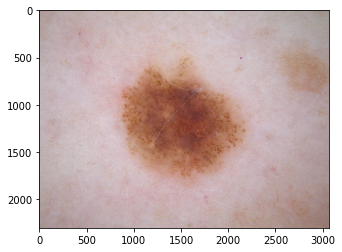

In [119]:
response = Response()
img = request.getImage('input_image')[:,:,::-1] #.astype(np.float32)/255
limg = open_image(
        '/home/sean/hpc-home/skin_cancer/ISIC/ISIC-2017_Training_Data/ISIC_0000385.jpg')
plt.imshow(img)
img.shape, limg.shape, np.array_equal(img, limg.astype(np.uint8))

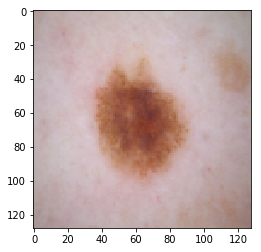

In [131]:
pred, im_n = run_model(d_net, request.getImage('input_image')[:,:,::-1].astype(np.float32)/255, prepIm=vtfm)
imd = denorm(np.rollaxis(im_n, 1, 4)).squeeze()
pred_thr = (pred > 0).astype(np.uint8) * 255
plt.imshow((imd*255).astype(np.uint8))

In [122]:
# img[0:50, 0:50, 1], limg[0:50, 0:50, 1]